In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df[['전류(A)', '누적_용량(Ah)', '절대값_용량(Ah)']].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC_20000.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(20000, 3)
float64
(20000, 1)
float64


In [4]:
# csv_path = "180801_RFB_510cy_006_DC_20000.csv"
# df = pd.read_csv(csv_path)


# features_considered = ['전류(A)', '누적_용량(Ah)', '전압(V)']
# features = df[features_considered]

In [5]:
# print(features.head())
dataset.x[:,:1].squeeze()

array([ 0.47961914,  0.47961914,  0.47955688, ..., -0.4796814 ,
       -0.47971252, -0.47971252])

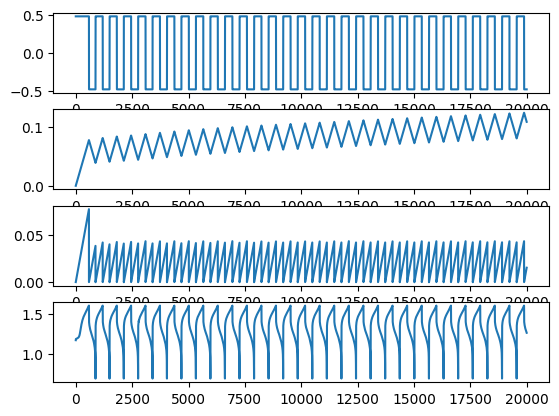

In [6]:
# features.plot(subplots=True)
# plt.show()

plt.subplot(4,1,1)
plt.plot(dataset.x[:,:1].squeeze())
plt.subplot(4,1,2)
plt.plot(dataset.x[:,1:2].squeeze())
plt.subplot(4,1,3)
plt.plot(dataset.x[:,2:3].squeeze())
plt.subplot(4,1,4)
plt.plot(dataset.y.squeeze())

In [7]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 16000
Validation Data Size : 2000
Testing Data Size : 2000


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=True)

In [9]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [10]:
num_epochs = 1000 
learning_rate = 0.01

input_size = 3
hidden_size = 32
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1])
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
def train_loop(model, dataloader, loss_func, optimizer):
    model.train()
    size = len(dataloader.dataset)
    print("Training")
    running_loss = 0.
    last_loss = 0.

    for batch, (x,y) in tqdm(enumerate(dataloader)):
        pred = model(x)
        loss = loss_func(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [12]:
def test_loop(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataloader, loss_func, optimizer)
    test_loop(model, test_dataloader, loss_func)
print("Done!")

Epoch 1
-------------------------------
Training


0it [00:00, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_26700\1130521825.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.FloatTensor([self.x[index]])
39it [00:00, 384.38it/s]

loss: 2.014553  [    4/16000]
loss: 0.011946  [  404/16000]


372it [00:00, 805.73it/s]

loss: 0.008886  [  804/16000]
loss: 0.005955  [ 1204/16000]


550it [00:00, 850.58it/s]

loss: 0.011811  [ 1604/16000]
loss: 0.002731  [ 2004/16000]


734it [00:00, 880.45it/s]

loss: 0.006281  [ 2404/16000]
loss: 0.003397  [ 2804/16000]


910it [00:01, 845.12it/s]

loss: 0.000869  [ 3204/16000]
loss: 0.000837  [ 3604/16000]


1167it [00:01, 837.97it/s]

loss: 0.010202  [ 4004/16000]
loss: 0.004884  [ 4404/16000]


1340it [00:01, 845.42it/s]

loss: 0.003960  [ 4804/16000]
loss: 0.001057  [ 5204/16000]


1512it [00:01, 837.18it/s]

loss: 0.000527  [ 5604/16000]
loss: 0.009912  [ 6004/16000]


1772it [00:02, 856.37it/s]

loss: 0.001245  [ 6404/16000]
loss: 0.000398  [ 6804/16000]


1946it [00:02, 860.46it/s]

loss: 0.003820  [ 7204/16000]
loss: 0.012211  [ 7604/16000]


2120it [00:02, 854.26it/s]

loss: 0.000433  [ 8004/16000]
loss: 0.000508  [ 8404/16000]


2295it [00:02, 864.20it/s]

loss: 0.002049  [ 8804/16000]
loss: 0.003927  [ 9204/16000]


2556it [00:03, 859.93it/s]

loss: 0.004230  [ 9604/16000]
loss: 0.000068  [10004/16000]


2732it [00:03, 865.37it/s]

loss: 0.005215  [10404/16000]
loss: 0.003681  [10804/16000]


2905it [00:03, 825.32it/s]

loss: 0.001216  [11204/16000]
loss: 0.001543  [11604/16000]


3151it [00:03, 795.56it/s]

loss: 0.000095  [12004/16000]
loss: 0.005431  [12404/16000]


3311it [00:04, 773.99it/s]

loss: 0.000590  [12804/16000]
loss: 0.000255  [13204/16000]


3549it [00:04, 784.44it/s]

loss: 0.001604  [13604/16000]
loss: 0.000249  [14004/16000]


3712it [00:04, 779.71it/s]

loss: 0.000047  [14404/16000]
loss: 0.001481  [14804/16000]


3868it [00:04, 746.86it/s]

loss: 0.015861  [15204/16000]
loss: 0.004628  [15604/16000]


4000it [00:04, 817.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003056 

Epoch 2
-------------------------------
Training


154it [00:00, 760.45it/s]

loss: 0.003487  [    4/16000]
loss: 0.003661  [  404/16000]


316it [00:00, 791.55it/s]

loss: 0.000437  [  804/16000]
loss: 0.001959  [ 1204/16000]


551it [00:00, 758.20it/s]

loss: 0.001533  [ 1604/16000]
loss: 0.000323  [ 2004/16000]


702it [00:00, 738.58it/s]

loss: 0.000792  [ 2404/16000]
loss: 0.000097  [ 2804/16000]


944it [00:01, 782.52it/s]

loss: 0.000090  [ 3204/16000]
loss: 0.002674  [ 3604/16000]


1106it [00:01, 792.57it/s]

loss: 0.001660  [ 4004/16000]
loss: 0.005414  [ 4404/16000]


1270it [00:01, 797.53it/s]

loss: 0.003426  [ 4804/16000]
loss: 0.000320  [ 5204/16000]


1509it [00:01, 762.25it/s]

loss: 0.000678  [ 5604/16000]
loss: 0.002524  [ 6004/16000]


1759it [00:02, 805.54it/s]

loss: 0.000597  [ 6404/16000]
loss: 0.000460  [ 6804/16000]


1925it [00:02, 737.69it/s]

loss: 0.002542  [ 7204/16000]
loss: 0.013339  [ 7604/16000]


2088it [00:02, 773.21it/s]

loss: 0.000368  [ 8004/16000]
loss: 0.000212  [ 8404/16000]


2339it [00:03, 811.62it/s]

loss: 0.000981  [ 8804/16000]
loss: 0.003259  [ 9204/16000]


2503it [00:03, 807.49it/s]

loss: 0.003653  [ 9604/16000]
loss: 0.000185  [10004/16000]


2670it [00:03, 818.89it/s]

loss: 0.007514  [10404/16000]
loss: 0.005679  [10804/16000]


2918it [00:03, 789.86it/s]

loss: 0.001301  [11204/16000]
loss: 0.000245  [11604/16000]


3083it [00:03, 787.19it/s]

loss: 0.000146  [12004/16000]
loss: 0.002306  [12404/16000]


3326it [00:04, 799.16it/s]

loss: 0.000340  [12804/16000]
loss: 0.000381  [13204/16000]


3490it [00:04, 806.66it/s]

loss: 0.000699  [13604/16000]
loss: 0.000261  [14004/16000]


3746it [00:04, 818.32it/s]

loss: 0.000235  [14404/16000]
loss: 0.001713  [14804/16000]


3912it [00:04, 824.87it/s]

loss: 0.010789  [15204/16000]
loss: 0.003592  [15604/16000]


4000it [00:05, 787.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001470 

Epoch 3
-------------------------------
Training


86it [00:00, 851.49it/s]

loss: 0.001174  [    4/16000]
loss: 0.008080  [  404/16000]


342it [00:00, 830.19it/s]

loss: 0.001464  [  804/16000]
loss: 0.000835  [ 1204/16000]


522it [00:00, 867.61it/s]

loss: 0.001288  [ 1604/16000]
loss: 0.001889  [ 2004/16000]


695it [00:00, 849.19it/s]

loss: 0.000173  [ 2404/16000]
loss: 0.000669  [ 2804/16000]


954it [00:01, 845.96it/s]

loss: 0.000356  [ 3204/16000]
loss: 0.002190  [ 3604/16000]


1126it [00:01, 847.16it/s]

loss: 0.000876  [ 4004/16000]
loss: 0.003805  [ 4404/16000]


1295it [00:01, 836.31it/s]

loss: 0.000233  [ 4804/16000]
loss: 0.000285  [ 5204/16000]


1549it [00:01, 838.52it/s]

loss: 0.000222  [ 5604/16000]
loss: 0.000698  [ 6004/16000]


1717it [00:02, 799.42it/s]

loss: 0.001142  [ 6404/16000]
loss: 0.000712  [ 6804/16000]


1964it [00:02, 806.52it/s]

loss: 0.000657  [ 7204/16000]
loss: 0.012695  [ 7604/16000]


2128it [00:02, 812.41it/s]

loss: 0.000849  [ 8004/16000]
loss: 0.001249  [ 8404/16000]


2291it [00:02, 802.80it/s]

loss: 0.000410  [ 8804/16000]
loss: 0.000477  [ 9204/16000]


2550it [00:03, 842.39it/s]

loss: 0.002972  [ 9604/16000]
loss: 0.000175  [10004/16000]


2721it [00:03, 847.74it/s]

loss: 0.007004  [10404/16000]
loss: 0.005024  [10804/16000]


2890it [00:03, 825.27it/s]

loss: 0.000576  [11204/16000]
loss: 0.000446  [11604/16000]


3146it [00:03, 836.11it/s]

loss: 0.001114  [12004/16000]
loss: 0.001255  [12404/16000]


3318it [00:03, 847.98it/s]

loss: 0.000223  [12804/16000]
loss: 0.000126  [13204/16000]


3488it [00:04, 753.20it/s]

loss: 0.000648  [13604/16000]
loss: 0.000301  [14004/16000]


3737it [00:04, 798.88it/s]

loss: 0.000705  [14404/16000]
loss: 0.001350  [14804/16000]


3903it [00:04, 807.24it/s]

loss: 0.009776  [15204/16000]
loss: 0.002028  [15604/16000]


4000it [00:04, 824.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001330 

Epoch 4
-------------------------------
Training


84it [00:00, 831.32it/s]

loss: 0.000590  [    4/16000]
loss: 0.006814  [  404/16000]


341it [00:00, 842.10it/s]

loss: 0.001280  [  804/16000]
loss: 0.000319  [ 1204/16000]


510it [00:00, 833.69it/s]

loss: 0.001010  [ 1604/16000]
loss: 0.001800  [ 2004/16000]


762it [00:00, 832.95it/s]

loss: 0.000196  [ 2404/16000]
loss: 0.000384  [ 2804/16000]


930it [00:01, 829.93it/s]

loss: 0.000031  [ 3204/16000]
loss: 0.003072  [ 3604/16000]


1103it [00:01, 847.64it/s]

loss: 0.000902  [ 4004/16000]
loss: 0.001379  [ 4404/16000]


1362it [00:01, 840.08it/s]

loss: 0.000648  [ 4804/16000]
loss: 0.000191  [ 5204/16000]


1533it [00:01, 833.45it/s]

loss: 0.001067  [ 5604/16000]
loss: 0.001022  [ 6004/16000]


1705it [00:02, 845.50it/s]

loss: 0.000857  [ 6404/16000]
loss: 0.000650  [ 6804/16000]


1964it [00:02, 848.24it/s]

loss: 0.000690  [ 7204/16000]
loss: 0.010750  [ 7604/16000]


2135it [00:02, 842.79it/s]

loss: 0.000471  [ 8004/16000]
loss: 0.000443  [ 8404/16000]


2304it [00:02, 833.06it/s]

loss: 0.000645  [ 8804/16000]
loss: 0.000168  [ 9204/16000]


2557it [00:03, 832.22it/s]

loss: 0.001527  [ 9604/16000]
loss: 0.000344  [10004/16000]


2729it [00:03, 845.77it/s]

loss: 0.005681  [10404/16000]
loss: 0.002742  [10804/16000]


2901it [00:03, 846.61it/s]

loss: 0.000904  [11204/16000]
loss: 0.000301  [11604/16000]


3071it [00:03, 840.78it/s]

loss: 0.002274  [12004/16000]
loss: 0.000463  [12404/16000]


3323it [00:03, 828.18it/s]

loss: 0.000216  [12804/16000]
loss: 0.000202  [13204/16000]


3489it [00:04, 822.01it/s]

loss: 0.000345  [13604/16000]
loss: 0.000256  [14004/16000]


3738it [00:04, 822.10it/s]

loss: 0.000437  [14404/16000]
loss: 0.000877  [14804/16000]


3903it [00:04, 803.50it/s]

loss: 0.009068  [15204/16000]
loss: 0.001356  [15604/16000]


4000it [00:04, 831.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001444 

Epoch 5
-------------------------------
Training


84it [00:00, 835.56it/s]

loss: 0.000611  [    4/16000]
loss: 0.003908  [  404/16000]


338it [00:00, 835.55it/s]

loss: 0.001001  [  804/16000]
loss: 0.000316  [ 1204/16000]


507it [00:00, 775.34it/s]

loss: 0.000933  [ 1604/16000]
loss: 0.001666  [ 2004/16000]


755it [00:00, 807.62it/s]

loss: 0.000374  [ 2404/16000]
loss: 0.000351  [ 2804/16000]


925it [00:01, 826.34it/s]

loss: 0.000285  [ 3204/16000]
loss: 0.003491  [ 3604/16000]


1096it [00:01, 840.30it/s]

loss: 0.000893  [ 4004/16000]
loss: 0.000908  [ 4404/16000]


1354it [00:01, 841.25it/s]

loss: 0.000603  [ 4804/16000]
loss: 0.000167  [ 5204/16000]


1525it [00:01, 843.71it/s]

loss: 0.000797  [ 5604/16000]
loss: 0.001112  [ 6004/16000]


1695it [00:02, 833.65it/s]

loss: 0.001100  [ 6404/16000]
loss: 0.000799  [ 6804/16000]


1945it [00:02, 825.17it/s]

loss: 0.000578  [ 7204/16000]
loss: 0.010435  [ 7604/16000]


2117it [00:02, 838.15it/s]

loss: 0.000420  [ 8004/16000]
loss: 0.001084  [ 8404/16000]


2285it [00:02, 834.45it/s]

loss: 0.000769  [ 8804/16000]
loss: 0.000576  [ 9204/16000]


2540it [00:03, 840.41it/s]

loss: 0.001603  [ 9604/16000]
loss: 0.000283  [10004/16000]


2711it [00:03, 843.86it/s]

loss: 0.003983  [10404/16000]
loss: 0.003610  [10804/16000]


2968it [00:03, 844.96it/s]

loss: 0.000553  [11204/16000]
loss: 0.000221  [11604/16000]


3137it [00:03, 832.65it/s]

loss: 0.002512  [12004/16000]
loss: 0.000249  [12404/16000]


3304it [00:03, 823.30it/s]

loss: 0.000216  [12804/16000]
loss: 0.000074  [13204/16000]


3471it [00:04, 822.17it/s]

loss: 0.000208  [13604/16000]
loss: 0.000326  [14004/16000]


3723it [00:04, 823.34it/s]

loss: 0.000430  [14404/16000]
loss: 0.000725  [14804/16000]


3890it [00:04, 825.83it/s]

loss: 0.008694  [15204/16000]
loss: 0.001137  [15604/16000]


4000it [00:04, 826.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001232 

Epoch 6
-------------------------------
Training


89it [00:00, 889.96it/s]

loss: 0.000558  [    4/16000]
loss: 0.003586  [  404/16000]


351it [00:00, 848.06it/s]

loss: 0.000970  [  804/16000]
loss: 0.000301  [ 1204/16000]


521it [00:00, 840.10it/s]

loss: 0.000900  [ 1604/16000]
loss: 0.001395  [ 2004/16000]


689it [00:00, 823.26it/s]

loss: 0.000342  [ 2404/16000]
loss: 0.000378  [ 2804/16000]


941it [00:01, 822.35it/s]

loss: 0.000289  [ 3204/16000]
loss: 0.004979  [ 3604/16000]


1108it [00:01, 819.84it/s]

loss: 0.000806  [ 4004/16000]
loss: 0.000657  [ 4404/16000]


1274it [00:01, 723.40it/s]

loss: 0.000433  [ 4804/16000]
loss: 0.000160  [ 5204/16000]


1527it [00:01, 800.89it/s]

loss: 0.000570  [ 5604/16000]
loss: 0.001001  [ 6004/16000]


1699it [00:02, 828.17it/s]

loss: 0.000974  [ 6404/16000]
loss: 0.000968  [ 6804/16000]


1957it [00:02, 840.98it/s]

loss: 0.000301  [ 7204/16000]
loss: 0.010143  [ 7604/16000]


2126it [00:02, 799.60it/s]

loss: 0.000369  [ 8004/16000]
loss: 0.000765  [ 8404/16000]


2291it [00:02, 805.03it/s]

loss: 0.001189  [ 8804/16000]
loss: 0.000630  [ 9204/16000]


2538it [00:03, 813.07it/s]

loss: 0.001224  [ 9604/16000]
loss: 0.000379  [10004/16000]


2701it [00:03, 803.73it/s]

loss: 0.001630  [10404/16000]
loss: 0.002988  [10804/16000]


2948it [00:03, 812.34it/s]

loss: 0.000868  [11204/16000]
loss: 0.000180  [11604/16000]


3115it [00:03, 820.12it/s]

loss: 0.002113  [12004/16000]
loss: 0.001185  [12404/16000]


3366it [00:04, 813.82it/s]

loss: 0.000172  [12804/16000]
loss: 0.000022  [13204/16000]


3532it [00:04, 818.77it/s]

loss: 0.000145  [13604/16000]
loss: 0.000384  [14004/16000]


3696it [00:04, 813.50it/s]

loss: 0.000445  [14404/16000]
loss: 0.000655  [14804/16000]


3950it [00:04, 822.50it/s]

loss: 0.008329  [15204/16000]
loss: 0.001207  [15604/16000]


4000it [00:04, 815.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001153 

Epoch 7
-------------------------------
Training


68it [00:00, 667.77it/s]

loss: 0.000480  [    4/16000]
loss: 0.002914  [  404/16000]


316it [00:00, 812.34it/s]

loss: 0.000895  [  804/16000]
loss: 0.000304  [ 1204/16000]


562it [00:00, 809.66it/s]

loss: 0.000854  [ 1604/16000]
loss: 0.001087  [ 2004/16000]


724it [00:00, 797.33it/s]

loss: 0.000239  [ 2404/16000]
loss: 0.000337  [ 2804/16000]


889it [00:01, 812.09it/s]

loss: 0.000174  [ 3204/16000]
loss: 0.004563  [ 3604/16000]


1137it [00:01, 801.64it/s]

loss: 0.000163  [ 4004/16000]
loss: 0.000557  [ 4404/16000]


1299it [00:01, 792.20it/s]

loss: 0.000454  [ 4804/16000]
loss: 0.000117  [ 5204/16000]


1543it [00:01, 798.95it/s]

loss: 0.000403  [ 5604/16000]
loss: 0.001126  [ 6004/16000]


1706it [00:02, 748.82it/s]

loss: 0.000927  [ 6404/16000]
loss: 0.000841  [ 6804/16000]


1948it [00:02, 773.69it/s]

loss: 0.000237  [ 7204/16000]
loss: 0.009662  [ 7604/16000]


2110it [00:02, 790.51it/s]

loss: 0.000441  [ 8004/16000]
loss: 0.000652  [ 8404/16000]


2356it [00:02, 804.66it/s]

loss: 0.000997  [ 8804/16000]
loss: 0.000690  [ 9204/16000]


2522it [00:03, 794.43it/s]

loss: 0.000869  [ 9604/16000]
loss: 0.000385  [10004/16000]


2679it [00:03, 736.77it/s]

loss: 0.001748  [10404/16000]
loss: 0.002597  [10804/16000]


2926it [00:03, 791.16it/s]

loss: 0.000688  [11204/16000]
loss: 0.000089  [11604/16000]


3087it [00:03, 784.89it/s]

loss: 0.001822  [12004/16000]
loss: 0.001547  [12404/16000]


3319it [00:04, 737.53it/s]

loss: 0.000193  [12804/16000]
loss: 0.000026  [13204/16000]


3556it [00:04, 771.31it/s]

loss: 0.000153  [13604/16000]
loss: 0.000425  [14004/16000]


3718it [00:04, 788.12it/s]

loss: 0.000410  [14404/16000]
loss: 0.000731  [14804/16000]


3885it [00:04, 810.74it/s]

loss: 0.007507  [15204/16000]
loss: 0.001466  [15604/16000]


4000it [00:05, 785.92it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001025 

Epoch 8
-------------------------------
Training


80it [00:00, 795.39it/s]

loss: 0.000439  [    4/16000]
loss: 0.002471  [  404/16000]


326it [00:00, 779.54it/s]

loss: 0.000936  [  804/16000]
loss: 0.000313  [ 1204/16000]


491it [00:00, 800.63it/s]

loss: 0.000766  [ 1604/16000]
loss: 0.000821  [ 2004/16000]


741it [00:00, 819.85it/s]

loss: 0.000218  [ 2404/16000]
loss: 0.000788  [ 2804/16000]


907it [00:01, 822.30it/s]

loss: 0.000095  [ 3204/16000]
loss: 0.003507  [ 3604/16000]


1157it [00:01, 824.28it/s]

loss: 0.000510  [ 4004/16000]
loss: 0.000627  [ 4404/16000]


1326it [00:01, 829.11it/s]

loss: 0.000176  [ 4804/16000]
loss: 0.000101  [ 5204/16000]


1492it [00:01, 792.30it/s]

loss: 0.000290  [ 5604/16000]
loss: 0.001113  [ 6004/16000]


1732it [00:02, 746.29it/s]

loss: 0.000576  [ 6404/16000]
loss: 0.000664  [ 6804/16000]


1891it [00:02, 769.18it/s]

loss: 0.000228  [ 7204/16000]
loss: 0.008978  [ 7604/16000]


2125it [00:02, 772.46it/s]

loss: 0.000268  [ 8004/16000]
loss: 0.000377  [ 8404/16000]


2286it [00:02, 775.98it/s]

loss: 0.000727  [ 8804/16000]
loss: 0.000645  [ 9204/16000]


2526it [00:03, 785.91it/s]

loss: 0.000846  [ 9604/16000]
loss: 0.000260  [10004/16000]


2685it [00:03, 781.20it/s]

loss: 0.001974  [10404/16000]
loss: 0.001743  [10804/16000]


2926it [00:03, 791.90it/s]

loss: 0.000700  [11204/16000]
loss: 0.000385  [11604/16000]


3087it [00:03, 795.93it/s]

loss: 0.001815  [12004/16000]
loss: 0.001034  [12404/16000]


3336it [00:04, 814.38it/s]

loss: 0.000292  [12804/16000]
loss: 0.000034  [13204/16000]


3499it [00:04, 794.41it/s]

loss: 0.000072  [13604/16000]
loss: 0.000402  [14004/16000]


3744it [00:04, 805.55it/s]

loss: 0.000367  [14404/16000]
loss: 0.000830  [14804/16000]


3911it [00:04, 815.92it/s]

loss: 0.006934  [15204/16000]
loss: 0.001593  [15604/16000]


4000it [00:05, 793.84it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000922 

Epoch 9
-------------------------------
Training


165it [00:00, 823.00it/s]

loss: 0.000398  [    4/16000]
loss: 0.003495  [  404/16000]


335it [00:00, 838.72it/s]

loss: 0.001091  [  804/16000]
loss: 0.000257  [ 1204/16000]


513it [00:00, 777.40it/s]

loss: 0.000559  [ 1604/16000]
loss: 0.000717  [ 2004/16000]


766it [00:00, 816.81it/s]

loss: 0.000199  [ 2404/16000]
loss: 0.000448  [ 2804/16000]


931it [00:01, 804.25it/s]

loss: 0.000082  [ 3204/16000]
loss: 0.003062  [ 3604/16000]


1099it [00:01, 820.19it/s]

loss: 0.000964  [ 4004/16000]
loss: 0.000551  [ 4404/16000]


1269it [00:01, 831.49it/s]

loss: 0.000286  [ 4804/16000]
loss: 0.000190  [ 5204/16000]


1520it [00:01, 829.92it/s]

loss: 0.000155  [ 5604/16000]
loss: 0.000859  [ 6004/16000]


1688it [00:02, 831.87it/s]

loss: 0.000848  [ 6404/16000]
loss: 0.000614  [ 6804/16000]


1948it [00:02, 851.95it/s]

loss: 0.000130  [ 7204/16000]
loss: 0.008047  [ 7604/16000]


2120it [00:02, 850.12it/s]

loss: 0.000155  [ 8004/16000]
loss: 0.000102  [ 8404/16000]


2291it [00:02, 829.40it/s]

loss: 0.000405  [ 8804/16000]
loss: 0.000409  [ 9204/16000]


2545it [00:03, 832.65it/s]

loss: 0.000434  [ 9604/16000]
loss: 0.000217  [10004/16000]


2712it [00:03, 826.54it/s]

loss: 0.001291  [10404/16000]
loss: 0.002394  [10804/16000]


2961it [00:03, 819.23it/s]

loss: 0.000318  [11204/16000]
loss: 0.000308  [11604/16000]


3132it [00:03, 824.90it/s]

loss: 0.001679  [12004/16000]
loss: 0.001469  [12404/16000]


3300it [00:03, 830.44it/s]

loss: 0.000208  [12804/16000]
loss: 0.000011  [13204/16000]


3554it [00:04, 831.98it/s]

loss: 0.000044  [13604/16000]
loss: 0.000342  [14004/16000]


3723it [00:04, 828.25it/s]

loss: 0.000627  [14404/16000]
loss: 0.000854  [14804/16000]


3894it [00:04, 838.81it/s]

loss: 0.007091  [15204/16000]
loss: 0.001044  [15604/16000]


4000it [00:04, 827.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000927 

Epoch 10
-------------------------------
Training


88it [00:00, 868.30it/s]

loss: 0.000345  [    4/16000]
loss: 0.001980  [  404/16000]


340it [00:00, 797.96it/s]

loss: 0.000892  [  804/16000]
loss: 0.000255  [ 1204/16000]


509it [00:00, 820.43it/s]

loss: 0.000433  [ 1604/16000]
loss: 0.000567  [ 2004/16000]


677it [00:00, 823.53it/s]

loss: 0.000233  [ 2404/16000]
loss: 0.000272  [ 2804/16000]


931it [00:01, 835.37it/s]

loss: 0.000102  [ 3204/16000]
loss: 0.002125  [ 3604/16000]


1099it [00:01, 827.76it/s]

loss: 0.000836  [ 4004/16000]
loss: 0.000372  [ 4404/16000]


1356it [00:01, 842.79it/s]

loss: 0.000296  [ 4804/16000]
loss: 0.000193  [ 5204/16000]


1526it [00:01, 828.96it/s]

loss: 0.000236  [ 5604/16000]
loss: 0.000463  [ 6004/16000]


1698it [00:02, 843.23it/s]

loss: 0.000857  [ 6404/16000]
loss: 0.000606  [ 6804/16000]


1957it [00:02, 837.32it/s]

loss: 0.000204  [ 7204/16000]
loss: 0.007806  [ 7604/16000]


2129it [00:02, 841.90it/s]

loss: 0.000023  [ 8004/16000]
loss: 0.000068  [ 8404/16000]


2298it [00:02, 837.07it/s]

loss: 0.000375  [ 8804/16000]
loss: 0.000412  [ 9204/16000]


2560it [00:03, 853.55it/s]

loss: 0.000564  [ 9604/16000]
loss: 0.000146  [10004/16000]


2732it [00:03, 845.10it/s]

loss: 0.001781  [10404/16000]
loss: 0.001791  [10804/16000]


2902it [00:03, 841.96it/s]

loss: 0.000205  [11204/16000]
loss: 0.000292  [11604/16000]


3161it [00:03, 847.44it/s]

loss: 0.001255  [12004/16000]
loss: 0.001514  [12404/16000]


3330it [00:03, 836.56it/s]

loss: 0.000181  [12804/16000]
loss: 0.000016  [13204/16000]


3497it [00:04, 815.95it/s]

loss: 0.000039  [13604/16000]
loss: 0.000291  [14004/16000]


3663it [00:04, 817.70it/s]

loss: 0.000410  [14404/16000]
loss: 0.000808  [14804/16000]


3913it [00:04, 785.86it/s]

loss: 0.006728  [15204/16000]
loss: 0.000934  [15604/16000]


4000it [00:04, 825.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000860 

Epoch 11
-------------------------------
Training


81it [00:00, 809.44it/s]

loss: 0.000344  [    4/16000]
loss: 0.001859  [  404/16000]


327it [00:00, 802.69it/s]

loss: 0.000980  [  804/16000]
loss: 0.000253  [ 1204/16000]


485it [00:00, 738.00it/s]

loss: 0.000256  [ 1604/16000]
loss: 0.000564  [ 2004/16000]


714it [00:00, 747.04it/s]

loss: 0.000256  [ 2404/16000]
loss: 0.000255  [ 2804/16000]


866it [00:01, 740.29it/s]

loss: 0.000079  [ 3204/16000]
loss: 0.000865  [ 3604/16000]


1102it [00:01, 764.09it/s]

loss: 0.001092  [ 4004/16000]
loss: 0.000253  [ 4404/16000]


1343it [00:01, 792.39it/s]

loss: 0.000289  [ 4804/16000]
loss: 0.000115  [ 5204/16000]


1507it [00:01, 802.20it/s]

loss: 0.000128  [ 5604/16000]
loss: 0.000771  [ 6004/16000]


1674it [00:02, 815.96it/s]

loss: 0.000714  [ 6404/16000]
loss: 0.000190  [ 6804/16000]


1908it [00:02, 727.11it/s]

loss: 0.000205  [ 7204/16000]
loss: 0.007611  [ 7604/16000]


2148it [00:02, 771.29it/s]

loss: 0.000031  [ 8004/16000]
loss: 0.000046  [ 8404/16000]


2309it [00:03, 770.96it/s]

loss: 0.000371  [ 8804/16000]
loss: 0.000383  [ 9204/16000]


2474it [00:03, 769.84it/s]

loss: 0.000300  [ 9604/16000]
loss: 0.000098  [10004/16000]


2705it [00:03, 746.88it/s]

loss: 0.002116  [10404/16000]
loss: 0.002366  [10804/16000]


2869it [00:03, 776.51it/s]

loss: 0.000170  [11204/16000]
loss: 0.000083  [11604/16000]


3108it [00:04, 783.71it/s]

loss: 0.001122  [12004/16000]
loss: 0.001507  [12404/16000]


3267it [00:04, 694.27it/s]

loss: 0.000165  [12804/16000]
loss: 0.000013  [13204/16000]


3483it [00:04, 678.69it/s]

loss: 0.000026  [13604/16000]
loss: 0.000232  [14004/16000]


3724it [00:04, 765.12it/s]

loss: 0.000142  [14404/16000]
loss: 0.000839  [14804/16000]


3895it [00:05, 806.40it/s]

loss: 0.006594  [15204/16000]
loss: 0.001126  [15604/16000]


4000it [00:05, 762.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000738 

Epoch 12
-------------------------------
Training


85it [00:00, 848.92it/s]

loss: 0.000322  [    4/16000]
loss: 0.004079  [  404/16000]


341it [00:00, 838.79it/s]

loss: 0.001038  [  804/16000]
loss: 0.000271  [ 1204/16000]


507it [00:00, 787.48it/s]

loss: 0.000227  [ 1604/16000]
loss: 0.000465  [ 2004/16000]


672it [00:00, 797.72it/s]

loss: 0.000273  [ 2404/16000]
loss: 0.000250  [ 2804/16000]


912it [00:01, 791.53it/s]

loss: 0.000068  [ 3204/16000]
loss: 0.000603  [ 3604/16000]


1078it [00:01, 807.39it/s]

loss: 0.000980  [ 4004/16000]
loss: 0.000154  [ 4404/16000]


1328it [00:01, 820.34it/s]

loss: 0.000321  [ 4804/16000]
loss: 0.000130  [ 5204/16000]


1494it [00:01, 821.81it/s]

loss: 0.000203  [ 5604/16000]
loss: 0.000694  [ 6004/16000]


1750it [00:02, 825.62it/s]

loss: 0.000945  [ 6404/16000]
loss: 0.000324  [ 6804/16000]


1919it [00:02, 825.20it/s]

loss: 0.000241  [ 7204/16000]
loss: 0.006763  [ 7604/16000]


2088it [00:02, 828.48it/s]

loss: 0.000037  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2341it [00:02, 817.02it/s]

loss: 0.000442  [ 8804/16000]
loss: 0.000445  [ 9204/16000]


2507it [00:03, 821.38it/s]

loss: 0.000768  [ 9604/16000]
loss: 0.000124  [10004/16000]


2760it [00:03, 830.29it/s]

loss: 0.000992  [10404/16000]
loss: 0.001076  [10804/16000]


2927it [00:03, 828.07it/s]

loss: 0.000412  [11204/16000]
loss: 0.000050  [11604/16000]


3100it [00:03, 839.02it/s]

loss: 0.000891  [12004/16000]
loss: 0.001255  [12404/16000]


3266it [00:04, 739.95it/s]

loss: 0.000222  [12804/16000]
loss: 0.000044  [13204/16000]


3517it [00:04, 799.23it/s]

loss: 0.000042  [13604/16000]
loss: 0.000184  [14004/16000]


3684it [00:04, 818.68it/s]

loss: 0.000099  [14404/16000]
loss: 0.000784  [14804/16000]


3938it [00:04, 837.33it/s]

loss: 0.006455  [15204/16000]
loss: 0.001343  [15604/16000]


4000it [00:04, 816.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000731 

Epoch 13
-------------------------------
Training


82it [00:00, 817.52it/s]

loss: 0.000351  [    4/16000]
loss: 0.003999  [  404/16000]


320it [00:00, 755.70it/s]

loss: 0.000821  [  804/16000]
loss: 0.000248  [ 1204/16000]


556it [00:00, 775.84it/s]

loss: 0.000139  [ 1604/16000]
loss: 0.000313  [ 2004/16000]


721it [00:00, 796.03it/s]

loss: 0.000305  [ 2404/16000]
loss: 0.000229  [ 2804/16000]


891it [00:01, 826.46it/s]

loss: 0.000107  [ 3204/16000]
loss: 0.000481  [ 3604/16000]


1138it [00:01, 814.71it/s]

loss: 0.001258  [ 4004/16000]
loss: 0.000102  [ 4404/16000]


1306it [00:01, 824.24it/s]

loss: 0.000337  [ 4804/16000]
loss: 0.000120  [ 5204/16000]


1472it [00:01, 815.71it/s]

loss: 0.000099  [ 5604/16000]
loss: 0.000639  [ 6004/16000]


1726it [00:02, 832.64it/s]

loss: 0.000601  [ 6404/16000]
loss: 0.000116  [ 6804/16000]


1893it [00:02, 814.31it/s]

loss: 0.000160  [ 7204/16000]
loss: 0.007283  [ 7604/16000]


2140it [00:02, 815.46it/s]

loss: 0.000089  [ 8004/16000]
loss: 0.000033  [ 8404/16000]


2311it [00:02, 832.02it/s]

loss: 0.000326  [ 8804/16000]
loss: 0.000284  [ 9204/16000]


2568it [00:03, 843.97it/s]

loss: 0.000340  [ 9604/16000]
loss: 0.000193  [10004/16000]


2655it [00:03, 851.66it/s]

loss: 0.000136  [10404/16000]
loss: 0.001821  [10804/16000]


2902it [00:03, 758.14it/s]

loss: 0.000438  [11204/16000]
loss: 0.000037  [11604/16000]


3147it [00:03, 793.68it/s]

loss: 0.000637  [12004/16000]
loss: 0.001234  [12404/16000]


3314it [00:04, 814.25it/s]

loss: 0.000100  [12804/16000]
loss: 0.000013  [13204/16000]


3560it [00:04, 798.06it/s]

loss: 0.000044  [13604/16000]
loss: 0.000130  [14004/16000]


3722it [00:04, 793.74it/s]

loss: 0.000050  [14404/16000]
loss: 0.000658  [14804/16000]


3883it [00:04, 797.02it/s]

loss: 0.006433  [15204/16000]
loss: 0.001436  [15604/16000]


4000it [00:04, 803.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000686 

Epoch 14
-------------------------------
Training


79it [00:00, 788.48it/s]

loss: 0.000358  [    4/16000]
loss: 0.005005  [  404/16000]


322it [00:00, 788.65it/s]

loss: 0.000834  [  804/16000]
loss: 0.000166  [ 1204/16000]


482it [00:00, 788.39it/s]

loss: 0.000094  [ 1604/16000]
loss: 0.000384  [ 2004/16000]


726it [00:00, 799.94it/s]

loss: 0.000538  [ 2404/16000]
loss: 0.000159  [ 2804/16000]


887it [00:01, 795.58it/s]

loss: 0.000158  [ 3204/16000]
loss: 0.000519  [ 3604/16000]


1126it [00:01, 778.83it/s]

loss: 0.001019  [ 4004/16000]
loss: 0.000109  [ 4404/16000]


1280it [00:01, 749.04it/s]

loss: 0.000156  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1508it [00:01, 742.88it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000496  [ 6004/16000]


1743it [00:02, 767.95it/s]

loss: 0.000488  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1897it [00:02, 714.09it/s]

loss: 0.000186  [ 7204/16000]
loss: 0.006956  [ 7604/16000]


2053it [00:02, 725.78it/s]

loss: 0.000153  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2283it [00:03, 703.41it/s]

loss: 0.000242  [ 8804/16000]
loss: 0.000267  [ 9204/16000]


2512it [00:03, 743.11it/s]

loss: 0.000302  [ 9604/16000]
loss: 0.000173  [10004/16000]


2747it [00:03, 765.15it/s]

loss: 0.000125  [10404/16000]
loss: 0.001149  [10804/16000]


2900it [00:03, 736.64it/s]

loss: 0.000193  [11204/16000]
loss: 0.000025  [11604/16000]


3127it [00:04, 743.44it/s]

loss: 0.000439  [12004/16000]
loss: 0.001007  [12404/16000]


3278it [00:04, 740.95it/s]

loss: 0.000067  [12804/16000]
loss: 0.000268  [13204/16000]


3508it [00:04, 754.75it/s]

loss: 0.000070  [13604/16000]
loss: 0.000111  [14004/16000]


3751it [00:04, 786.64it/s]

loss: 0.000019  [14404/16000]
loss: 0.000807  [14804/16000]


3919it [00:05, 811.62it/s]

loss: 0.006415  [15204/16000]
loss: 0.001657  [15604/16000]


4000it [00:05, 758.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000665 

Epoch 15
-------------------------------
Training


79it [00:00, 787.76it/s]

loss: 0.000385  [    4/16000]
loss: 0.004699  [  404/16000]


327it [00:00, 764.34it/s]

loss: 0.000738  [  804/16000]
loss: 0.000204  [ 1204/16000]


487it [00:00, 781.28it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000467  [ 2004/16000]


723it [00:00, 769.17it/s]

loss: 0.000153  [ 2404/16000]
loss: 0.000118  [ 2804/16000]


880it [00:01, 687.86it/s]

loss: 0.000224  [ 3204/16000]
loss: 0.000583  [ 3604/16000]


1122it [00:01, 759.35it/s]

loss: 0.001642  [ 4004/16000]
loss: 0.000261  [ 4404/16000]


1279it [00:01, 771.62it/s]

loss: 0.000191  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1516it [00:02, 768.74it/s]

loss: 0.000087  [ 5604/16000]
loss: 0.000367  [ 6004/16000]


1756it [00:02, 777.72it/s]

loss: 0.000348  [ 6404/16000]
loss: 0.000084  [ 6804/16000]


1917it [00:02, 783.12it/s]

loss: 0.000150  [ 7204/16000]
loss: 0.006255  [ 7604/16000]


2074it [00:02, 772.49it/s]

loss: 0.000259  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2300it [00:03, 729.13it/s]

loss: 0.000232  [ 8804/16000]
loss: 0.000280  [ 9204/16000]


2529it [00:03, 744.54it/s]

loss: 0.000276  [ 9604/16000]
loss: 0.000323  [10004/16000]


2686it [00:03, 764.63it/s]

loss: 0.000088  [10404/16000]
loss: 0.000943  [10804/16000]


2929it [00:03, 762.49it/s]

loss: 0.000159  [11204/16000]
loss: 0.000040  [11604/16000]


3080it [00:04, 732.20it/s]

loss: 0.000352  [12004/16000]
loss: 0.000982  [12404/16000]


3325it [00:04, 783.97it/s]

loss: 0.000224  [12804/16000]
loss: 0.000228  [13204/16000]


3493it [00:04, 807.63it/s]

loss: 0.000162  [13604/16000]
loss: 0.000139  [14004/16000]


3738it [00:04, 803.84it/s]

loss: 0.000028  [14404/16000]
loss: 0.000771  [14804/16000]


3905it [00:05, 807.07it/s]

loss: 0.006016  [15204/16000]
loss: 0.001760  [15604/16000]


4000it [00:05, 767.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000655 

Epoch 16
-------------------------------
Training


78it [00:00, 772.16it/s]

loss: 0.000413  [    4/16000]
loss: 0.003942  [  404/16000]


312it [00:00, 673.16it/s]

loss: 0.000801  [  804/16000]
loss: 0.000192  [ 1204/16000]


557it [00:00, 765.84it/s]

loss: 0.000321  [ 1604/16000]
loss: 0.000517  [ 2004/16000]


720it [00:00, 788.99it/s]

loss: 0.000157  [ 2404/16000]
loss: 0.000125  [ 2804/16000]


958it [00:01, 774.05it/s]

loss: 0.000130  [ 3204/16000]
loss: 0.000599  [ 3604/16000]


1113it [00:01, 735.80it/s]

loss: 0.000159  [ 4004/16000]
loss: 0.000287  [ 4404/16000]


1261it [00:01, 730.16it/s]

loss: 0.000362  [ 4804/16000]
loss: 0.000075  [ 5204/16000]


1489it [00:02, 674.58it/s]

loss: 0.000108  [ 5604/16000]
loss: 0.000261  [ 6004/16000]


1740it [00:02, 774.44it/s]

loss: 0.000510  [ 6404/16000]
loss: 0.000044  [ 6804/16000]


1907it [00:02, 803.65it/s]

loss: 0.000121  [ 7204/16000]
loss: 0.005854  [ 7604/16000]


2068it [00:02, 759.53it/s]

loss: 0.000136  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2304it [00:03, 736.81it/s]

loss: 0.000154  [ 8804/16000]
loss: 0.000280  [ 9204/16000]


2547it [00:03, 782.69it/s]

loss: 0.000292  [ 9604/16000]
loss: 0.000269  [10004/16000]


2714it [00:03, 803.29it/s]

loss: 0.000094  [10404/16000]
loss: 0.000902  [10804/16000]


2875it [00:03, 772.57it/s]

loss: 0.000366  [11204/16000]
loss: 0.000085  [11604/16000]


3118it [00:04, 791.23it/s]

loss: 0.000302  [12004/16000]
loss: 0.001222  [12404/16000]


3288it [00:04, 735.97it/s]

loss: 0.000112  [12804/16000]
loss: 0.000129  [13204/16000]


3529it [00:04, 778.97it/s]

loss: 0.000128  [13604/16000]
loss: 0.000187  [14004/16000]


3693it [00:04, 795.43it/s]

loss: 0.000032  [14404/16000]
loss: 0.000443  [14804/16000]


3943it [00:05, 813.60it/s]

loss: 0.005914  [15204/16000]
loss: 0.000926  [15604/16000]


4000it [00:05, 760.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000738 

Epoch 17
-------------------------------
Training


84it [00:00, 835.74it/s]

loss: 0.000452  [    4/16000]
loss: 0.004037  [  404/16000]


332it [00:00, 799.74it/s]

loss: 0.000749  [  804/16000]
loss: 0.000172  [ 1204/16000]


492it [00:00, 752.68it/s]

loss: 0.000310  [ 1604/16000]
loss: 0.000544  [ 2004/16000]


735it [00:00, 792.53it/s]

loss: 0.000238  [ 2404/16000]
loss: 0.000165  [ 2804/16000]


896it [00:01, 793.30it/s]

loss: 0.000087  [ 3204/16000]
loss: 0.000470  [ 3604/16000]


1141it [00:01, 800.89it/s]

loss: 0.000842  [ 4004/16000]
loss: 0.000171  [ 4404/16000]


1305it [00:01, 801.69it/s]

loss: 0.000205  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1549it [00:01, 797.47it/s]

loss: 0.000095  [ 5604/16000]
loss: 0.000263  [ 6004/16000]


1708it [00:02, 781.93it/s]

loss: 0.000544  [ 6404/16000]
loss: 0.000056  [ 6804/16000]


1871it [00:02, 721.57it/s]

loss: 0.000087  [ 7204/16000]
loss: 0.005492  [ 7604/16000]


2112it [00:02, 768.85it/s]

loss: 0.000120  [ 8004/16000]
loss: 0.000010  [ 8404/16000]


2356it [00:03, 789.63it/s]

loss: 0.000206  [ 8804/16000]
loss: 0.000241  [ 9204/16000]


2520it [00:03, 802.45it/s]

loss: 0.000352  [ 9604/16000]
loss: 0.000212  [10004/16000]


2685it [00:03, 796.30it/s]

loss: 0.000207  [10404/16000]
loss: 0.000936  [10804/16000]


2932it [00:03, 804.50it/s]

loss: 0.000326  [11204/16000]
loss: 0.000069  [11604/16000]


3094it [00:03, 791.25it/s]

loss: 0.000297  [12004/16000]
loss: 0.001058  [12404/16000]


3335it [00:04, 781.28it/s]

loss: 0.000110  [12804/16000]
loss: 0.000112  [13204/16000]


3497it [00:04, 789.17it/s]

loss: 0.000073  [13604/16000]
loss: 0.000164  [14004/16000]


3741it [00:04, 803.86it/s]

loss: 0.000059  [14404/16000]
loss: 0.000489  [14804/16000]


3901it [00:04, 780.72it/s]

loss: 0.005830  [15204/16000]
loss: 0.000937  [15604/16000]


4000it [00:05, 786.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000706 

Epoch 18
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000474  [    4/16000]
loss: 0.004019  [  404/16000]


300it [00:00, 748.62it/s]

loss: 0.000664  [  804/16000]
loss: 0.000143  [ 1204/16000]


526it [00:00, 741.85it/s]

loss: 0.000157  [ 1604/16000]
loss: 0.000457  [ 2004/16000]


681it [00:00, 759.07it/s]

loss: 0.000382  [ 2404/16000]
loss: 0.000137  [ 2804/16000]


912it [00:01, 756.52it/s]

loss: 0.000100  [ 3204/16000]
loss: 0.000711  [ 3604/16000]


1061it [00:01, 703.52it/s]

loss: 0.000874  [ 4004/16000]
loss: 0.000124  [ 4404/16000]


1294it [00:01, 749.71it/s]

loss: 0.000269  [ 4804/16000]
loss: 0.000079  [ 5204/16000]


1528it [00:02, 766.15it/s]

loss: 0.000105  [ 5604/16000]
loss: 0.000465  [ 6004/16000]


1683it [00:02, 765.13it/s]

loss: 0.000395  [ 6404/16000]
loss: 0.000063  [ 6804/16000]


1909it [00:02, 730.10it/s]

loss: 0.000135  [ 7204/16000]
loss: 0.005398  [ 7604/16000]


2132it [00:02, 726.04it/s]

loss: 0.000141  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2278it [00:03, 719.44it/s]

loss: 0.000140  [ 8804/16000]
loss: 0.000246  [ 9204/16000]


2501it [00:03, 735.08it/s]

loss: 0.000324  [ 9604/16000]
loss: 0.000208  [10004/16000]


2734it [00:03, 756.23it/s]

loss: 0.000134  [10404/16000]
loss: 0.000719  [10804/16000]


2890it [00:03, 752.57it/s]

loss: 0.000287  [11204/16000]
loss: 0.000056  [11604/16000]


3129it [00:04, 780.71it/s]

loss: 0.000318  [12004/16000]
loss: 0.001077  [12404/16000]


3291it [00:04, 794.87it/s]

loss: 0.000140  [12804/16000]
loss: 0.000143  [13204/16000]


3527it [00:04, 755.43it/s]

loss: 0.000331  [13604/16000]
loss: 0.000275  [14004/16000]


3678it [00:04, 666.99it/s]

loss: 0.000085  [14404/16000]
loss: 0.000688  [14804/16000]


3909it [00:05, 731.99it/s]

loss: 0.005791  [15204/16000]
loss: 0.001201  [15604/16000]


4000it [00:05, 742.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000621 

Epoch 19
-------------------------------
Training


83it [00:00, 825.24it/s]

loss: 0.000442  [    4/16000]
loss: 0.003684  [  404/16000]


330it [00:00, 808.47it/s]

loss: 0.000924  [  804/16000]
loss: 0.000167  [ 1204/16000]


491it [00:00, 780.81it/s]

loss: 0.000413  [ 1604/16000]
loss: 0.000434  [ 2004/16000]


727it [00:00, 767.53it/s]

loss: 0.000131  [ 2404/16000]
loss: 0.000157  [ 2804/16000]


889it [00:01, 788.13it/s]

loss: 0.000118  [ 3204/16000]
loss: 0.000722  [ 3604/16000]


1134it [00:01, 802.16it/s]

loss: 0.000809  [ 4004/16000]
loss: 0.000184  [ 4404/16000]


1297it [00:01, 802.87it/s]

loss: 0.000446  [ 4804/16000]
loss: 0.000065  [ 5204/16000]


1539it [00:01, 799.02it/s]

loss: 0.000082  [ 5604/16000]
loss: 0.000194  [ 6004/16000]


1705it [00:02, 812.34it/s]

loss: 0.000382  [ 6404/16000]
loss: 0.000794  [ 6804/16000]


1951it [00:02, 807.96it/s]

loss: 0.000093  [ 7204/16000]
loss: 0.005321  [ 7604/16000]


2115it [00:02, 804.32it/s]

loss: 0.000098  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2361it [00:02, 794.03it/s]

loss: 0.000166  [ 8804/16000]
loss: 0.000245  [ 9204/16000]


2520it [00:03, 776.56it/s]

loss: 0.000100  [ 9604/16000]
loss: 0.000178  [10004/16000]


2680it [00:03, 698.95it/s]

loss: 0.000128  [10404/16000]
loss: 0.000608  [10804/16000]


2924it [00:03, 769.48it/s]

loss: 0.000319  [11204/16000]
loss: 0.000079  [11604/16000]


3079it [00:03, 741.12it/s]

loss: 0.000322  [12004/16000]
loss: 0.000909  [12404/16000]


3303it [00:04, 720.86it/s]

loss: 0.000168  [12804/16000]
loss: 0.000129  [13204/16000]


3539it [00:04, 764.34it/s]

loss: 0.000460  [13604/16000]
loss: 0.000267  [14004/16000]


3693it [00:04, 760.91it/s]

loss: 0.000081  [14404/16000]
loss: 0.000496  [14804/16000]


3925it [00:05, 767.75it/s]

loss: 0.005829  [15204/16000]
loss: 0.001121  [15604/16000]


4000it [00:05, 776.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000620 

Epoch 20
-------------------------------
Training


78it [00:00, 780.00it/s]

loss: 0.000461  [    4/16000]
loss: 0.003480  [  404/16000]


315it [00:00, 776.84it/s]

loss: 0.000851  [  804/16000]
loss: 0.000164  [ 1204/16000]


471it [00:00, 760.73it/s]

loss: 0.000437  [ 1604/16000]
loss: 0.000412  [ 2004/16000]


700it [00:00, 727.30it/s]

loss: 0.000153  [ 2404/16000]
loss: 0.000112  [ 2804/16000]


932it [00:01, 757.95it/s]

loss: 0.000085  [ 3204/16000]
loss: 0.000208  [ 3604/16000]


1085it [00:01, 760.84it/s]

loss: 0.000897  [ 4004/16000]
loss: 0.000134  [ 4404/16000]


1318it [00:01, 760.35it/s]

loss: 0.000200  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1472it [00:01, 696.78it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000313  [ 6004/16000]


1707it [00:02, 748.96it/s]

loss: 0.000382  [ 6404/16000]
loss: 0.000102  [ 6804/16000]


1857it [00:02, 650.94it/s]

loss: 0.000113  [ 7204/16000]
loss: 0.005231  [ 7604/16000]


2084it [00:02, 723.20it/s]

loss: 0.000092  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2312it [00:03, 724.01it/s]

loss: 0.000248  [ 8804/16000]
loss: 0.000150  [ 9204/16000]


2534it [00:03, 726.63it/s]

loss: 0.000088  [ 9604/16000]
loss: 0.000205  [10004/16000]


2680it [00:03, 716.92it/s]

loss: 0.000121  [10404/16000]
loss: 0.000566  [10804/16000]


2911it [00:03, 743.28it/s]

loss: 0.000295  [11204/16000]
loss: 0.000127  [11604/16000]


3147it [00:04, 774.04it/s]

loss: 0.000312  [12004/16000]
loss: 0.000658  [12404/16000]


3303it [00:04, 761.61it/s]

loss: 0.000232  [12804/16000]
loss: 0.000086  [13204/16000]


3540it [00:04, 774.67it/s]

loss: 0.000462  [13604/16000]
loss: 0.000278  [14004/16000]


3700it [00:04, 778.94it/s]

loss: 0.000072  [14404/16000]
loss: 0.000604  [14804/16000]


3934it [00:05, 769.64it/s]

loss: 0.005756  [15204/16000]
loss: 0.001198  [15604/16000]


4000it [00:05, 744.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000608 

Epoch 21
-------------------------------
Training


79it [00:00, 779.26it/s]

loss: 0.000458  [    4/16000]
loss: 0.003306  [  404/16000]


318it [00:00, 793.24it/s]

loss: 0.000606  [  804/16000]
loss: 0.000162  [ 1204/16000]


557it [00:00, 779.08it/s]

loss: 0.000395  [ 1604/16000]
loss: 0.000425  [ 2004/16000]


717it [00:00, 788.38it/s]

loss: 0.000173  [ 2404/16000]
loss: 0.000166  [ 2804/16000]


875it [00:01, 778.22it/s]

loss: 0.000071  [ 3204/16000]
loss: 0.000877  [ 3604/16000]


1106it [00:01, 748.79it/s]

loss: 0.000949  [ 4004/16000]
loss: 0.000140  [ 4404/16000]


1331it [00:01, 729.06it/s]

loss: 0.000213  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1481it [00:01, 720.34it/s]

loss: 0.000081  [ 5604/16000]
loss: 0.000280  [ 6004/16000]


1702it [00:02, 722.21it/s]

loss: 0.000602  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1924it [00:02, 733.87it/s]

loss: 0.000090  [ 7204/16000]
loss: 0.005132  [ 7604/16000]


2149it [00:02, 740.65it/s]

loss: 0.000135  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2296it [00:03, 639.38it/s]

loss: 0.000202  [ 8804/16000]
loss: 0.000222  [ 9204/16000]


2516it [00:03, 699.86it/s]

loss: 0.000254  [ 9604/16000]
loss: 0.000107  [10004/16000]


2737it [00:03, 706.57it/s]

loss: 0.000277  [10404/16000]
loss: 0.000593  [10804/16000]


2889it [00:03, 730.90it/s]

loss: 0.000147  [11204/16000]
loss: 0.000090  [11604/16000]


3123it [00:04, 760.26it/s]

loss: 0.000277  [12004/16000]
loss: 0.000646  [12404/16000]


3282it [00:04, 775.71it/s]

loss: 0.000177  [12804/16000]
loss: 0.000103  [13204/16000]


3524it [00:04, 778.72it/s]

loss: 0.000429  [13604/16000]
loss: 0.000263  [14004/16000]


3683it [00:04, 785.78it/s]

loss: 0.000078  [14404/16000]
loss: 0.000589  [14804/16000]


3927it [00:05, 796.22it/s]

loss: 0.005747  [15204/16000]
loss: 0.001182  [15604/16000]


4000it [00:05, 748.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000605 

Epoch 22
-------------------------------
Training


81it [00:00, 809.88it/s]

loss: 0.000471  [    4/16000]
loss: 0.002997  [  404/16000]


315it [00:00, 751.98it/s]

loss: 0.000669  [  804/16000]
loss: 0.000137  [ 1204/16000]


552it [00:00, 776.76it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000493  [ 2004/16000]


709it [00:00, 721.39it/s]

loss: 0.000350  [ 2404/16000]
loss: 0.000173  [ 2804/16000]


944it [00:01, 756.18it/s]

loss: 0.000139  [ 3204/16000]
loss: 0.000607  [ 3604/16000]


1099it [00:01, 759.60it/s]

loss: 0.000966  [ 4004/16000]
loss: 0.000155  [ 4404/16000]


1333it [00:01, 767.34it/s]

loss: 0.000300  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1491it [00:01, 777.89it/s]

loss: 0.000086  [ 5604/16000]
loss: 0.000229  [ 6004/16000]


1729it [00:02, 780.54it/s]

loss: 0.000616  [ 6404/16000]
loss: 0.000094  [ 6804/16000]


1890it [00:02, 791.25it/s]

loss: 0.000137  [ 7204/16000]
loss: 0.004968  [ 7604/16000]


2132it [00:02, 797.06it/s]

loss: 0.000100  [ 8004/16000]
loss: 0.000020  [ 8404/16000]


2294it [00:02, 792.83it/s]

loss: 0.000173  [ 8804/16000]
loss: 0.000229  [ 9204/16000]


2534it [00:03, 770.28it/s]

loss: 0.000283  [ 9604/16000]
loss: 0.000206  [10004/16000]


2691it [00:03, 762.92it/s]

loss: 0.000167  [10404/16000]
loss: 0.000696  [10804/16000]


2928it [00:03, 780.07it/s]

loss: 0.000045  [11204/16000]
loss: 0.000135  [11604/16000]


3087it [00:04, 703.59it/s]

loss: 0.000249  [12004/16000]
loss: 0.000593  [12404/16000]


3323it [00:04, 750.45it/s]

loss: 0.000172  [12804/16000]
loss: 0.000084  [13204/16000]


3481it [00:04, 764.99it/s]

loss: 0.000406  [13604/16000]
loss: 0.000259  [14004/16000]


3722it [00:04, 790.07it/s]

loss: 0.000059  [14404/16000]
loss: 0.000580  [14804/16000]


3880it [00:05, 772.77it/s]

loss: 0.005732  [15204/16000]
loss: 0.001179  [15604/16000]


4000it [00:05, 766.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000602 

Epoch 23
-------------------------------
Training


160it [00:00, 794.48it/s]

loss: 0.000480  [    4/16000]
loss: 0.002905  [  404/16000]


322it [00:00, 786.27it/s]

loss: 0.000782  [  804/16000]
loss: 0.000149  [ 1204/16000]


479it [00:00, 763.03it/s]

loss: 0.000465  [ 1604/16000]
loss: 0.000393  [ 2004/16000]


714it [00:00, 771.88it/s]

loss: 0.000343  [ 2404/16000]
loss: 0.000160  [ 2804/16000]


875it [00:01, 786.09it/s]

loss: 0.000096  [ 3204/16000]
loss: 0.000388  [ 3604/16000]


1117it [00:01, 763.99it/s]

loss: 0.001241  [ 4004/16000]
loss: 0.000140  [ 4404/16000]


1270it [00:01, 739.42it/s]

loss: 0.000332  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1504it [00:01, 762.66it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000483  [ 6004/16000]


1737it [00:02, 730.14it/s]

loss: 0.000551  [ 6404/16000]
loss: 0.000100  [ 6804/16000]


1894it [00:02, 755.66it/s]

loss: 0.000049  [ 7204/16000]
loss: 0.004829  [ 7604/16000]


2129it [00:02, 771.02it/s]

loss: 0.000115  [ 8004/16000]
loss: 0.000034  [ 8404/16000]


2369it [00:03, 786.00it/s]

loss: 0.000244  [ 8804/16000]
loss: 0.000292  [ 9204/16000]


2530it [00:03, 784.14it/s]

loss: 0.000082  [ 9604/16000]
loss: 0.000255  [10004/16000]


2693it [00:03, 799.31it/s]

loss: 0.000105  [10404/16000]
loss: 0.000578  [10804/16000]


2934it [00:03, 797.71it/s]

loss: 0.000288  [11204/16000]
loss: 0.000117  [11604/16000]


3094it [00:04, 788.18it/s]

loss: 0.000347  [12004/16000]
loss: 0.000574  [12404/16000]


3330it [00:04, 773.52it/s]

loss: 0.000644  [12804/16000]
loss: 0.000063  [13204/16000]


3494it [00:04, 791.99it/s]

loss: 0.000338  [13604/16000]
loss: 0.000264  [14004/16000]


3734it [00:04, 795.69it/s]

loss: 0.000078  [14404/16000]
loss: 0.000639  [14804/16000]


3894it [00:05, 715.47it/s]

loss: 0.005717  [15204/16000]
loss: 0.001246  [15604/16000]


4000it [00:05, 768.14it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000615 

Epoch 24
-------------------------------
Training


83it [00:00, 824.36it/s]

loss: 0.000502  [    4/16000]
loss: 0.003681  [  404/16000]


328it [00:00, 802.03it/s]

loss: 0.000662  [  804/16000]
loss: 0.000160  [ 1204/16000]


489it [00:00, 787.85it/s]

loss: 0.000056  [ 1604/16000]
loss: 0.000542  [ 2004/16000]


729it [00:00, 790.29it/s]

loss: 0.000173  [ 2404/16000]
loss: 0.000173  [ 2804/16000]


889it [00:01, 789.31it/s]

loss: 0.000075  [ 3204/16000]
loss: 0.000482  [ 3604/16000]


1131it [00:01, 795.42it/s]

loss: 0.001461  [ 4004/16000]
loss: 0.000178  [ 4404/16000]


1294it [00:01, 802.94it/s]

loss: 0.000414  [ 4804/16000]
loss: 0.000070  [ 5204/16000]


1537it [00:01, 800.72it/s]

loss: 0.000023  [ 5604/16000]
loss: 0.000240  [ 6004/16000]


1701it [00:02, 804.72it/s]

loss: 0.000196  [ 6404/16000]
loss: 0.000094  [ 6804/16000]


1943it [00:02, 781.47it/s]

loss: 0.000104  [ 7204/16000]
loss: 0.004939  [ 7604/16000]


2105it [00:02, 790.82it/s]

loss: 0.000104  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2265it [00:02, 718.92it/s]

loss: 0.000151  [ 8804/16000]
loss: 0.000369  [ 9204/16000]


2512it [00:03, 782.93it/s]

loss: 0.000293  [ 9604/16000]
loss: 0.000163  [10004/16000]


2673it [00:03, 789.01it/s]

loss: 0.000669  [10404/16000]
loss: 0.000586  [10804/16000]


2915it [00:03, 798.31it/s]

loss: 0.000241  [11204/16000]
loss: 0.000140  [11604/16000]


3159it [00:03, 801.77it/s]

loss: 0.000266  [12004/16000]
loss: 0.000503  [12404/16000]


3323it [00:04, 802.34it/s]

loss: 0.000630  [12804/16000]
loss: 0.000117  [13204/16000]


3486it [00:04, 798.35it/s]

loss: 0.000237  [13604/16000]
loss: 0.000248  [14004/16000]


3726it [00:04, 787.35it/s]

loss: 0.000080  [14404/16000]
loss: 0.000572  [14804/16000]


3884it [00:04, 781.08it/s]

loss: 0.005703  [15204/16000]
loss: 0.001161  [15604/16000]


4000it [00:05, 790.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000597 

Epoch 25
-------------------------------
Training


75it [00:00, 749.81it/s]

loss: 0.000492  [    4/16000]
loss: 0.002730  [  404/16000]


316it [00:00, 791.98it/s]

loss: 0.000866  [  804/16000]
loss: 0.000135  [ 1204/16000]


559it [00:00, 796.55it/s]

loss: 0.000242  [ 1604/16000]
loss: 0.000321  [ 2004/16000]


639it [00:00, 791.83it/s]

loss: 0.000214  [ 2404/16000]
loss: 0.000146  [ 2804/16000]


875it [00:01, 745.68it/s]

loss: 0.000120  [ 3204/16000]
loss: 0.000366  [ 3604/16000]


1113it [00:01, 778.06it/s]

loss: 0.001461  [ 4004/16000]
loss: 0.000186  [ 4404/16000]


1351it [00:01, 779.84it/s]

loss: 0.000285  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1514it [00:01, 795.61it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000250  [ 6004/16000]


1756it [00:02, 795.62it/s]

loss: 0.000308  [ 6404/16000]
loss: 0.000111  [ 6804/16000]


1919it [00:02, 793.92it/s]

loss: 0.000138  [ 7204/16000]
loss: 0.004660  [ 7604/16000]


2161it [00:02, 796.40it/s]

loss: 0.000080  [ 8004/16000]
loss: 0.000010  [ 8404/16000]


2324it [00:02, 804.37it/s]

loss: 0.000243  [ 8804/16000]
loss: 0.000234  [ 9204/16000]


2486it [00:03, 799.68it/s]

loss: 0.000060  [ 9604/16000]
loss: 0.000202  [10004/16000]


2728it [00:03, 794.29it/s]

loss: 0.000086  [10404/16000]
loss: 0.000548  [10804/16000]


2891it [00:03, 802.47it/s]

loss: 0.000304  [11204/16000]
loss: 0.000111  [11604/16000]


3132it [00:03, 789.75it/s]

loss: 0.000306  [12004/16000]
loss: 0.000506  [12404/16000]


3289it [00:04, 732.92it/s]

loss: 0.000721  [12804/16000]
loss: 0.000033  [13204/16000]


3529it [00:04, 769.43it/s]

loss: 0.000301  [13604/16000]
loss: 0.000232  [14004/16000]


3684it [00:04, 763.18it/s]

loss: 0.000056  [14404/16000]
loss: 0.000572  [14804/16000]


3927it [00:05, 773.37it/s]

loss: 0.005705  [15204/16000]
loss: 0.001238  [15604/16000]


4000it [00:05, 778.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000624 

Epoch 26
-------------------------------
Training


81it [00:00, 804.13it/s]

loss: 0.000529  [    4/16000]
loss: 0.002574  [  404/16000]


329it [00:00, 815.95it/s]

loss: 0.000488  [  804/16000]
loss: 0.000153  [ 1204/16000]


491it [00:00, 792.13it/s]

loss: 0.000507  [ 1604/16000]
loss: 0.000408  [ 2004/16000]


729it [00:00, 781.29it/s]

loss: 0.000216  [ 2404/16000]
loss: 0.000195  [ 2804/16000]


888it [00:01, 778.47it/s]

loss: 0.000092  [ 3204/16000]
loss: 0.000333  [ 3604/16000]


1129it [00:01, 792.11it/s]

loss: 0.001441  [ 4004/16000]
loss: 0.000126  [ 4404/16000]


1291it [00:01, 799.88it/s]

loss: 0.000156  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1452it [00:01, 789.02it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000177  [ 6004/16000]


1690it [00:02, 749.06it/s]

loss: 0.000331  [ 6404/16000]
loss: 0.000115  [ 6804/16000]


1934it [00:02, 787.86it/s]

loss: 0.000104  [ 7204/16000]
loss: 0.004593  [ 7604/16000]


2096it [00:02, 785.85it/s]

loss: 0.000127  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2333it [00:02, 781.16it/s]

loss: 0.000191  [ 8804/16000]
loss: 0.000253  [ 9204/16000]


2491it [00:03, 777.16it/s]

loss: 0.000075  [ 9604/16000]
loss: 0.000074  [10004/16000]


2726it [00:03, 779.12it/s]

loss: 0.000099  [10404/16000]
loss: 0.000588  [10804/16000]


2886it [00:03, 778.90it/s]

loss: 0.000277  [11204/16000]
loss: 0.000026  [11604/16000]


3123it [00:04, 774.47it/s]

loss: 0.000336  [12004/16000]
loss: 0.000475  [12404/16000]


3279it [00:04, 772.91it/s]

loss: 0.000736  [12804/16000]
loss: 0.000054  [13204/16000]


3524it [00:04, 787.69it/s]

loss: 0.000284  [13604/16000]
loss: 0.000221  [14004/16000]


3682it [00:04, 775.05it/s]

loss: 0.000054  [14404/16000]
loss: 0.000576  [14804/16000]


3923it [00:05, 787.90it/s]

loss: 0.005681  [15204/16000]
loss: 0.001256  [15604/16000]


4000it [00:05, 775.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000654 

Epoch 27
-------------------------------
Training


79it [00:00, 785.99it/s]

loss: 0.000569  [    4/16000]
loss: 0.002531  [  404/16000]


326it [00:00, 792.47it/s]

loss: 0.000633  [  804/16000]
loss: 0.000156  [ 1204/16000]


487it [00:00, 793.49it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000530  [ 2004/16000]


728it [00:00, 795.10it/s]

loss: 0.000324  [ 2404/16000]
loss: 0.000147  [ 2804/16000]


890it [00:01, 793.88it/s]

loss: 0.000052  [ 3204/16000]
loss: 0.000356  [ 3604/16000]


1136it [00:01, 799.17it/s]

loss: 0.001641  [ 4004/16000]
loss: 0.000234  [ 4404/16000]


1296it [00:01, 796.26it/s]

loss: 0.000188  [ 4804/16000]
loss: 0.000032  [ 5204/16000]


1541it [00:01, 804.55it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000238  [ 6004/16000]


1703it [00:02, 799.39it/s]

loss: 0.000529  [ 6404/16000]
loss: 0.000074  [ 6804/16000]


1943it [00:02, 789.96it/s]

loss: 0.000145  [ 7204/16000]
loss: 0.004711  [ 7604/16000]


2102it [00:02, 777.32it/s]

loss: 0.000085  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2260it [00:02, 702.83it/s]

loss: 0.000179  [ 8804/16000]
loss: 0.000248  [ 9204/16000]


2503it [00:03, 768.52it/s]

loss: 0.000120  [ 9604/16000]
loss: 0.000210  [10004/16000]


2664it [00:03, 781.32it/s]

loss: 0.000078  [10404/16000]
loss: 0.000460  [10804/16000]


2907it [00:03, 786.49it/s]

loss: 0.000238  [11204/16000]
loss: 0.000102  [11604/16000]


3144it [00:04, 765.96it/s]

loss: 0.000137  [12004/16000]
loss: 0.000412  [12404/16000]


3301it [00:04, 764.83it/s]

loss: 0.000634  [12804/16000]
loss: 0.000102  [13204/16000]


3537it [00:04, 774.33it/s]

loss: 0.000199  [13604/16000]
loss: 0.000300  [14004/16000]


3693it [00:04, 772.38it/s]

loss: 0.000041  [14404/16000]
loss: 0.000553  [14804/16000]


3932it [00:05, 779.20it/s]

loss: 0.006145  [15204/16000]
loss: 0.001159  [15604/16000]


4000it [00:05, 781.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000652 

Epoch 28
-------------------------------
Training


79it [00:00, 789.50it/s]

loss: 0.000587  [    4/16000]
loss: 0.002346  [  404/16000]


316it [00:00, 780.33it/s]

loss: 0.000675  [  804/16000]
loss: 0.000142  [ 1204/16000]


551it [00:00, 774.91it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000510  [ 2004/16000]


706it [00:00, 704.73it/s]

loss: 0.000491  [ 2404/16000]
loss: 0.000140  [ 2804/16000]


941it [00:01, 750.64it/s]

loss: 0.000065  [ 3204/16000]
loss: 0.000493  [ 3604/16000]


1100it [00:01, 770.95it/s]

loss: 0.001725  [ 4004/16000]
loss: 0.000216  [ 4404/16000]


1339it [00:01, 775.37it/s]

loss: 0.000411  [ 4804/16000]
loss: 0.000084  [ 5204/16000]


1496it [00:01, 778.90it/s]

loss: 0.000045  [ 5604/16000]
loss: 0.000175  [ 6004/16000]


1731it [00:02, 778.30it/s]

loss: 0.000543  [ 6404/16000]
loss: 0.000080  [ 6804/16000]


1889it [00:02, 775.54it/s]

loss: 0.000137  [ 7204/16000]
loss: 0.004141  [ 7604/16000]


2131it [00:02, 792.93it/s]

loss: 0.000052  [ 8004/16000]
loss: 0.000011  [ 8404/16000]


2292it [00:02, 793.40it/s]

loss: 0.000195  [ 8804/16000]
loss: 0.000195  [ 9204/16000]


2532it [00:03, 785.09it/s]

loss: 0.000187  [ 9604/16000]
loss: 0.000187  [10004/16000]


2689it [00:03, 775.72it/s]

loss: 0.000177  [10404/16000]
loss: 0.000539  [10804/16000]


2927it [00:03, 735.69it/s]

loss: 0.000077  [11204/16000]
loss: 0.000056  [11604/16000]


3084it [00:04, 758.13it/s]

loss: 0.000362  [12004/16000]
loss: 0.000345  [12404/16000]


3320it [00:04, 775.16it/s]

loss: 0.000589  [12804/16000]
loss: 0.000107  [13204/16000]


3561it [00:04, 790.46it/s]

loss: 0.000184  [13604/16000]
loss: 0.000173  [14004/16000]


3720it [00:04, 782.39it/s]

loss: 0.000043  [14404/16000]
loss: 0.000522  [14804/16000]


3877it [00:05, 778.15it/s]

loss: 0.005655  [15204/16000]
loss: 0.001186  [15604/16000]


4000it [00:05, 770.63it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000667 

Epoch 29
-------------------------------
Training


82it [00:00, 812.55it/s]

loss: 0.000612  [    4/16000]
loss: 0.002088  [  404/16000]


325it [00:00, 785.60it/s]

loss: 0.000785  [  804/16000]
loss: 0.000147  [ 1204/16000]


484it [00:00, 785.20it/s]

loss: 0.000064  [ 1604/16000]
loss: 0.000608  [ 2004/16000]


726it [00:00, 788.91it/s]

loss: 0.000291  [ 2404/16000]
loss: 0.000198  [ 2804/16000]


888it [00:01, 794.90it/s]

loss: 0.000050  [ 3204/16000]
loss: 0.000325  [ 3604/16000]


1127it [00:01, 786.62it/s]

loss: 0.001680  [ 4004/16000]
loss: 0.000169  [ 4404/16000]


1287it [00:01, 735.06it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1527it [00:01, 773.68it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000277  [ 6004/16000]


1685it [00:02, 778.73it/s]

loss: 0.000307  [ 6404/16000]
loss: 0.000076  [ 6804/16000]


1922it [00:02, 778.32it/s]

loss: 0.000142  [ 7204/16000]
loss: 0.004438  [ 7604/16000]


2082it [00:02, 787.94it/s]

loss: 0.000104  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2322it [00:02, 786.45it/s]

loss: 0.000148  [ 8804/16000]
loss: 0.000232  [ 9204/16000]


2482it [00:03, 783.71it/s]

loss: 0.000374  [ 9604/16000]
loss: 0.000228  [10004/16000]


2725it [00:03, 789.29it/s]

loss: 0.003639  [10404/16000]
loss: 0.000496  [10804/16000]


2883it [00:03, 788.70it/s]

loss: 0.000324  [11204/16000]
loss: 0.000036  [11604/16000]


3122it [00:03, 783.26it/s]

loss: 0.000208  [12004/16000]
loss: 0.000415  [12404/16000]


3279it [00:04, 771.42it/s]

loss: 0.000680  [12804/16000]
loss: 0.000093  [13204/16000]


3519it [00:04, 791.87it/s]

loss: 0.000090  [13604/16000]
loss: 0.000215  [14004/16000]


3678it [00:04, 704.93it/s]

loss: 0.000026  [14404/16000]
loss: 0.000493  [14804/16000]


3914it [00:05, 756.57it/s]

loss: 0.005614  [15204/16000]
loss: 0.001194  [15604/16000]


4000it [00:05, 775.24it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000678 

Epoch 30
-------------------------------
Training


84it [00:00, 831.75it/s]

loss: 0.000629  [    4/16000]
loss: 0.001957  [  404/16000]


330it [00:00, 792.37it/s]

loss: 0.000715  [  804/16000]
loss: 0.000149  [ 1204/16000]


490it [00:00, 785.49it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000457  [ 2004/16000]


731it [00:00, 796.23it/s]

loss: 0.000415  [ 2404/16000]
loss: 0.000178  [ 2804/16000]


892it [00:01, 796.77it/s]

loss: 0.000094  [ 3204/16000]
loss: 0.000292  [ 3604/16000]


1135it [00:01, 803.58it/s]

loss: 0.001689  [ 4004/16000]
loss: 0.000145  [ 4404/16000]


1296it [00:01, 794.89it/s]

loss: 0.000139  [ 4804/16000]
loss: 0.000086  [ 5204/16000]


1539it [00:01, 796.49it/s]

loss: 0.000017  [ 5604/16000]
loss: 0.000206  [ 6004/16000]


1700it [00:02, 795.80it/s]

loss: 0.000518  [ 6404/16000]
loss: 0.000060  [ 6804/16000]


1939it [00:02, 757.57it/s]

loss: 0.000129  [ 7204/16000]
loss: 0.004489  [ 7604/16000]


2096it [00:02, 762.85it/s]

loss: 0.000093  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2340it [00:02, 789.69it/s]

loss: 0.000193  [ 8804/16000]
loss: 0.000329  [ 9204/16000]


2500it [00:03, 789.06it/s]

loss: 0.000319  [ 9604/16000]
loss: 0.000221  [10004/16000]


2737it [00:03, 779.26it/s]

loss: 0.003287  [10404/16000]
loss: 0.000568  [10804/16000]


2895it [00:03, 782.89it/s]

loss: 0.000343  [11204/16000]
loss: 0.000017  [11604/16000]


3134it [00:03, 782.63it/s]

loss: 0.000325  [12004/16000]
loss: 0.000284  [12404/16000]


3293it [00:04, 779.54it/s]

loss: 0.000947  [12804/16000]
loss: 0.000165  [13204/16000]


3531it [00:04, 782.96it/s]

loss: 0.000052  [13604/16000]
loss: 0.000200  [14004/16000]


3689it [00:04, 710.01it/s]

loss: 0.000026  [14404/16000]
loss: 0.000450  [14804/16000]


3926it [00:05, 760.92it/s]

loss: 0.005578  [15204/16000]
loss: 0.001136  [15604/16000]


4000it [00:05, 778.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000694 

Epoch 31
-------------------------------
Training


79it [00:00, 777.54it/s]

loss: 0.000656  [    4/16000]
loss: 0.001968  [  404/16000]


313it [00:00, 776.57it/s]

loss: 0.000607  [  804/16000]
loss: 0.000138  [ 1204/16000]


556it [00:00, 799.51it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000457  [ 2004/16000]


716it [00:00, 785.95it/s]

loss: 0.000242  [ 2404/16000]
loss: 0.000250  [ 2804/16000]


954it [00:01, 785.36it/s]

loss: 0.000039  [ 3204/16000]
loss: 0.000547  [ 3604/16000]


1115it [00:01, 790.07it/s]

loss: 0.001836  [ 4004/16000]
loss: 0.000257  [ 4404/16000]


1277it [00:01, 794.85it/s]

loss: 0.000402  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1517it [00:01, 781.09it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1679it [00:02, 719.34it/s]

loss: 0.000518  [ 6404/16000]
loss: 0.000079  [ 6804/16000]


1917it [00:02, 762.63it/s]

loss: 0.000197  [ 7204/16000]
loss: 0.004267  [ 7604/16000]


2154it [00:02, 779.72it/s]

loss: 0.000132  [ 8004/16000]
loss: 0.000001  [ 8404/16000]


2313it [00:02, 780.68it/s]

loss: 0.000089  [ 8804/16000]
loss: 0.000445  [ 9204/16000]


2549it [00:03, 777.12it/s]

loss: 0.000292  [ 9604/16000]
loss: 0.000221  [10004/16000]


2708it [00:03, 781.49it/s]

loss: 0.000047  [10404/16000]
loss: 0.000545  [10804/16000]


2868it [00:03, 779.01it/s]

loss: 0.000298  [11204/16000]
loss: 0.000065  [11604/16000]


3104it [00:03, 783.65it/s]

loss: 0.000104  [12004/16000]
loss: 0.000295  [12404/16000]


3263it [00:04, 781.95it/s]

loss: 0.001114  [12804/16000]
loss: 0.000030  [13204/16000]


3499it [00:04, 767.01it/s]

loss: 0.000141  [13604/16000]
loss: 0.000255  [14004/16000]


3737it [00:04, 782.50it/s]

loss: 0.000050  [14404/16000]
loss: 0.000498  [14804/16000]


3894it [00:05, 731.96it/s]

loss: 0.005533  [15204/16000]
loss: 0.001243  [15604/16000]


4000it [00:05, 773.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000746 

Epoch 32
-------------------------------
Training


82it [00:00, 812.32it/s]

loss: 0.000711  [    4/16000]
loss: 0.001830  [  404/16000]


321it [00:00, 774.75it/s]

loss: 0.000689  [  804/16000]
loss: 0.000149  [ 1204/16000]


559it [00:00, 785.80it/s]

loss: 0.000041  [ 1604/16000]
loss: 0.000407  [ 2004/16000]


719it [00:00, 787.11it/s]

loss: 0.000306  [ 2404/16000]
loss: 0.000177  [ 2804/16000]


962it [00:01, 796.31it/s]

loss: 0.000022  [ 3204/16000]
loss: 0.000343  [ 3604/16000]


1125it [00:01, 803.22it/s]

loss: 0.001906  [ 4004/16000]
loss: 0.000256  [ 4404/16000]


1286it [00:01, 778.25it/s]

loss: 0.000317  [ 4804/16000]
loss: 0.000190  [ 5204/16000]


1530it [00:01, 794.27it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000144  [ 6004/16000]


1690it [00:02, 716.17it/s]

loss: 0.000363  [ 6404/16000]
loss: 0.000074  [ 6804/16000]


1925it [00:02, 748.47it/s]

loss: 0.000031  [ 7204/16000]
loss: 0.004196  [ 7604/16000]


2086it [00:02, 773.03it/s]

loss: 0.000073  [ 8004/16000]
loss: 0.000011  [ 8404/16000]


2328it [00:02, 786.56it/s]

loss: 0.000096  [ 8804/16000]
loss: 0.000430  [ 9204/16000]


2489it [00:03, 792.51it/s]

loss: 0.000275  [ 9604/16000]
loss: 0.000262  [10004/16000]


2730it [00:03, 791.96it/s]

loss: 0.000435  [10404/16000]
loss: 0.000641  [10804/16000]


2895it [00:03, 803.07it/s]

loss: 0.000260  [11204/16000]
loss: 0.000011  [11604/16000]


3136it [00:04, 792.91it/s]

loss: 0.000261  [12004/16000]
loss: 0.000286  [12404/16000]


3300it [00:04, 802.95it/s]

loss: 0.000940  [12804/16000]
loss: 0.000024  [13204/16000]


3544it [00:04, 803.25it/s]

loss: 0.000108  [13604/16000]
loss: 0.000205  [14004/16000]


3705it [00:04, 793.95it/s]

loss: 0.000030  [14404/16000]
loss: 0.000474  [14804/16000]


3939it [00:05, 731.52it/s]

loss: 0.005521  [15204/16000]
loss: 0.001201  [15604/16000]


4000it [00:05, 779.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000762 

Epoch 33
-------------------------------
Training


81it [00:00, 803.89it/s]

loss: 0.000730  [    4/16000]
loss: 0.001726  [  404/16000]


321it [00:00, 789.44it/s]

loss: 0.000635  [  804/16000]
loss: 0.000155  [ 1204/16000]


482it [00:00, 787.23it/s]

loss: 0.000058  [ 1604/16000]
loss: 0.000573  [ 2004/16000]


723it [00:00, 792.63it/s]

loss: 0.000359  [ 2404/16000]
loss: 0.000170  [ 2804/16000]


887it [00:01, 801.72it/s]

loss: 0.000033  [ 3204/16000]
loss: 0.000322  [ 3604/16000]


1130it [00:01, 795.82it/s]

loss: 0.002048  [ 4004/16000]
loss: 0.000197  [ 4404/16000]


1292it [00:01, 799.85it/s]

loss: 0.000171  [ 4804/16000]
loss: 0.000143  [ 5204/16000]


1534it [00:01, 793.00it/s]

loss: 0.000034  [ 5604/16000]
loss: 0.000206  [ 6004/16000]


1693it [00:02, 785.93it/s]

loss: 0.000407  [ 6404/16000]
loss: 0.000071  [ 6804/16000]


1933it [00:02, 731.12it/s]

loss: 0.000133  [ 7204/16000]
loss: 0.004238  [ 7604/16000]


2084it [00:02, 739.62it/s]

loss: 0.000082  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2318it [00:02, 763.08it/s]

loss: 0.000082  [ 8804/16000]
loss: 0.000441  [ 9204/16000]


2475it [00:03, 768.57it/s]

loss: 0.000344  [ 9604/16000]
loss: 0.000230  [10004/16000]


2710it [00:03, 773.85it/s]

loss: 0.000033  [10404/16000]
loss: 0.000675  [10804/16000]


2946it [00:03, 774.54it/s]

loss: 0.000291  [11204/16000]
loss: 0.000004  [11604/16000]


3104it [00:03, 778.06it/s]

loss: 0.000287  [12004/16000]
loss: 0.000278  [12404/16000]


3341it [00:04, 772.73it/s]

loss: 0.001165  [12804/16000]
loss: 0.000005  [13204/16000]


3498it [00:04, 773.55it/s]

loss: 0.000073  [13604/16000]
loss: 0.000201  [14004/16000]


3732it [00:04, 768.09it/s]

loss: 0.000028  [14404/16000]
loss: 0.000422  [14804/16000]


3889it [00:05, 734.62it/s]

loss: 0.005495  [15204/16000]
loss: 0.001049  [15604/16000]


4000it [00:05, 771.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000707 

Epoch 34
-------------------------------
Training


80it [00:00, 798.21it/s]

loss: 0.000690  [    4/16000]
loss: 0.001644  [  404/16000]


320it [00:00, 778.76it/s]

loss: 0.000640  [  804/16000]
loss: 0.000140  [ 1204/16000]


561it [00:00, 790.44it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000509  [ 2004/16000]


724it [00:00, 794.27it/s]

loss: 0.000717  [ 2404/16000]
loss: 0.000232  [ 2804/16000]


883it [00:01, 782.63it/s]

loss: 0.000030  [ 3204/16000]
loss: 0.000835  [ 3604/16000]


1122it [00:01, 789.03it/s]

loss: 0.001984  [ 4004/16000]
loss: 0.000304  [ 4404/16000]


1284it [00:01, 796.04it/s]

loss: 0.000317  [ 4804/16000]
loss: 0.000212  [ 5204/16000]


1524it [00:01, 772.55it/s]

loss: 0.000063  [ 5604/16000]
loss: 0.000136  [ 6004/16000]


1683it [00:02, 776.78it/s]

loss: 0.000495  [ 6404/16000]
loss: 0.000078  [ 6804/16000]


1918it [00:02, 750.52it/s]

loss: 0.000132  [ 7204/16000]
loss: 0.004040  [ 7604/16000]


2154it [00:02, 771.94it/s]

loss: 0.000081  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2312it [00:02, 780.83it/s]

loss: 0.000114  [ 8804/16000]
loss: 0.000429  [ 9204/16000]


2471it [00:03, 784.40it/s]

loss: 0.001226  [ 9604/16000]
loss: 0.000161  [10004/16000]


2709it [00:03, 785.81it/s]

loss: 0.000127  [10404/16000]
loss: 0.000668  [10804/16000]


2944it [00:03, 774.80it/s]

loss: 0.000248  [11204/16000]
loss: 0.000004  [11604/16000]


3102it [00:03, 780.17it/s]

loss: 0.000259  [12004/16000]
loss: 0.000253  [12404/16000]


3340it [00:04, 782.00it/s]

loss: 0.000967  [12804/16000]
loss: 0.000257  [13204/16000]


3500it [00:04, 734.37it/s]

loss: 0.000115  [13604/16000]
loss: 0.000276  [14004/16000]


3740it [00:04, 774.68it/s]

loss: 0.000034  [14404/16000]
loss: 0.000459  [14804/16000]


3897it [00:05, 772.38it/s]

loss: 0.005342  [15204/16000]
loss: 0.001151  [15604/16000]


4000it [00:05, 774.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000716 

Epoch 35
-------------------------------
Training


78it [00:00, 767.38it/s]

loss: 0.000725  [    4/16000]
loss: 0.001666  [  404/16000]


320it [00:00, 789.80it/s]

loss: 0.000818  [  804/16000]
loss: 0.000107  [ 1204/16000]


564it [00:00, 804.62it/s]

loss: 0.000114  [ 1604/16000]
loss: 0.000422  [ 2004/16000]


727it [00:00, 798.47it/s]

loss: 0.000312  [ 2404/16000]
loss: 0.000269  [ 2804/16000]


888it [00:01, 793.23it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000330  [ 3604/16000]


1127it [00:01, 778.05it/s]

loss: 0.002145  [ 4004/16000]
loss: 0.000301  [ 4404/16000]


1280it [00:01, 712.24it/s]

loss: 0.000213  [ 4804/16000]
loss: 0.000147  [ 5204/16000]


1516it [00:01, 758.35it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000204  [ 6004/16000]


1749it [00:02, 764.88it/s]

loss: 0.000555  [ 6404/16000]
loss: 0.000055  [ 6804/16000]


1910it [00:02, 782.11it/s]

loss: 0.000148  [ 7204/16000]
loss: 0.004082  [ 7604/16000]


2073it [00:02, 786.98it/s]

loss: 0.000080  [ 8004/16000]
loss: 0.000019  [ 8404/16000]


2312it [00:02, 787.34it/s]

loss: 0.000074  [ 8804/16000]
loss: 0.000464  [ 9204/16000]


2556it [00:03, 794.93it/s]

loss: 0.000418  [ 9604/16000]
loss: 0.000230  [10004/16000]


2720it [00:03, 797.77it/s]

loss: 0.003830  [10404/16000]
loss: 0.000539  [10804/16000]


2881it [00:03, 789.27it/s]

loss: 0.000107  [11204/16000]
loss: 0.000004  [11604/16000]


3119it [00:04, 731.44it/s]

loss: 0.000247  [12004/16000]
loss: 0.000305  [12404/16000]


3358it [00:04, 770.38it/s]

loss: 0.001069  [12804/16000]
loss: 0.000123  [13204/16000]


3513it [00:04, 764.22it/s]

loss: 0.000047  [13604/16000]
loss: 0.000145  [14004/16000]


3746it [00:04, 770.04it/s]

loss: 0.000063  [14404/16000]
loss: 0.000336  [14804/16000]


3903it [00:05, 775.32it/s]

loss: 0.005136  [15204/16000]
loss: 0.000955  [15604/16000]


4000it [00:05, 772.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000834 

Epoch 36
-------------------------------
Training


83it [00:00, 811.37it/s]

loss: 0.000816  [    4/16000]
loss: 0.001488  [  404/16000]


328it [00:00, 792.04it/s]

loss: 0.000602  [  804/16000]
loss: 0.000110  [ 1204/16000]


487it [00:00, 787.72it/s]

loss: 0.000151  [ 1604/16000]
loss: 0.000450  [ 2004/16000]


730it [00:00, 795.97it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000312  [ 2804/16000]


889it [00:01, 737.01it/s]

loss: 0.000088  [ 3204/16000]
loss: 0.000463  [ 3604/16000]


1128it [00:01, 771.60it/s]

loss: 0.002134  [ 4004/16000]
loss: 0.000245  [ 4404/16000]


1284it [00:01, 763.68it/s]

loss: 0.000225  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1526it [00:01, 789.03it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000083  [ 6004/16000]


1686it [00:02, 784.53it/s]

loss: 0.000654  [ 6404/16000]
loss: 0.000061  [ 6804/16000]


1931it [00:02, 783.82it/s]

loss: 0.000145  [ 7204/16000]
loss: 0.003977  [ 7604/16000]


2171it [00:02, 791.15it/s]

loss: 0.000080  [ 8004/16000]
loss: 0.000010  [ 8404/16000]


2330it [00:02, 781.56it/s]

loss: 0.000050  [ 8804/16000]
loss: 0.000548  [ 9204/16000]


2489it [00:03, 786.52it/s]

loss: 0.000338  [ 9604/16000]
loss: 0.000187  [10004/16000]


2723it [00:03, 714.39it/s]

loss: 0.001873  [10404/16000]
loss: 0.000191  [10804/16000]


2882it [00:03, 751.33it/s]

loss: 0.000654  [11204/16000]
loss: 0.000006  [11604/16000]


3120it [00:04, 773.59it/s]

loss: 0.000097  [12004/16000]
loss: 0.000292  [12404/16000]


3280it [00:04, 783.96it/s]

loss: 0.001839  [12804/16000]
loss: 0.000144  [13204/16000]


3522it [00:04, 797.27it/s]

loss: 0.000054  [13604/16000]
loss: 0.000018  [14004/16000]


3682it [00:04, 783.50it/s]

loss: 0.000052  [14404/16000]
loss: 0.000177  [14804/16000]


3924it [00:05, 790.99it/s]

loss: 0.004380  [15204/16000]
loss: 0.000777  [15604/16000]


4000it [00:05, 775.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001109 

Epoch 37
-------------------------------
Training


77it [00:00, 764.70it/s]

loss: 0.001081  [    4/16000]
loss: 0.001138  [  404/16000]


317it [00:00, 787.96it/s]

loss: 0.000337  [  804/16000]
loss: 0.000090  [ 1204/16000]


558it [00:00, 789.58it/s]

loss: 0.000541  [ 1604/16000]
loss: 0.000330  [ 2004/16000]


716it [00:00, 727.92it/s]

loss: 0.000554  [ 2404/16000]
loss: 0.000193  [ 2804/16000]


952it [00:01, 765.94it/s]

loss: 0.000029  [ 3204/16000]
loss: 0.000262  [ 3604/16000]


1110it [00:01, 773.33it/s]

loss: 0.004003  [ 4004/16000]
loss: 0.000563  [ 4404/16000]


1267it [00:01, 772.22it/s]

loss: 0.000578  [ 4804/16000]
loss: 0.000205  [ 5204/16000]


1507it [00:01, 788.50it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1668it [00:02, 786.29it/s]

loss: 0.000379  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1913it [00:02, 792.41it/s]

loss: 0.000116  [ 7204/16000]
loss: 0.003702  [ 7604/16000]


2072it [00:02, 784.21it/s]

loss: 0.000075  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2318it [00:02, 806.29it/s]

loss: 0.000014  [ 8804/16000]
loss: 0.000836  [ 9204/16000]


2479it [00:03, 722.67it/s]

loss: 0.000497  [ 9604/16000]
loss: 0.000051  [10004/16000]


2713it [00:03, 755.78it/s]

loss: 0.000480  [10404/16000]
loss: 0.000660  [10804/16000]


2874it [00:03, 777.66it/s]

loss: 0.000318  [11204/16000]
loss: 0.000026  [11604/16000]


3116it [00:04, 787.01it/s]

loss: 0.000313  [12004/16000]
loss: 0.000204  [12404/16000]


3352it [00:04, 774.21it/s]

loss: 0.001503  [12804/16000]
loss: 0.000029  [13204/16000]


3511it [00:04, 782.17it/s]

loss: 0.000027  [13604/16000]
loss: 0.000071  [14004/16000]


3670it [00:04, 785.06it/s]

loss: 0.000058  [14404/16000]
loss: 0.000103  [14804/16000]


3910it [00:05, 792.91it/s]

loss: 0.004175  [15204/16000]
loss: 0.000825  [15604/16000]


4000it [00:05, 776.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001267 

Epoch 38
-------------------------------
Training


80it [00:00, 785.94it/s]

loss: 0.001271  [    4/16000]
loss: 0.001049  [  404/16000]


314it [00:00, 725.18it/s]

loss: 0.000253  [  804/16000]
loss: 0.000092  [ 1204/16000]


546it [00:00, 755.62it/s]

loss: 0.000098  [ 1604/16000]
loss: 0.000482  [ 2004/16000]


706it [00:00, 778.08it/s]

loss: 0.000765  [ 2404/16000]
loss: 0.000275  [ 2804/16000]


947it [00:01, 788.70it/s]

loss: 0.000055  [ 3204/16000]
loss: 0.000205  [ 3604/16000]


1110it [00:01, 792.00it/s]

loss: 0.004047  [ 4004/16000]
loss: 0.000287  [ 4404/16000]


1272it [00:01, 792.01it/s]

loss: 0.000112  [ 4804/16000]
loss: 0.000241  [ 5204/16000]


1512it [00:01, 789.43it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1755it [00:02, 794.61it/s]

loss: 0.000344  [ 6404/16000]
loss: 0.000109  [ 6804/16000]


1914it [00:02, 782.22it/s]

loss: 0.000112  [ 7204/16000]
loss: 0.003347  [ 7604/16000]


2150it [00:02, 743.03it/s]

loss: 0.000057  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2308it [00:03, 762.69it/s]

loss: 0.000014  [ 8804/16000]
loss: 0.000811  [ 9204/16000]


2466it [00:03, 772.46it/s]

loss: 0.001271  [ 9604/16000]
loss: 0.000013  [10004/16000]


2707it [00:03, 789.96it/s]

loss: 0.000156  [10404/16000]
loss: 0.000611  [10804/16000]


2948it [00:03, 791.16it/s]

loss: 0.000309  [11204/16000]
loss: 0.000022  [11604/16000]


3107it [00:04, 781.15it/s]

loss: 0.000273  [12004/16000]
loss: 0.000179  [12404/16000]


3348it [00:04, 792.92it/s]

loss: 0.001409  [12804/16000]
loss: 0.000019  [13204/16000]


3509it [00:04, 782.86it/s]

loss: 0.000034  [13604/16000]
loss: 0.000071  [14004/16000]


3670it [00:04, 718.55it/s]

loss: 0.000073  [14404/16000]
loss: 0.000089  [14804/16000]


3913it [00:05, 765.22it/s]

loss: 0.004169  [15204/16000]
loss: 0.000856  [15604/16000]


4000it [00:05, 772.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001179 

Epoch 39
-------------------------------
Training


80it [00:00, 793.98it/s]

loss: 0.001148  [    4/16000]
loss: 0.000905  [  404/16000]


320it [00:00, 795.12it/s]

loss: 0.000221  [  804/16000]
loss: 0.000102  [ 1204/16000]


481it [00:00, 791.91it/s]

loss: 0.000112  [ 1604/16000]
loss: 0.000285  [ 2004/16000]


720it [00:00, 781.05it/s]

loss: 0.001046  [ 2404/16000]
loss: 0.000294  [ 2804/16000]


962it [00:01, 792.70it/s]

loss: 0.000067  [ 3204/16000]
loss: 0.000349  [ 3604/16000]


1123it [00:01, 791.24it/s]

loss: 0.004180  [ 4004/16000]
loss: 0.000519  [ 4404/16000]


1282it [00:01, 716.13it/s]

loss: 0.000455  [ 4804/16000]
loss: 0.000396  [ 5204/16000]


1522it [00:01, 768.25it/s]

loss: 0.000021  [ 5604/16000]
loss: 0.000221  [ 6004/16000]


1679it [00:02, 773.67it/s]

loss: 0.000269  [ 6404/16000]
loss: 0.000123  [ 6804/16000]


1916it [00:02, 784.17it/s]

loss: 0.000094  [ 7204/16000]
loss: 0.003301  [ 7604/16000]


2156it [00:02, 791.37it/s]

loss: 0.000078  [ 8004/16000]
loss: 0.000047  [ 8404/16000]


2316it [00:02, 786.50it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.000928  [ 9204/16000]


2474it [00:03, 777.71it/s]

loss: 0.000474  [ 9604/16000]
loss: 0.000126  [10004/16000]


2717it [00:03, 799.21it/s]

loss: 0.000351  [10404/16000]
loss: 0.000807  [10804/16000]


2877it [00:03, 787.92it/s]

loss: 0.000097  [11204/16000]
loss: 0.000034  [11604/16000]


3121it [00:04, 741.56it/s]

loss: 0.000217  [12004/16000]
loss: 0.000183  [12404/16000]


3283it [00:04, 771.19it/s]

loss: 0.002565  [12804/16000]
loss: 0.000085  [13204/16000]


3527it [00:04, 788.04it/s]

loss: 0.000026  [13604/16000]
loss: 0.000084  [14004/16000]


3687it [00:04, 782.06it/s]

loss: 0.000076  [14404/16000]
loss: 0.000084  [14804/16000]


3928it [00:05, 789.15it/s]

loss: 0.004078  [15204/16000]
loss: 0.000825  [15604/16000]


4000it [00:05, 778.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001165 

Epoch 40
-------------------------------
Training


79it [00:00, 786.75it/s]

loss: 0.001124  [    4/16000]
loss: 0.000814  [  404/16000]


319it [00:00, 793.92it/s]

loss: 0.000216  [  804/16000]
loss: 0.000112  [ 1204/16000]


556it [00:00, 776.25it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000322  [ 2004/16000]


714it [00:00, 778.83it/s]

loss: 0.000780  [ 2404/16000]
loss: 0.000186  [ 2804/16000]


872it [00:01, 700.34it/s]

loss: 0.000038  [ 3204/16000]
loss: 0.000302  [ 3604/16000]


1109it [00:01, 754.82it/s]

loss: 0.004356  [ 4004/16000]
loss: 0.000562  [ 4404/16000]


1349it [00:01, 782.45it/s]

loss: 0.000358  [ 4804/16000]
loss: 0.000272  [ 5204/16000]


1510it [00:01, 788.35it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000114  [ 6004/16000]


1747it [00:02, 784.51it/s]

loss: 0.000319  [ 6404/16000]
loss: 0.000055  [ 6804/16000]


1905it [00:02, 775.55it/s]

loss: 0.000142  [ 7204/16000]
loss: 0.003123  [ 7604/16000]


2143it [00:02, 780.42it/s]

loss: 0.000059  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2301it [00:02, 782.88it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.000857  [ 9204/16000]


2542it [00:03, 729.75it/s]

loss: 0.000415  [ 9604/16000]
loss: 0.000130  [10004/16000]


2702it [00:03, 756.44it/s]

loss: 0.000257  [10404/16000]
loss: 0.000530  [10804/16000]


2942it [00:03, 782.68it/s]

loss: 0.000052  [11204/16000]
loss: 0.000034  [11604/16000]


3103it [00:04, 793.63it/s]

loss: 0.000186  [12004/16000]
loss: 0.000186  [12404/16000]


3346it [00:04, 797.64it/s]

loss: 0.002242  [12804/16000]
loss: 0.000061  [13204/16000]


3506it [00:04, 792.44it/s]

loss: 0.000146  [13604/16000]
loss: 0.000226  [14004/16000]


3749it [00:04, 801.13it/s]

loss: 0.000066  [14404/16000]
loss: 0.000108  [14804/16000]


3910it [00:05, 790.01it/s]

loss: 0.003872  [15204/16000]
loss: 0.000766  [15604/16000]


4000it [00:05, 774.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001100 

Epoch 41
-------------------------------
Training


83it [00:00, 826.40it/s]

loss: 0.001049  [    4/16000]
loss: 0.000739  [  404/16000]


326it [00:00, 792.02it/s]

loss: 0.000225  [  804/16000]
loss: 0.000103  [ 1204/16000]


487it [00:00, 788.63it/s]

loss: 0.000491  [ 1604/16000]
loss: 0.000253  [ 2004/16000]


726it [00:00, 784.61it/s]

loss: 0.001236  [ 2404/16000]
loss: 0.000212  [ 2804/16000]


964it [00:01, 781.29it/s]

loss: 0.000039  [ 3204/16000]
loss: 0.000252  [ 3604/16000]


1123it [00:01, 781.65it/s]

loss: 0.003864  [ 4004/16000]
loss: 0.000495  [ 4404/16000]


1285it [00:01, 795.75it/s]

loss: 0.000061  [ 4804/16000]
loss: 0.000246  [ 5204/16000]


1527it [00:01, 794.86it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000154  [ 6004/16000]


1688it [00:02, 796.01it/s]

loss: 0.000256  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1928it [00:02, 753.24it/s]

loss: 0.000159  [ 7204/16000]
loss: 0.003080  [ 7604/16000]


2089it [00:02, 776.80it/s]

loss: 0.000072  [ 8004/16000]
loss: 0.000023  [ 8404/16000]


2329it [00:02, 786.35it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.000816  [ 9204/16000]


2489it [00:03, 792.96it/s]

loss: 0.000384  [ 9604/16000]
loss: 0.000207  [10004/16000]


2728it [00:03, 779.60it/s]

loss: 0.000200  [10404/16000]
loss: 0.000718  [10804/16000]


2888it [00:03, 785.01it/s]

loss: 0.000358  [11204/16000]
loss: 0.000032  [11604/16000]


3125it [00:04, 782.87it/s]

loss: 0.000284  [12004/16000]
loss: 0.000236  [12404/16000]


3288it [00:04, 797.37it/s]

loss: 0.002189  [12804/16000]
loss: 0.000159  [13204/16000]


3530it [00:04, 794.39it/s]

loss: 0.000134  [13604/16000]
loss: 0.000248  [14004/16000]


3691it [00:04, 730.75it/s]

loss: 0.000025  [14404/16000]
loss: 0.000086  [14804/16000]


3926it [00:05, 755.35it/s]

loss: 0.004038  [15204/16000]
loss: 0.000825  [15604/16000]


4000it [00:05, 776.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001094 

Epoch 42
-------------------------------
Training


80it [00:00, 800.00it/s]

loss: 0.001062  [    4/16000]
loss: 0.000654  [  404/16000]


324it [00:00, 803.79it/s]

loss: 0.000219  [  804/16000]
loss: 0.000098  [ 1204/16000]


567it [00:00, 794.45it/s]

loss: 0.000104  [ 1604/16000]
loss: 0.000223  [ 2004/16000]


728it [00:00, 793.71it/s]

loss: 0.000868  [ 2404/16000]
loss: 0.000207  [ 2804/16000]


888it [00:01, 779.39it/s]

loss: 0.000050  [ 3204/16000]
loss: 0.000225  [ 3604/16000]


1131it [00:01, 796.26it/s]

loss: 0.004004  [ 4004/16000]
loss: 0.000510  [ 4404/16000]


1286it [00:01, 730.65it/s]

loss: 0.000074  [ 4804/16000]
loss: 0.000240  [ 5204/16000]


1442it [00:01, 744.21it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000183  [ 6004/16000]


1753it [00:02, 749.54it/s]

loss: 0.000268  [ 6404/16000]
loss: 0.000041  [ 6804/16000]


1910it [00:02, 764.09it/s]

loss: 0.000049  [ 7204/16000]
loss: 0.003011  [ 7604/16000]


2145it [00:02, 773.97it/s]

loss: 0.000063  [ 8004/16000]
loss: 0.000031  [ 8404/16000]


2306it [00:02, 785.32it/s]

loss: 0.000059  [ 8804/16000]
loss: 0.000643  [ 9204/16000]


2554it [00:03, 805.03it/s]

loss: 0.000443  [ 9604/16000]
loss: 0.000049  [10004/16000]


2717it [00:03, 797.53it/s]

loss: 0.000826  [10404/16000]
loss: 0.000626  [10804/16000]


2950it [00:03, 743.84it/s]

loss: 0.000551  [11204/16000]
loss: 0.000052  [11604/16000]


3110it [00:04, 768.80it/s]

loss: 0.000263  [12004/16000]
loss: 0.000126  [12404/16000]


3346it [00:04, 773.37it/s]

loss: 0.002079  [12804/16000]
loss: 0.000028  [13204/16000]


3505it [00:04, 780.44it/s]

loss: 0.000023  [13604/16000]
loss: 0.000179  [14004/16000]


3742it [00:04, 779.75it/s]

loss: 0.000036  [14404/16000]
loss: 0.000074  [14804/16000]


3901it [00:05, 781.71it/s]

loss: 0.004014  [15204/16000]
loss: 0.000823  [15604/16000]


4000it [00:05, 771.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000971 

Epoch 43
-------------------------------
Training


50it [00:00, 495.78it/s]

loss: 0.000955  [    4/16000]
loss: 0.000665  [  404/16000]


284it [00:00, 740.41it/s]

loss: 0.000238  [  804/16000]
loss: 0.000096  [ 1204/16000]


523it [00:00, 773.29it/s]

loss: 0.000433  [ 1604/16000]
loss: 0.000230  [ 2004/16000]


681it [00:00, 779.14it/s]

loss: 0.000813  [ 2404/16000]
loss: 0.000248  [ 2804/16000]


921it [00:01, 784.08it/s]

loss: 0.000056  [ 3204/16000]
loss: 0.000188  [ 3604/16000]


1080it [00:01, 785.63it/s]

loss: 0.004112  [ 4004/16000]
loss: 0.000561  [ 4404/16000]


1319it [00:01, 786.52it/s]

loss: 0.000110  [ 4804/16000]
loss: 0.000246  [ 5204/16000]


1559it [00:02, 791.90it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1721it [00:02, 795.74it/s]

loss: 0.000397  [ 6404/16000]
loss: 0.000043  [ 6804/16000]


1879it [00:02, 689.60it/s]

loss: 0.000228  [ 7204/16000]
loss: 0.002860  [ 7604/16000]


2119it [00:02, 755.56it/s]

loss: 0.000065  [ 8004/16000]
loss: 0.000030  [ 8404/16000]


2361it [00:03, 786.50it/s]

loss: 0.000070  [ 8804/16000]
loss: 0.000864  [ 9204/16000]


2524it [00:03, 793.92it/s]

loss: 0.000691  [ 9604/16000]
loss: 0.000035  [10004/16000]


2686it [00:03, 792.36it/s]

loss: 0.002163  [10404/16000]
loss: 0.000654  [10804/16000]


2930it [00:03, 796.66it/s]

loss: 0.000531  [11204/16000]
loss: 0.000039  [11604/16000]


3170it [00:04, 795.68it/s]

loss: 0.000245  [12004/16000]
loss: 0.000120  [12404/16000]


3332it [00:04, 798.12it/s]

loss: 0.002541  [12804/16000]
loss: 0.000079  [13204/16000]


3491it [00:04, 722.91it/s]

loss: 0.000068  [13604/16000]
loss: 0.000132  [14004/16000]


3730it [00:04, 768.42it/s]

loss: 0.000083  [14404/16000]
loss: 0.000073  [14804/16000]


3887it [00:05, 764.08it/s]

loss: 0.004209  [15204/16000]
loss: 0.000846  [15604/16000]


4000it [00:05, 769.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001037 

Epoch 44
-------------------------------
Training


79it [00:00, 784.78it/s]

loss: 0.001022  [    4/16000]
loss: 0.000540  [  404/16000]


315it [00:00, 777.84it/s]

loss: 0.000202  [  804/16000]
loss: 0.000101  [ 1204/16000]


553it [00:00, 784.53it/s]

loss: 0.000133  [ 1604/16000]
loss: 0.000212  [ 2004/16000]


711it [00:00, 785.54it/s]

loss: 0.000827  [ 2404/16000]
loss: 0.000216  [ 2804/16000]


870it [00:01, 787.79it/s]

loss: 0.000042  [ 3204/16000]
loss: 0.000203  [ 3604/16000]


1108it [00:01, 736.75it/s]

loss: 0.004140  [ 4004/16000]
loss: 0.000352  [ 4404/16000]


1345it [00:01, 764.51it/s]

loss: 0.000065  [ 4804/16000]
loss: 0.000202  [ 5204/16000]


1502it [00:01, 773.06it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1744it [00:02, 791.63it/s]

loss: 0.000317  [ 6404/16000]
loss: 0.000342  [ 6804/16000]


1905it [00:02, 791.54it/s]

loss: 0.000132  [ 7204/16000]
loss: 0.002813  [ 7604/16000]


2066it [00:02, 782.30it/s]

loss: 0.000057  [ 8004/16000]
loss: 0.000019  [ 8404/16000]


2304it [00:02, 783.36it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.000800  [ 9204/16000]


2544it [00:03, 785.20it/s]

loss: 0.000910  [ 9604/16000]
loss: 0.000065  [10004/16000]


2703it [00:03, 732.61it/s]

loss: 0.000336  [10404/16000]
loss: 0.000835  [10804/16000]


2942it [00:03, 770.22it/s]

loss: 0.000386  [11204/16000]
loss: 0.000055  [11604/16000]


3099it [00:04, 774.21it/s]

loss: 0.000264  [12004/16000]
loss: 0.000110  [12404/16000]


3336it [00:04, 766.71it/s]

loss: 0.002296  [12804/16000]
loss: 0.000023  [13204/16000]


3497it [00:04, 785.36it/s]

loss: 0.000027  [13604/16000]
loss: 0.000051  [14004/16000]


3744it [00:04, 812.92it/s]

loss: 0.000092  [14404/16000]
loss: 0.000072  [14804/16000]


3907it [00:05, 798.22it/s]

loss: 0.004014  [15204/16000]
loss: 0.000846  [15604/16000]


4000it [00:05, 777.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001016 

Epoch 45
-------------------------------
Training


82it [00:00, 817.82it/s]

loss: 0.001008  [    4/16000]
loss: 0.000560  [  404/16000]


326it [00:00, 792.74it/s]

loss: 0.000193  [  804/16000]
loss: 0.000103  [ 1204/16000]


490it [00:00, 803.81it/s]

loss: 0.000512  [ 1604/16000]
loss: 0.000227  [ 2004/16000]


734it [00:00, 802.90it/s]

loss: 0.001205  [ 2404/16000]
loss: 0.000183  [ 2804/16000]


895it [00:01, 787.47it/s]

loss: 0.000037  [ 3204/16000]
loss: 0.000365  [ 3604/16000]


1141it [00:01, 797.41it/s]

loss: 0.003694  [ 4004/16000]
loss: 0.000350  [ 4404/16000]


1302it [00:01, 797.95it/s]

loss: 0.000384  [ 4804/16000]
loss: 0.000267  [ 5204/16000]


1544it [00:01, 795.07it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1709it [00:02, 751.27it/s]

loss: 0.000304  [ 6404/16000]
loss: 0.000045  [ 6804/16000]


1948it [00:02, 774.50it/s]

loss: 0.000186  [ 7204/16000]
loss: 0.002862  [ 7604/16000]


2107it [00:02, 779.95it/s]

loss: 0.000066  [ 8004/16000]
loss: 0.000025  [ 8404/16000]


2350it [00:02, 793.33it/s]

loss: 0.000022  [ 8804/16000]
loss: 0.000931  [ 9204/16000]


2510it [00:03, 787.94it/s]

loss: 0.000657  [ 9604/16000]
loss: 0.000227  [10004/16000]


2673it [00:03, 785.27it/s]

loss: 0.000542  [10404/16000]
loss: 0.000661  [10804/16000]


2919it [00:03, 798.81it/s]

loss: 0.000561  [11204/16000]
loss: 0.000032  [11604/16000]


3082it [00:03, 710.07it/s]

loss: 0.000269  [12004/16000]
loss: 0.000063  [12404/16000]


3323it [00:04, 769.19it/s]

loss: 0.002658  [12804/16000]
loss: 0.000018  [13204/16000]


3481it [00:04, 773.14it/s]

loss: 0.000036  [13604/16000]
loss: 0.000080  [14004/16000]


3724it [00:04, 793.20it/s]

loss: 0.000024  [14404/16000]
loss: 0.000070  [14804/16000]


3884it [00:04, 792.57it/s]

loss: 0.003995  [15204/16000]
loss: 0.000843  [15604/16000]


4000it [00:05, 784.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001013 

Epoch 46
-------------------------------
Training


81it [00:00, 799.37it/s]

loss: 0.001012  [    4/16000]
loss: 0.000499  [  404/16000]


321it [00:00, 794.23it/s]

loss: 0.000178  [  804/16000]
loss: 0.000098  [ 1204/16000]


562it [00:00, 788.42it/s]

loss: 0.000098  [ 1604/16000]
loss: 0.000307  [ 2004/16000]


642it [00:00, 791.44it/s]

loss: 0.001127  [ 2404/16000]
loss: 0.000179  [ 2804/16000]


882it [00:01, 747.13it/s]

loss: 0.000056  [ 3204/16000]
loss: 0.000298  [ 3604/16000]


1121it [00:01, 771.69it/s]

loss: 0.003614  [ 4004/16000]
loss: 0.000389  [ 4404/16000]


1358it [00:01, 779.15it/s]

loss: 0.000131  [ 4804/16000]
loss: 0.000235  [ 5204/16000]


1518it [00:01, 785.21it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000080  [ 6004/16000]


1680it [00:02, 793.01it/s]

loss: 0.000238  [ 6404/16000]
loss: 0.000077  [ 6804/16000]


1919it [00:02, 784.12it/s]

loss: 0.000249  [ 7204/16000]
loss: 0.002739  [ 7604/16000]


2084it [00:02, 798.76it/s]

loss: 0.000062  [ 8004/16000]
loss: 0.000031  [ 8404/16000]


2328it [00:02, 805.28it/s]

loss: 0.000014  [ 8804/16000]
loss: 0.000671  [ 9204/16000]


2490it [00:03, 728.07it/s]

loss: 0.000520  [ 9604/16000]
loss: 0.000120  [10004/16000]


2727it [00:03, 762.86it/s]

loss: 0.000323  [10404/16000]
loss: 0.000719  [10804/16000]


2888it [00:03, 777.85it/s]

loss: 0.000446  [11204/16000]
loss: 0.000028  [11604/16000]


3132it [00:04, 797.56it/s]

loss: 0.000148  [12004/16000]
loss: 0.000175  [12404/16000]


3292it [00:04, 791.31it/s]

loss: 0.002131  [12804/16000]
loss: 0.000025  [13204/16000]


3533it [00:04, 793.80it/s]

loss: 0.000032  [13604/16000]
loss: 0.000091  [14004/16000]


3694it [00:04, 785.33it/s]

loss: 0.000011  [14404/16000]
loss: 0.000085  [14804/16000]


3937it [00:05, 800.46it/s]

loss: 0.003845  [15204/16000]
loss: 0.000851  [15604/16000]


4000it [00:05, 782.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001055 

Epoch 47
-------------------------------
Training


78it [00:00, 779.48it/s]

loss: 0.001056  [    4/16000]
loss: 0.000498  [  404/16000]


319it [00:00, 798.20it/s]

loss: 0.000218  [  804/16000]
loss: 0.000112  [ 1204/16000]


557it [00:00, 778.82it/s]

loss: 0.000463  [ 1604/16000]
loss: 0.000223  [ 2004/16000]


716it [00:00, 785.36it/s]

loss: 0.000258  [ 2404/16000]
loss: 0.000363  [ 2804/16000]


959it [00:01, 791.17it/s]

loss: 0.000053  [ 3204/16000]
loss: 0.000361  [ 3604/16000]


1120it [00:01, 795.33it/s]

loss: 0.004259  [ 4004/16000]
loss: 0.000429  [ 4404/16000]


1280it [00:01, 793.55it/s]

loss: 0.000117  [ 4804/16000]
loss: 0.000261  [ 5204/16000]


1519it [00:01, 784.08it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000224  [ 6004/16000]


1676it [00:02, 718.26it/s]

loss: 0.000206  [ 6404/16000]
loss: 0.000057  [ 6804/16000]


1914it [00:02, 763.18it/s]

loss: 0.000252  [ 7204/16000]
loss: 0.002625  [ 7604/16000]


2159it [00:02, 794.39it/s]

loss: 0.000062  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2319it [00:02, 792.52it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.000999  [ 9204/16000]


2562it [00:03, 790.70it/s]

loss: 0.000488  [ 9604/16000]
loss: 0.000188  [10004/16000]


2722it [00:03, 783.57it/s]

loss: 0.003082  [10404/16000]
loss: 0.000697  [10804/16000]


2886it [00:03, 801.79it/s]

loss: 0.000706  [11204/16000]
loss: 0.000053  [11604/16000]


3127it [00:04, 792.46it/s]

loss: 0.000260  [12004/16000]
loss: 0.000027  [12404/16000]


3291it [00:04, 742.69it/s]

loss: 0.003016  [12804/16000]
loss: 0.000066  [13204/16000]


3526it [00:04, 763.68it/s]

loss: 0.000081  [13604/16000]
loss: 0.000026  [14004/16000]


3687it [00:04, 782.56it/s]

loss: 0.000080  [14404/16000]
loss: 0.000070  [14804/16000]


3925it [00:05, 788.54it/s]

loss: 0.003874  [15204/16000]
loss: 0.000826  [15604/16000]


4000it [00:05, 777.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000856 

Epoch 48
-------------------------------
Training


80it [00:00, 793.34it/s]

loss: 0.000870  [    4/16000]
loss: 0.000459  [  404/16000]


323it [00:00, 797.02it/s]

loss: 0.000210  [  804/16000]
loss: 0.000100  [ 1204/16000]


482it [00:00, 781.68it/s]

loss: 0.000406  [ 1604/16000]
loss: 0.000220  [ 2004/16000]


727it [00:00, 797.42it/s]

loss: 0.001087  [ 2404/16000]
loss: 0.000193  [ 2804/16000]


887it [00:01, 790.91it/s]

loss: 0.000036  [ 3204/16000]
loss: 0.000444  [ 3604/16000]


1130it [00:01, 760.16it/s]

loss: 0.003984  [ 4004/16000]
loss: 0.000372  [ 4404/16000]


1287it [00:01, 772.17it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000202  [ 5204/16000]


1523it [00:01, 778.20it/s]

loss: 0.000096  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1680it [00:02, 781.92it/s]

loss: 0.000251  [ 6404/16000]
loss: 0.000052  [ 6804/16000]


1920it [00:02, 792.24it/s]

loss: 0.000314  [ 7204/16000]
loss: 0.002533  [ 7604/16000]


2081it [00:02, 788.41it/s]

loss: 0.000061  [ 8004/16000]
loss: 0.000025  [ 8404/16000]


2317it [00:02, 771.94it/s]

loss: 0.000017  [ 8804/16000]
loss: 0.000939  [ 9204/16000]


2549it [00:03, 741.62it/s]

loss: 0.000991  [ 9604/16000]
loss: 0.000035  [10004/16000]


2708it [00:03, 764.68it/s]

loss: 0.004770  [10404/16000]
loss: 0.000571  [10804/16000]


2947it [00:03, 780.61it/s]

loss: 0.000534  [11204/16000]
loss: 0.000033  [11604/16000]


3110it [00:04, 793.55it/s]

loss: 0.000261  [12004/16000]
loss: 0.000030  [12404/16000]


3353it [00:04, 798.29it/s]

loss: 0.002585  [12804/16000]
loss: 0.000014  [13204/16000]


3515it [00:04, 798.43it/s]

loss: 0.000064  [13604/16000]
loss: 0.000095  [14004/16000]


3677it [00:04, 711.04it/s]

loss: 0.000091  [14404/16000]
loss: 0.000081  [14804/16000]


3909it [00:05, 748.42it/s]

loss: 0.003834  [15204/16000]
loss: 0.000786  [15604/16000]


4000it [00:05, 772.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000893 

Epoch 49
-------------------------------
Training


81it [00:00, 808.87it/s]

loss: 0.000885  [    4/16000]
loss: 0.000423  [  404/16000]


322it [00:00, 795.19it/s]

loss: 0.000196  [  804/16000]
loss: 0.000096  [ 1204/16000]


482it [00:00, 793.99it/s]

loss: 0.000273  [ 1604/16000]
loss: 0.000239  [ 2004/16000]


727it [00:00, 803.65it/s]

loss: 0.000684  [ 2404/16000]
loss: 0.000031  [ 2804/16000]


888it [00:01, 789.19it/s]

loss: 0.000036  [ 3204/16000]
loss: 0.000594  [ 3604/16000]


1048it [00:01, 790.81it/s]

loss: 0.003959  [ 4004/16000]
loss: 0.000402  [ 4404/16000]


1287it [00:01, 741.14it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000202  [ 5204/16000]


1532it [00:01, 783.49it/s]

loss: 0.000034  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1690it [00:02, 779.14it/s]

loss: 0.000232  [ 6404/16000]
loss: 0.000050  [ 6804/16000]


1929it [00:02, 781.96it/s]

loss: 0.000285  [ 7204/16000]
loss: 0.002483  [ 7604/16000]


2086it [00:02, 772.33it/s]

loss: 0.000053  [ 8004/16000]
loss: 0.000028  [ 8404/16000]


2332it [00:02, 795.96it/s]

loss: 0.000013  [ 8804/16000]
loss: 0.000822  [ 9204/16000]


2494it [00:03, 798.73it/s]

loss: 0.000450  [ 9604/16000]
loss: 0.000115  [10004/16000]


2735it [00:03, 795.97it/s]

loss: 0.000456  [10404/16000]
loss: 0.000872  [10804/16000]


2894it [00:03, 723.38it/s]

loss: 0.000387  [11204/16000]
loss: 0.000053  [11604/16000]


3135it [00:04, 773.16it/s]

loss: 0.000294  [12004/16000]
loss: 0.000102  [12404/16000]


3297it [00:04, 783.20it/s]

loss: 0.002452  [12804/16000]
loss: 0.000046  [13204/16000]


3541it [00:04, 782.50it/s]

loss: 0.000116  [13604/16000]
loss: 0.000084  [14004/16000]


3700it [00:04, 778.84it/s]

loss: 0.000112  [14404/16000]
loss: 0.000083  [14804/16000]


3939it [00:05, 779.32it/s]

loss: 0.003822  [15204/16000]
loss: 0.000768  [15604/16000]


4000it [00:05, 770.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000911 

Epoch 50
-------------------------------
Training


80it [00:00, 799.32it/s]

loss: 0.000893  [    4/16000]
loss: 0.000354  [  404/16000]


319it [00:00, 782.14it/s]

loss: 0.000198  [  804/16000]
loss: 0.000103  [ 1204/16000]


481it [00:00, 795.17it/s]

loss: 0.000434  [ 1604/16000]
loss: 0.000244  [ 2004/16000]


722it [00:00, 793.16it/s]

loss: 0.001057  [ 2404/16000]
loss: 0.000114  [ 2804/16000]


882it [00:01, 791.41it/s]

loss: 0.000031  [ 3204/16000]
loss: 0.000661  [ 3604/16000]


1125it [00:01, 801.05it/s]

loss: 0.003735  [ 4004/16000]
loss: 0.000407  [ 4404/16000]


1287it [00:01, 793.30it/s]

loss: 0.000113  [ 4804/16000]
loss: 0.000271  [ 5204/16000]


1452it [00:01, 721.74it/s]

loss: 0.000039  [ 5604/16000]
loss: 0.000093  [ 6004/16000]


1688it [00:02, 752.16it/s]

loss: 0.000239  [ 6404/16000]
loss: 0.000036  [ 6804/16000]


1928it [00:02, 777.54it/s]

loss: 0.000308  [ 7204/16000]
loss: 0.002356  [ 7604/16000]


2086it [00:02, 779.15it/s]

loss: 0.000047  [ 8004/16000]
loss: 0.000028  [ 8404/16000]


2324it [00:02, 785.67it/s]

loss: 0.000016  [ 8804/16000]
loss: 0.000489  [ 9204/16000]


2487it [00:03, 799.03it/s]

loss: 0.000970  [ 9604/16000]
loss: 0.000093  [10004/16000]


2727it [00:03, 793.81it/s]

loss: 0.000318  [10404/16000]
loss: 0.000868  [10804/16000]


2887it [00:03, 792.22it/s]

loss: 0.000362  [11204/16000]
loss: 0.000024  [11604/16000]


3124it [00:03, 769.78it/s]

loss: 0.000192  [12004/16000]
loss: 0.000136  [12404/16000]


3274it [00:04, 685.53it/s]

loss: 0.001893  [12804/16000]
loss: 0.000041  [13204/16000]


3495it [00:04, 702.76it/s]

loss: 0.000202  [13604/16000]
loss: 0.000112  [14004/16000]


3731it [00:04, 755.66it/s]

loss: 0.000041  [14404/16000]
loss: 0.000086  [14804/16000]


3883it [00:05, 743.41it/s]

loss: 0.003804  [15204/16000]
loss: 0.000742  [15604/16000]


4000it [00:05, 765.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000966 

Epoch 51
-------------------------------
Training


74it [00:00, 733.16it/s]

loss: 0.000987  [    4/16000]
loss: 0.000348  [  404/16000]


300it [00:00, 708.89it/s]

loss: 0.000177  [  804/16000]
loss: 0.000103  [ 1204/16000]


513it [00:00, 585.29it/s]

loss: 0.000411  [ 1604/16000]
loss: 0.000245  [ 2004/16000]


727it [00:01, 664.86it/s]

loss: 0.000712  [ 2404/16000]
loss: 0.000267  [ 2804/16000]


880it [00:01, 711.80it/s]

loss: 0.000034  [ 3204/16000]
loss: 0.000593  [ 3604/16000]


1104it [00:01, 715.22it/s]

loss: 0.004152  [ 4004/16000]
loss: 0.000488  [ 4404/16000]


1330it [00:01, 737.39it/s]

loss: 0.000204  [ 4804/16000]
loss: 0.000227  [ 5204/16000]


1488it [00:02, 764.49it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000152  [ 6004/16000]


1717it [00:02, 718.78it/s]

loss: 0.000228  [ 6404/16000]
loss: 0.000049  [ 6804/16000]


1867it [00:02, 728.32it/s]

loss: 0.000273  [ 7204/16000]
loss: 0.002401  [ 7604/16000]


2105it [00:03, 693.24it/s]

loss: 0.000046  [ 8004/16000]
loss: 0.000038  [ 8404/16000]


2336it [00:03, 736.53it/s]

loss: 0.000014  [ 8804/16000]
loss: 0.000807  [ 9204/16000]


2488it [00:03, 746.65it/s]

loss: 0.000539  [ 9604/16000]
loss: 0.000063  [10004/16000]


2723it [00:03, 751.37it/s]

loss: 0.000287  [10404/16000]
loss: 0.000874  [10804/16000]


2955it [00:04, 762.99it/s]

loss: 0.000350  [11204/16000]
loss: 0.000074  [11604/16000]


3115it [00:04, 780.13it/s]

loss: 0.000323  [12004/16000]
loss: 0.000108  [12404/16000]


3272it [00:04, 702.84it/s]

loss: 0.002453  [12804/16000]
loss: 0.000052  [13204/16000]


3496it [00:04, 729.40it/s]

loss: 0.000125  [13604/16000]
loss: 0.000063  [14004/16000]


3735it [00:05, 769.67it/s]

loss: 0.000091  [14404/16000]
loss: 0.000093  [14804/16000]


3893it [00:05, 765.42it/s]

loss: 0.003833  [15204/16000]
loss: 0.000788  [15604/16000]


4000it [00:05, 725.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000931 

Epoch 52
-------------------------------
Training


80it [00:00, 792.08it/s]

loss: 0.000922  [    4/16000]
loss: 0.000309  [  404/16000]


322it [00:00, 794.20it/s]

loss: 0.000223  [  804/16000]
loss: 0.000122  [ 1204/16000]


483it [00:00, 788.51it/s]

loss: 0.000220  [ 1604/16000]
loss: 0.000273  [ 2004/16000]


720it [00:00, 736.47it/s]

loss: 0.000682  [ 2404/16000]
loss: 0.000079  [ 2804/16000]


954it [00:01, 758.39it/s]

loss: 0.000030  [ 3204/16000]
loss: 0.000683  [ 3604/16000]


1116it [00:01, 776.69it/s]

loss: 0.003899  [ 4004/16000]
loss: 0.000368  [ 4404/16000]


1272it [00:01, 766.85it/s]

loss: 0.000083  [ 4804/16000]
loss: 0.000212  [ 5204/16000]


1512it [00:01, 779.15it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000188  [ 6004/16000]


1758it [00:02, 805.44it/s]

loss: 0.000242  [ 6404/16000]
loss: 0.000071  [ 6804/16000]


1839it [00:02, 789.89it/s]

loss: 0.000315  [ 7204/16000]
loss: 0.002230  [ 7604/16000]


2075it [00:02, 716.23it/s]

loss: 0.000049  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2302it [00:03, 731.68it/s]

loss: 0.000023  [ 8804/16000]
loss: 0.000733  [ 9204/16000]


2541it [00:03, 770.69it/s]

loss: 0.000544  [ 9604/16000]
loss: 0.000202  [10004/16000]


2696it [00:03, 754.50it/s]

loss: 0.003622  [10404/16000]
loss: 0.000558  [10804/16000]


2936it [00:03, 781.60it/s]

loss: 0.000724  [11204/16000]
loss: 0.000046  [11604/16000]


3097it [00:04, 792.41it/s]

loss: 0.000216  [12004/16000]
loss: 0.000126  [12404/16000]


3331it [00:04, 736.36it/s]

loss: 0.002177  [12804/16000]
loss: 0.000017  [13204/16000]


3488it [00:04, 758.52it/s]

loss: 0.000144  [13604/16000]
loss: 0.000121  [14004/16000]


3727it [00:04, 780.28it/s]

loss: 0.000063  [14404/16000]
loss: 0.000099  [14804/16000]


3887it [00:05, 786.27it/s]

loss: 0.003623  [15204/16000]
loss: 0.000741  [15604/16000]


4000it [00:05, 760.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000857 

Epoch 53
-------------------------------
Training


162it [00:00, 784.82it/s]

loss: 0.000850  [    4/16000]
loss: 0.000350  [  404/16000]


321it [00:00, 787.50it/s]

loss: 0.000210  [  804/16000]
loss: 0.000105  [ 1204/16000]


479it [00:00, 769.85it/s]

loss: 0.000165  [ 1604/16000]
loss: 0.000198  [ 2004/16000]


719it [00:00, 734.66it/s]

loss: 0.000197  [ 2404/16000]
loss: 0.000086  [ 2804/16000]


957it [00:01, 767.54it/s]

loss: 0.000043  [ 3204/16000]
loss: 0.000598  [ 3604/16000]


1117it [00:01, 781.98it/s]

loss: 0.003902  [ 4004/16000]
loss: 0.000463  [ 4404/16000]


1355it [00:01, 781.92it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000196  [ 5204/16000]


1516it [00:01, 791.30it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000135  [ 6004/16000]


1675it [00:02, 787.77it/s]

loss: 0.000407  [ 6404/16000]
loss: 0.000069  [ 6804/16000]


1921it [00:02, 805.14it/s]

loss: 0.000377  [ 7204/16000]
loss: 0.002129  [ 7604/16000]


2080it [00:02, 716.23it/s]

loss: 0.000053  [ 8004/16000]
loss: 0.000027  [ 8404/16000]


2315it [00:03, 744.42it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.000579  [ 9204/16000]


2466it [00:03, 731.07it/s]

loss: 0.000672  [ 9604/16000]
loss: 0.000056  [10004/16000]


2683it [00:03, 667.12it/s]

loss: 0.000281  [10404/16000]
loss: 0.001081  [10804/16000]


2902it [00:03, 709.65it/s]

loss: 0.000358  [11204/16000]
loss: 0.000053  [11604/16000]


3136it [00:04, 750.14it/s]

loss: 0.000282  [12004/16000]
loss: 0.000132  [12404/16000]


3291it [00:04, 758.38it/s]

loss: 0.002063  [12804/16000]
loss: 0.000059  [13204/16000]


3525it [00:04, 768.75it/s]

loss: 0.000280  [13604/16000]
loss: 0.000061  [14004/16000]


3683it [00:04, 721.70it/s]

loss: 0.000090  [14404/16000]
loss: 0.000101  [14804/16000]


3923it [00:05, 765.96it/s]

loss: 0.003576  [15204/16000]
loss: 0.000803  [15604/16000]


4000it [00:05, 750.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000890 

Epoch 54
-------------------------------
Training


78it [00:00, 777.55it/s]

loss: 0.000863  [    4/16000]
loss: 0.000380  [  404/16000]


323it [00:00, 789.21it/s]

loss: 0.000142  [  804/16000]
loss: 0.000084  [ 1204/16000]


487it [00:00, 781.72it/s]

loss: 0.000516  [ 1604/16000]
loss: 0.000270  [ 2004/16000]


727it [00:00, 786.82it/s]

loss: 0.000832  [ 2404/16000]
loss: 0.000062  [ 2804/16000]


885it [00:01, 723.22it/s]

loss: 0.000053  [ 3204/16000]
loss: 0.000721  [ 3604/16000]


1123it [00:01, 770.09it/s]

loss: 0.003629  [ 4004/16000]
loss: 0.000480  [ 4404/16000]


1283it [00:01, 782.16it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000206  [ 5204/16000]


1523it [00:01, 790.90it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000120  [ 6004/16000]


1764it [00:02, 788.56it/s]

loss: 0.000292  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1922it [00:02, 785.64it/s]

loss: 0.000360  [ 7204/16000]
loss: 0.002026  [ 7604/16000]


2082it [00:02, 785.11it/s]

loss: 0.000074  [ 8004/16000]
loss: 0.000055  [ 8404/16000]


2322it [00:03, 733.50it/s]

loss: 0.000019  [ 8804/16000]
loss: 0.000821  [ 9204/16000]


2483it [00:03, 768.46it/s]

loss: 0.001005  [ 9604/16000]
loss: 0.000117  [10004/16000]


2726it [00:03, 791.50it/s]

loss: 0.000262  [10404/16000]
loss: 0.000710  [10804/16000]


2886it [00:03, 789.19it/s]

loss: 0.000378  [11204/16000]
loss: 0.000057  [11604/16000]


3125it [00:04, 782.46it/s]

loss: 0.000325  [12004/16000]
loss: 0.000102  [12404/16000]


3283it [00:04, 780.00it/s]

loss: 0.002420  [12804/16000]
loss: 0.000019  [13204/16000]


3521it [00:04, 783.43it/s]

loss: 0.000109  [13604/16000]
loss: 0.000071  [14004/16000]


3681it [00:04, 691.39it/s]

loss: 0.000034  [14404/16000]
loss: 0.000076  [14804/16000]


3921it [00:05, 758.86it/s]

loss: 0.003554  [15204/16000]
loss: 0.000838  [15604/16000]


4000it [00:05, 769.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000891 

Epoch 55
-------------------------------
Training


81it [00:00, 802.38it/s]

loss: 0.000867  [    4/16000]
loss: 0.000329  [  404/16000]


325it [00:00, 802.24it/s]

loss: 0.000166  [  804/16000]
loss: 0.000093  [ 1204/16000]


486it [00:00, 787.80it/s]

loss: 0.000477  [ 1604/16000]
loss: 0.000267  [ 2004/16000]


723it [00:00, 782.01it/s]

loss: 0.000729  [ 2404/16000]
loss: 0.000149  [ 2804/16000]


881it [00:01, 700.00it/s]

loss: 0.000036  [ 3204/16000]
loss: 0.000796  [ 3604/16000]


1117it [00:01, 747.69it/s]

loss: 0.004199  [ 4004/16000]
loss: 0.000383  [ 4404/16000]


1274it [00:01, 747.39it/s]

loss: 0.000040  [ 4804/16000]
loss: 0.000196  [ 5204/16000]


1512it [00:01, 771.10it/s]

loss: 0.000021  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1757it [00:02, 799.32it/s]

loss: 0.000408  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1917it [00:02, 782.37it/s]

loss: 0.000540  [ 7204/16000]
loss: 0.001983  [ 7604/16000]


2162it [00:02, 801.19it/s]

loss: 0.000058  [ 8004/16000]
loss: 0.000035  [ 8404/16000]


2321it [00:03, 750.87it/s]

loss: 0.000040  [ 8804/16000]
loss: 0.000913  [ 9204/16000]


2557it [00:03, 769.76it/s]

loss: 0.000715  [ 9604/16000]
loss: 0.000235  [10004/16000]


2712it [00:03, 762.68it/s]

loss: 0.002729  [10404/16000]
loss: 0.000784  [10804/16000]


2870it [00:03, 772.44it/s]

loss: 0.000806  [11204/16000]
loss: 0.000072  [11604/16000]


3110it [00:04, 785.39it/s]

loss: 0.000250  [12004/16000]
loss: 0.000073  [12404/16000]


3355it [00:04, 799.31it/s]

loss: 0.002351  [12804/16000]
loss: 0.000018  [13204/16000]


3435it [00:04, 797.13it/s]

loss: 0.000139  [13604/16000]
loss: 0.000069  [14004/16000]


3752it [00:04, 756.30it/s]

loss: 0.000107  [14404/16000]
loss: 0.000099  [14804/16000]


3907it [00:05, 759.10it/s]

loss: 0.003804  [15204/16000]
loss: 0.000694  [15604/16000]


4000it [00:05, 768.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000992 

Epoch 56
-------------------------------
Training


77it [00:00, 769.76it/s]

loss: 0.000977  [    4/16000]
loss: 0.000293  [  404/16000]


313it [00:00, 780.21it/s]

loss: 0.000222  [  804/16000]
loss: 0.000106  [ 1204/16000]


554it [00:00, 790.99it/s]

loss: 0.000214  [ 1604/16000]
loss: 0.000277  [ 2004/16000]


713it [00:00, 785.16it/s]

loss: 0.000180  [ 2404/16000]
loss: 0.000088  [ 2804/16000]


949it [00:01, 741.15it/s]

loss: 0.000039  [ 3204/16000]
loss: 0.000993  [ 3604/16000]


1106it [00:01, 758.43it/s]

loss: 0.004318  [ 4004/16000]
loss: 0.000443  [ 4404/16000]


1341it [00:01, 767.58it/s]

loss: 0.000164  [ 4804/16000]
loss: 0.000213  [ 5204/16000]


1495it [00:01, 761.79it/s]

loss: 0.000020  [ 5604/16000]
loss: 0.000248  [ 6004/16000]


1737it [00:02, 778.84it/s]

loss: 0.000227  [ 6404/16000]
loss: 0.000063  [ 6804/16000]


1895it [00:02, 783.06it/s]

loss: 0.000338  [ 7204/16000]
loss: 0.002002  [ 7604/16000]


2134it [00:02, 729.68it/s]

loss: 0.000043  [ 8004/16000]
loss: 0.000023  [ 8404/16000]


2291it [00:03, 756.31it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.000544  [ 9204/16000]


2532it [00:03, 775.52it/s]

loss: 0.000624  [ 9604/16000]
loss: 0.000216  [10004/16000]


2690it [00:03, 782.75it/s]

loss: 0.000664  [10404/16000]
loss: 0.000950  [10804/16000]


2926it [00:03, 773.55it/s]

loss: 0.000420  [11204/16000]
loss: 0.000039  [11604/16000]


3084it [00:04, 779.69it/s]

loss: 0.000305  [12004/16000]
loss: 0.000047  [12404/16000]


3327it [00:04, 787.76it/s]

loss: 0.002061  [12804/16000]
loss: 0.000018  [13204/16000]


3485it [00:04, 715.69it/s]

loss: 0.000189  [13604/16000]
loss: 0.000056  [14004/16000]


3727it [00:04, 770.59it/s]

loss: 0.000124  [14404/16000]
loss: 0.000101  [14804/16000]


3885it [00:05, 764.45it/s]

loss: 0.003672  [15204/16000]
loss: 0.000806  [15604/16000]


4000it [00:05, 766.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000908 

Epoch 57
-------------------------------
Training


80it [00:00, 792.84it/s]

loss: 0.000852  [    4/16000]
loss: 0.000297  [  404/16000]


320it [00:00, 782.59it/s]

loss: 0.000215  [  804/16000]
loss: 0.000139  [ 1204/16000]


558it [00:00, 785.89it/s]

loss: 0.000192  [ 1604/16000]
loss: 0.000355  [ 2004/16000]


637it [00:00, 777.36it/s]

loss: 0.000261  [ 2404/16000]
loss: 0.000140  [ 2804/16000]


953it [00:01, 758.64it/s]

loss: 0.000027  [ 3204/16000]
loss: 0.000813  [ 3604/16000]


1111it [00:01, 770.63it/s]

loss: 0.004512  [ 4004/16000]
loss: 0.000290  [ 4404/16000]


1348it [00:01, 777.72it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000158  [ 5204/16000]


1508it [00:01, 786.07it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000199  [ 6004/16000]


1750it [00:02, 795.82it/s]

loss: 0.000222  [ 6404/16000]
loss: 0.000096  [ 6804/16000]


1910it [00:02, 717.58it/s]

loss: 0.000506  [ 7204/16000]
loss: 0.001952  [ 7604/16000]


2067it [00:02, 748.33it/s]

loss: 0.000050  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2305it [00:03, 775.31it/s]

loss: 0.000050  [ 8804/16000]
loss: 0.000707  [ 9204/16000]


2541it [00:03, 772.31it/s]

loss: 0.000624  [ 9604/16000]
loss: 0.000330  [10004/16000]


2701it [00:03, 785.25it/s]

loss: 0.000145  [10404/16000]
loss: 0.000922  [10804/16000]


2938it [00:03, 773.46it/s]

loss: 0.000336  [11204/16000]
loss: 0.000055  [11604/16000]


3093it [00:04, 701.28it/s]

loss: 0.000252  [12004/16000]
loss: 0.000207  [12404/16000]


3326it [00:04, 749.41it/s]

loss: 0.002188  [12804/16000]
loss: 0.000029  [13204/16000]


3485it [00:04, 768.22it/s]

loss: 0.000211  [13604/16000]
loss: 0.000070  [14004/16000]


3726it [00:04, 786.55it/s]

loss: 0.000121  [14404/16000]
loss: 0.000089  [14804/16000]


3886it [00:05, 786.97it/s]

loss: 0.003641  [15204/16000]
loss: 0.000695  [15604/16000]


4000it [00:05, 766.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000892 

Epoch 58
-------------------------------
Training


81it [00:00, 809.60it/s]

loss: 0.000814  [    4/16000]
loss: 0.000285  [  404/16000]


325it [00:00, 796.72it/s]

loss: 0.000212  [  804/16000]
loss: 0.000134  [ 1204/16000]


482it [00:00, 723.53it/s]

loss: 0.000249  [ 1604/16000]
loss: 0.000298  [ 2004/16000]


722it [00:00, 762.14it/s]

loss: 0.000140  [ 2404/16000]
loss: 0.000130  [ 2804/16000]


885it [00:01, 786.14it/s]

loss: 0.000022  [ 3204/16000]
loss: 0.000809  [ 3604/16000]


1124it [00:01, 789.62it/s]

loss: 0.004512  [ 4004/16000]
loss: 0.000329  [ 4404/16000]


1282it [00:01, 775.32it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000148  [ 5204/16000]


1524it [00:01, 793.71it/s]

loss: 0.000020  [ 5604/16000]
loss: 0.000088  [ 6004/16000]


1684it [00:02, 792.92it/s]

loss: 0.000277  [ 6404/16000]
loss: 0.000080  [ 6804/16000]


1925it [00:02, 730.49it/s]

loss: 0.000220  [ 7204/16000]
loss: 0.001880  [ 7604/16000]


2089it [00:02, 773.74it/s]

loss: 0.000038  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2327it [00:03, 778.87it/s]

loss: 0.000055  [ 8804/16000]
loss: 0.000811  [ 9204/16000]


2485it [00:03, 776.44it/s]

loss: 0.000983  [ 9604/16000]
loss: 0.000113  [10004/16000]


2722it [00:03, 774.45it/s]

loss: 0.000318  [10404/16000]
loss: 0.000990  [10804/16000]


2881it [00:03, 783.35it/s]

loss: 0.000306  [11204/16000]
loss: 0.000081  [11604/16000]


3126it [00:04, 796.45it/s]

loss: 0.000150  [12004/16000]
loss: 0.000152  [12404/16000]


3286it [00:04, 710.30it/s]

loss: 0.002308  [12804/16000]
loss: 0.000031  [13204/16000]


3525it [00:04, 763.30it/s]

loss: 0.000346  [13604/16000]
loss: 0.000031  [14004/16000]


3681it [00:04, 768.22it/s]

loss: 0.000031  [14404/16000]
loss: 0.000071  [14804/16000]


3920it [00:05, 783.40it/s]

loss: 0.003511  [15204/16000]
loss: 0.000598  [15604/16000]


4000it [00:05, 770.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000856 

Epoch 59
-------------------------------
Training


83it [00:00, 829.90it/s]

loss: 0.000766  [    4/16000]
loss: 0.000251  [  404/16000]


327it [00:00, 790.88it/s]

loss: 0.000233  [  804/16000]
loss: 0.000339  [ 1204/16000]


487it [00:00, 793.35it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000282  [ 2004/16000]


725it [00:00, 774.94it/s]

loss: 0.000246  [ 2404/16000]
loss: 0.000126  [ 2804/16000]


882it [00:01, 706.87it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.001073  [ 3604/16000]


1117it [00:01, 752.77it/s]

loss: 0.004248  [ 4004/16000]
loss: 0.000212  [ 4404/16000]


1355it [00:01, 772.18it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000110  [ 5204/16000]


1515it [00:01, 785.82it/s]

loss: 0.000022  [ 5604/16000]
loss: 0.000300  [ 6004/16000]


1755it [00:02, 784.44it/s]

loss: 0.000163  [ 6404/16000]
loss: 0.000044  [ 6804/16000]


1916it [00:02, 781.36it/s]

loss: 0.000308  [ 7204/16000]
loss: 0.001954  [ 7604/16000]


2073it [00:02, 713.05it/s]

loss: 0.000027  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2316it [00:03, 768.22it/s]

loss: 0.000067  [ 8804/16000]
loss: 0.000902  [ 9204/16000]


2551it [00:03, 771.32it/s]

loss: 0.000833  [ 9604/16000]
loss: 0.000075  [10004/16000]


2712it [00:03, 785.63it/s]

loss: 0.000190  [10404/16000]
loss: 0.000677  [10804/16000]


2871it [00:03, 787.33it/s]

loss: 0.000304  [11204/16000]
loss: 0.000078  [11604/16000]


3111it [00:04, 790.71it/s]

loss: 0.000097  [12004/16000]
loss: 0.000031  [12404/16000]


3272it [00:04, 783.08it/s]

loss: 0.002388  [12804/16000]
loss: 0.000045  [13204/16000]


3512it [00:04, 756.61it/s]

loss: 0.000543  [13604/16000]
loss: 0.000237  [14004/16000]


3670it [00:04, 770.49it/s]

loss: 0.000051  [14404/16000]
loss: 0.000106  [14804/16000]


3914it [00:05, 801.61it/s]

loss: 0.003717  [15204/16000]
loss: 0.000460  [15604/16000]


4000it [00:05, 773.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000696 

Epoch 60
-------------------------------
Training


79it [00:00, 787.61it/s]

loss: 0.000560  [    4/16000]
loss: 0.000342  [  404/16000]


327it [00:00, 797.43it/s]

loss: 0.000160  [  804/16000]
loss: 0.000261  [ 1204/16000]


488it [00:00, 796.74it/s]

loss: 0.000315  [ 1604/16000]
loss: 0.000208  [ 2004/16000]


733it [00:00, 797.69it/s]

loss: 0.000230  [ 2404/16000]
loss: 0.000053  [ 2804/16000]


894it [00:01, 744.41it/s]

loss: 0.000038  [ 3204/16000]
loss: 0.001425  [ 3604/16000]


1140it [00:01, 790.88it/s]

loss: 0.003861  [ 4004/16000]
loss: 0.000141  [ 4404/16000]


1299it [00:01, 786.12it/s]

loss: 0.000215  [ 4804/16000]
loss: 0.000077  [ 5204/16000]


1540it [00:01, 787.78it/s]

loss: 0.000068  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1700it [00:02, 787.85it/s]

loss: 0.000570  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1941it [00:02, 795.43it/s]

loss: 0.000114  [ 7204/16000]
loss: 0.001567  [ 7604/16000]


2097it [00:02, 712.18it/s]

loss: 0.000027  [ 8004/16000]
loss: 0.000001  [ 8404/16000]


2330it [00:03, 752.78it/s]

loss: 0.000085  [ 8804/16000]
loss: 0.001066  [ 9204/16000]


2484it [00:03, 756.77it/s]

loss: 0.001416  [ 9604/16000]
loss: 0.000071  [10004/16000]


2728it [00:03, 790.69it/s]

loss: 0.000565  [10404/16000]
loss: 0.000792  [10804/16000]


2887it [00:03, 783.13it/s]

loss: 0.000586  [11204/16000]
loss: 0.000035  [11604/16000]


3132it [00:04, 806.52it/s]

loss: 0.000060  [12004/16000]
loss: 0.000132  [12404/16000]


3294it [00:04, 799.38it/s]

loss: 0.003369  [12804/16000]
loss: 0.000089  [13204/16000]


3454it [00:04, 701.52it/s]

loss: 0.000588  [13604/16000]
loss: 0.000106  [14004/16000]


3689it [00:04, 749.58it/s]

loss: 0.000074  [14404/16000]
loss: 0.000165  [14804/16000]


3928it [00:05, 776.22it/s]

loss: 0.003465  [15204/16000]
loss: 0.000329  [15604/16000]


4000it [00:05, 771.73it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000704 

Epoch 61
-------------------------------
Training


79it [00:00, 789.98it/s]

loss: 0.000535  [    4/16000]
loss: 0.000617  [  404/16000]


317it [00:00, 774.02it/s]

loss: 0.000126  [  804/16000]
loss: 0.000214  [ 1204/16000]


559it [00:00, 796.18it/s]

loss: 0.000087  [ 1604/16000]
loss: 0.000214  [ 2004/16000]


719it [00:00, 788.44it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000085  [ 2804/16000]


877it [00:01, 710.06it/s]

loss: 0.000074  [ 3204/16000]
loss: 0.001215  [ 3604/16000]


1114it [00:01, 760.22it/s]

loss: 0.004104  [ 4004/16000]
loss: 0.000154  [ 4404/16000]


1273it [00:01, 773.98it/s]

loss: 0.000037  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1518it [00:01, 797.77it/s]

loss: 0.000076  [ 5604/16000]
loss: 0.000422  [ 6004/16000]


1760it [00:02, 789.35it/s]

loss: 0.000162  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1921it [00:02, 789.17it/s]

loss: 0.000235  [ 7204/16000]
loss: 0.001482  [ 7604/16000]


2082it [00:02, 791.69it/s]

loss: 0.000025  [ 8004/16000]
loss: 0.000001  [ 8404/16000]


2243it [00:02, 791.51it/s]

loss: 0.000106  [ 8804/16000]
loss: 0.001556  [ 9204/16000]


2480it [00:03, 745.78it/s]

loss: 0.001679  [ 9604/16000]
loss: 0.000069  [10004/16000]


2717it [00:03, 774.60it/s]

loss: 0.000762  [10404/16000]
loss: 0.000542  [10804/16000]


2876it [00:03, 780.35it/s]

loss: 0.000512  [11204/16000]
loss: 0.000029  [11604/16000]


3116it [00:04, 789.85it/s]

loss: 0.000031  [12004/16000]
loss: 0.000171  [12404/16000]


3360it [00:04, 779.47it/s]

loss: 0.003794  [12804/16000]
loss: 0.000030  [13204/16000]


3523it [00:04, 793.53it/s]

loss: 0.000267  [13604/16000]
loss: 0.000106  [14004/16000]


3685it [00:04, 796.28it/s]

loss: 0.000091  [14404/16000]
loss: 0.000212  [14804/16000]


3925it [00:05, 791.46it/s]

loss: 0.003373  [15204/16000]
loss: 0.000379  [15604/16000]


4000it [00:05, 778.84it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000605 

Epoch 62
-------------------------------
Training


79it [00:00, 777.95it/s]

loss: 0.000452  [    4/16000]
loss: 0.000686  [  404/16000]


323it [00:00, 802.46it/s]

loss: 0.000067  [  804/16000]
loss: 0.000124  [ 1204/16000]


485it [00:00, 795.33it/s]

loss: 0.000390  [ 1604/16000]
loss: 0.000247  [ 2004/16000]


729it [00:00, 793.16it/s]

loss: 0.000196  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


889it [00:01, 793.62it/s]

loss: 0.000047  [ 3204/16000]
loss: 0.001396  [ 3604/16000]


1135it [00:01, 803.92it/s]

loss: 0.003352  [ 4004/16000]
loss: 0.000067  [ 4404/16000]


1297it [00:01, 792.74it/s]

loss: 0.000153  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1537it [00:01, 750.26it/s]

loss: 0.000039  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1694it [00:02, 761.19it/s]

loss: 0.000966  [ 6404/16000]
loss: 0.000066  [ 6804/16000]


1934it [00:02, 784.42it/s]

loss: 0.000034  [ 7204/16000]
loss: 0.007506  [ 7604/16000]


2097it [00:02, 794.51it/s]

loss: 0.000070  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2340it [00:02, 803.04it/s]

loss: 0.000252  [ 8804/16000]
loss: 0.000651  [ 9204/16000]


2501it [00:03, 783.60it/s]

loss: 0.001712  [ 9604/16000]
loss: 0.000136  [10004/16000]


2730it [00:03, 719.23it/s]

loss: 0.000329  [10404/16000]
loss: 0.000893  [10804/16000]


2886it [00:03, 747.75it/s]

loss: 0.000365  [11204/16000]
loss: 0.000029  [11604/16000]


3123it [00:04, 774.09it/s]

loss: 0.000145  [12004/16000]
loss: 0.000277  [12404/16000]


3286it [00:04, 792.04it/s]

loss: 0.000899  [12804/16000]
loss: 0.000257  [13204/16000]


3530it [00:04, 801.24it/s]

loss: 0.000101  [13604/16000]
loss: 0.000125  [14004/16000]


3692it [00:04, 801.65it/s]

loss: 0.000047  [14404/16000]
loss: 0.000180  [14804/16000]


3931it [00:05, 749.63it/s]

loss: 0.004496  [15204/16000]
loss: 0.000040  [15604/16000]


4000it [00:05, 772.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000512 

Epoch 63
-------------------------------
Training


79it [00:00, 782.19it/s]

loss: 0.000733  [    4/16000]
loss: 0.001072  [  404/16000]


321it [00:00, 799.92it/s]

loss: 0.000095  [  804/16000]
loss: 0.000115  [ 1204/16000]


480it [00:00, 777.54it/s]

loss: 0.000107  [ 1604/16000]
loss: 0.000419  [ 2004/16000]


727it [00:00, 798.50it/s]

loss: 0.000328  [ 2404/16000]
loss: 0.000076  [ 2804/16000]


889it [00:01, 800.49it/s]

loss: 0.000160  [ 3204/16000]
loss: 0.000239  [ 3604/16000]


1131it [00:01, 797.91it/s]

loss: 0.002974  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1287it [00:01, 740.06it/s]

loss: 0.000574  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1524it [00:01, 772.84it/s]

loss: 0.000139  [ 5604/16000]
loss: 0.000122  [ 6004/16000]


1682it [00:02, 776.85it/s]

loss: 0.000137  [ 6404/16000]
loss: 0.000047  [ 6804/16000]


1923it [00:02, 782.59it/s]

loss: 0.000055  [ 7204/16000]
loss: 0.004557  [ 7604/16000]


2081it [00:02, 775.90it/s]

loss: 0.000075  [ 8004/16000]
loss: 0.000018  [ 8404/16000]


2319it [00:02, 785.10it/s]

loss: 0.000200  [ 8804/16000]
loss: 0.002384  [ 9204/16000]


2478it [00:03, 719.65it/s]

loss: 0.000472  [ 9604/16000]
loss: 0.000078  [10004/16000]


2721it [00:03, 770.80it/s]

loss: 0.000323  [10404/16000]
loss: 0.000396  [10804/16000]


2960it [00:03, 787.22it/s]

loss: 0.000288  [11204/16000]
loss: 0.000022  [11604/16000]


3126it [00:04, 792.65it/s]

loss: 0.000027  [12004/16000]
loss: 0.000196  [12404/16000]


3286it [00:04, 787.16it/s]

loss: 0.002914  [12804/16000]
loss: 0.000273  [13204/16000]


3526it [00:04, 790.91it/s]

loss: 0.000634  [13604/16000]
loss: 0.000328  [14004/16000]


3685it [00:04, 786.08it/s]

loss: 0.000089  [14404/16000]
loss: 0.000350  [14804/16000]


3844it [00:04, 700.96it/s]

loss: 0.006954  [15204/16000]
loss: 0.000255  [15604/16000]


4000it [00:05, 773.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000898 

Epoch 64
-------------------------------
Training


79it [00:00, 782.01it/s]

loss: 0.001043  [    4/16000]
loss: 0.002687  [  404/16000]


318it [00:00, 789.93it/s]

loss: 0.000046  [  804/16000]
loss: 0.000209  [ 1204/16000]


478it [00:00, 791.32it/s]

loss: 0.000178  [ 1604/16000]
loss: 0.000309  [ 2004/16000]


718it [00:00, 789.97it/s]

loss: 0.000258  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


881it [00:01, 799.87it/s]

loss: 0.000013  [ 3204/16000]
loss: 0.002404  [ 3604/16000]


1121it [00:01, 792.55it/s]

loss: 0.001958  [ 4004/16000]
loss: 0.000002  [ 4404/16000]


1280it [00:01, 729.06it/s]

loss: 0.000500  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1518it [00:01, 769.57it/s]

loss: 0.000127  [ 5604/16000]
loss: 0.001472  [ 6004/16000]


1757it [00:02, 770.64it/s]

loss: 0.000077  [ 6404/16000]
loss: 0.000031  [ 6804/16000]


1913it [00:02, 773.61it/s]

loss: 0.000065  [ 7204/16000]
loss: 0.002401  [ 7604/16000]


2151it [00:02, 782.12it/s]

loss: 0.000078  [ 8004/16000]
loss: 0.000018  [ 8404/16000]


2231it [00:02, 786.38it/s]

loss: 0.000230  [ 8804/16000]
loss: 0.001569  [ 9204/16000]


2547it [00:03, 760.86it/s]

loss: 0.001369  [ 9604/16000]
loss: 0.000178  [10004/16000]


2709it [00:03, 782.32it/s]

loss: 0.000309  [10404/16000]
loss: 0.000448  [10804/16000]


2949it [00:03, 782.79it/s]

loss: 0.000643  [11204/16000]
loss: 0.000012  [11604/16000]


3109it [00:04, 787.65it/s]

loss: 0.000126  [12004/16000]
loss: 0.000227  [12404/16000]


3267it [00:04, 771.33it/s]

loss: 0.003082  [12804/16000]
loss: 0.000243  [13204/16000]


3500it [00:04, 706.81it/s]

loss: 0.000237  [13604/16000]
loss: 0.000178  [14004/16000]


3736it [00:04, 753.96it/s]

loss: 0.000096  [14404/16000]
loss: 0.000163  [14804/16000]


3895it [00:05, 766.86it/s]

loss: 0.005236  [15204/16000]
loss: 0.000021  [15604/16000]


4000it [00:05, 766.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000981 

Epoch 65
-------------------------------
Training


79it [00:00, 785.22it/s]

loss: 0.001140  [    4/16000]
loss: 0.001037  [  404/16000]


324it [00:00, 790.33it/s]

loss: 0.000031  [  804/16000]
loss: 0.000238  [ 1204/16000]


483it [00:00, 784.08it/s]

loss: 0.000351  [ 1604/16000]
loss: 0.000439  [ 2004/16000]


721it [00:00, 724.92it/s]

loss: 0.000259  [ 2404/16000]
loss: 0.000068  [ 2804/16000]


878it [00:01, 754.79it/s]

loss: 0.000040  [ 3204/16000]
loss: 0.000571  [ 3604/16000]


1114it [00:01, 770.97it/s]

loss: 0.002656  [ 4004/16000]
loss: 0.000014  [ 4404/16000]


1352it [00:01, 786.10it/s]

loss: 0.000620  [ 4804/16000]
loss: 0.000084  [ 5204/16000]


1510it [00:01, 779.60it/s]

loss: 0.000123  [ 5604/16000]
loss: 0.001464  [ 6004/16000]


1668it [00:02, 774.90it/s]

loss: 0.000109  [ 6404/16000]
loss: 0.000031  [ 6804/16000]


1905it [00:02, 727.09it/s]

loss: 0.000062  [ 7204/16000]
loss: 0.001973  [ 7604/16000]


2143it [00:02, 762.00it/s]

loss: 0.000064  [ 8004/16000]
loss: 0.000170  [ 8404/16000]


2299it [00:03, 768.89it/s]

loss: 0.000235  [ 8804/16000]
loss: 0.002515  [ 9204/16000]


2534it [00:03, 773.59it/s]

loss: 0.000113  [ 9604/16000]
loss: 0.000099  [10004/16000]


2695it [00:03, 785.81it/s]

loss: 0.000095  [10404/16000]
loss: 0.000282  [10804/16000]


2938it [00:03, 738.42it/s]

loss: 0.000362  [11204/16000]
loss: 0.000012  [11604/16000]


3097it [00:04, 763.99it/s]

loss: 0.000076  [12004/16000]
loss: 0.000256  [12404/16000]


3334it [00:04, 779.27it/s]

loss: 0.003411  [12804/16000]
loss: 0.000259  [13204/16000]


3492it [00:04, 773.12it/s]

loss: 0.000047  [13604/16000]
loss: 0.000245  [14004/16000]


3728it [00:04, 774.49it/s]

loss: 0.000092  [14404/16000]
loss: 0.000152  [14804/16000]


3888it [00:05, 784.04it/s]

loss: 0.005051  [15204/16000]
loss: 0.000018  [15604/16000]


4000it [00:05, 759.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000965 

Epoch 66
-------------------------------
Training


80it [00:00, 795.60it/s]

loss: 0.001013  [    4/16000]
loss: 0.000706  [  404/16000]


321it [00:00, 798.25it/s]

loss: 0.000040  [  804/16000]
loss: 0.000168  [ 1204/16000]


481it [00:00, 789.79it/s]

loss: 0.000308  [ 1604/16000]
loss: 0.000443  [ 2004/16000]


721it [00:00, 789.10it/s]

loss: 0.000133  [ 2404/16000]
loss: 0.000012  [ 2804/16000]


884it [00:01, 797.44it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000681  [ 3604/16000]


1125it [00:01, 790.94it/s]

loss: 0.002842  [ 4004/16000]
loss: 0.000086  [ 4404/16000]


1284it [00:01, 690.84it/s]

loss: 0.000395  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1516it [00:01, 741.49it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.001091  [ 6004/16000]


1755it [00:02, 778.69it/s]

loss: 0.000100  [ 6404/16000]
loss: 0.000071  [ 6804/16000]


1914it [00:02, 771.26it/s]

loss: 0.000059  [ 7204/16000]
loss: 0.001930  [ 7604/16000]


2156it [00:02, 790.79it/s]

loss: 0.000040  [ 8004/16000]
loss: 0.000133  [ 8404/16000]


2236it [00:02, 787.46it/s]

loss: 0.000346  [ 8804/16000]
loss: 0.002534  [ 9204/16000]


2547it [00:03, 743.17it/s]

loss: 0.000160  [ 9604/16000]
loss: 0.000064  [10004/16000]


2705it [00:03, 765.87it/s]

loss: 0.000224  [10404/16000]
loss: 0.000181  [10804/16000]


2939it [00:03, 771.20it/s]

loss: 0.000324  [11204/16000]
loss: 0.000006  [11604/16000]


3100it [00:04, 784.82it/s]

loss: 0.000048  [12004/16000]
loss: 0.000285  [12404/16000]


3339it [00:04, 788.96it/s]

loss: 0.003607  [12804/16000]
loss: 0.000262  [13204/16000]


3494it [00:04, 708.69it/s]

loss: 0.000082  [13604/16000]
loss: 0.000222  [14004/16000]


3726it [00:04, 748.27it/s]

loss: 0.000104  [14404/16000]
loss: 0.000131  [14804/16000]


3882it [00:05, 760.61it/s]

loss: 0.004465  [15204/16000]
loss: 0.000017  [15604/16000]


4000it [00:05, 763.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000725 

Epoch 67
-------------------------------
Training


81it [00:00, 804.18it/s]

loss: 0.000782  [    4/16000]
loss: 0.000414  [  404/16000]


324it [00:00, 789.99it/s]

loss: 0.000044  [  804/16000]
loss: 0.000143  [ 1204/16000]


486it [00:00, 684.44it/s]

loss: 0.000235  [ 1604/16000]
loss: 0.000377  [ 2004/16000]


716it [00:00, 735.70it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000077  [ 2804/16000]


874it [00:01, 754.13it/s]

loss: 0.000027  [ 3204/16000]
loss: 0.000041  [ 3604/16000]


1111it [00:01, 776.84it/s]

loss: 0.003509  [ 4004/16000]
loss: 0.000099  [ 4404/16000]


1353it [00:01, 786.82it/s]

loss: 0.000402  [ 4804/16000]
loss: 0.000095  [ 5204/16000]


1511it [00:01, 782.66it/s]

loss: 0.000123  [ 5604/16000]
loss: 0.001002  [ 6004/16000]


1746it [00:02, 745.92it/s]

loss: 0.000100  [ 6404/16000]
loss: 0.000072  [ 6804/16000]


1902it [00:02, 762.19it/s]

loss: 0.000097  [ 7204/16000]
loss: 0.001713  [ 7604/16000]


2147it [00:02, 793.22it/s]

loss: 0.000054  [ 8004/16000]
loss: 0.000174  [ 8404/16000]


2307it [00:03, 780.14it/s]

loss: 0.000280  [ 8804/16000]
loss: 0.003240  [ 9204/16000]


2467it [00:03, 787.12it/s]

loss: 0.000545  [ 9604/16000]
loss: 0.000071  [10004/16000]


2708it [00:03, 739.46it/s]

loss: 0.000252  [10404/16000]
loss: 0.000189  [10804/16000]


2947it [00:03, 776.21it/s]

loss: 0.000245  [11204/16000]
loss: 0.000012  [11604/16000]


3107it [00:04, 787.14it/s]

loss: 0.000041  [12004/16000]
loss: 0.000300  [12404/16000]


3266it [00:04, 780.45it/s]

loss: 0.003865  [12804/16000]
loss: 0.000278  [13204/16000]


3510it [00:04, 796.34it/s]

loss: 0.000038  [13604/16000]
loss: 0.000259  [14004/16000]


3750it [00:04, 791.19it/s]

loss: 0.000090  [14404/16000]
loss: 0.000137  [14804/16000]


3914it [00:05, 746.94it/s]

loss: 0.004395  [15204/16000]
loss: 0.000023  [15604/16000]


4000it [00:05, 764.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000679 

Epoch 68
-------------------------------
Training


80it [00:00, 795.33it/s]

loss: 0.000714  [    4/16000]
loss: 0.000440  [  404/16000]


320it [00:00, 794.32it/s]

loss: 0.000052  [  804/16000]
loss: 0.000109  [ 1204/16000]


482it [00:00, 789.27it/s]

loss: 0.000181  [ 1604/16000]
loss: 0.000358  [ 2004/16000]


727it [00:00, 795.89it/s]

loss: 0.000095  [ 2404/16000]
loss: 0.000090  [ 2804/16000]


887it [00:01, 711.59it/s]

loss: 0.000037  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1126it [00:01, 769.05it/s]

loss: 0.003574  [ 4004/16000]
loss: 0.000015  [ 4404/16000]


1286it [00:01, 782.84it/s]

loss: 0.000079  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1527it [00:01, 786.06it/s]

loss: 0.000101  [ 5604/16000]
loss: 0.001034  [ 6004/16000]


1686it [00:02, 787.52it/s]

loss: 0.000073  [ 6404/16000]
loss: 0.000068  [ 6804/16000]


1930it [00:02, 801.80it/s]

loss: 0.000065  [ 7204/16000]
loss: 0.001900  [ 7604/16000]


2091it [00:02, 709.01it/s]

loss: 0.000074  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2330it [00:03, 767.05it/s]

loss: 0.000204  [ 8804/16000]
loss: 0.003929  [ 9204/16000]


2488it [00:03, 776.50it/s]

loss: 0.000559  [ 9604/16000]
loss: 0.000103  [10004/16000]


2732it [00:03, 796.64it/s]

loss: 0.000388  [10404/16000]
loss: 0.000182  [10804/16000]


2892it [00:03, 787.07it/s]

loss: 0.000216  [11204/16000]
loss: 0.000010  [11604/16000]


3136it [00:04, 800.35it/s]

loss: 0.000037  [12004/16000]
loss: 0.000326  [12404/16000]


3297it [00:04, 693.06it/s]

loss: 0.004067  [12804/16000]
loss: 0.000293  [13204/16000]


3534it [00:04, 750.78it/s]

loss: 0.000150  [13604/16000]
loss: 0.000222  [14004/16000]


3692it [00:04, 766.71it/s]

loss: 0.000061  [14404/16000]
loss: 0.000104  [14804/16000]


3928it [00:05, 776.28it/s]

loss: 0.003960  [15204/16000]
loss: 0.000017  [15604/16000]


4000it [00:05, 771.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000614 

Epoch 69
-------------------------------
Training


80it [00:00, 797.12it/s]

loss: 0.000543  [    4/16000]
loss: 0.000642  [  404/16000]


318it [00:00, 714.11it/s]

loss: 0.000046  [  804/16000]
loss: 0.000063  [ 1204/16000]


550it [00:00, 745.65it/s]

loss: 0.000141  [ 1604/16000]
loss: 0.000330  [ 2004/16000]


706it [00:00, 761.41it/s]

loss: 0.000077  [ 2404/16000]
loss: 0.000118  [ 2804/16000]


862it [00:01, 761.59it/s]

loss: 0.000026  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1099it [00:01, 777.06it/s]

loss: 0.003633  [ 4004/16000]
loss: 0.000160  [ 4404/16000]


1338it [00:01, 788.58it/s]

loss: 0.000361  [ 4804/16000]
loss: 0.000078  [ 5204/16000]


1498it [00:02, 720.02it/s]

loss: 0.000114  [ 5604/16000]
loss: 0.000922  [ 6004/16000]


1733it [00:02, 754.85it/s]

loss: 0.000891  [ 6404/16000]
loss: 0.000131  [ 6804/16000]


1887it [00:02, 748.15it/s]

loss: 0.000105  [ 7204/16000]
loss: 0.001455  [ 7604/16000]


2125it [00:02, 776.45it/s]

loss: 0.000033  [ 8004/16000]
loss: 0.000140  [ 8404/16000]


2282it [00:03, 778.33it/s]

loss: 0.000226  [ 8804/16000]
loss: 0.003732  [ 9204/16000]


2519it [00:03, 719.85it/s]

loss: 0.000779  [ 9604/16000]
loss: 0.000074  [10004/16000]


2680it [00:03, 757.88it/s]

loss: 0.000223  [10404/16000]
loss: 0.000052  [10804/16000]


2916it [00:03, 772.67it/s]

loss: 0.000401  [11204/16000]
loss: 0.000005  [11604/16000]


3160it [00:04, 795.16it/s]

loss: 0.000050  [12004/16000]
loss: 0.000320  [12404/16000]


3320it [00:04, 792.36it/s]

loss: 0.004381  [12804/16000]
loss: 0.000285  [13204/16000]


3561it [00:04, 790.61it/s]

loss: 0.000175  [13604/16000]
loss: 0.000221  [14004/16000]


3722it [00:04, 738.23it/s]

loss: 0.000055  [14404/16000]
loss: 0.000090  [14804/16000]


3882it [00:05, 766.47it/s]

loss: 0.003862  [15204/16000]
loss: 0.000022  [15604/16000]


4000it [00:05, 759.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000584 

Epoch 70
-------------------------------
Training


78it [00:00, 774.73it/s]

loss: 0.000516  [    4/16000]
loss: 0.000355  [  404/16000]


321it [00:00, 782.24it/s]

loss: 0.000082  [  804/16000]
loss: 0.000044  [ 1204/16000]


561it [00:00, 789.53it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000417  [ 2004/16000]


720it [00:00, 788.50it/s]

loss: 0.000021  [ 2404/16000]
loss: 0.000126  [ 2804/16000]


877it [00:01, 722.50it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000251  [ 3604/16000]


1107it [00:01, 720.28it/s]

loss: 0.003639  [ 4004/16000]
loss: 0.000168  [ 4404/16000]


1348it [00:01, 774.05it/s]

loss: 0.000414  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1504it [00:01, 772.97it/s]

loss: 0.000116  [ 5604/16000]
loss: 0.001161  [ 6004/16000]


1742it [00:02, 785.26it/s]

loss: 0.000851  [ 6404/16000]
loss: 0.000127  [ 6804/16000]


1903it [00:02, 772.72it/s]

loss: 0.000142  [ 7204/16000]
loss: 0.001358  [ 7604/16000]


2141it [00:02, 748.70it/s]

loss: 0.000025  [ 8004/16000]
loss: 0.000138  [ 8404/16000]


2303it [00:03, 772.27it/s]

loss: 0.000209  [ 8804/16000]
loss: 0.003206  [ 9204/16000]


2548it [00:03, 788.30it/s]

loss: 0.000944  [ 9604/16000]
loss: 0.000073  [10004/16000]


2709it [00:03, 792.13it/s]

loss: 0.000197  [10404/16000]
loss: 0.000048  [10804/16000]


2868it [00:03, 780.14it/s]

loss: 0.000217  [11204/16000]
loss: 0.000012  [11604/16000]


3107it [00:04, 725.21it/s]

loss: 0.000032  [12004/16000]
loss: 0.000317  [12404/16000]


3346it [00:04, 771.00it/s]

loss: 0.004684  [12804/16000]
loss: 0.000275  [13204/16000]


3505it [00:04, 780.19it/s]

loss: 0.000152  [13604/16000]
loss: 0.000211  [14004/16000]


3663it [00:04, 762.10it/s]

loss: 0.000076  [14404/16000]
loss: 0.000233  [14804/16000]


3899it [00:05, 773.81it/s]

loss: 0.003936  [15204/16000]
loss: 0.000022  [15604/16000]


4000it [00:05, 761.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000557 

Epoch 71
-------------------------------
Training


51it [00:00, 504.95it/s]

loss: 0.000462  [    4/16000]
loss: 0.000345  [  404/16000]


290it [00:00, 750.29it/s]

loss: 0.000079  [  804/16000]
loss: 0.000036  [ 1204/16000]


528it [00:00, 778.66it/s]

loss: 0.000413  [ 1604/16000]
loss: 0.000420  [ 2004/16000]


687it [00:00, 783.32it/s]

loss: 0.000066  [ 2404/16000]
loss: 0.000140  [ 2804/16000]


926it [00:01, 784.06it/s]

loss: 0.000031  [ 3204/16000]
loss: 0.000255  [ 3604/16000]


1084it [00:01, 780.36it/s]

loss: 0.004026  [ 4004/16000]
loss: 0.000127  [ 4404/16000]


1323it [00:01, 783.76it/s]

loss: 0.000399  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1478it [00:01, 720.72it/s]

loss: 0.000109  [ 5604/16000]
loss: 0.001137  [ 6004/16000]


1718it [00:02, 769.22it/s]

loss: 0.001030  [ 6404/16000]
loss: 0.000124  [ 6804/16000]


1958it [00:02, 788.33it/s]

loss: 0.000141  [ 7204/16000]
loss: 0.001404  [ 7604/16000]


2118it [00:02, 780.71it/s]

loss: 0.000026  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2356it [00:03, 780.55it/s]

loss: 0.000207  [ 8804/16000]
loss: 0.003565  [ 9204/16000]


2518it [00:03, 717.91it/s]

loss: 0.000854  [ 9604/16000]
loss: 0.000072  [10004/16000]


2755it [00:03, 759.77it/s]

loss: 0.000186  [10404/16000]
loss: 0.000028  [10804/16000]


2915it [00:03, 774.33it/s]

loss: 0.000130  [11204/16000]
loss: 0.000031  [11604/16000]


3156it [00:04, 789.32it/s]

loss: 0.000021  [12004/16000]
loss: 0.000306  [12404/16000]


3318it [00:04, 794.21it/s]

loss: 0.004760  [12804/16000]
loss: 0.000266  [13204/16000]


3479it [00:04, 705.57it/s]

loss: 0.000146  [13604/16000]
loss: 0.000202  [14004/16000]


3709it [00:04, 742.44it/s]

loss: 0.000054  [14404/16000]
loss: 0.000256  [14804/16000]


3872it [00:05, 777.01it/s]

loss: 0.004806  [15204/16000]
loss: 0.000012  [15604/16000]


4000it [00:05, 766.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000758 

Epoch 72
-------------------------------
Training


76it [00:00, 755.92it/s]

loss: 0.000570  [    4/16000]
loss: 0.000499  [  404/16000]


311it [00:00, 774.66it/s]

loss: 0.000083  [  804/16000]
loss: 0.000099  [ 1204/16000]


547it [00:00, 775.75it/s]

loss: 0.000156  [ 1604/16000]
loss: 0.000370  [ 2004/16000]


703it [00:00, 724.35it/s]

loss: 0.000058  [ 2404/16000]
loss: 0.000124  [ 2804/16000]


939it [00:01, 759.32it/s]

loss: 0.000026  [ 3204/16000]
loss: 0.000303  [ 3604/16000]


1096it [00:01, 768.29it/s]

loss: 0.003514  [ 4004/16000]
loss: 0.000131  [ 4404/16000]


1337it [00:01, 791.67it/s]

loss: 0.000477  [ 4804/16000]
loss: 0.000111  [ 5204/16000]


1497it [00:01, 787.98it/s]

loss: 0.000129  [ 5604/16000]
loss: 0.001108  [ 6004/16000]


1733it [00:02, 737.87it/s]

loss: 0.000257  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1896it [00:02, 771.47it/s]

loss: 0.000088  [ 7204/16000]
loss: 0.001657  [ 7604/16000]


2134it [00:02, 773.63it/s]

loss: 0.000037  [ 8004/16000]
loss: 0.000102  [ 8404/16000]


2297it [00:03, 787.59it/s]

loss: 0.000162  [ 8804/16000]
loss: 0.003660  [ 9204/16000]


2459it [00:03, 712.62it/s]

loss: 0.000913  [ 9604/16000]
loss: 0.000046  [10004/16000]


2698it [00:03, 757.07it/s]

loss: 0.000202  [10404/16000]
loss: 0.000034  [10804/16000]


2939it [00:03, 775.84it/s]

loss: 0.000166  [11204/16000]
loss: 0.000011  [11604/16000]


3097it [00:04, 781.61it/s]

loss: 0.000030  [12004/16000]
loss: 0.000299  [12404/16000]


3334it [00:04, 775.07it/s]

loss: 0.004918  [12804/16000]
loss: 0.000276  [13204/16000]


3489it [00:04, 691.43it/s]

loss: 0.000111  [13604/16000]
loss: 0.000195  [14004/16000]


3728it [00:04, 759.33it/s]

loss: 0.000017  [14404/16000]
loss: 0.000192  [14804/16000]


3884it [00:05, 765.67it/s]

loss: 0.005301  [15204/16000]
loss: 0.000073  [15604/16000]


4000it [00:05, 760.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000615 

Epoch 73
-------------------------------
Training


78it [00:00, 778.13it/s]

loss: 0.000586  [    4/16000]
loss: 0.000423  [  404/16000]


316it [00:00, 787.40it/s]

loss: 0.000093  [  804/16000]
loss: 0.000022  [ 1204/16000]


474it [00:00, 703.98it/s]

loss: 0.000160  [ 1604/16000]
loss: 0.000343  [ 2004/16000]


711it [00:00, 750.15it/s]

loss: 0.000046  [ 2404/16000]
loss: 0.000174  [ 2804/16000]


949it [00:01, 772.15it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000393  [ 3604/16000]


1111it [00:01, 789.45it/s]

loss: 0.003568  [ 4004/16000]
loss: 0.000152  [ 4404/16000]


1271it [00:01, 788.66it/s]

loss: 0.000444  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1512it [00:02, 721.90it/s]

loss: 0.000112  [ 5604/16000]
loss: 0.001078  [ 6004/16000]


1749it [00:02, 759.46it/s]

loss: 0.000870  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1909it [00:02, 777.02it/s]

loss: 0.000181  [ 7204/16000]
loss: 0.001367  [ 7604/16000]


2147it [00:02, 777.68it/s]

loss: 0.000031  [ 8004/16000]
loss: 0.000080  [ 8404/16000]


2306it [00:03, 782.50it/s]

loss: 0.000174  [ 8804/16000]
loss: 0.003770  [ 9204/16000]


2542it [00:03, 739.21it/s]

loss: 0.000963  [ 9604/16000]
loss: 0.000069  [10004/16000]


2698it [00:03, 758.97it/s]

loss: 0.000177  [10404/16000]
loss: 0.000032  [10804/16000]


2934it [00:03, 771.45it/s]

loss: 0.000237  [11204/16000]
loss: 0.000016  [11604/16000]


3091it [00:04, 770.93it/s]

loss: 0.000013  [12004/16000]
loss: 0.000293  [12404/16000]


3331it [00:04, 783.15it/s]

loss: 0.005050  [12804/16000]
loss: 0.000264  [13204/16000]


3484it [00:04, 717.67it/s]

loss: 0.000142  [13604/16000]
loss: 0.000198  [14004/16000]


3721it [00:04, 761.05it/s]

loss: 0.000031  [14404/16000]
loss: 0.000054  [14804/16000]


3882it [00:05, 774.82it/s]

loss: 0.004549  [15204/16000]
loss: 0.000023  [15604/16000]


4000it [00:05, 761.33it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000594 

Epoch 74
-------------------------------
Training


81it [00:00, 805.15it/s]

loss: 0.000479  [    4/16000]
loss: 0.000248  [  404/16000]


323it [00:00, 795.48it/s]

loss: 0.000080  [  804/16000]
loss: 0.000026  [ 1204/16000]


481it [00:00, 720.64it/s]

loss: 0.000123  [ 1604/16000]
loss: 0.000330  [ 2004/16000]


718it [00:00, 762.73it/s]

loss: 0.000048  [ 2404/16000]
loss: 0.000184  [ 2804/16000]


959it [00:01, 784.54it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.001050  [ 3604/16000]


1117it [00:01, 774.03it/s]

loss: 0.003767  [ 4004/16000]
loss: 0.000256  [ 4404/16000]


1355it [00:01, 781.62it/s]

loss: 0.000467  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1513it [00:02, 720.76it/s]

loss: 0.000104  [ 5604/16000]
loss: 0.001017  [ 6004/16000]


1746it [00:02, 755.42it/s]

loss: 0.001246  [ 6404/16000]
loss: 0.000125  [ 6804/16000]


1900it [00:02, 757.48it/s]

loss: 0.000208  [ 7204/16000]
loss: 0.001239  [ 7604/16000]


2134it [00:02, 765.43it/s]

loss: 0.000023  [ 8004/16000]
loss: 0.000078  [ 8404/16000]


2295it [00:03, 690.05it/s]

loss: 0.000182  [ 8804/16000]
loss: 0.003188  [ 9204/16000]


2528it [00:03, 743.82it/s]

loss: 0.000970  [ 9604/16000]
loss: 0.000060  [10004/16000]


2688it [00:03, 769.45it/s]

loss: 0.000137  [10404/16000]
loss: 0.000797  [10804/16000]


2927it [00:03, 781.80it/s]

loss: 0.000192  [11204/16000]
loss: 0.000065  [11604/16000]


3085it [00:04, 778.33it/s]

loss: 0.000071  [12004/16000]
loss: 0.000493  [12404/16000]


3326it [00:04, 787.21it/s]

loss: 0.000065  [12804/16000]
loss: 0.000711  [13204/16000]


3478it [00:04, 718.98it/s]

loss: 0.000015  [13604/16000]
loss: 0.000218  [14004/16000]


3709it [00:04, 749.78it/s]

loss: 0.000061  [14404/16000]
loss: 0.000163  [14804/16000]


3941it [00:05, 760.79it/s]

loss: 0.006819  [15204/16000]
loss: 0.000374  [15604/16000]


4000it [00:05, 755.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000662 

Epoch 75
-------------------------------
Training


79it [00:00, 787.76it/s]

loss: 0.000750  [    4/16000]
loss: 0.000358  [  404/16000]


319it [00:00, 796.69it/s]

loss: 0.000073  [  804/16000]
loss: 0.000055  [ 1204/16000]


479it [00:00, 787.23it/s]

loss: 0.000490  [ 1604/16000]
loss: 0.000384  [ 2004/16000]


714it [00:00, 731.81it/s]

loss: 0.000132  [ 2404/16000]
loss: 0.000151  [ 2804/16000]


953it [00:01, 769.74it/s]

loss: 0.000199  [ 3204/16000]
loss: 0.000039  [ 3604/16000]


1112it [00:01, 769.65it/s]

loss: 0.001312  [ 4004/16000]
loss: 0.000116  [ 4404/16000]


1273it [00:01, 786.64it/s]

loss: 0.000424  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1512it [00:02, 708.74it/s]

loss: 0.000174  [ 5604/16000]
loss: 0.001060  [ 6004/16000]


1746it [00:02, 751.11it/s]

loss: 0.000080  [ 6404/16000]
loss: 0.000069  [ 6804/16000]


1902it [00:02, 763.12it/s]

loss: 0.000107  [ 7204/16000]
loss: 0.004930  [ 7604/16000]


2141it [00:02, 776.47it/s]

loss: 0.000040  [ 8004/16000]
loss: 0.000123  [ 8404/16000]


2297it [00:03, 768.85it/s]

loss: 0.000244  [ 8804/16000]
loss: 0.000082  [ 9204/16000]


2459it [00:03, 701.42it/s]

loss: 0.000067  [ 9604/16000]
loss: 0.000302  [10004/16000]


2692it [00:03, 745.52it/s]

loss: 0.000611  [10404/16000]
loss: 0.000386  [10804/16000]


2932it [00:03, 779.70it/s]

loss: 0.000309  [11204/16000]
loss: 0.000031  [11604/16000]


3089it [00:04, 769.68it/s]

loss: 0.000034  [12004/16000]
loss: 0.000159  [12404/16000]


3324it [00:04, 773.53it/s]

loss: 0.000460  [12804/16000]
loss: 0.000230  [13204/16000]


3479it [00:04, 767.31it/s]

loss: 0.000067  [13604/16000]
loss: 0.000109  [14004/16000]


3719it [00:04, 780.22it/s]

loss: 0.000018  [14404/16000]
loss: 0.000253  [14804/16000]


3954it [00:05, 732.58it/s]

loss: 0.003664  [15204/16000]
loss: 0.000368  [15604/16000]


4000it [00:05, 757.24it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000616 

Epoch 76
-------------------------------
Training


75it [00:00, 740.35it/s]

loss: 0.000703  [    4/16000]
loss: 0.000326  [  404/16000]


313it [00:00, 787.62it/s]

loss: 0.000097  [  804/16000]
loss: 0.000030  [ 1204/16000]


552it [00:00, 790.46it/s]

loss: 0.000628  [ 1604/16000]
loss: 0.000352  [ 2004/16000]


710it [00:00, 716.07it/s]

loss: 0.000175  [ 2404/16000]
loss: 0.000082  [ 2804/16000]


945it [00:01, 755.55it/s]

loss: 0.000185  [ 3204/16000]
loss: 0.000548  [ 3604/16000]


1105it [00:01, 771.51it/s]

loss: 0.001393  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1341it [00:01, 777.04it/s]

loss: 0.000464  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1499it [00:01, 783.09it/s]

loss: 0.000214  [ 5604/16000]
loss: 0.000924  [ 6004/16000]


1737it [00:02, 714.56it/s]

loss: 0.000028  [ 6404/16000]
loss: 0.000051  [ 6804/16000]


1895it [00:02, 747.62it/s]

loss: 0.000101  [ 7204/16000]
loss: 0.003674  [ 7604/16000]


2131it [00:02, 771.08it/s]

loss: 0.000038  [ 8004/16000]
loss: 0.000160  [ 8404/16000]


2293it [00:03, 789.14it/s]

loss: 0.000195  [ 8804/16000]
loss: 0.000384  [ 9204/16000]


2531it [00:03, 782.18it/s]

loss: 0.001402  [ 9604/16000]
loss: 0.000305  [10004/16000]


2691it [00:03, 707.37it/s]

loss: 0.000634  [10404/16000]
loss: 0.000240  [10804/16000]


2927it [00:03, 751.63it/s]

loss: 0.000245  [11204/16000]
loss: 0.000009  [11604/16000]


3080it [00:04, 756.42it/s]

loss: 0.000014  [12004/16000]
loss: 0.000103  [12404/16000]


3324it [00:04, 790.70it/s]

loss: 0.001701  [12804/16000]
loss: 0.000155  [13204/16000]


3484it [00:04, 782.11it/s]

loss: 0.000137  [13604/16000]
loss: 0.000093  [14004/16000]


3727it [00:04, 791.89it/s]

loss: 0.000037  [14404/16000]
loss: 0.000247  [14804/16000]


3886it [00:05, 785.46it/s]

loss: 0.002772  [15204/16000]
loss: 0.000425  [15604/16000]


4000it [00:05, 765.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000605 

Epoch 77
-------------------------------
Training


78it [00:00, 779.83it/s]

loss: 0.000643  [    4/16000]
loss: 0.000515  [  404/16000]


316it [00:00, 783.39it/s]

loss: 0.000099  [  804/16000]
loss: 0.000029  [ 1204/16000]


473it [00:00, 778.31it/s]

loss: 0.000883  [ 1604/16000]
loss: 0.000372  [ 2004/16000]


712it [00:00, 779.19it/s]

loss: 0.000046  [ 2404/16000]
loss: 0.000064  [ 2804/16000]


949it [00:01, 780.97it/s]

loss: 0.000173  [ 3204/16000]
loss: 0.000315  [ 3604/16000]


1110it [00:01, 789.47it/s]

loss: 0.002107  [ 4004/16000]
loss: 0.000398  [ 4404/16000]


1268it [00:01, 719.87it/s]

loss: 0.000380  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1508it [00:01, 769.50it/s]

loss: 0.000109  [ 5604/16000]
loss: 0.000791  [ 6004/16000]


1664it [00:02, 769.04it/s]

loss: 0.000012  [ 6404/16000]
loss: 0.000044  [ 6804/16000]


1899it [00:02, 763.90it/s]

loss: 0.000096  [ 7204/16000]
loss: 0.002790  [ 7604/16000]


2134it [00:02, 768.79it/s]

loss: 0.000035  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2292it [00:02, 775.12it/s]

loss: 0.000162  [ 8804/16000]
loss: 0.000848  [ 9204/16000]


2450it [00:03, 777.00it/s]

loss: 0.000708  [ 9604/16000]
loss: 0.000375  [10004/16000]


2685it [00:03, 747.67it/s]

loss: 0.000549  [10404/16000]
loss: 0.000267  [10804/16000]


2920it [00:03, 768.22it/s]

loss: 0.000265  [11204/16000]
loss: 0.000009  [11604/16000]


3077it [00:04, 767.70it/s]

loss: 0.000020  [12004/16000]
loss: 0.000098  [12404/16000]


3316it [00:04, 783.16it/s]

loss: 0.002809  [12804/16000]
loss: 0.000169  [13204/16000]


3557it [00:04, 774.70it/s]

loss: 0.000124  [13604/16000]
loss: 0.000129  [14004/16000]


3713it [00:04, 767.11it/s]

loss: 0.000038  [14404/16000]
loss: 0.000251  [14804/16000]


3870it [00:05, 698.29it/s]

loss: 0.002526  [15204/16000]
loss: 0.000220  [15604/16000]


4000it [00:05, 761.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000607 

Epoch 78
-------------------------------
Training


78it [00:00, 778.83it/s]

loss: 0.000603  [    4/16000]
loss: 0.000584  [  404/16000]


314it [00:00, 780.24it/s]

loss: 0.000087  [  804/16000]
loss: 0.000033  [ 1204/16000]


555it [00:00, 795.29it/s]

loss: 0.000375  [ 1604/16000]
loss: 0.000293  [ 2004/16000]


716it [00:00, 794.70it/s]

loss: 0.000053  [ 2404/16000]
loss: 0.000078  [ 2804/16000]


876it [00:01, 789.00it/s]

loss: 0.000226  [ 3204/16000]
loss: 0.001464  [ 3604/16000]


1112it [00:01, 728.47it/s]

loss: 0.002672  [ 4004/16000]
loss: 0.000519  [ 4404/16000]


1344it [00:01, 754.47it/s]

loss: 0.000273  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1501it [00:01, 767.00it/s]

loss: 0.000106  [ 5604/16000]
loss: 0.000700  [ 6004/16000]


1737it [00:02, 775.64it/s]

loss: 0.000165  [ 6404/16000]
loss: 0.000045  [ 6804/16000]


1894it [00:02, 768.55it/s]

loss: 0.000072  [ 7204/16000]
loss: 0.002127  [ 7604/16000]


2137it [00:02, 790.98it/s]

loss: 0.000041  [ 8004/16000]
loss: 0.000074  [ 8404/16000]


2296it [00:02, 787.91it/s]

loss: 0.000159  [ 8804/16000]
loss: 0.001047  [ 9204/16000]


2531it [00:03, 714.33it/s]

loss: 0.001099  [ 9604/16000]
loss: 0.000404  [10004/16000]


2686it [00:03, 743.86it/s]

loss: 0.000569  [10404/16000]
loss: 0.000235  [10804/16000]


2925it [00:03, 775.04it/s]

loss: 0.000261  [11204/16000]
loss: 0.000012  [11604/16000]


3086it [00:04, 785.03it/s]

loss: 0.000038  [12004/16000]
loss: 0.000111  [12404/16000]


3329it [00:04, 795.45it/s]

loss: 0.002599  [12804/16000]
loss: 0.000197  [13204/16000]


3490it [00:04, 780.89it/s]

loss: 0.000119  [13604/16000]
loss: 0.000162  [14004/16000]


3728it [00:04, 786.31it/s]

loss: 0.000036  [14404/16000]
loss: 0.000257  [14804/16000]


3886it [00:05, 697.52it/s]

loss: 0.002624  [15204/16000]
loss: 0.000248  [15604/16000]


4000it [00:05, 765.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000653 

Epoch 79
-------------------------------
Training


77it [00:00, 763.32it/s]

loss: 0.000601  [    4/16000]
loss: 0.000599  [  404/16000]


315it [00:00, 773.38it/s]

loss: 0.000087  [  804/16000]
loss: 0.000033  [ 1204/16000]


553it [00:00, 785.87it/s]

loss: 0.001126  [ 1604/16000]
loss: 0.000290  [ 2004/16000]


711it [00:00, 776.98it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000064  [ 2804/16000]


870it [00:01, 782.81it/s]

loss: 0.000338  [ 3204/16000]
loss: 0.000143  [ 3604/16000]


1100it [00:01, 723.94it/s]

loss: 0.003116  [ 4004/16000]
loss: 0.000439  [ 4404/16000]


1330it [00:01, 747.87it/s]

loss: 0.000494  [ 4804/16000]
loss: 0.000041  [ 5204/16000]


1484it [00:01, 756.07it/s]

loss: 0.000164  [ 5604/16000]
loss: 0.000648  [ 6004/16000]


1727it [00:02, 785.16it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000032  [ 6804/16000]


1884it [00:02, 684.56it/s]

loss: 0.000095  [ 7204/16000]
loss: 0.001514  [ 7604/16000]


2117it [00:02, 738.52it/s]

loss: 0.000042  [ 8004/16000]
loss: 0.000053  [ 8404/16000]


2276it [00:03, 766.02it/s]

loss: 0.000225  [ 8804/16000]
loss: 0.001450  [ 9204/16000]


2511it [00:03, 774.60it/s]

loss: 0.001863  [ 9604/16000]
loss: 0.000313  [10004/16000]


2752it [00:03, 787.71it/s]

loss: 0.004559  [10404/16000]
loss: 0.000236  [10804/16000]


2911it [00:03, 777.88it/s]

loss: 0.000294  [11204/16000]
loss: 0.000013  [11604/16000]


3068it [00:04, 778.52it/s]

loss: 0.000015  [12004/16000]
loss: 0.000083  [12404/16000]


3300it [00:04, 742.47it/s]

loss: 0.002848  [12804/16000]
loss: 0.000198  [13204/16000]


3533it [00:04, 751.92it/s]

loss: 0.000095  [13604/16000]
loss: 0.000144  [14004/16000]


3688it [00:04, 754.32it/s]

loss: 0.000017  [14404/16000]
loss: 0.000262  [14804/16000]


3927it [00:05, 783.28it/s]

loss: 0.002772  [15204/16000]
loss: 0.000299  [15604/16000]


4000it [00:05, 759.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000586 

Epoch 80
-------------------------------
Training


80it [00:00, 797.98it/s]

loss: 0.000438  [    4/16000]
loss: 0.000663  [  404/16000]


324it [00:00, 793.29it/s]

loss: 0.000078  [  804/16000]
loss: 0.000074  [ 1204/16000]


487it [00:00, 734.10it/s]

loss: 0.000617  [ 1604/16000]
loss: 0.000303  [ 2004/16000]


718it [00:00, 755.47it/s]

loss: 0.000095  [ 2404/16000]
loss: 0.000101  [ 2804/16000]


878it [00:01, 774.66it/s]

loss: 0.000178  [ 3204/16000]
loss: 0.000270  [ 3604/16000]


1119it [00:01, 780.99it/s]

loss: 0.003534  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1275it [00:01, 738.77it/s]

loss: 0.000338  [ 4804/16000]
loss: 0.000049  [ 5204/16000]


1495it [00:02, 655.07it/s]

loss: 0.000121  [ 5604/16000]
loss: 0.000453  [ 6004/16000]


1721it [00:02, 716.40it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000031  [ 6804/16000]


1947it [00:02, 734.12it/s]

loss: 0.000080  [ 7204/16000]
loss: 0.001079  [ 7604/16000]


2023it [00:02, 741.70it/s]

loss: 0.000041  [ 8004/16000]


2237it [00:03, 666.15it/s]

loss: 0.000027  [ 8404/16000]
loss: 0.000214  [ 8804/16000]


2383it [00:03, 689.55it/s]

loss: 0.001098  [ 9204/16000]
loss: 0.001596  [ 9604/16000]


2596it [00:03, 647.14it/s]

loss: 0.000287  [10004/16000]
loss: 0.000656  [10404/16000]


2828it [00:03, 726.78it/s]

loss: 0.000087  [10804/16000]
loss: 0.000301  [11204/16000]


2985it [00:04, 756.81it/s]

loss: 0.000009  [11604/16000]
loss: 0.000010  [12004/16000]


3225it [00:04, 771.09it/s]

loss: 0.000095  [12404/16000]
loss: 0.002457  [12804/16000]


3381it [00:04, 765.61it/s]

loss: 0.000532  [13204/16000]
loss: 0.000045  [13604/16000]


3615it [00:04, 743.13it/s]

loss: 0.000186  [14004/16000]
loss: 0.000037  [14404/16000]


3852it [00:05, 773.40it/s]

loss: 0.000267  [14804/16000]
loss: 0.003386  [15204/16000]


4000it [00:05, 724.04it/s]

loss: 0.000315  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000587 

Epoch 81
-------------------------------
Training


82it [00:00, 819.94it/s]

loss: 0.000521  [    4/16000]
loss: 0.000602  [  404/16000]


322it [00:00, 781.43it/s]

loss: 0.000072  [  804/16000]
loss: 0.000082  [ 1204/16000]


482it [00:00, 787.02it/s]

loss: 0.000512  [ 1604/16000]
loss: 0.000336  [ 2004/16000]


720it [00:00, 781.71it/s]

loss: 0.000024  [ 2404/16000]
loss: 0.000059  [ 2804/16000]


877it [00:01, 691.73it/s]

loss: 0.000200  [ 3204/16000]
loss: 0.000289  [ 3604/16000]


1118it [00:01, 756.42it/s]

loss: 0.003675  [ 4004/16000]
loss: 0.000404  [ 4404/16000]


1272it [00:01, 756.66it/s]

loss: 0.000506  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1509it [00:01, 775.22it/s]

loss: 0.000142  [ 5604/16000]
loss: 0.000446  [ 6004/16000]


1742it [00:02, 764.56it/s]

loss: 0.000037  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1899it [00:02, 732.53it/s]

loss: 0.000047  [ 7204/16000]
loss: 0.000817  [ 7604/16000]


2137it [00:02, 763.66it/s]

loss: 0.000052  [ 8004/16000]
loss: 0.000070  [ 8404/16000]


2295it [00:03, 770.08it/s]

loss: 0.000178  [ 8804/16000]
loss: 0.000714  [ 9204/16000]


2518it [00:03, 693.89it/s]

loss: 0.001192  [ 9604/16000]
loss: 0.000299  [10004/16000]


2657it [00:03, 673.27it/s]

loss: 0.000552  [10404/16000]
loss: 0.000102  [10804/16000]


2871it [00:03, 645.33it/s]

loss: 0.000192  [11204/16000]
loss: 0.000009  [11604/16000]


3086it [00:04, 658.68it/s]

loss: 0.000018  [12004/16000]
loss: 0.000144  [12404/16000]


3292it [00:04, 657.85it/s]

loss: 0.003258  [12804/16000]
loss: 0.000191  [13204/16000]


3520it [00:04, 717.51it/s]

loss: 0.000069  [13604/16000]
loss: 0.000211  [14004/16000]


3742it [00:05, 700.31it/s]

loss: 0.000028  [14404/16000]
loss: 0.000264  [14804/16000]


3893it [00:05, 728.30it/s]

loss: 0.003429  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:05, 719.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000666 

Epoch 82
-------------------------------
Training


80it [00:00, 796.24it/s]

loss: 0.000504  [    4/16000]
loss: 0.001762  [  404/16000]


319it [00:00, 785.08it/s]

loss: 0.000089  [  804/16000]
loss: 0.000023  [ 1204/16000]


552it [00:00, 732.99it/s]

loss: 0.000970  [ 1604/16000]
loss: 0.000321  [ 2004/16000]


714it [00:00, 771.29it/s]

loss: 0.000075  [ 2404/16000]
loss: 0.000064  [ 2804/16000]


874it [00:01, 778.67it/s]

loss: 0.000331  [ 3204/16000]
loss: 0.000153  [ 3604/16000]


1110it [00:01, 759.38it/s]

loss: 0.003818  [ 4004/16000]
loss: 0.000191  [ 4404/16000]


1341it [00:01, 751.72it/s]

loss: 0.000580  [ 4804/16000]
loss: 0.000039  [ 5204/16000]


1497it [00:02, 702.04it/s]

loss: 0.000096  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1734it [00:02, 754.80it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1892it [00:02, 771.18it/s]

loss: 0.000069  [ 7204/16000]
loss: 0.000738  [ 7604/16000]


2137it [00:02, 794.41it/s]

loss: 0.000050  [ 8004/16000]
loss: 0.000103  [ 8404/16000]


2298it [00:03, 794.17it/s]

loss: 0.000183  [ 8804/16000]
loss: 0.001014  [ 9204/16000]


2460it [00:03, 715.87it/s]

loss: 0.001548  [ 9604/16000]
loss: 0.000260  [10004/16000]


2695it [00:03, 760.73it/s]

loss: 0.000564  [10404/16000]
loss: 0.000070  [10804/16000]


2926it [00:03, 739.59it/s]

loss: 0.000330  [11204/16000]
loss: 0.000064  [11604/16000]


3076it [00:04, 739.37it/s]

loss: 0.000013  [12004/16000]
loss: 0.000106  [12404/16000]


3308it [00:04, 762.71it/s]

loss: 0.003638  [12804/16000]
loss: 0.000302  [13204/16000]


3460it [00:04, 732.16it/s]

loss: 0.000075  [13604/16000]
loss: 0.000120  [14004/16000]


3677it [00:04, 655.66it/s]

loss: 0.000049  [14404/16000]
loss: 0.000270  [14804/16000]


3906it [00:05, 721.09it/s]

loss: 0.003787  [15204/16000]
loss: 0.000516  [15604/16000]


4000it [00:05, 744.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000640 

Epoch 83
-------------------------------
Training


77it [00:00, 764.69it/s]

loss: 0.000465  [    4/16000]
loss: 0.004300  [  404/16000]


314it [00:00, 785.48it/s]

loss: 0.000347  [  804/16000]
loss: 0.000031  [ 1204/16000]


557it [00:00, 799.21it/s]

loss: 0.000133  [ 1604/16000]
loss: 0.000141  [ 2004/16000]


717it [00:00, 738.84it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000045  [ 2804/16000]


873it [00:01, 726.53it/s]

loss: 0.000213  [ 3204/16000]
loss: 0.000367  [ 3604/16000]


1107it [00:01, 750.00it/s]

loss: 0.003353  [ 4004/16000]
loss: 0.000053  [ 4404/16000]


1339it [00:01, 762.90it/s]

loss: 0.000645  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1493it [00:02, 693.87it/s]

loss: 0.000156  [ 5604/16000]
loss: 0.000358  [ 6004/16000]


1730it [00:02, 749.22it/s]

loss: 0.000232  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1886it [00:02, 765.46it/s]

loss: 0.000010  [ 7204/16000]
loss: 0.006409  [ 7604/16000]


2122it [00:02, 771.28it/s]

loss: 0.000053  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2359it [00:03, 782.44it/s]

loss: 0.000377  [ 8804/16000]
loss: 0.000728  [ 9204/16000]


2516it [00:03, 712.36it/s]

loss: 0.001045  [ 9604/16000]
loss: 0.000225  [10004/16000]


2752it [00:03, 755.00it/s]

loss: 0.000482  [10404/16000]
loss: 0.000597  [10804/16000]


2907it [00:03, 759.06it/s]

loss: 0.000205  [11204/16000]
loss: 0.000105  [11604/16000]


3143it [00:04, 774.98it/s]

loss: 0.000142  [12004/16000]
loss: 0.000295  [12404/16000]


3221it [00:04, 774.29it/s]

loss: 0.000249  [12804/16000]


3458it [00:04, 724.82it/s]

loss: 0.000464  [13204/16000]
loss: 0.000129  [13604/16000]


3611it [00:04, 742.73it/s]

loss: 0.000065  [14004/16000]
loss: 0.000118  [14404/16000]


3846it [00:05, 768.62it/s]

loss: 0.000351  [14804/16000]
loss: 0.009872  [15204/16000]


4000it [00:05, 748.59it/s]

loss: 0.000895  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000618 

Epoch 84
-------------------------------
Training


75it [00:00, 746.18it/s]

loss: 0.000767  [    4/16000]
loss: 0.001576  [  404/16000]


311it [00:00, 711.95it/s]

loss: 0.000065  [  804/16000]
loss: 0.000049  [ 1204/16000]


554it [00:00, 773.87it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000335  [ 2004/16000]


714it [00:00, 776.58it/s]

loss: 0.000168  [ 2404/16000]
loss: 0.000013  [ 2804/16000]


872it [00:01, 776.70it/s]

loss: 0.000268  [ 3204/16000]
loss: 0.000032  [ 3604/16000]


1108it [00:01, 784.43it/s]

loss: 0.000543  [ 4004/16000]
loss: 0.000240  [ 4404/16000]


1349it [00:01, 752.92it/s]

loss: 0.001422  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1506it [00:02, 736.20it/s]

loss: 0.000356  [ 5604/16000]
loss: 0.000252  [ 6004/16000]


1728it [00:02, 725.32it/s]

loss: 0.000019  [ 6404/16000]
loss: 0.000028  [ 6804/16000]


1877it [00:02, 733.28it/s]

loss: 0.000558  [ 7204/16000]
loss: 0.004548  [ 7604/16000]


2105it [00:02, 693.56it/s]

loss: 0.000043  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2318it [00:03, 678.39it/s]

loss: 0.000141  [ 8804/16000]
loss: 0.000362  [ 9204/16000]


2528it [00:03, 679.77it/s]

loss: 0.000597  [ 9604/16000]
loss: 0.000148  [10004/16000]


2663it [00:03, 614.99it/s]

loss: 0.000385  [10404/16000]
loss: 0.000778  [10804/16000]


2907it [00:04, 558.82it/s]

loss: 0.000192  [11204/16000]
loss: 0.000060  [11604/16000]


3102it [00:04, 615.10it/s]

loss: 0.000290  [12004/16000]
loss: 0.000219  [12404/16000]


3326it [00:04, 700.29it/s]

loss: 0.000680  [12804/16000]
loss: 0.000523  [13204/16000]


3482it [00:04, 739.34it/s]

loss: 0.000098  [13604/16000]
loss: 0.000042  [14004/16000]


3702it [00:05, 717.65it/s]

loss: 0.000125  [14404/16000]
loss: 0.000276  [14804/16000]


3910it [00:05, 655.84it/s]

loss: 0.008508  [15204/16000]
loss: 0.000871  [15604/16000]


4000it [00:05, 691.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000575 

Epoch 85
-------------------------------
Training


75it [00:00, 744.50it/s]

loss: 0.000791  [    4/16000]
loss: 0.001660  [  404/16000]


304it [00:00, 745.19it/s]

loss: 0.000058  [  804/16000]
loss: 0.000029  [ 1204/16000]


453it [00:00, 701.88it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000231  [ 2004/16000]


740it [00:01, 665.81it/s]

loss: 0.000279  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


879it [00:01, 675.02it/s]

loss: 0.000327  [ 3204/16000]
loss: 0.000048  [ 3604/16000]


1097it [00:01, 705.31it/s]

loss: 0.000654  [ 4004/16000]
loss: 0.000368  [ 4404/16000]


1312it [00:01, 702.46it/s]

loss: 0.000608  [ 4804/16000]
loss: 0.000028  [ 5204/16000]


1454it [00:02, 593.35it/s]

loss: 0.000261  [ 5604/16000]
loss: 0.000272  [ 6004/16000]


1680it [00:02, 689.28it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000047  [ 6804/16000]


1898it [00:02, 695.54it/s]

loss: 0.000090  [ 7204/16000]
loss: 0.003870  [ 7604/16000]


2118it [00:03, 712.48it/s]

loss: 0.000041  [ 8004/16000]
loss: 0.000096  [ 8404/16000]


2335it [00:03, 709.46it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.000075  [ 9204/16000]


2482it [00:03, 665.80it/s]

loss: 0.001093  [ 9604/16000]
loss: 0.000082  [10004/16000]


2703it [00:03, 712.89it/s]

loss: 0.000839  [10404/16000]
loss: 0.000792  [10804/16000]


2855it [00:04, 717.80it/s]

loss: 0.000101  [11204/16000]
loss: 0.000018  [11604/16000]


3079it [00:04, 734.47it/s]

loss: 0.000215  [12004/16000]
loss: 0.000182  [12404/16000]


3306it [00:04, 710.70it/s]

loss: 0.000754  [12804/16000]
loss: 0.000341  [13204/16000]


3525it [00:05, 682.74it/s]

loss: 0.000068  [13604/16000]
loss: 0.000046  [14004/16000]


3750it [00:05, 724.39it/s]

loss: 0.000132  [14404/16000]
loss: 0.000264  [14804/16000]


3907it [00:05, 750.75it/s]

loss: 0.007875  [15204/16000]
loss: 0.000737  [15604/16000]


4000it [00:05, 697.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000520 

Epoch 86
-------------------------------
Training


77it [00:00, 756.08it/s]

loss: 0.000783  [    4/16000]
loss: 0.001507  [  404/16000]


310it [00:00, 717.94it/s]

loss: 0.000092  [  804/16000]
loss: 0.000003  [ 1204/16000]


464it [00:00, 723.08it/s]

loss: 0.000023  [ 1604/16000]
loss: 0.000207  [ 2004/16000]


699it [00:00, 758.00it/s]

loss: 0.000491  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


935it [00:01, 772.71it/s]

loss: 0.000296  [ 3204/16000]
loss: 0.000116  [ 3604/16000]


1091it [00:01, 771.22it/s]

loss: 0.000701  [ 4004/16000]
loss: 0.000721  [ 4404/16000]


1329it [00:01, 714.27it/s]

loss: 0.000849  [ 4804/16000]
loss: 0.000030  [ 5204/16000]


1488it [00:01, 753.15it/s]

loss: 0.000204  [ 5604/16000]
loss: 0.000272  [ 6004/16000]


1727it [00:02, 774.53it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000021  [ 6804/16000]


1886it [00:02, 783.49it/s]

loss: 0.000160  [ 7204/16000]
loss: 0.003487  [ 7604/16000]


2123it [00:02, 777.45it/s]

loss: 0.000067  [ 8004/16000]
loss: 0.000162  [ 8404/16000]


2279it [00:03, 702.15it/s]

loss: 0.000021  [ 8804/16000]
loss: 0.000077  [ 9204/16000]


2513it [00:03, 747.63it/s]

loss: 0.000181  [ 9604/16000]
loss: 0.000063  [10004/16000]


2745it [00:03, 760.46it/s]

loss: 0.000148  [10404/16000]
loss: 0.000617  [10804/16000]


2903it [00:03, 761.45it/s]

loss: 0.000147  [11204/16000]
loss: 0.000041  [11604/16000]


3057it [00:04, 676.71it/s]

loss: 0.000133  [12004/16000]
loss: 0.000243  [12404/16000]


3294it [00:04, 745.30it/s]

loss: 0.001101  [12804/16000]
loss: 0.000141  [13204/16000]


3525it [00:04, 752.28it/s]

loss: 0.000068  [13604/16000]
loss: 0.000033  [14004/16000]


3683it [00:04, 768.29it/s]

loss: 0.000151  [14404/16000]
loss: 0.000184  [14804/16000]


3920it [00:05, 776.09it/s]

loss: 0.006970  [15204/16000]
loss: 0.000737  [15604/16000]


4000it [00:05, 750.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000437 

Epoch 87
-------------------------------
Training


77it [00:00, 767.12it/s]

loss: 0.000721  [    4/16000]
loss: 0.001303  [  404/16000]


309it [00:00, 760.92it/s]

loss: 0.000077  [  804/16000]
loss: 0.000047  [ 1204/16000]


543it [00:00, 766.33it/s]

loss: 0.000118  [ 1604/16000]
loss: 0.000180  [ 2004/16000]


700it [00:00, 772.65it/s]

loss: 0.000572  [ 2404/16000]
loss: 0.000012  [ 2804/16000]


930it [00:01, 709.03it/s]

loss: 0.000291  [ 3204/16000]
loss: 0.000124  [ 3604/16000]


1080it [00:01, 730.10it/s]

loss: 0.000839  [ 4004/16000]
loss: 0.000773  [ 4404/16000]


1308it [00:01, 748.97it/s]

loss: 0.000827  [ 4804/16000]
loss: 0.000030  [ 5204/16000]


1544it [00:02, 766.72it/s]

loss: 0.000178  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1707it [00:02, 789.26it/s]

loss: 0.000029  [ 6404/16000]
loss: 0.000038  [ 6804/16000]


1942it [00:02, 705.53it/s]

loss: 0.000131  [ 7204/16000]
loss: 0.003211  [ 7604/16000]


2096it [00:02, 733.66it/s]

loss: 0.000054  [ 8004/16000]
loss: 0.000172  [ 8404/16000]


2253it [00:03, 745.62it/s]

loss: 0.000016  [ 8804/16000]
loss: 0.000110  [ 9204/16000]


2493it [00:03, 778.82it/s]

loss: 0.000109  [ 9604/16000]
loss: 0.000090  [10004/16000]


2735it [00:03, 778.55it/s]

loss: 0.000605  [10404/16000]
loss: 0.000727  [10804/16000]


2891it [00:03, 712.48it/s]

loss: 0.000106  [11204/16000]
loss: 0.000052  [11604/16000]


3129it [00:04, 761.05it/s]

loss: 0.000096  [12004/16000]
loss: 0.000264  [12404/16000]


3286it [00:04, 769.84it/s]

loss: 0.001082  [12804/16000]
loss: 0.000128  [13204/16000]


3516it [00:04, 743.88it/s]

loss: 0.000044  [13604/16000]
loss: 0.000036  [14004/16000]


3741it [00:04, 734.16it/s]

loss: 0.000131  [14404/16000]
loss: 0.000156  [14804/16000]


3891it [00:05, 678.67it/s]

loss: 0.006439  [15204/16000]
loss: 0.000592  [15604/16000]


4000it [00:05, 742.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000456 

Epoch 88
-------------------------------
Training


74it [00:00, 735.16it/s]

loss: 0.000724  [    4/16000]
loss: 0.001171  [  404/16000]


308it [00:00, 767.67it/s]

loss: 0.000118  [  804/16000]
loss: 0.000147  [ 1204/16000]


463it [00:00, 749.58it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000202  [ 2004/16000]


685it [00:00, 655.97it/s]

loss: 0.000732  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


907it [00:01, 703.19it/s]

loss: 0.000316  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1126it [00:01, 698.92it/s]

loss: 0.001007  [ 4004/16000]
loss: 0.000114  [ 4404/16000]


1343it [00:01, 709.68it/s]

loss: 0.000365  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1497it [00:02, 738.43it/s]

loss: 0.000161  [ 5604/16000]
loss: 0.000252  [ 6004/16000]


1718it [00:02, 673.08it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000035  [ 6804/16000]


1944it [00:02, 721.05it/s]

loss: 0.000136  [ 7204/16000]
loss: 0.003251  [ 7604/16000]


2094it [00:02, 734.12it/s]

loss: 0.000066  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2325it [00:03, 722.18it/s]

loss: 0.000013  [ 8804/16000]
loss: 0.000113  [ 9204/16000]


2549it [00:03, 708.29it/s]

loss: 0.000052  [ 9604/16000]
loss: 0.000047  [10004/16000]


2697it [00:03, 672.92it/s]

loss: 0.001244  [10404/16000]
loss: 0.000693  [10804/16000]


2928it [00:04, 728.94it/s]

loss: 0.000100  [11204/16000]
loss: 0.000051  [11604/16000]


3079it [00:04, 737.84it/s]

loss: 0.000045  [12004/16000]
loss: 0.000296  [12404/16000]


3317it [00:04, 772.62it/s]

loss: 0.001102  [12804/16000]
loss: 0.000104  [13204/16000]


3474it [00:04, 677.28it/s]

loss: 0.000057  [13604/16000]
loss: 0.000056  [14004/16000]


3693it [00:05, 694.79it/s]

loss: 0.000184  [14404/16000]
loss: 0.000147  [14804/16000]


3917it [00:05, 724.51it/s]

loss: 0.006345  [15204/16000]
loss: 0.000522  [15604/16000]


4000it [00:05, 711.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000467 

Epoch 89
-------------------------------
Training


81it [00:00, 797.93it/s]

loss: 0.000713  [    4/16000]
loss: 0.001328  [  404/16000]


322it [00:00, 698.48it/s]

loss: 0.000062  [  804/16000]
loss: 0.000085  [ 1204/16000]


475it [00:00, 724.31it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000238  [ 2004/16000]


709it [00:00, 759.54it/s]

loss: 0.000837  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


943it [00:01, 766.30it/s]

loss: 0.000323  [ 3204/16000]
loss: 0.000036  [ 3604/16000]


1104it [00:01, 781.88it/s]

loss: 0.001265  [ 4004/16000]
loss: 0.000054  [ 4404/16000]


1329it [00:01, 693.96it/s]

loss: 0.000715  [ 4804/16000]
loss: 0.000026  [ 5204/16000]


1475it [00:02, 702.79it/s]

loss: 0.000138  [ 5604/16000]
loss: 0.000261  [ 6004/16000]


1702it [00:02, 722.76it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000048  [ 6804/16000]


1929it [00:02, 743.83it/s]

loss: 0.000153  [ 7204/16000]
loss: 0.003267  [ 7604/16000]


2083it [00:02, 669.75it/s]

loss: 0.000103  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2305it [00:03, 694.15it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.000117  [ 9204/16000]


2521it [00:03, 707.65it/s]

loss: 0.000027  [ 9604/16000]
loss: 0.000078  [10004/16000]


2674it [00:03, 733.05it/s]

loss: 0.000280  [10404/16000]
loss: 0.000648  [10804/16000]


2905it [00:04, 720.46it/s]

loss: 0.000121  [11204/16000]
loss: 0.000024  [11604/16000]


3124it [00:04, 652.39it/s]

loss: 0.000051  [12004/16000]
loss: 0.000263  [12404/16000]


3260it [00:04, 623.35it/s]

loss: 0.001128  [12804/16000]
loss: 0.000093  [13204/16000]


3461it [00:04, 636.25it/s]

loss: 0.000046  [13604/16000]
loss: 0.000051  [14004/16000]


3727it [00:05, 642.39it/s]

loss: 0.000162  [14404/16000]
loss: 0.000121  [14804/16000]


3864it [00:05, 649.87it/s]

loss: 0.006202  [15204/16000]
loss: 0.000467  [15604/16000]


4000it [00:05, 685.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000421 

Epoch 90
-------------------------------
Training


72it [00:00, 712.88it/s]

loss: 0.000586  [    4/16000]
loss: 0.001163  [  404/16000]


287it [00:00, 598.82it/s]

loss: 0.000073  [  804/16000]
loss: 0.000024  [ 1204/16000]


497it [00:00, 668.39it/s]

loss: 0.000179  [ 1604/16000]
loss: 0.000242  [ 2004/16000]


708it [00:01, 640.92it/s]

loss: 0.000822  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


906it [00:01, 612.28it/s]

loss: 0.000236  [ 3204/16000]
loss: 0.000034  [ 3604/16000]


1107it [00:01, 647.94it/s]

loss: 0.001156  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1304it [00:02, 638.83it/s]

loss: 0.000455  [ 4804/16000]
loss: 0.000030  [ 5204/16000]


1500it [00:02, 629.65it/s]

loss: 0.000130  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1690it [00:02, 588.60it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000054  [ 6804/16000]


1878it [00:03, 613.01it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.003210  [ 7604/16000]


2067it [00:03, 608.48it/s]

loss: 0.000064  [ 8004/16000]
loss: 0.000162  [ 8404/16000]


2332it [00:03, 648.37it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000292  [ 9204/16000]


2466it [00:03, 651.89it/s]

loss: 0.000020  [ 9604/16000]
loss: 0.000067  [10004/16000]


2722it [00:04, 584.81it/s]

loss: 0.000135  [10404/16000]
loss: 0.000750  [10804/16000]


2856it [00:04, 625.81it/s]

loss: 0.000084  [11204/16000]
loss: 0.000041  [11604/16000]


3073it [00:04, 682.04it/s]

loss: 0.000043  [12004/16000]
loss: 0.000242  [12404/16000]


3291it [00:05, 711.31it/s]

loss: 0.001058  [12804/16000]
loss: 0.000078  [13204/16000]


3511it [00:05, 722.33it/s]

loss: 0.000025  [13604/16000]
loss: 0.000054  [14004/16000]


3656it [00:05, 648.20it/s]

loss: 0.000164  [14404/16000]
loss: 0.000120  [14804/16000]


3864it [00:06, 660.14it/s]

loss: 0.005995  [15204/16000]
loss: 0.000426  [15604/16000]


4000it [00:06, 639.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000477 

Epoch 91
-------------------------------
Training


76it [00:00, 753.85it/s]

loss: 0.000671  [    4/16000]
loss: 0.001070  [  404/16000]


300it [00:00, 731.85it/s]

loss: 0.000065  [  804/16000]
loss: 0.000136  [ 1204/16000]


528it [00:00, 749.23it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000206  [ 2004/16000]


675it [00:00, 675.07it/s]

loss: 0.000958  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


901it [00:01, 720.73it/s]

loss: 0.000297  [ 3204/16000]
loss: 0.000043  [ 3604/16000]


1127it [00:01, 736.25it/s]

loss: 0.001344  [ 4004/16000]
loss: 0.000060  [ 4404/16000]


1274it [00:01, 722.71it/s]

loss: 0.000607  [ 4804/16000]
loss: 0.000033  [ 5204/16000]


1500it [00:02, 728.64it/s]

loss: 0.000103  [ 5604/16000]
loss: 0.000263  [ 6004/16000]


1717it [00:02, 693.73it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000065  [ 6804/16000]


1863it [00:02, 706.78it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.003212  [ 7604/16000]


2086it [00:02, 718.92it/s]

loss: 0.000074  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2311it [00:03, 735.00it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.000381  [ 9204/16000]


2534it [00:03, 736.85it/s]

loss: 0.000015  [ 9604/16000]
loss: 0.000058  [10004/16000]


2683it [00:03, 636.03it/s]

loss: 0.000261  [10404/16000]
loss: 0.000673  [10804/16000]


2909it [00:04, 704.46it/s]

loss: 0.000100  [11204/16000]
loss: 0.000032  [11604/16000]


3130it [00:04, 721.55it/s]

loss: 0.000046  [12004/16000]
loss: 0.000228  [12404/16000]


3276it [00:04, 720.63it/s]

loss: 0.001125  [12804/16000]
loss: 0.000069  [13204/16000]


3497it [00:04, 725.86it/s]

loss: 0.000026  [13604/16000]
loss: 0.000056  [14004/16000]


3721it [00:05, 680.07it/s]

loss: 0.000153  [14404/16000]
loss: 0.000109  [14804/16000]


3944it [00:05, 720.07it/s]

loss: 0.005854  [15204/16000]
loss: 0.000407  [15604/16000]


4000it [00:05, 712.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000479 

Epoch 92
-------------------------------
Training


74it [00:00, 734.97it/s]

loss: 0.000662  [    4/16000]
loss: 0.000995  [  404/16000]


305it [00:00, 749.80it/s]

loss: 0.000067  [  804/16000]
loss: 0.000138  [ 1204/16000]


456it [00:00, 647.23it/s]

loss: 0.000084  [ 1604/16000]
loss: 0.000207  [ 2004/16000]


685it [00:00, 721.80it/s]

loss: 0.001003  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


913it [00:01, 739.68it/s]

loss: 0.000285  [ 3204/16000]
loss: 0.000039  [ 3604/16000]


1065it [00:01, 734.68it/s]

loss: 0.001386  [ 4004/16000]
loss: 0.000061  [ 4404/16000]


1287it [00:01, 724.30it/s]

loss: 0.000385  [ 4804/16000]
loss: 0.000035  [ 5204/16000]


1505it [00:02, 720.91it/s]

loss: 0.000100  [ 5604/16000]
loss: 0.000264  [ 6004/16000]


1650it [00:02, 619.85it/s]

loss: 0.000084  [ 6404/16000]


1790it [00:02, 641.85it/s]

loss: 0.000071  [ 6804/16000]
loss: 0.000036  [ 7204/16000]


2018it [00:02, 716.36it/s]

loss: 0.003179  [ 7604/16000]
loss: 0.000066  [ 8004/16000]


2171it [00:03, 739.15it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000008  [ 8804/16000]


2403it [00:03, 746.57it/s]

loss: 0.000391  [ 9204/16000]
loss: 0.000015  [ 9604/16000]


2627it [00:03, 738.41it/s]

loss: 0.000058  [10004/16000]
loss: 0.000252  [10404/16000]


2848it [00:04, 683.21it/s]

loss: 0.000663  [10804/16000]
loss: 0.000092  [11204/16000]


3002it [00:04, 726.66it/s]

loss: 0.000036  [11604/16000]
loss: 0.000026  [12004/16000]


3229it [00:04, 730.71it/s]

loss: 0.000255  [12404/16000]
loss: 0.001106  [12804/16000]


3378it [00:04, 727.08it/s]

loss: 0.000063  [13204/16000]
loss: 0.000016  [13604/16000]


3600it [00:05, 725.73it/s]

loss: 0.000054  [14004/16000]
loss: 0.000146  [14404/16000]


3749it [00:05, 729.95it/s]

loss: 0.000103  [14804/16000]
loss: 0.005735  [15204/16000]


4000it [00:05, 709.84it/s]


loss: 0.000399  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000476 

Epoch 93
-------------------------------
Training


73it [00:00, 723.57it/s]

loss: 0.000654  [    4/16000]
loss: 0.000909  [  404/16000]


306it [00:00, 767.09it/s]

loss: 0.000068  [  804/16000]
loss: 0.000142  [ 1204/16000]


464it [00:00, 771.16it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000213  [ 2004/16000]


700it [00:00, 762.41it/s]

loss: 0.001019  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


852it [00:01, 611.88it/s]

loss: 0.000272  [ 3204/16000]
loss: 0.000041  [ 3604/16000]


1079it [00:01, 697.90it/s]

loss: 0.001417  [ 4004/16000]
loss: 0.000070  [ 4404/16000]


1304it [00:01, 729.91it/s]

loss: 0.000370  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1526it [00:02, 711.99it/s]

loss: 0.000089  [ 5604/16000]
loss: 0.000266  [ 6004/16000]


1743it [00:02, 711.35it/s]

loss: 0.000101  [ 6404/16000]
loss: 0.000078  [ 6804/16000]


1887it [00:02, 659.70it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.003152  [ 7604/16000]


2110it [00:02, 710.17it/s]

loss: 0.000061  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2259it [00:03, 722.20it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000410  [ 9204/16000]


2484it [00:03, 736.93it/s]

loss: 0.000014  [ 9604/16000]
loss: 0.000059  [10004/16000]


2710it [00:03, 742.48it/s]

loss: 0.000243  [10404/16000]
loss: 0.000657  [10804/16000]


2935it [00:04, 710.02it/s]

loss: 0.000087  [11204/16000]
loss: 0.000031  [11604/16000]


3086it [00:04, 728.08it/s]

loss: 0.000040  [12004/16000]
loss: 0.000229  [12404/16000]


3312it [00:04, 732.60it/s]

loss: 0.001065  [12804/16000]
loss: 0.000061  [13204/16000]


3539it [00:04, 744.19it/s]

loss: 0.000013  [13604/16000]
loss: 0.000053  [14004/16000]


3690it [00:05, 743.44it/s]

loss: 0.000134  [14404/16000]
loss: 0.000095  [14804/16000]


3915it [00:05, 684.17it/s]

loss: 0.005696  [15204/16000]
loss: 0.000356  [15604/16000]


4000it [00:05, 715.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000423 

Epoch 94
-------------------------------
Training


58it [00:00, 571.78it/s]

loss: 0.000548  [    4/16000]
loss: 0.000817  [  404/16000]


274it [00:00, 693.54it/s]

loss: 0.000075  [  804/16000]
loss: 0.000150  [ 1204/16000]


499it [00:00, 723.78it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000205  [ 2004/16000]


720it [00:01, 721.76it/s]

loss: 0.001019  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


943it [00:01, 697.00it/s]

loss: 0.000267  [ 3204/16000]
loss: 0.000049  [ 3604/16000]


1092it [00:01, 720.21it/s]

loss: 0.001433  [ 4004/16000]
loss: 0.000078  [ 4404/16000]


1316it [00:01, 722.05it/s]

loss: 0.000336  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1544it [00:02, 740.35it/s]

loss: 0.000076  [ 5604/16000]
loss: 0.000269  [ 6004/16000]


1693it [00:02, 653.17it/s]

loss: 0.000117  [ 6404/16000]
loss: 0.000085  [ 6804/16000]


1907it [00:02, 689.81it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.003098  [ 7604/16000]


2132it [00:03, 725.50it/s]

loss: 0.000056  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2284it [00:03, 741.41it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000422  [ 9204/16000]


2511it [00:03, 743.76it/s]

loss: 0.000018  [ 9604/16000]
loss: 0.000060  [10004/16000]


2727it [00:03, 673.28it/s]

loss: 0.000224  [10404/16000]
loss: 0.000657  [10804/16000]


2880it [00:04, 715.72it/s]

loss: 0.000081  [11204/16000]
loss: 0.000031  [11604/16000]


3110it [00:04, 744.96it/s]

loss: 0.000041  [12004/16000]
loss: 0.000222  [12404/16000]


3339it [00:04, 756.01it/s]

loss: 0.001067  [12804/16000]
loss: 0.000060  [13204/16000]


3491it [00:04, 735.57it/s]

loss: 0.000012  [13604/16000]
loss: 0.000053  [14004/16000]


3716it [00:05, 662.38it/s]

loss: 0.000132  [14404/16000]
loss: 0.000089  [14804/16000]


3933it [00:05, 694.15it/s]

loss: 0.005624  [15204/16000]
loss: 0.000346  [15604/16000]


4000it [00:05, 708.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000422 

Epoch 95
-------------------------------
Training


72it [00:00, 718.81it/s]

loss: 0.000545  [    4/16000]
loss: 0.000779  [  404/16000]


300it [00:00, 754.16it/s]

loss: 0.000074  [  804/16000]
loss: 0.000155  [ 1204/16000]


452it [00:00, 740.73it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000200  [ 2004/16000]


678it [00:00, 706.61it/s]

loss: 0.001002  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


907it [00:01, 742.83it/s]

loss: 0.000258  [ 3204/16000]
loss: 0.000050  [ 3604/16000]


1132it [00:01, 737.55it/s]

loss: 0.001456  [ 4004/16000]
loss: 0.000080  [ 4404/16000]


1280it [00:01, 729.11it/s]

loss: 0.000319  [ 4804/16000]
loss: 0.000039  [ 5204/16000]


1508it [00:02, 745.00it/s]

loss: 0.000069  [ 5604/16000]
loss: 0.000271  [ 6004/16000]


1662it [00:02, 666.85it/s]

loss: 0.000148  [ 6404/16000]
loss: 0.000112  [ 6804/16000]


1874it [00:02, 689.75it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.001822  [ 7604/16000]


2097it [00:02, 719.68it/s]

loss: 0.000074  [ 8004/16000]
loss: 0.000102  [ 8404/16000]


2316it [00:03, 713.62it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000776  [ 9204/16000]


2545it [00:03, 742.75it/s]

loss: 0.000018  [ 9604/16000]
loss: 0.000057  [10004/16000]


2694it [00:03, 658.05it/s]

loss: 0.000198  [10404/16000]
loss: 0.000641  [10804/16000]


2914it [00:04, 657.91it/s]

loss: 0.000083  [11204/16000]
loss: 0.000050  [11604/16000]


3146it [00:04, 723.44it/s]

loss: 0.000040  [12004/16000]
loss: 0.000227  [12404/16000]


3293it [00:04, 726.89it/s]

loss: 0.001075  [12804/16000]
loss: 0.000063  [13204/16000]


3515it [00:04, 700.63it/s]

loss: 0.000010  [13604/16000]
loss: 0.000043  [14004/16000]


3735it [00:05, 722.34it/s]

loss: 0.000129  [14404/16000]
loss: 0.000090  [14804/16000]


3885it [00:05, 724.30it/s]

loss: 0.005577  [15204/16000]
loss: 0.000362  [15604/16000]


4000it [00:05, 714.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000430 

Epoch 96
-------------------------------
Training


74it [00:00, 729.02it/s]

loss: 0.000544  [    4/16000]
loss: 0.000732  [  404/16000]


302it [00:00, 733.89it/s]

loss: 0.000072  [  804/16000]
loss: 0.000151  [ 1204/16000]


531it [00:00, 743.34it/s]

loss: 0.000087  [ 1604/16000]
loss: 0.000199  [ 2004/16000]


683it [00:00, 736.53it/s]

loss: 0.000966  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


908it [00:01, 687.64it/s]

loss: 0.000239  [ 3204/16000]
loss: 0.000058  [ 3604/16000]


1138it [00:01, 733.99it/s]

loss: 0.001455  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1288it [00:01, 741.89it/s]

loss: 0.000299  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1524it [00:02, 763.82it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000276  [ 6004/16000]


1678it [00:02, 669.52it/s]

loss: 0.000175  [ 6404/16000]
loss: 0.000098  [ 6804/16000]


1901it [00:02, 710.89it/s]

loss: 0.000129  [ 7204/16000]
loss: 0.001964  [ 7604/16000]


2126it [00:02, 724.14it/s]

loss: 0.000083  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2272it [00:03, 672.51it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000438  [ 9204/16000]


2491it [00:03, 655.37it/s]

loss: 0.000015  [ 9604/16000]
loss: 0.000065  [10004/16000]


2719it [00:03, 722.54it/s]

loss: 0.000195  [10404/16000]
loss: 0.000613  [10804/16000]


2948it [00:04, 740.22it/s]

loss: 0.000075  [11204/16000]
loss: 0.000045  [11604/16000]


3098it [00:04, 739.37it/s]

loss: 0.000040  [12004/16000]
loss: 0.000217  [12404/16000]


3323it [00:04, 738.56it/s]

loss: 0.001169  [12804/16000]
loss: 0.000064  [13204/16000]


3471it [00:04, 649.40it/s]

loss: 0.000027  [13604/16000]
loss: 0.000043  [14004/16000]


3698it [00:05, 714.03it/s]

loss: 0.000118  [14404/16000]
loss: 0.000064  [14804/16000]


3924it [00:05, 738.64it/s]

loss: 0.004027  [15204/16000]
loss: 0.000313  [15604/16000]


4000it [00:05, 717.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000443 

Epoch 97
-------------------------------
Training


54it [00:00, 492.14it/s]

loss: 0.000583  [    4/16000]
loss: 0.000724  [  404/16000]


276it [00:00, 702.84it/s]

loss: 0.000062  [  804/16000]
loss: 0.000162  [ 1204/16000]


506it [00:00, 741.55it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000213  [ 2004/16000]


658it [00:00, 732.12it/s]

loss: 0.000900  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


881it [00:01, 735.54it/s]

loss: 0.000225  [ 3204/16000]
loss: 0.000058  [ 3604/16000]


1111it [00:01, 742.48it/s]

loss: 0.001479  [ 4004/16000]
loss: 0.000077  [ 4404/16000]


1333it [00:01, 662.07it/s]

loss: 0.000301  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1470it [00:02, 670.69it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000280  [ 6004/16000]


1697it [00:02, 720.91it/s]

loss: 0.000159  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1923it [00:02, 741.03it/s]

loss: 0.000014  [ 7204/16000]
loss: 0.001863  [ 7604/16000]


2150it [00:03, 741.21it/s]

loss: 0.000049  [ 8004/16000]
loss: 0.000076  [ 8404/16000]


2298it [00:03, 644.73it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.000801  [ 9204/16000]


2523it [00:03, 710.27it/s]

loss: 0.000016  [ 9604/16000]
loss: 0.000067  [10004/16000]


2753it [00:03, 744.67it/s]

loss: 0.000185  [10404/16000]
loss: 0.000652  [10804/16000]


2903it [00:04, 741.72it/s]

loss: 0.000078  [11204/16000]
loss: 0.000044  [11604/16000]


3052it [00:04, 656.74it/s]

loss: 0.000037  [12004/16000]
loss: 0.000233  [12404/16000]


3276it [00:04, 710.52it/s]

loss: 0.001104  [12804/16000]
loss: 0.000068  [13204/16000]


3509it [00:04, 750.36it/s]

loss: 0.000020  [13604/16000]
loss: 0.000046  [14004/16000]


3739it [00:05, 755.91it/s]

loss: 0.000114  [14404/16000]
loss: 0.000081  [14804/16000]


3893it [00:05, 761.35it/s]

loss: 0.005272  [15204/16000]
loss: 0.000339  [15604/16000]


4000it [00:05, 717.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000436 

Epoch 98
-------------------------------
Training


75it [00:00, 743.76it/s]

loss: 0.000582  [    4/16000]
loss: 0.000699  [  404/16000]


300it [00:00, 737.84it/s]

loss: 0.000057  [  804/16000]
loss: 0.000166  [ 1204/16000]


523it [00:00, 728.30it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000200  [ 2004/16000]


745it [00:01, 714.01it/s]

loss: 0.000856  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


895it [00:01, 731.58it/s]

loss: 0.000218  [ 3204/16000]
loss: 0.000068  [ 3604/16000]


1118it [00:01, 667.20it/s]

loss: 0.001493  [ 4004/16000]
loss: 0.000077  [ 4404/16000]


1332it [00:01, 690.87it/s]

loss: 0.000279  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1482it [00:02, 715.96it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000290  [ 6004/16000]


1709it [00:02, 739.52it/s]

loss: 0.000159  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1861it [00:02, 645.88it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.003032  [ 7604/16000]


2090it [00:02, 716.07it/s]

loss: 0.000034  [ 8004/16000]
loss: 0.000125  [ 8404/16000]


2315it [00:03, 727.22it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000436  [ 9204/16000]


2540it [00:03, 735.68it/s]

loss: 0.000017  [ 9604/16000]
loss: 0.000071  [10004/16000]


2688it [00:03, 731.00it/s]

loss: 0.000186  [10404/16000]
loss: 0.000642  [10804/16000]


2841it [00:03, 743.10it/s]

loss: 0.000074  [11204/16000]
loss: 0.000041  [11604/16000]


3148it [00:04, 741.47it/s]

loss: 0.000036  [12004/16000]
loss: 0.000230  [12404/16000]


3300it [00:04, 746.78it/s]

loss: 0.001124  [12804/16000]
loss: 0.000074  [13204/16000]


3528it [00:04, 749.87it/s]

loss: 0.000014  [13604/16000]
loss: 0.000058  [14004/16000]


3679it [00:05, 672.93it/s]

loss: 0.000121  [14404/16000]
loss: 0.000080  [14804/16000]


3911it [00:05, 733.95it/s]

loss: 0.005461  [15204/16000]
loss: 0.000403  [15604/16000]


4000it [00:05, 716.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000406 

Epoch 99
-------------------------------
Training


78it [00:00, 774.24it/s]

loss: 0.000536  [    4/16000]
loss: 0.000695  [  404/16000]


304it [00:00, 720.47it/s]

loss: 0.000055  [  804/16000]
loss: 0.000186  [ 1204/16000]


526it [00:00, 733.37it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000174  [ 2004/16000]


673it [00:00, 645.36it/s]

loss: 0.000854  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


891it [00:01, 681.78it/s]

loss: 0.000222  [ 3204/16000]
loss: 0.000069  [ 3604/16000]


1116it [00:01, 721.66it/s]

loss: 0.001424  [ 4004/16000]
loss: 0.000109  [ 4404/16000]


1270it [00:01, 747.03it/s]

loss: 0.000232  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1494it [00:02, 670.77it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000303  [ 6004/16000]


1724it [00:02, 722.28it/s]

loss: 0.000171  [ 6404/16000]
loss: 0.000099  [ 6804/16000]


1952it [00:02, 744.92it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.001986  [ 7604/16000]


2106it [00:02, 749.58it/s]

loss: 0.000035  [ 8004/16000]
loss: 0.000101  [ 8404/16000]


2334it [00:03, 737.22it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000763  [ 9204/16000]


2482it [00:03, 678.39it/s]

loss: 0.000136  [ 9604/16000]
loss: 0.000076  [10004/16000]


2699it [00:03, 695.20it/s]

loss: 0.000133  [10404/16000]
loss: 0.000631  [10804/16000]


2923it [00:04, 725.51it/s]

loss: 0.000111  [11204/16000]
loss: 0.000026  [11604/16000]


3151it [00:04, 743.81it/s]

loss: 0.000023  [12004/16000]
loss: 0.000227  [12404/16000]


3300it [00:04, 675.56it/s]

loss: 0.001299  [12804/16000]
loss: 0.000083  [13204/16000]


3527it [00:04, 725.81it/s]

loss: 0.000030  [13604/16000]
loss: 0.000055  [14004/16000]


3680it [00:05, 744.26it/s]

loss: 0.000093  [14404/16000]
loss: 0.000064  [14804/16000]


3909it [00:05, 749.57it/s]

loss: 0.003760  [15204/16000]
loss: 0.000409  [15604/16000]


4000it [00:05, 717.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000421 

Epoch 100
-------------------------------
Training


75it [00:00, 742.58it/s]

loss: 0.000574  [    4/16000]
loss: 0.000687  [  404/16000]


303it [00:00, 752.53it/s]

loss: 0.000045  [  804/16000]
loss: 0.000183  [ 1204/16000]


454it [00:00, 708.02it/s]

loss: 0.000062  [ 1604/16000]
loss: 0.000191  [ 2004/16000]


676it [00:00, 727.23it/s]

loss: 0.000741  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


901it [00:01, 741.60it/s]

loss: 0.000194  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1052it [00:01, 666.63it/s]

loss: 0.001524  [ 4004/16000]
loss: 0.000080  [ 4404/16000]


1279it [00:01, 723.15it/s]

loss: 0.000257  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1507it [00:02, 725.61it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000286  [ 6004/16000]


1733it [00:02, 739.80it/s]

loss: 0.000160  [ 6404/16000]
loss: 0.000074  [ 6804/16000]


1884it [00:02, 742.21it/s]

loss: 0.000047  [ 7204/16000]
loss: 0.003038  [ 7604/16000]


2114it [00:02, 739.75it/s]

loss: 0.000024  [ 8004/16000]
loss: 0.000128  [ 8404/16000]


2336it [00:03, 688.29it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.000423  [ 9204/16000]


2484it [00:03, 712.35it/s]

loss: 0.000014  [ 9604/16000]
loss: 0.000085  [10004/16000]


2708it [00:03, 732.89it/s]

loss: 0.000201  [10404/16000]
loss: 0.000625  [10804/16000]


2930it [00:04, 718.22it/s]

loss: 0.000076  [11204/16000]
loss: 0.000025  [11604/16000]


3077it [00:04, 692.30it/s]

loss: 0.000035  [12004/16000]
loss: 0.000229  [12404/16000]


3291it [00:04, 666.45it/s]

loss: 0.001142  [12804/16000]
loss: 0.000082  [13204/16000]


3519it [00:04, 726.83it/s]

loss: 0.000015  [13604/16000]
loss: 0.000064  [14004/16000]


3742it [00:05, 733.84it/s]

loss: 0.000122  [14404/16000]
loss: 0.000078  [14804/16000]


3891it [00:05, 734.09it/s]

loss: 0.005417  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:05, 718.92it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000450 

Epoch 101
-------------------------------
Training


39it [00:00, 389.03it/s]

loss: 0.000635  [    4/16000]
loss: 0.000721  [  404/16000]


320it [00:00, 674.49it/s]

loss: 0.000042  [  804/16000]
loss: 0.000164  [ 1204/16000]


539it [00:00, 709.37it/s]

loss: 0.000089  [ 1604/16000]
loss: 0.000167  [ 2004/16000]


683it [00:01, 713.58it/s]

loss: 0.000810  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


903it [00:01, 727.33it/s]

loss: 0.000219  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1049it [00:01, 725.30it/s]

loss: 0.001535  [ 4004/16000]
loss: 0.000080  [ 4404/16000]


1346it [00:01, 716.20it/s]

loss: 0.000256  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1494it [00:02, 725.32it/s]

loss: 0.000038  [ 5604/16000]
loss: 0.000313  [ 6004/16000]


1718it [00:02, 732.73it/s]

loss: 0.000165  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1865it [00:02, 640.93it/s]

loss: 0.000017  [ 7204/16000]
loss: 0.001817  [ 7604/16000]


2090it [00:03, 706.08it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000081  [ 8404/16000]


2317it [00:03, 729.18it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000940  [ 9204/16000]


2469it [00:03, 740.86it/s]

loss: 0.000019  [ 9604/16000]
loss: 0.000089  [10004/16000]


2689it [00:03, 677.69it/s]

loss: 0.000176  [10404/16000]
loss: 0.000484  [10804/16000]


2908it [00:04, 711.15it/s]

loss: 0.000101  [11204/16000]
loss: 0.000033  [11604/16000]


3126it [00:04, 715.52it/s]

loss: 0.000027  [12004/16000]
loss: 0.000232  [12404/16000]


3277it [00:04, 730.62it/s]

loss: 0.002860  [12804/16000]
loss: 0.000100  [13204/16000]


3506it [00:04, 743.49it/s]

loss: 0.000009  [13604/16000]
loss: 0.000056  [14004/16000]


3655it [00:05, 639.11it/s]

loss: 0.000077  [14404/16000]


3794it [00:05, 639.99it/s]

loss: 0.000045  [14804/16000]
loss: 0.003568  [15204/16000]


4000it [00:05, 700.17it/s]


loss: 0.000430  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000420 

Epoch 102
-------------------------------
Training


149it [00:00, 743.05it/s]

loss: 0.000574  [    4/16000]
loss: 0.000685  [  404/16000]


299it [00:00, 739.92it/s]

loss: 0.000041  [  804/16000]
loss: 0.000189  [ 1204/16000]


524it [00:00, 676.75it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000177  [ 2004/16000]


752it [00:01, 730.32it/s]

loss: 0.000686  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


901it [00:01, 729.79it/s]

loss: 0.000181  [ 3204/16000]
loss: 0.000114  [ 3604/16000]


1128it [00:01, 736.15it/s]

loss: 0.001571  [ 4004/16000]
loss: 0.000084  [ 4404/16000]


1276it [00:01, 640.73it/s]

loss: 0.000234  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1497it [00:02, 699.47it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000308  [ 6004/16000]


1722it [00:02, 726.06it/s]

loss: 0.000154  [ 6404/16000]
loss: 0.000075  [ 6804/16000]


1871it [00:02, 734.78it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.002909  [ 7604/16000]


2092it [00:02, 662.91it/s]

loss: 0.000016  [ 8004/16000]
loss: 0.000118  [ 8404/16000]


2313it [00:03, 687.29it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.000474  [ 9204/16000]


2535it [00:03, 717.88it/s]

loss: 0.000022  [ 9604/16000]
loss: 0.000088  [10004/16000]


2683it [00:03, 723.93it/s]

loss: 0.000195  [10404/16000]
loss: 0.000642  [10804/16000]


2905it [00:04, 726.21it/s]

loss: 0.000075  [11204/16000]
loss: 0.000024  [11604/16000]


3052it [00:04, 633.44it/s]

loss: 0.000034  [12004/16000]
loss: 0.000233  [12404/16000]


3278it [00:04, 703.58it/s]

loss: 0.001192  [12804/16000]
loss: 0.000085  [13204/16000]


3499it [00:04, 700.80it/s]

loss: 0.000017  [13604/16000]
loss: 0.000073  [14004/16000]


3724it [00:05, 728.52it/s]

loss: 0.000119  [14404/16000]
loss: 0.000068  [14804/16000]


3876it [00:05, 736.89it/s]

loss: 0.005301  [15204/16000]
loss: 0.000455  [15604/16000]


4000it [00:05, 708.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000444 

Epoch 103
-------------------------------
Training


44it [00:00, 432.50it/s]

loss: 0.000630  [    4/16000]
loss: 0.000690  [  404/16000]


340it [00:00, 717.56it/s]

loss: 0.000040  [  804/16000]
loss: 0.000174  [ 1204/16000]


484it [00:00, 713.00it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000147  [ 2004/16000]


706it [00:01, 731.69it/s]

loss: 0.000792  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


928it [00:01, 720.34it/s]

loss: 0.000211  [ 3204/16000]
loss: 0.000102  [ 3604/16000]


1079it [00:01, 717.10it/s]

loss: 0.001567  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1299it [00:01, 675.32it/s]

loss: 0.000225  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1525it [00:02, 726.30it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000316  [ 6004/16000]


1677it [00:02, 733.22it/s]

loss: 0.000164  [ 6404/16000]
loss: 0.000095  [ 6804/16000]


1901it [00:02, 738.12it/s]

loss: 0.000017  [ 7204/16000]
loss: 0.001508  [ 7604/16000]


2056it [00:02, 744.76it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000079  [ 8404/16000]


2277it [00:03, 701.28it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000990  [ 9204/16000]


2503it [00:03, 730.88it/s]

loss: 0.000024  [ 9604/16000]
loss: 0.000096  [10004/16000]


2733it [00:03, 750.39it/s]

loss: 0.000196  [10404/16000]
loss: 0.000633  [10804/16000]


2888it [00:04, 753.47it/s]

loss: 0.000076  [11204/16000]
loss: 0.000024  [11604/16000]


3119it [00:04, 745.56it/s]

loss: 0.000035  [12004/16000]
loss: 0.000228  [12404/16000]


3336it [00:04, 691.32it/s]

loss: 0.001222  [12804/16000]
loss: 0.000088  [13204/16000]


3485it [00:04, 716.05it/s]

loss: 0.000017  [13604/16000]
loss: 0.000070  [14004/16000]


3714it [00:05, 744.67it/s]

loss: 0.000117  [14404/16000]
loss: 0.000071  [14804/16000]


3939it [00:05, 732.23it/s]

loss: 0.005112  [15204/16000]
loss: 0.000401  [15604/16000]


4000it [00:05, 712.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000415 

Epoch 104
-------------------------------
Training


74it [00:00, 739.42it/s]

loss: 0.000608  [    4/16000]
loss: 0.000621  [  404/16000]


302it [00:00, 737.37it/s]

loss: 0.000038  [  804/16000]
loss: 0.000181  [ 1204/16000]


528it [00:00, 745.86it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000164  [ 2004/16000]


677it [00:00, 724.13it/s]

loss: 0.000762  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


902it [00:01, 691.87it/s]

loss: 0.000190  [ 3204/16000]
loss: 0.000111  [ 3604/16000]


1113it [00:01, 665.59it/s]

loss: 0.001590  [ 4004/16000]
loss: 0.000082  [ 4404/16000]


1335it [00:01, 706.53it/s]

loss: 0.000220  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1484it [00:02, 724.50it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000314  [ 6004/16000]


1708it [00:02, 735.44it/s]

loss: 0.000163  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1856it [00:02, 726.63it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.002809  [ 7604/16000]


2150it [00:03, 717.82it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000116  [ 8404/16000]


2301it [00:03, 731.96it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.000502  [ 9204/16000]


2530it [00:03, 738.27it/s]

loss: 0.000030  [ 9604/16000]
loss: 0.000093  [10004/16000]


2681it [00:03, 656.96it/s]

loss: 0.000178  [10404/16000]
loss: 0.000625  [10804/16000]


2898it [00:04, 686.95it/s]

loss: 0.000071  [11204/16000]
loss: 0.000022  [11604/16000]


3125it [00:04, 721.76it/s]

loss: 0.000036  [12004/16000]
loss: 0.000224  [12404/16000]


3271it [00:04, 702.01it/s]

loss: 0.001224  [12804/16000]
loss: 0.000087  [13204/16000]


3485it [00:04, 696.65it/s]

loss: 0.000020  [13604/16000]
loss: 0.000076  [14004/16000]


3695it [00:05, 655.92it/s]

loss: 0.000112  [14404/16000]
loss: 0.000063  [14804/16000]


3889it [00:05, 603.33it/s]

loss: 0.005218  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 691.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000400 

Epoch 105
-------------------------------
Training


73it [00:00, 718.56it/s]

loss: 0.000540  [    4/16000]
loss: 0.000634  [  404/16000]


286it [00:00, 648.70it/s]

loss: 0.000042  [  804/16000]
loss: 0.000214  [ 1204/16000]


495it [00:00, 668.45it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000137  [ 2004/16000]


693it [00:01, 615.94it/s]

loss: 0.000769  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


914it [00:01, 689.42it/s]

loss: 0.000179  [ 3204/16000]
loss: 0.000112  [ 3604/16000]


1133it [00:01, 681.59it/s]

loss: 0.001517  [ 4004/16000]
loss: 0.000125  [ 4404/16000]


1274it [00:01, 691.49it/s]

loss: 0.000163  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1496it [00:02, 725.24it/s]

loss: 0.000037  [ 5604/16000]
loss: 0.000322  [ 6004/16000]


1723it [00:02, 739.65it/s]

loss: 0.000178  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1949it [00:02, 740.92it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.001661  [ 7604/16000]


2097it [00:03, 675.89it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000081  [ 8404/16000]


2319it [00:03, 714.10it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000822  [ 9204/16000]


2469it [00:03, 730.48it/s]

loss: 0.000032  [ 9604/16000]
loss: 0.000101  [10004/16000]


2694it [00:03, 718.86it/s]

loss: 0.000174  [10404/16000]
loss: 0.000468  [10804/16000]


2914it [00:04, 695.26it/s]

loss: 0.000094  [11204/16000]
loss: 0.000036  [11604/16000]


3064it [00:04, 700.84it/s]

loss: 0.000026  [12004/16000]
loss: 0.000220  [12404/16000]


3284it [00:04, 722.11it/s]

loss: 0.002779  [12804/16000]
loss: 0.000103  [13204/16000]


3511it [00:05, 741.74it/s]

loss: 0.000011  [13604/16000]
loss: 0.000057  [14004/16000]


3739it [00:05, 748.86it/s]

loss: 0.000076  [14404/16000]
loss: 0.000050  [14804/16000]


3814it [00:05, 738.28it/s]

loss: 0.003668  [15204/16000]


4000it [00:05, 690.11it/s]


loss: 0.000439  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 106
-------------------------------
Training


75it [00:00, 743.27it/s]

loss: 0.000591  [    4/16000]
loss: 0.000622  [  404/16000]


308it [00:00, 759.95it/s]

loss: 0.000039  [  804/16000]
loss: 0.000182  [ 1204/16000]


464it [00:00, 733.30it/s]

loss: 0.000042  [ 1604/16000]
loss: 0.000150  [ 2004/16000]


682it [00:00, 694.75it/s]

loss: 0.000678  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


910it [00:01, 716.65it/s]

loss: 0.000155  [ 3204/16000]
loss: 0.000147  [ 3604/16000]


1131it [00:01, 723.20it/s]

loss: 0.001630  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1272it [00:01, 572.04it/s]

loss: 0.000189  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1476it [00:02, 633.21it/s]

loss: 0.000041  [ 5604/16000]
loss: 0.000316  [ 6004/16000]


1699it [00:02, 701.33it/s]

loss: 0.000184  [ 6404/16000]
loss: 0.000085  [ 6804/16000]


1921it [00:02, 718.70it/s]

loss: 0.000014  [ 7204/16000]
loss: 0.001232  [ 7604/16000]


2066it [00:03, 650.71it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2291it [00:03, 709.00it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001009  [ 9204/16000]


2516it [00:03, 726.95it/s]

loss: 0.000036  [ 9604/16000]
loss: 0.000087  [10004/16000]


2665it [00:03, 734.36it/s]

loss: 0.000191  [10404/16000]
loss: 0.000653  [10804/16000]


2892it [00:04, 666.62it/s]

loss: 0.000079  [11204/16000]
loss: 0.000032  [11604/16000]


3117it [00:04, 712.44it/s]

loss: 0.000032  [12004/16000]
loss: 0.000231  [12404/16000]


3340it [00:04, 723.23it/s]

loss: 0.001311  [12804/16000]
loss: 0.000090  [13204/16000]


3485it [00:04, 711.81it/s]

loss: 0.000022  [13604/16000]
loss: 0.000072  [14004/16000]


3709it [00:05, 729.45it/s]

loss: 0.000113  [14404/16000]
loss: 0.000058  [14804/16000]


3933it [00:05, 662.55it/s]

loss: 0.004953  [15204/16000]
loss: 0.000323  [15604/16000]


4000it [00:05, 696.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000412 

Epoch 107
-------------------------------
Training


74it [00:00, 732.39it/s]

loss: 0.000604  [    4/16000]
loss: 0.000570  [  404/16000]


306it [00:00, 760.95it/s]

loss: 0.000038  [  804/16000]
loss: 0.000176  [ 1204/16000]


535it [00:00, 751.58it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000145  [ 2004/16000]


686it [00:00, 733.22it/s]

loss: 0.000736  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


904it [00:01, 681.31it/s]

loss: 0.000161  [ 3204/16000]
loss: 0.000140  [ 3604/16000]


1131it [00:01, 724.57it/s]

loss: 0.001564  [ 4004/16000]
loss: 0.000098  [ 4404/16000]


1277it [00:01, 722.46it/s]

loss: 0.000156  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1499it [00:02, 708.83it/s]

loss: 0.000038  [ 5604/16000]
loss: 0.000322  [ 6004/16000]


1645it [00:02, 641.57it/s]

loss: 0.000171  [ 6404/16000]
loss: 0.000095  [ 6804/16000]


1876it [00:02, 719.09it/s]

loss: 0.000034  [ 7204/16000]
loss: 0.002672  [ 7604/16000]


2099it [00:02, 727.75it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000095  [ 8404/16000]


2324it [00:03, 740.26it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000534  [ 9204/16000]


2553it [00:03, 729.39it/s]

loss: 0.000043  [ 9604/16000]
loss: 0.000096  [10004/16000]


2704it [00:03, 659.93it/s]

loss: 0.000157  [10404/16000]
loss: 0.000639  [10804/16000]


2935it [00:04, 728.79it/s]

loss: 0.000072  [11204/16000]
loss: 0.000022  [11604/16000]


3085it [00:04, 739.95it/s]

loss: 0.000036  [12004/16000]
loss: 0.000221  [12404/16000]


3316it [00:04, 744.02it/s]

loss: 0.001248  [12804/16000]
loss: 0.000086  [13204/16000]


3466it [00:04, 740.53it/s]

loss: 0.000021  [13604/16000]
loss: 0.000074  [14004/16000]


3693it [00:05, 657.09it/s]

loss: 0.000111  [14404/16000]
loss: 0.000051  [14804/16000]


3921it [00:05, 712.07it/s]

loss: 0.005106  [15204/16000]
loss: 0.000441  [15604/16000]


4000it [00:05, 713.59it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000443 

Epoch 108
-------------------------------
Training


71it [00:00, 707.24it/s]

loss: 0.000628  [    4/16000]
loss: 0.000627  [  404/16000]


292it [00:00, 731.26it/s]

loss: 0.000038  [  804/16000]
loss: 0.000180  [ 1204/16000]


523it [00:00, 753.34it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000123  [ 2004/16000]


753it [00:01, 709.75it/s]

loss: 0.000784  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


904it [00:01, 727.33it/s]

loss: 0.000179  [ 3204/16000]
loss: 0.000131  [ 3604/16000]


1129it [00:01, 739.63it/s]

loss: 0.001543  [ 4004/16000]
loss: 0.000133  [ 4404/16000]


1279it [00:01, 733.12it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1502it [00:02, 733.95it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000331  [ 6004/16000]


1725it [00:02, 688.01it/s]

loss: 0.000153  [ 6404/16000]
loss: 0.000101  [ 6804/16000]


1948it [00:02, 719.00it/s]

loss: 0.000033  [ 7204/16000]
loss: 0.002601  [ 7604/16000]


2097it [00:02, 695.55it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2244it [00:03, 711.24it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000603  [ 9204/16000]


2546it [00:03, 714.30it/s]

loss: 0.000051  [ 9604/16000]
loss: 0.000080  [10004/16000]


2692it [00:03, 708.88it/s]

loss: 0.000150  [10404/16000]
loss: 0.000642  [10804/16000]


2921it [00:04, 736.54it/s]

loss: 0.000082  [11204/16000]
loss: 0.000030  [11604/16000]


3069it [00:04, 656.03it/s]

loss: 0.000035  [12004/16000]
loss: 0.000198  [12404/16000]


3294it [00:04, 713.41it/s]

loss: 0.001251  [12804/16000]
loss: 0.000088  [13204/16000]


3523it [00:04, 745.32it/s]

loss: 0.000020  [13604/16000]
loss: 0.000080  [14004/16000]


3673it [00:05, 700.94it/s]

loss: 0.000111  [14404/16000]
loss: 0.000054  [14804/16000]


3899it [00:05, 734.08it/s]

loss: 0.005072  [15204/16000]
loss: 0.000418  [15604/16000]


4000it [00:05, 706.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000398 

Epoch 109
-------------------------------
Training


74it [00:00, 735.03it/s]

loss: 0.000540  [    4/16000]
loss: 0.000584  [  404/16000]


308it [00:00, 756.57it/s]

loss: 0.000040  [  804/16000]
loss: 0.000228  [ 1204/16000]


538it [00:00, 762.09it/s]

loss: 0.000061  [ 1604/16000]
loss: 0.000120  [ 2004/16000]


691it [00:00, 749.09it/s]

loss: 0.000765  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


922it [00:01, 743.70it/s]

loss: 0.000158  [ 3204/16000]
loss: 0.000125  [ 3604/16000]


1142it [00:01, 655.34it/s]

loss: 0.001619  [ 4004/16000]
loss: 0.000118  [ 4404/16000]


1290it [00:01, 695.25it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1512it [00:02, 708.80it/s]

loss: 0.000036  [ 5604/16000]
loss: 0.000325  [ 6004/16000]


1725it [00:02, 666.91it/s]

loss: 0.000185  [ 6404/16000]
loss: 0.000113  [ 6804/16000]


1876it [00:02, 707.18it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.001479  [ 7604/16000]


2103it [00:02, 735.02it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2327it [00:03, 736.79it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001072  [ 9204/16000]


2477it [00:03, 739.16it/s]

loss: 0.000047  [ 9604/16000]
loss: 0.000097  [10004/16000]


2704it [00:03, 685.63it/s]

loss: 0.000164  [10404/16000]
loss: 0.000626  [10804/16000]


2930it [00:04, 729.46it/s]

loss: 0.000074  [11204/16000]
loss: 0.000023  [11604/16000]


3078it [00:04, 731.18it/s]

loss: 0.000035  [12004/16000]
loss: 0.000211  [12404/16000]


3304it [00:04, 743.96it/s]

loss: 0.001330  [12804/16000]
loss: 0.000084  [13204/16000]


3528it [00:04, 731.66it/s]

loss: 0.000034  [13604/16000]
loss: 0.000067  [14004/16000]


3675it [00:05, 642.89it/s]

loss: 0.000084  [14404/16000]
loss: 0.000048  [14804/16000]


3890it [00:05, 688.05it/s]

loss: 0.004947  [15204/16000]
loss: 0.000563  [15604/16000]


4000it [00:05, 712.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000449 

Epoch 110
-------------------------------
Training


73it [00:00, 727.63it/s]

loss: 0.000633  [    4/16000]
loss: 0.000553  [  404/16000]


305it [00:00, 762.91it/s]

loss: 0.000032  [  804/16000]
loss: 0.000126  [ 1204/16000]


536it [00:00, 752.54it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000131  [ 2004/16000]


686it [00:00, 682.98it/s]

loss: 0.000861  [ 2404/16000]
loss: 0.000031  [ 2804/16000]


916it [00:01, 735.08it/s]

loss: 0.000084  [ 3204/16000]
loss: 0.000210  [ 3604/16000]


1066it [00:01, 733.27it/s]

loss: 0.001764  [ 4004/16000]
loss: 0.000183  [ 4404/16000]


1284it [00:01, 616.70it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1504it [00:02, 685.14it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000319  [ 6004/16000]


1721it [00:02, 687.98it/s]

loss: 0.000179  [ 6404/16000]
loss: 0.000092  [ 6804/16000]


1942it [00:02, 715.53it/s]

loss: 0.000033  [ 7204/16000]
loss: 0.002583  [ 7604/16000]


2088it [00:02, 672.78it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000074  [ 8404/16000]


2317it [00:03, 726.04it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000571  [ 9204/16000]


2547it [00:03, 753.29it/s]

loss: 0.000054  [ 9604/16000]
loss: 0.000068  [10004/16000]


2701it [00:03, 758.55it/s]

loss: 0.000170  [10404/16000]
loss: 0.000656  [10804/16000]


2930it [00:04, 712.85it/s]

loss: 0.000078  [11204/16000]
loss: 0.000030  [11604/16000]


3079it [00:04, 725.08it/s]

loss: 0.000034  [12004/16000]
loss: 0.000236  [12404/16000]


3302it [00:04, 728.00it/s]

loss: 0.001296  [12804/16000]
loss: 0.000086  [13204/16000]


3528it [00:04, 734.03it/s]

loss: 0.000022  [13604/16000]
loss: 0.000069  [14004/16000]


3677it [00:05, 638.21it/s]

loss: 0.000108  [14404/16000]
loss: 0.000043  [14804/16000]


3902it [00:05, 704.15it/s]

loss: 0.004986  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 707.83it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 111
-------------------------------
Training


76it [00:00, 752.47it/s]

loss: 0.000633  [    4/16000]
loss: 0.000563  [  404/16000]


301it [00:00, 638.76it/s]

loss: 0.000036  [  804/16000]
loss: 0.000182  [ 1204/16000]


521it [00:00, 693.97it/s]

loss: 0.000062  [ 1604/16000]
loss: 0.000118  [ 2004/16000]


745it [00:01, 728.72it/s]

loss: 0.000787  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


895it [00:01, 737.37it/s]

loss: 0.000161  [ 3204/16000]
loss: 0.000147  [ 3604/16000]


1117it [00:01, 726.47it/s]

loss: 0.001625  [ 4004/16000]
loss: 0.000129  [ 4404/16000]


1338it [00:01, 691.68it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1488it [00:02, 719.95it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000330  [ 6004/16000]


1711it [00:02, 723.80it/s]

loss: 0.000183  [ 6404/16000]
loss: 0.000113  [ 6804/16000]


1857it [00:02, 716.45it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.001381  [ 7604/16000]


2081it [00:02, 735.15it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000044  [ 8404/16000]


2303it [00:03, 687.05it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001126  [ 9204/16000]


2519it [00:03, 705.97it/s]

loss: 0.000061  [ 9604/16000]
loss: 0.000104  [10004/16000]


2742it [00:03, 728.29it/s]

loss: 0.000139  [10404/16000]
loss: 0.000448  [10804/16000]


2891it [00:04, 734.60it/s]

loss: 0.000099  [11204/16000]
loss: 0.000025  [11604/16000]


3119it [00:04, 677.38it/s]

loss: 0.000029  [12004/16000]
loss: 0.000198  [12404/16000]


3341it [00:04, 716.06it/s]

loss: 0.003035  [12804/16000]
loss: 0.000098  [13204/16000]


3487it [00:04, 694.89it/s]

loss: 0.000011  [13604/16000]
loss: 0.000058  [14004/16000]


3715it [00:05, 735.97it/s]

loss: 0.000069  [14404/16000]
loss: 0.000039  [14804/16000]


3862it [00:05, 717.43it/s]

loss: 0.004797  [15204/16000]
loss: 0.000436  [15604/16000]


4000it [00:05, 705.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 112
-------------------------------
Training


75it [00:00, 739.56it/s]

loss: 0.000598  [    4/16000]
loss: 0.000523  [  404/16000]


306it [00:00, 761.28it/s]

loss: 0.000039  [  804/16000]
loss: 0.000172  [ 1204/16000]


458it [00:00, 728.54it/s]

loss: 0.000037  [ 1604/16000]
loss: 0.000127  [ 2004/16000]


684it [00:00, 744.30it/s]

loss: 0.000709  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


912it [00:01, 699.65it/s]

loss: 0.000121  [ 3204/16000]
loss: 0.000178  [ 3604/16000]


1141it [00:01, 739.31it/s]

loss: 0.001667  [ 4004/16000]
loss: 0.000106  [ 4404/16000]


1292it [00:01, 737.18it/s]

loss: 0.000112  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1518it [00:02, 745.15it/s]

loss: 0.000040  [ 5604/16000]
loss: 0.000329  [ 6004/16000]


1668it [00:02, 729.91it/s]

loss: 0.000177  [ 6404/16000]
loss: 0.000109  [ 6804/16000]


1895it [00:02, 687.12it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.002518  [ 7604/16000]


2111it [00:02, 710.31it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2335it [00:03, 729.24it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000580  [ 9204/16000]


2487it [00:03, 735.40it/s]

loss: 0.000070  [ 9604/16000]
loss: 0.000067  [10004/16000]


2708it [00:03, 672.44it/s]

loss: 0.000144  [10404/16000]
loss: 0.000655  [10804/16000]


2937it [00:04, 730.62it/s]

loss: 0.000077  [11204/16000]
loss: 0.000028  [11604/16000]


3086it [00:04, 688.12it/s]

loss: 0.000034  [12004/16000]
loss: 0.000232  [12404/16000]


3306it [00:04, 710.78it/s]

loss: 0.001308  [12804/16000]
loss: 0.000082  [13204/16000]


3526it [00:04, 722.57it/s]

loss: 0.000022  [13604/16000]
loss: 0.000074  [14004/16000]


3752it [00:05, 700.63it/s]

loss: 0.000104  [14404/16000]
loss: 0.000037  [14804/16000]


3897it [00:05, 690.81it/s]

loss: 0.004902  [15204/16000]
loss: 0.000422  [15604/16000]


4000it [00:05, 713.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000452 

Epoch 113
-------------------------------
Training


68it [00:00, 678.45it/s]

loss: 0.000628  [    4/16000]
loss: 0.000534  [  404/16000]


283it [00:00, 615.12it/s]

loss: 0.000037  [  804/16000]
loss: 0.000175  [ 1204/16000]


498it [00:00, 677.32it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000112  [ 2004/16000]


717it [00:01, 704.47it/s]

loss: 0.000793  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


936it [00:01, 722.05it/s]

loss: 0.000156  [ 3204/16000]
loss: 0.000162  [ 3604/16000]


1086it [00:01, 652.70it/s]

loss: 0.001650  [ 4004/16000]
loss: 0.000138  [ 4404/16000]


1310it [00:01, 708.81it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1528it [00:02, 713.00it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000334  [ 6004/16000]


1675it [00:02, 716.40it/s]

loss: 0.000179  [ 6404/16000]
loss: 0.000119  [ 6804/16000]


1904it [00:02, 730.04it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.001306  [ 7604/16000]


2051it [00:02, 649.50it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000040  [ 8404/16000]


2264it [00:03, 686.93it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001095  [ 9204/16000]


2479it [00:03, 684.69it/s]

loss: 0.000070  [ 9604/16000]
loss: 0.000104  [10004/16000]


2700it [00:03, 719.02it/s]

loss: 0.000132  [10404/16000]
loss: 0.000430  [10804/16000]


2921it [00:04, 718.33it/s]

loss: 0.000097  [11204/16000]
loss: 0.000025  [11604/16000]


3140it [00:04, 683.25it/s]

loss: 0.000028  [12004/16000]
loss: 0.000197  [12404/16000]


3285it [00:04, 700.16it/s]

loss: 0.003012  [12804/16000]
loss: 0.000095  [13204/16000]


3506it [00:05, 717.81it/s]

loss: 0.000011  [13604/16000]
loss: 0.000057  [14004/16000]


3651it [00:05, 630.80it/s]

loss: 0.000067  [14404/16000]
loss: 0.000032  [14804/16000]


3934it [00:05, 680.82it/s]

loss: 0.004764  [15204/16000]
loss: 0.000579  [15604/16000]


4000it [00:05, 691.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000449 

Epoch 114
-------------------------------
Training


68it [00:00, 677.90it/s]

loss: 0.000608  [    4/16000]
loss: 0.000495  [  404/16000]


296it [00:00, 746.27it/s]

loss: 0.000035  [  804/16000]
loss: 0.000172  [ 1204/16000]


446it [00:00, 736.67it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000120  [ 2004/16000]


742it [00:01, 709.51it/s]

loss: 0.000740  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


886it [00:01, 705.68it/s]

loss: 0.000116  [ 3204/16000]
loss: 0.000182  [ 3604/16000]


1111it [00:01, 736.02it/s]

loss: 0.001696  [ 4004/16000]
loss: 0.000106  [ 4404/16000]


1260it [00:01, 648.52it/s]

loss: 0.000097  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1480it [00:02, 698.03it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000331  [ 6004/16000]


1711it [00:02, 741.25it/s]

loss: 0.000200  [ 6404/16000]
loss: 0.000113  [ 6804/16000]


1929it [00:02, 695.52it/s]

loss: 0.000017  [ 7204/16000]
loss: 0.000973  [ 7604/16000]


2072it [00:02, 693.97it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000027  [ 8404/16000]


2289it [00:03, 643.81it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001163  [ 9204/16000]


2510it [00:03, 700.50it/s]

loss: 0.000077  [ 9604/16000]
loss: 0.000070  [10004/16000]


2738it [00:03, 734.97it/s]

loss: 0.000163  [10404/16000]
loss: 0.000660  [10804/16000]


2886it [00:04, 729.98it/s]

loss: 0.000071  [11204/16000]
loss: 0.000017  [11604/16000]


3109it [00:04, 696.72it/s]

loss: 0.000034  [12004/16000]
loss: 0.000200  [12404/16000]


3328it [00:04, 701.98it/s]

loss: 0.001357  [12804/16000]
loss: 0.000075  [13204/16000]


3473it [00:04, 708.82it/s]

loss: 0.000041  [13604/16000]
loss: 0.000065  [14004/16000]


3692it [00:05, 640.26it/s]

loss: 0.000076  [14404/16000]
loss: 0.000031  [14804/16000]


3914it [00:05, 703.06it/s]

loss: 0.004769  [15204/16000]
loss: 0.000553  [15604/16000]


4000it [00:05, 699.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000456 

Epoch 115
-------------------------------
Training


73it [00:00, 721.37it/s]

loss: 0.000626  [    4/16000]
loss: 0.000481  [  404/16000]


294it [00:00, 730.81it/s]

loss: 0.000033  [  804/16000]
loss: 0.000121  [ 1204/16000]


514it [00:00, 694.61it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000139  [ 2004/16000]


738it [00:01, 724.20it/s]

loss: 0.000841  [ 2404/16000]
loss: 0.000036  [ 2804/16000]


884it [00:01, 685.28it/s]

loss: 0.000062  [ 3204/16000]
loss: 0.000236  [ 3604/16000]


1109it [00:01, 666.37it/s]

loss: 0.001825  [ 4004/16000]
loss: 0.000244  [ 4404/16000]


1336it [00:01, 720.81it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1484it [00:02, 729.00it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000323  [ 6004/16000]


1708it [00:02, 727.95it/s]

loss: 0.000181  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1857it [00:02, 632.22it/s]

loss: 0.000034  [ 7204/16000]
loss: 0.002520  [ 7604/16000]


2146it [00:03, 697.11it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000051  [ 8404/16000]


2288it [00:03, 694.57it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000607  [ 9204/16000]


2510it [00:03, 726.14it/s]

loss: 0.000078  [ 9604/16000]
loss: 0.000060  [10004/16000]


2739it [00:03, 749.96it/s]

loss: 0.000161  [10404/16000]
loss: 0.000673  [10804/16000]


2891it [00:04, 663.79it/s]

loss: 0.000075  [11204/16000]
loss: 0.000018  [11604/16000]


3116it [00:04, 717.87it/s]

loss: 0.000036  [12004/16000]
loss: 0.000219  [12404/16000]


3347it [00:04, 739.36it/s]

loss: 0.001296  [12804/16000]
loss: 0.000076  [13204/16000]


3498it [00:04, 744.54it/s]

loss: 0.000022  [13604/16000]
loss: 0.000067  [14004/16000]


3730it [00:05, 682.38it/s]

loss: 0.000102  [14404/16000]
loss: 0.000027  [14804/16000]


3880it [00:05, 709.47it/s]

loss: 0.004794  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:05, 705.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000460 

Epoch 116
-------------------------------
Training


73it [00:00, 729.99it/s]

loss: 0.000624  [    4/16000]
loss: 0.000515  [  404/16000]


295it [00:00, 674.66it/s]

loss: 0.000038  [  804/16000]
loss: 0.000184  [ 1204/16000]


443it [00:00, 708.38it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000104  [ 2004/16000]


734it [00:01, 694.31it/s]

loss: 0.000794  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


881it [00:01, 713.58it/s]

loss: 0.000134  [ 3204/16000]
loss: 0.000182  [ 3604/16000]


1108it [00:01, 735.92it/s]

loss: 0.001697  [ 4004/16000]
loss: 0.000180  [ 4404/16000]


1261it [00:01, 646.83it/s]

loss: 0.000099  [ 4804/16000]


1412it [00:02, 695.80it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000045  [ 5604/16000]


1639it [00:02, 731.90it/s]

loss: 0.000336  [ 6004/16000]
loss: 0.000183  [ 6404/16000]


1788it [00:02, 647.69it/s]

loss: 0.000132  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


2005it [00:02, 697.12it/s]

loss: 0.001084  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2228it [00:03, 712.90it/s]

loss: 0.000029  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2372it [00:03, 637.05it/s]

loss: 0.001191  [ 9204/16000]
loss: 0.000086  [ 9604/16000]


2599it [00:03, 716.31it/s]

loss: 0.000104  [10004/16000]
loss: 0.000124  [10404/16000]


2825it [00:04, 737.58it/s]

loss: 0.000426  [10804/16000]
loss: 0.000095  [11204/16000]


3048it [00:04, 736.92it/s]

loss: 0.000027  [11604/16000]
loss: 0.000029  [12004/16000]


3190it [00:04, 631.11it/s]

loss: 0.000196  [12404/16000]
loss: 0.003095  [12804/16000]


3418it [00:04, 707.55it/s]

loss: 0.000093  [13204/16000]
loss: 0.000011  [13604/16000]


3644it [00:05, 731.75it/s]

loss: 0.000052  [14004/16000]
loss: 0.000062  [14404/16000]


3792it [00:05, 658.61it/s]

loss: 0.000014  [14804/16000]
loss: 0.003297  [15204/16000]


4000it [00:05, 698.55it/s]


loss: 0.000380  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000474 

Epoch 117
-------------------------------
Training


72it [00:00, 710.40it/s]

loss: 0.000598  [    4/16000]
loss: 0.000469  [  404/16000]


296it [00:00, 726.43it/s]

loss: 0.000039  [  804/16000]
loss: 0.000167  [ 1204/16000]


524it [00:00, 681.78it/s]

loss: 0.000023  [ 1604/16000]
loss: 0.000123  [ 2004/16000]


746it [00:01, 717.01it/s]

loss: 0.000706  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


892it [00:01, 716.09it/s]

loss: 0.000105  [ 3204/16000]
loss: 0.000216  [ 3604/16000]


1119it [00:01, 737.93it/s]

loss: 0.001724  [ 4004/16000]
loss: 0.000125  [ 4404/16000]


1344it [00:01, 734.91it/s]

loss: 0.000082  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1491it [00:02, 673.51it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000332  [ 6004/16000]


1715it [00:02, 714.85it/s]

loss: 0.000174  [ 6404/16000]
loss: 0.000126  [ 6804/16000]


1948it [00:02, 753.35it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.002390  [ 7604/16000]


2099it [00:02, 672.48it/s]

loss: 0.000016  [ 8004/16000]
loss: 0.000043  [ 8404/16000]


2321it [00:03, 710.26it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000626  [ 9204/16000]


2469it [00:03, 712.99it/s]

loss: 0.000102  [ 9604/16000]
loss: 0.000061  [10004/16000]


2693it [00:03, 725.83it/s]

loss: 0.000129  [10404/16000]
loss: 0.000664  [10804/16000]


2911it [00:04, 636.02it/s]

loss: 0.000073  [11204/16000]
loss: 0.000026  [11604/16000]


3131it [00:04, 692.47it/s]

loss: 0.000033  [12004/16000]
loss: 0.000223  [12404/16000]


3280it [00:04, 715.32it/s]

loss: 0.001369  [12804/16000]
loss: 0.000074  [13204/16000]


3506it [00:04, 736.40it/s]

loss: 0.000025  [13604/16000]
loss: 0.000074  [14004/16000]


3727it [00:05, 681.81it/s]

loss: 0.000102  [14404/16000]
loss: 0.000024  [14804/16000]


3879it [00:05, 721.32it/s]

loss: 0.004698  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:05, 708.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000460 

Epoch 118
-------------------------------
Training


73it [00:00, 728.44it/s]

loss: 0.000622  [    4/16000]
loss: 0.000469  [  404/16000]


294it [00:00, 723.18it/s]

loss: 0.000040  [  804/16000]
loss: 0.000191  [ 1204/16000]


515it [00:00, 709.42it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000103  [ 2004/16000]


733it [00:01, 670.30it/s]

loss: 0.000804  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


884it [00:01, 713.09it/s]

loss: 0.000131  [ 3204/16000]
loss: 0.000184  [ 3604/16000]


1105it [00:01, 725.79it/s]

loss: 0.001710  [ 4004/16000]
loss: 0.000187  [ 4404/16000]


1255it [00:01, 655.13it/s]

loss: 0.000090  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1486it [00:02, 718.70it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000332  [ 6004/16000]


1713it [00:02, 740.30it/s]

loss: 0.000189  [ 6404/16000]
loss: 0.000135  [ 6804/16000]


1939it [00:02, 745.75it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.001053  [ 7604/16000]


2087it [00:02, 644.29it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000033  [ 8404/16000]


2306it [00:03, 696.34it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001036  [ 9204/16000]


2529it [00:03, 708.84it/s]

loss: 0.000090  [ 9604/16000]
loss: 0.000106  [10004/16000]


2676it [00:03, 628.74it/s]

loss: 0.000122  [10404/16000]
loss: 0.000622  [10804/16000]


2896it [00:04, 689.25it/s]

loss: 0.000073  [11204/16000]
loss: 0.000025  [11604/16000]


3125it [00:04, 733.88it/s]

loss: 0.000034  [12004/16000]
loss: 0.000191  [12404/16000]


3274it [00:04, 660.84it/s]

loss: 0.001355  [12804/16000]
loss: 0.000069  [13204/16000]


3497it [00:05, 708.53it/s]

loss: 0.000036  [13604/16000]
loss: 0.000071  [14004/16000]


3721it [00:05, 719.98it/s]

loss: 0.000074  [14404/16000]
loss: 0.000025  [14804/16000]


3860it [00:05, 580.50it/s]

loss: 0.004651  [15204/16000]
loss: 0.000510  [15604/16000]


4000it [00:05, 689.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000462 

Epoch 119
-------------------------------
Training


75it [00:00, 744.47it/s]

loss: 0.000625  [    4/16000]
loss: 0.000462  [  404/16000]


303it [00:00, 747.71it/s]

loss: 0.000034  [  804/16000]
loss: 0.000121  [ 1204/16000]


455it [00:00, 643.17it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000136  [ 2004/16000]


674it [00:00, 700.60it/s]

loss: 0.000869  [ 2404/16000]
loss: 0.000036  [ 2804/16000]


898it [00:01, 728.54it/s]

loss: 0.000055  [ 3204/16000]
loss: 0.000237  [ 3604/16000]


1127it [00:01, 738.00it/s]

loss: 0.001852  [ 4004/16000]
loss: 0.000274  [ 4404/16000]


1271it [00:01, 655.49it/s]

loss: 0.000096  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1498it [00:02, 701.69it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000327  [ 6004/16000]


1728it [00:02, 728.00it/s]

loss: 0.000183  [ 6404/16000]
loss: 0.000119  [ 6804/16000]


1878it [00:02, 657.59it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.002349  [ 7604/16000]


2100it [00:02, 707.17it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000037  [ 8404/16000]


2325it [00:03, 731.76it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000648  [ 9204/16000]


2472it [00:03, 653.52it/s]

loss: 0.000106  [ 9604/16000]
loss: 0.000059  [10004/16000]


2686it [00:03, 681.27it/s]

loss: 0.000145  [10404/16000]
loss: 0.000664  [10804/16000]


2901it [00:04, 695.26it/s]

loss: 0.000072  [11204/16000]
loss: 0.000019  [11604/16000]


3121it [00:04, 668.71it/s]

loss: 0.000034  [12004/16000]
loss: 0.000194  [12404/16000]


3346it [00:04, 719.37it/s]

loss: 0.001382  [12804/16000]
loss: 0.000068  [13204/16000]


3493it [00:04, 725.33it/s]

loss: 0.000026  [13604/16000]
loss: 0.000072  [14004/16000]


3724it [00:05, 656.92it/s]

loss: 0.000094  [14404/16000]
loss: 0.000022  [14804/16000]


3863it [00:05, 671.81it/s]

loss: 0.004648  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:05, 696.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000465 

Epoch 120
-------------------------------
Training


78it [00:00, 768.43it/s]

loss: 0.000621  [    4/16000]
loss: 0.000453  [  404/16000]


309it [00:00, 753.59it/s]

loss: 0.000037  [  804/16000]
loss: 0.000140  [ 1204/16000]


453it [00:00, 656.96it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000103  [ 2004/16000]


744it [00:01, 698.50it/s]

loss: 0.000803  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


891it [00:01, 712.51it/s]

loss: 0.000112  [ 3204/16000]
loss: 0.000190  [ 3604/16000]


1118it [00:01, 729.89it/s]

loss: 0.001751  [ 4004/16000]
loss: 0.000196  [ 4404/16000]


1339it [00:01, 730.95it/s]

loss: 0.000075  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1490it [00:02, 687.07it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000335  [ 6004/16000]


1719it [00:02, 734.88it/s]

loss: 0.000194  [ 6404/16000]
loss: 0.000138  [ 6804/16000]


1945it [00:02, 745.06it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.001045  [ 7604/16000]


2093it [00:02, 684.48it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000027  [ 8404/16000]


2317it [00:03, 720.34it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001080  [ 9204/16000]


2543it [00:03, 725.04it/s]

loss: 0.000104  [ 9604/16000]
loss: 0.000110  [10004/16000]


2691it [00:03, 669.69it/s]

loss: 0.000110  [10404/16000]
loss: 0.000427  [10804/16000]


2914it [00:04, 715.34it/s]

loss: 0.000092  [11204/16000]
loss: 0.000027  [11604/16000]


3065it [00:04, 732.08it/s]

loss: 0.000029  [12004/16000]
loss: 0.000165  [12404/16000]


3289it [00:04, 670.62it/s]

loss: 0.003590  [12804/16000]
loss: 0.000088  [13204/16000]


3514it [00:04, 720.45it/s]

loss: 0.000014  [13604/16000]
loss: 0.000050  [14004/16000]


3741it [00:05, 740.38it/s]

loss: 0.000061  [14404/16000]
loss: 0.000016  [14804/16000]


3893it [00:05, 747.02it/s]

loss: 0.003336  [15204/16000]
loss: 0.000383  [15604/16000]


4000it [00:05, 704.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000485 

Epoch 121
-------------------------------
Training


78it [00:00, 772.28it/s]

loss: 0.000605  [    4/16000]
loss: 0.000426  [  404/16000]


312it [00:00, 757.31it/s]

loss: 0.000039  [  804/16000]
loss: 0.000170  [ 1204/16000]


539it [00:00, 737.07it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000119  [ 2004/16000]


686it [00:00, 645.48it/s]

loss: 0.000730  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


912it [00:01, 714.44it/s]

loss: 0.000092  [ 3204/16000]
loss: 0.000219  [ 3604/16000]


1144it [00:01, 738.22it/s]

loss: 0.001784  [ 4004/16000]
loss: 0.000120  [ 4404/16000]


1219it [00:01, 731.17it/s]

loss: 0.000063  [ 4804/16000]


1445it [00:02, 689.02it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000059  [ 5604/16000]


1594it [00:02, 714.26it/s]

loss: 0.000339  [ 6004/16000]
loss: 0.000195  [ 6404/16000]


1818it [00:02, 731.65it/s]

loss: 0.000131  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1964it [00:02, 663.59it/s]

loss: 0.000839  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2195it [00:03, 726.61it/s]

loss: 0.000012  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2425it [00:03, 744.16it/s]

loss: 0.001334  [ 9204/16000]
loss: 0.000117  [ 9604/16000]


2574it [00:03, 730.54it/s]

loss: 0.000065  [10004/16000]
loss: 0.000149  [10404/16000]


2796it [00:03, 651.68it/s]

loss: 0.000671  [10804/16000]
loss: 0.000065  [11204/16000]


3016it [00:04, 703.52it/s]

loss: 0.000017  [11604/16000]
loss: 0.000033  [12004/16000]


3239it [00:04, 724.71it/s]

loss: 0.000185  [12404/16000]
loss: 0.001395  [12804/16000]


3385it [00:04, 644.57it/s]

loss: 0.000067  [13204/16000]
loss: 0.000028  [13604/16000]


3605it [00:05, 662.59it/s]

loss: 0.000064  [14004/16000]
loss: 0.000098  [14404/16000]


3831it [00:05, 721.51it/s]

loss: 0.000020  [14804/16000]
loss: 0.004595  [15204/16000]


4000it [00:05, 700.72it/s]

loss: 0.000290  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000452 

Epoch 122
-------------------------------
Training


73it [00:00, 727.65it/s]

loss: 0.000614  [    4/16000]
loss: 0.000407  [  404/16000]


305it [00:00, 747.87it/s]

loss: 0.000038  [  804/16000]
loss: 0.000182  [ 1204/16000]


537it [00:00, 758.14it/s]

loss: 0.000024  [ 1604/16000]
loss: 0.000111  [ 2004/16000]


684it [00:00, 670.45it/s]

loss: 0.000784  [ 2404/16000]
loss: 0.000021  [ 2804/16000]


908it [00:01, 716.53it/s]

loss: 0.000101  [ 3204/16000]
loss: 0.000202  [ 3604/16000]


1133it [00:01, 731.16it/s]

loss: 0.001772  [ 4004/16000]
loss: 0.000103  [ 4404/16000]


1282it [00:01, 735.06it/s]

loss: 0.000061  [ 4804/16000]
loss: 0.000041  [ 5204/16000]


1505it [00:02, 691.89it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000341  [ 6004/16000]


1732it [00:02, 731.21it/s]

loss: 0.000180  [ 6404/16000]
loss: 0.000144  [ 6804/16000]


1880it [00:02, 643.21it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.002242  [ 7604/16000]


2104it [00:02, 703.19it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000033  [ 8404/16000]


2254it [00:03, 716.63it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000655  [ 9204/16000]


2484it [00:03, 744.59it/s]

loss: 0.000121  [ 9604/16000]
loss: 0.000078  [10004/16000]


2709it [00:03, 666.75it/s]

loss: 0.000130  [10404/16000]
loss: 0.000656  [10804/16000]


2928it [00:04, 707.82it/s]

loss: 0.000093  [11204/16000]
loss: 0.000040  [11604/16000]


3074it [00:04, 711.93it/s]

loss: 0.000031  [12004/16000]
loss: 0.000205  [12404/16000]


3299it [00:04, 688.10it/s]

loss: 0.001399  [12804/16000]
loss: 0.000068  [13204/16000]


3519it [00:04, 678.41it/s]

loss: 0.000029  [13604/16000]
loss: 0.000067  [14004/16000]


3743it [00:05, 722.90it/s]

loss: 0.000088  [14404/16000]
loss: 0.000016  [14804/16000]


3894it [00:05, 737.32it/s]

loss: 0.004554  [15204/16000]
loss: 0.000419  [15604/16000]


4000it [00:05, 702.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000467 

Epoch 123
-------------------------------
Training


71it [00:00, 703.23it/s]

loss: 0.000620  [    4/16000]
loss: 0.000386  [  404/16000]


299it [00:00, 750.92it/s]

loss: 0.000042  [  804/16000]
loss: 0.000157  [ 1204/16000]


528it [00:00, 751.29it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000109  [ 2004/16000]


680it [00:00, 650.64it/s]

loss: 0.000784  [ 2404/16000]
loss: 0.000024  [ 2804/16000]


897it [00:01, 689.16it/s]

loss: 0.000091  [ 3204/16000]
loss: 0.000189  [ 3604/16000]


1125it [00:01, 733.18it/s]

loss: 0.001805  [ 4004/16000]
loss: 0.000170  [ 4404/16000]


1275it [00:01, 639.25it/s]

loss: 0.000057  [ 4804/16000]
loss: 0.000039  [ 5204/16000]


1496it [00:02, 693.33it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000344  [ 6004/16000]


1720it [00:02, 717.63it/s]

loss: 0.000173  [ 6404/16000]
loss: 0.000148  [ 6804/16000]


1868it [00:02, 649.12it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.002189  [ 7604/16000]


2089it [00:02, 703.70it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000035  [ 8404/16000]


2318it [00:03, 739.25it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000692  [ 9204/16000]


2546it [00:03, 722.41it/s]

loss: 0.000123  [ 9604/16000]
loss: 0.000094  [10004/16000]


2691it [00:03, 659.39it/s]

loss: 0.000143  [10404/16000]
loss: 0.000624  [10804/16000]


2908it [00:04, 696.70it/s]

loss: 0.000065  [11204/16000]
loss: 0.000034  [11604/16000]


3132it [00:04, 727.10it/s]

loss: 0.000033  [12004/16000]
loss: 0.000188  [12404/16000]


3279it [00:04, 661.84it/s]

loss: 0.001424  [12804/16000]
loss: 0.000069  [13204/16000]


3504it [00:05, 717.07it/s]

loss: 0.000026  [13604/16000]
loss: 0.000083  [14004/16000]


3735it [00:05, 751.27it/s]

loss: 0.000095  [14404/16000]
loss: 0.000018  [14804/16000]


3886it [00:05, 677.64it/s]

loss: 0.004537  [15204/16000]
loss: 0.000386  [15604/16000]


4000it [00:05, 701.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000447 

Epoch 124
-------------------------------
Training


74it [00:00, 732.67it/s]

loss: 0.000606  [    4/16000]
loss: 0.000443  [  404/16000]


300it [00:00, 749.61it/s]

loss: 0.000039  [  804/16000]
loss: 0.000131  [ 1204/16000]


452it [00:00, 636.36it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000105  [ 2004/16000]


677it [00:00, 700.83it/s]

loss: 0.000800  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


900it [00:01, 729.22it/s]

loss: 0.000098  [ 3204/16000]
loss: 0.000186  [ 3604/16000]


1121it [00:01, 726.72it/s]

loss: 0.001794  [ 4004/16000]
loss: 0.000186  [ 4404/16000]


1343it [00:01, 694.97it/s]

loss: 0.000061  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1489it [00:02, 710.84it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000337  [ 6004/16000]


1712it [00:02, 729.00it/s]

loss: 0.000179  [ 6404/16000]
loss: 0.000141  [ 6804/16000]


1936it [00:02, 693.38it/s]

loss: 0.000038  [ 7204/16000]
loss: 0.002164  [ 7604/16000]


2084it [00:02, 689.51it/s]

loss: 0.000027  [ 8004/16000]
loss: 0.000039  [ 8404/16000]


2310it [00:03, 725.83it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000712  [ 9204/16000]


2458it [00:03, 728.06it/s]

loss: 0.000122  [ 9604/16000]
loss: 0.000072  [10004/16000]


2678it [00:03, 689.85it/s]

loss: 0.000102  [10404/16000]
loss: 0.000625  [10804/16000]


2905it [00:04, 718.88it/s]

loss: 0.000051  [11204/16000]
loss: 0.000021  [11604/16000]


3124it [00:04, 721.93it/s]

loss: 0.000035  [12004/16000]
loss: 0.000179  [12404/16000]


3270it [00:04, 645.42it/s]

loss: 0.001440  [12804/16000]
loss: 0.000069  [13204/16000]


3492it [00:04, 702.63it/s]

loss: 0.000028  [13604/16000]
loss: 0.000073  [14004/16000]


3717it [00:05, 719.17it/s]

loss: 0.000097  [14404/16000]
loss: 0.000020  [14804/16000]


3863it [00:05, 637.47it/s]

loss: 0.004559  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:05, 698.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 125
-------------------------------
Training


70it [00:00, 696.53it/s]

loss: 0.000605  [    4/16000]
loss: 0.000445  [  404/16000]


293it [00:00, 734.64it/s]

loss: 0.000041  [  804/16000]
loss: 0.000252  [ 1204/16000]


522it [00:00, 685.29it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000105  [ 2004/16000]


750it [00:01, 734.59it/s]

loss: 0.000803  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


900it [00:01, 732.74it/s]

loss: 0.000104  [ 3204/16000]
loss: 0.000186  [ 3604/16000]


1048it [00:01, 608.80it/s]

loss: 0.001853  [ 4004/16000]
loss: 0.000218  [ 4404/16000]


1342it [00:01, 702.01it/s]

loss: 0.000069  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1495it [00:02, 730.31it/s]

loss: 0.000070  [ 5604/16000]
loss: 0.000348  [ 6004/16000]


1647it [00:02, 653.87it/s]

loss: 0.000158  [ 6404/16000]
loss: 0.000159  [ 6804/16000]


1956it [00:02, 739.64it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.002117  [ 7604/16000]


2108it [00:02, 749.47it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000029  [ 8404/16000]


2337it [00:03, 733.48it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000765  [ 9204/16000]


2486it [00:03, 727.78it/s]

loss: 0.000133  [ 9604/16000]
loss: 0.000105  [10004/16000]


2715it [00:03, 697.49it/s]

loss: 0.000161  [10404/16000]
loss: 0.000618  [10804/16000]


2939it [00:04, 713.74it/s]

loss: 0.000068  [11204/16000]
loss: 0.000034  [11604/16000]


3083it [00:04, 708.52it/s]

loss: 0.000032  [12004/16000]
loss: 0.000189  [12404/16000]


3301it [00:04, 650.60it/s]

loss: 0.001473  [12804/16000]
loss: 0.000069  [13204/16000]


3522it [00:05, 704.77it/s]

loss: 0.000030  [13604/16000]
loss: 0.000083  [14004/16000]


3672it [00:05, 725.20it/s]

loss: 0.000086  [14404/16000]
loss: 0.000019  [14804/16000]


3901it [00:05, 746.62it/s]

loss: 0.004506  [15204/16000]
loss: 0.000385  [15604/16000]


4000it [00:05, 709.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 126
-------------------------------
Training


71it [00:00, 705.96it/s]

loss: 0.000610  [    4/16000]
loss: 0.000409  [  404/16000]


292it [00:00, 711.53it/s]

loss: 0.000040  [  804/16000]
loss: 0.000133  [ 1204/16000]


523it [00:00, 747.75it/s]

loss: 0.000032  [ 1604/16000]
loss: 0.000107  [ 2004/16000]


676it [00:00, 665.52it/s]

loss: 0.000806  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


903it [00:01, 719.43it/s]

loss: 0.000087  [ 3204/16000]
loss: 0.000183  [ 3604/16000]


1127it [00:01, 724.46it/s]

loss: 0.001868  [ 4004/16000]
loss: 0.000175  [ 4404/16000]


1273it [00:01, 719.30it/s]

loss: 0.000059  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1494it [00:02, 696.85it/s]

loss: 0.000078  [ 5604/16000]
loss: 0.000348  [ 6004/16000]


1711it [00:02, 707.78it/s]

loss: 0.000169  [ 6404/16000]
loss: 0.000153  [ 6804/16000]


1861it [00:02, 727.57it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.002086  [ 7604/16000]


2084it [00:02, 681.10it/s]

loss: 0.000028  [ 8004/16000]
loss: 0.000028  [ 8404/16000]


2310it [00:03, 723.51it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000763  [ 9204/16000]


2535it [00:03, 732.71it/s]

loss: 0.000135  [ 9604/16000]
loss: 0.000073  [10004/16000]


2684it [00:03, 651.93it/s]

loss: 0.000100  [10404/16000]
loss: 0.000635  [10804/16000]


2910it [00:04, 710.00it/s]

loss: 0.000051  [11204/16000]
loss: 0.000023  [11604/16000]


3128it [00:04, 700.59it/s]

loss: 0.000034  [12004/16000]
loss: 0.000182  [12404/16000]


3344it [00:04, 712.77it/s]

loss: 0.001477  [12804/16000]
loss: 0.000069  [13204/16000]


3490it [00:04, 672.69it/s]

loss: 0.000032  [13604/16000]
loss: 0.000077  [14004/16000]


3716it [00:05, 722.23it/s]

loss: 0.000094  [14404/16000]
loss: 0.000020  [14804/16000]


3864it [00:05, 715.48it/s]

loss: 0.004503  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:05, 698.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 127
-------------------------------
Training


76it [00:00, 757.56it/s]

loss: 0.000607  [    4/16000]
loss: 0.000427  [  404/16000]


307it [00:00, 755.10it/s]

loss: 0.000041  [  804/16000]
loss: 0.000141  [ 1204/16000]


535it [00:00, 739.90it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000105  [ 2004/16000]


686it [00:00, 647.00it/s]

loss: 0.000808  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


912it [00:01, 710.77it/s]

loss: 0.000087  [ 3204/16000]
loss: 0.000181  [ 3604/16000]


1130it [00:01, 711.56it/s]

loss: 0.001878  [ 4004/16000]
loss: 0.000167  [ 4404/16000]


1278it [00:01, 724.88it/s]

loss: 0.000059  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1503it [00:02, 686.57it/s]

loss: 0.000067  [ 5604/16000]
loss: 0.000341  [ 6004/16000]


1727it [00:02, 725.60it/s]

loss: 0.000182  [ 6404/16000]
loss: 0.000149  [ 6804/16000]


1875it [00:02, 729.89it/s]

loss: 0.000038  [ 7204/16000]
loss: 0.002119  [ 7604/16000]


2100it [00:02, 733.63it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000028  [ 8404/16000]


2248it [00:03, 642.50it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000735  [ 9204/16000]


2471it [00:03, 700.76it/s]

loss: 0.000137  [ 9604/16000]
loss: 0.000075  [10004/16000]


2702it [00:03, 744.98it/s]

loss: 0.000103  [10404/16000]
loss: 0.000621  [10804/16000]


2927it [00:04, 710.26it/s]

loss: 0.000047  [11204/16000]
loss: 0.000023  [11604/16000]


3077it [00:04, 721.39it/s]

loss: 0.000035  [12004/16000]
loss: 0.000177  [12404/16000]


3299it [00:04, 697.86it/s]

loss: 0.001445  [12804/16000]
loss: 0.000069  [13204/16000]


3523it [00:04, 724.44it/s]

loss: 0.000032  [13604/16000]
loss: 0.000074  [14004/16000]


3748it [00:05, 736.34it/s]

loss: 0.000086  [14404/16000]
loss: 0.000017  [14804/16000]


3896it [00:05, 646.43it/s]

loss: 0.004484  [15204/16000]
loss: 0.000376  [15604/16000]


4000it [00:05, 707.24it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 128
-------------------------------
Training


71it [00:00, 706.60it/s]

loss: 0.000605  [    4/16000]
loss: 0.000427  [  404/16000]


301it [00:00, 749.47it/s]

loss: 0.000037  [  804/16000]
loss: 0.000132  [ 1204/16000]


529it [00:00, 750.32it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000105  [ 2004/16000]


675it [00:00, 675.84it/s]

loss: 0.000813  [ 2404/16000]
loss: 0.000027  [ 2804/16000]


905it [00:01, 725.43it/s]

loss: 0.000083  [ 3204/16000]
loss: 0.000188  [ 3604/16000]


1129it [00:01, 729.89it/s]

loss: 0.001901  [ 4004/16000]
loss: 0.000182  [ 4404/16000]


1276it [00:01, 723.02it/s]

loss: 0.000057  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1496it [00:02, 692.84it/s]

loss: 0.000079  [ 5604/16000]
loss: 0.000351  [ 6004/16000]


1721it [00:02, 715.34it/s]

loss: 0.000167  [ 6404/16000]
loss: 0.000159  [ 6804/16000]


1867it [00:02, 706.92it/s]

loss: 0.000038  [ 7204/16000]
loss: 0.002031  [ 7604/16000]


2087it [00:02, 655.39it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000025  [ 8404/16000]


2319it [00:03, 731.33it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000770  [ 9204/16000]


2541it [00:03, 707.65it/s]

loss: 0.000148  [ 9604/16000]
loss: 0.000096  [10004/16000]


2692it [00:03, 731.90it/s]

loss: 0.000176  [10404/16000]
loss: 0.000629  [10804/16000]


2925it [00:04, 705.81it/s]

loss: 0.000103  [11204/16000]
loss: 0.000055  [11604/16000]


3149it [00:04, 728.54it/s]

loss: 0.000032  [12004/16000]
loss: 0.000177  [12404/16000]


3297it [00:04, 719.22it/s]

loss: 0.001474  [12804/16000]
loss: 0.000069  [13204/16000]


3519it [00:04, 723.81it/s]

loss: 0.000035  [13604/16000]
loss: 0.000080  [14004/16000]


3743it [00:05, 696.08it/s]

loss: 0.000073  [14404/16000]
loss: 0.000016  [14804/16000]


3895it [00:05, 723.59it/s]

loss: 0.004432  [15204/16000]
loss: 0.000381  [15604/16000]


4000it [00:05, 708.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000455 

Epoch 129
-------------------------------
Training


150it [00:00, 753.50it/s]

loss: 0.000616  [    4/16000]
loss: 0.000375  [  404/16000]


303it [00:00, 644.29it/s]

loss: 0.000039  [  804/16000]
loss: 0.000119  [ 1204/16000]


525it [00:00, 704.37it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000111  [ 2004/16000]


752it [00:01, 739.24it/s]

loss: 0.000812  [ 2404/16000]
loss: 0.000028  [ 2804/16000]


901it [00:01, 729.91it/s]

loss: 0.000074  [ 3204/16000]
loss: 0.000181  [ 3604/16000]


1119it [00:01, 662.47it/s]

loss: 0.001908  [ 4004/16000]
loss: 0.000188  [ 4404/16000]


1339it [00:01, 702.15it/s]

loss: 0.000051  [ 4804/16000]
loss: 0.000035  [ 5204/16000]


1484it [00:02, 670.73it/s]

loss: 0.000083  [ 5604/16000]
loss: 0.000354  [ 6004/16000]


1705it [00:02, 655.20it/s]

loss: 0.000166  [ 6404/16000]
loss: 0.000157  [ 6804/16000]


1930it [00:02, 712.83it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.002009  [ 7604/16000]


2080it [00:02, 730.50it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2310it [00:03, 747.06it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000781  [ 9204/16000]


2459it [00:03, 656.89it/s]

loss: 0.000150  [ 9604/16000]
loss: 0.000072  [10004/16000]


2681it [00:03, 709.89it/s]

loss: 0.000097  [10404/16000]
loss: 0.000630  [10804/16000]


2911it [00:04, 738.22it/s]

loss: 0.000045  [11204/16000]
loss: 0.000025  [11604/16000]


3140it [00:04, 750.69it/s]

loss: 0.000034  [12004/16000]
loss: 0.000182  [12404/16000]


3289it [00:04, 682.05it/s]

loss: 0.001511  [12804/16000]
loss: 0.000071  [13204/16000]


3508it [00:04, 703.44it/s]

loss: 0.000039  [13604/16000]
loss: 0.000074  [14004/16000]


3731it [00:05, 722.02it/s]

loss: 0.000087  [14404/16000]
loss: 0.000016  [14804/16000]


3876it [00:05, 636.39it/s]

loss: 0.004416  [15204/16000]
loss: 0.000374  [15604/16000]


4000it [00:05, 699.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000453 

Epoch 130
-------------------------------
Training


74it [00:00, 730.99it/s]

loss: 0.000610  [    4/16000]
loss: 0.000412  [  404/16000]


300it [00:00, 749.84it/s]

loss: 0.000040  [  804/16000]
loss: 0.000127  [ 1204/16000]


454it [00:00, 644.32it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000102  [ 2004/16000]


670it [00:00, 687.17it/s]

loss: 0.000817  [ 2404/16000]
loss: 0.000026  [ 2804/16000]


890it [00:01, 684.85it/s]

loss: 0.000083  [ 3204/16000]
loss: 0.000187  [ 3604/16000]


1116it [00:01, 726.67it/s]

loss: 0.001905  [ 4004/16000]
loss: 0.000165  [ 4404/16000]


1268it [00:01, 643.43it/s]

loss: 0.000055  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1481it [00:02, 684.11it/s]

loss: 0.000070  [ 5604/16000]
loss: 0.000346  [ 6004/16000]


1704it [00:02, 711.09it/s]

loss: 0.000177  [ 6404/16000]
loss: 0.000155  [ 6804/16000]


1928it [00:02, 732.85it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.002045  [ 7604/16000]


2074it [00:02, 658.45it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000024  [ 8404/16000]


2296it [00:03, 708.63it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000750  [ 9204/16000]


2523it [00:03, 735.25it/s]

loss: 0.000151  [ 9604/16000]
loss: 0.000073  [10004/16000]


2672it [00:03, 735.69it/s]

loss: 0.000100  [10404/16000]
loss: 0.000622  [10804/16000]


2894it [00:04, 699.40it/s]

loss: 0.000040  [11204/16000]
loss: 0.000024  [11604/16000]


3123it [00:04, 734.28it/s]

loss: 0.000035  [12004/16000]
loss: 0.000176  [12404/16000]


3271it [00:04, 727.56it/s]

loss: 0.001483  [12804/16000]
loss: 0.000070  [13204/16000]


3495it [00:05, 657.27it/s]

loss: 0.000039  [13604/16000]
loss: 0.000072  [14004/16000]


3716it [00:05, 704.15it/s]

loss: 0.000077  [14404/16000]
loss: 0.000016  [14804/16000]


3937it [00:05, 724.54it/s]

loss: 0.004419  [15204/16000]
loss: 0.000378  [15604/16000]


4000it [00:05, 702.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 131
-------------------------------
Training


69it [00:00, 687.29it/s]

loss: 0.000606  [    4/16000]
loss: 0.000409  [  404/16000]


288it [00:00, 688.89it/s]

loss: 0.000036  [  804/16000]
loss: 0.000119  [ 1204/16000]


513it [00:00, 731.54it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000101  [ 2004/16000]


662it [00:00, 636.11it/s]

loss: 0.000835  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


888it [00:01, 708.80it/s]

loss: 0.000077  [ 3204/16000]
loss: 0.000194  [ 3604/16000]


1117it [00:01, 744.95it/s]

loss: 0.001928  [ 4004/16000]
loss: 0.000171  [ 4404/16000]


1270it [00:01, 750.99it/s]

loss: 0.000052  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1499it [00:02, 673.65it/s]

loss: 0.000086  [ 5604/16000]
loss: 0.000356  [ 6004/16000]


1722it [00:02, 704.13it/s]

loss: 0.000159  [ 6404/16000]
loss: 0.000165  [ 6804/16000]


1871it [00:02, 719.06it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001967  [ 7604/16000]


2100it [00:02, 734.23it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000020  [ 8404/16000]


2249it [00:03, 645.86it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000786  [ 9204/16000]


2468it [00:03, 693.36it/s]

loss: 0.000162  [ 9604/16000]
loss: 0.000099  [10004/16000]


2696it [00:03, 733.41it/s]

loss: 0.000181  [10404/16000]
loss: 0.000626  [10804/16000]


2922it [00:04, 728.46it/s]

loss: 0.000111  [11204/16000]
loss: 0.000049  [11604/16000]


3068it [00:04, 669.91it/s]

loss: 0.000031  [12004/16000]
loss: 0.000186  [12404/16000]


3294it [00:04, 718.09it/s]

loss: 0.001476  [12804/16000]
loss: 0.000068  [13204/16000]


3517it [00:04, 718.70it/s]

loss: 0.000038  [13604/16000]
loss: 0.000077  [14004/16000]


3662it [00:05, 588.23it/s]

loss: 0.000062  [14404/16000]


3802it [00:05, 638.35it/s]

loss: 0.000014  [14804/16000]
loss: 0.004347  [15204/16000]


4000it [00:05, 697.04it/s]


loss: 0.000394  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000460 

Epoch 132
-------------------------------
Training


72it [00:00, 711.95it/s]

loss: 0.000618  [    4/16000]
loss: 0.000344  [  404/16000]


293it [00:00, 685.45it/s]

loss: 0.000037  [  804/16000]
loss: 0.000117  [ 1204/16000]


519it [00:00, 730.06it/s]

loss: 0.000032  [ 1604/16000]
loss: 0.000111  [ 2004/16000]


672it [00:00, 737.83it/s]

loss: 0.000814  [ 2404/16000]
loss: 0.000031  [ 2804/16000]


901it [00:01, 748.33it/s]

loss: 0.000062  [ 3204/16000]
loss: 0.000180  [ 3604/16000]


1135it [00:01, 698.99it/s]

loss: 0.001940  [ 4004/16000]
loss: 0.000172  [ 4404/16000]


1290it [00:01, 735.82it/s]

loss: 0.000043  [ 4804/16000]
loss: 0.000035  [ 5204/16000]


1520it [00:02, 744.74it/s]

loss: 0.000080  [ 5604/16000]
loss: 0.000354  [ 6004/16000]


1670it [00:02, 716.35it/s]

loss: 0.000175  [ 6404/16000]
loss: 0.000160  [ 6804/16000]


1890it [00:02, 654.37it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001960  [ 7604/16000]


2110it [00:02, 700.74it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2332it [00:03, 726.67it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000762  [ 9204/16000]


2484it [00:03, 742.28it/s]

loss: 0.000160  [ 9604/16000]
loss: 0.000072  [10004/16000]


2712it [00:03, 695.82it/s]

loss: 0.000099  [10404/16000]
loss: 0.000616  [10804/16000]


2939it [00:04, 735.73it/s]

loss: 0.000040  [11204/16000]
loss: 0.000028  [11604/16000]


3088it [00:04, 678.72it/s]

loss: 0.000035  [12004/16000]
loss: 0.000178  [12404/16000]


3312it [00:04, 718.51it/s]

loss: 0.001526  [12804/16000]
loss: 0.000071  [13204/16000]


3525it [00:05, 661.46it/s]

loss: 0.000049  [13604/16000]
loss: 0.000074  [14004/16000]


3733it [00:05, 677.94it/s]

loss: 0.000082  [14404/16000]
loss: 0.000016  [14804/16000]


3875it [00:05, 693.16it/s]

loss: 0.004357  [15204/16000]
loss: 0.000371  [15604/16000]


4000it [00:05, 698.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000450 

Epoch 133
-------------------------------
Training


71it [00:00, 705.49it/s]

loss: 0.000607  [    4/16000]
loss: 0.000395  [  404/16000]


296it [00:00, 740.56it/s]

loss: 0.000039  [  804/16000]
loss: 0.000128  [ 1204/16000]


527it [00:00, 740.49it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


676it [00:00, 729.93it/s]

loss: 0.000804  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


900it [00:01, 670.05it/s]

loss: 0.000077  [ 3204/16000]
loss: 0.000186  [ 3604/16000]


1123it [00:01, 712.12it/s]

loss: 0.001931  [ 4004/16000]
loss: 0.000167  [ 4404/16000]


1267it [00:01, 714.77it/s]

loss: 0.000050  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1497it [00:02, 741.08it/s]

loss: 0.000091  [ 5604/16000]
loss: 0.000359  [ 6004/16000]


1646it [00:02, 635.54it/s]

loss: 0.000161  [ 6404/16000]
loss: 0.000163  [ 6804/16000]


1949it [00:02, 722.72it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001943  [ 7604/16000]


2100it [00:02, 735.00it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000016  [ 8404/16000]


2322it [00:03, 691.83it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000795  [ 9204/16000]


2540it [00:03, 669.46it/s]

loss: 0.000171  [ 9604/16000]
loss: 0.000072  [10004/16000]


2688it [00:03, 700.22it/s]

loss: 0.000097  [10404/16000]
loss: 0.000622  [10804/16000]


2911it [00:04, 717.04it/s]

loss: 0.000040  [11204/16000]
loss: 0.000028  [11604/16000]


3059it [00:04, 625.20it/s]

loss: 0.000035  [12004/16000]


3203it [00:04, 670.64it/s]

loss: 0.000174  [12404/16000]
loss: 0.001508  [12804/16000]


3425it [00:04, 708.33it/s]

loss: 0.000071  [13204/16000]
loss: 0.000042  [13604/16000]


3574it [00:05, 723.47it/s]

loss: 0.000079  [14004/16000]
loss: 0.000073  [14404/16000]


3794it [00:05, 666.92it/s]

loss: 0.000016  [14804/16000]
loss: 0.004346  [15204/16000]


4000it [00:05, 699.17it/s]

loss: 0.000378  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000445 

Epoch 134
-------------------------------
Training


74it [00:00, 732.08it/s]

loss: 0.000603  [    4/16000]
loss: 0.000389  [  404/16000]


307it [00:00, 759.54it/s]

loss: 0.000037  [  804/16000]
loss: 0.000124  [ 1204/16000]


529it [00:00, 698.84it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


680it [00:00, 726.24it/s]

loss: 0.000824  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


905it [00:01, 719.46it/s]

loss: 0.000074  [ 3204/16000]
loss: 0.000185  [ 3604/16000]


1125it [00:01, 725.70it/s]

loss: 0.001940  [ 4004/16000]
loss: 0.000170  [ 4404/16000]


1350it [00:01, 699.92it/s]

loss: 0.000047  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1500it [00:02, 719.42it/s]

loss: 0.000093  [ 5604/16000]
loss: 0.000360  [ 6004/16000]


1723it [00:02, 713.01it/s]

loss: 0.000159  [ 6404/16000]
loss: 0.000164  [ 6804/16000]


1934it [00:02, 639.28it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001921  [ 7604/16000]


2082it [00:02, 684.95it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2302it [00:03, 711.36it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000798  [ 9204/16000]


2522it [00:03, 650.14it/s]

loss: 0.000176  [ 9604/16000]
loss: 0.000103  [10004/16000]


2667it [00:03, 683.17it/s]

loss: 0.000580  [10404/16000]
loss: 0.000635  [10804/16000]


2894it [00:04, 725.01it/s]

loss: 0.000035  [11204/16000]
loss: 0.000023  [11604/16000]


3120it [00:04, 740.66it/s]

loss: 0.000034  [12004/16000]
loss: 0.000180  [12404/16000]


3269it [00:04, 637.61it/s]

loss: 0.001531  [12804/16000]
loss: 0.000072  [13204/16000]


3489it [00:05, 694.32it/s]

loss: 0.000041  [13604/16000]
loss: 0.000081  [14004/16000]


3708it [00:05, 710.66it/s]

loss: 0.000069  [14404/16000]
loss: 0.000015  [14804/16000]


3932it [00:05, 725.58it/s]

loss: 0.004317  [15204/16000]
loss: 0.000377  [15604/16000]


4000it [00:05, 694.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000445 

Epoch 135
-------------------------------
Training


75it [00:00, 749.92it/s]

loss: 0.000604  [    4/16000]
loss: 0.000384  [  404/16000]


302it [00:00, 747.88it/s]

loss: 0.000035  [  804/16000]
loss: 0.000111  [ 1204/16000]


527it [00:00, 739.45it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000098  [ 2004/16000]


679it [00:00, 679.01it/s]

loss: 0.000820  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


905it [00:01, 719.79it/s]

loss: 0.000072  [ 3204/16000]
loss: 0.000197  [ 3604/16000]


1053it [00:01, 678.92it/s]

loss: 0.001950  [ 4004/16000]
loss: 0.000164  [ 4404/16000]


1275it [00:01, 717.26it/s]

loss: 0.000045  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1499it [00:02, 676.35it/s]

loss: 0.000082  [ 5604/16000]
loss: 0.000355  [ 6004/16000]


1720it [00:02, 711.85it/s]

loss: 0.000166  [ 6404/16000]
loss: 0.000162  [ 6804/16000]


1940it [00:02, 716.73it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.001906  [ 7604/16000]


2089it [00:02, 724.88it/s]

loss: 0.000043  [ 8004/16000]
loss: 0.000019  [ 8404/16000]


2314it [00:03, 675.30it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000774  [ 9204/16000]


2543it [00:03, 730.58it/s]

loss: 0.000172  [ 9604/16000]
loss: 0.000071  [10004/16000]


2692it [00:03, 737.02it/s]

loss: 0.000108  [10404/16000]
loss: 0.000610  [10804/16000]


2922it [00:04, 742.06it/s]

loss: 0.000041  [11204/16000]
loss: 0.000028  [11604/16000]


3141it [00:04, 691.93it/s]

loss: 0.000035  [12004/16000]
loss: 0.000168  [12404/16000]


3283it [00:04, 690.73it/s]

loss: 0.001521  [12804/16000]
loss: 0.000071  [13204/16000]


3507it [00:04, 728.88it/s]

loss: 0.000045  [13604/16000]
loss: 0.000077  [14004/16000]


3657it [00:05, 665.72it/s]

loss: 0.000071  [14404/16000]
loss: 0.000016  [14804/16000]


3875it [00:05, 697.52it/s]

loss: 0.004323  [15204/16000]
loss: 0.000374  [15604/16000]


4000it [00:05, 706.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000455 

Epoch 136
-------------------------------
Training


73it [00:00, 729.60it/s]

loss: 0.000615  [    4/16000]
loss: 0.000386  [  404/16000]


301it [00:00, 733.85it/s]

loss: 0.000035  [  804/16000]
loss: 0.000106  [ 1204/16000]


449it [00:00, 643.41it/s]

loss: 0.000042  [ 1604/16000]
loss: 0.000096  [ 2004/16000]


746it [00:01, 692.21it/s]

loss: 0.000787  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


892it [00:01, 709.99it/s]

loss: 0.000073  [ 3204/16000]
loss: 0.000201  [ 3604/16000]


1118it [00:01, 733.56it/s]

loss: 0.001955  [ 4004/16000]
loss: 0.000157  [ 4404/16000]


1266it [00:01, 649.91it/s]

loss: 0.000046  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1492it [00:02, 714.09it/s]

loss: 0.000096  [ 5604/16000]
loss: 0.000364  [ 6004/16000]


1723it [00:02, 740.22it/s]

loss: 0.000151  [ 6404/16000]
loss: 0.000168  [ 6804/16000]


1949it [00:02, 734.46it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001885  [ 7604/16000]


2097it [00:02, 671.55it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2319it [00:03, 708.46it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000809  [ 9204/16000]


2470it [00:03, 727.10it/s]

loss: 0.000185  [ 9604/16000]
loss: 0.000071  [10004/16000]


2693it [00:03, 727.10it/s]

loss: 0.000100  [10404/16000]
loss: 0.000616  [10804/16000]


2921it [00:04, 677.12it/s]

loss: 0.000038  [11204/16000]
loss: 0.000029  [11604/16000]


3070it [00:04, 709.85it/s]

loss: 0.000035  [12004/16000]
loss: 0.000176  [12404/16000]


3297it [00:04, 739.53it/s]

loss: 0.001570  [12804/16000]
loss: 0.000074  [13204/16000]


3521it [00:04, 730.14it/s]

loss: 0.000062  [13604/16000]
loss: 0.000057  [14004/16000]


3745it [00:05, 704.67it/s]

loss: 0.000094  [14404/16000]
loss: 0.000015  [14804/16000]


3889it [00:05, 700.55it/s]

loss: 0.004264  [15204/16000]
loss: 0.000369  [15604/16000]


4000it [00:05, 701.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000462 

Epoch 137
-------------------------------
Training


67it [00:00, 664.94it/s]

loss: 0.000616  [    4/16000]
loss: 0.000382  [  404/16000]


349it [00:00, 663.13it/s]

loss: 0.000036  [  804/16000]
loss: 0.000112  [ 1204/16000]


496it [00:00, 697.84it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000095  [ 2004/16000]


718it [00:01, 720.44it/s]

loss: 0.000783  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


865it [00:01, 724.75it/s]

loss: 0.000075  [ 3204/16000]
loss: 0.000201  [ 3604/16000]


1085it [00:01, 687.81it/s]

loss: 0.001956  [ 4004/16000]
loss: 0.000153  [ 4404/16000]


1306it [00:01, 719.30it/s]

loss: 0.000046  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1530it [00:02, 733.38it/s]

loss: 0.000097  [ 5604/16000]
loss: 0.000364  [ 6004/16000]


1676it [00:02, 662.42it/s]

loss: 0.000151  [ 6404/16000]
loss: 0.000168  [ 6804/16000]


1899it [00:02, 710.95it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.001865  [ 7604/16000]


2117it [00:03, 714.70it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000012  [ 8404/16000]


2339it [00:03, 728.13it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000809  [ 9204/16000]


2487it [00:03, 668.02it/s]

loss: 0.000190  [ 9604/16000]
loss: 0.000071  [10004/16000]


2716it [00:03, 723.10it/s]

loss: 0.000096  [10404/16000]
loss: 0.000613  [10804/16000]


2869it [00:04, 734.06it/s]

loss: 0.000036  [11204/16000]
loss: 0.000029  [11604/16000]


3093it [00:04, 716.52it/s]

loss: 0.000035  [12004/16000]
loss: 0.000172  [12404/16000]


3316it [00:04, 641.35it/s]

loss: 0.001534  [12804/16000]
loss: 0.000072  [13204/16000]


3464it [00:05, 683.46it/s]

loss: 0.000045  [13604/16000]
loss: 0.000080  [14004/16000]


3692it [00:05, 720.09it/s]

loss: 0.000066  [14404/16000]
loss: 0.000016  [14804/16000]


3914it [00:05, 718.55it/s]

loss: 0.004267  [15204/16000]
loss: 0.000374  [15604/16000]


4000it [00:05, 696.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000443 

Epoch 138
-------------------------------
Training


72it [00:00, 714.02it/s]

loss: 0.000601  [    4/16000]
loss: 0.000370  [  404/16000]


298it [00:00, 746.57it/s]

loss: 0.000036  [  804/16000]
loss: 0.000125  [ 1204/16000]


528it [00:00, 747.08it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000099  [ 2004/16000]


678it [00:00, 679.63it/s]

loss: 0.000818  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


907it [00:01, 734.16it/s]

loss: 0.000066  [ 3204/16000]
loss: 0.000193  [ 3604/16000]


1129it [00:01, 732.65it/s]

loss: 0.001971  [ 4004/16000]
loss: 0.000167  [ 4404/16000]


1276it [00:01, 725.07it/s]

loss: 0.000041  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1498it [00:02, 700.65it/s]

loss: 0.000100  [ 5604/16000]
loss: 0.000367  [ 6004/16000]


1718it [00:02, 720.73it/s]

loss: 0.000151  [ 6404/16000]
loss: 0.000170  [ 6804/16000]


1943it [00:02, 725.78it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.001845  [ 7604/16000]


2086it [00:02, 655.42it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000012  [ 8404/16000]


2310it [00:03, 709.81it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000813  [ 9204/16000]


2458it [00:03, 719.87it/s]

loss: 0.000195  [ 9604/16000]
loss: 0.000098  [10004/16000]


2679it [00:03, 720.79it/s]

loss: 0.000402  [10404/16000]
loss: 0.000627  [10804/16000]


2905it [00:04, 670.19it/s]

loss: 0.000043  [11204/16000]
loss: 0.000022  [11604/16000]


3048it [00:04, 650.16it/s]

loss: 0.000035  [12004/16000]
loss: 0.000173  [12404/16000]


3352it [00:04, 725.00it/s]

loss: 0.001545  [12804/16000]
loss: 0.000074  [13204/16000]


3503it [00:04, 736.87it/s]

loss: 0.000048  [13604/16000]
loss: 0.000073  [14004/16000]


3721it [00:05, 688.66it/s]

loss: 0.000063  [14404/16000]
loss: 0.000014  [14804/16000]


3873it [00:05, 719.86it/s]

loss: 0.004254  [15204/16000]
loss: 0.000373  [15604/16000]


4000it [00:05, 707.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000459 

Epoch 139
-------------------------------
Training


152it [00:00, 751.24it/s]

loss: 0.000615  [    4/16000]
loss: 0.000378  [  404/16000]


304it [00:00, 651.67it/s]

loss: 0.000031  [  804/16000]
loss: 0.000098  [ 1204/16000]


524it [00:00, 703.97it/s]

loss: 0.000037  [ 1604/16000]
loss: 0.000095  [ 2004/16000]


674it [00:00, 724.89it/s]

loss: 0.000790  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


905it [00:01, 753.54it/s]

loss: 0.000066  [ 3204/16000]
loss: 0.000204  [ 3604/16000]


1057it [00:01, 657.58it/s]

loss: 0.001975  [ 4004/16000]
loss: 0.000152  [ 4404/16000]


1283it [00:01, 713.79it/s]

loss: 0.000041  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1512it [00:02, 742.50it/s]

loss: 0.000089  [ 5604/16000]
loss: 0.000361  [ 6004/16000]


1662it [00:02, 733.11it/s]

loss: 0.000157  [ 6404/16000]
loss: 0.000169  [ 6804/16000]


1883it [00:02, 713.83it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001828  [ 7604/16000]


2106it [00:03, 647.55it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2247it [00:03, 668.60it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000785  [ 9204/16000]


2538it [00:03, 706.41it/s]

loss: 0.000193  [ 9604/16000]
loss: 0.000099  [10004/16000]


2680it [00:03, 685.13it/s]

loss: 0.000113  [10404/16000]
loss: 0.000607  [10804/16000]


2905it [00:04, 664.50it/s]

loss: 0.000064  [11204/16000]
loss: 0.000037  [11604/16000]


3132it [00:04, 720.79it/s]

loss: 0.000031  [12004/16000]
loss: 0.000184  [12404/16000]


3279it [00:04, 724.53it/s]

loss: 0.001568  [12804/16000]
loss: 0.000072  [13204/16000]


3506it [00:04, 745.31it/s]

loss: 0.000044  [13604/16000]
loss: 0.000073  [14004/16000]


3656it [00:05, 663.69it/s]

loss: 0.000058  [14404/16000]
loss: 0.000014  [14804/16000]


3883it [00:05, 719.81it/s]

loss: 0.004221  [15204/16000]
loss: 0.000373  [15604/16000]


4000it [00:05, 702.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000447 

Epoch 140
-------------------------------
Training


72it [00:00, 709.90it/s]

loss: 0.000604  [    4/16000]
loss: 0.000366  [  404/16000]


296it [00:00, 729.35it/s]

loss: 0.000032  [  804/16000]
loss: 0.000106  [ 1204/16000]


444it [00:00, 626.44it/s]

loss: 0.000038  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


739it [00:01, 713.73it/s]

loss: 0.000801  [ 2404/16000]
loss: 0.000035  [ 2804/16000]


885it [00:01, 718.33it/s]

loss: 0.000059  [ 3204/16000]
loss: 0.000198  [ 3604/16000]


1109it [00:01, 723.07it/s]

loss: 0.001987  [ 4004/16000]
loss: 0.000167  [ 4404/16000]


1259it [00:01, 649.72it/s]

loss: 0.000038  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1489it [00:02, 719.91it/s]

loss: 0.000092  [ 5604/16000]
loss: 0.000365  [ 6004/16000]


1711it [00:02, 724.17it/s]

loss: 0.000156  [ 6404/16000]
loss: 0.000168  [ 6804/16000]


1861it [00:02, 718.95it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001815  [ 7604/16000]


2090it [00:02, 746.35it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2313it [00:03, 661.52it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000792  [ 9204/16000]


2535it [00:03, 710.54it/s]

loss: 0.000197  [ 9604/16000]
loss: 0.000071  [10004/16000]


2683it [00:03, 724.22it/s]

loss: 0.000100  [10404/16000]
loss: 0.000590  [10804/16000]


2904it [00:04, 673.94it/s]

loss: 0.000036  [11204/16000]
loss: 0.000029  [11604/16000]


3129it [00:04, 715.47it/s]

loss: 0.000035  [12004/16000]
loss: 0.000172  [12404/16000]


3277it [00:04, 728.55it/s]

loss: 0.001580  [12804/16000]
loss: 0.000075  [13204/16000]


3503it [00:04, 739.77it/s]

loss: 0.000066  [13604/16000]
loss: 0.000055  [14004/16000]


3655it [00:05, 650.28it/s]

loss: 0.000091  [14404/16000]
loss: 0.000016  [14804/16000]


3878it [00:05, 690.37it/s]

loss: 0.004190  [15204/16000]
loss: 0.000361  [15604/16000]


4000it [00:05, 705.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000457 

Epoch 141
-------------------------------
Training


74it [00:00, 733.55it/s]

loss: 0.000612  [    4/16000]
loss: 0.000370  [  404/16000]


299it [00:00, 658.10it/s]

loss: 0.000032  [  804/16000]
loss: 0.000119  [ 1204/16000]


518it [00:00, 700.88it/s]

loss: 0.000037  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


736it [00:01, 689.52it/s]

loss: 0.000734  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


886it [00:01, 716.42it/s]

loss: 0.000075  [ 3204/16000]
loss: 0.000207  [ 3604/16000]


1107it [00:01, 677.66it/s]

loss: 0.001970  [ 4004/16000]
loss: 0.000077  [ 4404/16000]


1328it [00:01, 713.84it/s]

loss: 0.000041  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1473it [00:02, 719.28it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.000371  [ 6004/16000]


1698it [00:02, 731.14it/s]

loss: 0.000148  [ 6404/16000]
loss: 0.000171  [ 6804/16000]


1851it [00:02, 641.75it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.001808  [ 7604/16000]


2079it [00:02, 709.29it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2299it [00:03, 720.59it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000813  [ 9204/16000]


2519it [00:03, 725.15it/s]

loss: 0.000207  [ 9604/16000]
loss: 0.000067  [10004/16000]


2667it [00:03, 663.56it/s]

loss: 0.000313  [10404/16000]
loss: 0.000608  [10804/16000]


2890it [00:04, 712.47it/s]

loss: 0.000044  [11204/16000]
loss: 0.000023  [11604/16000]


3114it [00:04, 707.49it/s]

loss: 0.000035  [12004/16000]
loss: 0.000167  [12404/16000]


3334it [00:04, 721.78it/s]

loss: 0.001567  [12804/16000]
loss: 0.000074  [13204/16000]


3480it [00:05, 661.34it/s]

loss: 0.000053  [13604/16000]
loss: 0.000079  [14004/16000]


3715it [00:05, 733.83it/s]

loss: 0.000060  [14404/16000]
loss: 0.000015  [14804/16000]


3941it [00:05, 742.79it/s]

loss: 0.004199  [15204/16000]
loss: 0.000369  [15604/16000]


4000it [00:05, 703.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000454 

Epoch 142
-------------------------------
Training


70it [00:00, 693.77it/s]

loss: 0.000613  [    4/16000]
loss: 0.000343  [  404/16000]


294it [00:00, 732.40it/s]

loss: 0.000032  [  804/16000]
loss: 0.000101  [ 1204/16000]


445it [00:00, 658.86it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


661it [00:00, 639.34it/s]

loss: 0.000744  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


878it [00:01, 697.62it/s]

loss: 0.000068  [ 3204/16000]
loss: 0.000209  [ 3604/16000]


1106it [00:01, 731.65it/s]

loss: 0.001984  [ 4004/16000]
loss: 0.000086  [ 4404/16000]


1334it [00:01, 742.42it/s]

loss: 0.000038  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1484it [00:02, 650.89it/s]

loss: 0.000112  [ 5604/16000]
loss: 0.000371  [ 6004/16000]


1708it [00:02, 708.76it/s]

loss: 0.000142  [ 6404/16000]
loss: 0.000174  [ 6804/16000]


1928it [00:02, 717.98it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001787  [ 7604/16000]


2074it [00:02, 709.58it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2298it [00:03, 677.01it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000820  [ 9204/16000]


2514it [00:03, 701.93it/s]

loss: 0.000212  [ 9604/16000]
loss: 0.000068  [10004/16000]


2731it [00:03, 713.56it/s]

loss: 0.000109  [10404/16000]
loss: 0.000603  [10804/16000]


2876it [00:04, 704.78it/s]

loss: 0.000038  [11204/16000]
loss: 0.000029  [11604/16000]


3095it [00:04, 690.86it/s]

loss: 0.000035  [12004/16000]
loss: 0.000171  [12404/16000]


3321it [00:04, 723.04it/s]

loss: 0.001598  [12804/16000]
loss: 0.000076  [13204/16000]


3548it [00:05, 739.32it/s]

loss: 0.000071  [13604/16000]
loss: 0.000052  [14004/16000]


3697it [00:05, 675.76it/s]

loss: 0.000091  [14404/16000]
loss: 0.000015  [14804/16000]


3925it [00:05, 726.86it/s]

loss: 0.004139  [15204/16000]
loss: 0.000361  [15604/16000]


4000it [00:05, 702.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000462 

Epoch 143
-------------------------------
Training


72it [00:00, 713.99it/s]

loss: 0.000611  [    4/16000]
loss: 0.000369  [  404/16000]


296it [00:00, 656.89it/s]

loss: 0.000032  [  804/16000]
loss: 0.000105  [ 1204/16000]


516it [00:00, 699.57it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000099  [ 2004/16000]


736it [00:01, 719.67it/s]

loss: 0.000730  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


881it [00:01, 647.57it/s]

loss: 0.000068  [ 3204/16000]
loss: 0.000212  [ 3604/16000]


1107it [00:01, 711.42it/s]

loss: 0.001989  [ 4004/16000]
loss: 0.000093  [ 4404/16000]


1335it [00:01, 745.52it/s]

loss: 0.000038  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1482it [00:02, 697.16it/s]

loss: 0.000114  [ 5604/16000]
loss: 0.000373  [ 6004/16000]


1704it [00:02, 658.90it/s]

loss: 0.000143  [ 6404/16000]
loss: 0.000175  [ 6804/16000]


1932it [00:02, 716.70it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001770  [ 7604/16000]


2082it [00:02, 722.51it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2303it [00:03, 708.06it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000822  [ 9204/16000]


2446it [00:03, 620.77it/s]

loss: 0.000217  [ 9604/16000]


2595it [00:03, 677.72it/s]

loss: 0.000069  [10004/16000]
loss: 0.000317  [10404/16000]


2815it [00:04, 713.30it/s]

loss: 0.000598  [10804/16000]
loss: 0.000042  [11204/16000]


3039it [00:04, 725.76it/s]

loss: 0.000024  [11604/16000]
loss: 0.000035  [12004/16000]


3187it [00:04, 664.61it/s]

loss: 0.000166  [12404/16000]
loss: 0.001575  [12804/16000]


3408it [00:04, 707.44it/s]

loss: 0.000075  [13204/16000]
loss: 0.000054  [13604/16000]


3628it [00:05, 713.22it/s]

loss: 0.000081  [14004/16000]
loss: 0.000058  [14404/16000]


3778it [00:05, 729.50it/s]

loss: 0.000015  [14804/16000]
loss: 0.004164  [15204/16000]


4000it [00:05, 693.01it/s]

loss: 0.000365  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000453 

Epoch 144
-------------------------------
Training


75it [00:00, 738.84it/s]

loss: 0.000611  [    4/16000]
loss: 0.000330  [  404/16000]


299it [00:00, 739.24it/s]

loss: 0.000033  [  804/16000]
loss: 0.000096  [ 1204/16000]


520it [00:00, 726.92it/s]

loss: 0.000032  [ 1604/16000]
loss: 0.000099  [ 2004/16000]


740it [00:01, 676.50it/s]

loss: 0.000728  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


882it [00:01, 690.47it/s]

loss: 0.000066  [ 3204/16000]
loss: 0.000210  [ 3604/16000]


1108it [00:01, 728.23it/s]

loss: 0.001993  [ 4004/16000]
loss: 0.000099  [ 4404/16000]


1256it [00:01, 651.50it/s]

loss: 0.000038  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1483it [00:02, 715.20it/s]

loss: 0.000113  [ 5604/16000]
loss: 0.000373  [ 6004/16000]


1710it [00:02, 738.35it/s]

loss: 0.000140  [ 6404/16000]
loss: 0.000175  [ 6804/16000]


1860it [00:02, 719.40it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001755  [ 7604/16000]


2077it [00:03, 636.03it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2306it [00:03, 714.89it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000828  [ 9204/16000]


2527it [00:03, 713.17it/s]

loss: 0.000222  [ 9604/16000]
loss: 0.000070  [10004/16000]


2671it [00:03, 620.67it/s]

loss: 0.000114  [10404/16000]
loss: 0.000472  [10804/16000]


2887it [00:04, 681.86it/s]

loss: 0.000109  [11204/16000]
loss: 0.000035  [11604/16000]


3110it [00:04, 719.43it/s]

loss: 0.000032  [12004/16000]
loss: 0.000168  [12404/16000]


3337it [00:04, 734.59it/s]

loss: 0.003001  [12804/16000]
loss: 0.000077  [13204/16000]


3486it [00:05, 678.58it/s]

loss: 0.000043  [13604/16000]
loss: 0.000065  [14004/16000]


3714it [00:05, 727.46it/s]

loss: 0.000037  [14404/16000]
loss: 0.000015  [14804/16000]


3941it [00:05, 743.61it/s]

loss: 0.003646  [15204/16000]
loss: 0.000329  [15604/16000]


4000it [00:05, 696.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000512 

Epoch 145
-------------------------------
Training


76it [00:00, 753.42it/s]

loss: 0.000620  [    4/16000]
loss: 0.000244  [  404/16000]


303it [00:00, 723.99it/s]

loss: 0.000031  [  804/16000]
loss: 0.000053  [ 1204/16000]


529it [00:00, 735.65it/s]

loss: 0.000026  [ 1604/16000]
loss: 0.000118  [ 2004/16000]


677it [00:00, 663.03it/s]

loss: 0.000795  [ 2404/16000]
loss: 0.000076  [ 2804/16000]


903it [00:01, 719.16it/s]

loss: 0.000026  [ 3204/16000]
loss: 0.000233  [ 3604/16000]


1132it [00:01, 746.27it/s]

loss: 0.001975  [ 4004/16000]
loss: 0.000132  [ 4404/16000]


1285it [00:01, 748.89it/s]

loss: 0.000032  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1508it [00:02, 690.74it/s]

loss: 0.000196  [ 5604/16000]
loss: 0.000065  [ 6004/16000]


1733it [00:02, 723.07it/s]

loss: 0.000125  [ 6404/16000]
loss: 0.000166  [ 6804/16000]


1883it [00:02, 734.21it/s]

loss: 0.000028  [ 7204/16000]
loss: 0.000638  [ 7604/16000]


2106it [00:02, 664.48it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2327it [00:03, 707.41it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.001419  [ 9204/16000]


2551it [00:03, 731.29it/s]

loss: 0.000875  [ 9604/16000]
loss: 0.000060  [10004/16000]


2694it [00:03, 616.83it/s]

loss: 0.000077  [10404/16000]
loss: 0.000587  [10804/16000]


2911it [00:04, 682.64it/s]

loss: 0.000065  [11204/16000]
loss: 0.000025  [11604/16000]


3057it [00:04, 688.91it/s]

loss: 0.000027  [12004/16000]
loss: 0.000164  [12404/16000]


3287it [00:04, 735.86it/s]

loss: 0.003924  [12804/16000]
loss: 0.000098  [13204/16000]


3518it [00:05, 694.91it/s]

loss: 0.000046  [13604/16000]
loss: 0.000050  [14004/16000]


3665it [00:05, 714.06it/s]

loss: 0.000043  [14404/16000]
loss: 0.000015  [14804/16000]


3891it [00:05, 737.84it/s]

loss: 0.003054  [15204/16000]
loss: 0.000352  [15604/16000]


4000it [00:05, 706.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000441 

Epoch 146
-------------------------------
Training


77it [00:00, 763.20it/s]

loss: 0.000455  [    4/16000]
loss: 0.000196  [  404/16000]


299it [00:00, 681.29it/s]

loss: 0.000027  [  804/16000]
loss: 0.000057  [ 1204/16000]


526it [00:00, 725.79it/s]

loss: 0.000016  [ 1604/16000]
loss: 0.000284  [ 2004/16000]


672it [00:00, 708.79it/s]

loss: 0.000656  [ 2404/16000]
loss: 0.000090  [ 2804/16000]


891it [00:01, 654.65it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000231  [ 3604/16000]


1115it [00:01, 708.51it/s]

loss: 0.001958  [ 4004/16000]
loss: 0.000250  [ 4404/16000]


1344it [00:01, 741.14it/s]

loss: 0.000069  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1497it [00:02, 743.58it/s]

loss: 0.000181  [ 5604/16000]
loss: 0.000048  [ 6004/16000]


1722it [00:02, 674.47it/s]

loss: 0.000111  [ 6404/16000]
loss: 0.000161  [ 6804/16000]


1951it [00:02, 726.31it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000071  [ 7604/16000]


2100it [00:02, 732.22it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2324it [00:03, 718.35it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.002311  [ 9204/16000]


2545it [00:03, 679.14it/s]

loss: 0.002121  [ 9604/16000]
loss: 0.000085  [10004/16000]


2692it [00:03, 702.58it/s]

loss: 0.000070  [10404/16000]
loss: 0.000402  [10804/16000]


2917it [00:04, 717.53it/s]

loss: 0.000042  [11204/16000]
loss: 0.000019  [11604/16000]


3068it [00:04, 642.57it/s]

loss: 0.000027  [12004/16000]
loss: 0.000089  [12404/16000]


3286it [00:04, 692.82it/s]

loss: 0.002935  [12804/16000]
loss: 0.000068  [13204/16000]


3505it [00:05, 702.85it/s]

loss: 0.000093  [13604/16000]
loss: 0.000044  [14004/16000]


3731it [00:05, 735.15it/s]

loss: 0.000044  [14404/16000]
loss: 0.000013  [14804/16000]


3879it [00:05, 668.11it/s]

loss: 0.002842  [15204/16000]
loss: 0.000320  [15604/16000]


4000it [00:05, 696.56it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000390 

Epoch 147
-------------------------------
Training


75it [00:00, 743.60it/s]

loss: 0.000438  [    4/16000]
loss: 0.000164  [  404/16000]


309it [00:00, 769.19it/s]

loss: 0.000017  [  804/16000]
loss: 0.000051  [ 1204/16000]


463it [00:00, 645.42it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000104  [ 2004/16000]


683it [00:00, 697.98it/s]

loss: 0.000750  [ 2404/16000]
loss: 0.000112  [ 2804/16000]


900it [00:01, 704.98it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000152  [ 3604/16000]


1124it [00:01, 718.30it/s]

loss: 0.003311  [ 4004/16000]
loss: 0.000177  [ 4404/16000]


1341it [00:01, 684.72it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1494it [00:02, 721.51it/s]

loss: 0.000079  [ 5604/16000]
loss: 0.000305  [ 6004/16000]


1643it [00:02, 726.50it/s]

loss: 0.000124  [ 6404/16000]
loss: 0.000151  [ 6804/16000]


1940it [00:02, 713.13it/s]

loss: 0.000034  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2089it [00:02, 727.88it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2314it [00:03, 736.62it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.002744  [ 9204/16000]


2466it [00:03, 732.52it/s]

loss: 0.002577  [ 9604/16000]
loss: 0.000086  [10004/16000]


2681it [00:03, 686.16it/s]

loss: 0.000108  [10404/16000]
loss: 0.000289  [10804/16000]


2905it [00:04, 724.39it/s]

loss: 0.000043  [11204/16000]
loss: 0.000034  [11604/16000]


3129it [00:04, 728.81it/s]

loss: 0.000026  [12004/16000]
loss: 0.000061  [12404/16000]


3339it [00:04, 658.09it/s]

loss: 0.003546  [12804/16000]
loss: 0.000054  [13204/16000]


3487it [00:04, 691.64it/s]

loss: 0.000102  [13604/16000]
loss: 0.000050  [14004/16000]


3715it [00:05, 733.81it/s]

loss: 0.000032  [14404/16000]
loss: 0.000011  [14804/16000]


3865it [00:05, 599.45it/s]

loss: 0.002482  [15204/16000]
loss: 0.000292  [15604/16000]


4000it [00:05, 697.83it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000412 

Epoch 148
-------------------------------
Training


75it [00:00, 748.51it/s]

loss: 0.000396  [    4/16000]
loss: 0.000103  [  404/16000]


305it [00:00, 763.50it/s]

loss: 0.000024  [  804/16000]
loss: 0.000062  [ 1204/16000]


459it [00:00, 644.13it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000457  [ 2004/16000]


683it [00:00, 696.40it/s]

loss: 0.000294  [ 2404/16000]
loss: 0.000093  [ 2804/16000]


904it [00:01, 721.02it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000131  [ 3604/16000]


1125it [00:01, 728.67it/s]

loss: 0.001774  [ 4004/16000]
loss: 0.000320  [ 4404/16000]


1272it [00:01, 648.76it/s]

loss: 0.000041  [ 4804/16000]
loss: 0.000040  [ 5204/16000]


1490it [00:02, 693.31it/s]

loss: 0.000041  [ 5604/16000]
loss: 0.000296  [ 6004/16000]


1714it [00:02, 724.41it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000142  [ 6804/16000]


1863it [00:02, 724.91it/s]

loss: 0.000054  [ 7204/16000]
loss: 0.000089  [ 7604/16000]


2083it [00:02, 661.00it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2312it [00:03, 722.91it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.002450  [ 9204/16000]


2534it [00:03, 726.30it/s]

loss: 0.002344  [ 9604/16000]
loss: 0.000094  [10004/16000]


2680it [00:03, 717.89it/s]

loss: 0.000289  [10404/16000]
loss: 0.000208  [10804/16000]


2900it [00:04, 660.49it/s]

loss: 0.000023  [11204/16000]
loss: 0.000021  [11604/16000]


3114it [00:04, 686.77it/s]

loss: 0.000021  [12004/16000]
loss: 0.000032  [12404/16000]


3339it [00:04, 725.89it/s]

loss: 0.001932  [12804/16000]
loss: 0.000054  [13204/16000]


3487it [00:04, 730.61it/s]

loss: 0.000038  [13604/16000]
loss: 0.000050  [14004/16000]


3712it [00:05, 707.34it/s]

loss: 0.000059  [14404/16000]
loss: 0.000018  [14804/16000]


3857it [00:05, 697.72it/s]

loss: 0.003837  [15204/16000]
loss: 0.000539  [15604/16000]


4000it [00:05, 702.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000503 

Epoch 149
-------------------------------
Training


53it [00:00, 499.89it/s]

loss: 0.000611  [    4/16000]
loss: 0.000319  [  404/16000]


329it [00:00, 693.82it/s]

loss: 0.000022  [  804/16000]
loss: 0.000131  [ 1204/16000]


476it [00:00, 713.67it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000133  [ 2004/16000]


701it [00:01, 733.68it/s]

loss: 0.000740  [ 2404/16000]
loss: 0.000033  [ 2804/16000]


849it [00:01, 637.76it/s]

loss: 0.000050  [ 3204/16000]
loss: 0.000233  [ 3604/16000]


1146it [00:01, 715.87it/s]

loss: 0.001996  [ 4004/16000]
loss: 0.000176  [ 4404/16000]


1293it [00:01, 719.57it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000068  [ 5204/16000]


1444it [00:02, 725.29it/s]

loss: 0.000114  [ 5604/16000]
loss: 0.000306  [ 6004/16000]


1659it [00:02, 630.29it/s]

loss: 0.000206  [ 6404/16000]
loss: 0.000131  [ 6804/16000]


1889it [00:02, 707.75it/s]

loss: 0.000051  [ 7204/16000]
loss: 0.001950  [ 7604/16000]


2111it [00:03, 722.54it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2337it [00:03, 734.77it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000766  [ 9204/16000]


2486it [00:03, 686.11it/s]

loss: 0.000232  [ 9604/16000]
loss: 0.000056  [10004/16000]


2715it [00:03, 731.87it/s]

loss: 0.000250  [10404/16000]
loss: 0.000658  [10804/16000]


2940it [00:04, 732.15it/s]

loss: 0.000071  [11204/16000]
loss: 0.000016  [11604/16000]


3014it [00:04, 723.04it/s]

loss: 0.000042  [12004/16000]


3239it [00:04, 677.72it/s]

loss: 0.000179  [12404/16000]
loss: 0.001308  [12804/16000]


3385it [00:04, 702.15it/s]

loss: 0.000068  [13204/16000]
loss: 0.000037  [13604/16000]


3611it [00:05, 734.51it/s]

loss: 0.000064  [14004/16000]
loss: 0.000074  [14404/16000]


3759it [00:05, 728.14it/s]

loss: 0.000018  [14804/16000]
loss: 0.004057  [15204/16000]


4000it [00:05, 695.13it/s]

loss: 0.000397  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000455 

Epoch 150
-------------------------------
Training


74it [00:00, 738.83it/s]

loss: 0.000599  [    4/16000]
loss: 0.000292  [  404/16000]


306it [00:00, 751.00it/s]

loss: 0.000027  [  804/16000]
loss: 0.000138  [ 1204/16000]


457it [00:00, 663.57it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000111  [ 2004/16000]


681it [00:00, 718.28it/s]

loss: 0.000723  [ 2404/16000]
loss: 0.000027  [ 2804/16000]


900it [00:01, 720.72it/s]

loss: 0.000056  [ 3204/16000]
loss: 0.000214  [ 3604/16000]


1122it [00:01, 720.20it/s]

loss: 0.001994  [ 4004/16000]
loss: 0.000108  [ 4404/16000]


1264it [00:01, 628.08it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1493it [00:02, 710.85it/s]

loss: 0.000121  [ 5604/16000]
loss: 0.000402  [ 6004/16000]


1722it [00:02, 741.16it/s]

loss: 0.000124  [ 6404/16000]
loss: 0.000172  [ 6804/16000]


1947it [00:02, 738.44it/s]

loss: 0.000047  [ 7204/16000]
loss: 0.001871  [ 7604/16000]


2097it [00:02, 683.55it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2330it [00:03, 737.07it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000742  [ 9204/16000]


2479it [00:03, 640.16it/s]

loss: 0.000235  [ 9604/16000]
loss: 0.000064  [10004/16000]


2694it [00:03, 684.69it/s]

loss: 0.000315  [10404/16000]
loss: 0.000588  [10804/16000]


2913it [00:04, 712.15it/s]

loss: 0.000045  [11204/16000]
loss: 0.000017  [11604/16000]


3124it [00:04, 650.62it/s]

loss: 0.000038  [12004/16000]
loss: 0.000154  [12404/16000]


3343it [00:04, 703.92it/s]

loss: 0.001416  [12804/16000]
loss: 0.000068  [13204/16000]


3489it [00:04, 715.46it/s]

loss: 0.000040  [13604/16000]
loss: 0.000088  [14004/16000]


3636it [00:05, 631.92it/s]

loss: 0.000056  [14404/16000]
loss: 0.000017  [14804/16000]


3943it [00:05, 731.48it/s]

loss: 0.004012  [15204/16000]
loss: 0.000397  [15604/16000]


4000it [00:05, 699.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000445 

Epoch 151
-------------------------------
Training


77it [00:00, 764.19it/s]

loss: 0.000594  [    4/16000]
loss: 0.000304  [  404/16000]


298it [00:00, 651.49it/s]

loss: 0.000031  [  804/16000]
loss: 0.000137  [ 1204/16000]


519it [00:00, 708.58it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000100  [ 2004/16000]


667it [00:00, 707.21it/s]

loss: 0.000706  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


893it [00:01, 728.08it/s]

loss: 0.000045  [ 3204/16000]
loss: 0.000209  [ 3604/16000]


1114it [00:01, 701.15it/s]

loss: 0.001976  [ 4004/16000]
loss: 0.000280  [ 4404/16000]


1333it [00:01, 718.21it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000039  [ 5204/16000]


1479it [00:02, 720.23it/s]

loss: 0.000131  [ 5604/16000]
loss: 0.000399  [ 6004/16000]


1703it [00:02, 676.95it/s]

loss: 0.000098  [ 6404/16000]
loss: 0.000180  [ 6804/16000]


1920it [00:02, 683.45it/s]

loss: 0.000043  [ 7204/16000]
loss: 0.001790  [ 7604/16000]


2143it [00:03, 722.66it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2289it [00:03, 696.27it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000790  [ 9204/16000]


2507it [00:03, 690.34it/s]

loss: 0.000247  [ 9604/16000]
loss: 0.000071  [10004/16000]


2735it [00:03, 732.32it/s]

loss: 0.000420  [10404/16000]
loss: 0.000586  [10804/16000]


2887it [00:04, 744.32it/s]

loss: 0.000042  [11204/16000]
loss: 0.000020  [11604/16000]


3111it [00:04, 659.69it/s]

loss: 0.000037  [12004/16000]
loss: 0.000156  [12404/16000]


3332it [00:04, 706.03it/s]

loss: 0.001479  [12804/16000]
loss: 0.000070  [13204/16000]


3479it [00:04, 717.34it/s]

loss: 0.000040  [13604/16000]
loss: 0.000090  [14004/16000]


3708it [00:05, 741.05it/s]

loss: 0.000055  [14404/16000]
loss: 0.000017  [14804/16000]


3932it [00:05, 705.65it/s]

loss: 0.004034  [15204/16000]
loss: 0.000398  [15604/16000]


4000it [00:05, 699.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000430 

Epoch 152
-------------------------------
Training


76it [00:00, 759.16it/s]

loss: 0.000586  [    4/16000]
loss: 0.000306  [  404/16000]


305it [00:00, 760.12it/s]

loss: 0.000030  [  804/16000]
loss: 0.000145  [ 1204/16000]


458it [00:00, 647.99it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000108  [ 2004/16000]


687it [00:00, 720.70it/s]

loss: 0.000761  [ 2404/16000]
loss: 0.000033  [ 2804/16000]


912it [00:01, 732.65it/s]

loss: 0.000041  [ 3204/16000]
loss: 0.000198  [ 3604/16000]


1060it [00:01, 722.76it/s]

loss: 0.001985  [ 4004/16000]
loss: 0.000323  [ 4404/16000]


1283it [00:01, 668.88it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1503it [00:02, 707.95it/s]

loss: 0.000116  [ 5604/16000]
loss: 0.000394  [ 6004/16000]


1724it [00:02, 727.56it/s]

loss: 0.000113  [ 6404/16000]
loss: 0.000175  [ 6804/16000]


1873it [00:02, 650.97it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001780  [ 7604/16000]


2099it [00:02, 710.29it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2325it [00:03, 739.11it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.000786  [ 9204/16000]


2474it [00:03, 732.18it/s]

loss: 0.000249  [ 9604/16000]
loss: 0.000073  [10004/16000]


2683it [00:03, 660.91it/s]

loss: 0.000398  [10404/16000]
loss: 0.000576  [10804/16000]


2901it [00:04, 704.25it/s]

loss: 0.000040  [11204/16000]
loss: 0.000021  [11604/16000]


3052it [00:04, 629.07it/s]

loss: 0.000036  [12004/16000]
loss: 0.000153  [12404/16000]


3341it [00:04, 694.05it/s]

loss: 0.001527  [12804/16000]
loss: 0.000071  [13204/16000]


3483it [00:04, 696.50it/s]

loss: 0.000042  [13604/16000]
loss: 0.000089  [14004/16000]


3704it [00:05, 719.14it/s]

loss: 0.000055  [14404/16000]
loss: 0.000016  [14804/16000]


3855it [00:05, 633.41it/s]

loss: 0.003999  [15204/16000]
loss: 0.000383  [15604/16000]


4000it [00:05, 698.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 153
-------------------------------
Training


73it [00:00, 713.59it/s]

loss: 0.000596  [    4/16000]
loss: 0.000313  [  404/16000]


296it [00:00, 737.31it/s]

loss: 0.000032  [  804/16000]
loss: 0.000122  [ 1204/16000]


448it [00:00, 639.15it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000101  [ 2004/16000]


743it [00:01, 718.65it/s]

loss: 0.000705  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


893it [00:01, 733.08it/s]

loss: 0.000042  [ 3204/16000]
loss: 0.000209  [ 3604/16000]


1041it [00:01, 721.41it/s]

loss: 0.001992  [ 4004/16000]
loss: 0.000282  [ 4404/16000]


1261it [00:01, 686.19it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1481it [00:02, 714.75it/s]

loss: 0.000130  [ 5604/16000]
loss: 0.000395  [ 6004/16000]


1711it [00:02, 744.75it/s]

loss: 0.000099  [ 6404/16000]
loss: 0.000177  [ 6804/16000]


1860it [00:02, 734.42it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001696  [ 7604/16000]


2151it [00:03, 698.39it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2298it [00:03, 716.21it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000844  [ 9204/16000]


2444it [00:03, 696.45it/s]

loss: 0.000261  [ 9604/16000]
loss: 0.000071  [10004/16000]


2735it [00:03, 697.96it/s]

loss: 0.000398  [10404/16000]
loss: 0.000587  [10804/16000]


2873it [00:04, 659.40it/s]

loss: 0.000041  [11204/16000]
loss: 0.000023  [11604/16000]


3095it [00:04, 707.70it/s]

loss: 0.000036  [12004/16000]
loss: 0.000156  [12404/16000]


3240it [00:04, 622.87it/s]

loss: 0.001568  [12804/16000]
loss: 0.000072  [13204/16000]


3526it [00:05, 684.10it/s]

loss: 0.000048  [13604/16000]
loss: 0.000087  [14004/16000]


3746it [00:05, 715.93it/s]

loss: 0.000053  [14404/16000]
loss: 0.000016  [14804/16000]


3899it [00:05, 738.81it/s]

loss: 0.003986  [15204/16000]
loss: 0.000381  [15604/16000]


4000it [00:05, 693.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 154
-------------------------------
Training


70it [00:00, 691.87it/s]

loss: 0.000597  [    4/16000]
loss: 0.000312  [  404/16000]


293it [00:00, 732.83it/s]

loss: 0.000031  [  804/16000]
loss: 0.000118  [ 1204/16000]


521it [00:00, 740.19it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000103  [ 2004/16000]


671it [00:00, 644.03it/s]

loss: 0.000706  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


891it [00:01, 697.04it/s]

loss: 0.000043  [ 3204/16000]
loss: 0.000210  [ 3604/16000]


1109it [00:01, 707.50it/s]

loss: 0.001996  [ 4004/16000]
loss: 0.000271  [ 4404/16000]


1255it [00:01, 638.69it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1474it [00:02, 694.37it/s]

loss: 0.000132  [ 5604/16000]
loss: 0.000394  [ 6004/16000]


1700it [00:02, 729.78it/s]

loss: 0.000099  [ 6404/16000]
loss: 0.000181  [ 6804/16000]


1925it [00:02, 739.24it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001667  [ 7604/16000]


2145it [00:03, 686.24it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2285it [00:03, 675.24it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000855  [ 9204/16000]


2511it [00:03, 717.85it/s]

loss: 0.000268  [ 9604/16000]
loss: 0.000071  [10004/16000]


2731it [00:03, 680.43it/s]

loss: 0.000389  [10404/16000]
loss: 0.000586  [10804/16000]


2877it [00:04, 703.99it/s]

loss: 0.000041  [11204/16000]
loss: 0.000023  [11604/16000]


3100it [00:04, 725.62it/s]

loss: 0.000035  [12004/16000]
loss: 0.000155  [12404/16000]


3246it [00:04, 627.12it/s]

loss: 0.001589  [12804/16000]
loss: 0.000072  [13204/16000]


3540it [00:05, 701.38it/s]

loss: 0.000049  [13604/16000]
loss: 0.000085  [14004/16000]


3686it [00:05, 678.51it/s]

loss: 0.000054  [14404/16000]
loss: 0.000016  [14804/16000]


3908it [00:05, 647.85it/s]

loss: 0.003987  [15204/16000]
loss: 0.000376  [15604/16000]


4000it [00:05, 689.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000446 

Epoch 155
-------------------------------
Training


72it [00:00, 713.68it/s]

loss: 0.000598  [    4/16000]
loss: 0.000328  [  404/16000]


292it [00:00, 714.17it/s]

loss: 0.000027  [  804/16000]
loss: 0.000114  [ 1204/16000]


442it [00:00, 613.71it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000107  [ 2004/16000]


747it [00:01, 718.35it/s]

loss: 0.000708  [ 2404/16000]
loss: 0.000033  [ 2804/16000]


893it [00:01, 716.77it/s]

loss: 0.000040  [ 3204/16000]
loss: 0.000209  [ 3604/16000]


1048it [00:01, 633.21it/s]

loss: 0.002003  [ 4004/16000]
loss: 0.000267  [ 4404/16000]


1342it [00:01, 704.84it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1486it [00:02, 704.84it/s]

loss: 0.000132  [ 5604/16000]
loss: 0.000393  [ 6004/16000]


1707it [00:02, 655.68it/s]

loss: 0.000098  [ 6404/16000]
loss: 0.000183  [ 6804/16000]


1924it [00:02, 689.85it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001638  [ 7604/16000]


2072it [00:03, 708.32it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2294it [00:03, 720.59it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000868  [ 9204/16000]


2518it [00:03, 656.44it/s]

loss: 0.000274  [ 9604/16000]
loss: 0.000069  [10004/16000]


2744it [00:03, 711.47it/s]

loss: 0.000375  [10404/16000]
loss: 0.000576  [10804/16000]


2891it [00:04, 709.23it/s]

loss: 0.000042  [11204/16000]
loss: 0.000024  [11604/16000]


3036it [00:04, 635.26it/s]

loss: 0.000035  [12004/16000]
loss: 0.000155  [12404/16000]


3329it [00:04, 709.77it/s]

loss: 0.001610  [12804/16000]
loss: 0.000073  [13204/16000]


3472it [00:05, 697.51it/s]

loss: 0.000051  [13604/16000]
loss: 0.000085  [14004/16000]


3685it [00:05, 701.92it/s]

loss: 0.000053  [14404/16000]
loss: 0.000016  [14804/16000]


3900it [00:05, 642.48it/s]

loss: 0.003997  [15204/16000]
loss: 0.000376  [15604/16000]


4000it [00:05, 686.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000439 

Epoch 156
-------------------------------
Training


72it [00:00, 719.29it/s]

loss: 0.000596  [    4/16000]
loss: 0.000308  [  404/16000]


299it [00:00, 748.02it/s]

loss: 0.000028  [  804/16000]
loss: 0.000113  [ 1204/16000]


449it [00:00, 656.50it/s]

loss: 0.000021  [ 1604/16000]
loss: 0.000108  [ 2004/16000]


675it [00:00, 715.17it/s]

loss: 0.000719  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


897it [00:01, 728.79it/s]

loss: 0.000041  [ 3204/16000]
loss: 0.000207  [ 3604/16000]


1123it [00:01, 726.99it/s]

loss: 0.002005  [ 4004/16000]
loss: 0.000261  [ 4404/16000]


1269it [00:01, 639.27it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1485it [00:02, 691.91it/s]

loss: 0.000134  [ 5604/16000]
loss: 0.000393  [ 6004/16000]


1707it [00:02, 722.81it/s]

loss: 0.000096  [ 6404/16000]
loss: 0.000183  [ 6804/16000]


1928it [00:02, 725.27it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001616  [ 7604/16000]


2067it [00:02, 629.62it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2280it [00:03, 666.14it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000873  [ 9204/16000]


2497it [00:03, 701.73it/s]

loss: 0.000279  [ 9604/16000]
loss: 0.000068  [10004/16000]


2647it [00:03, 636.40it/s]

loss: 0.000351  [10404/16000]
loss: 0.000578  [10804/16000]


2950it [00:04, 724.31it/s]

loss: 0.000041  [11204/16000]
loss: 0.000024  [11604/16000]


3099it [00:04, 722.19it/s]

loss: 0.000035  [12004/16000]
loss: 0.000155  [12404/16000]


3317it [00:04, 714.57it/s]

loss: 0.001627  [12804/16000]
loss: 0.000073  [13204/16000]


3533it [00:05, 673.64it/s]

loss: 0.000053  [13604/16000]
loss: 0.000084  [14004/16000]


3678it [00:05, 698.68it/s]

loss: 0.000053  [14404/16000]
loss: 0.000015  [14804/16000]


3899it [00:05, 718.77it/s]

loss: 0.003959  [15204/16000]
loss: 0.000371  [15604/16000]


4000it [00:05, 696.14it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000439 

Epoch 157
-------------------------------
Training


71it [00:00, 700.04it/s]

loss: 0.000595  [    4/16000]
loss: 0.000306  [  404/16000]


298it [00:00, 739.26it/s]

loss: 0.000028  [  804/16000]
loss: 0.000111  [ 1204/16000]


526it [00:00, 739.71it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000109  [ 2004/16000]


675it [00:00, 598.63it/s]

loss: 0.000714  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


892it [00:01, 675.24it/s]

loss: 0.000041  [ 3204/16000]
loss: 0.000206  [ 3604/16000]


1113it [00:01, 705.60it/s]

loss: 0.002007  [ 4004/16000]
loss: 0.000260  [ 4404/16000]


1258it [00:01, 627.06it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000037  [ 5204/16000]


1544it [00:02, 689.08it/s]

loss: 0.000137  [ 5604/16000]
loss: 0.000393  [ 6004/16000]


1688it [00:02, 692.40it/s]

loss: 0.000095  [ 6404/16000]
loss: 0.000184  [ 6804/16000]


1904it [00:02, 648.66it/s]

loss: 0.000047  [ 7204/16000]
loss: 0.001598  [ 7604/16000]


2121it [00:03, 695.47it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2336it [00:03, 697.55it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000879  [ 9204/16000]


2478it [00:03, 630.44it/s]

loss: 0.000283  [ 9604/16000]
loss: 0.000067  [10004/16000]


2695it [00:03, 687.69it/s]

loss: 0.000343  [10404/16000]
loss: 0.000569  [10804/16000]


2920it [00:04, 723.98it/s]

loss: 0.000042  [11204/16000]
loss: 0.000024  [11604/16000]


3066it [00:04, 645.92it/s]

loss: 0.000035  [12004/16000]
loss: 0.000155  [12404/16000]


3281it [00:04, 689.27it/s]

loss: 0.001640  [12804/16000]
loss: 0.000073  [13204/16000]


3500it [00:05, 712.04it/s]

loss: 0.000054  [13604/16000]
loss: 0.000083  [14004/16000]


3721it [00:05, 716.36it/s]

loss: 0.000052  [14404/16000]
loss: 0.000015  [14804/16000]


3866it [00:05, 658.89it/s]

loss: 0.003944  [15204/16000]
loss: 0.000368  [15604/16000]


4000it [00:05, 684.73it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000439 

Epoch 158
-------------------------------
Training


74it [00:00, 738.17it/s]

loss: 0.000595  [    4/16000]
loss: 0.000302  [  404/16000]


299it [00:00, 738.45it/s]

loss: 0.000027  [  804/16000]
loss: 0.000109  [ 1204/16000]


519it [00:00, 678.32it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000111  [ 2004/16000]


742it [00:01, 720.61it/s]

loss: 0.000714  [ 2404/16000]
loss: 0.000033  [ 2804/16000]


888it [00:01, 640.05it/s]

loss: 0.000040  [ 3204/16000]
loss: 0.000206  [ 3604/16000]


1107it [00:01, 661.51it/s]

loss: 0.002006  [ 4004/16000]
loss: 0.000257  [ 4404/16000]


1326it [00:01, 699.42it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1468it [00:02, 617.00it/s]

loss: 0.000138  [ 5604/16000]
loss: 0.000393  [ 6004/16000]


1689it [00:02, 690.56it/s]

loss: 0.000094  [ 6404/16000]
loss: 0.000184  [ 6804/16000]


1914it [00:02, 725.97it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001619  [ 7604/16000]


2065it [00:02, 731.41it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2291it [00:03, 681.26it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000876  [ 9204/16000]


2511it [00:03, 706.07it/s]

loss: 0.000291  [ 9604/16000]
loss: 0.000068  [10004/16000]


2733it [00:03, 720.04it/s]

loss: 0.000337  [10404/16000]
loss: 0.000564  [10804/16000]


2883it [00:04, 728.98it/s]

loss: 0.000042  [11204/16000]
loss: 0.000025  [11604/16000]


3103it [00:04, 692.44it/s]

loss: 0.000035  [12004/16000]
loss: 0.000153  [12404/16000]


3327it [00:04, 711.00it/s]

loss: 0.001653  [12804/16000]
loss: 0.000073  [13204/16000]


3473it [00:05, 620.52it/s]

loss: 0.000056  [13604/16000]
loss: 0.000084  [14004/16000]


3692it [00:05, 688.47it/s]

loss: 0.000053  [14404/16000]
loss: 0.000015  [14804/16000]


3907it [00:05, 699.48it/s]

loss: 0.003930  [15204/16000]
loss: 0.000366  [15604/16000]


4000it [00:05, 691.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000439 

Epoch 159
-------------------------------
Training


70it [00:00, 696.44it/s]

loss: 0.000594  [    4/16000]
loss: 0.000309  [  404/16000]


297it [00:00, 745.87it/s]

loss: 0.000013  [  804/16000]
loss: 0.000094  [ 1204/16000]


522it [00:00, 727.70it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000019  [ 2004/16000]


668it [00:00, 637.06it/s]

loss: 0.000464  [ 2404/16000]
loss: 0.000025  [ 2804/16000]


892it [00:01, 703.45it/s]

loss: 0.000043  [ 3204/16000]
loss: 0.000227  [ 3604/16000]


1117it [00:01, 707.74it/s]

loss: 0.001990  [ 4004/16000]
loss: 0.000074  [ 4404/16000]


1263it [00:01, 633.49it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000028  [ 5204/16000]


1472it [00:02, 637.95it/s]

loss: 0.000141  [ 5604/16000]
loss: 0.000402  [ 6004/16000]


1695it [00:02, 702.02it/s]

loss: 0.000100  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1922it [00:02, 656.56it/s]

loss: 0.000029  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2140it [00:03, 695.18it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2287it [00:03, 713.80it/s]

loss: 0.000011  [ 8804/16000]
loss: 0.002191  [ 9204/16000]


2511it [00:03, 654.17it/s]

loss: 0.000314  [ 9604/16000]
loss: 0.000097  [10004/16000]


2727it [00:03, 690.71it/s]

loss: 0.000162  [10404/16000]
loss: 0.000654  [10804/16000]


2875it [00:04, 710.55it/s]

loss: 0.000080  [11204/16000]
loss: 0.000018  [11604/16000]


3099it [00:04, 720.08it/s]

loss: 0.000031  [12004/16000]
loss: 0.000166  [12404/16000]


3324it [00:04, 667.24it/s]

loss: 0.001707  [12804/16000]
loss: 0.000062  [13204/16000]


3470it [00:05, 693.07it/s]

loss: 0.000056  [13604/16000]
loss: 0.000056  [14004/16000]


3696it [00:05, 729.36it/s]

loss: 0.000039  [14404/16000]
loss: 0.000019  [14804/16000]


3849it [00:05, 638.10it/s]

loss: 0.002611  [15204/16000]
loss: 0.000217  [15604/16000]


4000it [00:05, 689.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000445 

Epoch 160
-------------------------------
Training


72it [00:00, 714.44it/s]

loss: 0.000513  [    4/16000]
loss: 0.000164  [  404/16000]


297it [00:00, 739.46it/s]

loss: 0.000021  [  804/16000]
loss: 0.000061  [ 1204/16000]


449it [00:00, 636.04it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000354  [ 2004/16000]


750it [00:01, 719.85it/s]

loss: 0.000505  [ 2404/16000]
loss: 0.000064  [ 2804/16000]


896it [00:01, 721.03it/s]

loss: 0.000013  [ 3204/16000]
loss: 0.000194  [ 3604/16000]


1119it [00:01, 727.14it/s]

loss: 0.003270  [ 4004/16000]
loss: 0.000242  [ 4404/16000]


1263it [00:01, 644.32it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1481it [00:02, 693.00it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000351  [ 6004/16000]


1706it [00:02, 730.45it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000210  [ 6804/16000]


1857it [00:02, 723.81it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000106  [ 7604/16000]


2147it [00:03, 683.83it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2282it [00:03, 584.66it/s]

loss: 0.000010  [ 8804/16000]


2343it [00:03, 589.78it/s]

loss: 0.002154  [ 9204/16000]
loss: 0.002067  [ 9604/16000]


2592it [00:03, 593.27it/s]

loss: 0.000109  [10004/16000]
loss: 0.000135  [10404/16000]


2799it [00:04, 654.40it/s]

loss: 0.000470  [10804/16000]
loss: 0.000049  [11204/16000]


3000it [00:04, 629.95it/s]

loss: 0.000020  [11604/16000]
loss: 0.000019  [12004/16000]


3197it [00:04, 597.54it/s]

loss: 0.000042  [12404/16000]
loss: 0.003933  [12804/16000]


3396it [00:05, 641.76it/s]

loss: 0.000047  [13204/16000]
loss: 0.000072  [13604/16000]


3616it [00:05, 695.50it/s]

loss: 0.000034  [14004/16000]
loss: 0.000063  [14404/16000]


3829it [00:05, 661.63it/s]

loss: 0.000017  [14804/16000]
loss: 0.003638  [15204/16000]


4000it [00:06, 659.35it/s]


loss: 0.000518  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000489 

Epoch 161
-------------------------------
Training


74it [00:00, 739.36it/s]

loss: 0.000603  [    4/16000]
loss: 0.000287  [  404/16000]


301it [00:00, 671.37it/s]

loss: 0.000019  [  804/16000]
loss: 0.000109  [ 1204/16000]


520it [00:00, 708.50it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000162  [ 2004/16000]


741it [00:01, 721.82it/s]

loss: 0.000749  [ 2404/16000]
loss: 0.000037  [ 2804/16000]


887it [00:01, 629.93it/s]

loss: 0.000032  [ 3204/16000]
loss: 0.000223  [ 3604/16000]


1101it [00:01, 680.69it/s]

loss: 0.002037  [ 4004/16000]
loss: 0.000151  [ 4404/16000]


1314it [00:01, 693.66it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1458it [00:02, 635.24it/s]

loss: 0.000144  [ 5604/16000]
loss: 0.000334  [ 6004/16000]


1679it [00:02, 694.35it/s]

loss: 0.000087  [ 6404/16000]
loss: 0.000173  [ 6804/16000]


1893it [00:02, 671.60it/s]

loss: 0.000044  [ 7204/16000]
loss: 0.001647  [ 7604/16000]


2097it [00:03, 606.57it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2299it [00:03, 632.32it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000792  [ 9204/16000]


2509it [00:03, 643.55it/s]

loss: 0.000286  [ 9604/16000]
loss: 0.000054  [10004/16000]


2721it [00:04, 656.01it/s]

loss: 0.000204  [10404/16000]
loss: 0.000610  [10804/16000]


2863it [00:04, 667.90it/s]

loss: 0.000032  [11204/16000]
loss: 0.000025  [11604/16000]


3144it [00:04, 692.57it/s]

loss: 0.000045  [12004/16000]
loss: 0.000184  [12404/16000]


3284it [00:04, 627.72it/s]

loss: 0.001477  [12804/16000]
loss: 0.000067  [13204/16000]


3510it [00:05, 703.71it/s]

loss: 0.000047  [13604/16000]
loss: 0.000070  [14004/16000]


3730it [00:05, 715.49it/s]

loss: 0.000064  [14404/16000]
loss: 0.000014  [14804/16000]


3874it [00:05, 619.74it/s]

loss: 0.003856  [15204/16000]
loss: 0.000372  [15604/16000]


4000it [00:06, 663.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000446 

Epoch 162
-------------------------------
Training


71it [00:00, 705.67it/s]

loss: 0.000591  [    4/16000]
loss: 0.000254  [  404/16000]


294it [00:00, 728.48it/s]

loss: 0.000024  [  804/16000]
loss: 0.000111  [ 1204/16000]


442it [00:00, 623.10it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000127  [ 2004/16000]


746it [00:01, 719.05it/s]

loss: 0.000734  [ 2404/16000]
loss: 0.000037  [ 2804/16000]


892it [00:01, 714.05it/s]

loss: 0.000036  [ 3204/16000]
loss: 0.000205  [ 3604/16000]


1111it [00:01, 709.53it/s]

loss: 0.001984  [ 4004/16000]
loss: 0.000053  [ 4404/16000]


1323it [00:01, 663.70it/s]

loss: 0.000057  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1549it [00:02, 717.76it/s]

loss: 0.000251  [ 5604/16000]
loss: 0.000060  [ 6004/16000]


1695it [00:02, 711.98it/s]

loss: 0.000132  [ 6404/16000]
loss: 0.000159  [ 6804/16000]


1910it [00:02, 670.65it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.001741  [ 7604/16000]


2136it [00:03, 719.66it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2285it [00:03, 729.20it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001006  [ 9204/16000]


2508it [00:03, 660.17it/s]

loss: 0.000304  [ 9604/16000]
loss: 0.000057  [10004/16000]


2656it [00:03, 690.42it/s]

loss: 0.000161  [10404/16000]
loss: 0.000603  [10804/16000]


2874it [00:04, 707.41it/s]

loss: 0.000063  [11204/16000]
loss: 0.000033  [11604/16000]


3100it [00:04, 675.88it/s]

loss: 0.000042  [12004/16000]
loss: 0.000164  [12404/16000]


3315it [00:04, 655.47it/s]

loss: 0.001613  [12804/16000]
loss: 0.000064  [13204/16000]


3539it [00:05, 712.25it/s]

loss: 0.000048  [13604/16000]
loss: 0.000068  [14004/16000]


3684it [00:05, 713.27it/s]

loss: 0.000055  [14404/16000]
loss: 0.000017  [14804/16000]


3899it [00:05, 670.79it/s]

loss: 0.003837  [15204/16000]
loss: 0.000372  [15604/16000]


4000it [00:05, 688.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000412 

Epoch 163
-------------------------------
Training


74it [00:00, 739.23it/s]

loss: 0.000524  [    4/16000]
loss: 0.000267  [  404/16000]


298it [00:00, 741.03it/s]

loss: 0.000023  [  804/16000]
loss: 0.000131  [ 1204/16000]


515it [00:00, 691.57it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000168  [ 2004/16000]


739it [00:01, 724.83it/s]

loss: 0.000747  [ 2404/16000]
loss: 0.000035  [ 2804/16000]


884it [00:01, 622.08it/s]

loss: 0.000024  [ 3204/16000]
loss: 0.000187  [ 3604/16000]


1100it [00:01, 678.64it/s]

loss: 0.002058  [ 4004/16000]
loss: 0.000097  [ 4404/16000]


1319it [00:01, 707.57it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1463it [00:02, 614.21it/s]

loss: 0.000149  [ 5604/16000]
loss: 0.000401  [ 6004/16000]


1686it [00:02, 690.23it/s]

loss: 0.000101  [ 6404/16000]
loss: 0.000173  [ 6804/16000]


1910it [00:02, 713.50it/s]

loss: 0.000048  [ 7204/16000]
loss: 0.001559  [ 7604/16000]


2131it [00:03, 724.13it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2275it [00:03, 636.16it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000839  [ 9204/16000]


2492it [00:03, 691.94it/s]

loss: 0.000293  [ 9604/16000]
loss: 0.000061  [10004/16000]


2710it [00:03, 715.05it/s]

loss: 0.000275  [10404/16000]
loss: 0.000565  [10804/16000]


2860it [00:04, 624.28it/s]

loss: 0.000045  [11204/16000]


3007it [00:04, 671.86it/s]

loss: 0.000022  [11604/16000]
loss: 0.000035  [12004/16000]


3225it [00:04, 699.08it/s]

loss: 0.000149  [12404/16000]
loss: 0.001617  [12804/16000]


3367it [00:04, 613.03it/s]

loss: 0.000070  [13204/16000]
loss: 0.000059  [13604/16000]


3585it [00:05, 679.32it/s]

loss: 0.000084  [14004/16000]
loss: 0.000052  [14404/16000]


3808it [00:05, 708.88it/s]

loss: 0.000015  [14804/16000]
loss: 0.003853  [15204/16000]


3952it [00:05, 589.57it/s]

loss: 0.000372  [15604/16000]


4000it [00:05, 678.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000436 

Epoch 164
-------------------------------
Training


72it [00:00, 709.28it/s]

loss: 0.000589  [    4/16000]
loss: 0.000298  [  404/16000]


294it [00:00, 731.70it/s]

loss: 0.000017  [  804/16000]
loss: 0.000137  [ 1204/16000]


521it [00:00, 658.24it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000105  [ 2004/16000]


668it [00:00, 692.66it/s]

loss: 0.000627  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


888it [00:01, 704.38it/s]

loss: 0.000047  [ 3204/16000]
loss: 0.000212  [ 3604/16000]


1034it [00:01, 696.96it/s]

loss: 0.001993  [ 4004/16000]
loss: 0.000089  [ 4404/16000]


1324it [00:01, 692.27it/s]

loss: 0.000018  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1546it [00:02, 718.84it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000402  [ 6004/16000]


1693it [00:02, 722.28it/s]

loss: 0.000096  [ 6404/16000]
loss: 0.000171  [ 6804/16000]


1916it [00:02, 656.21it/s]

loss: 0.000042  [ 7204/16000]
loss: 0.001542  [ 7604/16000]


2129it [00:03, 689.11it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2275it [00:03, 706.76it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000882  [ 9204/16000]


2500it [00:03, 731.82it/s]

loss: 0.000305  [ 9604/16000]
loss: 0.000058  [10004/16000]


2722it [00:03, 693.26it/s]

loss: 0.000192  [10404/16000]
loss: 0.000584  [10804/16000]


2865it [00:04, 700.00it/s]

loss: 0.000031  [11204/16000]
loss: 0.000024  [11604/16000]


3089it [00:04, 722.22it/s]

loss: 0.000036  [12004/16000]
loss: 0.000152  [12404/16000]


3316it [00:04, 669.05it/s]

loss: 0.001668  [12804/16000]
loss: 0.000068  [13204/16000]


3462it [00:05, 687.21it/s]

loss: 0.000069  [13604/16000]
loss: 0.000067  [14004/16000]


3686it [00:05, 721.46it/s]

loss: 0.000065  [14404/16000]
loss: 0.000015  [14804/16000]


3910it [00:05, 722.76it/s]

loss: 0.003814  [15204/16000]
loss: 0.000364  [15604/16000]


4000it [00:05, 690.22it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000442 

Epoch 165
-------------------------------
Training


71it [00:00, 707.59it/s]

loss: 0.000590  [    4/16000]
loss: 0.000262  [  404/16000]


295it [00:00, 730.53it/s]

loss: 0.000026  [  804/16000]
loss: 0.000110  [ 1204/16000]


523it [00:00, 690.88it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000124  [ 2004/16000]


735it [00:01, 659.21it/s]

loss: 0.000698  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


879it [00:01, 684.50it/s]

loss: 0.000029  [ 3204/16000]
loss: 0.000200  [ 3604/16000]


1099it [00:01, 632.84it/s]

loss: 0.002012  [ 4004/16000]
loss: 0.000241  [ 4404/16000]


1324it [00:01, 701.66it/s]

loss: 0.000018  [ 4804/16000]
loss: 0.000033  [ 5204/16000]


1547it [00:02, 712.76it/s]

loss: 0.000147  [ 5604/16000]
loss: 0.000400  [ 6004/16000]


1622it [00:02, 722.02it/s]

loss: 0.000081  [ 6404/16000]


1844it [00:02, 683.35it/s]

loss: 0.000183  [ 6804/16000]
loss: 0.000048  [ 7204/16000]


1996it [00:02, 717.02it/s]

loss: 0.001511  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2220it [00:03, 720.24it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2365it [00:03, 659.29it/s]

loss: 0.000898  [ 9204/16000]
loss: 0.000317  [ 9604/16000]


2589it [00:03, 714.34it/s]

loss: 0.000063  [10004/16000]
loss: 0.000308  [10404/16000]


2815it [00:04, 724.27it/s]

loss: 0.000559  [10804/16000]
loss: 0.000043  [11204/16000]


2961it [00:04, 698.33it/s]

loss: 0.000024  [11604/16000]
loss: 0.000035  [12004/16000]


3183it [00:04, 661.89it/s]

loss: 0.000147  [12404/16000]
loss: 0.001667  [12804/16000]


3412it [00:04, 725.79it/s]

loss: 0.000072  [13204/16000]
loss: 0.000061  [13604/16000]


3639it [00:05, 738.59it/s]

loss: 0.000082  [14004/16000]
loss: 0.000053  [14404/16000]


3791it [00:05, 742.68it/s]

loss: 0.000015  [14804/16000]
loss: 0.003812  [15204/16000]


4000it [00:05, 690.91it/s]

loss: 0.000362  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 166
-------------------------------
Training


73it [00:00, 726.31it/s]

loss: 0.000589  [    4/16000]
loss: 0.000274  [  404/16000]


300it [00:00, 742.56it/s]

loss: 0.000025  [  804/16000]
loss: 0.000103  [ 1204/16000]


530it [00:00, 671.07it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000123  [ 2004/16000]


678it [00:00, 703.71it/s]

loss: 0.000671  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


899it [00:01, 673.68it/s]

loss: 0.000029  [ 3204/16000]
loss: 0.000199  [ 3604/16000]


1042it [00:01, 620.94it/s]

loss: 0.002008  [ 4004/16000]
loss: 0.000316  [ 4404/16000]


1338it [00:01, 707.46it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000032  [ 5204/16000]


1485it [00:02, 716.36it/s]

loss: 0.000145  [ 5604/16000]
loss: 0.000399  [ 6004/16000]


1713it [00:02, 738.89it/s]

loss: 0.000078  [ 6404/16000]
loss: 0.000184  [ 6804/16000]


1940it [00:02, 667.89it/s]

loss: 0.000048  [ 7204/16000]
loss: 0.001489  [ 7604/16000]


2091it [00:03, 707.80it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2311it [00:03, 688.86it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000913  [ 9204/16000]


2456it [00:03, 618.03it/s]

loss: 0.000324  [ 9604/16000]
loss: 0.000061  [10004/16000]


2679it [00:03, 693.72it/s]

loss: 0.000293  [10404/16000]
loss: 0.000557  [10804/16000]


2907it [00:04, 731.46it/s]

loss: 0.000043  [11204/16000]
loss: 0.000025  [11604/16000]


3127it [00:04, 714.02it/s]

loss: 0.000035  [12004/16000]
loss: 0.000148  [12404/16000]


3351it [00:04, 688.67it/s]

loss: 0.001712  [12804/16000]
loss: 0.000073  [13204/16000]


3498it [00:05, 710.70it/s]

loss: 0.000070  [13604/16000]
loss: 0.000042  [14004/16000]


3718it [00:05, 722.66it/s]

loss: 0.000096  [14404/16000]
loss: 0.000015  [14804/16000]


3936it [00:05, 689.21it/s]

loss: 0.003757  [15204/16000]
loss: 0.000357  [15604/16000]


4000it [00:05, 692.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000449 

Epoch 167
-------------------------------
Training


77it [00:00, 762.75it/s]

loss: 0.000587  [    4/16000]
loss: 0.000288  [  404/16000]


301it [00:00, 655.29it/s]

loss: 0.000022  [  804/16000]
loss: 0.000104  [ 1204/16000]


520it [00:00, 706.59it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000125  [ 2004/16000]


664it [00:00, 703.21it/s]

loss: 0.000657  [ 2404/16000]
loss: 0.000033  [ 2804/16000]


888it [00:01, 726.38it/s]

loss: 0.000029  [ 3204/16000]
loss: 0.000198  [ 3604/16000]


1102it [00:01, 670.93it/s]

loss: 0.002009  [ 4004/16000]
loss: 0.000339  [ 4404/16000]


1325it [00:01, 712.88it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1472it [00:02, 619.93it/s]

loss: 0.000145  [ 5604/16000]
loss: 0.000399  [ 6004/16000]


1692it [00:02, 685.01it/s]

loss: 0.000077  [ 6404/16000]
loss: 0.000186  [ 6804/16000]


1909it [00:02, 685.92it/s]

loss: 0.000049  [ 7204/16000]
loss: 0.001470  [ 7604/16000]


2057it [00:03, 642.07it/s]

loss: 0.000003  [ 8004/16000]


2203it [00:03, 682.51it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2424it [00:03, 711.31it/s]

loss: 0.000919  [ 9204/16000]
loss: 0.000330  [ 9604/16000]


2572it [00:03, 641.55it/s]

loss: 0.000069  [10004/16000]
loss: 0.000312  [10404/16000]


2784it [00:04, 668.49it/s]

loss: 0.000572  [10804/16000]
loss: 0.000124  [11204/16000]


2998it [00:04, 688.42it/s]

loss: 0.000036  [11604/16000]
loss: 0.000043  [12004/16000]


3139it [00:04, 592.73it/s]

loss: 0.000168  [12404/16000]


3282it [00:04, 645.41it/s]

loss: 0.001701  [12804/16000]
loss: 0.000066  [13204/16000]


3501it [00:05, 696.49it/s]

loss: 0.000043  [13604/16000]
loss: 0.000079  [14004/16000]


3722it [00:05, 719.31it/s]

loss: 0.000051  [14404/16000]
loss: 0.000017  [14804/16000]


3864it [00:05, 649.19it/s]

loss: 0.003756  [15204/16000]
loss: 0.000365  [15604/16000]


4000it [00:05, 679.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000435 

Epoch 168
-------------------------------
Training


73it [00:00, 723.77it/s]

loss: 0.000586  [    4/16000]
loss: 0.000224  [  404/16000]


297it [00:00, 743.15it/s]

loss: 0.000023  [  804/16000]
loss: 0.000108  [ 1204/16000]


523it [00:00, 665.01it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000139  [ 2004/16000]


671it [00:00, 698.82it/s]

loss: 0.000720  [ 2404/16000]
loss: 0.000039  [ 2804/16000]


896it [00:01, 716.89it/s]

loss: 0.000022  [ 3204/16000]
loss: 0.000182  [ 3604/16000]


1046it [00:01, 713.02it/s]

loss: 0.002008  [ 4004/16000]
loss: 0.000356  [ 4404/16000]


1269it [00:01, 686.12it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1496it [00:02, 726.05it/s]

loss: 0.000142  [ 5604/16000]
loss: 0.000394  [ 6004/16000]


1722it [00:02, 724.63it/s]

loss: 0.000090  [ 6404/16000]
loss: 0.000174  [ 6804/16000]


1869it [00:02, 632.83it/s]

loss: 0.000044  [ 7204/16000]
loss: 0.001451  [ 7604/16000]


2086it [00:02, 688.05it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2310it [00:03, 679.91it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000901  [ 9204/16000]


2521it [00:03, 658.59it/s]

loss: 0.000323  [ 9604/16000]
loss: 0.000062  [10004/16000]


2747it [00:03, 717.63it/s]

loss: 0.000293  [10404/16000]
loss: 0.000544  [10804/16000]


2894it [00:04, 712.26it/s]

loss: 0.000042  [11204/16000]
loss: 0.000026  [11604/16000]


3113it [00:04, 652.86it/s]

loss: 0.000034  [12004/16000]
loss: 0.000147  [12404/16000]


3331it [00:04, 701.90it/s]

loss: 0.001733  [12804/16000]
loss: 0.000071  [13204/16000]


3479it [00:05, 702.87it/s]

loss: 0.000080  [13604/16000]
loss: 0.000042  [14004/16000]


3695it [00:05, 649.13it/s]

loss: 0.000096  [14404/16000]
loss: 0.000016  [14804/16000]


3919it [00:05, 705.79it/s]

loss: 0.003725  [15204/16000]
loss: 0.000353  [15604/16000]


4000it [00:05, 689.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 169
-------------------------------
Training


73it [00:00, 724.18it/s]

loss: 0.000585  [    4/16000]
loss: 0.000271  [  404/16000]


289it [00:00, 635.92it/s]

loss: 0.000023  [  804/16000]
loss: 0.000104  [ 1204/16000]


509it [00:00, 703.39it/s]

loss: 0.000017  [ 1604/16000]
loss: 0.000134  [ 2004/16000]


732it [00:01, 727.11it/s]

loss: 0.000652  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


880it [00:01, 631.46it/s]

loss: 0.000026  [ 3204/16000]
loss: 0.000192  [ 3604/16000]


1096it [00:01, 681.49it/s]

loss: 0.002007  [ 4004/16000]
loss: 0.000369  [ 4404/16000]


1314it [00:01, 705.04it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1461it [00:02, 641.46it/s]

loss: 0.000147  [ 5604/16000]
loss: 0.000399  [ 6004/16000]


1680it [00:02, 694.30it/s]

loss: 0.000073  [ 6404/16000]
loss: 0.000184  [ 6804/16000]


1904it [00:02, 725.44it/s]

loss: 0.000048  [ 7204/16000]
loss: 0.001443  [ 7604/16000]


2057it [00:02, 735.30it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2276it [00:03, 696.30it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000938  [ 9204/16000]


2499it [00:03, 723.01it/s]

loss: 0.000338  [ 9604/16000]
loss: 0.000066  [10004/16000]


2723it [00:03, 731.50it/s]

loss: 0.000313  [10404/16000]
loss: 0.000576  [10804/16000]


2946it [00:04, 671.54it/s]

loss: 0.000047  [11204/16000]
loss: 0.000025  [11604/16000]


3090it [00:04, 690.25it/s]

loss: 0.000033  [12004/16000]
loss: 0.000152  [12404/16000]


3309it [00:04, 707.17it/s]

loss: 0.001723  [12804/16000]
loss: 0.000070  [13204/16000]


3523it [00:05, 678.99it/s]

loss: 0.000062  [13604/16000]
loss: 0.000081  [14004/16000]


3667it [00:05, 695.89it/s]

loss: 0.000052  [14404/16000]
loss: 0.000016  [14804/16000]


3890it [00:05, 721.74it/s]

loss: 0.003765  [15204/16000]
loss: 0.000356  [15604/16000]


4000it [00:05, 688.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 170
-------------------------------
Training


74it [00:00, 730.69it/s]

loss: 0.000588  [    4/16000]
loss: 0.000259  [  404/16000]


303it [00:00, 734.80it/s]

loss: 0.000022  [  804/16000]
loss: 0.000089  [ 1204/16000]


455it [00:00, 732.82it/s]

loss: 0.000017  [ 1604/16000]
loss: 0.000137  [ 2004/16000]


682it [00:00, 660.51it/s]

loss: 0.000667  [ 2404/16000]
loss: 0.000035  [ 2804/16000]


902it [00:01, 696.96it/s]

loss: 0.000023  [ 3204/16000]
loss: 0.000195  [ 3604/16000]


1117it [00:01, 700.17it/s]

loss: 0.002003  [ 4004/16000]
loss: 0.000339  [ 4404/16000]


1260it [00:01, 618.77it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1478it [00:02, 681.99it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000398  [ 6004/16000]


1701it [00:02, 719.48it/s]

loss: 0.000069  [ 6404/16000]
loss: 0.000185  [ 6804/16000]


1848it [00:02, 719.08it/s]

loss: 0.000050  [ 7204/16000]
loss: 0.001423  [ 7604/16000]


2140it [00:03, 708.81it/s]

loss: 0.000057  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2288it [00:03, 719.65it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000953  [ 9204/16000]


2509it [00:03, 677.11it/s]

loss: 0.000327  [ 9604/16000]
loss: 0.000061  [10004/16000]


2727it [00:03, 707.06it/s]

loss: 0.000224  [10404/16000]
loss: 0.000560  [10804/16000]


2877it [00:04, 720.49it/s]

loss: 0.000050  [11204/16000]
loss: 0.000026  [11604/16000]


3098it [00:04, 727.91it/s]

loss: 0.000033  [12004/16000]
loss: 0.000140  [12404/16000]


3244it [00:04, 583.95it/s]

loss: 0.001731  [12804/16000]
loss: 0.000068  [13204/16000]


3462it [00:05, 667.51it/s]

loss: 0.000060  [13604/16000]
loss: 0.000043  [14004/16000]


3683it [00:05, 709.16it/s]

loss: 0.000090  [14404/16000]
loss: 0.000017  [14804/16000]


3904it [00:05, 717.08it/s]

loss: 0.003689  [15204/16000]
loss: 0.000359  [15604/16000]


4000it [00:05, 692.44it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000444 

Epoch 171
-------------------------------
Training


75it [00:00, 741.46it/s]

loss: 0.000584  [    4/16000]
loss: 0.000262  [  404/16000]


302it [00:00, 742.43it/s]

loss: 0.000023  [  804/16000]
loss: 0.000109  [ 1204/16000]


525it [00:00, 726.13it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000140  [ 2004/16000]


671it [00:00, 631.85it/s]

loss: 0.000656  [ 2404/16000]
loss: 0.000032  [ 2804/16000]


879it [00:01, 652.40it/s]

loss: 0.000023  [ 3204/16000]
loss: 0.000186  [ 3604/16000]


1096it [00:01, 690.21it/s]

loss: 0.002008  [ 4004/16000]
loss: 0.000386  [ 4404/16000]


1237it [00:01, 609.82it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1542it [00:02, 717.85it/s]

loss: 0.000147  [ 5604/16000]
loss: 0.000398  [ 6004/16000]


1690it [00:02, 727.74it/s]

loss: 0.000070  [ 6404/16000]
loss: 0.000183  [ 6804/16000]


1920it [00:02, 749.41it/s]

loss: 0.000048  [ 7204/16000]
loss: 0.001411  [ 7604/16000]


2073it [00:02, 644.01it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2294it [00:03, 693.94it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000949  [ 9204/16000]


2515it [00:03, 710.43it/s]

loss: 0.000347  [ 9604/16000]
loss: 0.000060  [10004/16000]


2661it [00:03, 644.35it/s]

loss: 0.000265  [10404/16000]
loss: 0.000545  [10804/16000]


2883it [00:04, 702.01it/s]

loss: 0.000045  [11204/16000]
loss: 0.000026  [11604/16000]


3103it [00:04, 715.98it/s]

loss: 0.000033  [12004/16000]
loss: 0.000142  [12404/16000]


3322it [00:04, 707.48it/s]

loss: 0.001742  [12804/16000]
loss: 0.000068  [13204/16000]


3465it [00:05, 652.91it/s]

loss: 0.000061  [13604/16000]
loss: 0.000042  [14004/16000]


3683it [00:05, 667.79it/s]

loss: 0.000089  [14404/16000]
loss: 0.000017  [14804/16000]


3907it [00:05, 714.09it/s]

loss: 0.003670  [15204/16000]
loss: 0.000359  [15604/16000]


4000it [00:05, 694.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000445 

Epoch 172
-------------------------------
Training


75it [00:00, 745.99it/s]

loss: 0.000583  [    4/16000]
loss: 0.000258  [  404/16000]


304it [00:00, 739.24it/s]

loss: 0.000021  [  804/16000]
loss: 0.000105  [ 1204/16000]


456it [00:00, 730.79it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000143  [ 2004/16000]


679it [00:00, 732.95it/s]

loss: 0.000658  [ 2404/16000]
loss: 0.000031  [ 2804/16000]


895it [00:01, 685.50it/s]

loss: 0.000023  [ 3204/16000]
loss: 0.000186  [ 3604/16000]


1114it [00:01, 708.33it/s]

loss: 0.002006  [ 4004/16000]
loss: 0.000394  [ 4404/16000]


1258it [00:01, 613.73it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1479it [00:02, 683.13it/s]

loss: 0.000146  [ 5604/16000]
loss: 0.000398  [ 6004/16000]


1702it [00:02, 696.92it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000185  [ 6804/16000]


1917it [00:02, 700.21it/s]

loss: 0.000050  [ 7204/16000]
loss: 0.001398  [ 7604/16000]


2136it [00:03, 675.29it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2279it [00:03, 693.94it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000941  [ 9204/16000]


2503it [00:03, 667.35it/s]

loss: 0.000351  [ 9604/16000]
loss: 0.000082  [10004/16000]


2732it [00:03, 723.64it/s]

loss: 0.000188  [10404/16000]
loss: 0.000588  [10804/16000]


2879it [00:04, 718.03it/s]

loss: 0.000134  [11204/16000]
loss: 0.000043  [11604/16000]


3026it [00:04, 718.85it/s]

loss: 0.000038  [12004/16000]


3241it [00:04, 672.79it/s]

loss: 0.000173  [12404/16000]
loss: 0.001796  [12804/16000]


3382it [00:04, 686.73it/s]

loss: 0.000060  [13204/16000]
loss: 0.000040  [13604/16000]


3607it [00:05, 714.04it/s]

loss: 0.000069  [14004/16000]
loss: 0.000043  [14404/16000]


3754it [00:05, 633.18it/s]

loss: 0.000021  [14804/16000]
loss: 0.003641  [15204/16000]


4000it [00:05, 691.27it/s]

loss: 0.000369  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000442 

Epoch 173
-------------------------------
Training


72it [00:00, 706.80it/s]

loss: 0.000582  [    4/16000]
loss: 0.000262  [  404/16000]


301it [00:00, 742.65it/s]

loss: 0.000019  [  804/16000]
loss: 0.000078  [ 1204/16000]


523it [00:00, 690.51it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000159  [ 2004/16000]


673it [00:00, 717.49it/s]

loss: 0.000735  [ 2404/16000]
loss: 0.000034  [ 2804/16000]


892it [00:01, 720.47it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000188  [ 3604/16000]


1114it [00:01, 660.24it/s]

loss: 0.002058  [ 4004/16000]
loss: 0.000287  [ 4404/16000]


1327it [00:01, 692.06it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000030  [ 5204/16000]


1474it [00:02, 707.99it/s]

loss: 0.000161  [ 5604/16000]
loss: 0.000404  [ 6004/16000]


1695it [00:02, 723.94it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000180  [ 6804/16000]


1923it [00:02, 670.63it/s]

loss: 0.000063  [ 7204/16000]
loss: 0.001387  [ 7604/16000]


2064it [00:02, 683.77it/s]

loss: 0.000041  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2286it [00:03, 716.17it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001018  [ 9204/16000]


2437it [00:03, 722.75it/s]

loss: 0.000389  [ 9604/16000]
loss: 0.000060  [10004/16000]


2728it [00:03, 700.93it/s]

loss: 0.000166  [10404/16000]
loss: 0.000563  [10804/16000]


2872it [00:04, 706.37it/s]

loss: 0.000028  [11204/16000]
loss: 0.000023  [11604/16000]


3094it [00:04, 711.30it/s]

loss: 0.000034  [12004/16000]
loss: 0.000140  [12404/16000]


3241it [00:04, 609.36it/s]

loss: 0.001795  [12804/16000]
loss: 0.000064  [13204/16000]


3531it [00:05, 698.80it/s]

loss: 0.000075  [13604/16000]
loss: 0.000044  [14004/16000]


3677it [00:05, 708.62it/s]

loss: 0.000100  [14404/16000]
loss: 0.000018  [14804/16000]


3898it [00:05, 715.32it/s]

loss: 0.003634  [15204/16000]
loss: 0.000349  [15604/16000]


4000it [00:05, 695.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000409 

Epoch 174
-------------------------------
Training


71it [00:00, 706.24it/s]

loss: 0.000513  [    4/16000]
loss: 0.000256  [  404/16000]


291it [00:00, 715.49it/s]

loss: 0.000019  [  804/16000]
loss: 0.000183  [ 1204/16000]


507it [00:00, 696.04it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000195  [ 2004/16000]


651it [00:01, 554.83it/s]

loss: 0.000732  [ 2404/16000]


793it [00:01, 623.01it/s]

loss: 0.000033  [ 2804/16000]
loss: 0.000017  [ 3204/16000]


1007it [00:01, 678.98it/s]

loss: 0.000162  [ 3604/16000]
loss: 0.001996  [ 4004/16000]


1152it [00:01, 598.50it/s]

loss: 0.000484  [ 4404/16000]


1294it [00:01, 646.55it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1514it [00:02, 703.45it/s]

loss: 0.000143  [ 5604/16000]
loss: 0.000391  [ 6004/16000]


1738it [00:02, 728.49it/s]

loss: 0.000081  [ 6404/16000]
loss: 0.000173  [ 6804/16000]


1889it [00:02, 668.98it/s]

loss: 0.000043  [ 7204/16000]
loss: 0.001352  [ 7604/16000]


2114it [00:03, 715.09it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2266it [00:03, 733.45it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000936  [ 9204/16000]


2486it [00:03, 660.74it/s]

loss: 0.000350  [ 9604/16000]
loss: 0.000059  [10004/16000]


2708it [00:03, 707.53it/s]

loss: 0.000257  [10404/16000]
loss: 0.000543  [10804/16000]


2930it [00:04, 721.67it/s]

loss: 0.000046  [11204/16000]
loss: 0.000026  [11604/16000]


3076it [00:04, 712.89it/s]

loss: 0.000033  [12004/16000]
loss: 0.000138  [12404/16000]


3282it [00:04, 639.62it/s]

loss: 0.001757  [12804/16000]
loss: 0.000066  [13204/16000]


3498it [00:05, 688.12it/s]

loss: 0.000061  [13604/16000]
loss: 0.000041  [14004/16000]


3644it [00:05, 609.38it/s]

loss: 0.000089  [14404/16000]
loss: 0.000018  [14804/16000]


3942it [00:05, 705.28it/s]

loss: 0.003625  [15204/16000]
loss: 0.000360  [15604/16000]


4000it [00:05, 678.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000446 

Epoch 175
-------------------------------
Training


72it [00:00, 710.68it/s]

loss: 0.000581  [    4/16000]
loss: 0.000250  [  404/16000]


302it [00:00, 747.23it/s]

loss: 0.000020  [  804/16000]
loss: 0.000098  [ 1204/16000]


520it [00:00, 686.94it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000149  [ 2004/16000]


744it [00:01, 721.74it/s]

loss: 0.000629  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


895it [00:01, 725.31it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000180  [ 3604/16000]


1110it [00:01, 675.62it/s]

loss: 0.001998  [ 4004/16000]
loss: 0.000436  [ 4404/16000]


1327it [00:01, 702.61it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000027  [ 5204/16000]


1548it [00:02, 725.70it/s]

loss: 0.000141  [ 5604/16000]
loss: 0.000390  [ 6004/16000]


1692it [00:02, 651.34it/s]

loss: 0.000076  [ 6404/16000]
loss: 0.000174  [ 6804/16000]


1900it [00:02, 660.40it/s]

loss: 0.000047  [ 7204/16000]
loss: 0.001355  [ 7604/16000]


2123it [00:03, 708.80it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2342it [00:03, 670.33it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000937  [ 9204/16000]


2487it [00:03, 693.00it/s]

loss: 0.000351  [ 9604/16000]
loss: 0.000059  [10004/16000]


2711it [00:03, 722.32it/s]

loss: 0.000256  [10404/16000]
loss: 0.000533  [10804/16000]


2858it [00:04, 638.75it/s]

loss: 0.000045  [11204/16000]
loss: 0.000027  [11604/16000]


3147it [00:04, 690.99it/s]

loss: 0.000033  [12004/16000]
loss: 0.000155  [12404/16000]


3287it [00:04, 690.75it/s]

loss: 0.001794  [12804/16000]
loss: 0.000065  [13204/16000]


3512it [00:05, 652.10it/s]

loss: 0.000061  [13604/16000]
loss: 0.000042  [14004/16000]


3727it [00:05, 684.38it/s]

loss: 0.000088  [14404/16000]
loss: 0.000018  [14804/16000]


3945it [00:05, 706.49it/s]

loss: 0.003590  [15204/16000]
loss: 0.000360  [15604/16000]


4000it [00:05, 685.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000449 

Epoch 176
-------------------------------
Training


73it [00:00, 716.58it/s]

loss: 0.000581  [    4/16000]
loss: 0.000246  [  404/16000]


295it [00:00, 720.60it/s]

loss: 0.000019  [  804/16000]
loss: 0.000095  [ 1204/16000]


518it [00:00, 728.95it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000148  [ 2004/16000]


664it [00:00, 652.14it/s]

loss: 0.000629  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


879it [00:01, 680.06it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000182  [ 3604/16000]


1096it [00:01, 707.92it/s]

loss: 0.002000  [ 4004/16000]
loss: 0.000446  [ 4404/16000]


1316it [00:01, 715.92it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000027  [ 5204/16000]


1534it [00:02, 673.12it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000397  [ 6004/16000]


1684it [00:02, 706.96it/s]

loss: 0.000064  [ 6404/16000]
loss: 0.000181  [ 6804/16000]


1909it [00:02, 729.72it/s]

loss: 0.000046  [ 7204/16000]
loss: 0.001353  [ 7604/16000]


2058it [00:02, 646.64it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2350it [00:03, 708.92it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.000986  [ 9204/16000]


2495it [00:03, 711.52it/s]

loss: 0.000366  [ 9604/16000]
loss: 0.000054  [10004/16000]


2644it [00:03, 605.99it/s]

loss: 0.000218  [10404/16000]
loss: 0.000543  [10804/16000]


2867it [00:04, 687.71it/s]

loss: 0.000053  [11204/16000]
loss: 0.000026  [11604/16000]


3081it [00:04, 697.84it/s]

loss: 0.000032  [12004/16000]
loss: 0.000136  [12404/16000]


3301it [00:04, 716.12it/s]

loss: 0.001786  [12804/16000]
loss: 0.000065  [13204/16000]


3522it [00:05, 725.06it/s]

loss: 0.000061  [13604/16000]
loss: 0.000041  [14004/16000]


3662it [00:05, 645.62it/s]

loss: 0.000087  [14404/16000]
loss: 0.000018  [14804/16000]


3885it [00:05, 702.33it/s]

loss: 0.003582  [15204/16000]
loss: 0.000357  [15604/16000]


4000it [00:05, 694.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 177
-------------------------------
Training


73it [00:00, 725.64it/s]

loss: 0.000581  [    4/16000]
loss: 0.000240  [  404/16000]


297it [00:00, 647.90it/s]

loss: 0.000019  [  804/16000]
loss: 0.000095  [ 1204/16000]


511it [00:00, 674.92it/s]

loss: 0.000021  [ 1604/16000]
loss: 0.000152  [ 2004/16000]


737it [00:01, 719.09it/s]

loss: 0.000624  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


883it [00:01, 626.83it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000182  [ 3604/16000]


1096it [00:01, 680.20it/s]

loss: 0.001998  [ 4004/16000]
loss: 0.000445  [ 4404/16000]


1312it [00:01, 700.49it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000026  [ 5204/16000]


1459it [00:02, 624.86it/s]

loss: 0.000149  [ 5604/16000]
loss: 0.000397  [ 6004/16000]


1678it [00:02, 683.58it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000181  [ 6804/16000]


1896it [00:02, 704.29it/s]

loss: 0.000052  [ 7204/16000]
loss: 0.000316  [ 7604/16000]


2041it [00:03, 666.65it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000010  [ 8404/16000]


2333it [00:03, 711.73it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001622  [ 9204/16000]


2478it [00:03, 710.37it/s]

loss: 0.000614  [ 9604/16000]
loss: 0.000047  [10004/16000]


2703it [00:03, 731.45it/s]

loss: 0.000074  [10404/16000]
loss: 0.000341  [10804/16000]


2850it [00:04, 645.73it/s]

loss: 0.000033  [11204/16000]
loss: 0.000020  [11604/16000]


3059it [00:04, 645.32it/s]

loss: 0.000030  [12004/16000]
loss: 0.000113  [12404/16000]


3273it [00:04, 688.06it/s]

loss: 0.004403  [12804/16000]
loss: 0.000109  [13204/16000]


3421it [00:04, 710.78it/s]

loss: 0.000037  [13604/16000]


3618it [00:05, 587.10it/s]

loss: 0.000046  [14004/16000]
loss: 0.000057  [14404/16000]


3759it [00:05, 642.05it/s]

loss: 0.000022  [14804/16000]
loss: 0.003028  [15204/16000]


4000it [00:05, 676.88it/s]

loss: 0.000398  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000541 

Epoch 178
-------------------------------
Training


71it [00:00, 709.11it/s]

loss: 0.000620  [    4/16000]
loss: 0.000212  [  404/16000]


299it [00:00, 724.66it/s]

loss: 0.000016  [  804/16000]
loss: 0.000086  [ 1204/16000]


525it [00:00, 740.59it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000199  [ 2004/16000]


674it [00:00, 631.64it/s]

loss: 0.000621  [ 2404/16000]
loss: 0.000027  [ 2804/16000]


888it [00:01, 680.65it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000201  [ 3604/16000]


1108it [00:01, 689.64it/s]

loss: 0.002031  [ 4004/16000]
loss: 0.000210  [ 4404/16000]


1253it [00:01, 616.86it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1480it [00:02, 700.82it/s]

loss: 0.000145  [ 5604/16000]
loss: 0.000317  [ 6004/16000]


1705it [00:02, 730.25it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000169  [ 6804/16000]


1852it [00:02, 691.67it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001348  [ 7604/16000]


2153it [00:03, 728.38it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2303it [00:03, 729.58it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.000950  [ 9204/16000]


2526it [00:03, 729.57it/s]

loss: 0.000364  [ 9604/16000]
loss: 0.000097  [10004/16000]


2671it [00:03, 658.09it/s]

loss: 0.000327  [10404/16000]
loss: 0.000557  [10804/16000]


2892it [00:04, 706.19it/s]

loss: 0.000077  [11204/16000]
loss: 0.000034  [11604/16000]


3110it [00:04, 699.32it/s]

loss: 0.000051  [12004/16000]
loss: 0.000151  [12404/16000]


3255it [00:04, 631.97it/s]

loss: 0.001782  [12804/16000]
loss: 0.000055  [13204/16000]


3478it [00:05, 697.96it/s]

loss: 0.000034  [13604/16000]
loss: 0.000077  [14004/16000]


3698it [00:05, 667.63it/s]

loss: 0.000051  [14404/16000]
loss: 0.000019  [14804/16000]


3919it [00:05, 710.44it/s]

loss: 0.003584  [15204/16000]
loss: 0.000364  [15604/16000]


4000it [00:05, 691.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000416 

Epoch 179
-------------------------------
Training


71it [00:00, 709.46it/s]

loss: 0.000510  [    4/16000]
loss: 0.000237  [  404/16000]


289it [00:00, 717.84it/s]

loss: 0.000015  [  804/16000]
loss: 0.000090  [ 1204/16000]


512it [00:00, 711.16it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000236  [ 2004/16000]


731it [00:01, 684.18it/s]

loss: 0.000701  [ 2404/16000]
loss: 0.000037  [ 2804/16000]


871it [00:01, 690.79it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000167  [ 3604/16000]


1086it [00:01, 701.91it/s]

loss: 0.002025  [ 4004/16000]
loss: 0.000326  [ 4404/16000]


1307it [00:01, 713.79it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1523it [00:02, 685.45it/s]

loss: 0.000161  [ 5604/16000]
loss: 0.000395  [ 6004/16000]


1740it [00:02, 707.05it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000170  [ 6804/16000]


1888it [00:02, 616.25it/s]

loss: 0.000061  [ 7204/16000]
loss: 0.001384  [ 7604/16000]


2112it [00:03, 696.55it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2334it [00:03, 720.94it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000962  [ 9204/16000]


2484it [00:03, 632.52it/s]

loss: 0.000368  [ 9604/16000]
loss: 0.000063  [10004/16000]


2698it [00:03, 684.70it/s]

loss: 0.000189  [10404/16000]
loss: 0.000558  [10804/16000]


2916it [00:04, 698.11it/s]

loss: 0.000100  [11204/16000]
loss: 0.000032  [11604/16000]


3060it [00:04, 614.80it/s]

loss: 0.000050  [12004/16000]


3200it [00:04, 650.81it/s]

loss: 0.000149  [12404/16000]
loss: 0.001718  [12804/16000]


3418it [00:04, 699.82it/s]

loss: 0.000060  [13204/16000]
loss: 0.000031  [13604/16000]


3636it [00:05, 687.70it/s]

loss: 0.000078  [14004/16000]
loss: 0.000046  [14404/16000]


3779it [00:05, 699.09it/s]

loss: 0.000021  [14804/16000]
loss: 0.003121  [15204/16000]


4000it [00:05, 686.79it/s]

loss: 0.000312  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000483 

Epoch 180
-------------------------------
Training


61it [00:00, 610.00it/s]

loss: 0.000590  [    4/16000]
loss: 0.000214  [  404/16000]


278it [00:00, 658.53it/s]

loss: 0.000018  [  804/16000]
loss: 0.000080  [ 1204/16000]


506it [00:00, 725.53it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000183  [ 2004/16000]


728it [00:01, 730.27it/s]

loss: 0.000630  [ 2404/16000]
loss: 0.000029  [ 2804/16000]


875it [00:01, 660.40it/s]

loss: 0.000014  [ 3204/16000]
loss: 0.000184  [ 3604/16000]


1089it [00:01, 690.00it/s]

loss: 0.002001  [ 4004/16000]
loss: 0.000191  [ 4404/16000]


1305it [00:01, 701.32it/s]

loss: 0.000010  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1453it [00:02, 618.62it/s]

loss: 0.000162  [ 5604/16000]
loss: 0.000395  [ 6004/16000]


1675it [00:02, 689.23it/s]

loss: 0.000069  [ 6404/16000]
loss: 0.000163  [ 6804/16000]


1898it [00:02, 721.47it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.001317  [ 7604/16000]


2123it [00:03, 733.08it/s]

loss: 0.000032  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2271it [00:03, 631.28it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000966  [ 9204/16000]


2490it [00:03, 691.05it/s]

loss: 0.000372  [ 9604/16000]
loss: 0.000055  [10004/16000]


2712it [00:03, 715.12it/s]

loss: 0.000215  [10404/16000]
loss: 0.000539  [10804/16000]


2862it [00:04, 619.38it/s]

loss: 0.000057  [11204/16000]
loss: 0.000023  [11604/16000]


3076it [00:04, 672.76it/s]

loss: 0.000035  [12004/16000]
loss: 0.000134  [12404/16000]


3296it [00:04, 711.76it/s]

loss: 0.001786  [12804/16000]
loss: 0.000063  [13204/16000]


3519it [00:05, 645.60it/s]

loss: 0.000064  [13604/16000]
loss: 0.000042  [14004/16000]


3667it [00:05, 687.42it/s]

loss: 0.000090  [14404/16000]
loss: 0.000019  [14804/16000]


3890it [00:05, 722.97it/s]

loss: 0.003521  [15204/16000]
loss: 0.000357  [15604/16000]


4000it [00:05, 688.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000423 

Epoch 181
-------------------------------
Training


57it [00:00, 559.89it/s]

loss: 0.000509  [    4/16000]
loss: 0.000245  [  404/16000]


339it [00:00, 703.43it/s]

loss: 0.000015  [  804/16000]
loss: 0.000148  [ 1204/16000]


484it [00:00, 711.74it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000216  [ 2004/16000]


710it [00:01, 735.91it/s]

loss: 0.000657  [ 2404/16000]
loss: 0.000030  [ 2804/16000]


859it [00:01, 603.68it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000157  [ 3604/16000]


1069it [00:01, 633.80it/s]

loss: 0.001986  [ 4004/16000]
loss: 0.000561  [ 4404/16000]


1285it [00:01, 687.05it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1510it [00:02, 715.14it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000391  [ 6004/16000]


1723it [00:02, 673.77it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000169  [ 6804/16000]


1943it [00:02, 710.83it/s]

loss: 0.000043  [ 7204/16000]
loss: 0.001286  [ 7604/16000]


2161it [00:03, 678.58it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2305it [00:03, 696.85it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000974  [ 9204/16000]


2524it [00:03, 714.93it/s]

loss: 0.000372  [ 9604/16000]
loss: 0.000076  [10004/16000]


2747it [00:04, 694.22it/s]

loss: 0.000190  [10404/16000]
loss: 0.000553  [10804/16000]


2889it [00:04, 685.60it/s]

loss: 0.000167  [11204/16000]
loss: 0.000037  [11604/16000]


3104it [00:04, 702.74it/s]

loss: 0.000044  [12004/16000]
loss: 0.000141  [12404/16000]


3315it [00:04, 669.04it/s]

loss: 0.001742  [12804/16000]
loss: 0.000064  [13204/16000]


3531it [00:05, 696.84it/s]

loss: 0.000040  [13604/16000]
loss: 0.000070  [14004/16000]


3679it [00:05, 700.18it/s]

loss: 0.000051  [14404/16000]
loss: 0.000021  [14804/16000]


3901it [00:05, 652.00it/s]

loss: 0.003151  [15204/16000]
loss: 0.000318  [15604/16000]


4000it [00:05, 677.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000480 

Epoch 182
-------------------------------
Training


72it [00:00, 710.57it/s]

loss: 0.000589  [    4/16000]
loss: 0.000202  [  404/16000]


298it [00:00, 656.92it/s]

loss: 0.000016  [  804/16000]
loss: 0.000079  [ 1204/16000]


522it [00:00, 720.28it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000176  [ 2004/16000]


670it [00:00, 717.95it/s]

loss: 0.000613  [ 2404/16000]
loss: 0.000026  [ 2804/16000]


889it [00:01, 632.79it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000193  [ 3604/16000]


1105it [00:01, 667.04it/s]

loss: 0.002002  [ 4004/16000]
loss: 0.000199  [ 4404/16000]


1327it [00:01, 713.31it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1472it [00:02, 656.72it/s]

loss: 0.000161  [ 5604/16000]
loss: 0.000391  [ 6004/16000]


1686it [00:02, 680.28it/s]

loss: 0.000072  [ 6404/16000]
loss: 0.000144  [ 6804/16000]


1907it [00:02, 703.16it/s]

loss: 0.000030  [ 7204/16000]
loss: 0.000600  [ 7604/16000]


2056it [00:03, 631.10it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000011  [ 8404/16000]


2275it [00:03, 689.74it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001534  [ 9204/16000]


2501it [00:03, 728.38it/s]

loss: 0.000741  [ 9604/16000]
loss: 0.000048  [10004/16000]


2722it [00:04, 659.05it/s]

loss: 0.000073  [10404/16000]
loss: 0.000337  [10804/16000]


2937it [00:04, 690.42it/s]

loss: 0.000037  [11204/16000]
loss: 0.000022  [11604/16000]


3077it [00:04, 610.81it/s]

loss: 0.000027  [12004/16000]
loss: 0.000130  [12404/16000]


3295it [00:04, 680.24it/s]

loss: 0.004392  [12804/16000]
loss: 0.000070  [13204/16000]


3519it [00:05, 708.67it/s]

loss: 0.000034  [13604/16000]
loss: 0.000055  [14004/16000]


3663it [00:05, 616.31it/s]

loss: 0.000070  [14404/16000]
loss: 0.000023  [14804/16000]


3886it [00:05, 693.94it/s]

loss: 0.003019  [15204/16000]
loss: 0.000409  [15604/16000]


4000it [00:05, 679.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000517 

Epoch 183
-------------------------------
Training


26it [00:00, 258.67it/s]

loss: 0.000615  [    4/16000]


239it [00:00, 650.01it/s]

loss: 0.000207  [  404/16000]
loss: 0.000012  [  804/16000]


384it [00:00, 685.46it/s]

loss: 0.000099  [ 1204/16000]
loss: 0.000007  [ 1604/16000]


601it [00:00, 657.81it/s]

loss: 0.000236  [ 2004/16000]
loss: 0.000568  [ 2404/16000]


808it [00:01, 677.06it/s]

loss: 0.000020  [ 2804/16000]
loss: 0.000012  [ 3204/16000]


1029it [00:01, 707.80it/s]

loss: 0.000193  [ 3604/16000]
loss: 0.002023  [ 4004/16000]


1104it [00:01, 716.08it/s]

loss: 0.000253  [ 4404/16000]


1324it [00:02, 650.54it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1544it [00:02, 704.08it/s]

loss: 0.000135  [ 5604/16000]
loss: 0.000311  [ 6004/16000]


1692it [00:02, 718.62it/s]

loss: 0.000080  [ 6404/16000]
loss: 0.000159  [ 6804/16000]


1915it [00:02, 660.52it/s]

loss: 0.000042  [ 7204/16000]
loss: 0.001325  [ 7604/16000]


2133it [00:03, 693.41it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2279it [00:03, 644.92it/s]

loss: 0.000006  [ 8804/16000]


2417it [00:03, 644.59it/s]

loss: 0.000978  [ 9204/16000]
loss: 0.000390  [ 9604/16000]


2640it [00:03, 704.42it/s]

loss: 0.000046  [10004/16000]
loss: 0.000198  [10404/16000]


2783it [00:04, 615.44it/s]

loss: 0.000547  [10804/16000]
loss: 0.000076  [11204/16000]


2989it [00:04, 656.50it/s]

loss: 0.000022  [11604/16000]
loss: 0.000040  [12004/16000]


3208it [00:04, 698.94it/s]

loss: 0.000144  [12404/16000]
loss: 0.001756  [12804/16000]


3355it [00:05, 634.48it/s]

loss: 0.000061  [13204/16000]
loss: 0.000049  [13604/16000]


3579it [00:05, 699.72it/s]

loss: 0.000065  [14004/16000]
loss: 0.000064  [14404/16000]


3803it [00:05, 727.32it/s]

loss: 0.000019  [14804/16000]
loss: 0.003564  [15204/16000]


4000it [00:05, 670.31it/s]

loss: 0.000386  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 184
-------------------------------
Training


72it [00:00, 708.88it/s]

loss: 0.000576  [    4/16000]
loss: 0.000212  [  404/16000]


292it [00:00, 617.71it/s]

loss: 0.000015  [  804/16000]
loss: 0.000072  [ 1204/16000]


519it [00:00, 710.48it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000267  [ 2004/16000]


738it [00:01, 713.60it/s]

loss: 0.000508  [ 2404/16000]
loss: 0.000051  [ 2804/16000]


886it [00:01, 637.38it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000164  [ 3604/16000]


1098it [00:01, 671.92it/s]

loss: 0.001934  [ 4004/16000]
loss: 0.000320  [ 4404/16000]


1309it [00:01, 683.73it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1515it [00:02, 644.77it/s]

loss: 0.000153  [ 5604/16000]
loss: 0.000389  [ 6004/16000]


1738it [00:02, 706.88it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000139  [ 6804/16000]


1882it [00:02, 641.06it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000270  [ 7604/16000]


2101it [00:03, 688.94it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2253it [00:03, 623.51it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.001745  [ 9204/16000]


2477it [00:03, 694.75it/s]

loss: 0.001218  [ 9604/16000]
loss: 0.000040  [10004/16000]


2700it [00:03, 711.25it/s]

loss: 0.000092  [10404/16000]
loss: 0.000332  [10804/16000]


2921it [00:04, 707.47it/s]

loss: 0.000049  [11204/16000]
loss: 0.000017  [11604/16000]


3142it [00:04, 658.95it/s]

loss: 0.000031  [12004/16000]
loss: 0.000109  [12404/16000]


3283it [00:04, 678.87it/s]

loss: 0.004400  [12804/16000]
loss: 0.000076  [13204/16000]


3512it [00:05, 724.44it/s]

loss: 0.000030  [13604/16000]
loss: 0.000059  [14004/16000]


3660it [00:05, 623.88it/s]

loss: 0.000061  [14404/16000]
loss: 0.000020  [14804/16000]


3876it [00:05, 685.61it/s]

loss: 0.002876  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:05, 676.56it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 185
-------------------------------
Training


45it [00:00, 446.66it/s]

loss: 0.000469  [    4/16000]
loss: 0.000143  [  404/16000]


345it [00:00, 720.58it/s]

loss: 0.000013  [  804/16000]
loss: 0.000047  [ 1204/16000]


491it [00:00, 717.62it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000109  [ 2004/16000]


644it [00:00, 613.37it/s]

loss: 0.000553  [ 2404/16000]
loss: 0.000059  [ 2804/16000]


866it [00:01, 689.14it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1088it [00:01, 715.71it/s]

loss: 0.002908  [ 4004/16000]
loss: 0.000431  [ 4404/16000]


1311it [00:01, 654.13it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1520it [00:02, 671.81it/s]

loss: 0.000171  [ 5604/16000]
loss: 0.000393  [ 6004/16000]


1660it [00:02, 602.69it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000145  [ 6804/16000]


1877it [00:02, 673.06it/s]

loss: 0.000030  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2097it [00:03, 709.53it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2324it [00:03, 732.71it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.002560  [ 9204/16000]


2545it [00:03, 692.82it/s]

loss: 0.002443  [ 9604/16000]
loss: 0.000036  [10004/16000]


2688it [00:03, 695.07it/s]

loss: 0.000156  [10404/16000]
loss: 0.000295  [10804/16000]


2840it [00:04, 620.37it/s]

loss: 0.000103  [11204/16000]
loss: 0.000019  [11604/16000]


3137it [00:04, 712.39it/s]

loss: 0.000025  [12004/16000]
loss: 0.000029  [12404/16000]


3279it [00:04, 678.09it/s]

loss: 0.003378  [12804/16000]
loss: 0.000076  [13204/16000]


3496it [00:05, 650.36it/s]

loss: 0.000097  [13604/16000]
loss: 0.000064  [14004/16000]


3719it [00:05, 704.83it/s]

loss: 0.000085  [14404/16000]
loss: 0.000017  [14804/16000]


3862it [00:05, 650.05it/s]

loss: 0.002712  [15204/16000]
loss: 0.000356  [15604/16000]


4000it [00:05, 677.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000379 

Epoch 186
-------------------------------
Training


148it [00:00, 736.93it/s]

loss: 0.000400  [    4/16000]
loss: 0.000107  [  404/16000]


299it [00:00, 727.00it/s]

loss: 0.000024  [  804/16000]
loss: 0.000048  [ 1204/16000]


515it [00:00, 681.90it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000460  [ 2004/16000]


732it [00:01, 701.11it/s]

loss: 0.000067  [ 2404/16000]
loss: 0.000054  [ 2804/16000]


873it [00:01, 615.97it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000091  [ 3604/16000]


1089it [00:01, 678.41it/s]

loss: 0.003102  [ 4004/16000]
loss: 0.000465  [ 4404/16000]


1304it [00:01, 693.80it/s]

loss: 0.000032  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1450it [00:02, 614.44it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000314  [ 6004/16000]


1742it [00:02, 697.54it/s]

loss: 0.000030  [ 6404/16000]
loss: 0.000104  [ 6804/16000]


1889it [00:02, 628.02it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.000109  [ 7604/16000]


2112it [00:03, 695.53it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2255it [00:03, 612.17it/s]

loss: 0.000002  [ 8804/16000]


2404it [00:03, 672.80it/s]

loss: 0.003051  [ 9204/16000]
loss: 0.002865  [ 9604/16000]


2549it [00:03, 678.09it/s]

loss: 0.000037  [10004/16000]
loss: 0.000265  [10404/16000]


2845it [00:04, 725.14it/s]

loss: 0.000790  [10804/16000]
loss: 0.000185  [11204/16000]


2988it [00:04, 645.65it/s]

loss: 0.000018  [11604/16000]
loss: 0.000024  [12004/16000]


3206it [00:04, 699.58it/s]

loss: 0.000023  [12404/16000]
loss: 0.005128  [12804/16000]


3428it [00:05, 723.14it/s]

loss: 0.000058  [13204/16000]
loss: 0.000084  [13604/16000]


3576it [00:05, 652.87it/s]

loss: 0.000084  [14004/16000]
loss: 0.000060  [14404/16000]


3799it [00:05, 709.61it/s]

loss: 0.000016  [14804/16000]
loss: 0.002353  [15204/16000]


3947it [00:05, 583.54it/s]

loss: 0.000288  [15604/16000]


4000it [00:05, 670.63it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000232 

Epoch 187
-------------------------------
Training


73it [00:00, 726.85it/s]

loss: 0.000025  [    4/16000]
loss: 0.000020  [  404/16000]


294it [00:00, 729.98it/s]

loss: 0.000018  [  804/16000]
loss: 0.000088  [ 1204/16000]


520it [00:00, 652.84it/s]

loss: 0.000038  [ 1604/16000]
loss: 0.000556  [ 2004/16000]


660it [00:00, 673.74it/s]

loss: 0.000232  [ 2404/16000]
loss: 0.000069  [ 2804/16000]


877it [00:01, 652.68it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1101it [00:01, 710.42it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000417  [ 4404/16000]


1325it [00:01, 730.55it/s]

loss: 0.000023  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1541it [00:02, 675.82it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000305  [ 6004/16000]


1689it [00:02, 702.41it/s]

loss: 0.000032  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1911it [00:02, 643.25it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000125  [ 7604/16000]


2130it [00:03, 693.16it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2271it [00:03, 624.76it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.003193  [ 9204/16000]


2486it [00:03, 673.68it/s]

loss: 0.003013  [ 9604/16000]
loss: 0.000041  [10004/16000]


2702it [00:04, 631.14it/s]

loss: 0.000174  [10404/16000]
loss: 0.001275  [10804/16000]


2922it [00:04, 691.79it/s]

loss: 0.000241  [11204/16000]
loss: 0.000017  [11604/16000]


3066it [00:04, 604.95it/s]

loss: 0.000020  [12004/16000]
loss: 0.000012  [12404/16000]


3279it [00:04, 670.22it/s]

loss: 0.001961  [12804/16000]
loss: 0.000049  [13204/16000]


3505it [00:05, 721.64it/s]

loss: 0.000027  [13604/16000]
loss: 0.000065  [14004/16000]


3653it [00:05, 632.62it/s]

loss: 0.000062  [14404/16000]
loss: 0.000026  [14804/16000]


3880it [00:05, 704.69it/s]

loss: 0.003410  [15204/16000]
loss: 0.000550  [15604/16000]


4000it [00:05, 676.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000492 

Epoch 188
-------------------------------
Training


71it [00:00, 707.71it/s]

loss: 0.000592  [    4/16000]
loss: 0.000197  [  404/16000]


281it [00:00, 595.86it/s]

loss: 0.000012  [  804/16000]
loss: 0.000088  [ 1204/16000]


491it [00:00, 666.95it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000236  [ 2004/16000]


704it [00:01, 622.93it/s]

loss: 0.000539  [ 2404/16000]
loss: 0.000019  [ 2804/16000]


922it [00:01, 685.19it/s]

loss: 0.000017  [ 3204/16000]
loss: 0.000211  [ 3604/16000]


1071it [00:01, 618.39it/s]

loss: 0.001967  [ 4004/16000]
loss: 0.000360  [ 4404/16000]


1293it [00:01, 692.70it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1443it [00:02, 625.87it/s]

loss: 0.000149  [ 5604/16000]


1587it [00:02, 656.59it/s]

loss: 0.000292  [ 6004/16000]
loss: 0.000075  [ 6404/16000]


1728it [00:02, 596.48it/s]

loss: 0.000120  [ 6804/16000]
loss: 0.000043  [ 7204/16000]


2030it [00:03, 711.79it/s]

loss: 0.001419  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2177it [00:03, 697.04it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2395it [00:03, 641.59it/s]

loss: 0.000895  [ 9204/16000]
loss: 0.000392  [ 9604/16000]


2613it [00:03, 696.85it/s]

loss: 0.000039  [10004/16000]
loss: 0.000246  [10404/16000]


2759it [00:04, 621.88it/s]

loss: 0.000564  [10804/16000]
loss: 0.000101  [11204/16000]


2976it [00:04, 680.94it/s]

loss: 0.000016  [11604/16000]
loss: 0.000054  [12004/16000]


3205it [00:04, 732.79it/s]

loss: 0.000139  [12404/16000]
loss: 0.001509  [12804/16000]


3357it [00:05, 626.62it/s]

loss: 0.000058  [13204/16000]
loss: 0.000031  [13604/16000]


3575it [00:05, 687.67it/s]

loss: 0.000071  [14004/16000]
loss: 0.000063  [14404/16000]


3796it [00:05, 714.23it/s]

loss: 0.000022  [14804/16000]
loss: 0.003462  [15204/16000]


4000it [00:05, 668.08it/s]

loss: 0.000427  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000464 

Epoch 189
-------------------------------
Training


53it [00:00, 429.65it/s]

loss: 0.000578  [    4/16000]
loss: 0.000186  [  404/16000]


339it [00:00, 690.09it/s]

loss: 0.000013  [  804/16000]
loss: 0.000092  [ 1204/16000]


483it [00:00, 616.23it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000210  [ 2004/16000]


697it [00:01, 681.59it/s]

loss: 0.000585  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


846it [00:01, 598.66it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000189  [ 3604/16000]


1068it [00:01, 683.94it/s]

loss: 0.001933  [ 4004/16000]
loss: 0.000317  [ 4404/16000]


1293it [00:01, 723.87it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1520it [00:02, 731.84it/s]

loss: 0.000157  [ 5604/16000]
loss: 0.000403  [ 6004/16000]


1740it [00:02, 677.78it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000148  [ 6804/16000]


1886it [00:02, 703.13it/s]

loss: 0.000040  [ 7204/16000]
loss: 0.001359  [ 7604/16000]


2108it [00:03, 633.11it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2253it [00:03, 646.78it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000913  [ 9204/16000]


2475it [00:03, 700.68it/s]

loss: 0.000393  [ 9604/16000]
loss: 0.000037  [10004/16000]


2698it [00:04, 664.27it/s]

loss: 0.000446  [10404/16000]
loss: 0.000516  [10804/16000]


2921it [00:04, 705.07it/s]

loss: 0.000072  [11204/16000]
loss: 0.000018  [11604/16000]


3068it [00:04, 623.90it/s]

loss: 0.000045  [12004/16000]
loss: 0.000123  [12404/16000]


3294it [00:04, 697.24it/s]

loss: 0.001622  [12804/16000]
loss: 0.000057  [13204/16000]


3517it [00:05, 660.69it/s]

loss: 0.000042  [13604/16000]
loss: 0.000052  [14004/16000]


3739it [00:05, 706.87it/s]

loss: 0.000085  [14404/16000]
loss: 0.000021  [14804/16000]


3886it [00:05, 629.54it/s]

loss: 0.003408  [15204/16000]
loss: 0.000401  [15604/16000]


4000it [00:05, 670.73it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000425 

Epoch 190
-------------------------------
Training


152it [00:00, 748.51it/s]

loss: 0.000505  [    4/16000]
loss: 0.000188  [  404/16000]


297it [00:00, 625.79it/s]

loss: 0.000014  [  804/16000]
loss: 0.000159  [ 1204/16000]


514it [00:00, 684.10it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000246  [ 2004/16000]


727it [00:01, 667.27it/s]

loss: 0.000561  [ 2404/16000]
loss: 0.000017  [ 2804/16000]


875it [00:01, 702.59it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000152  [ 3604/16000]


1097it [00:01, 656.44it/s]

loss: 0.001938  [ 4004/16000]
loss: 0.000691  [ 4404/16000]


1322it [00:01, 710.08it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1465it [00:02, 637.99it/s]

loss: 0.000149  [ 5604/16000]
loss: 0.000317  [ 6004/16000]


1676it [00:02, 669.64it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000151  [ 6804/16000]


1903it [00:02, 719.76it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001282  [ 7604/16000]


2052it [00:03, 628.95it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2344it [00:03, 680.70it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.000955  [ 9204/16000]


2488it [00:03, 695.06it/s]

loss: 0.000407  [ 9604/16000]
loss: 0.000138  [10004/16000]


2701it [00:04, 633.18it/s]

loss: 0.001018  [10404/16000]
loss: 0.000539  [10804/16000]


2920it [00:04, 688.21it/s]

loss: 0.000116  [11204/16000]
loss: 0.000027  [11604/16000]


3134it [00:04, 655.42it/s]

loss: 0.000051  [12004/16000]
loss: 0.000129  [12404/16000]


3279it [00:04, 685.44it/s]

loss: 0.001697  [12804/16000]
loss: 0.000051  [13204/16000]


3502it [00:05, 657.91it/s]

loss: 0.000022  [13604/16000]
loss: 0.000120  [14004/16000]


3723it [00:05, 700.99it/s]

loss: 0.000051  [14404/16000]
loss: 0.000025  [14804/16000]


3866it [00:05, 621.11it/s]

loss: 0.003479  [15204/16000]
loss: 0.000368  [15604/16000]


4000it [00:05, 668.22it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000463 

Epoch 191
-------------------------------
Training


69it [00:00, 688.18it/s]

loss: 0.000577  [    4/16000]
loss: 0.000245  [  404/16000]


289it [00:00, 715.14it/s]

loss: 0.000015  [  804/16000]
loss: 0.000065  [ 1204/16000]


514it [00:00, 649.83it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000198  [ 2004/16000]


727it [00:01, 690.89it/s]

loss: 0.000574  [ 2404/16000]
loss: 0.000026  [ 2804/16000]


871it [00:01, 614.86it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000180  [ 3604/16000]


1093it [00:01, 689.18it/s]

loss: 0.001975  [ 4004/16000]
loss: 0.000313  [ 4404/16000]


1317it [00:01, 650.99it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1532it [00:02, 690.21it/s]

loss: 0.000169  [ 5604/16000]
loss: 0.000399  [ 6004/16000]


1674it [00:02, 623.23it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000145  [ 6804/16000]


1891it [00:02, 656.33it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.001251  [ 7604/16000]


2033it [00:03, 583.35it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2315it [00:03, 668.67it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.000986  [ 9204/16000]


2538it [00:03, 714.65it/s]

loss: 0.000405  [ 9604/16000]
loss: 0.000172  [10004/16000]


2682it [00:04, 627.80it/s]

loss: 0.000375  [10404/16000]
loss: 0.000502  [10804/16000]


2903it [00:04, 692.62it/s]

loss: 0.000086  [11204/16000]
loss: 0.000021  [11604/16000]


3046it [00:04, 604.19it/s]

loss: 0.000039  [12004/16000]
loss: 0.000114  [12404/16000]


3344it [00:05, 709.54it/s]

loss: 0.001781  [12804/16000]
loss: 0.000057  [13204/16000]


3490it [00:05, 717.00it/s]

loss: 0.000043  [13604/16000]
loss: 0.000085  [14004/16000]


3713it [00:05, 666.96it/s]

loss: 0.000061  [14404/16000]
loss: 0.000022  [14804/16000]


3932it [00:05, 707.63it/s]

loss: 0.003479  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:05, 669.92it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000443 

Epoch 192
-------------------------------
Training


67it [00:00, 666.59it/s]

loss: 0.000570  [    4/16000]
loss: 0.000181  [  404/16000]


279it [00:00, 692.43it/s]

loss: 0.000013  [  804/16000]
loss: 0.000097  [ 1204/16000]


504it [00:00, 727.99it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000189  [ 2004/16000]


650it [00:00, 609.92it/s]

loss: 0.000576  [ 2404/16000]


793it [00:01, 658.10it/s]

loss: 0.000018  [ 2804/16000]
loss: 0.000010  [ 3204/16000]


1002it [00:01, 625.11it/s]

loss: 0.000178  [ 3604/16000]
loss: 0.001969  [ 4004/16000]


1216it [00:01, 680.17it/s]

loss: 0.000557  [ 4404/16000]
loss: 0.000014  [ 4804/16000]


1361it [00:02, 683.42it/s]

loss: 0.000022  [ 5204/16000]
loss: 0.000153  [ 5604/16000]


1574it [00:02, 669.44it/s]

loss: 0.000398  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1722it [00:02, 637.21it/s]

loss: 0.000155  [ 6804/16000]


1862it [00:02, 646.76it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001231  [ 7604/16000]


2081it [00:03, 700.87it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2302it [00:03, 715.42it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001052  [ 9204/16000]


2451it [00:03, 701.74it/s]

loss: 0.000432  [ 9604/16000]
loss: 0.000054  [10004/16000]


2743it [00:04, 697.52it/s]

loss: 0.000263  [10404/16000]
loss: 0.000521  [10804/16000]


2890it [00:04, 715.08it/s]

loss: 0.000056  [11204/16000]
loss: 0.000022  [11604/16000]


3112it [00:04, 659.06it/s]

loss: 0.000037  [12004/16000]
loss: 0.000124  [12404/16000]


3325it [00:04, 688.27it/s]

loss: 0.001798  [12804/16000]
loss: 0.000057  [13204/16000]


3469it [00:05, 701.33it/s]

loss: 0.000045  [13604/16000]
loss: 0.000044  [14004/16000]


3696it [00:05, 660.97it/s]

loss: 0.000078  [14404/16000]
loss: 0.000022  [14804/16000]


3920it [00:05, 712.09it/s]

loss: 0.003382  [15204/16000]
loss: 0.000388  [15604/16000]


4000it [00:05, 678.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000420 

Epoch 193
-------------------------------
Training


42it [00:00, 412.70it/s]

loss: 0.000501  [    4/16000]
loss: 0.000184  [  404/16000]


331it [00:00, 698.41it/s]

loss: 0.000012  [  804/16000]
loss: 0.000142  [ 1204/16000]


471it [00:00, 683.80it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000246  [ 2004/16000]


695it [00:01, 724.44it/s]

loss: 0.000586  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


919it [00:01, 664.12it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000150  [ 3604/16000]


1065it [00:01, 693.04it/s]

loss: 0.001961  [ 4004/16000]
loss: 0.000700  [ 4404/16000]


1287it [00:01, 714.08it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1513it [00:02, 726.81it/s]

loss: 0.000150  [ 5604/16000]
loss: 0.000312  [ 6004/16000]


1661it [00:02, 675.66it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000156  [ 6804/16000]


1890it [00:02, 724.15it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001188  [ 7604/16000]


2111it [00:03, 719.88it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2257it [00:03, 617.24it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001041  [ 9204/16000]


2474it [00:03, 641.46it/s]

loss: 0.000427  [ 9604/16000]
loss: 0.000125  [10004/16000]


2696it [00:04, 599.64it/s]

loss: 0.000667  [10404/16000]
loss: 0.000520  [10804/16000]


2903it [00:04, 635.08it/s]

loss: 0.000107  [11204/16000]
loss: 0.000026  [11604/16000]


3118it [00:04, 684.19it/s]

loss: 0.000045  [12004/16000]
loss: 0.000063  [12404/16000]


3330it [00:04, 665.67it/s]

loss: 0.004971  [12804/16000]
loss: 0.000057  [13204/16000]


3546it [00:05, 701.53it/s]

loss: 0.000024  [13604/16000]
loss: 0.000087  [14004/16000]


3688it [00:05, 599.20it/s]

loss: 0.000046  [14404/16000]


3827it [00:05, 644.27it/s]

loss: 0.000026  [14804/16000]
loss: 0.003474  [15204/16000]


4000it [00:05, 669.99it/s]


loss: 0.000403  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000450 

Epoch 194
-------------------------------
Training


65it [00:00, 649.87it/s]

loss: 0.000576  [    4/16000]
loss: 0.000213  [  404/16000]


283it [00:00, 714.61it/s]

loss: 0.000015  [  804/16000]
loss: 0.000074  [ 1204/16000]


508it [00:00, 731.08it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000212  [ 2004/16000]


656it [00:00, 645.82it/s]

loss: 0.000629  [ 2404/16000]
loss: 0.000022  [ 2804/16000]


882it [00:01, 707.58it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000187  [ 3604/16000]


1104it [00:01, 726.06it/s]

loss: 0.002003  [ 4004/16000]
loss: 0.000345  [ 4404/16000]


1250it [00:01, 633.96it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1467it [00:02, 687.66it/s]

loss: 0.000171  [ 5604/16000]
loss: 0.000398  [ 6004/16000]


1690it [00:02, 715.39it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000148  [ 6804/16000]


1914it [00:02, 711.39it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.001187  [ 7604/16000]


2129it [00:03, 665.88it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2346it [00:03, 702.46it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001085  [ 9204/16000]


2485it [00:03, 618.41it/s]

loss: 0.000439  [ 9604/16000]
loss: 0.000115  [10004/16000]


2702it [00:03, 678.38it/s]

loss: 0.000959  [10404/16000]
loss: 0.000541  [10804/16000]


2846it [00:04, 590.90it/s]

loss: 0.000084  [11204/16000]


2980it [00:04, 625.95it/s]

loss: 0.000025  [11604/16000]
loss: 0.000048  [12004/16000]


3186it [00:04, 596.24it/s]

loss: 0.000122  [12404/16000]
loss: 0.001840  [12804/16000]


3401it [00:05, 667.64it/s]

loss: 0.000059  [13204/16000]
loss: 0.000035  [13604/16000]


3622it [00:05, 696.51it/s]

loss: 0.000083  [14004/16000]
loss: 0.000044  [14404/16000]


3766it [00:05, 607.93it/s]

loss: 0.000024  [14804/16000]


3903it [00:05, 640.61it/s]

loss: 0.003508  [15204/16000]
loss: 0.000411  [15604/16000]


4000it [00:05, 669.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000437 

Epoch 195
-------------------------------
Training


70it [00:00, 696.91it/s]

loss: 0.000565  [    4/16000]
loss: 0.000147  [  404/16000]


293it [00:00, 730.68it/s]

loss: 0.000014  [  804/16000]
loss: 0.000137  [ 1204/16000]


444it [00:00, 609.40it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000238  [ 2004/16000]


744it [00:01, 719.00it/s]

loss: 0.000445  [ 2404/16000]
loss: 0.000016  [ 2804/16000]


891it [00:01, 638.15it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000168  [ 3604/16000]


1105it [00:01, 685.50it/s]

loss: 0.001962  [ 4004/16000]
loss: 0.000352  [ 4404/16000]


1253it [00:01, 615.32it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1546it [00:02, 700.55it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000394  [ 6004/16000]


1688it [00:02, 613.93it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000155  [ 6804/16000]


1898it [00:02, 664.27it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001169  [ 7604/16000]


2118it [00:03, 699.33it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2334it [00:03, 660.54it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001113  [ 9204/16000]


2481it [00:03, 690.28it/s]

loss: 0.000449  [ 9604/16000]
loss: 0.000130  [10004/16000]


2697it [00:03, 708.89it/s]

loss: 0.000984  [10404/16000]
loss: 0.000503  [10804/16000]


2919it [00:04, 666.11it/s]

loss: 0.000104  [11204/16000]
loss: 0.000024  [11604/16000]


3139it [00:04, 705.48it/s]

loss: 0.000045  [12004/16000]
loss: 0.000111  [12404/16000]


3286it [00:04, 717.45it/s]

loss: 0.001884  [12804/16000]
loss: 0.000057  [13204/16000]


3503it [00:05, 639.18it/s]

loss: 0.000036  [13604/16000]
loss: 0.000093  [14004/16000]


3708it [00:05, 649.49it/s]

loss: 0.000043  [14404/16000]
loss: 0.000024  [14804/16000]


3843it [00:05, 575.81it/s]

loss: 0.003481  [15204/16000]


4000it [00:06, 665.75it/s]

loss: 0.000419  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 196
-------------------------------
Training


38it [00:00, 378.01it/s]

loss: 0.000563  [    4/16000]
loss: 0.000180  [  404/16000]


323it [00:00, 690.34it/s]

loss: 0.000011  [  804/16000]
loss: 0.000066  [ 1204/16000]


544it [00:00, 719.82it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000215  [ 2004/16000]


689it [00:01, 663.54it/s]

loss: 0.000544  [ 2404/16000]
loss: 0.000020  [ 2804/16000]


908it [00:01, 700.15it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000181  [ 3604/16000]


1055it [00:01, 714.19it/s]

loss: 0.001971  [ 4004/16000]
loss: 0.000540  [ 4404/16000]


1348it [00:01, 700.87it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1495it [00:02, 713.98it/s]

loss: 0.000156  [ 5604/16000]
loss: 0.000383  [ 6004/16000]


1714it [00:02, 645.00it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000147  [ 6804/16000]


1929it [00:02, 689.74it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.001147  [ 7604/16000]


2076it [00:03, 634.00it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2283it [00:03, 641.81it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001061  [ 9204/16000]


2421it [00:03, 624.56it/s]

loss: 0.000437  [ 9604/16000]


2616it [00:04, 592.70it/s]

loss: 0.000195  [10004/16000]
loss: 0.000275  [10404/16000]


2825it [00:04, 655.14it/s]

loss: 0.000476  [10804/16000]
loss: 0.000096  [11204/16000]


2968it [00:04, 601.33it/s]

loss: 0.000028  [11604/16000]
loss: 0.000025  [12004/16000]


3181it [00:04, 669.01it/s]

loss: 0.000113  [12404/16000]
loss: 0.001885  [12804/16000]


3408it [00:05, 721.15it/s]

loss: 0.000062  [13204/16000]
loss: 0.000033  [13604/16000]


3552it [00:05, 570.98it/s]

loss: 0.000045  [14004/16000]
loss: 0.000080  [14404/16000]


3778it [00:05, 679.45it/s]

loss: 0.000024  [14804/16000]
loss: 0.003356  [15204/16000]


4000it [00:06, 660.67it/s]

loss: 0.000410  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000453 

Epoch 197
-------------------------------
Training


42it [00:00, 415.83it/s]

loss: 0.000570  [    4/16000]
loss: 0.000173  [  404/16000]


330it [00:00, 697.39it/s]

loss: 0.000011  [  804/16000]
loss: 0.000091  [ 1204/16000]


474it [00:00, 700.75it/s]

loss: 0.000016  [ 1604/16000]
loss: 0.000197  [ 2004/16000]


694it [00:01, 707.73it/s]

loss: 0.000504  [ 2404/16000]
loss: 0.000013  [ 2804/16000]


917it [00:01, 647.02it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000169  [ 3604/16000]


1138it [00:01, 699.71it/s]

loss: 0.001972  [ 4004/16000]
loss: 0.000643  [ 4404/16000]


1283it [00:01, 617.78it/s]

loss: 0.000018  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1498it [00:02, 679.54it/s]

loss: 0.000152  [ 5604/16000]
loss: 0.000386  [ 6004/16000]


1640it [00:02, 590.40it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000151  [ 6804/16000]


1923it [00:02, 676.57it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.001142  [ 7604/16000]


2141it [00:03, 708.46it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2285it [00:03, 646.10it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001085  [ 9204/16000]


2499it [00:03, 684.13it/s]

loss: 0.000440  [ 9604/16000]
loss: 0.000119  [10004/16000]


2708it [00:04, 664.52it/s]

loss: 0.000686  [10404/16000]
loss: 0.000507  [10804/16000]


2918it [00:04, 626.09it/s]

loss: 0.000177  [11204/16000]
loss: 0.000021  [11604/16000]


3058it [00:04, 656.97it/s]

loss: 0.000043  [12004/16000]
loss: 0.000114  [12404/16000]


3273it [00:04, 688.30it/s]

loss: 0.001893  [12804/16000]
loss: 0.000057  [13204/16000]


3485it [00:05, 614.68it/s]

loss: 0.000036  [13604/16000]
loss: 0.000082  [14004/16000]


3691it [00:05, 650.28it/s]

loss: 0.000047  [14404/16000]
loss: 0.000024  [14804/16000]


3826it [00:05, 572.73it/s]

loss: 0.003445  [15204/16000]


3946it [00:06, 553.87it/s]

loss: 0.000433  [15604/16000]


4000it [00:06, 647.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000441 

Epoch 198
-------------------------------
Training


70it [00:00, 690.86it/s]

loss: 0.000567  [    4/16000]
loss: 0.000172  [  404/16000]


287it [00:00, 716.62it/s]

loss: 0.000009  [  804/16000]
loss: 0.000083  [ 1204/16000]


435it [00:00, 617.51it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000222  [ 2004/16000]


728it [00:01, 705.45it/s]

loss: 0.000554  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


876it [00:01, 719.19it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000171  [ 3604/16000]


1022it [00:01, 617.39it/s]

loss: 0.001964  [ 4004/16000]


1228it [00:01, 659.98it/s]

loss: 0.000546  [ 4404/16000]
loss: 0.000018  [ 4804/16000]


1436it [00:02, 674.65it/s]

loss: 0.000021  [ 5204/16000]
loss: 0.000159  [ 5604/16000]


1572it [00:02, 601.63it/s]

loss: 0.000383  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1782it [00:02, 662.73it/s]

loss: 0.000148  [ 6804/16000]
loss: 0.000038  [ 7204/16000]


2001it [00:02, 704.26it/s]

loss: 0.001127  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2143it [00:03, 640.00it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2365it [00:03, 705.94it/s]

loss: 0.001071  [ 9204/16000]
loss: 0.000446  [ 9604/16000]


2579it [00:03, 698.42it/s]

loss: 0.000121  [10004/16000]
loss: 0.000659  [10404/16000]


2801it [00:04, 721.41it/s]

loss: 0.000509  [10804/16000]
loss: 0.000172  [11204/16000]


2951it [00:04, 603.84it/s]

loss: 0.000023  [11604/16000]


3086it [00:04, 628.92it/s]

loss: 0.000043  [12004/16000]
loss: 0.000102  [12404/16000]


3303it [00:04, 685.15it/s]

loss: 0.001879  [12804/16000]
loss: 0.000058  [13204/16000]


3526it [00:05, 661.77it/s]

loss: 0.000034  [13604/16000]
loss: 0.000079  [14004/16000]


3742it [00:05, 698.13it/s]

loss: 0.000046  [14404/16000]
loss: 0.000024  [14804/16000]


3889it [00:05, 627.69it/s]

loss: 0.003446  [15204/16000]
loss: 0.000426  [15604/16000]


4000it [00:05, 668.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000443 

Epoch 199
-------------------------------
Training


74it [00:00, 729.43it/s]

loss: 0.000565  [    4/16000]
loss: 0.000193  [  404/16000]


296it [00:00, 623.14it/s]

loss: 0.000007  [  804/16000]
loss: 0.000073  [ 1204/16000]


523it [00:00, 711.05it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000214  [ 2004/16000]


747it [00:01, 734.50it/s]

loss: 0.000540  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


893it [00:01, 653.18it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000178  [ 3604/16000]


1113it [00:01, 699.55it/s]

loss: 0.001968  [ 4004/16000]
loss: 0.000548  [ 4404/16000]


1255it [00:01, 619.89it/s]

loss: 0.000018  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1469it [00:02, 675.41it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000383  [ 6004/16000]


1685it [00:02, 701.58it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000148  [ 6804/16000]


1910it [00:02, 734.15it/s]

loss: 0.000038  [ 7204/16000]
loss: 0.001120  [ 7604/16000]


2061it [00:03, 630.76it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2284it [00:03, 694.70it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001082  [ 9204/16000]


2503it [00:03, 714.94it/s]

loss: 0.000451  [ 9604/16000]
loss: 0.000122  [10004/16000]


2648it [00:03, 620.78it/s]

loss: 0.000673  [10404/16000]
loss: 0.000504  [10804/16000]


2951it [00:04, 717.19it/s]

loss: 0.000180  [11204/16000]
loss: 0.000022  [11604/16000]


3094it [00:04, 678.95it/s]

loss: 0.000045  [12004/16000]
loss: 0.000112  [12404/16000]


3241it [00:04, 615.30it/s]

loss: 0.001905  [12804/16000]


3380it [00:04, 646.54it/s]

loss: 0.000057  [13204/16000]
loss: 0.000035  [13604/16000]


3601it [00:05, 702.76it/s]

loss: 0.000081  [14004/16000]
loss: 0.000044  [14404/16000]


3747it [00:05, 621.76it/s]

loss: 0.000024  [14804/16000]


3892it [00:05, 667.18it/s]

loss: 0.003434  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 681.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000435 

Epoch 200
-------------------------------
Training


71it [00:00, 706.92it/s]

loss: 0.000564  [    4/16000]
loss: 0.000167  [  404/16000]


294it [00:00, 726.45it/s]

loss: 0.000008  [  804/16000]
loss: 0.000073  [ 1204/16000]


441it [00:00, 723.91it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000230  [ 2004/16000]


729it [00:01, 682.05it/s]

loss: 0.000544  [ 2404/16000]
loss: 0.000019  [ 2804/16000]


951it [00:01, 720.43it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000175  [ 3604/16000]


1024it [00:01, 715.11it/s]

loss: 0.001961  [ 4004/16000]


1243it [00:01, 678.37it/s]

loss: 0.000541  [ 4404/16000]
loss: 0.000019  [ 4804/16000]


1386it [00:02, 692.64it/s]

loss: 0.000022  [ 5204/16000]
loss: 0.000162  [ 5604/16000]


1604it [00:02, 628.07it/s]

loss: 0.000382  [ 6004/16000]
loss: 0.000058  [ 6404/16000]


1822it [00:02, 686.30it/s]

loss: 0.000147  [ 6804/16000]
loss: 0.000038  [ 7204/16000]


2045it [00:02, 723.00it/s]

loss: 0.001109  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2189it [00:03, 658.92it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2413it [00:03, 713.00it/s]

loss: 0.001084  [ 9204/16000]
loss: 0.000456  [ 9604/16000]


2560it [00:03, 611.12it/s]

loss: 0.000122  [10004/16000]
loss: 0.000650  [10404/16000]


2783it [00:04, 693.05it/s]

loss: 0.000506  [10804/16000]
loss: 0.000184  [11204/16000]


3007it [00:04, 717.58it/s]

loss: 0.000023  [11604/16000]
loss: 0.000044  [12004/16000]


3153it [00:04, 617.35it/s]

loss: 0.000112  [12404/16000]
loss: 0.001905  [12804/16000]


3441it [00:05, 692.31it/s]

loss: 0.000058  [13204/16000]
loss: 0.000035  [13604/16000]


3582it [00:05, 613.43it/s]

loss: 0.000080  [14004/16000]
loss: 0.000044  [14404/16000]


3797it [00:05, 675.16it/s]

loss: 0.000024  [14804/16000]
loss: 0.003424  [15204/16000]


4000it [00:05, 676.66it/s]

loss: 0.000442  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 201
-------------------------------
Training


76it [00:00, 757.73it/s]

loss: 0.000563  [    4/16000]
loss: 0.000165  [  404/16000]


297it [00:00, 714.20it/s]

loss: 0.000007  [  804/16000]
loss: 0.000072  [ 1204/16000]


441it [00:00, 599.42it/s]

loss: 0.000012  [ 1604/16000]


586it [00:00, 660.21it/s]

loss: 0.000234  [ 2004/16000]
loss: 0.000540  [ 2404/16000]


802it [00:01, 648.50it/s]

loss: 0.000019  [ 2804/16000]
loss: 0.000010  [ 3204/16000]


1001it [00:01, 625.85it/s]

loss: 0.000173  [ 3604/16000]
loss: 0.001957  [ 4004/16000]


1220it [00:01, 689.55it/s]

loss: 0.000531  [ 4404/16000]
loss: 0.000020  [ 4804/16000]


1363it [00:02, 611.77it/s]

loss: 0.000022  [ 5204/16000]
loss: 0.000164  [ 5604/16000]


1580it [00:02, 679.16it/s]

loss: 0.000382  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1808it [00:02, 734.20it/s]

loss: 0.000146  [ 6804/16000]
loss: 0.000038  [ 7204/16000]


1958it [00:02, 626.84it/s]

loss: 0.001099  [ 7604/16000]


2102it [00:03, 664.15it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2239it [00:03, 663.31it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001087  [ 9204/16000]


2527it [00:03, 683.16it/s]

loss: 0.000460  [ 9604/16000]
loss: 0.000135  [10004/16000]


2749it [00:04, 720.43it/s]

loss: 0.001105  [10404/16000]
loss: 0.000506  [10804/16000]


2822it [00:04, 719.44it/s]

loss: 0.000090  [11204/16000]


3037it [00:04, 662.87it/s]

loss: 0.000021  [11604/16000]
loss: 0.000048  [12004/16000]


3179it [00:04, 686.02it/s]

loss: 0.000106  [12404/16000]
loss: 0.001905  [12804/16000]


3402it [00:05, 713.57it/s]

loss: 0.000058  [13204/16000]
loss: 0.000032  [13604/16000]


3621it [00:05, 649.54it/s]

loss: 0.000088  [14004/16000]
loss: 0.000038  [14404/16000]


3844it [00:05, 706.18it/s]

loss: 0.000025  [14804/16000]
loss: 0.003420  [15204/16000]


4000it [00:05, 667.68it/s]

loss: 0.000442  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000428 

Epoch 202
-------------------------------
Training


71it [00:00, 703.71it/s]

loss: 0.000558  [    4/16000]
loss: 0.000126  [  404/16000]


295it [00:00, 728.81it/s]

loss: 0.000011  [  804/16000]
loss: 0.000171  [ 1204/16000]


445it [00:00, 627.89it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000267  [ 2004/16000]


747it [00:01, 724.54it/s]

loss: 0.000424  [ 2404/16000]
loss: 0.000015  [ 2804/16000]


894it [00:01, 707.72it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000167  [ 3604/16000]


1043it [00:01, 626.69it/s]

loss: 0.001955  [ 4004/16000]
loss: 0.000408  [ 4404/16000]


1339it [00:01, 690.07it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1483it [00:02, 703.77it/s]

loss: 0.000169  [ 5604/16000]
loss: 0.000381  [ 6004/16000]


1705it [00:02, 658.77it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000145  [ 6804/16000]


1926it [00:02, 705.93it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.001093  [ 7604/16000]


2070it [00:03, 695.76it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2286it [00:03, 643.10it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001099  [ 9204/16000]


2504it [00:03, 692.75it/s]

loss: 0.000466  [ 9604/16000]
loss: 0.000129  [10004/16000]


2721it [00:03, 703.59it/s]

loss: 0.000535  [10404/16000]
loss: 0.000498  [10804/16000]


2934it [00:04, 648.78it/s]

loss: 0.000103  [11204/16000]
loss: 0.000019  [11604/16000]


3071it [00:04, 599.20it/s]

loss: 0.000043  [12004/16000]
loss: 0.000118  [12404/16000]


3342it [00:04, 667.69it/s]

loss: 0.001919  [12804/16000]
loss: 0.000053  [13204/16000]


3488it [00:05, 697.68it/s]

loss: 0.000039  [13604/16000]
loss: 0.000082  [14004/16000]


3700it [00:05, 608.94it/s]

loss: 0.000046  [14404/16000]
loss: 0.000025  [14804/16000]


3913it [00:05, 675.84it/s]

loss: 0.003400  [15204/16000]
loss: 0.000437  [15604/16000]


4000it [00:05, 669.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000435 

Epoch 203
-------------------------------
Training


39it [00:00, 383.29it/s]

loss: 0.000562  [    4/16000]
loss: 0.000158  [  404/16000]


329it [00:00, 695.79it/s]

loss: 0.000006  [  804/16000]
loss: 0.000071  [ 1204/16000]


475it [00:00, 709.41it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000239  [ 2004/16000]


699it [00:01, 731.80it/s]

loss: 0.000554  [ 2404/16000]
loss: 0.000020  [ 2804/16000]


922it [00:01, 645.16it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000183  [ 3604/16000]


1062it [00:01, 663.80it/s]

loss: 0.001954  [ 4004/16000]
loss: 0.000540  [ 4404/16000]


1283it [00:01, 706.49it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1508it [00:02, 726.90it/s]

loss: 0.000165  [ 5604/16000]
loss: 0.000381  [ 6004/16000]


1728it [00:02, 688.84it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000144  [ 6804/16000]


1867it [00:02, 682.03it/s]

loss: 0.000037  [ 7204/16000]
loss: 0.001082  [ 7604/16000]


2085it [00:03, 563.35it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2289it [00:03, 635.56it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001096  [ 9204/16000]


2499it [00:03, 673.59it/s]

loss: 0.000471  [ 9604/16000]
loss: 0.000131  [10004/16000]


2701it [00:04, 553.66it/s]

loss: 0.001082  [10404/16000]
loss: 0.000517  [10804/16000]


2893it [00:04, 607.50it/s]

loss: 0.000093  [11204/16000]
loss: 0.000025  [11604/16000]


3092it [00:04, 580.28it/s]

loss: 0.000052  [12004/16000]
loss: 0.000036  [12404/16000]


3293it [00:05, 599.93it/s]

loss: 0.003918  [12804/16000]
loss: 0.000059  [13204/16000]


3487it [00:05, 573.78it/s]

loss: 0.000029  [13604/16000]
loss: 0.000111  [14004/16000]


3686it [00:05, 625.14it/s]

loss: 0.000063  [14404/16000]
loss: 0.000028  [14804/16000]


3900it [00:06, 627.21it/s]

loss: 0.002948  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:06, 632.88it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000481 

Epoch 204
-------------------------------
Training


72it [00:00, 719.50it/s]

loss: 0.000604  [    4/16000]
loss: 0.000183  [  404/16000]


292it [00:00, 700.70it/s]

loss: 0.000010  [  804/16000]
loss: 0.000057  [ 1204/16000]


499it [00:00, 642.13it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000307  [ 2004/16000]


631it [00:01, 553.85it/s]

loss: 0.000526  [ 2404/16000]
loss: 0.000021  [ 2804/16000]


927it [00:01, 690.47it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1071it [00:01, 702.56it/s]

loss: 0.001981  [ 4004/16000]
loss: 0.000381  [ 4404/16000]


1295it [00:01, 725.85it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1519it [00:02, 653.13it/s]

loss: 0.000186  [ 5604/16000]
loss: 0.000303  [ 6004/16000]


1740it [00:02, 702.77it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000142  [ 6804/16000]


1888it [00:02, 703.55it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001063  [ 7604/16000]


2105it [00:03, 641.16it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2326it [00:03, 696.69it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001116  [ 9204/16000]


2472it [00:03, 628.13it/s]

loss: 0.000482  [ 9604/16000]
loss: 0.000126  [10004/16000]


2690it [00:04, 686.56it/s]

loss: 0.000189  [10404/16000]
loss: 0.000499  [10804/16000]


2906it [00:04, 702.10it/s]

loss: 0.000173  [11204/16000]
loss: 0.000026  [11604/16000]


3122it [00:04, 638.06it/s]

loss: 0.000049  [12004/16000]
loss: 0.000102  [12404/16000]


3336it [00:04, 686.09it/s]

loss: 0.004036  [12804/16000]
loss: 0.000065  [13204/16000]


3480it [00:05, 614.77it/s]

loss: 0.000025  [13604/16000]
loss: 0.000089  [14004/16000]


3693it [00:05, 674.08it/s]

loss: 0.000047  [14404/16000]
loss: 0.000024  [14804/16000]


3838it [00:05, 687.66it/s]

loss: 0.003042  [15204/16000]
loss: 0.000427  [15604/16000]


4000it [00:06, 665.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000476 

Epoch 205
-------------------------------
Training


70it [00:00, 698.20it/s]

loss: 0.000594  [    4/16000]
loss: 0.000149  [  404/16000]


291it [00:00, 726.12it/s]

loss: 0.000007  [  804/16000]
loss: 0.000073  [ 1204/16000]


514it [00:00, 727.79it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000302  [ 2004/16000]


727it [00:01, 654.43it/s]

loss: 0.000548  [ 2404/16000]
loss: 0.000017  [ 2804/16000]


867it [00:01, 657.44it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1062it [00:01, 594.24it/s]

loss: 0.001970  [ 4004/16000]
loss: 0.000314  [ 4404/16000]


1282it [00:01, 684.37it/s]

loss: 0.000020  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1505it [00:02, 712.76it/s]

loss: 0.000185  [ 5604/16000]
loss: 0.000303  [ 6004/16000]


1655it [00:02, 717.35it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000142  [ 6804/16000]


1948it [00:02, 696.76it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001069  [ 7604/16000]


2089it [00:03, 691.96it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2233it [00:03, 611.39it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001105  [ 9204/16000]


2516it [00:03, 666.32it/s]

loss: 0.000483  [ 9604/16000]
loss: 0.000113  [10004/16000]


2651it [00:03, 639.28it/s]

loss: 0.000661  [10404/16000]
loss: 0.000409  [10804/16000]


2851it [00:04, 552.20it/s]

loss: 0.000069  [11204/16000]
loss: 0.000021  [11604/16000]


3131it [00:04, 662.50it/s]

loss: 0.000040  [12004/16000]
loss: 0.000103  [12404/16000]


3274it [00:04, 688.09it/s]

loss: 0.003536  [12804/16000]
loss: 0.000065  [13204/16000]


3476it [00:05, 597.71it/s]

loss: 0.000028  [13604/16000]
loss: 0.000074  [14004/16000]


3688it [00:05, 663.95it/s]

loss: 0.000033  [14404/16000]
loss: 0.000026  [14804/16000]


3897it [00:05, 664.17it/s]

loss: 0.003030  [15204/16000]
loss: 0.000416  [15604/16000]


4000it [00:06, 656.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000474 

Epoch 206
-------------------------------
Training


69it [00:00, 672.80it/s]

loss: 0.000579  [    4/16000]
loss: 0.000140  [  404/16000]


276it [00:00, 660.99it/s]

loss: 0.000005  [  804/16000]
loss: 0.000068  [ 1204/16000]


484it [00:00, 653.87it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000290  [ 2004/16000]


692it [00:01, 653.90it/s]

loss: 0.000524  [ 2404/16000]
loss: 0.000016  [ 2804/16000]


918it [00:01, 711.82it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000189  [ 3604/16000]


1062it [00:01, 626.64it/s]

loss: 0.001979  [ 4004/16000]
loss: 0.000280  [ 4404/16000]


1281it [00:01, 691.02it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1502it [00:02, 718.60it/s]

loss: 0.000180  [ 5604/16000]
loss: 0.000382  [ 6004/16000]


1649it [00:02, 631.76it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000132  [ 6804/16000]


1863it [00:02, 664.40it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000523  [ 7604/16000]


2088it [00:03, 719.39it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2316it [00:03, 744.47it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.002146  [ 9204/16000]


2463it [00:03, 629.38it/s]

loss: 0.000789  [ 9604/16000]
loss: 0.000037  [10004/16000]


2680it [00:03, 684.88it/s]

loss: 0.000096  [10404/16000]
loss: 0.000401  [10804/16000]


2901it [00:04, 711.67it/s]

loss: 0.000126  [11204/16000]
loss: 0.000030  [11604/16000]


3045it [00:04, 617.33it/s]

loss: 0.000030  [12004/16000]
loss: 0.000092  [12404/16000]


3338it [00:04, 701.60it/s]

loss: 0.004504  [12804/16000]
loss: 0.000060  [13204/16000]


3481it [00:05, 695.39it/s]

loss: 0.000028  [13604/16000]
loss: 0.000061  [14004/16000]


3700it [00:05, 650.83it/s]

loss: 0.000049  [14404/16000]
loss: 0.000025  [14804/16000]


3912it [00:05, 682.59it/s]

loss: 0.002987  [15204/16000]
loss: 0.000458  [15604/16000]


4000it [00:05, 677.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000489 

Epoch 207
-------------------------------
Training


68it [00:00, 673.27it/s]

loss: 0.000598  [    4/16000]
loss: 0.000143  [  404/16000]


289it [00:00, 718.26it/s]

loss: 0.000005  [  804/16000]
loss: 0.000059  [ 1204/16000]


510it [00:00, 716.27it/s]

loss: 0.000002  [ 1604/16000]
loss: 0.000357  [ 2004/16000]


722it [00:01, 666.17it/s]

loss: 0.000338  [ 2404/16000]
loss: 0.000035  [ 2804/16000]


869it [00:01, 699.81it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000130  [ 3604/16000]


1091it [00:01, 651.10it/s]

loss: 0.001873  [ 4004/16000]
loss: 0.000361  [ 4404/16000]


1312it [00:01, 699.10it/s]

loss: 0.000018  [ 4804/16000]
loss: 0.000027  [ 5204/16000]


1536it [00:02, 725.64it/s]

loss: 0.000154  [ 5604/16000]
loss: 0.000294  [ 6004/16000]


1684it [00:02, 657.65it/s]

loss: 0.000026  [ 6404/16000]
loss: 0.000148  [ 6804/16000]


1907it [00:02, 709.49it/s]

loss: 0.000013  [ 7204/16000]
loss: 0.000113  [ 7604/16000]


2058it [00:03, 609.52it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000007  [ 8404/16000]


2283it [00:03, 690.15it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.002285  [ 9204/16000]


2504it [00:03, 715.08it/s]

loss: 0.002155  [ 9604/16000]
loss: 0.000123  [10004/16000]


2656it [00:03, 634.06it/s]

loss: 0.000069  [10404/16000]
loss: 0.000300  [10804/16000]


2868it [00:04, 642.61it/s]

loss: 0.000109  [11204/16000]
loss: 0.000036  [11604/16000]


3083it [00:04, 632.80it/s]

loss: 0.000014  [12004/16000]
loss: 0.000031  [12404/16000]


3298it [00:04, 682.16it/s]

loss: 0.003183  [12804/16000]
loss: 0.000084  [13204/16000]


3441it [00:05, 608.90it/s]

loss: 0.000088  [13604/16000]
loss: 0.000062  [14004/16000]


3742it [00:05, 708.95it/s]

loss: 0.000078  [14404/16000]
loss: 0.000019  [14804/16000]


3888it [00:05, 719.61it/s]

loss: 0.002814  [15204/16000]
loss: 0.000427  [15604/16000]


4000it [00:05, 678.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000356 

Epoch 208
-------------------------------
Training


70it [00:00, 696.60it/s]

loss: 0.000427  [    4/16000]
loss: 0.000078  [  404/16000]


295it [00:00, 742.50it/s]

loss: 0.000015  [  804/16000]
loss: 0.000049  [ 1204/16000]


525it [00:00, 738.93it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000411  [ 2004/16000]


743it [00:01, 673.09it/s]

loss: 0.000246  [ 2404/16000]
loss: 0.000019  [ 2804/16000]


890it [00:01, 696.92it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000133  [ 3604/16000]


1112it [00:01, 644.47it/s]

loss: 0.002643  [ 4004/16000]
loss: 0.000394  [ 4404/16000]


1335it [00:01, 706.05it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1483it [00:02, 715.63it/s]

loss: 0.000101  [ 5604/16000]
loss: 0.000318  [ 6004/16000]


1707it [00:02, 648.61it/s]

loss: 0.000028  [ 6404/16000]
loss: 0.000149  [ 6804/16000]


1855it [00:02, 667.75it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2153it [00:03, 731.38it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2227it [00:03, 728.82it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.002961  [ 9204/16000]


2518it [00:03, 685.93it/s]

loss: 0.002745  [ 9604/16000]
loss: 0.000047  [10004/16000]


2738it [00:03, 709.90it/s]

loss: 0.000115  [10404/16000]
loss: 0.000273  [10804/16000]


2883it [00:04, 646.41it/s]

loss: 0.000123  [11204/16000]
loss: 0.000041  [11604/16000]


3100it [00:04, 663.13it/s]

loss: 0.000018  [12004/16000]
loss: 0.000014  [12404/16000]


3245it [00:04, 604.30it/s]

loss: 0.004209  [12804/16000]
loss: 0.000079  [13204/16000]


3544it [00:05, 705.20it/s]

loss: 0.000078  [13604/16000]
loss: 0.000063  [14004/16000]


3693it [00:05, 719.79it/s]

loss: 0.000080  [14404/16000]
loss: 0.000018  [14804/16000]


3921it [00:05, 653.98it/s]

loss: 0.002440  [15204/16000]
loss: 0.000356  [15604/16000]


4000it [00:05, 678.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000215 

Epoch 209
-------------------------------
Training


74it [00:00, 731.32it/s]

loss: 0.000036  [    4/16000]
loss: 0.000014  [  404/16000]


304it [00:00, 672.03it/s]

loss: 0.000018  [  804/16000]
loss: 0.000071  [ 1204/16000]


523it [00:00, 708.22it/s]

loss: 0.000032  [ 1604/16000]
loss: 0.000538  [ 2004/16000]


746it [00:01, 730.12it/s]

loss: 0.000079  [ 2404/16000]
loss: 0.000031  [ 2804/16000]


894it [00:01, 661.59it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000126  [ 3604/16000]


1111it [00:01, 695.81it/s]

loss: 0.003096  [ 4004/16000]
loss: 0.000419  [ 4404/16000]


1262it [00:01, 643.11it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000064  [ 5204/16000]


1481it [00:02, 692.16it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000323  [ 6004/16000]


1700it [00:02, 705.19it/s]

loss: 0.000022  [ 6404/16000]
loss: 0.000073  [ 6804/16000]


1846it [00:02, 677.67it/s]

loss: 0.000037  [ 7204/16000]


1984it [00:02, 614.30it/s]

loss: 0.000065  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2210it [00:03, 700.30it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2430it [00:03, 675.27it/s]

loss: 0.002861  [ 9204/16000]
loss: 0.002705  [ 9604/16000]


2574it [00:03, 695.72it/s]

loss: 0.000042  [10004/16000]
loss: 0.000164  [10404/16000]


2797it [00:04, 660.26it/s]

loss: 0.000602  [10804/16000]
loss: 0.000217  [11204/16000]


3023it [00:04, 714.34it/s]

loss: 0.000028  [11604/16000]
loss: 0.000032  [12004/16000]


3170it [00:04, 717.48it/s]

loss: 0.000010  [12404/16000]
loss: 0.002728  [12804/16000]


3389it [00:04, 653.10it/s]

loss: 0.000068  [13204/16000]
loss: 0.000066  [13604/16000]


3618it [00:05, 717.84it/s]

loss: 0.000074  [14004/16000]
loss: 0.000080  [14404/16000]


3842it [00:05, 704.16it/s]

loss: 0.000016  [14804/16000]
loss: 0.002052  [15204/16000]


4000it [00:05, 678.98it/s]

loss: 0.000330  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000220 

Epoch 210
-------------------------------
Training


71it [00:00, 698.74it/s]

loss: 0.000036  [    4/16000]
loss: 0.000020  [  404/16000]


292it [00:00, 705.24it/s]

loss: 0.000020  [  804/16000]
loss: 0.000076  [ 1204/16000]


510it [00:00, 620.55it/s]

loss: 0.000033  [ 1604/16000]
loss: 0.000535  [ 2004/16000]


732it [00:01, 699.69it/s]

loss: 0.000065  [ 2404/16000]
loss: 0.000041  [ 2804/16000]


876it [00:01, 610.76it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000134  [ 3604/16000]


1094it [00:01, 681.82it/s]

loss: 0.003062  [ 4004/16000]
loss: 0.000398  [ 4404/16000]


1244it [00:01, 621.94it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1537it [00:02, 697.60it/s]

loss: 0.000036  [ 5604/16000]
loss: 0.000289  [ 6004/16000]


1677it [00:02, 678.07it/s]

loss: 0.000022  [ 6404/16000]
loss: 0.000061  [ 6804/16000]


1900it [00:02, 719.06it/s]

loss: 0.000052  [ 7204/16000]
loss: 0.000056  [ 7604/16000]


2122it [00:03, 664.11it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2266it [00:03, 685.43it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.002201  [ 9204/16000]


2488it [00:03, 640.47it/s]

loss: 0.000096  [ 9604/16000]
loss: 0.000040  [10004/16000]


2706it [00:04, 692.32it/s]

loss: 0.000014  [10404/16000]
loss: 0.000303  [10804/16000]


2854it [00:04, 633.33it/s]

loss: 0.000071  [11204/16000]
loss: 0.000047  [11604/16000]


3077it [00:04, 703.08it/s]

loss: 0.000024  [12004/16000]
loss: 0.000010  [12404/16000]


3302it [00:04, 719.83it/s]

loss: 0.002039  [12804/16000]
loss: 0.000039  [13204/16000]


3452it [00:05, 627.45it/s]

loss: 0.000023  [13604/16000]


3594it [00:05, 661.91it/s]

loss: 0.000066  [14004/16000]
loss: 0.000047  [14404/16000]


3807it [00:05, 643.11it/s]

loss: 0.000031  [14804/16000]
loss: 0.003165  [15204/16000]


4000it [00:05, 675.64it/s]


loss: 0.000614  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000492 

Epoch 211
-------------------------------
Training


39it [00:00, 387.14it/s]

loss: 0.000586  [    4/16000]
loss: 0.000143  [  404/16000]


336it [00:00, 711.40it/s]

loss: 0.000009  [  804/16000]
loss: 0.000082  [ 1204/16000]


482it [00:00, 718.06it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000330  [ 2004/16000]


699it [00:01, 641.20it/s]

loss: 0.000504  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


920it [00:01, 698.94it/s]

loss: 0.000012  [ 3204/16000]
loss: 0.000216  [ 3604/16000]


1141it [00:01, 721.95it/s]

loss: 0.001926  [ 4004/16000]
loss: 0.000365  [ 4404/16000]


1287it [00:01, 650.20it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1509it [00:02, 696.45it/s]

loss: 0.000172  [ 5604/16000]
loss: 0.000309  [ 6004/16000]


1659it [00:02, 630.22it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1883it [00:02, 698.78it/s]

loss: 0.000045  [ 7204/16000]
loss: 0.001270  [ 7604/16000]


2106it [00:03, 725.77it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2255it [00:03, 632.46it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.000935  [ 9204/16000]


2475it [00:03, 688.21it/s]

loss: 0.000469  [ 9604/16000]
loss: 0.000066  [10004/16000]


2699it [00:03, 721.47it/s]

loss: 0.000235  [10404/16000]
loss: 0.000505  [10804/16000]


2849it [00:04, 619.92it/s]

loss: 0.000094  [11204/16000]
loss: 0.000020  [11604/16000]


3144it [00:04, 697.96it/s]

loss: 0.000066  [12004/16000]
loss: 0.000049  [12404/16000]


3288it [00:04, 699.20it/s]

loss: 0.001473  [12804/16000]
loss: 0.000056  [13204/16000]


3512it [00:05, 641.49it/s]

loss: 0.000019  [13604/16000]
loss: 0.000059  [14004/16000]


3729it [00:05, 674.47it/s]

loss: 0.000053  [14404/16000]
loss: 0.000024  [14804/16000]


3950it [00:05, 673.85it/s]

loss: 0.003316  [15204/16000]
loss: 0.000463  [15604/16000]


4000it [00:05, 675.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000405 

Epoch 212
-------------------------------
Training


73it [00:00, 716.93it/s]

loss: 0.000495  [    4/16000]
loss: 0.000131  [  404/16000]


300it [00:00, 653.58it/s]

loss: 0.000008  [  804/16000]
loss: 0.000107  [ 1204/16000]


522it [00:00, 710.38it/s]

loss: 0.000002  [ 1604/16000]
loss: 0.000376  [ 2004/16000]


741it [00:01, 722.11it/s]

loss: 0.000572  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


889it [00:01, 629.09it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000185  [ 3604/16000]


1108it [00:01, 687.76it/s]

loss: 0.001893  [ 4004/16000]
loss: 0.000334  [ 4404/16000]


1258it [00:01, 639.80it/s]

loss: 0.000020  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1476it [00:02, 692.23it/s]

loss: 0.000177  [ 5604/16000]
loss: 0.000310  [ 6004/16000]


1697it [00:02, 717.54it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000134  [ 6804/16000]


1849it [00:02, 630.86it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001172  [ 7604/16000]


2143it [00:03, 703.05it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2286it [00:03, 703.18it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001012  [ 9204/16000]


2513it [00:03, 663.07it/s]

loss: 0.000509  [ 9604/16000]
loss: 0.000059  [10004/16000]


2734it [00:04, 707.02it/s]

loss: 0.000190  [10404/16000]
loss: 0.000472  [10804/16000]


2883it [00:04, 702.09it/s]

loss: 0.000106  [11204/16000]
loss: 0.000025  [11604/16000]


3102it [00:04, 664.76it/s]

loss: 0.000037  [12004/16000]
loss: 0.000107  [12404/16000]


3322it [00:04, 700.60it/s]

loss: 0.001616  [12804/16000]
loss: 0.000053  [13204/16000]


3535it [00:05, 691.44it/s]

loss: 0.000026  [13604/16000]
loss: 0.000076  [14004/16000]


3666it [00:05, 572.71it/s]

loss: 0.000049  [14404/16000]
loss: 0.000024  [14804/16000]


3936it [00:05, 644.67it/s]

loss: 0.003306  [15204/16000]
loss: 0.000476  [15604/16000]


4000it [00:05, 672.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000449 

Epoch 213
-------------------------------
Training


74it [00:00, 736.28it/s]

loss: 0.000566  [    4/16000]
loss: 0.000130  [  404/16000]


283it [00:00, 647.14it/s]

loss: 0.000005  [  804/16000]
loss: 0.000087  [ 1204/16000]


497it [00:00, 673.75it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000259  [ 2004/16000]


635it [00:01, 512.79it/s]

loss: 0.000473  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


906it [00:01, 629.60it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000183  [ 3604/16000]


1048it [00:01, 647.02it/s]

loss: 0.001915  [ 4004/16000]
loss: 0.000589  [ 4404/16000]


1342it [00:02, 714.50it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1489it [00:02, 661.90it/s]

loss: 0.000163  [ 5604/16000]
loss: 0.000394  [ 6004/16000]


1709it [00:02, 703.08it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000135  [ 6804/16000]


1854it [00:02, 631.32it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001120  [ 7604/16000]


2067it [00:03, 671.27it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2286it [00:03, 703.02it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001070  [ 9204/16000]


2504it [00:03, 706.01it/s]

loss: 0.000515  [ 9604/16000]
loss: 0.000043  [10004/16000]


2721it [00:04, 688.50it/s]

loss: 0.000265  [10404/16000]
loss: 0.000494  [10804/16000]


2861it [00:04, 671.33it/s]

loss: 0.000050  [11204/16000]
loss: 0.000025  [11604/16000]


3074it [00:04, 642.79it/s]

loss: 0.000047  [12004/16000]
loss: 0.000073  [12404/16000]


3281it [00:04, 664.25it/s]

loss: 0.001746  [12804/16000]
loss: 0.000052  [13204/16000]


3491it [00:05, 678.40it/s]

loss: 0.000028  [13604/16000]
loss: 0.000037  [14004/16000]


3629it [00:05, 579.38it/s]

loss: 0.000069  [14404/16000]


3821it [00:05, 618.88it/s]

loss: 0.000024  [14804/16000]
loss: 0.003179  [15204/16000]


4000it [00:06, 653.10it/s]


loss: 0.000439  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000414 

Epoch 214
-------------------------------
Training


60it [00:00, 600.00it/s]

loss: 0.000491  [    4/16000]
loss: 0.000134  [  404/16000]


330it [00:00, 647.30it/s]

loss: 0.000007  [  804/16000]
loss: 0.000113  [ 1204/16000]


465it [00:00, 661.16it/s]

loss: 0.000003  [ 1604/16000]
loss: 0.000323  [ 2004/16000]


684it [00:01, 645.42it/s]

loss: 0.000496  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


908it [00:01, 704.92it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000151  [ 3604/16000]


1127it [00:01, 712.24it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000801  [ 4404/16000]


1272it [00:01, 623.47it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1480it [00:02, 626.85it/s]

loss: 0.000162  [ 5604/16000]
loss: 0.000302  [ 6004/16000]


1698it [00:02, 625.94it/s]

loss: 0.000045  [ 6404/16000]
loss: 0.000141  [ 6804/16000]


1909it [00:02, 672.36it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.001060  [ 7604/16000]


2118it [00:03, 678.67it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2339it [00:03, 670.91it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001121  [ 9204/16000]


2484it [00:03, 697.00it/s]

loss: 0.000527  [ 9604/16000]
loss: 0.000044  [10004/16000]


2709it [00:04, 726.90it/s]

loss: 0.000251  [10404/16000]
loss: 0.000503  [10804/16000]


2858it [00:04, 630.20it/s]

loss: 0.000052  [11204/16000]
loss: 0.000026  [11604/16000]


3078it [00:04, 686.41it/s]

loss: 0.000042  [12004/16000]
loss: 0.000117  [12404/16000]


3303it [00:04, 724.38it/s]

loss: 0.001780  [12804/16000]
loss: 0.000054  [13204/16000]


3452it [00:05, 632.88it/s]

loss: 0.000032  [13604/16000]
loss: 0.000033  [14004/16000]


3672it [00:05, 693.56it/s]

loss: 0.000068  [14404/16000]
loss: 0.000024  [14804/16000]


3895it [00:05, 716.67it/s]

loss: 0.003175  [15204/16000]
loss: 0.000431  [15604/16000]


4000it [00:05, 671.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000466 

Epoch 215
-------------------------------
Training


70it [00:00, 689.61it/s]

loss: 0.000570  [    4/16000]
loss: 0.000147  [  404/16000]


296it [00:00, 723.88it/s]

loss: 0.000003  [  804/16000]
loss: 0.000090  [ 1204/16000]


521it [00:00, 722.82it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000221  [ 2004/16000]


735it [00:01, 672.09it/s]

loss: 0.000439  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


878it [00:01, 691.48it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000183  [ 3604/16000]


1098it [00:01, 662.74it/s]

loss: 0.001934  [ 4004/16000]
loss: 0.000302  [ 4404/16000]


1315it [00:01, 701.93it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000017  [ 5204/16000]


1461it [00:02, 633.78it/s]

loss: 0.000180  [ 5604/16000]


1592it [00:02, 592.94it/s]

loss: 0.000388  [ 6004/16000]
loss: 0.000051  [ 6404/16000]


1726it [00:02, 598.22it/s]

loss: 0.000135  [ 6804/16000]


1911it [00:02, 555.75it/s]

loss: 0.000035  [ 7204/16000]
loss: 0.001049  [ 7604/16000]


2043it [00:03, 547.30it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2334it [00:03, 680.91it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001129  [ 9204/16000]


2479it [00:03, 701.33it/s]

loss: 0.000518  [ 9604/16000]
loss: 0.000039  [10004/16000]


2703it [00:04, 675.72it/s]

loss: 0.000251  [10404/16000]
loss: 0.000489  [10804/16000]


2924it [00:04, 706.98it/s]

loss: 0.000146  [11204/16000]
loss: 0.000027  [11604/16000]


3143it [00:04, 710.94it/s]

loss: 0.000051  [12004/16000]
loss: 0.000101  [12404/16000]


3289it [00:05, 646.70it/s]

loss: 0.001847  [12804/16000]
loss: 0.000057  [13204/16000]


3506it [00:05, 683.20it/s]

loss: 0.000032  [13604/16000]
loss: 0.000068  [14004/16000]


3653it [00:05, 612.89it/s]

loss: 0.000046  [14404/16000]
loss: 0.000027  [14804/16000]


3865it [00:05, 669.50it/s]

loss: 0.003283  [15204/16000]
loss: 0.000468  [15604/16000]


4000it [00:06, 659.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000457 

Epoch 216
-------------------------------
Training


72it [00:00, 717.21it/s]

loss: 0.000560  [    4/16000]
loss: 0.000153  [  404/16000]


284it [00:00, 652.83it/s]

loss: 0.000005  [  804/16000]
loss: 0.000087  [ 1204/16000]


508it [00:00, 716.44it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000284  [ 2004/16000]


728it [00:01, 722.46it/s]

loss: 0.000511  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


872it [00:01, 582.92it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1086it [00:01, 661.66it/s]

loss: 0.001942  [ 4004/16000]
loss: 0.000516  [ 4404/16000]


1310it [00:01, 712.07it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1458it [00:02, 604.36it/s]

loss: 0.000169  [ 5604/16000]
loss: 0.000385  [ 6004/16000]


1741it [00:02, 681.41it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000137  [ 6804/16000]


1885it [00:02, 697.66it/s]

loss: 0.000034  [ 7204/16000]
loss: 0.001018  [ 7604/16000]


2108it [00:03, 663.33it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2320it [00:03, 674.76it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001150  [ 9204/16000]


2540it [00:03, 703.87it/s]

loss: 0.000538  [ 9604/16000]
loss: 0.000043  [10004/16000]


2684it [00:04, 641.52it/s]

loss: 0.000250  [10404/16000]
loss: 0.000482  [10804/16000]


2901it [00:04, 690.05it/s]

loss: 0.000046  [11204/16000]
loss: 0.000027  [11604/16000]


3050it [00:04, 608.51it/s]

loss: 0.000043  [12004/16000]
loss: 0.000074  [12404/16000]


3344it [00:04, 696.55it/s]

loss: 0.001889  [12804/16000]
loss: 0.000055  [13204/16000]


3486it [00:05, 698.35it/s]

loss: 0.000032  [13604/16000]
loss: 0.000034  [14004/16000]


3699it [00:05, 634.90it/s]

loss: 0.000068  [14404/16000]
loss: 0.000025  [14804/16000]


3918it [00:05, 697.28it/s]

loss: 0.003161  [15204/16000]
loss: 0.000432  [15604/16000]


4000it [00:05, 670.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000463 

Epoch 217
-------------------------------
Training


73it [00:00, 723.90it/s]

loss: 0.000567  [    4/16000]
loss: 0.000143  [  404/16000]


296it [00:00, 723.96it/s]

loss: 0.000005  [  804/16000]
loss: 0.000083  [ 1204/16000]


518it [00:00, 702.96it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000300  [ 2004/16000]


736it [00:01, 666.25it/s]

loss: 0.000375  [ 2404/16000]
loss: 0.000013  [ 2804/16000]


876it [00:01, 682.71it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000168  [ 3604/16000]


1101it [00:01, 723.99it/s]

loss: 0.002314  [ 4004/16000]
loss: 0.000380  [ 4404/16000]


1322it [00:01, 660.45it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1536it [00:02, 688.31it/s]

loss: 0.000173  [ 5604/16000]
loss: 0.000389  [ 6004/16000]


1674it [00:02, 640.12it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000125  [ 6804/16000]


1892it [00:02, 694.65it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000124  [ 7604/16000]


2118it [00:03, 725.68it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2260it [00:03, 637.12it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.002009  [ 9204/16000]


2478it [00:03, 687.34it/s]

loss: 0.001986  [ 9604/16000]
loss: 0.000032  [10004/16000]


2708it [00:03, 732.21it/s]

loss: 0.000131  [10404/16000]
loss: 0.000513  [10804/16000]


2851it [00:04, 595.32it/s]

loss: 0.000129  [11204/16000]


2997it [00:04, 655.34it/s]

loss: 0.000041  [11604/16000]
loss: 0.000026  [12004/16000]


3138it [00:04, 594.92it/s]

loss: 0.000020  [12404/16000]
loss: 0.004907  [12804/16000]


3433it [00:05, 691.26it/s]

loss: 0.000079  [13204/16000]
loss: 0.000040  [13604/16000]


3577it [00:05, 702.32it/s]

loss: 0.000047  [14004/16000]
loss: 0.000084  [14404/16000]


3794it [00:05, 644.18it/s]

loss: 0.000028  [14804/16000]
loss: 0.002484  [15204/16000]


4000it [00:05, 676.84it/s]

loss: 0.000386  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000351 

Epoch 218
-------------------------------
Training


102it [00:00, 492.61it/s]

loss: 0.000413  [    4/16000]
loss: 0.000016  [  404/16000]


321it [00:00, 676.22it/s]

loss: 0.000011  [  804/16000]
loss: 0.000082  [ 1204/16000]


542it [00:00, 713.94it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000628  [ 2004/16000]


688it [00:01, 653.06it/s]

loss: 0.000280  [ 2404/16000]
loss: 0.000023  [ 2804/16000]


906it [00:01, 695.75it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000103  [ 3604/16000]


1050it [00:01, 590.95it/s]

loss: 0.001934  [ 4004/16000]


1195it [00:01, 649.56it/s]

loss: 0.000489  [ 4404/16000]
loss: 0.000032  [ 4804/16000]


1413it [00:02, 687.35it/s]

loss: 0.000028  [ 5204/16000]
loss: 0.000108  [ 5604/16000]


1618it [00:02, 632.16it/s]

loss: 0.000268  [ 6004/16000]
loss: 0.000079  [ 6404/16000]


1837it [00:02, 688.45it/s]

loss: 0.000130  [ 6804/16000]
loss: 0.000056  [ 7204/16000]


1977it [00:03, 607.04it/s]

loss: 0.000195  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2194it [00:03, 674.52it/s]

loss: 0.000015  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2417it [00:03, 712.23it/s]

loss: 0.001706  [ 9204/16000]
loss: 0.000710  [ 9604/16000]


2555it [00:03, 626.51it/s]

loss: 0.000033  [10004/16000]
loss: 0.000230  [10404/16000]


2781it [00:04, 705.12it/s]

loss: 0.000333  [10804/16000]
loss: 0.000159  [11204/16000]


3004it [00:04, 673.00it/s]

loss: 0.000024  [11604/16000]
loss: 0.000035  [12004/16000]


3151it [00:04, 621.09it/s]

loss: 0.000020  [12404/16000]
loss: 0.005289  [12804/16000]


3441it [00:05, 694.71it/s]

loss: 0.000057  [13204/16000]
loss: 0.000027  [13604/16000]


3583it [00:05, 694.49it/s]

loss: 0.000044  [14004/16000]
loss: 0.000062  [14404/16000]


3796it [00:05, 642.37it/s]

loss: 0.000026  [14804/16000]
loss: 0.002131  [15204/16000]


4000it [00:06, 663.65it/s]

loss: 0.000351  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000339 

Epoch 219
-------------------------------
Training


39it [00:00, 383.07it/s]

loss: 0.000347  [    4/16000]
loss: 0.000025  [  404/16000]


328it [00:00, 695.43it/s]

loss: 0.000009  [  804/16000]
loss: 0.000073  [ 1204/16000]


544it [00:00, 709.91it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000577  [ 2004/16000]


685it [00:01, 615.67it/s]

loss: 0.000212  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


910it [00:01, 699.16it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1056it [00:01, 710.49it/s]

loss: 0.001850  [ 4004/16000]
loss: 0.000461  [ 4404/16000]


1346it [00:02, 684.21it/s]

loss: 0.000044  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1489it [00:02, 694.56it/s]

loss: 0.000043  [ 5604/16000]
loss: 0.000253  [ 6004/16000]


1703it [00:02, 670.78it/s]

loss: 0.000083  [ 6404/16000]
loss: 0.000122  [ 6804/16000]


1847it [00:02, 610.20it/s]

loss: 0.000060  [ 7204/16000]
loss: 0.000158  [ 7604/16000]


2149it [00:03, 714.24it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2294it [00:03, 706.12it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.003851  [ 9204/16000]


2444it [00:03, 626.81it/s]

loss: 0.002769  [ 9604/16000]
loss: 0.000044  [10004/16000]


2737it [00:04, 704.70it/s]

loss: 0.000021  [10404/16000]
loss: 0.000266  [10804/16000]


2811it [00:04, 714.22it/s]

loss: 0.000171  [11204/16000]


3029it [00:04, 646.77it/s]

loss: 0.000030  [11604/16000]
loss: 0.000029  [12004/16000]


3171it [00:04, 674.55it/s]

loss: 0.000015  [12404/16000]
loss: 0.005348  [12804/16000]


3389it [00:05, 699.82it/s]

loss: 0.000055  [13204/16000]
loss: 0.000024  [13604/16000]


3600it [00:05, 590.63it/s]

loss: 0.000044  [14004/16000]
loss: 0.000065  [14404/16000]


3814it [00:05, 667.50it/s]

loss: 0.000025  [14804/16000]
loss: 0.001791  [15204/16000]


3962it [00:05, 700.20it/s]

loss: 0.000375  [15604/16000]


4000it [00:06, 662.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000389 

Epoch 220
-------------------------------
Training


71it [00:00, 706.90it/s]

loss: 0.000414  [    4/16000]
loss: 0.000053  [  404/16000]


294it [00:00, 721.76it/s]

loss: 0.000007  [  804/16000]
loss: 0.000069  [ 1204/16000]


447it [00:00, 627.64it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000597  [ 2004/16000]


668it [00:00, 701.46it/s]

loss: 0.000156  [ 2404/16000]
loss: 0.000018  [ 2804/16000]


897it [00:01, 723.79it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1119it [00:01, 721.06it/s]

loss: 0.001866  [ 4004/16000]
loss: 0.000431  [ 4404/16000]


1265it [00:01, 605.17it/s]

loss: 0.000051  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1485it [00:02, 679.63it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000243  [ 6004/16000]


1703it [00:02, 700.55it/s]

loss: 0.000092  [ 6404/16000]
loss: 0.000129  [ 6804/16000]


1848it [00:02, 615.17it/s]

loss: 0.000060  [ 7204/16000]
loss: 0.001261  [ 7604/16000]


2141it [00:03, 701.29it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2286it [00:03, 613.26it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001340  [ 9204/16000]


2505it [00:03, 689.07it/s]

loss: 0.000610  [ 9604/16000]
loss: 0.000115  [10004/16000]


2725it [00:03, 686.04it/s]

loss: 0.000175  [10404/16000]
loss: 0.000432  [10804/16000]


2869it [00:04, 630.92it/s]

loss: 0.000200  [11204/16000]
loss: 0.000022  [11604/16000]


3095it [00:04, 706.63it/s]

loss: 0.000051  [12004/16000]
loss: 0.000128  [12404/16000]


3313it [00:04, 702.61it/s]

loss: 0.001710  [12804/16000]
loss: 0.000063  [13204/16000]


3524it [00:05, 659.24it/s]

loss: 0.000019  [13604/16000]
loss: 0.000055  [14004/16000]


3666it [00:05, 679.94it/s]

loss: 0.000063  [14404/16000]
loss: 0.000028  [14804/16000]


3881it [00:05, 689.79it/s]

loss: 0.003280  [15204/16000]
loss: 0.000515  [15604/16000]


4000it [00:05, 672.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000448 

Epoch 221
-------------------------------
Training


73it [00:00, 719.18it/s]

loss: 0.000567  [    4/16000]
loss: 0.000125  [  404/16000]


296it [00:00, 737.49it/s]

loss: 0.000005  [  804/16000]
loss: 0.000120  [ 1204/16000]


528it [00:00, 741.16it/s]

loss: 0.000002  [ 1604/16000]
loss: 0.000348  [ 2004/16000]


675it [00:00, 658.22it/s]

loss: 0.000495  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


896it [00:01, 703.33it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000188  [ 3604/16000]


1118it [00:01, 710.93it/s]

loss: 0.001918  [ 4004/16000]
loss: 0.000367  [ 4404/16000]


1326it [00:01, 641.84it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000026  [ 5204/16000]


1475it [00:02, 692.31it/s]

loss: 0.000186  [ 5604/16000]
loss: 0.000374  [ 6004/16000]


1700it [00:02, 727.99it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000113  [ 6804/16000]


1927it [00:02, 666.79it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.001067  [ 7604/16000]


2070it [00:03, 675.09it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000007  [ 8404/16000]


2287it [00:03, 697.96it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001066  [ 9204/16000]


2510it [00:03, 725.19it/s]

loss: 0.000531  [ 9604/16000]
loss: 0.000030  [10004/16000]


2652it [00:03, 653.16it/s]

loss: 0.000245  [10404/16000]
loss: 0.000472  [10804/16000]


2936it [00:04, 693.27it/s]

loss: 0.000107  [11204/16000]
loss: 0.000022  [11604/16000]


3079it [00:04, 699.48it/s]

loss: 0.000060  [12004/16000]
loss: 0.000060  [12404/16000]


3299it [00:04, 649.84it/s]

loss: 0.001760  [12804/16000]
loss: 0.000056  [13204/16000]


3517it [00:05, 696.46it/s]

loss: 0.000024  [13604/16000]
loss: 0.000059  [14004/16000]


3660it [00:05, 702.73it/s]

loss: 0.000053  [14404/16000]
loss: 0.000026  [14804/16000]


3888it [00:05, 729.65it/s]

loss: 0.003249  [15204/16000]
loss: 0.000486  [15604/16000]


4000it [00:05, 687.13it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000455 

Epoch 222
-------------------------------
Training


72it [00:00, 716.63it/s]

loss: 0.000564  [    4/16000]
loss: 0.000118  [  404/16000]


297it [00:00, 678.87it/s]

loss: 0.000005  [  804/16000]
loss: 0.000105  [ 1204/16000]


439it [00:00, 621.03it/s]

loss: 0.000003  [ 1604/16000]
loss: 0.000322  [ 2004/16000]


732it [00:01, 696.56it/s]

loss: 0.000516  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


881it [00:01, 714.19it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000185  [ 3604/16000]


1104it [00:01, 715.86it/s]

loss: 0.001928  [ 4004/16000]
loss: 0.000302  [ 4404/16000]


1254it [00:01, 632.11it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000018  [ 5204/16000]


1477it [00:02, 703.38it/s]

loss: 0.000176  [ 5604/16000]
loss: 0.000387  [ 6004/16000]


1695it [00:02, 715.15it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000127  [ 6804/16000]


1844it [00:02, 626.18it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.001027  [ 7604/16000]


2071it [00:03, 704.03it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2289it [00:03, 709.29it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001114  [ 9204/16000]


2512it [00:03, 724.49it/s]

loss: 0.000549  [ 9604/16000]
loss: 0.000037  [10004/16000]


2730it [00:03, 682.85it/s]

loss: 0.000250  [10404/16000]
loss: 0.000461  [10804/16000]


2876it [00:04, 703.51it/s]

loss: 0.000046  [11204/16000]
loss: 0.000027  [11604/16000]


3086it [00:04, 632.92it/s]

loss: 0.000047  [12004/16000]
loss: 0.000070  [12404/16000]


3303it [00:04, 688.20it/s]

loss: 0.001849  [12804/16000]
loss: 0.000056  [13204/16000]


3516it [00:05, 690.40it/s]

loss: 0.000028  [13604/16000]
loss: 0.000035  [14004/16000]


3728it [00:05, 666.13it/s]

loss: 0.000074  [14404/16000]
loss: 0.000026  [14804/16000]


3874it [00:05, 688.20it/s]

loss: 0.003127  [15204/16000]
loss: 0.000456  [15604/16000]


4000it [00:05, 679.22it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000466 

Epoch 223
-------------------------------
Training


72it [00:00, 707.94it/s]

loss: 0.000568  [    4/16000]
loss: 0.000123  [  404/16000]


293it [00:00, 729.23it/s]

loss: 0.000005  [  804/16000]
loss: 0.000096  [ 1204/16000]


520it [00:00, 727.05it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000257  [ 2004/16000]


728it [00:01, 638.67it/s]

loss: 0.000428  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


941it [00:01, 683.07it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1079it [00:01, 596.12it/s]

loss: 0.001940  [ 4004/16000]
loss: 0.000740  [ 4404/16000]


1301it [00:01, 687.25it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1450it [00:02, 621.05it/s]

loss: 0.000160  [ 5604/16000]


1596it [00:02, 671.93it/s]

loss: 0.000382  [ 6004/16000]
loss: 0.000042  [ 6404/16000]


1817it [00:02, 709.98it/s]

loss: 0.000133  [ 6804/16000]
loss: 0.000033  [ 7204/16000]


2031it [00:03, 669.72it/s]

loss: 0.000997  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2172it [00:03, 682.84it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2379it [00:03, 638.50it/s]

loss: 0.001148  [ 9204/16000]
loss: 0.000556  [ 9604/16000]


2600it [00:03, 691.56it/s]

loss: 0.000040  [10004/16000]
loss: 0.000241  [10404/16000]


2819it [00:04, 711.70it/s]

loss: 0.000457  [10804/16000]
loss: 0.000045  [11204/16000]


2957it [00:04, 634.17it/s]

loss: 0.000028  [11604/16000]
loss: 0.000046  [12004/16000]


3177it [00:04, 694.81it/s]

loss: 0.000069  [12404/16000]
loss: 0.001894  [12804/16000]


3400it [00:05, 721.20it/s]

loss: 0.000056  [13204/16000]
loss: 0.000030  [13604/16000]


3549it [00:05, 637.03it/s]

loss: 0.000033  [14004/16000]
loss: 0.000074  [14404/16000]


3852it [00:05, 726.42it/s]

loss: 0.000026  [14804/16000]
loss: 0.003118  [15204/16000]


4000it [00:05, 678.27it/s]

loss: 0.000444  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000416 

Epoch 224
-------------------------------
Training


71it [00:00, 704.58it/s]

loss: 0.000487  [    4/16000]
loss: 0.000132  [  404/16000]


296it [00:00, 722.12it/s]

loss: 0.000006  [  804/16000]
loss: 0.000133  [ 1204/16000]


520it [00:00, 734.74it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000357  [ 2004/16000]


668it [00:00, 653.60it/s]

loss: 0.000464  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


886it [00:01, 697.26it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000147  [ 3604/16000]


1101it [00:01, 674.77it/s]

loss: 0.001932  [ 4004/16000]
loss: 0.000820  [ 4404/16000]


1238it [00:01, 587.28it/s]

loss: 0.000032  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1530it [00:02, 693.80it/s]

loss: 0.000164  [ 5604/16000]
loss: 0.000294  [ 6004/16000]


1679it [00:02, 711.94it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000137  [ 6804/16000]


1903it [00:02, 723.47it/s]

loss: 0.000033  [ 7204/16000]
loss: 0.000957  [ 7604/16000]


2054it [00:03, 615.90it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2341it [00:03, 687.66it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001187  [ 9204/16000]


2488it [00:03, 704.57it/s]

loss: 0.000568  [ 9604/16000]
loss: 0.000041  [10004/16000]


2707it [00:03, 632.57it/s]

loss: 0.000232  [10404/16000]
loss: 0.000468  [10804/16000]


2923it [00:04, 681.05it/s]

loss: 0.000047  [11204/16000]
loss: 0.000030  [11604/16000]


3138it [00:04, 704.33it/s]

loss: 0.000040  [12004/16000]
loss: 0.000111  [12404/16000]


3281it [00:04, 649.05it/s]

loss: 0.001898  [12804/16000]
loss: 0.000058  [13204/16000]


3495it [00:05, 688.20it/s]

loss: 0.000033  [13604/16000]
loss: 0.000031  [14004/16000]


3712it [00:05, 675.31it/s]

loss: 0.000072  [14404/16000]
loss: 0.000025  [14804/16000]


3925it [00:05, 654.49it/s]

loss: 0.003114  [15204/16000]
loss: 0.000442  [15604/16000]


4000it [00:05, 676.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000467 

Epoch 225
-------------------------------
Training


59it [00:00, 587.02it/s]

loss: 0.000565  [    4/16000]
loss: 0.000122  [  404/16000]


332it [00:00, 680.34it/s]

loss: 0.000005  [  804/16000]
loss: 0.000096  [ 1204/16000]


474it [00:00, 693.94it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000261  [ 2004/16000]


703it [00:01, 661.15it/s]

loss: 0.000434  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


918it [00:01, 690.14it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000172  [ 3604/16000]


1058it [00:01, 680.62it/s]

loss: 0.001946  [ 4004/16000]
loss: 0.000754  [ 4404/16000]


1259it [00:01, 599.38it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1480it [00:02, 683.16it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000378  [ 6004/16000]


1707it [00:02, 728.29it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1933it [00:02, 738.59it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000948  [ 7604/16000]


2078it [00:03, 656.83it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2292it [00:03, 685.99it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001188  [ 9204/16000]


2438it [00:03, 608.39it/s]

loss: 0.000570  [ 9604/16000]
loss: 0.000041  [10004/16000]


2736it [00:04, 708.37it/s]

loss: 0.000235  [10404/16000]
loss: 0.000452  [10804/16000]


2881it [00:04, 693.57it/s]

loss: 0.000046  [11204/16000]
loss: 0.000029  [11604/16000]


3027it [00:04, 633.05it/s]

loss: 0.000040  [12004/16000]


3225it [00:04, 643.02it/s]

loss: 0.000069  [12404/16000]
loss: 0.001960  [12804/16000]


3359it [00:05, 654.72it/s]

loss: 0.000057  [13204/16000]
loss: 0.000031  [13604/16000]


3580it [00:05, 703.19it/s]

loss: 0.000030  [14004/16000]
loss: 0.000074  [14404/16000]


3804it [00:05, 654.04it/s]

loss: 0.000026  [14804/16000]
loss: 0.003103  [15204/16000]


4000it [00:05, 672.51it/s]


loss: 0.000441  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000468 

Epoch 226
-------------------------------
Training


75it [00:00, 742.58it/s]

loss: 0.000564  [    4/16000]
loss: 0.000122  [  404/16000]


301it [00:00, 647.64it/s]

loss: 0.000005  [  804/16000]
loss: 0.000094  [ 1204/16000]


525it [00:00, 710.80it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000259  [ 2004/16000]


743it [00:01, 698.03it/s]

loss: 0.000430  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


886it [00:01, 601.14it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1105it [00:01, 680.66it/s]

loss: 0.001955  [ 4004/16000]
loss: 0.000753  [ 4404/16000]


1325it [00:01, 711.99it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1540it [00:02, 672.03it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000378  [ 6004/16000]


1683it [00:02, 687.81it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1906it [00:02, 712.90it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000938  [ 7604/16000]


2121it [00:03, 655.62it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2332it [00:03, 672.58it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001206  [ 9204/16000]


2477it [00:03, 624.41it/s]

loss: 0.000577  [ 9604/16000]
loss: 0.000040  [10004/16000]


2696it [00:04, 684.22it/s]

loss: 0.000232  [10404/16000]
loss: 0.000445  [10804/16000]


2839it [00:04, 673.64it/s]

loss: 0.000045  [11204/16000]


2973it [00:04, 606.61it/s]

loss: 0.000048  [11604/16000]
loss: 0.000042  [12004/16000]


3191it [00:04, 682.74it/s]

loss: 0.000102  [12404/16000]
loss: 0.001987  [12804/16000]


3411it [00:05, 712.25it/s]

loss: 0.000058  [13204/16000]
loss: 0.000034  [13604/16000]


3621it [00:05, 657.03it/s]

loss: 0.000032  [14004/16000]
loss: 0.000073  [14404/16000]


3841it [00:05, 701.36it/s]

loss: 0.000026  [14804/16000]
loss: 0.003091  [15204/16000]


3987it [00:06, 615.14it/s]

loss: 0.000450  [15604/16000]


4000it [00:06, 663.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000471 

Epoch 227
-------------------------------
Training


74it [00:00, 739.26it/s]

loss: 0.000565  [    4/16000]
loss: 0.000122  [  404/16000]


305it [00:00, 752.11it/s]

loss: 0.000005  [  804/16000]
loss: 0.000095  [ 1204/16000]


457it [00:00, 624.15it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000264  [ 2004/16000]


675it [00:00, 684.45it/s]

loss: 0.000424  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


897it [00:01, 717.69it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000176  [ 3604/16000]


1044it [00:01, 640.08it/s]

loss: 0.001955  [ 4004/16000]
loss: 0.000737  [ 4404/16000]


1338it [00:01, 710.16it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000019  [ 5204/16000]


1488it [00:02, 726.60it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000376  [ 6004/16000]


1637it [00:02, 631.35it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1930it [00:02, 707.81it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000926  [ 7604/16000]


2074it [00:02, 708.88it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2293it [00:03, 718.83it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001210  [ 9204/16000]


2519it [00:03, 659.63it/s]

loss: 0.000583  [ 9604/16000]
loss: 0.000040  [10004/16000]


2665it [00:03, 619.94it/s]

loss: 0.000231  [10404/16000]
loss: 0.000444  [10804/16000]


2873it [00:04, 595.53it/s]

loss: 0.000045  [11204/16000]
loss: 0.000048  [11604/16000]


3085it [00:04, 657.35it/s]

loss: 0.000042  [12004/16000]
loss: 0.000103  [12404/16000]


3307it [00:04, 709.58it/s]

loss: 0.001992  [12804/16000]
loss: 0.000058  [13204/16000]


3527it [00:05, 658.38it/s]

loss: 0.000034  [13604/16000]
loss: 0.000031  [14004/16000]


3665it [00:05, 640.24it/s]

loss: 0.000073  [14404/16000]
loss: 0.000026  [14804/16000]


3870it [00:05, 613.95it/s]

loss: 0.003081  [15204/16000]
loss: 0.000450  [15604/16000]


4000it [00:05, 675.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000470 

Epoch 228
-------------------------------
Training


72it [00:00, 719.18it/s]

loss: 0.000565  [    4/16000]
loss: 0.000119  [  404/16000]


292it [00:00, 725.53it/s]

loss: 0.000002  [  804/16000]
loss: 0.000107  [ 1204/16000]


511it [00:00, 633.18it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000254  [ 2004/16000]


723it [00:01, 677.70it/s]

loss: 0.000411  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


862it [00:01, 685.30it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000180  [ 3604/16000]


1076it [00:01, 661.05it/s]

loss: 0.001950  [ 4004/16000]
loss: 0.000291  [ 4404/16000]


1304it [00:01, 723.44it/s]

loss: 0.000032  [ 4804/16000]
loss: 0.000018  [ 5204/16000]


1458it [00:02, 632.02it/s]

loss: 0.000179  [ 5604/16000]
loss: 0.000377  [ 6004/16000]


1680it [00:02, 690.95it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000129  [ 6804/16000]


1904it [00:02, 725.11it/s]

loss: 0.000033  [ 7204/16000]
loss: 0.000921  [ 7604/16000]


2054it [00:03, 703.05it/s]

loss: 0.000002  [ 8004/16000]


2192it [00:03, 623.38it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2404it [00:03, 666.69it/s]

loss: 0.001207  [ 9204/16000]
loss: 0.000587  [ 9604/16000]


2614it [00:03, 655.87it/s]

loss: 0.000036  [10004/16000]
loss: 0.000222  [10404/16000]


2761it [00:04, 689.83it/s]

loss: 0.000446  [10804/16000]
loss: 0.000139  [11204/16000]


2973it [00:04, 657.04it/s]

loss: 0.000032  [11604/16000]
loss: 0.000052  [12004/16000]


3199it [00:04, 713.70it/s]

loss: 0.000106  [12404/16000]
loss: 0.001964  [12804/16000]


3352it [00:05, 603.25it/s]

loss: 0.000059  [13204/16000]
loss: 0.000032  [13604/16000]


3651it [00:05, 702.36it/s]

loss: 0.000062  [14004/16000]
loss: 0.000048  [14404/16000]


3799it [00:05, 718.68it/s]

loss: 0.000028  [14804/16000]
loss: 0.003202  [15204/16000]


3951it [00:05, 620.44it/s]

loss: 0.000473  [15604/16000]


4000it [00:05, 669.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 229
-------------------------------
Training


73it [00:00, 723.11it/s]

loss: 0.000552  [    4/16000]
loss: 0.000116  [  404/16000]


301it [00:00, 743.44it/s]

loss: 0.000003  [  804/16000]
loss: 0.000089  [ 1204/16000]


450it [00:00, 607.14it/s]

loss: 0.000008  [ 1604/16000]


595it [00:00, 661.26it/s]

loss: 0.000328  [ 2004/16000]
loss: 0.000487  [ 2404/16000]


738it [00:01, 589.52it/s]

loss: 0.000008  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1037it [00:01, 707.82it/s]

loss: 0.000180  [ 3604/16000]
loss: 0.001953  [ 4004/16000]


1187it [00:01, 728.78it/s]

loss: 0.000445  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1411it [00:02, 724.29it/s]

loss: 0.000020  [ 5204/16000]
loss: 0.000172  [ 5604/16000]


1628it [00:02, 684.37it/s]

loss: 0.000378  [ 6004/16000]
loss: 0.000040  [ 6404/16000]


1773it [00:02, 702.03it/s]

loss: 0.000131  [ 6804/16000]
loss: 0.000033  [ 7204/16000]


1996it [00:02, 728.38it/s]

loss: 0.000909  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2222it [00:03, 656.14it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2441it [00:03, 701.05it/s]

loss: 0.001216  [ 9204/16000]
loss: 0.000596  [ 9604/16000]


2583it [00:03, 689.03it/s]

loss: 0.000039  [10004/16000]
loss: 0.000229  [10404/16000]


2804it [00:04, 637.57it/s]

loss: 0.000438  [10804/16000]
loss: 0.000042  [11204/16000]


2948it [00:04, 671.26it/s]

loss: 0.000031  [11604/16000]
loss: 0.000043  [12004/16000]


3229it [00:04, 673.47it/s]

loss: 0.000068  [12404/16000]
loss: 0.001988  [12804/16000]


3375it [00:04, 698.15it/s]

loss: 0.000057  [13204/16000]
loss: 0.000032  [13604/16000]


3601it [00:05, 727.93it/s]

loss: 0.000031  [14004/16000]
loss: 0.000072  [14404/16000]


3754it [00:05, 669.46it/s]

loss: 0.000026  [14804/16000]
loss: 0.003078  [15204/16000]


4000it [00:05, 681.37it/s]


loss: 0.000441  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000465 

Epoch 230
-------------------------------
Training


65it [00:00, 648.41it/s]

loss: 0.000560  [    4/16000]
loss: 0.000115  [  404/16000]


284it [00:00, 717.19it/s]

loss: 0.000004  [  804/16000]
loss: 0.000092  [ 1204/16000]


509it [00:00, 624.74it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000271  [ 2004/16000]


719it [00:01, 670.72it/s]

loss: 0.000419  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


861it [00:01, 591.35it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000177  [ 3604/16000]


1144it [00:01, 674.50it/s]

loss: 0.001964  [ 4004/16000]
loss: 0.000719  [ 4404/16000]


1291it [00:01, 701.95it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1517it [00:02, 641.23it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000377  [ 6004/16000]


1658it [00:02, 669.53it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000133  [ 6804/16000]


1951it [00:02, 718.53it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000903  [ 7604/16000]


2024it [00:03, 720.20it/s]

loss: 0.000001  [ 8004/16000]


2242it [00:03, 672.79it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2384it [00:03, 679.91it/s]

loss: 0.001225  [ 9204/16000]
loss: 0.000596  [ 9604/16000]


2600it [00:03, 635.15it/s]

loss: 0.000040  [10004/16000]
loss: 0.000229  [10404/16000]


2812it [00:04, 680.24it/s]

loss: 0.000431  [10804/16000]
loss: 0.000043  [11204/16000]


2956it [00:04, 607.54it/s]

loss: 0.000051  [11604/16000]
loss: 0.000036  [12004/16000]


3172it [00:04, 675.80it/s]

loss: 0.000099  [12404/16000]
loss: 0.002015  [12804/16000]


3396it [00:05, 717.94it/s]

loss: 0.000058  [13204/16000]
loss: 0.000035  [13604/16000]


3542it [00:05, 613.53it/s]

loss: 0.000028  [14004/16000]
loss: 0.000074  [14404/16000]


3837it [00:05, 704.64it/s]

loss: 0.000026  [14804/16000]
loss: 0.003060  [15204/16000]


4000it [00:05, 670.38it/s]

loss: 0.000445  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000469 

Epoch 231
-------------------------------
Training


70it [00:00, 693.76it/s]

loss: 0.000562  [    4/16000]
loss: 0.000122  [  404/16000]


294it [00:00, 663.60it/s]

loss: 0.000003  [  804/16000]
loss: 0.000086  [ 1204/16000]


433it [00:00, 591.04it/s]

loss: 0.000011  [ 1604/16000]


637it [00:00, 650.16it/s]

loss: 0.000289  [ 2004/16000]
loss: 0.000324  [ 2404/16000]


785it [00:01, 691.20it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


934it [00:01, 621.59it/s]

loss: 0.000158  [ 3604/16000]
loss: 0.002287  [ 4004/16000]


1228it [00:01, 702.73it/s]

loss: 0.000338  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1374it [00:02, 712.64it/s]

loss: 0.000020  [ 5204/16000]
loss: 0.000172  [ 5604/16000]


1596it [00:02, 712.35it/s]

loss: 0.000299  [ 6004/16000]
loss: 0.000038  [ 6404/16000]


1813it [00:02, 644.99it/s]

loss: 0.000131  [ 6804/16000]
loss: 0.000030  [ 7204/16000]


2036it [00:03, 704.28it/s]

loss: 0.000910  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2181it [00:03, 651.88it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2396it [00:03, 683.12it/s]

loss: 0.002675  [ 9204/16000]
loss: 0.001417  [ 9604/16000]


2616it [00:03, 703.36it/s]

loss: 0.000035  [10004/16000]
loss: 0.000115  [10404/16000]


2836it [00:04, 684.49it/s]

loss: 0.000276  [10804/16000]
loss: 0.000101  [11204/16000]


2982it [00:04, 699.31it/s]

loss: 0.000035  [11604/16000]
loss: 0.000026  [12004/16000]


3202it [00:04, 645.40it/s]

loss: 0.000019  [12404/16000]
loss: 0.004719  [12804/16000]


3424it [00:05, 698.16it/s]

loss: 0.000086  [13204/16000]
loss: 0.000037  [13604/16000]


3648it [00:05, 724.49it/s]

loss: 0.000044  [14004/16000]
loss: 0.000066  [14404/16000]


3793it [00:05, 658.35it/s]

loss: 0.000031  [14804/16000]
loss: 0.002515  [15204/16000]


4000it [00:05, 674.61it/s]

loss: 0.000393  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000343 

Epoch 232
-------------------------------
Training


63it [00:00, 629.90it/s]

loss: 0.000421  [    4/16000]
loss: 0.000019  [  404/16000]


282it [00:00, 709.43it/s]

loss: 0.000010  [  804/16000]
loss: 0.000075  [ 1204/16000]


503it [00:00, 717.79it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000655  [ 2004/16000]


649it [00:00, 575.90it/s]

loss: 0.000257  [ 2404/16000]


793it [00:01, 636.73it/s]

loss: 0.000022  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1007it [00:01, 681.69it/s]

loss: 0.000116  [ 3604/16000]
loss: 0.001942  [ 4004/16000]


1217it [00:01, 663.07it/s]

loss: 0.000429  [ 4404/16000]
loss: 0.000038  [ 4804/16000]


1443it [00:02, 716.71it/s]

loss: 0.000021  [ 5204/16000]
loss: 0.000192  [ 5604/16000]


1584it [00:02, 644.89it/s]

loss: 0.000373  [ 6004/16000]
loss: 0.000022  [ 6404/16000]


1800it [00:02, 678.07it/s]

loss: 0.000118  [ 6804/16000]
loss: 0.000048  [ 7204/16000]


1946it [00:02, 591.07it/s]

loss: 0.000067  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2241it [00:03, 685.54it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2381it [00:03, 687.38it/s]

loss: 0.002373  [ 9204/16000]
loss: 0.002315  [ 9604/16000]


2600it [00:03, 629.88it/s]

loss: 0.000042  [10004/16000]
loss: 0.000104  [10404/16000]


2816it [00:04, 656.43it/s]

loss: 0.000316  [10804/16000]
loss: 0.000158  [11204/16000]


3037it [00:04, 705.87it/s]

loss: 0.000038  [11604/16000]
loss: 0.000035  [12004/16000]


3180it [00:04, 643.75it/s]

loss: 0.000015  [12404/16000]
loss: 0.002217  [12804/16000]


3396it [00:05, 693.26it/s]

loss: 0.000057  [13204/16000]
loss: 0.000025  [13604/16000]


3543it [00:05, 613.00it/s]

loss: 0.000054  [14004/16000]
loss: 0.000056  [14404/16000]


3837it [00:05, 702.91it/s]

loss: 0.000033  [14804/16000]
loss: 0.003129  [15204/16000]


3981it [00:06, 616.50it/s]

loss: 0.000567  [15604/16000]


4000it [00:06, 663.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000466 

Epoch 233
-------------------------------
Training


65it [00:00, 646.50it/s]

loss: 0.000560  [    4/16000]
loss: 0.000104  [  404/16000]


276it [00:00, 690.45it/s]

loss: 0.000015  [  804/16000]
loss: 0.000138  [ 1204/16000]


496it [00:00, 715.74it/s]

loss: 0.000003  [ 1604/16000]
loss: 0.000325  [ 2004/16000]


710it [00:01, 611.82it/s]

loss: 0.000346  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


929it [00:01, 682.90it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000215  [ 3604/16000]


1075it [00:01, 608.35it/s]

loss: 0.001980  [ 4004/16000]
loss: 0.000180  [ 4404/16000]


1301it [00:01, 694.83it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000020  [ 5204/16000]


1446it [00:02, 690.75it/s]

loss: 0.000169  [ 5604/16000]
loss: 0.000376  [ 6004/16000]


1734it [00:02, 690.84it/s]

loss: 0.000043  [ 6404/16000]
loss: 0.000100  [ 6804/16000]


1877it [00:02, 695.72it/s]

loss: 0.000041  [ 7204/16000]
loss: 0.000941  [ 7604/16000]


2094it [00:03, 610.17it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2234it [00:03, 645.19it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001148  [ 9204/16000]


2515it [00:03, 669.40it/s]

loss: 0.000608  [ 9604/16000]
loss: 0.000033  [10004/16000]


2660it [00:04, 689.75it/s]

loss: 0.000071  [10404/16000]
loss: 0.000446  [10804/16000]


2881it [00:04, 715.09it/s]

loss: 0.000146  [11204/16000]
loss: 0.000025  [11604/16000]


3100it [00:04, 681.71it/s]

loss: 0.000059  [12004/16000]
loss: 0.000081  [12404/16000]


3249it [00:04, 617.45it/s]

loss: 0.001864  [12804/16000]
loss: 0.000057  [13204/16000]


3535it [00:05, 687.42it/s]

loss: 0.000031  [13604/16000]
loss: 0.000060  [14004/16000]


3679it [00:05, 701.15it/s]

loss: 0.000052  [14404/16000]
loss: 0.000028  [14804/16000]


3902it [00:05, 663.75it/s]

loss: 0.003180  [15204/16000]
loss: 0.000474  [15604/16000]


4000it [00:05, 666.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000451 

Epoch 234
-------------------------------
Training


66it [00:00, 659.85it/s]

loss: 0.000550  [    4/16000]
loss: 0.000107  [  404/16000]


287it [00:00, 722.77it/s]

loss: 0.000003  [  804/16000]
loss: 0.000092  [ 1204/16000]


505it [00:00, 646.26it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000356  [ 2004/16000]


721it [00:01, 688.04it/s]

loss: 0.000482  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


852it [00:01, 535.43it/s]

loss: 0.000003  [ 3204/16000]


973it [00:01, 563.93it/s]

loss: 0.000193  [ 3604/16000]
loss: 0.001945  [ 4004/16000]


1182it [00:01, 597.38it/s]

loss: 0.000281  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1378it [00:02, 600.44it/s]

loss: 0.000020  [ 5204/16000]
loss: 0.000177  [ 5604/16000]


1582it [00:02, 643.74it/s]

loss: 0.000383  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1781it [00:02, 591.18it/s]

loss: 0.000122  [ 6804/16000]
loss: 0.000031  [ 7204/16000]


1978it [00:03, 612.55it/s]

loss: 0.000912  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2184it [00:03, 596.45it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2390it [00:03, 640.92it/s]

loss: 0.001187  [ 9204/16000]
loss: 0.000611  [ 9604/16000]


2597it [00:04, 611.27it/s]

loss: 0.000048  [10004/16000]
loss: 0.000142  [10404/16000]


2817it [00:04, 688.24it/s]

loss: 0.000439  [10804/16000]
loss: 0.000172  [11204/16000]


2963it [00:04, 601.13it/s]

loss: 0.000024  [11604/16000]


3100it [00:04, 639.12it/s]

loss: 0.000063  [12004/16000]
loss: 0.000050  [12404/16000]


3247it [00:05, 679.55it/s]

loss: 0.001895  [12804/16000]


3386it [00:05, 627.84it/s]

loss: 0.000056  [13204/16000]
loss: 0.000030  [13604/16000]


3589it [00:05, 607.06it/s]

loss: 0.000067  [14004/16000]
loss: 0.000044  [14404/16000]


3806it [00:06, 677.87it/s]

loss: 0.000029  [14804/16000]
loss: 0.003179  [15204/16000]


4000it [00:06, 632.42it/s]


loss: 0.000467  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 235
-------------------------------
Training


67it [00:00, 660.05it/s]

loss: 0.000543  [    4/16000]
loss: 0.000083  [  404/16000]


278it [00:00, 685.78it/s]

loss: 0.000011  [  804/16000]
loss: 0.000118  [ 1204/16000]


498it [00:00, 718.30it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000345  [ 2004/16000]


641it [00:00, 597.52it/s]

loss: 0.000343  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


865it [00:01, 688.70it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000189  [ 3604/16000]


1092it [00:01, 727.11it/s]

loss: 0.001950  [ 4004/16000]
loss: 0.000246  [ 4404/16000]


1315it [00:01, 670.13it/s]

loss: 0.000023  [ 4804/16000]
loss: 0.000021  [ 5204/16000]


1454it [00:02, 593.06it/s]

loss: 0.000164  [ 5604/16000]
loss: 0.000383  [ 6004/16000]


1747it [00:02, 669.35it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000127  [ 6804/16000]


1816it [00:02, 663.95it/s]

loss: 0.000028  [ 7204/16000]


2026it [00:03, 627.92it/s]

loss: 0.000906  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2169it [00:03, 666.09it/s]

loss: 0.000006  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2380it [00:03, 677.47it/s]

loss: 0.001233  [ 9204/16000]
loss: 0.000637  [ 9604/16000]


2598it [00:03, 650.58it/s]

loss: 0.000038  [10004/16000]
loss: 0.000245  [10404/16000]


2822it [00:04, 700.32it/s]

loss: 0.000425  [10804/16000]
loss: 0.000215  [11204/16000]


2976it [00:04, 731.29it/s]

loss: 0.000023  [11604/16000]
loss: 0.000066  [12004/16000]


3191it [00:04, 665.54it/s]

loss: 0.000070  [12404/16000]
loss: 0.001919  [12804/16000]


3407it [00:05, 693.40it/s]

loss: 0.000060  [13204/16000]
loss: 0.000035  [13604/16000]


3556it [00:05, 620.30it/s]

loss: 0.000072  [14004/16000]
loss: 0.000045  [14404/16000]


3759it [00:05, 654.69it/s]

loss: 0.000029  [14804/16000]


3886it [00:05, 580.36it/s]

loss: 0.003171  [15204/16000]
loss: 0.000468  [15604/16000]


4000it [00:06, 654.84it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000442 

Epoch 236
-------------------------------
Training


75it [00:00, 738.32it/s]

loss: 0.000546  [    4/16000]
loss: 0.000119  [  404/16000]


308it [00:00, 759.45it/s]

loss: 0.000002  [  804/16000]
loss: 0.000076  [ 1204/16000]


462it [00:00, 619.39it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000303  [ 2004/16000]


678it [00:00, 674.44it/s]

loss: 0.000410  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


898it [00:01, 707.73it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000194  [ 3604/16000]


1048it [00:01, 617.97it/s]

loss: 0.001958  [ 4004/16000]


1193it [00:01, 665.18it/s]

loss: 0.000512  [ 4404/16000]
loss: 0.000029  [ 4804/16000]


1412it [00:02, 684.43it/s]

loss: 0.000022  [ 5204/16000]
loss: 0.000167  [ 5604/16000]


1620it [00:02, 654.53it/s]

loss: 0.000380  [ 6004/16000]
loss: 0.000038  [ 6404/16000]


1761it [00:02, 627.67it/s]

loss: 0.000126  [ 6804/16000]
loss: 0.000031  [ 7204/16000]


2038it [00:03, 647.36it/s]

loss: 0.000880  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2180it [00:03, 676.82it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2405it [00:03, 721.07it/s]

loss: 0.001206  [ 9204/16000]
loss: 0.000622  [ 9604/16000]


2557it [00:03, 636.73it/s]

loss: 0.000039  [10004/16000]
loss: 0.000231  [10404/16000]


2780it [00:04, 703.53it/s]

loss: 0.000418  [10804/16000]
loss: 0.000209  [11204/16000]


3005it [00:04, 729.62it/s]

loss: 0.000028  [11604/16000]
loss: 0.000066  [12004/16000]


3158it [00:04, 645.89it/s]

loss: 0.000088  [12404/16000]
loss: 0.001949  [12804/16000]


3448it [00:05, 702.18it/s]

loss: 0.000064  [13204/16000]
loss: 0.000039  [13604/16000]


3591it [00:05, 702.48it/s]

loss: 0.000072  [14004/16000]
loss: 0.000044  [14404/16000]


3803it [00:05, 663.11it/s]

loss: 0.000030  [14804/16000]
loss: 0.003160  [15204/16000]


4000it [00:05, 677.27it/s]

loss: 0.000475  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000440 

Epoch 237
-------------------------------
Training


71it [00:00, 709.82it/s]

loss: 0.000545  [    4/16000]
loss: 0.000117  [  404/16000]


293it [00:00, 731.44it/s]

loss: 0.000002  [  804/16000]
loss: 0.000075  [ 1204/16000]


442it [00:00, 635.05it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000311  [ 2004/16000]


737it [00:01, 715.56it/s]

loss: 0.000411  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


883it [00:01, 707.37it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000187  [ 3604/16000]


1107it [00:01, 723.52it/s]

loss: 0.001956  [ 4004/16000]
loss: 0.000509  [ 4404/16000]


1319it [00:01, 666.77it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000022  [ 5204/16000]


1537it [00:02, 704.20it/s]

loss: 0.000167  [ 5604/16000]
loss: 0.000378  [ 6004/16000]


1682it [00:02, 607.11it/s]

loss: 0.000037  [ 6404/16000]
loss: 0.000124  [ 6804/16000]


1906it [00:02, 692.02it/s]

loss: 0.000030  [ 7204/16000]
loss: 0.000866  [ 7604/16000]


2052it [00:03, 646.26it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2344it [00:03, 707.12it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001211  [ 9204/16000]


2488it [00:03, 641.08it/s]

loss: 0.000627  [ 9604/16000]
loss: 0.000039  [10004/16000]


2696it [00:03, 630.09it/s]

loss: 0.000227  [10404/16000]
loss: 0.000418  [10804/16000]


2912it [00:04, 686.80it/s]

loss: 0.000211  [11204/16000]
loss: 0.000029  [11604/16000]


3058it [00:04, 703.70it/s]

loss: 0.000065  [12004/16000]
loss: 0.000089  [12404/16000]


3280it [00:04, 690.15it/s]

loss: 0.001959  [12804/16000]
loss: 0.000065  [13204/16000]


3493it [00:05, 688.25it/s]

loss: 0.000041  [13604/16000]
loss: 0.000072  [14004/16000]


3638it [00:05, 649.89it/s]

loss: 0.000044  [14404/16000]
loss: 0.000030  [14804/16000]


3929it [00:05, 713.19it/s]

loss: 0.003151  [15204/16000]
loss: 0.000475  [15604/16000]


4000it [00:05, 681.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000439 

Epoch 238
-------------------------------
Training


62it [00:00, 612.94it/s]

loss: 0.000543  [    4/16000]
loss: 0.000116  [  404/16000]


271it [00:00, 683.29it/s]

loss: 0.000002  [  804/16000]
loss: 0.000072  [ 1204/16000]


498it [00:00, 737.33it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000310  [ 2004/16000]


648it [00:00, 625.69it/s]

loss: 0.000407  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


944it [00:01, 706.11it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000184  [ 3604/16000]


1018it [00:01, 715.86it/s]

loss: 0.001952  [ 4004/16000]


1241it [00:01, 677.08it/s]

loss: 0.000495  [ 4404/16000]
loss: 0.000031  [ 4804/16000]


1386it [00:02, 693.00it/s]

loss: 0.000023  [ 5204/16000]
loss: 0.000168  [ 5604/16000]


1592it [00:02, 590.69it/s]

loss: 0.000377  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1781it [00:02, 589.22it/s]

loss: 0.000123  [ 6804/16000]
loss: 0.000029  [ 7204/16000]


1988it [00:03, 653.26it/s]

loss: 0.000853  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2197it [00:03, 537.61it/s]

loss: 0.000009  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2337it [00:03, 604.55it/s]

loss: 0.001217  [ 9204/16000]


2472it [00:03, 579.46it/s]

loss: 0.000632  [ 9604/16000]
loss: 0.000061  [10004/16000]


2705it [00:04, 696.00it/s]

loss: 0.000105  [10404/16000]
loss: 0.000452  [10804/16000]


2854it [00:04, 690.79it/s]

loss: 0.000208  [11204/16000]
loss: 0.000028  [11604/16000]


3137it [00:04, 674.05it/s]

loss: 0.000061  [12004/16000]
loss: 0.000049  [12404/16000]


3277it [00:05, 686.42it/s]

loss: 0.001945  [12804/16000]
loss: 0.000060  [13204/16000]


3495it [00:05, 644.20it/s]

loss: 0.000035  [13604/16000]
loss: 0.000069  [14004/16000]


3720it [00:05, 704.98it/s]

loss: 0.000040  [14404/16000]
loss: 0.000029  [14804/16000]


3866it [00:05, 707.11it/s]

loss: 0.003165  [15204/16000]
loss: 0.000456  [15604/16000]


4000it [00:06, 649.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000426 

Epoch 239
-------------------------------
Training


69it [00:00, 677.24it/s]

loss: 0.000534  [    4/16000]
loss: 0.000081  [  404/16000]


302it [00:00, 749.96it/s]

loss: 0.000010  [  804/16000]
loss: 0.000244  [ 1204/16000]


455it [00:00, 611.13it/s]

loss: 0.000006  [ 1604/16000]


598it [00:00, 657.29it/s]

loss: 0.000271  [ 2004/16000]
loss: 0.000338  [ 2404/16000]


816it [00:01, 624.76it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000003  [ 3204/16000]


1028it [00:01, 669.63it/s]

loss: 0.000208  [ 3604/16000]
loss: 0.001976  [ 4004/16000]


1171it [00:01, 617.19it/s]

loss: 0.000277  [ 4404/16000]
loss: 0.000013  [ 4804/16000]


1398it [00:02, 697.05it/s]

loss: 0.000019  [ 5204/16000]
loss: 0.000159  [ 5604/16000]


1548it [00:02, 657.61it/s]

loss: 0.000377  [ 6004/16000]
loss: 0.000042  [ 6404/16000]


1836it [00:02, 697.58it/s]

loss: 0.000126  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


1983it [00:02, 712.13it/s]

loss: 0.000854  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2218it [00:03, 760.61it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2374it [00:03, 645.75it/s]

loss: 0.001265  [ 9204/16000]
loss: 0.000655  [ 9604/16000]


2596it [00:03, 697.45it/s]

loss: 0.000039  [10004/16000]
loss: 0.000232  [10404/16000]


2748it [00:04, 647.32it/s]

loss: 0.000416  [10804/16000]
loss: 0.000219  [11204/16000]


3050it [00:04, 728.74it/s]

loss: 0.000035  [11604/16000]
loss: 0.000061  [12004/16000]


3197it [00:04, 725.36it/s]

loss: 0.000088  [12404/16000]
loss: 0.001987  [12804/16000]


3350it [00:04, 626.35it/s]

loss: 0.000065  [13204/16000]
loss: 0.000041  [13604/16000]


3640it [00:05, 680.31it/s]

loss: 0.000072  [14004/16000]
loss: 0.000045  [14404/16000]


3789it [00:05, 714.31it/s]

loss: 0.000030  [14804/16000]
loss: 0.003144  [15204/16000]


4000it [00:05, 680.32it/s]

loss: 0.000468  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000438 

Epoch 240
-------------------------------
Training


67it [00:00, 667.21it/s]

loss: 0.000542  [    4/16000]
loss: 0.000114  [  404/16000]


293it [00:00, 738.79it/s]

loss: 0.000002  [  804/16000]
loss: 0.000073  [ 1204/16000]


521it [00:00, 713.99it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000308  [ 2004/16000]


750it [00:01, 741.16it/s]

loss: 0.000404  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


902it [00:01, 698.31it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000183  [ 3604/16000]


1124it [00:01, 714.39it/s]

loss: 0.001957  [ 4004/16000]
loss: 0.000547  [ 4404/16000]


1271it [00:01, 601.20it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1469it [00:02, 636.23it/s]

loss: 0.000167  [ 5604/16000]
loss: 0.000375  [ 6004/16000]


1678it [00:02, 655.79it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000121  [ 6804/16000]


1872it [00:02, 578.75it/s]

loss: 0.000029  [ 7204/16000]
loss: 0.000839  [ 7604/16000]


2062it [00:03, 603.78it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2325it [00:03, 632.36it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001227  [ 9204/16000]


2462it [00:03, 590.39it/s]

loss: 0.000639  [ 9604/16000]
loss: 0.000038  [10004/16000]


2679it [00:04, 672.59it/s]

loss: 0.000222  [10404/16000]
loss: 0.000412  [10804/16000]


2896it [00:04, 701.46it/s]

loss: 0.000212  [11204/16000]
loss: 0.000032  [11604/16000]


3037it [00:04, 600.04it/s]

loss: 0.000063  [12004/16000]
loss: 0.000087  [12404/16000]


3327it [00:05, 684.68it/s]

loss: 0.001977  [12804/16000]
loss: 0.000067  [13204/16000]


3470it [00:05, 698.93it/s]

loss: 0.000042  [13604/16000]
loss: 0.000071  [14004/16000]


3694it [00:05, 729.01it/s]

loss: 0.000045  [14404/16000]
loss: 0.000030  [14804/16000]


3929it [00:05, 698.74it/s]

loss: 0.003138  [15204/16000]
loss: 0.000469  [15604/16000]


4000it [00:05, 667.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000436 

Epoch 241
-------------------------------
Training


76it [00:00, 759.42it/s]

loss: 0.000540  [    4/16000]
loss: 0.000113  [  404/16000]


314it [00:00, 773.61it/s]

loss: 0.000002  [  804/16000]
loss: 0.000071  [ 1204/16000]


544it [00:00, 679.62it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000313  [ 2004/16000]


696it [00:00, 718.46it/s]

loss: 0.000403  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


853it [00:01, 642.79it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000181  [ 3604/16000]


1080it [00:01, 710.03it/s]

loss: 0.001954  [ 4004/16000]
loss: 0.000511  [ 4404/16000]


1311it [00:01, 739.59it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000023  [ 5204/16000]


1464it [00:02, 640.73it/s]

loss: 0.000167  [ 5604/16000]
loss: 0.000374  [ 6004/16000]


1691it [00:02, 711.63it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000120  [ 6804/16000]


1921it [00:02, 743.61it/s]

loss: 0.000029  [ 7204/16000]
loss: 0.000831  [ 7604/16000]


2070it [00:02, 632.74it/s]

loss: 0.000001  [ 8004/16000]


2217it [00:03, 667.80it/s]

loss: 0.000009  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2359it [00:03, 687.39it/s]

loss: 0.001232  [ 9204/16000]
loss: 0.000643  [ 9604/16000]


2660it [00:03, 700.76it/s]

loss: 0.000038  [10004/16000]
loss: 0.000219  [10404/16000]


2813it [00:04, 727.83it/s]

loss: 0.000410  [10804/16000]
loss: 0.000213  [11204/16000]


2965it [00:04, 723.65it/s]

loss: 0.000032  [11604/16000]
loss: 0.000063  [12004/16000]


3185it [00:04, 676.14it/s]

loss: 0.000086  [12404/16000]
loss: 0.001980  [12804/16000]


3408it [00:04, 694.85it/s]

loss: 0.000067  [13204/16000]
loss: 0.000042  [13604/16000]


3622it [00:05, 671.00it/s]

loss: 0.000072  [14004/16000]
loss: 0.000045  [14404/16000]


3776it [00:05, 716.11it/s]

loss: 0.000031  [14804/16000]
loss: 0.003131  [15204/16000]


4000it [00:05, 692.28it/s]

loss: 0.000468  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000435 

Epoch 242
-------------------------------
Training


76it [00:00, 755.33it/s]

loss: 0.000538  [    4/16000]
loss: 0.000112  [  404/16000]


300it [00:00, 722.16it/s]

loss: 0.000002  [  804/16000]
loss: 0.000069  [ 1204/16000]


449it [00:00, 577.91it/s]

loss: 0.000007  [ 1604/16000]


587it [00:00, 628.80it/s]

loss: 0.000322  [ 2004/16000]
loss: 0.000404  [ 2404/16000]


803it [00:01, 631.24it/s]

loss: 0.000009  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


1014it [00:01, 677.09it/s]

loss: 0.000177  [ 3604/16000]
loss: 0.001949  [ 4004/16000]


1162it [00:01, 661.54it/s]

loss: 0.000533  [ 4404/16000]
loss: 0.000031  [ 4804/16000]


1381it [00:02, 651.34it/s]

loss: 0.000024  [ 5204/16000]
loss: 0.000167  [ 5604/16000]


1621it [00:02, 740.30it/s]

loss: 0.000374  [ 6004/16000]
loss: 0.000036  [ 6404/16000]


1856it [00:02, 756.05it/s]

loss: 0.000119  [ 6804/16000]
loss: 0.000028  [ 7204/16000]


2006it [00:02, 697.50it/s]

loss: 0.000824  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2218it [00:03, 689.56it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2359it [00:03, 600.59it/s]

loss: 0.001236  [ 9204/16000]
loss: 0.000647  [ 9604/16000]


2582it [00:03, 685.22it/s]

loss: 0.000038  [10004/16000]
loss: 0.000217  [10404/16000]


2815it [00:04, 741.28it/s]

loss: 0.000407  [10804/16000]
loss: 0.000215  [11204/16000]


2969it [00:04, 691.62it/s]

loss: 0.000033  [11604/16000]
loss: 0.000063  [12004/16000]


3191it [00:04, 686.38it/s]

loss: 0.000085  [12404/16000]
loss: 0.001984  [12804/16000]


3336it [00:04, 606.98it/s]

loss: 0.000067  [13204/16000]
loss: 0.000043  [13604/16000]


3639it [00:05, 714.06it/s]

loss: 0.000073  [14004/16000]
loss: 0.000045  [14404/16000]


3788it [00:05, 717.76it/s]

loss: 0.000031  [14804/16000]
loss: 0.003124  [15204/16000]


4000it [00:05, 681.89it/s]

loss: 0.000468  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 243
-------------------------------
Training


70it [00:00, 691.10it/s]

loss: 0.000537  [    4/16000]
loss: 0.000111  [  404/16000]


291it [00:00, 636.94it/s]

loss: 0.000002  [  804/16000]
loss: 0.000068  [ 1204/16000]


507it [00:00, 691.44it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000325  [ 2004/16000]


653it [00:00, 701.22it/s]

loss: 0.000403  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


864it [00:01, 615.54it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000175  [ 3604/16000]


1136it [00:01, 632.55it/s]

loss: 0.001949  [ 4004/16000]
loss: 0.000527  [ 4404/16000]


1273it [00:02, 589.40it/s]

loss: 0.000031  [ 4804/16000]
loss: 0.000024  [ 5204/16000]


1493it [00:02, 678.45it/s]

loss: 0.000167  [ 5604/16000]
loss: 0.000373  [ 6004/16000]


1632it [00:02, 666.62it/s]

loss: 0.000035  [ 6404/16000]


1847it [00:02, 642.84it/s]

loss: 0.000118  [ 6804/16000]
loss: 0.000028  [ 7204/16000]


1985it [00:03, 654.53it/s]

loss: 0.000818  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2191it [00:03, 598.01it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2405it [00:03, 665.66it/s]

loss: 0.001239  [ 9204/16000]
loss: 0.000651  [ 9604/16000]


2550it [00:04, 610.11it/s]

loss: 0.000038  [10004/16000]
loss: 0.000215  [10404/16000]


2838it [00:04, 693.75it/s]

loss: 0.000405  [10804/16000]
loss: 0.000216  [11204/16000]


2984it [00:04, 711.76it/s]

loss: 0.000033  [11604/16000]
loss: 0.000063  [12004/16000]


3134it [00:04, 591.27it/s]

loss: 0.000085  [12404/16000]


3258it [00:05, 552.24it/s]

loss: 0.001986  [12804/16000]
loss: 0.000067  [13204/16000]


3530it [00:05, 641.38it/s]

loss: 0.000044  [13604/16000]
loss: 0.000073  [14004/16000]


3667it [00:05, 563.73it/s]

loss: 0.000046  [14404/16000]
loss: 0.000031  [14804/16000]


3878it [00:06, 647.85it/s]

loss: 0.003118  [15204/16000]
loss: 0.000467  [15604/16000]


4000it [00:06, 635.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 244
-------------------------------
Training


40it [00:00, 397.68it/s]

loss: 0.000536  [    4/16000]
loss: 0.000109  [  404/16000]


329it [00:00, 706.38it/s]

loss: 0.000002  [  804/16000]
loss: 0.000068  [ 1204/16000]


471it [00:00, 687.85it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000329  [ 2004/16000]


686it [00:01, 708.19it/s]

loss: 0.000402  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


888it [00:01, 630.03it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000172  [ 3604/16000]


1094it [00:01, 647.11it/s]

loss: 0.001948  [ 4004/16000]
loss: 0.000523  [ 4404/16000]


1299it [00:02, 569.67it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000024  [ 5204/16000]


1508it [00:02, 642.06it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000373  [ 6004/16000]


1647it [00:02, 559.92it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000117  [ 6804/16000]


1932it [00:03, 670.41it/s]

loss: 0.000028  [ 7204/16000]
loss: 0.000812  [ 7604/16000]


2074it [00:03, 651.41it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2296it [00:03, 640.76it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001242  [ 9204/16000]


2441it [00:03, 617.98it/s]

loss: 0.000657  [ 9604/16000]
loss: 0.000037  [10004/16000]


2735it [00:04, 702.75it/s]

loss: 0.000213  [10404/16000]
loss: 0.000403  [10804/16000]


2884it [00:04, 706.21it/s]

loss: 0.000218  [11204/16000]
loss: 0.000033  [11604/16000]


3102it [00:04, 636.74it/s]

loss: 0.000063  [12004/16000]
loss: 0.000084  [12404/16000]


3328it [00:05, 709.03it/s]

loss: 0.001987  [12804/16000]
loss: 0.000067  [13204/16000]


3473it [00:05, 694.06it/s]

loss: 0.000045  [13604/16000]
loss: 0.000074  [14004/16000]


3699it [00:05, 680.41it/s]

loss: 0.000046  [14404/16000]
loss: 0.000031  [14804/16000]


3926it [00:05, 720.85it/s]

loss: 0.003111  [15204/16000]
loss: 0.000466  [15604/16000]


4000it [00:06, 658.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 245
-------------------------------
Training


43it [00:00, 405.67it/s]

loss: 0.000535  [    4/16000]
loss: 0.000108  [  404/16000]


270it [00:00, 700.95it/s]

loss: 0.000002  [  804/16000]
loss: 0.000068  [ 1204/16000]


501it [00:00, 746.89it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000332  [ 2004/16000]


732it [00:01, 750.09it/s]

loss: 0.000400  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


883it [00:01, 745.12it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000170  [ 3604/16000]


1119it [00:01, 698.03it/s]

loss: 0.001948  [ 4004/16000]
loss: 0.000519  [ 4404/16000]


1342it [00:01, 722.38it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000024  [ 5204/16000]


1416it [00:01, 719.53it/s]

loss: 0.000167  [ 5604/16000]


1634it [00:02, 662.73it/s]

loss: 0.000373  [ 6004/16000]
loss: 0.000035  [ 6404/16000]


1780it [00:02, 694.44it/s]

loss: 0.000116  [ 6804/16000]
loss: 0.000028  [ 7204/16000]


1927it [00:02, 705.14it/s]

loss: 0.000806  [ 7604/16000]


2070it [00:02, 642.57it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2289it [00:03, 699.30it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001246  [ 9204/16000]


2438it [00:03, 597.88it/s]

loss: 0.000661  [ 9604/16000]
loss: 0.000037  [10004/16000]


2720it [00:04, 640.03it/s]

loss: 0.000212  [10404/16000]
loss: 0.000401  [10804/16000]


2865it [00:04, 596.68it/s]

loss: 0.000218  [11204/16000]
loss: 0.000034  [11604/16000]


3087it [00:04, 682.83it/s]

loss: 0.000063  [12004/16000]
loss: 0.000083  [12404/16000]


3312it [00:04, 717.89it/s]

loss: 0.001986  [12804/16000]
loss: 0.000067  [13204/16000]


3527it [00:05, 632.82it/s]

loss: 0.000045  [13604/16000]
loss: 0.000074  [14004/16000]


3676it [00:05, 682.64it/s]

loss: 0.000045  [14404/16000]
loss: 0.000031  [14804/16000]


3901it [00:05, 652.39it/s]

loss: 0.003106  [15204/16000]
loss: 0.000466  [15604/16000]


4000it [00:05, 676.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 246
-------------------------------
Training


73it [00:00, 713.35it/s]

loss: 0.000535  [    4/16000]
loss: 0.000107  [  404/16000]


301it [00:00, 658.45it/s]

loss: 0.000002  [  804/16000]
loss: 0.000067  [ 1204/16000]


524it [00:00, 711.98it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000335  [ 2004/16000]


674it [00:01, 637.91it/s]

loss: 0.000398  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


905it [00:01, 717.18it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000167  [ 3604/16000]


1057it [00:01, 736.85it/s]

loss: 0.001946  [ 4004/16000]
loss: 0.000514  [ 4404/16000]


1278it [00:01, 707.60it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1506it [00:02, 732.90it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000372  [ 6004/16000]


1734it [00:02, 745.73it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000115  [ 6804/16000]


1878it [00:02, 673.11it/s]

loss: 0.000028  [ 7204/16000]
loss: 0.000800  [ 7604/16000]


2104it [00:02, 724.35it/s]

loss: 0.000001  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2337it [00:03, 679.17it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001249  [ 9204/16000]


2486it [00:03, 709.10it/s]

loss: 0.000666  [ 9604/16000]
loss: 0.000037  [10004/16000]


2712it [00:03, 652.95it/s]

loss: 0.000209  [10404/16000]
loss: 0.000398  [10804/16000]


2929it [00:04, 699.28it/s]

loss: 0.000218  [11204/16000]
loss: 0.000034  [11604/16000]


3076it [00:04, 639.36it/s]

loss: 0.000062  [12004/16000]
loss: 0.000083  [12404/16000]


3308it [00:04, 716.98it/s]

loss: 0.001993  [12804/16000]
loss: 0.000067  [13204/16000]


3458it [00:04, 715.10it/s]

loss: 0.000045  [13604/16000]


3605it [00:05, 660.49it/s]

loss: 0.000075  [14004/16000]
loss: 0.000045  [14404/16000]


3827it [00:05, 707.24it/s]

loss: 0.000031  [14804/16000]
loss: 0.003100  [15204/16000]


4000it [00:05, 690.87it/s]


loss: 0.000465  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 247
-------------------------------
Training


77it [00:00, 769.87it/s]

loss: 0.000534  [    4/16000]
loss: 0.000106  [  404/16000]


309it [00:00, 661.46it/s]

loss: 0.000002  [  804/16000]
loss: 0.000067  [ 1204/16000]


461it [00:00, 643.65it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000337  [ 2004/16000]


678it [00:01, 636.78it/s]

loss: 0.000396  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


913it [00:01, 726.20it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000166  [ 3604/16000]


1064it [00:01, 653.37it/s]

loss: 0.001949  [ 4004/16000]
loss: 0.000508  [ 4404/16000]


1283it [00:01, 699.11it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1502it [00:02, 710.67it/s]

loss: 0.000165  [ 5604/16000]
loss: 0.000372  [ 6004/16000]


1724it [00:02, 622.85it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000114  [ 6804/16000]


1948it [00:02, 704.53it/s]

loss: 0.000028  [ 7204/16000]
loss: 0.000795  [ 7604/16000]


2097it [00:03, 670.31it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2323it [00:03, 718.03it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001254  [ 9204/16000]


2549it [00:03, 692.98it/s]

loss: 0.000670  [ 9604/16000]
loss: 0.000037  [10004/16000]


2695it [00:03, 708.40it/s]

loss: 0.000209  [10404/16000]
loss: 0.000396  [10804/16000]


2845it [00:04, 653.61it/s]

loss: 0.000220  [11204/16000]
loss: 0.000035  [11604/16000]


3140it [00:04, 720.43it/s]

loss: 0.000063  [12004/16000]
loss: 0.000082  [12404/16000]


3290it [00:04, 733.49it/s]

loss: 0.001994  [12804/16000]
loss: 0.000067  [13204/16000]


3515it [00:05, 664.74it/s]

loss: 0.000045  [13604/16000]
loss: 0.000075  [14004/16000]


3747it [00:05, 729.11it/s]

loss: 0.000045  [14404/16000]
loss: 0.000031  [14804/16000]


3900it [00:05, 746.13it/s]

loss: 0.003095  [15204/16000]
loss: 0.000465  [15604/16000]


4000it [00:05, 683.13it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 248
-------------------------------
Training


75it [00:00, 748.88it/s]

loss: 0.000533  [    4/16000]
loss: 0.000104  [  404/16000]


314it [00:00, 760.97it/s]

loss: 0.000002  [  804/16000]
loss: 0.000067  [ 1204/16000]


469it [00:00, 661.67it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000342  [ 2004/16000]


692it [00:00, 699.52it/s]

loss: 0.000395  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


919it [00:01, 666.96it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000164  [ 3604/16000]


1143it [00:01, 713.16it/s]

loss: 0.001947  [ 4004/16000]
loss: 0.000504  [ 4404/16000]


1286it [00:01, 656.14it/s]

loss: 0.000030  [ 4804/16000]
loss: 0.000025  [ 5204/16000]


1508it [00:02, 704.80it/s]

loss: 0.000165  [ 5604/16000]
loss: 0.000372  [ 6004/16000]


1738it [00:02, 670.90it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000113  [ 6804/16000]


1890it [00:02, 706.93it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000789  [ 7604/16000]


2110it [00:03, 632.25it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2261it [00:03, 685.80it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001258  [ 9204/16000]


2489it [00:03, 659.69it/s]

loss: 0.000674  [ 9604/16000]
loss: 0.000055  [10004/16000]


2718it [00:03, 718.24it/s]

loss: 0.000104  [10404/16000]
loss: 0.000412  [10804/16000]


2867it [00:04, 636.51it/s]

loss: 0.000214  [11204/16000]
loss: 0.000036  [11604/16000]


3082it [00:04, 685.34it/s]

loss: 0.000053  [12004/16000]
loss: 0.000075  [12404/16000]


3307it [00:04, 725.06it/s]

loss: 0.001988  [12804/16000]
loss: 0.000066  [13204/16000]


3457it [00:05, 624.77it/s]

loss: 0.000041  [13604/16000]
loss: 0.000076  [14004/16000]


3688it [00:05, 714.94it/s]

loss: 0.000049  [14404/16000]
loss: 0.000029  [14804/16000]


3919it [00:05, 729.38it/s]

loss: 0.002891  [15204/16000]
loss: 0.000452  [15604/16000]


4000it [00:05, 690.53it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000479 

Epoch 249
-------------------------------
Training


74it [00:00, 733.44it/s]

loss: 0.000543  [    4/16000]
loss: 0.000076  [  404/16000]


309it [00:00, 772.11it/s]

loss: 0.000009  [  804/16000]
loss: 0.000235  [ 1204/16000]


470it [00:00, 659.13it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000295  [ 2004/16000]


696it [00:00, 714.51it/s]

loss: 0.000330  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


850it [00:01, 661.24it/s]

loss: 0.000002  [ 3204/16000]


991it [00:01, 677.32it/s]

loss: 0.000191  [ 3604/16000]
loss: 0.001970  [ 4004/16000]


1142it [00:01, 699.15it/s]

loss: 0.000191  [ 4404/16000]
loss: 0.000011  [ 4804/16000]


1428it [00:02, 689.54it/s]

loss: 0.000021  [ 5204/16000]
loss: 0.000164  [ 5604/16000]


1581it [00:02, 724.39it/s]

loss: 0.000369  [ 6004/16000]
loss: 0.000039  [ 6404/16000]


1801it [00:02, 657.25it/s]

loss: 0.000112  [ 6804/16000]
loss: 0.000028  [ 7204/16000]


2032it [00:02, 720.22it/s]

loss: 0.000790  [ 7604/16000]
loss: 0.000001  [ 8004/16000]


2180it [00:03, 643.65it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2413it [00:03, 723.87it/s]

loss: 0.001252  [ 9204/16000]
loss: 0.000688  [ 9604/16000]


2566it [00:03, 612.04it/s]

loss: 0.000036  [10004/16000]


2716it [00:03, 671.87it/s]

loss: 0.000232  [10404/16000]
loss: 0.000388  [10804/16000]


2863it [00:04, 675.93it/s]

loss: 0.000205  [11204/16000]
loss: 0.000043  [11604/16000]


3086it [00:04, 670.24it/s]

loss: 0.000055  [12004/16000]
loss: 0.000080  [12404/16000]


3315it [00:04, 725.83it/s]

loss: 0.002008  [12804/16000]
loss: 0.000064  [13204/16000]


3537it [00:05, 696.77it/s]

loss: 0.000042  [13604/16000]
loss: 0.000075  [14004/16000]


3687it [00:05, 718.59it/s]

loss: 0.000045  [14404/16000]
loss: 0.000031  [14804/16000]


3918it [00:05, 671.76it/s]

loss: 0.003087  [15204/16000]
loss: 0.000461  [15604/16000]


4000it [00:05, 688.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 250
-------------------------------
Training


39it [00:00, 384.07it/s]

loss: 0.000533  [    4/16000]
loss: 0.000103  [  404/16000]


341it [00:00, 725.37it/s]

loss: 0.000002  [  804/16000]
loss: 0.000071  [ 1204/16000]


490it [00:00, 735.82it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000343  [ 2004/16000]


720it [00:01, 678.10it/s]

loss: 0.000386  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


875it [00:01, 722.89it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000158  [ 3604/16000]


1100it [00:01, 667.80it/s]

loss: 0.001952  [ 4004/16000]
loss: 0.000472  [ 4404/16000]


1320it [00:01, 701.05it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000026  [ 5204/16000]


1467it [00:02, 629.88it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000372  [ 6004/16000]


1697it [00:02, 712.31it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000112  [ 6804/16000]


1853it [00:02, 650.37it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000783  [ 7604/16000]


2070it [00:03, 685.36it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2298it [00:03, 668.65it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001256  [ 9204/16000]


2525it [00:03, 722.56it/s]

loss: 0.000680  [ 9604/16000]
loss: 0.000035  [10004/16000]


2678it [00:03, 636.94it/s]

loss: 0.000201  [10404/16000]
loss: 0.000387  [10804/16000]


2904it [00:04, 703.87it/s]

loss: 0.000219  [11204/16000]
loss: 0.000036  [11604/16000]


3052it [00:04, 646.35it/s]

loss: 0.000067  [12004/16000]
loss: 0.000076  [12404/16000]


3343it [00:04, 690.69it/s]

loss: 0.001971  [12804/16000]
loss: 0.000067  [13204/16000]


3416it [00:04, 700.92it/s]

loss: 0.000049  [13604/16000]


3635it [00:05, 667.27it/s]

loss: 0.000072  [14004/16000]
loss: 0.000045  [14404/16000]


3792it [00:05, 720.04it/s]

loss: 0.000031  [14804/16000]
loss: 0.003085  [15204/16000]


4000it [00:05, 686.79it/s]

loss: 0.000463  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 251
-------------------------------
Training


72it [00:00, 719.99it/s]

loss: 0.000532  [    4/16000]
loss: 0.000101  [  404/16000]


301it [00:00, 651.56it/s]

loss: 0.000003  [  804/16000]
loss: 0.000071  [ 1204/16000]


531it [00:00, 727.55it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000351  [ 2004/16000]


679it [00:01, 644.08it/s]

loss: 0.000386  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


908it [00:01, 715.89it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000156  [ 3604/16000]


1061it [00:01, 714.37it/s]

loss: 0.001946  [ 4004/16000]


1209it [00:01, 647.15it/s]

loss: 0.000459  [ 4404/16000]
loss: 0.000029  [ 4804/16000]


1351it [00:02, 604.15it/s]

loss: 0.000026  [ 5204/16000]
loss: 0.000167  [ 5604/16000]


1647it [00:02, 711.65it/s]

loss: 0.000372  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1793it [00:02, 672.42it/s]

loss: 0.000111  [ 6804/16000]
loss: 0.000027  [ 7204/16000]


2013it [00:02, 704.81it/s]

loss: 0.000776  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2167it [00:03, 649.64it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2393it [00:03, 713.35it/s]

loss: 0.001260  [ 9204/16000]
loss: 0.000685  [ 9604/16000]


2544it [00:03, 631.11it/s]

loss: 0.000035  [10004/16000]
loss: 0.000199  [10404/16000]


2838it [00:04, 706.95it/s]

loss: 0.000385  [10804/16000]
loss: 0.000221  [11204/16000]


2981it [00:04, 698.67it/s]

loss: 0.000037  [11604/16000]
loss: 0.000068  [12004/16000]


3204it [00:04, 682.69it/s]

loss: 0.000076  [12404/16000]
loss: 0.001979  [12804/16000]


3426it [00:05, 717.26it/s]

loss: 0.000067  [13204/16000]
loss: 0.000050  [13604/16000]


3645it [00:05, 673.31it/s]

loss: 0.000073  [14004/16000]
loss: 0.000044  [14404/16000]


3790it [00:05, 648.55it/s]

loss: 0.000031  [14804/16000]
loss: 0.003079  [15204/16000]


3934it [00:05, 582.24it/s]

loss: 0.000463  [15604/16000]


4000it [00:05, 671.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 252
-------------------------------
Training


74it [00:00, 739.83it/s]

loss: 0.000531  [    4/16000]
loss: 0.000101  [  404/16000]


291it [00:00, 629.04it/s]

loss: 0.000003  [  804/16000]
loss: 0.000070  [ 1204/16000]


515it [00:00, 709.70it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000354  [ 2004/16000]


667it [00:00, 633.93it/s]

loss: 0.000382  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


895it [00:01, 711.46it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000156  [ 3604/16000]


1137it [00:01, 772.84it/s]

loss: 0.001948  [ 4004/16000]
loss: 0.000451  [ 4404/16000]


1285it [00:01, 663.14it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000027  [ 5204/16000]


1513it [00:02, 721.50it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000371  [ 6004/16000]


1664it [00:02, 638.56it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000110  [ 6804/16000]


1893it [00:02, 711.19it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000770  [ 7604/16000]


2043it [00:02, 633.28it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2348it [00:03, 723.82it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001262  [ 9204/16000]


2497it [00:03, 729.39it/s]

loss: 0.000690  [ 9604/16000]
loss: 0.000035  [10004/16000]


2732it [00:03, 680.32it/s]

loss: 0.000199  [10404/16000]
loss: 0.000382  [10804/16000]


2872it [00:04, 659.69it/s]

loss: 0.000223  [11204/16000]
loss: 0.000037  [11604/16000]


3077it [00:04, 575.26it/s]

loss: 0.000069  [12004/16000]
loss: 0.000076  [12404/16000]


3287it [00:04, 637.23it/s]

loss: 0.001984  [12804/16000]
loss: 0.000067  [13204/16000]


3498it [00:05, 674.61it/s]

loss: 0.000051  [13604/16000]
loss: 0.000074  [14004/16000]


3650it [00:05, 617.53it/s]

loss: 0.000044  [14404/16000]
loss: 0.000031  [14804/16000]


3936it [00:05, 683.90it/s]

loss: 0.003073  [15204/16000]
loss: 0.000462  [15604/16000]


4000it [00:05, 677.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 253
-------------------------------
Training


39it [00:00, 386.14it/s]

loss: 0.000530  [    4/16000]


220it [00:00, 575.09it/s]

loss: 0.000100  [  404/16000]
loss: 0.000003  [  804/16000]


341it [00:00, 583.46it/s]

loss: 0.000070  [ 1204/16000]


538it [00:00, 612.47it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000359  [ 2004/16000]


680it [00:01, 661.99it/s]

loss: 0.000380  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


905it [00:01, 648.43it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000156  [ 3604/16000]


1123it [00:01, 689.83it/s]

loss: 0.001948  [ 4004/16000]
loss: 0.000448  [ 4404/16000]


1263it [00:02, 683.73it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000027  [ 5204/16000]


1477it [00:02, 639.51it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000371  [ 6004/16000]


1702it [00:02, 706.58it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000110  [ 6804/16000]


1857it [00:02, 736.37it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000764  [ 7604/16000]


2086it [00:03, 721.71it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2319it [00:03, 757.62it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001264  [ 9204/16000]


2475it [00:03, 674.67it/s]

loss: 0.000694  [ 9604/16000]
loss: 0.000035  [10004/16000]


2684it [00:04, 670.37it/s]

loss: 0.000197  [10404/16000]
loss: 0.000378  [10804/16000]


2911it [00:04, 661.85it/s]

loss: 0.000224  [11204/16000]
loss: 0.000038  [11604/16000]


3135it [00:04, 705.05it/s]

loss: 0.000069  [12004/16000]
loss: 0.000075  [12404/16000]


3284it [00:04, 616.23it/s]

loss: 0.001986  [12804/16000]
loss: 0.000068  [13204/16000]


3423it [00:05, 649.44it/s]

loss: 0.000052  [13604/16000]


3551it [00:05, 567.04it/s]

loss: 0.000074  [14004/16000]
loss: 0.000044  [14404/16000]


3801it [00:05, 573.71it/s]

loss: 0.000032  [14804/16000]
loss: 0.003067  [15204/16000]


3984it [00:06, 562.03it/s]

loss: 0.000461  [15604/16000]


4000it [00:06, 637.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 254
-------------------------------
Training


33it [00:00, 308.46it/s]

loss: 0.000529  [    4/16000]


156it [00:00, 532.33it/s]

loss: 0.000099  [  404/16000]
loss: 0.000003  [  804/16000]


436it [00:00, 671.89it/s]

loss: 0.000070  [ 1204/16000]
loss: 0.000006  [ 1604/16000]


575it [00:00, 577.51it/s]

loss: 0.000362  [ 2004/16000]
loss: 0.000377  [ 2404/16000]


789it [00:01, 659.82it/s]

loss: 0.000010  [ 2804/16000]
loss: 0.000001  [ 3204/16000]


988it [00:01, 569.44it/s]

loss: 0.000155  [ 3604/16000]
loss: 0.001948  [ 4004/16000]


1188it [00:01, 611.67it/s]

loss: 0.000447  [ 4404/16000]
loss: 0.000029  [ 4804/16000]


1386it [00:02, 583.56it/s]

loss: 0.000027  [ 5204/16000]
loss: 0.000165  [ 5604/16000]


1587it [00:02, 629.32it/s]

loss: 0.000371  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1728it [00:02, 663.63it/s]

loss: 0.000110  [ 6804/16000]


1934it [00:03, 641.01it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000759  [ 7604/16000]


2069it [00:03, 657.14it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000007  [ 8404/16000]


2285it [00:03, 626.04it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001268  [ 9204/16000]


2499it [00:04, 677.49it/s]

loss: 0.000698  [ 9604/16000]
loss: 0.000035  [10004/16000]


2641it [00:04, 594.77it/s]

loss: 0.000195  [10404/16000]
loss: 0.000376  [10804/16000]


2926it [00:04, 680.35it/s]

loss: 0.000225  [11204/16000]
loss: 0.000038  [11604/16000]


3065it [00:04, 591.39it/s]

loss: 0.000070  [12004/16000]


3197it [00:05, 616.36it/s]

loss: 0.000074  [12404/16000]
loss: 0.001988  [12804/16000]


3338it [00:05, 617.70it/s]

loss: 0.000067  [13204/16000]
loss: 0.000053  [13604/16000]


3612it [00:05, 646.48it/s]

loss: 0.000075  [14004/16000]
loss: 0.000045  [14404/16000]


3824it [00:06, 678.25it/s]

loss: 0.000032  [14804/16000]
loss: 0.003060  [15204/16000]


4000it [00:06, 624.29it/s]


loss: 0.000460  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000433 

Epoch 255
-------------------------------
Training


52it [00:00, 519.85it/s]

loss: 0.000529  [    4/16000]
loss: 0.000099  [  404/16000]


326it [00:00, 629.01it/s]

loss: 0.000003  [  804/16000]
loss: 0.000070  [ 1204/16000]


543it [00:00, 689.71it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000371  [ 2004/16000]


613it [00:01, 563.59it/s]

loss: 0.000377  [ 2404/16000]


821it [00:01, 644.01it/s]

loss: 0.000010  [ 2804/16000]
loss: 0.000001  [ 3204/16000]


959it [00:01, 586.71it/s]

loss: 0.000152  [ 3604/16000]
loss: 0.001945  [ 4004/16000]


1165it [00:01, 638.05it/s]

loss: 0.000448  [ 4404/16000]
loss: 0.000028  [ 4804/16000]


1376it [00:02, 602.29it/s]

loss: 0.000028  [ 5204/16000]
loss: 0.000165  [ 5604/16000]


1590it [00:02, 670.60it/s]

loss: 0.000371  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1734it [00:02, 610.77it/s]

loss: 0.000109  [ 6804/16000]
loss: 0.000027  [ 7204/16000]


2022it [00:03, 685.92it/s]

loss: 0.000753  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2165it [00:03, 697.08it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2385it [00:03, 646.45it/s]

loss: 0.001271  [ 9204/16000]
loss: 0.000703  [ 9604/16000]


2523it [00:04, 563.23it/s]

loss: 0.000035  [10004/16000]


2729it [00:04, 635.28it/s]

loss: 0.000198  [10404/16000]
loss: 0.000374  [10804/16000]


2867it [00:04, 568.56it/s]

loss: 0.000227  [11204/16000]
loss: 0.000039  [11604/16000]


3069it [00:04, 629.93it/s]

loss: 0.000070  [12004/16000]
loss: 0.000073  [12404/16000]


3283it [00:05, 608.98it/s]

loss: 0.001987  [12804/16000]
loss: 0.000067  [13204/16000]


3495it [00:05, 665.48it/s]

loss: 0.000055  [13604/16000]
loss: 0.000075  [14004/16000]


3637it [00:05, 599.62it/s]

loss: 0.000045  [14404/16000]
loss: 0.000032  [14804/16000]


3912it [00:06, 665.41it/s]

loss: 0.003054  [15204/16000]
loss: 0.000459  [15604/16000]


4000it [00:06, 633.55it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 256
-------------------------------
Training


66it [00:00, 658.44it/s]

loss: 0.000528  [    4/16000]
loss: 0.000098  [  404/16000]


284it [00:00, 714.29it/s]

loss: 0.000003  [  804/16000]
loss: 0.000070  [ 1204/16000]


508it [00:00, 729.99it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000375  [ 2004/16000]


658it [00:00, 610.41it/s]

loss: 0.000375  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


878it [00:01, 683.59it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000150  [ 3604/16000]


1095it [00:01, 697.44it/s]

loss: 0.001944  [ 4004/16000]
loss: 0.000442  [ 4404/16000]


1241it [00:01, 611.29it/s]

loss: 0.000028  [ 4804/16000]


1370it [00:02, 625.89it/s]

loss: 0.000028  [ 5204/16000]
loss: 0.000164  [ 5604/16000]


1577it [00:02, 634.25it/s]

loss: 0.000370  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1780it [00:02, 658.74it/s]

loss: 0.000109  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


2002it [00:02, 708.61it/s]

loss: 0.000748  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2229it [00:03, 662.70it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2372it [00:03, 685.06it/s]

loss: 0.001275  [ 9204/16000]


2513it [00:03, 625.40it/s]

loss: 0.000707  [ 9604/16000]
loss: 0.000035  [10004/16000]


2651it [00:04, 570.65it/s]

loss: 0.000196  [10404/16000]


2788it [00:04, 615.23it/s]

loss: 0.000372  [10804/16000]
loss: 0.000228  [11204/16000]


2992it [00:04, 551.67it/s]

loss: 0.000040  [11604/16000]
loss: 0.000070  [12004/16000]


3212it [00:04, 654.56it/s]

loss: 0.000072  [12404/16000]
loss: 0.001988  [12804/16000]


3359it [00:05, 587.60it/s]

loss: 0.000066  [13204/16000]
loss: 0.000056  [13604/16000]


3585it [00:05, 682.34it/s]

loss: 0.000076  [14004/16000]
loss: 0.000045  [14404/16000]


3800it [00:05, 640.81it/s]

loss: 0.000032  [14804/16000]
loss: 0.003047  [15204/16000]


4000it [00:06, 652.36it/s]

loss: 0.000457  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000431 

Epoch 257
-------------------------------
Training


70it [00:00, 698.65it/s]

loss: 0.000527  [    4/16000]
loss: 0.000098  [  404/16000]


284it [00:00, 706.93it/s]

loss: 0.000003  [  804/16000]
loss: 0.000070  [ 1204/16000]


498it [00:00, 701.82it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000380  [ 2004/16000]


646it [00:00, 563.30it/s]

loss: 0.000374  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


928it [00:01, 665.94it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000151  [ 3604/16000]


1066it [00:01, 582.83it/s]

loss: 0.001944  [ 4004/16000]
loss: 0.000420  [ 4404/16000]


1273it [00:01, 646.72it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000029  [ 5204/16000]


1482it [00:02, 607.93it/s]

loss: 0.000165  [ 5604/16000]
loss: 0.000372  [ 6004/16000]


1708it [00:02, 696.00it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000108  [ 6804/16000]


1926it [00:02, 711.50it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000745  [ 7604/16000]


2129it [00:03, 628.68it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000007  [ 8404/16000]


2268it [00:03, 567.28it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001269  [ 9204/16000]


2481it [00:03, 652.68it/s]

loss: 0.000709  [ 9604/16000]
loss: 0.000035  [10004/16000]


2627it [00:04, 587.54it/s]

loss: 0.000189  [10404/16000]


2844it [00:04, 667.12it/s]

loss: 0.000371  [10804/16000]
loss: 0.000232  [11204/16000]


2982it [00:04, 677.11it/s]

loss: 0.000041  [11604/16000]
loss: 0.000065  [12004/16000]


3205it [00:04, 639.38it/s]

loss: 0.000073  [12404/16000]
loss: 0.002005  [12804/16000]


3417it [00:05, 676.67it/s]

loss: 0.000069  [13204/16000]
loss: 0.000054  [13604/16000]


3560it [00:05, 584.35it/s]

loss: 0.000077  [14004/16000]


3705it [00:05, 645.76it/s]

loss: 0.000043  [14404/16000]
loss: 0.000032  [14804/16000]


3843it [00:05, 625.28it/s]

loss: 0.003043  [15204/16000]
loss: 0.000459  [15604/16000]


4000it [00:06, 642.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000430 

Epoch 258
-------------------------------
Training


66it [00:00, 641.24it/s]

loss: 0.000525  [    4/16000]
loss: 0.000097  [  404/16000]


281it [00:00, 698.74it/s]

loss: 0.000003  [  804/16000]
loss: 0.000071  [ 1204/16000]


488it [00:00, 595.77it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000369  [ 2004/16000]


690it [00:01, 596.40it/s]

loss: 0.000365  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


825it [00:01, 630.12it/s]

loss: 0.000001  [ 3204/16000]


958it [00:01, 583.42it/s]

loss: 0.000150  [ 3604/16000]
loss: 0.001947  [ 4004/16000]


1236it [00:01, 667.38it/s]

loss: 0.000440  [ 4404/16000]
loss: 0.000028  [ 4804/16000]


1370it [00:02, 549.54it/s]

loss: 0.000029  [ 5204/16000]
loss: 0.000163  [ 5604/16000]


1577it [00:02, 633.97it/s]

loss: 0.000370  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1796it [00:02, 696.54it/s]

loss: 0.000107  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


2020it [00:03, 639.55it/s]

loss: 0.000737  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2242it [00:03, 696.26it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2393it [00:03, 711.27it/s]

loss: 0.001280  [ 9204/16000]
loss: 0.000714  [ 9604/16000]


2608it [00:04, 659.90it/s]

loss: 0.000034  [10004/16000]
loss: 0.000192  [10404/16000]


2748it [00:04, 618.87it/s]

loss: 0.000369  [10804/16000]
loss: 0.000231  [11204/16000]


3035it [00:04, 695.66it/s]

loss: 0.000041  [11604/16000]
loss: 0.000065  [12004/16000]


3180it [00:04, 704.36it/s]

loss: 0.000072  [12404/16000]
loss: 0.002009  [12804/16000]


3401it [00:05, 651.26it/s]

loss: 0.000069  [13204/16000]
loss: 0.000054  [13604/16000]


3620it [00:05, 699.59it/s]

loss: 0.000078  [14004/16000]
loss: 0.000044  [14404/16000]


3769it [00:05, 651.28it/s]

loss: 0.000032  [14804/16000]
loss: 0.003036  [15204/16000]


4000it [00:06, 645.89it/s]

loss: 0.000460  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000428 

Epoch 259
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000524  [    4/16000]
loss: 0.000095  [  404/16000]


276it [00:00, 620.68it/s]

loss: 0.000003  [  804/16000]
loss: 0.000070  [ 1204/16000]


485it [00:00, 567.48it/s]

loss: 0.000005  [ 1604/16000]


626it [00:01, 631.08it/s]

loss: 0.000371  [ 2004/16000]
loss: 0.000362  [ 2404/16000]


770it [00:01, 671.32it/s]

loss: 0.000010  [ 2804/16000]
loss: 0.000001  [ 3204/16000]


985it [00:01, 665.62it/s]

loss: 0.000149  [ 3604/16000]
loss: 0.001945  [ 4004/16000]


1207it [00:01, 653.97it/s]

loss: 0.000435  [ 4404/16000]
loss: 0.000028  [ 4804/16000]


1435it [00:02, 722.76it/s]

loss: 0.000030  [ 5204/16000]
loss: 0.000162  [ 5604/16000]


1587it [00:02, 631.92it/s]

loss: 0.000369  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1808it [00:02, 694.18it/s]

loss: 0.000107  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


1959it [00:02, 637.59it/s]

loss: 0.000732  [ 7604/16000]
loss: 0.000002  [ 8004/16000]


2183it [00:03, 707.63it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2409it [00:03, 663.44it/s]

loss: 0.001286  [ 9204/16000]
loss: 0.000719  [ 9604/16000]


2630it [00:03, 711.30it/s]

loss: 0.000052  [10004/16000]
loss: 0.000095  [10404/16000]


2776it [00:04, 638.08it/s]

loss: 0.000402  [10804/16000]
loss: 0.000232  [11204/16000]


2985it [00:04, 669.99it/s]

loss: 0.000041  [11604/16000]
loss: 0.000053  [12004/16000]


3206it [00:04, 654.08it/s]

loss: 0.000069  [12404/16000]
loss: 0.002019  [12804/16000]


3437it [00:05, 723.03it/s]

loss: 0.000066  [13204/16000]
loss: 0.000047  [13604/16000]


3585it [00:05, 669.50it/s]

loss: 0.000082  [14004/16000]
loss: 0.000042  [14404/16000]


3818it [00:05, 734.19it/s]

loss: 0.000032  [14804/16000]
loss: 0.003027  [15204/16000]


4000it [00:05, 671.92it/s]

loss: 0.000458  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000416 

Epoch 260
-------------------------------
Training


72it [00:00, 715.12it/s]

loss: 0.000518  [    4/16000]
loss: 0.000067  [  404/16000]


307it [00:00, 775.91it/s]

loss: 0.000012  [  804/16000]
loss: 0.000319  [ 1204/16000]


463it [00:00, 585.69it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000359  [ 2004/16000]


685it [00:00, 682.51it/s]

loss: 0.000312  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


915it [00:01, 671.09it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000168  [ 3604/16000]


1139it [00:01, 702.84it/s]

loss: 0.001965  [ 4004/16000]
loss: 0.000243  [ 4404/16000]


1287it [00:01, 659.73it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000024  [ 5204/16000]


1517it [00:02, 726.50it/s]

loss: 0.000156  [ 5604/16000]
loss: 0.000367  [ 6004/16000]


1667it [00:02, 655.42it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000108  [ 6804/16000]


1892it [00:02, 716.04it/s]

loss: 0.000026  [ 7204/16000]
loss: 0.000727  [ 7604/16000]


2050it [00:02, 729.09it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000007  [ 8404/16000]


2347it [00:03, 703.47it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001267  [ 9204/16000]


2495it [00:03, 705.48it/s]

loss: 0.000724  [ 9604/16000]
loss: 0.000035  [10004/16000]


2714it [00:03, 675.39it/s]

loss: 0.000207  [10404/16000]
loss: 0.000635  [10804/16000]


2936it [00:04, 713.79it/s]

loss: 0.000042  [11204/16000]
loss: 0.000090  [11604/16000]


3085it [00:04, 722.74it/s]

loss: 0.000021  [12004/16000]
loss: 0.000059  [12404/16000]


3314it [00:04, 682.02it/s]

loss: 0.002178  [12804/16000]
loss: 0.000057  [13204/16000]


3469it [00:05, 725.75it/s]

loss: 0.000044  [13604/16000]
loss: 0.000033  [14004/16000]


3696it [00:05, 740.84it/s]

loss: 0.000071  [14404/16000]
loss: 0.000031  [14804/16000]


3854it [00:05, 651.02it/s]

loss: 0.002936  [15204/16000]


4000it [00:05, 690.62it/s]

loss: 0.000440  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000460 

Epoch 261
-------------------------------
Training


45it [00:00, 443.39it/s]

loss: 0.000545  [    4/16000]


249it [00:00, 669.24it/s]

loss: 0.000088  [  404/16000]
loss: 0.000007  [  804/16000]


401it [00:00, 705.32it/s]

loss: 0.000111  [ 1204/16000]
loss: 0.000006  [ 1604/16000]


618it [00:00, 687.96it/s]

loss: 0.000350  [ 2004/16000]
loss: 0.000360  [ 2404/16000]


765it [00:01, 709.85it/s]

loss: 0.000004  [ 2804/16000]


908it [00:01, 625.42it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000152  [ 3604/16000]


1049it [00:01, 583.77it/s]

loss: 0.001968  [ 4004/16000]
loss: 0.000677  [ 4404/16000]


1349it [00:02, 703.62it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000028  [ 5204/16000]


1497it [00:02, 632.01it/s]

loss: 0.000156  [ 5604/16000]
loss: 0.000368  [ 6004/16000]


1728it [00:02, 714.26it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000107  [ 6804/16000]


1879it [00:02, 642.90it/s]

loss: 0.000027  [ 7204/16000]
loss: 0.000733  [ 7604/16000]


2108it [00:03, 717.70it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2261it [00:03, 658.46it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001291  [ 9204/16000]


2486it [00:03, 717.52it/s]

loss: 0.000723  [ 9604/16000]
loss: 0.000031  [10004/16000]


2715it [00:04, 734.67it/s]

loss: 0.000203  [10404/16000]
loss: 0.000371  [10804/16000]


2863it [00:04, 639.79it/s]

loss: 0.000232  [11204/16000]
loss: 0.000045  [11604/16000]


3091it [00:04, 711.27it/s]

loss: 0.000061  [12004/16000]
loss: 0.000070  [12404/16000]


3243it [00:04, 632.26it/s]

loss: 0.002006  [12804/16000]
loss: 0.000068  [13204/16000]


3554it [00:05, 742.96it/s]

loss: 0.000055  [13604/16000]
loss: 0.000081  [14004/16000]


3632it [00:05, 751.82it/s]

loss: 0.000046  [14404/16000]
loss: 0.000033  [14804/16000]


3936it [00:05, 718.24it/s]

loss: 0.003018  [15204/16000]
loss: 0.000461  [15604/16000]


4000it [00:05, 681.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 262
-------------------------------
Training


76it [00:00, 755.65it/s]

loss: 0.000524  [    4/16000]
loss: 0.000093  [  404/16000]


309it [00:00, 771.62it/s]

loss: 0.000004  [  804/16000]
loss: 0.000079  [ 1204/16000]


468it [00:00, 635.76it/s]

loss: 0.000005  [ 1604/16000]


616it [00:00, 682.87it/s]

loss: 0.000392  [ 2004/16000]
loss: 0.000360  [ 2404/16000]


754it [00:01, 573.40it/s]

loss: 0.000008  [ 2804/16000]


898it [00:01, 641.19it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000137  [ 3604/16000]


1040it [00:01, 581.83it/s]

loss: 0.001942  [ 4004/16000]
loss: 0.000410  [ 4404/16000]


1349it [00:02, 717.09it/s]

loss: 0.000028  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1426it [00:02, 732.25it/s]

loss: 0.000164  [ 5604/16000]
loss: 0.000371  [ 6004/16000]


1734it [00:02, 722.03it/s]

loss: 0.000032  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1890it [00:02, 741.46it/s]

loss: 0.000026  [ 7204/16000]
loss: 0.000720  [ 7604/16000]


2107it [00:03, 692.67it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2336it [00:03, 738.76it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001281  [ 9204/16000]


2490it [00:03, 663.56it/s]

loss: 0.000725  [ 9604/16000]
loss: 0.000034  [10004/16000]


2706it [00:03, 694.14it/s]

loss: 0.000180  [10404/16000]
loss: 0.000359  [10804/16000]


2920it [00:04, 662.37it/s]

loss: 0.000233  [11204/16000]
loss: 0.000044  [11604/16000]


3065it [00:04, 685.71it/s]

loss: 0.000066  [12004/16000]
loss: 0.000039  [12404/16000]


3290it [00:04, 665.95it/s]

loss: 0.003130  [12804/16000]
loss: 0.000061  [13204/16000]


3521it [00:05, 727.48it/s]

loss: 0.000059  [13604/16000]
loss: 0.000082  [14004/16000]


3673it [00:05, 741.22it/s]

loss: 0.000050  [14404/16000]
loss: 0.000031  [14804/16000]


3889it [00:05, 681.46it/s]

loss: 0.002630  [15204/16000]
loss: 0.000440  [15604/16000]


4000it [00:05, 685.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000457 

Epoch 263
-------------------------------
Training


75it [00:00, 740.43it/s]

loss: 0.000534  [    4/16000]
loss: 0.000082  [  404/16000]


308it [00:00, 748.29it/s]

loss: 0.000007  [  804/16000]
loss: 0.000108  [ 1204/16000]


462it [00:00, 647.82it/s]

loss: 0.000004  [ 1604/16000]
loss: 0.000536  [ 2004/16000]


683it [00:00, 704.80it/s]

loss: 0.000463  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


907it [00:01, 662.72it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000140  [ 3604/16000]


1127it [00:01, 703.99it/s]

loss: 0.001944  [ 4004/16000]
loss: 0.000268  [ 4404/16000]


1280it [00:01, 625.04it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000031  [ 5204/16000]


1505it [00:02, 663.79it/s]

loss: 0.000176  [ 5604/16000]
loss: 0.000273  [ 6004/16000]


1710it [00:02, 644.56it/s]

loss: 0.000032  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1937it [00:02, 709.96it/s]

loss: 0.000026  [ 7204/16000]
loss: 0.000711  [ 7604/16000]


2084it [00:03, 663.60it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2322it [00:03, 739.73it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001287  [ 9204/16000]


2472it [00:03, 632.75it/s]

loss: 0.000747  [ 9604/16000]
loss: 0.000032  [10004/16000]


2692it [00:03, 692.57it/s]

loss: 0.000184  [10404/16000]
loss: 0.000368  [10804/16000]


2837it [00:04, 626.59it/s]

loss: 0.000209  [11204/16000]
loss: 0.000045  [11604/16000]


3137it [00:04, 721.31it/s]

loss: 0.000065  [12004/16000]
loss: 0.000078  [12404/16000]


3285it [00:04, 642.10it/s]

loss: 0.001952  [12804/16000]
loss: 0.000064  [13204/16000]


3502it [00:05, 690.64it/s]

loss: 0.000059  [13604/16000]
loss: 0.000073  [14004/16000]


3720it [00:05, 661.19it/s]

loss: 0.000040  [14404/16000]
loss: 0.000031  [14804/16000]


3872it [00:05, 705.20it/s]

loss: 0.003006  [15204/16000]
loss: 0.000453  [15604/16000]


4000it [00:05, 678.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000429 

Epoch 264
-------------------------------
Training


76it [00:00, 749.30it/s]

loss: 0.000522  [    4/16000]
loss: 0.000090  [  404/16000]


310it [00:00, 758.37it/s]

loss: 0.000004  [  804/16000]
loss: 0.000085  [ 1204/16000]


459it [00:00, 624.33it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000424  [ 2004/16000]


673it [00:00, 659.48it/s]

loss: 0.000372  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


891it [00:01, 653.01it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000135  [ 3604/16000]


1109it [00:01, 701.01it/s]

loss: 0.001933  [ 4004/16000]
loss: 0.000340  [ 4404/16000]


1260it [00:01, 725.35it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000033  [ 5204/16000]


1481it [00:02, 679.09it/s]

loss: 0.000167  [ 5604/16000]
loss: 0.000275  [ 6004/16000]


1635it [00:02, 720.83it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1940it [00:02, 726.74it/s]

loss: 0.000026  [ 7204/16000]
loss: 0.000714  [ 7604/16000]


2096it [00:03, 680.17it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2317it [00:03, 692.16it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001272  [ 9204/16000]


2465it [00:03, 614.65it/s]

loss: 0.000739  [ 9604/16000]
loss: 0.000034  [10004/16000]


2684it [00:03, 686.13it/s]

loss: 0.000181  [10404/16000]
loss: 0.000370  [10804/16000]


2913it [00:04, 682.83it/s]

loss: 0.000239  [11204/16000]
loss: 0.000046  [11604/16000]


3138it [00:04, 725.31it/s]

loss: 0.000069  [12004/16000]
loss: 0.000068  [12404/16000]


3289it [00:04, 659.06it/s]

loss: 0.001965  [12804/16000]
loss: 0.000066  [13204/16000]


3514it [00:05, 712.79it/s]

loss: 0.000061  [13604/16000]
loss: 0.000077  [14004/16000]


3666it [00:05, 647.90it/s]

loss: 0.000042  [14404/16000]


3808it [00:05, 674.45it/s]

loss: 0.000032  [14804/16000]
loss: 0.003002  [15204/16000]


3955it [00:05, 698.22it/s]

loss: 0.000457  [15604/16000]


4000it [00:05, 679.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000431 

Epoch 265
-------------------------------
Training


76it [00:00, 754.13it/s]

loss: 0.000523  [    4/16000]
loss: 0.000091  [  404/16000]


241it [00:00, 776.38it/s]

loss: 0.000004  [  804/16000]
loss: 0.000078  [ 1204/16000]


461it [00:00, 616.34it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000413  [ 2004/16000]


684it [00:00, 690.86it/s]

loss: 0.000351  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


894it [00:01, 667.61it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000134  [ 3604/16000]


1123it [00:01, 650.61it/s]

loss: 0.001934  [ 4004/16000]
loss: 0.000380  [ 4404/16000]


1274it [00:01, 698.24it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1501it [00:02, 689.01it/s]

loss: 0.000163  [ 5604/16000]
loss: 0.000274  [ 6004/16000]


1650it [00:02, 643.89it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000105  [ 6804/16000]


1875it [00:02, 715.85it/s]

loss: 0.000025  [ 7204/16000]
loss: 0.000707  [ 7604/16000]


2104it [00:03, 741.79it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2261it [00:03, 668.79it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001268  [ 9204/16000]


2481it [00:03, 701.86it/s]

loss: 0.000742  [ 9604/16000]
loss: 0.000034  [10004/16000]


2630it [00:03, 641.63it/s]

loss: 0.000178  [10404/16000]


2840it [00:04, 661.20it/s]

loss: 0.000369  [10804/16000]
loss: 0.000247  [11204/16000]


2986it [00:04, 692.85it/s]

loss: 0.000033  [11604/16000]
loss: 0.000071  [12004/16000]


3207it [00:04, 689.81it/s]

loss: 0.000045  [12404/16000]
loss: 0.001951  [12804/16000]


3356it [00:04, 640.83it/s]

loss: 0.000059  [13204/16000]
loss: 0.000061  [13604/16000]


3585it [00:05, 715.81it/s]

loss: 0.000082  [14004/16000]
loss: 0.000044  [14404/16000]


3740it [00:05, 742.35it/s]

loss: 0.000033  [14804/16000]
loss: 0.002990  [15204/16000]


4000it [00:05, 684.39it/s]


loss: 0.000444  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 266
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000522  [    4/16000]
loss: 0.000089  [  404/16000]


300it [00:00, 686.01it/s]

loss: 0.000004  [  804/16000]
loss: 0.000077  [ 1204/16000]


456it [00:00, 671.36it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000394  [ 2004/16000]


748it [00:01, 716.36it/s]

loss: 0.000349  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


825it [00:01, 731.31it/s]

loss: 0.000002  [ 3204/16000]


1053it [00:01, 698.70it/s]

loss: 0.000137  [ 3604/16000]
loss: 0.001942  [ 4004/16000]


1204it [00:01, 724.87it/s]

loss: 0.000387  [ 4404/16000]
loss: 0.000026  [ 4804/16000]


1355it [00:02, 602.64it/s]

loss: 0.000034  [ 5204/16000]
loss: 0.000162  [ 5604/16000]


1637it [00:02, 675.57it/s]

loss: 0.000370  [ 6004/16000]
loss: 0.000032  [ 6404/16000]


1708it [00:02, 681.52it/s]

loss: 0.000103  [ 6804/16000]


1926it [00:02, 643.88it/s]

loss: 0.000025  [ 7204/16000]
loss: 0.000703  [ 7604/16000]


2130it [00:03, 644.20it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2268it [00:03, 607.42it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001287  [ 9204/16000]


2467it [00:03, 603.00it/s]

loss: 0.000744  [ 9604/16000]
loss: 0.000033  [10004/16000]


2686it [00:04, 687.35it/s]

loss: 0.000179  [10404/16000]
loss: 0.000359  [10804/16000]


2907it [00:04, 620.33it/s]

loss: 0.000241  [11204/16000]
loss: 0.000045  [11604/16000]


3048it [00:04, 618.25it/s]

loss: 0.000066  [12004/16000]
loss: 0.000066  [12404/16000]


3249it [00:05, 643.82it/s]

loss: 0.002012  [12804/16000]
loss: 0.000069  [13204/16000]


3529it [00:05, 673.76it/s]

loss: 0.000060  [13604/16000]
loss: 0.000080  [14004/16000]


3673it [00:05, 654.02it/s]

loss: 0.000042  [14404/16000]
loss: 0.000033  [14804/16000]


3876it [00:05, 655.12it/s]

loss: 0.002996  [15204/16000]
loss: 0.000456  [15604/16000]


4000it [00:06, 650.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000428 

Epoch 267
-------------------------------
Training


75it [00:00, 746.20it/s]

loss: 0.000520  [    4/16000]
loss: 0.000091  [  404/16000]


303it [00:00, 746.93it/s]

loss: 0.000004  [  804/16000]
loss: 0.000074  [ 1204/16000]


453it [00:00, 643.49it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000402  [ 2004/16000]


748it [00:01, 721.71it/s]

loss: 0.000338  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


821it [00:01, 711.48it/s]

loss: 0.000002  [ 3204/16000]


1038it [00:01, 665.63it/s]

loss: 0.000136  [ 3604/16000]
loss: 0.001942  [ 4004/16000]


1175it [00:01, 617.99it/s]

loss: 0.000394  [ 4404/16000]


1308it [00:01, 596.72it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000034  [ 5204/16000]


1518it [00:02, 620.64it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000369  [ 6004/16000]


1660it [00:02, 655.02it/s]

loss: 0.000033  [ 6404/16000]


1796it [00:02, 589.77it/s]

loss: 0.000102  [ 6804/16000]
loss: 0.000025  [ 7204/16000]


1930it [00:03, 537.00it/s]

loss: 0.000697  [ 7604/16000]


2071it [00:03, 611.14it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2285it [00:03, 672.29it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001288  [ 9204/16000]


2438it [00:03, 660.27it/s]

loss: 0.000748  [ 9604/16000]
loss: 0.000033  [10004/16000]


2724it [00:04, 694.12it/s]

loss: 0.000174  [10404/16000]
loss: 0.000358  [10804/16000]


2871it [00:04, 708.81it/s]

loss: 0.000243  [11204/16000]
loss: 0.000045  [11604/16000]


3085it [00:04, 658.71it/s]

loss: 0.000066  [12004/16000]
loss: 0.000038  [12404/16000]


3292it [00:05, 611.69it/s]

loss: 0.002040  [12804/16000]
loss: 0.000057  [13204/16000]


3521it [00:05, 707.34it/s]

loss: 0.000054  [13604/16000]
loss: 0.000083  [14004/16000]


3669it [00:05, 633.54it/s]

loss: 0.000040  [14404/16000]


3814it [00:05, 674.70it/s]

loss: 0.000032  [14804/16000]
loss: 0.002978  [15204/16000]


3960it [00:06, 582.86it/s]

loss: 0.000430  [15604/16000]


4000it [00:06, 643.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000407 

Epoch 268
-------------------------------
Training


49it [00:00, 485.15it/s]

loss: 0.000514  [    4/16000]
loss: 0.000094  [  404/16000]


336it [00:00, 669.35it/s]

loss: 0.000003  [  804/16000]
loss: 0.000073  [ 1204/16000]


487it [00:00, 710.89it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000414  [ 2004/16000]


637it [00:00, 731.37it/s]

loss: 0.000332  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


944it [00:01, 734.38it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000137  [ 3604/16000]


1094it [00:01, 734.33it/s]

loss: 0.001933  [ 4004/16000]
loss: 0.000380  [ 4404/16000]


1323it [00:01, 681.31it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000035  [ 5204/16000]


1475it [00:02, 697.19it/s]

loss: 0.000160  [ 5604/16000]
loss: 0.000272  [ 6004/16000]


1693it [00:02, 646.50it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000103  [ 6804/16000]


1900it [00:02, 644.45it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000687  [ 7604/16000]


2037it [00:03, 639.01it/s]

loss: 0.000003  [ 8004/16000]


2169it [00:03, 606.69it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2375it [00:03, 657.80it/s]

loss: 0.001285  [ 9204/16000]
loss: 0.000757  [ 9604/16000]


2588it [00:03, 615.90it/s]

loss: 0.000034  [10004/16000]
loss: 0.000170  [10404/16000]


2798it [00:04, 651.93it/s]

loss: 0.000366  [10804/16000]
loss: 0.000249  [11204/16000]


2944it [00:04, 656.65it/s]

loss: 0.000034  [11604/16000]
loss: 0.000070  [12004/16000]


3229it [00:04, 690.01it/s]

loss: 0.000043  [12404/16000]
loss: 0.001961  [12804/16000]


3381it [00:05, 721.80it/s]

loss: 0.000058  [13204/16000]
loss: 0.000066  [13604/16000]


3598it [00:05, 692.27it/s]

loss: 0.000088  [14004/16000]
loss: 0.000048  [14404/16000]


3832it [00:05, 744.22it/s]

loss: 0.000034  [14804/16000]
loss: 0.002963  [15204/16000]


3980it [00:05, 631.99it/s]

loss: 0.000439  [15604/16000]


4000it [00:05, 668.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000434 

Epoch 269
-------------------------------
Training


75it [00:00, 743.60it/s]

loss: 0.000519  [    4/16000]
loss: 0.000082  [  404/16000]


302it [00:00, 646.70it/s]

loss: 0.000005  [  804/16000]
loss: 0.000080  [ 1204/16000]


524it [00:00, 708.20it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000404  [ 2004/16000]


674it [00:01, 598.51it/s]

loss: 0.000356  [ 2404/16000]


832it [00:01, 687.04it/s]

loss: 0.000009  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


976it [00:01, 620.95it/s]

loss: 0.000133  [ 3604/16000]
loss: 0.001942  [ 4004/16000]


1188it [00:01, 673.87it/s]

loss: 0.000370  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1339it [00:02, 614.79it/s]

loss: 0.000036  [ 5204/16000]
loss: 0.000162  [ 5604/16000]


1651it [00:02, 736.23it/s]

loss: 0.000369  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1800it [00:02, 727.26it/s]

loss: 0.000101  [ 6804/16000]
loss: 0.000024  [ 7204/16000]


2020it [00:03, 636.20it/s]

loss: 0.000685  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2236it [00:03, 674.28it/s]

loss: 0.000006  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2371it [00:03, 599.74it/s]

loss: 0.001299  [ 9204/16000]
loss: 0.000757  [ 9604/16000]


2594it [00:03, 692.79it/s]

loss: 0.000032  [10004/16000]
loss: 0.000171  [10404/16000]


2749it [00:04, 621.71it/s]

loss: 0.000355  [10804/16000]


2899it [00:04, 679.60it/s]

loss: 0.000241  [11204/16000]
loss: 0.000046  [11604/16000]


3049it [00:04, 634.71it/s]

loss: 0.000069  [12004/16000]
loss: 0.000061  [12404/16000]


3352it [00:04, 722.80it/s]

loss: 0.002000  [12804/16000]
loss: 0.000065  [13204/16000]


3504it [00:05, 730.29it/s]

loss: 0.000067  [13604/16000]
loss: 0.000082  [14004/16000]


3737it [00:05, 690.73it/s]

loss: 0.000045  [14404/16000]
loss: 0.000034  [14804/16000]


3886it [00:05, 716.34it/s]

loss: 0.002974  [15204/16000]
loss: 0.000450  [15604/16000]


4000it [00:05, 675.48it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 270
-------------------------------
Training


77it [00:00, 762.47it/s]

loss: 0.000519  [    4/16000]
loss: 0.000086  [  404/16000]


312it [00:00, 764.46it/s]

loss: 0.000004  [  804/16000]
loss: 0.000079  [ 1204/16000]


465it [00:00, 642.42it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000407  [ 2004/16000]


687it [00:00, 700.52it/s]

loss: 0.000339  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


842it [00:01, 600.04it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000132  [ 3604/16000]


1071it [00:01, 695.53it/s]

loss: 0.001943  [ 4004/16000]
loss: 0.000387  [ 4404/16000]


1310it [00:01, 756.95it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1534it [00:02, 673.39it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000369  [ 6004/16000]


1688it [00:02, 718.45it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000100  [ 6804/16000]


1912it [00:02, 634.75it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000681  [ 7604/16000]


2131it [00:03, 692.32it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2277it [00:03, 613.94it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001304  [ 9204/16000]


2507it [00:03, 705.91it/s]

loss: 0.000762  [ 9604/16000]
loss: 0.000032  [10004/16000]


2658it [00:03, 630.23it/s]

loss: 0.000171  [10404/16000]
loss: 0.000353  [10804/16000]


2883it [00:04, 697.12it/s]

loss: 0.000242  [11204/16000]
loss: 0.000047  [11604/16000]


3116it [00:04, 744.20it/s]

loss: 0.000065  [12004/16000]
loss: 0.000039  [12404/16000]


3264it [00:04, 678.60it/s]

loss: 0.002051  [12804/16000]
loss: 0.000057  [13204/16000]


3496it [00:05, 739.03it/s]

loss: 0.000055  [13604/16000]
loss: 0.000084  [14004/16000]


3650it [00:05, 639.75it/s]

loss: 0.000039  [14404/16000]
loss: 0.000032  [14804/16000]


3868it [00:05, 666.59it/s]

loss: 0.002964  [15204/16000]
loss: 0.000430  [15604/16000]


4000it [00:05, 690.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000406 

Epoch 271
-------------------------------
Training


41it [00:00, 409.97it/s]

loss: 0.000512  [    4/16000]
loss: 0.000093  [  404/16000]


347it [00:00, 737.63it/s]

loss: 0.000004  [  804/16000]
loss: 0.000077  [ 1204/16000]


500it [00:00, 751.24it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000426  [ 2004/16000]


730it [00:01, 668.29it/s]

loss: 0.000324  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


881it [00:01, 706.83it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000133  [ 3604/16000]


1033it [00:01, 634.71it/s]

loss: 0.001933  [ 4004/16000]
loss: 0.000371  [ 4404/16000]


1344it [00:01, 739.99it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000036  [ 5204/16000]


1495it [00:02, 741.90it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000271  [ 6004/16000]


1722it [00:02, 670.83it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000101  [ 6804/16000]


1874it [00:02, 705.95it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000672  [ 7604/16000]


2102it [00:03, 641.32it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2326it [00:03, 693.83it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001293  [ 9204/16000]


2473it [00:03, 699.34it/s]

loss: 0.000770  [ 9604/16000]
loss: 0.000033  [10004/16000]


2694it [00:03, 698.86it/s]

loss: 0.000165  [10404/16000]
loss: 0.000361  [10804/16000]


2844it [00:04, 642.44it/s]

loss: 0.000251  [11204/16000]
loss: 0.000035  [11604/16000]


3138it [00:04, 718.20it/s]

loss: 0.000069  [12004/16000]
loss: 0.000043  [12404/16000]


3288it [00:04, 730.64it/s]

loss: 0.001970  [12804/16000]
loss: 0.000058  [13204/16000]


3515it [00:05, 682.81it/s]

loss: 0.000067  [13604/16000]
loss: 0.000087  [14004/16000]


3745it [00:05, 735.87it/s]

loss: 0.000046  [14404/16000]
loss: 0.000034  [14804/16000]


3820it [00:05, 730.86it/s]

loss: 0.002953  [15204/16000]


4000it [00:05, 687.61it/s]


loss: 0.000439  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000432 

Epoch 272
-------------------------------
Training


74it [00:00, 740.00it/s]

loss: 0.000517  [    4/16000]
loss: 0.000082  [  404/16000]


306it [00:00, 663.32it/s]

loss: 0.000005  [  804/16000]
loss: 0.000081  [ 1204/16000]


517it [00:00, 675.13it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000404  [ 2004/16000]


661it [00:01, 618.52it/s]

loss: 0.000341  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


867it [00:01, 576.07it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000130  [ 3604/16000]


1092it [00:01, 680.48it/s]

loss: 0.001941  [ 4004/16000]
loss: 0.000357  [ 4404/16000]


1246it [00:01, 697.66it/s]

loss: 0.000025  [ 4804/16000]


1394it [00:02, 649.54it/s]

loss: 0.000037  [ 5204/16000]
loss: 0.000160  [ 5604/16000]


1535it [00:02, 597.41it/s]

loss: 0.000369  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1833it [00:02, 699.81it/s]

loss: 0.000099  [ 6804/16000]
loss: 0.000024  [ 7204/16000]


1978it [00:02, 694.53it/s]

loss: 0.000671  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2195it [00:03, 635.34it/s]

loss: 0.000006  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2424it [00:03, 714.34it/s]

loss: 0.001318  [ 9204/16000]
loss: 0.000772  [ 9604/16000]


2574it [00:03, 722.67it/s]

loss: 0.000032  [10004/16000]
loss: 0.000169  [10404/16000]


2792it [00:04, 677.60it/s]

loss: 0.000351  [10804/16000]
loss: 0.000242  [11204/16000]


2937it [00:04, 612.98it/s]

loss: 0.000048  [11604/16000]
loss: 0.000069  [12004/16000]


3222it [00:04, 690.06it/s]

loss: 0.000059  [12404/16000]
loss: 0.002010  [12804/16000]


3453it [00:05, 738.29it/s]

loss: 0.000065  [13204/16000]
loss: 0.000068  [13604/16000]


3603it [00:05, 638.51it/s]

loss: 0.000083  [14004/16000]
loss: 0.000044  [14404/16000]


3828it [00:05, 701.97it/s]

loss: 0.000034  [14804/16000]
loss: 0.002961  [15204/16000]


4000it [00:06, 662.37it/s]


loss: 0.000449  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000431 

Epoch 273
-------------------------------
Training


74it [00:00, 733.45it/s]

loss: 0.000517  [    4/16000]
loss: 0.000085  [  404/16000]


311it [00:00, 660.61it/s]

loss: 0.000005  [  804/16000]
loss: 0.000080  [ 1204/16000]


463it [00:00, 705.57it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000409  [ 2004/16000]


694it [00:00, 749.64it/s]

loss: 0.000330  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


846it [00:01, 655.82it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000129  [ 3604/16000]


1073it [00:01, 707.50it/s]

loss: 0.001943  [ 4004/16000]
loss: 0.000377  [ 4404/16000]


1310it [00:01, 757.27it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1468it [00:02, 672.96it/s]

loss: 0.000158  [ 5604/16000]
loss: 0.000369  [ 6004/16000]


1683it [00:02, 697.47it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000098  [ 6804/16000]


1836it [00:02, 649.24it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000668  [ 7604/16000]


2133it [00:03, 722.34it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2290it [00:03, 747.40it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001322  [ 9204/16000]


2518it [00:03, 675.64it/s]

loss: 0.000776  [ 9604/16000]
loss: 0.000049  [10004/16000]


2744it [00:03, 718.06it/s]

loss: 0.000077  [10404/16000]
loss: 0.000378  [10804/16000]


2891it [00:04, 719.18it/s]

loss: 0.000228  [11204/16000]
loss: 0.000046  [11604/16000]


3045it [00:04, 639.22it/s]

loss: 0.000053  [12004/16000]
loss: 0.000035  [12404/16000]


3344it [00:04, 725.35it/s]

loss: 0.002063  [12804/16000]
loss: 0.000056  [13204/16000]


3494it [00:04, 729.85it/s]

loss: 0.000048  [13604/16000]
loss: 0.000086  [14004/16000]


3650it [00:05, 666.70it/s]

loss: 0.000035  [14404/16000]
loss: 0.000032  [14804/16000]


3953it [00:05, 735.70it/s]

loss: 0.002950  [15204/16000]
loss: 0.000429  [15604/16000]


4000it [00:05, 704.59it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000386 

Epoch 274
-------------------------------
Training


74it [00:00, 728.27it/s]

loss: 0.000504  [    4/16000]
loss: 0.000059  [  404/16000]


297it [00:00, 738.39it/s]

loss: 0.000016  [  804/16000]
loss: 0.000367  [ 1204/16000]


451it [00:00, 649.75it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000394  [ 2004/16000]


751it [00:01, 725.97it/s]

loss: 0.000288  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


904it [00:01, 671.40it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000158  [ 3604/16000]


1140it [00:01, 740.63it/s]

loss: 0.001945  [ 4004/16000]
loss: 0.000185  [ 4404/16000]


1287it [00:01, 671.78it/s]

loss: 0.000008  [ 4804/16000]
loss: 0.000032  [ 5204/16000]


1518it [00:02, 721.51it/s]

loss: 0.000147  [ 5604/16000]
loss: 0.000363  [ 6004/16000]


1742it [00:02, 691.54it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000099  [ 6804/16000]


1889it [00:02, 712.03it/s]

loss: 0.000032  [ 7204/16000]
loss: 0.000656  [ 7604/16000]


2112it [00:03, 663.99it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2340it [00:03, 723.15it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001289  [ 9204/16000]


2490it [00:03, 671.55it/s]

loss: 0.000779  [ 9604/16000]
loss: 0.000032  [10004/16000]


2715it [00:03, 708.14it/s]

loss: 0.000186  [10404/16000]
loss: 0.000350  [10804/16000]


2929it [00:04, 661.15it/s]

loss: 0.000248  [11204/16000]
loss: 0.000056  [11604/16000]


3079it [00:04, 701.92it/s]

loss: 0.000059  [12004/16000]
loss: 0.000037  [12404/16000]


3303it [00:04, 662.87it/s]

loss: 0.002061  [12804/16000]
loss: 0.000058  [13204/16000]


3517it [00:05, 678.66it/s]

loss: 0.000055  [13604/16000]
loss: 0.000082  [14004/16000]


3670it [00:05, 631.59it/s]

loss: 0.000040  [14404/16000]
loss: 0.000033  [14804/16000]


3892it [00:05, 697.85it/s]

loss: 0.002947  [15204/16000]
loss: 0.000429  [15604/16000]


4000it [00:05, 686.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000403 

Epoch 275
-------------------------------
Training


73it [00:00, 728.08it/s]

loss: 0.000510  [    4/16000]
loss: 0.000090  [  404/16000]


305it [00:00, 754.53it/s]

loss: 0.000004  [  804/16000]
loss: 0.000086  [ 1204/16000]


459it [00:00, 629.02it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000425  [ 2004/16000]


689it [00:00, 709.90it/s]

loss: 0.000315  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


919it [00:01, 678.88it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000127  [ 3604/16000]


1148it [00:01, 725.82it/s]

loss: 0.001936  [ 4004/16000]
loss: 0.000327  [ 4404/16000]


1299it [00:01, 665.11it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000040  [ 5204/16000]


1519it [00:02, 694.51it/s]

loss: 0.000159  [ 5604/16000]
loss: 0.000271  [ 6004/16000]


1740it [00:02, 667.28it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000098  [ 6804/16000]


1890it [00:02, 706.84it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000655  [ 7604/16000]


2116it [00:03, 660.80it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2270it [00:03, 710.92it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001297  [ 9204/16000]


2496it [00:03, 667.25it/s]

loss: 0.000782  [ 9604/16000]
loss: 0.000032  [10004/16000]


2724it [00:03, 721.23it/s]

loss: 0.000161  [10404/16000]
loss: 0.000355  [10804/16000]


2874it [00:04, 722.68it/s]

loss: 0.000245  [11204/16000]
loss: 0.000038  [11604/16000]


3093it [00:04, 680.15it/s]

loss: 0.000066  [12004/16000]
loss: 0.000042  [12404/16000]


3249it [00:04, 614.03it/s]

loss: 0.001985  [12804/16000]
loss: 0.000061  [13204/16000]


3481it [00:05, 703.49it/s]

loss: 0.000065  [13604/16000]
loss: 0.000084  [14004/16000]


3715it [00:05, 751.41it/s]

loss: 0.000044  [14404/16000]
loss: 0.000035  [14804/16000]


3870it [00:05, 662.81it/s]

loss: 0.002941  [15204/16000]
loss: 0.000441  [15604/16000]


4000it [00:05, 684.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000428 

Epoch 276
-------------------------------
Training


46it [00:00, 451.08it/s]

loss: 0.000513  [    4/16000]
loss: 0.000083  [  404/16000]


341it [00:00, 713.31it/s]

loss: 0.000005  [  804/16000]
loss: 0.000081  [ 1204/16000]


486it [00:00, 717.66it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000405  [ 2004/16000]


715it [00:01, 671.10it/s]

loss: 0.000323  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


948it [00:01, 734.17it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000125  [ 3604/16000]


1098it [00:01, 738.48it/s]

loss: 0.001941  [ 4004/16000]
loss: 0.000345  [ 4404/16000]


1252it [00:01, 644.11it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000041  [ 5204/16000]


1482it [00:02, 720.74it/s]

loss: 0.000158  [ 5604/16000]
loss: 0.000368  [ 6004/16000]


1719it [00:02, 762.24it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000096  [ 6804/16000]


1874it [00:02, 761.43it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000652  [ 7604/16000]


2104it [00:02, 688.35it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000006  [ 8404/16000]


2331it [00:03, 727.48it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001330  [ 9204/16000]


2483it [00:03, 740.18it/s]

loss: 0.000787  [ 9604/16000]
loss: 0.000031  [10004/16000]


2721it [00:03, 764.18it/s]

loss: 0.000164  [10404/16000]
loss: 0.000343  [10804/16000]


2944it [00:04, 703.74it/s]

loss: 0.000242  [11204/16000]
loss: 0.000051  [11604/16000]


3089it [00:04, 710.59it/s]

loss: 0.000068  [12004/16000]
loss: 0.000056  [12404/16000]


3309it [00:04, 641.15it/s]

loss: 0.002016  [12804/16000]
loss: 0.000066  [13204/16000]


3462it [00:04, 699.15it/s]

loss: 0.000070  [13604/16000]
loss: 0.000085  [14004/16000]


3688it [00:05, 699.60it/s]

loss: 0.000044  [14404/16000]
loss: 0.000035  [14804/16000]


3921it [00:05, 742.48it/s]

loss: 0.002942  [15204/16000]
loss: 0.000446  [15604/16000]


4000it [00:05, 703.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000420 

Epoch 277
-------------------------------
Training


74it [00:00, 737.59it/s]

loss: 0.000511  [    4/16000]
loss: 0.000080  [  404/16000]


302it [00:00, 749.10it/s]

loss: 0.000006  [  804/16000]
loss: 0.000082  [ 1204/16000]


531it [00:00, 665.21it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000409  [ 2004/16000]


680it [00:00, 703.26it/s]

loss: 0.000326  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


910it [00:01, 695.13it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000124  [ 3604/16000]


1124it [00:01, 658.50it/s]

loss: 0.001944  [ 4004/16000]
loss: 0.000353  [ 4404/16000]


1281it [00:01, 714.73it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000041  [ 5204/16000]


1507it [00:02, 684.85it/s]

loss: 0.000157  [ 5604/16000]
loss: 0.000369  [ 6004/16000]


1739it [00:02, 718.54it/s]

loss: 0.000033  [ 6404/16000]
loss: 0.000095  [ 6804/16000]


1888it [00:02, 630.46it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000650  [ 7604/16000]


2118it [00:03, 711.80it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2267it [00:03, 705.21it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001338  [ 9204/16000]


2487it [00:03, 675.26it/s]

loss: 0.000791  [ 9604/16000]
loss: 0.000030  [10004/16000]


2720it [00:03, 732.60it/s]

loss: 0.000162  [10404/16000]
loss: 0.000340  [10804/16000]


2868it [00:04, 663.76it/s]

loss: 0.000243  [11204/16000]
loss: 0.000051  [11604/16000]


3098it [00:04, 725.53it/s]

loss: 0.000068  [12004/16000]
loss: 0.000036  [12404/16000]


3250it [00:04, 729.49it/s]

loss: 0.002043  [12804/16000]
loss: 0.000062  [13204/16000]


3481it [00:05, 720.61it/s]

loss: 0.000065  [13604/16000]
loss: 0.000087  [14004/16000]


3718it [00:05, 757.56it/s]

loss: 0.000045  [14404/16000]
loss: 0.000035  [14804/16000]


3875it [00:05, 760.88it/s]

loss: 0.002929  [15204/16000]
loss: 0.000453  [15604/16000]


4000it [00:05, 696.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000420 

Epoch 278
-------------------------------
Training


75it [00:00, 744.48it/s]

loss: 0.000510  [    4/16000]
loss: 0.000079  [  404/16000]


310it [00:00, 688.30it/s]

loss: 0.000006  [  804/16000]
loss: 0.000083  [ 1204/16000]


538it [00:00, 738.01it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000422  [ 2004/16000]


689it [00:01, 646.93it/s]

loss: 0.000324  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


910it [00:01, 700.08it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000122  [ 3604/16000]


1064it [00:01, 649.23it/s]

loss: 0.001938  [ 4004/16000]
loss: 0.000326  [ 4404/16000]


1274it [00:01, 646.27it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1508it [00:02, 728.89it/s]

loss: 0.000157  [ 5604/16000]
loss: 0.000271  [ 6004/16000]


1735it [00:02, 684.74it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000097  [ 6804/16000]


1878it [00:02, 618.29it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000645  [ 7604/16000]


2090it [00:03, 675.73it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2237it [00:03, 617.35it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001326  [ 9204/16000]


2542it [00:03, 717.89it/s]

loss: 0.000799  [ 9604/16000]
loss: 0.000031  [10004/16000]


2696it [00:03, 731.08it/s]

loss: 0.000158  [10404/16000]
loss: 0.000350  [10804/16000]


2920it [00:04, 675.41it/s]

loss: 0.000249  [11204/16000]
loss: 0.000038  [11604/16000]


3068it [00:04, 704.64it/s]

loss: 0.000069  [12004/16000]
loss: 0.000039  [12404/16000]


3296it [00:04, 665.26it/s]

loss: 0.001977  [12804/16000]
loss: 0.000058  [13204/16000]


3516it [00:05, 703.78it/s]

loss: 0.000071  [13604/16000]
loss: 0.000090  [14004/16000]


3667it [00:05, 663.81it/s]

loss: 0.000044  [14404/16000]
loss: 0.000035  [14804/16000]


3889it [00:05, 713.61it/s]

loss: 0.002924  [15204/16000]
loss: 0.000437  [15604/16000]


4000it [00:05, 688.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000419 

Epoch 279
-------------------------------
Training


42it [00:00, 358.15it/s]

loss: 0.000508  [    4/16000]


176it [00:00, 593.88it/s]

loss: 0.000078  [  404/16000]
loss: 0.000007  [  804/16000]


407it [00:00, 715.91it/s]

loss: 0.000084  [ 1204/16000]
loss: 0.000005  [ 1604/16000]


559it [00:00, 621.72it/s]

loss: 0.000412  [ 2004/16000]
loss: 0.000325  [ 2404/16000]


789it [00:01, 707.82it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000003  [ 3204/16000]


1022it [00:01, 744.11it/s]

loss: 0.000123  [ 3604/16000]
loss: 0.001943  [ 4004/16000]


1244it [00:01, 696.06it/s]

loss: 0.000332  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1397it [00:02, 726.50it/s]

loss: 0.000042  [ 5204/16000]
loss: 0.000157  [ 5604/16000]


1629it [00:02, 675.93it/s]

loss: 0.000369  [ 6004/16000]
loss: 0.000033  [ 6404/16000]


1775it [00:02, 697.78it/s]

loss: 0.000094  [ 6804/16000]
loss: 0.000023  [ 7204/16000]


1995it [00:02, 642.17it/s]

loss: 0.000643  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2213it [00:03, 665.65it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000001  [ 8804/16000]


2346it [00:03, 565.98it/s]

loss: 0.001346  [ 9204/16000]
loss: 0.000800  [ 9604/16000]


2645it [00:03, 700.54it/s]

loss: 0.000030  [10004/16000]
loss: 0.000159  [10404/16000]


2791it [00:04, 620.80it/s]

loss: 0.000339  [10804/16000]
loss: 0.000242  [11204/16000]


3010it [00:04, 682.24it/s]

loss: 0.000051  [11604/16000]
loss: 0.000069  [12004/16000]


3156it [00:04, 644.94it/s]

loss: 0.000035  [12404/16000]
loss: 0.002033  [12804/16000]


3449it [00:05, 716.84it/s]

loss: 0.000060  [13204/16000]
loss: 0.000068  [13604/16000]


3597it [00:05, 642.14it/s]

loss: 0.000089  [14004/16000]
loss: 0.000044  [14404/16000]


3829it [00:05, 721.07it/s]

loss: 0.000035  [14804/16000]
loss: 0.002921  [15204/16000]


3977it [00:05, 680.19it/s]

loss: 0.000452  [15604/16000]


4000it [00:05, 671.53it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000418 

Epoch 280
-------------------------------
Training


75it [00:00, 738.92it/s]

loss: 0.000508  [    4/16000]
loss: 0.000079  [  404/16000]


305it [00:00, 761.94it/s]

loss: 0.000007  [  804/16000]
loss: 0.000084  [ 1204/16000]


459it [00:00, 642.06it/s]

loss: 0.000005  [ 1604/16000]


603it [00:00, 679.39it/s]

loss: 0.000434  [ 2004/16000]
loss: 0.000320  [ 2404/16000]


747it [00:01, 622.37it/s]

loss: 0.000008  [ 2804/16000]


891it [00:01, 668.26it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000119  [ 3604/16000]


1122it [00:01, 727.55it/s]

loss: 0.001937  [ 4004/16000]
loss: 0.000321  [ 4404/16000]


1264it [00:01, 665.76it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1486it [00:02, 696.25it/s]

loss: 0.000155  [ 5604/16000]
loss: 0.000270  [ 6004/16000]


1708it [00:02, 719.99it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000095  [ 6804/16000]


1858it [00:02, 575.33it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000638  [ 7604/16000]


2085it [00:03, 680.57it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2238it [00:03, 639.32it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001336  [ 9204/16000]


2463it [00:03, 703.89it/s]

loss: 0.000808  [ 9604/16000]
loss: 0.000030  [10004/16000]


2693it [00:03, 743.19it/s]

loss: 0.000156  [10404/16000]
loss: 0.000345  [10804/16000]


2850it [00:04, 755.64it/s]

loss: 0.000246  [11204/16000]
loss: 0.000039  [11604/16000]


3157it [00:04, 728.18it/s]

loss: 0.000069  [12004/16000]
loss: 0.000037  [12404/16000]


3306it [00:04, 733.93it/s]

loss: 0.001976  [12804/16000]
loss: 0.000058  [13204/16000]


3529it [00:05, 697.66it/s]

loss: 0.000073  [13604/16000]
loss: 0.000095  [14004/16000]


3686it [00:05, 738.09it/s]

loss: 0.000047  [14404/16000]
loss: 0.000036  [14804/16000]


3908it [00:05, 697.41it/s]

loss: 0.002906  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 694.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000423 

Epoch 281
-------------------------------
Training


73it [00:00, 725.63it/s]

loss: 0.000508  [    4/16000]
loss: 0.000076  [  404/16000]


307it [00:00, 768.96it/s]

loss: 0.000008  [  804/16000]
loss: 0.000084  [ 1204/16000]


463it [00:00, 621.48it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000420  [ 2004/16000]


678it [00:00, 680.37it/s]

loss: 0.000330  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


911it [00:01, 736.65it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000119  [ 3604/16000]


1062it [00:01, 633.10it/s]

loss: 0.001938  [ 4004/16000]
loss: 0.000412  [ 4404/16000]


1292it [00:01, 706.94it/s]

loss: 0.000023  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1521it [00:02, 735.88it/s]

loss: 0.000153  [ 5604/16000]
loss: 0.000368  [ 6004/16000]


1664it [00:02, 662.22it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000093  [ 6804/16000]


1893it [00:02, 722.65it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000634  [ 7604/16000]


2042it [00:02, 731.42it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2270it [00:03, 702.59it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001352  [ 9204/16000]


2501it [00:03, 743.59it/s]

loss: 0.000810  [ 9604/16000]
loss: 0.000030  [10004/16000]


2658it [00:03, 746.11it/s]

loss: 0.000161  [10404/16000]


2805it [00:03, 678.05it/s]

loss: 0.000336  [10804/16000]
loss: 0.000241  [11204/16000]


2952it [00:04, 703.30it/s]

loss: 0.000053  [11604/16000]


3095it [00:04, 654.71it/s]

loss: 0.000069  [12004/16000]
loss: 0.000035  [12404/16000]


3240it [00:04, 584.88it/s]

loss: 0.002033  [12804/16000]
loss: 0.000060  [13204/16000]


3529it [00:05, 684.41it/s]

loss: 0.000069  [13604/16000]
loss: 0.000090  [14004/16000]


3677it [00:05, 614.01it/s]

loss: 0.000044  [14404/16000]
loss: 0.000035  [14804/16000]


3909it [00:05, 703.13it/s]

loss: 0.002912  [15204/16000]
loss: 0.000452  [15604/16000]


4000it [00:05, 691.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000419 

Epoch 282
-------------------------------
Training


73it [00:00, 730.00it/s]

loss: 0.000506  [    4/16000]
loss: 0.000079  [  404/16000]


303it [00:00, 746.77it/s]

loss: 0.000007  [  804/16000]
loss: 0.000086  [ 1204/16000]


454it [00:00, 646.87it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000440  [ 2004/16000]


671it [00:00, 701.33it/s]

loss: 0.000313  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


904it [00:01, 748.66it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000117  [ 3604/16000]


1057it [00:01, 638.33it/s]

loss: 0.001935  [ 4004/16000]
loss: 0.000322  [ 4404/16000]


1286it [00:01, 708.31it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1521it [00:02, 745.65it/s]

loss: 0.000154  [ 5604/16000]
loss: 0.000270  [ 6004/16000]


1667it [00:02, 674.28it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000094  [ 6804/16000]


1896it [00:02, 729.23it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000630  [ 7604/16000]


2047it [00:02, 651.50it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2352it [00:03, 736.68it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001347  [ 9204/16000]


2500it [00:03, 718.30it/s]

loss: 0.000818  [ 9604/16000]
loss: 0.000029  [10004/16000]


2722it [00:03, 658.71it/s]

loss: 0.000156  [10404/16000]
loss: 0.000342  [10804/16000]


2882it [00:04, 722.85it/s]

loss: 0.000247  [11204/16000]
loss: 0.000039  [11604/16000]


3115it [00:04, 680.81it/s]

loss: 0.000069  [12004/16000]
loss: 0.000036  [12404/16000]


3343it [00:04, 727.68it/s]

loss: 0.001977  [12804/16000]
loss: 0.000058  [13204/16000]


3486it [00:05, 618.64it/s]

loss: 0.000075  [13604/16000]
loss: 0.000096  [14004/16000]


3718it [00:05, 708.43it/s]

loss: 0.000047  [14404/16000]
loss: 0.000036  [14804/16000]


3870it [00:05, 710.04it/s]

loss: 0.002894  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 697.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000422 

Epoch 283
-------------------------------
Training


75it [00:00, 743.39it/s]

loss: 0.000505  [    4/16000]
loss: 0.000074  [  404/16000]


303it [00:00, 656.80it/s]

loss: 0.000008  [  804/16000]
loss: 0.000086  [ 1204/16000]


527it [00:00, 718.14it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000418  [ 2004/16000]


673it [00:01, 638.40it/s]

loss: 0.000330  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


891it [00:01, 689.61it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000117  [ 3604/16000]


1044it [00:01, 723.63it/s]

loss: 0.001939  [ 4004/16000]


1188it [00:01, 632.60it/s]

loss: 0.000413  [ 4404/16000]
loss: 0.000022  [ 4804/16000]


1328it [00:02, 589.01it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000153  [ 5604/16000]


1626it [00:02, 707.17it/s]

loss: 0.000368  [ 6004/16000]
loss: 0.000034  [ 6404/16000]


1772it [00:02, 715.40it/s]

loss: 0.000092  [ 6804/16000]
loss: 0.000022  [ 7204/16000]


1991it [00:02, 676.55it/s]

loss: 0.000627  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2139it [00:03, 616.42it/s]

loss: 0.000005  [ 8404/16000]


2280it [00:03, 653.68it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001343  [ 9204/16000]


2502it [00:03, 647.89it/s]

loss: 0.000815  [ 9604/16000]
loss: 0.000029  [10004/16000]


2731it [00:04, 718.24it/s]

loss: 0.000158  [10404/16000]
loss: 0.000332  [10804/16000]


2885it [00:04, 652.17it/s]

loss: 0.000241  [11204/16000]
loss: 0.000054  [11604/16000]


3097it [00:04, 685.69it/s]

loss: 0.000068  [12004/16000]
loss: 0.000034  [12404/16000]


3249it [00:04, 709.75it/s]

loss: 0.002033  [12804/16000]
loss: 0.000060  [13204/16000]


3551it [00:05, 709.15it/s]

loss: 0.000071  [13604/16000]
loss: 0.000091  [14004/16000]


3702it [00:05, 710.18it/s]

loss: 0.000044  [14404/16000]
loss: 0.000035  [14804/16000]


3919it [00:05, 670.45it/s]

loss: 0.002901  [15204/16000]
loss: 0.000451  [15604/16000]


4000it [00:05, 672.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000419 

Epoch 284
-------------------------------
Training


74it [00:00, 738.15it/s]

loss: 0.000504  [    4/16000]
loss: 0.000077  [  404/16000]


305it [00:00, 752.17it/s]

loss: 0.000007  [  804/16000]
loss: 0.000087  [ 1204/16000]


461it [00:00, 651.88it/s]

loss: 0.000005  [ 1604/16000]


601it [00:00, 645.92it/s]

loss: 0.000436  [ 2004/16000]
loss: 0.000308  [ 2404/16000]


753it [00:01, 698.92it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1054it [00:01, 712.03it/s]

loss: 0.000116  [ 3604/16000]
loss: 0.001936  [ 4004/16000]


1132it [00:01, 727.88it/s]

loss: 0.000318  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1437it [00:02, 715.09it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000153  [ 5604/16000]


1589it [00:02, 719.87it/s]

loss: 0.000269  [ 6004/16000]
loss: 0.000036  [ 6404/16000]


1816it [00:02, 669.99it/s]

loss: 0.000093  [ 6804/16000]
loss: 0.000022  [ 7204/16000]


2045it [00:02, 728.15it/s]

loss: 0.000622  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2192it [00:03, 651.02it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000001  [ 8804/16000]


2408it [00:03, 698.94it/s]

loss: 0.001353  [ 9204/16000]
loss: 0.000826  [ 9604/16000]


2560it [00:03, 631.20it/s]

loss: 0.000029  [10004/16000]
loss: 0.000154  [10404/16000]


2793it [00:04, 715.44it/s]

loss: 0.000341  [10804/16000]
loss: 0.000246  [11204/16000]


2947it [00:04, 733.01it/s]

loss: 0.000040  [11604/16000]
loss: 0.000069  [12004/16000]


3250it [00:04, 715.22it/s]

loss: 0.000035  [12404/16000]
loss: 0.001978  [12804/16000]


3402it [00:04, 731.85it/s]

loss: 0.000058  [13204/16000]
loss: 0.000076  [13604/16000]


3628it [00:05, 665.92it/s]

loss: 0.000097  [14004/16000]
loss: 0.000048  [14404/16000]


3780it [00:05, 705.89it/s]

loss: 0.000036  [14804/16000]
loss: 0.002884  [15204/16000]


4000it [00:05, 687.38it/s]

loss: 0.000435  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000422 

Epoch 285
-------------------------------
Training


62it [00:00, 533.37it/s]

loss: 0.000503  [    4/16000]
loss: 0.000072  [  404/16000]


266it [00:00, 670.68it/s]

loss: 0.000009  [  804/16000]
loss: 0.000086  [ 1204/16000]


494it [00:00, 726.84it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000420  [ 2004/16000]


650it [00:00, 652.67it/s]

loss: 0.000325  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


953it [00:01, 733.21it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000116  [ 3604/16000]


1098it [00:01, 668.82it/s]

loss: 0.001939  [ 4004/16000]
loss: 0.000397  [ 4404/16000]


1318it [00:01, 686.43it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1468it [00:02, 715.66it/s]

loss: 0.000151  [ 5604/16000]
loss: 0.000368  [ 6004/16000]


1681it [00:02, 659.19it/s]

loss: 0.000034  [ 6404/16000]
loss: 0.000091  [ 6804/16000]


1902it [00:02, 640.08it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000619  [ 7604/16000]


2124it [00:03, 694.52it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2271it [00:03, 669.43it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001354  [ 9204/16000]


2491it [00:03, 701.65it/s]

loss: 0.000825  [ 9604/16000]
loss: 0.000028  [10004/16000]


2727it [00:03, 753.83it/s]

loss: 0.000155  [10404/16000]
loss: 0.000329  [10804/16000]


2874it [00:04, 691.29it/s]

loss: 0.000242  [11204/16000]
loss: 0.000055  [11604/16000]


3105it [00:04, 745.56it/s]

loss: 0.000068  [12004/16000]
loss: 0.000034  [12404/16000]


3257it [00:04, 706.09it/s]

loss: 0.002034  [12804/16000]
loss: 0.000060  [13204/16000]


3474it [00:05, 698.30it/s]

loss: 0.000072  [13604/16000]
loss: 0.000092  [14004/16000]


3701it [00:05, 731.54it/s]

loss: 0.000044  [14404/16000]
loss: 0.000036  [14804/16000]


3851it [00:05, 614.04it/s]

loss: 0.002892  [15204/16000]
loss: 0.000451  [15604/16000]


4000it [00:05, 683.64it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000417 

Epoch 286
-------------------------------
Training


75it [00:00, 736.49it/s]

loss: 0.000502  [    4/16000]
loss: 0.000075  [  404/16000]


309it [00:00, 669.93it/s]

loss: 0.000008  [  804/16000]
loss: 0.000088  [ 1204/16000]


460it [00:00, 702.92it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000440  [ 2004/16000]


695it [00:00, 753.68it/s]

loss: 0.000305  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


850it [00:01, 655.89it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000115  [ 3604/16000]


1078it [00:01, 671.23it/s]

loss: 0.001936  [ 4004/16000]
loss: 0.000314  [ 4404/16000]


1301it [00:01, 715.20it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1455it [00:02, 648.39it/s]

loss: 0.000152  [ 5604/16000]
loss: 0.000269  [ 6004/16000]


1681it [00:02, 711.39it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000092  [ 6804/16000]


1911it [00:02, 737.26it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000614  [ 7604/16000]


2061it [00:02, 620.75it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2284it [00:03, 692.78it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001337  [ 9204/16000]


2510it [00:03, 659.29it/s]

loss: 0.000832  [ 9604/16000]
loss: 0.000029  [10004/16000]


2743it [00:03, 726.37it/s]

loss: 0.000145  [10404/16000]
loss: 0.000338  [10804/16000]


2894it [00:04, 628.25it/s]

loss: 0.000251  [11204/16000]
loss: 0.000041  [11604/16000]


3116it [00:04, 695.41it/s]

loss: 0.000069  [12004/16000]
loss: 0.000035  [12404/16000]


3269it [00:04, 727.10it/s]

loss: 0.001979  [12804/16000]
loss: 0.000058  [13204/16000]


3490it [00:05, 677.24it/s]

loss: 0.000078  [13604/16000]
loss: 0.000097  [14004/16000]


3640it [00:05, 608.25it/s]

loss: 0.000047  [14404/16000]
loss: 0.000036  [14804/16000]


3939it [00:05, 704.69it/s]

loss: 0.002877  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 690.28it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000420 

Epoch 287
-------------------------------
Training


53it [00:00, 526.23it/s]

loss: 0.000501  [    4/16000]
loss: 0.000072  [  404/16000]


277it [00:00, 714.17it/s]

loss: 0.000009  [  804/16000]
loss: 0.000087  [ 1204/16000]


515it [00:00, 761.46it/s]

loss: 0.000005  [ 1604/16000]
loss: 0.000424  [ 2004/16000]


668it [00:00, 750.74it/s]

loss: 0.000316  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


895it [00:01, 701.65it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000115  [ 3604/16000]


1048it [00:01, 634.39it/s]

loss: 0.001939  [ 4004/16000]


1195it [00:01, 676.95it/s]

loss: 0.000387  [ 4404/16000]
loss: 0.000022  [ 4804/16000]


1342it [00:01, 614.17it/s]

loss: 0.000047  [ 5204/16000]
loss: 0.000150  [ 5604/16000]


1638it [00:02, 682.61it/s]

loss: 0.000368  [ 6004/16000]
loss: 0.000035  [ 6404/16000]


1786it [00:02, 607.41it/s]

loss: 0.000090  [ 6804/16000]
loss: 0.000021  [ 7204/16000]


2009it [00:02, 690.43it/s]

loss: 0.000611  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2160it [00:03, 641.07it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000001  [ 8804/16000]


2377it [00:03, 697.21it/s]

loss: 0.001363  [ 9204/16000]
loss: 0.000834  [ 9604/16000]


2609it [00:03, 741.42it/s]

loss: 0.000028  [10004/16000]
loss: 0.000152  [10404/16000]


2765it [00:04, 657.48it/s]

loss: 0.000327  [10804/16000]
loss: 0.000243  [11204/16000]


2995it [00:04, 719.75it/s]

loss: 0.000056  [11604/16000]
loss: 0.000068  [12004/16000]


3152it [00:04, 649.17it/s]

loss: 0.000032  [12404/16000]
loss: 0.002037  [12804/16000]


3456it [00:05, 732.04it/s]

loss: 0.000060  [13204/16000]
loss: 0.000074  [13604/16000]


3531it [00:05, 732.77it/s]

loss: 0.000093  [14004/16000]
loss: 0.000044  [14404/16000]


3842it [00:05, 733.29it/s]

loss: 0.000036  [14804/16000]
loss: 0.002883  [15204/16000]


4000it [00:05, 690.96it/s]

loss: 0.000451  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000416 

Epoch 288
-------------------------------
Training


72it [00:00, 719.70it/s]

loss: 0.000500  [    4/16000]
loss: 0.000074  [  404/16000]


302it [00:00, 756.96it/s]

loss: 0.000009  [  804/16000]
loss: 0.000088  [ 1204/16000]


460it [00:00, 606.96it/s]

loss: 0.000006  [ 1604/16000]


611it [00:00, 673.85it/s]

loss: 0.000443  [ 2004/16000]
loss: 0.000301  [ 2404/16000]


761it [00:01, 630.76it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


983it [00:01, 698.58it/s]

loss: 0.000114  [ 3604/16000]
loss: 0.001937  [ 4004/16000]


1216it [00:01, 737.37it/s]

loss: 0.000306  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1442it [00:02, 703.65it/s]

loss: 0.000047  [ 5204/16000]
loss: 0.000151  [ 5604/16000]


1590it [00:02, 665.86it/s]

loss: 0.000269  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1817it [00:02, 681.53it/s]

loss: 0.000091  [ 6804/16000]
loss: 0.000021  [ 7204/16000]


1959it [00:02, 620.44it/s]

loss: 0.000607  [ 7604/16000]


2096it [00:03, 647.34it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2244it [00:03, 613.35it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001344  [ 9204/16000]


2556it [00:03, 731.80it/s]

loss: 0.000840  [ 9604/16000]
loss: 0.000037  [10004/16000]


2707it [00:03, 739.21it/s]

loss: 0.000086  [10404/16000]
loss: 0.000353  [10804/16000]


2934it [00:04, 673.55it/s]

loss: 0.000242  [11204/16000]
loss: 0.000042  [11604/16000]


3079it [00:04, 689.25it/s]

loss: 0.000060  [12004/16000]
loss: 0.000032  [12404/16000]


3296it [00:04, 641.96it/s]

loss: 0.002008  [12804/16000]
loss: 0.000062  [13204/16000]


3526it [00:05, 714.08it/s]

loss: 0.000061  [13604/16000]
loss: 0.000092  [14004/16000]


3671it [00:05, 653.02it/s]

loss: 0.000037  [14404/16000]
loss: 0.000034  [14804/16000]


3887it [00:05, 698.95it/s]

loss: 0.002879  [15204/16000]
loss: 0.000446  [15604/16000]


4000it [00:05, 684.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000400 

Epoch 289
-------------------------------
Training


40it [00:00, 398.33it/s]

loss: 0.000491  [    4/16000]
loss: 0.000046  [  404/16000]


320it [00:00, 684.50it/s]

loss: 0.000022  [  804/16000]
loss: 0.000322  [ 1204/16000]


459it [00:00, 677.75it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000432  [ 2004/16000]


745it [00:01, 649.69it/s]

loss: 0.000264  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


891it [00:01, 685.85it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000148  [ 3604/16000]


1035it [00:01, 601.96it/s]

loss: 0.001937  [ 4004/16000]
loss: 0.000234  [ 4404/16000]


1322it [00:02, 684.06it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000038  [ 5204/16000]


1533it [00:02, 688.11it/s]

loss: 0.000141  [ 5604/16000]
loss: 0.000364  [ 6004/16000]


1665it [00:02, 592.24it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000091  [ 6804/16000]


1933it [00:03, 656.52it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000599  [ 7604/16000]


2076it [00:03, 675.63it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2291it [00:03, 664.34it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001346  [ 9204/16000]


2515it [00:03, 682.60it/s]

loss: 0.000838  [ 9604/16000]
loss: 0.000030  [10004/16000]


2728it [00:04, 652.62it/s]

loss: 0.000156  [10404/16000]
loss: 0.000555  [10804/16000]


2879it [00:04, 698.53it/s]

loss: 0.000251  [11204/16000]
loss: 0.000055  [11604/16000]


3112it [00:04, 684.90it/s]

loss: 0.000057  [12004/16000]
loss: 0.000041  [12404/16000]


3340it [00:05, 728.15it/s]

loss: 0.002159  [12804/16000]
loss: 0.000062  [13204/16000]


3488it [00:05, 660.36it/s]

loss: 0.000079  [13604/16000]
loss: 0.000090  [14004/16000]


3711it [00:05, 708.07it/s]

loss: 0.000045  [14404/16000]
loss: 0.000038  [14804/16000]


3858it [00:05, 617.74it/s]

loss: 0.002877  [15204/16000]
loss: 0.000451  [15604/16000]


4000it [00:06, 656.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000393 

Epoch 290
-------------------------------
Training


73it [00:00, 723.98it/s]

loss: 0.000496  [    4/16000]
loss: 0.000073  [  404/16000]


298it [00:00, 745.26it/s]

loss: 0.000010  [  804/16000]
loss: 0.000100  [ 1204/16000]


534it [00:00, 681.27it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000479  [ 2004/16000]


688it [00:00, 721.81it/s]

loss: 0.000306  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


837it [00:01, 728.49it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000111  [ 3604/16000]


1138it [00:01, 716.10it/s]

loss: 0.001942  [ 4004/16000]
loss: 0.000357  [ 4404/16000]


1286it [00:01, 723.80it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1514it [00:02, 738.29it/s]

loss: 0.000153  [ 5604/16000]
loss: 0.000268  [ 6004/16000]


1664it [00:02, 648.84it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1878it [00:02, 684.29it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000596  [ 7604/16000]


2108it [00:03, 659.75it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2337it [00:03, 719.51it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001361  [ 9204/16000]


2486it [00:03, 636.23it/s]

loss: 0.000849  [ 9604/16000]
loss: 0.000029  [10004/16000]


2707it [00:03, 698.62it/s]

loss: 0.000152  [10404/16000]
loss: 0.000338  [10804/16000]


2856it [00:04, 714.81it/s]

loss: 0.000248  [11204/16000]


3003it [00:04, 653.61it/s]

loss: 0.000044  [11604/16000]
loss: 0.000062  [12004/16000]


3149it [00:04, 589.98it/s]

loss: 0.000037  [12404/16000]
loss: 0.002004  [12804/16000]


3427it [00:05, 671.59it/s]

loss: 0.000062  [13204/16000]
loss: 0.000073  [13604/16000]


3578it [00:05, 701.19it/s]

loss: 0.000091  [14004/16000]
loss: 0.000041  [14404/16000]


3792it [00:05, 635.32it/s]

loss: 0.000036  [14804/16000]
loss: 0.002874  [15204/16000]


3934it [00:05, 578.20it/s]

loss: 0.000443  [15604/16000]


4000it [00:05, 673.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000409 

Epoch 291
-------------------------------
Training


74it [00:00, 716.03it/s]

loss: 0.000493  [    4/16000]
loss: 0.000076  [  404/16000]


304it [00:00, 746.17it/s]

loss: 0.000009  [  804/16000]
loss: 0.000085  [ 1204/16000]


532it [00:00, 679.10it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000437  [ 2004/16000]


681it [00:00, 710.79it/s]

loss: 0.000291  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


903it [00:01, 692.26it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000115  [ 3604/16000]


1055it [00:01, 642.97it/s]

loss: 0.001935  [ 4004/16000]
loss: 0.000376  [ 4404/16000]


1345it [00:01, 710.88it/s]

loss: 0.000023  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1492it [00:02, 658.30it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000367  [ 6004/16000]


1709it [00:02, 698.77it/s]

loss: 0.000035  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1860it [00:02, 639.71it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000595  [ 7604/16000]


2075it [00:03, 681.88it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2304it [00:03, 734.50it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001377  [ 9204/16000]


2460it [00:03, 631.83it/s]

loss: 0.000850  [ 9604/16000]
loss: 0.000028  [10004/16000]


2684it [00:03, 694.90it/s]

loss: 0.000145  [10404/16000]
loss: 0.000328  [10804/16000]


2916it [00:04, 739.58it/s]

loss: 0.000250  [11204/16000]
loss: 0.000058  [11604/16000]


3139it [00:04, 698.90it/s]

loss: 0.000062  [12004/16000]
loss: 0.000033  [12404/16000]


3287it [00:04, 717.03it/s]

loss: 0.002065  [12804/16000]
loss: 0.000065  [13204/16000]


3520it [00:05, 686.55it/s]

loss: 0.000072  [13604/16000]
loss: 0.000092  [14004/16000]


3745it [00:05, 722.78it/s]

loss: 0.000043  [14404/16000]
loss: 0.000036  [14804/16000]


3819it [00:05, 724.85it/s]

loss: 0.002869  [15204/16000]


4000it [00:05, 690.38it/s]


loss: 0.000455  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000414 

Epoch 292
-------------------------------
Training


74it [00:00, 739.06it/s]

loss: 0.000495  [    4/16000]
loss: 0.000073  [  404/16000]


301it [00:00, 668.83it/s]

loss: 0.000010  [  804/16000]
loss: 0.000086  [ 1204/16000]


523it [00:00, 715.78it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000451  [ 2004/16000]


675it [00:00, 655.94it/s]

loss: 0.000290  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


890it [00:01, 677.59it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000113  [ 3604/16000]


1044it [00:01, 641.03it/s]

loss: 0.001933  [ 4004/16000]
loss: 0.000359  [ 4404/16000]


1268it [00:01, 703.93it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1501it [00:02, 748.65it/s]

loss: 0.000149  [ 5604/16000]
loss: 0.000267  [ 6004/16000]


1658it [00:02, 594.43it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1872it [00:02, 661.26it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000590  [ 7604/16000]


2096it [00:03, 659.91it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2327it [00:03, 727.21it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001380  [ 9204/16000]


2481it [00:03, 745.38it/s]

loss: 0.000859  [ 9604/16000]
loss: 0.000027  [10004/16000]


2714it [00:03, 692.93it/s]

loss: 0.000141  [10404/16000]
loss: 0.000332  [10804/16000]


2940it [00:04, 723.65it/s]

loss: 0.000254  [11204/16000]
loss: 0.000042  [11604/16000]


3094it [00:04, 650.40it/s]

loss: 0.000067  [12004/16000]
loss: 0.000035  [12404/16000]


3320it [00:04, 710.89it/s]

loss: 0.001982  [12804/16000]
loss: 0.000058  [13204/16000]


3475it [00:05, 739.99it/s]

loss: 0.000082  [13604/16000]
loss: 0.000098  [14004/16000]


3696it [00:05, 678.83it/s]

loss: 0.000044  [14404/16000]
loss: 0.000036  [14804/16000]


3845it [00:05, 586.54it/s]

loss: 0.002857  [15204/16000]


4000it [00:05, 683.13it/s]

loss: 0.000435  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000414 

Epoch 293
-------------------------------
Training


31it [00:00, 310.00it/s]

loss: 0.000493  [    4/16000]
loss: 0.000069  [  404/16000]


338it [00:00, 727.45it/s]

loss: 0.000010  [  804/16000]
loss: 0.000088  [ 1204/16000]


484it [00:00, 643.12it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000431  [ 2004/16000]


703it [00:01, 702.88it/s]

loss: 0.000300  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


857it [00:01, 734.28it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000114  [ 3604/16000]


1075it [00:01, 679.19it/s]

loss: 0.001937  [ 4004/16000]
loss: 0.000364  [ 4404/16000]


1311it [00:01, 745.44it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1463it [00:02, 637.35it/s]

loss: 0.000150  [ 5604/16000]
loss: 0.000368  [ 6004/16000]


1687it [00:02, 701.47it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1837it [00:02, 722.04it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000589  [ 7604/16000]


2133it [00:03, 698.92it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000005  [ 8404/16000]


2284it [00:03, 725.46it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001378  [ 9204/16000]


2518it [00:03, 654.17it/s]

loss: 0.000855  [ 9604/16000]
loss: 0.000027  [10004/16000]


2745it [00:04, 708.83it/s]

loss: 0.000141  [10404/16000]
loss: 0.000321  [10804/16000]


2895it [00:04, 629.41it/s]

loss: 0.000250  [11204/16000]
loss: 0.000057  [11604/16000]


3122it [00:04, 705.57it/s]

loss: 0.000061  [12004/16000]
loss: 0.000033  [12404/16000]


3267it [00:04, 639.41it/s]

loss: 0.002068  [12804/16000]
loss: 0.000064  [13204/16000]


3482it [00:05, 689.73it/s]

loss: 0.000073  [13604/16000]
loss: 0.000093  [14004/16000]


3718it [00:05, 748.86it/s]

loss: 0.000042  [14404/16000]
loss: 0.000036  [14804/16000]


3864it [00:05, 671.97it/s]

loss: 0.002862  [15204/16000]
loss: 0.000455  [15604/16000]


4000it [00:05, 685.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000408 

Epoch 294
-------------------------------
Training


76it [00:00, 752.47it/s]

loss: 0.000491  [    4/16000]
loss: 0.000075  [  404/16000]


309it [00:00, 674.17it/s]

loss: 0.000010  [  804/16000]
loss: 0.000087  [ 1204/16000]


535it [00:00, 716.93it/s]

loss: 0.000006  [ 1604/16000]
loss: 0.000469  [ 2004/16000]


683it [00:01, 627.45it/s]

loss: 0.000288  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


912it [00:01, 708.17it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000111  [ 3604/16000]


1063it [00:01, 726.02it/s]

loss: 0.001932  [ 4004/16000]
loss: 0.000348  [ 4404/16000]


1279it [00:01, 682.48it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1491it [00:02, 622.45it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000267  [ 6004/16000]


1714it [00:02, 694.88it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1860it [00:02, 624.67it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000583  [ 7604/16000]


2082it [00:03, 696.05it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2312it [00:03, 736.43it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001367  [ 9204/16000]


2466it [00:03, 641.74it/s]

loss: 0.000863  [ 9604/16000]
loss: 0.000028  [10004/16000]


2691it [00:03, 704.66it/s]

loss: 0.000134  [10404/16000]
loss: 0.000330  [10804/16000]


2924it [00:04, 735.27it/s]

loss: 0.000259  [11204/16000]
loss: 0.000059  [11604/16000]


3142it [00:04, 691.63it/s]

loss: 0.000061  [12004/16000]
loss: 0.000049  [12404/16000]


3295it [00:04, 722.12it/s]

loss: 0.002031  [12804/16000]
loss: 0.000067  [13204/16000]


3524it [00:05, 739.50it/s]

loss: 0.000082  [13604/16000]
loss: 0.000091  [14004/16000]


3674it [00:05, 647.36it/s]

loss: 0.000040  [14404/16000]
loss: 0.000036  [14804/16000]


3885it [00:05, 670.31it/s]

loss: 0.002859  [15204/16000]
loss: 0.000449  [15604/16000]


4000it [00:05, 687.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000407 

Epoch 295
-------------------------------
Training


74it [00:00, 739.71it/s]

loss: 0.000490  [    4/16000]
loss: 0.000074  [  404/16000]


309it [00:00, 769.11it/s]

loss: 0.000010  [  804/16000]
loss: 0.000088  [ 1204/16000]


465it [00:00, 763.77it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000470  [ 2004/16000]


694it [00:00, 706.13it/s]

loss: 0.000288  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


845it [00:01, 665.00it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000110  [ 3604/16000]


1153it [00:01, 743.30it/s]

loss: 0.001930  [ 4004/16000]
loss: 0.000351  [ 4404/16000]


1308it [00:01, 758.05it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1463it [00:02, 683.28it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000266  [ 6004/16000]


1683it [00:02, 703.50it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1834it [00:02, 622.09it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000580  [ 7604/16000]


2138it [00:03, 723.14it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2288it [00:03, 732.65it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001367  [ 9204/16000]


2521it [00:03, 682.08it/s]

loss: 0.000866  [ 9604/16000]
loss: 0.000027  [10004/16000]


2668it [00:03, 692.44it/s]

loss: 0.000132  [10404/16000]
loss: 0.000329  [10804/16000]


2895it [00:04, 735.15it/s]

loss: 0.000261  [11204/16000]
loss: 0.000043  [11604/16000]


3129it [00:04, 693.02it/s]

loss: 0.000066  [12004/16000]
loss: 0.000035  [12404/16000]


3281it [00:04, 726.52it/s]

loss: 0.001988  [12804/16000]
loss: 0.000060  [13204/16000]


3512it [00:04, 744.08it/s]

loss: 0.000081  [13604/16000]
loss: 0.000093  [14004/16000]


3667it [00:05, 615.17it/s]

loss: 0.000040  [14404/16000]
loss: 0.000036  [14804/16000]


3889it [00:05, 688.54it/s]

loss: 0.002852  [15204/16000]
loss: 0.000436  [15604/16000]


4000it [00:05, 707.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000383 

Epoch 296
-------------------------------
Training


78it [00:00, 771.26it/s]

loss: 0.000484  [    4/16000]
loss: 0.000071  [  404/16000]


317it [00:00, 770.13it/s]

loss: 0.000011  [  804/16000]
loss: 0.000090  [ 1204/16000]


474it [00:00, 653.24it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000491  [ 2004/16000]


692it [00:00, 703.07it/s]

loss: 0.000290  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


843it [00:01, 718.39it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1148it [00:01, 723.52it/s]

loss: 0.001918  [ 4004/16000]
loss: 0.000309  [ 4404/16000]


1298it [00:01, 733.47it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1451it [00:02, 639.25it/s]

loss: 0.000151  [ 5604/16000]
loss: 0.000267  [ 6004/16000]


1678it [00:02, 696.90it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1905it [00:02, 730.31it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000573  [ 7604/16000]


2058it [00:02, 631.62it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2287it [00:03, 707.69it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001366  [ 9204/16000]


2521it [00:03, 748.54it/s]

loss: 0.000872  [ 9604/16000]
loss: 0.000027  [10004/16000]


2673it [00:03, 640.74it/s]

loss: 0.000133  [10404/16000]
loss: 0.000332  [10804/16000]


2901it [00:04, 712.32it/s]

loss: 0.000264  [11204/16000]
loss: 0.000044  [11604/16000]


3124it [00:04, 651.59it/s]

loss: 0.000062  [12004/16000]
loss: 0.000038  [12404/16000]


3343it [00:04, 699.15it/s]

loss: 0.002000  [12804/16000]
loss: 0.000062  [13204/16000]


3487it [00:05, 621.21it/s]

loss: 0.000079  [13604/16000]
loss: 0.000092  [14004/16000]


3710it [00:05, 693.63it/s]

loss: 0.000039  [14404/16000]
loss: 0.000035  [14804/16000]


3857it [00:05, 617.20it/s]

loss: 0.002848  [15204/16000]
loss: 0.000440  [15604/16000]


4000it [00:05, 692.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000405 

Epoch 297
-------------------------------
Training


73it [00:00, 715.70it/s]

loss: 0.000487  [    4/16000]
loss: 0.000073  [  404/16000]


299it [00:00, 633.94it/s]

loss: 0.000010  [  804/16000]
loss: 0.000088  [ 1204/16000]


533it [00:00, 728.74it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000467  [ 2004/16000]


682it [00:01, 643.52it/s]

loss: 0.000282  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


899it [00:01, 698.06it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000112  [ 3604/16000]


1052it [00:01, 726.72it/s]

loss: 0.001929  [ 4004/16000]


1200it [00:01, 655.51it/s]

loss: 0.000341  [ 4404/16000]
loss: 0.000022  [ 4804/16000]


1345it [00:01, 681.52it/s]

loss: 0.000052  [ 5204/16000]
loss: 0.000147  [ 5604/16000]


1647it [00:02, 709.48it/s]

loss: 0.000266  [ 6004/16000]
loss: 0.000039  [ 6404/16000]


1796it [00:02, 719.75it/s]

loss: 0.000087  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2018it [00:03, 648.49it/s]

loss: 0.000572  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2168it [00:03, 693.74it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2399it [00:03, 702.62it/s]

loss: 0.001375  [ 9204/16000]
loss: 0.000874  [ 9604/16000]


2549it [00:03, 631.73it/s]

loss: 0.000027  [10004/16000]
loss: 0.000128  [10404/16000]


2838it [00:04, 681.99it/s]

loss: 0.000325  [10804/16000]
loss: 0.000264  [11204/16000]


2985it [00:04, 629.50it/s]

loss: 0.000044  [11604/16000]
loss: 0.000063  [12004/16000]


3213it [00:04, 707.06it/s]

loss: 0.000036  [12404/16000]
loss: 0.002013  [12804/16000]


3366it [00:04, 730.75it/s]

loss: 0.000062  [13204/16000]
loss: 0.000079  [13604/16000]


3594it [00:05, 740.18it/s]

loss: 0.000093  [14004/16000]
loss: 0.000040  [14404/16000]


3752it [00:05, 658.47it/s]

loss: 0.000036  [14804/16000]
loss: 0.002844  [15204/16000]


4000it [00:05, 681.60it/s]

loss: 0.000437  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000385 

Epoch 298
-------------------------------
Training


75it [00:00, 742.59it/s]

loss: 0.000481  [    4/16000]
loss: 0.000071  [  404/16000]


306it [00:00, 755.14it/s]

loss: 0.000011  [  804/16000]
loss: 0.000086  [ 1204/16000]


457it [00:00, 742.77it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000481  [ 2004/16000]


684it [00:00, 692.74it/s]

loss: 0.000279  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


911it [00:01, 731.54it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000108  [ 3604/16000]


1064it [00:01, 646.85it/s]

loss: 0.001921  [ 4004/16000]
loss: 0.000319  [ 4404/16000]


1291it [00:01, 662.38it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1511it [00:02, 691.97it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000266  [ 6004/16000]


1663it [00:02, 722.80it/s]

loss: 0.000039  [ 6404/16000]
loss: 0.000086  [ 6804/16000]


1885it [00:02, 669.54it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000565  [ 7604/16000]


2115it [00:03, 732.93it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2271it [00:03, 738.26it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.001396  [ 9204/16000]


2501it [00:03, 754.04it/s]

loss: 0.000884  [ 9604/16000]
loss: 0.000042  [10004/16000]


2657it [00:03, 645.20it/s]

loss: 0.000055  [10404/16000]
loss: 0.000350  [10804/16000]


2887it [00:04, 720.97it/s]

loss: 0.000235  [11204/16000]
loss: 0.000044  [11604/16000]


3040it [00:04, 630.99it/s]

loss: 0.000059  [12004/16000]
loss: 0.000031  [12404/16000]


3341it [00:04, 723.30it/s]

loss: 0.002017  [12804/16000]
loss: 0.000062  [13204/16000]


3491it [00:04, 730.91it/s]

loss: 0.000062  [13604/16000]
loss: 0.000090  [14004/16000]


3719it [00:05, 671.95it/s]

loss: 0.000037  [14404/16000]
loss: 0.000035  [14804/16000]


3937it [00:05, 704.59it/s]

loss: 0.002830  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:05, 700.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000388 

Epoch 299
-------------------------------
Training


72it [00:00, 716.33it/s]

loss: 0.000478  [    4/16000]
loss: 0.000044  [  404/16000]


291it [00:00, 724.68it/s]

loss: 0.000023  [  804/16000]
loss: 0.000409  [ 1204/16000]


444it [00:00, 623.65it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000426  [ 2004/16000]


669it [00:00, 700.68it/s]

loss: 0.000249  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


905it [00:01, 750.75it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000152  [ 3604/16000]


1062it [00:01, 643.61it/s]

loss: 0.001935  [ 4004/16000]


1207it [00:01, 654.77it/s]

loss: 0.000145  [ 4404/16000]
loss: 0.000009  [ 4804/16000]


1420it [00:02, 646.48it/s]

loss: 0.000042  [ 5204/16000]
loss: 0.000135  [ 5604/16000]


1565it [00:02, 669.37it/s]

loss: 0.000362  [ 6004/16000]
loss: 0.000043  [ 6404/16000]


1778it [00:02, 671.52it/s]

loss: 0.000088  [ 6804/16000]
loss: 0.000029  [ 7204/16000]


2004it [00:02, 719.42it/s]

loss: 0.000558  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2233it [00:03, 664.92it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000001  [ 8804/16000]


2391it [00:03, 722.07it/s]

loss: 0.001342  [ 9204/16000]
loss: 0.000871  [ 9604/16000]


2616it [00:03, 672.84it/s]

loss: 0.000028  [10004/16000]
loss: 0.000146  [10404/16000]


2766it [00:04, 706.79it/s]

loss: 0.000535  [10804/16000]
loss: 0.000271  [11204/16000]


2989it [00:04, 725.44it/s]

loss: 0.000060  [11604/16000]
loss: 0.000054  [12004/16000]


3146it [00:04, 639.75it/s]

loss: 0.000039  [12404/16000]
loss: 0.002171  [12804/16000]


3455it [00:05, 740.72it/s]

loss: 0.000063  [13204/16000]
loss: 0.000084  [13604/16000]


3531it [00:05, 740.89it/s]

loss: 0.000093  [14004/16000]
loss: 0.000044  [14404/16000]


3834it [00:05, 714.95it/s]

loss: 0.000038  [14804/16000]
loss: 0.002838  [15204/16000]


4000it [00:05, 689.32it/s]

loss: 0.000445  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000384 

Epoch 300
-------------------------------
Training


77it [00:00, 763.94it/s]

loss: 0.000484  [    4/16000]
loss: 0.000067  [  404/16000]


307it [00:00, 746.47it/s]

loss: 0.000013  [  804/16000]
loss: 0.000111  [ 1204/16000]


460it [00:00, 744.51it/s]

loss: 0.000008  [ 1604/16000]


610it [00:00, 666.76it/s]

loss: 0.000531  [ 2004/16000]
loss: 0.000317  [ 2404/16000]


761it [00:01, 627.89it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000007  [ 3204/16000]


1058it [00:01, 723.46it/s]

loss: 0.000120  [ 3604/16000]
loss: 0.001946  [ 4004/16000]


1215it [00:01, 741.54it/s]

loss: 0.000345  [ 4404/16000]
loss: 0.000019  [ 4804/16000]


1366it [00:01, 654.26it/s]

loss: 0.000053  [ 5204/16000]
loss: 0.000149  [ 5604/16000]


1587it [00:02, 695.01it/s]

loss: 0.000264  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1813it [00:02, 627.34it/s]

loss: 0.000085  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1956it [00:02, 665.47it/s]

loss: 0.000559  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2245it [00:03, 675.86it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2391it [00:03, 624.09it/s]

loss: 0.001378  [ 9204/16000]
loss: 0.000885  [ 9604/16000]


2577it [00:03, 559.66it/s]

loss: 0.000027  [10004/16000]
loss: 0.000138  [10404/16000]


2793it [00:04, 658.57it/s]

loss: 0.000325  [10804/16000]
loss: 0.000260  [11204/16000]


3014it [00:04, 635.06it/s]

loss: 0.000047  [11604/16000]
loss: 0.000064  [12004/16000]


3163it [00:04, 686.55it/s]

loss: 0.000013  [12404/16000]
loss: 0.005198  [12804/16000]


3392it [00:05, 737.05it/s]

loss: 0.000073  [13204/16000]
loss: 0.000096  [13604/16000]


3543it [00:05, 642.84it/s]

loss: 0.000113  [14004/16000]


3689it [00:05, 671.98it/s]

loss: 0.000067  [14404/16000]
loss: 0.000040  [14804/16000]


3901it [00:05, 623.00it/s]

loss: 0.002879  [15204/16000]
loss: 0.000493  [15604/16000]


4000it [00:06, 663.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000457 

Epoch 301
-------------------------------
Training


75it [00:00, 746.21it/s]

loss: 0.000447  [    4/16000]
loss: 0.000058  [  404/16000]


309it [00:00, 676.67it/s]

loss: 0.000012  [  804/16000]
loss: 0.000125  [ 1204/16000]


532it [00:00, 718.94it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000451  [ 2004/16000]


682it [00:01, 630.68it/s]

loss: 0.000209  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


909it [00:01, 705.05it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1061it [00:01, 642.94it/s]

loss: 0.002036  [ 4004/16000]
loss: 0.000231  [ 4404/16000]


1288it [00:01, 706.42it/s]

loss: 0.000002  [ 4804/16000]
loss: 0.000073  [ 5204/16000]


1523it [00:02, 749.76it/s]

loss: 0.000068  [ 5604/16000]
loss: 0.000298  [ 6004/16000]


1668it [00:02, 666.64it/s]

loss: 0.000019  [ 6404/16000]
loss: 0.000092  [ 6804/16000]


1892it [00:02, 714.27it/s]

loss: 0.000028  [ 7204/16000]
loss: 0.000092  [ 7604/16000]


2039it [00:02, 620.07it/s]

loss: 0.000029  [ 8004/16000]
loss: 0.000001  [ 8404/16000]


2352it [00:03, 735.45it/s]

loss: 0.000000  [ 8804/16000]
loss: 0.003173  [ 9204/16000]


2505it [00:03, 746.08it/s]

loss: 0.002884  [ 9604/16000]
loss: 0.000161  [10004/16000]


2664it [00:03, 680.56it/s]

loss: 0.000087  [10404/16000]
loss: 0.000193  [10804/16000]


2888it [00:04, 719.26it/s]

loss: 0.000139  [11204/16000]
loss: 0.000100  [11604/16000]


3043it [00:04, 645.56it/s]

loss: 0.000032  [12004/16000]
loss: 0.000052  [12404/16000]


3349it [00:04, 733.84it/s]

loss: 0.002371  [12804/16000]
loss: 0.000051  [13204/16000]


3502it [00:04, 743.72it/s]

loss: 0.000044  [13604/16000]
loss: 0.000069  [14004/16000]


3731it [00:05, 674.71it/s]

loss: 0.000037  [14404/16000]
loss: 0.000039  [14804/16000]


3871it [00:05, 654.51it/s]

loss: 0.002763  [15204/16000]
loss: 0.000474  [15604/16000]


4000it [00:05, 687.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000394 

Epoch 302
-------------------------------
Training


77it [00:00, 756.46it/s]

loss: 0.000479  [    4/16000]
loss: 0.000093  [  404/16000]


312it [00:00, 730.83it/s]

loss: 0.000017  [  804/16000]
loss: 0.000084  [ 1204/16000]


460it [00:00, 648.61it/s]

loss: 0.000008  [ 1604/16000]


603it [00:00, 679.70it/s]

loss: 0.000617  [ 2004/16000]
loss: 0.000351  [ 2404/16000]


741it [00:01, 598.61it/s]

loss: 0.000011  [ 2804/16000]


884it [00:01, 650.91it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000131  [ 3604/16000]


1032it [00:01, 594.84it/s]

loss: 0.001942  [ 4004/16000]
loss: 0.000200  [ 4404/16000]


1333it [00:01, 699.76it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1486it [00:02, 730.50it/s]

loss: 0.000166  [ 5604/16000]
loss: 0.000258  [ 6004/16000]


1716it [00:02, 671.63it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000082  [ 6804/16000]


1934it [00:02, 704.97it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000574  [ 7604/16000]


2079it [00:03, 635.54it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2299it [00:03, 690.51it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001321  [ 9204/16000]


2454it [00:03, 636.63it/s]

loss: 0.000878  [ 9604/16000]
loss: 0.000021  [10004/16000]


2688it [00:03, 723.13it/s]

loss: 0.000087  [10404/16000]
loss: 0.000315  [10804/16000]


2921it [00:04, 758.72it/s]

loss: 0.000202  [11204/16000]
loss: 0.000050  [11604/16000]


3074it [00:04, 752.26it/s]

loss: 0.000057  [12004/16000]
loss: 0.000061  [12404/16000]


3299it [00:04, 691.69it/s]

loss: 0.001977  [12804/16000]
loss: 0.000058  [13204/16000]


3455it [00:05, 643.54it/s]

loss: 0.000060  [13604/16000]
loss: 0.000086  [14004/16000]


3673it [00:05, 691.93it/s]

loss: 0.000038  [14404/16000]
loss: 0.000036  [14804/16000]


3902it [00:05, 734.17it/s]

loss: 0.002805  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 692.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000384 

Epoch 303
-------------------------------
Training


148it [00:00, 741.05it/s]

loss: 0.000473  [    4/16000]
loss: 0.000089  [  404/16000]


299it [00:00, 657.83it/s]

loss: 0.000014  [  804/16000]
loss: 0.000091  [ 1204/16000]


521it [00:00, 709.45it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000582  [ 2004/16000]


667it [00:00, 660.04it/s]

loss: 0.000283  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


893it [00:01, 714.65it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000112  [ 3604/16000]


1046it [00:01, 735.13it/s]

loss: 0.001920  [ 4004/16000]
loss: 0.000223  [ 4404/16000]


1262it [00:01, 668.95it/s]

loss: 0.000020  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1546it [00:02, 649.00it/s]

loss: 0.000156  [ 5604/16000]
loss: 0.000366  [ 6004/16000]


1689it [00:02, 677.21it/s]

loss: 0.000039  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1896it [00:02, 607.04it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000565  [ 7604/16000]


2105it [00:03, 654.39it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2250it [00:03, 687.25it/s]

loss: 0.000003  [ 8804/16000]


2388it [00:03, 610.35it/s]

loss: 0.001391  [ 9204/16000]
loss: 0.000875  [ 9604/16000]


2583it [00:04, 571.08it/s]

loss: 0.000024  [10004/16000]
loss: 0.000140  [10404/16000]


2805it [00:04, 673.84it/s]

loss: 0.000311  [10804/16000]
loss: 0.000244  [11204/16000]


2952it [00:04, 615.30it/s]

loss: 0.000066  [11604/16000]
loss: 0.000058  [12004/16000]


3175it [00:04, 690.39it/s]

loss: 0.000043  [12404/16000]
loss: 0.002046  [12804/16000]


3411it [00:05, 749.56it/s]

loss: 0.000064  [13204/16000]
loss: 0.000065  [13604/16000]


3563it [00:05, 626.50it/s]

loss: 0.000095  [14004/16000]


3711it [00:05, 677.47it/s]

loss: 0.000039  [14404/16000]
loss: 0.000036  [14804/16000]


3853it [00:05, 681.55it/s]

loss: 0.002808  [15204/16000]


4000it [00:06, 656.94it/s]

loss: 0.000455  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000390 

Epoch 304
-------------------------------
Training


76it [00:00, 752.44it/s]

loss: 0.000478  [    4/16000]
loss: 0.000076  [  404/16000]


301it [00:00, 669.16it/s]

loss: 0.000016  [  804/16000]
loss: 0.000093  [ 1204/16000]


526it [00:00, 719.35it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000550  [ 2004/16000]


680it [00:00, 720.82it/s]

loss: 0.000280  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


903it [00:01, 681.65it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1055it [00:01, 640.19it/s]

loss: 0.001920  [ 4004/16000]
loss: 0.000281  [ 4404/16000]


1284it [00:01, 715.43it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1439it [00:02, 651.13it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000263  [ 6004/16000]


1746it [00:02, 733.50it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1897it [00:02, 740.27it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000556  [ 7604/16000]


2049it [00:02, 651.32it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2279it [00:03, 723.82it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001418  [ 9204/16000]


2513it [00:03, 755.43it/s]

loss: 0.000886  [ 9604/16000]
loss: 0.000024  [10004/16000]


2666it [00:03, 740.26it/s]

loss: 0.000140  [10404/16000]
loss: 0.000320  [10804/16000]


2892it [00:04, 696.84it/s]

loss: 0.000269  [11204/16000]
loss: 0.000047  [11604/16000]


3122it [00:04, 741.48it/s]

loss: 0.000067  [12004/16000]
loss: 0.000037  [12404/16000]


3276it [00:04, 640.99it/s]

loss: 0.001980  [12804/16000]
loss: 0.000060  [13204/16000]


3500it [00:05, 679.15it/s]

loss: 0.000079  [13604/16000]
loss: 0.000095  [14004/16000]


3719it [00:05, 636.63it/s]

loss: 0.000039  [14404/16000]
loss: 0.000036  [14804/16000]


3867it [00:05, 674.96it/s]

loss: 0.002809  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 693.48it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000371 

Epoch 305
-------------------------------
Training


41it [00:00, 409.81it/s]

loss: 0.000473  [    4/16000]
loss: 0.000071  [  404/16000]


340it [00:00, 724.79it/s]

loss: 0.000015  [  804/16000]
loss: 0.000090  [ 1204/16000]


489it [00:00, 731.69it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000541  [ 2004/16000]


708it [00:01, 643.63it/s]

loss: 0.000272  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


940it [00:01, 721.91it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1093it [00:01, 641.57it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000277  [ 4404/16000]


1314it [00:01, 705.91it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1469it [00:02, 668.34it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000265  [ 6004/16000]


1687it [00:02, 697.00it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1908it [00:02, 700.24it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000548  [ 7604/16000]


2126it [00:03, 629.35it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2280it [00:03, 692.18it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001422  [ 9204/16000]


2510it [00:03, 678.32it/s]

loss: 0.000890  [ 9604/16000]
loss: 0.000024  [10004/16000]


2728it [00:04, 699.74it/s]

loss: 0.000140  [10404/16000]
loss: 0.000321  [10804/16000]


2874it [00:04, 629.12it/s]

loss: 0.000268  [11204/16000]
loss: 0.000048  [11604/16000]


3095it [00:04, 697.11it/s]

loss: 0.000064  [12004/16000]
loss: 0.000038  [12404/16000]


3326it [00:04, 738.70it/s]

loss: 0.001984  [12804/16000]
loss: 0.000061  [13204/16000]


3477it [00:05, 647.46it/s]

loss: 0.000080  [13604/16000]
loss: 0.000094  [14004/16000]


3689it [00:05, 654.51it/s]

loss: 0.000039  [14404/16000]
loss: 0.000036  [14804/16000]


3900it [00:05, 618.49it/s]

loss: 0.002803  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 673.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000395 

Epoch 306
-------------------------------
Training


44it [00:00, 435.65it/s]

loss: 0.000476  [    4/16000]
loss: 0.000070  [  404/16000]


339it [00:00, 724.62it/s]

loss: 0.000014  [  804/16000]
loss: 0.000090  [ 1204/16000]


492it [00:00, 745.18it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000503  [ 2004/16000]


642it [00:01, 551.18it/s]

loss: 0.000273  [ 2404/16000]


778it [00:01, 606.71it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000010  [ 3204/16000]


996it [00:01, 679.37it/s]

loss: 0.000110  [ 3604/16000]
loss: 0.001923  [ 4004/16000]


1224it [00:01, 664.00it/s]

loss: 0.000311  [ 4404/16000]
loss: 0.000021  [ 4804/16000]


1368it [00:02, 686.19it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000144  [ 5604/16000]


1586it [00:02, 711.74it/s]

loss: 0.000264  [ 6004/16000]
loss: 0.000042  [ 6404/16000]


1814it [00:02, 662.70it/s]

loss: 0.000083  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


2032it [00:03, 697.63it/s]

loss: 0.000545  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2179it [00:03, 665.59it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2401it [00:03, 677.01it/s]

loss: 0.001414  [ 9204/16000]
loss: 0.000919  [ 9604/16000]


2551it [00:03, 701.47it/s]

loss: 0.000023  [10004/16000]
loss: 0.000115  [10404/16000]


2843it [00:04, 695.43it/s]

loss: 0.000314  [10804/16000]
loss: 0.000279  [11204/16000]


2988it [00:04, 625.69it/s]

loss: 0.000045  [11604/16000]
loss: 0.000065  [12004/16000]


3218it [00:04, 708.73it/s]

loss: 0.000036  [12404/16000]
loss: 0.001993  [12804/16000]


3365it [00:05, 618.14it/s]

loss: 0.000061  [13204/16000]
loss: 0.000087  [13604/16000]


3576it [00:05, 673.98it/s]

loss: 0.000095  [14004/16000]
loss: 0.000040  [14404/16000]


3807it [00:05, 724.84it/s]

loss: 0.000036  [14804/16000]
loss: 0.002805  [15204/16000]


4000it [00:05, 668.11it/s]

loss: 0.000433  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000374 

Epoch 307
-------------------------------
Training


26it [00:00, 259.98it/s]

loss: 0.000471  [    4/16000]


203it [00:00, 551.58it/s]

loss: 0.000068  [  404/16000]
loss: 0.000015  [  804/16000]


347it [00:00, 605.17it/s]

loss: 0.000090  [ 1204/16000]
loss: 0.000008  [ 1604/16000]


642it [00:01, 717.01it/s]

loss: 0.000523  [ 2004/16000]
loss: 0.000270  [ 2404/16000]


798it [00:01, 743.04it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000010  [ 3204/16000]


1028it [00:01, 733.88it/s]

loss: 0.000107  [ 3604/16000]
loss: 0.001914  [ 4004/16000]


1178it [00:01, 738.26it/s]

loss: 0.000297  [ 4404/16000]
loss: 0.000021  [ 4804/16000]


1405it [00:02, 747.67it/s]

loss: 0.000057  [ 5204/16000]
loss: 0.000145  [ 5604/16000]


1558it [00:02, 639.59it/s]

loss: 0.000264  [ 6004/16000]
loss: 0.000042  [ 6404/16000]


1782it [00:02, 704.74it/s]

loss: 0.000082  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


2005it [00:02, 722.97it/s]

loss: 0.000537  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2157it [00:03, 635.29it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2454it [00:03, 722.37it/s]

loss: 0.001408  [ 9204/16000]
loss: 0.000923  [ 9604/16000]


2601it [00:03, 672.19it/s]

loss: 0.000024  [10004/16000]
loss: 0.000115  [10404/16000]


2823it [00:04, 703.51it/s]

loss: 0.000318  [10804/16000]
loss: 0.000283  [11204/16000]


2965it [00:04, 652.82it/s]

loss: 0.000046  [11604/16000]
loss: 0.000063  [12004/16000]


3192it [00:04, 718.31it/s]

loss: 0.000037  [12404/16000]
loss: 0.001992  [12804/16000]


3418it [00:04, 738.59it/s]

loss: 0.000061  [13204/16000]
loss: 0.000089  [13604/16000]


3562it [00:05, 655.06it/s]

loss: 0.000096  [14004/16000]
loss: 0.000041  [14404/16000]


3785it [00:05, 705.74it/s]

loss: 0.000036  [14804/16000]
loss: 0.002796  [15204/16000]


4000it [00:05, 683.12it/s]

loss: 0.000433  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000403 

Epoch 308
-------------------------------
Training


73it [00:00, 721.97it/s]

loss: 0.000477  [    4/16000]
loss: 0.000065  [  404/16000]


302it [00:00, 623.99it/s]

loss: 0.000015  [  804/16000]
loss: 0.000089  [ 1204/16000]


531it [00:00, 714.70it/s]

loss: 0.000007  [ 1604/16000]
loss: 0.000479  [ 2004/16000]


682it [00:01, 645.21it/s]

loss: 0.000271  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


897it [00:01, 667.66it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000111  [ 3604/16000]


1121it [00:01, 665.28it/s]

loss: 0.001926  [ 4004/16000]
loss: 0.000322  [ 4404/16000]


1341it [00:01, 705.44it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1491it [00:02, 659.65it/s]

loss: 0.000141  [ 5604/16000]
loss: 0.000264  [ 6004/16000]


1720it [00:02, 726.84it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000082  [ 6804/16000]


1873it [00:02, 631.43it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000537  [ 7604/16000]


2101it [00:03, 709.14it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2247it [00:03, 622.71it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001422  [ 9204/16000]


2476it [00:03, 701.60it/s]

loss: 0.000925  [ 9604/16000]
loss: 0.000023  [10004/16000]


2707it [00:03, 745.46it/s]

loss: 0.000113  [10404/16000]
loss: 0.000311  [10804/16000]


2933it [00:04, 670.21it/s]

loss: 0.000281  [11204/16000]
loss: 0.000045  [11604/16000]


3077it [00:04, 695.36it/s]

loss: 0.000064  [12004/16000]
loss: 0.000035  [12404/16000]


3301it [00:04, 656.45it/s]

loss: 0.002003  [12804/16000]
loss: 0.000061  [13204/16000]


3526it [00:05, 710.82it/s]

loss: 0.000088  [13604/16000]
loss: 0.000096  [14004/16000]


3673it [00:05, 698.69it/s]

loss: 0.000041  [14404/16000]
loss: 0.000037  [14804/16000]


3886it [00:05, 671.48it/s]

loss: 0.002795  [15204/16000]
loss: 0.000430  [15604/16000]


4000it [00:05, 680.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000378 

Epoch 309
-------------------------------
Training


42it [00:00, 407.14it/s]

loss: 0.000469  [    4/16000]
loss: 0.000065  [  404/16000]


345it [00:00, 733.95it/s]

loss: 0.000015  [  804/16000]
loss: 0.000089  [ 1204/16000]


493it [00:00, 730.64it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000508  [ 2004/16000]


717it [00:01, 699.70it/s]

loss: 0.000268  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


870it [00:01, 709.83it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000107  [ 3604/16000]


1090it [00:01, 696.10it/s]

loss: 0.001917  [ 4004/16000]
loss: 0.000296  [ 4404/16000]


1238it [00:01, 626.07it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1538it [00:02, 720.52it/s]

loss: 0.000143  [ 5604/16000]
loss: 0.000264  [ 6004/16000]


1687it [00:02, 639.93it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000082  [ 6804/16000]


1897it [00:02, 668.84it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000530  [ 7604/16000]


2048it [00:03, 635.31it/s]

loss: 0.000004  [ 8004/16000]


2182it [00:03, 630.45it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2329it [00:03, 609.65it/s]

loss: 0.001416  [ 9204/16000]
loss: 0.000930  [ 9604/16000]


2640it [00:03, 730.40it/s]

loss: 0.000023  [10004/16000]
loss: 0.000113  [10404/16000]


2788it [00:04, 652.46it/s]

loss: 0.000316  [10804/16000]
loss: 0.000285  [11204/16000]


3013it [00:04, 713.46it/s]

loss: 0.000046  [11604/16000]
loss: 0.000063  [12004/16000]


3166it [00:04, 630.35it/s]

loss: 0.000036  [12404/16000]
loss: 0.001999  [12804/16000]


3387it [00:05, 690.42it/s]

loss: 0.000062  [13204/16000]
loss: 0.000089  [13604/16000]


3534it [00:05, 609.47it/s]

loss: 0.000096  [14004/16000]
loss: 0.000040  [14404/16000]


3847it [00:05, 730.41it/s]

loss: 0.000036  [14804/16000]
loss: 0.002789  [15204/16000]


3999it [00:05, 653.63it/s]

loss: 0.000432  [15604/16000]


4000it [00:05, 674.69it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000402 

Epoch 310
-------------------------------
Training


80it [00:00, 785.39it/s]

loss: 0.000475  [    4/16000]
loss: 0.000064  [  404/16000]


315it [00:00, 673.77it/s]

loss: 0.000015  [  804/16000]
loss: 0.000089  [ 1204/16000]


542it [00:00, 717.00it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000483  [ 2004/16000]


691it [00:01, 648.73it/s]

loss: 0.000268  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


912it [00:01, 706.84it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000110  [ 3604/16000]


1067it [00:01, 638.97it/s]

loss: 0.001926  [ 4004/16000]
loss: 0.000315  [ 4404/16000]


1284it [00:01, 601.07it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1499it [00:02, 668.02it/s]

loss: 0.000140  [ 5604/16000]
loss: 0.000263  [ 6004/16000]


1719it [00:02, 655.93it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000082  [ 6804/16000]


1945it [00:02, 717.09it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000530  [ 7604/16000]


2094it [00:03, 667.72it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2240it [00:03, 607.35it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001430  [ 9204/16000]


2548it [00:03, 720.03it/s]

loss: 0.000933  [ 9604/16000]
loss: 0.000023  [10004/16000]


2700it [00:03, 738.14it/s]

loss: 0.000111  [10404/16000]
loss: 0.000309  [10804/16000]


2854it [00:04, 654.28it/s]

loss: 0.000283  [11204/16000]
loss: 0.000045  [11604/16000]


3145it [00:04, 709.72it/s]

loss: 0.000063  [12004/16000]
loss: 0.000035  [12404/16000]


3293it [00:04, 674.68it/s]

loss: 0.002008  [12804/16000]
loss: 0.000062  [13204/16000]


3442it [00:05, 698.59it/s]

loss: 0.000089  [13604/16000]
loss: 0.000096  [14004/16000]


3736it [00:05, 666.53it/s]

loss: 0.000040  [14404/16000]
loss: 0.000037  [14804/16000]


3889it [00:05, 714.13it/s]

loss: 0.002789  [15204/16000]
loss: 0.000429  [15604/16000]


4000it [00:05, 678.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000376 

Epoch 311
-------------------------------
Training


75it [00:00, 749.80it/s]

loss: 0.000467  [    4/16000]
loss: 0.000065  [  404/16000]


307it [00:00, 758.80it/s]

loss: 0.000016  [  804/16000]
loss: 0.000089  [ 1204/16000]


459it [00:00, 744.78it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000512  [ 2004/16000]


681it [00:00, 697.17it/s]

loss: 0.000266  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


905it [00:01, 729.40it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1135it [00:01, 684.76it/s]

loss: 0.001917  [ 4004/16000]
loss: 0.000288  [ 4404/16000]


1282it [00:01, 703.14it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1504it [00:02, 651.96it/s]

loss: 0.000142  [ 5604/16000]
loss: 0.000263  [ 6004/16000]


1722it [00:02, 683.30it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1946it [00:02, 682.23it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000523  [ 7604/16000]


2095it [00:03, 709.01it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2318it [00:03, 657.50it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001426  [ 9204/16000]


2546it [00:03, 717.67it/s]

loss: 0.000939  [ 9604/16000]
loss: 0.000022  [10004/16000]


2694it [00:03, 638.96it/s]

loss: 0.000111  [10404/16000]
loss: 0.000312  [10804/16000]


2925it [00:04, 714.29it/s]

loss: 0.000287  [11204/16000]
loss: 0.000050  [11604/16000]


3076it [00:04, 730.10it/s]

loss: 0.000064  [12004/16000]
loss: 0.000014  [12404/16000]


3297it [00:04, 690.53it/s]

loss: 0.005666  [12804/16000]
loss: 0.000100  [13204/16000]


3449it [00:05, 616.97it/s]

loss: 0.000095  [13604/16000]
loss: 0.000127  [14004/16000]


3740it [00:05, 697.96it/s]

loss: 0.000079  [14404/16000]
loss: 0.000045  [14804/16000]


3816it [00:05, 712.05it/s]

loss: 0.002855  [15204/16000]


4000it [00:05, 682.04it/s]


loss: 0.000519  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000431 

Epoch 312
-------------------------------
Training


48it [00:00, 436.44it/s]

loss: 0.000489  [    4/16000]
loss: 0.000068  [  404/16000]


351it [00:00, 735.47it/s]

loss: 0.000023  [  804/16000]
loss: 0.000110  [ 1204/16000]


502it [00:00, 741.51it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000479  [ 2004/16000]


653it [00:00, 629.41it/s]

loss: 0.000280  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


889it [00:01, 724.49it/s]

loss: 0.000010  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1115it [00:01, 731.42it/s]

loss: 0.001947  [ 4004/16000]
loss: 0.000248  [ 4404/16000]


1338it [00:01, 693.44it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1485it [00:02, 620.32it/s]

loss: 0.000148  [ 5604/16000]
loss: 0.000258  [ 6004/16000]


1711it [00:02, 695.44it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1940it [00:02, 731.69it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000518  [ 7604/16000]


2092it [00:03, 677.98it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2239it [00:03, 607.17it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001390  [ 9204/16000]


2535it [00:03, 706.09it/s]

loss: 0.000918  [ 9604/16000]
loss: 0.000019  [10004/16000]


2682it [00:03, 635.50it/s]

loss: 0.000066  [10404/16000]
loss: 0.000301  [10804/16000]


2902it [00:04, 698.64it/s]

loss: 0.000250  [11204/16000]
loss: 0.000042  [11604/16000]


3056it [00:04, 731.15it/s]

loss: 0.000052  [12004/16000]
loss: 0.000048  [12404/16000]


3277it [00:04, 680.50it/s]

loss: 0.002001  [12804/16000]
loss: 0.000064  [13204/16000]


3509it [00:05, 729.33it/s]

loss: 0.000085  [13604/16000]
loss: 0.000085  [14004/16000]


3729it [00:05, 694.63it/s]

loss: 0.000039  [14404/16000]
loss: 0.000036  [14804/16000]


3877it [00:05, 649.38it/s]

loss: 0.002774  [15204/16000]
loss: 0.000437  [15604/16000]


4000it [00:05, 680.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000384 

Epoch 313
-------------------------------
Training


75it [00:00, 742.52it/s]

loss: 0.000466  [    4/16000]
loss: 0.000066  [  404/16000]


302it [00:00, 663.17it/s]

loss: 0.000017  [  804/16000]
loss: 0.000095  [ 1204/16000]


531it [00:00, 728.67it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000552  [ 2004/16000]


672it [00:01, 645.20it/s]

loss: 0.000304  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


895it [00:01, 608.27it/s]

loss: 0.000013  [ 3204/16000]


971it [00:01, 648.51it/s]

loss: 0.000113  [ 3604/16000]
loss: 0.001926  [ 4004/16000]


1183it [00:01, 628.25it/s]

loss: 0.000217  [ 4404/16000]
loss: 0.000020  [ 4804/16000]


1408it [00:02, 703.52it/s]

loss: 0.000057  [ 5204/16000]
loss: 0.000152  [ 5604/16000]


1560it [00:02, 715.09it/s]

loss: 0.000259  [ 6004/16000]


1709it [00:02, 665.15it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1855it [00:02, 615.30it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000516  [ 7604/16000]


2079it [00:03, 696.37it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2311it [00:03, 674.09it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001402  [ 9204/16000]


2533it [00:03, 714.06it/s]

loss: 0.000921  [ 9604/16000]
loss: 0.000022  [10004/16000]


2680it [00:04, 650.92it/s]

loss: 0.000129  [10404/16000]
loss: 0.000299  [10804/16000]


2905it [00:04, 710.44it/s]

loss: 0.000269  [11204/16000]
loss: 0.000049  [11604/16000]


3131it [00:04, 660.69it/s]

loss: 0.000062  [12004/16000]
loss: 0.000035  [12404/16000]


3277it [00:04, 584.88it/s]

loss: 0.002009  [12804/16000]


3416it [00:05, 627.65it/s]

loss: 0.000062  [13204/16000]
loss: 0.000081  [13604/16000]


3558it [00:05, 555.83it/s]

loss: 0.000094  [14004/16000]
loss: 0.000039  [14404/16000]


3782it [00:05, 671.90it/s]

loss: 0.000037  [14804/16000]
loss: 0.002776  [15204/16000]


4000it [00:06, 660.87it/s]

loss: 0.000434  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000364 

Epoch 314
-------------------------------
Training


53it [00:00, 460.87it/s]

loss: 0.000461  [    4/16000]
loss: 0.000067  [  404/16000]


345it [00:00, 711.71it/s]

loss: 0.000017  [  804/16000]
loss: 0.000080  [ 1204/16000]


493it [00:00, 663.48it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000511  [ 2004/16000]


643it [00:00, 641.15it/s]

loss: 0.000245  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


944it [00:01, 726.69it/s]

loss: 0.000014  [ 3204/16000]
loss: 0.000093  [ 3604/16000]


1091it [00:01, 627.76it/s]

loss: 0.001907  [ 4004/16000]
loss: 0.000233  [ 4404/16000]


1314it [00:01, 695.14it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1536it [00:02, 674.39it/s]

loss: 0.000143  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1690it [00:02, 720.73it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1905it [00:02, 660.51it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000509  [ 7604/16000]


2127it [00:03, 647.94it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2271it [00:03, 661.97it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001403  [ 9204/16000]


2495it [00:03, 708.31it/s]

loss: 0.000926  [ 9604/16000]
loss: 0.000022  [10004/16000]


2648it [00:03, 629.89it/s]

loss: 0.000133  [10404/16000]


2796it [00:04, 680.82it/s]

loss: 0.000301  [10804/16000]
loss: 0.000268  [11204/16000]


2939it [00:04, 599.62it/s]

loss: 0.000050  [11604/16000]
loss: 0.000062  [12004/16000]


3240it [00:04, 704.88it/s]

loss: 0.000034  [12404/16000]
loss: 0.002005  [12804/16000]


3387it [00:05, 637.06it/s]

loss: 0.000061  [13204/16000]
loss: 0.000083  [13604/16000]


3616it [00:05, 715.56it/s]

loss: 0.000096  [14004/16000]
loss: 0.000041  [14404/16000]


3772it [00:05, 639.93it/s]

loss: 0.000037  [14804/16000]
loss: 0.002768  [15204/16000]


4000it [00:06, 665.36it/s]

loss: 0.000435  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000391 

Epoch 315
-------------------------------
Training


75it [00:00, 735.95it/s]

loss: 0.000466  [    4/16000]
loss: 0.000065  [  404/16000]


302it [00:00, 638.14it/s]

loss: 0.000016  [  804/16000]
loss: 0.000080  [ 1204/16000]


529it [00:00, 710.84it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000460  [ 2004/16000]


674it [00:01, 656.13it/s]

loss: 0.000247  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


897it [00:01, 717.04it/s]

loss: 0.000013  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1047it [00:01, 613.25it/s]

loss: 0.001919  [ 4004/16000]
loss: 0.000376  [ 4404/16000]


1344it [00:01, 712.63it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000066  [ 5204/16000]


1493it [00:02, 662.07it/s]

loss: 0.000142  [ 5604/16000]
loss: 0.000261  [ 6004/16000]


1644it [00:02, 574.25it/s]

loss: 0.000037  [ 6404/16000]


1790it [00:02, 641.05it/s]

loss: 0.000081  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


1939it [00:02, 601.90it/s]

loss: 0.000509  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2238it [00:03, 702.63it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2385it [00:03, 652.06it/s]

loss: 0.001424  [ 9204/16000]
loss: 0.000932  [ 9604/16000]


2534it [00:03, 626.33it/s]

loss: 0.000021  [10004/16000]


2747it [00:04, 681.59it/s]

loss: 0.000125  [10404/16000]
loss: 0.000296  [10804/16000]


2826it [00:04, 710.71it/s]

loss: 0.000270  [11204/16000]


2968it [00:04, 640.57it/s]

loss: 0.000049  [11604/16000]
loss: 0.000063  [12004/16000]


3194it [00:04, 712.49it/s]

loss: 0.000032  [12404/16000]
loss: 0.002012  [12804/16000]


3345it [00:05, 629.41it/s]

loss: 0.000061  [13204/16000]
loss: 0.000083  [13604/16000]


3571it [00:05, 705.62it/s]

loss: 0.000097  [14004/16000]
loss: 0.000042  [14404/16000]


3804it [00:05, 673.82it/s]

loss: 0.000038  [14804/16000]
loss: 0.002767  [15204/16000]


4000it [00:06, 664.54it/s]

loss: 0.000433  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000368 

Epoch 316
-------------------------------
Training


67it [00:00, 663.37it/s]

loss: 0.000459  [    4/16000]
loss: 0.000064  [  404/16000]


278it [00:00, 617.89it/s]

loss: 0.000017  [  804/16000]
loss: 0.000081  [ 1204/16000]


503it [00:00, 705.91it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000489  [ 2004/16000]


654it [00:01, 618.33it/s]

loss: 0.000245  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


944it [00:01, 698.46it/s]

loss: 0.000014  [ 3204/16000]
loss: 0.000097  [ 3604/16000]


1021it [00:01, 717.43it/s]

loss: 0.001910  [ 4004/16000]


1229it [00:01, 647.37it/s]

loss: 0.000244  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1373it [00:02, 600.74it/s]

loss: 0.000061  [ 5204/16000]
loss: 0.000141  [ 5604/16000]


1593it [00:02, 675.53it/s]

loss: 0.000259  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1743it [00:02, 615.82it/s]

loss: 0.000084  [ 6804/16000]
loss: 0.000021  [ 7204/16000]


2049it [00:03, 724.88it/s]

loss: 0.000502  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2196it [00:03, 636.64it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2420it [00:03, 702.44it/s]

loss: 0.001414  [ 9204/16000]
loss: 0.000935  [ 9604/16000]


2565it [00:03, 594.30it/s]

loss: 0.000021  [10004/16000]


2693it [00:04, 578.03it/s]

loss: 0.000125  [10404/16000]


2824it [00:04, 606.82it/s]

loss: 0.000299  [10804/16000]
loss: 0.000272  [11204/16000]


2962it [00:04, 577.80it/s]

loss: 0.000050  [11604/16000]


3098it [00:04, 629.05it/s]

loss: 0.000062  [12004/16000]
loss: 0.000034  [12404/16000]


3227it [00:05, 562.48it/s]

loss: 0.002006  [12804/16000]


3415it [00:05, 578.78it/s]

loss: 0.000061  [13204/16000]
loss: 0.000085  [13604/16000]


3548it [00:05, 543.92it/s]

loss: 0.000097  [14004/16000]
loss: 0.000042  [14404/16000]


3824it [00:06, 600.00it/s]

loss: 0.000038  [14804/16000]
loss: 0.002760  [15204/16000]


4000it [00:06, 634.78it/s]


loss: 0.000434  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000393 

Epoch 317
-------------------------------
Training


72it [00:00, 705.88it/s]

loss: 0.000465  [    4/16000]
loss: 0.000063  [  404/16000]


288it [00:00, 711.69it/s]

loss: 0.000017  [  804/16000]
loss: 0.000081  [ 1204/16000]


437it [00:00, 611.23it/s]

loss: 0.000008  [ 1604/16000]
loss: 0.000453  [ 2004/16000]


735it [00:01, 708.29it/s]

loss: 0.000247  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


883it [00:01, 660.11it/s]

loss: 0.000014  [ 3204/16000]
loss: 0.000102  [ 3604/16000]


1103it [00:01, 705.48it/s]

loss: 0.001921  [ 4004/16000]
loss: 0.000378  [ 4404/16000]


1256it [00:01, 635.55it/s]

loss: 0.000029  [ 4804/16000]
loss: 0.000067  [ 5204/16000]


1481it [00:02, 706.47it/s]

loss: 0.000140  [ 5604/16000]
loss: 0.000260  [ 6004/16000]


1709it [00:02, 667.00it/s]

loss: 0.000037  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1930it [00:02, 686.68it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000504  [ 7604/16000]


2147it [00:03, 674.96it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2225it [00:03, 700.92it/s]

loss: 0.000004  [ 8804/16000]


2368it [00:03, 634.23it/s]

loss: 0.001428  [ 9204/16000]
loss: 0.000940  [ 9604/16000]


2589it [00:03, 698.07it/s]

loss: 0.000020  [10004/16000]
loss: 0.000119  [10404/16000]


2737it [00:04, 621.43it/s]

loss: 0.000294  [10804/16000]
loss: 0.000272  [11204/16000]


2966it [00:04, 701.73it/s]

loss: 0.000049  [11604/16000]
loss: 0.000062  [12004/16000]


3197it [00:04, 742.49it/s]

loss: 0.000032  [12404/16000]
loss: 0.002013  [12804/16000]


3351it [00:04, 644.95it/s]

loss: 0.000061  [13204/16000]
loss: 0.000084  [13604/16000]


3651it [00:05, 715.75it/s]

loss: 0.000098  [14004/16000]
loss: 0.000042  [14404/16000]


3801it [00:05, 665.61it/s]

loss: 0.000038  [14804/16000]
loss: 0.002759  [15204/16000]


3948it [00:05, 602.46it/s]

loss: 0.000431  [15604/16000]


4000it [00:05, 675.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000368 

Epoch 318
-------------------------------
Training


75it [00:00, 745.10it/s]

loss: 0.000457  [    4/16000]
loss: 0.000062  [  404/16000]


303it [00:00, 661.80it/s]

loss: 0.000018  [  804/16000]
loss: 0.000081  [ 1204/16000]


521it [00:00, 693.79it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000487  [ 2004/16000]


672it [00:01, 584.74it/s]

loss: 0.000243  [ 2404/16000]


743it [00:01, 616.66it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000015  [ 3204/16000]


1036it [00:01, 685.98it/s]

loss: 0.000097  [ 3604/16000]
loss: 0.001911  [ 4004/16000]


1181it [00:01, 647.82it/s]

loss: 0.000241  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1394it [00:02, 670.72it/s]

loss: 0.000061  [ 5204/16000]
loss: 0.000140  [ 5604/16000]


1539it [00:02, 613.87it/s]

loss: 0.000262  [ 6004/16000]
loss: 0.000037  [ 6404/16000]


1840it [00:02, 711.03it/s]

loss: 0.000088  [ 6804/16000]
loss: 0.000025  [ 7204/16000]


1987it [00:03, 634.93it/s]

loss: 0.000498  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2206it [00:03, 688.29it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000002  [ 8804/16000]


2419it [00:03, 644.30it/s]

loss: 0.001413  [ 9204/16000]
loss: 0.000942  [ 9604/16000]


2570it [00:03, 696.41it/s]

loss: 0.000020  [10004/16000]
loss: 0.000111  [10404/16000]


2790it [00:04, 674.98it/s]

loss: 0.000296  [10804/16000]
loss: 0.000271  [11204/16000]


2941it [00:04, 626.56it/s]

loss: 0.000050  [11604/16000]


3086it [00:04, 664.17it/s]

loss: 0.000060  [12004/16000]
loss: 0.000036  [12404/16000]


3228it [00:04, 600.33it/s]

loss: 0.002008  [12804/16000]
loss: 0.000061  [13204/16000]


3533it [00:05, 717.77it/s]

loss: 0.000084  [13604/16000]
loss: 0.000096  [14004/16000]


3689it [00:05, 744.28it/s]

loss: 0.000043  [14404/16000]
loss: 0.000038  [14804/16000]


3911it [00:05, 684.27it/s]

loss: 0.002751  [15204/16000]
loss: 0.000432  [15604/16000]


4000it [00:06, 659.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000369 

Epoch 319
-------------------------------
Training


73it [00:00, 726.20it/s]

loss: 0.000457  [    4/16000]
loss: 0.000062  [  404/16000]


302it [00:00, 659.84it/s]

loss: 0.000018  [  804/16000]
loss: 0.000084  [ 1204/16000]


525it [00:00, 707.22it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000487  [ 2004/16000]


670it [00:01, 647.98it/s]

loss: 0.000241  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


898it [00:01, 716.15it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1048it [00:01, 633.36it/s]

loss: 0.001908  [ 4004/16000]
loss: 0.000239  [ 4404/16000]


1275it [00:01, 711.26it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000062  [ 5204/16000]


1504it [00:02, 733.34it/s]

loss: 0.000140  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1658it [00:02, 650.56it/s]

loss: 0.000037  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1877it [00:02, 666.98it/s]

loss: 0.000025  [ 7204/16000]
loss: 0.000494  [ 7604/16000]


2100it [00:03, 657.12it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2323it [00:03, 703.99it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.001410  [ 9204/16000]


2541it [00:03, 668.73it/s]

loss: 0.000947  [ 9604/16000]
loss: 0.000019  [10004/16000]


2617it [00:03, 693.55it/s]

loss: 0.000108  [10404/16000]


2838it [00:04, 666.42it/s]

loss: 0.000298  [10804/16000]
loss: 0.000272  [11204/16000]


2984it [00:04, 611.85it/s]

loss: 0.000051  [11604/16000]
loss: 0.000059  [12004/16000]


3204it [00:04, 684.13it/s]

loss: 0.000037  [12404/16000]
loss: 0.002005  [12804/16000]


3359it [00:04, 635.44it/s]

loss: 0.000061  [13204/16000]
loss: 0.000084  [13604/16000]


3576it [00:05, 680.58it/s]

loss: 0.000096  [14004/16000]
loss: 0.000043  [14404/16000]


3805it [00:05, 670.74it/s]

loss: 0.000038  [14804/16000]
loss: 0.002746  [15204/16000]


4000it [00:05, 676.59it/s]


loss: 0.000432  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000393 

Epoch 320
-------------------------------
Training


74it [00:00, 732.68it/s]

loss: 0.000463  [    4/16000]
loss: 0.000062  [  404/16000]


299it [00:00, 685.20it/s]

loss: 0.000017  [  804/16000]
loss: 0.000084  [ 1204/16000]


519it [00:00, 646.05it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000453  [ 2004/16000]


672it [00:00, 702.39it/s]

loss: 0.000243  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


883it [00:01, 641.68it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1112it [00:01, 657.92it/s]

loss: 0.001922  [ 4004/16000]
loss: 0.000248  [ 4404/16000]


1264it [00:01, 700.32it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000062  [ 5204/16000]


1485it [00:02, 656.39it/s]

loss: 0.000137  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1718it [00:02, 729.44it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1869it [00:02, 739.81it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000492  [ 7604/16000]


2083it [00:03, 661.82it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2304it [00:03, 645.11it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001430  [ 9204/16000]


2527it [00:03, 700.45it/s]

loss: 0.000953  [ 9604/16000]
loss: 0.000019  [10004/16000]


2742it [00:04, 672.03it/s]

loss: 0.000115  [10404/16000]
loss: 0.000293  [10804/16000]


2888it [00:04, 619.54it/s]

loss: 0.000273  [11204/16000]
loss: 0.000051  [11604/16000]


3107it [00:04, 675.13it/s]

loss: 0.000061  [12004/16000]
loss: 0.000034  [12404/16000]


3254it [00:04, 602.33it/s]

loss: 0.002014  [12804/16000]
loss: 0.000061  [13204/16000]


3480it [00:05, 690.22it/s]

loss: 0.000084  [13604/16000]
loss: 0.000096  [14004/16000]


3708it [00:05, 671.96it/s]

loss: 0.000043  [14404/16000]
loss: 0.000038  [14804/16000]


3861it [00:05, 711.67it/s]

loss: 0.002747  [15204/16000]
loss: 0.000429  [15604/16000]


4000it [00:05, 666.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000369 

Epoch 321
-------------------------------
Training


69it [00:00, 681.17it/s]

loss: 0.000455  [    4/16000]
loss: 0.000062  [  404/16000]


277it [00:00, 682.04it/s]

loss: 0.000018  [  804/16000]
loss: 0.000082  [ 1204/16000]


479it [00:00, 599.18it/s]

loss: 0.000010  [ 1604/16000]


623it [00:00, 655.53it/s]

loss: 0.000487  [ 2004/16000]
loss: 0.000239  [ 2404/16000]


760it [00:01, 589.50it/s]

loss: 0.000002  [ 2804/16000]


901it [00:01, 643.79it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000100  [ 3604/16000]


1040it [00:01, 595.04it/s]

loss: 0.001913  [ 4004/16000]
loss: 0.000241  [ 4404/16000]


1330it [00:02, 699.57it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000063  [ 5204/16000]


1476it [00:02, 708.64it/s]

loss: 0.000138  [ 5604/16000]


1619it [00:02, 617.93it/s]

loss: 0.000262  [ 6004/16000]
loss: 0.000038  [ 6404/16000]


1758it [00:02, 590.14it/s]

loss: 0.000088  [ 6804/16000]
loss: 0.000024  [ 7204/16000]


1973it [00:03, 611.90it/s]

loss: 0.000489  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2195it [00:03, 685.47it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2347it [00:03, 636.05it/s]

loss: 0.001419  [ 9204/16000]
loss: 0.000957  [ 9604/16000]


2653it [00:04, 727.48it/s]

loss: 0.000019  [10004/16000]
loss: 0.000103  [10404/16000]


2727it [00:04, 731.12it/s]

loss: 0.000294  [10804/16000]
loss: 0.000272  [11204/16000]


3026it [00:04, 702.64it/s]

loss: 0.000051  [11604/16000]
loss: 0.000059  [12004/16000]


3173it [00:04, 633.56it/s]

loss: 0.000037  [12404/16000]
loss: 0.002009  [12804/16000]


3390it [00:05, 695.25it/s]

loss: 0.000061  [13204/16000]
loss: 0.000084  [13604/16000]


3546it [00:05, 628.41it/s]

loss: 0.000095  [14004/16000]
loss: 0.000043  [14404/16000]


3856it [00:05, 734.67it/s]

loss: 0.000038  [14804/16000]
loss: 0.002740  [15204/16000]


4000it [00:06, 658.80it/s]

loss: 0.000430  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000370 

Epoch 322
-------------------------------
Training


72it [00:00, 719.99it/s]

loss: 0.000455  [    4/16000]
loss: 0.000062  [  404/16000]


287it [00:00, 654.24it/s]

loss: 0.000017  [  804/16000]
loss: 0.000084  [ 1204/16000]


441it [00:00, 617.66it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000489  [ 2004/16000]


671it [00:01, 711.00it/s]

loss: 0.000236  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


903it [00:01, 752.99it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1059it [00:01, 655.94it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000240  [ 4404/16000]


1285it [00:01, 717.77it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000063  [ 5204/16000]


1440it [00:02, 640.26it/s]

loss: 0.000137  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1748it [00:02, 728.51it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1823it [00:02, 734.69it/s]

loss: 0.000024  [ 7204/16000]


1965it [00:02, 610.06it/s]

loss: 0.000485  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2182it [00:03, 630.85it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2411it [00:03, 712.16it/s]

loss: 0.001418  [ 9204/16000]
loss: 0.000962  [ 9604/16000]


2563it [00:03, 636.25it/s]

loss: 0.000019  [10004/16000]
loss: 0.000104  [10404/16000]


2784it [00:04, 683.82it/s]

loss: 0.000296  [10804/16000]
loss: 0.000274  [11204/16000]


2929it [00:04, 616.39it/s]

loss: 0.000052  [11604/16000]


3151it [00:04, 695.57it/s]

loss: 0.000058  [12004/16000]
loss: 0.000039  [12404/16000]


3227it [00:04, 711.98it/s]

loss: 0.002006  [12804/16000]


3451it [00:05, 690.14it/s]

loss: 0.000061  [13204/16000]
loss: 0.000084  [13604/16000]


3595it [00:05, 625.61it/s]

loss: 0.000094  [14004/16000]
loss: 0.000043  [14404/16000]


3810it [00:05, 678.31it/s]

loss: 0.000038  [14804/16000]
loss: 0.002736  [15204/16000]


4000it [00:05, 671.65it/s]

loss: 0.000430  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000395 

Epoch 323
-------------------------------
Training


61it [00:00, 525.71it/s]

loss: 0.000461  [    4/16000]
loss: 0.000062  [  404/16000]


353it [00:00, 719.34it/s]

loss: 0.000016  [  804/16000]
loss: 0.000084  [ 1204/16000]


499it [00:00, 636.78it/s]

loss: 0.000009  [ 1604/16000]
loss: 0.000457  [ 2004/16000]


717it [00:01, 690.61it/s]

loss: 0.000238  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


863it [00:01, 613.49it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1077it [00:01, 678.75it/s]

loss: 0.001923  [ 4004/16000]
loss: 0.000251  [ 4404/16000]


1299it [00:01, 656.58it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000063  [ 5204/16000]


1525it [00:02, 707.23it/s]

loss: 0.000134  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1738it [00:02, 658.69it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1880it [00:02, 620.19it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000484  [ 7604/16000]


2103it [00:03, 698.91it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2249it [00:03, 622.58it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.001437  [ 9204/16000]


2470it [00:03, 692.34it/s]

loss: 0.000968  [ 9604/16000]
loss: 0.000018  [10004/16000]


2695it [00:04, 654.43it/s]

loss: 0.000108  [10404/16000]
loss: 0.000291  [10804/16000]


2922it [00:04, 712.56it/s]

loss: 0.000274  [11204/16000]
loss: 0.000051  [11604/16000]


3063it [00:04, 651.88it/s]

loss: 0.000058  [12004/16000]
loss: 0.000036  [12404/16000]


3293it [00:04, 720.85it/s]

loss: 0.002015  [12804/16000]
loss: 0.000061  [13204/16000]


3443it [00:05, 658.02it/s]

loss: 0.000083  [13604/16000]
loss: 0.000094  [14004/16000]


3731it [00:05, 699.02it/s]

loss: 0.000043  [14404/16000]
loss: 0.000038  [14804/16000]


3880it [00:05, 664.40it/s]

loss: 0.002737  [15204/16000]
loss: 0.000427  [15604/16000]


4000it [00:05, 668.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000371 

Epoch 324
-------------------------------
Training


42it [00:00, 407.77it/s]

loss: 0.000453  [    4/16000]
loss: 0.000063  [  404/16000]


335it [00:00, 707.31it/s]

loss: 0.000017  [  804/16000]
loss: 0.000082  [ 1204/16000]


485it [00:00, 639.93it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000490  [ 2004/16000]


704it [00:01, 698.17it/s]

loss: 0.000233  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


847it [00:01, 613.82it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000103  [ 3604/16000]


1067it [00:01, 684.79it/s]

loss: 0.001915  [ 4004/16000]
loss: 0.000245  [ 4404/16000]


1294it [00:01, 669.08it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000064  [ 5204/16000]


1516it [00:02, 710.14it/s]

loss: 0.000135  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1665it [00:02, 628.34it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1883it [00:02, 688.41it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000480  [ 7604/16000]


2035it [00:03, 596.42it/s]

loss: 0.000009  [ 8004/16000]


2180it [00:03, 649.97it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000003  [ 8804/16000]


2399it [00:03, 651.67it/s]

loss: 0.001427  [ 9204/16000]
loss: 0.000972  [ 9604/16000]


2628it [00:03, 710.18it/s]

loss: 0.000018  [10004/16000]
loss: 0.000099  [10404/16000]


2844it [00:04, 673.91it/s]

loss: 0.000293  [10804/16000]
loss: 0.000273  [11204/16000]


2974it [00:04, 538.07it/s]

loss: 0.000052  [11604/16000]
loss: 0.000056  [12004/16000]


3194it [00:04, 651.37it/s]

loss: 0.000040  [12404/16000]
loss: 0.002013  [12804/16000]


3341it [00:05, 601.64it/s]

loss: 0.000061  [13204/16000]
loss: 0.000081  [13604/16000]


3640it [00:05, 708.01it/s]

loss: 0.000091  [14004/16000]
loss: 0.000043  [14404/16000]


3784it [00:05, 626.90it/s]

loss: 0.000038  [14804/16000]
loss: 0.002731  [15204/16000]


4000it [00:06, 657.61it/s]

loss: 0.000428  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000371 

Epoch 325
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000452  [    4/16000]
loss: 0.000063  [  404/16000]


299it [00:00, 726.15it/s]

loss: 0.000016  [  804/16000]
loss: 0.000084  [ 1204/16000]


452it [00:00, 635.56it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000497  [ 2004/16000]


751it [00:01, 721.36it/s]

loss: 0.000228  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


901it [00:01, 671.48it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1051it [00:01, 602.89it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000245  [ 4404/16000]


1347it [00:01, 697.75it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000065  [ 5204/16000]


1491it [00:02, 647.08it/s]

loss: 0.000134  [ 5604/16000]
loss: 0.000262  [ 6004/16000]


1629it [00:02, 579.94it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1935it [00:02, 714.89it/s]

loss: 0.000024  [ 7204/16000]
loss: 0.000477  [ 7604/16000]


2085it [00:03, 728.67it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2307it [00:03, 670.41it/s]

loss: 0.000003  [ 8804/16000]
loss: 0.001425  [ 9204/16000]


2458it [00:03, 619.68it/s]

loss: 0.000978  [ 9604/16000]
loss: 0.000031  [10004/16000]


2750it [00:04, 708.34it/s]

loss: 0.000046  [10404/16000]
loss: 0.000320  [10804/16000]


2822it [00:04, 711.27it/s]

loss: 0.000260  [11204/16000]


3041it [00:04, 679.50it/s]

loss: 0.000051  [11604/16000]
loss: 0.000054  [12004/16000]


3186it [00:04, 615.56it/s]

loss: 0.000030  [12404/16000]
loss: 0.002016  [12804/16000]


3380it [00:05, 633.50it/s]

loss: 0.000060  [13204/16000]
loss: 0.000063  [13604/16000]


3520it [00:05, 567.90it/s]

loss: 0.000088  [14004/16000]


3735it [00:05, 659.12it/s]

loss: 0.000041  [14404/16000]
loss: 0.000037  [14804/16000]


3869it [00:05, 561.33it/s]

loss: 0.002709  [15204/16000]


4000it [00:06, 655.77it/s]


loss: 0.000433  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000376 

Epoch 326
-------------------------------
Training


62it [00:00, 607.85it/s]

loss: 0.000451  [    4/16000]
loss: 0.000104  [  404/16000]


282it [00:00, 717.25it/s]

loss: 0.000029  [  804/16000]
loss: 0.000312  [ 1204/16000]


434it [00:00, 630.76it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000580  [ 2004/16000]


665it [00:00, 719.27it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


896it [00:01, 746.62it/s]

loss: 0.000011  [ 3204/16000]
loss: 0.000140  [ 3604/16000]


1050it [00:01, 625.02it/s]

loss: 0.001944  [ 4004/16000]


1192it [00:01, 661.12it/s]

loss: 0.000105  [ 4404/16000]
loss: 0.000009  [ 4804/16000]


1335it [00:01, 608.48it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000123  [ 5604/16000]


1639it [00:02, 720.31it/s]

loss: 0.000362  [ 6004/16000]
loss: 0.000045  [ 6404/16000]


1788it [00:02, 648.49it/s]

loss: 0.000083  [ 6804/16000]
loss: 0.000022  [ 7204/16000]


2006it [00:02, 682.57it/s]

loss: 0.000471  [ 7604/16000]
loss: 0.000013  [ 8004/16000]


2229it [00:03, 649.72it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2376it [00:03, 687.05it/s]

loss: 0.001439  [ 9204/16000]
loss: 0.001003  [ 9604/16000]


2597it [00:03, 677.75it/s]

loss: 0.000017  [10004/16000]
loss: 0.000088  [10404/16000]


2745it [00:04, 597.27it/s]

loss: 0.000476  [10804/16000]
loss: 0.000291  [11204/16000]


2963it [00:04, 670.13it/s]

loss: 0.000081  [11604/16000]
loss: 0.000039  [12004/16000]


3188it [00:04, 644.47it/s]

loss: 0.000011  [12404/16000]
loss: 0.002330  [12804/16000]


3410it [00:05, 682.18it/s]

loss: 0.000083  [13204/16000]
loss: 0.000081  [13604/16000]


3626it [00:05, 676.95it/s]

loss: 0.000088  [14004/16000]
loss: 0.000057  [14404/16000]


3779it [00:05, 708.94it/s]

loss: 0.000042  [14804/16000]
loss: 0.002767  [15204/16000]


4000it [00:05, 669.79it/s]

loss: 0.000441  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000377 

Epoch 327
-------------------------------
Training


71it [00:00, 702.98it/s]

loss: 0.000459  [    4/16000]
loss: 0.000048  [  404/16000]


303it [00:00, 758.31it/s]

loss: 0.000021  [  804/16000]
loss: 0.000131  [ 1204/16000]


458it [00:00, 634.70it/s]

loss: 0.000011  [ 1604/16000]


605it [00:00, 680.57it/s]

loss: 0.000571  [ 2004/16000]
loss: 0.000268  [ 2404/16000]


747it [00:01, 608.61it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000015  [ 3204/16000]


1050it [00:01, 713.54it/s]

loss: 0.000112  [ 3604/16000]
loss: 0.001955  [ 4004/16000]


1125it [00:01, 721.37it/s]

loss: 0.000389  [ 4404/16000]


1340it [00:01, 664.49it/s]

loss: 0.000021  [ 4804/16000]
loss: 0.000070  [ 5204/16000]


1488it [00:02, 626.24it/s]

loss: 0.000134  [ 5604/16000]
loss: 0.000257  [ 6004/16000]


1702it [00:02, 675.68it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000079  [ 6804/16000]


1849it [00:02, 612.50it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000475  [ 7604/16000]


2070it [00:03, 688.77it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2301it [00:03, 668.35it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001463  [ 9204/16000]


2529it [00:03, 722.37it/s]

loss: 0.000998  [ 9604/16000]
loss: 0.000019  [10004/16000]


2673it [00:03, 660.61it/s]

loss: 0.000132  [10404/16000]
loss: 0.000291  [10804/16000]


2904it [00:04, 727.75it/s]

loss: 0.000264  [11204/16000]
loss: 0.000057  [11604/16000]


3131it [00:04, 666.15it/s]

loss: 0.000050  [12004/16000]
loss: 0.000038  [12404/16000]


3273it [00:04, 594.27it/s]

loss: 0.002022  [12804/16000]
loss: 0.000064  [13204/16000]


3498it [00:05, 683.43it/s]

loss: 0.000075  [13604/16000]
loss: 0.000090  [14004/16000]


3646it [00:05, 616.30it/s]

loss: 0.000041  [14404/16000]
loss: 0.000038  [14804/16000]


3860it [00:05, 669.08it/s]

loss: 0.002733  [15204/16000]
loss: 0.000425  [15604/16000]


4000it [00:05, 667.53it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000376 

Epoch 328
-------------------------------
Training


73it [00:00, 722.52it/s]

loss: 0.000452  [    4/16000]
loss: 0.000065  [  404/16000]


304it [00:00, 758.97it/s]

loss: 0.000014  [  804/16000]
loss: 0.000082  [ 1204/16000]


456it [00:00, 634.95it/s]

loss: 0.000011  [ 1604/16000]


604it [00:00, 682.29it/s]

loss: 0.000489  [ 2004/16000]
loss: 0.000222  [ 2404/16000]


744it [00:01, 608.94it/s]

loss: 0.000001  [ 2804/16000]


887it [00:01, 634.23it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1090it [00:01, 614.58it/s]

loss: 0.001917  [ 4004/16000]
loss: 0.000236  [ 4404/16000]


1313it [00:01, 691.25it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000067  [ 5204/16000]


1460it [00:02, 614.16it/s]

loss: 0.000132  [ 5604/16000]
loss: 0.000260  [ 6004/16000]


1679it [00:02, 678.83it/s]

loss: 0.000036  [ 6404/16000]
loss: 0.000086  [ 6804/16000]


1832it [00:02, 615.56it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000472  [ 7604/16000]


2140it [00:03, 725.81it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2215it [00:03, 732.78it/s]

loss: 0.000004  [ 8804/16000]


2423it [00:03, 625.25it/s]

loss: 0.001432  [ 9204/16000]
loss: 0.000989  [ 9604/16000]


2567it [00:03, 599.99it/s]

loss: 0.000017  [10004/16000]
loss: 0.000117  [10404/16000]


2782it [00:04, 670.70it/s]

loss: 0.000287  [10804/16000]
loss: 0.000268  [11204/16000]


3000it [00:04, 652.60it/s]

loss: 0.000054  [11604/16000]
loss: 0.000053  [12004/16000]


3222it [00:04, 704.78it/s]

loss: 0.000037  [12404/16000]
loss: 0.002011  [12804/16000]


3442it [00:05, 689.60it/s]

loss: 0.000062  [13204/16000]
loss: 0.000077  [13604/16000]


3585it [00:05, 623.72it/s]

loss: 0.000090  [14004/16000]
loss: 0.000042  [14404/16000]


3804it [00:05, 684.02it/s]

loss: 0.000037  [14804/16000]
loss: 0.002725  [15204/16000]


3952it [00:05, 615.85it/s]

loss: 0.000428  [15604/16000]


4000it [00:06, 660.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000376 

Epoch 329
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000449  [    4/16000]
loss: 0.000064  [  404/16000]


307it [00:00, 674.50it/s]

loss: 0.000015  [  804/16000]
loss: 0.000078  [ 1204/16000]


530it [00:00, 716.09it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000489  [ 2004/16000]


672it [00:01, 627.63it/s]

loss: 0.000218  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


875it [00:01, 609.00it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1095it [00:01, 682.40it/s]

loss: 0.001912  [ 4004/16000]
loss: 0.000238  [ 4404/16000]


1245it [00:01, 613.76it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000067  [ 5204/16000]


1461it [00:02, 673.72it/s]

loss: 0.000130  [ 5604/16000]
loss: 0.000260  [ 6004/16000]


1687it [00:02, 652.28it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1917it [00:02, 720.65it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000468  [ 7604/16000]


2067it [00:03, 632.62it/s]

loss: 0.000009  [ 8004/16000]


2215it [00:03, 683.17it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2430it [00:03, 654.93it/s]

loss: 0.001427  [ 9204/16000]
loss: 0.000992  [ 9604/16000]


2651it [00:04, 670.87it/s]

loss: 0.000017  [10004/16000]
loss: 0.000102  [10404/16000]


2789it [00:04, 611.43it/s]

loss: 0.000287  [10804/16000]
loss: 0.000270  [11204/16000]


2990it [00:04, 648.10it/s]

loss: 0.000053  [11604/16000]
loss: 0.000052  [12004/16000]


3138it [00:04, 590.36it/s]

loss: 0.000040  [12404/16000]
loss: 0.002008  [12804/16000]


3439it [00:05, 709.79it/s]

loss: 0.000062  [13204/16000]
loss: 0.000078  [13604/16000]


3592it [00:05, 626.61it/s]

loss: 0.000089  [14004/16000]
loss: 0.000042  [14404/16000]


3812it [00:05, 689.81it/s]

loss: 0.000037  [14804/16000]
loss: 0.002719  [15204/16000]


4000it [00:06, 656.50it/s]

loss: 0.000429  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000400 

Epoch 330
-------------------------------
Training


52it [00:00, 510.78it/s]

loss: 0.000457  [    4/16000]
loss: 0.000062  [  404/16000]


343it [00:00, 722.37it/s]

loss: 0.000015  [  804/16000]
loss: 0.000080  [ 1204/16000]


420it [00:00, 737.57it/s]

loss: 0.000010  [ 1604/16000]


564it [00:00, 606.93it/s]

loss: 0.000470  [ 2004/16000]
loss: 0.000221  [ 2404/16000]


786it [00:01, 687.49it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000016  [ 3204/16000]


939it [00:01, 613.40it/s]

loss: 0.000108  [ 3604/16000]


1084it [00:01, 660.44it/s]

loss: 0.001924  [ 4004/16000]
loss: 0.000254  [ 4404/16000]


1296it [00:02, 635.60it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000067  [ 5204/16000]


1519it [00:02, 693.14it/s]

loss: 0.000128  [ 5604/16000]
loss: 0.000257  [ 6004/16000]


1662it [00:02, 618.37it/s]

loss: 0.000039  [ 6404/16000]
loss: 0.000083  [ 6804/16000]


1888it [00:02, 698.92it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000466  [ 7604/16000]


2041it [00:03, 643.90it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2344it [00:03, 724.82it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001447  [ 9204/16000]


2496it [00:03, 652.20it/s]

loss: 0.000996  [ 9604/16000]
loss: 0.000017  [10004/16000]


2702it [00:04, 667.65it/s]

loss: 0.000100  [10404/16000]
loss: 0.000320  [10804/16000]


2841it [00:04, 565.29it/s]

loss: 0.000267  [11204/16000]


2978it [00:04, 614.21it/s]

loss: 0.000050  [11604/16000]
loss: 0.000050  [12004/16000]


3184it [00:04, 596.72it/s]

loss: 0.000039  [12404/16000]
loss: 0.002014  [12804/16000]


3403it [00:05, 676.85it/s]

loss: 0.000061  [13204/16000]
loss: 0.000081  [13604/16000]


3547it [00:05, 597.09it/s]

loss: 0.000091  [14004/16000]


3679it [00:05, 617.02it/s]

loss: 0.000044  [14404/16000]
loss: 0.000038  [14804/16000]


3867it [00:05, 576.24it/s]

loss: 0.002718  [15204/16000]
loss: 0.000425  [15604/16000]


4000it [00:06, 647.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000374 

Epoch 331
-------------------------------
Training


43it [00:00, 422.93it/s]

loss: 0.000446  [    4/16000]
loss: 0.000061  [  404/16000]


326it [00:00, 678.58it/s]

loss: 0.000017  [  804/16000]
loss: 0.000082  [ 1204/16000]


469it [00:00, 697.16it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000503  [ 2004/16000]


683it [00:01, 652.30it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


886it [00:01, 609.61it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1113it [00:01, 698.41it/s]

loss: 0.001919  [ 4004/16000]
loss: 0.000249  [ 4404/16000]


1261it [00:01, 637.80it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000068  [ 5204/16000]


1476it [00:02, 686.40it/s]

loss: 0.000129  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1706it [00:02, 659.93it/s]

loss: 0.000038  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1930it [00:02, 707.54it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000461  [ 7604/16000]


2072it [00:03, 658.35it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2285it [00:03, 614.35it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001441  [ 9204/16000]


2503it [00:03, 678.67it/s]

loss: 0.001002  [ 9604/16000]
loss: 0.000017  [10004/16000]


2716it [00:04, 624.42it/s]

loss: 0.000094  [10404/16000]
loss: 0.000285  [10804/16000]


2865it [00:04, 680.14it/s]

loss: 0.000269  [11204/16000]
loss: 0.000053  [11604/16000]


3076it [00:04, 655.76it/s]

loss: 0.000051  [12004/16000]
loss: 0.000042  [12404/16000]


3303it [00:05, 652.15it/s]

loss: 0.002015  [12804/16000]
loss: 0.000062  [13204/16000]


3529it [00:05, 710.10it/s]

loss: 0.000076  [13604/16000]
loss: 0.000087  [14004/16000]


3680it [00:05, 636.91it/s]

loss: 0.000042  [14404/16000]
loss: 0.000037  [14804/16000]


3911it [00:05, 711.03it/s]

loss: 0.002714  [15204/16000]
loss: 0.000427  [15604/16000]


4000it [00:06, 651.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000375 

Epoch 332
-------------------------------
Training


73it [00:00, 722.01it/s]

loss: 0.000446  [    4/16000]
loss: 0.000061  [  404/16000]


296it [00:00, 659.64it/s]

loss: 0.000015  [  804/16000]
loss: 0.000078  [ 1204/16000]


517it [00:00, 704.77it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000499  [ 2004/16000]


727it [00:01, 648.74it/s]

loss: 0.000215  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


877it [00:01, 694.23it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000107  [ 3604/16000]


1097it [00:01, 677.82it/s]

loss: 0.001913  [ 4004/16000]
loss: 0.000241  [ 4404/16000]


1248it [00:01, 625.04it/s]

loss: 0.000024  [ 4804/16000]


1381it [00:02, 603.41it/s]

loss: 0.000067  [ 5204/16000]
loss: 0.000128  [ 5604/16000]


1600it [00:02, 620.62it/s]

loss: 0.000259  [ 6004/16000]
loss: 0.000039  [ 6404/16000]


1740it [00:02, 565.31it/s]

loss: 0.000087  [ 6804/16000]
loss: 0.000022  [ 7204/16000]


2032it [00:03, 679.54it/s]

loss: 0.000457  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2181it [00:03, 709.55it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2384it [00:03, 634.02it/s]

loss: 0.001437  [ 9204/16000]
loss: 0.001007  [ 9604/16000]


2585it [00:04, 592.92it/s]

loss: 0.000017  [10004/16000]
loss: 0.000091  [10404/16000]


2794it [00:04, 632.25it/s]

loss: 0.000288  [10804/16000]
loss: 0.000270  [11204/16000]


2998it [00:04, 611.62it/s]

loss: 0.000054  [11604/16000]
loss: 0.000049  [12004/16000]


3142it [00:04, 587.24it/s]

loss: 0.000044  [12404/16000]
loss: 0.002012  [12804/16000]


3435it [00:05, 697.17it/s]

loss: 0.000061  [13204/16000]
loss: 0.000076  [13604/16000]


3582it [00:05, 641.37it/s]

loss: 0.000087  [14004/16000]
loss: 0.000042  [14404/16000]


3798it [00:05, 689.49it/s]

loss: 0.000037  [14804/16000]
loss: 0.002710  [15204/16000]


3941it [00:06, 568.52it/s]

loss: 0.000427  [15604/16000]


4000it [00:06, 640.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000376 

Epoch 333
-------------------------------
Training


44it [00:00, 407.10it/s]

loss: 0.000445  [    4/16000]
loss: 0.000060  [  404/16000]


334it [00:00, 708.54it/s]

loss: 0.000015  [  804/16000]
loss: 0.000078  [ 1204/16000]


480it [00:00, 717.71it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000504  [ 2004/16000]


703it [00:01, 683.76it/s]

loss: 0.000213  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


855it [00:01, 638.71it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000107  [ 3604/16000]


1067it [00:01, 639.42it/s]

loss: 0.001912  [ 4004/16000]
loss: 0.000241  [ 4404/16000]


1277it [00:01, 612.46it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000067  [ 5204/16000]


1479it [00:02, 604.70it/s]

loss: 0.000127  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1688it [00:02, 603.18it/s]

loss: 0.000039  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1887it [00:02, 632.06it/s]

loss: 0.000022  [ 7204/16000]
loss: 0.000454  [ 7604/16000]


2023it [00:03, 562.91it/s]

loss: 0.000007  [ 8004/16000]


2233it [00:03, 646.48it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2379it [00:03, 622.91it/s]

loss: 0.001438  [ 9204/16000]


2512it [00:04, 579.62it/s]

loss: 0.001011  [ 9604/16000]
loss: 0.000013  [10004/16000]


2646it [00:04, 534.61it/s]

loss: 0.000011  [10404/16000]


2786it [00:04, 607.65it/s]

loss: 0.000333  [10804/16000]
loss: 0.000184  [11204/16000]


2998it [00:04, 617.35it/s]

loss: 0.000075  [11604/16000]
loss: 0.000036  [12004/16000]


3214it [00:05, 654.37it/s]

loss: 0.000057  [12404/16000]
loss: 0.002036  [12804/16000]


3347it [00:05, 510.25it/s]

loss: 0.000059  [13204/16000]
loss: 0.000057  [13604/16000]


3609it [00:05, 573.13it/s]

loss: 0.000088  [14004/16000]
loss: 0.000038  [14404/16000]


3817it [00:06, 627.06it/s]

loss: 0.000036  [14804/16000]
loss: 0.002699  [15204/16000]


4000it [00:06, 613.45it/s]

loss: 0.000428  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000401 

Epoch 334
-------------------------------
Training


57it [00:00, 441.87it/s]

loss: 0.000452  [    4/16000]
loss: 0.000068  [  404/16000]


352it [00:00, 717.14it/s]

loss: 0.000013  [  804/16000]
loss: 0.000076  [ 1204/16000]


504it [00:00, 672.69it/s]

loss: 0.000010  [ 1604/16000]
loss: 0.000480  [ 2004/16000]


656it [00:00, 692.65it/s]

loss: 0.000212  [ 2404/16000]


800it [00:01, 624.64it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000015  [ 3204/16000]


941it [00:01, 609.20it/s]

loss: 0.000111  [ 3604/16000]
loss: 0.001922  [ 4004/16000]


1220it [00:01, 679.92it/s]

loss: 0.000254  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1361it [00:02, 661.06it/s]

loss: 0.000066  [ 5204/16000]


1500it [00:02, 596.81it/s]

loss: 0.000122  [ 5604/16000]
loss: 0.000259  [ 6004/16000]


1638it [00:02, 563.18it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1909it [00:03, 658.37it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000453  [ 7604/16000]


2051it [00:03, 679.67it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2339it [00:03, 673.48it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001447  [ 9204/16000]


2479it [00:03, 611.49it/s]

loss: 0.001013  [ 9604/16000]
loss: 0.000013  [10004/16000]


2695it [00:04, 673.26it/s]

loss: 0.000013  [10404/16000]
loss: 0.000325  [10804/16000]


2907it [00:04, 616.64it/s]

loss: 0.000187  [11204/16000]
loss: 0.000072  [11604/16000]


3134it [00:04, 701.79it/s]

loss: 0.000039  [12004/16000]
loss: 0.000050  [12404/16000]


3271it [00:05, 601.74it/s]

loss: 0.002042  [12804/16000]
loss: 0.000058  [13204/16000]


3547it [00:05, 637.20it/s]

loss: 0.000055  [13604/16000]
loss: 0.000087  [14004/16000]


3702it [00:05, 701.20it/s]

loss: 0.000040  [14404/16000]
loss: 0.000036  [14804/16000]


3914it [00:06, 567.99it/s]

loss: 0.002698  [15204/16000]
loss: 0.000427  [15604/16000]


4000it [00:06, 629.55it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000374 

Epoch 335
-------------------------------
Training


71it [00:00, 706.24it/s]

loss: 0.000441  [    4/16000]
loss: 0.000032  [  404/16000]


286it [00:00, 687.96it/s]

loss: 0.000035  [  804/16000]
loss: 0.000197  [ 1204/16000]


437it [00:00, 603.87it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000686  [ 2004/16000]


720it [00:01, 672.15it/s]

loss: 0.000213  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


867it [00:01, 633.67it/s]

loss: 0.000015  [ 3204/16000]
loss: 0.000118  [ 3604/16000]


1071it [00:01, 586.12it/s]

loss: 0.001921  [ 4004/16000]
loss: 0.000261  [ 4404/16000]


1292it [00:01, 676.78it/s]

loss: 0.000022  [ 4804/16000]
loss: 0.000068  [ 5204/16000]


1448it [00:02, 618.38it/s]

loss: 0.000125  [ 5604/16000]


1584it [00:02, 625.01it/s]

loss: 0.000259  [ 6004/16000]
loss: 0.000041  [ 6404/16000]


1783it [00:02, 577.04it/s]

loss: 0.000087  [ 6804/16000]


1913it [00:03, 586.48it/s]

loss: 0.000023  [ 7204/16000]
loss: 0.000447  [ 7604/16000]


2049it [00:03, 516.57it/s]

loss: 0.000007  [ 8004/16000]


2190it [00:03, 599.83it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2333it [00:03, 581.95it/s]

loss: 0.001453  [ 9204/16000]
loss: 0.001027  [ 9604/16000]


2624it [00:04, 689.19it/s]

loss: 0.000016  [10004/16000]
loss: 0.000100  [10404/16000]


2767it [00:04, 684.66it/s]

loss: 0.000288  [10804/16000]


2901it [00:04, 578.48it/s]

loss: 0.000258  [11204/16000]
loss: 0.000059  [11604/16000]


3029it [00:04, 546.96it/s]

loss: 0.000045  [12004/16000]


3233it [00:05, 635.66it/s]

loss: 0.000045  [12404/16000]
loss: 0.002021  [12804/16000]


3361it [00:05, 564.27it/s]

loss: 0.000062  [13204/16000]


3479it [00:05, 568.82it/s]

loss: 0.000072  [13604/16000]
loss: 0.000085  [14004/16000]


3727it [00:06, 584.67it/s]

loss: 0.000043  [14404/16000]
loss: 0.000037  [14804/16000]


3911it [00:06, 579.74it/s]

loss: 0.002705  [15204/16000]
loss: 0.000421  [15604/16000]


4000it [00:06, 600.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000377 

Epoch 336
-------------------------------
Training


76it [00:00, 752.48it/s]

loss: 0.000443  [    4/16000]
loss: 0.000058  [  404/16000]


306it [00:00, 637.40it/s]

loss: 0.000015  [  804/16000]
loss: 0.000081  [ 1204/16000]


516it [00:00, 679.18it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000518  [ 2004/16000]


658it [00:01, 577.78it/s]

loss: 0.000210  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


856it [00:01, 565.17it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000108  [ 3604/16000]


1067it [00:01, 611.93it/s]

loss: 0.001917  [ 4004/16000]
loss: 0.000247  [ 4404/16000]


1275it [00:02, 656.95it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000069  [ 5204/16000]


1504it [00:02, 724.62it/s]

loss: 0.000127  [ 5604/16000]
loss: 0.000258  [ 6004/16000]


1656it [00:02, 657.49it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000087  [ 6804/16000]


1878it [00:02, 705.62it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000446  [ 7604/16000]


2108it [00:03, 739.01it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2264it [00:03, 644.68it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001446  [ 9204/16000]


2484it [00:03, 690.24it/s]

loss: 0.001025  [ 9604/16000]
loss: 0.000013  [10004/16000]


2632it [00:03, 619.32it/s]

loss: 0.000012  [10404/16000]
loss: 0.000328  [10804/16000]


2913it [00:04, 661.75it/s]

loss: 0.000184  [11204/16000]
loss: 0.000076  [11604/16000]


3069it [00:04, 715.21it/s]

loss: 0.000035  [12004/16000]
loss: 0.000056  [12404/16000]


3281it [00:04, 663.82it/s]

loss: 0.002036  [12804/16000]
loss: 0.000058  [13204/16000]


3426it [00:05, 621.38it/s]

loss: 0.000056  [13604/16000]
loss: 0.000088  [14004/16000]


3728it [00:05, 690.08it/s]

loss: 0.000039  [14404/16000]
loss: 0.000036  [14804/16000]


3876it [00:05, 701.87it/s]

loss: 0.002692  [15204/16000]


4000it [00:06, 659.71it/s]

loss: 0.000425  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000377 

Epoch 337
-------------------------------
Training


66it [00:00, 653.47it/s]

loss: 0.000441  [    4/16000]
loss: 0.000063  [  404/16000]


296it [00:00, 741.82it/s]

loss: 0.000014  [  804/16000]
loss: 0.000072  [ 1204/16000]


454it [00:00, 616.56it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000493  [ 2004/16000]


669it [00:00, 679.64it/s]

loss: 0.000208  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


877it [00:01, 615.84it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000109  [ 3604/16000]


1107it [00:01, 703.87it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000239  [ 4404/16000]


1257it [00:01, 715.98it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000068  [ 5204/16000]


1539it [00:02, 671.77it/s]

loss: 0.000122  [ 5604/16000]
loss: 0.000258  [ 6004/16000]


1681it [00:02, 643.78it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1894it [00:02, 687.20it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000443  [ 7604/16000]


2044it [00:03, 604.97it/s]

loss: 0.000007  [ 8004/16000]


2182it [00:03, 597.55it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2395it [00:03, 612.49it/s]

loss: 0.001439  [ 9204/16000]
loss: 0.001027  [ 9604/16000]


2620it [00:03, 693.93it/s]

loss: 0.000013  [10004/16000]
loss: 0.000016  [10404/16000]


2770it [00:04, 626.24it/s]

loss: 0.000328  [10804/16000]
loss: 0.000191  [11204/16000]


2995it [00:04, 696.42it/s]

loss: 0.000073  [11604/16000]
loss: 0.000037  [12004/16000]


3145it [00:04, 628.46it/s]

loss: 0.000050  [12404/16000]
loss: 0.002029  [12804/16000]


3452it [00:05, 730.15it/s]

loss: 0.000059  [13204/16000]
loss: 0.000056  [13604/16000]


3601it [00:05, 651.33it/s]

loss: 0.000086  [14004/16000]
loss: 0.000041  [14404/16000]


3816it [00:05, 685.37it/s]

loss: 0.000036  [14804/16000]
loss: 0.002687  [15204/16000]


4000it [00:06, 662.46it/s]


loss: 0.000428  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000374 

Epoch 338
-------------------------------
Training


43it [00:00, 425.58it/s]

loss: 0.000439  [    4/16000]
loss: 0.000063  [  404/16000]


337it [00:00, 716.80it/s]

loss: 0.000015  [  804/16000]
loss: 0.000070  [ 1204/16000]


489it [00:00, 734.12it/s]

loss: 0.000011  [ 1604/16000]
loss: 0.000498  [ 2004/16000]


708it [00:01, 676.65it/s]

loss: 0.000203  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


927it [00:01, 664.59it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000108  [ 3604/16000]


1077it [00:01, 700.53it/s]

loss: 0.001913  [ 4004/16000]
loss: 0.000236  [ 4404/16000]


1292it [00:01, 673.14it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000068  [ 5204/16000]


1439it [00:02, 613.31it/s]

loss: 0.000120  [ 5604/16000]
loss: 0.000257  [ 6004/16000]


1664it [00:02, 690.67it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1893it [00:02, 733.07it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000440  [ 7604/16000]


2045it [00:03, 645.24it/s]

loss: 0.000007  [ 8004/16000]


2187it [00:03, 673.57it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2416it [00:03, 726.33it/s]

loss: 0.001434  [ 9204/16000]
loss: 0.001031  [ 9604/16000]


2560it [00:03, 605.85it/s]

loss: 0.000013  [10004/16000]
loss: 0.000018  [10404/16000]


2785it [00:04, 693.09it/s]

loss: 0.000327  [10804/16000]
loss: 0.000196  [11204/16000]


2936it [00:04, 623.09it/s]

loss: 0.000071  [11604/16000]
loss: 0.000038  [12004/16000]


3243it [00:04, 727.22it/s]

loss: 0.000047  [12404/16000]
loss: 0.002023  [12804/16000]


3391it [00:05, 639.07it/s]

loss: 0.000059  [13204/16000]
loss: 0.000057  [13604/16000]


3612it [00:05, 691.69it/s]

loss: 0.000085  [14004/16000]
loss: 0.000043  [14404/16000]


3758it [00:05, 632.36it/s]

loss: 0.000035  [14804/16000]
loss: 0.002682  [15204/16000]


4000it [00:05, 676.31it/s]

loss: 0.000429  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000372 

Epoch 339
-------------------------------
Training


79it [00:00, 782.19it/s]

loss: 0.000437  [    4/16000]
loss: 0.000061  [  404/16000]


234it [00:00, 557.52it/s]

loss: 0.000016  [  804/16000]


427it [00:00, 606.63it/s]

loss: 0.000070  [ 1204/16000]
loss: 0.000011  [ 1604/16000]


637it [00:01, 594.95it/s]

loss: 0.000506  [ 2004/16000]
loss: 0.000199  [ 2404/16000]


773it [00:01, 569.20it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000017  [ 3204/16000]


986it [00:01, 658.17it/s]

loss: 0.000107  [ 3604/16000]
loss: 0.001914  [ 4004/16000]


1194it [00:01, 618.94it/s]

loss: 0.000239  [ 4404/16000]
loss: 0.000024  [ 4804/16000]


1338it [00:02, 588.59it/s]

loss: 0.000068  [ 5204/16000]
loss: 0.000118  [ 5604/16000]


1640it [00:02, 714.03it/s]

loss: 0.000257  [ 6004/16000]
loss: 0.000043  [ 6404/16000]


1789it [00:02, 724.69it/s]

loss: 0.000089  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2014it [00:03, 686.75it/s]

loss: 0.000436  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2166it [00:03, 612.79it/s]

loss: 0.000004  [ 8404/16000]


2321it [00:03, 684.22it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001434  [ 9204/16000]


2465it [00:03, 637.17it/s]

loss: 0.001035  [ 9604/16000]
loss: 0.000012  [10004/16000]


2688it [00:04, 614.84it/s]

loss: 0.000022  [10404/16000]
loss: 0.000326  [10804/16000]


2916it [00:04, 702.54it/s]

loss: 0.000201  [11204/16000]
loss: 0.000069  [11604/16000]


3064it [00:04, 716.23it/s]

loss: 0.000040  [12004/16000]


3211it [00:05, 653.49it/s]

loss: 0.000045  [12404/16000]
loss: 0.002019  [12804/16000]


3354it [00:05, 602.91it/s]

loss: 0.000059  [13204/16000]
loss: 0.000057  [13604/16000]


3651it [00:05, 708.26it/s]

loss: 0.000084  [14004/16000]
loss: 0.000044  [14404/16000]


3796it [00:05, 645.82it/s]

loss: 0.000034  [14804/16000]
loss: 0.002678  [15204/16000]


3942it [00:06, 673.73it/s]

loss: 0.000430  [15604/16000]


4000it [00:06, 634.55it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000370 

Epoch 340
-------------------------------
Training


73it [00:00, 727.06it/s]

loss: 0.000435  [    4/16000]
loss: 0.000035  [  404/16000]


284it [00:00, 576.44it/s]

loss: 0.000039  [  804/16000]
loss: 0.000235  [ 1204/16000]


499it [00:00, 664.70it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000748  [ 2004/16000]


635it [00:01, 562.83it/s]

loss: 0.000212  [ 2404/16000]


843it [00:01, 650.41it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000016  [ 3204/16000]


983it [00:01, 571.04it/s]

loss: 0.000123  [ 3604/16000]
loss: 0.001916  [ 4004/16000]


1190it [00:01, 635.48it/s]

loss: 0.000264  [ 4404/16000]
loss: 0.000020  [ 4804/16000]


1402it [00:02, 620.23it/s]

loss: 0.000070  [ 5204/16000]
loss: 0.000124  [ 5604/16000]


1623it [00:02, 690.35it/s]

loss: 0.000258  [ 6004/16000]
loss: 0.000043  [ 6404/16000]


1763it [00:02, 626.58it/s]

loss: 0.000087  [ 6804/16000]
loss: 0.000023  [ 7204/16000]


1964it [00:03, 651.21it/s]

loss: 0.000429  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2180it [00:03, 643.42it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2406it [00:03, 712.32it/s]

loss: 0.001450  [ 9204/16000]
loss: 0.001053  [ 9604/16000]


2559it [00:03, 733.35it/s]

loss: 0.000012  [10004/16000]


2700it [00:04, 613.83it/s]

loss: 0.000031  [10404/16000]
loss: 0.000320  [10804/16000]


2837it [00:04, 611.60it/s]

loss: 0.000197  [11204/16000]


2971it [00:04, 630.72it/s]

loss: 0.000075  [11604/16000]
loss: 0.000029  [12004/16000]


3160it [00:04, 596.87it/s]

loss: 0.000054  [12404/16000]
loss: 0.002034  [12804/16000]


3387it [00:05, 692.03it/s]

loss: 0.000059  [13204/16000]
loss: 0.000058  [13604/16000]


3531it [00:05, 614.56it/s]

loss: 0.000086  [14004/16000]
loss: 0.000041  [14404/16000]


3839it [00:05, 726.84it/s]

loss: 0.000036  [14804/16000]
loss: 0.002683  [15204/16000]


3991it [00:06, 638.76it/s]

loss: 0.000418  [15604/16000]


4000it [00:06, 642.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000380 

Epoch 341
-------------------------------
Training


74it [00:00, 738.55it/s]

loss: 0.000440  [    4/16000]
loss: 0.000056  [  404/16000]


298it [00:00, 650.96it/s]

loss: 0.000015  [  804/16000]
loss: 0.000083  [ 1204/16000]


522it [00:00, 712.71it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000532  [ 2004/16000]


659it [00:01, 615.68it/s]

loss: 0.000203  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


887it [00:01, 702.05it/s]

loss: 0.000017  [ 3204/16000]
loss: 0.000111  [ 3604/16000]


1040it [00:01, 639.06it/s]

loss: 0.001915  [ 4004/16000]
loss: 0.000253  [ 4404/16000]


1348it [00:01, 734.91it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000071  [ 5204/16000]


1427it [00:02, 747.64it/s]

loss: 0.000122  [ 5604/16000]
loss: 0.000257  [ 6004/16000]


1717it [00:02, 686.76it/s]

loss: 0.000042  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1868it [00:02, 713.46it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000431  [ 7604/16000]


2083it [00:03, 665.29it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2238it [00:03, 633.03it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001445  [ 9204/16000]


2547it [00:03, 734.36it/s]

loss: 0.001047  [ 9604/16000]
loss: 0.000012  [10004/16000]


2622it [00:03, 734.88it/s]

loss: 0.000020  [10404/16000]


2848it [00:04, 694.30it/s]

loss: 0.000322  [10804/16000]
loss: 0.000195  [11204/16000]


2997it [00:04, 634.44it/s]

loss: 0.000075  [11604/16000]
loss: 0.000035  [12004/16000]


3218it [00:04, 696.23it/s]

loss: 0.000050  [12404/16000]
loss: 0.002025  [12804/16000]


3363it [00:04, 610.26it/s]

loss: 0.000058  [13204/16000]


3512it [00:05, 670.44it/s]

loss: 0.000056  [13604/16000]
loss: 0.000085  [14004/16000]


3725it [00:05, 657.62it/s]

loss: 0.000042  [14404/16000]
loss: 0.000035  [14804/16000]


3923it [00:05, 598.82it/s]

loss: 0.002677  [15204/16000]
loss: 0.000425  [15604/16000]


4000it [00:06, 666.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000373 

Epoch 342
-------------------------------
Training


74it [00:00, 728.99it/s]

loss: 0.000435  [    4/16000]
loss: 0.000059  [  404/16000]


302it [00:00, 752.76it/s]

loss: 0.000016  [  804/16000]
loss: 0.000073  [ 1204/16000]


457it [00:00, 638.36it/s]

loss: 0.000012  [ 1604/16000]


603it [00:00, 680.97it/s]

loss: 0.000524  [ 2004/16000]
loss: 0.000196  [ 2404/16000]


748it [00:01, 599.47it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000017  [ 3204/16000]


969it [00:01, 680.82it/s]

loss: 0.000108  [ 3604/16000]
loss: 0.001915  [ 4004/16000]


1195it [00:01, 654.04it/s]

loss: 0.000244  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1415it [00:02, 698.26it/s]

loss: 0.000070  [ 5204/16000]
loss: 0.000119  [ 5604/16000]


1630it [00:02, 667.43it/s]

loss: 0.000256  [ 6004/16000]
loss: 0.000043  [ 6404/16000]


1777it [00:02, 695.47it/s]

loss: 0.000089  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1988it [00:02, 654.00it/s]

loss: 0.000429  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2130it [00:03, 587.91it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000007  [ 8804/16000]


2442it [00:03, 721.87it/s]

loss: 0.001437  [ 9204/16000]
loss: 0.001048  [ 9604/16000]


2589it [00:03, 634.80it/s]

loss: 0.000012  [10004/16000]
loss: 0.000020  [10404/16000]


2800it [00:04, 675.16it/s]

loss: 0.000321  [10804/16000]
loss: 0.000200  [11204/16000]


2950it [00:04, 612.31it/s]

loss: 0.000071  [11604/16000]
loss: 0.000038  [12004/16000]


3256it [00:04, 709.13it/s]

loss: 0.000045  [12404/16000]
loss: 0.002018  [12804/16000]


3332it [00:04, 722.00it/s]

loss: 0.000059  [13204/16000]
loss: 0.000057  [13604/16000]


3636it [00:05, 713.11it/s]

loss: 0.000084  [14004/16000]
loss: 0.000044  [14404/16000]


3787it [00:05, 732.05it/s]

loss: 0.000034  [14804/16000]
loss: 0.002667  [15204/16000]


4000it [00:05, 672.18it/s]

loss: 0.000427  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000369 

Epoch 343
-------------------------------
Training


70it [00:00, 700.00it/s]

loss: 0.000433  [    4/16000]
loss: 0.000059  [  404/16000]


296it [00:00, 704.27it/s]

loss: 0.000017  [  804/16000]
loss: 0.000072  [ 1204/16000]


521it [00:00, 654.37it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000529  [ 2004/16000]


666it [00:00, 687.60it/s]

loss: 0.000191  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


882it [00:01, 652.28it/s]

loss: 0.000017  [ 3204/16000]
loss: 0.000107  [ 3604/16000]


1106it [00:01, 644.81it/s]

loss: 0.001916  [ 4004/16000]
loss: 0.000245  [ 4404/16000]


1328it [00:01, 694.25it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000070  [ 5204/16000]


1475it [00:02, 650.55it/s]

loss: 0.000116  [ 5604/16000]
loss: 0.000256  [ 6004/16000]


1693it [00:02, 629.20it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1915it [00:02, 696.81it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000426  [ 7604/16000]


2065it [00:03, 632.40it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2293it [00:03, 705.95it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.001435  [ 9204/16000]


2448it [00:03, 644.00it/s]

loss: 0.001052  [ 9604/16000]
loss: 0.000012  [10004/16000]


2748it [00:04, 711.86it/s]

loss: 0.000023  [10404/16000]
loss: 0.000320  [10804/16000]


2821it [00:04, 712.24it/s]

loss: 0.000205  [11204/16000]


3046it [00:04, 662.82it/s]

loss: 0.000068  [11604/16000]
loss: 0.000040  [12004/16000]


3192it [00:04, 608.21it/s]

loss: 0.000042  [12404/16000]
loss: 0.002013  [12804/16000]


3409it [00:05, 673.49it/s]

loss: 0.000059  [13204/16000]
loss: 0.000057  [13604/16000]


3560it [00:05, 606.91it/s]

loss: 0.000083  [14004/16000]


3710it [00:05, 671.08it/s]

loss: 0.000045  [14404/16000]
loss: 0.000034  [14804/16000]


3858it [00:05, 608.98it/s]

loss: 0.002663  [15204/16000]


4000it [00:06, 661.86it/s]

loss: 0.000428  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000367 

Epoch 344
-------------------------------
Training


75it [00:00, 735.29it/s]

loss: 0.000431  [    4/16000]
loss: 0.000057  [  404/16000]


299it [00:00, 737.50it/s]

loss: 0.000018  [  804/16000]
loss: 0.000072  [ 1204/16000]


450it [00:00, 615.73it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000536  [ 2004/16000]


734it [00:01, 680.72it/s]

loss: 0.000188  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 646.52it/s]

loss: 0.000017  [ 3204/16000]
loss: 0.000108  [ 3604/16000]


1112it [00:01, 723.07it/s]

loss: 0.001918  [ 4004/16000]
loss: 0.000250  [ 4404/16000]


1269it [00:01, 637.81it/s]

loss: 0.000025  [ 4804/16000]


1344it [00:01, 663.80it/s]

loss: 0.000071  [ 5204/16000]
loss: 0.000115  [ 5604/16000]


1626it [00:02, 631.54it/s]

loss: 0.000256  [ 6004/16000]
loss: 0.000044  [ 6404/16000]


1772it [00:02, 672.40it/s]

loss: 0.000090  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1999it [00:03, 669.70it/s]

loss: 0.000423  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2226it [00:03, 717.68it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000007  [ 8804/16000]


2442it [00:03, 677.11it/s]

loss: 0.001435  [ 9204/16000]
loss: 0.001057  [ 9604/16000]


2587it [00:03, 637.02it/s]

loss: 0.000011  [10004/16000]
loss: 0.000026  [10404/16000]


2799it [00:04, 679.99it/s]

loss: 0.000319  [10804/16000]
loss: 0.000210  [11204/16000]


2948it [00:04, 595.33it/s]

loss: 0.000067  [11604/16000]


3094it [00:04, 655.92it/s]

loss: 0.000041  [12004/16000]
loss: 0.000040  [12404/16000]


3239it [00:04, 613.32it/s]

loss: 0.002009  [12804/16000]
loss: 0.000058  [13204/16000]


3541it [00:05, 716.60it/s]

loss: 0.000058  [13604/16000]
loss: 0.000083  [14004/16000]


3686it [00:05, 620.92it/s]

loss: 0.000046  [14404/16000]
loss: 0.000034  [14804/16000]


3908it [00:05, 690.49it/s]

loss: 0.002657  [15204/16000]
loss: 0.000428  [15604/16000]


4000it [00:06, 663.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000367 

Epoch 345
-------------------------------
Training


78it [00:00, 769.52it/s]

loss: 0.000430  [    4/16000]
loss: 0.000056  [  404/16000]


310it [00:00, 663.34it/s]

loss: 0.000019  [  804/16000]
loss: 0.000073  [ 1204/16000]


536it [00:00, 716.75it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000544  [ 2004/16000]


681it [00:01, 620.16it/s]

loss: 0.000187  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


906it [00:01, 699.56it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000108  [ 3604/16000]


1057it [00:01, 617.45it/s]

loss: 0.001919  [ 4004/16000]


1199it [00:01, 646.60it/s]

loss: 0.000258  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1347it [00:02, 690.08it/s]

loss: 0.000071  [ 5204/16000]
loss: 0.000114  [ 5604/16000]


1646it [00:02, 705.06it/s]

loss: 0.000256  [ 6004/16000]
loss: 0.000045  [ 6404/16000]


1794it [00:02, 625.59it/s]

loss: 0.000090  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2017it [00:03, 694.69it/s]

loss: 0.000420  [ 7604/16000]
loss: 0.000004  [ 8004/16000]


2166it [00:03, 624.12it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2372it [00:03, 599.55it/s]

loss: 0.001441  [ 9204/16000]
loss: 0.001069  [ 9604/16000]


2598it [00:03, 690.25it/s]

loss: 0.000012  [10004/16000]
loss: 0.000040  [10404/16000]


2749it [00:04, 629.05it/s]

loss: 0.000360  [10804/16000]
loss: 0.000216  [11204/16000]


2978it [00:04, 707.24it/s]

loss: 0.000066  [11604/16000]
loss: 0.000034  [12004/16000]


3207it [00:04, 738.77it/s]

loss: 0.000040  [12404/16000]
loss: 0.002012  [12804/16000]


3361it [00:05, 666.04it/s]

loss: 0.000060  [13204/16000]
loss: 0.000062  [13604/16000]


3568it [00:05, 611.87it/s]

loss: 0.000084  [14004/16000]
loss: 0.000048  [14404/16000]


3797it [00:05, 704.16it/s]

loss: 0.000035  [14804/16000]
loss: 0.002656  [15204/16000]


3953it [00:05, 581.96it/s]

loss: 0.000422  [15604/16000]


4000it [00:06, 663.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000370 

Epoch 346
-------------------------------
Training


75it [00:00, 745.53it/s]

loss: 0.000431  [    4/16000]
loss: 0.000054  [  404/16000]


305it [00:00, 661.66it/s]

loss: 0.000019  [  804/16000]
loss: 0.000083  [ 1204/16000]


536it [00:00, 719.63it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000566  [ 2004/16000]


685it [00:01, 662.65it/s]

loss: 0.000188  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


911it [00:01, 713.88it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000112  [ 3604/16000]


1063it [00:01, 640.89it/s]

loss: 0.001920  [ 4004/16000]
loss: 0.000268  [ 4404/16000]


1292it [00:01, 716.80it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000072  [ 5204/16000]


1448it [00:02, 646.65it/s]

loss: 0.000116  [ 5604/16000]
loss: 0.000255  [ 6004/16000]


1668it [00:02, 693.77it/s]

loss: 0.000045  [ 6404/16000]
loss: 0.000090  [ 6804/16000]


1900it [00:02, 668.10it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000417  [ 7604/16000]


2124it [00:03, 703.52it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2266it [00:03, 591.87it/s]

loss: 0.000008  [ 8804/16000]
loss: 0.001441  [ 9204/16000]


2477it [00:03, 632.31it/s]

loss: 0.001068  [ 9604/16000]
loss: 0.000011  [10004/16000]


2690it [00:04, 625.89it/s]

loss: 0.000026  [10404/16000]
loss: 0.000317  [10804/16000]


2918it [00:04, 708.05it/s]

loss: 0.000212  [11204/16000]
loss: 0.000068  [11604/16000]


3069it [00:04, 629.90it/s]

loss: 0.000040  [12004/16000]
loss: 0.000040  [12404/16000]


3286it [00:04, 607.11it/s]

loss: 0.002008  [12804/16000]
loss: 0.000058  [13204/16000]


3512it [00:05, 689.67it/s]

loss: 0.000059  [13604/16000]
loss: 0.000083  [14004/16000]


3662it [00:05, 644.37it/s]

loss: 0.000046  [14404/16000]
loss: 0.000033  [14804/16000]


3884it [00:05, 704.79it/s]

loss: 0.002649  [15204/16000]
loss: 0.000424  [15604/16000]


4000it [00:05, 671.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000367 

Epoch 347
-------------------------------
Training


76it [00:00, 755.38it/s]

loss: 0.000429  [    4/16000]
loss: 0.000055  [  404/16000]


306it [00:00, 752.98it/s]

loss: 0.000019  [  804/16000]
loss: 0.000078  [ 1204/16000]


461it [00:00, 635.36it/s]

loss: 0.000012  [ 1604/16000]
loss: 0.000560  [ 2004/16000]


685it [00:00, 686.70it/s]

loss: 0.000184  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


829it [00:01, 611.24it/s]

loss: 0.000018  [ 3204/16000]


974it [00:01, 663.40it/s]

loss: 0.000114  [ 3604/16000]
loss: 0.001919  [ 4004/16000]


1177it [00:01, 615.63it/s]

loss: 0.000259  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1403it [00:02, 697.50it/s]

loss: 0.000072  [ 5204/16000]
loss: 0.000114  [ 5604/16000]


1554it [00:02, 722.12it/s]

loss: 0.000255  [ 6004/16000]
loss: 0.000045  [ 6404/16000]


1853it [00:02, 708.53it/s]

loss: 0.000091  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2002it [00:02, 671.75it/s]

loss: 0.000415  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2146it [00:03, 690.75it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000008  [ 8804/16000]


2443it [00:03, 697.15it/s]

loss: 0.001442  [ 9204/16000]
loss: 0.001071  [ 9604/16000]


2588it [00:03, 632.58it/s]

loss: 0.000011  [10004/16000]
loss: 0.000028  [10404/16000]


2800it [00:04, 680.05it/s]

loss: 0.000316  [10804/16000]
loss: 0.000217  [11204/16000]


3022it [00:04, 625.26it/s]

loss: 0.000066  [11604/16000]
loss: 0.000042  [12004/16000]


3169it [00:04, 677.13it/s]

loss: 0.000038  [12404/16000]
loss: 0.002005  [12804/16000]


3392it [00:05, 679.81it/s]

loss: 0.000058  [13204/16000]
loss: 0.000058  [13604/16000]


3545it [00:05, 635.97it/s]

loss: 0.000082  [14004/16000]
loss: 0.000047  [14404/16000]


3857it [00:05, 736.29it/s]

loss: 0.000033  [14804/16000]
loss: 0.002645  [15204/16000]


3935it [00:05, 748.67it/s]

loss: 0.000424  [15604/16000]


4000it [00:05, 669.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000364 

Epoch 348
-------------------------------
Training


76it [00:00, 748.66it/s]

loss: 0.000427  [    4/16000]
loss: 0.000034  [  404/16000]


307it [00:00, 661.05it/s]

loss: 0.000033  [  804/16000]
loss: 0.000120  [ 1204/16000]


462it [00:00, 710.78it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000629  [ 2004/16000]


678it [00:01, 612.86it/s]

loss: 0.000207  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


905it [00:01, 701.48it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000120  [ 3604/16000]


1051it [00:01, 622.62it/s]

loss: 0.001925  [ 4004/16000]
loss: 0.000278  [ 4404/16000]


1344it [00:01, 695.58it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1491it [00:02, 661.17it/s]

loss: 0.000121  [ 5604/16000]
loss: 0.000256  [ 6004/16000]


1634it [00:02, 616.95it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1933it [00:02, 714.76it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000410  [ 7604/16000]


2084it [00:03, 720.80it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2302it [00:03, 669.81it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.001450  [ 9204/16000]


2453it [00:03, 607.95it/s]

loss: 0.001077  [ 9604/16000]
loss: 0.000011  [10004/16000]


2681it [00:03, 696.68it/s]

loss: 0.000038  [10404/16000]
loss: 0.000314  [10804/16000]


2834it [00:04, 635.93it/s]

loss: 0.000217  [11204/16000]
loss: 0.000069  [11604/16000]


3146it [00:04, 740.73it/s]

loss: 0.000034  [12004/16000]
loss: 0.000037  [12404/16000]


3223it [00:04, 746.93it/s]

loss: 0.002012  [12804/16000]


3370it [00:05, 665.40it/s]

loss: 0.000059  [13204/16000]
loss: 0.000058  [13604/16000]


3599it [00:05, 723.97it/s]

loss: 0.000085  [14004/16000]
loss: 0.000047  [14404/16000]


3747it [00:05, 590.46it/s]

loss: 0.000034  [14804/16000]
loss: 0.002645  [15204/16000]


4000it [00:05, 673.81it/s]


loss: 0.000419  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000368 

Epoch 349
-------------------------------
Training


48it [00:00, 470.67it/s]

loss: 0.000428  [    4/16000]
loss: 0.000055  [  404/16000]


322it [00:00, 683.84it/s]

loss: 0.000019  [  804/16000]
loss: 0.000082  [ 1204/16000]


472it [00:00, 716.14it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000567  [ 2004/16000]


687it [00:01, 675.76it/s]

loss: 0.000183  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


838it [00:01, 615.41it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000118  [ 3604/16000]


1156it [00:01, 745.53it/s]

loss: 0.001920  [ 4004/16000]
loss: 0.000257  [ 4404/16000]


1232it [00:01, 749.29it/s]

loss: 0.000025  [ 4804/16000]
loss: 0.000074  [ 5204/16000]


1532it [00:02, 713.64it/s]

loss: 0.000115  [ 5604/16000]
loss: 0.000254  [ 6004/16000]


1686it [00:02, 736.14it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000090  [ 6804/16000]


1906it [00:02, 687.88it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000412  [ 7604/16000]


2058it [00:03, 624.74it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2283it [00:03, 702.12it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.001452  [ 9204/16000]


2439it [00:03, 606.09it/s]

loss: 0.001081  [ 9604/16000]


2580it [00:03, 649.02it/s]

loss: 0.000010  [10004/16000]
loss: 0.000026  [10404/16000]


2801it [00:04, 651.59it/s]

loss: 0.000313  [10804/16000]
loss: 0.000217  [11204/16000]


3027it [00:04, 707.15it/s]

loss: 0.000067  [11604/16000]
loss: 0.000040  [12004/16000]


3169it [00:04, 644.78it/s]

loss: 0.000039  [12404/16000]
loss: 0.002003  [12804/16000]


3397it [00:05, 716.80it/s]

loss: 0.000058  [13204/16000]
loss: 0.000058  [13604/16000]


3547it [00:05, 624.66it/s]

loss: 0.000083  [14004/16000]
loss: 0.000047  [14404/16000]


3848it [00:05, 714.36it/s]

loss: 0.000033  [14804/16000]
loss: 0.002639  [15204/16000]


4000it [00:05, 673.09it/s]

loss: 0.000421  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000364 

Epoch 350
-------------------------------
Training


73it [00:00, 722.62it/s]

loss: 0.000425  [    4/16000]
loss: 0.000056  [  404/16000]


299it [00:00, 744.20it/s]

loss: 0.000020  [  804/16000]
loss: 0.000080  [ 1204/16000]


457it [00:00, 636.65it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000565  [ 2004/16000]


675it [00:00, 684.08it/s]

loss: 0.000180  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


883it [00:01, 617.29it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000119  [ 3604/16000]


1107it [00:01, 691.80it/s]

loss: 0.001918  [ 4004/16000]
loss: 0.000254  [ 4404/16000]


1253it [00:01, 709.48it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000074  [ 5204/16000]


1551it [00:02, 702.47it/s]

loss: 0.000113  [ 5604/16000]
loss: 0.000254  [ 6004/16000]


1625it [00:02, 711.45it/s]

loss: 0.000047  [ 6404/16000]


1848it [00:02, 675.87it/s]

loss: 0.000090  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1997it [00:03, 621.81it/s]

loss: 0.000410  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2213it [00:03, 683.81it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2362it [00:03, 646.67it/s]

loss: 0.001451  [ 9204/16000]
loss: 0.001085  [ 9604/16000]


2583it [00:03, 703.67it/s]

loss: 0.000010  [10004/16000]
loss: 0.000028  [10404/16000]


2733it [00:04, 643.17it/s]

loss: 0.000311  [10804/16000]
loss: 0.000222  [11204/16000]


3034it [00:04, 709.84it/s]

loss: 0.000065  [11604/16000]
loss: 0.000042  [12004/16000]


3186it [00:04, 728.50it/s]

loss: 0.000037  [12404/16000]
loss: 0.002000  [12804/16000]


3404it [00:05, 680.30it/s]

loss: 0.000057  [13204/16000]
loss: 0.000059  [13604/16000]


3556it [00:05, 615.87it/s]

loss: 0.000083  [14004/16000]


3706it [00:05, 677.90it/s]

loss: 0.000048  [14404/16000]
loss: 0.000033  [14804/16000]


3850it [00:05, 613.16it/s]

loss: 0.002635  [15204/16000]
loss: 0.000421  [15604/16000]


4000it [00:05, 672.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000363 

Epoch 351
-------------------------------
Training


64it [00:00, 637.43it/s]

loss: 0.000424  [    4/16000]
loss: 0.000056  [  404/16000]


346it [00:00, 706.89it/s]

loss: 0.000021  [  804/16000]
loss: 0.000081  [ 1204/16000]


494it [00:00, 655.80it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000569  [ 2004/16000]


642it [00:01, 564.33it/s]

loss: 0.000179  [ 2404/16000]


785it [00:01, 630.77it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000018  [ 3204/16000]


929it [00:01, 578.01it/s]

loss: 0.000120  [ 3604/16000]
loss: 0.001918  [ 4004/16000]


1239it [00:01, 720.49it/s]

loss: 0.000259  [ 4404/16000]
loss: 0.000026  [ 4804/16000]


1387it [00:02, 714.95it/s]

loss: 0.000075  [ 5204/16000]
loss: 0.000111  [ 5604/16000]


1604it [00:02, 665.17it/s]

loss: 0.000254  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1820it [00:02, 626.27it/s]

loss: 0.000091  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1974it [00:03, 690.66it/s]

loss: 0.000407  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2189it [00:03, 658.91it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2337it [00:03, 625.80it/s]

loss: 0.001451  [ 9204/16000]
loss: 0.001093  [ 9604/16000]


2614it [00:04, 671.02it/s]

loss: 0.000009  [10004/16000]
loss: 0.000029  [10404/16000]


2753it [00:04, 663.65it/s]

loss: 0.000310  [10804/16000]


2884it [00:04, 588.82it/s]

loss: 0.000226  [11204/16000]
loss: 0.000064  [11604/16000]


3083it [00:04, 586.20it/s]

loss: 0.000042  [12004/16000]
loss: 0.000036  [12404/16000]


3285it [00:05, 633.54it/s]

loss: 0.001998  [12804/16000]
loss: 0.000057  [13204/16000]


3415it [00:05, 561.52it/s]

loss: 0.000059  [13604/16000]


3635it [00:05, 669.24it/s]

loss: 0.000083  [14004/16000]
loss: 0.000048  [14404/16000]


3786it [00:05, 704.93it/s]

loss: 0.000033  [14804/16000]
loss: 0.002631  [15204/16000]


4000it [00:06, 642.28it/s]

loss: 0.000421  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000362 

Epoch 352
-------------------------------
Training


74it [00:00, 734.07it/s]

loss: 0.000423  [    4/16000]
loss: 0.000068  [  404/16000]


300it [00:00, 744.59it/s]

loss: 0.000034  [  804/16000]
loss: 0.000110  [ 1204/16000]


449it [00:00, 621.15it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000628  [ 2004/16000]


745it [00:01, 711.53it/s]

loss: 0.000172  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


894it [00:01, 662.95it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000138  [ 3604/16000]


1041it [00:01, 572.08it/s]

loss: 0.001919  [ 4004/16000]
loss: 0.000246  [ 4404/16000]


1271it [00:01, 687.47it/s]

loss: 0.000024  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1498it [00:02, 703.00it/s]

loss: 0.000116  [ 5604/16000]
loss: 0.000254  [ 6004/16000]


1725it [00:02, 667.90it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000089  [ 6804/16000]


1876it [00:02, 703.68it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000401  [ 7604/16000]


2094it [00:03, 670.67it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2245it [00:03, 614.70it/s]

loss: 0.000008  [ 8804/16000]
loss: 0.001465  [ 9204/16000]


2544it [00:03, 712.76it/s]

loss: 0.001112  [ 9604/16000]
loss: 0.000009  [10004/16000]


2693it [00:04, 629.92it/s]

loss: 0.000038  [10404/16000]
loss: 0.000309  [10804/16000]


2910it [00:04, 685.51it/s]

loss: 0.000229  [11204/16000]
loss: 0.000073  [11604/16000]


3063it [00:04, 621.49it/s]

loss: 0.000031  [12004/16000]
loss: 0.000043  [12404/16000]


3294it [00:04, 711.61it/s]

loss: 0.002015  [12804/16000]
loss: 0.000057  [13204/16000]


3448it [00:05, 635.23it/s]

loss: 0.000060  [13604/16000]
loss: 0.000084  [14004/16000]


3663it [00:05, 667.06it/s]

loss: 0.000050  [14404/16000]
loss: 0.000035  [14804/16000]


3892it [00:05, 650.55it/s]

loss: 0.002629  [15204/16000]
loss: 0.000408  [15604/16000]


4000it [00:05, 673.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000368 

Epoch 353
-------------------------------
Training


77it [00:00, 759.88it/s]

loss: 0.000426  [    4/16000]
loss: 0.000052  [  404/16000]


232it [00:00, 624.31it/s]

loss: 0.000017  [  804/16000]
loss: 0.000095  [ 1204/16000]


469it [00:00, 734.38it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


703it [00:00, 763.21it/s]

loss: 0.000180  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


857it [00:01, 643.92it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000128  [ 3604/16000]


1084it [00:01, 712.26it/s]

loss: 0.001926  [ 4004/16000]
loss: 0.000248  [ 4404/16000]


1238it [00:01, 656.79it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000077  [ 5204/16000]


1544it [00:02, 728.68it/s]

loss: 0.000117  [ 5604/16000]
loss: 0.000255  [ 6004/16000]


1695it [00:02, 660.76it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000088  [ 6804/16000]


1915it [00:02, 708.77it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000402  [ 7604/16000]


2067it [00:02, 635.33it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2286it [00:03, 694.94it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.001467  [ 9204/16000]


2491it [00:03, 632.09it/s]

loss: 0.001107  [ 9604/16000]
loss: 0.000010  [10004/16000]


2711it [00:03, 688.12it/s]

loss: 0.000027  [10404/16000]
loss: 0.000307  [10804/16000]


2852it [00:04, 615.91it/s]

loss: 0.000219  [11204/16000]
loss: 0.000073  [11604/16000]


3067it [00:04, 674.05it/s]

loss: 0.000036  [12004/16000]
loss: 0.000043  [12404/16000]


3300it [00:04, 736.08it/s]

loss: 0.002008  [12804/16000]
loss: 0.000057  [13204/16000]


3456it [00:05, 652.86it/s]

loss: 0.000058  [13604/16000]


3600it [00:05, 683.56it/s]

loss: 0.000086  [14004/16000]
loss: 0.000047  [14404/16000]


3744it [00:05, 613.15it/s]

loss: 0.000034  [14804/16000]


3884it [00:05, 648.39it/s]

loss: 0.002628  [15204/16000]
loss: 0.000414  [15604/16000]


4000it [00:05, 684.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000366 

Epoch 354
-------------------------------
Training


75it [00:00, 739.00it/s]

loss: 0.000423  [    4/16000]
loss: 0.000054  [  404/16000]


307it [00:00, 767.09it/s]

loss: 0.000019  [  804/16000]
loss: 0.000080  [ 1204/16000]


461it [00:00, 637.23it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000567  [ 2004/16000]


684it [00:00, 693.75it/s]

loss: 0.000176  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


831it [00:01, 632.22it/s]

loss: 0.000019  [ 3204/16000]


1050it [00:01, 693.83it/s]

loss: 0.000123  [ 3604/16000]
loss: 0.001921  [ 4004/16000]


1193it [00:01, 616.30it/s]

loss: 0.000243  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1411it [00:02, 686.59it/s]

loss: 0.000077  [ 5204/16000]
loss: 0.000113  [ 5604/16000]


1563it [00:02, 617.61it/s]

loss: 0.000254  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1796it [00:02, 712.33it/s]

loss: 0.000088  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1950it [00:02, 630.15it/s]

loss: 0.000401  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2172it [00:03, 687.54it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2381it [00:03, 617.36it/s]

loss: 0.001459  [ 9204/16000]
loss: 0.001106  [ 9604/16000]


2606it [00:03, 696.73it/s]

loss: 0.000010  [10004/16000]
loss: 0.000028  [10404/16000]


2759it [00:04, 632.55it/s]

loss: 0.000306  [10804/16000]


2898it [00:04, 659.85it/s]

loss: 0.000224  [11204/16000]
loss: 0.000068  [11604/16000]


3044it [00:04, 602.02it/s]

loss: 0.000039  [12004/16000]
loss: 0.000038  [12404/16000]


3344it [00:04, 706.99it/s]

loss: 0.002005  [12804/16000]
loss: 0.000057  [13204/16000]


3489it [00:05, 653.19it/s]

loss: 0.000057  [13604/16000]
loss: 0.000085  [14004/16000]


3638it [00:05, 598.16it/s]

loss: 0.000047  [14404/16000]
loss: 0.000033  [14804/16000]


3942it [00:05, 715.72it/s]

loss: 0.002624  [15204/16000]
loss: 0.000418  [15604/16000]


4000it [00:05, 673.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000363 

Epoch 355
-------------------------------
Training


75it [00:00, 747.93it/s]

loss: 0.000421  [    4/16000]
loss: 0.000053  [  404/16000]


301it [00:00, 743.82it/s]

loss: 0.000020  [  804/16000]
loss: 0.000079  [ 1204/16000]


455it [00:00, 622.98it/s]

loss: 0.000013  [ 1604/16000]


598it [00:00, 664.04it/s]

loss: 0.000569  [ 2004/16000]
loss: 0.000173  [ 2404/16000]


746it [00:01, 609.17it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000019  [ 3204/16000]


964it [00:01, 683.85it/s]

loss: 0.000122  [ 3604/16000]
loss: 0.001918  [ 4004/16000]


1193it [00:01, 730.02it/s]

loss: 0.000250  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1349it [00:01, 634.62it/s]

loss: 0.000077  [ 5204/16000]
loss: 0.000110  [ 5604/16000]


1648it [00:02, 720.80it/s]

loss: 0.000253  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1794it [00:02, 662.39it/s]

loss: 0.000088  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


1944it [00:02, 641.53it/s]

loss: 0.000398  [ 7604/16000]


2083it [00:03, 664.84it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2299it [00:03, 663.79it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.001456  [ 9204/16000]


2517it [00:03, 692.29it/s]

loss: 0.001108  [ 9604/16000]
loss: 0.000009  [10004/16000]


2667it [00:03, 632.42it/s]

loss: 0.000031  [10404/16000]
loss: 0.000304  [10804/16000]


2884it [00:04, 686.06it/s]

loss: 0.000229  [11204/16000]
loss: 0.000065  [11604/16000]


3036it [00:04, 604.82it/s]

loss: 0.000040  [12004/16000]


3178it [00:04, 643.44it/s]

loss: 0.000035  [12404/16000]
loss: 0.002002  [12804/16000]


3389it [00:05, 620.09it/s]

loss: 0.000057  [13204/16000]


3535it [00:05, 673.60it/s]

loss: 0.000057  [13604/16000]
loss: 0.000085  [14004/16000]


3680it [00:05, 619.83it/s]

loss: 0.000048  [14404/16000]
loss: 0.000033  [14804/16000]


3885it [00:05, 612.02it/s]

loss: 0.002620  [15204/16000]
loss: 0.000419  [15604/16000]


4000it [00:06, 664.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000363 

Epoch 356
-------------------------------
Training


44it [00:00, 439.77it/s]

loss: 0.000419  [    4/16000]
loss: 0.000052  [  404/16000]


268it [00:00, 706.56it/s]

loss: 0.000021  [  804/16000]
loss: 0.000079  [ 1204/16000]


500it [00:00, 747.75it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000573  [ 2004/16000]


650it [00:00, 644.21it/s]

loss: 0.000173  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


953it [00:01, 727.05it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000123  [ 3604/16000]


1031it [00:01, 739.51it/s]

loss: 0.001918  [ 4004/16000]


1178it [00:01, 630.86it/s]

loss: 0.000259  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1399it [00:02, 698.50it/s]

loss: 0.000078  [ 5204/16000]
loss: 0.000109  [ 5604/16000]


1622it [00:02, 642.88it/s]

loss: 0.000253  [ 6004/16000]
loss: 0.000049  [ 6404/16000]


1767it [00:02, 680.31it/s]

loss: 0.000087  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


1981it [00:02, 656.65it/s]

loss: 0.000395  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2209it [00:03, 658.04it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2435it [00:03, 713.95it/s]

loss: 0.001455  [ 9204/16000]
loss: 0.001110  [ 9604/16000]


2582it [00:03, 664.30it/s]

loss: 0.000009  [10004/16000]
loss: 0.000034  [10404/16000]


2721it [00:04, 585.10it/s]

loss: 0.000303  [10804/16000]


2941it [00:04, 672.52it/s]

loss: 0.000233  [11204/16000]
loss: 0.000063  [11604/16000]


3090it [00:04, 620.03it/s]

loss: 0.000038  [12004/16000]
loss: 0.000029  [12404/16000]


3309it [00:04, 676.01it/s]

loss: 0.002001  [12804/16000]
loss: 0.000057  [13204/16000]


3452it [00:05, 598.12it/s]

loss: 0.000058  [13604/16000]


3598it [00:05, 656.72it/s]

loss: 0.000085  [14004/16000]
loss: 0.000049  [14404/16000]


3738it [00:05, 619.53it/s]

loss: 0.000032  [14804/16000]
loss: 0.002618  [15204/16000]


4000it [00:06, 665.23it/s]


loss: 0.000420  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000362 

Epoch 357
-------------------------------
Training


64it [00:00, 621.99it/s]

loss: 0.000418  [    4/16000]
loss: 0.000044  [  404/16000]


276it [00:00, 684.60it/s]

loss: 0.000033  [  804/16000]
loss: 0.000106  [ 1204/16000]


499it [00:00, 642.13it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000629  [ 2004/16000]


724it [00:01, 706.67it/s]

loss: 0.000172  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


941it [00:01, 687.43it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000138  [ 3604/16000]


1018it [00:01, 710.35it/s]

loss: 0.001921  [ 4004/16000]


1242it [00:01, 680.08it/s]

loss: 0.000256  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1391it [00:02, 707.27it/s]

loss: 0.000080  [ 5204/16000]
loss: 0.000114  [ 5604/16000]


1608it [00:02, 651.03it/s]

loss: 0.000255  [ 6004/16000]
loss: 0.000049  [ 6404/16000]


1832it [00:02, 640.52it/s]

loss: 0.000086  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1983it [00:03, 691.49it/s]

loss: 0.000390  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2197it [00:03, 656.16it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2415it [00:03, 631.96it/s]

loss: 0.001473  [ 9204/16000]
loss: 0.001126  [ 9604/16000]


2565it [00:03, 683.34it/s]

loss: 0.000009  [10004/16000]


2706it [00:04, 631.25it/s]

loss: 0.000034  [10404/16000]
loss: 0.000303  [10804/16000]


2848it [00:04, 589.52it/s]

loss: 0.000230  [11204/16000]
loss: 0.000073  [11604/16000]


3134it [00:04, 668.76it/s]

loss: 0.000034  [12004/16000]
loss: 0.000044  [12404/16000]


3285it [00:05, 708.66it/s]

loss: 0.002008  [12804/16000]
loss: 0.000057  [13204/16000]


3490it [00:05, 642.95it/s]

loss: 0.000059  [13604/16000]
loss: 0.000086  [14004/16000]


3632it [00:05, 591.53it/s]

loss: 0.000048  [14404/16000]
loss: 0.000034  [14804/16000]


3937it [00:06, 716.89it/s]

loss: 0.002611  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:06, 655.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000367 

Epoch 358
-------------------------------
Training


76it [00:00, 751.83it/s]

loss: 0.000420  [    4/16000]
loss: 0.000049  [  404/16000]


307it [00:00, 752.29it/s]

loss: 0.000019  [  804/16000]
loss: 0.000084  [ 1204/16000]


459it [00:00, 620.14it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000574  [ 2004/16000]


689it [00:00, 707.04it/s]

loss: 0.000174  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


840it [00:01, 638.22it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000130  [ 3604/16000]


1128it [00:01, 702.31it/s]

loss: 0.001920  [ 4004/16000]
loss: 0.000247  [ 4404/16000]


1278it [00:01, 722.96it/s]

loss: 0.000026  [ 4804/16000]
loss: 0.000080  [ 5204/16000]


1495it [00:02, 671.22it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.000253  [ 6004/16000]


1642it [00:02, 609.14it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000086  [ 6804/16000]


1936it [00:02, 708.66it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000390  [ 7604/16000]


2083it [00:03, 715.04it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2300it [00:03, 661.03it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.001470  [ 9204/16000]


2516it [00:03, 624.01it/s]

loss: 0.001125  [ 9604/16000]
loss: 0.000009  [10004/16000]


2667it [00:03, 682.54it/s]

loss: 0.000025  [10404/16000]
loss: 0.000301  [10804/16000]


2877it [00:04, 660.59it/s]

loss: 0.000228  [11204/16000]
loss: 0.000069  [11604/16000]


3099it [00:04, 645.65it/s]

loss: 0.000037  [12004/16000]
loss: 0.000039  [12404/16000]


3320it [00:04, 694.46it/s]

loss: 0.002003  [12804/16000]
loss: 0.000057  [13204/16000]


3535it [00:05, 650.96it/s]

loss: 0.000058  [13604/16000]
loss: 0.000086  [14004/16000]


3675it [00:05, 627.90it/s]

loss: 0.000048  [14404/16000]
loss: 0.000033  [14804/16000]


3878it [00:05, 633.60it/s]

loss: 0.002611  [15204/16000]
loss: 0.000415  [15604/16000]


4000it [00:06, 660.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000362 

Epoch 359
-------------------------------
Training


73it [00:00, 723.75it/s]

loss: 0.000417  [    4/16000]
loss: 0.000049  [  404/16000]


301it [00:00, 746.03it/s]

loss: 0.000021  [  804/16000]
loss: 0.000081  [ 1204/16000]


454it [00:00, 645.70it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


744it [00:01, 705.71it/s]

loss: 0.000169  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


889it [00:01, 651.97it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000126  [ 3604/16000]


1037it [00:01, 593.40it/s]

loss: 0.001918  [ 4004/16000]


1187it [00:01, 662.31it/s]

loss: 0.000252  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1334it [00:02, 611.34it/s]

loss: 0.000080  [ 5204/16000]
loss: 0.000109  [ 5604/16000]


1648it [00:02, 732.49it/s]

loss: 0.000252  [ 6004/16000]
loss: 0.000049  [ 6404/16000]


1723it [00:02, 734.87it/s]

loss: 0.000086  [ 6804/16000]


1948it [00:02, 680.11it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000388  [ 7604/16000]


2096it [00:03, 690.65it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2308it [00:03, 652.14it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.001466  [ 9204/16000]


2527it [00:03, 644.32it/s]

loss: 0.001126  [ 9604/16000]
loss: 0.000008  [10004/16000]


2678it [00:03, 694.96it/s]

loss: 0.000028  [10404/16000]
loss: 0.000299  [10804/16000]


2898it [00:04, 671.82it/s]

loss: 0.000233  [11204/16000]
loss: 0.000066  [11604/16000]


3125it [00:04, 655.55it/s]

loss: 0.000039  [12004/16000]
loss: 0.000036  [12404/16000]


3277it [00:04, 702.63it/s]

loss: 0.002000  [12804/16000]
loss: 0.000057  [13204/16000]


3491it [00:05, 641.61it/s]

loss: 0.000058  [13604/16000]
loss: 0.000086  [14004/16000]


3642it [00:05, 608.40it/s]

loss: 0.000049  [14404/16000]
loss: 0.000032  [14804/16000]


3948it [00:05, 724.57it/s]

loss: 0.002608  [15204/16000]
loss: 0.000417  [15604/16000]


4000it [00:05, 668.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000361 

Epoch 360
-------------------------------
Training


73it [00:00, 722.69it/s]

loss: 0.000415  [    4/16000]
loss: 0.000048  [  404/16000]


297it [00:00, 730.22it/s]

loss: 0.000022  [  804/16000]
loss: 0.000081  [ 1204/16000]


453it [00:00, 630.57it/s]

loss: 0.000013  [ 1604/16000]


598it [00:00, 677.07it/s]

loss: 0.000582  [ 2004/16000]
loss: 0.000168  [ 2404/16000]


739it [00:01, 608.19it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000019  [ 3204/16000]


1036it [00:01, 708.70it/s]

loss: 0.000126  [ 3604/16000]
loss: 0.001916  [ 4004/16000]


1191it [00:01, 734.03it/s]

loss: 0.000261  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1414it [00:02, 686.40it/s]

loss: 0.000081  [ 5204/16000]
loss: 0.000106  [ 5604/16000]


1569it [00:02, 629.49it/s]

loss: 0.000252  [ 6004/16000]
loss: 0.000050  [ 6404/16000]


1790it [00:02, 689.32it/s]

loss: 0.000086  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


1943it [00:02, 625.18it/s]

loss: 0.000385  [ 7604/16000]


2086it [00:03, 663.99it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2306it [00:03, 622.49it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.001464  [ 9204/16000]


2533it [00:03, 700.84it/s]

loss: 0.001129  [ 9604/16000]
loss: 0.000008  [10004/16000]


2674it [00:03, 660.86it/s]

loss: 0.000031  [10404/16000]
loss: 0.000298  [10804/16000]


2897it [00:04, 658.55it/s]

loss: 0.000238  [11204/16000]
loss: 0.000064  [11604/16000]


3120it [00:04, 710.90it/s]

loss: 0.000040  [12004/16000]
loss: 0.000034  [12404/16000]


3336it [00:04, 670.51it/s]

loss: 0.001998  [12804/16000]
loss: 0.000057  [13204/16000]


3479it [00:05, 631.57it/s]

loss: 0.000057  [13604/16000]
loss: 0.000086  [14004/16000]


3698it [00:05, 692.08it/s]

loss: 0.000049  [14404/16000]
loss: 0.000032  [14804/16000]


3851it [00:05, 634.90it/s]

loss: 0.002604  [15204/16000]
loss: 0.000417  [15604/16000]


4000it [00:05, 670.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000361 

Epoch 361
-------------------------------
Training


50it [00:00, 431.23it/s]

loss: 0.000414  [    4/16000]
loss: 0.000047  [  404/16000]


330it [00:00, 673.81it/s]

loss: 0.000022  [  804/16000]
loss: 0.000083  [ 1204/16000]


460it [00:00, 577.49it/s]

loss: 0.000013  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


682it [00:01, 685.94it/s]

loss: 0.000168  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


836it [00:01, 634.90it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000127  [ 3604/16000]


1144it [00:01, 732.62it/s]

loss: 0.001915  [ 4004/16000]
loss: 0.000270  [ 4404/16000]


1294it [00:01, 657.01it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000081  [ 5204/16000]


1508it [00:02, 692.78it/s]

loss: 0.000105  [ 5604/16000]
loss: 0.000251  [ 6004/16000]


1662it [00:02, 633.83it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000085  [ 6804/16000]


1882it [00:02, 626.03it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000382  [ 7604/16000]


2120it [00:03, 724.24it/s]

loss: 0.000003  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2271it [00:03, 733.04it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.001463  [ 9204/16000]


2496it [00:03, 692.17it/s]

loss: 0.001147  [ 9604/16000]
loss: 0.000007  [10004/16000]


2645it [00:04, 592.32it/s]

loss: 0.000031  [10404/16000]
loss: 0.000294  [10804/16000]


2871it [00:04, 685.40it/s]

loss: 0.000252  [11204/16000]
loss: 0.000065  [11604/16000]


3100it [00:04, 655.67it/s]

loss: 0.000035  [12004/16000]
loss: 0.000037  [12404/16000]


3322it [00:04, 704.03it/s]

loss: 0.001998  [12804/16000]
loss: 0.000056  [13204/16000]


3460it [00:05, 634.79it/s]

loss: 0.000063  [13604/16000]
loss: 0.000083  [14004/16000]


3686it [00:05, 711.02it/s]

loss: 0.000051  [14404/16000]
loss: 0.000033  [14804/16000]


3914it [00:05, 678.32it/s]

loss: 0.002598  [15204/16000]
loss: 0.000408  [15604/16000]


4000it [00:05, 667.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000359 

Epoch 362
-------------------------------
Training


49it [00:00, 442.50it/s]

loss: 0.000415  [    4/16000]
loss: 0.000042  [  404/16000]


345it [00:00, 717.31it/s]

loss: 0.000020  [  804/16000]
loss: 0.000089  [ 1204/16000]


493it [00:00, 676.97it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000590  [ 2004/16000]


707it [00:01, 692.62it/s]

loss: 0.000169  [ 2404/16000]
loss: 0.000000  [ 2804/16000]


854it [00:01, 626.85it/s]

loss: 0.000020  [ 3204/16000]


993it [00:01, 660.35it/s]

loss: 0.000134  [ 3604/16000]
loss: 0.001928  [ 4004/16000]


1138it [00:01, 615.69it/s]

loss: 0.000270  [ 4404/16000]
loss: 0.000026  [ 4804/16000]


1360it [00:02, 658.12it/s]

loss: 0.000084  [ 5204/16000]
loss: 0.000112  [ 5604/16000]


1575it [00:02, 628.52it/s]

loss: 0.000251  [ 6004/16000]
loss: 0.000050  [ 6404/16000]


1802it [00:02, 702.96it/s]

loss: 0.000082  [ 6804/16000]
loss: 0.000019  [ 7204/16000]


1955it [00:02, 617.48it/s]

loss: 0.000379  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2250it [00:03, 704.81it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000010  [ 8804/16000]


2392it [00:03, 633.62it/s]

loss: 0.001481  [ 9204/16000]
loss: 0.001146  [ 9604/16000]


2538it [00:03, 596.51it/s]

loss: 0.000008  [10004/16000]
loss: 0.000027  [10404/16000]


2849it [00:04, 732.02it/s]

loss: 0.000342  [10804/16000]
loss: 0.000235  [11204/16000]


3000it [00:04, 670.60it/s]

loss: 0.000069  [11604/16000]
loss: 0.000031  [12004/16000]


3212it [00:04, 689.30it/s]

loss: 0.000038  [12404/16000]
loss: 0.002002  [12804/16000]


3356it [00:05, 610.61it/s]

loss: 0.000059  [13204/16000]


3502it [00:05, 662.76it/s]

loss: 0.000063  [13604/16000]
loss: 0.000088  [14004/16000]


3647it [00:05, 595.46it/s]

loss: 0.000051  [14404/16000]


3799it [00:05, 668.74it/s]

loss: 0.000034  [14804/16000]
loss: 0.002593  [15204/16000]


4000it [00:06, 660.55it/s]

loss: 0.000410  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000366 

Epoch 363
-------------------------------
Training


57it [00:00, 447.00it/s]

loss: 0.000415  [    4/16000]
loss: 0.000047  [  404/16000]


271it [00:00, 664.87it/s]

loss: 0.000021  [  804/16000]
loss: 0.000087  [ 1204/16000]


497it [00:00, 651.55it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


720it [00:01, 707.92it/s]

loss: 0.000170  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


866it [00:01, 635.41it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000130  [ 3604/16000]


1094it [00:01, 710.98it/s]

loss: 0.001917  [ 4004/16000]
loss: 0.000253  [ 4404/16000]


1249it [00:01, 612.08it/s]

loss: 0.000027  [ 4804/16000]


1398it [00:02, 673.44it/s]

loss: 0.000082  [ 5204/16000]
loss: 0.000108  [ 5604/16000]


1548it [00:02, 626.97it/s]

loss: 0.000251  [ 6004/16000]
loss: 0.000049  [ 6404/16000]


1850it [00:02, 725.80it/s]

loss: 0.000084  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


1997it [00:02, 698.47it/s]

loss: 0.000378  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2215it [00:03, 671.45it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000010  [ 8804/16000]


2361it [00:03, 623.83it/s]

loss: 0.001479  [ 9204/16000]
loss: 0.001147  [ 9604/16000]


2587it [00:03, 700.42it/s]

loss: 0.000008  [10004/16000]
loss: 0.000024  [10404/16000]


2737it [00:04, 623.55it/s]

loss: 0.000294  [10804/16000]
loss: 0.000234  [11204/16000]


3035it [00:04, 716.50it/s]

loss: 0.000067  [11604/16000]
loss: 0.000037  [12004/16000]


3185it [00:04, 647.29it/s]

loss: 0.000037  [12404/16000]
loss: 0.001999  [12804/16000]


3326it [00:05, 606.63it/s]

loss: 0.000057  [13204/16000]


3536it [00:05, 661.41it/s]

loss: 0.000059  [13604/16000]
loss: 0.000086  [14004/16000]


3687it [00:05, 704.31it/s]

loss: 0.000049  [14404/16000]
loss: 0.000032  [14804/16000]


3899it [00:05, 658.83it/s]

loss: 0.002595  [15204/16000]
loss: 0.000414  [15604/16000]


4000it [00:06, 662.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000360 

Epoch 364
-------------------------------
Training


73it [00:00, 724.44it/s]

loss: 0.000412  [    4/16000]
loss: 0.000045  [  404/16000]


305it [00:00, 664.53it/s]

loss: 0.000022  [  804/16000]
loss: 0.000081  [ 1204/16000]


529it [00:00, 706.93it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


670it [00:01, 644.62it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


897it [00:01, 715.75it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000128  [ 3604/16000]


1056it [00:01, 675.28it/s]

loss: 0.001915  [ 4004/16000]
loss: 0.000262  [ 4404/16000]


1348it [00:01, 712.03it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1494it [00:02, 653.51it/s]

loss: 0.000105  [ 5604/16000]
loss: 0.000251  [ 6004/16000]


1704it [00:02, 640.98it/s]

loss: 0.000050  [ 6404/16000]
loss: 0.000084  [ 6804/16000]


1917it [00:02, 652.42it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000376  [ 7604/16000]


2070it [00:03, 700.15it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2287it [00:03, 665.13it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.001473  [ 9204/16000]


2439it [00:03, 607.63it/s]

loss: 0.001148  [ 9604/16000]
loss: 0.000008  [10004/16000]


2742it [00:04, 714.00it/s]

loss: 0.000028  [10404/16000]
loss: 0.000292  [10804/16000]


2888it [00:04, 629.28it/s]

loss: 0.000238  [11204/16000]
loss: 0.000065  [11604/16000]


3110it [00:04, 697.98it/s]

loss: 0.000038  [12004/16000]
loss: 0.000034  [12404/16000]


3259it [00:04, 624.85it/s]

loss: 0.001996  [12804/16000]
loss: 0.000056  [13204/16000]


3480it [00:05, 690.65it/s]

loss: 0.000058  [13604/16000]
loss: 0.000086  [14004/16000]


3708it [00:05, 670.73it/s]

loss: 0.000049  [14404/16000]
loss: 0.000032  [14804/16000]


3927it [00:05, 695.20it/s]

loss: 0.002592  [15204/16000]
loss: 0.000415  [15604/16000]


4000it [00:05, 672.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000359 

Epoch 365
-------------------------------
Training


76it [00:00, 752.09it/s]

loss: 0.000410  [    4/16000]
loss: 0.000044  [  404/16000]


302it [00:00, 676.06it/s]

loss: 0.000022  [  804/16000]
loss: 0.000081  [ 1204/16000]


523it [00:00, 710.19it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000591  [ 2004/16000]


672it [00:00, 641.95it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


892it [00:01, 629.99it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000128  [ 3604/16000]


1114it [00:01, 695.59it/s]

loss: 0.001914  [ 4004/16000]
loss: 0.000273  [ 4404/16000]


1260it [00:01, 613.80it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000084  [ 5204/16000]


1488it [00:02, 703.65it/s]

loss: 0.000103  [ 5604/16000]
loss: 0.000249  [ 6004/16000]


1641it [00:02, 631.39it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000082  [ 6804/16000]


1940it [00:02, 717.28it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000373  [ 7604/16000]


2016it [00:02, 694.10it/s]

loss: 0.000006  [ 8004/16000]


2232it [00:03, 639.90it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2453it [00:03, 670.49it/s]

loss: 0.001473  [ 9204/16000]
loss: 0.001152  [ 9604/16000]


2602it [00:03, 665.91it/s]

loss: 0.000008  [10004/16000]
loss: 0.000029  [10404/16000]


2817it [00:04, 675.32it/s]

loss: 0.000291  [10804/16000]
loss: 0.000241  [11204/16000]


2967it [00:04, 637.27it/s]

loss: 0.000063  [11604/16000]
loss: 0.000038  [12004/16000]


3186it [00:04, 634.11it/s]

loss: 0.000033  [12404/16000]
loss: 0.001993  [12804/16000]


3408it [00:05, 698.60it/s]

loss: 0.000056  [13204/16000]
loss: 0.000058  [13604/16000]


3557it [00:05, 628.62it/s]

loss: 0.000086  [14004/16000]
loss: 0.000049  [14404/16000]


3851it [00:05, 710.06it/s]

loss: 0.000032  [14804/16000]
loss: 0.002589  [15204/16000]


4000it [00:06, 662.65it/s]

loss: 0.000415  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000358 

Epoch 366
-------------------------------
Training


72it [00:00, 705.88it/s]

loss: 0.000409  [    4/16000]
loss: 0.000043  [  404/16000]


290it [00:00, 659.11it/s]

loss: 0.000023  [  804/16000]
loss: 0.000082  [ 1204/16000]


437it [00:00, 624.06it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000595  [ 2004/16000]


738it [00:01, 724.46it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


890it [00:01, 658.74it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000128  [ 3604/16000]


1109it [00:01, 688.51it/s]

loss: 0.001913  [ 4004/16000]
loss: 0.000281  [ 4404/16000]


1260it [00:01, 626.52it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000084  [ 5204/16000]


1480it [00:02, 688.88it/s]

loss: 0.000102  [ 5604/16000]
loss: 0.000249  [ 6004/16000]


1700it [00:02, 655.08it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1923it [00:02, 697.79it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000370  [ 7604/16000]


2070it [00:03, 627.02it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2275it [00:03, 602.10it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.001468  [ 9204/16000]


2497it [00:03, 685.47it/s]

loss: 0.001162  [ 9604/16000]
loss: 0.000006  [10004/16000]


2647it [00:04, 619.81it/s]

loss: 0.000027  [10404/16000]
loss: 0.000285  [10804/16000]


2931it [00:04, 647.13it/s]

loss: 0.000255  [11204/16000]
loss: 0.000062  [11604/16000]


3067it [00:04, 623.22it/s]

loss: 0.000036  [12004/16000]
loss: 0.000033  [12404/16000]


3290it [00:04, 693.86it/s]

loss: 0.001991  [12804/16000]
loss: 0.000056  [13204/16000]


3441it [00:05, 611.87it/s]

loss: 0.000064  [13604/16000]
loss: 0.000084  [14004/16000]


3745it [00:05, 720.40it/s]

loss: 0.000052  [14404/16000]
loss: 0.000033  [14804/16000]


3893it [00:05, 647.71it/s]

loss: 0.002584  [15204/16000]
loss: 0.000408  [15604/16000]


4000it [00:06, 663.97it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000354 

Epoch 367
-------------------------------
Training


76it [00:00, 753.78it/s]

loss: 0.000410  [    4/16000]
loss: 0.000038  [  404/16000]


307it [00:00, 749.64it/s]

loss: 0.000023  [  804/16000]
loss: 0.000095  [ 1204/16000]


463it [00:00, 608.42it/s]

loss: 0.000014  [ 1604/16000]


615it [00:00, 679.41it/s]

loss: 0.000607  [ 2004/16000]
loss: 0.000164  [ 2404/16000]


835it [00:01, 663.10it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000021  [ 3204/16000]


982it [00:01, 649.34it/s]

loss: 0.000137  [ 3604/16000]
loss: 0.001922  [ 4004/16000]


1196it [00:01, 679.56it/s]

loss: 0.000283  [ 4404/16000]
loss: 0.000026  [ 4804/16000]


1347it [00:02, 626.61it/s]

loss: 0.000087  [ 5204/16000]
loss: 0.000107  [ 5604/16000]


1653it [00:02, 731.09it/s]

loss: 0.000249  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1728it [00:02, 734.64it/s]

loss: 0.000079  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2029it [00:02, 714.32it/s]

loss: 0.000367  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2184it [00:03, 743.11it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2404it [00:03, 682.82it/s]

loss: 0.001494  [ 9204/16000]
loss: 0.001170  [ 9604/16000]


2621it [00:03, 643.16it/s]

loss: 0.000008  [10004/16000]
loss: 0.000026  [10404/16000]


2767it [00:04, 684.76it/s]

loss: 0.000292  [10804/16000]
loss: 0.000235  [11204/16000]


2980it [00:04, 625.46it/s]

loss: 0.000073  [11604/16000]
loss: 0.000032  [12004/16000]


3203it [00:04, 620.87it/s]

loss: 0.000041  [12404/16000]
loss: 0.002001  [12804/16000]


3425it [00:05, 688.89it/s]

loss: 0.000056  [13204/16000]
loss: 0.000060  [13604/16000]


3638it [00:05, 658.19it/s]

loss: 0.000086  [14004/16000]
loss: 0.000048  [14404/16000]


3785it [00:05, 624.42it/s]

loss: 0.000033  [14804/16000]
loss: 0.002582  [15204/16000]


4000it [00:05, 670.67it/s]

loss: 0.000407  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000359 

Epoch 368
-------------------------------
Training


71it [00:00, 702.99it/s]

loss: 0.000409  [    4/16000]
loss: 0.000043  [  404/16000]


301it [00:00, 670.94it/s]

loss: 0.000020  [  804/16000]
loss: 0.000083  [ 1204/16000]


527it [00:00, 714.03it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


672it [00:01, 615.97it/s]

loss: 0.000166  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


888it [00:01, 595.37it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000133  [ 3604/16000]


1114it [00:01, 688.22it/s]

loss: 0.001916  [ 4004/16000]
loss: 0.000255  [ 4404/16000]


1262it [00:01, 638.85it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1471it [00:02, 609.64it/s]

loss: 0.000106  [ 5604/16000]
loss: 0.000250  [ 6004/16000]


1695it [00:02, 691.56it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000081  [ 6804/16000]


1846it [00:02, 691.69it/s]

loss: 0.000020  [ 7204/16000]


1989it [00:03, 659.99it/s]

loss: 0.000366  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2135it [00:03, 613.95it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2437it [00:03, 718.88it/s]

loss: 0.001485  [ 9204/16000]
loss: 0.001167  [ 9604/16000]


2589it [00:03, 724.01it/s]

loss: 0.000008  [10004/16000]
loss: 0.000028  [10404/16000]


2798it [00:04, 648.71it/s]

loss: 0.000288  [10804/16000]
loss: 0.000237  [11204/16000]


2942it [00:04, 565.30it/s]

loss: 0.000068  [11604/16000]
loss: 0.000035  [12004/16000]


3241it [00:04, 702.28it/s]

loss: 0.000036  [12404/16000]
loss: 0.001996  [12804/16000]


3394it [00:05, 730.09it/s]

loss: 0.000057  [13204/16000]
loss: 0.000059  [13604/16000]


3617it [00:05, 680.43it/s]

loss: 0.000086  [14004/16000]
loss: 0.000048  [14404/16000]


3768it [00:05, 622.63it/s]

loss: 0.000032  [14804/16000]
loss: 0.002580  [15204/16000]


3980it [00:06, 608.84it/s]

loss: 0.000411  [15604/16000]


4000it [00:06, 659.73it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000359 

Epoch 369
-------------------------------
Training


78it [00:00, 772.50it/s]

loss: 0.000407  [    4/16000]
loss: 0.000042  [  404/16000]


235it [00:00, 625.58it/s]

loss: 0.000022  [  804/16000]
loss: 0.000081  [ 1204/16000]


536it [00:00, 727.65it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000591  [ 2004/16000]


683it [00:00, 719.76it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


901it [00:01, 673.74it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000131  [ 3604/16000]


1050it [00:01, 594.73it/s]

loss: 0.001913  [ 4004/16000]


1198it [00:01, 658.98it/s]

loss: 0.000264  [ 4404/16000]
loss: 0.000027  [ 4804/16000]


1342it [00:02, 600.27it/s]

loss: 0.000086  [ 5204/16000]
loss: 0.000103  [ 5604/16000]


1646it [00:02, 715.50it/s]

loss: 0.000248  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1792it [00:02, 629.45it/s]

loss: 0.000080  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2012it [00:02, 690.44it/s]

loss: 0.000364  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2159it [00:03, 623.98it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2379it [00:03, 689.64it/s]

loss: 0.001482  [ 9204/16000]
loss: 0.001169  [ 9604/16000]


2605it [00:03, 654.48it/s]

loss: 0.000008  [10004/16000]
loss: 0.000027  [10404/16000]


2829it [00:04, 707.17it/s]

loss: 0.000286  [10804/16000]
loss: 0.000240  [11204/16000]


2981it [00:04, 631.62it/s]

loss: 0.000065  [11604/16000]
loss: 0.000036  [12004/16000]


3123it [00:04, 604.02it/s]

loss: 0.000034  [12404/16000]


3325it [00:05, 631.82it/s]

loss: 0.001992  [12804/16000]
loss: 0.000057  [13204/16000]


3470it [00:05, 672.76it/s]

loss: 0.000058  [13604/16000]
loss: 0.000086  [14004/16000]


3677it [00:05, 640.00it/s]

loss: 0.000049  [14404/16000]
loss: 0.000032  [14804/16000]


3824it [00:05, 603.31it/s]

loss: 0.002578  [15204/16000]


4000it [00:06, 660.97it/s]


loss: 0.000413  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000357 

Epoch 370
-------------------------------
Training


53it [00:00, 469.02it/s]

loss: 0.000405  [    4/16000]
loss: 0.000042  [  404/16000]


347it [00:00, 706.11it/s]

loss: 0.000022  [  804/16000]
loss: 0.000082  [ 1204/16000]


494it [00:00, 646.32it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000596  [ 2004/16000]


644it [00:00, 695.71it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


944it [00:01, 712.42it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000131  [ 3604/16000]


1093it [00:01, 628.84it/s]

loss: 0.001911  [ 4004/16000]
loss: 0.000276  [ 4404/16000]


1307it [00:01, 679.27it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000087  [ 5204/16000]


1446it [00:02, 570.94it/s]

loss: 0.000102  [ 5604/16000]


1593it [00:02, 642.71it/s]

loss: 0.000247  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1732it [00:02, 586.71it/s]

loss: 0.000079  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2034it [00:03, 712.19it/s]

loss: 0.000361  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2184it [00:03, 730.89it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000012  [ 8804/16000]


2408it [00:03, 711.65it/s]

loss: 0.001481  [ 9204/16000]
loss: 0.001172  [ 9604/16000]


2560it [00:03, 621.26it/s]

loss: 0.000007  [10004/16000]
loss: 0.000029  [10404/16000]


2784it [00:04, 695.79it/s]

loss: 0.000285  [10804/16000]
loss: 0.000243  [11204/16000]


2939it [00:04, 645.80it/s]

loss: 0.000064  [11604/16000]
loss: 0.000037  [12004/16000]


3159it [00:04, 651.30it/s]

loss: 0.000033  [12404/16000]
loss: 0.001990  [12804/16000]


3378it [00:05, 644.14it/s]

loss: 0.000056  [13204/16000]
loss: 0.000058  [13604/16000]


3599it [00:05, 641.83it/s]

loss: 0.000086  [14004/16000]
loss: 0.000049  [14404/16000]


3817it [00:05, 630.86it/s]

loss: 0.000031  [14804/16000]
loss: 0.002575  [15204/16000]


4000it [00:06, 658.42it/s]

loss: 0.000413  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000356 

Epoch 371
-------------------------------
Training


58it [00:00, 568.62it/s]

loss: 0.000404  [    4/16000]
loss: 0.000041  [  404/16000]


343it [00:00, 716.61it/s]

loss: 0.000023  [  804/16000]
loss: 0.000083  [ 1204/16000]


494it [00:00, 640.34it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000600  [ 2004/16000]


714it [00:01, 699.12it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


869it [00:01, 636.66it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000132  [ 3604/16000]


1086it [00:01, 631.53it/s]

loss: 0.001909  [ 4004/16000]
loss: 0.000283  [ 4404/16000]


1314it [00:01, 706.03it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000088  [ 5204/16000]


1466it [00:02, 648.84it/s]

loss: 0.000100  [ 5604/16000]
loss: 0.000247  [ 6004/16000]


1681it [00:02, 622.99it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000079  [ 6804/16000]


1899it [00:02, 684.31it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000359  [ 7604/16000]


2121it [00:03, 638.69it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2268it [00:03, 684.47it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.001477  [ 9204/16000]


2483it [00:03, 659.85it/s]

loss: 0.001181  [ 9604/16000]
loss: 0.000006  [10004/16000]


2631it [00:04, 610.62it/s]

loss: 0.000028  [10404/16000]
loss: 0.000281  [10804/16000]


2934it [00:04, 720.85it/s]

loss: 0.000255  [11204/16000]
loss: 0.000063  [11604/16000]


3085it [00:04, 736.51it/s]

loss: 0.000035  [12004/16000]
loss: 0.000032  [12404/16000]


3306it [00:04, 675.92it/s]

loss: 0.001987  [12804/16000]
loss: 0.000056  [13204/16000]


3528it [00:05, 656.76it/s]

loss: 0.000063  [13604/16000]
loss: 0.000084  [14004/16000]


3676it [00:05, 694.72it/s]

loss: 0.000051  [14404/16000]
loss: 0.000032  [14804/16000]


3900it [00:05, 667.95it/s]

loss: 0.002569  [15204/16000]
loss: 0.000407  [15604/16000]


4000it [00:06, 665.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000352 

Epoch 372
-------------------------------
Training


78it [00:00, 770.57it/s]

loss: 0.000404  [    4/16000]
loss: 0.000037  [  404/16000]


315it [00:00, 711.76it/s]

loss: 0.000023  [  804/16000]
loss: 0.000093  [ 1204/16000]


472it [00:00, 609.51it/s]

loss: 0.000014  [ 1604/16000]


613it [00:00, 650.78it/s]

loss: 0.000607  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


759it [00:01, 619.73it/s]

loss: 0.000001  [ 2804/16000]


893it [00:01, 642.58it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000140  [ 3604/16000]


1034it [00:01, 617.22it/s]

loss: 0.001917  [ 4004/16000]


1243it [00:01, 669.09it/s]

loss: 0.000284  [ 4404/16000]
loss: 0.000026  [ 4804/16000]


1389it [00:02, 648.38it/s]

loss: 0.000090  [ 5204/16000]
loss: 0.000104  [ 5604/16000]


1597it [00:02, 667.36it/s]

loss: 0.000247  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1739it [00:02, 617.71it/s]

loss: 0.000077  [ 6804/16000]
loss: 0.000020  [ 7204/16000]


2035it [00:03, 710.12it/s]

loss: 0.000356  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2181it [00:03, 716.36it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000012  [ 8804/16000]


2400it [00:03, 677.19it/s]

loss: 0.001500  [ 9204/16000]
loss: 0.001189  [ 9604/16000]


2551it [00:03, 617.28it/s]

loss: 0.000008  [10004/16000]
loss: 0.000025  [10404/16000]


2775it [00:04, 695.15it/s]

loss: 0.000286  [10804/16000]
loss: 0.000238  [11204/16000]


3003it [00:04, 667.06it/s]

loss: 0.000072  [11604/16000]
loss: 0.000032  [12004/16000]


3227it [00:04, 709.47it/s]

loss: 0.000039  [12404/16000]
loss: 0.001995  [12804/16000]


3373it [00:05, 644.83it/s]

loss: 0.000056  [13204/16000]
loss: 0.000060  [13604/16000]


3588it [00:05, 635.50it/s]

loss: 0.000086  [14004/16000]
loss: 0.000048  [14404/16000]


3811it [00:05, 678.94it/s]

loss: 0.000032  [14804/16000]
loss: 0.002569  [15204/16000]


4000it [00:06, 662.19it/s]

loss: 0.000406  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000355 

Epoch 373
-------------------------------
Training


49it [00:00, 471.05it/s]

loss: 0.000404  [    4/16000]
loss: 0.000041  [  404/16000]


347it [00:00, 730.18it/s]

loss: 0.000020  [  804/16000]
loss: 0.000082  [ 1204/16000]


494it [00:00, 630.43it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000590  [ 2004/16000]


709it [00:01, 685.36it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


855it [00:01, 614.40it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000136  [ 3604/16000]


1145it [00:01, 698.84it/s]

loss: 0.001912  [ 4004/16000]
loss: 0.000259  [ 4404/16000]


1290it [00:01, 639.95it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1433it [00:02, 594.70it/s]

loss: 0.000102  [ 5604/16000]
loss: 0.000248  [ 6004/16000]


1727it [00:02, 701.45it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000080  [ 6804/16000]


1876it [00:02, 709.44it/s]

loss: 0.000020  [ 7204/16000]
loss: 0.000355  [ 7604/16000]


2099it [00:03, 658.95it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2246it [00:03, 622.88it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.001489  [ 9204/16000]


2544it [00:03, 715.86it/s]

loss: 0.001187  [ 9604/16000]
loss: 0.000008  [10004/16000]


2690it [00:04, 668.77it/s]

loss: 0.000029  [10404/16000]
loss: 0.000282  [10804/16000]


2913it [00:04, 703.35it/s]

loss: 0.000241  [11204/16000]
loss: 0.000068  [11604/16000]


3067it [00:04, 624.45it/s]

loss: 0.000034  [12004/16000]


3140it [00:04, 649.15it/s]

loss: 0.000035  [12404/16000]
loss: 0.001991  [12804/16000]


3429it [00:05, 682.75it/s]

loss: 0.000056  [13204/16000]
loss: 0.000059  [13604/16000]


3577it [00:05, 707.87it/s]

loss: 0.000086  [14004/16000]
loss: 0.000048  [14404/16000]


3797it [00:05, 682.93it/s]

loss: 0.000032  [14804/16000]
loss: 0.002566  [15204/16000]


3944it [00:05, 591.78it/s]

loss: 0.000409  [15604/16000]


4000it [00:06, 658.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000356 

Epoch 374
-------------------------------
Training


76it [00:00, 759.76it/s]

loss: 0.000402  [    4/16000]
loss: 0.000040  [  404/16000]


226it [00:00, 601.10it/s]

loss: 0.000022  [  804/16000]
loss: 0.000082  [ 1204/16000]


534it [00:00, 734.52it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000596  [ 2004/16000]


690it [00:00, 758.54it/s]

loss: 0.000159  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


912it [00:01, 690.51it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000134  [ 3604/16000]


1059it [00:01, 632.48it/s]

loss: 0.001909  [ 4004/16000]
loss: 0.000272  [ 4404/16000]


1280it [00:01, 652.75it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1431it [00:02, 616.11it/s]

loss: 0.000100  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1731it [00:02, 718.20it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000077  [ 6804/16000]


1884it [00:02, 734.94it/s]

loss: 0.000021  [ 7204/16000]
loss: 0.000353  [ 7604/16000]


2102it [00:03, 671.71it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000002  [ 8404/16000]


2244it [00:03, 594.64it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.001489  [ 9204/16000]


2540it [00:03, 703.15it/s]

loss: 0.001189  [ 9604/16000]
loss: 0.000007  [10004/16000]


2690it [00:03, 644.16it/s]

loss: 0.000027  [10404/16000]
loss: 0.000281  [10804/16000]


2906it [00:04, 688.98it/s]

loss: 0.000244  [11204/16000]
loss: 0.000066  [11604/16000]


3131it [00:04, 649.04it/s]

loss: 0.000035  [12004/16000]
loss: 0.000033  [12404/16000]


3278it [00:04, 634.04it/s]

loss: 0.001987  [12804/16000]
loss: 0.000056  [13204/16000]


3492it [00:05, 678.81it/s]

loss: 0.000058  [13604/16000]
loss: 0.000086  [14004/16000]


3640it [00:05, 607.62it/s]

loss: 0.000048  [14404/16000]
loss: 0.000031  [14804/16000]


3937it [00:05, 708.21it/s]

loss: 0.002564  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:05, 674.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000354 

Epoch 375
-------------------------------
Training


72it [00:00, 709.32it/s]

loss: 0.000400  [    4/16000]
loss: 0.000040  [  404/16000]


293it [00:00, 683.24it/s]

loss: 0.000022  [  804/16000]
loss: 0.000083  [ 1204/16000]


521it [00:00, 716.61it/s]

loss: 0.000014  [ 1604/16000]
loss: 0.000601  [ 2004/16000]


673it [00:00, 634.78it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


897it [00:01, 704.80it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000134  [ 3604/16000]


1045it [00:01, 608.07it/s]

loss: 0.001907  [ 4004/16000]
loss: 0.000281  [ 4404/16000]


1340it [00:01, 702.71it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000090  [ 5204/16000]


1485it [00:02, 645.51it/s]

loss: 0.000099  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1629it [00:02, 600.39it/s]

loss: 0.000054  [ 6404/16000]


1841it [00:02, 663.67it/s]

loss: 0.000077  [ 6804/16000]
loss: 0.000021  [ 7204/16000]


1993it [00:02, 708.89it/s]

loss: 0.000351  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2208it [00:03, 664.77it/s]

loss: 0.000002  [ 8404/16000]
loss: 0.000013  [ 8804/16000]


2352it [00:03, 601.23it/s]

loss: 0.001488  [ 9204/16000]


2495it [00:03, 655.44it/s]

loss: 0.001192  [ 9604/16000]
loss: 0.000007  [10004/16000]


2640it [00:04, 613.30it/s]

loss: 0.000029  [10404/16000]


2787it [00:04, 668.21it/s]

loss: 0.000280  [10804/16000]
loss: 0.000246  [11204/16000]


2927it [00:04, 605.12it/s]

loss: 0.000064  [11604/16000]


3142it [00:04, 679.43it/s]

loss: 0.000038  [12004/16000]
loss: 0.000036  [12404/16000]


3292it [00:04, 711.89it/s]

loss: 0.001980  [12804/16000]
loss: 0.000057  [13204/16000]


3510it [00:05, 678.61it/s]

loss: 0.000061  [13604/16000]
loss: 0.000086  [14004/16000]


3660it [00:05, 608.72it/s]

loss: 0.000057  [14404/16000]
loss: 0.000032  [14804/16000]


3884it [00:05, 693.23it/s]

loss: 0.002538  [15204/16000]
loss: 0.000397  [15604/16000]


4000it [00:06, 664.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000375 

Epoch 376
-------------------------------
Training


75it [00:00, 746.22it/s]

loss: 0.000400  [    4/16000]
loss: 0.000049  [  404/16000]


303it [00:00, 754.50it/s]

loss: 0.000029  [  804/16000]
loss: 0.000135  [ 1204/16000]


460it [00:00, 653.70it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000598  [ 2004/16000]


678it [00:00, 694.43it/s]

loss: 0.000175  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


909it [00:01, 682.48it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000117  [ 3604/16000]


1139it [00:01, 731.35it/s]

loss: 0.001894  [ 4004/16000]
loss: 0.000168  [ 4404/16000]


1285it [00:01, 674.64it/s]

loss: 0.000023  [ 4804/16000]
loss: 0.000081  [ 5204/16000]


1504it [00:02, 703.67it/s]

loss: 0.000106  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1652it [00:02, 611.13it/s]

loss: 0.000052  [ 6404/16000]


1801it [00:02, 673.44it/s]

loss: 0.000058  [ 6804/16000]
loss: 0.000014  [ 7204/16000]


1949it [00:02, 606.42it/s]

loss: 0.000301  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2166it [00:03, 666.13it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000016  [ 8804/16000]


2376it [00:03, 619.51it/s]

loss: 0.001770  [ 9204/16000]
loss: 0.001178  [ 9604/16000]


2613it [00:03, 720.52it/s]

loss: 0.000006  [10004/16000]
loss: 0.000023  [10404/16000]


2769it [00:04, 645.12it/s]

loss: 0.000253  [10804/16000]
loss: 0.000273  [11204/16000]


2982it [00:04, 681.85it/s]

loss: 0.000072  [11604/16000]
loss: 0.000025  [12004/16000]


3131it [00:04, 615.58it/s]

loss: 0.000031  [12404/16000]
loss: 0.002487  [12804/16000]


3443it [00:05, 734.47it/s]

loss: 0.000064  [13204/16000]
loss: 0.000068  [13604/16000]


3593it [00:05, 735.86it/s]

loss: 0.000079  [14004/16000]
loss: 0.000054  [14404/16000]


3815it [00:05, 676.60it/s]

loss: 0.000030  [14804/16000]
loss: 0.002595  [15204/16000]


4000it [00:05, 675.02it/s]

loss: 0.000405  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000338 

Epoch 377
-------------------------------
Training


55it [00:00, 533.97it/s]

loss: 0.000376  [    4/16000]
loss: 0.000033  [  404/16000]


339it [00:00, 706.11it/s]

loss: 0.000026  [  804/16000]
loss: 0.000091  [ 1204/16000]


485it [00:00, 692.05it/s]

loss: 0.000023  [ 1604/16000]
loss: 0.000603  [ 2004/16000]


711it [00:01, 687.90it/s]

loss: 0.000144  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


859it [00:01, 606.98it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000079  [ 3604/16000]


1078it [00:01, 671.44it/s]

loss: 0.001847  [ 4004/16000]
loss: 0.000120  [ 4404/16000]


1300it [00:01, 648.09it/s]

loss: 0.000017  [ 4804/16000]
loss: 0.000078  [ 5204/16000]


1519it [00:02, 691.03it/s]

loss: 0.000110  [ 5604/16000]
loss: 0.000244  [ 6004/16000]


1658it [00:02, 634.93it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000051  [ 6804/16000]


1885it [00:02, 710.21it/s]

loss: 0.000042  [ 7204/16000]
loss: 0.000302  [ 7604/16000]


2038it [00:03, 636.23it/s]

loss: 0.000005  [ 8004/16000]


2175it [00:03, 642.28it/s]

loss: 0.000008  [ 8404/16000]
loss: 0.000009  [ 8804/16000]


2389it [00:03, 628.19it/s]

loss: 0.001999  [ 9204/16000]
loss: 0.001095  [ 9604/16000]


2613it [00:03, 698.79it/s]

loss: 0.000006  [10004/16000]
loss: 0.000029  [10404/16000]


2766it [00:04, 599.07it/s]

loss: 0.000227  [10804/16000]
loss: 0.000236  [11204/16000]


2990it [00:04, 687.26it/s]

loss: 0.000075  [11604/16000]
loss: 0.000033  [12004/16000]


3143it [00:04, 625.00it/s]

loss: 0.000016  [12404/16000]


3293it [00:04, 681.14it/s]

loss: 0.002535  [12804/16000]
loss: 0.000059  [13204/16000]


3440it [00:05, 627.08it/s]

loss: 0.000058  [13604/16000]
loss: 0.000087  [14004/16000]


3740it [00:05, 719.04it/s]

loss: 0.000058  [14404/16000]
loss: 0.000031  [14804/16000]


3890it [00:05, 732.76it/s]

loss: 0.002565  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:06, 663.83it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000337 

Epoch 378
-------------------------------
Training


111it [00:00, 563.96it/s]

loss: 0.000369  [    4/16000]
loss: 0.000044  [  404/16000]


339it [00:00, 712.63it/s]

loss: 0.000031  [  804/16000]
loss: 0.000114  [ 1204/16000]


488it [00:00, 646.88it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000660  [ 2004/16000]


719it [00:01, 720.93it/s]

loss: 0.000133  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


870it [00:01, 609.30it/s]

loss: 0.000021  [ 3204/16000]


1012it [00:01, 653.67it/s]

loss: 0.000060  [ 3604/16000]
loss: 0.001822  [ 4004/16000]


1230it [00:01, 657.18it/s]

loss: 0.000127  [ 4404/16000]
loss: 0.000017  [ 4804/16000]


1383it [00:02, 709.27it/s]

loss: 0.000080  [ 5204/16000]
loss: 0.000111  [ 5604/16000]


1607it [00:02, 680.07it/s]

loss: 0.000244  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1754it [00:02, 601.42it/s]

loss: 0.000049  [ 6804/16000]
loss: 0.000012  [ 7204/16000]


1969it [00:03, 669.59it/s]

loss: 0.000295  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2199it [00:03, 663.72it/s]

loss: 0.000011  [ 8404/16000]
loss: 0.000013  [ 8804/16000]


2421it [00:03, 703.29it/s]

loss: 0.002130  [ 9204/16000]
loss: 0.001105  [ 9604/16000]


2565it [00:03, 639.13it/s]

loss: 0.000006  [10004/16000]
loss: 0.000036  [10404/16000]


2791it [00:04, 707.40it/s]

loss: 0.000235  [10804/16000]
loss: 0.000237  [11204/16000]


3003it [00:04, 601.75it/s]

loss: 0.000077  [11604/16000]
loss: 0.000035  [12004/16000]


3144it [00:04, 580.87it/s]

loss: 0.000034  [12404/16000]
loss: 0.002622  [12804/16000]


3369it [00:05, 684.42it/s]

loss: 0.000056  [13204/16000]
loss: 0.000062  [13604/16000]


3594it [00:05, 721.58it/s]

loss: 0.000090  [14004/16000]
loss: 0.000058  [14404/16000]


3746it [00:05, 660.28it/s]

loss: 0.000032  [14804/16000]
loss: 0.002539  [15204/16000]


4000it [00:06, 663.48it/s]


loss: 0.000406  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000337 

Epoch 379
-------------------------------
Training


67it [00:00, 469.63it/s]

loss: 0.000370  [    4/16000]
loss: 0.000042  [  404/16000]


285it [00:00, 677.86it/s]

loss: 0.000034  [  804/16000]
loss: 0.000114  [ 1204/16000]


434it [00:00, 606.48it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000635  [ 2004/16000]


666it [00:01, 715.71it/s]

loss: 0.000123  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


897it [00:01, 736.00it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000058  [ 3604/16000]


1046it [00:01, 628.12it/s]

loss: 0.001788  [ 4004/16000]
loss: 0.000133  [ 4404/16000]


1333it [00:01, 684.27it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000082  [ 5204/16000]


1474it [00:02, 638.66it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.000244  [ 6004/16000]


1701it [00:02, 707.23it/s]

loss: 0.000045  [ 6404/16000]
loss: 0.000047  [ 6804/16000]


1927it [00:02, 657.91it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000301  [ 7604/16000]


2075it [00:03, 695.79it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000012  [ 8404/16000]


2281it [00:03, 638.06it/s]

loss: 0.000013  [ 8804/16000]
loss: 0.002171  [ 9204/16000]


2418it [00:03, 636.48it/s]

loss: 0.001094  [ 9604/16000]


2623it [00:03, 626.91it/s]

loss: 0.000006  [10004/16000]
loss: 0.000040  [10404/16000]


2762it [00:04, 600.04it/s]

loss: 0.000235  [10804/16000]


2889it [00:04, 546.84it/s]

loss: 0.000235  [11204/16000]
loss: 0.000077  [11604/16000]


3022it [00:04, 527.88it/s]

loss: 0.000037  [12004/16000]


3225it [00:05, 608.88it/s]

loss: 0.000034  [12404/16000]
loss: 0.002661  [12804/16000]


3369it [00:05, 632.74it/s]

loss: 0.000054  [13204/16000]
loss: 0.000061  [13604/16000]


3584it [00:05, 625.84it/s]

loss: 0.000093  [14004/16000]
loss: 0.000058  [14404/16000]


3810it [00:05, 701.79it/s]

loss: 0.000032  [14804/16000]
loss: 0.002517  [15204/16000]


3960it [00:06, 709.84it/s]

loss: 0.000397  [15604/16000]


4000it [00:06, 641.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000336 

Epoch 380
-------------------------------
Training


152it [00:00, 758.28it/s]

loss: 0.000368  [    4/16000]
loss: 0.000040  [  404/16000]


301it [00:00, 647.37it/s]

loss: 0.000035  [  804/16000]
loss: 0.000114  [ 1204/16000]


452it [00:00, 589.66it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000621  [ 2004/16000]


669it [00:01, 670.72it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


897it [00:01, 665.96it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000059  [ 3604/16000]


1127it [00:01, 716.40it/s]

loss: 0.001772  [ 4004/16000]
loss: 0.000135  [ 4404/16000]


1279it [00:01, 637.18it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1425it [00:02, 593.32it/s]

loss: 0.000111  [ 5604/16000]


1564it [00:02, 636.22it/s]

loss: 0.000245  [ 6004/16000]
loss: 0.000045  [ 6404/16000]


1794it [00:02, 716.55it/s]

loss: 0.000045  [ 6804/16000]
loss: 0.000012  [ 7204/16000]


1947it [00:02, 623.53it/s]

loss: 0.000306  [ 7604/16000]


2098it [00:03, 680.28it/s]

loss: 0.000030  [ 8004/16000]
loss: 0.000023  [ 8404/16000]


2245it [00:03, 627.04it/s]

loss: 0.000000  [ 8804/16000]
loss: 0.002053  [ 9204/16000]


2543it [00:03, 716.09it/s]

loss: 0.001044  [ 9604/16000]
loss: 0.000015  [10004/16000]


2690it [00:04, 659.97it/s]

loss: 0.000025  [10404/16000]
loss: 0.000211  [10804/16000]


2902it [00:04, 680.92it/s]

loss: 0.000241  [11204/16000]
loss: 0.000076  [11604/16000]


3118it [00:04, 640.69it/s]

loss: 0.000039  [12004/16000]
loss: 0.000017  [12404/16000]


3266it [00:04, 684.19it/s]

loss: 0.002695  [12804/16000]
loss: 0.000051  [13204/16000]


3481it [00:05, 660.48it/s]

loss: 0.000055  [13604/16000]
loss: 0.000099  [14004/16000]


3629it [00:05, 592.48it/s]

loss: 0.000062  [14404/16000]
loss: 0.000032  [14804/16000]


3931it [00:05, 711.38it/s]

loss: 0.002482  [15204/16000]
loss: 0.000390  [15604/16000]


4000it [00:06, 665.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000332 

Epoch 381
-------------------------------
Training


143it [00:00, 717.54it/s]

loss: 0.000371  [    4/16000]
loss: 0.000036  [  404/16000]


287it [00:00, 587.16it/s]

loss: 0.000037  [  804/16000]
loss: 0.000126  [ 1204/16000]


486it [00:00, 638.62it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000616  [ 2004/16000]


698it [00:01, 620.94it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


908it [00:01, 588.94it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000063  [ 3604/16000]


1126it [00:01, 667.29it/s]

loss: 0.001763  [ 4004/16000]
loss: 0.000128  [ 4404/16000]


1335it [00:02, 676.87it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1476it [00:02, 683.21it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.000244  [ 6004/16000]


1683it [00:02, 645.85it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000044  [ 6804/16000]


1895it [00:02, 644.53it/s]

loss: 0.000042  [ 7204/16000]
loss: 0.000321  [ 7604/16000]


2119it [00:03, 699.35it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000011  [ 8404/16000]


2265it [00:03, 652.54it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.002141  [ 9204/16000]


2493it [00:03, 715.94it/s]

loss: 0.001091  [ 9604/16000]
loss: 0.000006  [10004/16000]


2648it [00:04, 619.15it/s]

loss: 0.000032  [10404/16000]
loss: 0.000228  [10804/16000]


2943it [00:04, 661.49it/s]

loss: 0.000235  [11204/16000]
loss: 0.000083  [11604/16000]


3085it [00:04, 683.22it/s]

loss: 0.000039  [12004/16000]
loss: 0.000014  [12404/16000]


3300it [00:05, 701.63it/s]

loss: 0.002699  [12804/16000]
loss: 0.000052  [13204/16000]


3527it [00:05, 727.01it/s]

loss: 0.000057  [13604/16000]
loss: 0.000098  [14004/16000]


3680it [00:05, 728.19it/s]

loss: 0.000063  [14404/16000]
loss: 0.000031  [14804/16000]


3896it [00:05, 697.12it/s]

loss: 0.002463  [15204/16000]
loss: 0.000383  [15604/16000]


4000it [00:06, 660.73it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000330 

Epoch 382
-------------------------------
Training


76it [00:00, 754.03it/s]

loss: 0.000368  [    4/16000]
loss: 0.000035  [  404/16000]


304it [00:00, 740.92it/s]

loss: 0.000037  [  804/16000]
loss: 0.000122  [ 1204/16000]


455it [00:00, 622.65it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000601  [ 2004/16000]


677it [00:00, 692.96it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


912it [00:01, 749.30it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000065  [ 3604/16000]


1064it [00:01, 633.64it/s]

loss: 0.001759  [ 4004/16000]
loss: 0.000137  [ 4404/16000]


1277it [00:01, 681.35it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000091  [ 5204/16000]


1505it [00:02, 668.25it/s]

loss: 0.000115  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1726it [00:02, 708.72it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000041  [ 6804/16000]


1935it [00:02, 654.82it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000311  [ 7604/16000]


2083it [00:03, 693.42it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2307it [00:03, 688.83it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.002230  [ 9204/16000]


2457it [00:03, 717.30it/s]

loss: 0.001121  [ 9604/16000]
loss: 0.000006  [10004/16000]


2762it [00:04, 724.75it/s]

loss: 0.000039  [10404/16000]
loss: 0.000233  [10804/16000]


2838it [00:04, 734.81it/s]

loss: 0.000232  [11204/16000]
loss: 0.000092  [11604/16000]


3134it [00:04, 705.50it/s]

loss: 0.000040  [12004/16000]
loss: 0.000034  [12404/16000]


3283it [00:04, 721.92it/s]

loss: 0.002688  [12804/16000]
loss: 0.000049  [13204/16000]


3494it [00:05, 648.97it/s]

loss: 0.000062  [13604/16000]
loss: 0.000098  [14004/16000]


3715it [00:05, 618.43it/s]

loss: 0.000050  [14404/16000]
loss: 0.000031  [14804/16000]


3929it [00:05, 644.65it/s]

loss: 0.002459  [15204/16000]
loss: 0.000375  [15604/16000]


4000it [00:05, 674.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000331 

Epoch 383
-------------------------------
Training


66it [00:00, 656.67it/s]

loss: 0.000365  [    4/16000]
loss: 0.000035  [  404/16000]


285it [00:00, 714.65it/s]

loss: 0.000039  [  804/16000]
loss: 0.000112  [ 1204/16000]


510it [00:00, 733.69it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000596  [ 2004/16000]


663it [00:00, 648.19it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


879it [00:01, 665.35it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000065  [ 3604/16000]


1032it [00:01, 616.82it/s]

loss: 0.001752  [ 4004/16000]
loss: 0.000139  [ 4404/16000]


1336it [00:01, 720.12it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000092  [ 5204/16000]


1489it [00:02, 742.08it/s]

loss: 0.000113  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1710it [00:02, 681.65it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000040  [ 6804/16000]


1857it [00:02, 607.55it/s]

loss: 0.000012  [ 7204/16000]


1936it [00:02, 651.79it/s]

loss: 0.000309  [ 7604/16000]


2080it [00:03, 619.84it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2287it [00:03, 658.11it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.002311  [ 9204/16000]


2508it [00:03, 695.77it/s]

loss: 0.001140  [ 9604/16000]
loss: 0.000005  [10004/16000]


2660it [00:03, 721.33it/s]

loss: 0.000037  [10404/16000]
loss: 0.000248  [10804/16000]


2891it [00:04, 751.19it/s]

loss: 0.000231  [11204/16000]
loss: 0.000089  [11604/16000]


3118it [00:04, 741.85it/s]

loss: 0.000041  [12004/16000]
loss: 0.000034  [12404/16000]


3261it [00:04, 649.70it/s]

loss: 0.003905  [12804/16000]
loss: 0.000051  [13204/16000]


3494it [00:05, 728.36it/s]

loss: 0.000065  [13604/16000]
loss: 0.000094  [14004/16000]


3650it [00:05, 631.39it/s]

loss: 0.000053  [14404/16000]
loss: 0.000031  [14804/16000]


3868it [00:05, 685.91it/s]

loss: 0.002491  [15204/16000]
loss: 0.000341  [15604/16000]


4000it [00:05, 679.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000345 

Epoch 384
-------------------------------
Training


76it [00:00, 754.85it/s]

loss: 0.000370  [    4/16000]
loss: 0.000031  [  404/16000]


306it [00:00, 758.52it/s]

loss: 0.000037  [  804/16000]
loss: 0.000108  [ 1204/16000]


465it [00:00, 647.88it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000562  [ 2004/16000]


680it [00:00, 688.65it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


901it [00:01, 646.46it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000068  [ 3604/16000]


1125it [00:01, 703.71it/s]

loss: 0.001746  [ 4004/16000]
loss: 0.000146  [ 4404/16000]


1281it [00:01, 628.78it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000092  [ 5204/16000]


1479it [00:02, 596.24it/s]

loss: 0.000111  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1704it [00:02, 687.86it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000040  [ 6804/16000]


1852it [00:02, 597.58it/s]

loss: 0.000012  [ 7204/16000]


2001it [00:03, 661.96it/s]

loss: 0.000308  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2148it [00:03, 625.15it/s]

loss: 0.000014  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2371it [00:03, 696.10it/s]

loss: 0.002285  [ 9204/16000]
loss: 0.001147  [ 9604/16000]


2604it [00:03, 743.23it/s]

loss: 0.000023  [10004/16000]
loss: 0.000032  [10404/16000]


2831it [00:04, 727.03it/s]

loss: 0.000227  [10804/16000]
loss: 0.000236  [11204/16000]


2976it [00:04, 635.54it/s]

loss: 0.000090  [11604/16000]
loss: 0.000043  [12004/16000]


3198it [00:04, 699.09it/s]

loss: 0.000014  [12404/16000]
loss: 0.002740  [12804/16000]


3347it [00:04, 620.31it/s]

loss: 0.000049  [13204/16000]
loss: 0.000058  [13604/16000]


3642it [00:05, 708.29it/s]

loss: 0.000102  [14004/16000]
loss: 0.000048  [14404/16000]


3785it [00:05, 665.79it/s]

loss: 0.000031  [14804/16000]
loss: 0.002417  [15204/16000]


3935it [00:05, 627.79it/s]

loss: 0.000366  [15604/16000]


4000it [00:05, 674.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000329 

Epoch 385
-------------------------------
Training


77it [00:00, 754.90it/s]

loss: 0.000366  [    4/16000]
loss: 0.000032  [  404/16000]


307it [00:00, 691.31it/s]

loss: 0.000041  [  804/16000]
loss: 0.000119  [ 1204/16000]


531it [00:00, 716.80it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000591  [ 2004/16000]


671it [00:00, 649.34it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


890it [00:01, 702.26it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000068  [ 3604/16000]


1116it [00:01, 716.12it/s]

loss: 0.001738  [ 4004/16000]
loss: 0.000147  [ 4404/16000]


1339it [00:01, 690.80it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000096  [ 5204/16000]


1486it [00:02, 712.70it/s]

loss: 0.000114  [ 5604/16000]
loss: 0.000247  [ 6004/16000]


1703it [00:02, 628.67it/s]

loss: 0.000044  [ 6404/16000]
loss: 0.000038  [ 6804/16000]


1921it [00:02, 637.61it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000306  [ 7604/16000]


2072it [00:03, 688.92it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2285it [00:03, 655.12it/s]

loss: 0.000011  [ 8804/16000]
loss: 0.002317  [ 9204/16000]


2505it [00:03, 650.14it/s]

loss: 0.001156  [ 9604/16000]
loss: 0.000006  [10004/16000]


2726it [00:04, 676.17it/s]

loss: 0.000040  [10404/16000]
loss: 0.000247  [10804/16000]


2862it [00:04, 624.32it/s]

loss: 0.000230  [11204/16000]
loss: 0.000096  [11604/16000]


3079it [00:04, 688.48it/s]

loss: 0.000043  [12004/16000]
loss: 0.000032  [12404/16000]


3312it [00:04, 681.95it/s]

loss: 0.004099  [12804/16000]
loss: 0.000049  [13204/16000]


3538it [00:05, 722.49it/s]

loss: 0.000067  [13604/16000]
loss: 0.000093  [14004/16000]


3685it [00:05, 676.90it/s]

loss: 0.000054  [14404/16000]
loss: 0.000030  [14804/16000]


3830it [00:05, 639.54it/s]

loss: 0.002473  [15204/16000]
loss: 0.000328  [15604/16000]


4000it [00:05, 671.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000348 

Epoch 386
-------------------------------
Training


53it [00:00, 471.05it/s]

loss: 0.000369  [    4/16000]
loss: 0.000029  [  404/16000]


341it [00:00, 708.06it/s]

loss: 0.000038  [  804/16000]
loss: 0.000119  [ 1204/16000]


485it [00:00, 607.21it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000557  [ 2004/16000]


710it [00:01, 696.32it/s]

loss: 0.000121  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


864it [00:01, 632.67it/s]

loss: 0.000021  [ 3204/16000]


1005it [00:01, 661.76it/s]

loss: 0.000073  [ 3604/16000]
loss: 0.001743  [ 4004/16000]


1230it [00:01, 721.65it/s]

loss: 0.000152  [ 4404/16000]
loss: 0.000012  [ 4804/16000]


1373it [00:02, 653.68it/s]

loss: 0.000095  [ 5204/16000]
loss: 0.000111  [ 5604/16000]


1603it [00:02, 730.18it/s]

loss: 0.000247  [ 6004/16000]
loss: 0.000044  [ 6404/16000]


1828it [00:02, 733.21it/s]

loss: 0.000037  [ 6804/16000]
loss: 0.000013  [ 7204/16000]


1978it [00:02, 741.69it/s]

loss: 0.000302  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2202it [00:03, 732.57it/s]

loss: 0.000015  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2359it [00:03, 743.25it/s]

loss: 0.002431  [ 9204/16000]
loss: 0.001174  [ 9604/16000]


2584it [00:03, 670.82it/s]

loss: 0.000006  [10004/16000]
loss: 0.000036  [10404/16000]


2813it [00:04, 719.92it/s]

loss: 0.000242  [10804/16000]
loss: 0.000229  [11204/16000]


2966it [00:04, 726.09it/s]

loss: 0.000090  [11604/16000]
loss: 0.000046  [12004/16000]


3186it [00:04, 706.75it/s]

loss: 0.000014  [12404/16000]
loss: 0.002746  [12804/16000]


3416it [00:04, 738.86it/s]

loss: 0.000046  [13204/16000]
loss: 0.000057  [13604/16000]


3571it [00:05, 617.00it/s]

loss: 0.000104  [14004/16000]
loss: 0.000053  [14404/16000]


3794it [00:05, 691.09it/s]

loss: 0.000030  [14804/16000]
loss: 0.002387  [15204/16000]


4000it [00:05, 690.02it/s]

loss: 0.000356  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000331 

Epoch 387
-------------------------------
Training


51it [00:00, 443.42it/s]

loss: 0.000363  [    4/16000]
loss: 0.000032  [  404/16000]


342it [00:00, 702.02it/s]

loss: 0.000043  [  804/16000]
loss: 0.000128  [ 1204/16000]


489it [00:00, 647.96it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000588  [ 2004/16000]


710it [00:01, 701.43it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


937it [00:01, 732.09it/s]

loss: 0.000021  [ 3204/16000]
loss: 0.000071  [ 3604/16000]


1087it [00:01, 733.35it/s]

loss: 0.001715  [ 4004/16000]
loss: 0.000149  [ 4404/16000]


1235it [00:01, 639.51it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000099  [ 5204/16000]


1462it [00:02, 704.51it/s]

loss: 0.000109  [ 5604/16000]
loss: 0.000247  [ 6004/16000]


1688it [00:02, 708.99it/s]

loss: 0.000043  [ 6404/16000]
loss: 0.000037  [ 6804/16000]


1914it [00:02, 727.53it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000298  [ 7604/16000]


2135it [00:03, 722.03it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000016  [ 8404/16000]


2282it [00:03, 719.51it/s]

loss: 0.000011  [ 8804/16000]
loss: 0.002446  [ 9204/16000]


2509it [00:03, 744.00it/s]

loss: 0.001189  [ 9604/16000]
loss: 0.000006  [10004/16000]


2662it [00:03, 638.85it/s]

loss: 0.000039  [10404/16000]


2808it [00:04, 672.75it/s]

loss: 0.000246  [10804/16000]
loss: 0.000232  [11204/16000]


3025it [00:04, 696.24it/s]

loss: 0.000090  [11604/16000]
loss: 0.000046  [12004/16000]


3242it [00:04, 683.70it/s]

loss: 0.000032  [12404/16000]
loss: 0.003906  [12804/16000]


3385it [00:04, 696.28it/s]

loss: 0.000047  [13204/16000]
loss: 0.000065  [13604/16000]


3589it [00:05, 611.21it/s]

loss: 0.000104  [14004/16000]
loss: 0.000052  [14404/16000]


3803it [00:05, 671.02it/s]

loss: 0.000030  [14804/16000]
loss: 0.002400  [15204/16000]


4000it [00:05, 693.55it/s]


loss: 0.000346  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000325 

Epoch 388
-------------------------------
Training


73it [00:00, 727.55it/s]

loss: 0.000357  [    4/16000]
loss: 0.000031  [  404/16000]


302it [00:00, 746.94it/s]

loss: 0.000044  [  804/16000]
loss: 0.000127  [ 1204/16000]


459it [00:00, 754.93it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000587  [ 2004/16000]


680it [00:00, 656.77it/s]

loss: 0.000120  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


901it [00:01, 700.24it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000072  [ 3604/16000]


1055it [00:01, 726.30it/s]

loss: 0.001734  [ 4004/16000]
loss: 0.000150  [ 4404/16000]


1276it [00:01, 679.73it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000101  [ 5204/16000]


1502it [00:02, 720.14it/s]

loss: 0.000108  [ 5604/16000]
loss: 0.000246  [ 6004/16000]


1729it [00:02, 721.59it/s]

loss: 0.000043  [ 6404/16000]
loss: 0.000037  [ 6804/16000]


1876it [00:02, 724.00it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000291  [ 7604/16000]


2104it [00:02, 747.46it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000020  [ 8404/16000]


2257it [00:03, 668.36it/s]

loss: 0.000001  [ 8804/16000]
loss: 0.002357  [ 9204/16000]


2470it [00:03, 680.14it/s]

loss: 0.001162  [ 9604/16000]
loss: 0.000021  [10004/16000]


2703it [00:03, 737.08it/s]

loss: 0.000036  [10404/16000]
loss: 0.000222  [10804/16000]


2858it [00:04, 727.46it/s]

loss: 0.000239  [11204/16000]
loss: 0.000089  [11604/16000]


3080it [00:04, 723.85it/s]

loss: 0.000047  [12004/16000]
loss: 0.000015  [12404/16000]


3317it [00:04, 750.93it/s]

loss: 0.002724  [12804/16000]
loss: 0.000047  [13204/16000]


3472it [00:04, 746.57it/s]

loss: 0.000056  [13604/16000]
loss: 0.000102  [14004/16000]


3688it [00:05, 618.07it/s]

loss: 0.000056  [14404/16000]
loss: 0.000029  [14804/16000]


3906it [00:05, 675.24it/s]

loss: 0.002389  [15204/16000]
loss: 0.000312  [15604/16000]


4000it [00:05, 705.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000327 

Epoch 389
-------------------------------
Training


78it [00:00, 764.70it/s]

loss: 0.000367  [    4/16000]
loss: 0.000027  [  404/16000]


312it [00:00, 765.95it/s]

loss: 0.000043  [  804/16000]
loss: 0.000137  [ 1204/16000]


465it [00:00, 756.63it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


690it [00:00, 734.70it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


848it [00:01, 619.05it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1142it [00:01, 693.40it/s]

loss: 0.001719  [ 4004/16000]
loss: 0.000142  [ 4404/16000]


1293it [00:01, 711.48it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000105  [ 5204/16000]


1515it [00:02, 727.10it/s]

loss: 0.000107  [ 5604/16000]
loss: 0.000245  [ 6004/16000]


1664it [00:02, 625.16it/s]

loss: 0.000043  [ 6404/16000]
loss: 0.000035  [ 6804/16000]


1886it [00:02, 691.22it/s]

loss: 0.000012  [ 7204/16000]
loss: 0.000286  [ 7604/16000]


2110it [00:02, 689.97it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000017  [ 8404/16000]


2330it [00:03, 701.21it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.002510  [ 9204/16000]


2482it [00:03, 720.46it/s]

loss: 0.001221  [ 9604/16000]
loss: 0.000025  [10004/16000]


2708it [00:03, 732.99it/s]

loss: 0.000036  [10404/16000]
loss: 0.000241  [10804/16000]


2865it [00:04, 643.13it/s]

loss: 0.000237  [11204/16000]
loss: 0.000097  [11604/16000]


3088it [00:04, 702.68it/s]

loss: 0.000046  [12004/16000]
loss: 0.000031  [12404/16000]


3316it [00:04, 735.54it/s]

loss: 0.003980  [12804/16000]
loss: 0.000048  [13204/16000]


3472it [00:04, 748.18it/s]

loss: 0.000064  [13604/16000]
loss: 0.000104  [14004/16000]


3699it [00:05, 742.59it/s]

loss: 0.000051  [14404/16000]
loss: 0.000029  [14804/16000]


3927it [00:05, 744.46it/s]

loss: 0.002359  [15204/16000]
loss: 0.000333  [15604/16000]


4000it [00:05, 713.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000323 

Epoch 390
-------------------------------
Training


71it [00:00, 707.29it/s]

loss: 0.000356  [    4/16000]
loss: 0.000028  [  404/16000]


288it [00:00, 714.00it/s]

loss: 0.000045  [  804/16000]
loss: 0.000143  [ 1204/16000]


518it [00:00, 689.67it/s]

loss: 0.000017  [ 1604/16000]
loss: 0.000593  [ 2004/16000]


749it [00:01, 734.83it/s]

loss: 0.000122  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


900it [00:01, 742.85it/s]

loss: 0.000020  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1126it [00:01, 726.56it/s]

loss: 0.001732  [ 4004/16000]
loss: 0.000159  [ 4404/16000]


1342it [00:01, 661.33it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000107  [ 5204/16000]


1493it [00:02, 702.77it/s]

loss: 0.000110  [ 5604/16000]
loss: 0.000245  [ 6004/16000]


1712it [00:02, 718.31it/s]

loss: 0.000043  [ 6404/16000]
loss: 0.000033  [ 6804/16000]


1938it [00:02, 733.48it/s]

loss: 0.000013  [ 7204/16000]
loss: 0.000273  [ 7604/16000]


2086it [00:02, 680.70it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000018  [ 8404/16000]


2297it [00:03, 625.01it/s]

loss: 0.000011  [ 8804/16000]
loss: 0.002576  [ 9204/16000]


2523it [00:03, 701.34it/s]

loss: 0.001233  [ 9604/16000]
loss: 0.000023  [10004/16000]


2746it [00:03, 718.64it/s]

loss: 0.000033  [10404/16000]
loss: 0.000236  [10804/16000]


2895it [00:04, 724.72it/s]

loss: 0.000231  [11204/16000]
loss: 0.000099  [11604/16000]


3122it [00:04, 736.67it/s]

loss: 0.000040  [12004/16000]
loss: 0.000014  [12404/16000]


3343it [00:04, 712.47it/s]

loss: 0.003782  [12804/16000]
loss: 0.000050  [13204/16000]


3490it [00:04, 647.62it/s]

loss: 0.000055  [13604/16000]
loss: 0.000100  [14004/16000]


3705it [00:05, 688.85it/s]

loss: 0.000053  [14404/16000]
loss: 0.000029  [14804/16000]


3852it [00:05, 702.22it/s]

loss: 0.002266  [15204/16000]
loss: 0.000336  [15604/16000]


4000it [00:05, 702.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000323 

Epoch 391
-------------------------------
Training


76it [00:00, 759.68it/s]

loss: 0.000352  [    4/16000]
loss: 0.000029  [  404/16000]


305it [00:00, 749.17it/s]

loss: 0.000047  [  804/16000]
loss: 0.000135  [ 1204/16000]


460it [00:00, 594.03it/s]

loss: 0.000017  [ 1604/16000]


611it [00:00, 669.24it/s]

loss: 0.000612  [ 2004/16000]
loss: 0.000124  [ 2404/16000]


757it [00:01, 689.72it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000020  [ 3204/16000]


981it [00:01, 729.31it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.001723  [ 4004/16000]


1208it [00:01, 744.55it/s]

loss: 0.000157  [ 4404/16000]
loss: 0.000010  [ 4804/16000]


1361it [00:01, 665.34it/s]

loss: 0.000112  [ 5204/16000]
loss: 0.000107  [ 5604/16000]


1583it [00:02, 700.87it/s]

loss: 0.000243  [ 6004/16000]
loss: 0.000042  [ 6404/16000]


1816it [00:02, 670.06it/s]

loss: 0.000033  [ 6804/16000]
loss: 0.000013  [ 7204/16000]


2040it [00:02, 710.01it/s]

loss: 0.000260  [ 7604/16000]
loss: 0.000013  [ 8004/16000]


2193it [00:03, 736.63it/s]

loss: 0.000019  [ 8404/16000]
loss: 0.000012  [ 8804/16000]


2423it [00:03, 751.31it/s]

loss: 0.002663  [ 9204/16000]
loss: 0.001253  [ 9604/16000]


2580it [00:03, 754.48it/s]

loss: 0.000023  [10004/16000]
loss: 0.000036  [10404/16000]


2807it [00:03, 723.47it/s]

loss: 0.000235  [10804/16000]
loss: 0.000232  [11204/16000]


2958it [00:04, 613.15it/s]

loss: 0.000096  [11604/16000]
loss: 0.000041  [12004/16000]


3175it [00:04, 667.15it/s]

loss: 0.000015  [12404/16000]
loss: 0.003851  [12804/16000]


3398it [00:04, 709.48it/s]

loss: 0.000047  [13204/16000]
loss: 0.000055  [13604/16000]


3626it [00:05, 735.39it/s]

loss: 0.000101  [14004/16000]
loss: 0.000060  [14404/16000]


3782it [00:05, 752.39it/s]

loss: 0.000028  [14804/16000]
loss: 0.002425  [15204/16000]


4000it [00:05, 711.76it/s]

loss: 0.000293  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000324 

Epoch 392
-------------------------------
Training


63it [00:00, 630.00it/s]

loss: 0.000356  [    4/16000]
loss: 0.000027  [  404/16000]


287it [00:00, 725.03it/s]

loss: 0.000047  [  804/16000]
loss: 0.000132  [ 1204/16000]


519it [00:00, 755.60it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000577  [ 2004/16000]


679it [00:00, 762.20it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


908it [00:01, 729.06it/s]

loss: 0.000019  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1064it [00:01, 752.29it/s]

loss: 0.001709  [ 4004/16000]
loss: 0.000161  [ 4404/16000]


1291it [00:01, 699.26it/s]

loss: 0.000009  [ 4804/16000]
loss: 0.000112  [ 5204/16000]


1448it [00:02, 608.36it/s]

loss: 0.000104  [ 5604/16000]
loss: 0.000241  [ 6004/16000]


1678it [00:02, 699.92it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000032  [ 6804/16000]


1909it [00:02, 733.22it/s]

loss: 0.000013  [ 7204/16000]
loss: 0.000246  [ 7604/16000]


2063it [00:02, 726.46it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000019  [ 8404/16000]


2286it [00:03, 716.18it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.002664  [ 9204/16000]


2440it [00:03, 740.15it/s]

loss: 0.001271  [ 9604/16000]
loss: 0.000029  [10004/16000]


2743it [00:03, 723.81it/s]

loss: 0.000039  [10404/16000]
loss: 0.000205  [10804/16000]


2895it [00:04, 726.37it/s]

loss: 0.000233  [11204/16000]
loss: 0.000094  [11604/16000]


3118it [00:04, 648.62it/s]

loss: 0.000037  [12004/16000]
loss: 0.000015  [12404/16000]


3339it [00:04, 683.47it/s]

loss: 0.003958  [12804/16000]
loss: 0.000049  [13204/16000]


3483it [00:04, 685.30it/s]

loss: 0.000056  [13604/16000]
loss: 0.000105  [14004/16000]


3699it [00:05, 701.28it/s]

loss: 0.000058  [14404/16000]
loss: 0.000027  [14804/16000]


3921it [00:05, 708.22it/s]

loss: 0.002381  [15204/16000]
loss: 0.000284  [15604/16000]


4000it [00:05, 708.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000320 

Epoch 393
-------------------------------
Training


70it [00:00, 697.50it/s]

loss: 0.000356  [    4/16000]
loss: 0.000024  [  404/16000]


296it [00:00, 746.46it/s]

loss: 0.000047  [  804/16000]
loss: 0.000140  [ 1204/16000]


450it [00:00, 743.58it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000573  [ 2004/16000]


756it [00:01, 741.77it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


906it [00:01, 735.96it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000080  [ 3604/16000]


1128it [00:01, 732.66it/s]

loss: 0.001709  [ 4004/16000]
loss: 0.000164  [ 4404/16000]


1270it [00:01, 631.38it/s]

loss: 0.000009  [ 4804/16000]
loss: 0.000115  [ 5204/16000]


1501it [00:02, 714.64it/s]

loss: 0.000106  [ 5604/16000]
loss: 0.000239  [ 6004/16000]


1727it [00:02, 728.19it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000030  [ 6804/16000]


1877it [00:02, 713.03it/s]

loss: 0.000014  [ 7204/16000]
loss: 0.000227  [ 7604/16000]


2104it [00:02, 743.61it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000020  [ 8404/16000]


2260it [00:03, 700.57it/s]

loss: 0.000010  [ 8804/16000]
loss: 0.002835  [ 9204/16000]


2480it [00:03, 651.98it/s]

loss: 0.001298  [ 9604/16000]
loss: 0.000026  [10004/16000]


2706it [00:03, 711.09it/s]

loss: 0.000034  [10404/16000]
loss: 0.000202  [10804/16000]


2940it [00:04, 746.62it/s]

loss: 0.000223  [11204/16000]
loss: 0.000104  [11604/16000]


3091it [00:04, 737.97it/s]

loss: 0.000039  [12004/16000]
loss: 0.000015  [12404/16000]


3313it [00:04, 726.38it/s]

loss: 0.004057  [12804/16000]
loss: 0.000051  [13204/16000]


3459it [00:04, 711.97it/s]

loss: 0.000052  [13604/16000]
loss: 0.000098  [14004/16000]


3677it [00:05, 643.54it/s]

loss: 0.000055  [14404/16000]
loss: 0.000029  [14804/16000]


3908it [00:05, 718.76it/s]

loss: 0.002197  [15204/16000]
loss: 0.000319  [15604/16000]


4000it [00:05, 710.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000321 

Epoch 394
-------------------------------
Training


79it [00:00, 782.19it/s]

loss: 0.000348  [    4/16000]
loss: 0.000027  [  404/16000]


313it [00:00, 767.01it/s]

loss: 0.000050  [  804/16000]
loss: 0.000134  [ 1204/16000]


544it [00:00, 756.59it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000610  [ 2004/16000]


697it [00:00, 747.25it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


851it [00:01, 651.09it/s]

loss: 0.000018  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1147it [00:01, 715.12it/s]

loss: 0.001695  [ 4004/16000]
loss: 0.000177  [ 4404/16000]


1299it [00:01, 733.45it/s]

loss: 0.000008  [ 4804/16000]
loss: 0.000109  [ 5204/16000]


1450it [00:01, 733.64it/s]

loss: 0.000105  [ 5604/16000]
loss: 0.000235  [ 6004/16000]


1750it [00:02, 739.76it/s]

loss: 0.000041  [ 6404/16000]
loss: 0.000029  [ 6804/16000]


1902it [00:02, 744.88it/s]

loss: 0.000014  [ 7204/16000]
loss: 0.000204  [ 7604/16000]


2052it [00:02, 619.22it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2279it [00:03, 705.51it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.002950  [ 9204/16000]


2507it [00:03, 729.66it/s]

loss: 0.001331  [ 9604/16000]
loss: 0.000025  [10004/16000]


2662it [00:03, 745.24it/s]

loss: 0.000036  [10404/16000]
loss: 0.000210  [10804/16000]


2892it [00:04, 722.42it/s]

loss: 0.000228  [11204/16000]
loss: 0.000100  [11604/16000]


3116it [00:04, 736.06it/s]

loss: 0.000041  [12004/16000]
loss: 0.000015  [12404/16000]


3347it [00:04, 739.61it/s]

loss: 0.004051  [12804/16000]
loss: 0.000045  [13204/16000]


3500it [00:04, 751.57it/s]

loss: 0.000051  [13604/16000]
loss: 0.000103  [14004/16000]


3724it [00:05, 679.87it/s]

loss: 0.000055  [14404/16000]
loss: 0.000029  [14804/16000]


3875it [00:05, 699.81it/s]

loss: 0.002158  [15204/16000]
loss: 0.000308  [15604/16000]


4000it [00:05, 719.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000318 

Epoch 395
-------------------------------
Training


74it [00:00, 739.61it/s]

loss: 0.000348  [    4/16000]
loss: 0.000027  [  404/16000]


302it [00:00, 757.79it/s]

loss: 0.000051  [  804/16000]
loss: 0.000135  [ 1204/16000]


461it [00:00, 739.59it/s]

loss: 0.000024  [ 1604/16000]
loss: 0.000613  [ 2004/16000]


686it [00:00, 651.76it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


911it [00:01, 704.64it/s]

loss: 0.000017  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1064it [00:01, 721.63it/s]

loss: 0.001684  [ 4004/16000]
loss: 0.000180  [ 4404/16000]


1290it [00:01, 737.12it/s]

loss: 0.000006  [ 4804/16000]
loss: 0.000112  [ 5204/16000]


1530it [00:02, 772.75it/s]

loss: 0.000099  [ 5604/16000]
loss: 0.000230  [ 6004/16000]


1684it [00:02, 742.62it/s]

loss: 0.000040  [ 6404/16000]
loss: 0.000029  [ 6804/16000]


1914it [00:02, 759.79it/s]

loss: 0.000015  [ 7204/16000]
loss: 0.000178  [ 7604/16000]


2069it [00:02, 612.83it/s]

loss: 0.000016  [ 8004/16000]


2221it [00:03, 677.40it/s]

loss: 0.000022  [ 8404/16000]
loss: 0.000008  [ 8804/16000]


2442it [00:03, 707.33it/s]

loss: 0.003078  [ 9204/16000]
loss: 0.001370  [ 9604/16000]


2589it [00:03, 716.73it/s]

loss: 0.000027  [10004/16000]
loss: 0.000038  [10404/16000]


2807it [00:03, 708.55it/s]

loss: 0.000208  [10804/16000]
loss: 0.000225  [11204/16000]


3035it [00:04, 731.82it/s]

loss: 0.000099  [11604/16000]
loss: 0.000041  [12004/16000]


3182it [00:04, 658.50it/s]

loss: 0.000015  [12404/16000]
loss: 0.004080  [12804/16000]


3409it [00:04, 712.41it/s]

loss: 0.000046  [13204/16000]
loss: 0.000049  [13604/16000]


3630it [00:05, 724.67it/s]

loss: 0.000106  [14004/16000]
loss: 0.000055  [14404/16000]


3849it [00:05, 725.03it/s]

loss: 0.000028  [14804/16000]
loss: 0.002124  [15204/16000]


4000it [00:05, 708.71it/s]

loss: 0.000298  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000313 

Epoch 396
-------------------------------
Training


32it [00:00, 316.83it/s]

loss: 0.000343  [    4/16000]
loss: 0.000026  [  404/16000]


329it [00:00, 711.37it/s]

loss: 0.000052  [  804/16000]
loss: 0.000136  [ 1204/16000]


483it [00:00, 721.07it/s]

loss: 0.000027  [ 1604/16000]
loss: 0.000617  [ 2004/16000]


706it [00:01, 727.81it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


859it [00:01, 731.09it/s]

loss: 0.000016  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1090it [00:01, 755.83it/s]

loss: 0.001685  [ 4004/16000]
loss: 0.000185  [ 4404/16000]


1318it [00:01, 750.35it/s]

loss: 0.000006  [ 4804/16000]
loss: 0.000115  [ 5204/16000]


1477it [00:02, 655.17it/s]

loss: 0.000097  [ 5604/16000]
loss: 0.000223  [ 6004/16000]


1693it [00:02, 682.70it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000033  [ 6804/16000]


1906it [00:02, 675.81it/s]

loss: 0.000017  [ 7204/16000]
loss: 0.000146  [ 7604/16000]


2121it [00:03, 704.51it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000022  [ 8404/16000]


2350it [00:03, 722.95it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.003142  [ 9204/16000]


2501it [00:03, 696.50it/s]

loss: 0.001385  [ 9604/16000]
loss: 0.000010  [10004/16000]


2710it [00:03, 665.52it/s]

loss: 0.000047  [10404/16000]
loss: 0.000203  [10804/16000]


2931it [00:04, 707.80it/s]

loss: 0.000231  [11204/16000]
loss: 0.000097  [11604/16000]


3075it [00:04, 710.68it/s]

loss: 0.000039  [12004/16000]
loss: 0.000016  [12404/16000]


3304it [00:04, 737.80it/s]

loss: 0.004135  [12804/16000]
loss: 0.000049  [13204/16000]


3532it [00:04, 741.42it/s]

loss: 0.000051  [13604/16000]
loss: 0.000117  [14004/16000]


3683it [00:05, 668.93it/s]

loss: 0.000050  [14404/16000]
loss: 0.000027  [14804/16000]


3900it [00:05, 688.51it/s]

loss: 0.002143  [15204/16000]
loss: 0.000287  [15604/16000]


4000it [00:05, 703.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000296 

Epoch 397
-------------------------------
Training


78it [00:00, 779.84it/s]

loss: 0.000338  [    4/16000]
loss: 0.000024  [  404/16000]


310it [00:00, 741.38it/s]

loss: 0.000055  [  804/16000]
loss: 0.000152  [ 1204/16000]


540it [00:00, 746.58it/s]

loss: 0.000033  [ 1604/16000]
loss: 0.000704  [ 2004/16000]


689it [00:00, 655.26it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


904it [00:01, 695.31it/s]

loss: 0.000014  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1131it [00:01, 721.64it/s]

loss: 0.001695  [ 4004/16000]
loss: 0.000181  [ 4404/16000]


1280it [00:01, 731.66it/s]

loss: 0.000005  [ 4804/16000]
loss: 0.000119  [ 5204/16000]


1507it [00:02, 740.11it/s]

loss: 0.000096  [ 5604/16000]
loss: 0.000215  [ 6004/16000]


1664it [00:02, 749.50it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000032  [ 6804/16000]


1888it [00:02, 643.59it/s]

loss: 0.000019  [ 7204/16000]
loss: 0.000111  [ 7604/16000]


2109it [00:02, 700.97it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000023  [ 8404/16000]


2331it [00:03, 722.94it/s]

loss: 0.000007  [ 8804/16000]
loss: 0.003448  [ 9204/16000]


2480it [00:03, 714.73it/s]

loss: 0.001454  [ 9604/16000]
loss: 0.000008  [10004/16000]


2705it [00:03, 737.92it/s]

loss: 0.000043  [10404/16000]
loss: 0.000202  [10804/16000]


2856it [00:03, 736.98it/s]

loss: 0.000221  [11204/16000]
loss: 0.000113  [11604/16000]


3075it [00:04, 665.47it/s]

loss: 0.000055  [12004/16000]
loss: 0.000014  [12404/16000]


3307it [00:04, 728.90it/s]

loss: 0.004420  [12804/16000]
loss: 0.000055  [13204/16000]


3459it [00:04, 728.00it/s]

loss: 0.000047  [13604/16000]
loss: 0.000109  [14004/16000]


3681it [00:05, 727.43it/s]

loss: 0.000048  [14404/16000]
loss: 0.000022  [14804/16000]


3911it [00:05, 747.44it/s]

loss: 0.002158  [15204/16000]
loss: 0.000285  [15604/16000]


4000it [00:05, 718.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000295 

Epoch 398
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000331  [    4/16000]
loss: 0.000025  [  404/16000]


299it [00:00, 739.10it/s]

loss: 0.000055  [  804/16000]
loss: 0.000139  [ 1204/16000]


451it [00:00, 597.70it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000697  [ 2004/16000]


666it [00:00, 675.04it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 680.74it/s]

loss: 0.000013  [ 3204/16000]
loss: 0.000096  [ 3604/16000]


1105it [00:01, 720.76it/s]

loss: 0.001698  [ 4004/16000]
loss: 0.000197  [ 4404/16000]


1335it [00:01, 744.03it/s]

loss: 0.000004  [ 4804/16000]
loss: 0.000124  [ 5204/16000]


1486it [00:02, 746.91it/s]

loss: 0.000090  [ 5604/16000]
loss: 0.000203  [ 6004/16000]


1635it [00:02, 620.54it/s]

loss: 0.000062  [ 6404/16000]


1782it [00:02, 670.05it/s]

loss: 0.000031  [ 6804/16000]
loss: 0.000021  [ 7204/16000]


1998it [00:02, 693.86it/s]

loss: 0.000086  [ 7604/16000]
loss: 0.000021  [ 8004/16000]


2216it [00:03, 712.48it/s]

loss: 0.000024  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2365it [00:03, 725.21it/s]

loss: 0.003604  [ 9204/16000]
loss: 0.001515  [ 9604/16000]


2587it [00:03, 723.33it/s]

loss: 0.000027  [10004/16000]
loss: 0.000035  [10404/16000]


2745it [00:03, 649.28it/s]

loss: 0.000195  [10804/16000]


2887it [00:04, 670.32it/s]

loss: 0.000215  [11204/16000]
loss: 0.000116  [11604/16000]


3107it [00:04, 710.35it/s]

loss: 0.000057  [12004/16000]
loss: 0.000014  [12404/16000]


3258it [00:04, 708.63it/s]

loss: 0.004439  [12804/16000]
loss: 0.000044  [13204/16000]


3488it [00:04, 722.95it/s]

loss: 0.000044  [13604/16000]
loss: 0.000112  [14004/16000]


3711it [00:05, 714.38it/s]

loss: 0.000048  [14404/16000]
loss: 0.000021  [14804/16000]


3857it [00:05, 720.87it/s]

loss: 0.002120  [15204/16000]


4000it [00:05, 693.23it/s]

loss: 0.000272  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000289 

Epoch 399
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000326  [    4/16000]
loss: 0.000024  [  404/16000]


301it [00:00, 740.52it/s]

loss: 0.000055  [  804/16000]
loss: 0.000137  [ 1204/16000]


453it [00:00, 713.59it/s]

loss: 0.000057  [ 1604/16000]
loss: 0.000696  [ 2004/16000]


752it [00:01, 740.61it/s]

loss: 0.000099  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


901it [00:01, 733.42it/s]

loss: 0.000012  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1048it [00:01, 624.70it/s]

loss: 0.001722  [ 4004/16000]


1184it [00:01, 649.71it/s]

loss: 0.000195  [ 4404/16000]
loss: 0.000004  [ 4804/16000]


1406it [00:01, 703.66it/s]

loss: 0.000127  [ 5204/16000]
loss: 0.000085  [ 5604/16000]


1627it [00:02, 702.59it/s]

loss: 0.000190  [ 6004/16000]
loss: 0.000065  [ 6404/16000]


1776it [00:02, 721.78it/s]

loss: 0.000031  [ 6804/16000]
loss: 0.000023  [ 7204/16000]


1995it [00:02, 710.22it/s]

loss: 0.000066  [ 7604/16000]
loss: 0.000025  [ 8004/16000]


2147it [00:03, 629.22it/s]

loss: 0.000025  [ 8404/16000]


2286it [00:03, 657.43it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.003691  [ 9204/16000]


2510it [00:03, 711.92it/s]

loss: 0.001585  [ 9604/16000]
loss: 0.000007  [10004/16000]


2736it [00:03, 732.43it/s]

loss: 0.000039  [10404/16000]
loss: 0.000193  [10804/16000]


2888it [00:04, 736.92it/s]

loss: 0.000212  [11204/16000]
loss: 0.000112  [11604/16000]


3114it [00:04, 737.70it/s]

loss: 0.000058  [12004/16000]
loss: 0.000014  [12404/16000]


3262it [00:04, 735.46it/s]

loss: 0.004390  [12804/16000]
loss: 0.000047  [13204/16000]


3480it [00:04, 661.73it/s]

loss: 0.000041  [13604/16000]
loss: 0.000118  [14004/16000]


3700it [00:05, 700.37it/s]

loss: 0.000047  [14404/16000]
loss: 0.000019  [14804/16000]


3927it [00:05, 720.77it/s]

loss: 0.002058  [15204/16000]
loss: 0.000266  [15604/16000]


4000it [00:05, 704.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000281 

Epoch 400
-------------------------------
Training


74it [00:00, 725.50it/s]

loss: 0.000318  [    4/16000]
loss: 0.000024  [  404/16000]


298it [00:00, 740.76it/s]

loss: 0.000055  [  804/16000]
loss: 0.000137  [ 1204/16000]


457it [00:00, 632.48it/s]

loss: 0.000067  [ 1604/16000]


600it [00:00, 667.65it/s]

loss: 0.000695  [ 2004/16000]
loss: 0.000093  [ 2404/16000]


820it [00:01, 709.09it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000011  [ 3204/16000]


974it [00:01, 737.40it/s]

loss: 0.000113  [ 3604/16000]
loss: 0.001741  [ 4004/16000]


1202it [00:01, 750.35it/s]

loss: 0.000194  [ 4404/16000]
loss: 0.000003  [ 4804/16000]


1354it [00:01, 736.66it/s]

loss: 0.000131  [ 5204/16000]
loss: 0.000079  [ 5604/16000]


1573it [00:02, 649.08it/s]

loss: 0.000177  [ 6004/16000]
loss: 0.000070  [ 6404/16000]


1804it [00:02, 720.05it/s]

loss: 0.000031  [ 6804/16000]
loss: 0.000026  [ 7204/16000]


2030it [00:02, 723.39it/s]

loss: 0.000052  [ 7604/16000]
loss: 0.000030  [ 8004/16000]


2184it [00:03, 722.34it/s]

loss: 0.000017  [ 8404/16000]
loss: 0.000005  [ 8804/16000]


2403it [00:03, 715.68it/s]

loss: 0.003806  [ 9204/16000]
loss: 0.001667  [ 9604/16000]


2621it [00:03, 704.27it/s]

loss: 0.000008  [10004/16000]
loss: 0.000037  [10404/16000]


2755it [00:03, 567.80it/s]

loss: 0.000189  [10804/16000]
loss: 0.000209  [11204/16000]


3033it [00:04, 676.10it/s]

loss: 0.000114  [11604/16000]
loss: 0.000059  [12004/16000]


3182it [00:04, 709.75it/s]

loss: 0.000014  [12404/16000]
loss: 0.004141  [12804/16000]


3399it [00:04, 709.07it/s]

loss: 0.000049  [13204/16000]
loss: 0.000036  [13604/16000]


3622it [00:05, 723.11it/s]

loss: 0.000121  [14004/16000]
loss: 0.000048  [14404/16000]


3842it [00:05, 718.20it/s]

loss: 0.000019  [14804/16000]
loss: 0.001888  [15204/16000]


4000it [00:05, 691.92it/s]

loss: 0.000257  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000277 

Epoch 401
-------------------------------
Training


70it [00:00, 699.85it/s]

loss: 0.000315  [    4/16000]
loss: 0.000022  [  404/16000]


290it [00:00, 726.11it/s]

loss: 0.000054  [  804/16000]
loss: 0.000137  [ 1204/16000]


511it [00:00, 730.31it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000685  [ 2004/16000]


734it [00:01, 729.56it/s]

loss: 0.000091  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


882it [00:01, 733.23it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000117  [ 3604/16000]


1104it [00:01, 677.59it/s]

loss: 0.001774  [ 4004/16000]
loss: 0.000187  [ 4404/16000]


1325it [00:01, 701.63it/s]

loss: 0.000004  [ 4804/16000]
loss: 0.000135  [ 5204/16000]


1473it [00:02, 716.73it/s]

loss: 0.000077  [ 5604/16000]
loss: 0.000164  [ 6004/16000]


1694it [00:02, 718.14it/s]

loss: 0.000084  [ 6404/16000]
loss: 0.000032  [ 6804/16000]


1925it [00:02, 734.93it/s]

loss: 0.000065  [ 7204/16000]
loss: 0.000050  [ 7604/16000]


2066it [00:02, 641.73it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2284it [00:03, 660.91it/s]

loss: 0.000002  [ 8804/16000]
loss: 0.003416  [ 9204/16000]


2508it [00:03, 710.20it/s]

loss: 0.001625  [ 9604/16000]
loss: 0.000012  [10004/16000]


2659it [00:03, 661.93it/s]

loss: 0.000040  [10404/16000]
loss: 0.000334  [10804/16000]


2877it [00:04, 704.57it/s]

loss: 0.000206  [11204/16000]
loss: 0.000095  [11604/16000]


3102it [00:04, 723.31it/s]

loss: 0.000031  [12004/16000]
loss: 0.000010  [12404/16000]


3252it [00:04, 621.68it/s]

loss: 0.003439  [12804/16000]
loss: 0.000109  [13204/16000]


3554it [00:05, 721.96it/s]

loss: 0.000020  [13604/16000]
loss: 0.000131  [14004/16000]


3706it [00:05, 741.33it/s]

loss: 0.000039  [14404/16000]
loss: 0.000027  [14804/16000]


3930it [00:05, 721.28it/s]

loss: 0.001801  [15204/16000]
loss: 0.000307  [15604/16000]


4000it [00:05, 704.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000230 

Epoch 402
-------------------------------
Training


71it [00:00, 702.97it/s]

loss: 0.000182  [    4/16000]
loss: 0.000019  [  404/16000]


293it [00:00, 725.53it/s]

loss: 0.000060  [  804/16000]
loss: 0.000146  [ 1204/16000]


517it [00:00, 648.36it/s]

loss: 0.000067  [ 1604/16000]
loss: 0.000680  [ 2004/16000]


741it [00:01, 709.09it/s]

loss: 0.000094  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


896it [00:01, 739.26it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000140  [ 3604/16000]


1123it [00:01, 740.28it/s]

loss: 0.001942  [ 4004/16000]
loss: 0.000177  [ 4404/16000]


1347it [00:01, 735.08it/s]

loss: 0.000006  [ 4804/16000]
loss: 0.000153  [ 5204/16000]


1495it [00:02, 734.48it/s]

loss: 0.000075  [ 5604/16000]
loss: 0.000152  [ 6004/16000]


1641it [00:02, 608.77it/s]

loss: 0.000098  [ 6404/16000]
loss: 0.000031  [ 6804/16000]


1871it [00:02, 699.36it/s]

loss: 0.000031  [ 7204/16000]
loss: 0.000050  [ 7604/16000]


2100it [00:02, 735.53it/s]

loss: 0.000044  [ 8004/16000]
loss: 0.000012  [ 8404/16000]


2327it [00:03, 715.19it/s]

loss: 0.000005  [ 8804/16000]
loss: 0.003509  [ 9204/16000]


2478it [00:03, 719.54it/s]

loss: 0.001849  [ 9604/16000]
loss: 0.000009  [10004/16000]


2706it [00:03, 745.71it/s]

loss: 0.000033  [10404/16000]
loss: 0.000285  [10804/16000]


2864it [00:04, 637.90it/s]

loss: 0.000202  [11204/16000]


3015it [00:04, 685.58it/s]

loss: 0.000098  [11604/16000]
loss: 0.000036  [12004/16000]


3232it [00:04, 676.18it/s]

loss: 0.000010  [12404/16000]
loss: 0.003336  [12804/16000]


3376it [00:04, 696.16it/s]

loss: 0.000110  [13204/16000]
loss: 0.000018  [13604/16000]


3592it [00:05, 709.69it/s]

loss: 0.000129  [14004/16000]
loss: 0.000038  [14404/16000]


3814it [00:05, 710.98it/s]

loss: 0.000026  [14804/16000]
loss: 0.001737  [15204/16000]


3966it [00:05, 734.07it/s]

loss: 0.000316  [15604/16000]


4000it [00:05, 697.72it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000225 

Epoch 403
-------------------------------
Training


74it [00:00, 739.80it/s]

loss: 0.000160  [    4/16000]
loss: 0.000020  [  404/16000]


294it [00:00, 719.51it/s]

loss: 0.000059  [  804/16000]
loss: 0.000133  [ 1204/16000]


522it [00:00, 729.26it/s]

loss: 0.000086  [ 1604/16000]
loss: 0.000684  [ 2004/16000]


749it [00:01, 741.10it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


903it [00:01, 754.98it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000125  [ 3604/16000]


1054it [00:01, 601.30it/s]

loss: 0.001977  [ 4004/16000]
loss: 0.000180  [ 4404/16000]


1275it [00:01, 678.90it/s]

loss: 0.000006  [ 4804/16000]
loss: 0.000155  [ 5204/16000]


1508it [00:02, 736.83it/s]

loss: 0.000068  [ 5604/16000]
loss: 0.000142  [ 6004/16000]


1659it [00:02, 730.89it/s]

loss: 0.000108  [ 6404/16000]
loss: 0.000029  [ 6804/16000]


1889it [00:02, 751.73it/s]

loss: 0.000036  [ 7204/16000]
loss: 0.000046  [ 7604/16000]


2121it [00:02, 764.10it/s]

loss: 0.000047  [ 8004/16000]
loss: 0.000010  [ 8404/16000]


2274it [00:03, 738.65it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.003433  [ 9204/16000]


2495it [00:03, 629.87it/s]

loss: 0.001910  [ 9604/16000]
loss: 0.000009  [10004/16000]


2725it [00:03, 710.33it/s]

loss: 0.000025  [10404/16000]
loss: 0.000240  [10804/16000]


2946it [00:04, 714.61it/s]

loss: 0.000185  [11204/16000]
loss: 0.000097  [11604/16000]


3096it [00:04, 728.92it/s]

loss: 0.000040  [12004/16000]
loss: 0.000012  [12404/16000]


3320it [00:04, 722.33it/s]

loss: 0.003207  [12804/16000]
loss: 0.000104  [13204/16000]


3471it [00:04, 726.58it/s]

loss: 0.000015  [13604/16000]
loss: 0.000127  [14004/16000]


3689it [00:05, 676.62it/s]

loss: 0.000036  [14404/16000]
loss: 0.000026  [14804/16000]


3911it [00:05, 700.77it/s]

loss: 0.001684  [15204/16000]
loss: 0.000324  [15604/16000]


4000it [00:05, 708.95it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000220 

Epoch 404
-------------------------------
Training


74it [00:00, 739.79it/s]

loss: 0.000144  [    4/16000]
loss: 0.000017  [  404/16000]


296it [00:00, 725.56it/s]

loss: 0.000059  [  804/16000]
loss: 0.000126  [ 1204/16000]


450it [00:00, 604.22it/s]

loss: 0.000099  [ 1604/16000]
loss: 0.000687  [ 2004/16000]


745it [00:01, 703.09it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


891it [00:01, 712.47it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000119  [ 3604/16000]


1113it [00:01, 720.50it/s]

loss: 0.001988  [ 4004/16000]
loss: 0.000167  [ 4404/16000]


1340it [00:01, 732.33it/s]

loss: 0.000007  [ 4804/16000]
loss: 0.000155  [ 5204/16000]


1490it [00:02, 729.55it/s]

loss: 0.000078  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1707it [00:02, 670.07it/s]

loss: 0.000112  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1930it [00:02, 709.66it/s]

loss: 0.000043  [ 7204/16000]
loss: 0.000042  [ 7604/16000]


2079it [00:02, 718.53it/s]

loss: 0.000056  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2303it [00:03, 721.10it/s]

loss: 0.000008  [ 8804/16000]
loss: 0.003370  [ 9204/16000]


2534it [00:03, 748.84it/s]

loss: 0.002017  [ 9604/16000]
loss: 0.000036  [10004/16000]


2678it [00:03, 669.12it/s]

loss: 0.000021  [10404/16000]
loss: 0.000203  [10804/16000]


2904it [00:04, 725.47it/s]

loss: 0.000186  [11204/16000]
loss: 0.000100  [11604/16000]


3125it [00:04, 721.93it/s]

loss: 0.000044  [12004/16000]
loss: 0.000014  [12404/16000]


3279it [00:04, 741.37it/s]

loss: 0.003264  [12804/16000]
loss: 0.000101  [13204/16000]


3506it [00:04, 744.77it/s]

loss: 0.000015  [13604/16000]
loss: 0.000119  [14004/16000]


3660it [00:05, 741.15it/s]

loss: 0.000034  [14404/16000]
loss: 0.000029  [14804/16000]


3882it [00:05, 654.60it/s]

loss: 0.001562  [15204/16000]
loss: 0.000319  [15604/16000]


4000it [00:05, 706.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000214 

Epoch 405
-------------------------------
Training


76it [00:00, 752.48it/s]

loss: 0.000131  [    4/16000]
loss: 0.000015  [  404/16000]


302it [00:00, 741.85it/s]

loss: 0.000058  [  804/16000]
loss: 0.000121  [ 1204/16000]


456it [00:00, 744.28it/s]

loss: 0.000109  [ 1604/16000]
loss: 0.000693  [ 2004/16000]


679it [00:00, 718.18it/s]

loss: 0.000101  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


911it [00:01, 749.91it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000113  [ 3604/16000]


1063it [00:01, 627.48it/s]

loss: 0.001932  [ 4004/16000]


1212it [00:01, 643.67it/s]

loss: 0.000155  [ 4404/16000]
loss: 0.000003  [ 4804/16000]


1424it [00:02, 684.11it/s]

loss: 0.000160  [ 5204/16000]
loss: 0.000054  [ 5604/16000]


1650it [00:02, 722.56it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000126  [ 6404/16000]


1801it [00:02, 730.92it/s]

loss: 0.000029  [ 6804/16000]
loss: 0.000042  [ 7204/16000]


1950it [00:02, 649.59it/s]

loss: 0.000040  [ 7604/16000]


2086it [00:02, 650.34it/s]

loss: 0.000057  [ 8004/16000]
loss: 0.000008  [ 8404/16000]


2310it [00:03, 712.54it/s]

loss: 0.000008  [ 8804/16000]
loss: 0.003283  [ 9204/16000]


2533it [00:03, 729.75it/s]

loss: 0.002045  [ 9604/16000]
loss: 0.000039  [10004/16000]


2684it [00:03, 733.52it/s]

loss: 0.000022  [10404/16000]
loss: 0.000177  [10804/16000]


2908it [00:04, 714.10it/s]

loss: 0.000185  [11204/16000]
loss: 0.000098  [11604/16000]


3122it [00:04, 698.43it/s]

loss: 0.000045  [12004/16000]
loss: 0.000023  [12404/16000]


3330it [00:04, 656.79it/s]

loss: 0.003274  [12804/16000]
loss: 0.000109  [13204/16000]


3478it [00:04, 696.45it/s]

loss: 0.000014  [13604/16000]
loss: 0.000124  [14004/16000]


3698it [00:05, 720.30it/s]

loss: 0.000031  [14404/16000]
loss: 0.000029  [14804/16000]


3926it [00:05, 735.17it/s]

loss: 0.001496  [15204/16000]
loss: 0.000321  [15604/16000]


4000it [00:05, 706.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000209 

Epoch 406
-------------------------------
Training


141it [00:00, 707.00it/s]

loss: 0.000123  [    4/16000]
loss: 0.000015  [  404/16000]


216it [00:00, 723.36it/s]

loss: 0.000059  [  804/16000]


434it [00:00, 658.39it/s]

loss: 0.000117  [ 1204/16000]
loss: 0.000112  [ 1604/16000]


582it [00:00, 696.82it/s]

loss: 0.000683  [ 2004/16000]
loss: 0.000098  [ 2404/16000]


802it [00:01, 691.61it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1028it [00:01, 714.31it/s]

loss: 0.000106  [ 3604/16000]
loss: 0.001915  [ 4004/16000]


1178it [00:01, 729.44it/s]

loss: 0.000146  [ 4404/16000]
loss: 0.000003  [ 4804/16000]


1401it [00:02, 729.44it/s]

loss: 0.000162  [ 5204/16000]
loss: 0.000049  [ 5604/16000]


1554it [00:02, 634.15it/s]

loss: 0.000121  [ 6004/16000]
loss: 0.000132  [ 6404/16000]


1842it [00:02, 689.56it/s]

loss: 0.000029  [ 6804/16000]
loss: 0.000044  [ 7204/16000]


1986it [00:02, 702.62it/s]

loss: 0.000038  [ 7604/16000]
loss: 0.000060  [ 8004/16000]


2210it [00:03, 718.96it/s]

loss: 0.000007  [ 8404/16000]
loss: 0.000008  [ 8804/16000]


2443it [00:03, 733.08it/s]

loss: 0.003235  [ 9204/16000]
loss: 0.002089  [ 9604/16000]


2590it [00:03, 725.58it/s]

loss: 0.000042  [10004/16000]
loss: 0.000022  [10404/16000]


2808it [00:04, 648.28it/s]

loss: 0.000156  [10804/16000]
loss: 0.000180  [11204/16000]


3036it [00:04, 716.14it/s]

loss: 0.000097  [11604/16000]
loss: 0.000046  [12004/16000]


3187it [00:04, 732.37it/s]

loss: 0.000023  [12404/16000]
loss: 0.003209  [12804/16000]


3413it [00:04, 744.50it/s]

loss: 0.000106  [13204/16000]
loss: 0.000014  [13604/16000]


3643it [00:05, 749.56it/s]

loss: 0.000127  [14004/16000]
loss: 0.000029  [14404/16000]


3795it [00:05, 751.61it/s]

loss: 0.000030  [14804/16000]
loss: 0.001448  [15204/16000]


4000it [00:05, 698.66it/s]

loss: 0.000325  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000207 

Epoch 407
-------------------------------
Training


74it [00:00, 732.69it/s]

loss: 0.000116  [    4/16000]
loss: 0.000014  [  404/16000]


298it [00:00, 741.44it/s]

loss: 0.000058  [  804/16000]
loss: 0.000114  [ 1204/16000]


450it [00:00, 724.82it/s]

loss: 0.000113  [ 1604/16000]
loss: 0.000678  [ 2004/16000]


752it [00:01, 748.15it/s]

loss: 0.000097  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


905it [00:01, 742.51it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1056it [00:01, 634.08it/s]

loss: 0.001902  [ 4004/16000]


1199it [00:01, 625.80it/s]

loss: 0.000140  [ 4404/16000]
loss: 0.000003  [ 4804/16000]


1422it [00:02, 691.22it/s]

loss: 0.000163  [ 5204/16000]
loss: 0.000045  [ 5604/16000]


1572it [00:02, 715.10it/s]

loss: 0.000117  [ 6004/16000]
loss: 0.000138  [ 6404/16000]


1800it [00:02, 742.23it/s]

loss: 0.000029  [ 6804/16000]
loss: 0.000041  [ 7204/16000]


2025it [00:02, 721.70it/s]

loss: 0.000036  [ 7604/16000]
loss: 0.000052  [ 8004/16000]


2175it [00:03, 612.33it/s]

loss: 0.000006  [ 8404/16000]
loss: 0.000006  [ 8804/16000]


2402it [00:03, 695.96it/s]

loss: 0.003143  [ 9204/16000]
loss: 0.002101  [ 9604/16000]


2626it [00:03, 722.68it/s]

loss: 0.000056  [10004/16000]
loss: 0.000023  [10404/16000]


2776it [00:03, 726.79it/s]

loss: 0.000140  [10804/16000]
loss: 0.000191  [11204/16000]


3003it [00:04, 738.54it/s]

loss: 0.000098  [11604/16000]
loss: 0.000045  [12004/16000]


3155it [00:04, 728.69it/s]

loss: 0.000022  [12404/16000]
loss: 0.003156  [12804/16000]


3381it [00:04, 673.72it/s]

loss: 0.000106  [13204/16000]
loss: 0.000014  [13604/16000]


3608it [00:05, 718.99it/s]

loss: 0.000144  [14004/16000]
loss: 0.000026  [14404/16000]


3838it [00:05, 741.98it/s]

loss: 0.000030  [14804/16000]
loss: 0.001403  [15204/16000]


4000it [00:05, 713.39it/s]

loss: 0.000330  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000205 

Epoch 408
-------------------------------
Training


75it [00:00, 749.69it/s]

loss: 0.000112  [    4/16000]
loss: 0.000012  [  404/16000]


299it [00:00, 729.92it/s]

loss: 0.000056  [  804/16000]
loss: 0.000119  [ 1204/16000]


449it [00:00, 686.23it/s]

loss: 0.000111  [ 1604/16000]
loss: 0.000662  [ 2004/16000]


753it [00:01, 737.72it/s]

loss: 0.000092  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


901it [00:01, 716.37it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000102  [ 3604/16000]


1126it [00:01, 727.53it/s]

loss: 0.001888  [ 4004/16000]
loss: 0.000127  [ 4404/16000]


1276it [00:01, 731.75it/s]

loss: 0.000003  [ 4804/16000]
loss: 0.000166  [ 5204/16000]


1499it [00:02, 734.90it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1642it [00:02, 679.39it/s]

loss: 0.000144  [ 6404/16000]
loss: 0.000028  [ 6804/16000]


1937it [00:02, 689.19it/s]

loss: 0.000043  [ 7204/16000]
loss: 0.000033  [ 7604/16000]


2085it [00:02, 712.44it/s]

loss: 0.000067  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2303it [00:03, 711.42it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.003067  [ 9204/16000]


2526it [00:03, 725.94it/s]

loss: 0.002202  [ 9604/16000]
loss: 0.000013  [10004/16000]


2672it [00:03, 719.81it/s]

loss: 0.000027  [10404/16000]
loss: 0.000124  [10804/16000]


2896it [00:04, 734.77it/s]

loss: 0.000174  [11204/16000]
loss: 0.000096  [11604/16000]


3048it [00:04, 624.05it/s]

loss: 0.000047  [12004/16000]
loss: 0.000024  [12404/16000]


3355it [00:04, 728.07it/s]

loss: 0.003110  [12804/16000]
loss: 0.000127  [13204/16000]


3510it [00:04, 751.75it/s]

loss: 0.000012  [13604/16000]
loss: 0.000135  [14004/16000]


3740it [00:05, 749.88it/s]

loss: 0.000024  [14404/16000]
loss: 0.000035  [14804/16000]


3893it [00:05, 754.22it/s]

loss: 0.001367  [15204/16000]
loss: 0.000347  [15604/16000]


4000it [00:05, 713.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000203 

Epoch 409
-------------------------------
Training


79it [00:00, 786.15it/s]

loss: 0.000105  [    4/16000]
loss: 0.000013  [  404/16000]


236it [00:00, 625.00it/s]

loss: 0.000056  [  804/16000]
loss: 0.000114  [ 1204/16000]


532it [00:00, 728.92it/s]

loss: 0.000111  [ 1604/16000]
loss: 0.000701  [ 2004/16000]


687it [00:00, 751.02it/s]

loss: 0.000126  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


917it [00:01, 753.40it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1145it [00:01, 749.91it/s]

loss: 0.001859  [ 4004/16000]
loss: 0.000130  [ 4404/16000]


1296it [00:01, 744.36it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000164  [ 5204/16000]


1524it [00:02, 749.35it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1604it [00:02, 762.72it/s]

loss: 0.000139  [ 6404/16000]


1826it [00:02, 670.21it/s]

loss: 0.000026  [ 6804/16000]
loss: 0.000044  [ 7204/16000]


1978it [00:02, 712.64it/s]

loss: 0.000030  [ 7604/16000]
loss: 0.000071  [ 8004/16000]


2205it [00:03, 738.36it/s]

loss: 0.000005  [ 8404/16000]
loss: 0.000010  [ 8804/16000]


2435it [00:03, 746.80it/s]

loss: 0.003100  [ 9204/16000]
loss: 0.002254  [ 9604/16000]


2586it [00:03, 671.88it/s]

loss: 0.000014  [10004/16000]
loss: 0.000024  [10404/16000]


2737it [00:03, 708.15it/s]

loss: 0.000110  [10804/16000]
loss: 0.000162  [11204/16000]


3031it [00:04, 695.10it/s]

loss: 0.000094  [11604/16000]
loss: 0.000049  [12004/16000]


3184it [00:04, 726.60it/s]

loss: 0.000026  [12404/16000]
loss: 0.003064  [12804/16000]


3408it [00:04, 733.36it/s]

loss: 0.000124  [13204/16000]
loss: 0.000012  [13604/16000]


3565it [00:04, 741.56it/s]

loss: 0.000135  [14004/16000]
loss: 0.000023  [14404/16000]


3788it [00:05, 721.50it/s]

loss: 0.000037  [14804/16000]
loss: 0.001314  [15204/16000]


3942it [00:05, 628.69it/s]

loss: 0.000351  [15604/16000]


4000it [00:05, 709.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000201 

Epoch 410
-------------------------------
Training


77it [00:00, 765.68it/s]

loss: 0.000100  [    4/16000]
loss: 0.000013  [  404/16000]


304it [00:00, 740.82it/s]

loss: 0.000055  [  804/16000]
loss: 0.000112  [ 1204/16000]


455it [00:00, 712.21it/s]

loss: 0.000110  [ 1604/16000]
loss: 0.000669  [ 2004/16000]


752it [00:01, 731.41it/s]

loss: 0.000097  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


899it [00:01, 716.27it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1123it [00:01, 663.97it/s]

loss: 0.001817  [ 4004/16000]
loss: 0.000127  [ 4404/16000]


1350it [00:01, 718.95it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000165  [ 5204/16000]


1504it [00:02, 741.95it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1731it [00:02, 747.58it/s]

loss: 0.000144  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1881it [00:02, 746.02it/s]

loss: 0.000045  [ 7204/16000]
loss: 0.000029  [ 7604/16000]


2105it [00:02, 737.14it/s]

loss: 0.000072  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2257it [00:03, 630.27it/s]

loss: 0.000011  [ 8804/16000]


2408it [00:03, 685.21it/s]

loss: 0.003077  [ 9204/16000]
loss: 0.002297  [ 9604/16000]


2626it [00:03, 701.10it/s]

loss: 0.000015  [10004/16000]
loss: 0.000023  [10404/16000]


2849it [00:03, 728.51it/s]

loss: 0.000098  [10804/16000]
loss: 0.000156  [11204/16000]


2997it [00:04, 726.35it/s]

loss: 0.000093  [11604/16000]
loss: 0.000051  [12004/16000]


3222it [00:04, 737.92it/s]

loss: 0.000027  [12404/16000]
loss: 0.003012  [12804/16000]


3369it [00:04, 695.39it/s]

loss: 0.000122  [13204/16000]
loss: 0.000011  [13604/16000]


3590it [00:05, 677.19it/s]

loss: 0.000135  [14004/16000]
loss: 0.000022  [14404/16000]


3813it [00:05, 713.88it/s]

loss: 0.000036  [14804/16000]
loss: 0.001271  [15204/16000]


4000it [00:05, 711.49it/s]


loss: 0.000356  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000200 

Epoch 411
-------------------------------
Training


77it [00:00, 768.08it/s]

loss: 0.000096  [    4/16000]
loss: 0.000013  [  404/16000]


305it [00:00, 734.97it/s]

loss: 0.000053  [  804/16000]
loss: 0.000110  [ 1204/16000]


457it [00:00, 585.05it/s]

loss: 0.000109  [ 1604/16000]
loss: 0.000684  [ 2004/16000]


681it [00:00, 680.64it/s]

loss: 0.000091  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


910it [00:01, 725.16it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1133it [00:01, 727.72it/s]

loss: 0.001775  [ 4004/16000]
loss: 0.000123  [ 4404/16000]


1280it [00:01, 725.80it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000167  [ 5204/16000]


1501it [00:02, 720.81it/s]

loss: 0.000044  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1728it [00:02, 738.48it/s]

loss: 0.000148  [ 6404/16000]
loss: 0.000028  [ 6804/16000]


1871it [00:02, 667.25it/s]

loss: 0.000045  [ 7204/16000]
loss: 0.000027  [ 7604/16000]


2100it [00:02, 727.40it/s]

loss: 0.000074  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2256it [00:03, 740.91it/s]

loss: 0.000012  [ 8804/16000]
loss: 0.003042  [ 9204/16000]


2480it [00:03, 731.08it/s]

loss: 0.002338  [ 9604/16000]
loss: 0.000052  [10004/16000]


2708it [00:03, 735.00it/s]

loss: 0.000024  [10404/16000]
loss: 0.000013  [10804/16000]


2862it [00:03, 733.23it/s]

loss: 0.000129  [11204/16000]
loss: 0.000101  [11604/16000]


3085it [00:04, 736.38it/s]

loss: 0.000052  [12004/16000]
loss: 0.000036  [12404/16000]


3233it [00:04, 623.76it/s]

loss: 0.003431  [12804/16000]
loss: 0.000135  [13204/16000]


3527it [00:04, 695.26it/s]

loss: 0.000015  [13604/16000]
loss: 0.000147  [14004/16000]


3672it [00:05, 695.28it/s]

loss: 0.000020  [14404/16000]
loss: 0.000042  [14804/16000]


3898it [00:05, 715.88it/s]

loss: 0.001197  [15204/16000]
loss: 0.000358  [15604/16000]


4000it [00:05, 711.24it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000210 

Epoch 412
-------------------------------
Training


76it [00:00, 757.14it/s]

loss: 0.000106  [    4/16000]
loss: 0.000017  [  404/16000]


304it [00:00, 754.53it/s]

loss: 0.000059  [  804/16000]
loss: 0.000114  [ 1204/16000]


457it [00:00, 624.10it/s]

loss: 0.000108  [ 1604/16000]
loss: 0.000670  [ 2004/16000]


677it [00:00, 685.29it/s]

loss: 0.000097  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


907it [00:01, 730.36it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000075  [ 3604/16000]


1062it [00:01, 735.71it/s]

loss: 0.001734  [ 4004/16000]
loss: 0.000120  [ 4404/16000]


1285it [00:01, 731.41it/s]

loss: 0.000016  [ 4804/16000]
loss: 0.000169  [ 5204/16000]


1512it [00:02, 731.27it/s]

loss: 0.000043  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1660it [00:02, 731.92it/s]

loss: 0.000151  [ 6404/16000]


1807it [00:02, 653.53it/s]

loss: 0.000028  [ 6804/16000]
loss: 0.000046  [ 7204/16000]


2028it [00:02, 703.17it/s]

loss: 0.000027  [ 7604/16000]
loss: 0.000074  [ 8004/16000]


2176it [00:03, 719.87it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000012  [ 8804/16000]


2398it [00:03, 730.99it/s]

loss: 0.003069  [ 9204/16000]
loss: 0.002371  [ 9604/16000]


2622it [00:03, 729.28it/s]

loss: 0.000058  [10004/16000]
loss: 0.000022  [10404/16000]


2771it [00:03, 731.87it/s]

loss: 0.000012  [10804/16000]
loss: 0.000128  [11204/16000]


2994it [00:04, 688.01it/s]

loss: 0.000099  [11604/16000]
loss: 0.000054  [12004/16000]


3147it [00:04, 708.51it/s]

loss: 0.000037  [12404/16000]
loss: 0.003372  [12804/16000]


3366it [00:04, 712.16it/s]

loss: 0.000129  [13204/16000]
loss: 0.000014  [13604/16000]


3593it [00:05, 736.99it/s]

loss: 0.000150  [14004/16000]
loss: 0.000019  [14404/16000]


3821it [00:05, 747.87it/s]

loss: 0.000043  [14804/16000]
loss: 0.001137  [15204/16000]


4000it [00:05, 714.98it/s]


loss: 0.000362  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000209 

Epoch 413
-------------------------------
Training


74it [00:00, 732.68it/s]

loss: 0.000102  [    4/16000]
loss: 0.000016  [  404/16000]


299it [00:00, 738.10it/s]

loss: 0.000058  [  804/16000]
loss: 0.000114  [ 1204/16000]


531it [00:00, 733.35it/s]

loss: 0.000107  [ 1604/16000]
loss: 0.000686  [ 2004/16000]


682it [00:00, 742.34it/s]

loss: 0.000093  [ 2404/16000]
loss: 0.000013  [ 2804/16000]


907it [00:01, 699.38it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000071  [ 3604/16000]


1134it [00:01, 719.81it/s]

loss: 0.001681  [ 4004/16000]
loss: 0.000118  [ 4404/16000]


1273it [00:01, 622.77it/s]

loss: 0.000004  [ 4804/16000]


1420it [00:02, 673.71it/s]

loss: 0.000189  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1562it [00:02, 689.47it/s]

loss: 0.000098  [ 6004/16000]
loss: 0.000166  [ 6404/16000]


1780it [00:02, 706.70it/s]

loss: 0.000034  [ 6804/16000]
loss: 0.000061  [ 7204/16000]


2008it [00:02, 730.00it/s]

loss: 0.000717  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2233it [00:03, 728.62it/s]

loss: 0.000004  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2383it [00:03, 731.26it/s]

loss: 0.001030  [ 9204/16000]
loss: 0.001316  [ 9604/16000]


2598it [00:03, 664.12it/s]

loss: 0.000027  [10004/16000]
loss: 0.000134  [10404/16000]


2825it [00:04, 714.23it/s]

loss: 0.000251  [10804/16000]
loss: 0.000284  [11204/16000]


2975it [00:04, 722.70it/s]

loss: 0.000148  [11604/16000]
loss: 0.000064  [12004/16000]


3200it [00:04, 736.96it/s]

loss: 0.000015  [12404/16000]
loss: 0.002143  [12804/16000]


3425it [00:04, 730.65it/s]

loss: 0.000057  [13204/16000]
loss: 0.000018  [13604/16000]


3572it [00:05, 651.09it/s]

loss: 0.000131  [14004/16000]
loss: 0.000056  [14404/16000]


3790it [00:05, 702.84it/s]

loss: 0.000030  [14804/16000]
loss: 0.001198  [15204/16000]


4000it [00:05, 707.38it/s]

loss: 0.000334  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000205 

Epoch 414
-------------------------------
Training


76it [00:00, 756.49it/s]

loss: 0.000120  [    4/16000]
loss: 0.000020  [  404/16000]


308it [00:00, 766.73it/s]

loss: 0.000053  [  804/16000]
loss: 0.000120  [ 1204/16000]


462it [00:00, 747.64it/s]

loss: 0.000089  [ 1604/16000]
loss: 0.000674  [ 2004/16000]


689it [00:00, 670.03it/s]

loss: 0.000091  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


914it [00:01, 707.91it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000070  [ 3604/16000]


1133it [00:01, 688.06it/s]

loss: 0.001659  [ 4004/16000]
loss: 0.000102  [ 4404/16000]


1287it [00:01, 728.57it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000189  [ 5204/16000]


1506it [00:02, 718.46it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1727it [00:02, 714.71it/s]

loss: 0.000164  [ 6404/16000]
loss: 0.000037  [ 6804/16000]


1949it [00:02, 683.15it/s]

loss: 0.000090  [ 7204/16000]
loss: 0.000655  [ 7604/16000]


2094it [00:02, 702.32it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000004  [ 8404/16000]


2313it [00:03, 713.74it/s]

loss: 0.000020  [ 8804/16000]
loss: 0.001018  [ 9204/16000]


2467it [00:03, 736.60it/s]

loss: 0.001301  [ 9604/16000]
loss: 0.000026  [10004/16000]


2692it [00:03, 740.63it/s]

loss: 0.000117  [10404/16000]
loss: 0.000259  [10804/16000]


2842it [00:04, 639.87it/s]

loss: 0.000253  [11204/16000]
loss: 0.000125  [11604/16000]


3143it [00:04, 725.88it/s]

loss: 0.000079  [12004/16000]
loss: 0.000010  [12404/16000]


3294it [00:04, 727.55it/s]

loss: 0.002650  [12804/16000]
loss: 0.000082  [13204/16000]


3519it [00:04, 736.30it/s]

loss: 0.000020  [13604/16000]
loss: 0.000131  [14004/16000]


3673it [00:05, 726.38it/s]

loss: 0.000057  [14404/16000]
loss: 0.000030  [14804/16000]


3891it [00:05, 714.84it/s]

loss: 0.001187  [15204/16000]
loss: 0.000324  [15604/16000]


4000it [00:05, 712.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000205 

Epoch 415
-------------------------------
Training


77it [00:00, 770.00it/s]

loss: 0.000123  [    4/16000]
loss: 0.000032  [  404/16000]


306it [00:00, 726.09it/s]

loss: 0.000050  [  804/16000]
loss: 0.000136  [ 1204/16000]


466it [00:00, 763.05it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000677  [ 2004/16000]


697it [00:00, 761.31it/s]

loss: 0.000125  [ 2404/16000]
loss: 0.000010  [ 2804/16000]


851it [00:01, 752.78it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1077it [00:01, 670.04it/s]

loss: 0.001665  [ 4004/16000]
loss: 0.000103  [ 4404/16000]


1299it [00:01, 705.70it/s]

loss: 0.000014  [ 4804/16000]
loss: 0.000180  [ 5204/16000]


1519it [00:02, 692.65it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1667it [00:02, 700.63it/s]

loss: 0.000160  [ 6404/16000]
loss: 0.000040  [ 6804/16000]


1888it [00:02, 674.19it/s]

loss: 0.000088  [ 7204/16000]
loss: 0.000601  [ 7604/16000]


2114it [00:02, 718.57it/s]

loss: 0.000002  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2331it [00:03, 687.79it/s]

loss: 0.000020  [ 8804/16000]
loss: 0.001085  [ 9204/16000]


2481it [00:03, 714.36it/s]

loss: 0.001347  [ 9604/16000]
loss: 0.000024  [10004/16000]


2709it [00:03, 742.95it/s]

loss: 0.000084  [10404/16000]
loss: 0.000253  [10804/16000]


2863it [00:03, 736.33it/s]

loss: 0.000247  [11204/16000]
loss: 0.000118  [11604/16000]


3085it [00:04, 728.62it/s]

loss: 0.000074  [12004/16000]
loss: 0.000010  [12404/16000]


3236it [00:04, 659.73it/s]

loss: 0.002635  [12804/16000]
loss: 0.000085  [13204/16000]


3539it [00:04, 722.30it/s]

loss: 0.000022  [13604/16000]
loss: 0.000126  [14004/16000]


3688it [00:05, 729.23it/s]

loss: 0.000058  [14404/16000]
loss: 0.000029  [14804/16000]


3910it [00:05, 732.27it/s]

loss: 0.001195  [15204/16000]
loss: 0.000322  [15604/16000]


4000it [00:05, 718.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000205 

Epoch 416
-------------------------------
Training


75it [00:00, 742.94it/s]

loss: 0.000124  [    4/16000]
loss: 0.000033  [  404/16000]


308it [00:00, 761.38it/s]

loss: 0.000050  [  804/16000]
loss: 0.000142  [ 1204/16000]


466it [00:00, 616.30it/s]

loss: 0.000066  [ 1604/16000]


615it [00:00, 673.01it/s]

loss: 0.000678  [ 2004/16000]
loss: 0.000127  [ 2404/16000]


847it [00:01, 737.57it/s]

loss: 0.000010  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


999it [00:01, 748.17it/s]

loss: 0.000078  [ 3604/16000]
loss: 0.001669  [ 4004/16000]


1225it [00:01, 739.06it/s]

loss: 0.000100  [ 4404/16000]
loss: 0.000010  [ 4804/16000]


1377it [00:01, 743.00it/s]

loss: 0.000177  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1600it [00:02, 641.89it/s]

loss: 0.000107  [ 6004/16000]
loss: 0.000155  [ 6404/16000]


1814it [00:02, 689.61it/s]

loss: 0.000042  [ 6804/16000]
loss: 0.000088  [ 7204/16000]


1965it [00:02, 717.76it/s]

loss: 0.000563  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2190it [00:03, 731.91it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000021  [ 8804/16000]


2415it [00:03, 722.00it/s]

loss: 0.001135  [ 9204/16000]
loss: 0.001351  [ 9604/16000]


2565it [00:03, 672.33it/s]

loss: 0.000024  [10004/16000]
loss: 0.000077  [10404/16000]


2783it [00:03, 646.92it/s]

loss: 0.000248  [10804/16000]
loss: 0.000243  [11204/16000]


3016it [00:04, 721.69it/s]

loss: 0.000113  [11604/16000]
loss: 0.000070  [12004/16000]


3244it [00:04, 739.25it/s]

loss: 0.000010  [12404/16000]
loss: 0.002575  [12804/16000]


3394it [00:04, 725.24it/s]

loss: 0.000086  [13204/16000]
loss: 0.000021  [13604/16000]


3619it [00:05, 728.22it/s]

loss: 0.000122  [14004/16000]
loss: 0.000058  [14404/16000]


3767it [00:05, 731.35it/s]

loss: 0.000028  [14804/16000]
loss: 0.001179  [15204/16000]


3914it [00:05, 722.48it/s]

loss: 0.000324  [15604/16000]


4000it [00:05, 707.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000204 

Epoch 417
-------------------------------
Training


75it [00:00, 749.82it/s]

loss: 0.000123  [    4/16000]
loss: 0.000033  [  404/16000]


305it [00:00, 735.66it/s]

loss: 0.000050  [  804/16000]
loss: 0.000145  [ 1204/16000]


530it [00:00, 728.70it/s]

loss: 0.000059  [ 1604/16000]
loss: 0.000678  [ 2004/16000]


682it [00:00, 740.59it/s]

loss: 0.000127  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


909it [00:01, 742.52it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1064it [00:01, 623.94it/s]

loss: 0.001663  [ 4004/16000]


1210it [00:01, 668.10it/s]

loss: 0.000099  [ 4404/16000]
loss: 0.000011  [ 4804/16000]


1437it [00:02, 723.62it/s]

loss: 0.000173  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1590it [00:02, 729.45it/s]

loss: 0.000108  [ 6004/16000]
loss: 0.000149  [ 6404/16000]


1811it [00:02, 722.98it/s]

loss: 0.000045  [ 6804/16000]
loss: 0.000087  [ 7204/16000]


2038it [00:02, 741.63it/s]

loss: 0.000532  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2188it [00:03, 665.06it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000021  [ 8804/16000]


2415it [00:03, 717.43it/s]

loss: 0.001189  [ 9204/16000]
loss: 0.001358  [ 9604/16000]


2566it [00:03, 731.22it/s]

loss: 0.000024  [10004/16000]
loss: 0.000072  [10404/16000]


2795it [00:03, 748.29it/s]

loss: 0.000245  [10804/16000]
loss: 0.000240  [11204/16000]


3028it [00:04, 741.58it/s]

loss: 0.000111  [11604/16000]
loss: 0.000067  [12004/16000]


3177it [00:04, 734.62it/s]

loss: 0.000010  [12404/16000]
loss: 0.002593  [12804/16000]


3398it [00:04, 681.62it/s]

loss: 0.000088  [13204/16000]
loss: 0.000021  [13604/16000]


3618it [00:05, 698.40it/s]

loss: 0.000120  [14004/16000]
loss: 0.000058  [14404/16000]


3842it [00:05, 725.42it/s]

loss: 0.000028  [14804/16000]
loss: 0.001176  [15204/16000]


4000it [00:05, 716.83it/s]

loss: 0.000327  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000203 

Epoch 418
-------------------------------
Training


51it [00:00, 504.94it/s]

loss: 0.000123  [    4/16000]


178it [00:00, 605.67it/s]

loss: 0.000033  [  404/16000]
loss: 0.000050  [  804/16000]


398it [00:00, 698.57it/s]

loss: 0.000147  [ 1204/16000]
loss: 0.000053  [ 1604/16000]


624it [00:00, 712.77it/s]

loss: 0.000680  [ 2004/16000]
loss: 0.000099  [ 2404/16000]


850it [00:01, 726.04it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


999it [00:01, 730.03it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.001661  [ 4004/16000]


1145it [00:01, 607.26it/s]

loss: 0.000100  [ 4404/16000]
loss: 0.000013  [ 4804/16000]


1358it [00:02, 651.85it/s]

loss: 0.000170  [ 5204/16000]
loss: 0.000026  [ 5604/16000]


1585it [00:02, 714.16it/s]

loss: 0.000108  [ 6004/16000]
loss: 0.000147  [ 6404/16000]


1813it [00:02, 738.46it/s]

loss: 0.000045  [ 6804/16000]
loss: 0.000087  [ 7204/16000]


2039it [00:02, 743.91it/s]

loss: 0.000511  [ 7604/16000]
loss: 0.000003  [ 8004/16000]


2189it [00:03, 743.98it/s]

loss: 0.000003  [ 8404/16000]
loss: 0.000023  [ 8804/16000]


2339it [00:03, 549.65it/s]

loss: 0.001218  [ 9204/16000]


2486it [00:03, 624.05it/s]

loss: 0.001356  [ 9604/16000]
loss: 0.000024  [10004/16000]


2712it [00:03, 701.18it/s]

loss: 0.000069  [10404/16000]
loss: 0.000242  [10804/16000]


2939it [00:04, 737.05it/s]

loss: 0.000238  [11204/16000]
loss: 0.000109  [11604/16000]


3089it [00:04, 738.59it/s]

loss: 0.000065  [12004/16000]
loss: 0.000036  [12404/16000]


3313it [00:04, 723.97it/s]

loss: 0.001348  [12804/16000]
loss: 0.000039  [13204/16000]


3465it [00:05, 636.19it/s]

loss: 0.000049  [13604/16000]
loss: 0.000084  [14004/16000]


3684it [00:05, 693.62it/s]

loss: 0.000054  [14404/16000]
loss: 0.000034  [14804/16000]


3913it [00:05, 730.09it/s]

loss: 0.002360  [15204/16000]
loss: 0.000389  [15604/16000]


4000it [00:05, 696.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000237 

Epoch 419
-------------------------------
Training


55it [00:00, 523.81it/s]

loss: 0.000208  [    4/16000]
loss: 0.000032  [  404/16000]


281it [00:00, 724.03it/s]

loss: 0.000049  [  804/16000]
loss: 0.000155  [ 1204/16000]


435it [00:00, 634.53it/s]

loss: 0.000037  [ 1604/16000]
loss: 0.000691  [ 2004/16000]


736it [00:01, 721.22it/s]

loss: 0.000130  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


893it [00:01, 747.35it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1120it [00:01, 743.95it/s]

loss: 0.001898  [ 4004/16000]
loss: 0.000111  [ 4404/16000]


1273it [00:01, 717.22it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000167  [ 5204/16000]


1494it [00:02, 691.62it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000114  [ 6004/16000]


1697it [00:02, 615.42it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000034  [ 6804/16000]


1910it [00:02, 665.26it/s]

loss: 0.000054  [ 7204/16000]
loss: 0.000031  [ 7604/16000]


2135it [00:03, 713.37it/s]

loss: 0.000075  [ 8004/16000]
loss: 0.000019  [ 8404/16000]


2288it [00:03, 736.24it/s]

loss: 0.000004  [ 8804/16000]
loss: 0.004029  [ 9204/16000]


2516it [00:03, 747.43it/s]

loss: 0.003342  [ 9604/16000]
loss: 0.000035  [10004/16000]


2667it [00:03, 626.47it/s]

loss: 0.000018  [10404/16000]
loss: 0.000012  [10804/16000]


2891it [00:04, 696.66it/s]

loss: 0.000084  [11204/16000]
loss: 0.000096  [11604/16000]


3117it [00:04, 707.87it/s]

loss: 0.000034  [12004/16000]
loss: 0.000044  [12404/16000]


3337it [00:04, 701.66it/s]

loss: 0.003276  [12804/16000]
loss: 0.000120  [13204/16000]


3484it [00:04, 716.55it/s]

loss: 0.000018  [13604/16000]
loss: 0.000126  [14004/16000]


3628it [00:05, 624.63it/s]

loss: 0.000023  [14404/16000]
loss: 0.000036  [14804/16000]


3930it [00:05, 723.93it/s]

loss: 0.001082  [15204/16000]
loss: 0.000375  [15604/16000]


4000it [00:05, 700.41it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000209 

Epoch 420
-------------------------------
Training


72it [00:00, 719.99it/s]

loss: 0.000111  [    4/16000]
loss: 0.000057  [  404/16000]


298it [00:00, 742.07it/s]

loss: 0.000060  [  804/16000]
loss: 0.000157  [ 1204/16000]


524it [00:00, 725.43it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000684  [ 2004/16000]


669it [00:00, 598.92it/s]

loss: 0.000095  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


881it [00:01, 614.16it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1100it [00:01, 672.93it/s]

loss: 0.001623  [ 4004/16000]
loss: 0.000079  [ 4404/16000]


1312it [00:01, 689.85it/s]

loss: 0.000015  [ 4804/16000]
loss: 0.000171  [ 5204/16000]


1533it [00:02, 716.04it/s]

loss: 0.000037  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1672it [00:02, 646.13it/s]

loss: 0.000145  [ 6404/16000]
loss: 0.000046  [ 6804/16000]


1892it [00:02, 695.76it/s]

loss: 0.000083  [ 7204/16000]
loss: 0.000490  [ 7604/16000]


2111it [00:03, 707.93it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2334it [00:03, 726.85it/s]

loss: 0.000023  [ 8804/16000]
loss: 0.001304  [ 9204/16000]


2482it [00:03, 729.00it/s]

loss: 0.001361  [ 9604/16000]
loss: 0.000031  [10004/16000]


2629it [00:03, 641.32it/s]

loss: 0.000088  [10404/16000]


2847it [00:04, 697.43it/s]

loss: 0.000242  [10804/16000]
loss: 0.000260  [11204/16000]


2993it [00:04, 710.18it/s]

loss: 0.000111  [11604/16000]
loss: 0.000062  [12004/16000]


3211it [00:04, 706.72it/s]

loss: 0.000037  [12404/16000]
loss: 0.001423  [12804/16000]


3361it [00:04, 712.98it/s]

loss: 0.000043  [13204/16000]
loss: 0.000048  [13604/16000]


3585it [00:05, 734.95it/s]

loss: 0.000087  [14004/16000]
loss: 0.000052  [14404/16000]


3813it [00:05, 745.58it/s]

loss: 0.000035  [14804/16000]
loss: 0.002375  [15204/16000]


4000it [00:05, 692.90it/s]

loss: 0.000407  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000314 

Epoch 421
-------------------------------
Training


75it [00:00, 743.32it/s]

loss: 0.000381  [    4/16000]
loss: 0.000051  [  404/16000]


304it [00:00, 749.11it/s]

loss: 0.000038  [  804/16000]
loss: 0.000122  [ 1204/16000]


461it [00:00, 729.65it/s]

loss: 0.000023  [ 1604/16000]
loss: 0.000629  [ 2004/16000]


683it [00:00, 724.61it/s]

loss: 0.000225  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


912it [00:01, 746.43it/s]

loss: 0.000009  [ 3204/16000]
loss: 0.000123  [ 3604/16000]


1062it [00:01, 616.90it/s]

loss: 0.001833  [ 4004/16000]


1206it [00:01, 659.81it/s]

loss: 0.000118  [ 4404/16000]
loss: 0.000033  [ 4804/16000]


1415it [00:02, 680.68it/s]

loss: 0.000142  [ 5204/16000]
loss: 0.000130  [ 5604/16000]


1564it [00:02, 709.64it/s]

loss: 0.000236  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1790it [00:02, 708.37it/s]

loss: 0.000051  [ 6804/16000]
loss: 0.000037  [ 7204/16000]


2014it [00:02, 722.94it/s]

loss: 0.000028  [ 7604/16000]
loss: 0.000043  [ 8004/16000]


2160it [00:03, 614.50it/s]

loss: 0.000012  [ 8404/16000]
loss: 0.000004  [ 8804/16000]


2383it [00:03, 689.01it/s]

loss: 0.003742  [ 9204/16000]
loss: 0.003397  [ 9604/16000]


2611it [00:03, 729.31it/s]

loss: 0.000020  [10004/16000]
loss: 0.000017  [10404/16000]


2764it [00:03, 714.66it/s]

loss: 0.000026  [10804/16000]
loss: 0.000112  [11204/16000]


2986it [00:04, 726.31it/s]

loss: 0.000102  [11604/16000]
loss: 0.000033  [12004/16000]


3213it [00:04, 741.06it/s]

loss: 0.000036  [12404/16000]
loss: 0.002934  [12804/16000]


3371it [00:04, 647.71it/s]

loss: 0.000133  [13204/16000]
loss: 0.000018  [13604/16000]


3585it [00:05, 682.68it/s]

loss: 0.000111  [14004/16000]
loss: 0.000027  [14404/16000]


3811it [00:05, 713.67it/s]

loss: 0.000041  [14804/16000]
loss: 0.001411  [15204/16000]


4000it [00:05, 707.46it/s]


loss: 0.000383  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000215 

Epoch 422
-------------------------------
Training


72it [00:00, 707.26it/s]

loss: 0.000133  [    4/16000]
loss: 0.000036  [  404/16000]


302it [00:00, 758.81it/s]

loss: 0.000055  [  804/16000]
loss: 0.000159  [ 1204/16000]


454it [00:00, 615.00it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000763  [ 2004/16000]


745it [00:01, 690.04it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


891it [00:01, 705.89it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000068  [ 3604/16000]


1112it [00:01, 724.52it/s]

loss: 0.001829  [ 4004/16000]
loss: 0.000093  [ 4404/16000]


1334it [00:01, 723.46it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000153  [ 5204/16000]


1482it [00:02, 637.86it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1711it [00:02, 711.35it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1938it [00:02, 721.35it/s]

loss: 0.000064  [ 7204/16000]
loss: 0.000031  [ 7604/16000]


2084it [00:02, 712.08it/s]

loss: 0.000083  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2306it [00:03, 725.25it/s]

loss: 0.000009  [ 8804/16000]
loss: 0.004146  [ 9204/16000]


2460it [00:03, 730.80it/s]

loss: 0.002749  [ 9604/16000]


2608it [00:03, 624.09it/s]

loss: 0.000072  [10004/16000]
loss: 0.000018  [10404/16000]


2824it [00:04, 677.30it/s]

loss: 0.000017  [10804/16000]
loss: 0.000114  [11204/16000]


2977it [00:04, 719.63it/s]

loss: 0.000071  [11604/16000]
loss: 0.000044  [12004/16000]


3197it [00:04, 698.08it/s]

loss: 0.000008  [12404/16000]
loss: 0.003282  [12804/16000]


3419it [00:04, 722.09it/s]

loss: 0.000127  [13204/16000]
loss: 0.000020  [13604/16000]


3564it [00:05, 598.52it/s]

loss: 0.000120  [14004/16000]
loss: 0.000021  [14404/16000]


3786it [00:05, 682.76it/s]

loss: 0.000037  [14804/16000]
loss: 0.001038  [15204/16000]


4000it [00:05, 694.14it/s]

loss: 0.000406  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000200 

Epoch 423
-------------------------------
Training


71it [00:00, 701.37it/s]

loss: 0.000099  [    4/16000]
loss: 0.000033  [  404/16000]


292it [00:00, 727.89it/s]

loss: 0.000044  [  804/16000]
loss: 0.000132  [ 1204/16000]


441it [00:00, 623.47it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000716  [ 2004/16000]


728it [00:01, 695.96it/s]

loss: 0.000091  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


878it [00:01, 722.60it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000063  [ 3604/16000]


1101it [00:01, 724.76it/s]

loss: 0.001481  [ 4004/16000]
loss: 0.000104  [ 4404/16000]


1327it [00:01, 738.19it/s]

loss: 0.000011  [ 4804/16000]
loss: 0.000158  [ 5204/16000]


1478it [00:02, 738.22it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1706it [00:02, 694.19it/s]

loss: 0.000144  [ 6404/16000]
loss: 0.000048  [ 6804/16000]


1931it [00:02, 724.00it/s]

loss: 0.000085  [ 7204/16000]
loss: 0.000470  [ 7604/16000]


2083it [00:02, 736.95it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2310it [00:03, 742.94it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.001365  [ 9204/16000]


2463it [00:03, 736.24it/s]

loss: 0.001391  [ 9604/16000]
loss: 0.000027  [10004/16000]


2689it [00:03, 669.53it/s]

loss: 0.000066  [10404/16000]
loss: 0.000236  [10804/16000]


2911it [00:04, 700.02it/s]

loss: 0.000243  [11204/16000]
loss: 0.000109  [11604/16000]


3061it [00:04, 707.89it/s]

loss: 0.000060  [12004/16000]
loss: 0.000035  [12404/16000]


3277it [00:04, 689.12it/s]

loss: 0.001511  [12804/16000]
loss: 0.000045  [13204/16000]


3509it [00:04, 742.02it/s]

loss: 0.000044  [13604/16000]
loss: 0.000082  [14004/16000]


3658it [00:05, 624.25it/s]

loss: 0.000050  [14404/16000]
loss: 0.000037  [14804/16000]


3954it [00:05, 716.51it/s]

loss: 0.002381  [15204/16000]
loss: 0.000381  [15604/16000]


4000it [00:05, 703.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000232 

Epoch 424
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000197  [    4/16000]
loss: 0.000030  [  404/16000]


306it [00:00, 757.57it/s]

loss: 0.000048  [  804/16000]
loss: 0.000146  [ 1204/16000]


535it [00:00, 749.89it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000794  [ 2004/16000]


688it [00:00, 675.07it/s]

loss: 0.000120  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


911it [00:01, 693.16it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000065  [ 3604/16000]


1135it [00:01, 719.53it/s]

loss: 0.001807  [ 4004/16000]
loss: 0.000082  [ 4404/16000]


1284it [00:01, 730.93it/s]

loss: 0.000012  [ 4804/16000]
loss: 0.000156  [ 5204/16000]


1511it [00:02, 746.87it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1664it [00:02, 622.61it/s]

loss: 0.000051  [ 6404/16000]


1812it [00:02, 672.21it/s]

loss: 0.000038  [ 6804/16000]
loss: 0.000091  [ 7204/16000]


2040it [00:02, 726.14it/s]

loss: 0.000031  [ 7604/16000]
loss: 0.000077  [ 8004/16000]


2197it [00:03, 749.39it/s]

loss: 0.000014  [ 8404/16000]
loss: 0.000008  [ 8804/16000]


2421it [00:03, 725.52it/s]

loss: 0.003932  [ 9204/16000]
loss: 0.003477  [ 9604/16000]


2571it [00:03, 729.90it/s]

loss: 0.000024  [10004/16000]
loss: 0.000016  [10404/16000]


2788it [00:03, 656.66it/s]

loss: 0.000016  [10804/16000]
loss: 0.000081  [11204/16000]


3014it [00:04, 710.20it/s]

loss: 0.000097  [11604/16000]
loss: 0.000037  [12004/16000]


3166it [00:04, 725.97it/s]

loss: 0.000045  [12404/16000]
loss: 0.003410  [12804/16000]


3391it [00:04, 738.19it/s]

loss: 0.000109  [13204/16000]
loss: 0.000017  [13604/16000]


3621it [00:05, 749.70it/s]

loss: 0.000123  [14004/16000]
loss: 0.000021  [14404/16000]


3846it [00:05, 735.34it/s]

loss: 0.000039  [14804/16000]
loss: 0.000951  [15204/16000]


3920it [00:05, 640.31it/s]

loss: 0.000427  [15604/16000]


4000it [00:05, 705.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000199 

Epoch 425
-------------------------------
Training


72it [00:00, 719.94it/s]

loss: 0.000102  [    4/16000]
loss: 0.000034  [  404/16000]


297it [00:00, 731.06it/s]

loss: 0.000045  [  804/16000]
loss: 0.000137  [ 1204/16000]


453it [00:00, 738.42it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000706  [ 2004/16000]


742it [00:01, 684.13it/s]

loss: 0.000091  [ 2404/16000]
loss: 0.000011  [ 2804/16000]


891it [00:01, 712.35it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000063  [ 3604/16000]


1112it [00:01, 666.32it/s]

loss: 0.001405  [ 4004/16000]
loss: 0.000106  [ 4404/16000]


1335it [00:01, 707.27it/s]

loss: 0.000013  [ 4804/16000]
loss: 0.000137  [ 5204/16000]


1488it [00:02, 731.22it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1716it [00:02, 730.48it/s]

loss: 0.000141  [ 6404/16000]
loss: 0.000049  [ 6804/16000]


1939it [00:02, 724.50it/s]

loss: 0.000082  [ 7204/16000]
loss: 0.000452  [ 7604/16000]


2087it [00:03, 654.79it/s]

loss: 0.000004  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2316it [00:03, 717.89it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.001417  [ 9204/16000]


2546it [00:03, 733.63it/s]

loss: 0.001395  [ 9604/16000]
loss: 0.000030  [10004/16000]


2694it [00:03, 730.15it/s]

loss: 0.000064  [10404/16000]
loss: 0.000238  [10804/16000]


2918it [00:04, 736.85it/s]

loss: 0.000239  [11204/16000]
loss: 0.000109  [11604/16000]


3071it [00:04, 610.88it/s]

loss: 0.000057  [12004/16000]
loss: 0.000035  [12404/16000]


3296it [00:04, 686.73it/s]

loss: 0.001567  [12804/16000]
loss: 0.000047  [13204/16000]


3519it [00:05, 718.13it/s]

loss: 0.000042  [13604/16000]
loss: 0.000081  [14004/16000]


3671it [00:05, 726.93it/s]

loss: 0.000049  [14404/16000]
loss: 0.000038  [14804/16000]


3896it [00:05, 737.60it/s]

loss: 0.002385  [15204/16000]
loss: 0.000389  [15604/16000]


4000it [00:05, 707.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000231 

Epoch 426
-------------------------------
Training


51it [00:00, 497.38it/s]

loss: 0.000194  [    4/16000]
loss: 0.000029  [  404/16000]


335it [00:00, 708.96it/s]

loss: 0.000048  [  804/16000]
loss: 0.000145  [ 1204/16000]


486it [00:00, 733.78it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000797  [ 2004/16000]


714it [00:01, 746.08it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


869it [00:01, 737.66it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000064  [ 3604/16000]


1096it [00:01, 716.85it/s]

loss: 0.001761  [ 4004/16000]
loss: 0.000082  [ 4404/16000]


1247it [00:01, 624.32it/s]

loss: 0.000067  [ 4804/16000]
loss: 0.000182  [ 5204/16000]


1549it [00:02, 721.19it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1700it [00:02, 734.30it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1930it [00:02, 748.33it/s]

loss: 0.000070  [ 7204/16000]
loss: 0.000028  [ 7604/16000]


2081it [00:02, 736.72it/s]

loss: 0.000072  [ 8004/16000]
loss: 0.000014  [ 8404/16000]


2308it [00:03, 732.70it/s]

loss: 0.000008  [ 8804/16000]
loss: 0.004007  [ 9204/16000]


2456it [00:03, 729.42it/s]

loss: 0.003025  [ 9604/16000]
loss: 0.000084  [10004/16000]


2683it [00:03, 697.09it/s]

loss: 0.000017  [10404/16000]
loss: 0.000016  [10804/16000]


2913it [00:04, 737.07it/s]

loss: 0.000081  [11204/16000]
loss: 0.000096  [11604/16000]


3064it [00:04, 739.66it/s]

loss: 0.000037  [12004/16000]
loss: 0.000045  [12404/16000]


3292it [00:04, 737.49it/s]

loss: 0.003255  [12804/16000]
loss: 0.000102  [13204/16000]


3450it [00:04, 737.97it/s]

loss: 0.000018  [13604/16000]
loss: 0.000123  [14004/16000]


3675it [00:05, 716.63it/s]

loss: 0.000020  [14404/16000]
loss: 0.000037  [14804/16000]


3826it [00:05, 628.39it/s]

loss: 0.000944  [15204/16000]


4000it [00:05, 712.17it/s]


loss: 0.000446  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000212 

Epoch 427
-------------------------------
Training


73it [00:00, 725.15it/s]

loss: 0.000103  [    4/16000]
loss: 0.000109  [  404/16000]


294it [00:00, 728.71it/s]

loss: 0.000057  [  804/16000]
loss: 0.000136  [ 1204/16000]


525it [00:00, 749.55it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000665  [ 2004/16000]


682it [00:00, 752.29it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


908it [00:01, 745.30it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000067  [ 3604/16000]


1064it [00:01, 653.29it/s]

loss: 0.001338  [ 4004/16000]
loss: 0.000091  [ 4404/16000]


1281it [00:01, 692.88it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000137  [ 5204/16000]


1505it [00:02, 720.82it/s]

loss: 0.000015  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1656it [00:02, 722.13it/s]

loss: 0.000144  [ 6404/16000]
loss: 0.000050  [ 6804/16000]


1880it [00:02, 702.43it/s]

loss: 0.000078  [ 7204/16000]
loss: 0.000437  [ 7604/16000]


2108it [00:02, 732.71it/s]

loss: 0.000005  [ 8004/16000]
loss: 0.000003  [ 8404/16000]


2254it [00:03, 682.63it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.001440  [ 9204/16000]


2552it [00:03, 708.78it/s]

loss: 0.001367  [ 9604/16000]
loss: 0.000037  [10004/16000]


2696it [00:03, 709.81it/s]

loss: 0.000083  [10404/16000]
loss: 0.000237  [10804/16000]


2918it [00:04, 724.37it/s]

loss: 0.000250  [11204/16000]
loss: 0.000112  [11604/16000]


3146it [00:04, 733.24it/s]

loss: 0.000055  [12004/16000]
loss: 0.000035  [12404/16000]


3298it [00:04, 744.12it/s]

loss: 0.001611  [12804/16000]
loss: 0.000050  [13204/16000]


3447it [00:04, 645.14it/s]

loss: 0.000042  [13604/16000]
loss: 0.000086  [14004/16000]


3746it [00:05, 725.10it/s]

loss: 0.000049  [14404/16000]
loss: 0.000038  [14804/16000]


3894it [00:05, 726.58it/s]

loss: 0.002399  [15204/16000]
loss: 0.000413  [15604/16000]


4000it [00:05, 711.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000308 

Epoch 428
-------------------------------
Training


77it [00:00, 758.43it/s]

loss: 0.000375  [    4/16000]
loss: 0.000050  [  404/16000]


313it [00:00, 755.46it/s]

loss: 0.000036  [  804/16000]
loss: 0.000129  [ 1204/16000]


539it [00:00, 735.19it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000795  [ 2004/16000]


681it [00:00, 643.74it/s]

loss: 0.000205  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


903it [00:01, 703.53it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000134  [ 3604/16000]


1129it [00:01, 721.86it/s]

loss: 0.001840  [ 4004/16000]
loss: 0.000107  [ 4404/16000]


1279it [00:01, 733.62it/s]

loss: 0.000027  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1503it [00:02, 737.90it/s]

loss: 0.000125  [ 5604/16000]
loss: 0.000230  [ 6004/16000]


1659it [00:02, 642.22it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000049  [ 6804/16000]


1878it [00:02, 634.91it/s]

loss: 0.000039  [ 7204/16000]
loss: 0.000033  [ 7604/16000]


2092it [00:02, 662.21it/s]

loss: 0.000034  [ 8004/16000]
loss: 0.000009  [ 8404/16000]


2312it [00:03, 698.52it/s]

loss: 0.000006  [ 8804/16000]
loss: 0.003612  [ 9204/16000]


2531it [00:03, 708.94it/s]

loss: 0.002999  [ 9604/16000]
loss: 0.000045  [10004/16000]


2675it [00:03, 639.10it/s]

loss: 0.000016  [10404/16000]
loss: 0.000021  [10804/16000]


2891it [00:04, 685.65it/s]

loss: 0.000113  [11204/16000]
loss: 0.000092  [11604/16000]


3113it [00:04, 707.91it/s]

loss: 0.000041  [12004/16000]
loss: 0.000035  [12404/16000]


3267it [00:04, 737.48it/s]

loss: 0.002915  [12804/16000]
loss: 0.000131  [13204/16000]


3488it [00:04, 720.75it/s]

loss: 0.000021  [13604/16000]
loss: 0.000118  [14004/16000]


3642it [00:05, 631.29it/s]

loss: 0.000024  [14404/16000]
loss: 0.000042  [14804/16000]


3865it [00:05, 700.97it/s]

loss: 0.001239  [15204/16000]
loss: 0.000416  [15604/16000]


4000it [00:05, 698.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000219 

Epoch 429
-------------------------------
Training


78it [00:00, 772.91it/s]

loss: 0.000138  [    4/16000]
loss: 0.000036  [  404/16000]


309it [00:00, 740.88it/s]

loss: 0.000052  [  804/16000]
loss: 0.000161  [ 1204/16000]


463it [00:00, 736.84it/s]

loss: 0.000027  [ 1604/16000]
loss: 0.000772  [ 2004/16000]


690it [00:00, 736.60it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


846it [00:01, 652.99it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1142it [00:01, 726.43it/s]

loss: 0.001614  [ 4004/16000]
loss: 0.000068  [ 4404/16000]


1292it [00:01, 730.97it/s]

loss: 0.000019  [ 4804/16000]
loss: 0.000127  [ 5204/16000]


1513it [00:02, 727.42it/s]

loss: 0.000019  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1666it [00:02, 738.45it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000034  [ 6804/16000]


1894it [00:02, 744.97it/s]

loss: 0.000119  [ 7204/16000]
loss: 0.000034  [ 7604/16000]


2048it [00:02, 742.69it/s]

loss: 0.000081  [ 8004/16000]


2193it [00:03, 638.21it/s]

loss: 0.000017  [ 8404/16000]
loss: 0.000011  [ 8804/16000]


2408it [00:03, 651.12it/s]

loss: 0.004084  [ 9204/16000]
loss: 0.000378  [ 9604/16000]


2626it [00:03, 701.33it/s]

loss: 0.000055  [10004/16000]
loss: 0.000022  [10404/16000]


2773it [00:03, 686.48it/s]

loss: 0.000018  [10804/16000]
loss: 0.000066  [11204/16000]


2996it [00:04, 718.05it/s]

loss: 0.000100  [11604/16000]
loss: 0.000042  [12004/16000]


3148it [00:04, 621.06it/s]

loss: 0.000057  [12404/16000]


3294it [00:04, 666.26it/s]

loss: 0.003311  [12804/16000]
loss: 0.000088  [13204/16000]


3513it [00:04, 703.79it/s]

loss: 0.000017  [13604/16000]
loss: 0.000122  [14004/16000]


3734it [00:05, 715.33it/s]

loss: 0.000021  [14404/16000]
loss: 0.000036  [14804/16000]


3882it [00:05, 722.75it/s]

loss: 0.000802  [15204/16000]
loss: 0.000496  [15604/16000]


4000it [00:05, 706.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000194 

Epoch 430
-------------------------------
Training


71it [00:00, 520.10it/s]

loss: 0.000095  [    4/16000]


200it [00:00, 613.51it/s]

loss: 0.000031  [  404/16000]
loss: 0.000041  [  804/16000]


422it [00:00, 701.28it/s]

loss: 0.000133  [ 1204/16000]
loss: 0.000031  [ 1604/16000]


640it [00:00, 711.15it/s]

loss: 0.000705  [ 2004/16000]
loss: 0.000078  [ 2404/16000]


786it [00:01, 713.90it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


1014it [00:01, 735.90it/s]

loss: 0.000067  [ 3604/16000]
loss: 0.001157  [ 4004/16000]


1169it [00:01, 632.93it/s]

loss: 0.000067  [ 4404/16000]
loss: 0.000025  [ 4804/16000]


1392it [00:02, 697.36it/s]

loss: 0.000135  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1617it [00:02, 729.24it/s]

loss: 0.000102  [ 6004/16000]
loss: 0.000051  [ 6404/16000]


1845it [00:02, 720.51it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000100  [ 7204/16000]


1990it [00:02, 708.05it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000090  [ 8004/16000]


2135it [00:03, 628.74it/s]

loss: 0.000013  [ 8404/16000]


2279it [00:03, 673.85it/s]

loss: 0.000016  [ 8804/16000]
loss: 0.004034  [ 9204/16000]


2505it [00:03, 726.05it/s]

loss: 0.003100  [ 9604/16000]
loss: 0.000092  [10004/16000]


2733it [00:03, 728.15it/s]

loss: 0.000020  [10404/16000]
loss: 0.000009  [10804/16000]


2881it [00:04, 724.72it/s]

loss: 0.000077  [11204/16000]
loss: 0.000092  [11604/16000]


3107it [00:04, 736.94it/s]

loss: 0.000052  [12004/16000]
loss: 0.000041  [12404/16000]


3255it [00:04, 573.12it/s]

loss: 0.003044  [12804/16000]


3406it [00:04, 650.43it/s]

loss: 0.000073  [13204/16000]
loss: 0.000018  [13604/16000]


3618it [00:05, 681.16it/s]

loss: 0.000126  [14004/16000]
loss: 0.000016  [14404/16000]


3766it [00:05, 690.83it/s]

loss: 0.000040  [14804/16000]
loss: 0.000639  [15204/16000]


4000it [00:05, 695.15it/s]

loss: 0.000548  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000188 

Epoch 431
-------------------------------
Training


73it [00:00, 722.81it/s]

loss: 0.000113  [    4/16000]
loss: 0.000033  [  404/16000]


299it [00:00, 675.64it/s]

loss: 0.000036  [  804/16000]
loss: 0.000144  [ 1204/16000]


525it [00:00, 723.39it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000669  [ 2004/16000]


680it [00:00, 747.34it/s]

loss: 0.000069  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


916it [00:01, 755.52it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1068it [00:01, 749.74it/s]

loss: 0.000990  [ 4004/16000]
loss: 0.000052  [ 4404/16000]


1298it [00:01, 749.40it/s]

loss: 0.000045  [ 4804/16000]
loss: 0.000131  [ 5204/16000]


1453it [00:02, 624.72it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1751it [00:02, 710.95it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000024  [ 6804/16000]


1902it [00:02, 704.45it/s]

loss: 0.000149  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2125it [00:02, 729.27it/s]

loss: 0.000089  [ 8004/16000]
loss: 0.000012  [ 8404/16000]


2275it [00:03, 722.94it/s]

loss: 0.000017  [ 8804/16000]
loss: 0.003908  [ 9204/16000]


2427it [00:03, 678.18it/s]

loss: 0.003217  [ 9604/16000]


2570it [00:03, 664.94it/s]

loss: 0.000099  [10004/16000]
loss: 0.000018  [10404/16000]


2801it [00:03, 730.48it/s]

loss: 0.000009  [10804/16000]
loss: 0.000072  [11204/16000]


2957it [00:04, 730.71it/s]

loss: 0.000094  [11604/16000]
loss: 0.000059  [12004/16000]


3184it [00:04, 741.33it/s]

loss: 0.000050  [12404/16000]
loss: 0.002972  [12804/16000]


3415it [00:04, 750.50it/s]

loss: 0.000068  [13204/16000]
loss: 0.000018  [13604/16000]


3650it [00:05, 753.46it/s]

loss: 0.000134  [14004/16000]
loss: 0.000014  [14404/16000]


3798it [00:05, 658.26it/s]

loss: 0.000045  [14804/16000]
loss: 0.000544  [15204/16000]


3945it [00:05, 612.46it/s]

loss: 0.000586  [15604/16000]


4000it [00:05, 707.44it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 432
-------------------------------
Training


74it [00:00, 735.78it/s]

loss: 0.000114  [    4/16000]
loss: 0.000037  [  404/16000]


303it [00:00, 747.15it/s]

loss: 0.000033  [  804/16000]
loss: 0.000118  [ 1204/16000]


457it [00:00, 742.86it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000663  [ 2004/16000]


686it [00:00, 660.04it/s]

loss: 0.000067  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


918it [00:01, 725.15it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000076  [ 3604/16000]


1149it [00:01, 752.40it/s]

loss: 0.000850  [ 4004/16000]
loss: 0.000058  [ 4404/16000]


1301it [00:01, 738.67it/s]

loss: 0.000047  [ 4804/16000]
loss: 0.000130  [ 5204/16000]


1526it [00:02, 736.61it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000092  [ 6004/16000]


1753it [00:02, 740.98it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1829it [00:02, 727.23it/s]

loss: 0.000113  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2110it [00:02, 665.58it/s]

loss: 0.000080  [ 8004/16000]
loss: 0.000013  [ 8404/16000]


2334it [00:03, 712.10it/s]

loss: 0.000020  [ 8804/16000]
loss: 0.003779  [ 9204/16000]


2485it [00:03, 733.31it/s]

loss: 0.003355  [ 9604/16000]
loss: 0.000103  [10004/16000]


2710it [00:03, 743.18it/s]

loss: 0.000018  [10404/16000]
loss: 0.000011  [10804/16000]


2866it [00:04, 637.59it/s]

loss: 0.000068  [11204/16000]
loss: 0.000092  [11604/16000]


3080it [00:04, 683.14it/s]

loss: 0.000060  [12004/16000]
loss: 0.000088  [12404/16000]


3300it [00:04, 711.10it/s]

loss: 0.002605  [12804/16000]
loss: 0.000063  [13204/16000]


3525it [00:04, 731.51it/s]

loss: 0.000021  [13604/16000]
loss: 0.000128  [14004/16000]


3749it [00:05, 732.62it/s]

loss: 0.000011  [14404/16000]
loss: 0.000042  [14804/16000]


3823it [00:05, 626.74it/s]

loss: 0.000558  [15204/16000]


4000it [00:05, 704.26it/s]


loss: 0.000586  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 433
-------------------------------
Training


75it [00:00, 746.87it/s]

loss: 0.000114  [    4/16000]
loss: 0.000039  [  404/16000]


304it [00:00, 732.86it/s]

loss: 0.000032  [  804/16000]
loss: 0.000113  [ 1204/16000]


531it [00:00, 740.57it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000662  [ 2004/16000]


681it [00:00, 743.49it/s]

loss: 0.000068  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


831it [00:01, 629.15it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000075  [ 3604/16000]


1137it [00:01, 731.14it/s]

loss: 0.000797  [ 4004/16000]
loss: 0.000057  [ 4404/16000]


1287it [00:01, 674.85it/s]

loss: 0.000049  [ 4804/16000]
loss: 0.000133  [ 5204/16000]


1507it [00:02, 710.43it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000091  [ 6004/16000]


1734it [00:02, 726.51it/s]

loss: 0.000064  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1888it [00:02, 747.67it/s]

loss: 0.000150  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2037it [00:02, 719.04it/s]

loss: 0.000079  [ 8004/16000]


2182it [00:03, 640.19it/s]

loss: 0.000014  [ 8404/16000]
loss: 0.000020  [ 8804/16000]


2400it [00:03, 691.12it/s]

loss: 0.003697  [ 9204/16000]
loss: 0.003347  [ 9604/16000]


2626it [00:03, 720.15it/s]

loss: 0.000106  [10004/16000]
loss: 0.000021  [10404/16000]


2852it [00:04, 740.34it/s]

loss: 0.000011  [10804/16000]
loss: 0.000061  [11204/16000]


3001it [00:04, 727.55it/s]

loss: 0.000091  [11604/16000]
loss: 0.000064  [12004/16000]


3214it [00:04, 658.62it/s]

loss: 0.000095  [12404/16000]
loss: 0.002568  [12804/16000]


3363it [00:04, 685.82it/s]

loss: 0.000065  [13204/16000]
loss: 0.000022  [13604/16000]


3585it [00:05, 718.72it/s]

loss: 0.000130  [14004/16000]
loss: 0.000010  [14404/16000]


3818it [00:05, 753.38it/s]

loss: 0.000046  [14804/16000]
loss: 0.000532  [15204/16000]


4000it [00:05, 708.58it/s]


loss: 0.000605  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000187 

Epoch 434
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000115  [    4/16000]
loss: 0.000041  [  404/16000]


304it [00:00, 761.00it/s]

loss: 0.000031  [  804/16000]
loss: 0.000110  [ 1204/16000]


465it [00:00, 756.90it/s]

loss: 0.000033  [ 1604/16000]
loss: 0.000657  [ 2004/16000]


698it [00:00, 755.57it/s]

loss: 0.000069  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


924it [00:01, 736.43it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1076it [00:01, 643.70it/s]

loss: 0.000967  [ 4004/16000]
loss: 0.000105  [ 4404/16000]


1301it [00:01, 700.23it/s]

loss: 0.000084  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1524it [00:02, 725.13it/s]

loss: 0.000019  [ 5604/16000]
loss: 0.000085  [ 6004/16000]


1676it [00:02, 723.49it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1898it [00:02, 719.64it/s]

loss: 0.000142  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2052it [00:02, 741.11it/s]

loss: 0.000079  [ 8004/16000]
loss: 0.000018  [ 8404/16000]


2277it [00:03, 680.43it/s]

loss: 0.000022  [ 8804/16000]
loss: 0.003848  [ 9204/16000]


2509it [00:03, 734.06it/s]

loss: 0.003584  [ 9604/16000]
loss: 0.000111  [10004/16000]


2661it [00:03, 726.93it/s]

loss: 0.000019  [10404/16000]
loss: 0.000011  [10804/16000]


2886it [00:04, 696.72it/s]

loss: 0.000058  [11204/16000]
loss: 0.000089  [11604/16000]


3118it [00:04, 740.36it/s]

loss: 0.000064  [12004/16000]
loss: 0.000102  [12404/16000]


3275it [00:04, 737.48it/s]

loss: 0.002547  [12804/16000]
loss: 0.000065  [13204/16000]


3509it [00:04, 682.23it/s]

loss: 0.000022  [13604/16000]
loss: 0.000131  [14004/16000]


3732it [00:05, 710.03it/s]

loss: 0.000009  [14404/16000]
loss: 0.000047  [14804/16000]


3886it [00:05, 729.36it/s]

loss: 0.000536  [15204/16000]
loss: 0.000619  [15604/16000]


4000it [00:05, 719.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000191 

Epoch 435
-------------------------------
Training


76it [00:00, 756.14it/s]

loss: 0.000117  [    4/16000]
loss: 0.000062  [  404/16000]


307it [00:00, 757.23it/s]

loss: 0.000034  [  804/16000]
loss: 0.000113  [ 1204/16000]


462it [00:00, 626.26it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000620  [ 2004/16000]


682it [00:00, 694.38it/s]

loss: 0.000070  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


908it [00:01, 728.17it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1059it [00:01, 728.70it/s]

loss: 0.000711  [ 4004/16000]
loss: 0.000047  [ 4404/16000]


1284it [00:01, 735.93it/s]

loss: 0.000060  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1525it [00:02, 768.37it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000091  [ 6004/16000]


1679it [00:02, 749.28it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1899it [00:02, 678.07it/s]

loss: 0.000160  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2118it [00:02, 686.84it/s]

loss: 0.000077  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2265it [00:03, 691.17it/s]

loss: 0.000019  [ 8804/16000]
loss: 0.003673  [ 9204/16000]


2475it [00:03, 665.36it/s]

loss: 0.003572  [ 9604/16000]
loss: 0.000112  [10004/16000]


2679it [00:03, 653.91it/s]

loss: 0.000019  [10404/16000]
loss: 0.000013  [10804/16000]


2900it [00:04, 650.51it/s]

loss: 0.000059  [11204/16000]
loss: 0.000087  [11604/16000]


3127it [00:04, 706.42it/s]

loss: 0.000063  [12004/16000]
loss: 0.000102  [12404/16000]


3278it [00:04, 726.12it/s]

loss: 0.002532  [12804/16000]
loss: 0.000065  [13204/16000]


3499it [00:04, 726.29it/s]

loss: 0.000024  [13604/16000]
loss: 0.000139  [14004/16000]


3730it [00:05, 732.11it/s]

loss: 0.000009  [14404/16000]
loss: 0.000049  [14804/16000]


3879it [00:05, 726.45it/s]

loss: 0.000497  [15204/16000]
loss: 0.000630  [15604/16000]


4000it [00:05, 700.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000188 

Epoch 436
-------------------------------
Training


152it [00:00, 748.52it/s]

loss: 0.000118  [    4/16000]
loss: 0.000044  [  404/16000]


301it [00:00, 718.93it/s]

loss: 0.000029  [  804/16000]
loss: 0.000112  [ 1204/16000]


524it [00:00, 714.85it/s]

loss: 0.000027  [ 1604/16000]
loss: 0.000626  [ 2004/16000]


746it [00:01, 725.48it/s]

loss: 0.000069  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


895it [00:01, 626.31it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1111it [00:01, 680.62it/s]

loss: 0.000654  [ 4004/16000]
loss: 0.000053  [ 4404/16000]


1265it [00:01, 720.00it/s]

loss: 0.000064  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1489it [00:02, 725.33it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000093  [ 6004/16000]


1717it [00:02, 730.51it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1866it [00:02, 732.24it/s]

loss: 0.000170  [ 7204/16000]


2016it [00:02, 658.97it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000076  [ 8004/16000]


2159it [00:03, 681.03it/s]

loss: 0.000017  [ 8404/16000]
loss: 0.000021  [ 8804/16000]


2374it [00:03, 694.34it/s]

loss: 0.003631  [ 9204/16000]
loss: 0.003610  [ 9604/16000]


2597it [00:03, 726.20it/s]

loss: 0.000110  [10004/16000]
loss: 0.000017  [10404/16000]


2821it [00:04, 717.54it/s]

loss: 0.000015  [10804/16000]
loss: 0.000055  [11204/16000]


2966it [00:04, 712.42it/s]

loss: 0.000084  [11604/16000]
loss: 0.000067  [12004/16000]


3171it [00:04, 601.53it/s]

loss: 0.000104  [12404/16000]


3319it [00:04, 663.61it/s]

loss: 0.002518  [12804/16000]
loss: 0.000063  [13204/16000]


3467it [00:04, 701.82it/s]

loss: 0.000024  [13604/16000]
loss: 0.000131  [14004/16000]


3692it [00:05, 734.16it/s]

loss: 0.000009  [14404/16000]
loss: 0.000051  [14804/16000]


3919it [00:05, 741.62it/s]

loss: 0.000457  [15204/16000]
loss: 0.000634  [15604/16000]


4000it [00:05, 700.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 437
-------------------------------
Training


41it [00:00, 390.48it/s]

loss: 0.000117  [    4/16000]


240it [00:00, 632.43it/s]

loss: 0.000045  [  404/16000]
loss: 0.000029  [  804/16000]


391it [00:00, 696.72it/s]

loss: 0.000110  [ 1204/16000]
loss: 0.000026  [ 1604/16000]


612it [00:00, 721.66it/s]

loss: 0.000646  [ 2004/16000]
loss: 0.000070  [ 2404/16000]


835it [00:01, 728.86it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


986it [00:01, 740.25it/s]

loss: 0.000033  [ 3604/16000]
loss: 0.000861  [ 4004/16000]


1209it [00:01, 679.46it/s]

loss: 0.000104  [ 4404/16000]
loss: 0.000097  [ 4804/16000]


1429it [00:02, 705.61it/s]

loss: 0.000127  [ 5204/16000]
loss: 0.000024  [ 5604/16000]


1580it [00:02, 726.72it/s]

loss: 0.000092  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1805it [00:02, 736.88it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000223  [ 7204/16000]


1959it [00:02, 740.42it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000074  [ 8004/16000]


2181it [00:03, 710.04it/s]

loss: 0.000020  [ 8404/16000]
loss: 0.000024  [ 8804/16000]


2402it [00:03, 644.40it/s]

loss: 0.003764  [ 9204/16000]
loss: 0.003797  [ 9604/16000]


2616it [00:03, 677.09it/s]

loss: 0.000112  [10004/16000]
loss: 0.000018  [10404/16000]


2762it [00:03, 687.52it/s]

loss: 0.000014  [10804/16000]
loss: 0.000055  [11204/16000]


3053it [00:04, 711.48it/s]

loss: 0.000082  [11604/16000]
loss: 0.000067  [12004/16000]


3202it [00:04, 727.89it/s]

loss: 0.000111  [12404/16000]
loss: 0.002522  [12804/16000]


3424it [00:04, 729.27it/s]

loss: 0.000066  [13204/16000]
loss: 0.000024  [13604/16000]


3575it [00:05, 626.80it/s]

loss: 0.000131  [14004/16000]
loss: 0.000008  [14404/16000]


3800it [00:05, 699.94it/s]

loss: 0.000054  [14804/16000]
loss: 0.000466  [15204/16000]


4000it [00:05, 699.91it/s]


loss: 0.000645  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000191 

Epoch 438
-------------------------------
Training


75it [00:00, 749.94it/s]

loss: 0.000119  [    4/16000]
loss: 0.000048  [  404/16000]


297it [00:00, 672.34it/s]

loss: 0.000028  [  804/16000]
loss: 0.000107  [ 1204/16000]


445it [00:00, 602.85it/s]

loss: 0.000024  [ 1604/16000]
loss: 0.000637  [ 2004/16000]


745it [00:01, 715.27it/s]

loss: 0.000069  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


894it [00:01, 717.52it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1111it [00:01, 709.14it/s]

loss: 0.000612  [ 4004/16000]
loss: 0.000088  [ 4404/16000]


1327it [00:01, 701.01it/s]

loss: 0.000045  [ 4804/16000]
loss: 0.000145  [ 5204/16000]


1477it [00:02, 723.50it/s]

loss: 0.000021  [ 5604/16000]
loss: 0.000090  [ 6004/16000]


1627it [00:02, 635.06it/s]

loss: 0.000052  [ 6404/16000]


1847it [00:02, 691.75it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000228  [ 7204/16000]


1998it [00:02, 722.36it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000072  [ 8004/16000]


2220it [00:03, 718.04it/s]

loss: 0.000021  [ 8404/16000]
loss: 0.000024  [ 8804/16000]


2369it [00:03, 723.29it/s]

loss: 0.003730  [ 9204/16000]
loss: 0.003781  [ 9604/16000]


2593it [00:03, 730.50it/s]

loss: 0.000114  [10004/16000]
loss: 0.000018  [10404/16000]


2746it [00:03, 643.48it/s]

loss: 0.000015  [10804/16000]
loss: 0.000054  [11204/16000]


3037it [00:04, 705.47it/s]

loss: 0.000080  [11604/16000]
loss: 0.000067  [12004/16000]


3189it [00:04, 715.01it/s]

loss: 0.000114  [12404/16000]
loss: 0.002507  [12804/16000]


3414it [00:04, 732.80it/s]

loss: 0.000064  [13204/16000]
loss: 0.000025  [13604/16000]


3640it [00:05, 738.42it/s]

loss: 0.000130  [14004/16000]
loss: 0.000008  [14404/16000]


3791it [00:05, 744.14it/s]

loss: 0.000055  [14804/16000]
loss: 0.000441  [15204/16000]


4000it [00:05, 698.08it/s]

loss: 0.000656  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000191 

Epoch 439
-------------------------------
Training


76it [00:00, 748.60it/s]

loss: 0.000121  [    4/16000]
loss: 0.000050  [  404/16000]


301it [00:00, 709.88it/s]

loss: 0.000028  [  804/16000]
loss: 0.000105  [ 1204/16000]


520it [00:00, 710.20it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000634  [ 2004/16000]


670it [00:00, 720.90it/s]

loss: 0.000069  [ 2404/16000]


810it [00:01, 624.28it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000001  [ 3204/16000]


1028it [00:01, 682.37it/s]

loss: 0.000077  [ 3604/16000]
loss: 0.000571  [ 4004/16000]


1179it [00:01, 716.82it/s]

loss: 0.000086  [ 4404/16000]
loss: 0.000048  [ 4804/16000]


1400it [00:02, 727.32it/s]

loss: 0.000145  [ 5204/16000]
loss: 0.000021  [ 5604/16000]


1621it [00:02, 713.94it/s]

loss: 0.000093  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1837it [00:02, 673.63it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000230  [ 7204/16000]


1986it [00:02, 702.00it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000070  [ 8004/16000]


2198it [00:03, 687.92it/s]

loss: 0.000023  [ 8404/16000]
loss: 0.000025  [ 8804/16000]


2423it [00:03, 726.00it/s]

loss: 0.003770  [ 9204/16000]
loss: 0.003852  [ 9604/16000]


2570it [00:03, 726.34it/s]

loss: 0.000115  [10004/16000]
loss: 0.000019  [10404/16000]


2721it [00:03, 631.41it/s]

loss: 0.000025  [10804/16000]


2938it [00:04, 687.59it/s]

loss: 0.000054  [11204/16000]
loss: 0.000075  [11604/16000]


3093it [00:04, 729.70it/s]

loss: 0.000069  [12004/16000]
loss: 0.000123  [12404/16000]


3323it [00:04, 745.78it/s]

loss: 0.002469  [12804/16000]
loss: 0.000064  [13204/16000]


3477it [00:04, 741.99it/s]

loss: 0.000025  [13604/16000]
loss: 0.000129  [14004/16000]


3703it [00:05, 722.37it/s]

loss: 0.000008  [14404/16000]
loss: 0.000055  [14804/16000]


3856it [00:05, 623.26it/s]

loss: 0.000457  [15204/16000]


4000it [00:05, 698.01it/s]

loss: 0.000666  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000192 

Epoch 440
-------------------------------
Training


73it [00:00, 730.00it/s]

loss: 0.000122  [    4/16000]
loss: 0.000053  [  404/16000]


294it [00:00, 730.73it/s]

loss: 0.000027  [  804/16000]
loss: 0.000105  [ 1204/16000]


525it [00:00, 727.50it/s]

loss: 0.000021  [ 1604/16000]
loss: 0.000635  [ 2004/16000]


671it [00:00, 664.22it/s]

loss: 0.000071  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


877it [00:01, 626.88it/s]

loss: 0.000001  [ 3204/16000]
loss: 0.000079  [ 3604/16000]


1098it [00:01, 687.63it/s]

loss: 0.000568  [ 4004/16000]
loss: 0.000083  [ 4404/16000]


1324it [00:01, 727.29it/s]

loss: 0.000082  [ 4804/16000]
loss: 0.000143  [ 5204/16000]


1475it [00:02, 739.28it/s]

loss: 0.000023  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1700it [00:02, 740.33it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1855it [00:02, 747.92it/s]

loss: 0.000227  [ 7204/16000]


2002it [00:02, 646.11it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000053  [ 8004/16000]


2217it [00:03, 690.94it/s]

loss: 0.000019  [ 8404/16000]
loss: 0.000020  [ 8804/16000]


2362it [00:03, 705.31it/s]

loss: 0.003640  [ 9204/16000]
loss: 0.003881  [ 9604/16000]


2583it [00:03, 724.11it/s]

loss: 0.000121  [10004/16000]
loss: 0.000016  [10404/16000]


2815it [00:03, 750.30it/s]

loss: 0.000024  [10804/16000]
loss: 0.000055  [11204/16000]


2971it [00:04, 748.56it/s]

loss: 0.000074  [11604/16000]
loss: 0.000065  [12004/16000]


3198it [00:04, 676.14it/s]

loss: 0.000126  [12404/16000]
loss: 0.002496  [12804/16000]


3421it [00:04, 710.45it/s]

loss: 0.000063  [13204/16000]
loss: 0.000029  [13604/16000]


3568it [00:05, 720.34it/s]

loss: 0.000140  [14004/16000]
loss: 0.000008  [14404/16000]


3787it [00:05, 714.37it/s]

loss: 0.000058  [14804/16000]
loss: 0.000422  [15204/16000]


4000it [00:05, 709.86it/s]


loss: 0.000679  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000192 

Epoch 441
-------------------------------
Training


74it [00:00, 734.44it/s]

loss: 0.000125  [    4/16000]
loss: 0.000056  [  404/16000]


222it [00:00, 702.39it/s]

loss: 0.000026  [  804/16000]


440it [00:00, 642.11it/s]

loss: 0.000110  [ 1204/16000]
loss: 0.000019  [ 1604/16000]


588it [00:00, 687.04it/s]

loss: 0.000617  [ 2004/16000]
loss: 0.000071  [ 2404/16000]


815it [00:01, 732.25it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


973it [00:01, 669.66it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000514  [ 4004/16000]


1201it [00:01, 721.17it/s]

loss: 0.000077  [ 4404/16000]
loss: 0.000090  [ 4804/16000]


1355it [00:02, 625.34it/s]

loss: 0.000143  [ 5204/16000]


1503it [00:02, 676.64it/s]

loss: 0.000024  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1729it [00:02, 715.48it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1876it [00:02, 725.00it/s]

loss: 0.000231  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2099it [00:03, 713.52it/s]

loss: 0.000069  [ 8004/16000]
loss: 0.000025  [ 8404/16000]


2324it [00:03, 731.31it/s]

loss: 0.000025  [ 8804/16000]
loss: 0.003685  [ 9204/16000]


2470it [00:03, 644.34it/s]

loss: 0.003995  [ 9604/16000]
loss: 0.000116  [10004/16000]


2689it [00:03, 687.16it/s]

loss: 0.000016  [10404/16000]
loss: 0.000029  [10804/16000]


2914it [00:04, 713.90it/s]

loss: 0.000053  [11204/16000]
loss: 0.000068  [11604/16000]


3135it [00:04, 718.19it/s]

loss: 0.000071  [12004/16000]
loss: 0.000133  [12404/16000]


3288it [00:04, 740.39it/s]

loss: 0.002466  [12804/16000]
loss: 0.000066  [13204/16000]


3437it [00:04, 628.51it/s]

loss: 0.000029  [13604/16000]
loss: 0.000135  [14004/16000]


3742it [00:05, 728.56it/s]

loss: 0.000008  [14404/16000]
loss: 0.000060  [14804/16000]


3893it [00:05, 739.21it/s]

loss: 0.000426  [15204/16000]
loss: 0.000692  [15604/16000]


4000it [00:05, 699.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000193 

Epoch 442
-------------------------------
Training


75it [00:00, 742.22it/s]

loss: 0.000128  [    4/16000]
loss: 0.000168  [  404/16000]


297it [00:00, 722.37it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


512it [00:00, 623.10it/s]

loss: 0.000016  [ 1604/16000]
loss: 0.000618  [ 2004/16000]


740it [00:01, 704.96it/s]

loss: 0.000067  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


889it [00:01, 718.19it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1116it [00:01, 736.90it/s]

loss: 0.000718  [ 4004/16000]
loss: 0.000092  [ 4404/16000]


1338it [00:01, 725.79it/s]

loss: 0.000117  [ 4804/16000]
loss: 0.000133  [ 5204/16000]


1489it [00:02, 733.68it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1705it [00:02, 666.79it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1924it [00:02, 707.32it/s]

loss: 0.000237  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2077it [00:02, 717.73it/s]

loss: 0.000065  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2300it [00:03, 708.97it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.003701  [ 9204/16000]


2527it [00:03, 723.21it/s]

loss: 0.004102  [ 9604/16000]
loss: 0.000117  [10004/16000]


2737it [00:03, 648.48it/s]

loss: 0.000014  [10404/16000]
loss: 0.000032  [10804/16000]


2889it [00:04, 697.22it/s]

loss: 0.000052  [11204/16000]
loss: 0.000067  [11604/16000]


3109it [00:04, 716.00it/s]

loss: 0.000073  [12004/16000]
loss: 0.000141  [12404/16000]


3332it [00:04, 732.59it/s]

loss: 0.002466  [12804/16000]
loss: 0.000067  [13204/16000]


3479it [00:04, 719.32it/s]

loss: 0.000029  [13604/16000]
loss: 0.000127  [14004/16000]


3627it [00:05, 722.29it/s]

loss: 0.000008  [14404/16000]


3845it [00:05, 672.36it/s]

loss: 0.000061  [14804/16000]
loss: 0.000430  [15204/16000]


4000it [00:05, 698.21it/s]

loss: 0.000705  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000194 

Epoch 443
-------------------------------
Training


76it [00:00, 752.50it/s]

loss: 0.000130  [    4/16000]
loss: 0.000180  [  404/16000]


301it [00:00, 713.72it/s]

loss: 0.000020  [  804/16000]
loss: 0.000125  [ 1204/16000]


526it [00:00, 723.33it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000625  [ 2004/16000]


665it [00:00, 638.47it/s]

loss: 0.000067  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


891it [00:01, 712.52it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1121it [00:01, 734.99it/s]

loss: 0.000705  [ 4004/16000]
loss: 0.000092  [ 4404/16000]


1348it [00:01, 745.78it/s]

loss: 0.000118  [ 4804/16000]
loss: 0.000134  [ 5204/16000]


1496it [00:02, 721.04it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1642it [00:02, 621.92it/s]

loss: 0.000057  [ 6404/16000]


1779it [00:02, 651.46it/s]

loss: 0.000020  [ 6804/16000]
loss: 0.000241  [ 7204/16000]


2006it [00:02, 712.43it/s]

loss: 0.000019  [ 7604/16000]
loss: 0.000061  [ 8004/16000]


2230it [00:03, 728.38it/s]

loss: 0.000028  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2379it [00:03, 737.17it/s]

loss: 0.003680  [ 9204/16000]
loss: 0.004136  [ 9604/16000]


2605it [00:03, 741.38it/s]

loss: 0.000119  [10004/16000]
loss: 0.000014  [10404/16000]


2763it [00:03, 633.53it/s]

loss: 0.000035  [10804/16000]
loss: 0.000051  [11204/16000]


2983it [00:04, 689.48it/s]

loss: 0.000064  [11604/16000]
loss: 0.000073  [12004/16000]


3194it [00:04, 650.08it/s]

loss: 0.000148  [12404/16000]
loss: 0.002461  [12804/16000]


3418it [00:04, 709.34it/s]

loss: 0.000067  [13204/16000]
loss: 0.000030  [13604/16000]


3641it [00:05, 699.70it/s]

loss: 0.000126  [14004/16000]
loss: 0.000008  [14404/16000]


3783it [00:05, 652.84it/s]

loss: 0.000063  [14804/16000]
loss: 0.000424  [15204/16000]


4000it [00:05, 695.91it/s]

loss: 0.000715  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000197 

Epoch 444
-------------------------------
Training


75it [00:00, 735.30it/s]

loss: 0.000126  [    4/16000]
loss: 0.000189  [  404/16000]


303it [00:00, 745.14it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


534it [00:00, 746.98it/s]

loss: 0.000015  [ 1604/16000]
loss: 0.000626  [ 2004/16000]


684it [00:00, 745.02it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


908it [00:01, 682.16it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000080  [ 3604/16000]


1061it [00:01, 703.22it/s]

loss: 0.000464  [ 4004/16000]
loss: 0.000080  [ 4404/16000]


1284it [00:01, 726.93it/s]

loss: 0.000092  [ 4804/16000]
loss: 0.000144  [ 5204/16000]


1510it [00:02, 736.57it/s]

loss: 0.000026  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1741it [00:02, 744.27it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000021  [ 6804/16000]


1892it [00:02, 736.52it/s]

loss: 0.000248  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2113it [00:02, 671.99it/s]

loss: 0.000059  [ 8004/16000]
loss: 0.000032  [ 8404/16000]


2330it [00:03, 686.58it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003606  [ 9204/16000]


2477it [00:03, 711.22it/s]

loss: 0.004123  [ 9604/16000]
loss: 0.000119  [10004/16000]


2705it [00:03, 740.76it/s]

loss: 0.000014  [10404/16000]
loss: 0.000037  [10804/16000]


2859it [00:04, 652.61it/s]

loss: 0.000050  [11204/16000]


3004it [00:04, 675.44it/s]

loss: 0.000060  [11604/16000]
loss: 0.000071  [12004/16000]


3230it [00:04, 723.77it/s]

loss: 0.000152  [12404/16000]
loss: 0.002455  [12804/16000]


3384it [00:04, 736.42it/s]

loss: 0.000062  [13204/16000]
loss: 0.000034  [13604/16000]


3616it [00:05, 742.23it/s]

loss: 0.000126  [14004/16000]
loss: 0.000008  [14404/16000]


3847it [00:05, 746.05it/s]

loss: 0.000064  [14804/16000]
loss: 0.000390  [15204/16000]


4000it [00:05, 716.90it/s]

loss: 0.000720  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 445
-------------------------------
Training


75it [00:00, 749.98it/s]

loss: 0.000101  [    4/16000]
loss: 0.000278  [  404/16000]


306it [00:00, 677.78it/s]

loss: 0.000029  [  804/16000]
loss: 0.000141  [ 1204/16000]


535it [00:00, 723.46it/s]

loss: 0.000018  [ 1604/16000]
loss: 0.000742  [ 2004/16000]


682it [00:00, 726.23it/s]

loss: 0.000082  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


900it [00:01, 704.20it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000046  [ 3604/16000]


1043it [00:01, 605.92it/s]

loss: 0.000820  [ 4004/16000]
loss: 0.000096  [ 4404/16000]


1341it [00:01, 701.25it/s]

loss: 0.000056  [ 4804/16000]
loss: 0.000151  [ 5204/16000]


1493it [00:02, 727.55it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000117  [ 6004/16000]


1721it [00:02, 736.66it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1869it [00:02, 725.95it/s]

loss: 0.000252  [ 7204/16000]
loss: 0.000030  [ 7604/16000]


2090it [00:02, 725.05it/s]

loss: 0.000058  [ 8004/16000]
loss: 0.000018  [ 8404/16000]


2244it [00:03, 629.86it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003703  [ 9204/16000]


2543it [00:03, 720.67it/s]

loss: 0.004267  [ 9604/16000]
loss: 0.000119  [10004/16000]


2700it [00:03, 745.18it/s]

loss: 0.000013  [10404/16000]
loss: 0.000033  [10804/16000]


2928it [00:04, 727.52it/s]

loss: 0.000052  [11204/16000]
loss: 0.000063  [11604/16000]


3079it [00:04, 740.89it/s]

loss: 0.000069  [12004/16000]
loss: 0.000149  [12404/16000]


3302it [00:04, 729.80it/s]

loss: 0.002448  [12804/16000]
loss: 0.000068  [13204/16000]


3459it [00:04, 633.90it/s]

loss: 0.000039  [13604/16000]
loss: 0.000123  [14004/16000]


3680it [00:05, 684.59it/s]

loss: 0.000008  [14404/16000]
loss: 0.000062  [14804/16000]


3904it [00:05, 721.36it/s]

loss: 0.000428  [15204/16000]
loss: 0.000706  [15604/16000]


4000it [00:05, 710.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 446
-------------------------------
Training


74it [00:00, 730.64it/s]

loss: 0.000101  [    4/16000]
loss: 0.000269  [  404/16000]


302it [00:00, 749.91it/s]

loss: 0.000029  [  804/16000]
loss: 0.000142  [ 1204/16000]


457it [00:00, 617.38it/s]

loss: 0.000019  [ 1604/16000]
loss: 0.000756  [ 2004/16000]


677it [00:00, 683.61it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


893it [00:01, 696.27it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000042  [ 3604/16000]


1118it [00:01, 722.25it/s]

loss: 0.000854  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1338it [00:01, 716.36it/s]

loss: 0.000108  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1484it [00:02, 621.77it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1702it [00:02, 633.81it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1931it [00:02, 711.98it/s]

loss: 0.000229  [ 7204/16000]
loss: 0.000031  [ 7604/16000]


2081it [00:02, 728.92it/s]

loss: 0.000043  [ 8004/16000]
loss: 0.000015  [ 8404/16000]


2306it [00:03, 733.89it/s]

loss: 0.000024  [ 8804/16000]
loss: 0.003573  [ 9204/16000]


2459it [00:03, 629.85it/s]

loss: 0.004206  [ 9604/16000]


2602it [00:03, 671.17it/s]

loss: 0.000119  [10004/16000]
loss: 0.000013  [10404/16000]


2821it [00:04, 704.73it/s]

loss: 0.000040  [10804/16000]
loss: 0.000056  [11204/16000]


3049it [00:04, 730.37it/s]

loss: 0.000061  [11604/16000]
loss: 0.000064  [12004/16000]


3202it [00:04, 746.92it/s]

loss: 0.000145  [12404/16000]
loss: 0.002448  [12804/16000]


3428it [00:04, 741.86it/s]

loss: 0.000068  [13204/16000]
loss: 0.000042  [13604/16000]


3579it [00:05, 745.83it/s]

loss: 0.000130  [14004/16000]
loss: 0.000008  [14404/16000]


3802it [00:05, 677.97it/s]

loss: 0.000062  [14804/16000]
loss: 0.000433  [15204/16000]


4000it [00:05, 700.64it/s]


loss: 0.000698  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 447
-------------------------------
Training


72it [00:00, 719.84it/s]

loss: 0.000102  [    4/16000]
loss: 0.000266  [  404/16000]


296it [00:00, 744.30it/s]

loss: 0.000029  [  804/16000]
loss: 0.000151  [ 1204/16000]


447it [00:00, 734.79it/s]

loss: 0.000020  [ 1604/16000]
loss: 0.000824  [ 2004/16000]


669it [00:00, 632.63it/s]

loss: 0.000084  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


883it [00:01, 683.07it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000039  [ 3604/16000]


1119it [00:01, 748.05it/s]

loss: 0.000888  [ 4004/16000]
loss: 0.000089  [ 4404/16000]


1352it [00:01, 744.44it/s]

loss: 0.000113  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1502it [00:02, 744.12it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000125  [ 6004/16000]


1732it [00:02, 756.77it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1881it [00:02, 673.13it/s]

loss: 0.000228  [ 7204/16000]
loss: 0.000036  [ 7604/16000]


2097it [00:02, 701.02it/s]

loss: 0.000060  [ 8004/16000]
loss: 0.000020  [ 8404/16000]


2311it [00:03, 701.47it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.003669  [ 9204/16000]


2533it [00:03, 719.13it/s]

loss: 0.004323  [ 9604/16000]
loss: 0.000113  [10004/16000]


2685it [00:03, 736.67it/s]

loss: 0.000013  [10404/16000]
loss: 0.000037  [10804/16000]


2833it [00:04, 649.13it/s]

loss: 0.000054  [11204/16000]
loss: 0.000059  [11604/16000]


3058it [00:04, 714.55it/s]

loss: 0.000065  [12004/16000]
loss: 0.000146  [12404/16000]


3286it [00:04, 720.04it/s]

loss: 0.002458  [12804/16000]
loss: 0.000071  [13204/16000]


3520it [00:04, 754.13it/s]

loss: 0.000042  [13604/16000]
loss: 0.000127  [14004/16000]


3675it [00:05, 730.10it/s]

loss: 0.000009  [14404/16000]
loss: 0.000064  [14804/16000]


3895it [00:05, 717.46it/s]

loss: 0.000435  [15204/16000]
loss: 0.000697  [15604/16000]


4000it [00:05, 714.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 448
-------------------------------
Training


52it [00:00, 456.00it/s]

loss: 0.000101  [    4/16000]
loss: 0.000269  [  404/16000]


337it [00:00, 695.28it/s]

loss: 0.000029  [  804/16000]
loss: 0.000148  [ 1204/16000]


487it [00:00, 719.77it/s]

loss: 0.000021  [ 1604/16000]
loss: 0.000835  [ 2004/16000]


704it [00:01, 705.06it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


929it [00:01, 731.34it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000040  [ 3604/16000]


1082it [00:01, 745.58it/s]

loss: 0.000888  [ 4004/16000]
loss: 0.000099  [ 4404/16000]


1306it [00:01, 693.34it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000137  [ 5204/16000]


1463it [00:02, 730.45it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1694it [00:02, 748.29it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1933it [00:02, 753.61it/s]

loss: 0.000237  [ 7204/16000]
loss: 0.000037  [ 7604/16000]


2086it [00:02, 752.00it/s]

loss: 0.000058  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2237it [00:03, 638.74it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.003668  [ 9204/16000]


2530it [00:03, 700.87it/s]

loss: 0.004350  [ 9604/16000]
loss: 0.000112  [10004/16000]


2684it [00:03, 731.72it/s]

loss: 0.000012  [10404/16000]
loss: 0.000038  [10804/16000]


2913it [00:04, 748.67it/s]

loss: 0.000053  [11204/16000]
loss: 0.000057  [11604/16000]


3071it [00:04, 745.48it/s]

loss: 0.000067  [12004/16000]
loss: 0.000149  [12404/16000]


3300it [00:04, 748.00it/s]

loss: 0.002450  [12804/16000]
loss: 0.000070  [13204/16000]


3446it [00:04, 627.30it/s]

loss: 0.000042  [13604/16000]
loss: 0.000120  [14004/16000]


3742it [00:05, 716.41it/s]

loss: 0.000008  [14404/16000]
loss: 0.000064  [14804/16000]


3891it [00:05, 728.45it/s]

loss: 0.000424  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 712.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 449
-------------------------------
Training


75it [00:00, 748.98it/s]

loss: 0.000101  [    4/16000]
loss: 0.000272  [  404/16000]


309it [00:00, 768.86it/s]

loss: 0.000029  [  804/16000]
loss: 0.000147  [ 1204/16000]


467it [00:00, 748.46it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


617it [00:00, 720.46it/s]

loss: 0.000084  [ 2404/16000]


841it [00:01, 672.52it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


989it [00:01, 704.62it/s]

loss: 0.000041  [ 3604/16000]
loss: 0.000867  [ 4004/16000]


1210it [00:01, 720.68it/s]

loss: 0.000100  [ 4404/16000]
loss: 0.000115  [ 4804/16000]


1365it [00:01, 737.96it/s]

loss: 0.000136  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1589it [00:02, 729.98it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1825it [00:02, 761.37it/s]

loss: 0.000025  [ 6804/16000]
loss: 0.000242  [ 7204/16000]


1974it [00:02, 677.47it/s]

loss: 0.000038  [ 7604/16000]
loss: 0.000055  [ 8004/16000]


2193it [00:03, 711.40it/s]

loss: 0.000023  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2418it [00:03, 728.82it/s]

loss: 0.003654  [ 9204/16000]
loss: 0.004368  [ 9604/16000]


2568it [00:03, 736.82it/s]

loss: 0.000113  [10004/16000]
loss: 0.000012  [10404/16000]


2786it [00:03, 694.74it/s]

loss: 0.000040  [10804/16000]
loss: 0.000052  [11204/16000]


2934it [00:04, 634.16it/s]

loss: 0.000055  [11604/16000]


3074it [00:04, 667.63it/s]

loss: 0.000067  [12004/16000]
loss: 0.000151  [12404/16000]


3294it [00:04, 710.87it/s]

loss: 0.002442  [12804/16000]
loss: 0.000069  [13204/16000]


3521it [00:04, 731.52it/s]

loss: 0.000044  [13604/16000]
loss: 0.000120  [14004/16000]


3673it [00:05, 738.88it/s]

loss: 0.000008  [14404/16000]
loss: 0.000065  [14804/16000]


3897it [00:05, 735.04it/s]

loss: 0.000418  [15204/16000]
loss: 0.000704  [15604/16000]


4000it [00:05, 714.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 450
-------------------------------
Training


49it [00:00, 485.14it/s]

loss: 0.000101  [    4/16000]
loss: 0.000275  [  404/16000]


272it [00:00, 704.31it/s]

loss: 0.000028  [  804/16000]
loss: 0.000147  [ 1204/16000]


499it [00:00, 732.32it/s]

loss: 0.000022  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


654it [00:00, 711.53it/s]

loss: 0.000084  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


881it [00:01, 736.61it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000041  [ 3604/16000]


1114it [00:01, 757.15it/s]

loss: 0.000853  [ 4004/16000]
loss: 0.000097  [ 4404/16000]


1266it [00:01, 629.73it/s]

loss: 0.000117  [ 4804/16000]


1406it [00:02, 660.15it/s]

loss: 0.000135  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1628it [00:02, 708.64it/s]

loss: 0.000131  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1779it [00:02, 728.16it/s]

loss: 0.000026  [ 6804/16000]
loss: 0.000244  [ 7204/16000]


2002it [00:02, 734.28it/s]

loss: 0.000038  [ 7604/16000]
loss: 0.000054  [ 8004/16000]


2159it [00:03, 741.00it/s]

loss: 0.000023  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2375it [00:03, 650.55it/s]

loss: 0.003637  [ 9204/16000]
loss: 0.004392  [ 9604/16000]


2604it [00:03, 716.56it/s]

loss: 0.000113  [10004/16000]
loss: 0.000012  [10404/16000]


2826it [00:03, 710.15it/s]

loss: 0.000042  [10804/16000]
loss: 0.000052  [11204/16000]


3047it [00:04, 725.49it/s]

loss: 0.000054  [11604/16000]
loss: 0.000066  [12004/16000]


3195it [00:04, 731.51it/s]

loss: 0.000153  [12404/16000]
loss: 0.002434  [12804/16000]


3418it [00:04, 728.91it/s]

loss: 0.000068  [13204/16000]
loss: 0.000045  [13604/16000]


3568it [00:04, 737.95it/s]

loss: 0.000120  [14004/16000]
loss: 0.000008  [14404/16000]


3792it [00:05, 677.29it/s]

loss: 0.000066  [14804/16000]
loss: 0.000413  [15204/16000]


4000it [00:05, 709.05it/s]

loss: 0.000705  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 451
-------------------------------
Training


72it [00:00, 717.08it/s]

loss: 0.000102  [    4/16000]
loss: 0.000277  [  404/16000]


292it [00:00, 679.45it/s]

loss: 0.000028  [  804/16000]
loss: 0.000147  [ 1204/16000]


441it [00:00, 593.24it/s]

loss: 0.000023  [ 1604/16000]


579it [00:00, 637.19it/s]

loss: 0.000839  [ 2004/16000]
loss: 0.000085  [ 2404/16000]


807it [00:01, 707.15it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


1028it [00:01, 712.44it/s]

loss: 0.000042  [ 3604/16000]
loss: 0.000842  [ 4004/16000]


1178it [00:01, 728.97it/s]

loss: 0.000095  [ 4404/16000]
loss: 0.000119  [ 4804/16000]


1399it [00:02, 723.39it/s]

loss: 0.000135  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1553it [00:02, 604.67it/s]

loss: 0.000132  [ 6004/16000]


1701it [00:02, 667.89it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1924it [00:02, 719.78it/s]

loss: 0.000247  [ 7204/16000]
loss: 0.000039  [ 7604/16000]


2077it [00:02, 735.22it/s]

loss: 0.000047  [ 8004/16000]
loss: 0.000021  [ 8404/16000]


2300it [00:03, 718.53it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.003569  [ 9204/16000]


2522it [00:03, 704.41it/s]

loss: 0.004403  [ 9604/16000]
loss: 0.000115  [10004/16000]


2675it [00:03, 615.06it/s]

loss: 0.000012  [10404/16000]
loss: 0.000045  [10804/16000]


2899it [00:04, 691.26it/s]

loss: 0.000054  [11204/16000]
loss: 0.000053  [11604/16000]


3125it [00:04, 725.79it/s]

loss: 0.000064  [12004/16000]
loss: 0.000154  [12404/16000]


3274it [00:04, 731.44it/s]

loss: 0.002427  [12804/16000]
loss: 0.000069  [13204/16000]


3499it [00:05, 737.26it/s]

loss: 0.000048  [13604/16000]
loss: 0.000127  [14004/16000]


3652it [00:05, 743.36it/s]

loss: 0.000008  [14404/16000]


3804it [00:05, 667.75it/s]

loss: 0.000067  [14804/16000]
loss: 0.000418  [15204/16000]


4000it [00:05, 696.32it/s]


loss: 0.000703  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 452
-------------------------------
Training


67it [00:00, 669.85it/s]

loss: 0.000103  [    4/16000]
loss: 0.000278  [  404/16000]


294it [00:00, 703.66it/s]

loss: 0.000029  [  804/16000]
loss: 0.000153  [ 1204/16000]


517it [00:00, 720.34it/s]

loss: 0.000023  [ 1604/16000]
loss: 0.000898  [ 2004/16000]


667it [00:00, 613.76it/s]

loss: 0.000083  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


893it [00:01, 698.67it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000044  [ 3604/16000]


1050it [00:01, 661.58it/s]

loss: 0.000850  [ 4004/16000]
loss: 0.000090  [ 4404/16000]


1344it [00:01, 719.21it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1493it [00:02, 729.21it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000132  [ 6004/16000]


1715it [00:02, 725.70it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1864it [00:02, 717.93it/s]

loss: 0.000248  [ 7204/16000]


2011it [00:02, 649.91it/s]

loss: 0.000041  [ 7604/16000]
loss: 0.000055  [ 8004/16000]


2231it [00:03, 701.71it/s]

loss: 0.000023  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2376it [00:03, 712.15it/s]

loss: 0.003607  [ 9204/16000]
loss: 0.004466  [ 9604/16000]


2595it [00:03, 713.95it/s]

loss: 0.000111  [10004/16000]
loss: 0.000009  [10404/16000]


2822it [00:04, 726.60it/s]

loss: 0.000046  [10804/16000]
loss: 0.000052  [11204/16000]


2975it [00:04, 739.58it/s]

loss: 0.000050  [11604/16000]
loss: 0.000059  [12004/16000]


3199it [00:04, 672.78it/s]

loss: 0.000153  [12404/16000]
loss: 0.002399  [12804/16000]


3425it [00:04, 723.76it/s]

loss: 0.000067  [13204/16000]
loss: 0.000049  [13604/16000]


3649it [00:05, 736.55it/s]

loss: 0.000124  [14004/16000]
loss: 0.000008  [14404/16000]


3797it [00:05, 730.69it/s]

loss: 0.000069  [14804/16000]
loss: 0.000374  [15204/16000]


4000it [00:05, 705.03it/s]


loss: 0.000701  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 453
-------------------------------
Training


33it [00:00, 326.73it/s]

loss: 0.000102  [    4/16000]


242it [00:00, 650.71it/s]

loss: 0.000276  [  404/16000]
loss: 0.000028  [  804/16000]


388it [00:00, 698.39it/s]

loss: 0.000149  [ 1204/16000]
loss: 0.000024  [ 1604/16000]


610it [00:00, 725.04it/s]

loss: 0.000912  [ 2004/16000]
loss: 0.000083  [ 2404/16000]


761it [00:01, 730.22it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


980it [00:01, 716.63it/s]

loss: 0.000057  [ 3604/16000]
loss: 0.000795  [ 4004/16000]


1206it [00:01, 737.38it/s]

loss: 0.000099  [ 4404/16000]
loss: 0.000068  [ 4804/16000]


1362it [00:01, 639.89it/s]

loss: 0.000136  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1578it [00:02, 653.47it/s]

loss: 0.000135  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1799it [00:02, 701.56it/s]

loss: 0.000024  [ 6804/16000]
loss: 0.000210  [ 7204/16000]


2023it [00:02, 728.33it/s]

loss: 0.000031  [ 7604/16000]
loss: 0.000054  [ 8004/16000]


2248it [00:03, 721.88it/s]

loss: 0.000028  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2400it [00:03, 738.00it/s]

loss: 0.003759  [ 9204/16000]
loss: 0.004640  [ 9604/16000]


2628it [00:03, 700.62it/s]

loss: 0.000112  [10004/16000]
loss: 0.000009  [10404/16000]


2777it [00:03, 715.76it/s]

loss: 0.000045  [10804/16000]
loss: 0.000051  [11204/16000]


3001it [00:04, 726.92it/s]

loss: 0.000050  [11604/16000]
loss: 0.000060  [12004/16000]


3233it [00:04, 738.13it/s]

loss: 0.000158  [12404/16000]
loss: 0.002378  [12804/16000]


3384it [00:04, 741.84it/s]

loss: 0.000066  [13204/16000]
loss: 0.000049  [13604/16000]


3534it [00:05, 744.43it/s]

loss: 0.000120  [14004/16000]
loss: 0.000008  [14404/16000]


3842it [00:05, 721.87it/s]

loss: 0.000070  [14804/16000]
loss: 0.000370  [15204/16000]


4000it [00:05, 703.87it/s]

loss: 0.000705  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 454
-------------------------------
Training


78it [00:00, 772.27it/s]

loss: 0.000103  [    4/16000]
loss: 0.000277  [  404/16000]


308it [00:00, 745.12it/s]

loss: 0.000028  [  804/16000]
loss: 0.000148  [ 1204/16000]


462it [00:00, 616.65it/s]

loss: 0.000024  [ 1604/16000]
loss: 0.000916  [ 2004/16000]


682it [00:00, 691.33it/s]

loss: 0.000083  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


907it [00:01, 727.54it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000046  [ 3604/16000]


1060it [00:01, 730.47it/s]

loss: 0.000804  [ 4004/16000]
loss: 0.000096  [ 4404/16000]


1284it [00:01, 738.10it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1522it [00:02, 762.47it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1676it [00:02, 628.79it/s]

loss: 0.000055  [ 6404/16000]


1818it [00:02, 663.64it/s]

loss: 0.000025  [ 6804/16000]
loss: 0.000265  [ 7204/16000]


2041it [00:02, 713.37it/s]

loss: 0.000039  [ 7604/16000]
loss: 0.000051  [ 8004/16000]


2192it [00:03, 728.90it/s]

loss: 0.000026  [ 8404/16000]
loss: 0.000031  [ 8804/16000]


2417it [00:03, 735.40it/s]

loss: 0.003560  [ 9204/16000]
loss: 0.004541  [ 9604/16000]


2571it [00:03, 682.60it/s]

loss: 0.000112  [10004/16000]
loss: 0.000009  [10404/16000]


2791it [00:03, 704.93it/s]

loss: 0.000049  [10804/16000]
loss: 0.000051  [11204/16000]


3014it [00:04, 635.08it/s]

loss: 0.000048  [11604/16000]
loss: 0.000061  [12004/16000]


3238it [00:04, 701.75it/s]

loss: 0.000160  [12404/16000]
loss: 0.002355  [12804/16000]


3381it [00:04, 701.42it/s]

loss: 0.000064  [13204/16000]
loss: 0.000051  [13604/16000]


3605it [00:05, 719.66it/s]

loss: 0.000121  [14004/16000]
loss: 0.000008  [14404/16000]


3754it [00:05, 697.88it/s]

loss: 0.000071  [14804/16000]
loss: 0.000350  [15204/16000]


4000it [00:05, 706.05it/s]

loss: 0.000706  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 455
-------------------------------
Training


75it [00:00, 742.59it/s]

loss: 0.000103  [    4/16000]
loss: 0.000279  [  404/16000]


302it [00:00, 753.15it/s]

loss: 0.000028  [  804/16000]
loss: 0.000147  [ 1204/16000]


534it [00:00, 734.67it/s]

loss: 0.000025  [ 1604/16000]
loss: 0.000913  [ 2004/16000]


686it [00:00, 746.74it/s]

loss: 0.000079  [ 2404/16000]
loss: 0.000009  [ 2804/16000]


912it [00:01, 743.94it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000049  [ 3604/16000]


1063it [00:01, 740.90it/s]

loss: 0.000768  [ 4004/16000]
loss: 0.000093  [ 4404/16000]


1288it [00:01, 688.20it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1514it [00:02, 722.13it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1666it [00:02, 711.77it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1884it [00:02, 713.22it/s]

loss: 0.000270  [ 7204/16000]
loss: 0.000033  [ 7604/16000]


2113it [00:02, 745.10it/s]

loss: 0.000050  [ 8004/16000]
loss: 0.000027  [ 8404/16000]


2270it [00:03, 636.92it/s]

loss: 0.000031  [ 8804/16000]


2415it [00:03, 674.19it/s]

loss: 0.003533  [ 9204/16000]
loss: 0.004559  [ 9604/16000]


2565it [00:03, 708.51it/s]

loss: 0.000112  [10004/16000]
loss: 0.000013  [10404/16000]


2781it [00:03, 674.45it/s]

loss: 0.000048  [10804/16000]
loss: 0.000049  [11204/16000]


3004it [00:04, 715.99it/s]

loss: 0.000047  [11604/16000]
loss: 0.000065  [12004/16000]


3150it [00:04, 650.69it/s]

loss: 0.000164  [12404/16000]


3292it [00:04, 672.63it/s]

loss: 0.002373  [12804/16000]
loss: 0.000067  [13204/16000]


3508it [00:04, 689.69it/s]

loss: 0.000051  [13604/16000]
loss: 0.000121  [14004/16000]


3733it [00:05, 715.20it/s]

loss: 0.000008  [14404/16000]
loss: 0.000072  [14804/16000]


3885it [00:05, 735.43it/s]

loss: 0.000372  [15204/16000]
loss: 0.000711  [15604/16000]


4000it [00:05, 708.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000171 

Epoch 456
-------------------------------
Training


76it [00:00, 753.93it/s]

loss: 0.000104  [    4/16000]
loss: 0.000326  [  404/16000]


233it [00:00, 607.74it/s]

loss: 0.000032  [  804/16000]
loss: 0.000144  [ 1204/16000]


531it [00:00, 715.39it/s]

loss: 0.000024  [ 1604/16000]
loss: 0.000890  [ 2004/16000]


684it [00:00, 740.37it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


913it [00:01, 749.78it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000046  [ 3604/16000]


1144it [00:01, 745.11it/s]

loss: 0.000802  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1293it [00:01, 735.38it/s]

loss: 0.000131  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1445it [00:01, 740.13it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1663it [00:02, 667.53it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1888it [00:02, 718.40it/s]

loss: 0.000265  [ 7204/16000]
loss: 0.000042  [ 7604/16000]


2116it [00:02, 717.55it/s]

loss: 0.000049  [ 8004/16000]
loss: 0.000026  [ 8404/16000]


2334it [00:03, 713.47it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003536  [ 9204/16000]


2487it [00:03, 734.93it/s]

loss: 0.004604  [ 9604/16000]
loss: 0.000111  [10004/16000]


2638it [00:03, 686.58it/s]

loss: 0.000009  [10404/16000]
loss: 0.000052  [10804/16000]


2936it [00:04, 730.36it/s]

loss: 0.000051  [11204/16000]
loss: 0.000046  [11604/16000]


3089it [00:04, 743.12it/s]

loss: 0.000061  [12004/16000]
loss: 0.000163  [12404/16000]


3313it [00:04, 730.11it/s]

loss: 0.002337  [12804/16000]
loss: 0.000063  [13204/16000]


3461it [00:04, 665.01it/s]

loss: 0.000054  [13604/16000]
loss: 0.000125  [14004/16000]


3682it [00:05, 688.38it/s]

loss: 0.000008  [14404/16000]
loss: 0.000073  [14804/16000]


3828it [00:05, 612.48it/s]

loss: 0.000350  [15204/16000]


4000it [00:05, 703.51it/s]


loss: 0.000706  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 457
-------------------------------
Training


77it [00:00, 762.39it/s]

loss: 0.000105  [    4/16000]
loss: 0.000282  [  404/16000]


306it [00:00, 750.81it/s]

loss: 0.000028  [  804/16000]
loss: 0.000152  [ 1204/16000]


457it [00:00, 735.20it/s]

loss: 0.000026  [ 1604/16000]
loss: 0.000903  [ 2004/16000]


681it [00:00, 735.81it/s]

loss: 0.000081  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


916it [00:01, 756.35it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000047  [ 3604/16000]


1070it [00:01, 652.05it/s]

loss: 0.000778  [ 4004/16000]
loss: 0.000091  [ 4404/16000]


1284it [00:01, 684.88it/s]

loss: 0.000133  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1513it [00:02, 732.85it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000135  [ 6004/16000]


1740it [00:02, 730.31it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1887it [00:02, 717.17it/s]

loss: 0.000274  [ 7204/16000]
loss: 0.000036  [ 7604/16000]


2109it [00:02, 718.90it/s]

loss: 0.000049  [ 8004/16000]
loss: 0.000027  [ 8404/16000]


2256it [00:03, 612.25it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003518  [ 9204/16000]


2482it [00:03, 696.05it/s]

loss: 0.004637  [ 9604/16000]
loss: 0.000110  [10004/16000]


2709it [00:03, 732.58it/s]

loss: 0.000008  [10404/16000]
loss: 0.000053  [10804/16000]


2862it [00:03, 734.31it/s]

loss: 0.000050  [11204/16000]
loss: 0.000045  [11604/16000]


3090it [00:04, 733.36it/s]

loss: 0.000063  [12004/16000]
loss: 0.000166  [12404/16000]


3316it [00:04, 734.65it/s]

loss: 0.002322  [12804/16000]
loss: 0.000063  [13204/16000]


3464it [00:04, 622.03it/s]

loss: 0.000054  [13604/16000]
loss: 0.000121  [14004/16000]


3680it [00:05, 671.03it/s]

loss: 0.000008  [14404/16000]
loss: 0.000073  [14804/16000]


3905it [00:05, 719.10it/s]

loss: 0.000338  [15204/16000]
loss: 0.000710  [15604/16000]


4000it [00:05, 714.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 458
-------------------------------
Training


78it [00:00, 768.69it/s]

loss: 0.000104  [    4/16000]
loss: 0.000285  [  404/16000]


310it [00:00, 755.31it/s]

loss: 0.000027  [  804/16000]
loss: 0.000150  [ 1204/16000]


466it [00:00, 619.46it/s]

loss: 0.000027  [ 1604/16000]


608it [00:00, 664.13it/s]

loss: 0.000908  [ 2004/16000]
loss: 0.000081  [ 2404/16000]


831it [00:01, 709.35it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000002  [ 3204/16000]


981it [00:01, 697.83it/s]

loss: 0.000048  [ 3604/16000]
loss: 0.000759  [ 4004/16000]


1200it [00:01, 717.36it/s]

loss: 0.000096  [ 4404/16000]
loss: 0.000134  [ 4804/16000]


1415it [00:02, 684.36it/s]

loss: 0.000137  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1562it [00:02, 590.87it/s]

loss: 0.000136  [ 6004/16000]


1712it [00:02, 657.90it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1929it [00:02, 699.61it/s]

loss: 0.000281  [ 7204/16000]
loss: 0.000037  [ 7604/16000]


2077it [00:02, 717.92it/s]

loss: 0.000047  [ 8004/16000]
loss: 0.000029  [ 8404/16000]


2297it [00:03, 721.93it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.003502  [ 9204/16000]


2525it [00:03, 732.81it/s]

loss: 0.004657  [ 9604/16000]
loss: 0.000111  [10004/16000]


2739it [00:03, 666.59it/s]

loss: 0.000008  [10404/16000]
loss: 0.000054  [10804/16000]


2884it [00:04, 695.58it/s]

loss: 0.000049  [11204/16000]
loss: 0.000044  [11604/16000]


3109it [00:04, 735.22it/s]

loss: 0.000064  [12004/16000]
loss: 0.000169  [12404/16000]


3263it [00:04, 705.53it/s]

loss: 0.002306  [12804/16000]
loss: 0.000062  [13204/16000]


3480it [00:04, 711.02it/s]

loss: 0.000055  [13604/16000]
loss: 0.000119  [14004/16000]


3714it [00:05, 750.62it/s]

loss: 0.000008  [14404/16000]
loss: 0.000073  [14804/16000]


3865it [00:05, 615.83it/s]

loss: 0.000336  [15204/16000]


4000it [00:05, 694.96it/s]

loss: 0.000710  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 459
-------------------------------
Training


71it [00:00, 709.44it/s]

loss: 0.000105  [    4/16000]
loss: 0.000288  [  404/16000]


292it [00:00, 732.77it/s]

loss: 0.000027  [  804/16000]
loss: 0.000149  [ 1204/16000]


522it [00:00, 712.51it/s]

loss: 0.000027  [ 1604/16000]
loss: 0.000907  [ 2004/16000]


672it [00:00, 725.68it/s]

loss: 0.000081  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


888it [00:01, 620.31it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000049  [ 3604/16000]


1101it [00:01, 670.12it/s]

loss: 0.000747  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1324it [00:01, 711.21it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1476it [00:02, 724.47it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000137  [ 6004/16000]


1700it [00:02, 730.98it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1853it [00:02, 641.35it/s]

loss: 0.000283  [ 7204/16000]
loss: 0.000037  [ 7604/16000]


2147it [00:03, 713.10it/s]

loss: 0.000046  [ 8004/16000]
loss: 0.000029  [ 8404/16000]


2295it [00:03, 724.21it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.003487  [ 9204/16000]


2522it [00:03, 744.90it/s]

loss: 0.004673  [ 9604/16000]
loss: 0.000112  [10004/16000]


2676it [00:03, 739.05it/s]

loss: 0.000008  [10404/16000]
loss: 0.000056  [10804/16000]


2906it [00:04, 735.53it/s]

loss: 0.000048  [11204/16000]
loss: 0.000044  [11604/16000]


3059it [00:04, 740.19it/s]

loss: 0.000064  [12004/16000]
loss: 0.000171  [12404/16000]


3279it [00:04, 666.63it/s]

loss: 0.002285  [12804/16000]
loss: 0.000061  [13204/16000]


3498it [00:04, 702.76it/s]

loss: 0.000056  [13604/16000]
loss: 0.000120  [14004/16000]


3715it [00:05, 706.65it/s]

loss: 0.000007  [14404/16000]
loss: 0.000074  [14804/16000]


3860it [00:05, 700.89it/s]

loss: 0.000333  [15204/16000]
loss: 0.000711  [15604/16000]


4000it [00:05, 704.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 460
-------------------------------
Training


78it [00:00, 779.98it/s]

loss: 0.000105  [    4/16000]
loss: 0.000289  [  404/16000]


231it [00:00, 584.92it/s]

loss: 0.000027  [  804/16000]
loss: 0.000149  [ 1204/16000]


536it [00:00, 720.98it/s]

loss: 0.000028  [ 1604/16000]
loss: 0.000904  [ 2004/16000]


685it [00:00, 730.39it/s]

loss: 0.000082  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


911it [00:01, 670.77it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000050  [ 3604/16000]


1137it [00:01, 723.26it/s]

loss: 0.000739  [ 4004/16000]
loss: 0.000092  [ 4404/16000]


1290it [00:01, 720.37it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1435it [00:02, 621.93it/s]

loss: 0.000032  [ 5604/16000]


1653it [00:02, 687.81it/s]

loss: 0.000137  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1800it [00:02, 708.63it/s]

loss: 0.000025  [ 6804/16000]
loss: 0.000284  [ 7204/16000]


2024it [00:02, 721.12it/s]

loss: 0.000038  [ 7604/16000]
loss: 0.000036  [ 8004/16000]


2245it [00:03, 723.71it/s]

loss: 0.000034  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2391it [00:03, 716.63it/s]

loss: 0.003466  [ 9204/16000]
loss: 0.004661  [ 9604/16000]


2619it [00:03, 700.38it/s]

loss: 0.000113  [10004/16000]
loss: 0.000008  [10404/16000]


2767it [00:03, 714.76it/s]

loss: 0.000061  [10804/16000]
loss: 0.000050  [11204/16000]


2992it [00:04, 704.30it/s]

loss: 0.000043  [11604/16000]
loss: 0.000063  [12004/16000]


3217it [00:04, 723.20it/s]

loss: 0.000171  [12404/16000]
loss: 0.002272  [12804/16000]


3370it [00:04, 740.38it/s]

loss: 0.000060  [13204/16000]
loss: 0.000058  [13604/16000]


3590it [00:05, 660.45it/s]

loss: 0.000124  [14004/16000]
loss: 0.000032  [14404/16000]


3817it [00:05, 711.59it/s]

loss: 0.000073  [14804/16000]
loss: 0.000325  [15204/16000]


4000it [00:05, 703.79it/s]


loss: 0.000709  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 461
-------------------------------
Training


75it [00:00, 742.56it/s]

loss: 0.000106  [    4/16000]
loss: 0.000288  [  404/16000]


303it [00:00, 748.03it/s]

loss: 0.000028  [  804/16000]
loss: 0.000153  [ 1204/16000]


455it [00:00, 644.01it/s]

loss: 0.000028  [ 1604/16000]
loss: 0.000893  [ 2004/16000]


675it [00:00, 698.07it/s]

loss: 0.000082  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


891it [00:01, 705.22it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000050  [ 3604/16000]


1118it [00:01, 712.75it/s]

loss: 0.000737  [ 4004/16000]
loss: 0.000088  [ 4404/16000]


1269it [00:01, 725.43it/s]

loss: 0.000139  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1493it [00:02, 734.76it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000136  [ 6004/16000]


1644it [00:02, 636.58it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000024  [ 6804/16000]


1944it [00:02, 717.27it/s]

loss: 0.000216  [ 7204/16000]
loss: 0.000037  [ 7604/16000]


2093it [00:02, 714.75it/s]

loss: 0.000050  [ 8004/16000]
loss: 0.000046  [ 8404/16000]


2314it [00:03, 727.27it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.003533  [ 9204/16000]


2538it [00:03, 731.80it/s]

loss: 0.004754  [ 9604/16000]
loss: 0.000111  [10004/16000]


2685it [00:03, 717.60it/s]

loss: 0.000008  [10404/16000]
loss: 0.000058  [10804/16000]


2833it [00:03, 728.03it/s]

loss: 0.000048  [11204/16000]


2976it [00:04, 625.13it/s]

loss: 0.000043  [11604/16000]
loss: 0.000065  [12004/16000]


3193it [00:04, 684.71it/s]

loss: 0.000172  [12404/16000]
loss: 0.002252  [12804/16000]


3423it [00:04, 725.76it/s]

loss: 0.000058  [13204/16000]
loss: 0.000058  [13604/16000]


3571it [00:05, 732.85it/s]

loss: 0.000123  [14004/16000]
loss: 0.000007  [14404/16000]


3796it [00:05, 733.24it/s]

loss: 0.000074  [14804/16000]
loss: 0.000315  [15204/16000]


3948it [00:05, 652.36it/s]

loss: 0.000709  [15604/16000]


4000it [00:05, 701.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 462
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000106  [    4/16000]
loss: 0.000289  [  404/16000]


299it [00:00, 731.83it/s]

loss: 0.000027  [  804/16000]
loss: 0.000153  [ 1204/16000]


455it [00:00, 730.95it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000899  [ 2004/16000]


677it [00:00, 730.36it/s]

loss: 0.000083  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


906it [00:01, 708.80it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000051  [ 3604/16000]


1052it [00:01, 626.04it/s]

loss: 0.000720  [ 4004/16000]


1194it [00:01, 662.62it/s]

loss: 0.000094  [ 4404/16000]
loss: 0.000141  [ 4804/16000]


1420it [00:02, 719.18it/s]

loss: 0.000138  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1646it [00:02, 725.84it/s]

loss: 0.000138  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1793it [00:02, 663.87it/s]

loss: 0.000024  [ 6804/16000]
loss: 0.000294  [ 7204/16000]


1934it [00:02, 681.20it/s]

loss: 0.000041  [ 7604/16000]
loss: 0.000045  [ 8004/16000]


2228it [00:03, 686.41it/s]

loss: 0.000031  [ 8404/16000]
loss: 0.000032  [ 8804/16000]


2379it [00:03, 711.49it/s]

loss: 0.003452  [ 9204/16000]
loss: 0.004743  [ 9604/16000]


2597it [00:03, 710.11it/s]

loss: 0.000110  [10004/16000]
loss: 0.000008  [10404/16000]


2822it [00:04, 709.47it/s]

loss: 0.000059  [10804/16000]
loss: 0.000047  [11204/16000]


3043it [00:04, 725.12it/s]

loss: 0.000041  [11604/16000]
loss: 0.000067  [12004/16000]


3195it [00:04, 738.02it/s]

loss: 0.000177  [12404/16000]
loss: 0.002252  [12804/16000]


3424it [00:04, 690.47it/s]

loss: 0.000060  [13204/16000]
loss: 0.000058  [13604/16000]


3649it [00:05, 724.00it/s]

loss: 0.000118  [14004/16000]
loss: 0.000007  [14404/16000]


3802it [00:05, 742.96it/s]

loss: 0.000075  [14804/16000]
loss: 0.000318  [15204/16000]


4000it [00:05, 704.85it/s]


loss: 0.000713  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 463
-------------------------------
Training


75it [00:00, 709.22it/s]

loss: 0.000106  [    4/16000]
loss: 0.000291  [  404/16000]


294it [00:00, 668.77it/s]

loss: 0.000027  [  804/16000]
loss: 0.000151  [ 1204/16000]


515it [00:00, 692.52it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000901  [ 2004/16000]


737it [00:01, 724.48it/s]

loss: 0.000083  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


891it [00:01, 733.98it/s]

loss: 0.000002  [ 3204/16000]
loss: 0.000052  [ 3604/16000]


1115it [00:01, 732.42it/s]

loss: 0.000718  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1269it [00:01, 620.94it/s]

loss: 0.000140  [ 4804/16000]


1409it [00:02, 658.15it/s]

loss: 0.000139  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1623it [00:02, 692.66it/s]

loss: 0.000138  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1837it [00:02, 704.33it/s]

loss: 0.000024  [ 6804/16000]
loss: 0.000226  [ 7204/16000]


1983it [00:02, 715.15it/s]

loss: 0.000039  [ 7604/16000]
loss: 0.000047  [ 8004/16000]


2204it [00:03, 725.62it/s]

loss: 0.000048  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2350it [00:03, 598.91it/s]

loss: 0.003512  [ 9204/16000]
loss: 0.004792  [ 9604/16000]


2571it [00:03, 678.46it/s]

loss: 0.000112  [10004/16000]
loss: 0.000008  [10404/16000]


2803it [00:04, 733.65it/s]

loss: 0.000061  [10804/16000]
loss: 0.000046  [11204/16000]


3023it [00:04, 698.24it/s]

loss: 0.000041  [11604/16000]
loss: 0.000067  [12004/16000]


3246it [00:04, 715.51it/s]

loss: 0.000178  [12404/16000]
loss: 0.002226  [12804/16000]


3321it [00:04, 723.75it/s]

loss: 0.000057  [13204/16000]


3538it [00:05, 656.47it/s]

loss: 0.000059  [13604/16000]
loss: 0.000118  [14004/16000]


3684it [00:05, 690.18it/s]

loss: 0.000007  [14404/16000]
loss: 0.000075  [14804/16000]


3909it [00:05, 726.36it/s]

loss: 0.000301  [15204/16000]
loss: 0.000712  [15604/16000]


4000it [00:05, 694.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 464
-------------------------------
Training


77it [00:00, 762.38it/s]

loss: 0.000106  [    4/16000]
loss: 0.000291  [  404/16000]


304it [00:00, 732.39it/s]

loss: 0.000027  [  804/16000]
loss: 0.000150  [ 1204/16000]


456it [00:00, 643.25it/s]

loss: 0.000030  [ 1604/16000]


597it [00:00, 671.66it/s]

loss: 0.000856  [ 2004/16000]
loss: 0.000198  [ 2404/16000]


819it [00:01, 711.58it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000003  [ 3204/16000]


968it [00:01, 707.76it/s]

loss: 0.000075  [ 3604/16000]
loss: 0.000675  [ 4004/16000]


1191it [00:01, 715.91it/s]

loss: 0.000094  [ 4404/16000]
loss: 0.000087  [ 4804/16000]


1415it [00:01, 727.92it/s]

loss: 0.000150  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1560it [00:02, 619.32it/s]

loss: 0.000135  [ 6004/16000]


1701it [00:02, 657.70it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1914it [00:02, 675.42it/s]

loss: 0.000241  [ 7204/16000]
loss: 0.000043  [ 7604/16000]


2059it [00:02, 700.02it/s]

loss: 0.000042  [ 8004/16000]
loss: 0.000038  [ 8404/16000]


2283it [00:03, 725.66it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003550  [ 9204/16000]


2509it [00:03, 740.95it/s]

loss: 0.005005  [ 9604/16000]
loss: 0.000112  [10004/16000]


2661it [00:03, 737.23it/s]

loss: 0.000009  [10404/16000]
loss: 0.000061  [10804/16000]


2876it [00:04, 645.30it/s]

loss: 0.000048  [11204/16000]
loss: 0.000042  [11604/16000]


3092it [00:04, 688.66it/s]

loss: 0.000067  [12004/16000]
loss: 0.000182  [12404/16000]


3316it [00:04, 715.06it/s]

loss: 0.002200  [12804/16000]
loss: 0.000055  [13204/16000]


3535it [00:05, 718.31it/s]

loss: 0.000060  [13604/16000]
loss: 0.000119  [14004/16000]


3685it [00:05, 733.18it/s]

loss: 0.000006  [14404/16000]
loss: 0.000076  [14804/16000]


3838it [00:05, 649.39it/s]

loss: 0.000306  [15204/16000]
loss: 0.000710  [15604/16000]


4000it [00:05, 699.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 465
-------------------------------
Training


70it [00:00, 694.00it/s]

loss: 0.000107  [    4/16000]
loss: 0.000310  [  404/16000]


288it [00:00, 715.03it/s]

loss: 0.000030  [  804/16000]
loss: 0.000148  [ 1204/16000]


520it [00:00, 751.88it/s]

loss: 0.000028  [ 1604/16000]
loss: 0.000873  [ 2004/16000]


671it [00:00, 718.87it/s]

loss: 0.000222  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


895it [00:01, 732.95it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000096  [ 3604/16000]


1048it [00:01, 678.33it/s]

loss: 0.000500  [ 4004/16000]


1191it [00:01, 661.86it/s]

loss: 0.000030  [ 4404/16000]
loss: 0.000038  [ 4804/16000]


1411it [00:01, 707.24it/s]

loss: 0.000124  [ 5204/16000]
loss: 0.000044  [ 5604/16000]


1635it [00:02, 726.31it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1784it [00:02, 732.61it/s]

loss: 0.000030  [ 6804/16000]
loss: 0.000184  [ 7204/16000]


2010it [00:02, 732.51it/s]

loss: 0.000057  [ 7604/16000]
loss: 0.000043  [ 8004/16000]


2164it [00:03, 598.19it/s]

loss: 0.000034  [ 8404/16000]


2316it [00:03, 669.03it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.003337  [ 9204/16000]


2541it [00:03, 720.55it/s]

loss: 0.004809  [ 9604/16000]
loss: 0.000109  [10004/16000]


2690it [00:03, 727.74it/s]

loss: 0.000016  [10404/16000]
loss: 0.000057  [10804/16000]


2912it [00:04, 726.71it/s]

loss: 0.000048  [11204/16000]
loss: 0.000043  [11604/16000]


3066it [00:04, 717.15it/s]

loss: 0.000063  [12004/16000]
loss: 0.000166  [12404/16000]


3287it [00:04, 723.58it/s]

loss: 0.002143  [12804/16000]
loss: 0.000058  [13204/16000]


3510it [00:04, 666.44it/s]

loss: 0.000062  [13604/16000]
loss: 0.000117  [14004/16000]


3733it [00:05, 710.49it/s]

loss: 0.000006  [14404/16000]
loss: 0.000077  [14804/16000]


3883it [00:05, 725.78it/s]

loss: 0.000323  [15204/16000]
loss: 0.000681  [15604/16000]


4000it [00:05, 710.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 466
-------------------------------
Training


71it [00:00, 702.81it/s]

loss: 0.000108  [    4/16000]
loss: 0.000261  [  404/16000]


291it [00:00, 728.36it/s]

loss: 0.000028  [  804/16000]
loss: 0.000155  [ 1204/16000]


444it [00:00, 604.52it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000903  [ 2004/16000]


738it [00:01, 698.12it/s]

loss: 0.000222  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


889it [00:01, 721.38it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000102  [ 3604/16000]


1113it [00:01, 727.23it/s]

loss: 0.000544  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1336it [00:01, 733.46it/s]

loss: 0.000039  [ 4804/16000]
loss: 0.000121  [ 5204/16000]


1484it [00:02, 728.74it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1704it [00:02, 671.00it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000030  [ 6804/16000]


1926it [00:02, 707.12it/s]

loss: 0.000188  [ 7204/16000]
loss: 0.000060  [ 7604/16000]


2075it [00:02, 715.83it/s]

loss: 0.000043  [ 8004/16000]
loss: 0.000034  [ 8404/16000]


2296it [00:03, 715.46it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.003357  [ 9204/16000]


2514it [00:03, 718.49it/s]

loss: 0.004861  [ 9604/16000]
loss: 0.000108  [10004/16000]


2658it [00:03, 713.33it/s]

loss: 0.000016  [10404/16000]


2803it [00:04, 640.70it/s]

loss: 0.000057  [10804/16000]
loss: 0.000048  [11204/16000]


3016it [00:04, 668.39it/s]

loss: 0.000044  [11604/16000]
loss: 0.000063  [12004/16000]


3234it [00:04, 700.91it/s]

loss: 0.000165  [12404/16000]
loss: 0.002122  [12804/16000]


3384it [00:04, 722.69it/s]

loss: 0.000058  [13204/16000]
loss: 0.000062  [13604/16000]


3533it [00:05, 636.27it/s]

loss: 0.000111  [14004/16000]
loss: 0.000006  [14404/16000]


3831it [00:05, 726.29it/s]

loss: 0.000076  [14804/16000]
loss: 0.000326  [15204/16000]


4000it [00:05, 699.17it/s]

loss: 0.000674  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 467
-------------------------------
Training


66it [00:00, 654.57it/s]

loss: 0.000108  [    4/16000]
loss: 0.000254  [  404/16000]


284it [00:00, 715.40it/s]

loss: 0.000028  [  804/16000]
loss: 0.000154  [ 1204/16000]


512it [00:00, 732.47it/s]

loss: 0.000030  [ 1604/16000]
loss: 0.000916  [ 2004/16000]


663it [00:00, 638.20it/s]

loss: 0.000223  [ 2404/16000]


805it [00:01, 641.83it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1024it [00:01, 694.44it/s]

loss: 0.000104  [ 3604/16000]
loss: 0.000546  [ 4004/16000]


1174it [00:01, 710.51it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000040  [ 4804/16000]


1392it [00:01, 716.69it/s]

loss: 0.000119  [ 5204/16000]
loss: 0.000041  [ 5604/16000]


1545it [00:02, 720.61it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1847it [00:02, 712.76it/s]

loss: 0.000034  [ 6804/16000]
loss: 0.000191  [ 7204/16000]


1997it [00:02, 726.08it/s]

loss: 0.000042  [ 7604/16000]
loss: 0.000041  [ 8004/16000]


2218it [00:03, 718.83it/s]

loss: 0.000033  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2365it [00:03, 713.72it/s]

loss: 0.003426  [ 9204/16000]
loss: 0.005017  [ 9604/16000]


2584it [00:03, 722.34it/s]

loss: 0.000110  [10004/16000]
loss: 0.000009  [10404/16000]


2730it [00:03, 724.59it/s]

loss: 0.000062  [10804/16000]
loss: 0.000052  [11204/16000]


3032it [00:04, 720.49it/s]

loss: 0.000045  [11604/16000]
loss: 0.000062  [12004/16000]


3188it [00:04, 746.46it/s]

loss: 0.000171  [12404/16000]
loss: 0.002092  [12804/16000]


3415it [00:04, 734.92it/s]

loss: 0.000054  [13204/16000]
loss: 0.000064  [13604/16000]


3637it [00:05, 726.11it/s]

loss: 0.000110  [14004/16000]
loss: 0.000006  [14404/16000]


3787it [00:05, 732.12it/s]

loss: 0.000075  [14804/16000]
loss: 0.000331  [15204/16000]


3934it [00:05, 644.15it/s]

loss: 0.000676  [15604/16000]


4000it [00:05, 701.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 468
-------------------------------
Training


75it [00:00, 747.60it/s]

loss: 0.000109  [    4/16000]
loss: 0.000256  [  404/16000]


301it [00:00, 733.11it/s]

loss: 0.000028  [  804/16000]
loss: 0.000154  [ 1204/16000]


454it [00:00, 724.47it/s]

loss: 0.000030  [ 1604/16000]
loss: 0.000915  [ 2004/16000]


758it [00:01, 758.86it/s]

loss: 0.000223  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


912it [00:01, 756.75it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1136it [00:01, 679.29it/s]

loss: 0.000772  [ 4004/16000]
loss: 0.000098  [ 4404/16000]


1288it [00:01, 716.46it/s]

loss: 0.000128  [ 4804/16000]
loss: 0.000137  [ 5204/16000]


1507it [00:02, 685.25it/s]

loss: 0.000034  [ 5604/16000]
loss: 0.000125  [ 6004/16000]


1734it [00:02, 724.64it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000028  [ 6804/16000]


1887it [00:02, 721.93it/s]

loss: 0.000232  [ 7204/16000]
loss: 0.000045  [ 7604/16000]


2103it [00:03, 643.78it/s]

loss: 0.000042  [ 8004/16000]
loss: 0.000039  [ 8404/16000]


2320it [00:03, 685.27it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003424  [ 9204/16000]


2546it [00:03, 724.26it/s]

loss: 0.005137  [ 9604/16000]
loss: 0.000113  [10004/16000]


2702it [00:03, 750.28it/s]

loss: 0.000009  [10404/16000]
loss: 0.000068  [10804/16000]


2927it [00:04, 738.90it/s]

loss: 0.000052  [11204/16000]
loss: 0.000042  [11604/16000]


3077it [00:04, 741.40it/s]

loss: 0.000066  [12004/16000]
loss: 0.000185  [12404/16000]


3295it [00:04, 677.20it/s]

loss: 0.002080  [12804/16000]
loss: 0.000052  [13204/16000]


3518it [00:04, 719.16it/s]

loss: 0.000067  [13604/16000]
loss: 0.000111  [14004/16000]


3669it [00:05, 725.85it/s]

loss: 0.000006  [14404/16000]
loss: 0.000077  [14804/16000]


3893it [00:05, 733.90it/s]

loss: 0.000313  [15204/16000]
loss: 0.000691  [15604/16000]


4000it [00:05, 713.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 469
-------------------------------
Training


71it [00:00, 709.94it/s]

loss: 0.000111  [    4/16000]
loss: 0.000272  [  404/16000]


279it [00:00, 620.35it/s]

loss: 0.000027  [  804/16000]
loss: 0.000151  [ 1204/16000]


504it [00:00, 696.71it/s]

loss: 0.000030  [ 1604/16000]
loss: 0.000897  [ 2004/16000]


726it [00:01, 717.26it/s]

loss: 0.000225  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 743.29it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1104it [00:01, 731.50it/s]

loss: 0.000735  [ 4004/16000]
loss: 0.000095  [ 4404/16000]


1255it [00:01, 654.94it/s]

loss: 0.000128  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1481it [00:02, 712.18it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1705it [00:02, 731.41it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1931it [00:02, 735.05it/s]

loss: 0.000236  [ 7204/16000]
loss: 0.000046  [ 7604/16000]


2083it [00:02, 744.76it/s]

loss: 0.000034  [ 8004/16000]
loss: 0.000038  [ 8404/16000]


2305it [00:03, 710.42it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.003346  [ 9204/16000]


2516it [00:03, 633.12it/s]

loss: 0.005153  [ 9604/16000]
loss: 0.000114  [10004/16000]


2729it [00:03, 680.79it/s]

loss: 0.000009  [10404/16000]
loss: 0.000073  [10804/16000]


2872it [00:04, 696.54it/s]

loss: 0.000053  [11204/16000]
loss: 0.000040  [11604/16000]


3097it [00:04, 714.86it/s]

loss: 0.000066  [12004/16000]
loss: 0.000191  [12404/16000]


3252it [00:04, 726.00it/s]

loss: 0.002059  [12804/16000]
loss: 0.000052  [13204/16000]


3477it [00:04, 684.28it/s]

loss: 0.000070  [13604/16000]
loss: 0.000114  [14004/16000]


3711it [00:05, 736.54it/s]

loss: 0.000025  [14404/16000]
loss: 0.000077  [14804/16000]


3865it [00:05, 731.95it/s]

loss: 0.000303  [15204/16000]
loss: 0.000695  [15604/16000]


4000it [00:05, 703.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 470
-------------------------------
Training


70it [00:00, 694.88it/s]

loss: 0.000112  [    4/16000]
loss: 0.000279  [  404/16000]


295it [00:00, 738.55it/s]

loss: 0.000027  [  804/16000]
loss: 0.000155  [ 1204/16000]


450it [00:00, 598.80it/s]

loss: 0.000030  [ 1604/16000]


593it [00:00, 652.51it/s]

loss: 0.000880  [ 2004/16000]
loss: 0.000225  [ 2404/16000]


810it [00:01, 694.28it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1032it [00:01, 713.59it/s]

loss: 0.000088  [ 3604/16000]
loss: 0.000721  [ 4004/16000]


1181it [00:01, 728.53it/s]

loss: 0.000092  [ 4404/16000]
loss: 0.000129  [ 4804/16000]


1332it [00:01, 647.17it/s]

loss: 0.000141  [ 5204/16000]
loss: 0.000035  [ 5604/16000]


1631it [00:02, 723.36it/s]

loss: 0.000125  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1782it [00:02, 736.89it/s]

loss: 0.000027  [ 6804/16000]
loss: 0.000237  [ 7204/16000]


2003it [00:02, 713.56it/s]

loss: 0.000048  [ 7604/16000]
loss: 0.000041  [ 8004/16000]


2226it [00:03, 726.32it/s]

loss: 0.000041  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2380it [00:03, 743.14it/s]

loss: 0.003368  [ 9204/16000]
loss: 0.005232  [ 9604/16000]


2594it [00:03, 640.43it/s]

loss: 0.000112  [10004/16000]
loss: 0.000009  [10404/16000]


2822it [00:04, 706.57it/s]

loss: 0.000072  [10804/16000]
loss: 0.000052  [11204/16000]


2975it [00:04, 720.47it/s]

loss: 0.000039  [11604/16000]
loss: 0.000068  [12004/16000]


3202it [00:04, 736.65it/s]

loss: 0.000196  [12404/16000]
loss: 0.002042  [12804/16000]


3431it [00:04, 743.70it/s]

loss: 0.000052  [13204/16000]
loss: 0.000070  [13604/16000]


3581it [00:05, 731.55it/s]

loss: 0.000111  [14004/16000]
loss: 0.000024  [14404/16000]


3798it [00:05, 665.16it/s]

loss: 0.000078  [14804/16000]
loss: 0.000296  [15204/16000]


4000it [00:05, 702.64it/s]


loss: 0.000698  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 471
-------------------------------
Training


77it [00:00, 759.45it/s]

loss: 0.000112  [    4/16000]
loss: 0.000284  [  404/16000]


305it [00:00, 748.51it/s]

loss: 0.000027  [  804/16000]
loss: 0.000152  [ 1204/16000]


462it [00:00, 740.94it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000880  [ 2004/16000]


687it [00:00, 700.55it/s]

loss: 0.000226  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


916it [00:01, 741.14it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1146it [00:01, 738.06it/s]

loss: 0.000710  [ 4004/16000]
loss: 0.000097  [ 4404/16000]


1297it [00:01, 737.51it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000142  [ 5204/16000]


1519it [00:02, 723.41it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1663it [00:02, 639.03it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1881it [00:02, 696.24it/s]

loss: 0.000242  [ 7204/16000]
loss: 0.000050  [ 7604/16000]


2109it [00:02, 727.09it/s]

loss: 0.000039  [ 8004/16000]
loss: 0.000042  [ 8404/16000]


2261it [00:03, 736.17it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003354  [ 9204/16000]


2484it [00:03, 732.35it/s]

loss: 0.005270  [ 9604/16000]
loss: 0.000112  [10004/16000]


2710it [00:03, 736.63it/s]

loss: 0.000009  [10404/16000]
loss: 0.000073  [10804/16000]


2859it [00:03, 734.48it/s]

loss: 0.000050  [11204/16000]
loss: 0.000038  [11604/16000]


3083it [00:04, 678.94it/s]

loss: 0.000070  [12004/16000]
loss: 0.000202  [12404/16000]


3319it [00:04, 732.95it/s]

loss: 0.002023  [12804/16000]
loss: 0.000051  [13204/16000]


3472it [00:04, 731.84it/s]

loss: 0.000071  [13604/16000]
loss: 0.000107  [14004/16000]


3693it [00:05, 680.68it/s]

loss: 0.000024  [14404/16000]
loss: 0.000079  [14804/16000]


3913it [00:05, 702.25it/s]

loss: 0.000287  [15204/16000]
loss: 0.000700  [15604/16000]


4000it [00:05, 713.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 472
-------------------------------
Training


69it [00:00, 687.14it/s]

loss: 0.000113  [    4/16000]
loss: 0.000286  [  404/16000]


297it [00:00, 741.27it/s]

loss: 0.000026  [  804/16000]
loss: 0.000150  [ 1204/16000]


525it [00:00, 732.23it/s]

loss: 0.000031  [ 1604/16000]
loss: 0.000882  [ 2004/16000]


678it [00:00, 732.46it/s]

loss: 0.000225  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


910it [00:01, 747.78it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1063it [00:01, 626.98it/s]

loss: 0.000694  [ 4004/16000]
loss: 0.000096  [ 4404/16000]


1290it [00:01, 703.07it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1515it [00:02, 701.41it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1662it [00:02, 714.36it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1886it [00:02, 735.77it/s]

loss: 0.000245  [ 7204/16000]
loss: 0.000051  [ 7604/16000]


2116it [00:02, 749.99it/s]

loss: 0.000037  [ 8004/16000]
loss: 0.000044  [ 8404/16000]


2270it [00:03, 624.05it/s]

loss: 0.000031  [ 8804/16000]


2417it [00:03, 663.56it/s]

loss: 0.003327  [ 9204/16000]
loss: 0.005286  [ 9604/16000]


2641it [00:03, 711.64it/s]

loss: 0.000113  [10004/16000]
loss: 0.000009  [10404/16000]


2790it [00:03, 727.02it/s]

loss: 0.000075  [10804/16000]
loss: 0.000051  [11204/16000]


3017it [00:04, 736.19it/s]

loss: 0.000038  [11604/16000]
loss: 0.000070  [12004/16000]


3168it [00:04, 620.06it/s]

loss: 0.000206  [12404/16000]


3319it [00:04, 679.27it/s]

loss: 0.002006  [12804/16000]
loss: 0.000050  [13204/16000]


3538it [00:04, 699.15it/s]

loss: 0.000072  [13604/16000]
loss: 0.000107  [14004/16000]


3689it [00:05, 716.47it/s]

loss: 0.000024  [14404/16000]
loss: 0.000079  [14804/16000]


3910it [00:05, 721.25it/s]

loss: 0.000283  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 712.53it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 473
-------------------------------
Training


55it [00:00, 500.00it/s]

loss: 0.000113  [    4/16000]
loss: 0.000288  [  404/16000]


344it [00:00, 718.75it/s]

loss: 0.000026  [  804/16000]
loss: 0.000149  [ 1204/16000]


492it [00:00, 726.14it/s]

loss: 0.000032  [ 1604/16000]
loss: 0.000879  [ 2004/16000]


712it [00:01, 722.75it/s]

loss: 0.000225  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


941it [00:01, 730.10it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1091it [00:01, 723.35it/s]

loss: 0.000683  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1312it [00:01, 666.64it/s]

loss: 0.000130  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1463it [00:02, 701.95it/s]

loss: 0.000035  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1686it [00:02, 727.30it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1919it [00:02, 755.05it/s]

loss: 0.000247  [ 7204/16000]
loss: 0.000052  [ 7604/16000]


2145it [00:03, 745.17it/s]

loss: 0.000037  [ 8004/16000]
loss: 0.000044  [ 8404/16000]


2220it [00:03, 739.60it/s]

loss: 0.000031  [ 8804/16000]


2368it [00:03, 649.68it/s]

loss: 0.003308  [ 9204/16000]
loss: 0.005302  [ 9604/16000]


2582it [00:03, 671.37it/s]

loss: 0.000113  [10004/16000]
loss: 0.000009  [10404/16000]


2802it [00:03, 706.81it/s]

loss: 0.000077  [10804/16000]
loss: 0.000051  [11204/16000]


3027it [00:04, 722.48it/s]

loss: 0.000037  [11604/16000]
loss: 0.000071  [12004/16000]


3174it [00:04, 712.37it/s]

loss: 0.000209  [12404/16000]
loss: 0.001993  [12804/16000]


3390it [00:04, 635.04it/s]

loss: 0.000050  [13204/16000]
loss: 0.000074  [13604/16000]


3614it [00:05, 699.11it/s]

loss: 0.000107  [14004/16000]
loss: 0.000024  [14404/16000]


3832it [00:05, 706.32it/s]

loss: 0.000080  [14804/16000]
loss: 0.000281  [15204/16000]


4000it [00:05, 700.36it/s]

loss: 0.000701  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 474
-------------------------------
Training


75it [00:00, 748.92it/s]

loss: 0.000114  [    4/16000]
loss: 0.000416  [  404/16000]


305it [00:00, 687.58it/s]

loss: 0.000030  [  804/16000]
loss: 0.000141  [ 1204/16000]


526it [00:00, 708.34it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000823  [ 2004/16000]


677it [00:00, 729.33it/s]

loss: 0.000233  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


899it [00:01, 718.01it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1050it [00:01, 732.55it/s]

loss: 0.000687  [ 4004/16000]


1199it [00:01, 624.22it/s]

loss: 0.000092  [ 4404/16000]
loss: 0.000128  [ 4804/16000]


1347it [00:01, 674.80it/s]

loss: 0.000143  [ 5204/16000]
loss: 0.000035  [ 5604/16000]


1645it [00:02, 718.56it/s]

loss: 0.000124  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1798it [00:02, 737.48it/s]

loss: 0.000027  [ 6804/16000]
loss: 0.000247  [ 7204/16000]


2022it [00:02, 726.08it/s]

loss: 0.000054  [ 7604/16000]
loss: 0.000035  [ 8004/16000]


2172it [00:03, 626.91it/s]

loss: 0.000044  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2394it [00:03, 694.14it/s]

loss: 0.003304  [ 9204/16000]
loss: 0.005114  [ 9604/16000]


2620it [00:03, 709.01it/s]

loss: 0.000109  [10004/16000]
loss: 0.000009  [10404/16000]


2839it [00:04, 714.31it/s]

loss: 0.000077  [10804/16000]
loss: 0.000051  [11204/16000]


2988it [00:04, 727.37it/s]

loss: 0.000036  [11604/16000]
loss: 0.000072  [12004/16000]


3137it [00:04, 736.44it/s]

loss: 0.000212  [12404/16000]
loss: 0.001981  [12804/16000]


3416it [00:04, 617.63it/s]

loss: 0.000050  [13204/16000]
loss: 0.000076  [13604/16000]


3627it [00:05, 672.43it/s]

loss: 0.000109  [14004/16000]
loss: 0.000027  [14404/16000]


3777it [00:05, 707.57it/s]

loss: 0.000060  [14804/16000]
loss: 0.000158  [15204/16000]


4000it [00:05, 690.30it/s]

loss: 0.000668  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 475
-------------------------------
Training


73it [00:00, 724.50it/s]

loss: 0.000113  [    4/16000]


223it [00:00, 630.86it/s]

loss: 0.000276  [  404/16000]
loss: 0.000025  [  804/16000]


446it [00:00, 699.35it/s]

loss: 0.000148  [ 1204/16000]
loss: 0.000033  [ 1604/16000]


593it [00:00, 710.64it/s]

loss: 0.000845  [ 2004/16000]
loss: 0.000221  [ 2404/16000]


817it [00:01, 713.81it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


970it [00:01, 736.61it/s]

loss: 0.000101  [ 3604/16000]
loss: 0.000477  [ 4004/16000]


1188it [00:01, 664.28it/s]

loss: 0.000047  [ 4404/16000]
loss: 0.000041  [ 4804/16000]


1409it [00:02, 706.56it/s]

loss: 0.000130  [ 5204/16000]
loss: 0.000039  [ 5604/16000]


1634it [00:02, 730.42it/s]

loss: 0.000129  [ 6004/16000]
loss: 0.000049  [ 6404/16000]


1782it [00:02, 732.44it/s]

loss: 0.000032  [ 6804/16000]
loss: 0.000217  [ 7204/16000]


1934it [00:02, 740.47it/s]

loss: 0.000054  [ 7604/16000]


2076it [00:03, 590.50it/s]

loss: 0.000035  [ 8004/16000]
loss: 0.000040  [ 8404/16000]


2288it [00:03, 662.25it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.003284  [ 9204/16000]


2514it [00:03, 719.64it/s]

loss: 0.005082  [ 9604/16000]
loss: 0.000108  [10004/16000]


2665it [00:03, 734.12it/s]

loss: 0.000009  [10404/16000]
loss: 0.000074  [10804/16000]


2887it [00:04, 726.36it/s]

loss: 0.000051  [11204/16000]
loss: 0.000039  [11604/16000]


3041it [00:04, 645.45it/s]

loss: 0.000068  [12004/16000]
loss: 0.000205  [12404/16000]


3334it [00:04, 715.67it/s]

loss: 0.001964  [12804/16000]
loss: 0.000050  [13204/16000]


3485it [00:05, 725.81it/s]

loss: 0.000076  [13604/16000]
loss: 0.000105  [14004/16000]


3708it [00:05, 731.63it/s]

loss: 0.000026  [14404/16000]
loss: 0.000058  [14804/16000]


3934it [00:05, 726.84it/s]

loss: 0.000164  [15204/16000]
loss: 0.000655  [15604/16000]


4000it [00:05, 698.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 476
-------------------------------
Training


65it [00:00, 643.58it/s]

loss: 0.000113  [    4/16000]
loss: 0.000264  [  404/16000]


290it [00:00, 727.84it/s]

loss: 0.000025  [  804/16000]
loss: 0.000148  [ 1204/16000]


513it [00:00, 719.81it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000862  [ 2004/16000]


663it [00:00, 723.74it/s]

loss: 0.000221  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


883it [00:01, 721.69it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1030it [00:01, 633.28it/s]

loss: 0.000491  [ 4004/16000]
loss: 0.000050  [ 4404/16000]


1335it [00:01, 726.11it/s]

loss: 0.000041  [ 4804/16000]
loss: 0.000127  [ 5204/16000]


1488it [00:02, 743.32it/s]

loss: 0.000038  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1711it [00:02, 729.58it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000033  [ 6804/16000]


1936it [00:02, 733.46it/s]

loss: 0.000218  [ 7204/16000]
loss: 0.000055  [ 7604/16000]


2084it [00:02, 713.22it/s]

loss: 0.000034  [ 8004/16000]
loss: 0.000040  [ 8404/16000]


2301it [00:03, 625.20it/s]

loss: 0.000031  [ 8804/16000]
loss: 0.003296  [ 9204/16000]


2525it [00:03, 697.44it/s]

loss: 0.005083  [ 9604/16000]
loss: 0.000108  [10004/16000]


2748it [00:03, 719.85it/s]

loss: 0.000009  [10404/16000]
loss: 0.000074  [10804/16000]


2894it [00:04, 642.81it/s]

loss: 0.000051  [11204/16000]
loss: 0.000039  [11604/16000]


3116it [00:04, 700.04it/s]

loss: 0.000068  [12004/16000]
loss: 0.000207  [12404/16000]


3269it [00:04, 610.61it/s]

loss: 0.001954  [12804/16000]
loss: 0.000050  [13204/16000]


3491it [00:04, 686.74it/s]

loss: 0.000076  [13604/16000]
loss: 0.000101  [14004/16000]


3717it [00:05, 723.18it/s]

loss: 0.000026  [14404/16000]
loss: 0.000058  [14804/16000]


3866it [00:05, 715.65it/s]

loss: 0.000164  [15204/16000]
loss: 0.000651  [15604/16000]


4000it [00:05, 701.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 477
-------------------------------
Training


70it [00:00, 686.35it/s]

loss: 0.000113  [    4/16000]
loss: 0.000261  [  404/16000]


268it [00:00, 622.81it/s]

loss: 0.000025  [  804/16000]
loss: 0.000147  [ 1204/16000]


491it [00:00, 708.30it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000869  [ 2004/16000]


718it [00:01, 722.51it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


945it [00:01, 740.13it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000105  [ 3604/16000]


1097it [00:01, 743.50it/s]

loss: 0.000491  [ 4004/16000]
loss: 0.000050  [ 4404/16000]


1250it [00:01, 743.00it/s]

loss: 0.000040  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1542it [00:02, 689.04it/s]

loss: 0.000037  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1685it [00:02, 680.90it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000033  [ 6804/16000]


1903it [00:02, 696.38it/s]

loss: 0.000221  [ 7204/16000]
loss: 0.000055  [ 7604/16000]


2128it [00:03, 714.45it/s]

loss: 0.000033  [ 8004/16000]
loss: 0.000041  [ 8404/16000]


2271it [00:03, 647.47it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.003286  [ 9204/16000]


2490it [00:03, 696.19it/s]

loss: 0.005071  [ 9604/16000]
loss: 0.000109  [10004/16000]


2713it [00:03, 712.73it/s]

loss: 0.000010  [10404/16000]
loss: 0.000076  [10804/16000]


2864it [00:04, 733.03it/s]

loss: 0.000051  [11204/16000]
loss: 0.000039  [11604/16000]


3084it [00:04, 723.92it/s]

loss: 0.000068  [12004/16000]
loss: 0.000211  [12404/16000]


3231it [00:04, 620.22it/s]

loss: 0.001943  [12804/16000]
loss: 0.000049  [13204/16000]


3534it [00:05, 721.55it/s]

loss: 0.000077  [13604/16000]
loss: 0.000100  [14004/16000]


3687it [00:05, 711.48it/s]

loss: 0.000026  [14404/16000]
loss: 0.000057  [14804/16000]


3908it [00:05, 726.83it/s]

loss: 0.000165  [15204/16000]
loss: 0.000650  [15604/16000]


4000it [00:05, 701.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 478
-------------------------------
Training


74it [00:00, 728.76it/s]

loss: 0.000113  [    4/16000]
loss: 0.000261  [  404/16000]


296it [00:00, 648.37it/s]

loss: 0.000026  [  804/16000]
loss: 0.000146  [ 1204/16000]


526it [00:00, 715.51it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000869  [ 2004/16000]


746it [00:01, 718.54it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


891it [00:01, 716.89it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1107it [00:01, 710.13it/s]

loss: 0.000646  [ 4004/16000]
loss: 0.000095  [ 4404/16000]


1257it [00:01, 621.18it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1476it [00:02, 687.98it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1692it [00:02, 704.57it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1920it [00:02, 732.43it/s]

loss: 0.000260  [ 7204/16000]
loss: 0.000058  [ 7604/16000]


2067it [00:03, 617.06it/s]

loss: 0.000035  [ 8004/16000]
loss: 0.000048  [ 8404/16000]


2290it [00:03, 695.68it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.003257  [ 9204/16000]


2518it [00:03, 720.73it/s]

loss: 0.005079  [ 9604/16000]
loss: 0.000110  [10004/16000]


2737it [00:03, 716.63it/s]

loss: 0.000009  [10404/16000]
loss: 0.000017  [10804/16000]


2885it [00:04, 720.98it/s]

loss: 0.000050  [11204/16000]
loss: 0.000034  [11604/16000]


3030it [00:04, 637.38it/s]

loss: 0.000067  [12004/16000]


3241it [00:04, 672.05it/s]

loss: 0.000238  [12404/16000]
loss: 0.001891  [12804/16000]


3391it [00:04, 709.47it/s]

loss: 0.000045  [13204/16000]
loss: 0.000082  [13604/16000]


3614it [00:05, 729.70it/s]

loss: 0.000098  [14004/16000]
loss: 0.000022  [14404/16000]


3836it [00:05, 724.11it/s]

loss: 0.000078  [14804/16000]
loss: 0.000256  [15204/16000]


4000it [00:05, 699.78it/s]

loss: 0.000692  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000199 

Epoch 479
-------------------------------
Training


76it [00:00, 756.56it/s]

loss: 0.000116  [    4/16000]
loss: 0.000627  [  404/16000]


300it [00:00, 650.96it/s]

loss: 0.000018  [  804/16000]
loss: 0.000144  [ 1204/16000]


523it [00:00, 707.67it/s]

loss: 0.000029  [ 1604/16000]
loss: 0.000727  [ 2004/16000]


673it [00:00, 715.51it/s]

loss: 0.000213  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


814it [00:01, 680.28it/s]

loss: 0.000005  [ 3204/16000]


1027it [00:01, 650.16it/s]

loss: 0.000101  [ 3604/16000]
loss: 0.000605  [ 4004/16000]


1178it [00:01, 698.28it/s]

loss: 0.000088  [ 4404/16000]
loss: 0.000095  [ 4804/16000]


1398it [00:02, 721.37it/s]

loss: 0.000143  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1625it [00:02, 733.29it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1777it [00:02, 731.56it/s]

loss: 0.000027  [ 6804/16000]
loss: 0.000259  [ 7204/16000]


1994it [00:02, 667.64it/s]

loss: 0.000059  [ 7604/16000]
loss: 0.000027  [ 8004/16000]


2214it [00:03, 710.70it/s]

loss: 0.000046  [ 8404/16000]
loss: 0.000032  [ 8804/16000]


2431it [00:03, 712.63it/s]

loss: 0.003354  [ 9204/16000]
loss: 0.005195  [ 9604/16000]


2582it [00:03, 708.97it/s]

loss: 0.000110  [10004/16000]
loss: 0.000009  [10404/16000]


2726it [00:03, 606.36it/s]

loss: 0.000015  [10804/16000]


2947it [00:04, 686.13it/s]

loss: 0.000049  [11204/16000]
loss: 0.000033  [11604/16000]


3094it [00:04, 701.02it/s]

loss: 0.000071  [12004/16000]
loss: 0.000248  [12404/16000]


3319it [00:04, 722.96it/s]

loss: 0.001887  [12804/16000]
loss: 0.000046  [13204/16000]


3543it [00:05, 725.61it/s]

loss: 0.000083  [13604/16000]
loss: 0.000102  [14004/16000]


3696it [00:05, 638.92it/s]

loss: 0.000025  [14404/16000]
loss: 0.000060  [14804/16000]


3914it [00:05, 692.51it/s]

loss: 0.000148  [15204/16000]
loss: 0.000663  [15604/16000]


4000it [00:05, 693.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 480
-------------------------------
Training


73it [00:00, 722.80it/s]

loss: 0.000116  [    4/16000]
loss: 0.000277  [  404/16000]


287it [00:00, 697.73it/s]

loss: 0.000025  [  804/16000]
loss: 0.000150  [ 1204/16000]


511it [00:00, 722.49it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000848  [ 2004/16000]


657it [00:00, 594.29it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 684.67it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1111it [00:01, 731.60it/s]

loss: 0.000558  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1264it [00:01, 730.20it/s]

loss: 0.000106  [ 4804/16000]
loss: 0.000142  [ 5204/16000]


1491it [00:02, 672.42it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1708it [00:02, 692.13it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1854it [00:02, 610.92it/s]

loss: 0.000270  [ 7204/16000]
loss: 0.000062  [ 7604/16000]


2069it [00:03, 659.75it/s]

loss: 0.000032  [ 8004/16000]
loss: 0.000049  [ 8404/16000]


2288it [00:03, 701.72it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003312  [ 9204/16000]


2516it [00:03, 730.96it/s]

loss: 0.005195  [ 9604/16000]
loss: 0.000110  [10004/16000]


2668it [00:03, 737.23it/s]

loss: 0.000010  [10404/16000]
loss: 0.000015  [10804/16000]


2886it [00:04, 663.55it/s]

loss: 0.000049  [11204/16000]
loss: 0.000032  [11604/16000]


3108it [00:04, 710.13it/s]

loss: 0.000071  [12004/16000]
loss: 0.000258  [12404/16000]


3331it [00:04, 728.36it/s]

loss: 0.001858  [12804/16000]
loss: 0.000045  [13204/16000]


3481it [00:04, 710.55it/s]

loss: 0.000085  [13604/16000]
loss: 0.000100  [14004/16000]


3705it [00:05, 730.10it/s]

loss: 0.000025  [14404/16000]
loss: 0.000059  [14804/16000]


3863it [00:05, 660.23it/s]

loss: 0.000140  [15204/16000]
loss: 0.000663  [15604/16000]


4000it [00:05, 696.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 481
-------------------------------
Training


75it [00:00, 744.12it/s]

loss: 0.000117  [    4/16000]
loss: 0.000280  [  404/16000]


302it [00:00, 751.25it/s]

loss: 0.000025  [  804/16000]
loss: 0.000149  [ 1204/16000]


535it [00:00, 744.70it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


685it [00:00, 728.76it/s]

loss: 0.000220  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


831it [00:01, 726.74it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1056it [00:01, 694.09it/s]

loss: 0.000543  [ 4004/16000]
loss: 0.000090  [ 4404/16000]


1275it [00:01, 700.74it/s]

loss: 0.000107  [ 4804/16000]
loss: 0.000142  [ 5204/16000]


1503it [00:02, 728.96it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1661it [00:02, 724.75it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1880it [00:02, 716.98it/s]

loss: 0.000273  [ 7204/16000]
loss: 0.000063  [ 7604/16000]


2099it [00:02, 661.71it/s]

loss: 0.000030  [ 8004/16000]
loss: 0.000050  [ 8404/16000]


2328it [00:03, 718.48it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003297  [ 9204/16000]


2475it [00:03, 719.54it/s]

loss: 0.005199  [ 9604/16000]
loss: 0.000109  [10004/16000]


2693it [00:03, 717.50it/s]

loss: 0.000010  [10404/16000]
loss: 0.000015  [10804/16000]


2918it [00:04, 722.05it/s]

loss: 0.000047  [11204/16000]
loss: 0.000031  [11604/16000]


3069it [00:04, 618.11it/s]

loss: 0.000072  [12004/16000]
loss: 0.000266  [12404/16000]


3290it [00:04, 691.47it/s]

loss: 0.001836  [12804/16000]
loss: 0.000044  [13204/16000]


3520it [00:04, 722.84it/s]

loss: 0.000086  [13604/16000]
loss: 0.000096  [14004/16000]


3738it [00:05, 710.88it/s]

loss: 0.000024  [14404/16000]
loss: 0.000059  [14804/16000]


3884it [00:05, 705.50it/s]

loss: 0.000135  [15204/16000]
loss: 0.000665  [15604/16000]


4000it [00:05, 702.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 482
-------------------------------
Training


77it [00:00, 762.44it/s]

loss: 0.000117  [    4/16000]
loss: 0.000282  [  404/16000]


312it [00:00, 770.73it/s]

loss: 0.000024  [  804/16000]
loss: 0.000146  [ 1204/16000]


466it [00:00, 724.47it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000846  [ 2004/16000]


690it [00:00, 731.77it/s]

loss: 0.000219  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


844it [00:01, 635.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000102  [ 3604/16000]


1067it [00:01, 700.23it/s]

loss: 0.000530  [ 4004/16000]
loss: 0.000090  [ 4404/16000]


1297it [00:01, 737.41it/s]

loss: 0.000101  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1524it [00:02, 723.51it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1670it [00:02, 713.58it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1885it [00:02, 664.70it/s]

loss: 0.000277  [ 7204/16000]
loss: 0.000063  [ 7604/16000]


2106it [00:03, 639.11it/s]

loss: 0.000029  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2327it [00:03, 696.34it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003461  [ 9204/16000]


2474it [00:03, 714.32it/s]

loss: 0.005269  [ 9604/16000]
loss: 0.000111  [10004/16000]


2698it [00:03, 716.33it/s]

loss: 0.000011  [10404/16000]
loss: 0.000014  [10804/16000]


2916it [00:04, 714.62it/s]

loss: 0.000047  [11204/16000]
loss: 0.000028  [11604/16000]


3063it [00:04, 611.36it/s]

loss: 0.000073  [12004/16000]
loss: 0.000280  [12404/16000]


3287it [00:04, 692.61it/s]

loss: 0.001788  [12804/16000]
loss: 0.000042  [13204/16000]


3520it [00:04, 740.00it/s]

loss: 0.000089  [13604/16000]
loss: 0.000094  [14004/16000]


3673it [00:05, 714.05it/s]

loss: 0.000024  [14404/16000]
loss: 0.000058  [14804/16000]


3895it [00:05, 718.16it/s]

loss: 0.000124  [15204/16000]
loss: 0.000662  [15604/16000]


4000it [00:05, 706.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 483
-------------------------------
Training


68it [00:00, 623.83it/s]

loss: 0.000118  [    4/16000]
loss: 0.000281  [  404/16000]


277it [00:00, 663.76it/s]

loss: 0.000024  [  804/16000]
loss: 0.000145  [ 1204/16000]


502it [00:00, 725.75it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


659it [00:00, 737.04it/s]

loss: 0.000219  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 729.09it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1115it [00:01, 747.36it/s]

loss: 0.000518  [ 4004/16000]
loss: 0.000086  [ 4404/16000]


1265it [00:01, 643.38it/s]

loss: 0.000096  [ 4804/16000]


1409it [00:02, 679.10it/s]

loss: 0.000137  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1626it [00:02, 704.96it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1777it [00:02, 727.15it/s]

loss: 0.000026  [ 6804/16000]
loss: 0.000273  [ 7204/16000]


2002it [00:02, 737.51it/s]

loss: 0.000064  [ 7604/16000]
loss: 0.000026  [ 8004/16000]


2230it [00:03, 731.65it/s]

loss: 0.000050  [ 8404/16000]
loss: 0.000031  [ 8804/16000]


2379it [00:03, 629.80it/s]

loss: 0.003418  [ 9204/16000]


2520it [00:03, 662.69it/s]

loss: 0.005236  [ 9604/16000]
loss: 0.000110  [10004/16000]


2666it [00:03, 692.73it/s]

loss: 0.000011  [10404/16000]
loss: 0.000015  [10804/16000]


2889it [00:04, 715.83it/s]

loss: 0.000048  [11204/16000]
loss: 0.000028  [11604/16000]


3037it [00:04, 714.93it/s]

loss: 0.000072  [12004/16000]
loss: 0.000283  [12404/16000]


3326it [00:04, 596.17it/s]

loss: 0.001785  [12804/16000]
loss: 0.000042  [13204/16000]


3548it [00:05, 683.11it/s]

loss: 0.000091  [13604/16000]
loss: 0.000097  [14004/16000]


3694it [00:05, 701.83it/s]

loss: 0.000024  [14404/16000]
loss: 0.000059  [14804/16000]


3919it [00:05, 725.93it/s]

loss: 0.000129  [15204/16000]
loss: 0.000660  [15604/16000]


4000it [00:05, 696.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000187 

Epoch 484
-------------------------------
Training


75it [00:00, 743.86it/s]

loss: 0.000120  [    4/16000]
loss: 0.000282  [  404/16000]


296it [00:00, 650.78it/s]

loss: 0.000024  [  804/16000]
loss: 0.000150  [ 1204/16000]


522it [00:00, 705.58it/s]

loss: 0.000036  [ 1604/16000]
loss: 0.000835  [ 2004/16000]


748it [00:01, 722.93it/s]

loss: 0.000219  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


896it [00:01, 724.19it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000104  [ 3604/16000]


1040it [00:01, 703.88it/s]

loss: 0.000518  [ 4004/16000]
loss: 0.000086  [ 4404/16000]


1335it [00:01, 696.81it/s]

loss: 0.000097  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1486it [00:02, 723.81it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1709it [00:02, 724.74it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1941it [00:02, 741.85it/s]

loss: 0.000272  [ 7204/16000]
loss: 0.000065  [ 7604/16000]


2092it [00:02, 743.29it/s]

loss: 0.000028  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2314it [00:03, 684.61it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003454  [ 9204/16000]


2539it [00:03, 724.10it/s]

loss: 0.005276  [ 9604/16000]
loss: 0.000109  [10004/16000]


2689it [00:03, 729.24it/s]

loss: 0.000011  [10404/16000]
loss: 0.000015  [10804/16000]


2913it [00:04, 717.81it/s]

loss: 0.000046  [11204/16000]
loss: 0.000024  [11604/16000]


3056it [00:04, 703.50it/s]

loss: 0.000089  [12004/16000]


3202it [00:04, 650.43it/s]

loss: 0.000374  [12404/16000]
loss: 0.001723  [12804/16000]


3428it [00:04, 712.34it/s]

loss: 0.000038  [13204/16000]
loss: 0.000100  [13604/16000]


3579it [00:05, 725.57it/s]

loss: 0.000076  [14004/16000]
loss: 0.000023  [14404/16000]


3803it [00:05, 719.96it/s]

loss: 0.000046  [14804/16000]
loss: 0.000305  [15204/16000]


4000it [00:05, 706.10it/s]


loss: 0.000669  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 485
-------------------------------
Training


76it [00:00, 759.84it/s]

loss: 0.000122  [    4/16000]
loss: 0.000283  [  404/16000]


303it [00:00, 735.58it/s]

loss: 0.000024  [  804/16000]
loss: 0.000155  [ 1204/16000]


530it [00:00, 745.16it/s]

loss: 0.000033  [ 1604/16000]
loss: 0.000686  [ 2004/16000]


681it [00:00, 728.96it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


829it [00:01, 722.14it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000064  [ 3604/16000]


1121it [00:01, 683.13it/s]

loss: 0.000582  [ 4004/16000]
loss: 0.000098  [ 4404/16000]


1344it [00:01, 714.18it/s]

loss: 0.000169  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1492it [00:02, 725.40it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000138  [ 6004/16000]


1721it [00:02, 738.91it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000027  [ 6804/16000]


1871it [00:02, 636.53it/s]

loss: 0.000263  [ 7204/16000]
loss: 0.000069  [ 7604/16000]


2080it [00:02, 674.20it/s]

loss: 0.000025  [ 8004/16000]
loss: 0.000055  [ 8404/16000]


2305it [00:03, 721.07it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003233  [ 9204/16000]


2462it [00:03, 725.25it/s]

loss: 0.005149  [ 9604/16000]
loss: 0.000112  [10004/16000]


2684it [00:03, 711.94it/s]

loss: 0.000010  [10404/16000]
loss: 0.000018  [10804/16000]


2909it [00:04, 734.47it/s]

loss: 0.000045  [11204/16000]
loss: 0.000029  [11604/16000]


3059it [00:04, 632.34it/s]

loss: 0.000074  [12004/16000]


3203it [00:04, 670.22it/s]

loss: 0.000301  [12404/16000]
loss: 0.001795  [12804/16000]


3425it [00:04, 707.16it/s]

loss: 0.000042  [13204/16000]
loss: 0.000090  [13604/16000]


3570it [00:05, 711.90it/s]

loss: 0.000093  [14004/16000]
loss: 0.000024  [14404/16000]


3790it [00:05, 719.61it/s]

loss: 0.000059  [14804/16000]
loss: 0.000209  [15204/16000]


3937it [00:05, 680.20it/s]

loss: 0.000685  [15604/16000]


4000it [00:05, 699.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 486
-------------------------------
Training


75it [00:00, 742.71it/s]

loss: 0.000120  [    4/16000]
loss: 0.000315  [  404/16000]


304it [00:00, 730.33it/s]

loss: 0.000024  [  804/16000]
loss: 0.000144  [ 1204/16000]


457it [00:00, 715.07it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000824  [ 2004/16000]


679it [00:00, 685.74it/s]

loss: 0.000219  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


910it [00:01, 735.15it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1065it [00:01, 627.12it/s]

loss: 0.000506  [ 4004/16000]
loss: 0.000083  [ 4404/16000]


1287it [00:01, 698.22it/s]

loss: 0.000096  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1512it [00:02, 729.77it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1661it [00:02, 718.67it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1886it [00:02, 734.78it/s]

loss: 0.000277  [ 7204/16000]
loss: 0.000067  [ 7604/16000]


2043it [00:02, 673.08it/s]

loss: 0.000026  [ 8004/16000]
loss: 0.000054  [ 8404/16000]


2339it [00:03, 704.71it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003426  [ 9204/16000]


2491it [00:03, 729.30it/s]

loss: 0.005272  [ 9604/16000]
loss: 0.000112  [10004/16000]


2717it [00:03, 737.68it/s]

loss: 0.000011  [10404/16000]
loss: 0.000015  [10804/16000]


2942it [00:04, 731.98it/s]

loss: 0.000045  [11204/16000]
loss: 0.000024  [11604/16000]


3019it [00:04, 742.08it/s]

loss: 0.000090  [12004/16000]


3244it [00:04, 681.43it/s]

loss: 0.000384  [12404/16000]
loss: 0.001705  [12804/16000]


3390it [00:04, 702.52it/s]

loss: 0.000038  [13204/16000]
loss: 0.000100  [13604/16000]


3617it [00:05, 730.86it/s]

loss: 0.000076  [14004/16000]
loss: 0.000023  [14404/16000]


3844it [00:05, 737.20it/s]

loss: 0.000047  [14804/16000]
loss: 0.000298  [15204/16000]


4000it [00:05, 713.03it/s]

loss: 0.000674  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 487
-------------------------------
Training


72it [00:00, 707.80it/s]

loss: 0.000122  [    4/16000]
loss: 0.000292  [  404/16000]


300it [00:00, 749.96it/s]

loss: 0.000024  [  804/16000]
loss: 0.000150  [ 1204/16000]


528it [00:00, 740.06it/s]

loss: 0.000034  [ 1604/16000]
loss: 0.000682  [ 2004/16000]


678it [00:00, 726.58it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


824it [00:01, 605.52it/s]

loss: 0.000004  [ 3204/16000]


1043it [00:01, 682.37it/s]

loss: 0.000062  [ 3604/16000]
loss: 0.000565  [ 4004/16000]


1193it [00:01, 710.76it/s]

loss: 0.000091  [ 4404/16000]
loss: 0.000169  [ 4804/16000]


1415it [00:01, 724.91it/s]

loss: 0.000141  [ 5204/16000]
loss: 0.000033  [ 5604/16000]


1565it [00:02, 731.26it/s]

loss: 0.000139  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1779it [00:02, 672.53it/s]

loss: 0.000026  [ 6804/16000]
loss: 0.000264  [ 7204/16000]


1996it [00:02, 623.50it/s]

loss: 0.000071  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2216it [00:03, 689.45it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000035  [ 8804/16000]


2363it [00:03, 705.56it/s]

loss: 0.003181  [ 9204/16000]
loss: 0.005104  [ 9604/16000]


2583it [00:03, 720.62it/s]

loss: 0.000113  [10004/16000]
loss: 0.000010  [10404/16000]


2814it [00:04, 736.68it/s]

loss: 0.000020  [10804/16000]
loss: 0.000046  [11204/16000]


2966it [00:04, 630.42it/s]

loss: 0.000028  [11604/16000]


3109it [00:04, 665.17it/s]

loss: 0.000074  [12004/16000]
loss: 0.000303  [12404/16000]


3332it [00:04, 717.08it/s]

loss: 0.001794  [12804/16000]
loss: 0.000041  [13204/16000]


3479it [00:04, 718.84it/s]

loss: 0.000091  [13604/16000]
loss: 0.000097  [14004/16000]


3702it [00:05, 723.79it/s]

loss: 0.000025  [14404/16000]
loss: 0.000060  [14804/16000]


3929it [00:05, 742.20it/s]

loss: 0.000210  [15204/16000]
loss: 0.000686  [15604/16000]


4000it [00:05, 704.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 488
-------------------------------
Training


77it [00:00, 762.38it/s]

loss: 0.000121  [    4/16000]
loss: 0.000317  [  404/16000]


309it [00:00, 760.52it/s]

loss: 0.000024  [  804/16000]
loss: 0.000147  [ 1204/16000]


464it [00:00, 742.17it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000810  [ 2004/16000]


690it [00:00, 737.58it/s]

loss: 0.000217  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


842it [00:01, 643.54it/s]

loss: 0.000005  [ 3204/16000]


982it [00:01, 669.45it/s]

loss: 0.000099  [ 3604/16000]
loss: 0.000500  [ 4004/16000]


1208it [00:01, 722.51it/s]

loss: 0.000080  [ 4404/16000]
loss: 0.000098  [ 4804/16000]


1436it [00:01, 742.43it/s]

loss: 0.000140  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1585it [00:02, 716.53it/s]

loss: 0.000131  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1807it [00:02, 724.62it/s]

loss: 0.000025  [ 6804/16000]
loss: 0.000278  [ 7204/16000]


1953it [00:02, 603.48it/s]

loss: 0.000069  [ 7604/16000]
loss: 0.000026  [ 8004/16000]


2165it [00:03, 600.61it/s]

loss: 0.000053  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2382it [00:03, 673.41it/s]

loss: 0.003423  [ 9204/16000]
loss: 0.005278  [ 9604/16000]


2606it [00:03, 705.38it/s]

loss: 0.000110  [10004/16000]
loss: 0.000011  [10404/16000]


2826it [00:04, 718.60it/s]

loss: 0.000015  [10804/16000]
loss: 0.000044  [11204/16000]


3045it [00:04, 664.39it/s]

loss: 0.000024  [11604/16000]
loss: 0.000090  [12004/16000]


3191it [00:04, 684.66it/s]

loss: 0.000384  [12404/16000]
loss: 0.001703  [12804/16000]


3400it [00:04, 672.11it/s]

loss: 0.000038  [13204/16000]
loss: 0.000101  [13604/16000]


3621it [00:05, 709.25it/s]

loss: 0.000077  [14004/16000]
loss: 0.000023  [14404/16000]


3766it [00:05, 642.08it/s]

loss: 0.000047  [14804/16000]
loss: 0.000300  [15204/16000]


4000it [00:05, 692.04it/s]

loss: 0.000674  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 489
-------------------------------
Training


75it [00:00, 745.39it/s]

loss: 0.000122  [    4/16000]
loss: 0.000293  [  404/16000]


301it [00:00, 743.50it/s]

loss: 0.000024  [  804/16000]
loss: 0.000154  [ 1204/16000]


530it [00:00, 736.09it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000673  [ 2004/16000]


679it [00:00, 616.41it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


894it [00:01, 659.71it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000061  [ 3604/16000]


1115it [00:01, 702.43it/s]

loss: 0.000567  [ 4004/16000]
loss: 0.000094  [ 4404/16000]


1339it [00:01, 725.99it/s]

loss: 0.000169  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1491it [00:02, 740.09it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000140  [ 6004/16000]


1642it [00:02, 644.81it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000026  [ 6804/16000]


1934it [00:02, 709.29it/s]

loss: 0.000266  [ 7204/16000]
loss: 0.000072  [ 7604/16000]


2086it [00:02, 728.55it/s]

loss: 0.000024  [ 8004/16000]
loss: 0.000056  [ 8404/16000]


2309it [00:03, 728.94it/s]

loss: 0.000039  [ 8804/16000]
loss: 0.003219  [ 9204/16000]


2538it [00:03, 741.31it/s]

loss: 0.005151  [ 9604/16000]
loss: 0.000111  [10004/16000]


2687it [00:03, 690.95it/s]

loss: 0.000010  [10404/16000]
loss: 0.000019  [10804/16000]


2899it [00:04, 647.73it/s]

loss: 0.000043  [11204/16000]
loss: 0.000024  [11604/16000]


3117it [00:04, 696.16it/s]

loss: 0.000092  [12004/16000]
loss: 0.000392  [12404/16000]


3337it [00:04, 706.08it/s]

loss: 0.001737  [12804/16000]
loss: 0.000039  [13204/16000]


3482it [00:04, 700.23it/s]

loss: 0.000098  [13604/16000]
loss: 0.000078  [14004/16000]


3699it [00:05, 706.79it/s]

loss: 0.000022  [14404/16000]
loss: 0.000049  [14804/16000]


3911it [00:05, 628.75it/s]

loss: 0.000279  [15204/16000]
loss: 0.000694  [15604/16000]


4000it [00:05, 693.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000189 

Epoch 490
-------------------------------
Training


70it [00:00, 695.75it/s]

loss: 0.000121  [    4/16000]
loss: 0.000310  [  404/16000]


294it [00:00, 740.14it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


523it [00:00, 730.77it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000699  [ 2004/16000]


670it [00:00, 717.35it/s]

loss: 0.000128  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


822it [00:01, 622.98it/s]

loss: 0.000003  [ 3204/16000]


1053it [00:01, 707.06it/s]

loss: 0.000065  [ 3604/16000]
loss: 0.000603  [ 4004/16000]


1202it [00:01, 719.96it/s]

loss: 0.000088  [ 4404/16000]
loss: 0.000151  [ 4804/16000]


1428it [00:01, 740.24it/s]

loss: 0.000145  [ 5204/16000]
loss: 0.000034  [ 5604/16000]


1577it [00:02, 716.00it/s]

loss: 0.000136  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1798it [00:02, 717.26it/s]

loss: 0.000026  [ 6804/16000]
loss: 0.000263  [ 7204/16000]


1946it [00:02, 629.08it/s]

loss: 0.000071  [ 7604/16000]


2089it [00:02, 665.50it/s]

loss: 0.000024  [ 8004/16000]
loss: 0.000055  [ 8404/16000]


2311it [00:03, 711.95it/s]

loss: 0.000039  [ 8804/16000]
loss: 0.003190  [ 9204/16000]


2466it [00:03, 723.93it/s]

loss: 0.005135  [ 9604/16000]
loss: 0.000111  [10004/16000]


2679it [00:03, 685.25it/s]

loss: 0.000011  [10404/16000]
loss: 0.000019  [10804/16000]


2897it [00:04, 710.79it/s]

loss: 0.000042  [11204/16000]
loss: 0.000023  [11604/16000]


3037it [00:04, 582.52it/s]

loss: 0.000093  [12004/16000]


3178it [00:04, 640.54it/s]

loss: 0.000386  [12404/16000]
loss: 0.001735  [12804/16000]


3401it [00:04, 706.38it/s]

loss: 0.000039  [13204/16000]
loss: 0.000097  [13604/16000]


3628it [00:05, 727.30it/s]

loss: 0.000079  [14004/16000]
loss: 0.000022  [14404/16000]


3779it [00:05, 731.86it/s]

loss: 0.000050  [14804/16000]
loss: 0.000185  [15204/16000]


4000it [00:05, 701.10it/s]

loss: 0.000682  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000189 

Epoch 491
-------------------------------
Training


66it [00:00, 653.45it/s]

loss: 0.000121  [    4/16000]
loss: 0.000299  [  404/16000]


287it [00:00, 713.94it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


500it [00:00, 700.35it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000787  [ 2004/16000]


729it [00:01, 733.34it/s]

loss: 0.000212  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


878it [00:01, 723.00it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1096it [00:01, 622.61it/s]

loss: 0.000578  [ 4004/16000]
loss: 0.000083  [ 4404/16000]


1319it [00:01, 690.41it/s]

loss: 0.000097  [ 4804/16000]
loss: 0.000143  [ 5204/16000]


1539it [00:02, 697.15it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1686it [00:02, 710.89it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1908it [00:02, 722.38it/s]

loss: 0.000267  [ 7204/16000]
loss: 0.000069  [ 7604/16000]


2054it [00:02, 603.47it/s]

loss: 0.000024  [ 8004/16000]


2191it [00:03, 639.89it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2414it [00:03, 700.60it/s]

loss: 0.003442  [ 9204/16000]
loss: 0.005298  [ 9604/16000]


2634it [00:03, 716.03it/s]

loss: 0.000110  [10004/16000]
loss: 0.000011  [10404/16000]


2783it [00:03, 731.93it/s]

loss: 0.000016  [10804/16000]
loss: 0.000043  [11204/16000]


3004it [00:04, 725.53it/s]

loss: 0.000023  [11604/16000]
loss: 0.000091  [12004/16000]


3158it [00:04, 617.02it/s]

loss: 0.000379  [12404/16000]


3304it [00:04, 665.92it/s]

loss: 0.001706  [12804/16000]
loss: 0.000039  [13204/16000]


3520it [00:05, 691.28it/s]

loss: 0.000098  [13604/16000]
loss: 0.000078  [14004/16000]


3663it [00:05, 660.16it/s]

loss: 0.000022  [14404/16000]
loss: 0.000049  [14804/16000]


3884it [00:05, 706.62it/s]

loss: 0.000303  [15204/16000]
loss: 0.000675  [15604/16000]


4000it [00:05, 694.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 492
-------------------------------
Training


60it [00:00, 595.90it/s]

loss: 0.000122  [    4/16000]
loss: 0.000328  [  404/16000]


354it [00:00, 739.56it/s]

loss: 0.000026  [  804/16000]
loss: 0.000146  [ 1204/16000]


505it [00:00, 745.92it/s]

loss: 0.000035  [ 1604/16000]
loss: 0.000661  [ 2004/16000]


731it [00:01, 735.15it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


877it [00:01, 680.98it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000060  [ 3604/16000]


1103it [00:01, 722.69it/s]

loss: 0.000575  [ 4004/16000]
loss: 0.000088  [ 4404/16000]


1250it [00:01, 609.41it/s]

loss: 0.000169  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1546it [00:02, 711.65it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000139  [ 6004/16000]


1697it [00:02, 731.29it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1922it [00:02, 721.84it/s]

loss: 0.000262  [ 7204/16000]
loss: 0.000074  [ 7604/16000]


2143it [00:03, 728.32it/s]

loss: 0.000024  [ 8004/16000]
loss: 0.000055  [ 8404/16000]


2219it [00:03, 737.69it/s]

loss: 0.000037  [ 8804/16000]


2445it [00:03, 682.48it/s]

loss: 0.003215  [ 9204/16000]
loss: 0.005144  [ 9604/16000]


2595it [00:03, 696.07it/s]

loss: 0.000110  [10004/16000]
loss: 0.000010  [10404/16000]


2822it [00:04, 723.72it/s]

loss: 0.000019  [10804/16000]
loss: 0.000042  [11204/16000]


2972it [00:04, 718.73it/s]

loss: 0.000027  [11604/16000]
loss: 0.000077  [12004/16000]


3194it [00:04, 725.70it/s]

loss: 0.000305  [12404/16000]
loss: 0.001786  [12804/16000]


3349it [00:04, 662.04it/s]

loss: 0.000042  [13204/16000]


3491it [00:04, 672.28it/s]

loss: 0.000091  [13604/16000]
loss: 0.000096  [14004/16000]


3709it [00:05, 681.26it/s]

loss: 0.000024  [14404/16000]
loss: 0.000061  [14804/16000]


3930it [00:05, 713.12it/s]

loss: 0.000207  [15204/16000]
loss: 0.000686  [15604/16000]


4000it [00:05, 702.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000187 

Epoch 493
-------------------------------
Training


148it [00:00, 734.15it/s]

loss: 0.000121  [    4/16000]
loss: 0.000317  [  404/16000]


225it [00:00, 747.14it/s]

loss: 0.000023  [  804/16000]


373it [00:00, 630.87it/s]

loss: 0.000149  [ 1204/16000]
loss: 0.000042  [ 1604/16000]


598it [00:00, 702.40it/s]

loss: 0.000801  [ 2004/16000]
loss: 0.000215  [ 2404/16000]


743it [00:01, 646.02it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1040it [00:01, 719.38it/s]

loss: 0.000096  [ 3604/16000]
loss: 0.000497  [ 4004/16000]


1190it [00:01, 730.07it/s]

loss: 0.000079  [ 4404/16000]
loss: 0.000100  [ 4804/16000]


1339it [00:01, 735.69it/s]

loss: 0.000140  [ 5204/16000]


1491it [00:02, 647.49it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1713it [00:02, 688.88it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000024  [ 6804/16000]


1866it [00:02, 719.89it/s]

loss: 0.000280  [ 7204/16000]
loss: 0.000071  [ 7604/16000]


2086it [00:03, 716.85it/s]

loss: 0.000025  [ 8004/16000]
loss: 0.000056  [ 8404/16000]


2302it [00:03, 707.79it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003405  [ 9204/16000]


2450it [00:03, 626.39it/s]

loss: 0.005277  [ 9604/16000]


2592it [00:03, 665.20it/s]

loss: 0.000109  [10004/16000]
loss: 0.000011  [10404/16000]


2815it [00:04, 706.95it/s]

loss: 0.000015  [10804/16000]
loss: 0.000041  [11204/16000]


3038it [00:04, 727.75it/s]

loss: 0.000024  [11604/16000]
loss: 0.000091  [12004/16000]


3188it [00:04, 733.98it/s]

loss: 0.000388  [12404/16000]
loss: 0.001681  [12804/16000]


3408it [00:04, 718.61it/s]

loss: 0.000038  [13204/16000]
loss: 0.000100  [13604/16000]


3552it [00:05, 606.25it/s]

loss: 0.000076  [14004/16000]
loss: 0.000022  [14404/16000]


3835it [00:05, 672.92it/s]

loss: 0.000047  [14804/16000]
loss: 0.000292  [15204/16000]


4000it [00:05, 690.70it/s]

loss: 0.000674  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000190 

Epoch 494
-------------------------------
Training


70it [00:00, 693.09it/s]

loss: 0.000122  [    4/16000]
loss: 0.000294  [  404/16000]


290it [00:00, 637.55it/s]

loss: 0.000024  [  804/16000]
loss: 0.000153  [ 1204/16000]


495it [00:00, 620.84it/s]

loss: 0.000037  [ 1604/16000]
loss: 0.000668  [ 2004/16000]


707it [00:01, 671.79it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


927it [00:01, 702.22it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000061  [ 3604/16000]


1072it [00:01, 703.75it/s]

loss: 0.000553  [ 4004/16000]
loss: 0.000091  [ 4404/16000]


1297it [00:01, 729.12it/s]

loss: 0.000170  [ 4804/16000]
loss: 0.000140  [ 5204/16000]


1448it [00:02, 606.62it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000141  [ 6004/16000]


1751it [00:02, 719.08it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1902it [00:02, 735.01it/s]

loss: 0.000268  [ 7204/16000]
loss: 0.000075  [ 7604/16000]


2128it [00:03, 724.65it/s]

loss: 0.000023  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2277it [00:03, 730.92it/s]

loss: 0.000039  [ 8804/16000]
loss: 0.003201  [ 9204/16000]


2497it [00:03, 700.09it/s]

loss: 0.005141  [ 9604/16000]
loss: 0.000111  [10004/16000]


2648it [00:03, 645.32it/s]

loss: 0.000011  [10404/16000]
loss: 0.000019  [10804/16000]


2937it [00:04, 705.70it/s]

loss: 0.000041  [11204/16000]
loss: 0.000024  [11604/16000]


3081it [00:04, 696.19it/s]

loss: 0.000093  [12004/16000]
loss: 0.000396  [12404/16000]


3298it [00:04, 700.88it/s]

loss: 0.001718  [12804/16000]
loss: 0.000039  [13204/16000]


3514it [00:05, 708.50it/s]

loss: 0.000098  [13604/16000]
loss: 0.000077  [14004/16000]


3664it [00:05, 591.97it/s]

loss: 0.000022  [14404/16000]
loss: 0.000048  [14804/16000]


3876it [00:05, 660.81it/s]

loss: 0.000295  [15204/16000]
loss: 0.000689  [15604/16000]


4000it [00:05, 685.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000189 

Epoch 495
-------------------------------
Training


74it [00:00, 733.34it/s]

loss: 0.000122  [    4/16000]
loss: 0.000312  [  404/16000]


302it [00:00, 732.42it/s]

loss: 0.000023  [  804/16000]
loss: 0.000149  [ 1204/16000]


526it [00:00, 735.40it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000657  [ 2004/16000]


674it [00:00, 603.80it/s]

loss: 0.000149  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


883it [00:01, 662.43it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000059  [ 3604/16000]


1104it [00:01, 670.61it/s]

loss: 0.000542  [ 4004/16000]
loss: 0.000087  [ 4404/16000]


1328it [00:01, 709.35it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000141  [ 5204/16000]


1472it [00:02, 704.49it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1696it [00:02, 713.38it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000025  [ 6804/16000]


1841it [00:02, 627.74it/s]

loss: 0.000267  [ 7204/16000]
loss: 0.000076  [ 7604/16000]


2133it [00:03, 690.45it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2280it [00:03, 702.48it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003199  [ 9204/16000]


2503it [00:03, 719.42it/s]

loss: 0.005136  [ 9604/16000]
loss: 0.000112  [10004/16000]


2650it [00:03, 714.30it/s]

loss: 0.000011  [10404/16000]
loss: 0.000020  [10804/16000]


2935it [00:04, 694.27it/s]

loss: 0.000040  [11204/16000]
loss: 0.000024  [11604/16000]


3082it [00:04, 638.48it/s]

loss: 0.000095  [12004/16000]
loss: 0.000397  [12404/16000]


3302it [00:04, 697.06it/s]

loss: 0.001726  [12804/16000]
loss: 0.000039  [13204/16000]


3523it [00:05, 707.90it/s]

loss: 0.000097  [13604/16000]
loss: 0.000079  [14004/16000]


3668it [00:05, 712.35it/s]

loss: 0.000022  [14404/16000]
loss: 0.000049  [14804/16000]


3890it [00:05, 725.74it/s]

loss: 0.000293  [15204/16000]
loss: 0.000692  [15604/16000]


4000it [00:05, 692.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000188 

Epoch 496
-------------------------------
Training


71it [00:00, 710.00it/s]

loss: 0.000122  [    4/16000]
loss: 0.000318  [  404/16000]


288it [00:00, 694.07it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


511it [00:00, 714.94it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000651  [ 2004/16000]


728it [00:01, 703.99it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


874it [00:01, 713.90it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000058  [ 3604/16000]


1021it [00:01, 715.29it/s]

loss: 0.000537  [ 4004/16000]


1242it [00:01, 669.42it/s]

loss: 0.000084  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1385it [00:02, 691.81it/s]

loss: 0.000140  [ 5204/16000]
loss: 0.000033  [ 5604/16000]


1608it [00:02, 651.35it/s]

loss: 0.000144  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1823it [00:02, 685.53it/s]

loss: 0.000024  [ 6804/16000]
loss: 0.000267  [ 7204/16000]


1968it [00:02, 702.72it/s]

loss: 0.000076  [ 7604/16000]


2113it [00:03, 603.80it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000048  [ 8404/16000]


2332it [00:03, 681.90it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.003409  [ 9204/16000]


2479it [00:03, 682.81it/s]

loss: 0.005192  [ 9604/16000]
loss: 0.000114  [10004/16000]


2695it [00:03, 693.22it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2914it [00:04, 713.37it/s]

loss: 0.000040  [11204/16000]
loss: 0.000023  [11604/16000]


3060it [00:04, 594.56it/s]

loss: 0.000095  [12004/16000]
loss: 0.000393  [12404/16000]


3279it [00:04, 673.49it/s]

loss: 0.001712  [12804/16000]
loss: 0.000038  [13204/16000]


3511it [00:05, 730.89it/s]

loss: 0.000097  [13604/16000]
loss: 0.000082  [14004/16000]


3666it [00:05, 721.88it/s]

loss: 0.000023  [14404/16000]
loss: 0.000050  [14804/16000]


3890it [00:05, 734.65it/s]

loss: 0.000285  [15204/16000]
loss: 0.000692  [15604/16000]


4000it [00:05, 689.72it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000187 

Epoch 497
-------------------------------
Training


60it [00:00, 465.11it/s]

loss: 0.000121  [    4/16000]
loss: 0.000315  [  404/16000]


323it [00:00, 648.83it/s]

loss: 0.000024  [  804/16000]
loss: 0.000152  [ 1204/16000]


471it [00:00, 694.47it/s]

loss: 0.000039  [ 1604/16000]
loss: 0.000645  [ 2004/16000]


686it [00:01, 694.30it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


902it [00:01, 700.98it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000059  [ 3604/16000]


1046it [00:01, 550.20it/s]

loss: 0.000530  [ 4004/16000]
loss: 0.000082  [ 4404/16000]


1344it [00:02, 686.98it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000140  [ 5204/16000]


1489it [00:02, 698.91it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1711it [00:02, 722.78it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1857it [00:02, 710.76it/s]

loss: 0.000270  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2072it [00:03, 698.73it/s]

loss: 0.000023  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2296it [00:03, 600.53it/s]

loss: 0.000040  [ 8804/16000]
loss: 0.003201  [ 9204/16000]


2516it [00:03, 677.94it/s]

loss: 0.005141  [ 9604/16000]
loss: 0.000111  [10004/16000]


2663it [00:03, 701.18it/s]

loss: 0.000011  [10404/16000]
loss: 0.000020  [10804/16000]


2891it [00:04, 734.91it/s]

loss: 0.000038  [11204/16000]
loss: 0.000024  [11604/16000]


3046it [00:04, 738.64it/s]

loss: 0.000096  [12004/16000]
loss: 0.000391  [12404/16000]


3348it [00:04, 741.74it/s]

loss: 0.001743  [12804/16000]
loss: 0.000039  [13204/16000]


3423it [00:05, 627.61it/s]

loss: 0.000096  [13604/16000]


3633it [00:05, 667.50it/s]

loss: 0.000082  [14004/16000]
loss: 0.000022  [14404/16000]


3776it [00:05, 687.30it/s]

loss: 0.000050  [14804/16000]
loss: 0.000289  [15204/16000]


4000it [00:05, 679.54it/s]

loss: 0.000695  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000187 

Epoch 498
-------------------------------
Training


68it [00:00, 666.66it/s]

loss: 0.000121  [    4/16000]
loss: 0.000319  [  404/16000]


216it [00:00, 722.95it/s]

loss: 0.000023  [  804/16000]


436it [00:00, 654.78it/s]

loss: 0.000152  [ 1204/16000]
loss: 0.000040  [ 1604/16000]


579it [00:00, 681.11it/s]

loss: 0.000640  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


789it [00:01, 663.28it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1008it [00:01, 702.18it/s]

loss: 0.000057  [ 3604/16000]
loss: 0.000535  [ 4004/16000]


1154it [00:01, 613.03it/s]

loss: 0.000084  [ 4404/16000]


1292it [00:01, 643.33it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1507it [00:02, 689.14it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000144  [ 6004/16000]


1659it [00:02, 709.79it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000023  [ 6804/16000]


1880it [00:02, 706.55it/s]

loss: 0.000269  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2104it [00:03, 719.85it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2254it [00:03, 731.60it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003213  [ 9204/16000]


2478it [00:03, 684.43it/s]

loss: 0.005150  [ 9604/16000]
loss: 0.000111  [10004/16000]


2692it [00:03, 670.75it/s]

loss: 0.000011  [10404/16000]
loss: 0.000020  [10804/16000]


2920it [00:04, 723.71it/s]

loss: 0.000037  [11204/16000]
loss: 0.000024  [11604/16000]


3141it [00:04, 718.25it/s]

loss: 0.000097  [12004/16000]
loss: 0.000390  [12404/16000]


3290it [00:04, 728.65it/s]

loss: 0.001750  [12804/16000]
loss: 0.000039  [13204/16000]


3514it [00:05, 694.41it/s]

loss: 0.000094  [13604/16000]
loss: 0.000080  [14004/16000]


3734it [00:05, 708.74it/s]

loss: 0.000022  [14404/16000]
loss: 0.000049  [14804/16000]


3878it [00:05, 699.61it/s]

loss: 0.000286  [15204/16000]
loss: 0.000697  [15604/16000]


4000it [00:05, 687.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 499
-------------------------------
Training


70it [00:00, 686.81it/s]

loss: 0.000120  [    4/16000]
loss: 0.000321  [  404/16000]


298it [00:00, 734.53it/s]

loss: 0.000023  [  804/16000]
loss: 0.000149  [ 1204/16000]


512it [00:00, 625.36it/s]

loss: 0.000040  [ 1604/16000]
loss: 0.000639  [ 2004/16000]


729it [00:01, 685.11it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


942it [00:01, 698.82it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000057  [ 3604/16000]


1092it [00:01, 722.04it/s]

loss: 0.000531  [ 4004/16000]
loss: 0.000084  [ 4404/16000]


1315it [00:01, 729.84it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1464it [00:02, 607.94it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1678it [00:02, 670.07it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1899it [00:02, 707.73it/s]

loss: 0.000269  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2118it [00:03, 712.58it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000058  [ 8404/16000]


2266it [00:03, 719.70it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003213  [ 9204/16000]


2485it [00:03, 720.34it/s]

loss: 0.005146  [ 9604/16000]
loss: 0.000111  [10004/16000]


2706it [00:03, 729.93it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2853it [00:04, 622.93it/s]

loss: 0.000037  [11204/16000]
loss: 0.000024  [11604/16000]


3132it [00:04, 663.15it/s]

loss: 0.000097  [12004/16000]
loss: 0.000389  [12404/16000]


3278it [00:04, 693.53it/s]

loss: 0.001756  [12804/16000]
loss: 0.000039  [13204/16000]


3497it [00:05, 716.77it/s]

loss: 0.000094  [13604/16000]
loss: 0.000081  [14004/16000]


3718it [00:05, 720.36it/s]

loss: 0.000022  [14404/16000]
loss: 0.000049  [14804/16000]


3862it [00:05, 604.71it/s]

loss: 0.000284  [15204/16000]


4000it [00:05, 683.70it/s]

loss: 0.000699  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 500
-------------------------------
Training


49it [00:00, 485.15it/s]

loss: 0.000119  [    4/16000]
loss: 0.000322  [  404/16000]


345it [00:00, 716.96it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


489it [00:00, 710.40it/s]

loss: 0.000041  [ 1604/16000]
loss: 0.000637  [ 2004/16000]


634it [00:00, 710.70it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


933it [00:01, 706.49it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1086it [00:01, 720.71it/s]

loss: 0.000527  [ 4004/16000]
loss: 0.000082  [ 4404/16000]


1304it [00:01, 711.28it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1449it [00:02, 709.85it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1738it [00:02, 697.29it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1872it [00:02, 617.61it/s]

loss: 0.000268  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2085it [00:03, 671.87it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000050  [ 8404/16000]


2302it [00:03, 701.35it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003230  [ 9204/16000]


2524it [00:03, 724.22it/s]

loss: 0.005165  [ 9604/16000]
loss: 0.000111  [10004/16000]


2670it [00:03, 719.21it/s]

loss: 0.000011  [10404/16000]


2811it [00:04, 622.41it/s]

loss: 0.000021  [10804/16000]
loss: 0.000036  [11204/16000]


3031it [00:04, 690.53it/s]

loss: 0.000024  [11604/16000]
loss: 0.000098  [12004/16000]


3176it [00:04, 705.61it/s]

loss: 0.000387  [12404/16000]
loss: 0.001766  [12804/16000]


3396it [00:04, 709.33it/s]

loss: 0.000039  [13204/16000]
loss: 0.000093  [13604/16000]


3543it [00:05, 708.98it/s]

loss: 0.000082  [14004/16000]
loss: 0.000022  [14404/16000]


3765it [00:05, 696.80it/s]

loss: 0.000049  [14804/16000]
loss: 0.000284  [15204/16000]


4000it [00:05, 679.22it/s]

loss: 0.000700  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 501
-------------------------------
Training


147it [00:00, 729.98it/s]

loss: 0.000119  [    4/16000]
loss: 0.000337  [  404/16000]


295it [00:00, 714.19it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


516it [00:00, 728.82it/s]

loss: 0.000041  [ 1604/16000]
loss: 0.000628  [ 2004/16000]


666it [00:00, 730.92it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


884it [00:01, 641.74it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1104it [00:01, 695.43it/s]

loss: 0.000529  [ 4004/16000]
loss: 0.000078  [ 4404/16000]


1326it [00:01, 709.76it/s]

loss: 0.000166  [ 4804/16000]
loss: 0.000138  [ 5204/16000]


1544it [00:02, 712.68it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1694it [00:02, 729.45it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1841it [00:02, 718.94it/s]

loss: 0.000266  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2139it [00:03, 700.15it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000049  [ 8404/16000]


2286it [00:03, 714.87it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003235  [ 9204/16000]


2505it [00:03, 720.54it/s]

loss: 0.005167  [ 9604/16000]
loss: 0.000110  [10004/16000]


2731it [00:03, 717.41it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2877it [00:04, 715.07it/s]

loss: 0.000036  [11204/16000]
loss: 0.000026  [11604/16000]


3102it [00:04, 673.58it/s]

loss: 0.000083  [12004/16000]
loss: 0.000306  [12404/16000]


3325it [00:04, 713.02it/s]

loss: 0.001815  [12804/16000]
loss: 0.000042  [13204/16000]


3545it [00:05, 683.78it/s]

loss: 0.000087  [13604/16000]
loss: 0.000099  [14004/16000]


3691it [00:05, 706.09it/s]

loss: 0.000023  [14404/16000]
loss: 0.000062  [14804/16000]


3913it [00:05, 716.96it/s]

loss: 0.000192  [15204/16000]
loss: 0.000698  [15604/16000]


4000it [00:05, 699.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 502
-------------------------------
Training


70it [00:00, 696.45it/s]

loss: 0.000118  [    4/16000]
loss: 0.000330  [  404/16000]


291it [00:00, 711.27it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


516it [00:00, 722.37it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000774  [ 2004/16000]


667it [00:00, 724.01it/s]

loss: 0.000212  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


886it [00:01, 719.14it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1036it [00:01, 625.79it/s]

loss: 0.000473  [ 4004/16000]
loss: 0.000074  [ 4404/16000]


1335it [00:01, 701.89it/s]

loss: 0.000103  [ 4804/16000]
loss: 0.000139  [ 5204/16000]


1478it [00:02, 697.89it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1697it [00:02, 717.32it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000021  [ 6804/16000]


1930it [00:02, 736.97it/s]

loss: 0.000283  [ 7204/16000]
loss: 0.000074  [ 7604/16000]


2078it [00:02, 620.53it/s]

loss: 0.000023  [ 8004/16000]
loss: 0.000057  [ 8404/16000]


2303it [00:03, 699.44it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003416  [ 9204/16000]


2535it [00:03, 718.98it/s]

loss: 0.005271  [ 9604/16000]
loss: 0.000108  [10004/16000]


2684it [00:03, 728.52it/s]

loss: 0.000012  [10404/16000]
loss: 0.000016  [10804/16000]


2909it [00:04, 734.97it/s]

loss: 0.000036  [11204/16000]
loss: 0.000025  [11604/16000]


3057it [00:04, 603.25it/s]

loss: 0.000095  [12004/16000]


3201it [00:04, 630.97it/s]

loss: 0.000377  [12404/16000]
loss: 0.001720  [12804/16000]


3421it [00:04, 691.89it/s]

loss: 0.000038  [13204/16000]
loss: 0.000095  [13604/16000]


3640it [00:05, 705.75it/s]

loss: 0.000078  [14004/16000]
loss: 0.000021  [14404/16000]


3786it [00:05, 712.51it/s]

loss: 0.000048  [14804/16000]
loss: 0.000275  [15204/16000]


4000it [00:05, 701.04it/s]

loss: 0.000683  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000186 

Epoch 503
-------------------------------
Training


70it [00:00, 687.31it/s]

loss: 0.000119  [    4/16000]
loss: 0.000301  [  404/16000]


293it [00:00, 676.43it/s]

loss: 0.000023  [  804/16000]
loss: 0.000150  [ 1204/16000]


510it [00:00, 697.67it/s]

loss: 0.000041  [ 1604/16000]
loss: 0.000646  [ 2004/16000]


727it [00:01, 710.71it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


875it [00:01, 712.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000058  [ 3604/16000]


1092it [00:01, 654.32it/s]

loss: 0.000529  [ 4004/16000]
loss: 0.000084  [ 4404/16000]


1314it [00:01, 702.45it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1459it [00:02, 705.40it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1679it [00:02, 722.14it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000022  [ 6804/16000]


1905it [00:02, 739.08it/s]

loss: 0.000269  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2056it [00:02, 611.03it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000059  [ 8404/16000]


2273it [00:03, 677.25it/s]

loss: 0.000040  [ 8804/16000]
loss: 0.003208  [ 9204/16000]


2497it [00:03, 711.10it/s]

loss: 0.005131  [ 9604/16000]
loss: 0.000110  [10004/16000]


2720it [00:03, 717.70it/s]

loss: 0.000011  [10404/16000]
loss: 0.000020  [10804/16000]


2935it [00:04, 682.89it/s]

loss: 0.000036  [11204/16000]
loss: 0.000024  [11604/16000]


3070it [00:04, 632.02it/s]

loss: 0.000097  [12004/16000]
loss: 0.000384  [12404/16000]


3286it [00:04, 682.14it/s]

loss: 0.001754  [12804/16000]
loss: 0.000039  [13204/16000]


3506it [00:05, 708.88it/s]

loss: 0.000093  [13604/16000]
loss: 0.000080  [14004/16000]


3727it [00:05, 721.55it/s]

loss: 0.000021  [14404/16000]
loss: 0.000049  [14804/16000]


3873it [00:05, 723.66it/s]

loss: 0.000280  [15204/16000]
loss: 0.000694  [15604/16000]


4000it [00:05, 685.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 504
-------------------------------
Training


68it [00:00, 679.97it/s]

loss: 0.000119  [    4/16000]
loss: 0.000317  [  404/16000]


287it [00:00, 717.03it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


511it [00:00, 714.06it/s]

loss: 0.000042  [ 1604/16000]
loss: 0.000636  [ 2004/16000]


726it [00:01, 707.44it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


801it [00:01, 682.49it/s]

loss: 0.000004  [ 3204/16000]


1019it [00:01, 633.09it/s]

loss: 0.000057  [ 3604/16000]
loss: 0.000522  [ 4004/16000]


1235it [00:01, 684.98it/s]

loss: 0.000080  [ 4404/16000]
loss: 0.000166  [ 4804/16000]


1375it [00:02, 641.36it/s]

loss: 0.000136  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1593it [00:02, 698.07it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000058  [ 6404/16000]


1815it [00:02, 694.20it/s]

loss: 0.000022  [ 6804/16000]
loss: 0.000268  [ 7204/16000]


1957it [00:02, 698.04it/s]

loss: 0.000078  [ 7604/16000]


2091it [00:03, 571.75it/s]

loss: 0.000021  [ 8004/16000]
loss: 0.000060  [ 8404/16000]


2310it [00:03, 664.64it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003206  [ 9204/16000]


2533it [00:03, 713.47it/s]

loss: 0.005124  [ 9604/16000]
loss: 0.000112  [10004/16000]


2679it [00:03, 721.74it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2824it [00:04, 711.30it/s]

loss: 0.000035  [11204/16000]


2972it [00:04, 649.69it/s]

loss: 0.000024  [11604/16000]
loss: 0.000098  [12004/16000]


3187it [00:04, 689.87it/s]

loss: 0.000386  [12404/16000]
loss: 0.001756  [12804/16000]


3412it [00:05, 714.00it/s]

loss: 0.000039  [13204/16000]
loss: 0.000093  [13604/16000]


3633it [00:05, 716.34it/s]

loss: 0.000081  [14004/16000]
loss: 0.000021  [14404/16000]


3782it [00:05, 727.53it/s]

loss: 0.000049  [14804/16000]
loss: 0.000279  [15204/16000]


3927it [00:05, 705.38it/s]

loss: 0.000697  [15604/16000]


4000it [00:05, 673.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000185 

Epoch 505
-------------------------------
Training


73it [00:00, 724.01it/s]

loss: 0.000119  [    4/16000]
loss: 0.000346  [  404/16000]


295it [00:00, 710.11it/s]

loss: 0.000024  [  804/16000]
loss: 0.000145  [ 1204/16000]


517it [00:00, 708.47it/s]

loss: 0.000042  [ 1604/16000]
loss: 0.000624  [ 2004/16000]


661it [00:00, 710.77it/s]

loss: 0.000149  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


882it [00:01, 618.27it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1106it [00:01, 696.38it/s]

loss: 0.000522  [ 4004/16000]
loss: 0.000077  [ 4404/16000]


1324it [00:01, 709.53it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000136  [ 5204/16000]


1470it [00:02, 651.65it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1688it [00:02, 645.39it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000021  [ 6804/16000]


1896it [00:02, 603.28it/s]

loss: 0.000267  [ 7204/16000]
loss: 0.000078  [ 7604/16000]


2106it [00:03, 659.81it/s]

loss: 0.000022  [ 8004/16000]
loss: 0.000050  [ 8404/16000]


2322it [00:03, 694.87it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003227  [ 9204/16000]


2542it [00:03, 718.03it/s]

loss: 0.005154  [ 9604/16000]
loss: 0.000110  [10004/16000]


2686it [00:03, 620.16it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2888it [00:04, 638.83it/s]

loss: 0.000035  [11204/16000]
loss: 0.000024  [11604/16000]


3103it [00:04, 661.28it/s]

loss: 0.000098  [12004/16000]
loss: 0.000385  [12404/16000]


3322it [00:04, 703.60it/s]

loss: 0.001763  [12804/16000]
loss: 0.000039  [13204/16000]


3540it [00:05, 705.42it/s]

loss: 0.000093  [13604/16000]
loss: 0.000083  [14004/16000]


3683it [00:05, 629.95it/s]

loss: 0.000021  [14404/16000]
loss: 0.000050  [14804/16000]


3889it [00:05, 662.18it/s]

loss: 0.000281  [15204/16000]
loss: 0.000698  [15604/16000]


4000it [00:05, 672.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 506
-------------------------------
Training


73it [00:00, 718.02it/s]

loss: 0.000119  [    4/16000]
loss: 0.000323  [  404/16000]


292it [00:00, 697.83it/s]

loss: 0.000023  [  804/16000]
loss: 0.000149  [ 1204/16000]


509it [00:00, 683.87it/s]

loss: 0.000042  [ 1604/16000]
loss: 0.000627  [ 2004/16000]


655it [00:00, 582.25it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


873it [00:01, 667.91it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1081it [00:01, 661.37it/s]

loss: 0.000521  [ 4004/16000]
loss: 0.000079  [ 4404/16000]


1306it [00:01, 714.81it/s]

loss: 0.000163  [ 4804/16000]
loss: 0.000135  [ 5204/16000]


1529it [00:02, 715.88it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1673it [00:02, 705.61it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000021  [ 6804/16000]


1893it [00:02, 667.04it/s]

loss: 0.000269  [ 7204/16000]
loss: 0.000079  [ 7604/16000]


2114it [00:03, 683.74it/s]

loss: 0.000021  [ 8004/16000]
loss: 0.000051  [ 8404/16000]


2331it [00:03, 705.19it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003231  [ 9204/16000]


2477it [00:03, 716.71it/s]

loss: 0.005159  [ 9604/16000]
loss: 0.000110  [10004/16000]


2696it [00:03, 722.20it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2846it [00:04, 631.15it/s]

loss: 0.000034  [11204/16000]
loss: 0.000025  [11604/16000]


3129it [00:04, 688.64it/s]

loss: 0.000099  [12004/16000]
loss: 0.000385  [12404/16000]


3348it [00:04, 713.64it/s]

loss: 0.001762  [12804/16000]
loss: 0.000039  [13204/16000]


3488it [00:05, 640.95it/s]

loss: 0.000093  [13604/16000]
loss: 0.000081  [14004/16000]


3711it [00:05, 699.97it/s]

loss: 0.000021  [14404/16000]
loss: 0.000049  [14804/16000]


3857it [00:05, 573.89it/s]

loss: 0.000278  [15204/16000]


4000it [00:05, 675.96it/s]

loss: 0.000699  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 507
-------------------------------
Training


72it [00:00, 707.81it/s]

loss: 0.000118  [    4/16000]
loss: 0.000325  [  404/16000]


292it [00:00, 723.95it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


513it [00:00, 722.08it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000626  [ 2004/16000]


660it [00:00, 625.24it/s]

loss: 0.000146  [ 2404/16000]


802it [00:01, 641.91it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1017it [00:01, 686.66it/s]

loss: 0.000056  [ 3604/16000]
loss: 0.000515  [ 4004/16000]


1240it [00:01, 707.96it/s]

loss: 0.000080  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1386it [00:01, 711.06it/s]

loss: 0.000135  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1608it [00:02, 714.02it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1753it [00:02, 709.25it/s]

loss: 0.000021  [ 6804/16000]
loss: 0.000270  [ 7204/16000]


1971it [00:02, 678.26it/s]

loss: 0.000078  [ 7604/16000]
loss: 0.000021  [ 8004/16000]


2193it [00:03, 709.63it/s]

loss: 0.000051  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2420it [00:03, 714.38it/s]

loss: 0.003229  [ 9204/16000]
loss: 0.005154  [ 9604/16000]


2643it [00:03, 721.41it/s]

loss: 0.000111  [10004/16000]
loss: 0.000011  [10404/16000]


2719it [00:03, 732.56it/s]

loss: 0.000021  [10804/16000]


2937it [00:04, 667.96it/s]

loss: 0.000034  [11204/16000]
loss: 0.000025  [11604/16000]


3076it [00:04, 678.48it/s]

loss: 0.000099  [12004/16000]
loss: 0.000385  [12404/16000]


3292it [00:04, 696.73it/s]

loss: 0.001762  [12804/16000]
loss: 0.000039  [13204/16000]


3509it [00:05, 713.16it/s]

loss: 0.000092  [13604/16000]
loss: 0.000081  [14004/16000]


3731it [00:05, 722.64it/s]

loss: 0.000021  [14404/16000]
loss: 0.000049  [14804/16000]


3878it [00:05, 617.39it/s]

loss: 0.000275  [15204/16000]


4000it [00:05, 688.25it/s]


loss: 0.000700  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 508
-------------------------------
Training


69it [00:00, 689.82it/s]

loss: 0.000118  [    4/16000]
loss: 0.000326  [  404/16000]


283it [00:00, 637.89it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


496it [00:00, 686.67it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000625  [ 2004/16000]


641it [00:01, 581.91it/s]

loss: 0.000146  [ 2404/16000]


777it [00:01, 577.44it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


988it [00:01, 654.41it/s]

loss: 0.000056  [ 3604/16000]
loss: 0.000510  [ 4004/16000]


1210it [00:01, 649.86it/s]

loss: 0.000078  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1426it [00:02, 694.33it/s]

loss: 0.000134  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1571it [00:02, 709.21it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1791it [00:02, 663.77it/s]

loss: 0.000020  [ 6804/16000]
loss: 0.000270  [ 7204/16000]


2013it [00:03, 699.96it/s]

loss: 0.000078  [ 7604/16000]
loss: 0.000021  [ 8004/16000]


2228it [00:03, 710.44it/s]

loss: 0.000051  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2448it [00:03, 716.91it/s]

loss: 0.003226  [ 9204/16000]
loss: 0.005146  [ 9604/16000]


2594it [00:03, 721.14it/s]

loss: 0.000111  [10004/16000]
loss: 0.000011  [10404/16000]


2821it [00:04, 681.31it/s]

loss: 0.000021  [10804/16000]
loss: 0.000033  [11204/16000]


2964it [00:04, 695.16it/s]

loss: 0.000025  [11604/16000]
loss: 0.000100  [12004/16000]


3183it [00:04, 711.90it/s]

loss: 0.000384  [12404/16000]
loss: 0.001766  [12804/16000]


3404it [00:05, 718.12it/s]

loss: 0.000039  [13204/16000]
loss: 0.000092  [13604/16000]


3552it [00:05, 613.52it/s]

loss: 0.000082  [14004/16000]


3694it [00:05, 657.11it/s]

loss: 0.000021  [14404/16000]
loss: 0.000049  [14804/16000]


3904it [00:05, 684.11it/s]

loss: 0.000274  [15204/16000]
loss: 0.000700  [15604/16000]


4000it [00:05, 672.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 509
-------------------------------
Training


72it [00:00, 717.90it/s]

loss: 0.000118  [    4/16000]
loss: 0.000335  [  404/16000]


288it [00:00, 703.27it/s]

loss: 0.000023  [  804/16000]
loss: 0.000147  [ 1204/16000]


513it [00:00, 726.01it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000619  [ 2004/16000]


668it [00:00, 616.30it/s]

loss: 0.000146  [ 2404/16000]


813it [00:01, 662.55it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1031it [00:01, 704.40it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000511  [ 4004/16000]


1174it [00:01, 666.34it/s]

loss: 0.000075  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1392it [00:02, 703.31it/s]

loss: 0.000134  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1609it [00:02, 705.34it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1755it [00:02, 548.54it/s]

loss: 0.000020  [ 6804/16000]


1903it [00:02, 631.95it/s]

loss: 0.000269  [ 7204/16000]
loss: 0.000079  [ 7604/16000]


2123it [00:03, 694.59it/s]

loss: 0.000021  [ 8004/16000]
loss: 0.000051  [ 8404/16000]


2275it [00:03, 717.27it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003229  [ 9204/16000]


2494it [00:03, 698.30it/s]

loss: 0.005147  [ 9604/16000]
loss: 0.000110  [10004/16000]


2641it [00:03, 624.37it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2930it [00:04, 705.03it/s]

loss: 0.000033  [11204/16000]
loss: 0.000025  [11604/16000]


3081it [00:04, 711.86it/s]

loss: 0.000100  [12004/16000]
loss: 0.000382  [12404/16000]


3302it [00:04, 720.48it/s]

loss: 0.001773  [12804/16000]
loss: 0.000039  [13204/16000]


3524it [00:05, 709.54it/s]

loss: 0.000092  [13604/16000]
loss: 0.000083  [14004/16000]


3741it [00:05, 705.64it/s]

loss: 0.000021  [14404/16000]
loss: 0.000050  [14804/16000]


3892it [00:05, 622.93it/s]

loss: 0.000275  [15204/16000]
loss: 0.000700  [15604/16000]


4000it [00:05, 681.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 510
-------------------------------
Training


73it [00:00, 729.95it/s]

loss: 0.000117  [    4/16000]
loss: 0.000327  [  404/16000]


298it [00:00, 743.79it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


524it [00:00, 725.60it/s]

loss: 0.000044  [ 1604/16000]
loss: 0.000619  [ 2004/16000]


675it [00:00, 737.50it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


899it [00:01, 695.18it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1121it [00:01, 703.07it/s]

loss: 0.000511  [ 4004/16000]
loss: 0.000078  [ 4404/16000]


1340it [00:01, 708.68it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000133  [ 5204/16000]


1484it [00:02, 704.56it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1629it [00:02, 613.91it/s]

loss: 0.000059  [ 6404/16000]


1765it [00:02, 601.76it/s]

loss: 0.000020  [ 6804/16000]
loss: 0.000270  [ 7204/16000]


1983it [00:02, 673.23it/s]

loss: 0.000079  [ 7604/16000]
loss: 0.000021  [ 8004/16000]


2206it [00:03, 710.93it/s]

loss: 0.000051  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2422it [00:03, 708.42it/s]

loss: 0.003233  [ 9204/16000]
loss: 0.005151  [ 9604/16000]


2566it [00:03, 592.08it/s]

loss: 0.000110  [10004/16000]


2706it [00:03, 643.80it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2919it [00:04, 678.08it/s]

loss: 0.000032  [11204/16000]
loss: 0.000025  [11604/16000]


3134it [00:04, 694.80it/s]

loss: 0.000100  [12004/16000]
loss: 0.000382  [12404/16000]


3284it [00:04, 720.58it/s]

loss: 0.001771  [12804/16000]
loss: 0.000039  [13204/16000]


3511it [00:05, 736.45it/s]

loss: 0.000091  [13604/16000]
loss: 0.000082  [14004/16000]


3662it [00:05, 730.82it/s]

loss: 0.000019  [14404/16000]
loss: 0.000051  [14804/16000]


3884it [00:05, 646.82it/s]

loss: 0.000254  [15204/16000]
loss: 0.000708  [15604/16000]


4000it [00:05, 686.69it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 511
-------------------------------
Training


75it [00:00, 742.58it/s]

loss: 0.000116  [    4/16000]
loss: 0.000328  [  404/16000]


304it [00:00, 748.20it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


457it [00:00, 725.49it/s]

loss: 0.000044  [ 1604/16000]
loss: 0.000618  [ 2004/16000]


675it [00:00, 611.29it/s]

loss: 0.000145  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


889it [00:01, 678.24it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1107it [00:01, 702.98it/s]

loss: 0.000500  [ 4004/16000]
loss: 0.000076  [ 4404/16000]


1319it [00:01, 692.89it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000133  [ 5204/16000]


1468it [00:02, 605.79it/s]

loss: 0.000032  [ 5604/16000]


1610it [00:02, 651.02it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000060  [ 6404/16000]


1830it [00:02, 700.20it/s]

loss: 0.000020  [ 6804/16000]
loss: 0.000271  [ 7204/16000]


1986it [00:02, 735.62it/s]

loss: 0.000079  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2208it [00:03, 671.37it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2423it [00:03, 690.29it/s]

loss: 0.003223  [ 9204/16000]
loss: 0.005139  [ 9604/16000]


2566it [00:03, 600.77it/s]

loss: 0.000110  [10004/16000]
loss: 0.000011  [10404/16000]


2791it [00:04, 686.03it/s]

loss: 0.000021  [10804/16000]
loss: 0.000032  [11204/16000]


3009it [00:04, 699.76it/s]

loss: 0.000025  [11604/16000]
loss: 0.000100  [12004/16000]


3224it [00:04, 702.19it/s]

loss: 0.000382  [12404/16000]
loss: 0.001770  [12804/16000]


3445it [00:04, 719.78it/s]

loss: 0.000039  [13204/16000]
loss: 0.000091  [13604/16000]


3520it [00:05, 728.16it/s]

loss: 0.000082  [14004/16000]


3736it [00:05, 636.51it/s]

loss: 0.000020  [14404/16000]
loss: 0.000049  [14804/16000]


3880it [00:05, 675.39it/s]

loss: 0.000269  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 682.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000183 

Epoch 512
-------------------------------
Training


75it [00:00, 745.92it/s]

loss: 0.000117  [    4/16000]
loss: 0.000328  [  404/16000]


298it [00:00, 726.59it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


522it [00:00, 721.36it/s]

loss: 0.000044  [ 1604/16000]
loss: 0.000618  [ 2004/16000]


668it [00:00, 586.98it/s]

loss: 0.000146  [ 2404/16000]


813it [00:01, 646.77it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1035it [00:01, 699.94it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000500  [ 4004/16000]


1181it [00:01, 709.47it/s]

loss: 0.000074  [ 4404/16000]
loss: 0.000161  [ 4804/16000]


1398it [00:02, 699.33it/s]

loss: 0.000132  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1617it [00:02, 707.73it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000060  [ 6404/16000]


1759it [00:02, 690.12it/s]

loss: 0.000020  [ 6804/16000]


1906it [00:02, 634.07it/s]

loss: 0.000270  [ 7204/16000]
loss: 0.000079  [ 7604/16000]


2122it [00:03, 682.56it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2345it [00:03, 721.95it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003224  [ 9204/16000]


2490it [00:03, 696.54it/s]

loss: 0.005135  [ 9604/16000]
loss: 0.000111  [10004/16000]


2641it [00:03, 721.46it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2941it [00:04, 703.93it/s]

loss: 0.000032  [11204/16000]
loss: 0.000025  [11604/16000]


3080it [00:04, 626.46it/s]

loss: 0.000101  [12004/16000]
loss: 0.000380  [12404/16000]


3301it [00:04, 691.74it/s]

loss: 0.001774  [12804/16000]
loss: 0.000039  [13204/16000]


3516it [00:05, 684.04it/s]

loss: 0.000091  [13604/16000]
loss: 0.000083  [14004/16000]


3735it [00:05, 706.62it/s]

loss: 0.000020  [14404/16000]
loss: 0.000049  [14804/16000]


3883it [00:05, 608.97it/s]

loss: 0.000269  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 681.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000184 

Epoch 513
-------------------------------
Training


75it [00:00, 743.78it/s]

loss: 0.000117  [    4/16000]
loss: 0.000424  [  404/16000]


299it [00:00, 736.70it/s]

loss: 0.000022  [  804/16000]
loss: 0.000131  [ 1204/16000]


454it [00:00, 739.42it/s]

loss: 0.000041  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


678it [00:00, 615.36it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


898it [00:01, 683.68it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1111it [00:01, 670.25it/s]

loss: 0.000510  [ 4004/16000]
loss: 0.000075  [ 4404/16000]


1330it [00:01, 703.09it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000134  [ 5204/16000]


1476it [00:02, 712.59it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1625it [00:02, 723.57it/s]

loss: 0.000059  [ 6404/16000]


1843it [00:02, 669.82it/s]

loss: 0.000019  [ 6804/16000]
loss: 0.000269  [ 7204/16000]


1990it [00:02, 702.28it/s]

loss: 0.000080  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2138it [00:03, 715.21it/s]

loss: 0.000051  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2433it [00:03, 702.72it/s]

loss: 0.003231  [ 9204/16000]
loss: 0.005145  [ 9604/16000]


2579it [00:03, 714.34it/s]

loss: 0.000109  [10004/16000]
loss: 0.000011  [10404/16000]


2782it [00:04, 629.94it/s]

loss: 0.000020  [10804/16000]
loss: 0.000032  [11204/16000]


2994it [00:04, 680.98it/s]

loss: 0.000025  [11604/16000]
loss: 0.000101  [12004/16000]


3207it [00:04, 695.88it/s]

loss: 0.000379  [12404/16000]
loss: 0.001777  [12804/16000]


3431it [00:04, 707.72it/s]

loss: 0.000039  [13204/16000]
loss: 0.000091  [13604/16000]


3575it [00:05, 708.45it/s]

loss: 0.000084  [14004/16000]
loss: 0.000021  [14404/16000]


3782it [00:05, 606.87it/s]

loss: 0.000050  [14804/16000]
loss: 0.000270  [15204/16000]


4000it [00:05, 680.72it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 514
-------------------------------
Training


72it [00:00, 714.87it/s]

loss: 0.000117  [    4/16000]
loss: 0.000328  [  404/16000]


289it [00:00, 707.34it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


437it [00:00, 710.51it/s]

loss: 0.000044  [ 1604/16000]


578it [00:00, 618.74it/s]

loss: 0.000611  [ 2004/16000]
loss: 0.000146  [ 2404/16000]


791it [00:01, 680.16it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1010it [00:01, 700.47it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000505  [ 4004/16000]


1230it [00:01, 707.47it/s]

loss: 0.000073  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1375it [00:02, 603.80it/s]

loss: 0.000132  [ 5204/16000]


1521it [00:02, 664.48it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1740it [00:02, 681.50it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000019  [ 6804/16000]


1890it [00:02, 713.72it/s]

loss: 0.000270  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2114it [00:03, 707.45it/s]

loss: 0.000021  [ 8004/16000]
loss: 0.000051  [ 8404/16000]


2335it [00:03, 723.36it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003230  [ 9204/16000]


2480it [00:03, 715.86it/s]

loss: 0.005142  [ 9604/16000]
loss: 0.000109  [10004/16000]


2697it [00:03, 653.30it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2911it [00:04, 687.78it/s]

loss: 0.000032  [11204/16000]
loss: 0.000025  [11604/16000]


3130it [00:04, 712.35it/s]

loss: 0.000101  [12004/16000]
loss: 0.000378  [12404/16000]


3275it [00:04, 710.20it/s]

loss: 0.001779  [12804/16000]
loss: 0.000039  [13204/16000]


3490it [00:05, 623.59it/s]

loss: 0.000091  [13604/16000]
loss: 0.000084  [14004/16000]


3709it [00:05, 685.61it/s]

loss: 0.000020  [14404/16000]
loss: 0.000050  [14804/16000]


3926it [00:05, 704.69it/s]

loss: 0.000272  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 682.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 515
-------------------------------
Training


73it [00:00, 729.95it/s]

loss: 0.000117  [    4/16000]
loss: 0.000330  [  404/16000]


293it [00:00, 629.81it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


511it [00:00, 608.12it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000612  [ 2004/16000]


659it [00:01, 667.83it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


879it [00:01, 703.87it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1101it [00:01, 725.54it/s]

loss: 0.000501  [ 4004/16000]
loss: 0.000075  [ 4404/16000]


1328it [00:01, 723.64it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000131  [ 5204/16000]


1472it [00:02, 688.74it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1677it [00:02, 618.16it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000019  [ 6804/16000]


1894it [00:02, 676.95it/s]

loss: 0.000271  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2110it [00:03, 699.25it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2258it [00:03, 701.90it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003231  [ 9204/16000]


2477it [00:03, 711.04it/s]

loss: 0.005141  [ 9604/16000]
loss: 0.000110  [10004/16000]


2629it [00:03, 619.98it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2929it [00:04, 711.28it/s]

loss: 0.000031  [11204/16000]
loss: 0.000025  [11604/16000]


3150it [00:04, 723.62it/s]

loss: 0.000101  [12004/16000]
loss: 0.000378  [12404/16000]


3296it [00:04, 707.77it/s]

loss: 0.001775  [12804/16000]
loss: 0.000039  [13204/16000]


3514it [00:05, 706.04it/s]

loss: 0.000090  [13604/16000]
loss: 0.000083  [14004/16000]


3730it [00:05, 707.77it/s]

loss: 0.000020  [14404/16000]
loss: 0.000049  [14804/16000]


3873it [00:05, 630.18it/s]

loss: 0.000269  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 684.69it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 516
-------------------------------
Training


69it [00:00, 689.01it/s]

loss: 0.000116  [    4/16000]
loss: 0.000331  [  404/16000]


286it [00:00, 704.76it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


502it [00:00, 710.37it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000610  [ 2004/16000]


646it [00:00, 613.38it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


920it [00:01, 664.52it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1067it [00:01, 697.56it/s]

loss: 0.000500  [ 4004/16000]
loss: 0.000073  [ 4404/16000]


1265it [00:01, 605.54it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000131  [ 5204/16000]


1544it [00:02, 654.78it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1691it [00:02, 692.13it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000019  [ 6804/16000]


1839it [00:02, 715.12it/s]

loss: 0.000271  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2133it [00:03, 687.36it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2275it [00:03, 692.47it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003228  [ 9204/16000]


2494it [00:03, 708.36it/s]

loss: 0.005132  [ 9604/16000]
loss: 0.000110  [10004/16000]


2711it [00:04, 704.13it/s]

loss: 0.000011  [10404/16000]
loss: 0.000021  [10804/16000]


2858it [00:04, 596.76it/s]

loss: 0.000031  [11204/16000]


3000it [00:04, 652.21it/s]

loss: 0.000025  [11604/16000]
loss: 0.000102  [12004/16000]


3222it [00:04, 699.19it/s]

loss: 0.000378  [12404/16000]
loss: 0.001777  [12804/16000]


3439it [00:05, 713.41it/s]

loss: 0.000039  [13204/16000]
loss: 0.000090  [13604/16000]


3584it [00:05, 715.16it/s]

loss: 0.000083  [14004/16000]
loss: 0.000020  [14404/16000]


3808it [00:05, 733.86it/s]

loss: 0.000050  [14804/16000]
loss: 0.000269  [15204/16000]


3957it [00:05, 622.74it/s]

loss: 0.000704  [15604/16000]


4000it [00:05, 671.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 517
-------------------------------
Training


71it [00:00, 710.00it/s]

loss: 0.000116  [    4/16000]
loss: 0.000332  [  404/16000]


293it [00:00, 717.48it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


517it [00:00, 691.40it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000610  [ 2004/16000]


736it [00:01, 709.72it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


879it [00:01, 609.12it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1087it [00:01, 636.45it/s]

loss: 0.000496  [ 4004/16000]
loss: 0.000071  [ 4404/16000]


1298it [00:01, 673.11it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000130  [ 5204/16000]


1516it [00:02, 701.35it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1733it [00:02, 713.10it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000019  [ 6804/16000]


1807it [00:02, 720.48it/s]

loss: 0.000271  [ 7204/16000]


2029it [00:02, 663.60it/s]

loss: 0.000080  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2240it [00:03, 671.75it/s]

loss: 0.000049  [ 8404/16000]
loss: 0.000039  [ 8804/16000]


2392it [00:03, 711.84it/s]

loss: 0.003168  [ 9204/16000]
loss: 0.005052  [ 9604/16000]


2608it [00:03, 711.79it/s]

loss: 0.000111  [10004/16000]
loss: 0.000011  [10404/16000]


2839it [00:04, 735.79it/s]

loss: 0.000022  [10804/16000]
loss: 0.000031  [11204/16000]


2987it [00:04, 623.08it/s]

loss: 0.000025  [11604/16000]


3130it [00:04, 662.72it/s]

loss: 0.000103  [12004/16000]
loss: 0.000375  [12404/16000]


3335it [00:04, 650.46it/s]

loss: 0.001782  [12804/16000]
loss: 0.000039  [13204/16000]


3477it [00:05, 676.86it/s]

loss: 0.000091  [13604/16000]
loss: 0.000086  [14004/16000]


3697it [00:05, 699.08it/s]

loss: 0.000020  [14404/16000]
loss: 0.000051  [14804/16000]


3917it [00:05, 717.29it/s]

loss: 0.000272  [15204/16000]
loss: 0.000704  [15604/16000]


4000it [00:05, 683.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 518
-------------------------------
Training


72it [00:00, 709.92it/s]

loss: 0.000117  [    4/16000]
loss: 0.000331  [  404/16000]


298it [00:00, 738.25it/s]

loss: 0.000024  [  804/16000]
loss: 0.000149  [ 1204/16000]


449it [00:00, 722.51it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000606  [ 2004/16000]


666it [00:00, 684.76it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


877it [00:01, 693.57it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1101it [00:01, 663.97it/s]

loss: 0.000497  [ 4004/16000]
loss: 0.000071  [ 4404/16000]


1317it [00:01, 696.27it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000130  [ 5204/16000]


1540it [00:02, 723.03it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1685it [00:02, 695.96it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1897it [00:02, 696.57it/s]

loss: 0.000272  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2048it [00:02, 721.19it/s]

loss: 0.000021  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2266it [00:03, 668.99it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003229  [ 9204/16000]


2485it [00:03, 704.10it/s]

loss: 0.005132  [ 9604/16000]
loss: 0.000109  [10004/16000]


2708it [00:03, 713.35it/s]

loss: 0.000012  [10404/16000]
loss: 0.000021  [10804/16000]


2932it [00:04, 725.97it/s]

loss: 0.000031  [11204/16000]
loss: 0.000025  [11604/16000]


3078it [00:04, 719.11it/s]

loss: 0.000102  [12004/16000]
loss: 0.000375  [12404/16000]


3298it [00:04, 672.88it/s]

loss: 0.001779  [12804/16000]
loss: 0.000039  [13204/16000]


3512it [00:05, 671.13it/s]

loss: 0.000091  [13604/16000]
loss: 0.000085  [14004/16000]


3732it [00:05, 713.47it/s]

loss: 0.000020  [14404/16000]
loss: 0.000050  [14804/16000]


3879it [00:05, 704.99it/s]

loss: 0.000270  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 694.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 519
-------------------------------
Training


53it [00:00, 439.30it/s]

loss: 0.000116  [    4/16000]
loss: 0.000332  [  404/16000]


338it [00:00, 680.82it/s]

loss: 0.000023  [  804/16000]
loss: 0.000149  [ 1204/16000]


487it [00:00, 710.14it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000605  [ 2004/16000]


709it [00:01, 721.31it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


933it [00:01, 735.63it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1008it [00:01, 737.62it/s]

loss: 0.000497  [ 4004/16000]


1229it [00:01, 651.90it/s]

loss: 0.000072  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1375it [00:02, 689.22it/s]

loss: 0.000129  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1594it [00:02, 702.60it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000061  [ 6404/16000]


1812it [00:02, 713.46it/s]

loss: 0.000018  [ 6804/16000]
loss: 0.000273  [ 7204/16000]


1960it [00:02, 721.84it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2175it [00:03, 607.84it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2392it [00:03, 673.14it/s]

loss: 0.003230  [ 9204/16000]
loss: 0.005132  [ 9604/16000]


2614it [00:03, 704.30it/s]

loss: 0.000109  [10004/16000]
loss: 0.000012  [10404/16000]


2826it [00:04, 696.20it/s]

loss: 0.000020  [10804/16000]
loss: 0.000030  [11204/16000]


3042it [00:04, 712.65it/s]

loss: 0.000026  [11604/16000]
loss: 0.000102  [12004/16000]


3178it [00:04, 604.79it/s]

loss: 0.000376  [12404/16000]


3311it [00:04, 632.07it/s]

loss: 0.001776  [12804/16000]
loss: 0.000039  [13204/16000]


3449it [00:05, 657.72it/s]

loss: 0.000090  [13604/16000]
loss: 0.000083  [14004/16000]


3666it [00:05, 673.95it/s]

loss: 0.000019  [14404/16000]
loss: 0.000049  [14804/16000]


3887it [00:05, 711.46it/s]

loss: 0.000267  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 679.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000182 

Epoch 520
-------------------------------
Training


72it [00:00, 712.89it/s]

loss: 0.000116  [    4/16000]
loss: 0.000333  [  404/16000]


303it [00:00, 747.54it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


457it [00:00, 725.15it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000606  [ 2004/16000]


678it [00:00, 727.60it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


904it [00:01, 732.26it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1057it [00:01, 630.05it/s]

loss: 0.000491  [ 4004/16000]
loss: 0.000072  [ 4404/16000]


1277it [00:01, 693.96it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000129  [ 5204/16000]


1504it [00:02, 728.75it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1660it [00:02, 734.66it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1884it [00:02, 723.31it/s]

loss: 0.000273  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2099it [00:02, 675.87it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2249it [00:03, 611.78it/s]

loss: 0.000044  [ 8804/16000]
loss: 0.003224  [ 9204/16000]


2524it [00:03, 673.68it/s]

loss: 0.005121  [ 9604/16000]
loss: 0.000110  [10004/16000]


2739it [00:03, 698.99it/s]

loss: 0.000012  [10404/16000]
loss: 0.000020  [10804/16000]


2885it [00:04, 711.16it/s]

loss: 0.000030  [11204/16000]
loss: 0.000025  [11604/16000]


3110it [00:04, 718.29it/s]

loss: 0.000102  [12004/16000]
loss: 0.000376  [12404/16000]


3259it [00:04, 557.65it/s]

loss: 0.001774  [12804/16000]


3404it [00:04, 629.00it/s]

loss: 0.000039  [13204/16000]
loss: 0.000090  [13604/16000]


3626it [00:05, 696.90it/s]

loss: 0.000083  [14004/16000]
loss: 0.000019  [14404/16000]


3773it [00:05, 708.72it/s]

loss: 0.000049  [14804/16000]
loss: 0.000265  [15204/16000]


4000it [00:05, 693.38it/s]

loss: 0.000704  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 521
-------------------------------
Training


68it [00:00, 675.41it/s]

loss: 0.000116  [    4/16000]
loss: 0.000334  [  404/16000]


287it [00:00, 619.29it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


495it [00:00, 675.29it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000606  [ 2004/16000]


712it [00:01, 702.46it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


934it [00:01, 715.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1079it [00:01, 713.46it/s]

loss: 0.000487  [ 4004/16000]
loss: 0.000070  [ 4404/16000]


1299it [00:01, 675.15it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000128  [ 5204/16000]


1523it [00:02, 718.06it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1674it [00:02, 715.45it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1889it [00:02, 695.85it/s]

loss: 0.000273  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2037it [00:02, 639.38it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000052  [ 8404/16000]


2331it [00:03, 661.28it/s]

loss: 0.000044  [ 8804/16000]
loss: 0.003219  [ 9204/16000]


2480it [00:03, 695.30it/s]

loss: 0.005113  [ 9604/16000]
loss: 0.000110  [10004/16000]


2699it [00:03, 713.27it/s]

loss: 0.000012  [10404/16000]
loss: 0.000020  [10804/16000]


2924it [00:04, 730.03it/s]

loss: 0.000030  [11204/16000]
loss: 0.000025  [11604/16000]


3072it [00:04, 651.40it/s]

loss: 0.000102  [12004/16000]
loss: 0.000376  [12404/16000]


3222it [00:04, 665.53it/s]

loss: 0.001775  [12804/16000]


3363it [00:04, 634.65it/s]

loss: 0.000039  [13204/16000]
loss: 0.000090  [13604/16000]


3585it [00:05, 687.92it/s]

loss: 0.000084  [14004/16000]
loss: 0.000019  [14404/16000]


3799it [00:05, 698.56it/s]

loss: 0.000050  [14804/16000]
loss: 0.000265  [15204/16000]


4000it [00:05, 684.75it/s]

loss: 0.000704  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 522
-------------------------------
Training


34it [00:00, 338.26it/s]

loss: 0.000116  [    4/16000]
loss: 0.000383  [  404/16000]


325it [00:00, 688.23it/s]

loss: 0.000023  [  804/16000]
loss: 0.000138  [ 1204/16000]


541it [00:00, 704.34it/s]

loss: 0.000044  [ 1604/16000]
loss: 0.000593  [ 2004/16000]


685it [00:01, 710.85it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


905it [00:01, 721.75it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1051it [00:01, 542.24it/s]

loss: 0.000486  [ 4004/16000]


1201it [00:01, 632.72it/s]

loss: 0.000069  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1424it [00:02, 699.83it/s]

loss: 0.000128  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1644it [00:02, 707.23it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000061  [ 6404/16000]


1788it [00:02, 711.06it/s]

loss: 0.000018  [ 6804/16000]
loss: 0.000273  [ 7204/16000]


1932it [00:02, 708.63it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2211it [00:03, 662.03it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2423it [00:03, 677.91it/s]

loss: 0.003219  [ 9204/16000]
loss: 0.005116  [ 9604/16000]


2638it [00:03, 692.37it/s]

loss: 0.000108  [10004/16000]
loss: 0.000012  [10404/16000]


2780it [00:04, 691.49it/s]

loss: 0.000020  [10804/16000]
loss: 0.000030  [11204/16000]


2991it [00:04, 674.56it/s]

loss: 0.000025  [11604/16000]
loss: 0.000102  [12004/16000]


3136it [00:04, 588.39it/s]

loss: 0.000374  [12404/16000]
loss: 0.001776  [12804/16000]


3432it [00:05, 695.15it/s]

loss: 0.000039  [13204/16000]
loss: 0.000091  [13604/16000]


3584it [00:05, 723.27it/s]

loss: 0.000085  [14004/16000]
loss: 0.000020  [14404/16000]


3730it [00:05, 712.71it/s]

loss: 0.000050  [14804/16000]
loss: 0.000265  [15204/16000]


4000it [00:05, 674.87it/s]


loss: 0.000703  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 523
-------------------------------
Training


72it [00:00, 711.34it/s]

loss: 0.000116  [    4/16000]
loss: 0.000334  [  404/16000]


286it [00:00, 650.94it/s]

loss: 0.000023  [  804/16000]
loss: 0.000148  [ 1204/16000]


504it [00:00, 694.72it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000602  [ 2004/16000]


725it [00:01, 690.20it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


868it [00:01, 703.03it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1089it [00:01, 721.33it/s]

loss: 0.000486  [ 4004/16000]
loss: 0.000069  [ 4404/16000]


1248it [00:01, 731.78it/s]

loss: 0.000159  [ 4804/16000]


1398it [00:02, 648.44it/s]

loss: 0.000128  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1615it [00:02, 690.43it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000062  [ 6404/16000]


1762it [00:02, 694.49it/s]

loss: 0.000018  [ 6804/16000]
loss: 0.000274  [ 7204/16000]


1980it [00:02, 712.96it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2202it [00:03, 724.99it/s]

loss: 0.000052  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2349it [00:03, 643.10it/s]

loss: 0.003219  [ 9204/16000]
loss: 0.005115  [ 9604/16000]


2625it [00:03, 655.54it/s]

loss: 0.000108  [10004/16000]
loss: 0.000012  [10404/16000]


2840it [00:04, 679.06it/s]

loss: 0.000020  [10804/16000]
loss: 0.000029  [11204/16000]


2983it [00:04, 692.63it/s]

loss: 0.000026  [11604/16000]
loss: 0.000102  [12004/16000]


3203it [00:04, 718.16it/s]

loss: 0.000374  [12404/16000]
loss: 0.001774  [12804/16000]


3347it [00:04, 701.50it/s]

loss: 0.000039  [13204/16000]


3493it [00:05, 622.63it/s]

loss: 0.000090  [13604/16000]
loss: 0.000084  [14004/16000]


3702it [00:05, 626.71it/s]

loss: 0.000019  [14404/16000]
loss: 0.000050  [14804/16000]


3918it [00:05, 679.86it/s]

loss: 0.000264  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 678.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 524
-------------------------------
Training


76it [00:00, 759.94it/s]

loss: 0.000116  [    4/16000]
loss: 0.000335  [  404/16000]


297it [00:00, 598.93it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


503it [00:00, 654.60it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000602  [ 2004/16000]


723it [00:01, 707.97it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


945it [00:01, 719.55it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1090it [00:01, 712.51it/s]

loss: 0.000483  [ 4004/16000]
loss: 0.000070  [ 4404/16000]


1236it [00:01, 715.16it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000127  [ 5204/16000]


1529it [00:02, 688.26it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1675it [00:02, 705.67it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1893it [00:02, 710.31it/s]

loss: 0.000275  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2113it [00:03, 693.73it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000063  [ 8404/16000]


2328it [00:03, 706.78it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003197  [ 9204/16000]


2467it [00:03, 562.59it/s]

loss: 0.005080  [ 9604/16000]
loss: 0.000109  [10004/16000]


2681it [00:03, 652.45it/s]

loss: 0.000012  [10404/16000]
loss: 0.000020  [10804/16000]


2901it [00:04, 696.38it/s]

loss: 0.000029  [11204/16000]
loss: 0.000026  [11604/16000]


3122it [00:04, 697.71it/s]

loss: 0.000103  [12004/16000]
loss: 0.000374  [12404/16000]


3263it [00:04, 681.78it/s]

loss: 0.001769  [12804/16000]
loss: 0.000039  [13204/16000]


3476it [00:05, 598.27it/s]

loss: 0.000090  [13604/16000]
loss: 0.000084  [14004/16000]


3687it [00:05, 662.42it/s]

loss: 0.000019  [14404/16000]
loss: 0.000049  [14804/16000]


3833it [00:05, 693.71it/s]

loss: 0.000261  [15204/16000]
loss: 0.000704  [15604/16000]


4000it [00:05, 673.24it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 525
-------------------------------
Training


146it [00:00, 717.25it/s]

loss: 0.000116  [    4/16000]
loss: 0.000336  [  404/16000]


295it [00:00, 729.45it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


515it [00:00, 671.21it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000603  [ 2004/16000]


727it [00:01, 679.50it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


947it [00:01, 712.27it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1092it [00:01, 704.59it/s]

loss: 0.000477  [ 4004/16000]
loss: 0.000068  [ 4404/16000]


1233it [00:01, 698.94it/s]

loss: 0.000159  [ 4804/16000]


1375it [00:02, 622.94it/s]

loss: 0.000127  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1580it [00:02, 656.24it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000062  [ 6404/16000]


1797it [00:02, 698.75it/s]

loss: 0.000018  [ 6804/16000]
loss: 0.000275  [ 7204/16000]


2017it [00:02, 705.70it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2163it [00:03, 713.82it/s]

loss: 0.000063  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2373it [00:03, 559.43it/s]

loss: 0.003190  [ 9204/16000]


2514it [00:03, 620.94it/s]

loss: 0.005070  [ 9604/16000]
loss: 0.000110  [10004/16000]


2734it [00:04, 687.79it/s]

loss: 0.000012  [10404/16000]
loss: 0.000020  [10804/16000]


2882it [00:04, 706.70it/s]

loss: 0.000029  [11204/16000]
loss: 0.000025  [11604/16000]


3097it [00:04, 702.28it/s]

loss: 0.000103  [12004/16000]
loss: 0.000373  [12404/16000]


3239it [00:04, 699.58it/s]

loss: 0.001770  [12804/16000]


3380it [00:05, 601.81it/s]

loss: 0.000039  [13204/16000]
loss: 0.000090  [13604/16000]


3593it [00:05, 667.16it/s]

loss: 0.000084  [14004/16000]
loss: 0.000019  [14404/16000]


3808it [00:05, 687.05it/s]

loss: 0.000050  [14804/16000]
loss: 0.000260  [15204/16000]


4000it [00:05, 672.02it/s]


loss: 0.000704  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 526
-------------------------------
Training


74it [00:00, 734.02it/s]

loss: 0.000116  [    4/16000]
loss: 0.000336  [  404/16000]


291it [00:00, 645.95it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


511it [00:00, 655.74it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000602  [ 2004/16000]


722it [00:01, 675.34it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


935it [00:01, 694.89it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1083it [00:01, 592.52it/s]

loss: 0.000475  [ 4004/16000]
loss: 0.000066  [ 4404/16000]


1291it [00:01, 649.64it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1506it [00:02, 687.92it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1720it [00:02, 667.64it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1858it [00:02, 677.90it/s]

loss: 0.000275  [ 7204/16000]


1998it [00:03, 617.29it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2214it [00:03, 678.01it/s]

loss: 0.000051  [ 8404/16000]
loss: 0.000032  [ 8804/16000]


2431it [00:03, 702.41it/s]

loss: 0.003137  [ 9204/16000]
loss: 0.004968  [ 9604/16000]


2573it [00:03, 696.52it/s]

loss: 0.000110  [10004/16000]
loss: 0.000010  [10404/16000]


2792it [00:04, 713.73it/s]

loss: 0.000022  [10804/16000]
loss: 0.000030  [11204/16000]


2940it [00:04, 716.74it/s]

loss: 0.000025  [11604/16000]


3082it [00:04, 631.19it/s]

loss: 0.000105  [12004/16000]
loss: 0.000365  [12404/16000]


3303it [00:04, 697.41it/s]

loss: 0.001768  [12804/16000]
loss: 0.000043  [13204/16000]


3523it [00:05, 702.53it/s]

loss: 0.000088  [13604/16000]
loss: 0.000088  [14004/16000]


3665it [00:05, 689.22it/s]

loss: 0.000019  [14404/16000]
loss: 0.000051  [14804/16000]


3886it [00:05, 717.78it/s]

loss: 0.000248  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 673.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 527
-------------------------------
Training


72it [00:00, 719.99it/s]

loss: 0.000116  [    4/16000]
loss: 0.000331  [  404/16000]


286it [00:00, 699.19it/s]

loss: 0.000024  [  804/16000]
loss: 0.000148  [ 1204/16000]


500it [00:00, 703.30it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000599  [ 2004/16000]


718it [00:01, 703.09it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


862it [00:01, 691.31it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000056  [ 3604/16000]


1071it [00:01, 569.59it/s]

loss: 0.000466  [ 4004/16000]
loss: 0.000066  [ 4404/16000]


1292it [00:01, 664.66it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1439it [00:02, 694.39it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1731it [00:02, 688.65it/s]

loss: 0.000062  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1878it [00:02, 705.19it/s]

loss: 0.000279  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2092it [00:03, 697.62it/s]

loss: 0.000020  [ 8004/16000]
loss: 0.000063  [ 8404/16000]


2306it [00:03, 651.53it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003182  [ 9204/16000]


2526it [00:03, 696.65it/s]

loss: 0.005068  [ 9604/16000]
loss: 0.000108  [10004/16000]


2676it [00:03, 707.98it/s]

loss: 0.000012  [10404/16000]
loss: 0.000020  [10804/16000]


2890it [00:04, 704.93it/s]

loss: 0.000029  [11204/16000]
loss: 0.000026  [11604/16000]


3036it [00:04, 712.31it/s]

loss: 0.000103  [12004/16000]
loss: 0.000369  [12404/16000]


3325it [00:04, 675.12it/s]

loss: 0.001769  [12804/16000]
loss: 0.000043  [13204/16000]


3475it [00:05, 709.97it/s]

loss: 0.000088  [13604/16000]
loss: 0.000087  [14004/16000]


3698it [00:05, 726.41it/s]

loss: 0.000019  [14404/16000]
loss: 0.000050  [14804/16000]


3848it [00:05, 730.18it/s]

loss: 0.000248  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 682.81it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 528
-------------------------------
Training


75it [00:00, 750.00it/s]

loss: 0.000116  [    4/16000]


224it [00:00, 621.36it/s]

loss: 0.000333  [  404/16000]
loss: 0.000023  [  804/16000]


437it [00:00, 679.18it/s]

loss: 0.000148  [ 1204/16000]
loss: 0.000047  [ 1604/16000]


583it [00:00, 697.35it/s]

loss: 0.000597  [ 2004/16000]
loss: 0.000146  [ 2404/16000]


800it [00:01, 658.00it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


939it [00:01, 622.69it/s]

loss: 0.000056  [ 3604/16000]
loss: 0.000467  [ 4004/16000]


1222it [00:01, 680.02it/s]

loss: 0.000066  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1443it [00:02, 714.33it/s]

loss: 0.000125  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1587it [00:02, 695.87it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1810it [00:02, 714.77it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000279  [ 7204/16000]


2028it [00:02, 705.59it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000020  [ 8004/16000]


2172it [00:03, 612.38it/s]

loss: 0.000063  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2381it [00:03, 666.59it/s]

loss: 0.003182  [ 9204/16000]
loss: 0.005066  [ 9604/16000]


2605it [00:03, 712.70it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2754it [00:04, 720.95it/s]

loss: 0.000020  [10804/16000]
loss: 0.000028  [11204/16000]


2968it [00:04, 683.50it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3186it [00:04, 700.06it/s]

loss: 0.000369  [12404/16000]
loss: 0.001770  [12804/16000]


3337it [00:04, 613.79it/s]

loss: 0.000043  [13204/16000]


3466it [00:05, 619.25it/s]

loss: 0.000088  [13604/16000]
loss: 0.000085  [14004/16000]


3675it [00:05, 672.79it/s]

loss: 0.000019  [14404/16000]
loss: 0.000050  [14804/16000]


3896it [00:05, 707.61it/s]

loss: 0.000246  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 679.88it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 529
-------------------------------
Training


71it [00:00, 706.91it/s]

loss: 0.000115  [    4/16000]
loss: 0.000335  [  404/16000]


293it [00:00, 734.69it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


446it [00:00, 564.04it/s]

loss: 0.000047  [ 1604/16000]


586it [00:00, 626.78it/s]

loss: 0.000597  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


799it [00:01, 679.47it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1013it [00:01, 690.19it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000463  [ 4004/16000]


1158it [00:01, 704.98it/s]

loss: 0.000067  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1371it [00:02, 692.16it/s]

loss: 0.000124  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1587it [00:02, 652.20it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1810it [00:02, 702.13it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000280  [ 7204/16000]


1958it [00:02, 697.41it/s]

loss: 0.000082  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2177it [00:03, 717.48it/s]

loss: 0.000064  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2398it [00:03, 723.59it/s]

loss: 0.003177  [ 9204/16000]
loss: 0.005057  [ 9604/16000]


2543it [00:03, 613.22it/s]

loss: 0.000108  [10004/16000]
loss: 0.000012  [10404/16000]


2837it [00:04, 701.71it/s]

loss: 0.000020  [10804/16000]
loss: 0.000028  [11204/16000]


2983it [00:04, 707.59it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3206it [00:04, 727.23it/s]

loss: 0.000370  [12404/16000]
loss: 0.001766  [12804/16000]


3421it [00:04, 697.48it/s]

loss: 0.000043  [13204/16000]
loss: 0.000088  [13604/16000]


3633it [00:05, 669.34it/s]

loss: 0.000085  [14004/16000]
loss: 0.000018  [14404/16000]


3777it [00:05, 596.45it/s]

loss: 0.000050  [14804/16000]
loss: 0.000245  [15204/16000]


4000it [00:05, 677.92it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 530
-------------------------------
Training


74it [00:00, 734.92it/s]

loss: 0.000115  [    4/16000]
loss: 0.000336  [  404/16000]


297it [00:00, 676.38it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


439it [00:00, 675.67it/s]

loss: 0.000047  [ 1604/16000]


581it [00:00, 612.51it/s]

loss: 0.000598  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


801it [00:01, 671.32it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1025it [00:01, 711.64it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000458  [ 4004/16000]


1243it [00:01, 709.93it/s]

loss: 0.000065  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1386it [00:02, 688.12it/s]

loss: 0.000124  [ 5204/16000]


1455it [00:02, 587.95it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1741it [00:02, 673.89it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1883it [00:02, 686.42it/s]

loss: 0.000279  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2096it [00:03, 676.54it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000064  [ 8404/16000]


2311it [00:03, 690.81it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003171  [ 9204/16000]


2455it [00:03, 604.41it/s]

loss: 0.005048  [ 9604/16000]


2588it [00:03, 606.66it/s]

loss: 0.000108  [10004/16000]
loss: 0.000012  [10404/16000]


2807it [00:04, 678.79it/s]

loss: 0.000020  [10804/16000]
loss: 0.000028  [11204/16000]


3024it [00:04, 700.32it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3241it [00:04, 705.33it/s]

loss: 0.000370  [12404/16000]
loss: 0.001766  [12804/16000]


3315it [00:04, 713.79it/s]

loss: 0.000043  [13204/16000]


3524it [00:05, 635.07it/s]

loss: 0.000088  [13604/16000]
loss: 0.000086  [14004/16000]


3742it [00:05, 685.96it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3886it [00:05, 658.20it/s]

loss: 0.000244  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 669.48it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 531
-------------------------------
Training


78it [00:00, 773.86it/s]

loss: 0.000115  [    4/16000]
loss: 0.000383  [  404/16000]


306it [00:00, 723.55it/s]

loss: 0.000023  [  804/16000]
loss: 0.000139  [ 1204/16000]


450it [00:00, 583.85it/s]

loss: 0.000046  [ 1604/16000]


587it [00:00, 633.56it/s]

loss: 0.000584  [ 2004/16000]
loss: 0.000151  [ 2404/16000]


803it [00:01, 686.79it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1022it [00:01, 708.20it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000462  [ 4004/16000]


1167it [00:01, 708.45it/s]

loss: 0.000064  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1384it [00:02, 674.24it/s]

loss: 0.000125  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1588it [00:02, 593.12it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000062  [ 6404/16000]


1797it [00:02, 649.24it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000279  [ 7204/16000]


1999it [00:03, 597.76it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2218it [00:03, 671.97it/s]

loss: 0.000063  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2439it [00:03, 708.26it/s]

loss: 0.003174  [ 9204/16000]
loss: 0.005053  [ 9604/16000]


2583it [00:03, 604.82it/s]

loss: 0.000106  [10004/16000]


2730it [00:04, 663.51it/s]

loss: 0.000012  [10404/16000]
loss: 0.000019  [10804/16000]


2944it [00:04, 694.90it/s]

loss: 0.000028  [11204/16000]
loss: 0.000026  [11604/16000]


3085it [00:04, 684.11it/s]

loss: 0.000103  [12004/16000]
loss: 0.000368  [12404/16000]


3226it [00:04, 692.87it/s]

loss: 0.001768  [12804/16000]


3440it [00:05, 626.92it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3581it [00:05, 632.26it/s]

loss: 0.000087  [14004/16000]
loss: 0.000019  [14404/16000]


3798it [00:05, 684.36it/s]

loss: 0.000050  [14804/16000]
loss: 0.000245  [15204/16000]


4000it [00:06, 660.95it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 532
-------------------------------
Training


68it [00:00, 676.57it/s]

loss: 0.000115  [    4/16000]
loss: 0.000337  [  404/16000]


216it [00:00, 712.15it/s]

loss: 0.000023  [  804/16000]


434it [00:00, 647.22it/s]

loss: 0.000148  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


574it [00:00, 672.35it/s]

loss: 0.000595  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


788it [00:01, 698.63it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1008it [00:01, 700.19it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000458  [ 4004/16000]


1222it [00:01, 703.57it/s]

loss: 0.000064  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1369it [00:01, 714.08it/s]

loss: 0.000124  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1588it [00:02, 650.11it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1796it [00:02, 648.27it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000280  [ 7204/16000]


2017it [00:03, 702.74it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2166it [00:03, 706.00it/s]

loss: 0.000064  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2379it [00:03, 700.54it/s]

loss: 0.003171  [ 9204/16000]
loss: 0.005051  [ 9604/16000]


2590it [00:03, 624.79it/s]

loss: 0.000106  [10004/16000]
loss: 0.000012  [10404/16000]


2806it [00:04, 651.95it/s]

loss: 0.000019  [10804/16000]
loss: 0.000028  [11204/16000]


3027it [00:04, 702.38it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3175it [00:04, 716.62it/s]

loss: 0.000368  [12404/16000]
loss: 0.001764  [12804/16000]


3393it [00:05, 694.17it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3539it [00:05, 597.47it/s]

loss: 0.000086  [14004/16000]


3679it [00:05, 643.45it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3903it [00:05, 704.54it/s]

loss: 0.000243  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 674.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 533
-------------------------------
Training


74it [00:00, 726.27it/s]

loss: 0.000115  [    4/16000]
loss: 0.000338  [  404/16000]


296it [00:00, 724.41it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


444it [00:00, 590.16it/s]

loss: 0.000048  [ 1604/16000]


580it [00:00, 634.43it/s]

loss: 0.000595  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


788it [00:01, 672.34it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1004it [00:01, 698.41it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000454  [ 4004/16000]


1217it [00:01, 690.90it/s]

loss: 0.000065  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1354it [00:02, 603.80it/s]

loss: 0.000123  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1636it [00:02, 676.41it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1779it [00:02, 685.69it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000281  [ 7204/16000]


1993it [00:02, 696.78it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2209it [00:03, 707.40it/s]

loss: 0.000064  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2356it [00:03, 537.94it/s]

loss: 0.003167  [ 9204/16000]
loss: 0.005043  [ 9604/16000]


2568it [00:03, 592.45it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2785it [00:04, 663.07it/s]

loss: 0.000019  [10804/16000]
loss: 0.000028  [11204/16000]


2997it [00:04, 684.74it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3210it [00:04, 696.23it/s]

loss: 0.000369  [12404/16000]
loss: 0.001760  [12804/16000]


3358it [00:05, 595.11it/s]

loss: 0.000043  [13204/16000]


3499it [00:05, 644.95it/s]

loss: 0.000088  [13604/16000]
loss: 0.000085  [14004/16000]


3713it [00:05, 683.94it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3858it [00:05, 681.28it/s]

loss: 0.000241  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:06, 666.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 534
-------------------------------
Training


73it [00:00, 729.87it/s]

loss: 0.000115  [    4/16000]
loss: 0.000339  [  404/16000]


223it [00:00, 571.29it/s]

loss: 0.000023  [  804/16000]


373it [00:00, 665.00it/s]

loss: 0.000144  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


595it [00:00, 709.38it/s]

loss: 0.000596  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


822it [00:01, 709.24it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


968it [00:01, 714.11it/s]

loss: 0.000055  [ 3604/16000]
loss: 0.000449  [ 4004/16000]


1186it [00:01, 718.75it/s]

loss: 0.000063  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1406it [00:02, 652.53it/s]

loss: 0.000123  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1625it [00:02, 693.52it/s]

loss: 0.000147  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1841it [00:02, 705.15it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000281  [ 7204/16000]


1987it [00:02, 708.21it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2204it [00:03, 718.83it/s]

loss: 0.000065  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2351it [00:03, 555.53it/s]

loss: 0.003160  [ 9204/16000]


2495it [00:03, 625.44it/s]

loss: 0.005033  [ 9604/16000]
loss: 0.000108  [10004/16000]


2635it [00:03, 660.18it/s]

loss: 0.000012  [10404/16000]
loss: 0.000019  [10804/16000]


2923it [00:04, 688.92it/s]

loss: 0.000028  [11204/16000]
loss: 0.000026  [11604/16000]


3140it [00:04, 702.74it/s]

loss: 0.000103  [12004/16000]
loss: 0.000369  [12404/16000]


3284it [00:04, 708.93it/s]

loss: 0.001760  [12804/16000]
loss: 0.000043  [13204/16000]


3497it [00:05, 648.89it/s]

loss: 0.000088  [13604/16000]
loss: 0.000086  [14004/16000]


3709it [00:05, 685.02it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3921it [00:05, 692.21it/s]

loss: 0.000241  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 679.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 535
-------------------------------
Training


74it [00:00, 732.62it/s]

loss: 0.000115  [    4/16000]
loss: 0.000356  [  404/16000]


296it [00:00, 637.26it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


509it [00:00, 685.66it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


724it [00:01, 702.80it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


874it [00:01, 708.91it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1095it [00:01, 720.89it/s]

loss: 0.000450  [ 4004/16000]
loss: 0.000061  [ 4404/16000]


1242it [00:01, 623.51it/s]

loss: 0.000161  [ 4804/16000]


1380it [00:02, 628.67it/s]

loss: 0.000123  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1598it [00:02, 685.44it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1813it [00:02, 701.53it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000280  [ 7204/16000]


1960it [00:02, 650.43it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2252it [00:03, 706.54it/s]

loss: 0.000064  [ 8404/16000]
loss: 0.000041  [ 8804/16000]


2398it [00:03, 715.09it/s]

loss: 0.003161  [ 9204/16000]
loss: 0.005036  [ 9604/16000]


2610it [00:03, 666.01it/s]

loss: 0.000106  [10004/16000]
loss: 0.000012  [10404/16000]


2830it [00:04, 706.70it/s]

loss: 0.000019  [10804/16000]
loss: 0.000028  [11204/16000]


2973it [00:04, 689.61it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3187it [00:04, 686.67it/s]

loss: 0.000367  [12404/16000]


3329it [00:04, 621.62it/s]

loss: 0.001763  [12804/16000]
loss: 0.000043  [13204/16000]


3536it [00:05, 661.55it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3677it [00:05, 683.49it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3889it [00:05, 656.25it/s]

loss: 0.000243  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 675.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 536
-------------------------------
Training


45it [00:00, 441.17it/s]

loss: 0.000115  [    4/16000]


180it [00:00, 630.97it/s]

loss: 0.000340  [  404/16000]
loss: 0.000023  [  804/16000]


395it [00:00, 690.09it/s]

loss: 0.000147  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


609it [00:00, 690.52it/s]

loss: 0.000592  [ 2004/16000]
loss: 0.000148  [ 2404/16000]


821it [00:01, 688.84it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


968it [00:01, 705.61it/s]

loss: 0.000054  [ 3604/16000]


1111it [00:01, 636.33it/s]

loss: 0.000449  [ 4004/16000]
loss: 0.000063  [ 4404/16000]


1326it [00:01, 688.40it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000123  [ 5204/16000]


1467it [00:02, 690.67it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1683it [00:02, 682.48it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1895it [00:02, 684.76it/s]

loss: 0.000282  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2103it [00:03, 644.76it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2317it [00:03, 687.98it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003161  [ 9204/16000]


2534it [00:03, 688.21it/s]

loss: 0.005036  [ 9604/16000]
loss: 0.000106  [10004/16000]


2680it [00:03, 704.63it/s]

loss: 0.000012  [10404/16000]
loss: 0.000019  [10804/16000]


2901it [00:04, 724.45it/s]

loss: 0.000027  [11204/16000]
loss: 0.000026  [11604/16000]


3052it [00:04, 610.98it/s]

loss: 0.000103  [12004/16000]
loss: 0.000368  [12404/16000]


3341it [00:04, 692.29it/s]

loss: 0.001757  [12804/16000]
loss: 0.000043  [13204/16000]


3487it [00:05, 709.83it/s]

loss: 0.000089  [13604/16000]
loss: 0.000085  [14004/16000]


3706it [00:05, 719.00it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3851it [00:05, 708.69it/s]

loss: 0.000240  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 676.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 537
-------------------------------
Training


76it [00:00, 754.37it/s]

loss: 0.000115  [    4/16000]
loss: 0.000341  [  404/16000]


295it [00:00, 678.67it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


509it [00:00, 639.02it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000594  [ 2004/16000]


727it [00:01, 690.55it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


872it [00:01, 561.09it/s]

loss: 0.000005  [ 3204/16000]


1023it [00:01, 646.23it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000443  [ 4004/16000]


1248it [00:01, 709.53it/s]

loss: 0.000062  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1396it [00:02, 672.47it/s]

loss: 0.000126  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1614it [00:02, 706.69it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1758it [00:02, 592.36it/s]

loss: 0.000017  [ 6804/16000]


1900it [00:02, 650.31it/s]

loss: 0.000281  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2116it [00:03, 696.36it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2264it [00:03, 716.32it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003170  [ 9204/16000]


2485it [00:03, 721.36it/s]

loss: 0.005033  [ 9604/16000]
loss: 0.000108  [10004/16000]


2706it [00:03, 715.73it/s]

loss: 0.000012  [10404/16000]
loss: 0.000019  [10804/16000]


2920it [00:04, 636.38it/s]

loss: 0.000027  [11204/16000]
loss: 0.000026  [11604/16000]


3141it [00:04, 694.08it/s]

loss: 0.000103  [12004/16000]
loss: 0.000368  [12404/16000]


3285it [00:04, 705.24it/s]

loss: 0.001758  [12804/16000]
loss: 0.000043  [13204/16000]


3501it [00:05, 714.60it/s]

loss: 0.000088  [13604/16000]
loss: 0.000086  [14004/16000]


3652it [00:05, 711.80it/s]

loss: 0.000018  [14404/16000]


3796it [00:05, 629.53it/s]

loss: 0.000050  [14804/16000]
loss: 0.000242  [15204/16000]


4000it [00:05, 673.71it/s]

loss: 0.000701  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 538
-------------------------------
Training


75it [00:00, 742.86it/s]

loss: 0.000115  [    4/16000]
loss: 0.000342  [  404/16000]


297it [00:00, 713.42it/s]

loss: 0.000023  [  804/16000]
loss: 0.000143  [ 1204/16000]


442it [00:00, 704.56it/s]

loss: 0.000048  [ 1604/16000]


586it [00:00, 637.47it/s]

loss: 0.000594  [ 2004/16000]
loss: 0.000148  [ 2404/16000]


798it [00:01, 678.20it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1008it [00:01, 673.93it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000442  [ 4004/16000]


1223it [00:01, 697.04it/s]

loss: 0.000061  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1370it [00:02, 585.64it/s]

loss: 0.000126  [ 5204/16000]


1502it [00:02, 617.96it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1637it [00:02, 589.05it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1917it [00:02, 668.13it/s]

loss: 0.000281  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2131it [00:03, 695.14it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2277it [00:03, 629.49it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003167  [ 9204/16000]


2486it [00:03, 674.55it/s]

loss: 0.005026  [ 9604/16000]
loss: 0.000110  [10004/16000]


2707it [00:04, 709.07it/s]

loss: 0.000012  [10404/16000]
loss: 0.000019  [10804/16000]


2852it [00:04, 699.44it/s]

loss: 0.000028  [11204/16000]
loss: 0.000026  [11604/16000]


3077it [00:04, 726.97it/s]

loss: 0.000103  [12004/16000]
loss: 0.000366  [12404/16000]


3301it [00:04, 709.19it/s]

loss: 0.001762  [12804/16000]
loss: 0.000043  [13204/16000]


3517it [00:05, 631.98it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3656it [00:05, 650.75it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3875it [00:05, 701.19it/s]

loss: 0.000243  [15204/16000]
loss: 0.000701  [15604/16000]


4000it [00:05, 674.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 539
-------------------------------
Training


75it [00:00, 742.92it/s]

loss: 0.000115  [    4/16000]
loss: 0.000343  [  404/16000]


278it [00:00, 557.84it/s]

loss: 0.000023  [  804/16000]
loss: 0.000143  [ 1204/16000]


491it [00:00, 655.88it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000592  [ 2004/16000]


710it [00:01, 704.89it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


923it [00:01, 689.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1067it [00:01, 585.44it/s]

loss: 0.000442  [ 4004/16000]


1215it [00:01, 655.98it/s]

loss: 0.000061  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1433it [00:02, 700.38it/s]

loss: 0.000125  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1578it [00:02, 708.86it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000064  [ 6404/16000]


1799it [00:02, 681.49it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000281  [ 7204/16000]


2016it [00:03, 623.71it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2224it [00:03, 642.00it/s]

loss: 0.000065  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2437it [00:03, 682.20it/s]

loss: 0.003168  [ 9204/16000]
loss: 0.005025  [ 9604/16000]


2579it [00:03, 694.11it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2721it [00:04, 683.38it/s]

loss: 0.000019  [10804/16000]


2928it [00:04, 643.10it/s]

loss: 0.000027  [11204/16000]
loss: 0.000026  [11604/16000]


3071it [00:04, 669.24it/s]

loss: 0.000103  [12004/16000]
loss: 0.000367  [12404/16000]


3286it [00:04, 694.67it/s]

loss: 0.001758  [12804/16000]
loss: 0.000043  [13204/16000]


3506it [00:05, 691.92it/s]

loss: 0.000088  [13604/16000]
loss: 0.000086  [14004/16000]


3720it [00:05, 640.65it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3866it [00:05, 685.14it/s]

loss: 0.000242  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:06, 661.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 540
-------------------------------
Training


75it [00:00, 740.76it/s]

loss: 0.000115  [    4/16000]
loss: 0.000343  [  404/16000]


293it [00:00, 665.79it/s]

loss: 0.000023  [  804/16000]
loss: 0.000142  [ 1204/16000]


437it [00:00, 638.38it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000592  [ 2004/16000]


721it [00:01, 694.37it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


869it [00:01, 698.88it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1088it [00:01, 714.38it/s]

loss: 0.000439  [ 4004/16000]
loss: 0.000060  [ 4404/16000]


1309it [00:01, 699.80it/s]

loss: 0.000160  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1514it [00:02, 643.98it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1730it [00:02, 690.83it/s]

loss: 0.000064  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1874it [00:02, 704.06it/s]

loss: 0.000282  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2090it [00:03, 684.10it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2305it [00:03, 702.64it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003163  [ 9204/16000]


2455it [00:03, 631.84it/s]

loss: 0.005018  [ 9604/16000]


2590it [00:03, 642.97it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2801it [00:04, 678.34it/s]

loss: 0.000019  [10804/16000]
loss: 0.000027  [11204/16000]


3019it [00:04, 705.12it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3231it [00:04, 665.27it/s]

loss: 0.000366  [12404/16000]
loss: 0.001758  [12804/16000]


3376it [00:05, 594.63it/s]

loss: 0.000043  [13204/16000]
loss: 0.000088  [13604/16000]


3588it [00:05, 654.92it/s]

loss: 0.000086  [14004/16000]
loss: 0.000018  [14404/16000]


3800it [00:05, 651.41it/s]

loss: 0.000050  [14804/16000]
loss: 0.000241  [15204/16000]


4000it [00:05, 675.63it/s]


loss: 0.000704  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000181 

Epoch 541
-------------------------------
Training


74it [00:00, 725.47it/s]

loss: 0.000115  [    4/16000]
loss: 0.000427  [  404/16000]


287it [00:00, 630.09it/s]

loss: 0.000022  [  804/16000]
loss: 0.000131  [ 1204/16000]


512it [00:00, 707.61it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000570  [ 2004/16000]


663it [00:00, 720.73it/s]

loss: 0.000156  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


881it [00:01, 694.51it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1029it [00:01, 713.17it/s]

loss: 0.000444  [ 4004/16000]
loss: 0.000061  [ 4404/16000]


1311it [00:01, 653.17it/s]

loss: 0.000156  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1530it [00:02, 700.82it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1681it [00:02, 723.33it/s]

loss: 0.000064  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1903it [00:02, 732.98it/s]

loss: 0.000282  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2048it [00:03, 610.62it/s]

loss: 0.000018  [ 8004/16000]


2182it [00:03, 638.14it/s]

loss: 0.000065  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2397it [00:03, 685.57it/s]

loss: 0.003167  [ 9204/16000]
loss: 0.005024  [ 9604/16000]


2615it [00:03, 706.26it/s]

loss: 0.000106  [10004/16000]
loss: 0.000012  [10404/16000]


2760it [00:04, 713.92it/s]

loss: 0.000018  [10804/16000]


2897it [00:04, 613.31it/s]

loss: 0.000027  [11204/16000]
loss: 0.000026  [11604/16000]


3106it [00:04, 656.59it/s]

loss: 0.000103  [12004/16000]
loss: 0.000366  [12404/16000]


3316it [00:04, 664.39it/s]

loss: 0.001756  [12804/16000]
loss: 0.000043  [13204/16000]


3534it [00:05, 681.35it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3673it [00:05, 579.42it/s]

loss: 0.000018  [14404/16000]
loss: 0.000050  [14804/16000]


3884it [00:05, 650.52it/s]

loss: 0.000241  [15204/16000]
loss: 0.000704  [15604/16000]


4000it [00:06, 664.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 542
-------------------------------
Training


72it [00:00, 719.82it/s]

loss: 0.000115  [    4/16000]
loss: 0.000345  [  404/16000]


287it [00:00, 702.40it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


512it [00:00, 687.45it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000590  [ 2004/16000]


657it [00:00, 697.60it/s]

loss: 0.000149  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


874it [00:01, 665.74it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1101it [00:01, 718.50it/s]

loss: 0.000435  [ 4004/16000]
loss: 0.000059  [ 4404/16000]


1322it [00:01, 718.67it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000124  [ 5204/16000]


1470it [00:02, 696.40it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1689it [00:02, 638.39it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1902it [00:02, 678.99it/s]

loss: 0.000284  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2117it [00:03, 693.26it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000065  [ 8404/16000]


2331it [00:03, 690.97it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003160  [ 9204/16000]


2475it [00:03, 599.37it/s]

loss: 0.005016  [ 9604/16000]
loss: 0.000106  [10004/16000]


2688it [00:03, 667.45it/s]

loss: 0.000012  [10404/16000]
loss: 0.000018  [10804/16000]


2908it [00:04, 699.69it/s]

loss: 0.000027  [11204/16000]
loss: 0.000026  [11604/16000]


3121it [00:04, 678.72it/s]

loss: 0.000103  [12004/16000]
loss: 0.000365  [12404/16000]


3269it [00:04, 696.95it/s]

loss: 0.001755  [12804/16000]
loss: 0.000043  [13204/16000]


3484it [00:05, 651.40it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3703it [00:05, 695.58it/s]

loss: 0.000017  [14404/16000]
loss: 0.000050  [14804/16000]


3918it [00:05, 694.30it/s]

loss: 0.000240  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 682.54it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 543
-------------------------------
Training


73it [00:00, 725.70it/s]

loss: 0.000115  [    4/16000]
loss: 0.000345  [  404/16000]


287it [00:00, 642.22it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


502it [00:00, 693.73it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000588  [ 2004/16000]


644it [00:00, 690.49it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


940it [00:01, 701.94it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1088it [00:01, 718.16it/s]

loss: 0.000434  [ 4004/16000]
loss: 0.000060  [ 4404/16000]


1310it [00:01, 635.68it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000123  [ 5204/16000]


1525it [00:02, 671.54it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1741it [00:02, 692.83it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1890it [00:02, 718.13it/s]

loss: 0.000285  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2111it [00:03, 724.66it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000066  [ 8404/16000]


2257it [00:03, 610.55it/s]

loss: 0.000043  [ 8804/16000]


2389it [00:03, 601.55it/s]

loss: 0.003160  [ 9204/16000]
loss: 0.005013  [ 9604/16000]


2599it [00:03, 659.04it/s]

loss: 0.000106  [10004/16000]
loss: 0.000012  [10404/16000]


2817it [00:04, 702.10it/s]

loss: 0.000018  [10804/16000]
loss: 0.000026  [11204/16000]


2966it [00:04, 715.49it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3173it [00:04, 638.45it/s]

loss: 0.000366  [12404/16000]
loss: 0.001752  [12804/16000]


3393it [00:05, 696.78it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3608it [00:05, 704.05it/s]

loss: 0.000086  [14004/16000]
loss: 0.000017  [14404/16000]


3825it [00:05, 699.50it/s]

loss: 0.000050  [14804/16000]
loss: 0.000239  [15204/16000]


3967it [00:05, 602.26it/s]

loss: 0.000703  [15604/16000]


4000it [00:05, 667.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 544
-------------------------------
Training


74it [00:00, 729.40it/s]

loss: 0.000115  [    4/16000]
loss: 0.000347  [  404/16000]


295it [00:00, 732.40it/s]

loss: 0.000022  [  804/16000]
loss: 0.000142  [ 1204/16000]


517it [00:00, 726.83it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


663it [00:00, 708.09it/s]

loss: 0.000150  [ 2404/16000]


808it [00:01, 605.90it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1018it [00:01, 658.52it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000430  [ 4004/16000]


1232it [00:01, 687.15it/s]

loss: 0.000059  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1373it [00:02, 693.15it/s]

loss: 0.000123  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1587it [00:02, 602.82it/s]

loss: 0.000148  [ 6004/16000]


1732it [00:02, 660.56it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1871it [00:02, 674.51it/s]

loss: 0.000286  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2074it [00:03, 615.40it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000066  [ 8404/16000]


2281it [00:03, 663.48it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003155  [ 9204/16000]


2426it [00:03, 690.17it/s]

loss: 0.005004  [ 9604/16000]


2639it [00:04, 647.14it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2781it [00:04, 675.46it/s]

loss: 0.000018  [10804/16000]
loss: 0.000026  [11204/16000]


2991it [00:04, 677.95it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3204it [00:04, 697.91it/s]

loss: 0.000365  [12404/16000]
loss: 0.001751  [12804/16000]


3426it [00:05, 672.90it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3641it [00:05, 692.52it/s]

loss: 0.000086  [14004/16000]
loss: 0.000017  [14404/16000]


3788it [00:05, 690.03it/s]

loss: 0.000050  [14804/16000]
loss: 0.000238  [15204/16000]


4000it [00:05, 668.54it/s]

loss: 0.000703  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 545
-------------------------------
Training


42it [00:00, 416.16it/s]

loss: 0.000115  [    4/16000]


169it [00:00, 590.77it/s]

loss: 0.000347  [  404/16000]
loss: 0.000022  [  804/16000]


391it [00:00, 697.14it/s]

loss: 0.000141  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


605it [00:00, 694.94it/s]

loss: 0.000589  [ 2004/16000]
loss: 0.000150  [ 2404/16000]


750it [00:01, 689.09it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


969it [00:01, 592.72it/s]

loss: 0.000054  [ 3604/16000]


1112it [00:01, 645.12it/s]

loss: 0.000427  [ 4004/16000]
loss: 0.000058  [ 4404/16000]


1321it [00:01, 671.52it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000120  [ 5204/16000]


1462it [00:02, 686.56it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1676it [00:02, 674.23it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1892it [00:02, 698.83it/s]

loss: 0.000288  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2039it [00:03, 627.44it/s]

loss: 0.000011  [ 8004/16000]


2177it [00:03, 652.16it/s]

loss: 0.000053  [ 8404/16000]
loss: 0.000038  [ 8804/16000]


2397it [00:03, 699.54it/s]

loss: 0.003077  [ 9204/16000]
loss: 0.004917  [ 9604/16000]


2615it [00:03, 708.44it/s]

loss: 0.000107  [10004/16000]
loss: 0.000012  [10404/16000]


2837it [00:04, 727.05it/s]

loss: 0.000019  [10804/16000]
loss: 0.000026  [11204/16000]


2977it [00:04, 583.73it/s]

loss: 0.000026  [11604/16000]


3110it [00:04, 598.24it/s]

loss: 0.000104  [12004/16000]
loss: 0.000362  [12404/16000]


3322it [00:04, 661.71it/s]

loss: 0.001750  [12804/16000]
loss: 0.000043  [13204/16000]


3466it [00:05, 687.84it/s]

loss: 0.000089  [13604/16000]
loss: 0.000088  [14004/16000]


3681it [00:05, 693.14it/s]

loss: 0.000017  [14404/16000]
loss: 0.000051  [14804/16000]


3890it [00:05, 606.09it/s]

loss: 0.000237  [15204/16000]
loss: 0.000704  [15604/16000]


4000it [00:06, 664.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 546
-------------------------------
Training


76it [00:00, 752.27it/s]

loss: 0.000115  [    4/16000]
loss: 0.000347  [  404/16000]


300it [00:00, 723.70it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


521it [00:00, 702.40it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


669it [00:00, 720.92it/s]

loss: 0.000149  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


882it [00:01, 611.89it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1102it [00:01, 682.03it/s]

loss: 0.000422  [ 4004/16000]
loss: 0.000058  [ 4404/16000]


1314it [00:01, 694.30it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000119  [ 5204/16000]


1459it [00:02, 636.14it/s]

loss: 0.000030  [ 5604/16000]


1599it [00:02, 657.55it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000066  [ 6404/16000]


1816it [00:02, 696.93it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000290  [ 7204/16000]


1963it [00:02, 700.13it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2180it [00:03, 704.84it/s]

loss: 0.000066  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2398it [00:03, 717.31it/s]

loss: 0.003130  [ 9204/16000]
loss: 0.004989  [ 9604/16000]


2546it [00:03, 617.91it/s]

loss: 0.000104  [10004/16000]
loss: 0.000013  [10404/16000]


2832it [00:04, 686.61it/s]

loss: 0.000017  [10804/16000]
loss: 0.000026  [11204/16000]


2976it [00:04, 693.96it/s]

loss: 0.000027  [11604/16000]
loss: 0.000103  [12004/16000]


3183it [00:04, 617.63it/s]

loss: 0.000362  [12404/16000]
loss: 0.001742  [12804/16000]


3403it [00:05, 687.65it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3547it [00:05, 598.05it/s]

loss: 0.000088  [14004/16000]


3685it [00:05, 642.33it/s]

loss: 0.000017  [14404/16000]
loss: 0.000051  [14804/16000]


3893it [00:05, 676.69it/s]

loss: 0.000234  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 675.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 547
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000115  [    4/16000]
loss: 0.000348  [  404/16000]


294it [00:00, 733.65it/s]

loss: 0.000023  [  804/16000]
loss: 0.000145  [ 1204/16000]


446it [00:00, 729.90it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000585  [ 2004/16000]


661it [00:00, 610.43it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


877it [00:01, 671.70it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000055  [ 3604/16000]


1100it [00:01, 706.93it/s]

loss: 0.000420  [ 4004/16000]
loss: 0.000058  [ 4404/16000]


1320it [00:01, 712.12it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000118  [ 5204/16000]


1464it [00:02, 598.93it/s]

loss: 0.000031  [ 5604/16000]


1602it [00:02, 630.99it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000066  [ 6404/16000]


1813it [00:02, 668.37it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000291  [ 7204/16000]


1959it [00:02, 697.58it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2172it [00:03, 692.07it/s]

loss: 0.000067  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2383it [00:03, 603.35it/s]

loss: 0.003127  [ 9204/16000]
loss: 0.004984  [ 9604/16000]


2599it [00:03, 675.53it/s]

loss: 0.000104  [10004/16000]
loss: 0.000013  [10404/16000]


2810it [00:04, 682.21it/s]

loss: 0.000017  [10804/16000]
loss: 0.000026  [11204/16000]


2952it [00:04, 686.94it/s]

loss: 0.000027  [11604/16000]
loss: 0.000103  [12004/16000]


3165it [00:04, 683.78it/s]

loss: 0.000362  [12404/16000]
loss: 0.001740  [12804/16000]


3375it [00:05, 648.45it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3595it [00:05, 693.33it/s]

loss: 0.000087  [14004/16000]
loss: 0.000017  [14404/16000]


3807it [00:05, 675.16it/s]

loss: 0.000050  [14804/16000]
loss: 0.000232  [15204/16000]


4000it [00:05, 673.45it/s]


loss: 0.000703  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 548
-------------------------------
Training


44it [00:00, 439.90it/s]

loss: 0.000115  [    4/16000]
loss: 0.000349  [  404/16000]


326it [00:00, 677.83it/s]

loss: 0.000022  [  804/16000]
loss: 0.000143  [ 1204/16000]


477it [00:00, 715.96it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000585  [ 2004/16000]


692it [00:01, 700.53it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


918it [00:01, 731.32it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1065it [00:01, 602.93it/s]

loss: 0.000417  [ 4004/16000]


1207it [00:01, 650.63it/s]

loss: 0.000058  [ 4404/16000]
loss: 0.000148  [ 4804/16000]


1431it [00:02, 710.79it/s]

loss: 0.000118  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1577it [00:02, 717.48it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000066  [ 6404/16000]


1793it [00:02, 706.35it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000292  [ 7204/16000]


1938it [00:02, 704.38it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2220it [00:03, 662.59it/s]

loss: 0.000067  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2440it [00:03, 689.33it/s]

loss: 0.003123  [ 9204/16000]
loss: 0.004975  [ 9604/16000]


2581it [00:03, 693.64it/s]

loss: 0.000104  [10004/16000]
loss: 0.000013  [10404/16000]


2799it [00:04, 711.72it/s]

loss: 0.000017  [10804/16000]
loss: 0.000025  [11204/16000]


2940it [00:04, 666.97it/s]

loss: 0.000027  [11604/16000]
loss: 0.000103  [12004/16000]


3228it [00:04, 673.96it/s]

loss: 0.000362  [12404/16000]
loss: 0.001739  [12804/16000]


3376it [00:04, 702.00it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3593it [00:05, 705.95it/s]

loss: 0.000087  [14004/16000]
loss: 0.000017  [14404/16000]


3803it [00:05, 674.63it/s]

loss: 0.000050  [14804/16000]
loss: 0.000231  [15204/16000]


3947it [00:05, 590.45it/s]

loss: 0.000703  [15604/16000]


4000it [00:05, 672.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 549
-------------------------------
Training


71it [00:00, 707.32it/s]

loss: 0.000115  [    4/16000]
loss: 0.000350  [  404/16000]


286it [00:00, 708.76it/s]

loss: 0.000022  [  804/16000]
loss: 0.000142  [ 1204/16000]


506it [00:00, 701.44it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


655it [00:00, 719.13it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


948it [00:01, 672.55it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1096it [00:01, 703.34it/s]

loss: 0.000412  [ 4004/16000]
loss: 0.000057  [ 4404/16000]


1312it [00:01, 701.45it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000117  [ 5204/16000]


1457it [00:02, 695.75it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1675it [00:02, 710.23it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1888it [00:02, 647.13it/s]

loss: 0.000292  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2099it [00:03, 672.10it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000067  [ 8404/16000]


2318it [00:03, 707.66it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003118  [ 9204/16000]


2540it [00:03, 712.32it/s]

loss: 0.004966  [ 9604/16000]
loss: 0.000104  [10004/16000]


2612it [00:03, 712.48it/s]

loss: 0.000013  [10404/16000]


2748it [00:04, 602.51it/s]

loss: 0.000017  [10804/16000]
loss: 0.000025  [11204/16000]


3032it [00:04, 679.12it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3175it [00:04, 688.94it/s]

loss: 0.000362  [12404/16000]
loss: 0.001740  [12804/16000]


3386it [00:04, 640.78it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3596it [00:05, 680.32it/s]

loss: 0.000087  [14004/16000]
loss: 0.000017  [14404/16000]


3744it [00:05, 613.64it/s]

loss: 0.000050  [14804/16000]


3880it [00:05, 640.73it/s]

loss: 0.000231  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 675.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 550
-------------------------------
Training


75it [00:00, 743.50it/s]

loss: 0.000115  [    4/16000]
loss: 0.000407  [  404/16000]


300it [00:00, 726.07it/s]

loss: 0.000022  [  804/16000]
loss: 0.000135  [ 1204/16000]


449it [00:00, 710.30it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000571  [ 2004/16000]


662it [00:00, 607.66it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


871it [00:01, 607.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1075it [00:01, 641.81it/s]

loss: 0.000416  [ 4004/16000]
loss: 0.000057  [ 4404/16000]


1293it [00:01, 694.74it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000118  [ 5204/16000]


1440it [00:02, 708.83it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1728it [00:02, 670.80it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1877it [00:02, 703.95it/s]

loss: 0.000292  [ 7204/16000]
loss: 0.000085  [ 7604/16000]


2094it [00:03, 699.39it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000067  [ 8404/16000]


2309it [00:03, 708.33it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003121  [ 9204/16000]


2462it [00:03, 615.01it/s]

loss: 0.004970  [ 9604/16000]


2599it [00:03, 648.39it/s]

loss: 0.000103  [10004/16000]
loss: 0.000013  [10404/16000]


2817it [00:04, 687.30it/s]

loss: 0.000017  [10804/16000]
loss: 0.000025  [11204/16000]


3033it [00:04, 707.60it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3179it [00:04, 671.42it/s]

loss: 0.000360  [12404/16000]
loss: 0.001741  [12804/16000]


3387it [00:05, 649.41it/s]

loss: 0.000043  [13204/16000]
loss: 0.000090  [13604/16000]


3528it [00:05, 595.57it/s]

loss: 0.000088  [14004/16000]


3728it [00:05, 639.00it/s]

loss: 0.000017  [14404/16000]
loss: 0.000051  [14804/16000]


3876it [00:05, 682.49it/s]

loss: 0.000231  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 670.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 551
-------------------------------
Training


74it [00:00, 735.32it/s]

loss: 0.000115  [    4/16000]
loss: 0.000351  [  404/16000]


294it [00:00, 716.07it/s]

loss: 0.000022  [  804/16000]
loss: 0.000145  [ 1204/16000]


442it [00:00, 556.77it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000584  [ 2004/16000]


724it [00:01, 658.66it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


872it [00:01, 653.03it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1062it [00:01, 552.21it/s]

loss: 0.000410  [ 4004/16000]
loss: 0.000056  [ 4404/16000]


1268it [00:02, 546.27it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000117  [ 5204/16000]


1488it [00:02, 655.80it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1690it [00:02, 642.23it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1885it [00:02, 631.87it/s]

loss: 0.000293  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2019it [00:03, 651.88it/s]

loss: 0.000018  [ 8004/16000]


2228it [00:03, 608.67it/s]

loss: 0.000067  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2444it [00:03, 677.73it/s]

loss: 0.003116  [ 9204/16000]
loss: 0.004965  [ 9604/16000]


2588it [00:04, 682.49it/s]

loss: 0.000103  [10004/16000]
loss: 0.000013  [10404/16000]


2781it [00:04, 578.68it/s]

loss: 0.000017  [10804/16000]
loss: 0.000025  [11204/16000]


2967it [00:04, 538.70it/s]

loss: 0.000027  [11604/16000]


3112it [00:05, 618.38it/s]

loss: 0.000102  [12004/16000]
loss: 0.000360  [12404/16000]


3330it [00:05, 683.88it/s]

loss: 0.001739  [12804/16000]
loss: 0.000043  [13204/16000]


3476it [00:05, 695.34it/s]

loss: 0.000090  [13604/16000]
loss: 0.000087  [14004/16000]


3694it [00:05, 691.60it/s]

loss: 0.000017  [14404/16000]
loss: 0.000050  [14804/16000]


3838it [00:06, 705.29it/s]

loss: 0.000230  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:06, 632.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 552
-------------------------------
Training


71it [00:00, 704.98it/s]

loss: 0.000115  [    4/16000]
loss: 0.000352  [  404/16000]


296it [00:00, 740.07it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


524it [00:00, 725.94it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000582  [ 2004/16000]


670it [00:00, 720.70it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


884it [00:01, 663.27it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1105it [00:01, 704.87it/s]

loss: 0.000408  [ 4004/16000]
loss: 0.000057  [ 4404/16000]


1247it [00:01, 697.22it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000116  [ 5204/16000]


1531it [00:02, 693.18it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1672it [00:02, 597.51it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1878it [00:02, 654.03it/s]

loss: 0.000294  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2104it [00:03, 715.81it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000068  [ 8404/16000]


2245it [00:03, 617.55it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003114  [ 9204/16000]


2535it [00:03, 692.65it/s]

loss: 0.004959  [ 9604/16000]
loss: 0.000103  [10004/16000]


2680it [00:03, 704.79it/s]

loss: 0.000013  [10404/16000]
loss: 0.000017  [10804/16000]


2899it [00:04, 662.12it/s]

loss: 0.000025  [11204/16000]
loss: 0.000027  [11604/16000]


3114it [00:04, 673.97it/s]

loss: 0.000102  [12004/16000]
loss: 0.000360  [12404/16000]


3258it [00:04, 695.71it/s]

loss: 0.001737  [12804/16000]
loss: 0.000043  [13204/16000]


3473it [00:05, 698.48it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3690it [00:05, 712.51it/s]

loss: 0.000016  [14404/16000]
loss: 0.000050  [14804/16000]


3840it [00:05, 622.17it/s]

loss: 0.000228  [15204/16000]


4000it [00:05, 677.64it/s]

loss: 0.000703  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 553
-------------------------------
Training


70it [00:00, 693.07it/s]

loss: 0.000115  [    4/16000]
loss: 0.000353  [  404/16000]


294it [00:00, 730.74it/s]

loss: 0.000022  [  804/16000]
loss: 0.000142  [ 1204/16000]


513it [00:00, 707.85it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000583  [ 2004/16000]


658it [00:00, 611.94it/s]

loss: 0.000150  [ 2404/16000]


796it [00:01, 645.62it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1012it [00:01, 690.51it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000403  [ 4004/16000]


1160it [00:01, 699.12it/s]

loss: 0.000055  [ 4404/16000]
loss: 0.000148  [ 4804/16000]


1378it [00:01, 710.61it/s]

loss: 0.000116  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1521it [00:02, 675.94it/s]

loss: 0.000145  [ 6004/16000]


1739it [00:02, 655.92it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1876it [00:02, 637.30it/s]

loss: 0.000309  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2092it [00:03, 688.49it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000071  [ 8404/16000]


2307it [00:03, 703.25it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003098  [ 9204/16000]


2459it [00:03, 588.40it/s]

loss: 0.004940  [ 9604/16000]


2601it [00:03, 640.77it/s]

loss: 0.000103  [10004/16000]
loss: 0.000013  [10404/16000]


2811it [00:04, 665.89it/s]

loss: 0.000016  [10804/16000]
loss: 0.000025  [11204/16000]


3020it [00:04, 674.13it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3241it [00:04, 712.89it/s]

loss: 0.000359  [12404/16000]
loss: 0.001733  [12804/16000]


3386it [00:05, 608.67it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3597it [00:05, 629.15it/s]

loss: 0.000087  [14004/16000]
loss: 0.000017  [14404/16000]


3824it [00:05, 704.26it/s]

loss: 0.000050  [14804/16000]
loss: 0.000225  [15204/16000]


4000it [00:05, 673.48it/s]


loss: 0.000702  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 554
-------------------------------
Training


76it [00:00, 749.86it/s]

loss: 0.000115  [    4/16000]
loss: 0.000358  [  404/16000]


297it [00:00, 623.72it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


510it [00:00, 677.43it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000581  [ 2004/16000]


725it [00:01, 697.81it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


944it [00:01, 706.15it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000053  [ 3604/16000]


1016it [00:01, 710.25it/s]

loss: 0.000400  [ 4004/16000]


1230it [00:01, 655.54it/s]

loss: 0.000054  [ 4404/16000]
loss: 0.000149  [ 4804/16000]


1373it [00:02, 684.86it/s]

loss: 0.000116  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1583it [00:02, 623.49it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000061  [ 6404/16000]


1805it [00:02, 693.75it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000309  [ 7204/16000]


2029it [00:03, 727.31it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000019  [ 8004/16000]


2177it [00:03, 629.93it/s]

loss: 0.000071  [ 8404/16000]
loss: 0.000041  [ 8804/16000]


2391it [00:03, 680.70it/s]

loss: 0.003096  [ 9204/16000]
loss: 0.004938  [ 9604/16000]


2609it [00:03, 699.83it/s]

loss: 0.000102  [10004/16000]
loss: 0.000013  [10404/16000]


2756it [00:04, 699.15it/s]

loss: 0.000016  [10804/16000]
loss: 0.000025  [11204/16000]


2977it [00:04, 607.99it/s]

loss: 0.000027  [11604/16000]


3118it [00:04, 640.94it/s]

loss: 0.000102  [12004/16000]
loss: 0.000357  [12404/16000]


3329it [00:04, 678.66it/s]

loss: 0.001735  [12804/16000]
loss: 0.000043  [13204/16000]


3548it [00:05, 713.29it/s]

loss: 0.000090  [13604/16000]
loss: 0.000088  [14004/16000]


3696it [00:05, 719.09it/s]

loss: 0.000017  [14404/16000]
loss: 0.000050  [14804/16000]


3847it [00:05, 730.32it/s]

loss: 0.000226  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:05, 672.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 555
-------------------------------
Training


74it [00:00, 732.67it/s]

loss: 0.000114  [    4/16000]
loss: 0.000354  [  404/16000]


302it [00:00, 741.43it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


524it [00:00, 719.59it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000581  [ 2004/16000]


667it [00:00, 702.99it/s]

loss: 0.000151  [ 2404/16000]


810it [00:01, 603.98it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1022it [00:01, 660.30it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000398  [ 4004/16000]


1169it [00:01, 694.13it/s]

loss: 0.000056  [ 4404/16000]
loss: 0.000148  [ 4804/16000]


1383it [00:02, 657.83it/s]

loss: 0.000115  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1532it [00:02, 700.88it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000061  [ 6404/16000]


1823it [00:02, 676.98it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000311  [ 7204/16000]


1971it [00:02, 704.68it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2187it [00:03, 706.56it/s]

loss: 0.000071  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2398it [00:03, 687.38it/s]

loss: 0.003094  [ 9204/16000]
loss: 0.004935  [ 9604/16000]


2543it [00:03, 703.12it/s]

loss: 0.000102  [10004/16000]
loss: 0.000013  [10404/16000]


2837it [00:04, 686.96it/s]

loss: 0.000016  [10804/16000]
loss: 0.000025  [11204/16000]


2985it [00:04, 711.19it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3206it [00:04, 704.93it/s]

loss: 0.000357  [12404/16000]
loss: 0.001731  [12804/16000]


3421it [00:05, 699.83it/s]

loss: 0.000043  [13204/16000]
loss: 0.000089  [13604/16000]


3570it [00:05, 633.47it/s]

loss: 0.000087  [14004/16000]
loss: 0.000016  [14404/16000]


3780it [00:05, 673.89it/s]

loss: 0.000050  [14804/16000]
loss: 0.000223  [15204/16000]


4000it [00:05, 679.53it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 556
-------------------------------
Training


61it [00:00, 606.88it/s]

loss: 0.000114  [    4/16000]
loss: 0.000355  [  404/16000]


282it [00:00, 713.73it/s]

loss: 0.000022  [  804/16000]
loss: 0.000142  [ 1204/16000]


506it [00:00, 721.42it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000582  [ 2004/16000]


724it [00:01, 664.90it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


866it [00:01, 648.06it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1137it [00:01, 656.17it/s]

loss: 0.000393  [ 4004/16000]
loss: 0.000055  [ 4404/16000]


1279it [00:01, 612.41it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000115  [ 5204/16000]


1478it [00:02, 606.94it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1695it [00:02, 679.09it/s]

loss: 0.000061  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1917it [00:02, 709.52it/s]

loss: 0.000312  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2060it [00:03, 660.58it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000072  [ 8404/16000]


2257it [00:03, 520.65it/s]

loss: 0.000042  [ 8804/16000]


2373it [00:03, 533.70it/s]

loss: 0.003088  [ 9204/16000]
loss: 0.004923  [ 9604/16000]


2563it [00:04, 589.78it/s]

loss: 0.000102  [10004/16000]
loss: 0.000013  [10404/16000]


2776it [00:04, 658.85it/s]

loss: 0.000016  [10804/16000]
loss: 0.000025  [11204/16000]


3004it [00:04, 719.07it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3150it [00:04, 720.23it/s]

loss: 0.000357  [12404/16000]


3297it [00:05, 648.69it/s]

loss: 0.001731  [12804/16000]
loss: 0.000043  [13204/16000]


3508it [00:05, 675.84it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3724it [00:05, 695.64it/s]

loss: 0.000016  [14404/16000]
loss: 0.000050  [14804/16000]


3944it [00:06, 714.98it/s]

loss: 0.000223  [15204/16000]
loss: 0.000702  [15604/16000]


4000it [00:06, 652.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 557
-------------------------------
Training


73it [00:00, 727.07it/s]

loss: 0.000114  [    4/16000]
loss: 0.000356  [  404/16000]


289it [00:00, 706.36it/s]

loss: 0.000022  [  804/16000]
loss: 0.000141  [ 1204/16000]


435it [00:00, 708.27it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000582  [ 2004/16000]


725it [00:01, 701.79it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


872it [00:01, 596.56it/s]

loss: 0.000005  [ 3204/16000]


1008it [00:01, 634.76it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000389  [ 4004/16000]


1221it [00:01, 678.19it/s]

loss: 0.000053  [ 4404/16000]
loss: 0.000149  [ 4804/16000]


1436it [00:02, 700.54it/s]

loss: 0.000114  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1583it [00:02, 708.34it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000061  [ 6404/16000]


1731it [00:02, 723.05it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000312  [ 7204/16000]


2027it [00:02, 691.87it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000013  [ 8004/16000]


2173it [00:03, 694.52it/s]

loss: 0.000069  [ 8404/16000]
loss: 0.000038  [ 8804/16000]


2392it [00:03, 662.45it/s]

loss: 0.003046  [ 9204/16000]
loss: 0.004876  [ 9604/16000]


2613it [00:03, 702.37it/s]

loss: 0.000103  [10004/16000]
loss: 0.000013  [10404/16000]


2760it [00:04, 690.82it/s]

loss: 0.000017  [10804/16000]
loss: 0.000025  [11204/16000]


2975it [00:04, 650.96it/s]

loss: 0.000026  [11604/16000]
loss: 0.000103  [12004/16000]


3199it [00:04, 703.67it/s]

loss: 0.000355  [12404/16000]
loss: 0.001735  [12804/16000]


3421it [00:05, 722.18it/s]

loss: 0.000043  [13204/16000]
loss: 0.000090  [13604/16000]


3567it [00:05, 722.77it/s]

loss: 0.000089  [14004/16000]
loss: 0.000017  [14404/16000]


3784it [00:05, 606.16it/s]

loss: 0.000051  [14804/16000]
loss: 0.000224  [15204/16000]


4000it [00:05, 678.10it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 558
-------------------------------
Training


72it [00:00, 719.86it/s]

loss: 0.000114  [    4/16000]
loss: 0.000356  [  404/16000]


286it [00:00, 659.16it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


498it [00:00, 687.77it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000580  [ 2004/16000]


643it [00:00, 610.64it/s]

loss: 0.000150  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


922it [00:01, 678.48it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1131it [00:01, 686.67it/s]

loss: 0.000388  [ 4004/16000]
loss: 0.000053  [ 4404/16000]


1278it [00:01, 694.60it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000114  [ 5204/16000]


1498it [00:02, 714.36it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1642it [00:02, 631.11it/s]

loss: 0.000060  [ 6404/16000]


1780it [00:02, 650.06it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000313  [ 7204/16000]


1997it [00:02, 696.52it/s]

loss: 0.000084  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2142it [00:03, 695.71it/s]

loss: 0.000072  [ 8404/16000]
loss: 0.000041  [ 8804/16000]


2425it [00:03, 689.56it/s]

loss: 0.003086  [ 9204/16000]
loss: 0.004920  [ 9604/16000]


2572it [00:03, 695.99it/s]

loss: 0.000101  [10004/16000]
loss: 0.000013  [10404/16000]


2782it [00:04, 595.17it/s]

loss: 0.000015  [10804/16000]
loss: 0.000024  [11204/16000]


3003it [00:04, 678.46it/s]

loss: 0.000027  [11604/16000]
loss: 0.000102  [12004/16000]


3218it [00:04, 700.93it/s]

loss: 0.000355  [12404/16000]
loss: 0.001733  [12804/16000]


3431it [00:05, 699.85it/s]

loss: 0.000043  [13204/16000]
loss: 0.000090  [13604/16000]


3578it [00:05, 708.47it/s]

loss: 0.000088  [14004/16000]
loss: 0.000016  [14404/16000]


3801it [00:05, 678.84it/s]

loss: 0.000051  [14804/16000]
loss: 0.000224  [15204/16000]


4000it [00:05, 676.27it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 559
-------------------------------
Training


65it [00:00, 643.52it/s]

loss: 0.000114  [    4/16000]
loss: 0.000358  [  404/16000]


282it [00:00, 706.66it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


429it [00:00, 721.20it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


722it [00:01, 682.57it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


870it [00:01, 706.12it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000054  [ 3604/16000]


1090it [00:01, 721.34it/s]

loss: 0.000387  [ 4004/16000]
loss: 0.000054  [ 4404/16000]


1311it [00:01, 723.72it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000113  [ 5204/16000]


1458it [00:02, 626.35it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1668it [00:02, 670.83it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1887it [00:02, 702.64it/s]

loss: 0.000314  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2110it [00:03, 713.05it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000072  [ 8404/16000]


2259it [00:03, 711.52it/s]

loss: 0.000041  [ 8804/16000]
loss: 0.003085  [ 9204/16000]


2474it [00:03, 700.66it/s]

loss: 0.004915  [ 9604/16000]
loss: 0.000101  [10004/16000]


2691it [00:03, 637.45it/s]

loss: 0.000013  [10404/16000]
loss: 0.000015  [10804/16000]


2913it [00:04, 698.94it/s]

loss: 0.000024  [11204/16000]
loss: 0.000027  [11604/16000]


3130it [00:04, 705.50it/s]

loss: 0.000102  [12004/16000]
loss: 0.000355  [12404/16000]


3279it [00:04, 721.05it/s]

loss: 0.001730  [12804/16000]
loss: 0.000043  [13204/16000]


3498it [00:05, 708.20it/s]

loss: 0.000090  [13604/16000]
loss: 0.000087  [14004/16000]


3633it [00:05, 502.69it/s]

loss: 0.000016  [14404/16000]


3838it [00:05, 607.02it/s]

loss: 0.000050  [14804/16000]
loss: 0.000222  [15204/16000]


4000it [00:05, 675.46it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 560
-------------------------------
Training


74it [00:00, 727.27it/s]

loss: 0.000114  [    4/16000]
loss: 0.000359  [  404/16000]


292it [00:00, 702.60it/s]

loss: 0.000022  [  804/16000]
loss: 0.000142  [ 1204/16000]


507it [00:00, 640.47it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


721it [00:01, 679.86it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


862it [00:01, 685.17it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1081it [00:01, 694.51it/s]

loss: 0.000392  [ 4004/16000]
loss: 0.000053  [ 4404/16000]


1229it [00:01, 713.76it/s]

loss: 0.000215  [ 4804/16000]
loss: 0.000129  [ 5204/16000]


1524it [00:02, 685.95it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1670it [00:02, 705.03it/s]

loss: 0.000110  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1890it [00:02, 719.55it/s]

loss: 0.000313  [ 7204/16000]
loss: 0.000078  [ 7604/16000]


2109it [00:03, 706.66it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000050  [ 8404/16000]


2255it [00:03, 709.94it/s]

loss: 0.000050  [ 8804/16000]


2396it [00:03, 617.74it/s]

loss: 0.003264  [ 9204/16000]
loss: 0.005067  [ 9604/16000]


2610it [00:03, 669.59it/s]

loss: 0.000101  [10004/16000]
loss: 0.000013  [10404/16000]


2827it [00:04, 698.68it/s]

loss: 0.000013  [10804/16000]
loss: 0.000023  [11204/16000]


3041it [00:04, 683.61it/s]

loss: 0.000025  [11604/16000]
loss: 0.000098  [12004/16000]


3179it [00:04, 608.53it/s]

loss: 0.000276  [12404/16000]


3310it [00:05, 548.74it/s]

loss: 0.001810  [12804/16000]
loss: 0.000046  [13204/16000]


3530it [00:05, 657.08it/s]

loss: 0.000088  [13604/16000]
loss: 0.000103  [14004/16000]


3675it [00:05, 684.39it/s]

loss: 0.000015  [14404/16000]
loss: 0.000080  [14804/16000]


3892it [00:05, 711.39it/s]

loss: 0.000203  [15204/16000]
loss: 0.000713  [15604/16000]


4000it [00:05, 670.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 561
-------------------------------
Training


75it [00:00, 747.35it/s]

loss: 0.000114  [    4/16000]
loss: 0.000372  [  404/16000]


297it [00:00, 702.29it/s]

loss: 0.000024  [  804/16000]
loss: 0.000145  [ 1204/16000]


446it [00:00, 700.87it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000597  [ 2004/16000]


658it [00:00, 697.51it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


881it [00:01, 722.90it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1028it [00:01, 604.84it/s]

loss: 0.000376  [ 4004/16000]
loss: 0.000051  [ 4404/16000]


1319it [00:01, 692.60it/s]

loss: 0.000222  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1466it [00:02, 706.32it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1679it [00:02, 681.28it/s]

loss: 0.000111  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1892it [00:02, 691.29it/s]

loss: 0.000319  [ 7204/16000]
loss: 0.000078  [ 7604/16000]


2032it [00:02, 682.59it/s]

loss: 0.000012  [ 8004/16000]


2172it [00:03, 616.80it/s]

loss: 0.000060  [ 8404/16000]
loss: 0.000047  [ 8804/16000]


2383it [00:03, 668.02it/s]

loss: 0.003213  [ 9204/16000]
loss: 0.005006  [ 9604/16000]


2593it [00:03, 684.66it/s]

loss: 0.000102  [10004/16000]
loss: 0.000013  [10404/16000]


2810it [00:04, 652.48it/s]

loss: 0.000014  [10804/16000]
loss: 0.000024  [11204/16000]


2961it [00:04, 686.51it/s]

loss: 0.000026  [11604/16000]


3105it [00:04, 629.33it/s]

loss: 0.000098  [12004/16000]
loss: 0.000276  [12404/16000]


3326it [00:04, 692.13it/s]

loss: 0.001801  [12804/16000]
loss: 0.000045  [13204/16000]


3468it [00:05, 679.15it/s]

loss: 0.000089  [13604/16000]
loss: 0.000104  [14004/16000]


3690it [00:05, 704.20it/s]

loss: 0.000015  [14404/16000]
loss: 0.000079  [14804/16000]


3836it [00:05, 715.13it/s]

loss: 0.000200  [15204/16000]
loss: 0.000710  [15604/16000]


4000it [00:05, 670.62it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 562
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000114  [    4/16000]
loss: 0.000372  [  404/16000]


294it [00:00, 733.68it/s]

loss: 0.000024  [  804/16000]
loss: 0.000147  [ 1204/16000]


517it [00:00, 709.24it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000595  [ 2004/16000]


663it [00:00, 712.36it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


878it [00:01, 654.94it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1095it [00:01, 692.38it/s]

loss: 0.000371  [ 4004/16000]
loss: 0.000051  [ 4404/16000]


1316it [00:01, 714.66it/s]

loss: 0.000223  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1537it [00:02, 713.78it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1609it [00:02, 711.42it/s]

loss: 0.000111  [ 6404/16000]


1816it [00:02, 607.93it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000320  [ 7204/16000]


2030it [00:03, 664.51it/s]

loss: 0.000078  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2175it [00:03, 690.46it/s]

loss: 0.000061  [ 8404/16000]
loss: 0.000049  [ 8804/16000]


2391it [00:03, 693.54it/s]

loss: 0.003231  [ 9204/16000]
loss: 0.005030  [ 9604/16000]


2597it [00:03, 608.26it/s]

loss: 0.000101  [10004/16000]
loss: 0.000013  [10404/16000]


2811it [00:04, 669.71it/s]

loss: 0.000013  [10804/16000]
loss: 0.000023  [11204/16000]


3026it [00:04, 693.07it/s]

loss: 0.000026  [11604/16000]
loss: 0.000098  [12004/16000]


3171it [00:04, 702.39it/s]

loss: 0.000277  [12404/16000]


3317it [00:04, 604.81it/s]

loss: 0.001798  [12804/16000]
loss: 0.000045  [13204/16000]


3530it [00:05, 665.79it/s]

loss: 0.000089  [13604/16000]
loss: 0.000103  [14004/16000]


3673it [00:05, 687.20it/s]

loss: 0.000015  [14404/16000]
loss: 0.000079  [14804/16000]


3882it [00:05, 680.52it/s]

loss: 0.000198  [15204/16000]
loss: 0.000709  [15604/16000]


4000it [00:05, 670.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 563
-------------------------------
Training


76it [00:00, 756.16it/s]

loss: 0.000114  [    4/16000]
loss: 0.000373  [  404/16000]


305it [00:00, 721.23it/s]

loss: 0.000024  [  804/16000]
loss: 0.000146  [ 1204/16000]


527it [00:00, 723.56it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000594  [ 2004/16000]


672it [00:00, 708.77it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


885it [00:01, 688.20it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1075it [00:01, 552.44it/s]

loss: 0.000367  [ 4004/16000]
loss: 0.000051  [ 4404/16000]


1287it [00:01, 651.34it/s]

loss: 0.000223  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1499it [00:02, 684.18it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1719it [00:02, 711.62it/s]

loss: 0.000111  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1938it [00:02, 627.21it/s]

loss: 0.000322  [ 7204/16000]
loss: 0.000078  [ 7604/16000]


2082it [00:03, 670.49it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000062  [ 8404/16000]


2300it [00:03, 693.53it/s]

loss: 0.000050  [ 8804/16000]
loss: 0.003227  [ 9204/16000]


2516it [00:03, 703.97it/s]

loss: 0.005024  [ 9604/16000]
loss: 0.000102  [10004/16000]


2736it [00:04, 708.45it/s]

loss: 0.000012  [10404/16000]
loss: 0.000013  [10804/16000]


2880it [00:04, 604.89it/s]

loss: 0.000023  [11204/16000]
loss: 0.000030  [11604/16000]


3087it [00:04, 652.07it/s]

loss: 0.000100  [12004/16000]
loss: 0.000357  [12404/16000]


3303it [00:04, 692.88it/s]

loss: 0.001757  [12804/16000]
loss: 0.000044  [13204/16000]


3524it [00:05, 716.34it/s]

loss: 0.000089  [13604/16000]
loss: 0.000087  [14004/16000]


3668it [00:05, 695.74it/s]

loss: 0.000014  [14404/16000]


3812it [00:05, 631.63it/s]

loss: 0.000062  [14804/16000]
loss: 0.000264  [15204/16000]


4000it [00:05, 672.74it/s]


loss: 0.000720  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 564
-------------------------------
Training


74it [00:00, 735.92it/s]

loss: 0.000114  [    4/16000]
loss: 0.000365  [  404/16000]


218it [00:00, 685.17it/s]

loss: 0.000023  [  804/16000]


428it [00:00, 631.80it/s]

loss: 0.000145  [ 1204/16000]
loss: 0.000049  [ 1604/16000]


570it [00:00, 612.89it/s]

loss: 0.000593  [ 2004/16000]
loss: 0.000154  [ 2404/16000]


782it [00:01, 668.29it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


927it [00:01, 692.83it/s]

loss: 0.000050  [ 3604/16000]


1069it [00:01, 637.01it/s]

loss: 0.000412  [ 4004/16000]
loss: 0.000050  [ 4404/16000]


1283it [00:01, 666.72it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000113  [ 5204/16000]


1490it [00:02, 637.94it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000145  [ 6004/16000]


1700it [00:02, 672.55it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1917it [00:02, 699.36it/s]

loss: 0.000306  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2060it [00:03, 698.60it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000071  [ 8404/16000]


2272it [00:03, 599.89it/s]

loss: 0.000042  [ 8804/16000]
loss: 0.003096  [ 9204/16000]


2493it [00:03, 681.86it/s]

loss: 0.004901  [ 9604/16000]
loss: 0.000102  [10004/16000]


2707it [00:04, 691.91it/s]

loss: 0.000013  [10404/16000]
loss: 0.000015  [10804/16000]


2919it [00:04, 697.61it/s]

loss: 0.000024  [11204/16000]
loss: 0.000027  [11604/16000]


3063it [00:04, 563.25it/s]

loss: 0.000101  [12004/16000]


3196it [00:04, 609.94it/s]

loss: 0.000349  [12404/16000]
loss: 0.001741  [12804/16000]


3404it [00:05, 659.50it/s]

loss: 0.000043  [13204/16000]
loss: 0.000090  [13604/16000]


3619it [00:05, 693.08it/s]

loss: 0.000089  [14004/16000]
loss: 0.000016  [14404/16000]


3767it [00:05, 712.52it/s]

loss: 0.000050  [14804/16000]
loss: 0.000231  [15204/16000]


3984it [00:06, 608.26it/s]

loss: 0.000699  [15604/16000]


4000it [00:06, 657.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 565
-------------------------------
Training


68it [00:00, 676.23it/s]

loss: 0.000114  [    4/16000]
loss: 0.000362  [  404/16000]


276it [00:00, 616.09it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


490it [00:00, 677.55it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000580  [ 2004/16000]


704it [00:01, 694.92it/s]

loss: 0.000152  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


844it [00:01, 596.27it/s]

loss: 0.000005  [ 3204/16000]


985it [00:01, 649.71it/s]

loss: 0.000054  [ 3604/16000]
loss: 0.000380  [ 4004/16000]


1203it [00:01, 697.95it/s]

loss: 0.000049  [ 4404/16000]
loss: 0.000149  [ 4804/16000]


1419it [00:02, 708.25it/s]

loss: 0.000112  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1644it [00:02, 729.66it/s]

loss: 0.000144  [ 6004/16000]
loss: 0.000060  [ 6404/16000]


1791it [00:02, 713.98it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000315  [ 7204/16000]


1935it [00:02, 633.75it/s]

loss: 0.000083  [ 7604/16000]


2141it [00:03, 664.46it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000071  [ 8404/16000]


2287it [00:03, 692.33it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003035  [ 9204/16000]


2501it [00:03, 678.27it/s]

loss: 0.004845  [ 9604/16000]
loss: 0.000102  [10004/16000]


2641it [00:03, 686.48it/s]

loss: 0.000013  [10404/16000]


2782it [00:04, 650.04it/s]

loss: 0.000016  [10804/16000]
loss: 0.000024  [11204/16000]


2987it [00:04, 639.31it/s]

loss: 0.000027  [11604/16000]
loss: 0.000101  [12004/16000]


3197it [00:04, 673.98it/s]

loss: 0.000350  [12404/16000]
loss: 0.001734  [12804/16000]


3418it [00:05, 710.84it/s]

loss: 0.000043  [13204/16000]
loss: 0.000091  [13604/16000]


3640it [00:05, 709.26it/s]

loss: 0.000090  [14004/16000]
loss: 0.000016  [14404/16000]


3785it [00:05, 593.39it/s]

loss: 0.000051  [14804/16000]


3919it [00:05, 623.31it/s]

loss: 0.000224  [15204/16000]
loss: 0.000700  [15604/16000]


4000it [00:05, 667.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 566
-------------------------------
Training


69it [00:00, 676.48it/s]

loss: 0.000114  [    4/16000]
loss: 0.000363  [  404/16000]


284it [00:00, 708.37it/s]

loss: 0.000022  [  804/16000]
loss: 0.000143  [ 1204/16000]


499it [00:00, 707.17it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000577  [ 2004/16000]


644it [00:00, 599.43it/s]

loss: 0.000152  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


934it [00:01, 687.30it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1082it [00:01, 709.26it/s]

loss: 0.000381  [ 4004/16000]
loss: 0.000050  [ 4404/16000]


1296it [00:01, 696.67it/s]

loss: 0.000217  [ 4804/16000]
loss: 0.000127  [ 5204/16000]


1515it [00:02, 708.29it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1656it [00:02, 559.33it/s]

loss: 0.000110  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1874it [00:02, 655.70it/s]

loss: 0.000314  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2093it [00:03, 700.19it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000060  [ 8404/16000]


2310it [00:03, 692.95it/s]

loss: 0.000048  [ 8804/16000]
loss: 0.003233  [ 9204/16000]


2531it [00:03, 713.83it/s]

loss: 0.005020  [ 9604/16000]
loss: 0.000100  [10004/16000]


2680it [00:03, 607.11it/s]

loss: 0.000013  [10404/16000]
loss: 0.000070  [10804/16000]


2891it [00:04, 668.29it/s]

loss: 0.000024  [11204/16000]
loss: 0.000024  [11604/16000]


3108it [00:04, 692.11it/s]

loss: 0.000098  [12004/16000]
loss: 0.000263  [12404/16000]


3322it [00:04, 702.70it/s]

loss: 0.001831  [12804/16000]
loss: 0.000046  [13204/16000]


3466it [00:05, 694.85it/s]

loss: 0.000089  [13604/16000]
loss: 0.000108  [14004/16000]


3678it [00:05, 646.24it/s]

loss: 0.000015  [14404/16000]
loss: 0.000080  [14804/16000]


3892it [00:05, 618.57it/s]

loss: 0.000208  [15204/16000]
loss: 0.000708  [15604/16000]


4000it [00:05, 671.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 567
-------------------------------
Training


75it [00:00, 743.35it/s]

loss: 0.000114  [    4/16000]
loss: 0.000375  [  404/16000]


301it [00:00, 728.86it/s]

loss: 0.000024  [  804/16000]
loss: 0.000147  [ 1204/16000]


447it [00:00, 607.15it/s]

loss: 0.000049  [ 1604/16000]


582it [00:00, 633.92it/s]

loss: 0.000592  [ 2004/16000]
loss: 0.000155  [ 2404/16000]


797it [00:01, 687.49it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1021it [00:01, 714.82it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000372  [ 4004/16000]


1168it [00:01, 699.90it/s]

loss: 0.000049  [ 4404/16000]
loss: 0.000223  [ 4804/16000]


1379it [00:02, 689.42it/s]

loss: 0.000125  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1520it [00:02, 693.46it/s]

loss: 0.000151  [ 6004/16000]


1731it [00:02, 647.83it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1875it [00:02, 681.42it/s]

loss: 0.000329  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2094it [00:03, 709.91it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000082  [ 8404/16000]


2315it [00:03, 707.46it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003114  [ 9204/16000]


2462it [00:03, 601.17it/s]

loss: 0.004885  [ 9604/16000]


2604it [00:03, 648.94it/s]

loss: 0.000101  [10004/16000]
loss: 0.000013  [10404/16000]


2819it [00:04, 694.23it/s]

loss: 0.000011  [10804/16000]
loss: 0.000023  [11204/16000]


2963it [00:04, 690.94it/s]

loss: 0.000030  [11604/16000]
loss: 0.000099  [12004/16000]


3173it [00:04, 654.57it/s]

loss: 0.000357  [12404/16000]
loss: 0.001713  [12804/16000]


3389it [00:04, 693.04it/s]

loss: 0.000041  [13204/16000]
loss: 0.000091  [13604/16000]


3538it [00:05, 605.65it/s]

loss: 0.000087  [14004/16000]


3676it [00:05, 640.98it/s]

loss: 0.000015  [14404/16000]
loss: 0.000063  [14804/16000]


3889it [00:05, 685.51it/s]

loss: 0.000241  [15204/16000]
loss: 0.000719  [15604/16000]


4000it [00:05, 676.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 568
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.000114  [    4/16000]
loss: 0.000371  [  404/16000]


284it [00:00, 709.44it/s]

loss: 0.000023  [  804/16000]
loss: 0.000144  [ 1204/16000]


507it [00:00, 709.22it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000590  [ 2004/16000]


659it [00:00, 611.23it/s]

loss: 0.000155  [ 2404/16000]


792it [00:01, 635.92it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1006it [00:01, 667.17it/s]

loss: 0.000051  [ 3604/16000]
loss: 0.000379  [ 4004/16000]


1220it [00:01, 691.09it/s]

loss: 0.000050  [ 4404/16000]
loss: 0.000148  [ 4804/16000]


1439it [00:02, 707.87it/s]

loss: 0.000111  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1515it [00:02, 721.14it/s]

loss: 0.000144  [ 6004/16000]


1728it [00:02, 647.73it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1872it [00:02, 679.83it/s]

loss: 0.000316  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2093it [00:03, 697.51it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000079  [ 8404/16000]


2307it [00:03, 636.56it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003080  [ 9204/16000]


2447it [00:03, 644.50it/s]

loss: 0.004882  [ 9604/16000]


2587it [00:03, 568.76it/s]

loss: 0.000100  [10004/16000]
loss: 0.000013  [10404/16000]


2789it [00:04, 632.79it/s]

loss: 0.000014  [10804/16000]
loss: 0.000024  [11204/16000]


2998it [00:04, 669.54it/s]

loss: 0.000027  [11604/16000]
loss: 0.000100  [12004/16000]


3207it [00:04, 676.86it/s]

loss: 0.000349  [12404/16000]
loss: 0.001723  [12804/16000]


3353it [00:05, 597.06it/s]

loss: 0.000042  [13204/16000]


3494it [00:05, 647.32it/s]

loss: 0.000091  [13604/16000]
loss: 0.000089  [14004/16000]


3708it [00:05, 690.72it/s]

loss: 0.000015  [14404/16000]
loss: 0.000050  [14804/16000]


3925it [00:05, 696.96it/s]

loss: 0.000221  [15204/16000]
loss: 0.000699  [15604/16000]


4000it [00:06, 663.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 569
-------------------------------
Training


70it [00:00, 699.98it/s]

loss: 0.000114  [    4/16000]
loss: 0.000367  [  404/16000]


284it [00:00, 576.20it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


496it [00:00, 659.15it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000578  [ 2004/16000]


706it [00:01, 682.52it/s]

loss: 0.000153  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


918it [00:01, 696.60it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1061it [00:01, 650.93it/s]

loss: 0.000373  [ 4004/16000]
loss: 0.000049  [ 4404/16000]


1270it [00:01, 585.58it/s]

loss: 0.000219  [ 4804/16000]
loss: 0.000126  [ 5204/16000]


1474it [00:02, 640.96it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1689it [00:02, 684.91it/s]

loss: 0.000110  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1902it [00:02, 697.19it/s]

loss: 0.000316  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2119it [00:03, 707.57it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000061  [ 8404/16000]


2257it [00:03, 568.04it/s]

loss: 0.000047  [ 8804/16000]


2398it [00:03, 628.36it/s]

loss: 0.003211  [ 9204/16000]
loss: 0.004993  [ 9604/16000]


2607it [00:03, 652.59it/s]

loss: 0.000099  [10004/16000]
loss: 0.000013  [10404/16000]


2823it [00:04, 692.12it/s]

loss: 0.000069  [10804/16000]
loss: 0.000024  [11204/16000]


3041it [00:04, 701.51it/s]

loss: 0.000024  [11604/16000]
loss: 0.000098  [12004/16000]


3113it [00:04, 705.98it/s]

loss: 0.000263  [12404/16000]


3330it [00:05, 658.71it/s]

loss: 0.001826  [12804/16000]
loss: 0.000046  [13204/16000]


3541it [00:05, 684.06it/s]

loss: 0.000090  [13604/16000]
loss: 0.000108  [14004/16000]


3685it [00:05, 700.05it/s]

loss: 0.000015  [14404/16000]
loss: 0.000080  [14804/16000]


3907it [00:05, 722.62it/s]

loss: 0.000207  [15204/16000]
loss: 0.000706  [15604/16000]


4000it [00:05, 668.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 570
-------------------------------
Training


75it [00:00, 742.18it/s]

loss: 0.000114  [    4/16000]
loss: 0.000378  [  404/16000]


300it [00:00, 714.79it/s]

loss: 0.000023  [  804/16000]
loss: 0.000146  [ 1204/16000]


517it [00:00, 703.36it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000592  [ 2004/16000]


659it [00:00, 692.64it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


871it [00:01, 681.48it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1085it [00:01, 646.07it/s]

loss: 0.000365  [ 4004/16000]
loss: 0.000047  [ 4404/16000]


1302it [00:01, 690.79it/s]

loss: 0.000224  [ 4804/16000]
loss: 0.000124  [ 5204/16000]


1519it [00:02, 705.62it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000150  [ 6004/16000]


1666it [00:02, 705.08it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1884it [00:02, 612.79it/s]

loss: 0.000331  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2086it [00:03, 585.65it/s]

loss: 0.000019  [ 8004/16000]
loss: 0.000083  [ 8404/16000]


2304it [00:03, 667.03it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003104  [ 9204/16000]


2518it [00:03, 688.60it/s]

loss: 0.004870  [ 9604/16000]
loss: 0.000100  [10004/16000]


2660it [00:03, 696.72it/s]

loss: 0.000013  [10404/16000]


2803it [00:04, 604.34it/s]

loss: 0.000010  [10804/16000]
loss: 0.000023  [11204/16000]


3015it [00:04, 659.35it/s]

loss: 0.000030  [11604/16000]
loss: 0.000098  [12004/16000]


3231it [00:04, 694.42it/s]

loss: 0.000356  [12404/16000]
loss: 0.001709  [12804/16000]


3373it [00:05, 696.23it/s]

loss: 0.000041  [13204/16000]
loss: 0.000091  [13604/16000]


3588it [00:05, 617.48it/s]

loss: 0.000087  [14004/16000]
loss: 0.000014  [14404/16000]


3801it [00:05, 673.72it/s]

loss: 0.000063  [14804/16000]
loss: 0.000240  [15204/16000]


4000it [00:05, 672.30it/s]


loss: 0.000718  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 571
-------------------------------
Training


67it [00:00, 669.62it/s]

loss: 0.000114  [    4/16000]
loss: 0.000375  [  404/16000]


288it [00:00, 708.41it/s]

loss: 0.000022  [  804/16000]
loss: 0.000144  [ 1204/16000]


432it [00:00, 711.79it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000589  [ 2004/16000]


727it [00:01, 690.07it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


873it [00:01, 698.24it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000080  [ 3604/16000]


1090it [00:01, 707.44it/s]

loss: 0.000385  [ 4004/16000]
loss: 0.000049  [ 4404/16000]


1305it [00:01, 696.84it/s]

loss: 0.000217  [ 4804/16000]
loss: 0.000127  [ 5204/16000]


1452it [00:02, 621.58it/s]

loss: 0.000030  [ 5604/16000]


1588it [00:02, 606.51it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000065  [ 6404/16000]


1804it [00:02, 671.91it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000324  [ 7204/16000]


2016it [00:03, 678.99it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000018  [ 8004/16000]


2156it [00:03, 687.22it/s]

loss: 0.000082  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2445it [00:03, 695.02it/s]

loss: 0.003112  [ 9204/16000]
loss: 0.004885  [ 9604/16000]


2591it [00:03, 709.38it/s]

loss: 0.000101  [10004/16000]
loss: 0.000014  [10404/16000]


2801it [00:04, 639.69it/s]

loss: 0.000010  [10804/16000]
loss: 0.000023  [11204/16000]


3022it [00:04, 696.03it/s]

loss: 0.000030  [11604/16000]
loss: 0.000099  [12004/16000]


3239it [00:04, 706.65it/s]

loss: 0.000360  [12404/16000]
loss: 0.001686  [12804/16000]


3382it [00:05, 703.82it/s]

loss: 0.000041  [13204/16000]
loss: 0.000092  [13604/16000]


3526it [00:05, 708.55it/s]

loss: 0.000087  [14004/16000]


3661it [00:05, 600.41it/s]

loss: 0.000015  [14404/16000]
loss: 0.000049  [14804/16000]


3875it [00:05, 661.54it/s]

loss: 0.000220  [15204/16000]
loss: 0.000696  [15604/16000]


4000it [00:05, 668.98it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 572
-------------------------------
Training


66it [00:00, 653.38it/s]

loss: 0.000115  [    4/16000]
loss: 0.000372  [  404/16000]


281it [00:00, 706.32it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


507it [00:00, 713.93it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000576  [ 2004/16000]


658it [00:00, 606.29it/s]

loss: 0.000155  [ 2404/16000]


803it [00:01, 660.78it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1017it [00:01, 665.30it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000367  [ 4004/16000]


1161it [00:01, 674.50it/s]

loss: 0.000048  [ 4404/16000]
loss: 0.000151  [ 4804/16000]


1376it [00:02, 698.64it/s]

loss: 0.000106  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1522it [00:02, 607.49it/s]

loss: 0.000152  [ 6004/16000]


1669it [00:02, 665.61it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1879it [00:02, 676.12it/s]

loss: 0.000304  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2092it [00:03, 693.91it/s]

loss: 0.000016  [ 8004/16000]
loss: 0.000068  [ 8404/16000]


2236it [00:03, 703.87it/s]

loss: 0.000044  [ 8804/16000]
loss: 0.003242  [ 9204/16000]


2527it [00:03, 692.73it/s]

loss: 0.004991  [ 9604/16000]
loss: 0.000101  [10004/16000]


2671it [00:03, 612.00it/s]

loss: 0.000013  [10404/16000]
loss: 0.000072  [10804/16000]


2887it [00:04, 669.60it/s]

loss: 0.000024  [11204/16000]
loss: 0.000025  [11604/16000]


3104it [00:04, 703.95it/s]

loss: 0.000098  [12004/16000]
loss: 0.000269  [12404/16000]


3317it [00:04, 699.41it/s]

loss: 0.001803  [12804/16000]
loss: 0.000044  [13204/16000]


3462it [00:05, 709.02it/s]

loss: 0.000091  [13604/16000]
loss: 0.000108  [14004/16000]


3673it [00:05, 596.31it/s]

loss: 0.000015  [14404/16000]
loss: 0.000081  [14804/16000]


3883it [00:05, 658.61it/s]

loss: 0.000213  [15204/16000]
loss: 0.000710  [15604/16000]


4000it [00:05, 669.93it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 573
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000115  [    4/16000]
loss: 0.000407  [  404/16000]


296it [00:00, 738.26it/s]

loss: 0.000024  [  804/16000]
loss: 0.000140  [ 1204/16000]


445it [00:00, 592.72it/s]

loss: 0.000046  [ 1604/16000]


583it [00:00, 614.18it/s]

loss: 0.000589  [ 2004/16000]
loss: 0.000159  [ 2404/16000]


800it [00:01, 681.84it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1013it [00:01, 692.87it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000361  [ 4004/16000]


1159it [00:01, 707.70it/s]

loss: 0.000047  [ 4404/16000]


1303it [00:01, 613.00it/s]

loss: 0.000223  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1511it [00:02, 660.81it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1728it [00:02, 697.24it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1948it [00:02, 719.06it/s]

loss: 0.000333  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2022it [00:02, 725.08it/s]

loss: 0.000018  [ 8004/16000]


2160it [00:03, 605.67it/s]

loss: 0.000083  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2378it [00:03, 672.12it/s]

loss: 0.003089  [ 9204/16000]
loss: 0.004870  [ 9604/16000]


2597it [00:03, 709.36it/s]

loss: 0.000100  [10004/16000]
loss: 0.000014  [10404/16000]


2818it [00:04, 710.03it/s]

loss: 0.000010  [10804/16000]
loss: 0.000023  [11204/16000]


3035it [00:04, 711.56it/s]

loss: 0.000030  [11604/16000]
loss: 0.000098  [12004/16000]


3173it [00:04, 585.44it/s]

loss: 0.000363  [12404/16000]


3314it [00:04, 639.60it/s]

loss: 0.001673  [12804/16000]
loss: 0.000040  [13204/16000]


3529it [00:05, 683.69it/s]

loss: 0.000093  [13604/16000]
loss: 0.000087  [14004/16000]


3674it [00:05, 701.91it/s]

loss: 0.000015  [14404/16000]
loss: 0.000049  [14804/16000]


3891it [00:05, 704.39it/s]

loss: 0.000217  [15204/16000]
loss: 0.000695  [15604/16000]


4000it [00:05, 672.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 574
-------------------------------
Training


51it [00:00, 507.80it/s]

loss: 0.000115  [    4/16000]
loss: 0.000376  [  404/16000]


344it [00:00, 711.19it/s]

loss: 0.000021  [  804/16000]
loss: 0.000139  [ 1204/16000]


493it [00:00, 721.45it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


708it [00:01, 689.03it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


922it [00:01, 698.29it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1058it [00:01, 627.44it/s]

loss: 0.000359  [ 4004/16000]
loss: 0.000048  [ 4404/16000]


1280it [00:01, 693.66it/s]

loss: 0.000152  [ 4804/16000]
loss: 0.000106  [ 5204/16000]


1503it [00:02, 729.67it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000152  [ 6004/16000]


1722it [00:02, 715.01it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1940it [00:02, 719.55it/s]

loss: 0.000308  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2085it [00:03, 632.84it/s]

loss: 0.000016  [ 8004/16000]
loss: 0.000069  [ 8404/16000]


2288it [00:03, 657.15it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003231  [ 9204/16000]


2498it [00:03, 683.83it/s]

loss: 0.004984  [ 9604/16000]
loss: 0.000100  [10004/16000]


2717it [00:03, 699.91it/s]

loss: 0.000014  [10404/16000]
loss: 0.000012  [10804/16000]


2863it [00:04, 715.83it/s]

loss: 0.000023  [11204/16000]
loss: 0.000028  [11604/16000]


3082it [00:04, 714.58it/s]

loss: 0.000097  [12004/16000]
loss: 0.000280  [12404/16000]


3307it [00:04, 641.02it/s]

loss: 0.001767  [12804/16000]
loss: 0.000044  [13204/16000]


3522it [00:05, 685.28it/s]

loss: 0.000092  [13604/16000]
loss: 0.000104  [14004/16000]


3740it [00:05, 708.79it/s]

loss: 0.000014  [14404/16000]
loss: 0.000080  [14804/16000]


3888it [00:05, 665.06it/s]

loss: 0.000207  [15204/16000]
loss: 0.000708  [15604/16000]


4000it [00:05, 681.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 575
-------------------------------
Training


72it [00:00, 717.28it/s]

loss: 0.000115  [    4/16000]
loss: 0.000390  [  404/16000]


293it [00:00, 657.80it/s]

loss: 0.000023  [  804/16000]
loss: 0.000142  [ 1204/16000]


511it [00:00, 700.57it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000596  [ 2004/16000]


729it [00:01, 714.55it/s]

loss: 0.000159  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


873it [00:01, 618.69it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1090it [00:01, 687.43it/s]

loss: 0.000347  [ 4004/16000]
loss: 0.000047  [ 4404/16000]


1309it [00:01, 705.73it/s]

loss: 0.000225  [ 4804/16000]
loss: 0.000125  [ 5204/16000]


1530it [00:02, 717.16it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1677it [00:02, 719.95it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1894it [00:02, 696.37it/s]

loss: 0.000340  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2110it [00:03, 661.11it/s]

loss: 0.000018  [ 8004/16000]
loss: 0.000084  [ 8404/16000]


2330it [00:03, 691.74it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003068  [ 9204/16000]


2477it [00:03, 710.13it/s]

loss: 0.004860  [ 9604/16000]
loss: 0.000100  [10004/16000]


2695it [00:03, 715.55it/s]

loss: 0.000015  [10404/16000]
loss: 0.000009  [10804/16000]


2846it [00:04, 720.13it/s]

loss: 0.000022  [11204/16000]


2991it [00:04, 625.73it/s]

loss: 0.000031  [11604/16000]
loss: 0.000097  [12004/16000]


3212it [00:04, 684.81it/s]

loss: 0.000369  [12404/16000]
loss: 0.001648  [12804/16000]


3430it [00:04, 704.31it/s]

loss: 0.000039  [13204/16000]
loss: 0.000093  [13604/16000]


3577it [00:05, 652.21it/s]

loss: 0.000085  [14004/16000]
loss: 0.000015  [14404/16000]


3790it [00:05, 682.88it/s]

loss: 0.000049  [14804/16000]
loss: 0.000213  [15204/16000]


4000it [00:05, 680.02it/s]

loss: 0.000694  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 576
-------------------------------
Training


74it [00:00, 737.91it/s]

loss: 0.000116  [    4/16000]
loss: 0.000380  [  404/16000]


288it [00:00, 660.55it/s]

loss: 0.000021  [  804/16000]
loss: 0.000137  [ 1204/16000]


503it [00:00, 697.02it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


651it [00:00, 637.74it/s]

loss: 0.000157  [ 2404/16000]


783it [00:01, 640.85it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1000it [00:01, 695.45it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000348  [ 4004/16000]


1215it [00:01, 695.79it/s]

loss: 0.000047  [ 4404/16000]
loss: 0.000153  [ 4804/16000]


1428it [00:02, 694.07it/s]

loss: 0.000105  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1569it [00:02, 697.53it/s]

loss: 0.000151  [ 6004/16000]


1713it [00:02, 631.78it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1854it [00:02, 656.74it/s]

loss: 0.000311  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2073it [00:03, 700.19it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000070  [ 8404/16000]


2290it [00:03, 711.72it/s]

loss: 0.000044  [ 8804/16000]
loss: 0.003212  [ 9204/16000]


2511it [00:03, 718.45it/s]

loss: 0.004971  [ 9604/16000]
loss: 0.000100  [10004/16000]


2654it [00:03, 612.28it/s]

loss: 0.000014  [10404/16000]


2793it [00:04, 652.24it/s]

loss: 0.000012  [10804/16000]
loss: 0.000023  [11204/16000]


3011it [00:04, 701.48it/s]

loss: 0.000028  [11604/16000]
loss: 0.000097  [12004/16000]


3227it [00:04, 699.15it/s]

loss: 0.000284  [12404/16000]
loss: 0.001752  [12804/16000]


3440it [00:05, 679.01it/s]

loss: 0.000045  [13204/16000]
loss: 0.000090  [13604/16000]


3586it [00:05, 687.63it/s]

loss: 0.000105  [14004/16000]


3656it [00:05, 584.42it/s]

loss: 0.000013  [14404/16000]
loss: 0.000081  [14804/16000]


3871it [00:05, 658.08it/s]

loss: 0.000199  [15204/16000]
loss: 0.000707  [15604/16000]


4000it [00:05, 672.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 577
-------------------------------
Training


71it [00:00, 709.98it/s]

loss: 0.000116  [    4/16000]
loss: 0.000441  [  404/16000]


298it [00:00, 742.74it/s]

loss: 0.000024  [  804/16000]
loss: 0.000134  [ 1204/16000]


448it [00:00, 720.11it/s]

loss: 0.000045  [ 1604/16000]


585it [00:00, 560.68it/s]

loss: 0.000585  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


794it [00:01, 642.32it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1004it [00:01, 676.95it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000339  [ 4004/16000]


1219it [00:01, 689.09it/s]

loss: 0.000047  [ 4404/16000]
loss: 0.000226  [ 4804/16000]


1367it [00:02, 716.28it/s]

loss: 0.000125  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1587it [00:02, 670.10it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000064  [ 6404/16000]


1806it [00:02, 706.21it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000343  [ 7204/16000]


2026it [00:02, 699.33it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000017  [ 8004/16000]


2245it [00:03, 720.86it/s]

loss: 0.000085  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2392it [00:03, 724.61it/s]

loss: 0.003054  [ 9204/16000]
loss: 0.004853  [ 9604/16000]


2607it [00:03, 625.39it/s]

loss: 0.000099  [10004/16000]
loss: 0.000015  [10404/16000]


2817it [00:04, 665.80it/s]

loss: 0.000009  [10804/16000]
loss: 0.000022  [11204/16000]


3033it [00:04, 681.77it/s]

loss: 0.000031  [11604/16000]
loss: 0.000097  [12004/16000]


3177it [00:04, 698.11it/s]

loss: 0.000371  [12404/16000]
loss: 0.001636  [12804/16000]


3321it [00:04, 706.51it/s]

loss: 0.000039  [13204/16000]


3541it [00:05, 638.26it/s]

loss: 0.000094  [13604/16000]
loss: 0.000085  [14004/16000]


3687it [00:05, 676.15it/s]

loss: 0.000015  [14404/16000]
loss: 0.000049  [14804/16000]


3903it [00:05, 689.89it/s]

loss: 0.000213  [15204/16000]
loss: 0.000693  [15604/16000]


4000it [00:05, 671.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 578
-------------------------------
Training


71it [00:00, 700.36it/s]

loss: 0.000116  [    4/16000]
loss: 0.000383  [  404/16000]


279it [00:00, 605.64it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


498it [00:00, 686.38it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


716it [00:01, 709.09it/s]

loss: 0.000157  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


938it [00:01, 726.21it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1084it [00:01, 721.86it/s]

loss: 0.000341  [ 4004/16000]
loss: 0.000046  [ 4404/16000]


1298it [00:01, 648.69it/s]

loss: 0.000155  [ 4804/16000]
loss: 0.000105  [ 5204/16000]


1513it [00:02, 685.53it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000151  [ 6004/16000]


1662it [00:02, 713.36it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1874it [00:02, 694.46it/s]

loss: 0.000314  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2091it [00:03, 646.24it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000071  [ 8404/16000]


2296it [00:03, 601.21it/s]

loss: 0.000044  [ 8804/16000]
loss: 0.003202  [ 9204/16000]


2513it [00:03, 668.43it/s]

loss: 0.004965  [ 9604/16000]
loss: 0.000099  [10004/16000]


2728it [00:04, 670.58it/s]

loss: 0.000014  [10404/16000]
loss: 0.000011  [10804/16000]


2873it [00:04, 694.90it/s]

loss: 0.000023  [11204/16000]
loss: 0.000029  [11604/16000]


3092it [00:04, 712.35it/s]

loss: 0.000098  [12004/16000]
loss: 0.000367  [12404/16000]


3305it [00:04, 628.92it/s]

loss: 0.001684  [12804/16000]
loss: 0.000041  [13204/16000]


3519it [00:05, 670.31it/s]

loss: 0.000093  [13604/16000]
loss: 0.000088  [14004/16000]


3727it [00:05, 680.93it/s]

loss: 0.000014  [14404/16000]
loss: 0.000050  [14804/16000]


3945it [00:05, 706.86it/s]

loss: 0.000247  [15204/16000]
loss: 0.000693  [15604/16000]


4000it [00:05, 672.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000180 

Epoch 579
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000116  [    4/16000]
loss: 0.000382  [  404/16000]


293it [00:00, 717.89it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


512it [00:00, 697.61it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


736it [00:01, 728.75it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


882it [00:01, 709.62it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000052  [ 3604/16000]


1090it [00:01, 646.84it/s]

loss: 0.000356  [ 4004/16000]
loss: 0.000046  [ 4404/16000]


1304it [00:01, 657.18it/s]

loss: 0.000150  [ 4804/16000]
loss: 0.000109  [ 5204/16000]


1533it [00:02, 722.66it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000142  [ 6004/16000]


1680it [00:02, 725.87it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1902it [00:02, 715.22it/s]

loss: 0.000327  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2045it [00:02, 608.72it/s]

loss: 0.000017  [ 8004/16000]


2185it [00:03, 652.72it/s]

loss: 0.000081  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2392it [00:03, 622.15it/s]

loss: 0.003040  [ 9204/16000]
loss: 0.004846  [ 9604/16000]


2614it [00:03, 694.84it/s]

loss: 0.000096  [10004/16000]
loss: 0.000015  [10404/16000]


2760it [00:04, 699.74it/s]

loss: 0.000012  [10804/16000]
loss: 0.000023  [11204/16000]


2977it [00:04, 613.90it/s]

loss: 0.000028  [11604/16000]
loss: 0.000098  [12004/16000]


3178it [00:04, 581.10it/s]

loss: 0.000358  [12404/16000]
loss: 0.001669  [12804/16000]


3392it [00:05, 613.02it/s]

loss: 0.000041  [13204/16000]
loss: 0.000093  [13604/16000]


3607it [00:05, 671.71it/s]

loss: 0.000087  [14004/16000]
loss: 0.000015  [14404/16000]


3753it [00:05, 699.32it/s]

loss: 0.000050  [14804/16000]


3897it [00:05, 638.28it/s]

loss: 0.000223  [15204/16000]
loss: 0.000693  [15604/16000]


4000it [00:05, 672.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 580
-------------------------------
Training


73it [00:00, 729.98it/s]

loss: 0.000116  [    4/16000]
loss: 0.000383  [  404/16000]


299it [00:00, 736.75it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


519it [00:00, 709.48it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


667it [00:00, 652.70it/s]

loss: 0.000158  [ 2404/16000]


805it [00:01, 629.02it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1024it [00:01, 685.49it/s]

loss: 0.000079  [ 3604/16000]
loss: 0.000348  [ 4004/16000]


1240it [00:01, 705.92it/s]

loss: 0.000046  [ 4404/16000]
loss: 0.000154  [ 4804/16000]


1381it [00:02, 697.63it/s]

loss: 0.000103  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1527it [00:02, 711.38it/s]

loss: 0.000151  [ 6004/16000]


1672it [00:02, 645.56it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1883it [00:02, 679.72it/s]

loss: 0.000313  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2095it [00:03, 640.31it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000071  [ 8404/16000]


2302it [00:03, 656.58it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003210  [ 9204/16000]


2440it [00:03, 671.11it/s]

loss: 0.004956  [ 9604/16000]


2584it [00:03, 622.73it/s]

loss: 0.000098  [10004/16000]
loss: 0.000014  [10404/16000]


2798it [00:04, 674.24it/s]

loss: 0.000069  [10804/16000]
loss: 0.000024  [11204/16000]


3018it [00:04, 705.75it/s]

loss: 0.000026  [11604/16000]
loss: 0.000097  [12004/16000]


3239it [00:04, 725.48it/s]

loss: 0.000272  [12404/16000]
loss: 0.001781  [12804/16000]


3387it [00:04, 728.62it/s]

loss: 0.000043  [13204/16000]
loss: 0.000093  [13604/16000]


3609it [00:05, 670.58it/s]

loss: 0.000107  [14004/16000]
loss: 0.000015  [14404/16000]


3828it [00:05, 706.49it/s]

loss: 0.000063  [14804/16000]
loss: 0.000191  [15204/16000]


4000it [00:05, 680.56it/s]


loss: 0.000698  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 581
-------------------------------
Training


71it [00:00, 710.00it/s]

loss: 0.000115  [    4/16000]
loss: 0.000396  [  404/16000]


294it [00:00, 737.69it/s]

loss: 0.000021  [  804/16000]
loss: 0.000141  [ 1204/16000]


504it [00:00, 629.06it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000578  [ 2004/16000]


722it [00:01, 680.86it/s]

loss: 0.000157  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


943it [00:01, 713.49it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1086it [00:01, 699.75it/s]

loss: 0.000317  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1293it [00:01, 614.68it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000099  [ 5204/16000]


1506it [00:02, 669.82it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000152  [ 6004/16000]


1641it [00:02, 607.80it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1858it [00:02, 672.59it/s]

loss: 0.000321  [ 7204/16000]
loss: 0.000084  [ 7604/16000]


2148it [00:03, 716.63it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000072  [ 8404/16000]


2220it [00:03, 612.63it/s]

loss: 0.000043  [ 8804/16000]


2364it [00:03, 658.40it/s]

loss: 0.003188  [ 9204/16000]
loss: 0.004937  [ 9604/16000]


2580it [00:03, 696.16it/s]

loss: 0.000097  [10004/16000]
loss: 0.000014  [10404/16000]


2801it [00:04, 710.62it/s]

loss: 0.000011  [10804/16000]
loss: 0.000022  [11204/16000]


3021it [00:04, 711.61it/s]

loss: 0.000030  [11604/16000]
loss: 0.000097  [12004/16000]


3168it [00:04, 622.06it/s]

loss: 0.000362  [12404/16000]


3298it [00:04, 628.18it/s]

loss: 0.001699  [12804/16000]
loss: 0.000041  [13204/16000]


3508it [00:05, 675.58it/s]

loss: 0.000093  [13604/16000]
loss: 0.000089  [14004/16000]


3726it [00:05, 703.86it/s]

loss: 0.000014  [14404/16000]
loss: 0.000050  [14804/16000]


3873it [00:05, 715.45it/s]

loss: 0.000243  [15204/16000]
loss: 0.000692  [15604/16000]


4000it [00:05, 676.13it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 582
-------------------------------
Training


74it [00:00, 729.02it/s]

loss: 0.000115  [    4/16000]
loss: 0.000386  [  404/16000]


283it [00:00, 605.55it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


501it [00:00, 688.81it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000573  [ 2004/16000]


724it [00:01, 724.55it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


872it [00:01, 715.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000079  [ 3604/16000]


1092it [00:01, 722.52it/s]

loss: 0.000363  [ 4004/16000]
loss: 0.000046  [ 4404/16000]


1240it [00:01, 715.20it/s]

loss: 0.000220  [ 4804/16000]
loss: 0.000123  [ 5204/16000]


1446it [00:02, 579.31it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1735it [00:02, 691.23it/s]

loss: 0.000064  [ 6404/16000]
loss: 0.000018  [ 6804/16000]


1886it [00:02, 704.63it/s]

loss: 0.000336  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2104it [00:03, 714.54it/s]

loss: 0.000017  [ 8004/16000]
loss: 0.000084  [ 8404/16000]


2253it [00:03, 712.30it/s]

loss: 0.000036  [ 8804/16000]


2398it [00:03, 635.37it/s]

loss: 0.003081  [ 9204/16000]
loss: 0.004845  [ 9604/16000]


2614it [00:03, 686.05it/s]

loss: 0.000097  [10004/16000]
loss: 0.000015  [10404/16000]


2837it [00:04, 711.72it/s]

loss: 0.000009  [10804/16000]
loss: 0.000022  [11204/16000]


2981it [00:04, 713.40it/s]

loss: 0.000031  [11604/16000]
loss: 0.000096  [12004/16000]


3197it [00:04, 685.40it/s]

loss: 0.000365  [12404/16000]
loss: 0.001659  [12804/16000]


3342it [00:04, 613.88it/s]

loss: 0.000039  [13204/16000]
loss: 0.000093  [13604/16000]


3629it [00:05, 689.17it/s]

loss: 0.000086  [14004/16000]
loss: 0.000014  [14404/16000]


3773it [00:05, 703.51it/s]

loss: 0.000050  [14804/16000]
loss: 0.000221  [15204/16000]


4000it [00:05, 682.05it/s]

loss: 0.000691  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000178 

Epoch 583
-------------------------------
Training


74it [00:00, 734.47it/s]

loss: 0.000115  [    4/16000]
loss: 0.000388  [  404/16000]


292it [00:00, 651.61it/s]

loss: 0.000021  [  804/16000]
loss: 0.000137  [ 1204/16000]


503it [00:00, 661.02it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000573  [ 2004/16000]


715it [00:01, 687.19it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


860it [00:01, 699.06it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000078  [ 3604/16000]


1144it [00:01, 686.29it/s]

loss: 0.000340  [ 4004/16000]
loss: 0.000046  [ 4404/16000]


1279it [00:01, 588.49it/s]

loss: 0.000154  [ 4804/16000]
loss: 0.000102  [ 5204/16000]


1491it [00:02, 659.41it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000151  [ 6004/16000]


1708it [00:02, 697.69it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1857it [00:02, 706.19it/s]

loss: 0.000316  [ 7204/16000]
loss: 0.000083  [ 7604/16000]


2076it [00:03, 708.86it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000072  [ 8404/16000]


2223it [00:03, 622.12it/s]

loss: 0.000043  [ 8804/16000]


2360it [00:03, 650.23it/s]

loss: 0.003201  [ 9204/16000]
loss: 0.004940  [ 9604/16000]


2577it [00:03, 696.16it/s]

loss: 0.000097  [10004/16000]
loss: 0.000014  [10404/16000]


2797it [00:04, 691.77it/s]

loss: 0.000068  [10804/16000]
loss: 0.000023  [11204/16000]


3010it [00:04, 700.94it/s]

loss: 0.000027  [11604/16000]
loss: 0.000097  [12004/16000]


3156it [00:04, 710.54it/s]

loss: 0.000272  [12404/16000]


3301it [00:04, 625.26it/s]

loss: 0.001781  [12804/16000]
loss: 0.000043  [13204/16000]


3507it [00:05, 665.16it/s]

loss: 0.000093  [13604/16000]
loss: 0.000107  [14004/16000]


3650it [00:05, 683.72it/s]

loss: 0.000015  [14404/16000]
loss: 0.000062  [14804/16000]


3938it [00:05, 709.51it/s]

loss: 0.000190  [15204/16000]
loss: 0.000696  [15604/16000]


4000it [00:05, 676.41it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 584
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000115  [    4/16000]
loss: 0.000400  [  404/16000]


289it [00:00, 695.51it/s]

loss: 0.000021  [  804/16000]
loss: 0.000138  [ 1204/16000]


508it [00:00, 706.08it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000578  [ 2004/16000]


651it [00:00, 632.82it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


942it [00:01, 698.85it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1084it [00:01, 639.01it/s]

loss: 0.000308  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1296it [00:01, 680.93it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000098  [ 5204/16000]


1505it [00:02, 678.32it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000152  [ 6004/16000]


1718it [00:02, 694.83it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1861it [00:02, 620.39it/s]

loss: 0.000325  [ 7204/16000]


1998it [00:02, 621.51it/s]

loss: 0.000083  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2204it [00:03, 656.34it/s]

loss: 0.000072  [ 8404/16000]
loss: 0.000040  [ 8804/16000]


2418it [00:03, 692.85it/s]

loss: 0.003135  [ 9204/16000]
loss: 0.004872  [ 9604/16000]


2639it [00:03, 719.92it/s]

loss: 0.000098  [10004/16000]
loss: 0.000014  [10404/16000]


2715it [00:04, 727.54it/s]

loss: 0.000012  [10804/16000]


2931it [00:04, 656.35it/s]

loss: 0.000022  [11204/16000]
loss: 0.000030  [11604/16000]


3075it [00:04, 686.54it/s]

loss: 0.000098  [12004/16000]
loss: 0.000361  [12404/16000]


3289it [00:04, 702.99it/s]

loss: 0.001702  [12804/16000]
loss: 0.000041  [13204/16000]


3501it [00:05, 682.39it/s]

loss: 0.000093  [13604/16000]
loss: 0.000090  [14004/16000]


3719it [00:05, 704.97it/s]

loss: 0.000014  [14404/16000]
loss: 0.000051  [14804/16000]


3868it [00:05, 607.40it/s]

loss: 0.000242  [15204/16000]
loss: 0.000691  [15604/16000]


4000it [00:05, 672.23it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 585
-------------------------------
Training


49it [00:00, 486.46it/s]

loss: 0.000115  [    4/16000]
loss: 0.000389  [  404/16000]


343it [00:00, 704.26it/s]

loss: 0.000021  [  804/16000]
loss: 0.000139  [ 1204/16000]


493it [00:00, 722.43it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000572  [ 2004/16000]


641it [00:00, 723.48it/s]

loss: 0.000157  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


923it [00:01, 667.81it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000079  [ 3604/16000]


1064it [00:01, 674.34it/s]

loss: 0.000353  [ 4004/16000]
loss: 0.000045  [ 4404/16000]


1281it [00:01, 707.01it/s]

loss: 0.000152  [ 4804/16000]
loss: 0.000102  [ 5204/16000]


1496it [00:02, 705.44it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000150  [ 6004/16000]


1718it [00:02, 709.91it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1866it [00:02, 609.28it/s]

loss: 0.000314  [ 7204/16000]


2002it [00:02, 587.87it/s]

loss: 0.000082  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2209it [00:03, 650.05it/s]

loss: 0.000070  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2349it [00:03, 649.03it/s]

loss: 0.003217  [ 9204/16000]
loss: 0.004943  [ 9604/16000]


2560it [00:03, 668.69it/s]

loss: 0.000096  [10004/16000]
loss: 0.000014  [10404/16000]


2842it [00:04, 634.77it/s]

loss: 0.000066  [10804/16000]
loss: 0.000023  [11204/16000]


2986it [00:04, 675.33it/s]

loss: 0.000027  [11604/16000]
loss: 0.000096  [12004/16000]


3202it [00:04, 686.04it/s]

loss: 0.000270  [12404/16000]
loss: 0.001792  [12804/16000]


3415it [00:05, 699.37it/s]

loss: 0.000044  [13204/16000]
loss: 0.000093  [13604/16000]


3557it [00:05, 703.26it/s]

loss: 0.000109  [14004/16000]


3704it [00:05, 610.58it/s]

loss: 0.000015  [14404/16000]
loss: 0.000063  [14804/16000]


3917it [00:05, 668.88it/s]

loss: 0.000195  [15204/16000]
loss: 0.000695  [15604/16000]


4000it [00:06, 665.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 586
-------------------------------
Training


54it [00:00, 533.18it/s]

loss: 0.000115  [    4/16000]
loss: 0.000402  [  404/16000]


335it [00:00, 687.93it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


468it [00:00, 617.23it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000576  [ 2004/16000]


685it [00:01, 684.30it/s]

loss: 0.000158  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


905it [00:01, 715.28it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000077  [ 3604/16000]


1052it [00:01, 708.01it/s]

loss: 0.000310  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1342it [00:01, 721.07it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000097  [ 5204/16000]


1487it [00:02, 644.32it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000151  [ 6004/16000]


1697it [00:02, 677.02it/s]

loss: 0.000067  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1909it [00:02, 685.27it/s]

loss: 0.000326  [ 7204/16000]
loss: 0.000082  [ 7604/16000]


2132it [00:03, 716.90it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000073  [ 8404/16000]


2281it [00:03, 731.99it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003183  [ 9204/16000]


2494it [00:03, 644.56it/s]

loss: 0.004913  [ 9604/16000]
loss: 0.000096  [10004/16000]


2707it [00:03, 685.13it/s]

loss: 0.000015  [10404/16000]
loss: 0.000066  [10804/16000]


2923it [00:04, 704.84it/s]

loss: 0.000023  [11204/16000]
loss: 0.000028  [11604/16000]


3142it [00:04, 714.56it/s]

loss: 0.000096  [12004/16000]
loss: 0.000272  [12404/16000]


3286it [00:04, 710.85it/s]

loss: 0.001785  [12804/16000]
loss: 0.000042  [13204/16000]


3432it [00:04, 714.62it/s]

loss: 0.000094  [13604/16000]


3579it [00:05, 601.59it/s]

loss: 0.000107  [14004/16000]
loss: 0.000014  [14404/16000]


3797it [00:05, 674.51it/s]

loss: 0.000080  [14804/16000]
loss: 0.000209  [15204/16000]


4000it [00:05, 675.84it/s]


loss: 0.000709  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 587
-------------------------------
Training


74it [00:00, 734.04it/s]

loss: 0.000115  [    4/16000]
loss: 0.000409  [  404/16000]


292it [00:00, 705.32it/s]

loss: 0.000023  [  804/16000]
loss: 0.000142  [ 1204/16000]


436it [00:00, 587.03it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000587  [ 2004/16000]


724it [00:01, 674.23it/s]

loss: 0.000160  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


868it [00:01, 679.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000075  [ 3604/16000]


1087it [00:01, 702.12it/s]

loss: 0.000320  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1302it [00:01, 640.17it/s]

loss: 0.000229  [ 4804/16000]
loss: 0.000119  [ 5204/16000]


1447it [00:02, 587.84it/s]

loss: 0.000029  [ 5604/16000]


1580it [00:02, 622.25it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000064  [ 6404/16000]


1795it [00:02, 682.34it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000350  [ 7204/16000]


2015it [00:03, 713.23it/s]

loss: 0.000078  [ 7604/16000]
loss: 0.000017  [ 8004/16000]


2232it [00:03, 701.34it/s]

loss: 0.000088  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2374it [00:03, 589.01it/s]

loss: 0.003047  [ 9204/16000]


2507it [00:03, 586.73it/s]

loss: 0.004796  [ 9604/16000]
loss: 0.000095  [10004/16000]


2714it [00:04, 639.95it/s]

loss: 0.000016  [10404/16000]
loss: 0.000008  [10804/16000]


2933it [00:04, 694.19it/s]

loss: 0.000021  [11204/16000]
loss: 0.000032  [11604/16000]


3080it [00:04, 635.07it/s]

loss: 0.000095  [12004/16000]
loss: 0.000364  [12404/16000]


3224it [00:04, 671.82it/s]

loss: 0.001661  [12804/16000]


3365it [00:05, 615.17it/s]

loss: 0.000038  [13204/16000]
loss: 0.000094  [13604/16000]


3578it [00:05, 670.77it/s]

loss: 0.000086  [14004/16000]
loss: 0.000014  [14404/16000]


3793it [00:05, 693.63it/s]

loss: 0.000049  [14804/16000]
loss: 0.000213  [15204/16000]


4000it [00:06, 659.56it/s]

loss: 0.000689  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 588
-------------------------------
Training


68it [00:00, 679.89it/s]

loss: 0.000115  [    4/16000]


200it [00:00, 555.78it/s]

loss: 0.000395  [  404/16000]
loss: 0.000020  [  804/16000]


399it [00:00, 603.52it/s]

loss: 0.000136  [ 1204/16000]
loss: 0.000046  [ 1604/16000]


612it [00:00, 670.18it/s]

loss: 0.000569  [ 2004/16000]
loss: 0.000158  [ 2404/16000]


832it [00:01, 688.83it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


972it [00:01, 691.34it/s]

loss: 0.000076  [ 3604/16000]
loss: 0.000320  [ 4004/16000]


1189it [00:01, 657.73it/s]

loss: 0.000045  [ 4404/16000]
loss: 0.000156  [ 4804/16000]


1407it [00:02, 697.30it/s]

loss: 0.000099  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1551it [00:02, 704.62it/s]

loss: 0.000150  [ 6004/16000]
loss: 0.000066  [ 6404/16000]


1764it [00:02, 693.56it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000322  [ 7204/16000]


1980it [00:03, 593.28it/s]

loss: 0.000082  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2199it [00:03, 674.80it/s]

loss: 0.000074  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2417it [00:03, 694.45it/s]

loss: 0.003184  [ 9204/16000]
loss: 0.004904  [ 9604/16000]


2562it [00:03, 671.75it/s]

loss: 0.000095  [10004/16000]
loss: 0.000015  [10404/16000]


2780it [00:04, 707.45it/s]

loss: 0.000065  [10804/16000]
loss: 0.000023  [11204/16000]


2929it [00:04, 713.62it/s]

loss: 0.000028  [11604/16000]
loss: 0.000096  [12004/16000]


3221it [00:04, 688.04it/s]

loss: 0.000271  [12404/16000]
loss: 0.001784  [12804/16000]


3370it [00:05, 710.03it/s]

loss: 0.000042  [13204/16000]
loss: 0.000094  [13604/16000]


3590it [00:05, 699.88it/s]

loss: 0.000107  [14004/16000]
loss: 0.000014  [14404/16000]


3731it [00:05, 610.15it/s]

loss: 0.000080  [14804/16000]
loss: 0.000212  [15204/16000]


3944it [00:05, 594.09it/s]

loss: 0.000709  [15604/16000]


4000it [00:06, 660.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 589
-------------------------------
Training


71it [00:00, 708.55it/s]

loss: 0.000115  [    4/16000]
loss: 0.000523  [  404/16000]


291it [00:00, 728.63it/s]

loss: 0.000021  [  804/16000]
loss: 0.000133  [ 1204/16000]


516it [00:00, 732.38it/s]

loss: 0.000043  [ 1604/16000]
loss: 0.000563  [ 2004/16000]


666it [00:00, 735.17it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


888it [00:01, 668.95it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1106it [00:01, 681.55it/s]

loss: 0.000324  [ 4004/16000]
loss: 0.000046  [ 4404/16000]


1317it [00:01, 684.66it/s]

loss: 0.000155  [ 4804/16000]
loss: 0.000099  [ 5204/16000]


1464it [00:02, 704.42it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1687it [00:02, 724.18it/s]

loss: 0.000065  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1838it [00:02, 615.12it/s]

loss: 0.000324  [ 7204/16000]


1977it [00:02, 650.04it/s]

loss: 0.000081  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2194it [00:03, 691.97it/s]

loss: 0.000073  [ 8404/16000]
loss: 0.000043  [ 8804/16000]


2412it [00:03, 685.69it/s]

loss: 0.003190  [ 9204/16000]
loss: 0.004907  [ 9604/16000]


2636it [00:03, 715.05it/s]

loss: 0.000094  [10004/16000]
loss: 0.000015  [10404/16000]


2784it [00:04, 712.47it/s]

loss: 0.000064  [10804/16000]
loss: 0.000023  [11204/16000]


2929it [00:04, 666.01it/s]

loss: 0.000028  [11604/16000]


3140it [00:04, 638.97it/s]

loss: 0.000097  [12004/16000]
loss: 0.000271  [12404/16000]


3288it [00:04, 685.44it/s]

loss: 0.001786  [12804/16000]
loss: 0.000043  [13204/16000]


3501it [00:05, 701.16it/s]

loss: 0.000094  [13604/16000]
loss: 0.000109  [14004/16000]


3720it [00:05, 710.39it/s]

loss: 0.000014  [14404/16000]
loss: 0.000081  [14804/16000]


3865it [00:05, 702.75it/s]

loss: 0.000213  [15204/16000]


4000it [00:05, 678.88it/s]

loss: 0.000709  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 590
-------------------------------
Training


74it [00:00, 728.98it/s]

loss: 0.000115  [    4/16000]
loss: 0.000413  [  404/16000]


287it [00:00, 683.27it/s]

loss: 0.000023  [  804/16000]
loss: 0.000143  [ 1204/16000]


504it [00:00, 685.79it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000586  [ 2004/16000]


653it [00:00, 712.57it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


939it [00:01, 686.69it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000075  [ 3604/16000]


1082it [00:01, 693.97it/s]

loss: 0.000316  [ 4004/16000]
loss: 0.000043  [ 4404/16000]


1300it [00:01, 707.97it/s]

loss: 0.000229  [ 4804/16000]
loss: 0.000118  [ 5204/16000]


1517it [00:02, 709.69it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1666it [00:02, 637.31it/s]

loss: 0.000063  [ 6404/16000]


1806it [00:02, 630.10it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000353  [ 7204/16000]


2022it [00:02, 690.62it/s]

loss: 0.000077  [ 7604/16000]
loss: 0.000017  [ 8004/16000]


2164it [00:03, 698.81it/s]

loss: 0.000089  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2382it [00:03, 716.62it/s]

loss: 0.003041  [ 9204/16000]
loss: 0.004790  [ 9604/16000]


2602it [00:03, 717.59it/s]

loss: 0.000094  [10004/16000]
loss: 0.000017  [10404/16000]


2819it [00:04, 661.24it/s]

loss: 0.000008  [10804/16000]
loss: 0.000021  [11204/16000]


2963it [00:04, 660.02it/s]

loss: 0.000032  [11604/16000]
loss: 0.000095  [12004/16000]


3179it [00:04, 699.14it/s]

loss: 0.000363  [12404/16000]
loss: 0.001660  [12804/16000]


3400it [00:04, 720.19it/s]

loss: 0.000039  [13204/16000]
loss: 0.000094  [13604/16000]


3544it [00:05, 667.12it/s]

loss: 0.000087  [14004/16000]


3686it [00:05, 608.53it/s]

loss: 0.000014  [14404/16000]
loss: 0.000050  [14804/16000]


3900it [00:05, 658.85it/s]

loss: 0.000215  [15204/16000]
loss: 0.000688  [15604/16000]


4000it [00:05, 674.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 591
-------------------------------
Training


75it [00:00, 749.92it/s]

loss: 0.000115  [    4/16000]
loss: 0.000400  [  404/16000]


299it [00:00, 717.04it/s]

loss: 0.000020  [  804/16000]
loss: 0.000136  [ 1204/16000]


445it [00:00, 715.74it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000566  [ 2004/16000]


661it [00:00, 660.69it/s]

loss: 0.000160  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


880it [00:01, 705.34it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000076  [ 3604/16000]


1101it [00:01, 711.73it/s]

loss: 0.000315  [ 4004/16000]
loss: 0.000045  [ 4404/16000]


1250it [00:01, 643.10it/s]

loss: 0.000156  [ 4804/16000]


1391it [00:02, 674.50it/s]

loss: 0.000097  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1533it [00:02, 677.93it/s]

loss: 0.000149  [ 6004/16000]


1671it [00:02, 608.37it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1882it [00:02, 664.88it/s]

loss: 0.000327  [ 7204/16000]
loss: 0.000081  [ 7604/16000]


2102it [00:03, 704.95it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000075  [ 8404/16000]


2253it [00:03, 716.55it/s]

loss: 0.000043  [ 8804/16000]
loss: 0.003177  [ 9204/16000]


2470it [00:03, 632.89it/s]

loss: 0.004896  [ 9604/16000]
loss: 0.000094  [10004/16000]


2688it [00:03, 693.21it/s]

loss: 0.000016  [10404/16000]
loss: 0.000063  [10804/16000]


2912it [00:04, 686.66it/s]

loss: 0.000022  [11204/16000]
loss: 0.000028  [11604/16000]


3130it [00:04, 705.87it/s]

loss: 0.000096  [12004/16000]
loss: 0.000271  [12404/16000]


3276it [00:04, 715.61it/s]

loss: 0.001784  [12804/16000]
loss: 0.000043  [13204/16000]


3495it [00:05, 722.65it/s]

loss: 0.000095  [13604/16000]
loss: 0.000107  [14004/16000]


3641it [00:05, 620.79it/s]

loss: 0.000013  [14404/16000]


3850it [00:05, 670.37it/s]

loss: 0.000081  [14804/16000]
loss: 0.000211  [15204/16000]


4000it [00:05, 684.01it/s]

loss: 0.000709  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 592
-------------------------------
Training


75it [00:00, 739.96it/s]

loss: 0.000114  [    4/16000]
loss: 0.000416  [  404/16000]


292it [00:00, 693.31it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


436it [00:00, 689.73it/s]

loss: 0.000047  [ 1604/16000]
loss: 0.000585  [ 2004/16000]


708it [00:01, 579.42it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


925it [00:01, 664.10it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1073it [00:01, 698.49it/s]

loss: 0.000311  [ 4004/16000]
loss: 0.000043  [ 4404/16000]


1292it [00:01, 717.33it/s]

loss: 0.000229  [ 4804/16000]
loss: 0.000116  [ 5204/16000]


1437it [00:02, 597.77it/s]

loss: 0.000029  [ 5604/16000]


1575it [00:02, 641.55it/s]

loss: 0.000146  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1798it [00:02, 701.18it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000357  [ 7204/16000]


2012it [00:03, 691.64it/s]

loss: 0.000077  [ 7604/16000]
loss: 0.000016  [ 8004/16000]


2230it [00:03, 711.69it/s]

loss: 0.000089  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2374it [00:03, 582.05it/s]

loss: 0.003039  [ 9204/16000]


2521it [00:03, 650.48it/s]

loss: 0.004780  [ 9604/16000]
loss: 0.000093  [10004/16000]


2670it [00:04, 696.31it/s]

loss: 0.000017  [10404/16000]
loss: 0.000007  [10804/16000]


2894it [00:04, 725.69it/s]

loss: 0.000021  [11204/16000]
loss: 0.000032  [11604/16000]


3113it [00:04, 704.71it/s]

loss: 0.000095  [12004/16000]
loss: 0.000364  [12404/16000]


3331it [00:04, 718.34it/s]

loss: 0.001661  [12804/16000]
loss: 0.000038  [13204/16000]


3470it [00:05, 645.48it/s]

loss: 0.000094  [13604/16000]
loss: 0.000087  [14004/16000]


3683it [00:05, 680.76it/s]

loss: 0.000014  [14404/16000]
loss: 0.000050  [14804/16000]


3902it [00:05, 709.75it/s]

loss: 0.000215  [15204/16000]
loss: 0.000688  [15604/16000]


4000it [00:05, 673.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 593
-------------------------------
Training


77it [00:00, 764.46it/s]

loss: 0.000114  [    4/16000]
loss: 0.000403  [  404/16000]


230it [00:00, 737.88it/s]

loss: 0.000020  [  804/16000]


375it [00:00, 593.63it/s]

loss: 0.000133  [ 1204/16000]
loss: 0.000046  [ 1604/16000]


592it [00:00, 671.10it/s]

loss: 0.000565  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


819it [00:01, 722.01it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1042it [00:01, 719.92it/s]

loss: 0.000075  [ 3604/16000]
loss: 0.000309  [ 4004/16000]


1188it [00:01, 705.69it/s]

loss: 0.000044  [ 4404/16000]
loss: 0.000156  [ 4804/16000]


1396it [00:02, 607.77it/s]

loss: 0.000096  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1615it [00:02, 682.07it/s]

loss: 0.000149  [ 6004/16000]
loss: 0.000066  [ 6404/16000]


1835it [00:02, 695.54it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000329  [ 7204/16000]


1982it [00:02, 706.61it/s]

loss: 0.000080  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2205it [00:03, 720.55it/s]

loss: 0.000072  [ 8404/16000]
loss: 0.000039  [ 8804/16000]


2424it [00:03, 638.11it/s]

loss: 0.003103  [ 9204/16000]
loss: 0.004815  [ 9604/16000]


2636it [00:03, 679.17it/s]

loss: 0.000095  [10004/16000]
loss: 0.000016  [10404/16000]


2784it [00:04, 705.37it/s]

loss: 0.000067  [10804/16000]
loss: 0.000022  [11204/16000]


3002it [00:04, 702.37it/s]

loss: 0.000028  [11604/16000]
loss: 0.000096  [12004/16000]


3221it [00:04, 717.46it/s]

loss: 0.000269  [12404/16000]
loss: 0.001783  [12804/16000]


3368it [00:05, 609.56it/s]

loss: 0.000042  [13204/16000]


3516it [00:05, 670.64it/s]

loss: 0.000096  [13604/16000]
loss: 0.000109  [14004/16000]


3736it [00:05, 706.90it/s]

loss: 0.000013  [14404/16000]
loss: 0.000081  [14804/16000]


3881it [00:05, 709.65it/s]

loss: 0.000213  [15204/16000]
loss: 0.000708  [15604/16000]


4000it [00:05, 681.33it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 594
-------------------------------
Training


74it [00:00, 725.47it/s]

loss: 0.000114  [    4/16000]
loss: 0.000418  [  404/16000]


219it [00:00, 573.07it/s]

loss: 0.000023  [  804/16000]


436it [00:00, 668.01it/s]

loss: 0.000143  [ 1204/16000]
loss: 0.000047  [ 1604/16000]


578it [00:00, 685.47it/s]

loss: 0.000584  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


797it [00:01, 707.32it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1017it [00:01, 697.33it/s]

loss: 0.000074  [ 3604/16000]
loss: 0.000305  [ 4004/16000]


1161it [00:01, 702.92it/s]

loss: 0.000042  [ 4404/16000]
loss: 0.000229  [ 4804/16000]


1381it [00:02, 665.59it/s]

loss: 0.000115  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1596it [00:02, 694.86it/s]

loss: 0.000145  [ 6004/16000]
loss: 0.000063  [ 6404/16000]


1820it [00:02, 704.25it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000360  [ 7204/16000]


2039it [00:02, 719.66it/s]

loss: 0.000076  [ 7604/16000]
loss: 0.000017  [ 8004/16000]


2184it [00:03, 625.66it/s]

loss: 0.000090  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2393it [00:03, 642.16it/s]

loss: 0.003038  [ 9204/16000]
loss: 0.004775  [ 9604/16000]


2614it [00:03, 702.26it/s]

loss: 0.000092  [10004/16000]
loss: 0.000017  [10404/16000]


2839it [00:04, 727.78it/s]

loss: 0.000007  [10804/16000]
loss: 0.000021  [11204/16000]


2986it [00:04, 712.13it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3139it [00:04, 732.44it/s]

loss: 0.000363  [12404/16000]


3281it [00:04, 589.33it/s]

loss: 0.001662  [12804/16000]
loss: 0.000038  [13204/16000]


3504it [00:05, 679.17it/s]

loss: 0.000095  [13604/16000]
loss: 0.000088  [14004/16000]


3650it [00:05, 643.92it/s]

loss: 0.000014  [14404/16000]
loss: 0.000050  [14804/16000]


3940it [00:05, 697.81it/s]

loss: 0.000216  [15204/16000]
loss: 0.000688  [15604/16000]


4000it [00:05, 678.27it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 595
-------------------------------
Training


73it [00:00, 729.30it/s]

loss: 0.000114  [    4/16000]
loss: 0.000406  [  404/16000]


295it [00:00, 652.80it/s]

loss: 0.000020  [  804/16000]
loss: 0.000135  [ 1204/16000]


514it [00:00, 705.96it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000563  [ 2004/16000]


737it [00:01, 729.39it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


884it [00:01, 723.04it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000074  [ 3604/16000]


1033it [00:01, 730.69it/s]

loss: 0.000306  [ 4004/16000]
loss: 0.000044  [ 4404/16000]


1319it [00:01, 675.97it/s]

loss: 0.000157  [ 4804/16000]
loss: 0.000094  [ 5204/16000]


1463it [00:02, 693.45it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1684it [00:02, 701.59it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1900it [00:02, 704.88it/s]

loss: 0.000333  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2049it [00:02, 719.57it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000084  [ 8404/16000]


2340it [00:03, 676.96it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003181  [ 9204/16000]


2485it [00:03, 698.84it/s]

loss: 0.004882  [ 9604/16000]
loss: 0.000092  [10004/16000]


2698it [00:03, 697.77it/s]

loss: 0.000017  [10404/16000]
loss: 0.000061  [10804/16000]


2913it [00:04, 687.38it/s]

loss: 0.000022  [11204/16000]
loss: 0.000029  [11604/16000]


3065it [00:04, 718.99it/s]

loss: 0.000096  [12004/16000]


3207it [00:04, 624.01it/s]

loss: 0.000271  [12404/16000]
loss: 0.001784  [12804/16000]


3412it [00:05, 632.84it/s]

loss: 0.000042  [13204/16000]
loss: 0.000096  [13604/16000]


3628it [00:05, 690.24it/s]

loss: 0.000108  [14004/16000]
loss: 0.000013  [14404/16000]


3768it [00:05, 683.85it/s]

loss: 0.000081  [14804/16000]
loss: 0.000209  [15204/16000]


4000it [00:05, 676.24it/s]

loss: 0.000706  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000176 

Epoch 596
-------------------------------
Training


74it [00:00, 732.68it/s]

loss: 0.000114  [    4/16000]
loss: 0.000422  [  404/16000]


295it [00:00, 722.38it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


516it [00:00, 730.65it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000582  [ 2004/16000]


740it [00:01, 723.02it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


887it [00:01, 720.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000072  [ 3604/16000]


1105it [00:01, 644.60it/s]

loss: 0.000301  [ 4004/16000]
loss: 0.000043  [ 4404/16000]


1322it [00:01, 691.01it/s]

loss: 0.000231  [ 4804/16000]
loss: 0.000117  [ 5204/16000]


1541it [00:02, 697.30it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1688it [00:02, 701.02it/s]

loss: 0.000063  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1912it [00:02, 730.95it/s]

loss: 0.000360  [ 7204/16000]
loss: 0.000076  [ 7604/16000]


2066it [00:02, 649.68it/s]

loss: 0.000016  [ 8004/16000]


2208it [00:03, 674.12it/s]

loss: 0.000092  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2425it [00:03, 700.93it/s]

loss: 0.003039  [ 9204/16000]
loss: 0.004762  [ 9604/16000]


2637it [00:03, 682.35it/s]

loss: 0.000092  [10004/16000]
loss: 0.000018  [10404/16000]


2784it [00:04, 705.20it/s]

loss: 0.000007  [10804/16000]
loss: 0.000020  [11204/16000]


3005it [00:04, 720.10it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3150it [00:04, 559.37it/s]

loss: 0.000363  [12404/16000]
loss: 0.001664  [12804/16000]


3436it [00:05, 671.87it/s]

loss: 0.000038  [13204/16000]
loss: 0.000094  [13604/16000]


3583it [00:05, 700.97it/s]

loss: 0.000087  [14004/16000]
loss: 0.000013  [14404/16000]


3804it [00:05, 714.71it/s]

loss: 0.000050  [14804/16000]
loss: 0.000215  [15204/16000]


3953it [00:05, 728.67it/s]

loss: 0.000687  [15604/16000]


4000it [00:05, 683.53it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000177 

Epoch 597
-------------------------------
Training


67it [00:00, 656.86it/s]

loss: 0.000114  [    4/16000]
loss: 0.000409  [  404/16000]


283it [00:00, 694.73it/s]

loss: 0.000020  [  804/16000]
loss: 0.000133  [ 1204/16000]


501it [00:00, 685.15it/s]

loss: 0.000046  [ 1604/16000]
loss: 0.000562  [ 2004/16000]


719it [00:01, 686.66it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


865it [00:01, 631.99it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000073  [ 3604/16000]


1081it [00:01, 690.83it/s]

loss: 0.000300  [ 4004/16000]
loss: 0.000043  [ 4404/16000]


1305it [00:01, 715.69it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000093  [ 5204/16000]


1450it [00:02, 715.25it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1664it [00:02, 694.66it/s]

loss: 0.000066  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1887it [00:02, 711.30it/s]

loss: 0.000334  [ 7204/16000]
loss: 0.000080  [ 7604/16000]


2032it [00:02, 714.15it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000085  [ 8404/16000]


2315it [00:03, 667.07it/s]

loss: 0.000039  [ 8804/16000]
loss: 0.003173  [ 9204/16000]


2537it [00:03, 706.99it/s]

loss: 0.004867  [ 9604/16000]
loss: 0.000092  [10004/16000]


2685it [00:03, 719.84it/s]

loss: 0.000017  [10404/16000]
loss: 0.000060  [10804/16000]


2904it [00:04, 723.06it/s]

loss: 0.000022  [11204/16000]
loss: 0.000029  [11604/16000]


3050it [00:04, 576.29it/s]

loss: 0.000096  [12004/16000]


3193it [00:04, 641.05it/s]

loss: 0.000271  [12404/16000]
loss: 0.001787  [12804/16000]


3415it [00:04, 698.26it/s]

loss: 0.000042  [13204/16000]
loss: 0.000096  [13604/16000]


3560it [00:05, 708.64it/s]

loss: 0.000108  [14004/16000]
loss: 0.000013  [14404/16000]


3782it [00:05, 698.50it/s]

loss: 0.000081  [14804/16000]
loss: 0.000209  [15204/16000]


4000it [00:05, 690.14it/s]

loss: 0.000705  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000179 

Epoch 598
-------------------------------
Training


37it [00:00, 362.75it/s]

loss: 0.000114  [    4/16000]


171it [00:00, 608.73it/s]

loss: 0.000533  [  404/16000]
loss: 0.000021  [  804/16000]


359it [00:00, 522.51it/s]

loss: 0.000132  [ 1204/16000]
loss: 0.000043  [ 1604/16000]


628it [00:01, 644.86it/s]

loss: 0.000559  [ 2004/16000]
loss: 0.000164  [ 2404/16000]


761it [00:01, 643.12it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1031it [00:01, 661.57it/s]

loss: 0.000071  [ 3604/16000]
loss: 0.000302  [ 4004/16000]


1166it [00:01, 547.19it/s]

loss: 0.000044  [ 4404/16000]


1299it [00:02, 570.28it/s]

loss: 0.000157  [ 4804/16000]
loss: 0.000093  [ 5204/16000]


1488it [00:02, 570.39it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1708it [00:02, 671.13it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1848it [00:03, 675.31it/s]

loss: 0.000353  [ 7204/16000]


1988it [00:03, 605.68it/s]

loss: 0.000077  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2204it [00:03, 676.92it/s]

loss: 0.000087  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2422it [00:03, 686.84it/s]

loss: 0.003169  [ 9204/16000]
loss: 0.004861  [ 9604/16000]


2569it [00:04, 661.41it/s]

loss: 0.000090  [10004/16000]
loss: 0.000017  [10404/16000]


2776it [00:04, 585.44it/s]

loss: 0.000059  [10804/16000]
loss: 0.000022  [11204/16000]


2996it [00:04, 672.77it/s]

loss: 0.000029  [11604/16000]
loss: 0.000096  [12004/16000]


3212it [00:05, 699.68it/s]

loss: 0.000270  [12404/16000]
loss: 0.001788  [12804/16000]


3360it [00:05, 706.88it/s]

loss: 0.000042  [13204/16000]
loss: 0.000097  [13604/16000]


3584it [00:05, 729.40it/s]

loss: 0.000109  [14004/16000]
loss: 0.000013  [14404/16000]


3731it [00:05, 617.25it/s]

loss: 0.000081  [14804/16000]
loss: 0.000208  [15204/16000]


4000it [00:06, 638.68it/s]


loss: 0.000704  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 599
-------------------------------
Training


78it [00:00, 772.28it/s]

loss: 0.000114  [    4/16000]
loss: 0.000425  [  404/16000]


305it [00:00, 732.65it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


528it [00:00, 725.01it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000581  [ 2004/16000]


674it [00:00, 677.26it/s]

loss: 0.000163  [ 2404/16000]


818it [00:01, 627.44it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1039it [00:01, 688.79it/s]

loss: 0.000070  [ 3604/16000]
loss: 0.000292  [ 4004/16000]


1187it [00:01, 708.78it/s]

loss: 0.000041  [ 4404/16000]
loss: 0.000161  [ 4804/16000]


1404it [00:02, 699.89it/s]

loss: 0.000091  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1550it [00:02, 708.18it/s]

loss: 0.000148  [ 6004/16000]


1693it [00:02, 624.12it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1912it [00:02, 668.66it/s]

loss: 0.000356  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2130it [00:03, 665.87it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000088  [ 8404/16000]


2276it [00:03, 694.17it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003159  [ 9204/16000]


2493it [00:03, 683.79it/s]

loss: 0.004847  [ 9604/16000]
loss: 0.000090  [10004/16000]


2641it [00:03, 598.15it/s]

loss: 0.000017  [10404/16000]
loss: 0.000059  [10804/16000]


2918it [00:04, 662.12it/s]

loss: 0.000022  [11204/16000]
loss: 0.000030  [11604/16000]


3140it [00:04, 709.79it/s]

loss: 0.000095  [12004/16000]
loss: 0.000268  [12404/16000]


3289it [00:04, 718.52it/s]

loss: 0.001790  [12804/16000]
loss: 0.000042  [13204/16000]


3510it [00:05, 700.40it/s]

loss: 0.000097  [13604/16000]
loss: 0.000109  [14004/16000]


3721it [00:05, 637.96it/s]

loss: 0.000013  [14404/16000]
loss: 0.000080  [14804/16000]


3868it [00:05, 682.44it/s]

loss: 0.000207  [15204/16000]
loss: 0.000703  [15604/16000]


4000it [00:05, 674.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 600
-------------------------------
Training


74it [00:00, 732.67it/s]

loss: 0.000113  [    4/16000]
loss: 0.000427  [  404/16000]


292it [00:00, 710.20it/s]

loss: 0.000022  [  804/16000]
loss: 0.000140  [ 1204/16000]


440it [00:00, 614.87it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


731it [00:01, 695.11it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


878it [00:01, 711.88it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000070  [ 3604/16000]


1103it [00:01, 720.46it/s]

loss: 0.000290  [ 4004/16000]
loss: 0.000042  [ 4404/16000]


1252it [00:01, 725.48it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000090  [ 5204/16000]


1470it [00:02, 707.69it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1686it [00:02, 650.07it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1911it [00:02, 709.74it/s]

loss: 0.000357  [ 7204/16000]
loss: 0.000077  [ 7604/16000]


2130it [00:03, 711.74it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000089  [ 8404/16000]


2269it [00:03, 658.16it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003158  [ 9204/16000]


2484it [00:03, 694.72it/s]

loss: 0.004841  [ 9604/16000]
loss: 0.000090  [10004/16000]


2696it [00:03, 650.42it/s]

loss: 0.000017  [10404/16000]
loss: 0.000058  [10804/16000]


2913it [00:04, 680.21it/s]

loss: 0.000022  [11204/16000]
loss: 0.000030  [11604/16000]


3126it [00:04, 695.39it/s]

loss: 0.000095  [12004/16000]
loss: 0.000268  [12404/16000]


3277it [00:04, 643.67it/s]

loss: 0.001793  [12804/16000]
loss: 0.000042  [13204/16000]


3485it [00:05, 665.59it/s]

loss: 0.000097  [13604/16000]
loss: 0.000108  [14004/16000]


3627it [00:05, 611.49it/s]

loss: 0.000013  [14404/16000]


3838it [00:05, 673.27it/s]

loss: 0.000080  [14804/16000]
loss: 0.000206  [15204/16000]


4000it [00:05, 675.91it/s]

loss: 0.000702  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 601
-------------------------------
Training


73it [00:00, 722.78it/s]

loss: 0.000113  [    4/16000]
loss: 0.000428  [  404/16000]


292it [00:00, 719.33it/s]

loss: 0.000022  [  804/16000]
loss: 0.000138  [ 1204/16000]


438it [00:00, 720.95it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000579  [ 2004/16000]


725it [00:01, 662.64it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


946it [00:01, 705.96it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000069  [ 3604/16000]


1092it [00:01, 714.38it/s]

loss: 0.000287  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1314it [00:01, 730.45it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000090  [ 5204/16000]


1463it [00:02, 717.27it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000149  [ 6004/16000]


1677it [00:02, 637.16it/s]

loss: 0.000060  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1901it [00:02, 696.39it/s]

loss: 0.000358  [ 7204/16000]
loss: 0.000076  [ 7604/16000]


2123it [00:03, 706.16it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000089  [ 8404/16000]


2343it [00:03, 723.75it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003153  [ 9204/16000]


2489it [00:03, 677.15it/s]

loss: 0.004832  [ 9604/16000]
loss: 0.000090  [10004/16000]


2706it [00:03, 646.69it/s]

loss: 0.000017  [10404/16000]
loss: 0.000058  [10804/16000]


2933it [00:04, 711.54it/s]

loss: 0.000022  [11204/16000]
loss: 0.000030  [11604/16000]


3081it [00:04, 715.41it/s]

loss: 0.000095  [12004/16000]
loss: 0.000268  [12404/16000]


3300it [00:04, 710.66it/s]

loss: 0.001795  [12804/16000]
loss: 0.000042  [13204/16000]


3447it [00:05, 720.33it/s]

loss: 0.000097  [13604/16000]


3595it [00:05, 651.11it/s]

loss: 0.000109  [14004/16000]
loss: 0.000013  [14404/16000]


3809it [00:05, 690.26it/s]

loss: 0.000080  [14804/16000]
loss: 0.000206  [15204/16000]


4000it [00:05, 686.82it/s]


loss: 0.000701  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 602
-------------------------------
Training


67it [00:00, 669.99it/s]

loss: 0.000113  [    4/16000]
loss: 0.000442  [  404/16000]


286it [00:00, 695.06it/s]

loss: 0.000022  [  804/16000]
loss: 0.000138  [ 1204/16000]


432it [00:00, 710.92it/s]

loss: 0.000048  [ 1604/16000]


573it [00:00, 576.05it/s]

loss: 0.000575  [ 2004/16000]
loss: 0.000164  [ 2404/16000]


792it [00:01, 672.30it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1013it [00:01, 706.97it/s]

loss: 0.000068  [ 3604/16000]
loss: 0.000286  [ 4004/16000]


1233it [00:01, 715.52it/s]

loss: 0.000040  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1309it [00:01, 726.43it/s]

loss: 0.000089  [ 5204/16000]


1536it [00:02, 656.19it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1681it [00:02, 678.73it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1890it [00:02, 661.44it/s]

loss: 0.000358  [ 7204/16000]
loss: 0.000076  [ 7604/16000]


2100it [00:03, 678.06it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000089  [ 8404/16000]


2243it [00:03, 690.24it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003154  [ 9204/16000]


2525it [00:03, 672.44it/s]

loss: 0.004830  [ 9604/16000]
loss: 0.000089  [10004/16000]


2674it [00:03, 704.63it/s]

loss: 0.000017  [10404/16000]
loss: 0.000057  [10804/16000]


2896it [00:04, 712.10it/s]

loss: 0.000022  [11204/16000]
loss: 0.000031  [11604/16000]


3118it [00:04, 715.69it/s]

loss: 0.000095  [12004/16000]
loss: 0.000278  [12404/16000]


3262it [00:04, 705.79it/s]

loss: 0.001795  [12804/16000]
loss: 0.000042  [13204/16000]


3541it [00:05, 666.90it/s]

loss: 0.000096  [13604/16000]
loss: 0.000109  [14004/16000]


3682it [00:05, 686.91it/s]

loss: 0.000012  [14404/16000]
loss: 0.000080  [14804/16000]


3898it [00:05, 679.44it/s]

loss: 0.000208  [15204/16000]
loss: 0.000700  [15604/16000]


4000it [00:05, 676.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 603
-------------------------------
Training


71it [00:00, 704.99it/s]

loss: 0.000113  [    4/16000]
loss: 0.000431  [  404/16000]


221it [00:00, 735.61it/s]

loss: 0.000022  [  804/16000]


436it [00:00, 647.91it/s]

loss: 0.000138  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


577it [00:00, 678.63it/s]

loss: 0.000578  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


800it [00:01, 721.87it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1021it [00:01, 696.86it/s]

loss: 0.000068  [ 3604/16000]
loss: 0.000284  [ 4004/16000]


1166it [00:01, 657.05it/s]

loss: 0.000041  [ 4404/16000]


1308it [00:01, 615.14it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1525it [00:02, 678.67it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1734it [00:02, 644.75it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1883it [00:02, 690.09it/s]

loss: 0.000360  [ 7204/16000]
loss: 0.000075  [ 7604/16000]


2032it [00:03, 707.96it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000090  [ 8404/16000]


2320it [00:03, 667.10it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003152  [ 9204/16000]


2463it [00:03, 688.55it/s]

loss: 0.004824  [ 9604/16000]
loss: 0.000089  [10004/16000]


2681it [00:04, 706.94it/s]

loss: 0.000017  [10404/16000]
loss: 0.000056  [10804/16000]


2905it [00:04, 727.07it/s]

loss: 0.000021  [11204/16000]
loss: 0.000031  [11604/16000]


3053it [00:04, 723.86it/s]

loss: 0.000095  [12004/16000]


3199it [00:04, 629.22it/s]

loss: 0.000267  [12404/16000]
loss: 0.001802  [12804/16000]


3415it [00:05, 684.24it/s]

loss: 0.000042  [13204/16000]
loss: 0.000097  [13604/16000]


3624it [00:05, 672.62it/s]

loss: 0.000108  [14004/16000]
loss: 0.000012  [14404/16000]


3761it [00:05, 673.53it/s]

loss: 0.000080  [14804/16000]
loss: 0.000206  [15204/16000]


4000it [00:05, 672.92it/s]

loss: 0.000699  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 604
-------------------------------
Training


76it [00:00, 760.00it/s]

loss: 0.000113  [    4/16000]
loss: 0.000434  [  404/16000]


299it [00:00, 703.50it/s]

loss: 0.000021  [  804/16000]
loss: 0.000137  [ 1204/16000]


514it [00:00, 692.52it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000577  [ 2004/16000]


659it [00:00, 705.47it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


872it [00:01, 681.43it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000067  [ 3604/16000]


1083it [00:01, 606.50it/s]

loss: 0.000279  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1301it [00:01, 678.82it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000088  [ 5204/16000]


1519it [00:02, 696.61it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1661it [00:02, 699.37it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1876it [00:02, 703.61it/s]

loss: 0.000362  [ 7204/16000]
loss: 0.000075  [ 7604/16000]


2087it [00:03, 609.87it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2234it [00:03, 665.90it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003147  [ 9204/16000]


2517it [00:03, 667.05it/s]

loss: 0.004814  [ 9604/16000]
loss: 0.000089  [10004/16000]


2733it [00:04, 698.08it/s]

loss: 0.000017  [10404/16000]
loss: 0.000056  [10804/16000]


2883it [00:04, 711.19it/s]

loss: 0.000021  [11204/16000]
loss: 0.000031  [11604/16000]


3091it [00:04, 621.13it/s]

loss: 0.000094  [12004/16000]
loss: 0.000268  [12404/16000]


3305it [00:04, 676.09it/s]

loss: 0.001802  [12804/16000]
loss: 0.000041  [13204/16000]


3523it [00:05, 696.36it/s]

loss: 0.000097  [13604/16000]
loss: 0.000109  [14004/16000]


3734it [00:05, 682.36it/s]

loss: 0.000012  [14404/16000]
loss: 0.000080  [14804/16000]


3880it [00:05, 705.26it/s]

loss: 0.000205  [15204/16000]
loss: 0.000699  [15604/16000]


4000it [00:05, 676.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 605
-------------------------------
Training


76it [00:00, 760.00it/s]

loss: 0.000113  [    4/16000]
loss: 0.000436  [  404/16000]


301it [00:00, 735.85it/s]

loss: 0.000021  [  804/16000]
loss: 0.000136  [ 1204/16000]


518it [00:00, 684.15it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000577  [ 2004/16000]


734it [00:01, 703.87it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


877it [00:01, 700.95it/s]

loss: 0.000005  [ 3204/16000]


1020it [00:01, 622.36it/s]

loss: 0.000066  [ 3604/16000]
loss: 0.000276  [ 4004/16000]


1234it [00:01, 674.28it/s]

loss: 0.000040  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1375it [00:02, 675.80it/s]

loss: 0.000087  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1587it [00:02, 692.96it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1803it [00:02, 712.32it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000429  [ 7204/16000]


1947it [00:02, 714.38it/s]

loss: 0.000072  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2236it [00:03, 677.76it/s]

loss: 0.000077  [ 8404/16000]
loss: 0.000042  [ 8804/16000]


2385it [00:03, 710.05it/s]

loss: 0.003106  [ 9204/16000]
loss: 0.004770  [ 9604/16000]


2605it [00:03, 704.72it/s]

loss: 0.000087  [10004/16000]
loss: 0.000017  [10404/16000]


2830it [00:04, 730.11it/s]

loss: 0.000055  [10804/16000]
loss: 0.000021  [11204/16000]


2978it [00:04, 725.57it/s]

loss: 0.000031  [11604/16000]
loss: 0.000094  [12004/16000]


3196it [00:04, 588.62it/s]

loss: 0.000274  [12404/16000]
loss: 0.001822  [12804/16000]


3336it [00:04, 584.90it/s]

loss: 0.000043  [13204/16000]
loss: 0.000096  [13604/16000]


3619it [00:05, 678.16it/s]

loss: 0.000111  [14004/16000]
loss: 0.000012  [14404/16000]


3838it [00:05, 710.04it/s]

loss: 0.000080  [14804/16000]
loss: 0.000216  [15204/16000]


3984it [00:05, 601.90it/s]

loss: 0.000700  [15604/16000]


4000it [00:05, 671.60it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 606
-------------------------------
Training


65it [00:00, 643.57it/s]

loss: 0.000113  [    4/16000]
loss: 0.000437  [  404/16000]


283it [00:00, 711.44it/s]

loss: 0.000021  [  804/16000]
loss: 0.000137  [ 1204/16000]


502it [00:00, 709.46it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000576  [ 2004/16000]


718it [00:01, 712.36it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


861it [00:01, 597.28it/s]

loss: 0.000005  [ 3204/16000]


1008it [00:01, 662.30it/s]

loss: 0.000066  [ 3604/16000]
loss: 0.000284  [ 4004/16000]


1228it [00:01, 705.85it/s]

loss: 0.000040  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1373it [00:01, 708.74it/s]

loss: 0.000088  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1598it [00:02, 733.04it/s]

loss: 0.000148  [ 6004/16000]
loss: 0.000059  [ 6404/16000]


1751it [00:02, 731.03it/s]

loss: 0.000017  [ 6804/16000]


1899it [00:02, 648.27it/s]

loss: 0.000361  [ 7204/16000]
loss: 0.000074  [ 7604/16000]


2117it [00:03, 694.59it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2333it [00:03, 688.96it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003153  [ 9204/16000]


2476it [00:03, 699.76it/s]

loss: 0.004812  [ 9604/16000]
loss: 0.000088  [10004/16000]


2695it [00:03, 714.04it/s]

loss: 0.000017  [10404/16000]
loss: 0.000054  [10804/16000]


2838it [00:04, 692.48it/s]

loss: 0.000021  [11204/16000]


2983it [00:04, 640.12it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3203it [00:04, 695.68it/s]

loss: 0.000276  [12404/16000]
loss: 0.001808  [12804/16000]


3429it [00:04, 731.45it/s]

loss: 0.000042  [13204/16000]
loss: 0.000097  [13604/16000]


3578it [00:05, 715.38it/s]

loss: 0.000109  [14004/16000]
loss: 0.000011  [14404/16000]


3786it [00:05, 668.58it/s]

loss: 0.000079  [14804/16000]
loss: 0.000208  [15204/16000]


4000it [00:05, 682.38it/s]

loss: 0.000698  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 607
-------------------------------
Training


69it [00:00, 686.52it/s]

loss: 0.000112  [    4/16000]
loss: 0.000439  [  404/16000]


276it [00:00, 630.28it/s]

loss: 0.000021  [  804/16000]
loss: 0.000136  [ 1204/16000]


495it [00:00, 692.82it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


708it [00:01, 687.75it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


919it [00:01, 649.75it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000065  [ 3604/16000]


1064it [00:01, 681.75it/s]

loss: 0.000275  [ 4004/16000]
loss: 0.000040  [ 4404/16000]


1286it [00:01, 721.80it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000087  [ 5204/16000]


1505it [00:02, 708.04it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000148  [ 6004/16000]


1720it [00:02, 688.37it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1860it [00:02, 617.31it/s]

loss: 0.000429  [ 7204/16000]


1996it [00:02, 636.43it/s]

loss: 0.000071  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2204it [00:03, 671.35it/s]

loss: 0.000089  [ 8404/16000]
loss: 0.000038  [ 8804/16000]


2415it [00:03, 678.55it/s]

loss: 0.003127  [ 9204/16000]
loss: 0.004775  [ 9604/16000]


2560it [00:03, 695.47it/s]

loss: 0.000087  [10004/16000]
loss: 0.000017  [10404/16000]


2768it [00:04, 645.91it/s]

loss: 0.000053  [10804/16000]
loss: 0.000021  [11204/16000]


2993it [00:04, 705.32it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3141it [00:04, 651.81it/s]

loss: 0.000274  [12404/16000]
loss: 0.001824  [12804/16000]


3423it [00:05, 684.14it/s]

loss: 0.000043  [13204/16000]
loss: 0.000096  [13604/16000]


3644it [00:05, 719.40it/s]

loss: 0.000110  [14004/16000]
loss: 0.000012  [14404/16000]


3789it [00:05, 614.17it/s]

loss: 0.000080  [14804/16000]
loss: 0.000213  [15204/16000]


4000it [00:05, 668.37it/s]

loss: 0.000698  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 608
-------------------------------
Training


71it [00:00, 709.17it/s]

loss: 0.000112  [    4/16000]
loss: 0.000440  [  404/16000]


290it [00:00, 704.51it/s]

loss: 0.000021  [  804/16000]
loss: 0.000135  [ 1204/16000]


442it [00:00, 734.37it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


716it [00:01, 607.03it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


870it [00:01, 680.01it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000065  [ 3604/16000]


1090it [00:01, 714.18it/s]

loss: 0.000277  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1306it [00:01, 709.72it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000086  [ 5204/16000]


1452it [00:02, 719.03it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000147  [ 6004/16000]


1734it [00:02, 654.35it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1878it [00:02, 672.14it/s]

loss: 0.000428  [ 7204/16000]
loss: 0.000070  [ 7604/16000]


2098it [00:03, 710.61it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000089  [ 8404/16000]


2319it [00:03, 722.49it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003128  [ 9204/16000]


2465it [00:03, 569.71it/s]

loss: 0.004771  [ 9604/16000]


2612it [00:03, 637.73it/s]

loss: 0.000086  [10004/16000]
loss: 0.000017  [10404/16000]


2752it [00:04, 662.50it/s]

loss: 0.000052  [10804/16000]
loss: 0.000021  [11204/16000]


3039it [00:04, 689.02it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3180it [00:04, 695.28it/s]

loss: 0.000273  [12404/16000]
loss: 0.001829  [12804/16000]


3394it [00:05, 699.94it/s]

loss: 0.000043  [13204/16000]
loss: 0.000096  [13604/16000]


3543it [00:05, 609.60it/s]

loss: 0.000111  [14004/16000]


3680it [00:05, 641.14it/s]

loss: 0.000012  [14404/16000]
loss: 0.000080  [14804/16000]


3906it [00:05, 716.23it/s]

loss: 0.000215  [15204/16000]
loss: 0.000698  [15604/16000]


4000it [00:05, 673.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000175 

Epoch 609
-------------------------------
Training


65it [00:00, 649.86it/s]

loss: 0.000112  [    4/16000]
loss: 0.000508  [  404/16000]


278it [00:00, 704.23it/s]

loss: 0.000022  [  804/16000]
loss: 0.000130  [ 1204/16000]


492it [00:00, 703.70it/s]

loss: 0.000045  [ 1604/16000]
loss: 0.000560  [ 2004/16000]


706it [00:01, 642.04it/s]

loss: 0.000165  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


924it [00:01, 681.18it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000064  [ 3604/16000]


1066it [00:01, 690.55it/s]

loss: 0.000280  [ 4004/16000]
loss: 0.000040  [ 4404/16000]


1285it [00:01, 710.69it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000087  [ 5204/16000]


1515it [00:02, 745.45it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1669it [00:02, 627.66it/s]

loss: 0.000058  [ 6404/16000]


1806it [00:02, 646.94it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000428  [ 7204/16000]


2012it [00:02, 640.30it/s]

loss: 0.000070  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2229it [00:03, 687.71it/s]

loss: 0.000089  [ 8404/16000]
loss: 0.000038  [ 8804/16000]


2373it [00:03, 692.82it/s]

loss: 0.003134  [ 9204/16000]
loss: 0.004772  [ 9604/16000]


2581it [00:03, 658.30it/s]

loss: 0.000085  [10004/16000]
loss: 0.000017  [10404/16000]


2790it [00:04, 634.27it/s]

loss: 0.000052  [10804/16000]
loss: 0.000021  [11204/16000]


3005it [00:04, 679.40it/s]

loss: 0.000032  [11604/16000]
loss: 0.000094  [12004/16000]


3221it [00:04, 700.04it/s]

loss: 0.000273  [12404/16000]
loss: 0.001835  [12804/16000]


3371it [00:04, 706.69it/s]

loss: 0.000043  [13204/16000]
loss: 0.000097  [13604/16000]


3518it [00:05, 708.20it/s]

loss: 0.000112  [14004/16000]


3739it [00:05, 607.99it/s]

loss: 0.000012  [14404/16000]
loss: 0.000080  [14804/16000]


3884it [00:05, 657.64it/s]

loss: 0.000216  [15204/16000]
loss: 0.000698  [15604/16000]


4000it [00:06, 666.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 610
-------------------------------
Training


148it [00:00, 733.02it/s]

loss: 0.000112  [    4/16000]
loss: 0.000443  [  404/16000]


299it [00:00, 741.47it/s]

loss: 0.000021  [  804/16000]
loss: 0.000136  [ 1204/16000]


447it [00:00, 594.07it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000574  [ 2004/16000]


738it [00:01, 684.55it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


883it [00:01, 704.75it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000064  [ 3604/16000]


1098it [00:01, 692.21it/s]

loss: 0.000275  [ 4004/16000]
loss: 0.000038  [ 4404/16000]


1310it [00:01, 700.44it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1455it [00:02, 706.38it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1668it [00:02, 592.35it/s]

loss: 0.000059  [ 6404/16000]


1811it [00:02, 645.02it/s]

loss: 0.000017  [ 6804/16000]
loss: 0.000429  [ 7204/16000]


2028it [00:02, 691.12it/s]

loss: 0.000070  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2174it [00:03, 706.87it/s]

loss: 0.000090  [ 8404/16000]
loss: 0.000038  [ 8804/16000]


2390it [00:03, 687.06it/s]

loss: 0.003129  [ 9204/16000]
loss: 0.004764  [ 9604/16000]


2535it [00:03, 702.09it/s]

loss: 0.000085  [10004/16000]


2674it [00:03, 613.67it/s]

loss: 0.000017  [10404/16000]
loss: 0.000051  [10804/16000]


2880it [00:04, 620.02it/s]

loss: 0.000021  [11204/16000]
loss: 0.000033  [11604/16000]


3101it [00:04, 690.66it/s]

loss: 0.000094  [12004/16000]
loss: 0.000272  [12404/16000]


3320it [00:04, 715.54it/s]

loss: 0.001839  [12804/16000]
loss: 0.000043  [13204/16000]


3464it [00:05, 703.55it/s]

loss: 0.000097  [13604/16000]
loss: 0.000112  [14004/16000]


3680it [00:05, 601.23it/s]

loss: 0.000012  [14404/16000]
loss: 0.000080  [14804/16000]


3889it [00:05, 659.06it/s]

loss: 0.000215  [15204/16000]
loss: 0.000696  [15604/16000]


4000it [00:05, 673.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 611
-------------------------------
Training


75it [00:00, 738.86it/s]

loss: 0.000112  [    4/16000]
loss: 0.000444  [  404/16000]


293it [00:00, 697.38it/s]

loss: 0.000021  [  804/16000]
loss: 0.000135  [ 1204/16000]


439it [00:00, 712.57it/s]

loss: 0.000048  [ 1604/16000]


578it [00:00, 584.48it/s]

loss: 0.000573  [ 2004/16000]
loss: 0.000164  [ 2404/16000]


787it [00:01, 645.93it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


996it [00:01, 641.09it/s]

loss: 0.000063  [ 3604/16000]
loss: 0.000273  [ 4004/16000]


1216it [00:01, 693.27it/s]

loss: 0.000039  [ 4404/16000]
loss: 0.000161  [ 4804/16000]


1435it [00:02, 716.33it/s]

loss: 0.000085  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1580it [00:02, 602.86it/s]

loss: 0.000146  [ 6004/16000]


1717it [00:02, 640.34it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1929it [00:02, 683.49it/s]

loss: 0.000429  [ 7204/16000]
loss: 0.000069  [ 7604/16000]


2073it [00:03, 672.09it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2296it [00:03, 709.43it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003129  [ 9204/16000]


2521it [00:03, 667.80it/s]

loss: 0.004759  [ 9604/16000]
loss: 0.000085  [10004/16000]


2737it [00:04, 697.77it/s]

loss: 0.000017  [10404/16000]
loss: 0.000050  [10804/16000]


2883it [00:04, 705.11it/s]

loss: 0.000020  [11204/16000]
loss: 0.000033  [11604/16000]


3097it [00:04, 701.71it/s]

loss: 0.000094  [12004/16000]
loss: 0.000272  [12404/16000]


3241it [00:04, 699.88it/s]

loss: 0.001839  [12804/16000]


3387it [00:05, 617.81it/s]

loss: 0.000043  [13204/16000]
loss: 0.000097  [13604/16000]


3598it [00:05, 645.08it/s]

loss: 0.000111  [14004/16000]
loss: 0.000011  [14404/16000]


3808it [00:05, 676.49it/s]

loss: 0.000080  [14804/16000]
loss: 0.000214  [15204/16000]


4000it [00:06, 664.61it/s]


loss: 0.000696  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000174 

Epoch 612
-------------------------------
Training


73it [00:00, 723.06it/s]

loss: 0.000112  [    4/16000]
loss: 0.000446  [  404/16000]


218it [00:00, 701.34it/s]

loss: 0.000021  [  804/16000]


424it [00:00, 623.15it/s]

loss: 0.000134  [ 1204/16000]
loss: 0.000048  [ 1604/16000]


567it [00:00, 667.57it/s]

loss: 0.000572  [ 2004/16000]
loss: 0.000164  [ 2404/16000]


792it [00:01, 714.22it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1016it [00:01, 708.03it/s]

loss: 0.000062  [ 3604/16000]
loss: 0.000270  [ 4004/16000]


1162it [00:01, 703.59it/s]

loss: 0.000038  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1377it [00:02, 589.16it/s]

loss: 0.000084  [ 5204/16000]


1520it [00:02, 643.22it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000146  [ 6004/16000]


1740it [00:02, 695.69it/s]

loss: 0.000059  [ 6404/16000]
loss: 0.000017  [ 6804/16000]


1886it [00:02, 707.03it/s]

loss: 0.000430  [ 7204/16000]
loss: 0.000069  [ 7604/16000]


2106it [00:03, 719.45it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000091  [ 8404/16000]


2330it [00:03, 728.99it/s]

loss: 0.000038  [ 8804/16000]
loss: 0.003126  [ 9204/16000]


2479it [00:03, 622.75it/s]

loss: 0.004751  [ 9604/16000]
loss: 0.000085  [10004/16000]


2694it [00:03, 683.26it/s]

loss: 0.000017  [10404/16000]
loss: 0.000050  [10804/16000]


2912it [00:04, 708.22it/s]

loss: 0.000020  [11204/16000]
loss: 0.000033  [11604/16000]


3139it [00:04, 718.53it/s]

loss: 0.000094  [12004/16000]
loss: 0.000272  [12404/16000]


3284it [00:04, 706.06it/s]

loss: 0.001844  [12804/16000]
loss: 0.000042  [13204/16000]


3426it [00:05, 622.11it/s]

loss: 0.000097  [13604/16000]


3640it [00:05, 678.76it/s]

loss: 0.000112  [14004/16000]
loss: 0.000012  [14404/16000]


3783it [00:05, 694.11it/s]

loss: 0.000079  [14804/16000]
loss: 0.000226  [15204/16000]


3994it [00:05, 644.58it/s]

loss: 0.000693  [15604/16000]


4000it [00:05, 680.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000173 

Epoch 613
-------------------------------
Training


68it [00:00, 677.09it/s]

loss: 0.000112  [    4/16000]
loss: 0.000456  [  404/16000]


282it [00:00, 644.70it/s]

loss: 0.000022  [  804/16000]
loss: 0.000135  [ 1204/16000]


501it [00:00, 698.83it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000575  [ 2004/16000]


651it [00:00, 720.76it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


870it [00:01, 667.46it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000048  [ 3604/16000]


1085it [00:01, 689.18it/s]

loss: 0.000229  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1230it [00:01, 627.49it/s]

loss: 0.000165  [ 4804/16000]


1369it [00:02, 656.72it/s]

loss: 0.000086  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1589it [00:02, 705.36it/s]

loss: 0.000144  [ 6004/16000]
loss: 0.000058  [ 6404/16000]


1813it [00:02, 729.67it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000430  [ 7204/16000]


1961it [00:02, 726.66it/s]

loss: 0.000069  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2182it [00:03, 709.49it/s]

loss: 0.000092  [ 8404/16000]
loss: 0.000037  [ 8804/16000]


2329it [00:03, 721.31it/s]

loss: 0.003099  [ 9204/16000]
loss: 0.004728  [ 9604/16000]


2615it [00:03, 664.65it/s]

loss: 0.000084  [10004/16000]
loss: 0.000017  [10404/16000]


2760it [00:04, 677.11it/s]

loss: 0.000049  [10804/16000]
loss: 0.000020  [11204/16000]


2975it [00:04, 699.66it/s]

loss: 0.000034  [11604/16000]
loss: 0.000094  [12004/16000]


3193it [00:04, 703.63it/s]

loss: 0.000272  [12404/16000]
loss: 0.001845  [12804/16000]


3343it [00:04, 711.19it/s]

loss: 0.000042  [13204/16000]


3479it [00:05, 580.75it/s]

loss: 0.000098  [13604/16000]
loss: 0.000112  [14004/16000]


3702it [00:05, 675.46it/s]

loss: 0.000012  [14404/16000]
loss: 0.000079  [14804/16000]


3914it [00:05, 682.18it/s]

loss: 0.000221  [15204/16000]
loss: 0.000691  [15604/16000]


4000it [00:05, 677.63it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000173 

Epoch 614
-------------------------------
Training


74it [00:00, 736.46it/s]

loss: 0.000112  [    4/16000]
loss: 0.000450  [  404/16000]


294it [00:00, 712.34it/s]

loss: 0.000021  [  804/16000]
loss: 0.000135  [ 1204/16000]


515it [00:00, 676.43it/s]

loss: 0.000048  [ 1604/16000]
loss: 0.000570  [ 2004/16000]


663it [00:00, 681.15it/s]

loss: 0.000164  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


880it [00:01, 705.45it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000047  [ 3604/16000]


1096it [00:01, 706.45it/s]

loss: 0.000226  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1241it [00:01, 711.62it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1526it [00:02, 652.03it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000144  [ 6004/16000]


1669it [00:02, 678.53it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1889it [00:02, 702.00it/s]

loss: 0.000431  [ 7204/16000]
loss: 0.000069  [ 7604/16000]


2102it [00:03, 696.61it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000093  [ 8404/16000]


2316it [00:03, 700.00it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003099  [ 9204/16000]


2459it [00:03, 595.68it/s]

loss: 0.004721  [ 9604/16000]


2600it [00:03, 647.77it/s]

loss: 0.000083  [10004/16000]
loss: 0.000018  [10404/16000]


2816it [00:04, 690.49it/s]

loss: 0.000049  [10804/16000]
loss: 0.000020  [11204/16000]


2966it [00:04, 718.03it/s]

loss: 0.000030  [11604/16000]
loss: 0.000094  [12004/16000]


3188it [00:04, 729.65it/s]

loss: 0.000270  [12404/16000]
loss: 0.001857  [12804/16000]


3334it [00:04, 692.76it/s]

loss: 0.000041  [13204/16000]


3480it [00:05, 629.86it/s]

loss: 0.000099  [13604/16000]
loss: 0.000110  [14004/16000]


3699it [00:05, 689.01it/s]

loss: 0.000012  [14404/16000]
loss: 0.000078  [14804/16000]


3919it [00:05, 709.98it/s]

loss: 0.000220  [15204/16000]
loss: 0.000691  [15604/16000]


4000it [00:05, 680.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000173 

Epoch 615
-------------------------------
Training


76it [00:00, 755.25it/s]

loss: 0.000111  [    4/16000]
loss: 0.000453  [  404/16000]


304it [00:00, 714.32it/s]

loss: 0.000021  [  804/16000]
loss: 0.000134  [ 1204/16000]


448it [00:00, 605.73it/s]

loss: 0.000051  [ 1604/16000]


586it [00:00, 650.79it/s]

loss: 0.000573  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


803it [00:01, 694.62it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1017it [00:01, 695.41it/s]

loss: 0.000047  [ 3604/16000]
loss: 0.000218  [ 4004/16000]


1162it [00:01, 708.05it/s]

loss: 0.000034  [ 4404/16000]
loss: 0.000166  [ 4804/16000]


1384it [00:01, 719.87it/s]

loss: 0.000084  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1531it [00:02, 705.08it/s]

loss: 0.000144  [ 6004/16000]


1672it [00:02, 618.63it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1888it [00:02, 678.45it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000068  [ 7604/16000]


2111it [00:03, 661.39it/s]

loss: 0.000015  [ 8004/16000]
loss: 0.000095  [ 8404/16000]


2328it [00:03, 697.09it/s]

loss: 0.000037  [ 8804/16000]
loss: 0.003093  [ 9204/16000]


2473it [00:03, 685.66it/s]

loss: 0.004709  [ 9604/16000]
loss: 0.000083  [10004/16000]


2618it [00:03, 704.85it/s]

loss: 0.000018  [10404/16000]


2832it [00:04, 648.78it/s]

loss: 0.000048  [10804/16000]
loss: 0.000020  [11204/16000]


2979it [00:04, 630.03it/s]

loss: 0.000030  [11604/16000]
loss: 0.000094  [12004/16000]


3201it [00:04, 699.92it/s]

loss: 0.000270  [12404/16000]
loss: 0.001862  [12804/16000]


3415it [00:05, 688.13it/s]

loss: 0.000041  [13204/16000]
loss: 0.000099  [13604/16000]


3632it [00:05, 699.17it/s]

loss: 0.000110  [14004/16000]
loss: 0.000012  [14404/16000]


3774it [00:05, 612.79it/s]

loss: 0.000077  [14804/16000]
loss: 0.000218  [15204/16000]


4000it [00:05, 674.55it/s]

loss: 0.000690  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 616
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.000111  [    4/16000]
loss: 0.000454  [  404/16000]


280it [00:00, 701.12it/s]

loss: 0.000021  [  804/16000]
loss: 0.000133  [ 1204/16000]


495it [00:00, 709.87it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000572  [ 2004/16000]


643it [00:00, 609.17it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


920it [00:01, 671.22it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000046  [ 3604/16000]


1132it [00:01, 687.91it/s]

loss: 0.000214  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1277it [00:01, 690.87it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1500it [00:02, 719.17it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1652it [00:02, 616.90it/s]

loss: 0.000058  [ 6404/16000]


1798it [00:02, 666.36it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000433  [ 7204/16000]


2013it [00:02, 699.24it/s]

loss: 0.000068  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2230it [00:03, 709.69it/s]

loss: 0.000095  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2381it [00:03, 728.23it/s]

loss: 0.003084  [ 9204/16000]
loss: 0.004698  [ 9604/16000]


2527it [00:03, 725.87it/s]

loss: 0.000083  [10004/16000]


2600it [00:03, 629.50it/s]

loss: 0.000018  [10404/16000]


2818it [00:04, 606.95it/s]

loss: 0.000048  [10804/16000]
loss: 0.000020  [11204/16000]


3026it [00:04, 659.56it/s]

loss: 0.000030  [11604/16000]
loss: 0.000094  [12004/16000]


3176it [00:04, 702.26it/s]

loss: 0.000278  [12404/16000]
loss: 0.001867  [12804/16000]


3393it [00:05, 699.21it/s]

loss: 0.000041  [13204/16000]
loss: 0.000098  [13604/16000]


3543it [00:05, 722.43it/s]

loss: 0.000111  [14004/16000]
loss: 0.000011  [14404/16000]


3834it [00:05, 686.12it/s]

loss: 0.000077  [14804/16000]
loss: 0.000219  [15204/16000]


4000it [00:05, 673.96it/s]

loss: 0.000689  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 617
-------------------------------
Training


71it [00:00, 703.11it/s]

loss: 0.000111  [    4/16000]
loss: 0.000455  [  404/16000]


287it [00:00, 700.38it/s]

loss: 0.000021  [  804/16000]
loss: 0.000134  [ 1204/16000]


506it [00:00, 706.32it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000570  [ 2004/16000]


727it [00:01, 665.78it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


868it [00:01, 681.10it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000046  [ 3604/16000]


1091it [00:01, 701.76it/s]

loss: 0.000213  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1308it [00:01, 711.17it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1460it [00:02, 716.67it/s]

loss: 0.000025  [ 5604/16000]


1608it [00:02, 635.25it/s]

loss: 0.000143  [ 6004/16000]
loss: 0.000058  [ 6404/16000]


1814it [00:02, 653.76it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000434  [ 7204/16000]


2025it [00:03, 681.88it/s]

loss: 0.000067  [ 7604/16000]
loss: 0.000015  [ 8004/16000]


2171it [00:03, 636.05it/s]

loss: 0.000096  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2379it [00:03, 672.96it/s]

loss: 0.003093  [ 9204/16000]
loss: 0.004698  [ 9604/16000]


2594it [00:03, 648.03it/s]

loss: 0.000082  [10004/16000]
loss: 0.000018  [10404/16000]


2819it [00:04, 704.99it/s]

loss: 0.000047  [10804/16000]
loss: 0.000020  [11204/16000]


3044it [00:04, 724.86it/s]

loss: 0.000031  [11604/16000]
loss: 0.000094  [12004/16000]


3193it [00:04, 732.49it/s]

loss: 0.000278  [12404/16000]
loss: 0.001873  [12804/16000]


3416it [00:05, 720.88it/s]

loss: 0.000041  [13204/16000]
loss: 0.000098  [13604/16000]


3638it [00:05, 651.21it/s]

loss: 0.000111  [14004/16000]
loss: 0.000011  [14404/16000]


3784it [00:05, 688.43it/s]

loss: 0.000077  [14804/16000]
loss: 0.000218  [15204/16000]


4000it [00:05, 673.11it/s]

loss: 0.000689  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 618
-------------------------------
Training


71it [00:00, 709.86it/s]

loss: 0.000111  [    4/16000]
loss: 0.000457  [  404/16000]


293it [00:00, 598.57it/s]

loss: 0.000021  [  804/16000]
loss: 0.000133  [ 1204/16000]


509it [00:00, 677.08it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000569  [ 2004/16000]


735it [00:01, 719.62it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


881it [00:01, 720.52it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000045  [ 3604/16000]


1097it [00:01, 683.54it/s]

loss: 0.000210  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1313it [00:01, 705.29it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000082  [ 5204/16000]


1528it [00:02, 652.37it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1667it [00:02, 626.67it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1886it [00:02, 691.48it/s]

loss: 0.000435  [ 7204/16000]
loss: 0.000067  [ 7604/16000]


2107it [00:03, 702.75it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000097  [ 8404/16000]


2254it [00:03, 693.30it/s]

loss: 0.000036  [ 8804/16000]


2401it [00:03, 658.69it/s]

loss: 0.003091  [ 9204/16000]
loss: 0.004689  [ 9604/16000]


2616it [00:03, 694.89it/s]

loss: 0.000082  [10004/16000]
loss: 0.000018  [10404/16000]


2758it [00:04, 683.93it/s]

loss: 0.000046  [10804/16000]
loss: 0.000020  [11204/16000]


2976it [00:04, 707.56it/s]

loss: 0.000031  [11604/16000]
loss: 0.000093  [12004/16000]


3196it [00:04, 717.39it/s]

loss: 0.000277  [12404/16000]
loss: 0.001879  [12804/16000]


3340it [00:04, 714.24it/s]

loss: 0.000041  [13204/16000]
loss: 0.000098  [13604/16000]


3631it [00:05, 685.70it/s]

loss: 0.000111  [14004/16000]
loss: 0.000011  [14404/16000]


3773it [00:05, 692.63it/s]

loss: 0.000077  [14804/16000]
loss: 0.000217  [15204/16000]


4000it [00:05, 684.72it/s]

loss: 0.000688  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 619
-------------------------------
Training


71it [00:00, 702.97it/s]

loss: 0.000111  [    4/16000]
loss: 0.000459  [  404/16000]


289it [00:00, 596.86it/s]

loss: 0.000021  [  804/16000]


424it [00:00, 588.52it/s]

loss: 0.000133  [ 1204/16000]
loss: 0.000051  [ 1604/16000]


628it [00:00, 646.65it/s]

loss: 0.000568  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


836it [00:01, 677.31it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


981it [00:01, 696.68it/s]

loss: 0.000045  [ 3604/16000]
loss: 0.000207  [ 4004/16000]


1197it [00:01, 659.84it/s]

loss: 0.000034  [ 4404/16000]


1264it [00:01, 569.86it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000081  [ 5204/16000]


1491it [00:02, 682.51it/s]

loss: 0.000025  [ 5604/16000]
loss: 0.000143  [ 6004/16000]


1707it [00:02, 690.62it/s]

loss: 0.000058  [ 6404/16000]
loss: 0.000016  [ 6804/16000]


1859it [00:02, 714.81it/s]

loss: 0.000435  [ 7204/16000]
loss: 0.000066  [ 7604/16000]


2085it [00:03, 737.93it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000098  [ 8404/16000]


2306it [00:03, 728.96it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003088  [ 9204/16000]


2522it [00:03, 649.55it/s]

loss: 0.004681  [ 9604/16000]
loss: 0.000081  [10004/16000]


2741it [00:04, 692.97it/s]

loss: 0.000018  [10404/16000]
loss: 0.000046  [10804/16000]


2887it [00:04, 709.16it/s]

loss: 0.000019  [11204/16000]
loss: 0.000032  [11604/16000]


3108it [00:04, 720.15it/s]

loss: 0.000093  [12004/16000]
loss: 0.000277  [12404/16000]


3253it [00:04, 710.85it/s]

loss: 0.001884  [12804/16000]
loss: 0.000040  [13204/16000]


3476it [00:05, 668.59it/s]

loss: 0.000098  [13604/16000]
loss: 0.000111  [14004/16000]


3700it [00:05, 713.90it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3923it [00:05, 715.78it/s]

loss: 0.000217  [15204/16000]
loss: 0.000687  [15604/16000]


4000it [00:05, 677.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000172 

Epoch 620
-------------------------------
Training


75it [00:00, 749.48it/s]

loss: 0.000110  [    4/16000]
loss: 0.000482  [  404/16000]


300it [00:00, 700.53it/s]

loss: 0.000022  [  804/16000]
loss: 0.000131  [ 1204/16000]


515it [00:00, 648.20it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000562  [ 2004/16000]


730it [00:01, 684.99it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


875it [00:01, 705.37it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000044  [ 3604/16000]


1090it [00:01, 616.51it/s]

loss: 0.000206  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1240it [00:01, 675.00it/s]

loss: 0.000167  [ 4804/16000]


1383it [00:02, 617.89it/s]

loss: 0.000081  [ 5204/16000]
loss: 0.000025  [ 5604/16000]


1604it [00:02, 686.18it/s]

loss: 0.000142  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1819it [00:02, 691.01it/s]

loss: 0.000016  [ 6804/16000]
loss: 0.000435  [ 7204/16000]


2036it [00:03, 703.49it/s]

loss: 0.000066  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2180it [00:03, 709.59it/s]

loss: 0.000098  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2324it [00:03, 684.48it/s]

loss: 0.003091  [ 9204/16000]


2537it [00:03, 645.30it/s]

loss: 0.004921  [ 9604/16000]
loss: 0.000082  [10004/16000]


2683it [00:04, 684.23it/s]

loss: 0.000018  [10404/16000]
loss: 0.000045  [10804/16000]


2907it [00:04, 724.17it/s]

loss: 0.000019  [11204/16000]
loss: 0.000032  [11604/16000]


3128it [00:04, 728.16it/s]

loss: 0.000093  [12004/16000]
loss: 0.000275  [12404/16000]


3274it [00:04, 721.72it/s]

loss: 0.001897  [12804/16000]
loss: 0.000041  [13204/16000]


3421it [00:05, 724.15it/s]

loss: 0.000098  [13604/16000]


3641it [00:05, 666.44it/s]

loss: 0.000113  [14004/16000]
loss: 0.000011  [14404/16000]


3786it [00:05, 693.75it/s]

loss: 0.000078  [14804/16000]
loss: 0.000220  [15204/16000]


4000it [00:05, 678.90it/s]

loss: 0.000687  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000171 

Epoch 621
-------------------------------
Training


66it [00:00, 653.41it/s]

loss: 0.000110  [    4/16000]
loss: 0.000462  [  404/16000]


287it [00:00, 722.58it/s]

loss: 0.000021  [  804/16000]
loss: 0.000133  [ 1204/16000]


506it [00:00, 628.06it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000567  [ 2004/16000]


724it [00:01, 689.07it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


869it [00:01, 689.63it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000044  [ 3604/16000]


1089it [00:01, 715.11it/s]

loss: 0.000206  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1305it [00:01, 704.26it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000092  [ 5204/16000]


1454it [00:02, 631.00it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000141  [ 6004/16000]


1669it [00:02, 679.51it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1890it [00:02, 711.97it/s]

loss: 0.000436  [ 7204/16000]
loss: 0.000065  [ 7604/16000]


2110it [00:03, 711.73it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000099  [ 8404/16000]


2256it [00:03, 714.64it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003077  [ 9204/16000]


2470it [00:03, 575.23it/s]

loss: 0.004901  [ 9604/16000]
loss: 0.000082  [10004/16000]


2688it [00:03, 661.10it/s]

loss: 0.000019  [10404/16000]
loss: 0.000045  [10804/16000]


2911it [00:04, 704.58it/s]

loss: 0.000019  [11204/16000]
loss: 0.000032  [11604/16000]


3125it [00:04, 684.82it/s]

loss: 0.000093  [12004/16000]
loss: 0.000274  [12404/16000]


3340it [00:04, 700.88it/s]

loss: 0.001902  [12804/16000]
loss: 0.000041  [13204/16000]


3490it [00:05, 632.23it/s]

loss: 0.000098  [13604/16000]
loss: 0.000112  [14004/16000]


3698it [00:05, 670.82it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3918it [00:05, 706.02it/s]

loss: 0.000218  [15204/16000]
loss: 0.000686  [15604/16000]


4000it [00:05, 679.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000171 

Epoch 622
-------------------------------
Training


54it [00:00, 535.05it/s]

loss: 0.000110  [    4/16000]
loss: 0.000464  [  404/16000]


345it [00:00, 703.45it/s]

loss: 0.000021  [  804/16000]
loss: 0.000132  [ 1204/16000]


484it [00:00, 635.98it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000565  [ 2004/16000]


699it [00:01, 683.27it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


911it [00:01, 682.36it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000043  [ 3604/16000]


1131it [00:01, 716.28it/s]

loss: 0.000202  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1269it [00:01, 596.73it/s]

loss: 0.000167  [ 4804/16000]


1422it [00:02, 674.67it/s]

loss: 0.000092  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1636it [00:02, 697.84it/s]

loss: 0.000141  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1781it [00:02, 710.94it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000437  [ 7204/16000]


1999it [00:02, 719.00it/s]

loss: 0.000065  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2144it [00:03, 703.95it/s]

loss: 0.000100  [ 8404/16000]


2280it [00:03, 598.78it/s]

loss: 0.000036  [ 8804/16000]
loss: 0.003078  [ 9204/16000]


2502it [00:03, 681.07it/s]

loss: 0.004886  [ 9604/16000]
loss: 0.000082  [10004/16000]


2723it [00:04, 717.49it/s]

loss: 0.000019  [10404/16000]
loss: 0.000044  [10804/16000]


2870it [00:04, 713.87it/s]

loss: 0.000019  [11204/16000]
loss: 0.000032  [11604/16000]


3090it [00:04, 682.06it/s]

loss: 0.000093  [12004/16000]
loss: 0.000273  [12404/16000]


3238it [00:04, 589.32it/s]

loss: 0.001912  [12804/16000]


3381it [00:05, 646.69it/s]

loss: 0.000041  [13204/16000]
loss: 0.000098  [13604/16000]


3601it [00:05, 697.63it/s]

loss: 0.000112  [14004/16000]
loss: 0.000011  [14404/16000]


3749it [00:05, 716.41it/s]

loss: 0.000077  [14804/16000]
loss: 0.000216  [15204/16000]


4000it [00:05, 673.46it/s]


loss: 0.000685  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000171 

Epoch 623
-------------------------------
Training


65it [00:00, 644.60it/s]

loss: 0.000110  [    4/16000]


207it [00:00, 589.86it/s]

loss: 0.000466  [  404/16000]
loss: 0.000021  [  804/16000]


423it [00:00, 678.88it/s]

loss: 0.000131  [ 1204/16000]
loss: 0.000051  [ 1604/16000]


571it [00:00, 707.54it/s]

loss: 0.000564  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


793it [00:01, 711.81it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


939it [00:01, 720.84it/s]

loss: 0.000042  [ 3604/16000]
loss: 0.000198  [ 4004/16000]


1230it [00:01, 676.67it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1377it [00:02, 704.20it/s]

loss: 0.000091  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1590it [00:02, 694.08it/s]

loss: 0.000141  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1805it [00:02, 700.43it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000438  [ 7204/16000]


2023it [00:02, 711.26it/s]

loss: 0.000064  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2172it [00:03, 712.23it/s]

loss: 0.000101  [ 8404/16000]
loss: 0.000036  [ 8804/16000]


2381it [00:03, 652.92it/s]

loss: 0.003074  [ 9204/16000]
loss: 0.004872  [ 9604/16000]


2586it [00:03, 657.18it/s]

loss: 0.000081  [10004/16000]
loss: 0.000019  [10404/16000]


2805it [00:04, 700.89it/s]

loss: 0.000043  [10804/16000]
loss: 0.000019  [11204/16000]


2947it [00:04, 695.77it/s]

loss: 0.000033  [11604/16000]


3088it [00:04, 617.01it/s]

loss: 0.000093  [12004/16000]
loss: 0.000272  [12404/16000]


3305it [00:04, 682.42it/s]

loss: 0.001920  [12804/16000]
loss: 0.000040  [13204/16000]


3445it [00:05, 677.30it/s]

loss: 0.000098  [13604/16000]
loss: 0.000113  [14004/16000]


3739it [00:05, 693.55it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3881it [00:05, 691.57it/s]

loss: 0.000215  [15204/16000]
loss: 0.000684  [15604/16000]


4000it [00:05, 674.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000171 

Epoch 624
-------------------------------
Training


73it [00:00, 724.16it/s]

loss: 0.000109  [    4/16000]
loss: 0.000492  [  404/16000]


295it [00:00, 738.71it/s]

loss: 0.000022  [  804/16000]
loss: 0.000130  [ 1204/16000]


515it [00:00, 720.13it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000557  [ 2004/16000]


663it [00:00, 713.04it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


877it [00:01, 631.96it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000042  [ 3604/16000]


1090it [00:01, 657.55it/s]

loss: 0.000197  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1306it [00:01, 686.98it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000091  [ 5204/16000]


1524it [00:02, 710.92it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000140  [ 6004/16000]


1746it [00:02, 718.71it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1893it [00:02, 646.67it/s]

loss: 0.000438  [ 7204/16000]
loss: 0.000064  [ 7604/16000]


2106it [00:03, 686.38it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000101  [ 8404/16000]


2327it [00:03, 712.82it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003076  [ 9204/16000]


2545it [00:03, 719.79it/s]

loss: 0.004864  [ 9604/16000]
loss: 0.000080  [10004/16000]


2692it [00:03, 722.29it/s]

loss: 0.000019  [10404/16000]
loss: 0.000043  [10804/16000]


2900it [00:04, 633.91it/s]

loss: 0.000019  [11204/16000]
loss: 0.000033  [11604/16000]


3113it [00:04, 677.85it/s]

loss: 0.000093  [12004/16000]
loss: 0.000272  [12404/16000]


3329it [00:04, 679.52it/s]

loss: 0.001928  [12804/16000]
loss: 0.000040  [13204/16000]


3546it [00:05, 704.74it/s]

loss: 0.000099  [13604/16000]
loss: 0.000114  [14004/16000]


3692it [00:05, 637.37it/s]

loss: 0.000011  [14404/16000]
loss: 0.000078  [14804/16000]


3896it [00:05, 659.76it/s]

loss: 0.000216  [15204/16000]
loss: 0.000684  [15604/16000]


4000it [00:05, 685.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 625
-------------------------------
Training


75it [00:00, 742.58it/s]

loss: 0.000109  [    4/16000]
loss: 0.000469  [  404/16000]


223it [00:00, 710.63it/s]

loss: 0.000021  [  804/16000]


443it [00:00, 634.78it/s]

loss: 0.000132  [ 1204/16000]
loss: 0.000051  [ 1604/16000]


581it [00:00, 661.92it/s]

loss: 0.000562  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


808it [00:01, 718.98it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1030it [00:01, 724.50it/s]

loss: 0.000041  [ 3604/16000]
loss: 0.000194  [ 4004/16000]


1180it [00:01, 737.57it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1393it [00:02, 605.97it/s]

loss: 0.000090  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1614it [00:02, 684.19it/s]

loss: 0.000140  [ 6004/16000]
loss: 0.000057  [ 6404/16000]


1832it [00:02, 706.21it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000439  [ 7204/16000]


1979it [00:02, 714.99it/s]

loss: 0.000063  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2199it [00:03, 692.48it/s]

loss: 0.000102  [ 8404/16000]
loss: 0.000035  [ 8804/16000]


2348it [00:03, 715.46it/s]

loss: 0.003074  [ 9204/16000]


2490it [00:03, 633.45it/s]

loss: 0.004851  [ 9604/16000]
loss: 0.000080  [10004/16000]


2700it [00:04, 660.85it/s]

loss: 0.000020  [10404/16000]
loss: 0.000042  [10804/16000]


2917it [00:04, 696.95it/s]

loss: 0.000019  [11204/16000]
loss: 0.000033  [11604/16000]


3133it [00:04, 707.88it/s]

loss: 0.000092  [12004/16000]
loss: 0.000271  [12404/16000]


3275it [00:04, 601.53it/s]

loss: 0.001935  [12804/16000]
loss: 0.000040  [13204/16000]


3492it [00:05, 673.91it/s]

loss: 0.000099  [13604/16000]
loss: 0.000113  [14004/16000]


3711it [00:05, 709.80it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3927it [00:05, 680.48it/s]

loss: 0.000215  [15204/16000]
loss: 0.000683  [15604/16000]


4000it [00:05, 677.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 626
-------------------------------
Training


76it [00:00, 752.46it/s]

loss: 0.000109  [    4/16000]
loss: 0.000471  [  404/16000]


288it [00:00, 635.72it/s]

loss: 0.000021  [  804/16000]
loss: 0.000131  [ 1204/16000]


499it [00:00, 680.71it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000560  [ 2004/16000]


711it [00:01, 690.10it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


932it [00:01, 720.67it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000041  [ 3604/16000]


1080it [00:01, 659.04it/s]

loss: 0.000192  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1298it [00:01, 697.58it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000090  [ 5204/16000]


1514it [00:02, 705.66it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000140  [ 6004/16000]


1731it [00:02, 704.39it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1878it [00:02, 713.05it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000062  [ 7604/16000]


2100it [00:03, 672.79it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000103  [ 8404/16000]


2313it [00:03, 681.22it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003073  [ 9204/16000]


2533it [00:03, 705.33it/s]

loss: 0.004839  [ 9604/16000]
loss: 0.000080  [10004/16000]


2747it [00:04, 665.74it/s]

loss: 0.000020  [10404/16000]
loss: 0.000042  [10804/16000]


2888it [00:04, 611.51it/s]

loss: 0.000019  [11204/16000]
loss: 0.000034  [11604/16000]


3108it [00:04, 690.87it/s]

loss: 0.000092  [12004/16000]
loss: 0.000271  [12404/16000]


3258it [00:04, 710.13it/s]

loss: 0.001942  [12804/16000]
loss: 0.000040  [13204/16000]


3475it [00:05, 698.66it/s]

loss: 0.000099  [13604/16000]
loss: 0.000113  [14004/16000]


3695it [00:05, 716.97it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3919it [00:05, 723.77it/s]

loss: 0.000214  [15204/16000]
loss: 0.000682  [15604/16000]


4000it [00:05, 677.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 627
-------------------------------
Training


75it [00:00, 743.33it/s]

loss: 0.000109  [    4/16000]
loss: 0.000472  [  404/16000]


298it [00:00, 736.05it/s]

loss: 0.000020  [  804/16000]
loss: 0.000130  [ 1204/16000]


517it [00:00, 710.88it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000559  [ 2004/16000]


660it [00:00, 684.12it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


875it [00:01, 652.91it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000040  [ 3604/16000]


1095it [00:01, 684.23it/s]

loss: 0.000189  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1321it [00:01, 725.74it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1544it [00:02, 729.81it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000140  [ 6004/16000]


1692it [00:02, 698.29it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1906it [00:02, 644.07it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000062  [ 7604/16000]


2130it [00:03, 703.92it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000104  [ 8404/16000]


2276it [00:03, 711.64it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003069  [ 9204/16000]


2495it [00:03, 715.74it/s]

loss: 0.004826  [ 9604/16000]
loss: 0.000079  [10004/16000]


2642it [00:03, 722.23it/s]

loss: 0.000020  [10404/16000]
loss: 0.000041  [10804/16000]


2931it [00:04, 656.62it/s]

loss: 0.000019  [11204/16000]
loss: 0.000034  [11604/16000]


3079it [00:04, 693.62it/s]

loss: 0.000092  [12004/16000]
loss: 0.000271  [12404/16000]


3292it [00:04, 697.56it/s]

loss: 0.001946  [12804/16000]
loss: 0.000040  [13204/16000]


3510it [00:05, 710.87it/s]

loss: 0.000099  [13604/16000]
loss: 0.000114  [14004/16000]


3658it [00:05, 612.06it/s]

loss: 0.000011  [14404/16000]


3798it [00:05, 651.16it/s]

loss: 0.000077  [14804/16000]
loss: 0.000214  [15204/16000]


4000it [00:05, 679.73it/s]

loss: 0.000681  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 628
-------------------------------
Training


71it [00:00, 702.87it/s]

loss: 0.000108  [    4/16000]
loss: 0.000491  [  404/16000]


282it [00:00, 604.37it/s]

loss: 0.000021  [  804/16000]
loss: 0.000129  [ 1204/16000]


496it [00:00, 666.12it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000554  [ 2004/16000]


713it [00:01, 698.35it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


929it [00:01, 710.95it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000040  [ 3604/16000]


1074it [00:01, 715.05it/s]

loss: 0.000188  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1281it [00:01, 575.47it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000089  [ 5204/16000]


1503it [00:02, 680.92it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000139  [ 6004/16000]


1730it [00:02, 726.29it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1876it [00:02, 700.88it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000061  [ 7604/16000]


2099it [00:03, 724.39it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000104  [ 8404/16000]


2317it [00:03, 711.10it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003071  [ 9204/16000]


2528it [00:03, 669.51it/s]

loss: 0.004819  [ 9604/16000]
loss: 0.000079  [10004/16000]


2745it [00:04, 699.76it/s]

loss: 0.000020  [10404/16000]
loss: 0.000040  [10804/16000]


2889it [00:04, 705.42it/s]

loss: 0.000019  [11204/16000]
loss: 0.000035  [11604/16000]


3106it [00:04, 713.55it/s]

loss: 0.000092  [12004/16000]
loss: 0.000270  [12404/16000]


3253it [00:04, 723.59it/s]

loss: 0.001958  [12804/16000]
loss: 0.000040  [13204/16000]


3533it [00:05, 654.89it/s]

loss: 0.000099  [13604/16000]
loss: 0.000115  [14004/16000]


3673it [00:05, 678.58it/s]

loss: 0.000011  [14404/16000]
loss: 0.000078  [14804/16000]


3892it [00:05, 708.36it/s]

loss: 0.000214  [15204/16000]
loss: 0.000680  [15604/16000]


4000it [00:05, 680.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 629
-------------------------------
Training


74it [00:00, 732.16it/s]

loss: 0.000108  [    4/16000]
loss: 0.000476  [  404/16000]


297it [00:00, 732.43it/s]

loss: 0.000020  [  804/16000]
loss: 0.000131  [ 1204/16000]


513it [00:00, 663.03it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000557  [ 2004/16000]


736it [00:01, 701.77it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


949it [00:01, 659.45it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000039  [ 3604/16000]


1080it [00:01, 545.88it/s]

loss: 0.000186  [ 4004/16000]
loss: 0.000032  [ 4404/16000]


1298it [00:01, 648.48it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000088  [ 5204/16000]


1515it [00:02, 686.48it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000139  [ 6004/16000]


1731it [00:02, 695.98it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1882it [00:02, 725.05it/s]

loss: 0.000441  [ 7204/16000]
loss: 0.000061  [ 7604/16000]


2096it [00:03, 613.42it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000105  [ 8404/16000]


2309it [00:03, 665.64it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003069  [ 9204/16000]


2528it [00:03, 704.11it/s]

loss: 0.004807  [ 9604/16000]
loss: 0.000079  [10004/16000]


2674it [00:03, 701.03it/s]

loss: 0.000020  [10404/16000]
loss: 0.000040  [10804/16000]


2900it [00:04, 722.74it/s]

loss: 0.000018  [11204/16000]
loss: 0.000035  [11604/16000]


3117it [00:04, 672.59it/s]

loss: 0.000092  [12004/16000]
loss: 0.000270  [12404/16000]


3340it [00:04, 676.49it/s]

loss: 0.001962  [12804/16000]
loss: 0.000040  [13204/16000]


3484it [00:05, 694.23it/s]

loss: 0.000099  [13604/16000]
loss: 0.000114  [14004/16000]


3703it [00:05, 714.20it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3849it [00:05, 719.15it/s]

loss: 0.000213  [15204/16000]
loss: 0.000679  [15604/16000]


4000it [00:05, 671.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 630
-------------------------------
Training


74it [00:00, 726.38it/s]

loss: 0.000108  [    4/16000]
loss: 0.000477  [  404/16000]


292it [00:00, 698.85it/s]

loss: 0.000020  [  804/16000]
loss: 0.000130  [ 1204/16000]


512it [00:00, 712.32it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000555  [ 2004/16000]


733it [00:01, 722.21it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


880it [00:01, 623.72it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000039  [ 3604/16000]


1093it [00:01, 660.78it/s]

loss: 0.000184  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1307it [00:01, 684.80it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000088  [ 5204/16000]


1529it [00:02, 718.76it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000141  [ 6004/16000]


1673it [00:02, 590.23it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1889it [00:02, 659.81it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000060  [ 7604/16000]


2101it [00:03, 643.75it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000106  [ 8404/16000]


2318it [00:03, 688.29it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003079  [ 9204/16000]


2465it [00:03, 695.68it/s]

loss: 0.004799  [ 9604/16000]
loss: 0.000079  [10004/16000]


2684it [00:04, 671.75it/s]

loss: 0.000020  [10404/16000]
loss: 0.000039  [10804/16000]


2895it [00:04, 687.37it/s]

loss: 0.000018  [11204/16000]
loss: 0.000035  [11604/16000]


3113it [00:04, 705.46it/s]

loss: 0.000092  [12004/16000]
loss: 0.000270  [12404/16000]


3330it [00:04, 708.75it/s]

loss: 0.001971  [12804/16000]
loss: 0.000040  [13204/16000]


3482it [00:05, 734.79it/s]

loss: 0.000099  [13604/16000]
loss: 0.000114  [14004/16000]


3701it [00:05, 665.11it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3918it [00:05, 697.76it/s]

loss: 0.000214  [15204/16000]
loss: 0.000678  [15604/16000]


4000it [00:05, 677.63it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 631
-------------------------------
Training


72it [00:00, 712.81it/s]

loss: 0.000108  [    4/16000]
loss: 0.000479  [  404/16000]


276it [00:00, 533.22it/s]

loss: 0.000020  [  804/16000]
loss: 0.000129  [ 1204/16000]


490it [00:00, 643.29it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000555  [ 2004/16000]


711it [00:01, 701.78it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


856it [00:01, 701.46it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000038  [ 3604/16000]


1073it [00:01, 716.51it/s]

loss: 0.000183  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1298it [00:01, 645.96it/s]

loss: 0.000165  [ 4804/16000]
loss: 0.000087  [ 5204/16000]


1518it [00:02, 686.44it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000141  [ 6004/16000]


1667it [00:02, 714.52it/s]

loss: 0.000057  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1890it [00:02, 728.39it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000060  [ 7604/16000]


2037it [00:02, 717.63it/s]

loss: 0.000014  [ 8004/16000]


2185it [00:03, 639.41it/s]

loss: 0.000106  [ 8404/16000]
loss: 0.000035  [ 8804/16000]


2394it [00:03, 657.78it/s]

loss: 0.003078  [ 9204/16000]
loss: 0.004786  [ 9604/16000]


2600it [00:03, 641.07it/s]

loss: 0.000078  [10004/16000]
loss: 0.000020  [10404/16000]


2821it [00:04, 696.19it/s]

loss: 0.000039  [10804/16000]
loss: 0.000018  [11204/16000]


2962it [00:04, 685.12it/s]

loss: 0.000036  [11604/16000]


3103it [00:04, 648.72it/s]

loss: 0.000091  [12004/16000]
loss: 0.000269  [12404/16000]


3317it [00:04, 687.27it/s]

loss: 0.001979  [12804/16000]
loss: 0.000040  [13204/16000]


3534it [00:05, 705.01it/s]

loss: 0.000099  [13604/16000]
loss: 0.000115  [14004/16000]


3682it [00:05, 718.73it/s]

loss: 0.000011  [14404/16000]
loss: 0.000077  [14804/16000]


3827it [00:05, 707.81it/s]

loss: 0.000214  [15204/16000]


4000it [00:06, 665.33it/s]


loss: 0.000677  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000169 

Epoch 632
-------------------------------
Training


64it [00:00, 633.67it/s]

loss: 0.000107  [    4/16000]
loss: 0.000512  [  404/16000]


288it [00:00, 731.16it/s]

loss: 0.000022  [  804/16000]
loss: 0.000128  [ 1204/16000]


509it [00:00, 710.28it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000547  [ 2004/16000]


718it [00:01, 641.79it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


932it [00:01, 687.70it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000038  [ 3604/16000]


1077it [00:01, 704.66it/s]

loss: 0.000182  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1297it [00:01, 717.64it/s]

loss: 0.000164  [ 4804/16000]
loss: 0.000087  [ 5204/16000]


1504it [00:02, 647.76it/s]

loss: 0.000027  [ 5604/16000]
loss: 0.000140  [ 6004/16000]


1714it [00:02, 676.83it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000015  [ 6804/16000]


1936it [00:02, 717.02it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000059  [ 7604/16000]


2078it [00:03, 636.67it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000106  [ 8404/16000]


2288it [00:03, 595.95it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.003082  [ 9204/16000]


2509it [00:03, 683.06it/s]

loss: 0.004780  [ 9604/16000]
loss: 0.000049  [10004/16000]


2729it [00:04, 714.82it/s]

loss: 0.000017  [10404/16000]
loss: 0.000037  [10804/16000]


2950it [00:04, 729.02it/s]

loss: 0.000017  [11204/16000]
loss: 0.000053  [11604/16000]


3098it [00:04, 609.75it/s]

loss: 0.000094  [12004/16000]


3171it [00:04, 638.18it/s]

loss: 0.000252  [12404/16000]
loss: 0.001984  [12804/16000]


3379it [00:05, 656.33it/s]

loss: 0.000040  [13204/16000]
loss: 0.000103  [13604/16000]


3598it [00:05, 697.39it/s]

loss: 0.000119  [14004/16000]
loss: 0.000011  [14404/16000]


3821it [00:05, 702.64it/s]

loss: 0.000079  [14804/16000]
loss: 0.000214  [15204/16000]


3970it [00:05, 710.88it/s]

loss: 0.000675  [15604/16000]


4000it [00:05, 670.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 633
-------------------------------
Training


72it [00:00, 712.55it/s]

loss: 0.000108  [    4/16000]
loss: 0.000482  [  404/16000]


291it [00:00, 710.36it/s]

loss: 0.000021  [  804/16000]
loss: 0.000131  [ 1204/16000]


513it [00:00, 725.15it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000551  [ 2004/16000]


659it [00:00, 715.71it/s]

loss: 0.000161  [ 2404/16000]


805it [00:01, 643.69it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1018it [00:01, 668.98it/s]

loss: 0.000037  [ 3604/16000]
loss: 0.000181  [ 4004/16000]


1164it [00:01, 696.62it/s]

loss: 0.000032  [ 4404/16000]
loss: 0.000166  [ 4804/16000]


1386it [00:01, 707.88it/s]

loss: 0.000086  [ 5204/16000]
loss: 0.000027  [ 5604/16000]


1603it [00:02, 650.11it/s]

loss: 0.000140  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1816it [00:02, 662.83it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000442  [ 7204/16000]


1960it [00:02, 685.43it/s]

loss: 0.000059  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2175it [00:03, 701.21it/s]

loss: 0.000107  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2388it [00:03, 701.62it/s]

loss: 0.003078  [ 9204/16000]
loss: 0.004772  [ 9604/16000]


2529it [00:03, 599.30it/s]

loss: 0.000048  [10004/16000]


2728it [00:04, 642.13it/s]

loss: 0.000018  [10404/16000]
loss: 0.000037  [10804/16000]


2874it [00:04, 681.70it/s]

loss: 0.000017  [11204/16000]
loss: 0.000053  [11604/16000]


3077it [00:04, 643.96it/s]

loss: 0.000093  [12004/16000]
loss: 0.000251  [12404/16000]


3289it [00:04, 661.72it/s]

loss: 0.001993  [12804/16000]
loss: 0.000040  [13204/16000]


3505it [00:05, 689.83it/s]

loss: 0.000103  [13604/16000]
loss: 0.000119  [14004/16000]


3717it [00:05, 645.39it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3937it [00:05, 689.91it/s]

loss: 0.000212  [15204/16000]
loss: 0.000673  [15604/16000]


4000it [00:05, 670.58it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 634
-------------------------------
Training


147it [00:00, 729.64it/s]

loss: 0.000107  [    4/16000]
loss: 0.000484  [  404/16000]


300it [00:00, 606.16it/s]

loss: 0.000020  [  804/16000]


364it [00:00, 572.10it/s]

loss: 0.000130  [ 1204/16000]
loss: 0.000052  [ 1604/16000]


584it [00:00, 671.52it/s]

loss: 0.000549  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


809it [00:01, 713.57it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1030it [00:01, 721.08it/s]

loss: 0.000037  [ 3604/16000]
loss: 0.000179  [ 4004/16000]


1178it [00:01, 730.60it/s]

loss: 0.000032  [ 4404/16000]
loss: 0.000166  [ 4804/16000]


1395it [00:02, 650.48it/s]

loss: 0.000085  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1606it [00:02, 679.86it/s]

loss: 0.000140  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1823it [00:02, 707.52it/s]

loss: 0.000015  [ 6804/16000]
loss: 0.000444  [ 7204/16000]


1969it [00:02, 706.64it/s]

loss: 0.000058  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2180it [00:03, 646.70it/s]

loss: 0.000108  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2395it [00:03, 639.06it/s]

loss: 0.003076  [ 9204/16000]
loss: 0.004761  [ 9604/16000]


2611it [00:03, 679.47it/s]

loss: 0.000047  [10004/16000]
loss: 0.000018  [10404/16000]


2759it [00:04, 698.24it/s]

loss: 0.000036  [10804/16000]
loss: 0.000017  [11204/16000]


2978it [00:04, 625.41it/s]

loss: 0.000053  [11604/16000]
loss: 0.000093  [12004/16000]


3198it [00:04, 691.61it/s]

loss: 0.000251  [12404/16000]
loss: 0.002001  [12804/16000]


3421it [00:05, 713.07it/s]

loss: 0.000040  [13204/16000]
loss: 0.000104  [13604/16000]


3568it [00:05, 722.10it/s]

loss: 0.000119  [14004/16000]
loss: 0.000010  [14404/16000]


3788it [00:05, 717.16it/s]

loss: 0.000079  [14804/16000]
loss: 0.000211  [15204/16000]


3936it [00:05, 582.24it/s]

loss: 0.000672  [15604/16000]


4000it [00:05, 676.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 635
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000107  [    4/16000]
loss: 0.000485  [  404/16000]


289it [00:00, 703.53it/s]

loss: 0.000020  [  804/16000]
loss: 0.000129  [ 1204/16000]


508it [00:00, 705.73it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000547  [ 2004/16000]


732it [00:01, 647.78it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


873it [00:01, 676.59it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000036  [ 3604/16000]


1093it [00:01, 711.02it/s]

loss: 0.000178  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1315it [00:01, 726.18it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000085  [ 5204/16000]


1461it [00:02, 713.19it/s]

loss: 0.000028  [ 5604/16000]


1603it [00:02, 613.46it/s]

loss: 0.000140  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1745it [00:02, 654.91it/s]

loss: 0.000014  [ 6804/16000]
loss: 0.000445  [ 7204/16000]


2032it [00:03, 684.03it/s]

loss: 0.000058  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2175it [00:03, 694.77it/s]

loss: 0.000109  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2393it [00:03, 659.07it/s]

loss: 0.003072  [ 9204/16000]
loss: 0.004748  [ 9604/16000]


2613it [00:03, 704.33it/s]

loss: 0.000047  [10004/16000]
loss: 0.000018  [10404/16000]


2835it [00:04, 723.08it/s]

loss: 0.000036  [10804/16000]
loss: 0.000017  [11204/16000]


2981it [00:04, 722.92it/s]

loss: 0.000053  [11604/16000]
loss: 0.000093  [12004/16000]


3127it [00:04, 715.96it/s]

loss: 0.000251  [12404/16000]


3263it [00:04, 599.89it/s]

loss: 0.002008  [12804/16000]
loss: 0.000040  [13204/16000]


3482it [00:05, 677.28it/s]

loss: 0.000104  [13604/16000]
loss: 0.000119  [14004/16000]


3699it [00:05, 707.95it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3913it [00:05, 694.04it/s]

loss: 0.000210  [15204/16000]
loss: 0.000671  [15604/16000]


4000it [00:05, 675.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 636
-------------------------------
Training


71it [00:00, 710.00it/s]

loss: 0.000107  [    4/16000]
loss: 0.000493  [  404/16000]


301it [00:00, 743.16it/s]

loss: 0.000021  [  804/16000]
loss: 0.000129  [ 1204/16000]


449it [00:00, 713.95it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000544  [ 2004/16000]


738it [00:01, 686.00it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


881it [00:01, 588.18it/s]

loss: 0.000006  [ 3204/16000]


1015it [00:01, 620.49it/s]

loss: 0.000036  [ 3604/16000]
loss: 0.000177  [ 4004/16000]


1233it [00:01, 678.82it/s]

loss: 0.000031  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1379it [00:02, 703.38it/s]

loss: 0.000085  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1597it [00:02, 697.13it/s]

loss: 0.000139  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1812it [00:02, 707.47it/s]

loss: 0.000014  [ 6804/16000]
loss: 0.000445  [ 7204/16000]


2027it [00:03, 647.72it/s]

loss: 0.000057  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2242it [00:03, 683.24it/s]

loss: 0.000109  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2389it [00:03, 706.90it/s]

loss: 0.003072  [ 9204/16000]
loss: 0.004741  [ 9604/16000]


2612it [00:03, 617.48it/s]

loss: 0.000046  [10004/16000]
loss: 0.000018  [10404/16000]


2830it [00:04, 686.69it/s]

loss: 0.000035  [10804/16000]
loss: 0.000017  [11204/16000]


2981it [00:04, 720.99it/s]

loss: 0.000053  [11604/16000]
loss: 0.000093  [12004/16000]


3200it [00:04, 705.83it/s]

loss: 0.000251  [12404/16000]
loss: 0.002016  [12804/16000]


3423it [00:05, 730.81it/s]

loss: 0.000040  [13204/16000]
loss: 0.000104  [13604/16000]


3572it [00:05, 641.61it/s]

loss: 0.000120  [14004/16000]
loss: 0.000010  [14404/16000]


3790it [00:05, 690.89it/s]

loss: 0.000079  [14804/16000]
loss: 0.000211  [15204/16000]


4000it [00:05, 676.42it/s]

loss: 0.000670  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 637
-------------------------------
Training


62it [00:00, 607.84it/s]

loss: 0.000107  [    4/16000]
loss: 0.000488  [  404/16000]


274it [00:00, 551.86it/s]

loss: 0.000020  [  804/16000]
loss: 0.000129  [ 1204/16000]


493it [00:00, 663.40it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000545  [ 2004/16000]


712it [00:01, 702.16it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


858it [00:01, 704.67it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000036  [ 3604/16000]


1075it [00:01, 668.28it/s]

loss: 0.000177  [ 4004/16000]


1217it [00:01, 628.57it/s]

loss: 0.000031  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1430it [00:02, 648.11it/s]

loss: 0.000084  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1574it [00:02, 679.65it/s]

loss: 0.000139  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1784it [00:02, 682.70it/s]

loss: 0.000014  [ 6804/16000]
loss: 0.000446  [ 7204/16000]


2004it [00:03, 706.11it/s]

loss: 0.000056  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2217it [00:03, 655.80it/s]

loss: 0.000110  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2438it [00:03, 705.08it/s]

loss: 0.003070  [ 9204/16000]
loss: 0.004731  [ 9604/16000]


2588it [00:03, 724.60it/s]

loss: 0.000046  [10004/16000]
loss: 0.000018  [10404/16000]


2810it [00:04, 730.69it/s]

loss: 0.000035  [10804/16000]
loss: 0.000017  [11204/16000]


2962it [00:04, 621.40it/s]

loss: 0.000054  [11604/16000]


3100it [00:04, 643.95it/s]

loss: 0.000092  [12004/16000]
loss: 0.000251  [12404/16000]


3318it [00:04, 686.02it/s]

loss: 0.002024  [12804/16000]
loss: 0.000040  [13204/16000]


3538it [00:05, 711.67it/s]

loss: 0.000104  [13604/16000]
loss: 0.000120  [14004/16000]


3681it [00:05, 692.32it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3897it [00:05, 643.18it/s]

loss: 0.000209  [15204/16000]
loss: 0.000670  [15604/16000]


4000it [00:05, 671.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 638
-------------------------------
Training


71it [00:00, 708.02it/s]

loss: 0.000107  [    4/16000]
loss: 0.000490  [  404/16000]


285it [00:00, 699.49it/s]

loss: 0.000020  [  804/16000]
loss: 0.000128  [ 1204/16000]


436it [00:00, 728.37it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000543  [ 2004/16000]


663it [00:00, 683.92it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


880it [00:01, 664.54it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000035  [ 3604/16000]


1105it [00:01, 714.85it/s]

loss: 0.000175  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1253it [00:01, 708.91it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1480it [00:02, 734.45it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000139  [ 6004/16000]


1700it [00:02, 668.22it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1918it [00:02, 699.03it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000056  [ 7604/16000]


2142it [00:03, 721.93it/s]

loss: 0.000014  [ 8004/16000]
loss: 0.000111  [ 8404/16000]


2287it [00:03, 625.79it/s]

loss: 0.000034  [ 8804/16000]


2417it [00:03, 585.77it/s]

loss: 0.003065  [ 9204/16000]
loss: 0.004719  [ 9604/16000]


2634it [00:03, 668.68it/s]

loss: 0.000046  [10004/16000]
loss: 0.000018  [10404/16000]


2778it [00:04, 686.52it/s]

loss: 0.000034  [10804/16000]
loss: 0.000017  [11204/16000]


3000it [00:04, 704.84it/s]

loss: 0.000054  [11604/16000]
loss: 0.000092  [12004/16000]


3221it [00:04, 723.51it/s]

loss: 0.000251  [12404/16000]
loss: 0.002031  [12804/16000]


3366it [00:04, 627.42it/s]

loss: 0.000040  [13204/16000]


3505it [00:05, 659.94it/s]

loss: 0.000104  [13604/16000]
loss: 0.000120  [14004/16000]


3725it [00:05, 696.61it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3943it [00:05, 716.19it/s]

loss: 0.000209  [15204/16000]
loss: 0.000669  [15604/16000]


4000it [00:05, 682.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 639
-------------------------------
Training


74it [00:00, 740.00it/s]

loss: 0.000106  [    4/16000]
loss: 0.000492  [  404/16000]


292it [00:00, 560.92it/s]

loss: 0.000020  [  804/16000]
loss: 0.000127  [ 1204/16000]


518it [00:00, 687.34it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000542  [ 2004/16000]


737it [00:01, 713.08it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


884it [00:01, 717.10it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000034  [ 3604/16000]


1107it [00:01, 730.59it/s]

loss: 0.000174  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1181it [00:01, 733.29it/s]

loss: 0.000167  [ 4804/16000]


1398it [00:02, 616.60it/s]

loss: 0.000083  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1608it [00:02, 658.58it/s]

loss: 0.000139  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1827it [00:02, 699.69it/s]

loss: 0.000014  [ 6804/16000]
loss: 0.000449  [ 7204/16000]


1974it [00:02, 714.63it/s]

loss: 0.000055  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2190it [00:03, 656.07it/s]

loss: 0.000112  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2421it [00:03, 725.52it/s]

loss: 0.003061  [ 9204/16000]
loss: 0.004708  [ 9604/16000]


2639it [00:03, 708.98it/s]

loss: 0.000045  [10004/16000]
loss: 0.000018  [10404/16000]


2788it [00:04, 724.69it/s]

loss: 0.000034  [10804/16000]
loss: 0.000017  [11204/16000]


3001it [00:04, 615.44it/s]

loss: 0.000054  [11604/16000]
loss: 0.000092  [12004/16000]


3215it [00:04, 674.77it/s]

loss: 0.000251  [12404/16000]
loss: 0.002039  [12804/16000]


3437it [00:05, 711.27it/s]

loss: 0.000039  [13204/16000]
loss: 0.000104  [13604/16000]


3583it [00:05, 716.38it/s]

loss: 0.000120  [14004/16000]
loss: 0.000010  [14404/16000]


3790it [00:05, 606.97it/s]

loss: 0.000079  [14804/16000]
loss: 0.000208  [15204/16000]


4000it [00:06, 665.95it/s]

loss: 0.000668  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000170 

Epoch 640
-------------------------------
Training


144it [00:00, 709.37it/s]

loss: 0.000106  [    4/16000]
loss: 0.000573  [  404/16000]


295it [00:00, 704.81it/s]

loss: 0.000020  [  804/16000]
loss: 0.000128  [ 1204/16000]


442it [00:00, 718.82it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000527  [ 2004/16000]


724it [00:01, 673.12it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


942it [00:01, 704.47it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000034  [ 3604/16000]


1088it [00:01, 716.03it/s]

loss: 0.000177  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1312it [00:01, 714.02it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1530it [00:02, 721.57it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000138  [ 6004/16000]


1669it [00:02, 636.62it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1889it [00:02, 695.67it/s]

loss: 0.000451  [ 7204/16000]
loss: 0.000054  [ 7604/16000]


2108it [00:03, 708.35it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000113  [ 8404/16000]


2331it [00:03, 729.05it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003064  [ 9204/16000]


2482it [00:03, 721.44it/s]

loss: 0.004497  [ 9604/16000]
loss: 0.000044  [10004/16000]


2701it [00:03, 662.01it/s]

loss: 0.000018  [10404/16000]
loss: 0.000033  [10804/16000]


2923it [00:04, 712.71it/s]

loss: 0.000017  [11204/16000]
loss: 0.000054  [11604/16000]


3144it [00:04, 716.41it/s]

loss: 0.000091  [12004/16000]
loss: 0.000256  [12404/16000]


3288it [00:04, 646.30it/s]

loss: 0.002045  [12804/16000]
loss: 0.000038  [13204/16000]


3495it [00:05, 624.96it/s]

loss: 0.000105  [13604/16000]
loss: 0.000120  [14004/16000]


3724it [00:05, 706.09it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3871it [00:05, 711.79it/s]

loss: 0.000207  [15204/16000]
loss: 0.000669  [15604/16000]


4000it [00:05, 682.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 641
-------------------------------
Training


71it [00:00, 709.61it/s]

loss: 0.000106  [    4/16000]
loss: 0.000496  [  404/16000]


293it [00:00, 655.09it/s]

loss: 0.000020  [  804/16000]
loss: 0.000127  [ 1204/16000]


521it [00:00, 720.94it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000539  [ 2004/16000]


740it [00:01, 708.00it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


887it [00:01, 718.73it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000033  [ 3604/16000]


1033it [00:01, 722.33it/s]

loss: 0.000170  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1331it [00:01, 695.24it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000082  [ 5204/16000]


1476it [00:02, 700.68it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000138  [ 6004/16000]


1694it [00:02, 703.36it/s]

loss: 0.000056  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1916it [00:02, 717.64it/s]

loss: 0.000453  [ 7204/16000]
loss: 0.000054  [ 7604/16000]


2060it [00:03, 618.81it/s]

loss: 0.000014  [ 8004/16000]


2205it [00:03, 669.41it/s]

loss: 0.000113  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2417it [00:03, 694.23it/s]

loss: 0.003056  [ 9204/16000]
loss: 0.004493  [ 9604/16000]


2563it [00:03, 693.49it/s]

loss: 0.000044  [10004/16000]
loss: 0.000018  [10404/16000]


2772it [00:04, 682.04it/s]

loss: 0.000033  [10804/16000]
loss: 0.000016  [11204/16000]


2976it [00:04, 547.80it/s]

loss: 0.000054  [11604/16000]


3115it [00:04, 612.86it/s]

loss: 0.000091  [12004/16000]
loss: 0.000255  [12404/16000]


3319it [00:04, 649.55it/s]

loss: 0.002057  [12804/16000]
loss: 0.000039  [13204/16000]


3531it [00:05, 685.15it/s]

loss: 0.000105  [13604/16000]
loss: 0.000121  [14004/16000]


3679it [00:05, 709.25it/s]

loss: 0.000010  [14404/16000]
loss: 0.000079  [14804/16000]


3829it [00:05, 724.43it/s]

loss: 0.000207  [15204/16000]


4000it [00:05, 671.95it/s]

loss: 0.000667  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 642
-------------------------------
Training


75it [00:00, 748.67it/s]

loss: 0.000106  [    4/16000]
loss: 0.000498  [  404/16000]


297it [00:00, 719.63it/s]

loss: 0.000020  [  804/16000]
loss: 0.000127  [ 1204/16000]


517it [00:00, 711.43it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000538  [ 2004/16000]


657it [00:01, 576.06it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


862it [00:01, 634.51it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000033  [ 3604/16000]


1084it [00:01, 701.69it/s]

loss: 0.000170  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1301it [00:01, 703.53it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000081  [ 5204/16000]


1445it [00:02, 707.58it/s]

loss: 0.000028  [ 5604/16000]


1587it [00:02, 616.49it/s]

loss: 0.000137  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1802it [00:02, 674.01it/s]

loss: 0.000014  [ 6804/16000]
loss: 0.000453  [ 7204/16000]


2019it [00:03, 704.27it/s]

loss: 0.000053  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2160it [00:03, 682.37it/s]

loss: 0.000114  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2375it [00:03, 688.88it/s]

loss: 0.003055  [ 9204/16000]


2516it [00:03, 616.28it/s]

loss: 0.004488  [ 9604/16000]
loss: 0.000043  [10004/16000]


2721it [00:04, 633.26it/s]

loss: 0.000018  [10404/16000]
loss: 0.000032  [10804/16000]


2865it [00:04, 672.43it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3086it [00:04, 709.63it/s]

loss: 0.000091  [12004/16000]
loss: 0.000255  [12404/16000]


3307it [00:04, 727.05it/s]

loss: 0.002055  [12804/16000]
loss: 0.000039  [13204/16000]


3519it [00:05, 656.25it/s]

loss: 0.000105  [13604/16000]
loss: 0.000120  [14004/16000]


3733it [00:05, 692.79it/s]

loss: 0.000010  [14404/16000]
loss: 0.000078  [14804/16000]


3873it [00:05, 646.65it/s]

loss: 0.000206  [15204/16000]
loss: 0.000666  [15604/16000]


4000it [00:06, 665.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 643
-------------------------------
Training


35it [00:00, 349.90it/s]

loss: 0.000105  [    4/16000]


240it [00:00, 652.21it/s]

loss: 0.000499  [  404/16000]
loss: 0.000020  [  804/16000]


383it [00:00, 685.12it/s]

loss: 0.000126  [ 1204/16000]
loss: 0.000052  [ 1604/16000]


598it [00:00, 705.48it/s]

loss: 0.000536  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


815it [00:01, 682.10it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1034it [00:01, 649.56it/s]

loss: 0.000033  [ 3604/16000]
loss: 0.000169  [ 4004/16000]


1176it [00:01, 674.36it/s]

loss: 0.000029  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1389it [00:02, 695.12it/s]

loss: 0.000081  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1610it [00:02, 707.18it/s]

loss: 0.000137  [ 6004/16000]
loss: 0.000056  [ 6404/16000]


1752it [00:02, 584.10it/s]

loss: 0.000014  [ 6804/16000]


1896it [00:02, 645.14it/s]

loss: 0.000454  [ 7204/16000]
loss: 0.000052  [ 7604/16000]


2113it [00:03, 668.16it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000115  [ 8404/16000]


2333it [00:03, 685.83it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003051  [ 9204/16000]


2476it [00:03, 689.25it/s]

loss: 0.004482  [ 9604/16000]
loss: 0.000043  [10004/16000]


2694it [00:04, 645.78it/s]

loss: 0.000018  [10404/16000]
loss: 0.000032  [10804/16000]


2906it [00:04, 680.20it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3126it [00:04, 712.90it/s]

loss: 0.000090  [12004/16000]
loss: 0.000255  [12404/16000]


3342it [00:05, 707.56it/s]

loss: 0.002062  [12804/16000]
loss: 0.000039  [13204/16000]


3489it [00:05, 720.29it/s]

loss: 0.000105  [13604/16000]
loss: 0.000121  [14004/16000]


3703it [00:05, 648.20it/s]

loss: 0.000010  [14404/16000]
loss: 0.000078  [14804/16000]


3917it [00:05, 686.87it/s]

loss: 0.000206  [15204/16000]
loss: 0.000665  [15604/16000]


4000it [00:06, 664.22it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 644
-------------------------------
Training


69it [00:00, 682.88it/s]

loss: 0.000105  [    4/16000]
loss: 0.000501  [  404/16000]


218it [00:00, 717.04it/s]

loss: 0.000020  [  804/16000]


435it [00:00, 640.22it/s]

loss: 0.000125  [ 1204/16000]
loss: 0.000052  [ 1604/16000]


581it [00:00, 680.85it/s]

loss: 0.000535  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


797it [00:01, 694.19it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1016it [00:01, 709.75it/s]

loss: 0.000033  [ 3604/16000]
loss: 0.000168  [ 4004/16000]


1227it [00:01, 640.25it/s]

loss: 0.000029  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1443it [00:02, 688.93it/s]

loss: 0.000081  [ 5204/16000]
loss: 0.000028  [ 5604/16000]


1583it [00:02, 632.91it/s]

loss: 0.000137  [ 6004/16000]


1723it [00:02, 629.49it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1937it [00:02, 680.24it/s]

loss: 0.000454  [ 7204/16000]
loss: 0.000052  [ 7604/16000]


2013it [00:03, 697.64it/s]

loss: 0.000008  [ 8004/16000]


2228it [00:03, 648.21it/s]

loss: 0.000114  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2378it [00:03, 692.92it/s]

loss: 0.002999  [ 9204/16000]
loss: 0.004439  [ 9604/16000]


2599it [00:03, 700.01it/s]

loss: 0.000044  [10004/16000]
loss: 0.000018  [10404/16000]


2825it [00:04, 731.17it/s]

loss: 0.000036  [10804/16000]
loss: 0.000016  [11204/16000]


2972it [00:04, 592.62it/s]

loss: 0.000054  [11604/16000]


3113it [00:04, 643.53it/s]

loss: 0.000092  [12004/16000]
loss: 0.000253  [12404/16000]


3264it [00:04, 690.62it/s]

loss: 0.002078  [12804/16000]
loss: 0.000039  [13204/16000]


3481it [00:05, 683.83it/s]

loss: 0.000106  [13604/16000]
loss: 0.000122  [14004/16000]


3701it [00:05, 713.24it/s]

loss: 0.000009  [14404/16000]
loss: 0.000079  [14804/16000]


3917it [00:05, 649.54it/s]

loss: 0.000207  [15204/16000]
loss: 0.000665  [15604/16000]


4000it [00:06, 663.56it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 645
-------------------------------
Training


71it [00:00, 702.98it/s]

loss: 0.000105  [    4/16000]
loss: 0.000501  [  404/16000]


292it [00:00, 727.87it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


513it [00:00, 721.84it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000534  [ 2004/16000]


658it [00:00, 644.83it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


936it [00:01, 673.19it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000033  [ 3604/16000]


1087it [00:01, 711.34it/s]

loss: 0.000166  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1305it [00:01, 658.19it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000079  [ 5204/16000]


1456it [00:02, 701.37it/s]

loss: 0.000028  [ 5604/16000]


1598it [00:02, 626.34it/s]

loss: 0.000136  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1821it [00:02, 695.56it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000457  [ 7204/16000]


2043it [00:02, 720.59it/s]

loss: 0.000051  [ 7604/16000]
loss: 0.000014  [ 8004/16000]


2191it [00:03, 730.72it/s]

loss: 0.000115  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2340it [00:03, 614.76it/s]

loss: 0.003050  [ 9204/16000]


2476it [00:03, 625.43it/s]

loss: 0.004475  [ 9604/16000]
loss: 0.000042  [10004/16000]


2692it [00:03, 679.14it/s]

loss: 0.000018  [10404/16000]
loss: 0.000031  [10804/16000]


2900it [00:04, 660.13it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3110it [00:04, 611.41it/s]

loss: 0.000090  [12004/16000]
loss: 0.000256  [12404/16000]


3335it [00:04, 695.83it/s]

loss: 0.002078  [12804/16000]
loss: 0.000038  [13204/16000]


3481it [00:05, 700.10it/s]

loss: 0.000106  [13604/16000]
loss: 0.000122  [14004/16000]


3700it [00:05, 709.96it/s]

loss: 0.000009  [14404/16000]
loss: 0.000079  [14804/16000]


3919it [00:05, 720.86it/s]

loss: 0.000206  [15204/16000]
loss: 0.000663  [15604/16000]


4000it [00:05, 669.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 646
-------------------------------
Training


72it [00:00, 712.88it/s]

loss: 0.000105  [    4/16000]
loss: 0.000503  [  404/16000]


298it [00:00, 734.56it/s]

loss: 0.000020  [  804/16000]
loss: 0.000126  [ 1204/16000]


525it [00:00, 746.86it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000533  [ 2004/16000]


678it [00:00, 748.07it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


826it [00:01, 619.64it/s]

loss: 0.000006  [ 3204/16000]


1027it [00:01, 623.39it/s]

loss: 0.000032  [ 3604/16000]
loss: 0.000166  [ 4004/16000]


1177it [00:01, 679.65it/s]

loss: 0.000028  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1391it [00:02, 701.69it/s]

loss: 0.000079  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1605it [00:02, 703.09it/s]

loss: 0.000136  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1824it [00:02, 647.01it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000458  [ 7204/16000]


2042it [00:02, 695.64it/s]

loss: 0.000051  [ 7604/16000]
loss: 0.000013  [ 8004/16000]


2186it [00:03, 689.84it/s]

loss: 0.000116  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2396it [00:03, 691.90it/s]

loss: 0.003046  [ 9204/16000]
loss: 0.004468  [ 9604/16000]


2608it [00:03, 610.29it/s]

loss: 0.000042  [10004/16000]
loss: 0.000018  [10404/16000]


2829it [00:04, 691.75it/s]

loss: 0.000031  [10804/16000]
loss: 0.000016  [11204/16000]


2971it [00:04, 684.18it/s]

loss: 0.000055  [11604/16000]
loss: 0.000089  [12004/16000]


3183it [00:04, 688.19it/s]

loss: 0.000256  [12404/16000]
loss: 0.002085  [12804/16000]


3336it [00:04, 725.22it/s]

loss: 0.000038  [13204/16000]
loss: 0.000106  [13604/16000]


3624it [00:05, 642.53it/s]

loss: 0.000120  [14004/16000]
loss: 0.000009  [14404/16000]


3773it [00:05, 688.94it/s]

loss: 0.000079  [14804/16000]
loss: 0.000208  [15204/16000]


4000it [00:05, 676.25it/s]

loss: 0.000662  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 647
-------------------------------
Training


72it [00:00, 717.04it/s]

loss: 0.000105  [    4/16000]
loss: 0.000506  [  404/16000]


287it [00:00, 651.28it/s]

loss: 0.000020  [  804/16000]
loss: 0.000125  [ 1204/16000]


503it [00:00, 663.74it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000532  [ 2004/16000]


643it [00:00, 618.53it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


870it [00:01, 706.56it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1016it [00:01, 713.49it/s]

loss: 0.000165  [ 4004/16000]


1232it [00:01, 654.01it/s]

loss: 0.000029  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1378it [00:02, 690.43it/s]

loss: 0.000079  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1598it [00:02, 711.81it/s]

loss: 0.000136  [ 6004/16000]
loss: 0.000055  [ 6404/16000]


1820it [00:02, 719.30it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000458  [ 7204/16000]


1965it [00:02, 712.42it/s]

loss: 0.000050  [ 7604/16000]


2113it [00:03, 642.64it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000117  [ 8404/16000]


2334it [00:03, 698.86it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003043  [ 9204/16000]


2484it [00:03, 716.37it/s]

loss: 0.004463  [ 9604/16000]
loss: 0.000042  [10004/16000]


2705it [00:03, 723.40it/s]

loss: 0.000018  [10404/16000]
loss: 0.000030  [10804/16000]


2924it [00:04, 716.02it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3072it [00:04, 623.04it/s]

loss: 0.000089  [12004/16000]
loss: 0.000257  [12404/16000]


3288it [00:04, 686.74it/s]

loss: 0.002092  [12804/16000]
loss: 0.000038  [13204/16000]


3508it [00:05, 709.54it/s]

loss: 0.000106  [13604/16000]
loss: 0.000120  [14004/16000]


3730it [00:05, 720.16it/s]

loss: 0.000009  [14404/16000]
loss: 0.000079  [14804/16000]


3875it [00:05, 717.92it/s]

loss: 0.000207  [15204/16000]
loss: 0.000661  [15604/16000]


4000it [00:05, 686.79it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 648
-------------------------------
Training


31it [00:00, 309.84it/s]

loss: 0.000104  [    4/16000]
loss: 0.000507  [  404/16000]


325it [00:00, 695.07it/s]

loss: 0.000020  [  804/16000]
loss: 0.000124  [ 1204/16000]


471it [00:00, 630.86it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000531  [ 2004/16000]


685it [00:01, 645.47it/s]

loss: 0.000161  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


835it [00:01, 692.72it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000033  [ 3604/16000]


1132it [00:01, 689.84it/s]

loss: 0.000151  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1279it [00:01, 695.61it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000079  [ 5204/16000]


1493it [00:02, 691.80it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000136  [ 6004/16000]


1708it [00:02, 695.57it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1909it [00:02, 626.00it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000049  [ 7604/16000]


2114it [00:03, 656.00it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000118  [ 8404/16000]


2265it [00:03, 698.80it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003037  [ 9204/16000]


2479it [00:03, 619.65it/s]

loss: 0.004459  [ 9604/16000]
loss: 0.000041  [10004/16000]


2695it [00:04, 682.19it/s]

loss: 0.000018  [10404/16000]
loss: 0.000030  [10804/16000]


2915it [00:04, 709.37it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3067it [00:04, 732.16it/s]

loss: 0.000078  [12004/16000]
loss: 0.000334  [12404/16000]


3286it [00:04, 712.10it/s]

loss: 0.002054  [12804/16000]
loss: 0.000036  [13204/16000]


3510it [00:05, 730.18it/s]

loss: 0.000101  [13604/16000]
loss: 0.000104  [14004/16000]


3657it [00:05, 603.66it/s]

loss: 0.000010  [14404/16000]


3794it [00:05, 641.87it/s]

loss: 0.000066  [14804/16000]
loss: 0.000256  [15204/16000]


4000it [00:05, 670.12it/s]

loss: 0.000665  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000168 

Epoch 649
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000105  [    4/16000]
loss: 0.000524  [  404/16000]


291it [00:00, 608.22it/s]

loss: 0.000020  [  804/16000]
loss: 0.000125  [ 1204/16000]


502it [00:00, 669.07it/s]

loss: 0.000049  [ 1604/16000]
loss: 0.000521  [ 2004/16000]


714it [00:01, 692.93it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


931it [00:01, 711.63it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1082it [00:01, 728.14it/s]

loss: 0.000180  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1302it [00:01, 649.04it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000083  [ 5204/16000]


1526it [00:02, 706.45it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1674it [00:02, 695.62it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1888it [00:02, 661.70it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000049  [ 7604/16000]


2035it [00:03, 692.91it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000114  [ 8404/16000]


2257it [00:03, 662.54it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003073  [ 9204/16000]


2537it [00:03, 680.81it/s]

loss: 0.004477  [ 9604/16000]
loss: 0.000041  [10004/16000]


2677it [00:04, 681.66it/s]

loss: 0.000018  [10404/16000]
loss: 0.000028  [10804/16000]


2887it [00:04, 659.09it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3023it [00:04, 666.63it/s]

loss: 0.000090  [12004/16000]


3165it [00:04, 609.03it/s]

loss: 0.000255  [12404/16000]
loss: 0.002116  [12804/16000]


3386it [00:05, 688.85it/s]

loss: 0.000039  [13204/16000]
loss: 0.000105  [13604/16000]


3603it [00:05, 708.50it/s]

loss: 0.000123  [14004/16000]
loss: 0.000009  [14404/16000]


3753it [00:05, 664.22it/s]

loss: 0.000080  [14804/16000]
loss: 0.000221  [15204/16000]


3966it [00:05, 688.22it/s]

loss: 0.000660  [15604/16000]


4000it [00:06, 663.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 650
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000105  [    4/16000]
loss: 0.000509  [  404/16000]


295it [00:00, 721.44it/s]

loss: 0.000020  [  804/16000]
loss: 0.000125  [ 1204/16000]


512it [00:00, 688.10it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000532  [ 2004/16000]


727it [00:01, 704.95it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


940it [00:01, 648.52it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1084it [00:01, 681.20it/s]

loss: 0.000165  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1302it [00:01, 708.50it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000079  [ 5204/16000]


1527it [00:02, 733.20it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000135  [ 6004/16000]


1674it [00:02, 714.25it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1876it [00:02, 609.34it/s]

loss: 0.000455  [ 7204/16000]
loss: 0.000048  [ 7604/16000]


2075it [00:03, 536.39it/s]

loss: 0.000013  [ 8004/16000]


2205it [00:03, 584.81it/s]

loss: 0.000117  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2411it [00:03, 650.50it/s]

loss: 0.003051  [ 9204/16000]
loss: 0.004456  [ 9604/16000]


2558it [00:03, 689.84it/s]

loss: 0.000041  [10004/16000]


2702it [00:04, 625.20it/s]

loss: 0.000018  [10404/16000]
loss: 0.000029  [10804/16000]


2851it [00:04, 681.64it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3140it [00:04, 689.17it/s]

loss: 0.000089  [12004/16000]
loss: 0.000257  [12404/16000]


3284it [00:04, 695.17it/s]

loss: 0.002117  [12804/16000]
loss: 0.000038  [13204/16000]


3495it [00:05, 597.02it/s]

loss: 0.000106  [13604/16000]
loss: 0.000121  [14004/16000]


3700it [00:05, 650.58it/s]

loss: 0.000009  [14404/16000]
loss: 0.000079  [14804/16000]


3927it [00:05, 714.55it/s]

loss: 0.000212  [15204/16000]
loss: 0.000658  [15604/16000]


4000it [00:06, 662.44it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 651
-------------------------------
Training


72it [00:00, 712.88it/s]

loss: 0.000104  [    4/16000]
loss: 0.000512  [  404/16000]


285it [00:00, 692.31it/s]

loss: 0.000020  [  804/16000]
loss: 0.000124  [ 1204/16000]


498it [00:00, 654.74it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000528  [ 2004/16000]


716it [00:01, 686.02it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


928it [00:01, 692.41it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000032  [ 3604/16000]


1145it [00:01, 699.39it/s]

loss: 0.000153  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1285it [00:01, 631.36it/s]

loss: 0.000170  [ 4804/16000]
loss: 0.000078  [ 5204/16000]


1503it [00:02, 680.09it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1724it [00:02, 717.09it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1871it [00:02, 715.99it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000047  [ 7604/16000]


2016it [00:02, 705.50it/s]

loss: 0.000013  [ 8004/16000]


2230it [00:03, 651.21it/s]

loss: 0.000118  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2379it [00:03, 694.22it/s]

loss: 0.003033  [ 9204/16000]
loss: 0.004453  [ 9604/16000]


2595it [00:03, 700.61it/s]

loss: 0.000041  [10004/16000]
loss: 0.000018  [10404/16000]


2823it [00:04, 731.26it/s]

loss: 0.000029  [10804/16000]
loss: 0.000016  [11204/16000]


2970it [00:04, 705.08it/s]

loss: 0.000047  [11604/16000]


3108it [00:04, 585.93it/s]

loss: 0.000077  [12004/16000]
loss: 0.000335  [12404/16000]


3324it [00:04, 667.07it/s]

loss: 0.002079  [12804/16000]
loss: 0.000036  [13204/16000]


3472it [00:05, 665.75it/s]

loss: 0.000100  [13604/16000]
loss: 0.000105  [14004/16000]


3684it [00:05, 663.31it/s]

loss: 0.000010  [14404/16000]
loss: 0.000066  [14804/16000]


3831it [00:05, 697.39it/s]

loss: 0.000258  [15204/16000]
loss: 0.000662  [15604/16000]


4000it [00:05, 667.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 652
-------------------------------
Training


73it [00:00, 730.00it/s]

loss: 0.000105  [    4/16000]
loss: 0.000499  [  404/16000]


294it [00:00, 729.40it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


510it [00:00, 692.75it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000524  [ 2004/16000]


732it [00:01, 718.87it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


879it [00:01, 662.79it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1093it [00:01, 696.18it/s]

loss: 0.000175  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1316it [00:01, 705.38it/s]

loss: 0.000164  [ 4804/16000]
loss: 0.000082  [ 5204/16000]


1459it [00:02, 687.08it/s]

loss: 0.000028  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1736it [00:02, 628.88it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1886it [00:02, 683.29it/s]

loss: 0.000449  [ 7204/16000]
loss: 0.000047  [ 7604/16000]


2100it [00:03, 681.90it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000115  [ 8404/16000]


2313it [00:03, 697.76it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003064  [ 9204/16000]


2538it [00:03, 667.89it/s]

loss: 0.004466  [ 9604/16000]
loss: 0.000040  [10004/16000]


2681it [00:03, 653.67it/s]

loss: 0.000017  [10404/16000]
loss: 0.000027  [10804/16000]


2901it [00:04, 702.18it/s]

loss: 0.000016  [11204/16000]
loss: 0.000057  [11604/16000]


3119it [00:04, 708.04it/s]

loss: 0.000089  [12004/16000]
loss: 0.000256  [12404/16000]


3268it [00:04, 724.18it/s]

loss: 0.002138  [12804/16000]
loss: 0.000039  [13204/16000]


3489it [00:05, 670.53it/s]

loss: 0.000105  [13604/16000]
loss: 0.000123  [14004/16000]


3705it [00:05, 699.71it/s]

loss: 0.000009  [14404/16000]
loss: 0.000080  [14804/16000]


3923it [00:05, 714.42it/s]

loss: 0.000220  [15204/16000]
loss: 0.000657  [15604/16000]


4000it [00:05, 682.17it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 653
-------------------------------
Training


76it [00:00, 745.08it/s]

loss: 0.000104  [    4/16000]
loss: 0.000528  [  404/16000]


296it [00:00, 651.51it/s]

loss: 0.000021  [  804/16000]
loss: 0.000123  [ 1204/16000]


515it [00:00, 682.75it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000525  [ 2004/16000]


731it [00:01, 704.14it/s]

loss: 0.000163  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


880it [00:01, 723.72it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000031  [ 3604/16000]


1030it [00:01, 731.43it/s]

loss: 0.000157  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1318it [00:01, 687.11it/s]

loss: 0.000169  [ 4804/16000]
loss: 0.000079  [ 5204/16000]


1463it [00:02, 704.88it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1684it [00:02, 694.48it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1905it [00:02, 713.44it/s]

loss: 0.000457  [ 7204/16000]
loss: 0.000046  [ 7604/16000]


2052it [00:03, 634.68it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000118  [ 8404/16000]


2340it [00:03, 698.42it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003037  [ 9204/16000]


2480it [00:03, 656.04it/s]

loss: 0.004455  [ 9604/16000]
loss: 0.000040  [10004/16000]


2699it [00:03, 695.15it/s]

loss: 0.000018  [10404/16000]
loss: 0.000028  [10804/16000]


2918it [00:04, 715.26it/s]

loss: 0.000016  [11204/16000]
loss: 0.000057  [11604/16000]


3062it [00:04, 589.58it/s]

loss: 0.000088  [12004/16000]


3213it [00:04, 663.95it/s]

loss: 0.000258  [12404/16000]
loss: 0.002139  [12804/16000]


3439it [00:05, 715.78it/s]

loss: 0.000038  [13204/16000]
loss: 0.000106  [13604/16000]


3588it [00:05, 718.61it/s]

loss: 0.000122  [14004/16000]
loss: 0.000009  [14404/16000]


3807it [00:05, 630.47it/s]

loss: 0.000080  [14804/16000]
loss: 0.000213  [15204/16000]


4000it [00:05, 682.36it/s]


loss: 0.000654  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 654
-------------------------------
Training


70it [00:00, 689.58it/s]

loss: 0.000104  [    4/16000]
loss: 0.000515  [  404/16000]


288it [00:00, 690.48it/s]

loss: 0.000020  [  804/16000]
loss: 0.000123  [ 1204/16000]


432it [00:00, 705.67it/s]

loss: 0.000053  [ 1604/16000]


575it [00:00, 607.89it/s]

loss: 0.000527  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


789it [00:01, 676.37it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1014it [00:01, 712.63it/s]

loss: 0.000031  [ 3604/16000]
loss: 0.000148  [ 4004/16000]


1158it [00:01, 707.85it/s]

loss: 0.000028  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1301it [00:01, 658.54it/s]

loss: 0.000077  [ 5204/16000]


1497it [00:02, 584.24it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000135  [ 6004/16000]


1675it [00:02, 549.47it/s]

loss: 0.000055  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1869it [00:02, 619.79it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000046  [ 7604/16000]


2139it [00:03, 653.01it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000121  [ 8404/16000]


2283it [00:03, 585.46it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003029  [ 9204/16000]


2497it [00:03, 652.36it/s]

loss: 0.004442  [ 9604/16000]
loss: 0.000040  [10004/16000]


2714it [00:04, 694.83it/s]

loss: 0.000018  [10404/16000]
loss: 0.000028  [10804/16000]


2933it [00:04, 712.36it/s]

loss: 0.000016  [11204/16000]
loss: 0.000047  [11604/16000]


3079it [00:04, 717.98it/s]

loss: 0.000076  [12004/16000]
loss: 0.000338  [12404/16000]


3291it [00:05, 614.10it/s]

loss: 0.002096  [12804/16000]
loss: 0.000035  [13204/16000]


3511it [00:05, 683.61it/s]

loss: 0.000101  [13604/16000]
loss: 0.000105  [14004/16000]


3731it [00:05, 708.49it/s]

loss: 0.000009  [14404/16000]
loss: 0.000066  [14804/16000]


3875it [00:05, 706.03it/s]

loss: 0.000257  [15204/16000]
loss: 0.000659  [15604/16000]


4000it [00:06, 645.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 655
-------------------------------
Training


74it [00:00, 732.68it/s]

loss: 0.000104  [    4/16000]
loss: 0.000503  [  404/16000]


298it [00:00, 705.91it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


519it [00:00, 719.40it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000520  [ 2004/16000]


667it [00:00, 726.15it/s]

loss: 0.000162  [ 2404/16000]


812it [00:01, 592.95it/s]

loss: 0.000001  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1030it [00:01, 669.59it/s]

loss: 0.000030  [ 3604/16000]
loss: 0.000169  [ 4004/16000]


1249it [00:01, 710.06it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000164  [ 4804/16000]


1395it [00:02, 707.76it/s]

loss: 0.000080  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1594it [00:02, 551.61it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1813it [00:02, 655.67it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000452  [ 7204/16000]


2039it [00:03, 719.88it/s]

loss: 0.000045  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2186it [00:03, 717.65it/s]

loss: 0.000118  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2397it [00:03, 683.61it/s]

loss: 0.003056  [ 9204/16000]
loss: 0.004456  [ 9604/16000]


2615it [00:03, 712.17it/s]

loss: 0.000040  [10004/16000]
loss: 0.000017  [10404/16000]


2761it [00:04, 632.05it/s]

loss: 0.000027  [10804/16000]
loss: 0.000016  [11204/16000]


3032it [00:04, 659.55it/s]

loss: 0.000057  [11604/16000]
loss: 0.000088  [12004/16000]


3177it [00:04, 690.49it/s]

loss: 0.000257  [12404/16000]
loss: 0.002163  [12804/16000]


3393it [00:05, 701.73it/s]

loss: 0.000039  [13204/16000]
loss: 0.000106  [13604/16000]


3536it [00:05, 609.13it/s]

loss: 0.000123  [14004/16000]


3742it [00:05, 652.16it/s]

loss: 0.000009  [14404/16000]
loss: 0.000080  [14804/16000]


3885it [00:05, 678.94it/s]

loss: 0.000218  [15204/16000]
loss: 0.000653  [15604/16000]


4000it [00:05, 666.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 656
-------------------------------
Training


73it [00:00, 727.84it/s]

loss: 0.000103  [    4/16000]
loss: 0.000518  [  404/16000]


296it [00:00, 717.39it/s]

loss: 0.000020  [  804/16000]
loss: 0.000122  [ 1204/16000]


445it [00:00, 718.56it/s]

loss: 0.000052  [ 1604/16000]


591it [00:00, 609.45it/s]

loss: 0.000526  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


812it [00:01, 682.78it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1032it [00:01, 717.75it/s]

loss: 0.000030  [ 3604/16000]
loss: 0.000149  [ 4004/16000]


1178it [00:01, 656.39it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000170  [ 4804/16000]


1374it [00:02, 599.04it/s]

loss: 0.000077  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1590it [00:02, 666.58it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1805it [00:02, 693.79it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


2022it [00:03, 708.69it/s]

loss: 0.000044  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2171it [00:03, 716.20it/s]

loss: 0.000120  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2379it [00:03, 633.68it/s]

loss: 0.003025  [ 9204/16000]
loss: 0.004440  [ 9604/16000]


2598it [00:03, 665.04it/s]

loss: 0.000040  [10004/16000]
loss: 0.000017  [10404/16000]


2811it [00:04, 635.77it/s]

loss: 0.000027  [10804/16000]
loss: 0.000016  [11204/16000]


3027it [00:04, 616.76it/s]

loss: 0.000047  [11604/16000]
loss: 0.000076  [12004/16000]


3241it [00:04, 673.98it/s]

loss: 0.000338  [12404/16000]
loss: 0.002115  [12804/16000]


3386it [00:05, 698.32it/s]

loss: 0.000035  [13204/16000]
loss: 0.000100  [13604/16000]


3600it [00:05, 698.90it/s]

loss: 0.000105  [14004/16000]
loss: 0.000009  [14404/16000]


3823it [00:05, 719.78it/s]

loss: 0.000067  [14804/16000]
loss: 0.000259  [15204/16000]


4000it [00:06, 660.94it/s]


loss: 0.000657  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000167 

Epoch 657
-------------------------------
Training


71it [00:00, 708.52it/s]

loss: 0.000104  [    4/16000]
loss: 0.000515  [  404/16000]


287it [00:00, 707.98it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


501it [00:00, 703.41it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000517  [ 2004/16000]


649it [00:00, 610.37it/s]

loss: 0.000163  [ 2404/16000]


785it [00:01, 640.05it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


984it [00:01, 635.03it/s]

loss: 0.000029  [ 3604/16000]
loss: 0.000163  [ 4004/16000]


1208it [00:01, 704.55it/s]

loss: 0.000025  [ 4404/16000]
loss: 0.000161  [ 4804/16000]


1426it [00:02, 713.94it/s]

loss: 0.000081  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1569it [00:02, 588.27it/s]

loss: 0.000132  [ 6004/16000]


1704it [00:02, 618.95it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000014  [ 6804/16000]


1924it [00:02, 675.58it/s]

loss: 0.000449  [ 7204/16000]
loss: 0.000044  [ 7604/16000]


2066it [00:03, 692.36it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000118  [ 8404/16000]


2286it [00:03, 717.38it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003062  [ 9204/16000]


2506it [00:03, 660.71it/s]

loss: 0.004449  [ 9604/16000]
loss: 0.000040  [10004/16000]


2722it [00:04, 691.62it/s]

loss: 0.000017  [10404/16000]
loss: 0.000026  [10804/16000]


2942it [00:04, 716.68it/s]

loss: 0.000016  [11204/16000]
loss: 0.000058  [11604/16000]


3088it [00:04, 717.41it/s]

loss: 0.000088  [12004/16000]
loss: 0.000258  [12404/16000]


3232it [00:04, 710.04it/s]

loss: 0.002176  [12804/16000]
loss: 0.000039  [13204/16000]


3518it [00:05, 676.65it/s]

loss: 0.000106  [13604/16000]
loss: 0.000123  [14004/16000]


3739it [00:05, 709.78it/s]

loss: 0.000008  [14404/16000]
loss: 0.000080  [14804/16000]


3884it [00:05, 709.85it/s]

loss: 0.000222  [15204/16000]
loss: 0.000651  [15604/16000]


4000it [00:05, 677.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 658
-------------------------------
Training


71it [00:00, 696.08it/s]

loss: 0.000103  [    4/16000]
loss: 0.000520  [  404/16000]


289it [00:00, 714.06it/s]

loss: 0.000020  [  804/16000]
loss: 0.000122  [ 1204/16000]


499it [00:00, 633.37it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000525  [ 2004/16000]


706it [00:01, 650.00it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


923it [00:01, 698.07it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000030  [ 3604/16000]


1063it [00:01, 651.60it/s]

loss: 0.000150  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1279it [00:01, 692.82it/s]

loss: 0.000170  [ 4804/16000]
loss: 0.000077  [ 5204/16000]


1493it [00:02, 637.64it/s]

loss: 0.000029  [ 5604/16000]
loss: 0.000132  [ 6004/16000]


1707it [00:02, 680.01it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1928it [00:02, 715.65it/s]

loss: 0.000460  [ 7204/16000]
loss: 0.000043  [ 7604/16000]


2069it [00:03, 678.49it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000121  [ 8404/16000]


2275it [00:03, 611.29it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003026  [ 9204/16000]


2497it [00:03, 678.29it/s]

loss: 0.004433  [ 9604/16000]
loss: 0.000039  [10004/16000]


2709it [00:04, 695.18it/s]

loss: 0.000017  [10404/16000]
loss: 0.000027  [10804/16000]


2924it [00:04, 700.38it/s]

loss: 0.000016  [11204/16000]
loss: 0.000047  [11604/16000]


3144it [00:04, 718.56it/s]

loss: 0.000075  [12004/16000]
loss: 0.000340  [12404/16000]


3218it [00:04, 724.05it/s]

loss: 0.002132  [12804/16000]


3434it [00:05, 651.22it/s]

loss: 0.000035  [13204/16000]
loss: 0.000100  [13604/16000]


3579it [00:05, 683.65it/s]

loss: 0.000105  [14004/16000]
loss: 0.000009  [14404/16000]


3797it [00:05, 712.14it/s]

loss: 0.000067  [14804/16000]
loss: 0.000260  [15204/16000]


4000it [00:05, 673.48it/s]

loss: 0.000654  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 659
-------------------------------
Training


50it [00:00, 483.04it/s]

loss: 0.000103  [    4/16000]
loss: 0.000507  [  404/16000]


309it [00:00, 640.55it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


452it [00:00, 615.32it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000517  [ 2004/16000]


660it [00:01, 670.45it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


866it [00:01, 573.65it/s]

loss: 0.000006  [ 3204/16000]


1010it [00:01, 640.61it/s]

loss: 0.000029  [ 3604/16000]
loss: 0.000162  [ 4004/16000]


1219it [00:01, 676.12it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1369it [00:02, 709.14it/s]

loss: 0.000080  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1583it [00:02, 695.69it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1801it [00:02, 694.72it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000450  [ 7204/16000]


1942it [00:02, 686.17it/s]

loss: 0.000043  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2230it [00:03, 677.65it/s]

loss: 0.000120  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2376it [00:03, 698.13it/s]

loss: 0.003057  [ 9204/16000]
loss: 0.004438  [ 9604/16000]


2588it [00:03, 690.83it/s]

loss: 0.000039  [10004/16000]
loss: 0.000017  [10404/16000]


2805it [00:04, 707.80it/s]

loss: 0.000026  [10804/16000]
loss: 0.000016  [11204/16000]


2948it [00:04, 610.21it/s]

loss: 0.000058  [11604/16000]


3085it [00:04, 647.85it/s]

loss: 0.000087  [12004/16000]
loss: 0.000259  [12404/16000]


3290it [00:04, 663.12it/s]

loss: 0.002191  [12804/16000]
loss: 0.000038  [13204/16000]


3506it [00:05, 689.05it/s]

loss: 0.000106  [13604/16000]
loss: 0.000123  [14004/16000]


3650it [00:05, 687.77it/s]

loss: 0.000008  [14404/16000]
loss: 0.000080  [14804/16000]


3925it [00:05, 637.15it/s]

loss: 0.000221  [15204/16000]
loss: 0.000648  [15604/16000]


4000it [00:06, 658.41it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 660
-------------------------------
Training


73it [00:00, 723.88it/s]

loss: 0.000103  [    4/16000]
loss: 0.000522  [  404/16000]


290it [00:00, 708.12it/s]

loss: 0.000019  [  804/16000]
loss: 0.000121  [ 1204/16000]


507it [00:00, 717.80it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000522  [ 2004/16000]


658it [00:00, 609.64it/s]

loss: 0.000162  [ 2404/16000]


793it [00:01, 634.44it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1000it [00:01, 646.37it/s]

loss: 0.000029  [ 3604/16000]
loss: 0.000144  [ 4004/16000]


1208it [00:01, 676.43it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000171  [ 4804/16000]


1356it [00:02, 589.48it/s]

loss: 0.000076  [ 5204/16000]


1497it [00:02, 641.38it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1707it [00:02, 617.62it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1928it [00:02, 690.72it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000042  [ 7604/16000]


2070it [00:03, 698.19it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000122  [ 8404/16000]


2273it [00:03, 599.66it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003018  [ 9204/16000]


2480it [00:03, 658.64it/s]

loss: 0.004421  [ 9604/16000]
loss: 0.000039  [10004/16000]


2697it [00:04, 694.21it/s]

loss: 0.000017  [10404/16000]
loss: 0.000026  [10804/16000]


2915it [00:04, 709.31it/s]

loss: 0.000016  [11204/16000]
loss: 0.000047  [11604/16000]


3131it [00:04, 705.93it/s]

loss: 0.000074  [12004/16000]
loss: 0.000341  [12404/16000]


3276it [00:04, 711.32it/s]

loss: 0.002148  [12804/16000]


3420it [00:05, 627.10it/s]

loss: 0.000035  [13204/16000]
loss: 0.000101  [13604/16000]


3567it [00:05, 675.89it/s]

loss: 0.000104  [14004/16000]
loss: 0.000009  [14404/16000]


3788it [00:05, 714.03it/s]

loss: 0.000067  [14804/16000]
loss: 0.000262  [15204/16000]


4000it [00:05, 669.22it/s]

loss: 0.000652  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 661
-------------------------------
Training


23it [00:00, 222.75it/s]

loss: 0.000103  [    4/16000]


231it [00:00, 630.45it/s]

loss: 0.000533  [  404/16000]
loss: 0.000020  [  804/16000]


442it [00:00, 680.06it/s]

loss: 0.000123  [ 1204/16000]
loss: 0.000049  [ 1604/16000]


585it [00:00, 694.50it/s]

loss: 0.000512  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


806it [00:01, 720.72it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1020it [00:01, 643.03it/s]

loss: 0.000031  [ 3604/16000]
loss: 0.000172  [ 4004/16000]


1237it [00:01, 684.18it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000163  [ 4804/16000]


1377it [00:02, 687.82it/s]

loss: 0.000079  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1592it [00:02, 684.20it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1738it [00:02, 704.52it/s]

loss: 0.000013  [ 6804/16000]


1876it [00:02, 602.34it/s]

loss: 0.000450  [ 7204/16000]
loss: 0.000042  [ 7604/16000]


2096it [00:03, 656.60it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000120  [ 8404/16000]


2321it [00:03, 683.50it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.003055  [ 9204/16000]


2524it [00:03, 608.41it/s]

loss: 0.004441  [ 9604/16000]
loss: 0.000039  [10004/16000]


2667it [00:04, 655.15it/s]

loss: 0.000017  [10404/16000]
loss: 0.000025  [10804/16000]


2887it [00:04, 704.11it/s]

loss: 0.000016  [11204/16000]
loss: 0.000058  [11604/16000]


3100it [00:04, 661.92it/s]

loss: 0.000086  [12004/16000]
loss: 0.000260  [12404/16000]


3315it [00:05, 664.98it/s]

loss: 0.002206  [12804/16000]
loss: 0.000038  [13204/16000]


3457it [00:05, 601.51it/s]

loss: 0.000106  [13604/16000]


3589it [00:05, 611.20it/s]

loss: 0.000124  [14004/16000]
loss: 0.000008  [14404/16000]


3805it [00:05, 675.59it/s]

loss: 0.000081  [14804/16000]
loss: 0.000223  [15204/16000]


4000it [00:06, 656.68it/s]


loss: 0.000646  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 662
-------------------------------
Training


67it [00:00, 669.99it/s]

loss: 0.000102  [    4/16000]
loss: 0.000525  [  404/16000]


282it [00:00, 634.63it/s]

loss: 0.000019  [  804/16000]
loss: 0.000121  [ 1204/16000]


498it [00:00, 692.34it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000521  [ 2004/16000]


716it [00:01, 713.94it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


936it [00:01, 715.61it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000028  [ 3604/16000]


1085it [00:01, 721.95it/s]

loss: 0.000144  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1307it [00:01, 681.97it/s]

loss: 0.000170  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1524it [00:02, 701.66it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1668it [00:02, 704.60it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1883it [00:02, 658.99it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000041  [ 7604/16000]


2028it [00:02, 687.42it/s]

loss: 0.000011  [ 8004/16000]


2234it [00:03, 618.00it/s]

loss: 0.000123  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2379it [00:03, 664.89it/s]

loss: 0.003017  [ 9204/16000]
loss: 0.004419  [ 9604/16000]


2599it [00:03, 704.22it/s]

loss: 0.000039  [10004/16000]
loss: 0.000017  [10404/16000]


2819it [00:04, 711.72it/s]

loss: 0.000026  [10804/16000]
loss: 0.000017  [11204/16000]


2963it [00:04, 597.76it/s]

loss: 0.000047  [11604/16000]


3107it [00:04, 653.63it/s]

loss: 0.000074  [12004/16000]
loss: 0.000343  [12404/16000]


3321it [00:04, 687.66it/s]

loss: 0.002162  [12804/16000]
loss: 0.000034  [13204/16000]


3539it [00:05, 707.34it/s]

loss: 0.000101  [13604/16000]
loss: 0.000104  [14004/16000]


3685it [00:05, 716.93it/s]

loss: 0.000009  [14404/16000]
loss: 0.000067  [14804/16000]


3895it [00:05, 620.20it/s]

loss: 0.000263  [15204/16000]
loss: 0.000649  [15604/16000]


4000it [00:06, 665.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000166 

Epoch 663
-------------------------------
Training


70it [00:00, 699.99it/s]

loss: 0.000103  [    4/16000]
loss: 0.000513  [  404/16000]


286it [00:00, 716.57it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


434it [00:00, 724.28it/s]

loss: 0.000050  [ 1604/16000]


576it [00:00, 599.52it/s]

loss: 0.000513  [ 2004/16000]
loss: 0.000163  [ 2404/16000]


785it [00:01, 659.56it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


996it [00:01, 686.03it/s]

loss: 0.000030  [ 3604/16000]
loss: 0.000168  [ 4004/16000]


1218it [00:01, 708.30it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000163  [ 4804/16000]


1362it [00:02, 701.10it/s]

loss: 0.000078  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1568it [00:02, 619.08it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1786it [00:02, 680.93it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000453  [ 7204/16000]


2002it [00:02, 700.40it/s]

loss: 0.000041  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2220it [00:03, 709.95it/s]

loss: 0.000121  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2369it [00:03, 630.90it/s]

loss: 0.003048  [ 9204/16000]


2510it [00:03, 667.93it/s]

loss: 0.004434  [ 9604/16000]
loss: 0.000038  [10004/16000]


2729it [00:04, 706.48it/s]

loss: 0.000017  [10404/16000]
loss: 0.000025  [10804/16000]


2876it [00:04, 713.59it/s]

loss: 0.000017  [11204/16000]
loss: 0.000059  [11604/16000]


3100it [00:04, 728.30it/s]

loss: 0.000086  [12004/16000]
loss: 0.000261  [12404/16000]


3320it [00:04, 715.89it/s]

loss: 0.002219  [12804/16000]
loss: 0.000038  [13204/16000]


3468it [00:05, 717.49it/s]

loss: 0.000106  [13604/16000]


3612it [00:05, 640.90it/s]

loss: 0.000123  [14004/16000]
loss: 0.000008  [14404/16000]


3831it [00:05, 693.81it/s]

loss: 0.000081  [14804/16000]
loss: 0.000221  [15204/16000]


4000it [00:05, 682.04it/s]

loss: 0.000644  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 664
-------------------------------
Training


78it [00:00, 769.16it/s]

loss: 0.000102  [    4/16000]
loss: 0.000528  [  404/16000]


228it [00:00, 578.13it/s]

loss: 0.000019  [  804/16000]


437it [00:00, 662.56it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000053  [ 1604/16000]


579it [00:00, 637.42it/s]

loss: 0.000518  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


798it [00:01, 694.63it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1018it [00:01, 709.56it/s]

loss: 0.000028  [ 3604/16000]
loss: 0.000142  [ 4004/16000]


1167it [00:01, 725.71it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1313it [00:01, 673.03it/s]

loss: 0.000074  [ 5204/16000]


1527it [00:02, 642.07it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000132  [ 6004/16000]


1746it [00:02, 696.08it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1890it [00:02, 705.15it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000039  [ 7604/16000]


2101it [00:03, 691.65it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000126  [ 8404/16000]


2246it [00:03, 591.79it/s]

loss: 0.000034  [ 8804/16000]


2383it [00:03, 633.02it/s]

loss: 0.003012  [ 9204/16000]
loss: 0.004404  [ 9604/16000]


2597it [00:03, 653.11it/s]

loss: 0.000038  [10004/16000]
loss: 0.000017  [10404/16000]


2818it [00:04, 698.97it/s]

loss: 0.000025  [10804/16000]
loss: 0.000016  [11204/16000]


3033it [00:04, 702.62it/s]

loss: 0.000048  [11604/16000]
loss: 0.000073  [12004/16000]


3177it [00:04, 709.01it/s]

loss: 0.000345  [12404/16000]
loss: 0.002176  [12804/16000]


3318it [00:04, 691.74it/s]

loss: 0.000034  [13204/16000]


3530it [00:05, 635.89it/s]

loss: 0.000101  [13604/16000]
loss: 0.000104  [14004/16000]


3677it [00:05, 679.39it/s]

loss: 0.000009  [14404/16000]
loss: 0.000067  [14804/16000]


3891it [00:05, 695.16it/s]

loss: 0.000259  [15204/16000]
loss: 0.000647  [15604/16000]


4000it [00:05, 670.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 665
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000102  [    4/16000]
loss: 0.000515  [  404/16000]


285it [00:00, 612.83it/s]

loss: 0.000018  [  804/16000]
loss: 0.000121  [ 1204/16000]


503it [00:00, 686.50it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000511  [ 2004/16000]


714it [00:01, 663.63it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


927it [00:01, 691.67it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000029  [ 3604/16000]


1071it [00:01, 644.58it/s]

loss: 0.000162  [ 4004/16000]


1211it [00:01, 599.33it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000164  [ 4804/16000]


1431it [00:02, 676.26it/s]

loss: 0.000078  [ 5204/16000]
loss: 0.000029  [ 5604/16000]


1579it [00:02, 703.28it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1795it [00:02, 700.99it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000454  [ 7204/16000]


2009it [00:03, 691.08it/s]

loss: 0.000039  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2216it [00:03, 644.64it/s]

loss: 0.000118  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2435it [00:03, 690.67it/s]

loss: 0.002968  [ 9204/16000]
loss: 0.004370  [ 9604/16000]


2584it [00:03, 715.00it/s]

loss: 0.000038  [10004/16000]
loss: 0.000017  [10404/16000]


2805it [00:04, 723.16it/s]

loss: 0.000030  [10804/16000]
loss: 0.000017  [11204/16000]


3026it [00:04, 658.17it/s]

loss: 0.000058  [11604/16000]
loss: 0.000088  [12004/16000]


3169it [00:04, 677.59it/s]

loss: 0.000256  [12404/16000]
loss: 0.002238  [12804/16000]


3393it [00:05, 719.70it/s]

loss: 0.000039  [13204/16000]
loss: 0.000108  [13604/16000]


3612it [00:05, 700.45it/s]

loss: 0.000126  [14004/16000]
loss: 0.000008  [14404/16000]


3759it [00:05, 717.67it/s]

loss: 0.000082  [14804/16000]
loss: 0.000222  [15204/16000]


4000it [00:06, 666.31it/s]


loss: 0.000643  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 666
-------------------------------
Training


72it [00:00, 716.15it/s]

loss: 0.000102  [    4/16000]
loss: 0.000528  [  404/16000]


293it [00:00, 706.41it/s]

loss: 0.000020  [  804/16000]
loss: 0.000123  [ 1204/16000]


440it [00:00, 703.92it/s]

loss: 0.000053  [ 1604/16000]


576it [00:00, 593.72it/s]

loss: 0.000517  [ 2004/16000]
loss: 0.000161  [ 2404/16000]


794it [00:01, 669.06it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000006  [ 3204/16000]


1002it [00:01, 672.25it/s]

loss: 0.000028  [ 3604/16000]
loss: 0.000138  [ 4004/16000]


1212it [00:01, 690.47it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1424it [00:02, 643.27it/s]

loss: 0.000072  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1643it [00:02, 663.95it/s]

loss: 0.000131  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1788it [00:02, 690.24it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


2001it [00:02, 703.21it/s]

loss: 0.000038  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2225it [00:03, 729.88it/s]

loss: 0.000126  [ 8404/16000]
loss: 0.000035  [ 8804/16000]


2439it [00:03, 621.82it/s]

loss: 0.003010  [ 9204/16000]
loss: 0.004398  [ 9604/16000]


2588it [00:03, 674.82it/s]

loss: 0.000037  [10004/16000]
loss: 0.000017  [10404/16000]


2800it [00:04, 695.58it/s]

loss: 0.000025  [10804/16000]
loss: 0.000017  [11204/16000]


3023it [00:04, 717.65it/s]

loss: 0.000048  [11604/16000]
loss: 0.000072  [12004/16000]


3243it [00:04, 719.42it/s]

loss: 0.000347  [12404/16000]
loss: 0.002190  [12804/16000]


3388it [00:05, 611.11it/s]

loss: 0.000034  [13204/16000]
loss: 0.000102  [13604/16000]


3600it [00:05, 673.06it/s]

loss: 0.000105  [14004/16000]
loss: 0.000009  [14404/16000]


3820it [00:05, 663.98it/s]

loss: 0.000068  [14804/16000]
loss: 0.000259  [15204/16000]


4000it [00:05, 669.12it/s]


loss: 0.000645  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 667
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000102  [    4/16000]
loss: 0.000516  [  404/16000]


290it [00:00, 708.45it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


503it [00:00, 633.85it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000509  [ 2004/16000]


719it [00:01, 689.68it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


942it [00:01, 718.95it/s]

loss: 0.000006  [ 3204/16000]
loss: 0.000029  [ 3604/16000]


1088it [00:01, 707.72it/s]

loss: 0.000158  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1233it [00:01, 709.90it/s]

loss: 0.000164  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1517it [00:02, 676.72it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1729it [00:02, 688.94it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1872it [00:02, 700.11it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000039  [ 7604/16000]


2091it [00:03, 719.68it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000123  [ 8404/16000]


2238it [00:03, 708.31it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003036  [ 9204/16000]


2530it [00:03, 682.72it/s]

loss: 0.004418  [ 9604/16000]
loss: 0.000037  [10004/16000]


2673it [00:03, 698.84it/s]

loss: 0.000017  [10404/16000]
loss: 0.000024  [10804/16000]


2888it [00:04, 699.70it/s]

loss: 0.000017  [11204/16000]
loss: 0.000048  [11604/16000]


3107it [00:04, 713.69it/s]

loss: 0.000073  [12004/16000]
loss: 0.000345  [12404/16000]


3256it [00:04, 561.75it/s]

loss: 0.002207  [12804/16000]


3399it [00:05, 631.96it/s]

loss: 0.000035  [13204/16000]
loss: 0.000101  [13604/16000]


3610it [00:05, 639.54it/s]

loss: 0.000106  [14004/16000]
loss: 0.000008  [14404/16000]


3817it [00:05, 665.45it/s]

loss: 0.000068  [14804/16000]
loss: 0.000271  [15204/16000]


3957it [00:05, 681.90it/s]

loss: 0.000645  [15604/16000]


4000it [00:06, 665.33it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 668
-------------------------------
Training


75it [00:00, 747.01it/s]

loss: 0.000102  [    4/16000]
loss: 0.000517  [  404/16000]


295it [00:00, 694.18it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


510it [00:00, 705.68it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000509  [ 2004/16000]


657it [00:00, 713.74it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


948it [00:01, 666.29it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000029  [ 3604/16000]


1097it [00:01, 701.16it/s]

loss: 0.000166  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1313it [00:01, 699.01it/s]

loss: 0.000163  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1530it [00:02, 712.27it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1674it [00:02, 705.98it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1884it [00:02, 616.53it/s]

loss: 0.000456  [ 7204/16000]
loss: 0.000038  [ 7604/16000]


2104it [00:03, 691.49it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000122  [ 8404/16000]


2320it [00:03, 710.61it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003045  [ 9204/16000]


2543it [00:03, 722.84it/s]

loss: 0.004418  [ 9604/16000]
loss: 0.000037  [10004/16000]


2688it [00:03, 606.20it/s]

loss: 0.000017  [10404/16000]
loss: 0.000023  [10804/16000]


2889it [00:04, 641.71it/s]

loss: 0.000017  [11204/16000]
loss: 0.000060  [11604/16000]


3100it [00:04, 636.44it/s]

loss: 0.000085  [12004/16000]
loss: 0.000262  [12404/16000]


3319it [00:04, 690.04it/s]

loss: 0.002256  [12804/16000]
loss: 0.000038  [13204/16000]


3467it [00:05, 711.57it/s]

loss: 0.000107  [13604/16000]


3611it [00:05, 622.40it/s]

loss: 0.000125  [14004/16000]
loss: 0.000008  [14404/16000]


3828it [00:05, 679.43it/s]

loss: 0.000081  [14804/16000]
loss: 0.000224  [15204/16000]


4000it [00:05, 675.97it/s]


loss: 0.000639  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 669
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000101  [    4/16000]
loss: 0.000532  [  404/16000]


218it [00:00, 583.17it/s]

loss: 0.000019  [  804/16000]


426it [00:00, 652.42it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000053  [ 1604/16000]


573it [00:00, 692.91it/s]

loss: 0.000513  [ 2004/16000]
loss: 0.000162  [ 2404/16000]


794it [00:01, 713.20it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000007  [ 3204/16000]


938it [00:01, 596.53it/s]

loss: 0.000026  [ 3604/16000]


1074it [00:01, 629.17it/s]

loss: 0.000137  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1291it [00:01, 687.09it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000073  [ 5204/16000]


1509it [00:02, 706.66it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1727it [00:02, 693.09it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1868it [00:02, 692.13it/s]

loss: 0.000465  [ 7204/16000]


2010it [00:03, 621.68it/s]

loss: 0.000037  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2231it [00:03, 687.75it/s]

loss: 0.000127  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2378it [00:03, 704.42it/s]

loss: 0.003010  [ 9204/16000]
loss: 0.004389  [ 9604/16000]


2589it [00:03, 665.00it/s]

loss: 0.000037  [10004/16000]
loss: 0.000017  [10404/16000]


2730it [00:04, 681.24it/s]

loss: 0.000024  [10804/16000]


2939it [00:04, 635.61it/s]

loss: 0.000017  [11204/16000]
loss: 0.000048  [11604/16000]


3086it [00:04, 681.71it/s]

loss: 0.000072  [12004/16000]
loss: 0.000347  [12404/16000]


3307it [00:04, 712.13it/s]

loss: 0.002218  [12804/16000]
loss: 0.000034  [13204/16000]


3451it [00:05, 709.95it/s]

loss: 0.000101  [13604/16000]
loss: 0.000105  [14004/16000]


3732it [00:05, 681.42it/s]

loss: 0.000008  [14404/16000]
loss: 0.000068  [14804/16000]


3862it [00:05, 581.83it/s]

loss: 0.000261  [15204/16000]
loss: 0.000641  [15604/16000]


4000it [00:06, 663.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 670
-------------------------------
Training


75it [00:00, 743.71it/s]

loss: 0.000101  [    4/16000]
loss: 0.000553  [  404/16000]


295it [00:00, 685.17it/s]

loss: 0.000020  [  804/16000]
loss: 0.000124  [ 1204/16000]


511it [00:00, 711.80it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000500  [ 2004/16000]


728it [00:01, 652.45it/s]

loss: 0.000155  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


875it [00:01, 694.23it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000027  [ 3604/16000]


1092it [00:01, 611.37it/s]

loss: 0.000159  [ 4004/16000]


1226it [00:01, 638.71it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000162  [ 4804/16000]


1436it [00:02, 677.40it/s]

loss: 0.000076  [ 5204/16000]
loss: 0.000030  [ 5604/16000]


1583it [00:02, 603.31it/s]

loss: 0.000128  [ 6004/16000]


1722it [00:02, 646.10it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1940it [00:02, 695.71it/s]

loss: 0.000455  [ 7204/16000]
loss: 0.000037  [ 7604/16000]


2081it [00:03, 679.60it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000124  [ 8404/16000]


2296it [00:03, 700.01it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003039  [ 9204/16000]


2440it [00:03, 577.87it/s]

loss: 0.004401  [ 9604/16000]


2583it [00:03, 640.42it/s]

loss: 0.000037  [10004/16000]
loss: 0.000017  [10404/16000]


2795it [00:04, 648.61it/s]

loss: 0.000023  [10804/16000]
loss: 0.000017  [11204/16000]


3014it [00:04, 693.93it/s]

loss: 0.000048  [11604/16000]
loss: 0.000072  [12004/16000]


3155it [00:04, 592.48it/s]

loss: 0.000347  [12404/16000]
loss: 0.002232  [12804/16000]


3365it [00:05, 653.39it/s]

loss: 0.000034  [13204/16000]
loss: 0.000101  [13604/16000]


3581it [00:05, 689.97it/s]

loss: 0.000106  [14004/16000]
loss: 0.000008  [14404/16000]


3799it [00:05, 713.10it/s]

loss: 0.000068  [14804/16000]
loss: 0.000272  [15204/16000]


4000it [00:05, 666.71it/s]

loss: 0.000642  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 671
-------------------------------
Training


62it [00:00, 593.13it/s]

loss: 0.000101  [    4/16000]
loss: 0.000520  [  404/16000]


323it [00:00, 627.05it/s]

loss: 0.000018  [  804/16000]
loss: 0.000122  [ 1204/16000]


541it [00:00, 690.80it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000506  [ 2004/16000]


684it [00:01, 699.55it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


898it [00:01, 615.34it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000027  [ 3604/16000]


1108it [00:01, 664.02it/s]

loss: 0.000163  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1313it [00:02, 669.47it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000076  [ 5204/16000]


1455it [00:02, 691.53it/s]

loss: 0.000030  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1734it [00:02, 644.61it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1860it [00:02, 548.18it/s]

loss: 0.000453  [ 7204/16000]
loss: 0.000036  [ 7604/16000]


2081it [00:03, 662.07it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000123  [ 8404/16000]


2299it [00:03, 701.28it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003044  [ 9204/16000]


2516it [00:03, 705.95it/s]

loss: 0.004396  [ 9604/16000]
loss: 0.000037  [10004/16000]


2665it [00:04, 721.94it/s]

loss: 0.000017  [10404/16000]
loss: 0.000022  [10804/16000]


2880it [00:04, 663.45it/s]

loss: 0.000017  [11204/16000]
loss: 0.000061  [11604/16000]


3098it [00:04, 701.61it/s]

loss: 0.000084  [12004/16000]
loss: 0.000263  [12404/16000]


3314it [00:05, 711.21it/s]

loss: 0.002279  [12804/16000]
loss: 0.000038  [13204/16000]


3458it [00:05, 692.31it/s]

loss: 0.000106  [13604/16000]
loss: 0.000125  [14004/16000]


3740it [00:05, 626.77it/s]

loss: 0.000007  [14404/16000]
loss: 0.000081  [14804/16000]


3883it [00:05, 667.07it/s]

loss: 0.000224  [15204/16000]
loss: 0.000635  [15604/16000]


4000it [00:06, 656.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 672
-------------------------------
Training


73it [00:00, 728.02it/s]

loss: 0.000100  [    4/16000]
loss: 0.000536  [  404/16000]


292it [00:00, 720.07it/s]

loss: 0.000019  [  804/16000]
loss: 0.000119  [ 1204/16000]


513it [00:00, 656.38it/s]

loss: 0.000054  [ 1604/16000]
loss: 0.000508  [ 2004/16000]


724it [00:01, 683.77it/s]

loss: 0.000162  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


870it [00:01, 703.32it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000025  [ 3604/16000]


1077it [00:01, 650.44it/s]

loss: 0.000135  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1300it [00:01, 701.43it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000072  [ 5204/16000]


1444it [00:02, 614.54it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000130  [ 6004/16000]


1718it [00:02, 670.65it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1864it [00:02, 699.71it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000034  [ 7604/16000]


2154it [00:03, 707.76it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000128  [ 8404/16000]


2225it [00:03, 701.90it/s]

loss: 0.000035  [ 8804/16000]


2436it [00:03, 638.90it/s]

loss: 0.003006  [ 9204/16000]
loss: 0.004368  [ 9604/16000]


2577it [00:03, 666.14it/s]

loss: 0.000037  [10004/16000]
loss: 0.000017  [10404/16000]


2788it [00:04, 645.60it/s]

loss: 0.000024  [10804/16000]
loss: 0.000017  [11204/16000]


2994it [00:04, 673.30it/s]

loss: 0.000048  [11604/16000]
loss: 0.000071  [12004/16000]


3135it [00:04, 569.24it/s]

loss: 0.000348  [12404/16000]


3280it [00:04, 636.37it/s]

loss: 0.002243  [12804/16000]
loss: 0.000033  [13204/16000]


3500it [00:05, 698.92it/s]

loss: 0.000101  [13604/16000]
loss: 0.000106  [14004/16000]


3713it [00:05, 671.06it/s]

loss: 0.000008  [14404/16000]
loss: 0.000068  [14804/16000]


3927it [00:05, 696.62it/s]

loss: 0.000260  [15204/16000]
loss: 0.000638  [15604/16000]


4000it [00:06, 659.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 673
-------------------------------
Training


58it [00:00, 574.26it/s]

loss: 0.000100  [    4/16000]
loss: 0.000522  [  404/16000]


272it [00:00, 638.94it/s]

loss: 0.000018  [  804/16000]
loss: 0.000121  [ 1204/16000]


494it [00:00, 711.00it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000501  [ 2004/16000]


637it [00:00, 694.74it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


930it [00:01, 677.72it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000026  [ 3604/16000]


1076it [00:01, 698.08it/s]

loss: 0.000154  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1294it [00:01, 708.41it/s]

loss: 0.000159  [ 4804/16000]
loss: 0.000075  [ 5204/16000]


1512it [00:02, 719.26it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000130  [ 6004/16000]


1657it [00:02, 586.94it/s]

loss: 0.000052  [ 6404/16000]


1791it [00:02, 623.34it/s]

loss: 0.000013  [ 6804/16000]
loss: 0.000456  [ 7204/16000]


2013it [00:02, 694.57it/s]

loss: 0.000034  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2232it [00:03, 712.96it/s]

loss: 0.000126  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2375it [00:03, 703.56it/s]

loss: 0.003040  [ 9204/16000]
loss: 0.004378  [ 9604/16000]


2592it [00:03, 717.59it/s]

loss: 0.000036  [10004/16000]
loss: 0.000016  [10404/16000]


2803it [00:04, 655.63it/s]

loss: 0.000022  [10804/16000]
loss: 0.000017  [11204/16000]


3007it [00:04, 663.58it/s]

loss: 0.000049  [11604/16000]
loss: 0.000072  [12004/16000]


3225it [00:04, 701.44it/s]

loss: 0.000348  [12404/16000]
loss: 0.002258  [12804/16000]


3367it [00:04, 674.27it/s]

loss: 0.000034  [13204/16000]
loss: 0.000100  [13604/16000]


3590it [00:05, 719.31it/s]

loss: 0.000107  [14004/16000]
loss: 0.000008  [14404/16000]


3792it [00:05, 595.57it/s]

loss: 0.000068  [14804/16000]
loss: 0.000270  [15204/16000]


3937it [00:05, 658.06it/s]

loss: 0.000637  [15604/16000]


4000it [00:06, 665.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 674
-------------------------------
Training


75it [00:00, 746.01it/s]

loss: 0.000101  [    4/16000]
loss: 0.000523  [  404/16000]


295it [00:00, 715.36it/s]

loss: 0.000018  [  804/16000]
loss: 0.000121  [ 1204/16000]


516it [00:00, 668.49it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000502  [ 2004/16000]


655it [00:00, 668.52it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


937it [00:01, 676.13it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000026  [ 3604/16000]


1086it [00:01, 705.57it/s]

loss: 0.000158  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1299it [00:01, 610.97it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000075  [ 5204/16000]


1506it [00:02, 655.18it/s]

loss: 0.000031  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1729it [00:02, 707.56it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1875it [00:02, 714.53it/s]

loss: 0.000453  [ 7204/16000]
loss: 0.000033  [ 7604/16000]


2093it [00:03, 660.67it/s]

loss: 0.000005  [ 8004/16000]


2160it [00:03, 587.28it/s]

loss: 0.000122  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2371it [00:03, 645.28it/s]

loss: 0.002966  [ 9204/16000]
loss: 0.004321  [ 9604/16000]


2585it [00:03, 682.31it/s]

loss: 0.000037  [10004/16000]
loss: 0.000017  [10404/16000]


2798it [00:04, 693.23it/s]

loss: 0.000027  [10804/16000]
loss: 0.000017  [11204/16000]


3014it [00:04, 707.55it/s]

loss: 0.000047  [11604/16000]
loss: 0.000073  [12004/16000]


3160it [00:04, 591.84it/s]

loss: 0.000339  [12404/16000]


3294it [00:04, 628.41it/s]

loss: 0.002280  [12804/16000]
loss: 0.000035  [13204/16000]


3505it [00:05, 670.35it/s]

loss: 0.000102  [13604/16000]
loss: 0.000110  [14004/16000]


3724it [00:05, 704.01it/s]

loss: 0.000008  [14404/16000]
loss: 0.000070  [14804/16000]


3866it [00:05, 585.81it/s]

loss: 0.000275  [15204/16000]


4000it [00:06, 662.68it/s]

loss: 0.000639  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000165 

Epoch 675
-------------------------------
Training


64it [00:00, 639.04it/s]

loss: 0.000101  [    4/16000]
loss: 0.000522  [  404/16000]


274it [00:00, 590.05it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


491it [00:00, 681.44it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000502  [ 2004/16000]


632it [00:00, 600.78it/s]

loss: 0.000154  [ 2404/16000]


839it [00:01, 649.66it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000007  [ 3204/16000]


990it [00:01, 701.69it/s]

loss: 0.000026  [ 3604/16000]
loss: 0.000158  [ 4004/16000]


1209it [00:01, 687.56it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000160  [ 4804/16000]


1422it [00:02, 641.79it/s]

loss: 0.000074  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1636it [00:02, 685.44it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1780it [00:02, 699.75it/s]

loss: 0.000012  [ 6804/16000]
loss: 0.000456  [ 7204/16000]


2000it [00:03, 709.43it/s]

loss: 0.000033  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2220it [00:03, 709.54it/s]

loss: 0.000124  [ 8404/16000]
loss: 0.000035  [ 8804/16000]


2358it [00:03, 614.50it/s]

loss: 0.003045  [ 9204/16000]
loss: 0.004369  [ 9604/16000]


2647it [00:03, 690.01it/s]

loss: 0.000036  [10004/16000]
loss: 0.000016  [10404/16000]


2790it [00:04, 679.87it/s]

loss: 0.000021  [10804/16000]
loss: 0.000017  [11204/16000]


2999it [00:04, 654.81it/s]

loss: 0.000062  [11604/16000]
loss: 0.000083  [12004/16000]


3217it [00:04, 700.67it/s]

loss: 0.000265  [12404/16000]
loss: 0.002308  [12804/16000]


3360it [00:05, 579.05it/s]

loss: 0.000037  [13204/16000]


3499it [00:05, 632.13it/s]

loss: 0.000107  [13604/16000]
loss: 0.000127  [14004/16000]


3716it [00:05, 684.28it/s]

loss: 0.000007  [14404/16000]
loss: 0.000082  [14804/16000]


3936it [00:05, 693.70it/s]

loss: 0.000225  [15204/16000]
loss: 0.000630  [15604/16000]


4000it [00:06, 660.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000162 

Epoch 676
-------------------------------
Training


74it [00:00, 734.85it/s]

loss: 0.000099  [    4/16000]
loss: 0.000539  [  404/16000]


297it [00:00, 715.35it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


515it [00:00, 703.42it/s]

loss: 0.000055  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


733it [00:01, 700.81it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000001  [ 2804/16000]


875it [00:01, 606.50it/s]

loss: 0.000003  [ 3204/16000]
loss: 0.000106  [ 3604/16000]


1097it [00:01, 688.19it/s]

loss: 0.000287  [ 4004/16000]
loss: 0.000032  [ 4404/16000]


1319it [00:01, 717.70it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000080  [ 5204/16000]


1464it [00:02, 703.86it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000135  [ 6004/16000]


1678it [00:02, 659.45it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000013  [ 6804/16000]


1886it [00:02, 639.05it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000033  [ 7604/16000]


2099it [00:03, 679.19it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000135  [ 8404/16000]


2313it [00:03, 699.27it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002995  [ 9204/16000]


2460it [00:03, 713.11it/s]

loss: 0.004284  [ 9604/16000]
loss: 0.000037  [10004/16000]


2682it [00:03, 698.96it/s]

loss: 0.000015  [10404/16000]
loss: 0.000024  [10804/16000]


2832it [00:04, 720.12it/s]

loss: 0.000017  [11204/16000]


2976it [00:04, 634.16it/s]

loss: 0.000046  [11604/16000]
loss: 0.000070  [12004/16000]


3197it [00:04, 689.35it/s]

loss: 0.000345  [12404/16000]
loss: 0.002278  [12804/16000]


3419it [00:05, 718.90it/s]

loss: 0.000033  [13204/16000]
loss: 0.000104  [13604/16000]


3566it [00:05, 712.27it/s]

loss: 0.000105  [14004/16000]
loss: 0.000008  [14404/16000]


3782it [00:05, 707.41it/s]

loss: 0.000067  [14804/16000]
loss: 0.000256  [15204/16000]


4000it [00:05, 675.89it/s]

loss: 0.000628  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 677
-------------------------------
Training


72it [00:00, 708.63it/s]

loss: 0.000099  [    4/16000]
loss: 0.000521  [  404/16000]


293it [00:00, 735.31it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


521it [00:00, 749.33it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000498  [ 2004/16000]


670it [00:00, 717.51it/s]

loss: 0.000153  [ 2404/16000]


816it [00:01, 642.30it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000007  [ 3204/16000]


1036it [00:01, 696.30it/s]

loss: 0.000026  [ 3604/16000]
loss: 0.000150  [ 4004/16000]


1183it [00:01, 710.54it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000163  [ 4804/16000]


1401it [00:01, 716.85it/s]

loss: 0.000072  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1616it [00:02, 692.36it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1757it [00:02, 592.92it/s]

loss: 0.000012  [ 6804/16000]


1896it [00:02, 640.87it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000032  [ 7604/16000]


2116it [00:03, 659.88it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000128  [ 8404/16000]


2327it [00:03, 679.39it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003028  [ 9204/16000]


2469it [00:03, 630.31it/s]

loss: 0.004334  [ 9604/16000]
loss: 0.000035  [10004/16000]


2691it [00:03, 699.16it/s]

loss: 0.000016  [10404/16000]
loss: 0.000022  [10804/16000]


2909it [00:04, 635.77it/s]

loss: 0.000017  [11204/16000]
loss: 0.000048  [11604/16000]


3116it [00:04, 650.71it/s]

loss: 0.000070  [12004/16000]
loss: 0.000346  [12404/16000]


3323it [00:04, 668.83it/s]

loss: 0.002294  [12804/16000]
loss: 0.000034  [13204/16000]


3532it [00:05, 629.40it/s]

loss: 0.000101  [13604/16000]
loss: 0.000107  [14004/16000]


3740it [00:05, 669.13it/s]

loss: 0.000008  [14404/16000]
loss: 0.000068  [14804/16000]


3891it [00:05, 710.12it/s]

loss: 0.000269  [15204/16000]
loss: 0.000630  [15604/16000]


4000it [00:05, 670.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000163 

Epoch 678
-------------------------------
Training


69it [00:00, 689.99it/s]

loss: 0.000099  [    4/16000]
loss: 0.000523  [  404/16000]


280it [00:00, 588.59it/s]

loss: 0.000019  [  804/16000]
loss: 0.000122  [ 1204/16000]


496it [00:00, 665.97it/s]

loss: 0.000052  [ 1604/16000]
loss: 0.000498  [ 2004/16000]


713it [00:01, 693.01it/s]

loss: 0.000153  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


932it [00:01, 707.39it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000027  [ 3604/16000]


1076it [00:01, 710.11it/s]

loss: 0.000157  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1293it [00:01, 714.62it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000073  [ 5204/16000]


1510it [00:02, 660.25it/s]

loss: 0.000032  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1655it [00:02, 676.33it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1941it [00:02, 681.78it/s]

loss: 0.000455  [ 7204/16000]
loss: 0.000031  [ 7604/16000]


2082it [00:03, 682.82it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000126  [ 8404/16000]


2296it [00:03, 697.45it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003038  [ 9204/16000]


2507it [00:03, 642.73it/s]

loss: 0.004341  [ 9604/16000]
loss: 0.000035  [10004/16000]


2719it [00:04, 679.62it/s]

loss: 0.000016  [10404/16000]
loss: 0.000021  [10804/16000]


2931it [00:04, 693.43it/s]

loss: 0.000017  [11204/16000]
loss: 0.000049  [11604/16000]


3078it [00:04, 712.68it/s]

loss: 0.000070  [12004/16000]
loss: 0.000347  [12404/16000]


3290it [00:04, 623.04it/s]

loss: 0.002301  [12804/16000]
loss: 0.000034  [13204/16000]


3481it [00:05, 582.49it/s]

loss: 0.000100  [13604/16000]
loss: 0.000108  [14004/16000]


3692it [00:05, 629.94it/s]

loss: 0.000008  [14404/16000]
loss: 0.000068  [14804/16000]


3833it [00:05, 664.15it/s]

loss: 0.000273  [15204/16000]
loss: 0.000630  [15604/16000]


4000it [00:06, 654.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 679
-------------------------------
Training


67it [00:00, 656.03it/s]

loss: 0.000099  [    4/16000]
loss: 0.000560  [  404/16000]


275it [00:00, 639.19it/s]

loss: 0.000020  [  804/16000]
loss: 0.000125  [ 1204/16000]


492it [00:00, 689.79it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000492  [ 2004/16000]


706it [00:01, 699.57it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


918it [00:01, 689.33it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000027  [ 3604/16000]


1063it [00:01, 562.28it/s]

loss: 0.000164  [ 4004/16000]


1199it [00:01, 615.65it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000158  [ 4804/16000]


1412it [00:02, 674.90it/s]

loss: 0.000074  [ 5204/16000]
loss: 0.000031  [ 5604/16000]


1549it [00:02, 654.76it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1830it [00:02, 686.98it/s]

loss: 0.000012  [ 6804/16000]
loss: 0.000452  [ 7204/16000]


1974it [00:02, 700.81it/s]

loss: 0.000031  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2185it [00:03, 629.13it/s]

loss: 0.000125  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2399it [00:03, 673.49it/s]

loss: 0.003045  [ 9204/16000]
loss: 0.004346  [ 9604/16000]


2619it [00:03, 708.07it/s]

loss: 0.000035  [10004/16000]
loss: 0.000016  [10404/16000]


2835it [00:04, 698.31it/s]

loss: 0.000021  [10804/16000]
loss: 0.000017  [11204/16000]


2982it [00:04, 714.73it/s]

loss: 0.000049  [11604/16000]
loss: 0.000070  [12004/16000]


3192it [00:04, 643.18it/s]

loss: 0.000349  [12404/16000]
loss: 0.002308  [12804/16000]


3391it [00:05, 612.44it/s]

loss: 0.000034  [13204/16000]
loss: 0.000100  [13604/16000]


3612it [00:05, 687.79it/s]

loss: 0.000109  [14004/16000]
loss: 0.000008  [14404/16000]


3834it [00:05, 711.63it/s]

loss: 0.000068  [14804/16000]
loss: 0.000277  [15204/16000]


4000it [00:06, 664.54it/s]

loss: 0.000630  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000164 

Epoch 680
-------------------------------
Training


71it [00:00, 696.08it/s]

loss: 0.000099  [    4/16000]
loss: 0.000526  [  404/16000]


286it [00:00, 711.46it/s]

loss: 0.000018  [  804/16000]
loss: 0.000122  [ 1204/16000]


501it [00:00, 676.34it/s]

loss: 0.000051  [ 1604/16000]
loss: 0.000497  [ 2004/16000]


726it [00:01, 720.95it/s]

loss: 0.000154  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


872it [00:01, 553.20it/s]

loss: 0.000007  [ 3204/16000]


1014it [00:01, 622.57it/s]

loss: 0.000027  [ 3604/16000]
loss: 0.000163  [ 4004/16000]


1231it [00:01, 666.69it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1376it [00:02, 695.32it/s]

loss: 0.000073  [ 5204/16000]
loss: 0.000032  [ 5604/16000]


1590it [00:02, 702.86it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1811it [00:02, 656.04it/s]

loss: 0.000012  [ 6804/16000]
loss: 0.000452  [ 7204/16000]


2025it [00:03, 687.92it/s]

loss: 0.000030  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2247it [00:03, 719.44it/s]

loss: 0.000125  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2320it [00:03, 706.81it/s]

loss: 0.003043  [ 9204/16000]


2527it [00:03, 612.60it/s]

loss: 0.004343  [ 9604/16000]
loss: 0.000036  [10004/16000]


2738it [00:04, 665.94it/s]

loss: 0.000016  [10404/16000]
loss: 0.000067  [10804/16000]


2883it [00:04, 692.83it/s]

loss: 0.000016  [11204/16000]
loss: 0.000049  [11604/16000]


3100it [00:04, 705.31it/s]

loss: 0.000071  [12004/16000]
loss: 0.000177  [12404/16000]


3317it [00:04, 711.12it/s]

loss: 0.001913  [12804/16000]
loss: 0.000038  [13204/16000]


3462it [00:05, 609.91it/s]

loss: 0.000099  [13604/16000]
loss: 0.000136  [14004/16000]


3675it [00:05, 670.66it/s]

loss: 0.000009  [14404/16000]
loss: 0.000084  [14804/16000]


3900it [00:05, 717.53it/s]

loss: 0.000186  [15204/16000]
loss: 0.000588  [15604/16000]


4000it [00:05, 672.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 681
-------------------------------
Training


56it [00:00, 560.00it/s]

loss: 0.000101  [    4/16000]
loss: 0.000521  [  404/16000]


268it [00:00, 554.83it/s]

loss: 0.000019  [  804/16000]
loss: 0.000120  [ 1204/16000]


488it [00:00, 670.77it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000509  [ 2004/16000]


710it [00:01, 708.62it/s]

loss: 0.000157  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


858it [00:01, 644.86it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000119  [ 3604/16000]


1076it [00:01, 699.39it/s]

loss: 0.000118  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1301it [00:01, 725.72it/s]

loss: 0.000164  [ 4804/16000]
loss: 0.000062  [ 5204/16000]


1452it [00:02, 622.60it/s]

loss: 0.000038  [ 5604/16000]


1590it [00:02, 643.27it/s]

loss: 0.000134  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1809it [00:02, 681.11it/s]

loss: 0.000012  [ 6804/16000]
loss: 0.000476  [ 7204/16000]


2026it [00:02, 705.34it/s]

loss: 0.000027  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2167it [00:03, 691.61it/s]

loss: 0.000134  [ 8404/16000]


2309it [00:03, 618.49it/s]

loss: 0.000035  [ 8804/16000]
loss: 0.002999  [ 9204/16000]


2527it [00:03, 678.14it/s]

loss: 0.004256  [ 9604/16000]
loss: 0.000036  [10004/16000]


2741it [00:04, 698.82it/s]

loss: 0.000016  [10404/16000]
loss: 0.000022  [10804/16000]


2882it [00:04, 693.71it/s]

loss: 0.000017  [11204/16000]
loss: 0.000049  [11604/16000]


3103it [00:04, 680.64it/s]

loss: 0.000069  [12004/16000]
loss: 0.000348  [12404/16000]


3317it [00:04, 678.54it/s]

loss: 0.002318  [12804/16000]
loss: 0.000032  [13204/16000]


3462it [00:05, 657.96it/s]

loss: 0.000102  [13604/16000]
loss: 0.000107  [14004/16000]


3672it [00:05, 682.14it/s]

loss: 0.000008  [14404/16000]
loss: 0.000067  [14804/16000]


3885it [00:05, 691.06it/s]

loss: 0.000252  [15204/16000]
loss: 0.000623  [15604/16000]


4000it [00:05, 673.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 682
-------------------------------
Training


33it [00:00, 328.31it/s]

loss: 0.000098  [    4/16000]


237it [00:00, 644.62it/s]

loss: 0.000527  [  404/16000]
loss: 0.000018  [  804/16000]


383it [00:00, 688.74it/s]

loss: 0.000121  [ 1204/16000]
loss: 0.000053  [ 1604/16000]


600it [00:00, 715.25it/s]

loss: 0.000488  [ 2004/16000]
loss: 0.000152  [ 2404/16000]


744it [00:01, 703.66it/s]

loss: 0.000006  [ 2804/16000]


879it [00:01, 588.01it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000025  [ 3604/16000]


1089it [00:01, 652.58it/s]

loss: 0.000142  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1299it [00:02, 666.25it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000070  [ 5204/16000]


1501it [00:02, 617.52it/s]

loss: 0.000033  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1715it [00:02, 673.79it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1861it [00:02, 687.74it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000028  [ 7604/16000]


2068it [00:03, 649.34it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000129  [ 8404/16000]


2291it [00:03, 703.71it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003016  [ 9204/16000]


2495it [00:03, 605.37it/s]

loss: 0.004300  [ 9604/16000]
loss: 0.000035  [10004/16000]


2708it [00:04, 664.52it/s]

loss: 0.000016  [10404/16000]
loss: 0.000068  [10804/16000]


2928it [00:04, 702.83it/s]

loss: 0.000016  [11204/16000]
loss: 0.000049  [11604/16000]


3145it [00:04, 708.44it/s]

loss: 0.000071  [12004/16000]
loss: 0.000175  [12404/16000]


3222it [00:04, 724.50it/s]

loss: 0.001931  [12804/16000]


3368it [00:05, 609.63it/s]

loss: 0.000038  [13204/16000]
loss: 0.000100  [13604/16000]


3582it [00:05, 672.27it/s]

loss: 0.000137  [14004/16000]
loss: 0.000010  [14404/16000]


3802it [00:05, 709.08it/s]

loss: 0.000076  [14804/16000]
loss: 0.000221  [15204/16000]


4000it [00:06, 655.93it/s]

loss: 0.000577  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000162 

Epoch 683
-------------------------------
Training


77it [00:00, 766.11it/s]

loss: 0.000100  [    4/16000]
loss: 0.000587  [  404/16000]


300it [00:00, 654.90it/s]

loss: 0.000019  [  804/16000]
loss: 0.000130  [ 1204/16000]


519it [00:00, 704.82it/s]

loss: 0.000050  [ 1604/16000]
loss: 0.000497  [ 2004/16000]


736it [00:01, 701.72it/s]

loss: 0.000149  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


881it [00:01, 713.10it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000112  [ 3604/16000]


1104it [00:01, 728.31it/s]

loss: 0.000116  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1323it [00:01, 658.23it/s]

loss: 0.000157  [ 4804/16000]
loss: 0.000062  [ 5204/16000]


1535it [00:02, 678.58it/s]

loss: 0.000039  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1672it [00:02, 675.07it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000012  [ 6804/16000]


1883it [00:02, 693.18it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000026  [ 7604/16000]


2031it [00:02, 718.73it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2318it [00:03, 677.31it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003017  [ 9204/16000]


2468it [00:03, 705.18it/s]

loss: 0.004245  [ 9604/16000]
loss: 0.000035  [10004/16000]


2685it [00:03, 674.94it/s]

loss: 0.000016  [10404/16000]
loss: 0.000021  [10804/16000]


2907it [00:04, 705.92it/s]

loss: 0.000018  [11204/16000]
loss: 0.000049  [11604/16000]


3050it [00:04, 680.93it/s]

loss: 0.000068  [12004/16000]


3189it [00:04, 604.01it/s]

loss: 0.000349  [12404/16000]
loss: 0.002339  [12804/16000]


3405it [00:05, 674.94it/s]

loss: 0.000032  [13204/16000]
loss: 0.000102  [13604/16000]


3619it [00:05, 691.92it/s]

loss: 0.000109  [14004/16000]
loss: 0.000008  [14404/16000]


3838it [00:05, 706.58it/s]

loss: 0.000068  [14804/16000]
loss: 0.000253  [15204/16000]


4000it [00:05, 677.83it/s]

loss: 0.000620  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 684
-------------------------------
Training


71it [00:00, 705.85it/s]

loss: 0.000097  [    4/16000]
loss: 0.000528  [  404/16000]


291it [00:00, 730.42it/s]

loss: 0.000018  [  804/16000]
loss: 0.000123  [ 1204/16000]


512it [00:00, 719.52it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000484  [ 2004/16000]


729it [00:01, 706.87it/s]

loss: 0.000151  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


871it [00:01, 598.88it/s]

loss: 0.000007  [ 3204/16000]


1001it [00:01, 584.02it/s]

loss: 0.000024  [ 3604/16000]
loss: 0.000140  [ 4004/16000]


1217it [00:01, 667.80it/s]

loss: 0.000025  [ 4404/16000]
loss: 0.000161  [ 4804/16000]


1359it [00:02, 672.51it/s]

loss: 0.000069  [ 5204/16000]


1497it [00:02, 612.22it/s]

loss: 0.000034  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1717it [00:02, 682.17it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1858it [00:02, 693.00it/s]

loss: 0.000460  [ 7204/16000]
loss: 0.000027  [ 7604/16000]


2071it [00:03, 687.81it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000129  [ 8404/16000]


2293it [00:03, 717.17it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.003018  [ 9204/16000]


2508it [00:03, 706.23it/s]

loss: 0.004283  [ 9604/16000]
loss: 0.000034  [10004/16000]


2644it [00:04, 529.20it/s]

loss: 0.000016  [10404/16000]


2786it [00:04, 611.16it/s]

loss: 0.000068  [10804/16000]
loss: 0.000016  [11204/16000]


3009it [00:04, 686.28it/s]

loss: 0.000049  [11604/16000]
loss: 0.000071  [12004/16000]


3230it [00:04, 714.03it/s]

loss: 0.000174  [12404/16000]
loss: 0.001943  [12804/16000]


3373it [00:05, 634.38it/s]

loss: 0.000038  [13204/16000]


3506it [00:05, 618.64it/s]

loss: 0.000100  [13604/16000]
loss: 0.000138  [14004/16000]


3721it [00:05, 675.54it/s]

loss: 0.000009  [14404/16000]
loss: 0.000076  [14804/16000]


3865it [00:05, 694.81it/s]

loss: 0.000221  [15204/16000]
loss: 0.000574  [15604/16000]


4000it [00:05, 667.18it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 685
-------------------------------
Training


72it [00:00, 719.98it/s]

loss: 0.000100  [    4/16000]
loss: 0.000522  [  404/16000]


263it [00:00, 516.85it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


478it [00:00, 657.67it/s]

loss: 0.000053  [ 1604/16000]
loss: 0.000503  [ 2004/16000]


697it [00:01, 700.62it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


914it [00:01, 698.70it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000023  [ 3604/16000]


1061it [00:01, 713.46it/s]

loss: 0.000124  [ 4004/16000]


1196it [00:01, 587.41it/s]

loss: 0.000025  [ 4404/16000]
loss: 0.000167  [ 4804/16000]


1413it [00:02, 662.98it/s]

loss: 0.000063  [ 5204/16000]
loss: 0.000036  [ 5604/16000]


1634it [00:02, 710.11it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1778it [00:02, 710.63it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000473  [ 7204/16000]


1923it [00:02, 711.46it/s]

loss: 0.000025  [ 7604/16000]


2130it [00:03, 629.26it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000133  [ 8404/16000]


2278it [00:03, 680.25it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.002974  [ 9204/16000]


2489it [00:03, 668.30it/s]

loss: 0.004241  [ 9604/16000]
loss: 0.000035  [10004/16000]


2706it [00:04, 702.75it/s]

loss: 0.000016  [10404/16000]
loss: 0.000069  [10804/16000]


2852it [00:04, 697.02it/s]

loss: 0.000016  [11204/16000]


2995it [00:04, 605.04it/s]

loss: 0.000049  [11604/16000]
loss: 0.000071  [12004/16000]


3212it [00:04, 666.88it/s]

loss: 0.000174  [12404/16000]
loss: 0.001945  [12804/16000]


3435it [00:05, 710.53it/s]

loss: 0.000037  [13204/16000]
loss: 0.000101  [13604/16000]


3579it [00:05, 688.51it/s]

loss: 0.000137  [14004/16000]
loss: 0.000009  [14404/16000]


3717it [00:05, 573.63it/s]

loss: 0.000076  [14804/16000]


3926it [00:05, 647.07it/s]

loss: 0.000208  [15204/16000]
loss: 0.000570  [15604/16000]


4000it [00:06, 656.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 686
-------------------------------
Training


73it [00:00, 715.68it/s]

loss: 0.000099  [    4/16000]
loss: 0.000524  [  404/16000]


294it [00:00, 707.05it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


442it [00:00, 715.86it/s]

loss: 0.000054  [ 1604/16000]
loss: 0.000499  [ 2004/16000]


726it [00:01, 683.43it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


942it [00:01, 703.04it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000116  [ 3604/16000]


1080it [00:01, 606.28it/s]

loss: 0.000112  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1304it [00:01, 691.50it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1524it [00:02, 700.19it/s]

loss: 0.000041  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1740it [00:02, 708.08it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1875it [00:02, 587.27it/s]

loss: 0.000479  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2090it [00:03, 641.21it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000138  [ 8404/16000]


2299it [00:03, 673.38it/s]

loss: 0.000034  [ 8804/16000]
loss: 0.002987  [ 9204/16000]


2518it [00:03, 707.41it/s]

loss: 0.004207  [ 9604/16000]
loss: 0.000035  [10004/16000]


2662it [00:04, 589.29it/s]

loss: 0.000016  [10404/16000]


2797it [00:04, 629.44it/s]

loss: 0.000069  [10804/16000]
loss: 0.000016  [11204/16000]


3013it [00:04, 685.35it/s]

loss: 0.000049  [11604/16000]
loss: 0.000071  [12004/16000]


3228it [00:04, 701.92it/s]

loss: 0.000171  [12404/16000]
loss: 0.001955  [12804/16000]


3442it [00:05, 700.16it/s]

loss: 0.000036  [13204/16000]
loss: 0.000102  [13604/16000]


3517it [00:05, 714.76it/s]

loss: 0.000138  [14004/16000]


3726it [00:05, 639.80it/s]

loss: 0.000007  [14404/16000]
loss: 0.000096  [14804/16000]


3875it [00:05, 686.63it/s]

loss: 0.000173  [15204/16000]
loss: 0.000567  [15604/16000]


4000it [00:05, 667.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 687
-------------------------------
Training


67it [00:00, 668.94it/s]

loss: 0.000099  [    4/16000]
loss: 0.000576  [  404/16000]


283it [00:00, 613.73it/s]

loss: 0.000021  [  804/16000]
loss: 0.000130  [ 1204/16000]


489it [00:00, 658.86it/s]

loss: 0.000054  [ 1604/16000]
loss: 0.000493  [ 2004/16000]


708it [00:01, 703.94it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


925it [00:01, 712.20it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000021  [ 3604/16000]


1139it [00:01, 700.98it/s]

loss: 0.000121  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1279it [00:01, 616.06it/s]

loss: 0.000168  [ 4804/16000]


1422it [00:02, 658.79it/s]

loss: 0.000063  [ 5204/16000]
loss: 0.000036  [ 5604/16000]


1650it [00:02, 715.58it/s]

loss: 0.000127  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1797it [00:02, 644.05it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000476  [ 7204/16000]


1999it [00:03, 643.28it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2217it [00:03, 697.75it/s]

loss: 0.000135  [ 8404/16000]
loss: 0.000034  [ 8804/16000]


2436it [00:03, 705.82it/s]

loss: 0.002957  [ 9204/16000]
loss: 0.004227  [ 9604/16000]


2582it [00:03, 631.93it/s]

loss: 0.000034  [10004/16000]
loss: 0.000016  [10404/16000]


2796it [00:04, 675.12it/s]

loss: 0.000070  [10804/16000]
loss: 0.000016  [11204/16000]


3013it [00:04, 705.52it/s]

loss: 0.000048  [11604/16000]
loss: 0.000071  [12004/16000]


3233it [00:04, 723.75it/s]

loss: 0.000173  [12404/16000]
loss: 0.001950  [12804/16000]


3379it [00:05, 601.86it/s]

loss: 0.000037  [13204/16000]
loss: 0.000103  [13604/16000]


3602it [00:05, 683.60it/s]

loss: 0.000138  [14004/16000]
loss: 0.000009  [14404/16000]


3824it [00:05, 715.28it/s]

loss: 0.000076  [14804/16000]
loss: 0.000204  [15204/16000]


4000it [00:05, 673.63it/s]


loss: 0.000566  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 688
-------------------------------
Training


72it [00:00, 716.01it/s]

loss: 0.000099  [    4/16000]
loss: 0.000525  [  404/16000]


292it [00:00, 725.06it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


441it [00:00, 724.12it/s]

loss: 0.000055  [ 1604/16000]
loss: 0.000495  [ 2004/16000]


711it [00:01, 634.77it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


925it [00:01, 681.63it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000116  [ 3604/16000]


1143it [00:01, 709.64it/s]

loss: 0.000109  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1288it [00:01, 706.41it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1502it [00:02, 589.00it/s]

loss: 0.000042  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1721it [00:02, 655.35it/s]

loss: 0.000054  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1937it [00:02, 697.59it/s]

loss: 0.000482  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2083it [00:03, 714.88it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2227it [00:03, 700.23it/s]

loss: 0.000033  [ 8804/16000]


2373it [00:03, 651.94it/s]

loss: 0.002977  [ 9204/16000]
loss: 0.004199  [ 9604/16000]


2587it [00:03, 646.11it/s]

loss: 0.000034  [10004/16000]
loss: 0.000016  [10404/16000]


2798it [00:04, 682.61it/s]

loss: 0.000069  [10804/16000]
loss: 0.000016  [11204/16000]


2938it [00:04, 675.77it/s]

loss: 0.000049  [11604/16000]


3078it [00:04, 602.98it/s]

loss: 0.000071  [12004/16000]
loss: 0.000171  [12404/16000]


3294it [00:04, 665.78it/s]

loss: 0.001959  [12804/16000]
loss: 0.000037  [13204/16000]


3509it [00:05, 697.74it/s]

loss: 0.000103  [13604/16000]
loss: 0.000139  [14004/16000]


3725it [00:05, 702.97it/s]

loss: 0.000007  [14404/16000]
loss: 0.000096  [14804/16000]


3870it [00:05, 699.12it/s]

loss: 0.000171  [15204/16000]
loss: 0.000561  [15604/16000]


4000it [00:06, 662.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 689
-------------------------------
Training


73it [00:00, 724.18it/s]

loss: 0.000098  [    4/16000]
loss: 0.000534  [  404/16000]


293it [00:00, 727.65it/s]

loss: 0.000020  [  804/16000]
loss: 0.000126  [ 1204/16000]


439it [00:00, 720.84it/s]

loss: 0.000057  [ 1604/16000]
loss: 0.000496  [ 2004/16000]


709it [00:01, 555.09it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


853it [00:01, 630.44it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000021  [ 3604/16000]


1136it [00:01, 666.77it/s]

loss: 0.000119  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1282it [00:01, 694.63it/s]

loss: 0.000170  [ 4804/16000]
loss: 0.000061  [ 5204/16000]


1496it [00:02, 697.75it/s]

loss: 0.000037  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1711it [00:02, 704.45it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1937it [00:02, 728.55it/s]

loss: 0.000479  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2076it [00:03, 618.42it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000137  [ 8404/16000]


2293it [00:03, 682.52it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002944  [ 9204/16000]


2502it [00:03, 679.53it/s]

loss: 0.004216  [ 9604/16000]
loss: 0.000034  [10004/16000]


2720it [00:04, 699.05it/s]

loss: 0.000016  [10404/16000]
loss: 0.000070  [10804/16000]


2857it [00:04, 631.87it/s]

loss: 0.000016  [11204/16000]
loss: 0.000049  [11604/16000]


3143it [00:04, 693.37it/s]

loss: 0.000071  [12004/16000]
loss: 0.000173  [12404/16000]


3283it [00:04, 695.65it/s]

loss: 0.001955  [12804/16000]
loss: 0.000037  [13204/16000]


3498it [00:05, 707.31it/s]

loss: 0.000103  [13604/16000]
loss: 0.000138  [14004/16000]


3643it [00:05, 712.53it/s]

loss: 0.000009  [14404/16000]


3776it [00:05, 558.97it/s]

loss: 0.000081  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 659.51it/s]

loss: 0.000562  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 690
-------------------------------
Training


72it [00:00, 714.69it/s]

loss: 0.000098  [    4/16000]
loss: 0.000525  [  404/16000]


296it [00:00, 728.41it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


440it [00:00, 675.22it/s]

loss: 0.000056  [ 1604/16000]
loss: 0.000491  [ 2004/16000]


705it [00:01, 627.19it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


924it [00:01, 689.02it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000115  [ 3604/16000]


1141it [00:01, 707.20it/s]

loss: 0.000106  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1284it [00:01, 709.12it/s]

loss: 0.000162  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1433it [00:02, 728.02it/s]

loss: 0.000043  [ 5604/16000]


1570it [00:02, 594.93it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000054  [ 6404/16000]


1779it [00:02, 567.17it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000483  [ 7204/16000]


1992it [00:03, 654.12it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2134it [00:03, 669.86it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2412it [00:03, 619.78it/s]

loss: 0.002964  [ 9204/16000]
loss: 0.004185  [ 9604/16000]


2556it [00:03, 668.77it/s]

loss: 0.000034  [10004/16000]
loss: 0.000016  [10404/16000]


2838it [00:04, 663.27it/s]

loss: 0.000070  [10804/16000]
loss: 0.000016  [11204/16000]


2975it [00:04, 650.54it/s]

loss: 0.000049  [11604/16000]
loss: 0.000070  [12004/16000]


3189it [00:04, 683.06it/s]

loss: 0.000170  [12404/16000]
loss: 0.001964  [12804/16000]


3400it [00:05, 687.07it/s]

loss: 0.000037  [13204/16000]
loss: 0.000104  [13604/16000]


3614it [00:05, 643.81it/s]

loss: 0.000139  [14004/16000]
loss: 0.000007  [14404/16000]


3820it [00:05, 666.02it/s]

loss: 0.000097  [14804/16000]
loss: 0.000169  [15204/16000]


3959it [00:06, 674.97it/s]

loss: 0.000557  [15604/16000]


4000it [00:06, 647.03it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 691
-------------------------------
Training


53it [00:00, 524.75it/s]

loss: 0.000098  [    4/16000]


171it [00:00, 558.45it/s]

loss: 0.000576  [  404/16000]
loss: 0.000022  [  804/16000]


386it [00:00, 672.23it/s]

loss: 0.000130  [ 1204/16000]
loss: 0.000055  [ 1604/16000]


595it [00:00, 617.99it/s]

loss: 0.000487  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


804it [00:01, 657.35it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000008  [ 3204/16000]


1015it [00:01, 690.40it/s]

loss: 0.000020  [ 3604/16000]
loss: 0.000117  [ 4004/16000]


1224it [00:01, 634.61it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1366it [00:02, 670.98it/s]

loss: 0.000061  [ 5204/16000]
loss: 0.000037  [ 5604/16000]


1583it [00:02, 688.82it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1799it [00:02, 706.28it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000478  [ 7204/16000]


1943it [00:02, 704.46it/s]

loss: 0.000021  [ 7604/16000]


2083it [00:03, 604.35it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000137  [ 8404/16000]


2298it [00:03, 672.32it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002942  [ 9204/16000]


2443it [00:03, 694.67it/s]

loss: 0.004212  [ 9604/16000]
loss: 0.000033  [10004/16000]


2663it [00:04, 692.38it/s]

loss: 0.000016  [10404/16000]
loss: 0.000070  [10804/16000]


2883it [00:04, 715.79it/s]

loss: 0.000016  [11204/16000]
loss: 0.000049  [11604/16000]


3026it [00:04, 684.17it/s]

loss: 0.000071  [12004/16000]


3169it [00:04, 631.51it/s]

loss: 0.000173  [12404/16000]
loss: 0.001958  [12804/16000]


3367it [00:05, 621.30it/s]

loss: 0.000037  [13204/16000]
loss: 0.000104  [13604/16000]


3569it [00:05, 648.29it/s]

loss: 0.000139  [14004/16000]
loss: 0.000009  [14404/16000]


3790it [00:05, 703.45it/s]

loss: 0.000081  [14804/16000]
loss: 0.000183  [15204/16000]


3936it [00:06, 620.17it/s]

loss: 0.000559  [15604/16000]


4000it [00:06, 654.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 692
-------------------------------
Training


72it [00:00, 712.51it/s]

loss: 0.000097  [    4/16000]
loss: 0.000527  [  404/16000]


287it [00:00, 693.20it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


499it [00:00, 697.72it/s]

loss: 0.000056  [ 1604/16000]
loss: 0.000488  [ 2004/16000]


716it [00:01, 681.55it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


930it [00:01, 665.92it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000115  [ 3604/16000]


1074it [00:01, 683.09it/s]

loss: 0.000104  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1295it [00:01, 715.14it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1517it [00:02, 715.37it/s]

loss: 0.000043  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1666it [00:02, 716.63it/s]

loss: 0.000054  [ 6404/16000]


1738it [00:02, 515.69it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000484  [ 7204/16000]


2024it [00:03, 649.47it/s]

loss: 0.000020  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2240it [00:03, 673.50it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2383it [00:03, 689.57it/s]

loss: 0.002960  [ 9204/16000]
loss: 0.004181  [ 9604/16000]


2594it [00:03, 690.49it/s]

loss: 0.000034  [10004/16000]
loss: 0.000014  [10404/16000]


2811it [00:04, 657.64it/s]

loss: 0.000087  [10804/16000]
loss: 0.000016  [11204/16000]


2953it [00:04, 645.84it/s]

loss: 0.000049  [11604/16000]
loss: 0.000071  [12004/16000]


3163it [00:04, 677.56it/s]

loss: 0.000185  [12404/16000]
loss: 0.002011  [12804/16000]


3379it [00:05, 685.47it/s]

loss: 0.000036  [13204/16000]
loss: 0.000105  [13604/16000]


3592it [00:05, 687.73it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3809it [00:05, 652.92it/s]

loss: 0.000095  [14804/16000]
loss: 0.000172  [15204/16000]


4000it [00:05, 667.37it/s]


loss: 0.000559  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 693
-------------------------------
Training


73it [00:00, 717.36it/s]

loss: 0.000097  [    4/16000]
loss: 0.000538  [  404/16000]


292it [00:00, 658.40it/s]

loss: 0.000020  [  804/16000]


359it [00:00, 576.73it/s]

loss: 0.000126  [ 1204/16000]
loss: 0.000058  [ 1604/16000]


574it [00:00, 662.73it/s]

loss: 0.000487  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


786it [00:01, 688.52it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000008  [ 3204/16000]


995it [00:01, 663.90it/s]

loss: 0.000020  [ 3604/16000]
loss: 0.000116  [ 4004/16000]


1202it [00:01, 677.16it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1411it [00:02, 688.71it/s]

loss: 0.000060  [ 5204/16000]
loss: 0.000038  [ 5604/16000]


1624it [00:02, 636.23it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1764it [00:02, 663.08it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000479  [ 7204/16000]


1983it [00:02, 702.57it/s]

loss: 0.000020  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2206it [00:03, 723.60it/s]

loss: 0.000137  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2351it [00:03, 521.09it/s]

loss: 0.002936  [ 9204/16000]


2488it [00:03, 587.59it/s]

loss: 0.004206  [ 9604/16000]
loss: 0.000034  [10004/16000]


2695it [00:04, 622.80it/s]

loss: 0.000016  [10404/16000]
loss: 0.000071  [10804/16000]


2902it [00:04, 659.14it/s]

loss: 0.000016  [11204/16000]
loss: 0.000050  [11604/16000]


3038it [00:04, 662.52it/s]

loss: 0.000070  [12004/16000]


3176it [00:04, 602.34it/s]

loss: 0.000173  [12404/16000]
loss: 0.001962  [12804/16000]


3385it [00:05, 657.48it/s]

loss: 0.000037  [13204/16000]
loss: 0.000104  [13604/16000]


3603it [00:05, 697.73it/s]

loss: 0.000139  [14004/16000]
loss: 0.000009  [14404/16000]


3815it [00:05, 680.67it/s]

loss: 0.000082  [14804/16000]
loss: 0.000182  [15204/16000]


3957it [00:06, 688.59it/s]

loss: 0.000556  [15604/16000]


4000it [00:06, 649.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 694
-------------------------------
Training


68it [00:00, 674.02it/s]

loss: 0.000097  [    4/16000]
loss: 0.000529  [  404/16000]


276it [00:00, 632.29it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


487it [00:00, 680.93it/s]

loss: 0.000057  [ 1604/16000]
loss: 0.000485  [ 2004/16000]


709it [00:01, 703.59it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


851it [00:01, 696.14it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000114  [ 3604/16000]


1133it [00:01, 667.00it/s]

loss: 0.000102  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1278it [00:01, 690.57it/s]

loss: 0.000161  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1498it [00:02, 716.93it/s]

loss: 0.000044  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1712it [00:02, 698.12it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1920it [00:02, 648.01it/s]

loss: 0.000483  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2063it [00:03, 630.56it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2273it [00:03, 641.52it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002954  [ 9204/16000]


2489it [00:03, 683.00it/s]

loss: 0.004174  [ 9604/16000]
loss: 0.000034  [10004/16000]


2634it [00:03, 702.97it/s]

loss: 0.000014  [10404/16000]


2780it [00:04, 622.19it/s]

loss: 0.000087  [10804/16000]
loss: 0.000015  [11204/16000]


2990it [00:04, 668.74it/s]

loss: 0.000050  [11604/16000]
loss: 0.000071  [12004/16000]


3206it [00:04, 694.51it/s]

loss: 0.000185  [12404/16000]
loss: 0.002014  [12804/16000]


3348it [00:05, 684.35it/s]

loss: 0.000036  [13204/16000]
loss: 0.000105  [13604/16000]


3554it [00:05, 661.28it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3755it [00:05, 632.36it/s]

loss: 0.000095  [14804/16000]
loss: 0.000171  [15204/16000]


4000it [00:06, 660.21it/s]


loss: 0.000556  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 695
-------------------------------
Training


74it [00:00, 739.22it/s]

loss: 0.000097  [    4/16000]
loss: 0.000581  [  404/16000]


222it [00:00, 711.72it/s]

loss: 0.000021  [  804/16000]


444it [00:00, 660.70it/s]

loss: 0.000130  [ 1204/16000]
loss: 0.000056  [ 1604/16000]


590it [00:00, 691.74it/s]

loss: 0.000478  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


810it [00:01, 708.00it/s]

loss: 0.000008  [ 2804/16000]
loss: 0.000008  [ 3204/16000]


1025it [00:01, 707.76it/s]

loss: 0.000020  [ 3604/16000]
loss: 0.000114  [ 4004/16000]


1101it [00:01, 721.32it/s]

loss: 0.000023  [ 4404/16000]


1319it [00:01, 637.71it/s]

loss: 0.000166  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1462it [00:02, 674.69it/s]

loss: 0.000038  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1680it [00:02, 682.55it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1898it [00:02, 705.90it/s]

loss: 0.000477  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2123it [00:03, 729.73it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000137  [ 8404/16000]


2266it [00:03, 608.18it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002936  [ 9204/16000]


2474it [00:03, 656.65it/s]

loss: 0.004205  [ 9604/16000]
loss: 0.000033  [10004/16000]


2689it [00:04, 692.02it/s]

loss: 0.000014  [10404/16000]
loss: 0.000087  [10804/16000]


2901it [00:04, 697.67it/s]

loss: 0.000015  [11204/16000]
loss: 0.000050  [11604/16000]


3113it [00:04, 684.56it/s]

loss: 0.000071  [12004/16000]
loss: 0.000187  [12404/16000]


3260it [00:04, 699.02it/s]

loss: 0.002007  [12804/16000]
loss: 0.000037  [13204/16000]


3478it [00:05, 666.83it/s]

loss: 0.000105  [13604/16000]
loss: 0.000138  [14004/16000]


3692it [00:05, 690.65it/s]

loss: 0.000007  [14404/16000]
loss: 0.000096  [14804/16000]


3911it [00:05, 697.80it/s]

loss: 0.000175  [15204/16000]
loss: 0.000556  [15604/16000]


4000it [00:05, 673.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 696
-------------------------------
Training


74it [00:00, 732.65it/s]

loss: 0.000098  [    4/16000]
loss: 0.000540  [  404/16000]


286it [00:00, 637.41it/s]

loss: 0.000020  [  804/16000]
loss: 0.000127  [ 1204/16000]


433it [00:00, 686.79it/s]

loss: 0.000058  [ 1604/16000]
loss: 0.000485  [ 2004/16000]


713it [00:01, 666.55it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


921it [00:01, 682.74it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000020  [ 3604/16000]


1066it [00:01, 653.18it/s]

loss: 0.000113  [ 4004/16000]


1205it [00:01, 598.11it/s]

loss: 0.000022  [ 4404/16000]
loss: 0.000168  [ 4804/16000]


1422it [00:02, 671.01it/s]

loss: 0.000060  [ 5204/16000]
loss: 0.000039  [ 5604/16000]


1566it [00:02, 690.72it/s]

loss: 0.000124  [ 6004/16000]
loss: 0.000052  [ 6404/16000]


1780it [00:02, 705.34it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000479  [ 7204/16000]


2006it [00:03, 722.91it/s]

loss: 0.000019  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2152it [00:03, 593.85it/s]

loss: 0.000138  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2442it [00:03, 688.14it/s]

loss: 0.002931  [ 9204/16000]
loss: 0.004219  [ 9604/16000]


2588it [00:03, 700.08it/s]

loss: 0.000033  [10004/16000]
loss: 0.000014  [10404/16000]


2805it [00:04, 691.33it/s]

loss: 0.000088  [10804/16000]
loss: 0.000015  [11204/16000]


3022it [00:04, 657.16it/s]

loss: 0.000050  [11604/16000]
loss: 0.000071  [12004/16000]


3170it [00:04, 698.08it/s]

loss: 0.000188  [12404/16000]
loss: 0.002003  [12804/16000]


3387it [00:05, 704.73it/s]

loss: 0.000037  [13204/16000]
loss: 0.000105  [13604/16000]


3600it [00:05, 683.71it/s]

loss: 0.000137  [14004/16000]
loss: 0.000009  [14404/16000]


3814it [00:05, 693.22it/s]

loss: 0.000080  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:05, 670.54it/s]


loss: 0.000557  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 697
-------------------------------
Training


75it [00:00, 749.94it/s]

loss: 0.000097  [    4/16000]
loss: 0.000532  [  404/16000]


300it [00:00, 735.82it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


527it [00:00, 738.83it/s]

loss: 0.000057  [ 1604/16000]
loss: 0.000479  [ 2004/16000]


675it [00:00, 659.72it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


812it [00:01, 670.10it/s]

loss: 0.000007  [ 3204/16000]


1022it [00:01, 633.51it/s]

loss: 0.000114  [ 3604/16000]
loss: 0.000101  [ 4004/16000]


1239it [00:01, 688.54it/s]

loss: 0.000026  [ 4404/16000]
loss: 0.000159  [ 4804/16000]


1382it [00:02, 698.45it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000044  [ 5604/16000]


1586it [00:02, 563.72it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1795it [00:02, 648.67it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000483  [ 7204/16000]


2017it [00:03, 688.15it/s]

loss: 0.000018  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2235it [00:03, 711.18it/s]

loss: 0.000141  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2379it [00:03, 712.09it/s]

loss: 0.002951  [ 9204/16000]
loss: 0.004185  [ 9604/16000]


2588it [00:03, 621.80it/s]

loss: 0.000034  [10004/16000]
loss: 0.000014  [10404/16000]


2806it [00:04, 681.72it/s]

loss: 0.000088  [10804/16000]
loss: 0.000015  [11204/16000]


3023it [00:04, 700.70it/s]

loss: 0.000051  [11604/16000]
loss: 0.000070  [12004/16000]


3247it [00:04, 716.74it/s]

loss: 0.000186  [12404/16000]
loss: 0.002013  [12804/16000]


3323it [00:04, 729.25it/s]

loss: 0.000037  [13204/16000]


3471it [00:05, 632.89it/s]

loss: 0.000105  [13604/16000]
loss: 0.000138  [14004/16000]


3686it [00:05, 682.32it/s]

loss: 0.000007  [14404/16000]
loss: 0.000096  [14804/16000]


3910it [00:05, 722.24it/s]

loss: 0.000172  [15204/16000]
loss: 0.000552  [15604/16000]


4000it [00:05, 673.64it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 698
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000097  [    4/16000]
loss: 0.000542  [  404/16000]


215it [00:00, 692.97it/s]

loss: 0.000020  [  804/16000]


413it [00:00, 543.84it/s]

loss: 0.000126  [ 1204/16000]
loss: 0.000058  [ 1604/16000]


606it [00:01, 589.37it/s]

loss: 0.000482  [ 2004/16000]
loss: 0.000147  [ 2404/16000]


804it [00:01, 634.89it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000008  [ 3204/16000]


944it [00:01, 560.32it/s]

loss: 0.000020  [ 3604/16000]


1085it [00:01, 623.29it/s]

loss: 0.000112  [ 4004/16000]
loss: 0.000022  [ 4404/16000]


1306it [00:02, 693.06it/s]

loss: 0.000168  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1527it [00:02, 712.58it/s]

loss: 0.000039  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1675it [00:02, 725.00it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1821it [00:02, 716.14it/s]

loss: 0.000479  [ 7204/16000]


2034it [00:03, 650.68it/s]

loss: 0.000018  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2171it [00:03, 653.20it/s]

loss: 0.000138  [ 8404/16000]
loss: 0.000033  [ 8804/16000]


2387it [00:03, 614.03it/s]

loss: 0.002923  [ 9204/16000]
loss: 0.004206  [ 9604/16000]


2599it [00:04, 673.86it/s]

loss: 0.000033  [10004/16000]
loss: 0.000014  [10404/16000]


2745it [00:04, 682.73it/s]

loss: 0.000088  [10804/16000]
loss: 0.000015  [11204/16000]


3025it [00:04, 658.59it/s]

loss: 0.000050  [11604/16000]
loss: 0.000070  [12004/16000]


3161it [00:04, 655.84it/s]

loss: 0.000188  [12404/16000]
loss: 0.002008  [12804/16000]


3371it [00:05, 629.87it/s]

loss: 0.000037  [13204/16000]
loss: 0.000105  [13604/16000]


3586it [00:05, 683.30it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3793it [00:05, 673.21it/s]

loss: 0.000096  [14804/16000]
loss: 0.000174  [15204/16000]


4000it [00:06, 641.15it/s]

loss: 0.000552  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 699
-------------------------------
Training


69it [00:00, 686.73it/s]

loss: 0.000097  [    4/16000]
loss: 0.000584  [  404/16000]


354it [00:00, 713.01it/s]

loss: 0.000022  [  804/16000]
loss: 0.000130  [ 1204/16000]


501it [00:00, 715.96it/s]

loss: 0.000056  [ 1604/16000]
loss: 0.000475  [ 2004/16000]


717it [00:01, 705.30it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000008  [ 2804/16000]


931it [00:01, 641.63it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000020  [ 3604/16000]


1071it [00:01, 663.20it/s]

loss: 0.000112  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1282it [00:01, 681.48it/s]

loss: 0.000166  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1499it [00:02, 710.04it/s]

loss: 0.000039  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1644it [00:02, 710.83it/s]

loss: 0.000051  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1860it [00:02, 644.87it/s]

loss: 0.000478  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2130it [00:03, 664.60it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000138  [ 8404/16000]


2344it [00:03, 693.99it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002926  [ 9204/16000]


2477it [00:03, 612.06it/s]

loss: 0.004223  [ 9604/16000]


2618it [00:03, 651.12it/s]

loss: 0.000033  [10004/16000]
loss: 0.000013  [10404/16000]


2837it [00:04, 701.24it/s]

loss: 0.000088  [10804/16000]
loss: 0.000015  [11204/16000]


2984it [00:04, 672.05it/s]

loss: 0.000050  [11604/16000]
loss: 0.000070  [12004/16000]


3198it [00:04, 698.62it/s]

loss: 0.000189  [12404/16000]
loss: 0.002005  [12804/16000]


3343it [00:04, 711.16it/s]

loss: 0.000037  [13204/16000]
loss: 0.000106  [13604/16000]


3620it [00:05, 623.09it/s]

loss: 0.000138  [14004/16000]
loss: 0.000009  [14404/16000]


3838it [00:05, 683.68it/s]

loss: 0.000081  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:06, 663.62it/s]

loss: 0.000553  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 700
-------------------------------
Training


70it [00:00, 698.74it/s]

loss: 0.000096  [    4/16000]
loss: 0.000535  [  404/16000]


288it [00:00, 711.85it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


509it [00:00, 717.35it/s]

loss: 0.000057  [ 1604/16000]
loss: 0.000477  [ 2004/16000]


730it [00:01, 728.29it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


876it [00:01, 705.35it/s]

loss: 0.000007  [ 3204/16000]
loss: 0.000113  [ 3604/16000]


1086it [00:01, 633.24it/s]

loss: 0.000098  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1297it [00:01, 667.44it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1508it [00:02, 689.33it/s]

loss: 0.000045  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1717it [00:02, 670.56it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1860it [00:02, 687.09it/s]

loss: 0.000484  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2068it [00:03, 613.72it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2294it [00:03, 697.59it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002942  [ 9204/16000]


2512it [00:03, 705.54it/s]

loss: 0.004188  [ 9604/16000]
loss: 0.000034  [10004/16000]


2727it [00:04, 681.51it/s]

loss: 0.000013  [10404/16000]
loss: 0.000088  [10804/16000]


2872it [00:04, 702.13it/s]

loss: 0.000015  [11204/16000]
loss: 0.000051  [11604/16000]


3077it [00:04, 623.03it/s]

loss: 0.000070  [12004/16000]
loss: 0.000187  [12404/16000]


3292it [00:04, 682.34it/s]

loss: 0.002015  [12804/16000]
loss: 0.000037  [13204/16000]


3513it [00:05, 719.31it/s]

loss: 0.000106  [13604/16000]
loss: 0.000138  [14004/16000]


3661it [00:05, 728.50it/s]

loss: 0.000007  [14404/16000]
loss: 0.000096  [14804/16000]


3881it [00:05, 715.72it/s]

loss: 0.000172  [15204/16000]
loss: 0.000548  [15604/16000]


4000it [00:05, 672.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 701
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000097  [    4/16000]
loss: 0.000545  [  404/16000]


293it [00:00, 731.84it/s]

loss: 0.000020  [  804/16000]
loss: 0.000126  [ 1204/16000]


506it [00:00, 670.46it/s]

loss: 0.000059  [ 1604/16000]
loss: 0.000478  [ 2004/16000]


723it [00:01, 627.75it/s]

loss: 0.000148  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


947it [00:01, 696.59it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000020  [ 3604/16000]


1090it [00:01, 701.09it/s]

loss: 0.000110  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1306it [00:01, 705.46it/s]

loss: 0.000167  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1452it [00:02, 715.24it/s]

loss: 0.000040  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1735it [00:02, 662.52it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1880it [00:02, 691.63it/s]

loss: 0.000480  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2097it [00:03, 675.64it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2245it [00:03, 707.30it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002915  [ 9204/16000]


2463it [00:03, 669.47it/s]

loss: 0.004208  [ 9604/16000]
loss: 0.000033  [10004/16000]


2676it [00:04, 650.99it/s]

loss: 0.000013  [10404/16000]
loss: 0.000089  [10804/16000]


2888it [00:04, 677.89it/s]

loss: 0.000015  [11204/16000]
loss: 0.000051  [11604/16000]


3097it [00:04, 686.50it/s]

loss: 0.000070  [12004/16000]
loss: 0.000188  [12404/16000]


3317it [00:04, 701.66it/s]

loss: 0.002010  [12804/16000]
loss: 0.000037  [13204/16000]


3460it [00:05, 705.85it/s]

loss: 0.000106  [13604/16000]
loss: 0.000138  [14004/16000]


3675it [00:05, 643.82it/s]

loss: 0.000008  [14404/16000]
loss: 0.000081  [14804/16000]


3880it [00:05, 664.97it/s]

loss: 0.000184  [15204/16000]
loss: 0.000550  [15604/16000]


4000it [00:05, 667.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 702
-------------------------------
Training


71it [00:00, 709.80it/s]

loss: 0.000096  [    4/16000]
loss: 0.000536  [  404/16000]


283it [00:00, 697.97it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


427it [00:00, 706.94it/s]

loss: 0.000058  [ 1604/16000]


640it [00:00, 639.03it/s]

loss: 0.000474  [ 2004/16000]
loss: 0.000148  [ 2404/16000]


786it [00:01, 681.71it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000007  [ 3204/16000]


996it [00:01, 640.24it/s]

loss: 0.000113  [ 3604/16000]
loss: 0.000097  [ 4004/16000]


1218it [00:01, 696.61it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000158  [ 4804/16000]


1364it [00:02, 697.28it/s]

loss: 0.000054  [ 5204/16000]


1504it [00:02, 597.47it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1721it [00:02, 671.41it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1859it [00:02, 675.06it/s]

loss: 0.000484  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2079it [00:03, 680.68it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2298it [00:03, 715.72it/s]

loss: 0.000033  [ 8804/16000]
loss: 0.002934  [ 9204/16000]


2442it [00:03, 617.95it/s]

loss: 0.004176  [ 9604/16000]


2579it [00:03, 635.90it/s]

loss: 0.000033  [10004/16000]
loss: 0.000013  [10404/16000]


2786it [00:04, 669.02it/s]

loss: 0.000089  [10804/16000]
loss: 0.000015  [11204/16000]


3002it [00:04, 684.12it/s]

loss: 0.000051  [11604/16000]
loss: 0.000069  [12004/16000]


3144it [00:04, 694.41it/s]

loss: 0.000186  [12404/16000]
loss: 0.002020  [12804/16000]


3429it [00:05, 656.69it/s]

loss: 0.000037  [13204/16000]
loss: 0.000106  [13604/16000]


3574it [00:05, 688.23it/s]

loss: 0.000139  [14004/16000]
loss: 0.000007  [14404/16000]


3792it [00:05, 696.97it/s]

loss: 0.000096  [14804/16000]
loss: 0.000171  [15204/16000]


4000it [00:06, 665.62it/s]

loss: 0.000545  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 703
-------------------------------
Training


68it [00:00, 679.99it/s]

loss: 0.000097  [    4/16000]
loss: 0.000586  [  404/16000]


282it [00:00, 698.83it/s]

loss: 0.000022  [  804/16000]
loss: 0.000134  [ 1204/16000]


500it [00:00, 701.22it/s]

loss: 0.000061  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


718it [00:01, 702.93it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


864it [00:01, 709.45it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1079it [00:01, 660.29it/s]

loss: 0.000101  [ 4004/16000]
loss: 0.000042  [ 4404/16000]


1294it [00:01, 693.83it/s]

loss: 0.000150  [ 4804/16000]
loss: 0.000062  [ 5204/16000]


1514it [00:02, 716.99it/s]

loss: 0.000044  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1657it [00:02, 660.61it/s]

loss: 0.000050  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1869it [00:02, 583.84it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2076it [00:03, 595.43it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000146  [ 8404/16000]


2292it [00:03, 668.23it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.002958  [ 9204/16000]


2507it [00:03, 695.83it/s]

loss: 0.004181  [ 9604/16000]
loss: 0.000034  [10004/16000]


2723it [00:04, 702.00it/s]

loss: 0.000015  [10404/16000]
loss: 0.000069  [10804/16000]


2942it [00:04, 664.22it/s]

loss: 0.000016  [11204/16000]
loss: 0.000050  [11604/16000]


3086it [00:04, 684.44it/s]

loss: 0.000066  [12004/16000]
loss: 0.000169  [12404/16000]


3307it [00:04, 718.36it/s]

loss: 0.001976  [12804/16000]
loss: 0.000038  [13204/16000]


3451it [00:05, 676.22it/s]

loss: 0.000108  [13604/16000]
loss: 0.000140  [14004/16000]


3666it [00:05, 691.50it/s]

loss: 0.000009  [14404/16000]
loss: 0.000082  [14804/16000]


3886it [00:05, 712.19it/s]

loss: 0.000187  [15204/16000]
loss: 0.000540  [15604/16000]


4000it [00:05, 667.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 704
-------------------------------
Training


74it [00:00, 736.15it/s]

loss: 0.000095  [    4/16000]
loss: 0.000532  [  404/16000]


298it [00:00, 734.99it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


524it [00:00, 717.92it/s]

loss: 0.000058  [ 1604/16000]
loss: 0.000478  [ 2004/16000]


668it [00:00, 694.63it/s]

loss: 0.000147  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


881it [00:01, 605.20it/s]

loss: 0.000008  [ 3204/16000]


944it [00:01, 539.55it/s]

loss: 0.000114  [ 3604/16000]


1094it [00:01, 633.44it/s]

loss: 0.000097  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1303it [00:01, 670.03it/s]

loss: 0.000158  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1510it [00:02, 678.47it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1650it [00:02, 572.39it/s]

loss: 0.000053  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1939it [00:02, 673.75it/s]

loss: 0.000482  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2083it [00:03, 691.88it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2301it [00:03, 706.59it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.002938  [ 9204/16000]


2442it [00:03, 684.06it/s]

loss: 0.004159  [ 9604/16000]
loss: 0.000033  [10004/16000]


2712it [00:04, 580.34it/s]

loss: 0.000013  [10404/16000]
loss: 0.000089  [10804/16000]


2924it [00:04, 654.30it/s]

loss: 0.000015  [11204/16000]
loss: 0.000051  [11604/16000]


3140it [00:04, 694.58it/s]

loss: 0.000068  [12004/16000]
loss: 0.000184  [12404/16000]


3287it [00:04, 711.62it/s]

loss: 0.002026  [12804/16000]
loss: 0.000037  [13204/16000]


3504it [00:05, 712.33it/s]

loss: 0.000108  [13604/16000]
loss: 0.000139  [14004/16000]


3648it [00:05, 711.62it/s]

loss: 0.000007  [14404/16000]


3794it [00:05, 633.96it/s]

loss: 0.000096  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:06, 666.30it/s]


loss: 0.000540  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 705
-------------------------------
Training


74it [00:00, 736.22it/s]

loss: 0.000096  [    4/16000]
loss: 0.000546  [  404/16000]


292it [00:00, 705.51it/s]

loss: 0.000020  [  804/16000]
loss: 0.000129  [ 1204/16000]


441it [00:00, 722.75it/s]

loss: 0.000062  [ 1604/16000]
loss: 0.000862  [ 2004/16000]


719it [00:01, 621.78it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


929it [00:01, 663.04it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1138it [00:01, 676.22it/s]

loss: 0.000102  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1283it [00:01, 702.13it/s]

loss: 0.000151  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1426it [00:02, 707.62it/s]

loss: 0.000045  [ 5604/16000]


1635it [00:02, 643.15it/s]

loss: 0.000134  [ 6004/16000]
loss: 0.000050  [ 6404/16000]


1777it [00:02, 671.03it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1991it [00:02, 695.33it/s]

loss: 0.000017  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2206it [00:03, 694.02it/s]

loss: 0.000147  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2427it [00:03, 713.44it/s]

loss: 0.002954  [ 9204/16000]
loss: 0.004161  [ 9604/16000]


2570it [00:03, 621.85it/s]

loss: 0.000034  [10004/16000]
loss: 0.000014  [10404/16000]


2776it [00:04, 662.87it/s]

loss: 0.000069  [10804/16000]
loss: 0.000016  [11204/16000]


2994it [00:04, 702.50it/s]

loss: 0.000051  [11604/16000]
loss: 0.000065  [12004/16000]


3195it [00:04, 627.76it/s]

loss: 0.000167  [12404/16000]
loss: 0.001982  [12804/16000]


3396it [00:05, 651.48it/s]

loss: 0.000038  [13204/16000]
loss: 0.000108  [13604/16000]


3604it [00:05, 634.81it/s]

loss: 0.000139  [14004/16000]
loss: 0.000009  [14404/16000]


3820it [00:05, 674.52it/s]

loss: 0.000082  [14804/16000]
loss: 0.000188  [15204/16000]


4000it [00:06, 663.84it/s]


loss: 0.000535  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 706
-------------------------------
Training


73it [00:00, 726.84it/s]

loss: 0.000095  [    4/16000]
loss: 0.000532  [  404/16000]


270it [00:00, 561.59it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


475it [00:00, 645.66it/s]

loss: 0.000059  [ 1604/16000]
loss: 0.000477  [ 2004/16000]


678it [00:01, 666.26it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


892it [00:01, 682.31it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000114  [ 3604/16000]


1036it [00:01, 603.27it/s]

loss: 0.000097  [ 4004/16000]


1236it [00:01, 634.06it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000158  [ 4804/16000]


1386it [00:02, 685.82it/s]

loss: 0.000052  [ 5204/16000]
loss: 0.000047  [ 5604/16000]


1601it [00:02, 694.55it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000053  [ 6404/16000]


1750it [00:02, 714.59it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000482  [ 7204/16000]


2036it [00:03, 653.95it/s]

loss: 0.000016  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2176it [00:03, 674.44it/s]

loss: 0.000143  [ 8404/16000]
loss: 0.000032  [ 8804/16000]


2391it [00:03, 692.91it/s]

loss: 0.002934  [ 9204/16000]
loss: 0.004142  [ 9604/16000]


2608it [00:03, 698.68it/s]

loss: 0.000033  [10004/16000]
loss: 0.000013  [10404/16000]


2817it [00:04, 630.49it/s]

loss: 0.000090  [10804/16000]
loss: 0.000015  [11204/16000]


3037it [00:04, 693.36it/s]

loss: 0.000052  [11604/16000]
loss: 0.000067  [12004/16000]


3177it [00:04, 688.45it/s]

loss: 0.000183  [12404/16000]
loss: 0.002031  [12804/16000]


3393it [00:05, 654.91it/s]

loss: 0.000037  [13204/16000]
loss: 0.000108  [13604/16000]


3607it [00:05, 678.95it/s]

loss: 0.000139  [14004/16000]
loss: 0.000007  [14404/16000]


3823it [00:05, 701.26it/s]

loss: 0.000096  [14804/16000]
loss: 0.000173  [15204/16000]


3969it [00:06, 602.44it/s]

loss: 0.000536  [15604/16000]


4000it [00:06, 656.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 707
-------------------------------
Training


70it [00:00, 686.34it/s]

loss: 0.000096  [    4/16000]
loss: 0.000580  [  404/16000]


283it [00:00, 707.78it/s]

loss: 0.000022  [  804/16000]
loss: 0.000132  [ 1204/16000]


501it [00:00, 706.13it/s]

loss: 0.000062  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


651it [00:00, 724.56it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


928it [00:01, 638.37it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1072it [00:01, 669.88it/s]

loss: 0.000101  [ 4004/16000]
loss: 0.000042  [ 4404/16000]


1294it [00:01, 705.54it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000060  [ 5204/16000]


1508it [00:02, 702.18it/s]

loss: 0.000045  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1720it [00:02, 624.05it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1939it [00:02, 690.54it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2081it [00:03, 689.02it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2296it [00:03, 643.90it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.002956  [ 9204/16000]


2507it [00:03, 635.93it/s]

loss: 0.004151  [ 9604/16000]
loss: 0.000034  [10004/16000]


2729it [00:04, 697.32it/s]

loss: 0.000014  [10404/16000]
loss: 0.000070  [10804/16000]


2947it [00:04, 709.23it/s]

loss: 0.000016  [11204/16000]
loss: 0.000051  [11604/16000]


3100it [00:04, 722.18it/s]

loss: 0.000065  [12004/16000]
loss: 0.000167  [12404/16000]


3321it [00:04, 719.82it/s]

loss: 0.001986  [12804/16000]
loss: 0.000038  [13204/16000]


3466it [00:05, 703.00it/s]

loss: 0.000109  [13604/16000]
loss: 0.000140  [14004/16000]


3680it [00:05, 665.66it/s]

loss: 0.000007  [14404/16000]
loss: 0.000098  [14804/16000]


3884it [00:05, 563.69it/s]

loss: 0.000178  [15204/16000]
loss: 0.000529  [15604/16000]


4000it [00:05, 667.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 708
-------------------------------
Training


66it [00:00, 657.56it/s]

loss: 0.000096  [    4/16000]
loss: 0.000543  [  404/16000]


285it [00:00, 702.47it/s]

loss: 0.000021  [  804/16000]
loss: 0.000130  [ 1204/16000]


505it [00:00, 721.06it/s]

loss: 0.000063  [ 1604/16000]
loss: 0.000869  [ 2004/16000]


720it [00:01, 606.53it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


868it [00:01, 664.81it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000101  [ 3604/16000]


1084it [00:01, 687.05it/s]

loss: 0.000103  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1294it [00:01, 684.04it/s]

loss: 0.000151  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1513it [00:02, 709.02it/s]

loss: 0.000045  [ 5604/16000]
loss: 0.000134  [ 6004/16000]


1724it [00:02, 679.94it/s]

loss: 0.000050  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1925it [00:02, 593.94it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2062it [00:03, 595.97it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2277it [00:03, 666.08it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002954  [ 9204/16000]


2498it [00:03, 708.34it/s]

loss: 0.004157  [ 9604/16000]
loss: 0.000034  [10004/16000]


2714it [00:04, 705.00it/s]

loss: 0.000014  [10404/16000]
loss: 0.000070  [10804/16000]


2855it [00:04, 600.15it/s]

loss: 0.000016  [11204/16000]
loss: 0.000051  [11604/16000]


3068it [00:04, 671.01it/s]

loss: 0.000064  [12004/16000]
loss: 0.000167  [12404/16000]


3284it [00:04, 702.64it/s]

loss: 0.001984  [12804/16000]
loss: 0.000039  [13204/16000]


3493it [00:05, 678.73it/s]

loss: 0.000110  [13604/16000]
loss: 0.000139  [14004/16000]


3719it [00:05, 728.16it/s]

loss: 0.000009  [14404/16000]
loss: 0.000082  [14804/16000]


3867it [00:05, 730.89it/s]

loss: 0.000192  [15204/16000]
loss: 0.000530  [15604/16000]


4000it [00:06, 665.18it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 709
-------------------------------
Training


72it [00:00, 714.53it/s]

loss: 0.000094  [    4/16000]
loss: 0.000533  [  404/16000]


287it [00:00, 658.59it/s]

loss: 0.000020  [  804/16000]
loss: 0.000122  [ 1204/16000]


503it [00:00, 700.76it/s]

loss: 0.000059  [ 1604/16000]
loss: 0.000476  [ 2004/16000]


717it [00:01, 703.40it/s]

loss: 0.000146  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


928it [00:01, 639.34it/s]

loss: 0.000008  [ 3204/16000]
loss: 0.000113  [ 3604/16000]


1076it [00:01, 681.04it/s]

loss: 0.000096  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1292it [00:01, 701.59it/s]

loss: 0.000157  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1511it [00:02, 715.72it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1730it [00:02, 709.93it/s]

loss: 0.000052  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1869it [00:02, 537.75it/s]

loss: 0.000480  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2143it [00:03, 650.13it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000143  [ 8404/16000]


2282it [00:03, 671.31it/s]

loss: 0.000032  [ 8804/16000]
loss: 0.002930  [ 9204/16000]


2502it [00:03, 707.71it/s]

loss: 0.004136  [ 9604/16000]
loss: 0.000033  [10004/16000]


2646it [00:04, 595.92it/s]

loss: 0.000013  [10404/16000]


2783it [00:04, 632.51it/s]

loss: 0.000090  [10804/16000]
loss: 0.000015  [11204/16000]


3000it [00:04, 687.93it/s]

loss: 0.000053  [11604/16000]
loss: 0.000066  [12004/16000]


3216it [00:04, 701.23it/s]

loss: 0.000183  [12404/16000]
loss: 0.002032  [12804/16000]


3422it [00:05, 629.80it/s]

loss: 0.000037  [13204/16000]
loss: 0.000109  [13604/16000]


3633it [00:05, 680.50it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3777it [00:05, 700.58it/s]

loss: 0.000096  [14804/16000]
loss: 0.000175  [15204/16000]


4000it [00:06, 662.26it/s]

loss: 0.000531  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 710
-------------------------------
Training


71it [00:00, 697.24it/s]

loss: 0.000095  [    4/16000]
loss: 0.000547  [  404/16000]


277it [00:00, 587.16it/s]

loss: 0.000020  [  804/16000]
loss: 0.000127  [ 1204/16000]


481it [00:00, 653.73it/s]

loss: 0.000064  [ 1604/16000]
loss: 0.000865  [ 2004/16000]


693it [00:01, 686.53it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


914it [00:01, 689.84it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000100  [ 3604/16000]


1128it [00:01, 694.62it/s]

loss: 0.000100  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1262it [00:01, 608.53it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1466it [00:02, 649.77it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1675it [00:02, 665.29it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1890it [00:02, 694.08it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2039it [00:03, 717.12it/s]

loss: 0.000012  [ 8004/16000]


2182it [00:03, 616.81it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2396it [00:03, 674.84it/s]

loss: 0.002945  [ 9204/16000]
loss: 0.004141  [ 9604/16000]


2611it [00:03, 677.84it/s]

loss: 0.000034  [10004/16000]
loss: 0.000012  [10404/16000]


2819it [00:04, 667.54it/s]

loss: 0.000087  [10804/16000]
loss: 0.000015  [11204/16000]


3032it [00:04, 692.80it/s]

loss: 0.000052  [11604/16000]
loss: 0.000065  [12004/16000]


3177it [00:04, 700.56it/s]

loss: 0.000180  [12404/16000]
loss: 0.002029  [12804/16000]


3379it [00:05, 569.67it/s]

loss: 0.000039  [13204/16000]
loss: 0.000110  [13604/16000]


3597it [00:05, 660.47it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3808it [00:05, 679.36it/s]

loss: 0.000097  [14804/16000]
loss: 0.000185  [15204/16000]


4000it [00:06, 661.00it/s]


loss: 0.000530  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 711
-------------------------------
Training


76it [00:00, 752.47it/s]

loss: 0.000095  [    4/16000]
loss: 0.000578  [  404/16000]


299it [00:00, 716.35it/s]

loss: 0.000023  [  804/16000]
loss: 0.000132  [ 1204/16000]


518it [00:00, 687.10it/s]

loss: 0.000063  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


661it [00:00, 697.21it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


938it [00:01, 657.05it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1078it [00:01, 677.47it/s]

loss: 0.000245  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1285it [00:01, 604.00it/s]

loss: 0.000146  [ 4804/16000]
loss: 0.000066  [ 5204/16000]


1494it [00:02, 657.56it/s]

loss: 0.000040  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1701it [00:02, 661.25it/s]

loss: 0.000050  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1911it [00:02, 680.45it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2124it [00:03, 629.04it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2269it [00:03, 672.03it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.002905  [ 9204/16000]


2484it [00:03, 699.19it/s]

loss: 0.004115  [ 9604/16000]
loss: 0.000034  [10004/16000]


2698it [00:04, 689.57it/s]

loss: 0.000012  [10404/16000]
loss: 0.000088  [10804/16000]


2917it [00:04, 683.98it/s]

loss: 0.000015  [11204/16000]
loss: 0.000052  [11604/16000]


3130it [00:04, 699.30it/s]

loss: 0.000064  [12004/16000]
loss: 0.000180  [12404/16000]


3273it [00:04, 583.75it/s]

loss: 0.002029  [12804/16000]


3411it [00:05, 629.91it/s]

loss: 0.000038  [13204/16000]
loss: 0.000111  [13604/16000]


3630it [00:05, 690.34it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3776it [00:05, 704.75it/s]

loss: 0.000097  [14804/16000]
loss: 0.000179  [15204/16000]


4000it [00:06, 660.38it/s]

loss: 0.000527  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 712
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000095  [    4/16000]
loss: 0.000547  [  404/16000]


277it [00:00, 571.93it/s]

loss: 0.000021  [  804/16000]
loss: 0.000128  [ 1204/16000]


491it [00:00, 612.77it/s]

loss: 0.000064  [ 1604/16000]
loss: 0.000870  [ 2004/16000]


700it [00:01, 669.82it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


912it [00:01, 686.74it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000100  [ 3604/16000]


1052it [00:01, 582.11it/s]

loss: 0.000100  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1268it [00:01, 669.10it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1481it [00:02, 683.38it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1695it [00:02, 685.52it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1908it [00:02, 687.74it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2049it [00:03, 693.09it/s]

loss: 0.000013  [ 8004/16000]


2188it [00:03, 617.30it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2403it [00:03, 672.74it/s]

loss: 0.002944  [ 9204/16000]
loss: 0.004153  [ 9604/16000]


2619it [00:03, 700.57it/s]

loss: 0.000034  [10004/16000]
loss: 0.000012  [10404/16000]


2761it [00:04, 693.83it/s]

loss: 0.000087  [10804/16000]
loss: 0.000015  [11204/16000]


2982it [00:04, 717.12it/s]

loss: 0.000052  [11604/16000]
loss: 0.000063  [12004/16000]


3126it [00:04, 609.84it/s]

loss: 0.000181  [12404/16000]


3335it [00:05, 661.94it/s]

loss: 0.002025  [12804/16000]
loss: 0.000039  [13204/16000]


3472it [00:05, 670.53it/s]

loss: 0.000111  [13604/16000]
loss: 0.000136  [14004/16000]


3683it [00:05, 690.52it/s]

loss: 0.000007  [14404/16000]
loss: 0.000097  [14804/16000]


3900it [00:05, 689.24it/s]

loss: 0.000187  [15204/16000]
loss: 0.000527  [15604/16000]


4000it [00:05, 668.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 713
-------------------------------
Training


33it [00:00, 305.55it/s]

loss: 0.000095  [    4/16000]


223it [00:00, 582.93it/s]

loss: 0.000546  [  404/16000]
loss: 0.000021  [  804/16000]


433it [00:00, 667.56it/s]

loss: 0.000128  [ 1204/16000]
loss: 0.000064  [ 1604/16000]


579it [00:00, 697.46it/s]

loss: 0.000866  [ 2004/16000]
loss: 0.000112  [ 2404/16000]


781it [00:01, 535.59it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


993it [00:01, 635.21it/s]

loss: 0.000100  [ 3604/16000]
loss: 0.000245  [ 4004/16000]


1198it [00:01, 642.66it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000147  [ 4804/16000]


1409it [00:02, 678.47it/s]

loss: 0.000065  [ 5204/16000]
loss: 0.000041  [ 5604/16000]


1628it [00:02, 706.41it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000050  [ 6404/16000]


1762it [00:02, 592.00it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1972it [00:03, 654.59it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2183it [00:03, 676.52it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000030  [ 8804/16000]


2402it [00:03, 660.03it/s]

loss: 0.002896  [ 9204/16000]
loss: 0.004118  [ 9604/16000]


2545it [00:03, 682.44it/s]

loss: 0.000034  [10004/16000]
loss: 0.000012  [10404/16000]


2825it [00:04, 658.26it/s]

loss: 0.000089  [10804/16000]
loss: 0.000015  [11204/16000]


3040it [00:04, 679.43it/s]

loss: 0.000052  [11604/16000]
loss: 0.000063  [12004/16000]


3187it [00:04, 706.42it/s]

loss: 0.000180  [12404/16000]
loss: 0.002026  [12804/16000]


3402it [00:05, 668.43it/s]

loss: 0.000038  [13204/16000]
loss: 0.000112  [13604/16000]


3620it [00:05, 705.35it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3826it [00:05, 629.24it/s]

loss: 0.000097  [14804/16000]
loss: 0.000179  [15204/16000]


4000it [00:06, 646.24it/s]


loss: 0.000523  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 714
-------------------------------
Training


74it [00:00, 739.99it/s]

loss: 0.000094  [    4/16000]
loss: 0.000548  [  404/16000]


301it [00:00, 731.55it/s]

loss: 0.000021  [  804/16000]
loss: 0.000128  [ 1204/16000]


523it [00:00, 718.50it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000872  [ 2004/16000]


671it [00:00, 728.02it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


877it [00:01, 628.21it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000100  [ 3604/16000]


1098it [00:01, 694.43it/s]

loss: 0.000099  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1314it [00:01, 701.91it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1462it [00:02, 716.08it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1752it [00:02, 634.31it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1898it [00:02, 678.63it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2114it [00:03, 683.62it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2259it [00:03, 700.71it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002937  [ 9204/16000]


2471it [00:03, 617.07it/s]

loss: 0.004156  [ 9604/16000]
loss: 0.000034  [10004/16000]


2693it [00:04, 688.53it/s]

loss: 0.000011  [10404/16000]
loss: 0.000088  [10804/16000]


2908it [00:04, 658.74it/s]

loss: 0.000015  [11204/16000]
loss: 0.000052  [11604/16000]


3046it [00:04, 638.34it/s]

loss: 0.000062  [12004/16000]
loss: 0.000181  [12404/16000]


3332it [00:04, 695.60it/s]

loss: 0.002022  [12804/16000]
loss: 0.000039  [13204/16000]


3477it [00:05, 703.73it/s]

loss: 0.000111  [13604/16000]
loss: 0.000136  [14004/16000]


3691it [00:05, 704.22it/s]

loss: 0.000007  [14404/16000]
loss: 0.000097  [14804/16000]


3831it [00:05, 645.91it/s]

loss: 0.000187  [15204/16000]


4000it [00:06, 665.90it/s]


loss: 0.000524  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 715
-------------------------------
Training


78it [00:00, 772.28it/s]

loss: 0.000095  [    4/16000]
loss: 0.000575  [  404/16000]


303it [00:00, 726.34it/s]

loss: 0.000023  [  804/16000]
loss: 0.000131  [ 1204/16000]


523it [00:00, 715.61it/s]

loss: 0.000064  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


669it [00:00, 621.44it/s]

loss: 0.000113  [ 2404/16000]


797it [00:01, 596.83it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1001it [00:01, 653.65it/s]

loss: 0.000098  [ 3604/16000]
loss: 0.000244  [ 4004/16000]


1225it [00:01, 716.35it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000146  [ 4804/16000]


1369it [00:02, 708.03it/s]

loss: 0.000066  [ 5204/16000]
loss: 0.000041  [ 5604/16000]


1582it [00:02, 695.53it/s]

loss: 0.000127  [ 6004/16000]
loss: 0.000050  [ 6404/16000]


1796it [00:02, 697.04it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1943it [00:02, 710.40it/s]

loss: 0.000014  [ 7604/16000]


2076it [00:03, 543.30it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2307it [00:03, 546.26it/s]

loss: 0.000030  [ 8804/16000]
loss: 0.002894  [ 9204/16000]


2513it [00:03, 639.86it/s]

loss: 0.004125  [ 9604/16000]
loss: 0.000034  [10004/16000]


2653it [00:04, 665.39it/s]

loss: 0.000011  [10404/16000]
loss: 0.000089  [10804/16000]


2861it [00:04, 671.90it/s]

loss: 0.000015  [11204/16000]
loss: 0.000052  [11604/16000]


3076it [00:04, 695.90it/s]

loss: 0.000063  [12004/16000]
loss: 0.000181  [12404/16000]


3298it [00:05, 706.67it/s]

loss: 0.002024  [12804/16000]
loss: 0.000038  [13204/16000]


3518it [00:05, 722.08it/s]

loss: 0.000112  [13604/16000]
loss: 0.000136  [14004/16000]


3724it [00:05, 627.03it/s]

loss: 0.000007  [14404/16000]
loss: 0.000097  [14804/16000]


3932it [00:05, 663.77it/s]

loss: 0.000180  [15204/16000]
loss: 0.000521  [15604/16000]


4000it [00:06, 658.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 716
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.000094  [    4/16000]
loss: 0.000549  [  404/16000]


280it [00:00, 709.69it/s]

loss: 0.000021  [  804/16000]
loss: 0.000128  [ 1204/16000]


501it [00:00, 711.48it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000872  [ 2004/16000]


717it [00:01, 710.38it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


865it [00:01, 722.45it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000099  [ 3604/16000]


1071it [00:01, 622.00it/s]

loss: 0.000098  [ 4004/16000]
loss: 0.000041  [ 4404/16000]


1293it [00:01, 696.83it/s]

loss: 0.000149  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1506it [00:02, 699.45it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000133  [ 6004/16000]


1718it [00:02, 687.14it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1861it [00:02, 637.52it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2145it [00:03, 686.40it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2285it [00:03, 605.71it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002933  [ 9204/16000]


2476it [00:03, 571.32it/s]

loss: 0.004162  [ 9604/16000]
loss: 0.000034  [10004/16000]


2685it [00:04, 653.72it/s]

loss: 0.000011  [10404/16000]
loss: 0.000088  [10804/16000]


2892it [00:04, 668.32it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3107it [00:04, 686.33it/s]

loss: 0.000062  [12004/16000]
loss: 0.000182  [12404/16000]


3252it [00:04, 692.37it/s]

loss: 0.002020  [12804/16000]
loss: 0.000039  [13204/16000]


3534it [00:05, 682.91it/s]

loss: 0.000112  [13604/16000]
loss: 0.000135  [14004/16000]


3668it [00:05, 616.87it/s]

loss: 0.000007  [14404/16000]
loss: 0.000097  [14804/16000]


3883it [00:05, 679.42it/s]

loss: 0.000188  [15204/16000]
loss: 0.000522  [15604/16000]


4000it [00:05, 669.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 717
-------------------------------
Training


71it [00:00, 704.73it/s]

loss: 0.000094  [    4/16000]
loss: 0.000549  [  404/16000]


291it [00:00, 715.53it/s]

loss: 0.000021  [  804/16000]
loss: 0.000128  [ 1204/16000]


515it [00:00, 709.54it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000867  [ 2004/16000]


650it [00:00, 589.12it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


938it [00:01, 688.81it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000100  [ 3604/16000]


1086it [00:01, 708.40it/s]

loss: 0.000099  [ 4004/16000]
loss: 0.000040  [ 4404/16000]


1299it [00:01, 683.08it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000059  [ 5204/16000]


1514it [00:02, 701.91it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000132  [ 6004/16000]


1654it [00:02, 655.27it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1850it [00:02, 578.89it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2124it [00:03, 656.75it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2349it [00:03, 710.75it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002940  [ 9204/16000]


2492it [00:03, 706.40it/s]

loss: 0.004174  [ 9604/16000]
loss: 0.000034  [10004/16000]


2710it [00:04, 707.90it/s]

loss: 0.000011  [10404/16000]
loss: 0.000088  [10804/16000]


2852it [00:04, 693.76it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3063it [00:04, 688.98it/s]

loss: 0.000062  [12004/16000]
loss: 0.000182  [12404/16000]


3259it [00:04, 604.77it/s]

loss: 0.002020  [12804/16000]
loss: 0.000039  [13204/16000]


3480it [00:05, 686.39it/s]

loss: 0.000111  [13604/16000]
loss: 0.000135  [14004/16000]


3631it [00:05, 635.88it/s]

loss: 0.000009  [14404/16000]


3838it [00:05, 666.64it/s]

loss: 0.000081  [14804/16000]
loss: 0.000201  [15204/16000]


4000it [00:05, 666.76it/s]

loss: 0.000523  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 718
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000093  [    4/16000]
loss: 0.000539  [  404/16000]


279it [00:00, 552.03it/s]

loss: 0.000019  [  804/16000]
loss: 0.000125  [ 1204/16000]


474it [00:00, 617.21it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


677it [00:01, 633.54it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


895it [00:01, 692.06it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000099  [ 3604/16000]


1112it [00:01, 713.16it/s]

loss: 0.000097  [ 4004/16000]
loss: 0.000040  [ 4404/16000]


1256it [00:01, 685.88it/s]

loss: 0.000148  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1531it [00:02, 653.80it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000132  [ 6004/16000]


1748it [00:02, 695.82it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1822it [00:02, 708.16it/s]

loss: 0.000469  [ 7204/16000]


1958it [00:03, 596.20it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2228it [00:03, 651.13it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2375it [00:03, 690.53it/s]

loss: 0.002932  [ 9204/16000]
loss: 0.004159  [ 9604/16000]


2587it [00:03, 692.53it/s]

loss: 0.000034  [10004/16000]
loss: 0.000011  [10404/16000]


2794it [00:04, 635.75it/s]

loss: 0.000089  [10804/16000]
loss: 0.000015  [11204/16000]


3010it [00:04, 685.21it/s]

loss: 0.000053  [11604/16000]
loss: 0.000062  [12004/16000]


3224it [00:04, 686.47it/s]

loss: 0.000182  [12404/16000]
loss: 0.002022  [12804/16000]


3445it [00:05, 716.92it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3587it [00:05, 603.20it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3799it [00:05, 662.64it/s]

loss: 0.000097  [14804/16000]
loss: 0.000188  [15204/16000]


4000it [00:06, 652.36it/s]

loss: 0.000520  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 719
-------------------------------
Training


67it [00:00, 666.63it/s]

loss: 0.000094  [    4/16000]
loss: 0.000577  [  404/16000]


276it [00:00, 623.04it/s]

loss: 0.000023  [  804/16000]
loss: 0.000130  [ 1204/16000]


481it [00:00, 669.66it/s]

loss: 0.000064  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


687it [00:01, 571.56it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


831it [00:01, 599.13it/s]

loss: 0.000004  [ 3204/16000]


1031it [00:01, 604.55it/s]

loss: 0.000097  [ 3604/16000]
loss: 0.000098  [ 4004/16000]


1241it [00:02, 633.02it/s]

loss: 0.000040  [ 4404/16000]
loss: 0.000146  [ 4804/16000]


1383it [00:02, 666.96it/s]

loss: 0.000059  [ 5204/16000]
loss: 0.000046  [ 5604/16000]


1591it [00:02, 677.03it/s]

loss: 0.000132  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1806it [00:02, 700.18it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000468  [ 7204/16000]


1949it [00:03, 593.85it/s]

loss: 0.000015  [ 7604/16000]


2092it [00:03, 645.64it/s]

loss: 0.000013  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2301it [00:03, 669.05it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002940  [ 9204/16000]


2451it [00:03, 705.71it/s]

loss: 0.004173  [ 9604/16000]


2587it [00:04, 589.37it/s]

loss: 0.000034  [10004/16000]
loss: 0.000011  [10404/16000]


2786it [00:04, 630.17it/s]

loss: 0.000089  [10804/16000]
loss: 0.000015  [11204/16000]


2983it [00:04, 588.92it/s]

loss: 0.000053  [11604/16000]
loss: 0.000061  [12004/16000]


3201it [00:05, 669.54it/s]

loss: 0.000183  [12404/16000]
loss: 0.002022  [12804/16000]


3417it [00:05, 697.07it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3642it [00:05, 731.56it/s]

loss: 0.000136  [14004/16000]
loss: 0.000009  [14404/16000]


3792it [00:05, 736.18it/s]

loss: 0.000081  [14804/16000]
loss: 0.000201  [15204/16000]


4000it [00:06, 643.43it/s]

loss: 0.000522  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 720
-------------------------------
Training


71it [00:00, 707.72it/s]

loss: 0.000093  [    4/16000]
loss: 0.000540  [  404/16000]


266it [00:00, 582.88it/s]

loss: 0.000019  [  804/16000]
loss: 0.000124  [ 1204/16000]


525it [00:00, 636.83it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


741it [00:01, 687.63it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000002  [ 2804/16000]


886it [00:01, 706.95it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000099  [ 3604/16000]


1104it [00:01, 717.44it/s]

loss: 0.000096  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1253it [00:01, 732.43it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1460it [00:02, 580.67it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1680it [00:02, 675.70it/s]

loss: 0.000049  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1894it [00:02, 691.55it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2109it [00:03, 658.02it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2302it [00:03, 584.55it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002929  [ 9204/16000]


2504it [00:03, 635.84it/s]

loss: 0.004157  [ 9604/16000]
loss: 0.000034  [10004/16000]


2718it [00:04, 668.00it/s]

loss: 0.000011  [10404/16000]
loss: 0.000090  [10804/16000]


2869it [00:04, 708.21it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3088it [00:04, 715.79it/s]

loss: 0.000061  [12004/16000]
loss: 0.000183  [12404/16000]


3309it [00:05, 716.23it/s]

loss: 0.002024  [12804/16000]
loss: 0.000039  [13204/16000]


3526it [00:05, 686.50it/s]

loss: 0.000112  [13604/16000]
loss: 0.000136  [14004/16000]


3674it [00:05, 711.24it/s]

loss: 0.000007  [14404/16000]
loss: 0.000097  [14804/16000]


3887it [00:05, 597.21it/s]

loss: 0.000188  [15204/16000]
loss: 0.000518  [15604/16000]


4000it [00:06, 655.55it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 721
-------------------------------
Training


64it [00:00, 633.66it/s]

loss: 0.000094  [    4/16000]
loss: 0.000551  [  404/16000]


312it [00:00, 600.50it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


446it [00:00, 638.60it/s]

loss: 0.000065  [ 1604/16000]


587it [00:00, 605.88it/s]

loss: 0.000865  [ 2004/16000]
loss: 0.000113  [ 2404/16000]


811it [00:01, 690.84it/s]

loss: 0.000002  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1032it [00:01, 718.04it/s]

loss: 0.000098  [ 3604/16000]
loss: 0.000097  [ 4004/16000]


1179it [00:01, 723.72it/s]

loss: 0.000040  [ 4404/16000]
loss: 0.000146  [ 4804/16000]


1400it [00:02, 711.87it/s]

loss: 0.000058  [ 5204/16000]
loss: 0.000046  [ 5604/16000]


1622it [00:02, 719.50it/s]

loss: 0.000131  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1841it [00:02, 704.79it/s]

loss: 0.000011  [ 6804/16000]
loss: 0.000468  [ 7204/16000]


1985it [00:02, 653.49it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000013  [ 8004/16000]


2207it [00:03, 706.63it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2403it [00:03, 580.46it/s]

loss: 0.002933  [ 9204/16000]
loss: 0.004168  [ 9604/16000]


2602it [00:03, 632.13it/s]

loss: 0.000034  [10004/16000]
loss: 0.000011  [10404/16000]


2809it [00:04, 623.27it/s]

loss: 0.000090  [10804/16000]
loss: 0.000015  [11204/16000]


2955it [00:04, 667.63it/s]

loss: 0.000053  [11604/16000]
loss: 0.000061  [12004/16000]


3237it [00:04, 674.99it/s]

loss: 0.000183  [12404/16000]
loss: 0.002024  [12804/16000]


3380it [00:05, 691.07it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3599it [00:05, 713.08it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3819it [00:05, 726.65it/s]

loss: 0.000097  [14804/16000]
loss: 0.000190  [15204/16000]


4000it [00:06, 662.54it/s]


loss: 0.000517  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 722
-------------------------------
Training


37it [00:00, 368.80it/s]

loss: 0.000094  [    4/16000]
loss: 0.000551  [  404/16000]


253it [00:00, 668.93it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


508it [00:00, 603.38it/s]

loss: 0.000066  [ 1604/16000]
loss: 0.000864  [ 2004/16000]


705it [00:01, 624.91it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


927it [00:01, 701.43it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1147it [00:01, 720.79it/s]

loss: 0.000097  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1293it [00:01, 721.80it/s]

loss: 0.000146  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1510it [00:02, 704.68it/s]

loss: 0.000046  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1726it [00:02, 649.33it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000011  [ 6804/16000]


1949it [00:02, 707.17it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2093it [00:03, 697.00it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2242it [00:03, 720.18it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002932  [ 9204/16000]


2456it [00:03, 645.96it/s]

loss: 0.004173  [ 9604/16000]
loss: 0.000033  [10004/16000]


2651it [00:04, 602.11it/s]

loss: 0.000011  [10404/16000]
loss: 0.000090  [10804/16000]


2851it [00:04, 616.53it/s]

loss: 0.000015  [11204/16000]


2987it [00:04, 599.52it/s]

loss: 0.000053  [11604/16000]
loss: 0.000061  [12004/16000]


3208it [00:04, 678.54it/s]

loss: 0.000183  [12404/16000]
loss: 0.002023  [12804/16000]


3353it [00:05, 611.72it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3646it [00:05, 694.32it/s]

loss: 0.000136  [14004/16000]
loss: 0.000009  [14404/16000]


3789it [00:05, 696.09it/s]

loss: 0.000081  [14804/16000]
loss: 0.000202  [15204/16000]


4000it [00:06, 657.34it/s]

loss: 0.000518  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 723
-------------------------------
Training


72it [00:00, 719.92it/s]

loss: 0.000092  [    4/16000]
loss: 0.000566  [  404/16000]


294it [00:00, 660.49it/s]

loss: 0.000022  [  804/16000]
loss: 0.000126  [ 1204/16000]


489it [00:00, 598.88it/s]

loss: 0.000065  [ 1604/16000]
loss: 0.000839  [ 2004/16000]


680it [00:01, 621.65it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


892it [00:01, 609.92it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000097  [ 3604/16000]


1117it [00:01, 696.53it/s]

loss: 0.000094  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1335it [00:02, 710.03it/s]

loss: 0.000146  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1483it [00:02, 723.72it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1702it [00:02, 720.18it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1852it [00:02, 726.02it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2144it [00:03, 722.59it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2284it [00:03, 577.71it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002924  [ 9204/16000]


2503it [00:03, 666.37it/s]

loss: 0.004158  [ 9604/16000]
loss: 0.000033  [10004/16000]


2646it [00:03, 686.78it/s]

loss: 0.000011  [10404/16000]
loss: 0.000090  [10804/16000]


2907it [00:04, 617.63it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3037it [00:04, 623.67it/s]

loss: 0.000061  [12004/16000]


3237it [00:05, 601.68it/s]

loss: 0.000183  [12404/16000]
loss: 0.002026  [12804/16000]


3383it [00:05, 660.11it/s]

loss: 0.000038  [13204/16000]
loss: 0.000112  [13604/16000]


3599it [00:05, 698.80it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3812it [00:05, 696.74it/s]

loss: 0.000098  [14804/16000]
loss: 0.000188  [15204/16000]


4000it [00:06, 657.17it/s]


loss: 0.000515  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 724
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000094  [    4/16000]
loss: 0.000552  [  404/16000]


297it [00:00, 736.77it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


519it [00:00, 662.43it/s]

loss: 0.000066  [ 1604/16000]
loss: 0.000864  [ 2004/16000]


662it [00:00, 671.67it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


877it [00:01, 634.51it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000098  [ 3604/16000]


1101it [00:01, 701.21it/s]

loss: 0.000095  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1306it [00:01, 622.77it/s]

loss: 0.000146  [ 4804/16000]
loss: 0.000058  [ 5204/16000]


1496it [00:02, 612.14it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000131  [ 6004/16000]


1701it [00:02, 584.32it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1911it [00:02, 650.39it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2125it [00:03, 685.14it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2338it [00:03, 698.39it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002926  [ 9204/16000]


2484it [00:03, 711.13it/s]

loss: 0.004168  [ 9604/16000]
loss: 0.000033  [10004/16000]


2705it [00:04, 719.00it/s]

loss: 0.000011  [10404/16000]
loss: 0.000090  [10804/16000]


2928it [00:04, 734.25it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3075it [00:04, 718.67it/s]

loss: 0.000060  [12004/16000]
loss: 0.000183  [12404/16000]


3219it [00:04, 689.10it/s]

loss: 0.002025  [12804/16000]


3350it [00:05, 574.00it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3630it [00:05, 667.65it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3770it [00:05, 633.51it/s]

loss: 0.000098  [14804/16000]
loss: 0.000190  [15204/16000]


4000it [00:06, 658.66it/s]

loss: 0.000514  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 725
-------------------------------
Training


32it [00:00, 301.88it/s]

loss: 0.000094  [    4/16000]


253it [00:00, 677.78it/s]

loss: 0.000552  [  404/16000]
loss: 0.000021  [  804/16000]


399it [00:00, 703.73it/s]

loss: 0.000127  [ 1204/16000]
loss: 0.000066  [ 1604/16000]


616it [00:00, 707.78it/s]

loss: 0.000863  [ 2004/16000]
loss: 0.000114  [ 2404/16000]


761it [00:01, 689.65it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


974it [00:01, 694.85it/s]

loss: 0.000098  [ 3604/16000]
loss: 0.000095  [ 4004/16000]


1195it [00:01, 720.26it/s]

loss: 0.000039  [ 4404/16000]
loss: 0.000146  [ 4804/16000]


1414it [00:02, 690.99it/s]

loss: 0.000058  [ 5204/16000]
loss: 0.000047  [ 5604/16000]


1554it [00:02, 691.35it/s]

loss: 0.000131  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1765it [00:02, 645.76it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000468  [ 7204/16000]


1978it [00:02, 658.84it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2179it [00:03, 613.43it/s]

loss: 0.000150  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2369it [00:03, 616.19it/s]

loss: 0.002925  [ 9204/16000]
loss: 0.004172  [ 9604/16000]


2573it [00:03, 582.72it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2787it [00:04, 662.02it/s]

loss: 0.000090  [10804/16000]
loss: 0.000015  [11204/16000]


3008it [00:04, 707.57it/s]

loss: 0.000053  [11604/16000]
loss: 0.000060  [12004/16000]


3225it [00:04, 714.89it/s]

loss: 0.000183  [12404/16000]
loss: 0.002025  [12804/16000]


3370it [00:05, 710.75it/s]

loss: 0.000039  [13204/16000]
loss: 0.000112  [13604/16000]


3587it [00:05, 717.43it/s]

loss: 0.000136  [14004/16000]
loss: 0.000009  [14404/16000]


3809it [00:05, 723.02it/s]

loss: 0.000082  [14804/16000]
loss: 0.000201  [15204/16000]


4000it [00:05, 672.72it/s]


loss: 0.000515  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 726
-------------------------------
Training


74it [00:00, 725.52it/s]

loss: 0.000092  [    4/16000]
loss: 0.000542  [  404/16000]


305it [00:00, 738.55it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


445it [00:00, 616.43it/s]

loss: 0.000066  [ 1604/16000]
loss: 0.000848  [ 2004/16000]


693it [00:01, 578.05it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


900it [00:01, 619.89it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000097  [ 3604/16000]


1118it [00:01, 686.48it/s]

loss: 0.000093  [ 4004/16000]
loss: 0.000039  [ 4404/16000]


1333it [00:02, 691.34it/s]

loss: 0.000147  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1479it [00:02, 707.76it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000130  [ 6004/16000]


1698it [00:02, 719.61it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1923it [00:02, 727.55it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2142it [00:03, 716.94it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2214it [00:03, 707.78it/s]

loss: 0.000029  [ 8804/16000]


2359it [00:03, 608.88it/s]

loss: 0.002914  [ 9204/16000]
loss: 0.004154  [ 9604/16000]


2617it [00:04, 618.15it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2827it [00:04, 670.41it/s]

loss: 0.000091  [10804/16000]
loss: 0.000015  [11204/16000]


3045it [00:04, 701.44it/s]

loss: 0.000053  [11604/16000]
loss: 0.000060  [12004/16000]


3191it [00:04, 711.39it/s]

loss: 0.000183  [12404/16000]
loss: 0.002028  [12804/16000]


3336it [00:05, 643.61it/s]

loss: 0.000038  [13204/16000]
loss: 0.000113  [13604/16000]


3614it [00:05, 605.12it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3826it [00:05, 674.05it/s]

loss: 0.000098  [14804/16000]
loss: 0.000188  [15204/16000]


4000it [00:06, 659.32it/s]


loss: 0.000511  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 727
-------------------------------
Training


42it [00:00, 417.86it/s]

loss: 0.000094  [    4/16000]
loss: 0.000572  [  404/16000]


240it [00:00, 499.47it/s]

loss: 0.000023  [  804/16000]


363it [00:00, 559.34it/s]

loss: 0.000128  [ 1204/16000]
loss: 0.000066  [ 1604/16000]


630it [00:01, 649.42it/s]

loss: 0.000855  [ 2004/16000]
loss: 0.000115  [ 2404/16000]


846it [00:01, 690.85it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


996it [00:01, 718.09it/s]

loss: 0.000096  [ 3604/16000]
loss: 0.000094  [ 4004/16000]


1219it [00:01, 729.67it/s]

loss: 0.000039  [ 4404/16000]
loss: 0.000145  [ 4804/16000]


1367it [00:02, 593.78it/s]

loss: 0.000058  [ 5204/16000]


1509it [00:02, 644.97it/s]

loss: 0.000047  [ 5604/16000]
loss: 0.000130  [ 6004/16000]


1735it [00:02, 710.55it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1879it [00:02, 693.38it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2099it [00:03, 712.02it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2299it [00:03, 592.13it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002920  [ 9204/16000]


2498it [00:03, 633.12it/s]

loss: 0.004167  [ 9604/16000]
loss: 0.000033  [10004/16000]


2707it [00:04, 629.45it/s]

loss: 0.000011  [10404/16000]
loss: 0.000091  [10804/16000]


2919it [00:04, 675.25it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3061it [00:04, 668.39it/s]

loss: 0.000060  [12004/16000]
loss: 0.000184  [12404/16000]


3281it [00:05, 710.55it/s]

loss: 0.002028  [12804/16000]
loss: 0.000039  [13204/16000]


3498it [00:05, 710.82it/s]

loss: 0.000113  [13604/16000]
loss: 0.000136  [14004/16000]


3714it [00:05, 710.50it/s]

loss: 0.000007  [14404/16000]
loss: 0.000098  [14804/16000]


3867it [00:05, 677.93it/s]

loss: 0.000190  [15204/16000]
loss: 0.000510  [15604/16000]


4000it [00:06, 657.47it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 728
-------------------------------
Training


126it [00:00, 629.10it/s]

loss: 0.000094  [    4/16000]
loss: 0.000553  [  404/16000]


348it [00:00, 716.84it/s]

loss: 0.000021  [  804/16000]
loss: 0.000127  [ 1204/16000]


493it [00:00, 629.01it/s]

loss: 0.000067  [ 1604/16000]
loss: 0.000862  [ 2004/16000]


706it [00:01, 686.44it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


926it [00:01, 711.73it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000097  [ 3604/16000]


1074it [00:01, 724.83it/s]

loss: 0.000094  [ 4004/16000]
loss: 0.000038  [ 4404/16000]


1219it [00:01, 700.39it/s]

loss: 0.000145  [ 4804/16000]


1444it [00:02, 676.88it/s]

loss: 0.000057  [ 5204/16000]
loss: 0.000048  [ 5604/16000]


1590it [00:02, 609.81it/s]

loss: 0.000130  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1782it [00:02, 617.78it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1984it [00:02, 656.85it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2196it [00:03, 674.50it/s]

loss: 0.000150  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2412it [00:03, 701.16it/s]

loss: 0.002918  [ 9204/16000]
loss: 0.004171  [ 9604/16000]


2631it [00:03, 707.10it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2778it [00:04, 637.24it/s]

loss: 0.000091  [10804/16000]
loss: 0.000015  [11204/16000]


2995it [00:04, 685.08it/s]

loss: 0.000053  [11604/16000]
loss: 0.000060  [12004/16000]


3212it [00:04, 704.12it/s]

loss: 0.000184  [12404/16000]
loss: 0.002027  [12804/16000]


3364it [00:04, 727.57it/s]

loss: 0.000039  [13204/16000]


3438it [00:05, 562.35it/s]

loss: 0.000113  [13604/16000]


3626it [00:05, 589.99it/s]

loss: 0.000136  [14004/16000]
loss: 0.000009  [14404/16000]


3762it [00:05, 535.83it/s]

loss: 0.000082  [14804/16000]
loss: 0.000201  [15204/16000]


4000it [00:06, 657.21it/s]

loss: 0.000512  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 729
-------------------------------
Training


71it [00:00, 709.87it/s]

loss: 0.000092  [    4/16000]
loss: 0.000543  [  404/16000]


293it [00:00, 721.16it/s]

loss: 0.000019  [  804/16000]
loss: 0.000123  [ 1204/16000]


514it [00:00, 702.26it/s]

loss: 0.000066  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


736it [00:01, 712.18it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


884it [00:01, 725.23it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000097  [ 3604/16000]


1029it [00:01, 706.78it/s]

loss: 0.000091  [ 4004/16000]


1174it [00:01, 638.98it/s]

loss: 0.000038  [ 4404/16000]
loss: 0.000146  [ 4804/16000]


1382it [00:02, 595.41it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000049  [ 5604/16000]


1575it [00:02, 545.75it/s]

loss: 0.000129  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1792it [00:02, 653.45it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


2013it [00:03, 702.88it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2232it [00:03, 709.28it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2381it [00:03, 713.88it/s]

loss: 0.002907  [ 9204/16000]
loss: 0.004152  [ 9604/16000]


2597it [00:03, 645.00it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2742it [00:04, 677.26it/s]

loss: 0.000092  [10804/16000]
loss: 0.000015  [11204/16000]


3031it [00:04, 689.60it/s]

loss: 0.000054  [11604/16000]
loss: 0.000060  [12004/16000]


3180it [00:04, 647.68it/s]

loss: 0.000184  [12404/16000]
loss: 0.002030  [12804/16000]


3378it [00:05, 626.82it/s]

loss: 0.000038  [13204/16000]
loss: 0.000113  [13604/16000]


3587it [00:05, 674.06it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3811it [00:05, 715.95it/s]

loss: 0.000098  [14804/16000]
loss: 0.000187  [15204/16000]


4000it [00:05, 668.03it/s]


loss: 0.000507  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 730
-------------------------------
Training


70it [00:00, 699.95it/s]

loss: 0.000093  [    4/16000]
loss: 0.000554  [  404/16000]


288it [00:00, 724.42it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


434it [00:00, 659.55it/s]

loss: 0.000067  [ 1604/16000]


562it [00:00, 564.60it/s]

loss: 0.000862  [ 2004/16000]
loss: 0.000115  [ 2404/16000]


776it [00:01, 655.33it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


973it [00:01, 569.04it/s]

loss: 0.000096  [ 3604/16000]
loss: 0.000092  [ 4004/16000]


1150it [00:01, 536.80it/s]

loss: 0.000038  [ 4404/16000]


1266it [00:02, 416.57it/s]

loss: 0.000145  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1530it [00:02, 592.57it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1675it [00:02, 653.16it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1889it [00:03, 684.19it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2097it [00:03, 653.42it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2313it [00:03, 698.69it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002910  [ 9204/16000]


2456it [00:04, 687.39it/s]

loss: 0.004163  [ 9604/16000]
loss: 0.000033  [10004/16000]


2670it [00:04, 653.33it/s]

loss: 0.000011  [10404/16000]
loss: 0.000092  [10804/16000]


2915it [00:04, 546.98it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3101it [00:05, 586.76it/s]

loss: 0.000060  [12004/16000]
loss: 0.000184  [12404/16000]


3293it [00:05, 586.04it/s]

loss: 0.002030  [12804/16000]
loss: 0.000039  [13204/16000]


3509it [00:05, 667.84it/s]

loss: 0.000113  [13604/16000]
loss: 0.000136  [14004/16000]


3719it [00:06, 677.98it/s]

loss: 0.000007  [14404/16000]
loss: 0.000099  [14804/16000]


3942it [00:06, 720.36it/s]

loss: 0.000189  [15204/16000]
loss: 0.000507  [15604/16000]


4000it [00:06, 615.40it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 731
-------------------------------
Training


74it [00:00, 732.94it/s]

loss: 0.000093  [    4/16000]
loss: 0.000569  [  404/16000]


292it [00:00, 697.58it/s]

loss: 0.000023  [  804/16000]
loss: 0.000128  [ 1204/16000]


508it [00:00, 703.31it/s]

loss: 0.000067  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


644it [00:00, 615.28it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


907it [00:01, 639.96it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1109it [00:01, 644.23it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000038  [ 4404/16000]


1305it [00:02, 635.25it/s]

loss: 0.000144  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1515it [00:02, 665.13it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1723it [00:02, 682.54it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1864it [00:02, 693.41it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2071it [00:03, 622.57it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2298it [00:03, 702.45it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002912  [ 9204/16000]


2499it [00:03, 600.81it/s]

loss: 0.004169  [ 9604/16000]
loss: 0.000033  [10004/16000]


2699it [00:04, 644.20it/s]

loss: 0.000011  [10404/16000]
loss: 0.000092  [10804/16000]


2924it [00:04, 712.74it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3141it [00:04, 715.35it/s]

loss: 0.000059  [12004/16000]
loss: 0.000184  [12404/16000]


3284it [00:04, 693.21it/s]

loss: 0.002030  [12804/16000]
loss: 0.000039  [13204/16000]


3503it [00:05, 712.70it/s]

loss: 0.000113  [13604/16000]
loss: 0.000136  [14004/16000]


3650it [00:05, 720.50it/s]

loss: 0.000007  [14404/16000]
loss: 0.000099  [14804/16000]


3947it [00:05, 697.53it/s]

loss: 0.000190  [15204/16000]
loss: 0.000506  [15604/16000]


4000it [00:05, 666.88it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 732
-------------------------------
Training


34it [00:00, 339.88it/s]

loss: 0.000093  [    4/16000]


225it [00:00, 602.02it/s]

loss: 0.000554  [  404/16000]
loss: 0.000021  [  804/16000]


435it [00:00, 640.47it/s]

loss: 0.000126  [ 1204/16000]
loss: 0.000067  [ 1604/16000]


583it [00:00, 691.59it/s]

loss: 0.000860  [ 2004/16000]
loss: 0.000116  [ 2404/16000]


802it [00:01, 712.09it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1026it [00:01, 727.01it/s]

loss: 0.000096  [ 3604/16000]
loss: 0.000092  [ 4004/16000]


1248it [00:01, 723.77it/s]

loss: 0.000038  [ 4404/16000]
loss: 0.000144  [ 4804/16000]


1395it [00:02, 719.98it/s]

loss: 0.000057  [ 5204/16000]
loss: 0.000048  [ 5604/16000]


1544it [00:02, 729.70it/s]

loss: 0.000129  [ 6004/16000]


1695it [00:02, 669.15it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1840it [00:02, 615.80it/s]

loss: 0.000469  [ 7204/16000]


1967it [00:02, 606.93it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2163it [00:03, 635.90it/s]

loss: 0.000151  [ 8404/16000]


2293it [00:03, 572.50it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002908  [ 9204/16000]


2513it [00:03, 676.42it/s]

loss: 0.004171  [ 9604/16000]
loss: 0.000033  [10004/16000]


2734it [00:04, 711.33it/s]

loss: 0.000011  [10404/16000]
loss: 0.000092  [10804/16000]


2882it [00:04, 680.51it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3084it [00:04, 648.17it/s]

loss: 0.000059  [12004/16000]
loss: 0.000184  [12404/16000]


3299it [00:05, 680.18it/s]

loss: 0.002029  [12804/16000]
loss: 0.000039  [13204/16000]


3505it [00:05, 652.01it/s]

loss: 0.000113  [13604/16000]
loss: 0.000136  [14004/16000]


3645it [00:05, 645.44it/s]

loss: 0.000009  [14404/16000]
loss: 0.000083  [14804/16000]


3849it [00:05, 569.26it/s]

loss: 0.000201  [15204/16000]


4000it [00:06, 654.13it/s]

loss: 0.000507  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 733
-------------------------------
Training


34it [00:00, 335.32it/s]

loss: 0.000091  [    4/16000]


189it [00:00, 491.33it/s]

loss: 0.000543  [  404/16000]
loss: 0.000019  [  804/16000]


375it [00:00, 583.11it/s]

loss: 0.000123  [ 1204/16000]
loss: 0.000067  [ 1604/16000]


641it [00:01, 612.82it/s]

loss: 0.000846  [ 2004/16000]
loss: 0.000115  [ 2404/16000]


783it [00:01, 658.52it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


997it [00:01, 637.05it/s]

loss: 0.000096  [ 3604/16000]
loss: 0.000089  [ 4004/16000]


1207it [00:02, 677.34it/s]

loss: 0.000038  [ 4404/16000]
loss: 0.000145  [ 4804/16000]


1415it [00:02, 653.70it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1626it [00:02, 687.16it/s]

loss: 0.000129  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1773it [00:02, 707.80it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1986it [00:03, 622.70it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2133it [00:03, 676.41it/s]

loss: 0.000152  [ 8404/16000]


2272it [00:03, 605.03it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002896  [ 9204/16000]


2484it [00:04, 582.40it/s]

loss: 0.004151  [ 9604/16000]
loss: 0.000033  [10004/16000]


2669it [00:04, 570.47it/s]

loss: 0.000011  [10404/16000]
loss: 0.000093  [10804/16000]


2856it [00:04, 596.01it/s]

loss: 0.000015  [11204/16000]


2989it [00:04, 576.64it/s]

loss: 0.000054  [11604/16000]
loss: 0.000059  [12004/16000]


3215it [00:05, 681.65it/s]

loss: 0.000184  [12404/16000]
loss: 0.002032  [12804/16000]


3440it [00:05, 718.81it/s]

loss: 0.000038  [13204/16000]
loss: 0.000113  [13604/16000]


3587it [00:05, 723.63it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3803it [00:06, 699.08it/s]

loss: 0.000099  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:06, 636.94it/s]


loss: 0.000503  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 734
-------------------------------
Training


74it [00:00, 735.41it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


298it [00:00, 707.16it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


511it [00:00, 630.07it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000860  [ 2004/16000]


729it [00:01, 692.93it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


872it [00:01, 703.40it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1072it [00:01, 619.59it/s]

loss: 0.000090  [ 4004/16000]
loss: 0.000038  [ 4404/16000]


1266it [00:01, 620.99it/s]

loss: 0.000144  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1527it [00:02, 587.46it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000129  [ 6004/16000]


1670it [00:02, 646.40it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1893it [00:02, 705.89it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2111it [00:03, 703.70it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2327it [00:03, 712.52it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002900  [ 9204/16000]


2542it [00:03, 701.84it/s]

loss: 0.004162  [ 9604/16000]
loss: 0.000033  [10004/16000]


2685it [00:04, 707.28it/s]

loss: 0.000011  [10404/16000]
loss: 0.000092  [10804/16000]


2903it [00:04, 714.75it/s]

loss: 0.000015  [11204/16000]
loss: 0.000053  [11604/16000]


3124it [00:04, 721.84it/s]

loss: 0.000059  [12004/16000]
loss: 0.000184  [12404/16000]


3338it [00:04, 688.14it/s]

loss: 0.002032  [12804/16000]
loss: 0.000038  [13204/16000]


3475it [00:05, 609.15it/s]

loss: 0.000113  [13604/16000]
loss: 0.000136  [14004/16000]


3695it [00:05, 623.21it/s]

loss: 0.000007  [14404/16000]
loss: 0.000099  [14804/16000]


3911it [00:05, 677.30it/s]

loss: 0.000188  [15204/16000]
loss: 0.000502  [15604/16000]


4000it [00:06, 658.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 735
-------------------------------
Training


61it [00:00, 606.91it/s]

loss: 0.000093  [    4/16000]
loss: 0.000567  [  404/16000]


252it [00:00, 506.31it/s]

loss: 0.000023  [  804/16000]


387it [00:00, 593.18it/s]

loss: 0.000127  [ 1204/16000]
loss: 0.000067  [ 1604/16000]


601it [00:00, 674.56it/s]

loss: 0.000854  [ 2004/16000]
loss: 0.000116  [ 2404/16000]


817it [00:01, 702.02it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


958it [00:01, 682.22it/s]

loss: 0.000094  [ 3604/16000]
loss: 0.000090  [ 4004/16000]


1242it [00:01, 689.95it/s]

loss: 0.000038  [ 4404/16000]
loss: 0.000144  [ 4804/16000]


1389it [00:02, 710.43it/s]

loss: 0.000057  [ 5204/16000]
loss: 0.000049  [ 5604/16000]


1615it [00:02, 730.65it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1834it [00:02, 716.67it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1981it [00:02, 716.09it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2193it [00:03, 644.70it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2378it [00:03, 502.91it/s]

loss: 0.002901  [ 9204/16000]
loss: 0.004167  [ 9604/16000]


2565it [00:04, 503.17it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2803it [00:04, 573.87it/s]

loss: 0.000092  [10804/16000]
loss: 0.000015  [11204/16000]


2994it [00:04, 507.16it/s]

loss: 0.000053  [11604/16000]
loss: 0.000059  [12004/16000]


3177it [00:05, 548.04it/s]

loss: 0.000184  [12404/16000]
loss: 0.002032  [12804/16000]


3360it [00:05, 482.60it/s]

loss: 0.000039  [13204/16000]


3497it [00:05, 571.50it/s]

loss: 0.000114  [13604/16000]
loss: 0.000136  [14004/16000]


3717it [00:06, 666.68it/s]

loss: 0.000007  [14404/16000]
loss: 0.000099  [14804/16000]


3931it [00:06, 692.00it/s]

loss: 0.000189  [15204/16000]
loss: 0.000501  [15604/16000]


4000it [00:06, 622.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 736
-------------------------------
Training


74it [00:00, 733.71it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


293it [00:00, 716.61it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


513it [00:00, 722.51it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000858  [ 2004/16000]


663it [00:00, 730.63it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


877it [00:01, 665.73it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1077it [00:01, 650.35it/s]

loss: 0.000090  [ 4004/16000]
loss: 0.000038  [ 4404/16000]


1269it [00:01, 545.28it/s]

loss: 0.000144  [ 4804/16000]
loss: 0.000057  [ 5204/16000]


1475it [00:02, 570.87it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1686it [00:02, 650.90it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1831it [00:02, 686.50it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2101it [00:03, 614.91it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2290it [00:03, 610.73it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002898  [ 9204/16000]


2485it [00:03, 566.39it/s]

loss: 0.004169  [ 9604/16000]
loss: 0.000033  [10004/16000]


2703it [00:04, 664.82it/s]

loss: 0.000011  [10404/16000]
loss: 0.000093  [10804/16000]


2926it [00:04, 711.33it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3149it [00:04, 723.11it/s]

loss: 0.000059  [12004/16000]
loss: 0.000185  [12404/16000]


3294it [00:05, 707.87it/s]

loss: 0.002032  [12804/16000]
loss: 0.000039  [13204/16000]


3515it [00:05, 650.09it/s]

loss: 0.000114  [13604/16000]
loss: 0.000136  [14004/16000]


3733it [00:05, 693.56it/s]

loss: 0.000007  [14404/16000]
loss: 0.000099  [14804/16000]


3876it [00:05, 704.67it/s]

loss: 0.000189  [15204/16000]
loss: 0.000500  [15604/16000]


4000it [00:06, 657.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 737
-------------------------------
Training


74it [00:00, 732.67it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


264it [00:00, 484.86it/s]

loss: 0.000021  [  804/16000]


398it [00:00, 582.21it/s]

loss: 0.000126  [ 1204/16000]
loss: 0.000068  [ 1604/16000]


621it [00:01, 681.60it/s]

loss: 0.000858  [ 2004/16000]
loss: 0.000117  [ 2404/16000]


766it [00:01, 620.72it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


959it [00:01, 527.52it/s]

loss: 0.000095  [ 3604/16000]
loss: 0.000090  [ 4004/16000]


1203it [00:02, 575.60it/s]

loss: 0.000037  [ 4404/16000]
loss: 0.000144  [ 4804/16000]


1387it [00:02, 553.19it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000049  [ 5604/16000]


1577it [00:02, 569.03it/s]

loss: 0.000128  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1794it [00:03, 663.19it/s]

loss: 0.000010  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


2007it [00:03, 692.87it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2213it [00:03, 641.21it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2430it [00:03, 691.58it/s]

loss: 0.002896  [ 9204/16000]
loss: 0.004169  [ 9604/16000]


2646it [00:04, 705.69it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2790it [00:04, 709.78it/s]

loss: 0.000093  [10804/16000]
loss: 0.000015  [11204/16000]


3008it [00:04, 714.40it/s]

loss: 0.000054  [11604/16000]
loss: 0.000059  [12004/16000]


3225it [00:05, 700.40it/s]

loss: 0.000185  [12404/16000]
loss: 0.002032  [12804/16000]


3434it [00:05, 642.92it/s]

loss: 0.000039  [13204/16000]
loss: 0.000114  [13604/16000]


3571it [00:05, 601.99it/s]

loss: 0.000136  [14004/16000]
loss: 0.000007  [14404/16000]


3794it [00:06, 685.76it/s]

loss: 0.000100  [14804/16000]
loss: 0.000189  [15204/16000]


3998it [00:06, 616.05it/s]

loss: 0.000499  [15604/16000]


4000it [00:06, 627.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 738
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


308it [00:00, 562.81it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


516it [00:00, 644.95it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000858  [ 2004/16000]


662it [00:01, 686.73it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


885it [00:01, 663.86it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000095  [ 3604/16000]


1100it [00:01, 693.48it/s]

loss: 0.000089  [ 4004/16000]
loss: 0.000037  [ 4404/16000]


1316it [00:02, 693.44it/s]

loss: 0.000144  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1537it [00:02, 721.42it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000128  [ 6004/16000]


1680it [00:02, 634.53it/s]

loss: 0.000048  [ 6404/16000]
loss: 0.000010  [ 6804/16000]


1885it [00:02, 664.29it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2099it [00:03, 692.17it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2238it [00:03, 552.80it/s]

loss: 0.000028  [ 8804/16000]


2379it [00:03, 621.64it/s]

loss: 0.002893  [ 9204/16000]
loss: 0.004170  [ 9604/16000]


2594it [00:03, 640.83it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2813it [00:04, 691.83it/s]

loss: 0.000093  [10804/16000]
loss: 0.000015  [11204/16000]


2961it [00:04, 640.33it/s]

loss: 0.000054  [11604/16000]
loss: 0.000058  [12004/16000]


3171it [00:04, 653.62it/s]

loss: 0.000185  [12404/16000]
loss: 0.002032  [12804/16000]


3375it [00:05, 640.28it/s]

loss: 0.000038  [13204/16000]
loss: 0.000114  [13604/16000]


3580it [00:05, 584.23it/s]

loss: 0.000137  [14004/16000]
loss: 0.000009  [14404/16000]


3787it [00:05, 643.05it/s]

loss: 0.000083  [14804/16000]
loss: 0.000199  [15204/16000]


4000it [00:06, 647.10it/s]

loss: 0.000501  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 739
-------------------------------
Training


76it [00:00, 753.01it/s]

loss: 0.000091  [    4/16000]
loss: 0.000559  [  404/16000]


299it [00:00, 728.16it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


448it [00:00, 622.50it/s]

loss: 0.000068  [ 1604/16000]


585it [00:00, 655.28it/s]

loss: 0.000839  [ 2004/16000]
loss: 0.000116  [ 2404/16000]


805it [00:01, 704.51it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1035it [00:01, 734.84it/s]

loss: 0.000093  [ 3604/16000]
loss: 0.000087  [ 4004/16000]


1185it [00:01, 740.92it/s]

loss: 0.000037  [ 4404/16000]
loss: 0.000144  [ 4804/16000]


1412it [00:01, 727.76it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000051  [ 5604/16000]


1561it [00:02, 733.40it/s]

loss: 0.000127  [ 6004/16000]
loss: 0.000048  [ 6404/16000]


1777it [00:02, 658.60it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000471  [ 7204/16000]


1980it [00:02, 579.17it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2193it [00:03, 656.88it/s]

loss: 0.000153  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2331it [00:03, 668.53it/s]

loss: 0.002883  [ 9204/16000]
loss: 0.004151  [ 9604/16000]


2603it [00:03, 604.78it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2810it [00:04, 644.15it/s]

loss: 0.000094  [10804/16000]
loss: 0.000015  [11204/16000]


3026it [00:04, 690.74it/s]

loss: 0.000053  [11604/16000]
loss: 0.000059  [12004/16000]


3178it [00:04, 719.69it/s]

loss: 0.000185  [12404/16000]
loss: 0.002035  [12804/16000]


3407it [00:05, 745.11it/s]

loss: 0.000038  [13204/16000]
loss: 0.000114  [13604/16000]


3555it [00:05, 720.32it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3777it [00:05, 658.17it/s]

loss: 0.000100  [14804/16000]
loss: 0.000185  [15204/16000]


4000it [00:05, 676.72it/s]

loss: 0.000496  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 740
-------------------------------
Training


77it [00:00, 754.90it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


300it [00:00, 711.88it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


519it [00:00, 663.82it/s]

loss: 0.000068  [ 1604/16000]
loss: 0.000858  [ 2004/16000]


672it [00:01, 633.66it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


867it [00:01, 576.35it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000094  [ 3604/16000]


1075it [00:01, 649.65it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000037  [ 4404/16000]


1284it [00:02, 642.24it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1508it [00:02, 702.14it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1728it [00:02, 692.03it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1875it [00:02, 709.38it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2099it [00:03, 724.78it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2328it [00:03, 742.96it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002886  [ 9204/16000]


2479it [00:03, 737.96it/s]

loss: 0.004160  [ 9604/16000]
loss: 0.000033  [10004/16000]


2630it [00:03, 738.34it/s]

loss: 0.000011  [10404/16000]
loss: 0.000094  [10804/16000]


2922it [00:04, 666.05it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3055it [00:04, 616.09it/s]

loss: 0.000058  [12004/16000]
loss: 0.000185  [12404/16000]


3317it [00:04, 641.04it/s]

loss: 0.002035  [12804/16000]
loss: 0.000038  [13204/16000]


3524it [00:05, 602.39it/s]

loss: 0.000114  [13604/16000]
loss: 0.000137  [14004/16000]


3677it [00:05, 677.67it/s]

loss: 0.000007  [14404/16000]
loss: 0.000100  [14804/16000]


3900it [00:05, 719.58it/s]

loss: 0.000187  [15204/16000]
loss: 0.000496  [15604/16000]


4000it [00:05, 668.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 741
-------------------------------
Training


75it [00:00, 742.41it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


298it [00:00, 723.33it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


515it [00:00, 703.15it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000857  [ 2004/16000]


733it [00:01, 706.60it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


880it [00:01, 647.00it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000094  [ 3604/16000]


1103it [00:01, 636.33it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000037  [ 4404/16000]


1295it [00:01, 584.10it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1507it [00:02, 660.18it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1725it [00:02, 700.87it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1943it [00:02, 707.15it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2084it [00:03, 687.01it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2295it [00:03, 674.40it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002886  [ 9204/16000]


2503it [00:03, 675.83it/s]

loss: 0.004163  [ 9604/16000]
loss: 0.000033  [10004/16000]


2706it [00:04, 659.44it/s]

loss: 0.000011  [10404/16000]
loss: 0.000094  [10804/16000]


2846it [00:04, 617.74it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3044it [00:04, 612.74it/s]

loss: 0.000058  [12004/16000]
loss: 0.000185  [12404/16000]


3305it [00:05, 633.23it/s]

loss: 0.002035  [12804/16000]
loss: 0.000039  [13204/16000]


3507it [00:05, 634.41it/s]

loss: 0.000114  [13604/16000]
loss: 0.000137  [14004/16000]


3701it [00:05, 597.37it/s]

loss: 0.000007  [14404/16000]
loss: 0.000100  [14804/16000]


3820it [00:05, 562.79it/s]

loss: 0.000188  [15204/16000]


3927it [00:06, 379.80it/s]

loss: 0.000495  [15604/16000]


4000it [00:06, 625.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 742
-------------------------------
Training


72it [00:00, 719.36it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


285it [00:00, 677.81it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


493it [00:00, 682.29it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000857  [ 2004/16000]


700it [00:01, 624.40it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


821it [00:01, 458.18it/s]

loss: 0.000004  [ 3204/16000]


982it [00:01, 484.74it/s]

loss: 0.000094  [ 3604/16000]
loss: 0.000087  [ 4004/16000]


1149it [00:02, 471.84it/s]

loss: 0.000037  [ 4404/16000]
loss: 0.000143  [ 4804/16000]


1407it [00:02, 609.16it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1604it [00:02, 617.29it/s]

loss: 0.000127  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1815it [00:03, 669.95it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1955it [00:03, 604.93it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2205it [00:03, 600.31it/s]

loss: 0.000153  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2398it [00:04, 592.85it/s]

loss: 0.002883  [ 9204/16000]
loss: 0.004165  [ 9604/16000]


2568it [00:04, 526.27it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2772it [00:04, 566.58it/s]

loss: 0.000094  [10804/16000]
loss: 0.000015  [11204/16000]


2975it [00:05, 549.77it/s]

loss: 0.000054  [11604/16000]
loss: 0.000058  [12004/16000]


3160it [00:05, 558.56it/s]

loss: 0.000185  [12404/16000]
loss: 0.002035  [12804/16000]


3412it [00:05, 618.68it/s]

loss: 0.000038  [13204/16000]
loss: 0.000114  [13604/16000]


3627it [00:06, 678.45it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3772it [00:06, 698.46it/s]

loss: 0.000100  [14804/16000]
loss: 0.000188  [15204/16000]


3981it [00:06, 685.82it/s]

loss: 0.000494  [15604/16000]


4000it [00:06, 591.34it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 743
-------------------------------
Training


69it [00:00, 683.91it/s]

loss: 0.000093  [    4/16000]
loss: 0.000558  [  404/16000]


280it [00:00, 578.85it/s]

loss: 0.000022  [  804/16000]
loss: 0.000126  [ 1204/16000]


485it [00:00, 652.22it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


701it [00:01, 692.10it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


841it [00:01, 609.17it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000093  [ 3604/16000]


1100it [00:01, 627.47it/s]

loss: 0.000087  [ 4004/16000]
loss: 0.000037  [ 4404/16000]


1229it [00:01, 624.96it/s]

loss: 0.000143  [ 4804/16000]


1440it [00:02, 626.93it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1576it [00:02, 648.18it/s]

loss: 0.000127  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1783it [00:02, 650.73it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1969it [00:03, 572.23it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2232it [00:03, 635.68it/s]

loss: 0.000153  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2370it [00:03, 660.88it/s]

loss: 0.002882  [ 9204/16000]
loss: 0.004166  [ 9604/16000]


2586it [00:04, 683.55it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2723it [00:04, 676.21it/s]

loss: 0.000094  [10804/16000]


2928it [00:04, 630.33it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3073it [00:04, 672.42it/s]

loss: 0.000058  [12004/16000]
loss: 0.000185  [12404/16000]


3276it [00:05, 585.54it/s]

loss: 0.002035  [12804/16000]
loss: 0.000038  [13204/16000]


3514it [00:05, 563.27it/s]

loss: 0.000114  [13604/16000]
loss: 0.000137  [14004/16000]


3699it [00:05, 536.90it/s]

loss: 0.000007  [14404/16000]
loss: 0.000100  [14804/16000]


3911it [00:06, 636.48it/s]

loss: 0.000188  [15204/16000]
loss: 0.000493  [15604/16000]


4000it [00:06, 622.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 744
-------------------------------
Training


67it [00:00, 663.36it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


281it [00:00, 664.62it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


489it [00:00, 674.32it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


706it [00:01, 702.64it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


923it [00:01, 716.17it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000093  [ 3604/16000]


1068it [00:01, 695.71it/s]

loss: 0.000087  [ 4004/16000]
loss: 0.000037  [ 4404/16000]


1276it [00:01, 536.85it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1489it [00:02, 636.97it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000127  [ 6004/16000]


1683it [00:02, 608.75it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1875it [00:02, 619.28it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2127it [00:03, 598.56it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2281it [00:03, 682.69it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002879  [ 9204/16000]


2507it [00:03, 717.29it/s]

loss: 0.004167  [ 9604/16000]
loss: 0.000033  [10004/16000]


2724it [00:04, 708.44it/s]

loss: 0.000011  [10404/16000]
loss: 0.000094  [10804/16000]


2866it [00:04, 705.05it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3078it [00:04, 689.19it/s]

loss: 0.000058  [12004/16000]
loss: 0.000185  [12404/16000]


3296it [00:05, 711.50it/s]

loss: 0.002035  [12804/16000]
loss: 0.000038  [13204/16000]


3523it [00:05, 730.20it/s]

loss: 0.000114  [13604/16000]
loss: 0.000137  [14004/16000]


3673it [00:05, 739.07it/s]

loss: 0.000007  [14404/16000]
loss: 0.000100  [14804/16000]


3885it [00:05, 606.39it/s]

loss: 0.000188  [15204/16000]
loss: 0.000492  [15604/16000]


4000it [00:06, 661.48it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 745
-------------------------------
Training


69it [00:00, 683.54it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


286it [00:00, 638.66it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


487it [00:00, 633.45it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


682it [00:01, 639.01it/s]

loss: 0.000118  [ 2404/16000]


818it [00:01, 582.37it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


965it [00:01, 649.69it/s]

loss: 0.000093  [ 3604/16000]
loss: 0.000086  [ 4004/16000]


1187it [00:01, 709.03it/s]

loss: 0.000037  [ 4404/16000]
loss: 0.000143  [ 4804/16000]


1407it [00:02, 718.20it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000051  [ 5604/16000]


1622it [00:02, 690.70it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1843it [00:02, 715.29it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000471  [ 7204/16000]


1988it [00:02, 713.29it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2210it [00:03, 728.97it/s]

loss: 0.000153  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2356it [00:03, 725.01it/s]

loss: 0.002877  [ 9204/16000]
loss: 0.004167  [ 9604/16000]


2559it [00:03, 541.02it/s]

loss: 0.000032  [10004/16000]


2682it [00:04, 563.43it/s]

loss: 0.000011  [10404/16000]
loss: 0.000094  [10804/16000]


2898it [00:04, 660.76it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3111it [00:04, 649.76it/s]

loss: 0.000058  [12004/16000]
loss: 0.000185  [12404/16000]


3256it [00:04, 613.57it/s]

loss: 0.002035  [12804/16000]


3381it [00:05, 582.34it/s]

loss: 0.000038  [13204/16000]
loss: 0.000114  [13604/16000]


3560it [00:05, 493.72it/s]

loss: 0.000137  [14004/16000]


3699it [00:05, 584.34it/s]

loss: 0.000007  [14404/16000]
loss: 0.000101  [14804/16000]


3919it [00:06, 680.46it/s]

loss: 0.000187  [15204/16000]
loss: 0.000491  [15604/16000]


4000it [00:06, 645.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 746
-------------------------------
Training


74it [00:00, 735.78it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


294it [00:00, 713.56it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


518it [00:00, 722.04it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


746it [00:01, 743.06it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


895it [00:01, 725.58it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000093  [ 3604/16000]


1048it [00:01, 727.51it/s]

loss: 0.000086  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1266it [00:01, 705.89it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000056  [ 5204/16000]


1476it [00:02, 682.61it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1685it [00:02, 633.89it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1884it [00:02, 587.27it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2104it [00:03, 650.13it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2295it [00:03, 568.10it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002874  [ 9204/16000]


2468it [00:03, 552.75it/s]

loss: 0.004166  [ 9604/16000]
loss: 0.000032  [10004/16000]


2696it [00:04, 483.89it/s]

loss: 0.000011  [10404/16000]


2809it [00:04, 512.81it/s]

loss: 0.000095  [10804/16000]
loss: 0.000015  [11204/16000]


2971it [00:04, 511.21it/s]

loss: 0.000054  [11604/16000]
loss: 0.000058  [12004/16000]


3126it [00:05, 491.17it/s]

loss: 0.000185  [12404/16000]


3301it [00:05, 522.05it/s]

loss: 0.002036  [12804/16000]
loss: 0.000038  [13204/16000]


3421it [00:05, 460.44it/s]

loss: 0.000115  [13604/16000]


3609it [00:06, 562.82it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3808it [00:06, 624.39it/s]

loss: 0.000101  [14804/16000]
loss: 0.000187  [15204/16000]


4000it [00:06, 599.00it/s]


loss: 0.000490  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 747
-------------------------------
Training


73it [00:00, 717.11it/s]

loss: 0.000093  [    4/16000]
loss: 0.000575  [  404/16000]


283it [00:00, 661.45it/s]

loss: 0.000024  [  804/16000]
loss: 0.000127  [ 1204/16000]


496it [00:00, 655.74it/s]

loss: 0.000069  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


630it [00:00, 641.08it/s]

loss: 0.000118  [ 2404/16000]


835it [00:01, 602.87it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


982it [00:01, 662.93it/s]

loss: 0.000092  [ 3604/16000]
loss: 0.000085  [ 4004/16000]


1208it [00:01, 715.58it/s]

loss: 0.000037  [ 4404/16000]
loss: 0.000143  [ 4804/16000]


1358it [00:02, 637.94it/s]

loss: 0.000056  [ 5204/16000]
loss: 0.000051  [ 5604/16000]


1558it [00:02, 616.33it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1750it [00:02, 629.29it/s]

loss: 0.000009  [ 6804/16000]


1878it [00:02, 558.65it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2083it [00:03, 634.21it/s]

loss: 0.000012  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2281it [00:03, 577.46it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002874  [ 9204/16000]


2487it [00:03, 650.25it/s]

loss: 0.004168  [ 9604/16000]
loss: 0.000032  [10004/16000]


2698it [00:04, 677.29it/s]

loss: 0.000011  [10404/16000]
loss: 0.000095  [10804/16000]


2911it [00:04, 693.32it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3125it [00:04, 706.59it/s]

loss: 0.000058  [12004/16000]
loss: 0.000186  [12404/16000]


3345it [00:05, 717.53it/s]

loss: 0.002036  [12804/16000]
loss: 0.000038  [13204/16000]


3496it [00:05, 730.06it/s]

loss: 0.000115  [13604/16000]
loss: 0.000137  [14004/16000]


3721it [00:05, 739.64it/s]

loss: 0.000007  [14404/16000]
loss: 0.000101  [14804/16000]


3947it [00:05, 737.45it/s]

loss: 0.000187  [15204/16000]
loss: 0.000489  [15604/16000]


4000it [00:06, 660.84it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 748
-------------------------------
Training


78it [00:00, 776.02it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


303it [00:00, 687.41it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


434it [00:00, 582.11it/s]

loss: 0.000070  [ 1604/16000]


637it [00:01, 612.39it/s]

loss: 0.000855  [ 2004/16000]
loss: 0.000118  [ 2404/16000]


788it [00:01, 678.25it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1003it [00:01, 698.19it/s]

loss: 0.000093  [ 3604/16000]
loss: 0.000085  [ 4004/16000]


1224it [00:01, 719.64it/s]

loss: 0.000036  [ 4404/16000]
loss: 0.000143  [ 4804/16000]


1365it [00:02, 663.40it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000051  [ 5604/16000]


1624it [00:02, 617.19it/s]

loss: 0.000126  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1754it [00:02, 629.60it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000472  [ 7204/16000]


2012it [00:03, 577.49it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2206it [00:03, 607.48it/s]

loss: 0.000154  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2424it [00:03, 680.30it/s]

loss: 0.002870  [ 9204/16000]
loss: 0.004167  [ 9604/16000]


2644it [00:04, 716.93it/s]

loss: 0.000032  [10004/16000]
loss: 0.000011  [10404/16000]


2796it [00:04, 730.47it/s]

loss: 0.000095  [10804/16000]
loss: 0.000015  [11204/16000]


2944it [00:04, 580.54it/s]

loss: 0.000054  [11604/16000]


3074it [00:04, 612.65it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3287it [00:05, 672.66it/s]

loss: 0.002036  [12804/16000]
loss: 0.000038  [13204/16000]


3502it [00:05, 698.40it/s]

loss: 0.000115  [13604/16000]
loss: 0.000137  [14004/16000]


3726it [00:05, 728.59it/s]

loss: 0.000007  [14404/16000]
loss: 0.000101  [14804/16000]


3876it [00:05, 734.73it/s]

loss: 0.000187  [15204/16000]
loss: 0.000488  [15604/16000]


4000it [00:06, 654.92it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 749
-------------------------------
Training


67it [00:00, 663.37it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


337it [00:00, 628.16it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


477it [00:00, 668.49it/s]

loss: 0.000070  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


620it [00:00, 687.38it/s]

loss: 0.000118  [ 2404/16000]


755it [00:01, 581.79it/s]

loss: 0.000003  [ 2804/16000]


895it [00:01, 597.02it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000093  [ 3604/16000]


1110it [00:01, 673.04it/s]

loss: 0.000085  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1318it [00:02, 678.92it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1534it [00:02, 697.93it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000126  [ 6004/16000]


1667it [00:02, 556.67it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1874it [00:02, 594.87it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2072it [00:03, 614.36it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000154  [ 8404/16000]


2257it [00:03, 515.90it/s]

loss: 0.000028  [ 8804/16000]


2383it [00:03, 562.64it/s]

loss: 0.002868  [ 9204/16000]
loss: 0.004166  [ 9604/16000]


2581it [00:04, 607.53it/s]

loss: 0.000032  [10004/16000]
loss: 0.000010  [10404/16000]


2767it [00:04, 579.11it/s]

loss: 0.000095  [10804/16000]
loss: 0.000015  [11204/16000]


3049it [00:04, 682.36it/s]

loss: 0.000054  [11604/16000]
loss: 0.000057  [12004/16000]


3198it [00:05, 712.22it/s]

loss: 0.000186  [12404/16000]
loss: 0.002037  [12804/16000]


3422it [00:05, 726.45it/s]

loss: 0.000038  [13204/16000]
loss: 0.000115  [13604/16000]


3566it [00:05, 672.97it/s]

loss: 0.000137  [14004/16000]
loss: 0.000007  [14404/16000]


3839it [00:06, 657.63it/s]

loss: 0.000101  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:06, 632.54it/s]

loss: 0.000487  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 750
-------------------------------
Training


80it [00:00, 787.79it/s]

loss: 0.000093  [    4/16000]
loss: 0.000556  [  404/16000]


309it [00:00, 708.35it/s]

loss: 0.000021  [  804/16000]
loss: 0.000126  [ 1204/16000]


455it [00:00, 690.76it/s]

loss: 0.000070  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


736it [00:01, 675.56it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


884it [00:01, 706.23it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1101it [00:01, 708.74it/s]

loss: 0.000084  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1330it [00:01, 738.36it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1478it [00:02, 734.22it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000125  [ 6004/16000]


1698it [00:02, 693.87it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1913it [00:02, 706.04it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2137it [00:03, 726.10it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000154  [ 8404/16000]


2285it [00:03, 731.78it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002865  [ 9204/16000]


2436it [00:03, 743.24it/s]

loss: 0.004165  [ 9604/16000]
loss: 0.000032  [10004/16000]


2647it [00:03, 535.76it/s]

loss: 0.000010  [10404/16000]
loss: 0.000095  [10804/16000]


2951it [00:04, 692.62it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3098it [00:04, 711.41it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3325it [00:04, 694.14it/s]

loss: 0.002037  [12804/16000]
loss: 0.000038  [13204/16000]


3548it [00:05, 719.45it/s]

loss: 0.000115  [13604/16000]
loss: 0.000137  [14004/16000]


3698it [00:05, 720.62it/s]

loss: 0.000007  [14404/16000]
loss: 0.000101  [14804/16000]


3848it [00:05, 719.61it/s]

loss: 0.000186  [15204/16000]
loss: 0.000486  [15604/16000]


4000it [00:05, 693.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 751
-------------------------------
Training


48it [00:00, 477.43it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


304it [00:00, 615.96it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


433it [00:00, 509.42it/s]

loss: 0.000070  [ 1604/16000]


628it [00:01, 595.33it/s]

loss: 0.000854  [ 2004/16000]
loss: 0.000118  [ 2404/16000]


763it [00:01, 628.39it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1022it [00:01, 608.16it/s]

loss: 0.000092  [ 3604/16000]
loss: 0.000084  [ 4004/16000]


1172it [00:01, 672.55it/s]

loss: 0.000036  [ 4404/16000]
loss: 0.000143  [ 4804/16000]


1397it [00:02, 724.17it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000052  [ 5604/16000]


1630it [00:02, 756.94it/s]

loss: 0.000125  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1782it [00:02, 728.49it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000472  [ 7204/16000]


2010it [00:03, 720.00it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2233it [00:03, 716.96it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2380it [00:03, 709.78it/s]

loss: 0.002843  [ 9204/16000]
loss: 0.004158  [ 9604/16000]


2599it [00:03, 718.29it/s]

loss: 0.000033  [10004/16000]
loss: 0.000011  [10404/16000]


2820it [00:04, 716.36it/s]

loss: 0.000090  [10804/16000]
loss: 0.000015  [11204/16000]


3047it [00:04, 729.93it/s]

loss: 0.000054  [11604/16000]
loss: 0.000057  [12004/16000]


3193it [00:04, 713.90it/s]

loss: 0.000185  [12404/16000]
loss: 0.002039  [12804/16000]


3411it [00:05, 696.83it/s]

loss: 0.000039  [13204/16000]
loss: 0.000115  [13604/16000]


3625it [00:05, 703.42it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3778it [00:05, 729.36it/s]

loss: 0.000101  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:05, 682.71it/s]

loss: 0.000486  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 752
-------------------------------
Training


75it [00:00, 749.82it/s]

loss: 0.000093  [    4/16000]
loss: 0.000555  [  404/16000]


300it [00:00, 742.27it/s]

loss: 0.000022  [  804/16000]
loss: 0.000126  [ 1204/16000]


517it [00:00, 685.43it/s]

loss: 0.000070  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


662it [00:00, 701.91it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


876it [00:01, 663.90it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1091it [00:01, 685.84it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1224it [00:01, 608.49it/s]

loss: 0.000143  [ 4804/16000]


1440it [00:02, 639.51it/s]

loss: 0.000055  [ 5204/16000]
loss: 0.000052  [ 5604/16000]


1587it [00:02, 685.04it/s]

loss: 0.000125  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1810it [00:02, 715.77it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000473  [ 7204/16000]


1958it [00:02, 648.10it/s]

loss: 0.000013  [ 7604/16000]
loss: 0.000012  [ 8004/16000]


2163it [00:03, 592.94it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2361it [00:03, 613.87it/s]

loss: 0.002862  [ 9204/16000]
loss: 0.004200  [ 9604/16000]


2573it [00:03, 671.57it/s]

loss: 0.000029  [10004/16000]
loss: 0.000011  [10404/16000]


2787it [00:04, 691.24it/s]

loss: 0.000095  [10804/16000]
loss: 0.000015  [11204/16000]


2933it [00:04, 711.99it/s]

loss: 0.000054  [11604/16000]
loss: 0.000057  [12004/16000]


3219it [00:04, 655.18it/s]

loss: 0.000186  [12404/16000]
loss: 0.002038  [12804/16000]


3424it [00:05, 662.41it/s]

loss: 0.000038  [13204/16000]
loss: 0.000116  [13604/16000]


3558it [00:05, 580.00it/s]

loss: 0.000138  [14004/16000]


3680it [00:05, 587.24it/s]

loss: 0.000007  [14404/16000]
loss: 0.000101  [14804/16000]


3874it [00:05, 624.89it/s]

loss: 0.000186  [15204/16000]
loss: 0.000485  [15604/16000]


4000it [00:06, 652.12it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 753
-------------------------------
Training


74it [00:00, 739.98it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


302it [00:00, 741.07it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


523it [00:00, 713.75it/s]

loss: 0.000070  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


739it [00:01, 709.30it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


883it [00:01, 711.61it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1101it [00:01, 703.57it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1320it [00:01, 717.11it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1468it [00:02, 723.50it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1688it [00:02, 718.59it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1911it [00:02, 722.42it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2129it [00:03, 677.65it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2275it [00:03, 687.29it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002853  [ 9204/16000]


2491it [00:03, 708.39it/s]

loss: 0.004194  [ 9604/16000]
loss: 0.000029  [10004/16000]


2697it [00:03, 598.88it/s]

loss: 0.000011  [10404/16000]
loss: 0.000096  [10804/16000]


2908it [00:04, 617.52it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3133it [00:04, 697.32it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3282it [00:04, 696.84it/s]

loss: 0.002038  [12804/16000]
loss: 0.000038  [13204/16000]


3504it [00:05, 721.58it/s]

loss: 0.000116  [13604/16000]
loss: 0.000138  [14004/16000]


3725it [00:05, 723.76it/s]

loss: 0.000007  [14404/16000]
loss: 0.000102  [14804/16000]


3945it [00:05, 668.02it/s]

loss: 0.000185  [15204/16000]
loss: 0.000483  [15604/16000]


4000it [00:05, 687.99it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 754
-------------------------------
Training


65it [00:00, 649.99it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


318it [00:00, 577.66it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


514it [00:00, 630.72it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


708it [00:01, 552.75it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


918it [00:01, 645.55it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1139it [00:01, 702.97it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1290it [00:02, 727.09it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1520it [00:02, 754.27it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000124  [ 6004/16000]


1672it [00:02, 739.30it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1886it [00:02, 635.10it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000013  [ 7604/16000]


2097it [00:03, 674.18it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2307it [00:03, 664.66it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002850  [ 9204/16000]


2519it [00:03, 681.47it/s]

loss: 0.004192  [ 9604/16000]
loss: 0.000029  [10004/16000]


2745it [00:04, 724.14it/s]

loss: 0.000011  [10404/16000]
loss: 0.000096  [10804/16000]


2891it [00:04, 723.30it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3037it [00:04, 721.09it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3320it [00:05, 673.13it/s]

loss: 0.002039  [12804/16000]
loss: 0.000038  [13204/16000]


3464it [00:05, 689.19it/s]

loss: 0.000116  [13604/16000]
loss: 0.000138  [14004/16000]


3680it [00:05, 699.03it/s]

loss: 0.000007  [14404/16000]
loss: 0.000102  [14804/16000]


3903it [00:05, 711.38it/s]

loss: 0.000185  [15204/16000]
loss: 0.000482  [15604/16000]


4000it [00:05, 668.46it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 755
-------------------------------
Training


67it [00:00, 666.56it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


239it [00:00, 468.15it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


536it [00:00, 674.03it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


683it [00:01, 705.79it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


910it [00:01, 735.29it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000092  [ 3604/16000]


1131it [00:01, 729.06it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1278it [00:01, 720.72it/s]

loss: 0.000143  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1499it [00:02, 659.69it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1645it [00:02, 692.21it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1855it [00:02, 647.95it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2052it [00:03, 634.93it/s]

loss: 0.000011  [ 8004/16000]


2182it [00:03, 564.95it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2374it [00:03, 602.85it/s]

loss: 0.002848  [ 9204/16000]
loss: 0.004191  [ 9604/16000]


2558it [00:04, 479.87it/s]

loss: 0.000029  [10004/16000]
loss: 0.000011  [10404/16000]


2747it [00:04, 550.20it/s]

loss: 0.000096  [10804/16000]
loss: 0.000015  [11204/16000]


3032it [00:04, 663.07it/s]

loss: 0.000054  [11604/16000]
loss: 0.000057  [12004/16000]


3176it [00:04, 683.01it/s]

loss: 0.000186  [12404/16000]
loss: 0.002040  [12804/16000]


3388it [00:05, 691.24it/s]

loss: 0.000038  [13204/16000]
loss: 0.000116  [13604/16000]


3603it [00:05, 704.55it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3830it [00:05, 731.47it/s]

loss: 0.000102  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:06, 651.53it/s]

loss: 0.000481  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 756
-------------------------------
Training


74it [00:00, 725.50it/s]

loss: 0.000092  [    4/16000]
loss: 0.000577  [  404/16000]


294it [00:00, 705.20it/s]

loss: 0.000024  [  804/16000]
loss: 0.000127  [ 1204/16000]


510it [00:00, 709.67it/s]

loss: 0.000070  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


655it [00:00, 714.45it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


856it [00:01, 622.55it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1109it [00:01, 610.26it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000036  [ 4404/16000]


1322it [00:02, 671.81it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000055  [ 5204/16000]


1458it [00:02, 658.95it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1740it [00:02, 690.71it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1872it [00:02, 577.73it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2122it [00:03, 612.12it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2264it [00:03, 664.33it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002848  [ 9204/16000]


2478it [00:03, 692.21it/s]

loss: 0.004192  [ 9604/16000]
loss: 0.000028  [10004/16000]


2698it [00:04, 718.90it/s]

loss: 0.000011  [10404/16000]
loss: 0.000096  [10804/16000]


2916it [00:04, 719.48it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3060it [00:04, 682.85it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3256it [00:05, 535.30it/s]

loss: 0.002041  [12804/16000]


3397it [00:05, 612.19it/s]

loss: 0.000038  [13204/16000]
loss: 0.000116  [13604/16000]


3614it [00:05, 678.67it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3760it [00:05, 700.21it/s]

loss: 0.000102  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:06, 659.67it/s]

loss: 0.000480  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 757
-------------------------------
Training


72it [00:00, 717.94it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


294it [00:00, 713.50it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


517it [00:00, 730.54it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


660it [00:00, 657.09it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


876it [00:01, 626.85it/s]

loss: 0.000004  [ 3204/16000]


941it [00:01, 534.06it/s]

loss: 0.000091  [ 3604/16000]


998it [00:01, 520.99it/s]

loss: 0.000082  [ 4004/16000]


1140it [00:02, 347.52it/s]

loss: 0.000035  [ 4404/16000]


1301it [00:02, 449.88it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1455it [00:02, 472.32it/s]

loss: 0.000048  [ 5604/16000]


1548it [00:03, 370.83it/s]

loss: 0.000123  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1766it [00:03, 475.29it/s]

loss: 0.000009  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1966it [00:03, 390.99it/s]

loss: 0.000014  [ 7604/16000]


2106it [00:04, 527.84it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2309it [00:04, 625.57it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002844  [ 9204/16000]


2531it [00:04, 689.21it/s]

loss: 0.004189  [ 9604/16000]
loss: 0.000028  [10004/16000]


2672it [00:05, 685.62it/s]

loss: 0.000011  [10404/16000]
loss: 0.000096  [10804/16000]


2893it [00:05, 712.54it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3112it [00:05, 714.96it/s]

loss: 0.000057  [12004/16000]
loss: 0.000186  [12404/16000]


3327it [00:05, 702.59it/s]

loss: 0.002041  [12804/16000]
loss: 0.000038  [13204/16000]


3542it [00:06, 704.80it/s]

loss: 0.000116  [13604/16000]
loss: 0.000138  [14004/16000]


3684it [00:06, 702.02it/s]

loss: 0.000007  [14404/16000]
loss: 0.000102  [14804/16000]


3904it [00:06, 717.70it/s]

loss: 0.000184  [15204/16000]
loss: 0.000479  [15604/16000]


4000it [00:06, 582.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 758
-------------------------------
Training


66it [00:00, 656.65it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


342it [00:00, 686.69it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


483it [00:00, 692.52it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


695it [00:01, 685.38it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


909it [00:01, 706.33it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000091  [ 3604/16000]


1056it [00:01, 713.88it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1272it [00:01, 708.26it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1490it [00:02, 717.14it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1705it [00:02, 711.27it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000009  [ 6804/16000]


1918it [00:02, 696.70it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2062it [00:02, 692.70it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2346it [00:03, 686.22it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002841  [ 9204/16000]


2487it [00:03, 687.68it/s]

loss: 0.004188  [ 9604/16000]
loss: 0.000028  [10004/16000]


2698it [00:03, 684.67it/s]

loss: 0.000011  [10404/16000]
loss: 0.000097  [10804/16000]


2917it [00:04, 708.79it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3057it [00:04, 550.41it/s]

loss: 0.000057  [12004/16000]


3175it [00:04, 512.70it/s]

loss: 0.000186  [12404/16000]
loss: 0.002042  [12804/16000]


3435it [00:05, 572.84it/s]

loss: 0.000038  [13204/16000]
loss: 0.000116  [13604/16000]


3561it [00:05, 511.49it/s]

loss: 0.000138  [14004/16000]
loss: 0.000007  [14404/16000]


3814it [00:05, 592.74it/s]

loss: 0.000102  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:06, 646.85it/s]

loss: 0.000478  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 759
-------------------------------
Training


74it [00:00, 739.94it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


298it [00:00, 736.08it/s]

loss: 0.000021  [  804/16000]
loss: 0.000125  [ 1204/16000]


523it [00:00, 739.69it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


748it [00:01, 738.27it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


897it [00:01, 737.27it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000091  [ 3604/16000]


1046it [00:01, 717.20it/s]

loss: 0.000081  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1262it [00:01, 639.57it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1466it [00:02, 601.31it/s]

loss: 0.000048  [ 5604/16000]
loss: 0.000123  [ 6004/16000]


1658it [00:02, 610.05it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1863it [00:02, 653.67it/s]

loss: 0.000470  [ 7204/16000]


1992it [00:03, 550.24it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2175it [00:03, 583.13it/s]

loss: 0.000156  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2365it [00:03, 553.08it/s]

loss: 0.002839  [ 9204/16000]
loss: 0.004186  [ 9604/16000]


2614it [00:04, 600.06it/s]

loss: 0.000028  [10004/16000]
loss: 0.000011  [10404/16000]


2810it [00:04, 569.22it/s]

loss: 0.000097  [10804/16000]
loss: 0.000015  [11204/16000]


3036it [00:04, 674.22it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3185it [00:04, 705.28it/s]

loss: 0.000186  [12404/16000]
loss: 0.002042  [12804/16000]


3408it [00:05, 706.19it/s]

loss: 0.000038  [13204/16000]
loss: 0.000116  [13604/16000]


3626it [00:05, 707.34it/s]

loss: 0.000139  [14004/16000]
loss: 0.000008  [14404/16000]


3843it [00:05, 707.99it/s]

loss: 0.000102  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 653.60it/s]

loss: 0.000477  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 760
-------------------------------
Training


74it [00:00, 735.72it/s]

loss: 0.000092  [    4/16000]
loss: 0.000555  [  404/16000]


294it [00:00, 607.43it/s]

loss: 0.000021  [  804/16000]


358it [00:00, 617.80it/s]

loss: 0.000125  [ 1204/16000]
loss: 0.000071  [ 1604/16000]


635it [00:00, 672.97it/s]

loss: 0.000852  [ 2004/16000]
loss: 0.000119  [ 2404/16000]


772it [00:01, 669.80it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


978it [00:01, 658.63it/s]

loss: 0.000091  [ 3604/16000]
loss: 0.000081  [ 4004/16000]


1190it [00:01, 686.35it/s]

loss: 0.000035  [ 4404/16000]
loss: 0.000142  [ 4804/16000]


1407it [00:02, 699.95it/s]

loss: 0.000054  [ 5204/16000]
loss: 0.000049  [ 5604/16000]


1625it [00:02, 710.73it/s]

loss: 0.000123  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1777it [00:02, 732.13it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


2000it [00:02, 726.02it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2150it [00:03, 697.88it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2446it [00:03, 729.49it/s]

loss: 0.002820  [ 9204/16000]
loss: 0.004179  [ 9604/16000]


2592it [00:03, 702.46it/s]

loss: 0.000029  [10004/16000]
loss: 0.000011  [10404/16000]


2821it [00:04, 740.14it/s]

loss: 0.000092  [10804/16000]
loss: 0.000015  [11204/16000]


2972it [00:04, 724.59it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3194it [00:04, 711.34it/s]

loss: 0.000185  [12404/16000]
loss: 0.002044  [12804/16000]


3415it [00:04, 712.83it/s]

loss: 0.000039  [13204/16000]
loss: 0.000116  [13604/16000]


3640it [00:05, 733.72it/s]

loss: 0.000139  [14004/16000]
loss: 0.000007  [14404/16000]


3787it [00:05, 616.11it/s]

loss: 0.000102  [14804/16000]
loss: 0.000183  [15204/16000]


3922it [00:05, 640.16it/s]

loss: 0.000477  [15604/16000]


4000it [00:05, 688.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 761
-------------------------------
Training


59it [00:00, 580.34it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


280it [00:00, 704.76it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


512it [00:00, 747.19it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


747it [00:01, 755.28it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


903it [00:01, 746.84it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000091  [ 3604/16000]


1131it [00:01, 746.55it/s]

loss: 0.000081  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1282it [00:01, 748.33it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1510it [00:02, 750.47it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000122  [ 6004/16000]


1727it [00:02, 686.94it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1948it [00:02, 684.89it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2088it [00:02, 674.09it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2291it [00:03, 638.90it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002836  [ 9204/16000]


2477it [00:03, 537.14it/s]

loss: 0.004185  [ 9604/16000]


2591it [00:03, 541.88it/s]

loss: 0.000028  [10004/16000]
loss: 0.000010  [10404/16000]


2780it [00:04, 598.79it/s]

loss: 0.000097  [10804/16000]
loss: 0.000015  [11204/16000]


2966it [00:04, 569.69it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3137it [00:04, 491.75it/s]

loss: 0.000186  [12404/16000]


3319it [00:05, 568.73it/s]

loss: 0.002043  [12804/16000]
loss: 0.000038  [13204/16000]


3446it [00:05, 600.88it/s]

loss: 0.000116  [13604/16000]


3574it [00:05, 553.47it/s]

loss: 0.000139  [14004/16000]
loss: 0.000008  [14404/16000]


3840it [00:06, 638.98it/s]

loss: 0.000102  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 639.62it/s]

loss: 0.000476  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 762
-------------------------------
Training


67it [00:00, 666.01it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


278it [00:00, 694.65it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


491it [00:00, 703.38it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


710it [00:01, 719.43it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


934it [00:01, 724.36it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000091  [ 3604/16000]


1079it [00:01, 714.65it/s]

loss: 0.000081  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1298it [00:01, 717.16it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1517it [00:02, 718.05it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000122  [ 6004/16000]


1737it [00:02, 723.56it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1882it [00:02, 717.14it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2102it [00:02, 723.49it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2318it [00:03, 702.14it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002833  [ 9204/16000]


2465it [00:03, 622.75it/s]

loss: 0.004183  [ 9604/16000]
loss: 0.000028  [10004/16000]


2674it [00:03, 662.54it/s]

loss: 0.000010  [10404/16000]
loss: 0.000097  [10804/16000]


2883it [00:04, 678.02it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3094it [00:04, 691.72it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3302it [00:04, 677.96it/s]

loss: 0.002043  [12804/16000]
loss: 0.000038  [13204/16000]


3519it [00:05, 705.01it/s]

loss: 0.000116  [13604/16000]
loss: 0.000139  [14004/16000]


3743it [00:05, 730.48it/s]

loss: 0.000008  [14404/16000]
loss: 0.000102  [14804/16000]


3892it [00:05, 733.42it/s]

loss: 0.000183  [15204/16000]
loss: 0.000475  [15604/16000]


4000it [00:05, 702.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 763
-------------------------------
Training


76it [00:00, 749.31it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


298it [00:00, 704.74it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


521it [00:00, 726.74it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


744it [00:01, 719.67it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


893it [00:01, 728.10it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1042it [00:01, 730.60it/s]

loss: 0.000080  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1341it [00:01, 690.81it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1490it [00:02, 695.96it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000122  [ 6004/16000]


1706it [00:02, 648.94it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1928it [00:02, 700.06it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2060it [00:03, 536.78it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2273it [00:03, 631.24it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002831  [ 9204/16000]


2485it [00:03, 598.15it/s]

loss: 0.004182  [ 9604/16000]
loss: 0.000028  [10004/16000]


2673it [00:04, 584.86it/s]

loss: 0.000010  [10404/16000]
loss: 0.000098  [10804/16000]


2880it [00:04, 656.33it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3095it [00:04, 691.52it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3308it [00:05, 697.18it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3535it [00:05, 732.39it/s]

loss: 0.000116  [13604/16000]
loss: 0.000139  [14004/16000]


3696it [00:05, 765.88it/s]

loss: 0.000008  [14404/16000]
loss: 0.000102  [14804/16000]


3850it [00:05, 750.96it/s]

loss: 0.000182  [15204/16000]


4000it [00:06, 664.42it/s]

loss: 0.000474  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 764
-------------------------------
Training


48it [00:00, 457.13it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


266it [00:00, 685.29it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


492it [00:00, 731.75it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


714it [00:01, 654.04it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


931it [00:01, 695.94it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1070it [00:01, 655.40it/s]

loss: 0.000080  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1276it [00:01, 641.60it/s]

loss: 0.000142  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1470it [00:02, 637.92it/s]

loss: 0.000049  [ 5604/16000]


1603it [00:02, 555.81it/s]

loss: 0.000122  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1808it [00:02, 632.12it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


2000it [00:03, 529.55it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2197it [00:03, 610.44it/s]

loss: 0.000156  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2397it [00:03, 601.50it/s]

loss: 0.002829  [ 9204/16000]
loss: 0.004181  [ 9604/16000]


2529it [00:04, 607.00it/s]

loss: 0.000028  [10004/16000]


2661it [00:04, 560.73it/s]

loss: 0.000010  [10404/16000]
loss: 0.000098  [10804/16000]


2881it [00:04, 668.87it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3111it [00:04, 730.85it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3339it [00:05, 742.80it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3494it [00:05, 739.71it/s]

loss: 0.000116  [13604/16000]
loss: 0.000139  [14004/16000]


3716it [00:05, 682.37it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3870it [00:06, 724.35it/s]

loss: 0.000182  [15204/16000]
loss: 0.000473  [15604/16000]


4000it [00:06, 647.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 765
-------------------------------
Training


72it [00:00, 713.95it/s]

loss: 0.000092  [    4/16000]
loss: 0.000576  [  404/16000]


288it [00:00, 708.90it/s]

loss: 0.000025  [  804/16000]
loss: 0.000127  [ 1204/16000]


506it [00:00, 713.80it/s]

loss: 0.000071  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


731it [00:01, 732.50it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


878it [00:01, 714.62it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1096it [00:01, 715.26it/s]

loss: 0.000080  [ 4004/16000]
loss: 0.000035  [ 4404/16000]


1314it [00:01, 718.27it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1461it [00:02, 714.17it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1681it [00:02, 722.41it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1899it [00:02, 715.05it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2114it [00:02, 698.35it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2327it [00:03, 699.10it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002829  [ 9204/16000]


2540it [00:03, 701.19it/s]

loss: 0.004182  [ 9604/16000]
loss: 0.000028  [10004/16000]


2682it [00:03, 697.14it/s]

loss: 0.000010  [10404/16000]
loss: 0.000098  [10804/16000]


2823it [00:03, 695.09it/s]

loss: 0.000015  [11204/16000]


2955it [00:04, 522.31it/s]

loss: 0.000054  [11604/16000]


3107it [00:04, 624.03it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3307it [00:04, 641.60it/s]

loss: 0.002045  [12804/16000]
loss: 0.000038  [13204/16000]


3526it [00:05, 693.11it/s]

loss: 0.000117  [13604/16000]
loss: 0.000139  [14004/16000]


3666it [00:05, 619.31it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3865it [00:05, 596.23it/s]

loss: 0.000182  [15204/16000]
loss: 0.000473  [15604/16000]


4000it [00:05, 675.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 766
-------------------------------
Training


78it [00:00, 767.33it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


307it [00:00, 738.53it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


457it [00:00, 721.46it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


678it [00:00, 717.81it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


897it [00:01, 713.27it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1119it [00:01, 724.77it/s]

loss: 0.000080  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1342it [00:01, 734.50it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1490it [00:02, 731.95it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1718it [00:02, 743.86it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1944it [00:02, 738.11it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2092it [00:02, 729.47it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2305it [00:03, 665.47it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002825  [ 9204/16000]


2491it [00:03, 547.89it/s]

loss: 0.004180  [ 9604/16000]


2618it [00:03, 584.49it/s]

loss: 0.000028  [10004/16000]
loss: 0.000010  [10404/16000]


2765it [00:04, 598.65it/s]

loss: 0.000098  [10804/16000]
loss: 0.000015  [11204/16000]


2983it [00:04, 675.91it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3212it [00:04, 730.56it/s]

loss: 0.000186  [12404/16000]
loss: 0.002045  [12804/16000]


3361it [00:04, 699.14it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3581it [00:05, 713.65it/s]

loss: 0.000139  [14004/16000]
loss: 0.000008  [14404/16000]


3807it [00:05, 733.16it/s]

loss: 0.000103  [14804/16000]
loss: 0.000182  [15204/16000]


4000it [00:05, 699.14it/s]


loss: 0.000472  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 767
-------------------------------
Training


73it [00:00, 722.79it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


293it [00:00, 723.13it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


512it [00:00, 718.02it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


725it [00:01, 692.95it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


944it [00:01, 716.10it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1097it [00:01, 739.69it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1319it [00:01, 687.75it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000054  [ 5204/16000]


1469it [00:02, 716.53it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1697it [00:02, 701.71it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1839it [00:02, 585.85it/s]

loss: 0.000470  [ 7204/16000]


1960it [00:02, 561.68it/s]

loss: 0.000014  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2149it [00:03, 602.98it/s]

loss: 0.000156  [ 8404/16000]


2274it [00:03, 524.70it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002823  [ 9204/16000]


2479it [00:03, 620.78it/s]

loss: 0.004179  [ 9604/16000]
loss: 0.000028  [10004/16000]


2680it [00:04, 586.48it/s]

loss: 0.000010  [10404/16000]
loss: 0.000098  [10804/16000]


2877it [00:04, 542.00it/s]

loss: 0.000015  [11204/16000]


2997it [00:04, 566.11it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3177it [00:05, 568.21it/s]

loss: 0.000186  [12404/16000]
loss: 0.002045  [12804/16000]


3378it [00:05, 620.96it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3517it [00:05, 656.31it/s]

loss: 0.000139  [14004/16000]


3718it [00:05, 609.05it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3861it [00:06, 652.84it/s]

loss: 0.000181  [15204/16000]


4000it [00:06, 625.59it/s]

loss: 0.000471  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 768
-------------------------------
Training


65it [00:00, 641.41it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


284it [00:00, 717.98it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


508it [00:00, 737.54it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


734it [00:01, 735.62it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


885it [00:01, 739.71it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000090  [ 3604/16000]


1110it [00:01, 727.25it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1332it [00:01, 724.80it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1479it [00:02, 719.46it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1698it [00:02, 725.02it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1918it [00:02, 724.55it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2063it [00:02, 717.70it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2283it [00:03, 725.62it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002821  [ 9204/16000]


2501it [00:03, 673.20it/s]

loss: 0.004177  [ 9604/16000]
loss: 0.000028  [10004/16000]


2720it [00:03, 707.04it/s]

loss: 0.000010  [10404/16000]
loss: 0.000098  [10804/16000]


2939it [00:04, 720.93it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3086it [00:04, 723.33it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3304it [00:04, 703.96it/s]

loss: 0.002046  [12804/16000]
loss: 0.000039  [13204/16000]


3517it [00:04, 700.86it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3729it [00:05, 695.68it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3938it [00:05, 689.19it/s]

loss: 0.000181  [15204/16000]
loss: 0.000470  [15604/16000]


4000it [00:05, 710.97it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 769
-------------------------------
Training


69it [00:00, 676.46it/s]

loss: 0.000092  [    4/16000]
loss: 0.000554  [  404/16000]


281it [00:00, 682.46it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


497it [00:00, 701.42it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


721it [00:01, 728.83it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


872it [00:01, 737.56it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000089  [ 3604/16000]


1101it [00:01, 748.92it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1326it [00:01, 730.51it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1480it [00:02, 747.86it/s]

loss: 0.000049  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1629it [00:02, 636.59it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1920it [00:02, 699.02it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000014  [ 7604/16000]


2063it [00:02, 626.55it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2279it [00:03, 688.61it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002805  [ 9204/16000]


2500it [00:03, 711.47it/s]

loss: 0.004171  [ 9604/16000]
loss: 0.000028  [10004/16000]


2716it [00:03, 661.73it/s]

loss: 0.000010  [10404/16000]
loss: 0.000094  [10804/16000]


2926it [00:04, 684.41it/s]

loss: 0.000015  [11204/16000]
loss: 0.000054  [11604/16000]


3072it [00:04, 706.96it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3297it [00:04, 729.00it/s]

loss: 0.002047  [12804/16000]
loss: 0.000039  [13204/16000]


3518it [00:05, 720.87it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3742it [00:05, 728.45it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3891it [00:05, 729.86it/s]

loss: 0.000181  [15204/16000]
loss: 0.000469  [15604/16000]


4000it [00:05, 698.06it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 770
-------------------------------
Training


71it [00:00, 702.75it/s]

loss: 0.000092  [    4/16000]
loss: 0.000553  [  404/16000]


294it [00:00, 727.51it/s]

loss: 0.000022  [  804/16000]
loss: 0.000125  [ 1204/16000]


521it [00:00, 748.29it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


747it [00:01, 736.46it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


821it [00:01, 622.28it/s]

loss: 0.000004  [ 3204/16000]


1026it [00:01, 615.29it/s]

loss: 0.000090  [ 3604/16000]
loss: 0.000078  [ 4004/16000]


1174it [00:01, 560.26it/s]

loss: 0.000034  [ 4404/16000]
loss: 0.000141  [ 4804/16000]


1394it [00:02, 653.43it/s]

loss: 0.000053  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1613it [00:02, 691.82it/s]

loss: 0.000121  [ 6004/16000]
loss: 0.000047  [ 6404/16000]


1763it [00:02, 720.65it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1983it [00:02, 674.80it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2182it [00:03, 613.73it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2366it [00:03, 519.37it/s]

loss: 0.002818  [ 9204/16000]
loss: 0.004176  [ 9604/16000]


2577it [00:04, 631.27it/s]

loss: 0.000028  [10004/16000]
loss: 0.000010  [10404/16000]


2792it [00:04, 674.41it/s]

loss: 0.000099  [10804/16000]
loss: 0.000016  [11204/16000]


3009it [00:04, 695.88it/s]

loss: 0.000054  [11604/16000]
loss: 0.000056  [12004/16000]


3226it [00:04, 691.96it/s]

loss: 0.000187  [12404/16000]
loss: 0.002046  [12804/16000]


3370it [00:05, 704.78it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3575it [00:05, 589.29it/s]

loss: 0.000140  [14004/16000]
loss: 0.000008  [14404/16000]


3779it [00:05, 636.34it/s]

loss: 0.000103  [14804/16000]
loss: 0.000181  [15204/16000]


4000it [00:06, 647.49it/s]

loss: 0.000468  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 771
-------------------------------
Training


147it [00:00, 733.57it/s]

loss: 0.000092  [    4/16000]
loss: 0.000553  [  404/16000]


294it [00:00, 723.89it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


527it [00:00, 747.48it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


750it [00:01, 691.07it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


906it [00:01, 732.75it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000089  [ 3604/16000]


1061it [00:01, 598.84it/s]

loss: 0.000078  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1270it [00:01, 643.01it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1462it [00:02, 537.16it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000121  [ 6004/16000]


1657it [00:02, 607.78it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1906it [00:03, 567.30it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2102it [00:03, 618.45it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2297it [00:03, 637.12it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002815  [ 9204/16000]


2429it [00:03, 650.43it/s]

loss: 0.004175  [ 9604/16000]


2555it [00:04, 557.11it/s]

loss: 0.000028  [10004/16000]
loss: 0.000010  [10404/16000]


2815it [00:04, 618.34it/s]

loss: 0.000099  [10804/16000]
loss: 0.000016  [11204/16000]


2949it [00:04, 546.06it/s]

loss: 0.000054  [11604/16000]


3079it [00:04, 587.60it/s]

loss: 0.000056  [12004/16000]
loss: 0.000186  [12404/16000]


3285it [00:05, 561.04it/s]

loss: 0.002046  [12804/16000]
loss: 0.000039  [13204/16000]


3500it [00:05, 647.48it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3650it [00:05, 695.23it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3937it [00:06, 699.86it/s]

loss: 0.000180  [15204/16000]
loss: 0.000468  [15604/16000]


4000it [00:06, 630.64it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 772
-------------------------------
Training


76it [00:00, 750.53it/s]

loss: 0.000092  [    4/16000]
loss: 0.000553  [  404/16000]


302it [00:00, 747.43it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


530it [00:00, 753.83it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


683it [00:00, 744.66it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000003  [ 2804/16000]


907it [00:01, 722.10it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000089  [ 3604/16000]


1128it [00:01, 722.45it/s]

loss: 0.000078  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1277it [00:01, 709.08it/s]

loss: 0.000141  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1494it [00:02, 710.72it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000120  [ 6004/16000]


1712it [00:02, 715.02it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1933it [00:02, 727.92it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2079it [00:02, 720.16it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2300it [00:03, 724.13it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002812  [ 9204/16000]


2517it [00:03, 708.53it/s]

loss: 0.004174  [ 9604/16000]
loss: 0.000027  [10004/16000]


2662it [00:03, 715.15it/s]

loss: 0.000010  [10404/16000]
loss: 0.000099  [10804/16000]


2884it [00:04, 632.65it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3103it [00:04, 689.00it/s]

loss: 0.000055  [12004/16000]
loss: 0.000186  [12404/16000]


3317it [00:04, 696.24it/s]

loss: 0.002047  [12804/16000]
loss: 0.000039  [13204/16000]


3460it [00:04, 700.97it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3743it [00:05, 690.63it/s]

loss: 0.000008  [14404/16000]
loss: 0.000103  [14804/16000]


3883it [00:05, 689.83it/s]

loss: 0.000180  [15204/16000]
loss: 0.000467  [15604/16000]


4000it [00:05, 711.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 773
-------------------------------
Training


67it [00:00, 670.00it/s]

loss: 0.000092  [    4/16000]
loss: 0.000553  [  404/16000]


275it [00:00, 688.60it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


423it [00:00, 712.75it/s]

loss: 0.000073  [ 1604/16000]


636it [00:00, 652.33it/s]

loss: 0.000850  [ 2004/16000]
loss: 0.000119  [ 2404/16000]


786it [00:01, 700.57it/s]

loss: 0.000003  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1004it [00:01, 707.13it/s]

loss: 0.000089  [ 3604/16000]
loss: 0.000078  [ 4004/16000]


1214it [00:01, 677.04it/s]

loss: 0.000034  [ 4404/16000]
loss: 0.000141  [ 4804/16000]


1421it [00:02, 625.25it/s]

loss: 0.000053  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1559it [00:02, 657.22it/s]

loss: 0.000120  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1848it [00:02, 697.47it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1995it [00:02, 707.04it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2210it [00:03, 701.63it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2437it [00:03, 733.57it/s]

loss: 0.002810  [ 9204/16000]
loss: 0.004173  [ 9604/16000]


2591it [00:03, 748.56it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2824it [00:04, 755.65it/s]

loss: 0.000099  [10804/16000]
loss: 0.000016  [11204/16000]


2975it [00:04, 738.52it/s]

loss: 0.000054  [11604/16000]
loss: 0.000055  [12004/16000]


3198it [00:04, 735.08it/s]

loss: 0.000186  [12404/16000]
loss: 0.002047  [12804/16000]


3424it [00:04, 740.66it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3652it [00:05, 746.71it/s]

loss: 0.000140  [14004/16000]
loss: 0.000008  [14404/16000]


3802it [00:05, 737.86it/s]

loss: 0.000103  [14804/16000]
loss: 0.000180  [15204/16000]


4000it [00:05, 701.82it/s]


loss: 0.000466  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 774
-------------------------------
Training


65it [00:00, 649.85it/s]

loss: 0.000092  [    4/16000]
loss: 0.000574  [  404/16000]


279it [00:00, 710.99it/s]

loss: 0.000025  [  804/16000]
loss: 0.000126  [ 1204/16000]


497it [00:00, 719.68it/s]

loss: 0.000072  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


644it [00:00, 620.04it/s]

loss: 0.000119  [ 2404/16000]


773it [00:01, 602.66it/s]

loss: 0.000004  [ 2804/16000]


890it [00:01, 525.41it/s]

loss: 0.000004  [ 3204/16000]


945it [00:01, 463.16it/s]

loss: 0.000087  [ 3604/16000]
loss: 0.000077  [ 4004/16000]


1242it [00:02, 656.99it/s]

loss: 0.000034  [ 4404/16000]
loss: 0.000140  [ 4804/16000]


1391it [00:02, 693.40it/s]

loss: 0.000053  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1611it [00:02, 716.62it/s]

loss: 0.000120  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1836it [00:02, 735.65it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1988it [00:03, 744.85it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2217it [00:03, 754.06it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2368it [00:03, 743.06it/s]

loss: 0.002810  [ 9204/16000]
loss: 0.004174  [ 9604/16000]


2599it [00:03, 686.17it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2825it [00:04, 719.23it/s]

loss: 0.000099  [10804/16000]
loss: 0.000016  [11204/16000]


3036it [00:04, 664.39it/s]

loss: 0.000054  [11604/16000]
loss: 0.000055  [12004/16000]


3164it [00:04, 582.01it/s]

loss: 0.000187  [12404/16000]
loss: 0.002047  [12804/16000]


3364it [00:05, 635.67it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3573it [00:05, 672.65it/s]

loss: 0.000140  [14004/16000]
loss: 0.000008  [14404/16000]


3773it [00:05, 651.32it/s]

loss: 0.000104  [14804/16000]
loss: 0.000179  [15204/16000]


4000it [00:06, 665.84it/s]

loss: 0.000465  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 775
-------------------------------
Training


149it [00:00, 742.16it/s]

loss: 0.000092  [    4/16000]
loss: 0.000553  [  404/16000]


296it [00:00, 691.45it/s]

loss: 0.000022  [  804/16000]
loss: 0.000124  [ 1204/16000]


514it [00:00, 712.46it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


729it [00:01, 693.27it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


943it [00:01, 665.88it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000089  [ 3604/16000]


1080it [00:01, 645.45it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1296it [00:01, 685.23it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1428it [00:02, 535.38it/s]

loss: 0.000050  [ 5604/16000]


1554it [00:02, 571.99it/s]

loss: 0.000120  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1741it [00:02, 595.59it/s]

loss: 0.000008  [ 6804/16000]


1858it [00:02, 542.24it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2117it [00:03, 607.47it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2314it [00:03, 592.63it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002807  [ 9204/16000]


2518it [00:04, 637.89it/s]

loss: 0.004174  [ 9604/16000]
loss: 0.000027  [10004/16000]


2741it [00:04, 703.94it/s]

loss: 0.000010  [10404/16000]
loss: 0.000100  [10804/16000]


2892it [00:04, 726.72it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3119it [00:04, 747.91it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3269it [00:05, 632.28it/s]

loss: 0.002047  [12804/16000]
loss: 0.000039  [13204/16000]


3472it [00:05, 652.78it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3679it [00:05, 661.76it/s]

loss: 0.000008  [14404/16000]
loss: 0.000104  [14804/16000]


3887it [00:06, 666.67it/s]

loss: 0.000179  [15204/16000]
loss: 0.000465  [15604/16000]


4000it [00:06, 648.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 776
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000092  [    4/16000]
loss: 0.000552  [  404/16000]


287it [00:00, 695.79it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


507it [00:00, 719.54it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


731it [00:01, 731.99it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


889it [00:01, 756.64it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1122it [00:01, 761.09it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1276it [00:01, 754.34it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1506it [00:02, 752.58it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000120  [ 6004/16000]


1737it [00:02, 758.42it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000008  [ 6804/16000]


1889it [00:02, 728.39it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2111it [00:02, 728.11it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2335it [00:03, 732.22it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002804  [ 9204/16000]


2490it [00:03, 754.15it/s]

loss: 0.004174  [ 9604/16000]
loss: 0.000027  [10004/16000]


2717it [00:03, 746.23it/s]

loss: 0.000010  [10404/16000]
loss: 0.000100  [10804/16000]


2949it [00:03, 742.96it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3100it [00:04, 745.68it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3250it [00:04, 732.51it/s]

loss: 0.002048  [12804/16000]


3394it [00:04, 640.44it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3601it [00:04, 666.26it/s]

loss: 0.000140  [14004/16000]
loss: 0.000008  [14404/16000]


3808it [00:05, 678.58it/s]

loss: 0.000104  [14804/16000]
loss: 0.000179  [15204/16000]


4000it [00:05, 721.07it/s]

loss: 0.000464  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 777
-------------------------------
Training


68it [00:00, 666.67it/s]

loss: 0.000092  [    4/16000]
loss: 0.000552  [  404/16000]


292it [00:00, 724.94it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


514it [00:00, 733.70it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


737it [00:01, 736.47it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


886it [00:01, 656.46it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1104it [00:01, 682.39it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1255it [00:01, 576.22it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1475it [00:02, 666.97it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000120  [ 6004/16000]


1620it [00:02, 693.66it/s]

loss: 0.000046  [ 6404/16000]


1767it [00:02, 630.77it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1993it [00:02, 703.37it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2217it [00:03, 726.87it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2364it [00:03, 710.74it/s]

loss: 0.002802  [ 9204/16000]
loss: 0.004173  [ 9604/16000]


2513it [00:03, 703.78it/s]

loss: 0.000027  [10004/16000]


2646it [00:03, 521.87it/s]

loss: 0.000010  [10404/16000]
loss: 0.000100  [10804/16000]


2848it [00:04, 615.84it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3137it [00:04, 668.16it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3277it [00:04, 641.40it/s]

loss: 0.002048  [12804/16000]
loss: 0.000039  [13204/16000]


3471it [00:05, 612.35it/s]

loss: 0.000117  [13604/16000]
loss: 0.000140  [14004/16000]


3656it [00:05, 576.22it/s]

loss: 0.000008  [14404/16000]
loss: 0.000104  [14804/16000]


3934it [00:06, 669.78it/s]

loss: 0.000178  [15204/16000]
loss: 0.000463  [15604/16000]


4000it [00:06, 652.31it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 778
-------------------------------
Training


72it [00:00, 718.32it/s]

loss: 0.000092  [    4/16000]
loss: 0.000552  [  404/16000]


292it [00:00, 701.19it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


502it [00:00, 686.85it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


645it [00:00, 576.67it/s]

loss: 0.000119  [ 2404/16000]


782it [00:01, 633.44it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1005it [00:01, 634.67it/s]

loss: 0.000088  [ 3604/16000]
loss: 0.000077  [ 4004/16000]


1226it [00:01, 690.78it/s]

loss: 0.000034  [ 4404/16000]
loss: 0.000140  [ 4804/16000]


1383it [00:02, 733.80it/s]

loss: 0.000053  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1607it [00:02, 730.72it/s]

loss: 0.000119  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1826it [00:02, 713.95it/s]

loss: 0.000008  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1980it [00:02, 737.71it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2205it [00:03, 745.46it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2430it [00:03, 740.33it/s]

loss: 0.002790  [ 9204/16000]
loss: 0.004167  [ 9604/16000]


2579it [00:03, 644.15it/s]

loss: 0.000028  [10004/16000]
loss: 0.000010  [10404/16000]


2798it [00:04, 693.15it/s]

loss: 0.000097  [10804/16000]
loss: 0.000016  [11204/16000]


3029it [00:04, 738.47it/s]

loss: 0.000054  [11604/16000]
loss: 0.000055  [12004/16000]


3176it [00:04, 692.30it/s]

loss: 0.000186  [12404/16000]
loss: 0.002049  [12804/16000]


3392it [00:04, 687.08it/s]

loss: 0.000039  [13204/16000]
loss: 0.000117  [13604/16000]


3590it [00:05, 576.50it/s]

loss: 0.000141  [14004/16000]
loss: 0.000008  [14404/16000]


3779it [00:05, 605.95it/s]

loss: 0.000104  [14804/16000]
loss: 0.000178  [15204/16000]


3974it [00:05, 547.70it/s]

loss: 0.000463  [15604/16000]


4000it [00:05, 671.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 779
-------------------------------
Training


67it [00:00, 669.98it/s]

loss: 0.000092  [    4/16000]
loss: 0.000552  [  404/16000]


268it [00:00, 521.88it/s]

loss: 0.000022  [  804/16000]


400it [00:00, 585.64it/s]

loss: 0.000124  [ 1204/16000]
loss: 0.000073  [ 1604/16000]


522it [00:00, 577.77it/s]

loss: 0.000850  [ 2004/16000]


699it [00:01, 525.83it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


905it [00:01, 545.81it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1112it [00:01, 630.78it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1254it [00:02, 564.60it/s]

loss: 0.000140  [ 4804/16000]


1394it [00:02, 624.35it/s]

loss: 0.000052  [ 5204/16000]
loss: 0.000050  [ 5604/16000]


1619it [00:02, 704.35it/s]

loss: 0.000119  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1761it [00:02, 681.61it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1988it [00:03, 724.64it/s]

loss: 0.000015  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2216it [00:03, 728.61it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2444it [00:03, 741.81it/s]

loss: 0.002799  [ 9204/16000]
loss: 0.004171  [ 9604/16000]


2594it [00:04, 732.03it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2742it [00:04, 637.93it/s]

loss: 0.000100  [10804/16000]
loss: 0.000016  [11204/16000]


3033it [00:04, 697.99it/s]

loss: 0.000054  [11604/16000]
loss: 0.000055  [12004/16000]


3178it [00:04, 709.24it/s]

loss: 0.000187  [12404/16000]
loss: 0.002048  [12804/16000]


3399it [00:05, 726.10it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3621it [00:05, 725.72it/s]

loss: 0.000141  [14004/16000]
loss: 0.000008  [14404/16000]


3766it [00:05, 716.81it/s]

loss: 0.000104  [14804/16000]
loss: 0.000178  [15204/16000]


4000it [00:06, 664.62it/s]

loss: 0.000461  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 780
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000092  [    4/16000]
loss: 0.000551  [  404/16000]


290it [00:00, 706.52it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


508it [00:00, 718.58it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


728it [00:01, 720.29it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


877it [00:01, 730.59it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1096it [00:01, 708.46it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1309it [00:01, 701.35it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1522it [00:02, 698.85it/s]

loss: 0.000050  [ 5604/16000]
loss: 0.000119  [ 6004/16000]


1662it [00:02, 689.97it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1875it [00:02, 692.09it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000015  [ 7604/16000]


2093it [00:02, 715.86it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2311it [00:03, 692.34it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002796  [ 9204/16000]


2534it [00:03, 729.20it/s]

loss: 0.004170  [ 9604/16000]
loss: 0.000027  [10004/16000]


2682it [00:03, 729.07it/s]

loss: 0.000010  [10404/16000]
loss: 0.000101  [10804/16000]


2910it [00:04, 737.37it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3059it [00:04, 736.81it/s]

loss: 0.000055  [12004/16000]


3203it [00:04, 616.40it/s]

loss: 0.000187  [12404/16000]
loss: 0.002048  [12804/16000]


3418it [00:04, 684.00it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3565it [00:05, 604.65it/s]

loss: 0.000141  [14004/16000]
loss: 0.000008  [14404/16000]


3787it [00:05, 682.72it/s]

loss: 0.000104  [14804/16000]
loss: 0.000178  [15204/16000]


3931it [00:05, 693.38it/s]

loss: 0.000461  [15604/16000]


4000it [00:05, 690.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 781
-------------------------------
Training


68it [00:00, 676.54it/s]

loss: 0.000092  [    4/16000]
loss: 0.000551  [  404/16000]


292it [00:00, 732.53it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


517it [00:00, 737.79it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


668it [00:00, 740.22it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


895it [00:01, 726.59it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000088  [ 3604/16000]


1117it [00:01, 723.82it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1266it [00:01, 725.80it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1487it [00:02, 727.52it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000119  [ 6004/16000]


1711it [00:02, 735.48it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1934it [00:02, 723.00it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2080it [00:02, 717.15it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2301it [00:03, 730.50it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002794  [ 9204/16000]


2527it [00:03, 733.82it/s]

loss: 0.004169  [ 9604/16000]
loss: 0.000027  [10004/16000]


2676it [00:03, 736.40it/s]

loss: 0.000010  [10404/16000]
loss: 0.000101  [10804/16000]


2831it [00:03, 736.96it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3104it [00:04, 605.96it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3246it [00:04, 582.42it/s]

loss: 0.002048  [12804/16000]
loss: 0.000039  [13204/16000]


3536it [00:05, 687.47it/s]

loss: 0.000118  [13604/16000]
loss: 0.000141  [14004/16000]


3680it [00:05, 703.61it/s]

loss: 0.000008  [14404/16000]
loss: 0.000104  [14804/16000]


3903it [00:05, 726.16it/s]

loss: 0.000177  [15204/16000]
loss: 0.000460  [15604/16000]


4000it [00:05, 708.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 782
-------------------------------
Training


75it [00:00, 735.30it/s]

loss: 0.000092  [    4/16000]
loss: 0.000551  [  404/16000]


297it [00:00, 658.55it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


487it [00:00, 586.71it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


682it [00:01, 627.51it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


898it [00:01, 688.75it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1108it [00:01, 677.37it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1324it [00:02, 694.77it/s]

loss: 0.000140  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1464it [00:02, 617.91it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000119  [ 6004/16000]


1609it [00:02, 668.31it/s]

loss: 0.000046  [ 6404/16000]


1817it [00:02, 595.77it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


1964it [00:03, 657.28it/s]

loss: 0.000016  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2176it [00:03, 669.60it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2381it [00:03, 664.65it/s]

loss: 0.002792  [ 9204/16000]
loss: 0.004169  [ 9604/16000]


2596it [00:03, 701.41it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2827it [00:04, 742.05it/s]

loss: 0.000101  [10804/16000]
loss: 0.000016  [11204/16000]


2980it [00:04, 742.19it/s]

loss: 0.000054  [11604/16000]
loss: 0.000055  [12004/16000]


3135it [00:04, 680.36it/s]

loss: 0.000187  [12404/16000]
loss: 0.002048  [12804/16000]


3423it [00:05, 698.55it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3573it [00:05, 723.42it/s]

loss: 0.000141  [14004/16000]
loss: 0.000008  [14404/16000]


3784it [00:05, 652.58it/s]

loss: 0.000104  [14804/16000]
loss: 0.000177  [15204/16000]


3921it [00:05, 650.86it/s]

loss: 0.000459  [15604/16000]


4000it [00:06, 655.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 783
-------------------------------
Training


69it [00:00, 676.48it/s]

loss: 0.000092  [    4/16000]
loss: 0.000574  [  404/16000]


258it [00:00, 530.35it/s]

loss: 0.000026  [  804/16000]
loss: 0.000125  [ 1204/16000]


519it [00:00, 620.79it/s]

loss: 0.000073  [ 1604/16000]
loss: 0.000839  [ 2004/16000]


721it [00:01, 652.49it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


934it [00:01, 679.84it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1068it [00:01, 588.97it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1267it [00:02, 633.42it/s]

loss: 0.000139  [ 4804/16000]
loss: 0.000053  [ 5204/16000]


1454it [00:02, 554.61it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000119  [ 6004/16000]


1698it [00:02, 591.94it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1905it [00:03, 622.02it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2128it [00:03, 695.98it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2279it [00:03, 724.31it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002792  [ 9204/16000]


2502it [00:04, 670.81it/s]

loss: 0.004170  [ 9604/16000]
loss: 0.000027  [10004/16000]


2719it [00:04, 702.47it/s]

loss: 0.000010  [10404/16000]
loss: 0.000101  [10804/16000]


2869it [00:04, 726.22it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3097it [00:04, 739.60it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3327it [00:05, 751.96it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3475it [00:05, 712.30it/s]

loss: 0.000118  [13604/16000]
loss: 0.000141  [14004/16000]


3693it [00:05, 714.14it/s]

loss: 0.000008  [14404/16000]
loss: 0.000105  [14804/16000]


3908it [00:05, 706.33it/s]

loss: 0.000177  [15204/16000]
loss: 0.000459  [15604/16000]


4000it [00:06, 655.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 784
-------------------------------
Training


74it [00:00, 732.67it/s]

loss: 0.000092  [    4/16000]
loss: 0.000551  [  404/16000]


298it [00:00, 733.33it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


519it [00:00, 729.47it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


665it [00:00, 728.17it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


884it [00:01, 719.63it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1106it [00:01, 722.57it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1329it [00:01, 727.16it/s]

loss: 0.000139  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1474it [00:02, 694.96it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1689it [00:02, 703.63it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1906it [00:02, 706.30it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2124it [00:02, 709.93it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2267it [00:03, 707.00it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002788  [ 9204/16000]


2480it [00:03, 702.87it/s]

loss: 0.004168  [ 9604/16000]
loss: 0.000027  [10004/16000]


2693it [00:03, 691.91it/s]

loss: 0.000010  [10404/16000]
loss: 0.000101  [10804/16000]


2906it [00:04, 703.59it/s]

loss: 0.000016  [11204/16000]
loss: 0.000054  [11604/16000]


3125it [00:04, 717.57it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3273it [00:04, 717.30it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3489it [00:04, 631.99it/s]

loss: 0.000118  [13604/16000]
loss: 0.000141  [14004/16000]


3696it [00:05, 664.66it/s]

loss: 0.000008  [14404/16000]
loss: 0.000105  [14804/16000]


3840it [00:05, 590.59it/s]

loss: 0.000177  [15204/16000]
loss: 0.000458  [15604/16000]


4000it [00:05, 697.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 785
-------------------------------
Training


74it [00:00, 734.15it/s]

loss: 0.000092  [    4/16000]
loss: 0.000550  [  404/16000]


291it [00:00, 597.80it/s]

loss: 0.000022  [  804/16000]
loss: 0.000123  [ 1204/16000]


507it [00:00, 677.96it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


725it [00:01, 706.93it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


936it [00:01, 678.87it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1082it [00:01, 702.77it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1310it [00:01, 726.38it/s]

loss: 0.000139  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1531it [00:02, 731.70it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1684it [00:02, 747.75it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1912it [00:02, 741.10it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2062it [00:02, 738.52it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2285it [00:03, 723.52it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002786  [ 9204/16000]


2510it [00:03, 736.78it/s]

loss: 0.004167  [ 9604/16000]
loss: 0.000027  [10004/16000]


2658it [00:03, 722.26it/s]

loss: 0.000010  [10404/16000]
loss: 0.000101  [10804/16000]


2880it [00:04, 725.37it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3109it [00:04, 722.91it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3335it [00:04, 737.29it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3485it [00:04, 737.80it/s]

loss: 0.000118  [13604/16000]
loss: 0.000141  [14004/16000]


3627it [00:05, 642.77it/s]

loss: 0.000008  [14404/16000]


3833it [00:05, 631.88it/s]

loss: 0.000105  [14804/16000]
loss: 0.000176  [15204/16000]


3974it [00:05, 573.82it/s]

loss: 0.000457  [15604/16000]


4000it [00:05, 688.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 786
-------------------------------
Training


75it [00:00, 748.11it/s]

loss: 0.000091  [    4/16000]
loss: 0.000550  [  404/16000]


307it [00:00, 761.24it/s]

loss: 0.000022  [  804/16000]
loss: 0.000122  [ 1204/16000]


460it [00:00, 744.88it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


682it [00:00, 711.55it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


902it [00:01, 707.78it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1110it [00:01, 630.64it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1240it [00:01, 614.02it/s]

loss: 0.000139  [ 4804/16000]


1361it [00:02, 535.27it/s]

loss: 0.000052  [ 5204/16000]


1476it [00:02, 547.01it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1672it [00:02, 536.43it/s]

loss: 0.000046  [ 6404/16000]


1801it [00:02, 587.00it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


2001it [00:03, 635.86it/s]

loss: 0.000016  [ 7604/16000]
loss: 0.000011  [ 8004/16000]


2206it [00:03, 669.82it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2410it [00:03, 654.62it/s]

loss: 0.002781  [ 9204/16000]
loss: 0.004164  [ 9604/16000]


2555it [00:03, 687.56it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2760it [00:04, 606.00it/s]

loss: 0.000102  [10804/16000]
loss: 0.000016  [11204/16000]


2979it [00:04, 679.16it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3192it [00:04, 698.96it/s]

loss: 0.000187  [12404/16000]
loss: 0.002044  [12804/16000]


3404it [00:05, 689.83it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3614it [00:05, 687.32it/s]

loss: 0.000141  [14004/16000]
loss: 0.000008  [14404/16000]


3752it [00:05, 583.41it/s]

loss: 0.000105  [14804/16000]


3896it [00:06, 647.27it/s]

loss: 0.000176  [15204/16000]
loss: 0.000456  [15604/16000]


4000it [00:06, 647.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 787
-------------------------------
Training


62it [00:00, 613.86it/s]

loss: 0.000091  [    4/16000]
loss: 0.000550  [  404/16000]


273it [00:00, 675.17it/s]

loss: 0.000022  [  804/16000]
loss: 0.000122  [ 1204/16000]


462it [00:00, 526.21it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


722it [00:01, 615.51it/s]

loss: 0.000119  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


911it [00:01, 574.79it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000087  [ 3604/16000]


1046it [00:01, 622.99it/s]

loss: 0.000075  [ 4004/16000]


1170it [00:02, 549.21it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000139  [ 4804/16000]


1370it [00:02, 628.70it/s]

loss: 0.000052  [ 5204/16000]
loss: 0.000051  [ 5604/16000]


1582it [00:02, 679.76it/s]

loss: 0.000118  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1784it [00:02, 638.52it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1993it [00:03, 673.26it/s]

loss: 0.000016  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2200it [00:03, 607.51it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2382it [00:03, 568.73it/s]

loss: 0.002774  [ 9204/16000]
loss: 0.004160  [ 9604/16000]


2583it [00:04, 643.05it/s]

loss: 0.000027  [10004/16000]
loss: 0.000010  [10404/16000]


2804it [00:04, 700.00it/s]

loss: 0.000100  [10804/16000]
loss: 0.000016  [11204/16000]


3031it [00:04, 729.92it/s]

loss: 0.000054  [11604/16000]
loss: 0.000054  [12004/16000]


3182it [00:05, 737.30it/s]

loss: 0.000186  [12404/16000]
loss: 0.002045  [12804/16000]


3397it [00:05, 663.78it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3624it [00:05, 719.50it/s]

loss: 0.000142  [14004/16000]
loss: 0.000008  [14404/16000]


3854it [00:06, 747.09it/s]

loss: 0.000105  [14804/16000]
loss: 0.000176  [15204/16000]


4000it [00:06, 645.05it/s]

loss: 0.000456  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 788
-------------------------------
Training


71it [00:00, 706.25it/s]

loss: 0.000091  [    4/16000]
loss: 0.000550  [  404/16000]


292it [00:00, 728.53it/s]

loss: 0.000022  [  804/16000]
loss: 0.000122  [ 1204/16000]


512it [00:00, 725.96it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


731it [00:01, 722.22it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


877it [00:01, 718.18it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1095it [00:01, 721.25it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1316it [00:01, 721.90it/s]

loss: 0.000138  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1532it [00:02, 695.38it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1672it [00:02, 687.32it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1883it [00:02, 694.68it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2102it [00:02, 714.99it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2316it [00:03, 691.18it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002777  [ 9204/16000]


2523it [00:03, 676.54it/s]

loss: 0.004162  [ 9604/16000]
loss: 0.000026  [10004/16000]


2732it [00:03, 678.37it/s]

loss: 0.000010  [10404/16000]
loss: 0.000102  [10804/16000]


2871it [00:04, 681.22it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3013it [00:04, 682.69it/s]

loss: 0.000054  [12004/16000]


3228it [00:04, 634.57it/s]

loss: 0.000187  [12404/16000]
loss: 0.002044  [12804/16000]


3375it [00:04, 680.62it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3593it [00:05, 676.68it/s]

loss: 0.000142  [14004/16000]
loss: 0.000008  [14404/16000]


3814it [00:05, 711.50it/s]

loss: 0.000105  [14804/16000]
loss: 0.000175  [15204/16000]


4000it [00:05, 694.01it/s]


loss: 0.000455  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 789
-------------------------------
Training


73it [00:00, 722.77it/s]

loss: 0.000091  [    4/16000]
loss: 0.000549  [  404/16000]


292it [00:00, 712.68it/s]

loss: 0.000022  [  804/16000]
loss: 0.000122  [ 1204/16000]


514it [00:00, 727.63it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


738it [00:01, 723.29it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


884it [00:01, 718.82it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1103it [00:01, 701.40it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1322it [00:01, 716.36it/s]

loss: 0.000138  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1549it [00:02, 692.23it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1701it [00:02, 722.19it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1931it [00:02, 749.93it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2082it [00:02, 742.85it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2307it [00:03, 742.60it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002775  [ 9204/16000]


2536it [00:03, 746.27it/s]

loss: 0.004162  [ 9604/16000]
loss: 0.000026  [10004/16000]


2686it [00:03, 740.46it/s]

loss: 0.000010  [10404/16000]
loss: 0.000102  [10804/16000]


2911it [00:04, 739.26it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3136it [00:04, 740.02it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3285it [00:04, 726.62it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3436it [00:04, 664.27it/s]

loss: 0.000118  [13604/16000]
loss: 0.000142  [14004/16000]


3701it [00:05, 605.44it/s]

loss: 0.000008  [14404/16000]
loss: 0.000105  [14804/16000]


3923it [00:05, 692.38it/s]

loss: 0.000175  [15204/16000]
loss: 0.000454  [15604/16000]


4000it [00:05, 710.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 790
-------------------------------
Training


77it [00:00, 755.46it/s]

loss: 0.000091  [    4/16000]
loss: 0.000549  [  404/16000]


303it [00:00, 738.70it/s]

loss: 0.000022  [  804/16000]
loss: 0.000122  [ 1204/16000]


531it [00:00, 750.32it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


683it [00:00, 752.61it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


907it [00:01, 716.69it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1133it [00:01, 737.98it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1279it [00:01, 678.80it/s]

loss: 0.000138  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1496it [00:02, 651.68it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1698it [00:02, 601.85it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1888it [00:02, 598.43it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2085it [00:03, 628.22it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2291it [00:03, 664.17it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002773  [ 9204/16000]


2496it [00:03, 673.29it/s]

loss: 0.004161  [ 9604/16000]
loss: 0.000026  [10004/16000]


2701it [00:03, 676.01it/s]

loss: 0.000010  [10404/16000]
loss: 0.000102  [10804/16000]


2844it [00:04, 682.84it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3119it [00:04, 653.19it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3340it [00:04, 704.05it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3475it [00:05, 574.33it/s]

loss: 0.000118  [13604/16000]
loss: 0.000142  [14004/16000]


3677it [00:05, 633.61it/s]

loss: 0.000008  [14404/16000]
loss: 0.000105  [14804/16000]


3883it [00:05, 647.64it/s]

loss: 0.000174  [15204/16000]
loss: 0.000454  [15604/16000]


4000it [00:06, 666.41it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 791
-------------------------------
Training


24it [00:00, 235.30it/s]

loss: 0.000091  [    4/16000]


165it [00:00, 596.37it/s]

loss: 0.000549  [  404/16000]
loss: 0.000022  [  804/16000]


354it [00:00, 618.64it/s]

loss: 0.000122  [ 1204/16000]


471it [00:00, 512.62it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


656it [00:01, 571.69it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


921it [00:01, 588.72it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1142it [00:01, 682.84it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1286it [00:02, 693.45it/s]

loss: 0.000138  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1507it [00:02, 710.91it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000118  [ 6004/16000]


1659it [00:02, 733.47it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1874it [00:02, 693.28it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2084it [00:03, 685.10it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2297it [00:03, 687.33it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002771  [ 9204/16000]


2515it [00:03, 709.78it/s]

loss: 0.004161  [ 9604/16000]
loss: 0.000026  [10004/16000]


2731it [00:04, 714.82it/s]

loss: 0.000010  [10404/16000]
loss: 0.000103  [10804/16000]


2875it [00:04, 712.94it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3100it [00:04, 732.70it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3327it [00:05, 734.96it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3481it [00:05, 749.75it/s]

loss: 0.000118  [13604/16000]
loss: 0.000142  [14004/16000]


3704it [00:05, 732.49it/s]

loss: 0.000008  [14404/16000]
loss: 0.000105  [14804/16000]


3935it [00:05, 748.11it/s]

loss: 0.000174  [15204/16000]
loss: 0.000453  [15604/16000]


4000it [00:05, 675.83it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 792
-------------------------------
Training


71it [00:00, 699.03it/s]

loss: 0.000091  [    4/16000]
loss: 0.000587  [  404/16000]


292it [00:00, 714.24it/s]

loss: 0.000026  [  804/16000]
loss: 0.000126  [ 1204/16000]


514it [00:00, 727.13it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000832  [ 2004/16000]


742it [00:01, 747.05it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


891it [00:01, 721.40it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1111it [00:01, 682.25it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000034  [ 4404/16000]


1331it [00:01, 710.54it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1477it [00:02, 715.67it/s]

loss: 0.000051  [ 5604/16000]
loss: 0.000117  [ 6004/16000]


1698it [00:02, 729.41it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1919it [00:02, 718.35it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000016  [ 7604/16000]


2132it [00:03, 696.49it/s]

loss: 0.000011  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2273it [00:03, 697.70it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002772  [ 9204/16000]


2483it [00:03, 691.84it/s]

loss: 0.004164  [ 9604/16000]
loss: 0.000026  [10004/16000]


2627it [00:03, 701.08it/s]

loss: 0.000010  [10404/16000]


2841it [00:04, 640.55it/s]

loss: 0.000103  [10804/16000]
loss: 0.000016  [11204/16000]


2988it [00:04, 683.84it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3208it [00:04, 635.21it/s]

loss: 0.000187  [12404/16000]
loss: 0.002044  [12804/16000]


3431it [00:04, 702.48it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3574it [00:05, 602.20it/s]

loss: 0.000142  [14004/16000]
loss: 0.000008  [14404/16000]


3780it [00:05, 654.95it/s]

loss: 0.000106  [14804/16000]
loss: 0.000174  [15204/16000]


4000it [00:05, 687.51it/s]

loss: 0.000453  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 793
-------------------------------
Training


73it [00:00, 726.85it/s]

loss: 0.000091  [    4/16000]
loss: 0.000548  [  404/16000]


294it [00:00, 726.99it/s]

loss: 0.000022  [  804/16000]
loss: 0.000121  [ 1204/16000]


521it [00:00, 743.43it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


672it [00:00, 721.63it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


895it [00:01, 720.77it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1109it [00:01, 645.42it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1312it [00:01, 635.87it/s]

loss: 0.000137  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1515it [00:02, 623.19it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000117  [ 6004/16000]


1745it [00:02, 711.12it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1894it [00:02, 644.02it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2117it [00:03, 704.54it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2261it [00:03, 708.96it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002767  [ 9204/16000]


2488it [00:03, 661.48it/s]

loss: 0.004160  [ 9604/16000]
loss: 0.000026  [10004/16000]


2707it [00:03, 662.50it/s]

loss: 0.000010  [10404/16000]
loss: 0.000103  [10804/16000]


2845it [00:04, 630.27it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3088it [00:04, 579.01it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3287it [00:04, 634.30it/s]

loss: 0.002044  [12804/16000]
loss: 0.000039  [13204/16000]


3495it [00:05, 669.28it/s]

loss: 0.000118  [13604/16000]
loss: 0.000142  [14004/16000]


3707it [00:05, 689.90it/s]

loss: 0.000008  [14404/16000]
loss: 0.000106  [14804/16000]


3925it [00:05, 707.40it/s]

loss: 0.000173  [15204/16000]
loss: 0.000452  [15604/16000]


4000it [00:05, 671.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 794
-------------------------------
Training


34it [00:00, 336.63it/s]

loss: 0.000091  [    4/16000]


213it [00:00, 583.38it/s]

loss: 0.000548  [  404/16000]
loss: 0.000022  [  804/16000]


428it [00:00, 676.89it/s]

loss: 0.000121  [ 1204/16000]
loss: 0.000075  [ 1604/16000]


569it [00:00, 686.27it/s]

loss: 0.000849  [ 2004/16000]
loss: 0.000118  [ 2404/16000]


774it [00:01, 649.21it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


980it [00:01, 671.13it/s]

loss: 0.000085  [ 3604/16000]
loss: 0.000074  [ 4004/16000]


1190it [00:01, 617.98it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000137  [ 4804/16000]


1411it [00:02, 674.79it/s]

loss: 0.000051  [ 5204/16000]
loss: 0.000052  [ 5604/16000]


1548it [00:02, 651.32it/s]

loss: 0.000117  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1763it [00:02, 693.65it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000471  [ 7204/16000]


1959it [00:03, 550.65it/s]

loss: 0.000017  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2223it [00:03, 632.70it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2425it [00:03, 605.50it/s]

loss: 0.002765  [ 9204/16000]
loss: 0.004159  [ 9604/16000]


2621it [00:04, 629.27it/s]

loss: 0.000026  [10004/16000]
loss: 0.000010  [10404/16000]


2806it [00:04, 562.73it/s]

loss: 0.000103  [10804/16000]
loss: 0.000016  [11204/16000]


3022it [00:04, 659.16it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3163it [00:05, 673.72it/s]

loss: 0.000187  [12404/16000]
loss: 0.002044  [12804/16000]


3435it [00:05, 669.12it/s]

loss: 0.000039  [13204/16000]
loss: 0.000118  [13604/16000]


3569it [00:05, 560.24it/s]

loss: 0.000142  [14004/16000]
loss: 0.000008  [14404/16000]


3770it [00:06, 625.20it/s]

loss: 0.000106  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:06, 621.54it/s]


loss: 0.000451  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 795
-------------------------------
Training


77it [00:00, 766.22it/s]

loss: 0.000091  [    4/16000]
loss: 0.000548  [  404/16000]


306it [00:00, 743.65it/s]

loss: 0.000022  [  804/16000]
loss: 0.000121  [ 1204/16000]


534it [00:00, 749.35it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


684it [00:00, 743.69it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


915it [00:01, 748.01it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1140it [00:01, 734.05it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1289it [00:01, 733.73it/s]

loss: 0.000137  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1512it [00:02, 707.31it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000117  [ 6004/16000]


1733it [00:02, 723.17it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1879it [00:02, 722.12it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2098it [00:02, 722.55it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2316it [00:03, 709.56it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002763  [ 9204/16000]


2533it [00:03, 704.49it/s]

loss: 0.004159  [ 9604/16000]
loss: 0.000026  [10004/16000]


2675it [00:03, 687.34it/s]

loss: 0.000010  [10404/16000]
loss: 0.000103  [10804/16000]


2890it [00:04, 702.49it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3107it [00:04, 701.95it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3319it [00:04, 692.07it/s]

loss: 0.002043  [12804/16000]
loss: 0.000039  [13204/16000]


3460it [00:04, 695.10it/s]

loss: 0.000118  [13604/16000]
loss: 0.000143  [14004/16000]


3673it [00:05, 688.03it/s]

loss: 0.000008  [14404/16000]
loss: 0.000106  [14804/16000]


3865it [00:05, 536.68it/s]

loss: 0.000173  [15204/16000]
loss: 0.000450  [15604/16000]


4000it [00:05, 696.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 796
-------------------------------
Training


74it [00:00, 730.10it/s]

loss: 0.000091  [    4/16000]
loss: 0.000547  [  404/16000]


296it [00:00, 717.04it/s]

loss: 0.000022  [  804/16000]
loss: 0.000121  [ 1204/16000]


440it [00:00, 637.39it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


747it [00:01, 713.84it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


891it [00:01, 713.90it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1115it [00:01, 729.42it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1330it [00:01, 666.98it/s]

loss: 0.000137  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1478it [00:02, 700.83it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000117  [ 6004/16000]


1703it [00:02, 715.92it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1919it [00:02, 704.04it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2137it [00:03, 718.34it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2288it [00:03, 735.44it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002761  [ 9204/16000]


2513it [00:03, 739.78it/s]

loss: 0.004158  [ 9604/16000]
loss: 0.000026  [10004/16000]


2744it [00:03, 744.71it/s]

loss: 0.000010  [10404/16000]
loss: 0.000103  [10804/16000]


2895it [00:04, 745.65it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3124it [00:04, 744.36it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3274it [00:04, 734.27it/s]

loss: 0.002043  [12804/16000]
loss: 0.000039  [13204/16000]


3500it [00:04, 732.63it/s]

loss: 0.000118  [13604/16000]
loss: 0.000143  [14004/16000]


3726it [00:05, 730.27it/s]

loss: 0.000008  [14404/16000]
loss: 0.000106  [14804/16000]


3950it [00:05, 739.58it/s]

loss: 0.000173  [15204/16000]
loss: 0.000450  [15604/16000]


4000it [00:05, 720.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 797
-------------------------------
Training


74it [00:00, 739.82it/s]

loss: 0.000091  [    4/16000]
loss: 0.000581  [  404/16000]


283it [00:00, 643.30it/s]

loss: 0.000026  [  804/16000]
loss: 0.000124  [ 1204/16000]


486it [00:00, 594.08it/s]

loss: 0.000074  [ 1604/16000]
loss: 0.000834  [ 2004/16000]


692it [00:01, 659.58it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


916it [00:01, 711.06it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1066it [00:01, 725.39it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1290it [00:01, 739.83it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000052  [ 5204/16000]


1517it [00:02, 737.44it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1665it [00:02, 727.10it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1888it [00:02, 730.69it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2039it [00:02, 722.31it/s]

loss: 0.000010  [ 8004/16000]


2179it [00:03, 614.64it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2381it [00:03, 622.19it/s]

loss: 0.002761  [ 9204/16000]
loss: 0.004160  [ 9604/16000]


2605it [00:03, 696.75it/s]

loss: 0.000026  [10004/16000]
loss: 0.000010  [10404/16000]


2833it [00:04, 735.09it/s]

loss: 0.000103  [10804/16000]
loss: 0.000016  [11204/16000]


2983it [00:04, 718.84it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3211it [00:04, 748.18it/s]

loss: 0.000187  [12404/16000]
loss: 0.002043  [12804/16000]


3439it [00:04, 749.92it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3589it [00:05, 701.82it/s]

loss: 0.000143  [14004/16000]
loss: 0.000008  [14404/16000]


3809it [00:05, 661.56it/s]

loss: 0.000106  [14804/16000]
loss: 0.000172  [15204/16000]


4000it [00:05, 689.30it/s]


loss: 0.000450  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 798
-------------------------------
Training


76it [00:00, 752.72it/s]

loss: 0.000091  [    4/16000]
loss: 0.000547  [  404/16000]


291it [00:00, 676.57it/s]

loss: 0.000023  [  804/16000]
loss: 0.000121  [ 1204/16000]


498it [00:00, 671.26it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


690it [00:01, 572.82it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


871it [00:01, 577.47it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1129it [00:01, 600.19it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1269it [00:02, 644.72it/s]

loss: 0.000136  [ 4804/16000]


1401it [00:02, 564.47it/s]

loss: 0.000051  [ 5204/16000]
loss: 0.000052  [ 5604/16000]


1605it [00:02, 634.11it/s]

loss: 0.000116  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1802it [00:03, 598.06it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000471  [ 7204/16000]


1939it [00:03, 639.00it/s]

loss: 0.000017  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2211it [00:03, 635.61it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2342it [00:03, 528.12it/s]

loss: 0.002757  [ 9204/16000]


2463it [00:04, 560.97it/s]

loss: 0.004157  [ 9604/16000]
loss: 0.000026  [10004/16000]


2656it [00:04, 585.42it/s]

loss: 0.000010  [10404/16000]


2786it [00:04, 558.07it/s]

loss: 0.000104  [10804/16000]
loss: 0.000016  [11204/16000]


2918it [00:05, 531.08it/s]

loss: 0.000055  [11604/16000]


3064it [00:05, 621.96it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3287it [00:05, 696.85it/s]

loss: 0.002043  [12804/16000]
loss: 0.000039  [13204/16000]


3509it [00:05, 714.85it/s]

loss: 0.000119  [13604/16000]
loss: 0.000143  [14004/16000]


3655it [00:06, 619.94it/s]

loss: 0.000008  [14404/16000]
loss: 0.000106  [14804/16000]


3934it [00:06, 635.13it/s]

loss: 0.000172  [15204/16000]
loss: 0.000449  [15604/16000]


4000it [00:06, 604.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 799
-------------------------------
Training


70it [00:00, 700.00it/s]

loss: 0.000091  [    4/16000]
loss: 0.000546  [  404/16000]


286it [00:00, 722.45it/s]

loss: 0.000023  [  804/16000]
loss: 0.000120  [ 1204/16000]


505it [00:00, 715.85it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


727it [00:01, 727.08it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


947it [00:01, 718.50it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1091it [00:01, 708.52it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1305it [00:01, 707.67it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1517it [00:02, 693.70it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1726it [00:02, 686.61it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1868it [00:02, 695.91it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2081it [00:02, 686.94it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2299it [00:03, 711.65it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002755  [ 9204/16000]


2514it [00:03, 702.68it/s]

loss: 0.004154  [ 9604/16000]
loss: 0.000026  [10004/16000]


2729it [00:03, 696.07it/s]

loss: 0.000010  [10404/16000]
loss: 0.000104  [10804/16000]


2938it [00:04, 683.90it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3077it [00:04, 684.52it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3285it [00:04, 683.62it/s]

loss: 0.002043  [12804/16000]
loss: 0.000039  [13204/16000]


3500it [00:04, 701.48it/s]

loss: 0.000119  [13604/16000]
loss: 0.000143  [14004/16000]


3717it [00:05, 714.04it/s]

loss: 0.000008  [14404/16000]
loss: 0.000106  [14804/16000]


3936it [00:05, 722.78it/s]

loss: 0.000172  [15204/16000]
loss: 0.000448  [15604/16000]


4000it [00:05, 703.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 800
-------------------------------
Training


73it [00:00, 722.76it/s]

loss: 0.000091  [    4/16000]
loss: 0.000546  [  404/16000]


294it [00:00, 724.17it/s]

loss: 0.000023  [  804/16000]
loss: 0.000120  [ 1204/16000]


517it [00:00, 706.79it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


730it [00:01, 654.92it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


872it [00:01, 668.71it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1092it [00:01, 709.11it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1307it [00:01, 690.55it/s]

loss: 0.000136  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1515it [00:02, 661.35it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000116  [ 6004/16000]


1737it [00:02, 712.68it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000007  [ 6804/16000]


1886it [00:02, 728.37it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2106it [00:03, 708.82it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2331it [00:03, 734.97it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002753  [ 9204/16000]


2480it [00:03, 725.52it/s]

loss: 0.004154  [ 9604/16000]
loss: 0.000025  [10004/16000]


2701it [00:03, 730.00it/s]

loss: 0.000010  [10404/16000]
loss: 0.000104  [10804/16000]


2923it [00:04, 731.78it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3075it [00:04, 736.45it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3296it [00:04, 710.13it/s]

loss: 0.002042  [12804/16000]
loss: 0.000039  [13204/16000]


3517it [00:05, 720.31it/s]

loss: 0.000119  [13604/16000]
loss: 0.000143  [14004/16000]


3668it [00:05, 722.34it/s]

loss: 0.000009  [14404/16000]
loss: 0.000106  [14804/16000]


3888it [00:05, 710.62it/s]

loss: 0.000171  [15204/16000]
loss: 0.000447  [15604/16000]


4000it [00:05, 704.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 801
-------------------------------
Training


79it [00:00, 778.27it/s]

loss: 0.000091  [    4/16000]
loss: 0.000546  [  404/16000]


306it [00:00, 708.03it/s]

loss: 0.000023  [  804/16000]
loss: 0.000120  [ 1204/16000]


453it [00:00, 723.40it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


749it [00:01, 730.82it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


897it [00:01, 694.58it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1031it [00:01, 582.45it/s]

loss: 0.000072  [ 4004/16000]


1233it [00:01, 610.41it/s]

loss: 0.000033  [ 4404/16000]
loss: 0.000136  [ 4804/16000]


1378it [00:02, 662.29it/s]

loss: 0.000051  [ 5204/16000]
loss: 0.000052  [ 5604/16000]


1593it [00:02, 647.90it/s]

loss: 0.000116  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1794it [00:02, 632.00it/s]

loss: 0.000007  [ 6804/16000]
loss: 0.000470  [ 7204/16000]


1983it [00:03, 600.35it/s]

loss: 0.000017  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2161it [00:03, 565.62it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2373it [00:03, 658.06it/s]

loss: 0.002750  [ 9204/16000]
loss: 0.004152  [ 9604/16000]


2579it [00:03, 672.03it/s]

loss: 0.000025  [10004/16000]
loss: 0.000010  [10404/16000]


2790it [00:04, 676.69it/s]

loss: 0.000104  [10804/16000]
loss: 0.000016  [11204/16000]


3001it [00:04, 691.51it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3147it [00:04, 620.17it/s]

loss: 0.000187  [12404/16000]


3285it [00:05, 569.56it/s]

loss: 0.002042  [12804/16000]
loss: 0.000039  [13204/16000]


3505it [00:05, 665.08it/s]

loss: 0.000119  [13604/16000]
loss: 0.000143  [14004/16000]


3731it [00:05, 715.58it/s]

loss: 0.000009  [14404/16000]
loss: 0.000106  [14804/16000]


3882it [00:05, 727.58it/s]

loss: 0.000171  [15204/16000]
loss: 0.000447  [15604/16000]


4000it [00:06, 656.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 802
-------------------------------
Training


74it [00:00, 735.72it/s]

loss: 0.000091  [    4/16000]
loss: 0.000577  [  404/16000]


303it [00:00, 746.67it/s]

loss: 0.000026  [  804/16000]
loss: 0.000123  [ 1204/16000]


454it [00:00, 740.32it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000835  [ 2004/16000]


674it [00:00, 718.71it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


906it [00:01, 736.25it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1134it [00:01, 748.67it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1288it [00:01, 758.30it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1507it [00:02, 678.15it/s]

loss: 0.000052  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1732it [00:02, 722.54it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1884it [00:02, 736.21it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2100it [00:02, 674.17it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2307it [00:03, 672.84it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002750  [ 9204/16000]


2514it [00:03, 570.06it/s]

loss: 0.004154  [ 9604/16000]
loss: 0.000025  [10004/16000]


2717it [00:03, 633.92it/s]

loss: 0.000010  [10404/16000]
loss: 0.000104  [10804/16000]


2850it [00:04, 625.26it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3087it [00:04, 524.93it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3274it [00:04, 582.87it/s]

loss: 0.002041  [12804/16000]
loss: 0.000039  [13204/16000]


3522it [00:05, 563.87it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3645it [00:05, 584.73it/s]

loss: 0.000009  [14404/16000]


3767it [00:05, 523.06it/s]

loss: 0.000107  [14804/16000]
loss: 0.000171  [15204/16000]


3989it [00:06, 534.99it/s]

loss: 0.000446  [15604/16000]


4000it [00:06, 624.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 803
-------------------------------
Training


62it [00:00, 613.87it/s]

loss: 0.000090  [    4/16000]
loss: 0.000545  [  404/16000]


253it [00:00, 483.61it/s]

loss: 0.000023  [  804/16000]
loss: 0.000120  [ 1204/16000]


443it [00:00, 527.88it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


685it [00:01, 551.35it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


887it [00:01, 637.78it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1114it [00:01, 711.47it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1344it [00:02, 735.60it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1493it [00:02, 736.48it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1717it [00:02, 731.43it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1945it [00:02, 743.82it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000017  [ 7604/16000]


2098it [00:03, 739.86it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2318it [00:03, 707.26it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002746  [ 9204/16000]


2472it [00:03, 736.16it/s]

loss: 0.004149  [ 9604/16000]
loss: 0.000025  [10004/16000]


2699it [00:04, 723.49it/s]

loss: 0.000010  [10404/16000]
loss: 0.000104  [10804/16000]


2921it [00:04, 726.47it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3076it [00:04, 747.92it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3305it [00:04, 741.26it/s]

loss: 0.002041  [12804/16000]
loss: 0.000039  [13204/16000]


3460it [00:05, 752.16it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3690it [00:05, 751.63it/s]

loss: 0.000009  [14404/16000]
loss: 0.000107  [14804/16000]


3918it [00:05, 744.59it/s]

loss: 0.000171  [15204/16000]
loss: 0.000446  [15604/16000]


4000it [00:05, 692.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 804
-------------------------------
Training


72it [00:00, 712.99it/s]

loss: 0.000090  [    4/16000]
loss: 0.000545  [  404/16000]


290it [00:00, 723.19it/s]

loss: 0.000023  [  804/16000]
loss: 0.000119  [ 1204/16000]


509it [00:00, 716.56it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


726it [00:01, 715.52it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


946it [00:01, 718.49it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1094it [00:01, 728.47it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1313it [00:01, 723.11it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1536it [00:02, 719.79it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1684it [00:02, 724.02it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1909it [00:02, 731.81it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2132it [00:02, 729.69it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2279it [00:03, 725.60it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002744  [ 9204/16000]


2499it [00:03, 710.86it/s]

loss: 0.004148  [ 9604/16000]
loss: 0.000025  [10004/16000]


2714it [00:03, 655.66it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2928it [00:04, 659.92it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3139it [00:04, 639.87it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3291it [00:04, 695.87it/s]

loss: 0.002040  [12804/16000]
loss: 0.000039  [13204/16000]


3438it [00:04, 608.07it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3730it [00:05, 694.33it/s]

loss: 0.000009  [14404/16000]
loss: 0.000107  [14804/16000]


3881it [00:05, 723.10it/s]

loss: 0.000171  [15204/16000]
loss: 0.000445  [15604/16000]


4000it [00:05, 696.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 805
-------------------------------
Training


67it [00:00, 662.33it/s]

loss: 0.000090  [    4/16000]
loss: 0.000544  [  404/16000]


286it [00:00, 713.75it/s]

loss: 0.000023  [  804/16000]
loss: 0.000119  [ 1204/16000]


512it [00:00, 727.17it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


733it [00:01, 731.16it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


882it [00:01, 732.44it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1102it [00:01, 711.96it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1326it [00:01, 722.03it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1546it [00:02, 719.30it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1694it [00:02, 728.04it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1914it [00:02, 720.68it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2137it [00:02, 727.98it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2285it [00:03, 730.74it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002742  [ 9204/16000]


2504it [00:03, 708.09it/s]

loss: 0.004147  [ 9604/16000]
loss: 0.000025  [10004/16000]


2734it [00:03, 742.63it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2881it [00:04, 636.77it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3094it [00:04, 643.59it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3302it [00:04, 640.08it/s]

loss: 0.002040  [12804/16000]
loss: 0.000039  [13204/16000]


3520it [00:05, 693.64it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3721it [00:05, 635.92it/s]

loss: 0.000009  [14404/16000]
loss: 0.000107  [14804/16000]


3913it [00:05, 611.02it/s]

loss: 0.000170  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:05, 683.72it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 806
-------------------------------
Training


59it [00:00, 589.68it/s]

loss: 0.000090  [    4/16000]
loss: 0.000544  [  404/16000]


261it [00:00, 670.65it/s]

loss: 0.000023  [  804/16000]
loss: 0.000119  [ 1204/16000]


477it [00:00, 702.11it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


690it [00:01, 684.34it/s]

loss: 0.000118  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


897it [00:01, 670.89it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1109it [00:01, 616.53it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1334it [00:02, 695.03it/s]

loss: 0.000135  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1485it [00:02, 722.97it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1712it [00:02, 737.87it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1871it [00:02, 743.71it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2102it [00:03, 753.67it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2254it [00:03, 735.00it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002739  [ 9204/16000]


2475it [00:03, 722.91it/s]

loss: 0.004146  [ 9604/16000]
loss: 0.000025  [10004/16000]


2703it [00:03, 748.19it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2930it [00:04, 743.84it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3081it [00:04, 748.21it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3235it [00:04, 755.20it/s]

loss: 0.002039  [12804/16000]
loss: 0.000039  [13204/16000]


3461it [00:04, 709.17it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3688it [00:05, 706.77it/s]

loss: 0.000009  [14404/16000]
loss: 0.000107  [14804/16000]


3912it [00:05, 699.96it/s]

loss: 0.000170  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:05, 704.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 807
-------------------------------
Training


68it [00:00, 678.49it/s]

loss: 0.000090  [    4/16000]
loss: 0.000572  [  404/16000]


263it [00:00, 513.43it/s]

loss: 0.000027  [  804/16000]
loss: 0.000122  [ 1204/16000]


507it [00:00, 585.13it/s]

loss: 0.000075  [ 1604/16000]
loss: 0.000838  [ 2004/16000]


724it [00:01, 672.22it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


864it [00:01, 612.28it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1107it [00:01, 571.02it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1298it [00:02, 612.79it/s]

loss: 0.000133  [ 4804/16000]
loss: 0.000051  [ 5204/16000]


1484it [00:02, 555.37it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1676it [00:02, 555.23it/s]

loss: 0.000046  [ 6404/16000]


1796it [00:03, 503.25it/s]

loss: 0.000006  [ 6804/16000]
loss: 0.000473  [ 7204/16000]


1973it [00:03, 532.38it/s]

loss: 0.000018  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2193it [00:03, 482.64it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2372it [00:04, 475.29it/s]

loss: 0.002739  [ 9204/16000]


2500it [00:04, 555.16it/s]

loss: 0.004147  [ 9604/16000]
loss: 0.000025  [10004/16000]


2716it [00:04, 664.53it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2946it [00:05, 727.81it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3100it [00:05, 746.85it/s]

loss: 0.000054  [12004/16000]
loss: 0.000188  [12404/16000]


3253it [00:05, 744.03it/s]

loss: 0.002039  [12804/16000]
loss: 0.000038  [13204/16000]


3480it [00:05, 742.20it/s]

loss: 0.000119  [13604/16000]
loss: 0.000144  [14004/16000]


3707it [00:06, 745.80it/s]

loss: 0.000009  [14404/16000]
loss: 0.000107  [14804/16000]


3935it [00:06, 751.43it/s]

loss: 0.000170  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:06, 609.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 808
-------------------------------
Training


75it [00:00, 742.49it/s]

loss: 0.000090  [    4/16000]
loss: 0.000543  [  404/16000]


298it [00:00, 727.71it/s]

loss: 0.000023  [  804/16000]
loss: 0.000119  [ 1204/16000]


520it [00:00, 731.65it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


675it [00:00, 751.32it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


903it [00:01, 750.01it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1130it [00:01, 734.43it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000033  [ 4404/16000]


1278it [00:01, 730.09it/s]

loss: 0.000134  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1508it [00:02, 752.27it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000115  [ 6004/16000]


1739it [00:02, 757.79it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1891it [00:02, 747.78it/s]

loss: 0.000473  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2113it [00:02, 707.59it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2334it [00:03, 717.85it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002735  [ 9204/16000]


2478it [00:03, 703.48it/s]

loss: 0.004144  [ 9604/16000]
loss: 0.000025  [10004/16000]


2701it [00:03, 718.09it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2920it [00:04, 662.12it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3141it [00:04, 709.06it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3288it [00:04, 716.59it/s]

loss: 0.002041  [12804/16000]
loss: 0.000039  [13204/16000]


3509it [00:04, 721.85it/s]

loss: 0.000119  [13604/16000]
loss: 0.000162  [14004/16000]


3657it [00:05, 730.76it/s]

loss: 0.000009  [14404/16000]
loss: 0.000089  [14804/16000]


3878it [00:05, 719.72it/s]

loss: 0.000208  [15204/16000]
loss: 0.000448  [15604/16000]


4000it [00:05, 722.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 809
-------------------------------
Training


72it [00:00, 717.58it/s]

loss: 0.000086  [    4/16000]
loss: 0.000531  [  404/16000]


291it [00:00, 584.47it/s]

loss: 0.000022  [  804/16000]
loss: 0.000119  [ 1204/16000]


515it [00:00, 693.24it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


660it [00:01, 608.33it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


877it [00:01, 677.49it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1022it [00:01, 699.78it/s]

loss: 0.000072  [ 4004/16000]


1236it [00:01, 654.57it/s]

loss: 0.000032  [ 4404/16000]
loss: 0.000133  [ 4804/16000]


1384it [00:02, 695.58it/s]

loss: 0.000049  [ 5204/16000]
loss: 0.000055  [ 5604/16000]


1610it [00:02, 720.97it/s]

loss: 0.000114  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1763it [00:02, 727.87it/s]

loss: 0.000006  [ 6804/16000]
loss: 0.000473  [ 7204/16000]


1983it [00:02, 710.12it/s]

loss: 0.000018  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2200it [00:03, 702.25it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2423it [00:03, 727.67it/s]

loss: 0.002743  [ 9204/16000]
loss: 0.004143  [ 9604/16000]


2571it [00:03, 722.36it/s]

loss: 0.000025  [10004/16000]
loss: 0.000010  [10404/16000]


2793it [00:04, 719.28it/s]

loss: 0.000106  [10804/16000]
loss: 0.000016  [11204/16000]


3017it [00:04, 720.99it/s]

loss: 0.000055  [11604/16000]
loss: 0.000054  [12004/16000]


3242it [00:04, 732.69it/s]

loss: 0.000187  [12404/16000]
loss: 0.002044  [12804/16000]


3399it [00:04, 715.90it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3620it [00:05, 726.00it/s]

loss: 0.000145  [14004/16000]
loss: 0.000009  [14404/16000]


3839it [00:05, 717.48it/s]

loss: 0.000107  [14804/16000]
loss: 0.000170  [15204/16000]


4000it [00:05, 699.99it/s]

loss: 0.000443  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 810
-------------------------------
Training


71it [00:00, 709.96it/s]

loss: 0.000090  [    4/16000]
loss: 0.000543  [  404/16000]


262it [00:00, 575.28it/s]

loss: 0.000023  [  804/16000]
loss: 0.000118  [ 1204/16000]


456it [00:00, 585.61it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


727it [00:01, 645.55it/s]

loss: 0.000117  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


875it [00:01, 691.70it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1095it [00:01, 670.40it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000032  [ 4404/16000]


1293it [00:02, 620.40it/s]

loss: 0.000133  [ 4804/16000]
loss: 0.000050  [ 5204/16000]


1475it [00:02, 579.87it/s]

loss: 0.000053  [ 5604/16000]
loss: 0.000114  [ 6004/16000]


1682it [00:02, 647.38it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1892it [00:03, 678.52it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2103it [00:03, 686.55it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000159  [ 8404/16000]


2310it [00:03, 685.94it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002738  [ 9204/16000]


2522it [00:03, 695.04it/s]

loss: 0.004139  [ 9604/16000]
loss: 0.000025  [10004/16000]


2662it [00:04, 525.52it/s]

loss: 0.000010  [10404/16000]
loss: 0.000105  [10804/16000]


2882it [00:04, 654.28it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3105it [00:04, 705.37it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3323it [00:05, 701.64it/s]

loss: 0.002043  [12804/16000]
loss: 0.000039  [13204/16000]


3544it [00:05, 721.73it/s]

loss: 0.000119  [13604/16000]
loss: 0.000162  [14004/16000]


3697it [00:05, 743.78it/s]

loss: 0.000009  [14404/16000]
loss: 0.000089  [14804/16000]


3917it [00:06, 688.59it/s]

loss: 0.000208  [15204/16000]
loss: 0.000447  [15604/16000]


4000it [00:06, 653.43it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 811
-------------------------------
Training


60it [00:00, 596.32it/s]

loss: 0.000086  [    4/16000]
loss: 0.000530  [  404/16000]


318it [00:00, 645.73it/s]

loss: 0.000022  [  804/16000]
loss: 0.000119  [ 1204/16000]


451it [00:00, 639.86it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


708it [00:01, 625.13it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


847it [00:01, 659.98it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1102it [00:01, 575.78it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1304it [00:02, 641.78it/s]

loss: 0.000132  [ 4804/16000]
loss: 0.000049  [ 5204/16000]


1494it [00:02, 539.75it/s]

loss: 0.000055  [ 5604/16000]
loss: 0.000114  [ 6004/16000]


1681it [00:02, 579.44it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1883it [00:03, 634.01it/s]

loss: 0.000472  [ 7204/16000]
loss: 0.000018  [ 7604/16000]


2095it [00:03, 679.07it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000158  [ 8404/16000]


2293it [00:03, 563.77it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002745  [ 9204/16000]


2480it [00:04, 595.08it/s]

loss: 0.004137  [ 9604/16000]
loss: 0.000024  [10004/16000]


2672it [00:04, 533.87it/s]

loss: 0.000010  [10404/16000]


2816it [00:04, 618.55it/s]

loss: 0.000106  [10804/16000]
loss: 0.000016  [11204/16000]


2948it [00:04, 635.30it/s]

loss: 0.000055  [11604/16000]


3084it [00:05, 585.16it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3284it [00:05, 637.83it/s]

loss: 0.002045  [12804/16000]
loss: 0.000039  [13204/16000]


3493it [00:05, 663.01it/s]

loss: 0.000119  [13604/16000]
loss: 0.000163  [14004/16000]


3714it [00:06, 709.95it/s]

loss: 0.000009  [14404/16000]
loss: 0.000089  [14804/16000]


3859it [00:06, 695.69it/s]

loss: 0.000208  [15204/16000]
loss: 0.000447  [15604/16000]


4000it [00:06, 619.88it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 812
-------------------------------
Training


70it [00:00, 699.84it/s]

loss: 0.000086  [    4/16000]
loss: 0.000557  [  404/16000]


294it [00:00, 731.15it/s]

loss: 0.000025  [  804/16000]
loss: 0.000121  [ 1204/16000]


517it [00:00, 724.86it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000816  [ 2004/16000]


663it [00:00, 719.44it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


887it [00:01, 725.28it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1108it [00:01, 731.39it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000032  [ 4404/16000]


1328it [00:01, 722.28it/s]

loss: 0.000131  [ 4804/16000]
loss: 0.000049  [ 5204/16000]


1473it [00:02, 707.41it/s]

loss: 0.000055  [ 5604/16000]
loss: 0.000114  [ 6004/16000]


1685it [00:02, 697.05it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1896it [00:02, 691.60it/s]

loss: 0.000471  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2107it [00:02, 689.62it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2317it [00:03, 691.79it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002748  [ 9204/16000]


2526it [00:03, 674.76it/s]

loss: 0.004134  [ 9604/16000]
loss: 0.000024  [10004/16000]


2666it [00:03, 678.30it/s]

loss: 0.000010  [10404/16000]
loss: 0.000106  [10804/16000]


2873it [00:04, 585.31it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3091it [00:04, 670.54it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3305it [00:04, 688.26it/s]

loss: 0.002047  [12804/16000]
loss: 0.000039  [13204/16000]


3529it [00:05, 723.44it/s]

loss: 0.000119  [13604/16000]
loss: 0.000163  [14004/16000]


3680it [00:05, 735.30it/s]

loss: 0.000009  [14404/16000]
loss: 0.000090  [14804/16000]


3905it [00:05, 727.34it/s]

loss: 0.000209  [15204/16000]
loss: 0.000447  [15604/16000]


4000it [00:05, 699.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 813
-------------------------------
Training


74it [00:00, 728.97it/s]

loss: 0.000086  [    4/16000]
loss: 0.000529  [  404/16000]


292it [00:00, 715.65it/s]

loss: 0.000022  [  804/16000]
loss: 0.000118  [ 1204/16000]


508it [00:00, 690.97it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000826  [ 2004/16000]


647it [00:00, 640.11it/s]

loss: 0.000116  [ 2404/16000]


786it [00:01, 662.74it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1006it [00:01, 706.94it/s]

loss: 0.000084  [ 3604/16000]
loss: 0.000072  [ 4004/16000]


1151it [00:01, 617.67it/s]

loss: 0.000031  [ 4404/16000]
loss: 0.000131  [ 4804/16000]


1364it [00:02, 676.29it/s]

loss: 0.000048  [ 5204/16000]
loss: 0.000055  [ 5604/16000]


1509it [00:02, 687.72it/s]

loss: 0.000114  [ 6004/16000]


1727it [00:02, 638.60it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1946it [00:02, 694.67it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2094it [00:03, 714.39it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2315it [00:03, 723.65it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002746  [ 9204/16000]


2467it [00:03, 740.86it/s]

loss: 0.004127  [ 9604/16000]
loss: 0.000024  [10004/16000]


2692it [00:03, 733.31it/s]

loss: 0.000010  [10404/16000]
loss: 0.000106  [10804/16000]


2916it [00:04, 729.59it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3137it [00:04, 717.90it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3285it [00:04, 712.99it/s]

loss: 0.002049  [12804/16000]
loss: 0.000039  [13204/16000]


3506it [00:05, 725.70it/s]

loss: 0.000119  [13604/16000]
loss: 0.000163  [14004/16000]


3729it [00:05, 730.07it/s]

loss: 0.000009  [14404/16000]
loss: 0.000090  [14804/16000]


3878it [00:05, 735.26it/s]

loss: 0.000209  [15204/16000]
loss: 0.000446  [15604/16000]


4000it [00:05, 698.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 814
-------------------------------
Training


55it [00:00, 470.08it/s]

loss: 0.000086  [    4/16000]


178it [00:00, 540.17it/s]

loss: 0.000529  [  404/16000]
loss: 0.000022  [  804/16000]


381it [00:00, 543.19it/s]

loss: 0.000118  [ 1204/16000]
loss: 0.000076  [ 1604/16000]


589it [00:01, 645.60it/s]

loss: 0.000827  [ 2004/16000]
loss: 0.000116  [ 2404/16000]


793it [00:01, 623.64it/s]

loss: 0.000004  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


984it [00:01, 592.05it/s]

loss: 0.000084  [ 3604/16000]
loss: 0.000072  [ 4004/16000]


1170it [00:01, 592.21it/s]

loss: 0.000031  [ 4404/16000]
loss: 0.000131  [ 4804/16000]


1418it [00:02, 601.14it/s]

loss: 0.000048  [ 5204/16000]
loss: 0.000056  [ 5604/16000]


1619it [00:02, 644.91it/s]

loss: 0.000114  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1831it [00:03, 677.73it/s]

loss: 0.000006  [ 6804/16000]
loss: 0.000469  [ 7204/16000]


2036it [00:03, 671.12it/s]

loss: 0.000019  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2176it [00:03, 677.54it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2312it [00:03, 673.82it/s]

loss: 0.002746  [ 9204/16000]


2524it [00:04, 631.60it/s]

loss: 0.004122  [ 9604/16000]
loss: 0.000024  [10004/16000]


2747it [00:04, 697.19it/s]

loss: 0.000010  [10404/16000]
loss: 0.000107  [10804/16000]


2899it [00:04, 723.79it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3120it [00:04, 723.58it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3345it [00:05, 725.91it/s]

loss: 0.002050  [12804/16000]
loss: 0.000039  [13204/16000]


3496it [00:05, 738.51it/s]

loss: 0.000119  [13604/16000]
loss: 0.000163  [14004/16000]


3723it [00:05, 751.37it/s]

loss: 0.000010  [14404/16000]
loss: 0.000090  [14804/16000]


3879it [00:05, 761.94it/s]

loss: 0.000209  [15204/16000]
loss: 0.000446  [15604/16000]


4000it [00:06, 656.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 815
-------------------------------
Training


76it [00:00, 751.17it/s]

loss: 0.000086  [    4/16000]
loss: 0.000528  [  404/16000]


290it [00:00, 666.52it/s]

loss: 0.000022  [  804/16000]
loss: 0.000117  [ 1204/16000]


509it [00:00, 704.75it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


653it [00:00, 700.72it/s]

loss: 0.000116  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


933it [00:01, 673.78it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1069it [00:01, 671.38it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1255it [00:01, 549.28it/s]

loss: 0.000131  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1493it [00:02, 571.14it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1696it [00:02, 643.63it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1904it [00:02, 674.84it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2039it [00:03, 561.64it/s]

loss: 0.000010  [ 8004/16000]


2154it [00:03, 476.61it/s]

loss: 0.000157  [ 8404/16000]


2280it [00:03, 544.44it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002745  [ 9204/16000]


2509it [00:04, 493.71it/s]

loss: 0.004117  [ 9604/16000]
loss: 0.000024  [10004/16000]


2677it [00:04, 539.40it/s]

loss: 0.000010  [10404/16000]
loss: 0.000107  [10804/16000]


2912it [00:04, 550.79it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3034it [00:05, 576.54it/s]

loss: 0.000053  [12004/16000]


3224it [00:05, 561.68it/s]

loss: 0.000187  [12404/16000]
loss: 0.002051  [12804/16000]


3419it [00:05, 613.31it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3615it [00:06, 581.26it/s]

loss: 0.000164  [14004/16000]
loss: 0.000010  [14404/16000]


3841it [00:06, 696.46it/s]

loss: 0.000090  [14804/16000]
loss: 0.000209  [15204/16000]


4000it [00:06, 595.14it/s]

loss: 0.000445  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 816
-------------------------------
Training


150it [00:00, 745.12it/s]

loss: 0.000086  [    4/16000]
loss: 0.000528  [  404/16000]


299it [00:00, 735.14it/s]

loss: 0.000022  [  804/16000]
loss: 0.000117  [ 1204/16000]


523it [00:00, 737.91it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


675it [00:00, 747.46it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


896it [00:01, 711.67it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1122it [00:01, 733.40it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1273it [00:01, 740.99it/s]

loss: 0.000131  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1498it [00:02, 736.66it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1727it [00:02, 747.77it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1880it [00:02, 753.34it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2106it [00:02, 742.51it/s]

loss: 0.000010  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2333it [00:03, 744.85it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002745  [ 9204/16000]


2483it [00:03, 716.21it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000024  [10004/16000]


2702it [00:03, 724.49it/s]

loss: 0.000010  [10404/16000]
loss: 0.000107  [10804/16000]


2923it [00:03, 710.21it/s]

loss: 0.000016  [11204/16000]
loss: 0.000055  [11604/16000]


3148it [00:04, 728.95it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3296it [00:04, 729.02it/s]

loss: 0.002052  [12804/16000]
loss: 0.000039  [13204/16000]


3522it [00:04, 740.61it/s]

loss: 0.000119  [13604/16000]
loss: 0.000164  [14004/16000]


3744it [00:05, 720.70it/s]

loss: 0.000010  [14404/16000]
loss: 0.000090  [14804/16000]


3892it [00:05, 726.13it/s]

loss: 0.000208  [15204/16000]
loss: 0.000445  [15604/16000]


4000it [00:05, 725.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 817
-------------------------------
Training


72it [00:00, 712.88it/s]

loss: 0.000086  [    4/16000]
loss: 0.000551  [  404/16000]


290it [00:00, 718.36it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


515it [00:00, 741.42it/s]

loss: 0.000076  [ 1604/16000]
loss: 0.000818  [ 2004/16000]


664it [00:00, 708.70it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


883it [00:01, 717.52it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1100it [00:01, 707.56it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000031  [ 4404/16000]


1250it [00:01, 631.52it/s]

loss: 0.000130  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1472it [00:02, 694.73it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1617it [00:02, 700.93it/s]

loss: 0.000046  [ 6404/16000]


1827it [00:02, 630.71it/s]

loss: 0.000006  [ 6804/16000]
loss: 0.000468  [ 7204/16000]


1976it [00:02, 682.66it/s]

loss: 0.000019  [ 7604/16000]
loss: 0.000010  [ 8004/16000]


2199it [00:03, 648.96it/s]

loss: 0.000157  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2416it [00:03, 695.05it/s]

loss: 0.002746  [ 9204/16000]
loss: 0.004111  [ 9604/16000]


2640it [00:03, 725.82it/s]

loss: 0.000024  [10004/16000]
loss: 0.000010  [10404/16000]


2786it [00:04, 727.51it/s]

loss: 0.000107  [10804/16000]
loss: 0.000016  [11204/16000]


3007it [00:04, 699.56it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3226it [00:04, 713.60it/s]

loss: 0.000187  [12404/16000]
loss: 0.002053  [12804/16000]


3377it [00:04, 729.16it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3602it [00:05, 739.42it/s]

loss: 0.000164  [14004/16000]
loss: 0.000010  [14404/16000]


3827it [00:05, 740.67it/s]

loss: 0.000090  [14804/16000]
loss: 0.000208  [15204/16000]


4000it [00:05, 701.61it/s]

loss: 0.000444  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 818
-------------------------------
Training


67it [00:00, 669.91it/s]

loss: 0.000086  [    4/16000]
loss: 0.000527  [  404/16000]


290it [00:00, 727.77it/s]

loss: 0.000022  [  804/16000]
loss: 0.000117  [ 1204/16000]


505it [00:00, 672.30it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


723it [00:01, 699.22it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


863it [00:01, 651.66it/s]

loss: 0.000004  [ 3204/16000]


1003it [00:01, 606.27it/s]

loss: 0.000084  [ 3604/16000]
loss: 0.000073  [ 4004/16000]


1148it [00:01, 554.00it/s]

loss: 0.000030  [ 4404/16000]


1293it [00:02, 630.72it/s]

loss: 0.000130  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1511it [00:02, 685.67it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1732it [00:02, 721.63it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1878it [00:02, 671.33it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2090it [00:03, 663.17it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2288it [00:03, 605.40it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002743  [ 9204/16000]


2473it [00:03, 591.19it/s]

loss: 0.004107  [ 9604/16000]
loss: 0.000024  [10004/16000]


2687it [00:04, 669.03it/s]

loss: 0.000010  [10404/16000]
loss: 0.000107  [10804/16000]


2899it [00:04, 683.79it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3114it [00:04, 702.33it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3329it [00:05, 710.98it/s]

loss: 0.002054  [12804/16000]
loss: 0.000039  [13204/16000]


3476it [00:05, 716.95it/s]

loss: 0.000119  [13604/16000]
loss: 0.000164  [14004/16000]


3678it [00:05, 588.30it/s]

loss: 0.000010  [14404/16000]
loss: 0.000090  [14804/16000]


3891it [00:05, 647.98it/s]

loss: 0.000208  [15204/16000]
loss: 0.000444  [15604/16000]


4000it [00:06, 653.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 819
-------------------------------
Training


74it [00:00, 726.65it/s]

loss: 0.000086  [    4/16000]
loss: 0.000526  [  404/16000]


300it [00:00, 746.67it/s]

loss: 0.000022  [  804/16000]
loss: 0.000117  [ 1204/16000]


527it [00:00, 740.11it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


677it [00:00, 741.62it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000004  [ 2804/16000]


905it [00:01, 744.33it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1054it [00:01, 645.29it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1283it [00:01, 719.37it/s]

loss: 0.000130  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1510it [00:02, 737.86it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1720it [00:02, 646.88it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1928it [00:02, 658.82it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2114it [00:03, 564.50it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2296it [00:03, 574.85it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002742  [ 9204/16000]


2482it [00:03, 553.25it/s]

loss: 0.004104  [ 9604/16000]
loss: 0.000024  [10004/16000]


2678it [00:04, 612.86it/s]

loss: 0.000010  [10404/16000]
loss: 0.000107  [10804/16000]


2872it [00:04, 568.40it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3081it [00:04, 650.78it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3286it [00:05, 652.72it/s]

loss: 0.002055  [12804/16000]
loss: 0.000039  [13204/16000]


3493it [00:05, 587.54it/s]

loss: 0.000119  [13604/16000]


3557it [00:05, 599.53it/s]

loss: 0.000164  [14004/16000]
loss: 0.000010  [14404/16000]


3830it [00:05, 653.94it/s]

loss: 0.000090  [14804/16000]
loss: 0.000208  [15204/16000]


3898it [00:06, 660.53it/s]

loss: 0.000443  [15604/16000]


4000it [00:06, 633.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 820
-------------------------------
Training


60it [00:00, 593.76it/s]

loss: 0.000086  [    4/16000]
loss: 0.000526  [  404/16000]


300it [00:00, 559.12it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


518it [00:00, 678.19it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


662it [00:01, 697.06it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


890it [00:01, 739.03it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1111it [00:01, 683.15it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1335it [00:02, 723.80it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1486it [00:02, 738.26it/s]

loss: 0.000056  [ 5604/16000]
loss: 0.000113  [ 6004/16000]


1710it [00:02, 732.72it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1933it [00:02, 736.29it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2084it [00:03, 729.03it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2305it [00:03, 730.12it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002741  [ 9204/16000]


2452it [00:03, 713.47it/s]

loss: 0.004100  [ 9604/16000]
loss: 0.000023  [10004/16000]


2747it [00:03, 721.80it/s]

loss: 0.000009  [10404/16000]
loss: 0.000108  [10804/16000]


2892it [00:04, 713.52it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3109it [00:04, 715.46it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3325it [00:04, 708.07it/s]

loss: 0.002055  [12804/16000]
loss: 0.000039  [13204/16000]


3547it [00:05, 720.09it/s]

loss: 0.000119  [13604/16000]
loss: 0.000164  [14004/16000]


3695it [00:05, 723.41it/s]

loss: 0.000010  [14404/16000]
loss: 0.000090  [14804/16000]


3915it [00:05, 715.59it/s]

loss: 0.000208  [15204/16000]
loss: 0.000443  [15604/16000]


4000it [00:05, 700.68it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 821
-------------------------------
Training


74it [00:00, 739.99it/s]

loss: 0.000086  [    4/16000]
loss: 0.000525  [  404/16000]


290it [00:00, 687.86it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


499it [00:00, 678.65it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


711it [00:01, 693.40it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


921it [00:01, 681.55it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1133it [00:01, 685.52it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1273it [00:01, 693.71it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1413it [00:02, 691.33it/s]

loss: 0.000056  [ 5604/16000]


1631it [00:02, 646.72it/s]

loss: 0.000113  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1777it [00:02, 682.60it/s]

loss: 0.000006  [ 6804/16000]
loss: 0.000467  [ 7204/16000]


2000it [00:02, 720.28it/s]

loss: 0.000020  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2149it [00:03, 726.60it/s]

loss: 0.000156  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2445it [00:03, 726.39it/s]

loss: 0.002739  [ 9204/16000]
loss: 0.004098  [ 9604/16000]


2592it [00:03, 724.68it/s]

loss: 0.000023  [10004/16000]
loss: 0.000009  [10404/16000]


2814it [00:04, 722.60it/s]

loss: 0.000108  [10804/16000]
loss: 0.000016  [11204/16000]


2962it [00:04, 722.62it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3182it [00:04, 712.44it/s]

loss: 0.000186  [12404/16000]
loss: 0.002055  [12804/16000]


3395it [00:04, 700.63it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3613it [00:05, 714.33it/s]

loss: 0.000165  [14004/16000]
loss: 0.000010  [14404/16000]


3761it [00:05, 714.23it/s]

loss: 0.000090  [14804/16000]
loss: 0.000207  [15204/16000]


4000it [00:05, 697.92it/s]

loss: 0.000442  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 822
-------------------------------
Training


75it [00:00, 749.78it/s]

loss: 0.000086  [    4/16000]
loss: 0.000545  [  404/16000]


304it [00:00, 753.83it/s]

loss: 0.000026  [  804/16000]
loss: 0.000118  [ 1204/16000]


532it [00:00, 746.94it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000820  [ 2004/16000]


683it [00:00, 741.63it/s]

loss: 0.000115  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


907it [00:01, 733.95it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1131it [00:01, 739.23it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1282it [00:01, 736.81it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1510it [00:02, 746.85it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1663it [00:02, 653.81it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1881it [00:02, 700.55it/s]

loss: 0.000466  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2100it [00:02, 709.66it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2322it [00:03, 715.66it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002739  [ 9204/16000]


2539it [00:03, 719.31it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000023  [10004/16000]


2688it [00:03, 723.33it/s]

loss: 0.000009  [10404/16000]
loss: 0.000108  [10804/16000]


2833it [00:03, 644.87it/s]

loss: 0.000016  [11204/16000]


2968it [00:04, 608.96it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3187it [00:04, 684.41it/s]

loss: 0.000186  [12404/16000]
loss: 0.002056  [12804/16000]


3413it [00:04, 726.60it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3562it [00:05, 731.24it/s]

loss: 0.000165  [14004/16000]
loss: 0.000010  [14404/16000]


3779it [00:05, 640.28it/s]

loss: 0.000090  [14804/16000]
loss: 0.000207  [15204/16000]


4000it [00:05, 695.77it/s]

loss: 0.000442  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 823
-------------------------------
Training


71it [00:00, 696.09it/s]

loss: 0.000086  [    4/16000]
loss: 0.000525  [  404/16000]


281it [00:00, 686.54it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


496it [00:00, 702.42it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


710it [00:01, 700.16it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


926it [00:01, 694.65it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1067it [00:01, 606.50it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1277it [00:01, 614.56it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1475it [00:02, 597.03it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1665it [00:02, 609.49it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1940it [00:02, 662.96it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2079it [00:03, 675.44it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2291it [00:03, 687.97it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002737  [ 9204/16000]


2513it [00:03, 704.24it/s]

loss: 0.004094  [ 9604/16000]
loss: 0.000023  [10004/16000]


2731it [00:04, 707.52it/s]

loss: 0.000009  [10404/16000]
loss: 0.000108  [10804/16000]


2803it [00:04, 710.96it/s]

loss: 0.000016  [11204/16000]


3012it [00:04, 578.98it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3222it [00:04, 649.91it/s]

loss: 0.000186  [12404/16000]
loss: 0.002056  [12804/16000]


3365it [00:05, 675.02it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3574it [00:05, 682.42it/s]

loss: 0.000165  [14004/16000]
loss: 0.000010  [14404/16000]


3713it [00:05, 683.73it/s]

loss: 0.000090  [14804/16000]


3911it [00:06, 600.36it/s]

loss: 0.000207  [15204/16000]
loss: 0.000441  [15604/16000]


4000it [00:06, 649.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 824
-------------------------------
Training


66it [00:00, 659.90it/s]

loss: 0.000085  [    4/16000]
loss: 0.000524  [  404/16000]


274it [00:00, 616.32it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


528it [00:00, 565.36it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


658it [00:01, 599.57it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


918it [00:01, 631.70it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1124it [00:01, 665.21it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1252it [00:02, 586.43it/s]

loss: 0.000129  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1514it [00:02, 621.41it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1730it [00:02, 682.93it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1874it [00:02, 697.32it/s]

loss: 0.000466  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2092it [00:03, 688.72it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2228it [00:03, 557.19it/s]

loss: 0.000027  [ 8804/16000]


2347it [00:03, 537.53it/s]

loss: 0.002736  [ 9204/16000]
loss: 0.004092  [ 9604/16000]


2613it [00:04, 648.68it/s]

loss: 0.000023  [10004/16000]
loss: 0.000009  [10404/16000]


2838it [00:04, 711.71it/s]

loss: 0.000108  [10804/16000]
loss: 0.000016  [11204/16000]


2992it [00:04, 742.41it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3217it [00:05, 717.04it/s]

loss: 0.000186  [12404/16000]
loss: 0.002056  [12804/16000]


3365it [00:05, 720.70it/s]

loss: 0.000039  [13204/16000]
loss: 0.000119  [13604/16000]


3596it [00:05, 752.06it/s]

loss: 0.000165  [14004/16000]
loss: 0.000010  [14404/16000]


3824it [00:05, 747.85it/s]

loss: 0.000090  [14804/16000]
loss: 0.000207  [15204/16000]


4000it [00:06, 657.63it/s]


loss: 0.000441  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 825
-------------------------------
Training


72it [00:00, 717.32it/s]

loss: 0.000085  [    4/16000]
loss: 0.000524  [  404/16000]


299it [00:00, 750.51it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


451it [00:00, 658.64it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


679it [00:00, 716.90it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


898it [00:01, 714.12it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1115it [00:01, 716.08it/s]

loss: 0.000072  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1333it [00:01, 711.69it/s]

loss: 0.000128  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1477it [00:02, 705.00it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1689it [00:02, 691.77it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1900it [00:02, 691.03it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2114it [00:02, 705.32it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2326it [00:03, 691.99it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002738  [ 9204/16000]


2478it [00:03, 723.54it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000023  [10004/16000]


2700it [00:03, 723.23it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2925it [00:04, 726.66it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3067it [00:04, 674.98it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3273it [00:04, 674.79it/s]

loss: 0.002056  [12804/16000]
loss: 0.000039  [13204/16000]


3470it [00:04, 617.75it/s]

loss: 0.000119  [13604/16000]
loss: 0.000165  [14004/16000]


3661it [00:05, 615.33it/s]

loss: 0.000010  [14404/16000]
loss: 0.000091  [14804/16000]


3862it [00:05, 568.87it/s]

loss: 0.000208  [15204/16000]


4000it [00:05, 683.76it/s]

loss: 0.000441  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 826
-------------------------------
Training


70it [00:00, 693.65it/s]

loss: 0.000085  [    4/16000]
loss: 0.000523  [  404/16000]


288it [00:00, 623.87it/s]

loss: 0.000022  [  804/16000]
loss: 0.000116  [ 1204/16000]


498it [00:00, 656.44it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


704it [00:01, 594.90it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


929it [00:01, 689.17it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1077it [00:01, 620.01it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1304it [00:01, 701.81it/s]

loss: 0.000128  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1534it [00:02, 739.09it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1687it [00:02, 738.69it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000006  [ 6804/16000]


1910it [00:02, 732.82it/s]

loss: 0.000470  [ 7204/16000]
loss: 0.000019  [ 7604/16000]


2132it [00:03, 709.49it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000154  [ 8404/16000]


2281it [00:03, 725.90it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002739  [ 9204/16000]


2492it [00:03, 583.15it/s]

loss: 0.004098  [ 9604/16000]


2559it [00:03, 604.15it/s]

loss: 0.000023  [10004/16000]


2690it [00:04, 576.79it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2908it [00:04, 607.70it/s]

loss: 0.000016  [11204/16000]
loss: 0.000056  [11604/16000]


3134it [00:04, 688.67it/s]

loss: 0.000053  [12004/16000]
loss: 0.000186  [12404/16000]


3360it [00:05, 731.55it/s]

loss: 0.002056  [12804/16000]
loss: 0.000039  [13204/16000]


3512it [00:05, 735.76it/s]

loss: 0.000119  [13604/16000]
loss: 0.000166  [14004/16000]


3736it [00:05, 732.95it/s]

loss: 0.000010  [14404/16000]
loss: 0.000091  [14804/16000]


3885it [00:05, 724.34it/s]

loss: 0.000208  [15204/16000]
loss: 0.000441  [15604/16000]


4000it [00:05, 677.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 827
-------------------------------
Training


49it [00:00, 470.76it/s]

loss: 0.000085  [    4/16000]
loss: 0.000539  [  404/16000]


260it [00:00, 684.34it/s]

loss: 0.000026  [  804/16000]
loss: 0.000117  [ 1204/16000]


461it [00:00, 634.24it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000822  [ 2004/16000]


714it [00:01, 611.81it/s]

loss: 0.000114  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


917it [00:01, 637.61it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1122it [00:01, 662.53it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000030  [ 4404/16000]


1330it [00:02, 665.74it/s]

loss: 0.000128  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1468it [00:02, 675.93it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000112  [ 6004/16000]


1677it [00:02, 677.49it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1889it [00:02, 697.18it/s]

loss: 0.000466  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2102it [00:03, 702.89it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2244it [00:03, 699.37it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002735  [ 9204/16000]


2533it [00:03, 684.13it/s]

loss: 0.004092  [ 9604/16000]
loss: 0.000023  [10004/16000]


2670it [00:04, 612.04it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2858it [00:04, 611.55it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3117it [00:04, 574.70it/s]

loss: 0.000051  [12004/16000]
loss: 0.000187  [12404/16000]


3317it [00:05, 631.99it/s]

loss: 0.002070  [12804/16000]
loss: 0.000041  [13204/16000]


3513it [00:05, 575.90it/s]

loss: 0.000118  [13604/16000]
loss: 0.000166  [14004/16000]


3648it [00:05, 622.32it/s]

loss: 0.000010  [14404/16000]


3774it [00:06, 551.05it/s]

loss: 0.000091  [14804/16000]
loss: 0.000211  [15204/16000]


4000it [00:06, 622.34it/s]


loss: 0.000440  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 828
-------------------------------
Training


75it [00:00, 747.60it/s]

loss: 0.000086  [    4/16000]
loss: 0.000523  [  404/16000]


292it [00:00, 686.72it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


505it [00:00, 695.47it/s]

loss: 0.000077  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


646it [00:00, 580.30it/s]

loss: 0.000114  [ 2404/16000]


782it [00:01, 628.05it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


998it [00:01, 684.81it/s]

loss: 0.000084  [ 3604/16000]
loss: 0.000073  [ 4004/16000]


1219it [00:01, 706.99it/s]

loss: 0.000030  [ 4404/16000]
loss: 0.000128  [ 4804/16000]


1444it [00:02, 730.49it/s]

loss: 0.000047  [ 5204/16000]
loss: 0.000057  [ 5604/16000]


1600it [00:02, 753.49it/s]

loss: 0.000112  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1826it [00:02, 738.79it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000465  [ 7204/16000]


1980it [00:02, 751.96it/s]

loss: 0.000020  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2210it [00:03, 743.90it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2436it [00:03, 746.53it/s]

loss: 0.002737  [ 9204/16000]
loss: 0.004089  [ 9604/16000]


2586it [00:03, 747.12it/s]

loss: 0.000023  [10004/16000]
loss: 0.000009  [10404/16000]


2812it [00:03, 736.43it/s]

loss: 0.000109  [10804/16000]
loss: 0.000016  [11204/16000]


3033it [00:04, 726.98it/s]

loss: 0.000046  [11604/16000]
loss: 0.000051  [12004/16000]


3180it [00:04, 726.91it/s]

loss: 0.000186  [12404/16000]
loss: 0.002071  [12804/16000]


3403it [00:04, 731.15it/s]

loss: 0.000042  [13204/16000]
loss: 0.000118  [13604/16000]


3623it [00:05, 720.43it/s]

loss: 0.000167  [14004/16000]
loss: 0.000010  [14404/16000]


3843it [00:05, 727.02it/s]

loss: 0.000091  [14804/16000]
loss: 0.000212  [15204/16000]


4000it [00:05, 716.30it/s]

loss: 0.000440  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 829
-------------------------------
Training


70it [00:00, 693.07it/s]

loss: 0.000086  [    4/16000]
loss: 0.000522  [  404/16000]


286it [00:00, 708.89it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


499it [00:00, 696.99it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


710it [00:01, 695.44it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


930it [00:01, 668.12it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1079it [00:01, 704.59it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1303it [00:01, 728.48it/s]

loss: 0.000127  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1528it [00:02, 721.36it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1680it [00:02, 734.97it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1901it [00:02, 705.28it/s]

loss: 0.000469  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2121it [00:03, 721.82it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2269it [00:03, 726.15it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002742  [ 9204/16000]


2486it [00:03, 653.73it/s]

loss: 0.004092  [ 9604/16000]
loss: 0.000023  [10004/16000]


2703it [00:03, 696.37it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2854it [00:04, 616.35it/s]

loss: 0.000016  [11204/16000]


2976it [00:04, 520.95it/s]

loss: 0.000056  [11604/16000]
loss: 0.000053  [12004/16000]


3175it [00:04, 603.95it/s]

loss: 0.000186  [12404/16000]
loss: 0.002059  [12804/16000]


3382it [00:05, 652.97it/s]

loss: 0.000040  [13204/16000]
loss: 0.000118  [13604/16000]


3601it [00:05, 698.46it/s]

loss: 0.000166  [14004/16000]
loss: 0.000010  [14404/16000]


3805it [00:05, 637.50it/s]

loss: 0.000091  [14804/16000]
loss: 0.000209  [15204/16000]


4000it [00:05, 667.02it/s]

loss: 0.000439  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 830
-------------------------------
Training


137it [00:00, 689.36it/s]

loss: 0.000085  [    4/16000]
loss: 0.000521  [  404/16000]


281it [00:00, 704.55it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


502it [00:00, 724.43it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


722it [00:01, 703.35it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


940it [00:01, 708.44it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1082it [00:01, 700.43it/s]

loss: 0.000073  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1307it [00:01, 623.44it/s]

loss: 0.000127  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1534it [00:02, 704.77it/s]

loss: 0.000057  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1682it [00:02, 719.36it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1908it [00:02, 734.28it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2130it [00:03, 730.03it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000154  [ 8404/16000]


2278it [00:03, 728.09it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002738  [ 9204/16000]


2503it [00:03, 741.57it/s]

loss: 0.004089  [ 9604/16000]
loss: 0.000023  [10004/16000]


2656it [00:03, 746.64it/s]

loss: 0.000009  [10404/16000]


2808it [00:04, 633.14it/s]

loss: 0.000110  [10804/16000]
loss: 0.000016  [11204/16000]


3038it [00:04, 707.54it/s]

loss: 0.000046  [11604/16000]
loss: 0.000051  [12004/16000]


3184it [00:04, 677.90it/s]

loss: 0.000186  [12404/16000]
loss: 0.002072  [12804/16000]


3396it [00:04, 693.27it/s]

loss: 0.000042  [13204/16000]
loss: 0.000117  [13604/16000]


3536it [00:05, 667.14it/s]

loss: 0.000167  [14004/16000]


3669it [00:05, 568.64it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3850it [00:05, 564.94it/s]

loss: 0.000213  [15204/16000]
loss: 0.000439  [15604/16000]


4000it [00:05, 674.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 831
-------------------------------
Training


72it [00:00, 705.88it/s]

loss: 0.000086  [    4/16000]
loss: 0.000521  [  404/16000]


266it [00:00, 564.59it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


468it [00:00, 632.99it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


679it [00:01, 586.20it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


863it [00:01, 592.28it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1127it [00:01, 600.60it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1273it [00:02, 653.79it/s]

loss: 0.000127  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1482it [00:02, 616.76it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1701it [00:02, 682.40it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1930it [00:03, 731.53it/s]

loss: 0.000468  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2081it [00:03, 733.96it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2305it [00:03, 735.71it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002742  [ 9204/16000]


2456it [00:03, 621.06it/s]

loss: 0.004090  [ 9604/16000]


2602it [00:04, 668.75it/s]

loss: 0.000023  [10004/16000]
loss: 0.000009  [10404/16000]


2817it [00:04, 694.41it/s]

loss: 0.000110  [10804/16000]
loss: 0.000016  [11204/16000]


3037it [00:04, 718.48it/s]

loss: 0.000046  [11604/16000]
loss: 0.000051  [12004/16000]


3183it [00:04, 718.53it/s]

loss: 0.000186  [12404/16000]
loss: 0.002073  [12804/16000]


3400it [00:05, 709.97it/s]

loss: 0.000042  [13204/16000]
loss: 0.000117  [13604/16000]


3619it [00:05, 716.21it/s]

loss: 0.000167  [14004/16000]
loss: 0.000010  [14404/16000]


3765it [00:05, 715.06it/s]

loss: 0.000092  [14804/16000]
loss: 0.000214  [15204/16000]


4000it [00:06, 662.11it/s]

loss: 0.000439  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 832
-------------------------------
Training


73it [00:00, 715.69it/s]

loss: 0.000086  [    4/16000]
loss: 0.000534  [  404/16000]


296it [00:00, 733.40it/s]

loss: 0.000026  [  804/16000]
loss: 0.000118  [ 1204/16000]


444it [00:00, 721.10it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000822  [ 2004/16000]


732it [00:01, 673.47it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


871it [00:01, 679.29it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1078it [00:01, 676.25it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1288it [00:01, 688.55it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1495it [00:02, 680.63it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1702it [00:02, 669.42it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1915it [00:02, 685.96it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2134it [00:03, 702.62it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2282it [00:03, 722.28it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002743  [ 9204/16000]


2513it [00:03, 740.09it/s]

loss: 0.004088  [ 9604/16000]
loss: 0.000023  [10004/16000]


2737it [00:03, 734.07it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2885it [00:04, 728.67it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3101it [00:04, 699.06it/s]

loss: 0.000051  [12004/16000]
loss: 0.000186  [12404/16000]


3318it [00:04, 710.28it/s]

loss: 0.002074  [12804/16000]
loss: 0.000042  [13204/16000]


3545it [00:05, 719.21it/s]

loss: 0.000117  [13604/16000]
loss: 0.000168  [14004/16000]


3694it [00:05, 730.14it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3917it [00:05, 730.29it/s]

loss: 0.000215  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 702.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 833
-------------------------------
Training


78it [00:00, 772.28it/s]

loss: 0.000086  [    4/16000]
loss: 0.000520  [  404/16000]


304it [00:00, 720.39it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


524it [00:00, 714.55it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


749it [00:01, 732.27it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


901it [00:01, 712.44it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1119it [00:01, 717.41it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1342it [00:01, 724.05it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1491it [00:02, 730.39it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1716it [00:02, 732.38it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1864it [00:02, 648.88it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2086it [00:02, 703.75it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2304it [00:03, 713.60it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002743  [ 9204/16000]


2529it [00:03, 732.84it/s]

loss: 0.004085  [ 9604/16000]
loss: 0.000023  [10004/16000]


2671it [00:03, 649.13it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2889it [00:04, 649.01it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3104it [00:04, 648.00it/s]

loss: 0.000051  [12004/16000]
loss: 0.000186  [12404/16000]


3323it [00:04, 700.62it/s]

loss: 0.002074  [12804/16000]
loss: 0.000042  [13204/16000]


3475it [00:04, 729.17it/s]

loss: 0.000117  [13604/16000]
loss: 0.000168  [14004/16000]


3692it [00:05, 653.76it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3890it [00:05, 625.99it/s]

loss: 0.000215  [15204/16000]
loss: 0.000438  [15604/16000]


4000it [00:05, 681.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 834
-------------------------------
Training


67it [00:00, 663.36it/s]

loss: 0.000086  [    4/16000]
loss: 0.000520  [  404/16000]


285it [00:00, 714.31it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


502it [00:00, 716.71it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


720it [00:01, 694.26it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


928it [00:01, 679.21it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1064it [00:01, 663.09it/s]

loss: 0.000074  [ 4004/16000]


1200it [00:01, 532.28it/s]

loss: 0.000029  [ 4404/16000]
loss: 0.000126  [ 4804/16000]


1410it [00:02, 634.12it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000058  [ 5604/16000]


1627it [00:02, 679.47it/s]

loss: 0.000111  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1772it [00:02, 685.68it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000466  [ 7204/16000]


1994it [00:02, 720.55it/s]

loss: 0.000020  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2140it [00:03, 644.18it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2445it [00:03, 723.23it/s]

loss: 0.002742  [ 9204/16000]
loss: 0.004082  [ 9604/16000]


2589it [00:03, 688.90it/s]

loss: 0.000023  [10004/16000]
loss: 0.000009  [10404/16000]


2798it [00:04, 643.07it/s]

loss: 0.000110  [10804/16000]
loss: 0.000016  [11204/16000]


2927it [00:04, 622.59it/s]

loss: 0.000046  [11604/16000]


3127it [00:04, 615.46it/s]

loss: 0.000051  [12004/16000]
loss: 0.000186  [12404/16000]


3312it [00:05, 568.86it/s]

loss: 0.002074  [12804/16000]
loss: 0.000042  [13204/16000]


3513it [00:05, 633.00it/s]

loss: 0.000117  [13604/16000]
loss: 0.000168  [14004/16000]


3646it [00:05, 582.42it/s]

loss: 0.000010  [14404/16000]


3775it [00:05, 605.35it/s]

loss: 0.000092  [14804/16000]
loss: 0.000215  [15204/16000]


4000it [00:06, 646.83it/s]

loss: 0.000437  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 835
-------------------------------
Training


65it [00:00, 646.54it/s]

loss: 0.000086  [    4/16000]
loss: 0.000519  [  404/16000]


278it [00:00, 699.03it/s]

loss: 0.000023  [  804/16000]
loss: 0.000116  [ 1204/16000]


492it [00:00, 696.59it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


635it [00:00, 704.55it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


909it [00:01, 633.02it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1102it [00:01, 614.77it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1292it [00:02, 573.59it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1511it [00:02, 674.89it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1734it [00:02, 711.91it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1889it [00:02, 743.84it/s]

loss: 0.000465  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2115it [00:03, 741.53it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2264it [00:03, 616.77it/s]

loss: 0.000027  [ 8804/16000]


2411it [00:03, 670.85it/s]

loss: 0.002741  [ 9204/16000]
loss: 0.004079  [ 9604/16000]


2643it [00:03, 736.43it/s]

loss: 0.000022  [10004/16000]
loss: 0.000009  [10404/16000]


2796it [00:04, 750.47it/s]

loss: 0.000110  [10804/16000]
loss: 0.000016  [11204/16000]


3020it [00:04, 730.61it/s]

loss: 0.000046  [11604/16000]
loss: 0.000051  [12004/16000]


3167it [00:04, 721.51it/s]

loss: 0.000186  [12404/16000]
loss: 0.002075  [12804/16000]


3384it [00:04, 711.27it/s]

loss: 0.000042  [13204/16000]
loss: 0.000117  [13604/16000]


3600it [00:05, 707.74it/s]

loss: 0.000168  [14004/16000]
loss: 0.000009  [14404/16000]


3812it [00:05, 697.33it/s]

loss: 0.000108  [14804/16000]
loss: 0.000201  [15204/16000]


4000it [00:05, 682.08it/s]


loss: 0.000430  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 836
-------------------------------
Training


72it [00:00, 705.88it/s]

loss: 0.000090  [    4/16000]
loss: 0.000529  [  404/16000]


286it [00:00, 701.27it/s]

loss: 0.000025  [  804/16000]
loss: 0.000119  [ 1204/16000]


500it [00:00, 698.54it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000839  [ 2004/16000]


715it [00:01, 684.66it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


937it [00:01, 717.77it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1082it [00:01, 717.60it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1305it [00:01, 720.87it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1522it [00:02, 685.85it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000111  [ 6004/16000]


1670it [00:02, 709.81it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1893it [00:02, 730.23it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2116it [00:02, 729.36it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2265it [00:03, 729.01it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002747  [ 9204/16000]


2489it [00:03, 729.88it/s]

loss: 0.004092  [ 9604/16000]
loss: 0.000022  [10004/16000]


2713it [00:03, 732.63it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2938it [00:04, 737.94it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3085it [00:04, 703.05it/s]

loss: 0.000050  [12004/16000]
loss: 0.000185  [12404/16000]


3304it [00:04, 713.71it/s]

loss: 0.002072  [12804/16000]
loss: 0.000043  [13204/16000]


3531it [00:04, 739.71it/s]

loss: 0.000117  [13604/16000]
loss: 0.000168  [14004/16000]


3679it [00:05, 714.75it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3897it [00:05, 718.42it/s]

loss: 0.000217  [15204/16000]
loss: 0.000437  [15604/16000]


4000it [00:05, 707.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 837
-------------------------------
Training


71it [00:00, 703.08it/s]

loss: 0.000086  [    4/16000]
loss: 0.000527  [  404/16000]


287it [00:00, 629.87it/s]

loss: 0.000026  [  804/16000]
loss: 0.000117  [ 1204/16000]


501it [00:00, 688.77it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000824  [ 2004/16000]


646it [00:00, 705.81it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


870it [00:01, 691.72it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1096it [00:01, 728.13it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000029  [ 4404/16000]


1318it [00:01, 729.97it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1468it [00:02, 735.62it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1692it [00:02, 733.91it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1913it [00:02, 721.47it/s]

loss: 0.000465  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2059it [00:02, 630.30it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2342it [00:03, 621.07it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002741  [ 9204/16000]


2482it [00:03, 614.55it/s]

loss: 0.004085  [ 9604/16000]
loss: 0.000022  [10004/16000]


2711it [00:03, 704.54it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2937it [00:04, 724.76it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3089it [00:04, 646.37it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3292it [00:04, 639.20it/s]

loss: 0.002074  [12804/16000]
loss: 0.000042  [13204/16000]


3486it [00:05, 621.35it/s]

loss: 0.000120  [13604/16000]
loss: 0.000170  [14004/16000]


3670it [00:05, 519.21it/s]

loss: 0.000009  [14404/16000]


3802it [00:05, 584.37it/s]

loss: 0.000108  [14804/16000]
loss: 0.000200  [15204/16000]


4000it [00:06, 662.36it/s]

loss: 0.000429  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 838
-------------------------------
Training


76it [00:00, 752.47it/s]

loss: 0.000090  [    4/16000]
loss: 0.000528  [  404/16000]


301it [00:00, 728.17it/s]

loss: 0.000025  [  804/16000]
loss: 0.000121  [ 1204/16000]


520it [00:00, 718.51it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000839  [ 2004/16000]


656it [00:01, 525.79it/s]

loss: 0.000113  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


935it [00:01, 640.94it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1080it [00:01, 684.26it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1302it [00:01, 712.78it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1523it [00:02, 725.02it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1744it [00:02, 728.74it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1896it [00:02, 747.01it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2123it [00:03, 744.90it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2280it [00:03, 763.55it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002745  [ 9204/16000]


2505it [00:03, 655.15it/s]

loss: 0.004095  [ 9604/16000]
loss: 0.000022  [10004/16000]


2735it [00:03, 713.95it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2886it [00:04, 730.76it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3101it [00:04, 664.29it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3301it [00:04, 635.28it/s]

loss: 0.002071  [12804/16000]
loss: 0.000042  [13204/16000]


3496it [00:05, 588.00it/s]

loss: 0.000120  [13604/16000]
loss: 0.000169  [14004/16000]


3689it [00:05, 617.33it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3882it [00:05, 569.69it/s]

loss: 0.000216  [15204/16000]
loss: 0.000436  [15604/16000]


4000it [00:06, 664.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 839
-------------------------------
Training


67it [00:00, 663.03it/s]

loss: 0.000085  [    4/16000]
loss: 0.000516  [  404/16000]


276it [00:00, 680.26it/s]

loss: 0.000023  [  804/16000]
loss: 0.000117  [ 1204/16000]


475it [00:00, 593.69it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


681it [00:01, 646.01it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


811it [00:01, 612.62it/s]

loss: 0.000004  [ 3204/16000]


992it [00:01, 502.46it/s]

loss: 0.000084  [ 3604/16000]


1125it [00:01, 576.63it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1324it [00:02, 600.37it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1532it [00:02, 653.22it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1732it [00:02, 597.49it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1880it [00:03, 662.93it/s]

loss: 0.000466  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2109it [00:03, 725.43it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2331it [00:03, 729.94it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002737  [ 9204/16000]


2478it [00:03, 723.84it/s]

loss: 0.004087  [ 9604/16000]
loss: 0.000022  [10004/16000]


2701it [00:04, 729.10it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2927it [00:04, 730.46it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3080it [00:04, 742.99it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3304it [00:05, 728.33it/s]

loss: 0.002072  [12804/16000]
loss: 0.000042  [13204/16000]


3530it [00:05, 730.82it/s]

loss: 0.000120  [13604/16000]
loss: 0.000170  [14004/16000]


3684it [00:05, 743.89it/s]

loss: 0.000009  [14404/16000]
loss: 0.000108  [14804/16000]


3911it [00:05, 734.40it/s]

loss: 0.000199  [15204/16000]
loss: 0.000428  [15604/16000]


4000it [00:05, 667.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 840
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000090  [    4/16000]
loss: 0.000527  [  404/16000]


305it [00:00, 762.03it/s]

loss: 0.000025  [  804/16000]
loss: 0.000120  [ 1204/16000]


459it [00:00, 758.87it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000839  [ 2004/16000]


685it [00:00, 737.99it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


907it [00:01, 729.33it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1131it [00:01, 726.50it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1278it [00:01, 725.42it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1501it [00:02, 721.56it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1722it [00:02, 725.89it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1944it [00:02, 728.52it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2091it [00:02, 723.12it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2312it [00:03, 711.50it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002741  [ 9204/16000]


2529it [00:03, 705.30it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000022  [10004/16000]


2675it [00:03, 717.00it/s]

loss: 0.000009  [10404/16000]
loss: 0.000109  [10804/16000]


2896it [00:03, 726.27it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3116it [00:04, 706.47it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3338it [00:04, 729.92it/s]

loss: 0.002069  [12804/16000]
loss: 0.000042  [13204/16000]


3485it [00:04, 726.63it/s]

loss: 0.000120  [13604/16000]
loss: 0.000170  [14004/16000]


3697it [00:05, 619.04it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3895it [00:05, 552.74it/s]

loss: 0.000215  [15204/16000]
loss: 0.000435  [15604/16000]


4000it [00:05, 697.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 841
-------------------------------
Training


152it [00:00, 750.89it/s]

loss: 0.000086  [    4/16000]
loss: 0.000516  [  404/16000]


228it [00:00, 603.71it/s]

loss: 0.000023  [  804/16000]
loss: 0.000117  [ 1204/16000]


517it [00:00, 693.21it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000827  [ 2004/16000]


662it [00:00, 709.26it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


882it [00:01, 723.68it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1105it [00:01, 709.41it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1325it [00:01, 718.91it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1547it [00:02, 726.23it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1692it [00:02, 707.20it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1916it [00:02, 722.14it/s]

loss: 0.000466  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2136it [00:03, 723.86it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2282it [00:03, 723.12it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002734  [ 9204/16000]


2507it [00:03, 740.97it/s]

loss: 0.004087  [ 9604/16000]
loss: 0.000022  [10004/16000]


2733it [00:03, 740.27it/s]

loss: 0.000009  [10404/16000]
loss: 0.000111  [10804/16000]


2883it [00:04, 714.52it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3104it [00:04, 657.49it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3241it [00:04, 665.37it/s]

loss: 0.002070  [12804/16000]
loss: 0.000042  [13204/16000]


3432it [00:04, 525.21it/s]

loss: 0.000120  [13604/16000]


3568it [00:05, 598.86it/s]

loss: 0.000170  [14004/16000]
loss: 0.000009  [14404/16000]


3790it [00:05, 686.20it/s]

loss: 0.000109  [14804/16000]
loss: 0.000198  [15204/16000]


4000it [00:05, 696.29it/s]


loss: 0.000428  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 842
-------------------------------
Training


78it [00:00, 769.39it/s]

loss: 0.000090  [    4/16000]
loss: 0.000533  [  404/16000]


306it [00:00, 742.22it/s]

loss: 0.000027  [  804/16000]
loss: 0.000121  [ 1204/16000]


538it [00:00, 756.94it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000837  [ 2004/16000]


689it [00:00, 734.31it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


911it [00:01, 730.48it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1059it [00:01, 726.35it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000028  [ 4404/16000]


1286it [00:01, 614.99it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000048  [ 5204/16000]


1439it [00:02, 684.10it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1641it [00:02, 614.87it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1892it [00:02, 603.75it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2098it [00:03, 629.17it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2303it [00:03, 660.20it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002738  [ 9204/16000]


2505it [00:03, 648.62it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000022  [10004/16000]


2709it [00:04, 660.45it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2911it [00:04, 668.56it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3054it [00:04, 689.68it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3257it [00:04, 636.43it/s]

loss: 0.002068  [12804/16000]
loss: 0.000042  [13204/16000]


3507it [00:05, 604.21it/s]

loss: 0.000120  [13604/16000]
loss: 0.000170  [14004/16000]


3700it [00:05, 605.35it/s]

loss: 0.000010  [14404/16000]
loss: 0.000092  [14804/16000]


3894it [00:05, 625.68it/s]

loss: 0.000213  [15204/16000]
loss: 0.000434  [15604/16000]


4000it [00:06, 649.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 843
-------------------------------
Training


65it [00:00, 643.55it/s]

loss: 0.000086  [    4/16000]
loss: 0.000515  [  404/16000]


261it [00:00, 641.14it/s]

loss: 0.000024  [  804/16000]


391it [00:00, 557.71it/s]

loss: 0.000117  [ 1204/16000]
loss: 0.000078  [ 1604/16000]


587it [00:00, 611.30it/s]

loss: 0.000827  [ 2004/16000]
loss: 0.000111  [ 2404/16000]


793it [00:01, 583.29it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1001it [00:01, 649.08it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000075  [ 4004/16000]


1205it [00:02, 604.70it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000126  [ 4804/16000]


1339it [00:02, 629.13it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000059  [ 5604/16000]


1592it [00:02, 566.20it/s]

loss: 0.000110  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1783it [00:03, 606.86it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000466  [ 7204/16000]


1990it [00:03, 662.44it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2197it [00:03, 676.07it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2410it [00:03, 693.19it/s]

loss: 0.002730  [ 9204/16000]
loss: 0.004088  [ 9604/16000]


2624it [00:04, 696.31it/s]

loss: 0.000022  [10004/16000]
loss: 0.000009  [10404/16000]


2847it [00:04, 720.70it/s]

loss: 0.000111  [10804/16000]
loss: 0.000016  [11204/16000]


2995it [00:04, 728.38it/s]

loss: 0.000046  [11604/16000]
loss: 0.000056  [12004/16000]


3221it [00:05, 745.91it/s]

loss: 0.000187  [12404/16000]
loss: 0.002068  [12804/16000]


3378it [00:05, 757.80it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3608it [00:05, 751.02it/s]

loss: 0.000170  [14004/16000]
loss: 0.000009  [14404/16000]


3837it [00:05, 751.45it/s]

loss: 0.000109  [14804/16000]
loss: 0.000197  [15204/16000]


4000it [00:06, 656.03it/s]

loss: 0.000427  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 844
-------------------------------
Training


75it [00:00, 740.04it/s]

loss: 0.000090  [    4/16000]
loss: 0.000525  [  404/16000]


297it [00:00, 726.38it/s]

loss: 0.000025  [  804/16000]
loss: 0.000120  [ 1204/16000]


518it [00:00, 729.14it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000840  [ 2004/16000]


749it [00:01, 745.43it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


900it [00:01, 736.02it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1119it [00:01, 706.30it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1332it [00:01, 701.72it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1466it [00:02, 577.17it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1679it [00:02, 654.23it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1900it [00:02, 708.50it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2121it [00:03, 724.21it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2338it [00:03, 700.52it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002734  [ 9204/16000]


2484it [00:03, 712.12it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000022  [10004/16000]


2708it [00:03, 730.68it/s]

loss: 0.000009  [10404/16000]
loss: 0.000110  [10804/16000]


2928it [00:04, 717.77it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3136it [00:04, 644.91it/s]

loss: 0.000056  [12004/16000]
loss: 0.000187  [12404/16000]


3282it [00:04, 682.96it/s]

loss: 0.002066  [12804/16000]
loss: 0.000042  [13204/16000]


3428it [00:04, 704.50it/s]

loss: 0.000120  [13604/16000]


3640it [00:05, 649.25it/s]

loss: 0.000170  [14004/16000]
loss: 0.000010  [14404/16000]


3786it [00:05, 681.53it/s]

loss: 0.000092  [14804/16000]
loss: 0.000213  [15204/16000]


4000it [00:05, 683.64it/s]

loss: 0.000433  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 845
-------------------------------
Training


74it [00:00, 738.24it/s]

loss: 0.000086  [    4/16000]
loss: 0.000514  [  404/16000]


300it [00:00, 729.81it/s]

loss: 0.000024  [  804/16000]
loss: 0.000117  [ 1204/16000]


523it [00:00, 733.87it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


744it [00:01, 717.14it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


892it [00:01, 724.65it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1108it [00:01, 682.25it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1246it [00:01, 575.75it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1433it [00:02, 571.59it/s]

loss: 0.000059  [ 5604/16000]


1625it [00:02, 579.21it/s]

loss: 0.000110  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1774it [00:02, 656.16it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000465  [ 7204/16000]


1994it [00:03, 640.21it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2223it [00:03, 712.22it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2369it [00:03, 708.29it/s]

loss: 0.002726  [ 9204/16000]
loss: 0.004087  [ 9604/16000]


2594it [00:03, 730.95it/s]

loss: 0.000022  [10004/16000]
loss: 0.000009  [10404/16000]


2818it [00:04, 729.14it/s]

loss: 0.000111  [10804/16000]
loss: 0.000016  [11204/16000]


2966it [00:04, 725.77it/s]

loss: 0.000046  [11604/16000]
loss: 0.000056  [12004/16000]


3188it [00:04, 731.95it/s]

loss: 0.000187  [12404/16000]
loss: 0.002066  [12804/16000]


3411it [00:04, 730.77it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3561it [00:05, 733.09it/s]

loss: 0.000170  [14004/16000]
loss: 0.000009  [14404/16000]


3786it [00:05, 717.92it/s]

loss: 0.000109  [14804/16000]
loss: 0.000196  [15204/16000]


4000it [00:05, 689.74it/s]

loss: 0.000426  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 846
-------------------------------
Training


77it [00:00, 720.11it/s]

loss: 0.000090  [    4/16000]
loss: 0.000525  [  404/16000]


297it [00:00, 671.43it/s]

loss: 0.000025  [  804/16000]
loss: 0.000120  [ 1204/16000]


522it [00:00, 725.93it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000840  [ 2004/16000]


665it [00:00, 648.37it/s]

loss: 0.000112  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


861it [00:01, 620.47it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1114it [00:01, 625.13it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1307it [00:02, 630.56it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1515it [00:02, 667.14it/s]

loss: 0.000058  [ 5604/16000]
loss: 0.000110  [ 6004/16000]


1652it [00:02, 580.55it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1855it [00:02, 594.25it/s]

loss: 0.000467  [ 7204/16000]
loss: 0.000020  [ 7604/16000]


2124it [00:03, 640.50it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2251it [00:03, 502.49it/s]

loss: 0.000027  [ 8804/16000]


2373it [00:03, 549.48it/s]

loss: 0.002734  [ 9204/16000]
loss: 0.004104  [ 9604/16000]


2559it [00:04, 573.01it/s]

loss: 0.000022  [10004/16000]


2686it [00:04, 560.96it/s]

loss: 0.000008  [10404/16000]
loss: 0.000111  [10804/16000]


2890it [00:04, 635.06it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3100it [00:05, 601.31it/s]

loss: 0.000055  [12004/16000]
loss: 0.000188  [12404/16000]


3314it [00:05, 668.14it/s]

loss: 0.002064  [12804/16000]
loss: 0.000042  [13204/16000]


3519it [00:05, 614.45it/s]

loss: 0.000120  [13604/16000]
loss: 0.000170  [14004/16000]


3657it [00:05, 646.23it/s]

loss: 0.000010  [14404/16000]
loss: 0.000093  [14804/16000]


3937it [00:06, 649.77it/s]

loss: 0.000213  [15204/16000]
loss: 0.000433  [15604/16000]


4000it [00:06, 617.37it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 847
-------------------------------
Training


59it [00:00, 589.88it/s]

loss: 0.000086  [    4/16000]
loss: 0.000518  [  404/16000]


271it [00:00, 687.28it/s]

loss: 0.000025  [  804/16000]
loss: 0.000117  [ 1204/16000]


495it [00:00, 726.79it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000826  [ 2004/16000]


727it [00:01, 751.02it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


880it [00:01, 714.42it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1103it [00:01, 728.68it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1323it [00:01, 719.92it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1468it [00:02, 711.90it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1685it [00:02, 711.37it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1905it [00:02, 719.64it/s]

loss: 0.000465  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2120it [00:02, 699.46it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2259it [00:03, 673.72it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002725  [ 9204/16000]


2467it [00:03, 682.83it/s]

loss: 0.004090  [ 9604/16000]
loss: 0.000022  [10004/16000]


2673it [00:03, 679.25it/s]

loss: 0.000009  [10404/16000]
loss: 0.000111  [10804/16000]


2882it [00:04, 682.67it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3086it [00:04, 663.15it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3288it [00:04, 659.99it/s]

loss: 0.002064  [12804/16000]
loss: 0.000042  [13204/16000]


3489it [00:05, 651.41it/s]

loss: 0.000120  [13604/16000]
loss: 0.000171  [14004/16000]


3695it [00:05, 673.53it/s]

loss: 0.000009  [14404/16000]
loss: 0.000109  [14804/16000]


3909it [00:05, 697.17it/s]

loss: 0.000196  [15204/16000]
loss: 0.000425  [15604/16000]


4000it [00:05, 692.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 848
-------------------------------
Training


36it [00:00, 359.80it/s]

loss: 0.000090  [    4/16000]


223it [00:00, 558.13it/s]

loss: 0.000524  [  404/16000]
loss: 0.000025  [  804/16000]


444it [00:00, 678.36it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000078  [ 1604/16000]


595it [00:00, 716.61it/s]

loss: 0.000840  [ 2004/16000]
loss: 0.000112  [ 2404/16000]


816it [00:01, 731.20it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1048it [00:01, 759.64it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1200it [00:01, 738.80it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000126  [ 4804/16000]


1422it [00:02, 724.15it/s]

loss: 0.000047  [ 5204/16000]
loss: 0.000058  [ 5604/16000]


1568it [00:02, 723.98it/s]

loss: 0.000109  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1785it [00:02, 679.08it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000466  [ 7204/16000]


2002it [00:02, 707.83it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2223it [00:03, 721.39it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2445it [00:03, 727.59it/s]

loss: 0.002731  [ 9204/16000]
loss: 0.004105  [ 9604/16000]


2594it [00:03, 710.46it/s]

loss: 0.000022  [10004/16000]
loss: 0.000008  [10404/16000]


2810it [00:04, 713.54it/s]

loss: 0.000111  [10804/16000]
loss: 0.000016  [11204/16000]


3033it [00:04, 714.10it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3177it [00:04, 714.38it/s]

loss: 0.000188  [12404/16000]
loss: 0.002062  [12804/16000]


3400it [00:04, 717.06it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3622it [00:05, 727.47it/s]

loss: 0.000171  [14004/16000]
loss: 0.000010  [14404/16000]


3768it [00:05, 720.83it/s]

loss: 0.000093  [14804/16000]
loss: 0.000212  [15204/16000]


4000it [00:05, 703.15it/s]

loss: 0.000432  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 849
-------------------------------
Training


73it [00:00, 729.79it/s]

loss: 0.000086  [    4/16000]
loss: 0.000513  [  404/16000]


299it [00:00, 732.20it/s]

loss: 0.000024  [  804/16000]
loss: 0.000117  [ 1204/16000]


522it [00:00, 734.13it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


748it [00:01, 743.52it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


897it [00:01, 711.74it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1116it [00:01, 720.60it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000027  [ 4404/16000]


1266it [00:01, 734.18it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1487it [00:02, 725.76it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1711it [00:02, 723.77it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1854it [00:02, 531.13it/s]

loss: 0.000465  [ 7204/16000]


1982it [00:02, 527.18it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2210it [00:03, 667.32it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2431it [00:03, 712.70it/s]

loss: 0.002722  [ 9204/16000]
loss: 0.004090  [ 9604/16000]


2579it [00:03, 723.20it/s]

loss: 0.000022  [10004/16000]
loss: 0.000008  [10404/16000]


2799it [00:04, 722.33it/s]

loss: 0.000112  [10804/16000]
loss: 0.000016  [11204/16000]


3019it [00:04, 659.71it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3160it [00:04, 640.27it/s]

loss: 0.000187  [12404/16000]
loss: 0.002063  [12804/16000]


3352it [00:04, 600.71it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3610it [00:05, 626.30it/s]

loss: 0.000171  [14004/16000]
loss: 0.000009  [14404/16000]


3826it [00:05, 686.59it/s]

loss: 0.000109  [14804/16000]
loss: 0.000195  [15204/16000]


4000it [00:05, 675.19it/s]


loss: 0.000424  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 850
-------------------------------
Training


78it [00:00, 779.19it/s]

loss: 0.000090  [    4/16000]
loss: 0.000523  [  404/16000]


307it [00:00, 717.72it/s]

loss: 0.000025  [  804/16000]
loss: 0.000120  [ 1204/16000]


380it [00:00, 721.98it/s]

loss: 0.000079  [ 1604/16000]


587it [00:00, 582.94it/s]

loss: 0.000841  [ 2004/16000]
loss: 0.000112  [ 2404/16000]


782it [00:01, 554.07it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


993it [00:01, 646.85it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1214it [00:01, 702.46it/s]

loss: 0.000027  [ 4404/16000]
loss: 0.000126  [ 4804/16000]


1437it [00:02, 726.49it/s]

loss: 0.000047  [ 5204/16000]
loss: 0.000059  [ 5604/16000]


1588it [00:02, 730.29it/s]

loss: 0.000109  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1812it [00:02, 736.22it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000466  [ 7204/16000]


2036it [00:03, 736.51it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2187it [00:03, 735.92it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2418it [00:03, 747.06it/s]

loss: 0.002728  [ 9204/16000]
loss: 0.004105  [ 9604/16000]


2573it [00:03, 749.07it/s]

loss: 0.000022  [10004/16000]
loss: 0.000008  [10404/16000]


2800it [00:04, 702.23it/s]

loss: 0.000111  [10804/16000]
loss: 0.000016  [11204/16000]


3029it [00:04, 730.42it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3180it [00:04, 738.17it/s]

loss: 0.000188  [12404/16000]
loss: 0.002061  [12804/16000]


3387it [00:04, 611.71it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3580it [00:05, 626.05it/s]

loss: 0.000171  [14004/16000]


3644it [00:05, 510.95it/s]

loss: 0.000010  [14404/16000]
loss: 0.000093  [14804/16000]


3889it [00:05, 572.96it/s]

loss: 0.000212  [15204/16000]
loss: 0.000432  [15604/16000]


4000it [00:06, 655.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 851
-------------------------------
Training


67it [00:00, 663.14it/s]

loss: 0.000086  [    4/16000]
loss: 0.000512  [  404/16000]


330it [00:00, 646.74it/s]

loss: 0.000024  [  804/16000]
loss: 0.000117  [ 1204/16000]


536it [00:00, 669.86it/s]

loss: 0.000078  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


671it [00:01, 655.16it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


866it [00:01, 557.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1061it [00:01, 619.48it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1256it [00:02, 554.82it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1456it [00:02, 613.20it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1642it [00:02, 507.10it/s]

loss: 0.000046  [ 6404/16000]


1811it [00:03, 528.51it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000464  [ 7204/16000]


1941it [00:03, 584.14it/s]

loss: 0.000021  [ 7604/16000]


2063it [00:03, 525.57it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2326it [00:03, 612.91it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002719  [ 9204/16000]


2520it [00:04, 580.37it/s]

loss: 0.004089  [ 9604/16000]
loss: 0.000022  [10004/16000]


2733it [00:04, 664.56it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2880it [00:04, 699.31it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3101it [00:05, 724.70it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3248it [00:05, 721.96it/s]

loss: 0.002061  [12804/16000]
loss: 0.000042  [13204/16000]


3468it [00:05, 716.69it/s]

loss: 0.000120  [13604/16000]
loss: 0.000171  [14004/16000]


3696it [00:05, 737.66it/s]

loss: 0.000009  [14404/16000]
loss: 0.000109  [14804/16000]


3923it [00:06, 740.36it/s]

loss: 0.000194  [15204/16000]
loss: 0.000424  [15604/16000]


4000it [00:06, 629.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 852
-------------------------------
Training


75it [00:00, 749.98it/s]

loss: 0.000090  [    4/16000]
loss: 0.000524  [  404/16000]


303it [00:00, 743.23it/s]

loss: 0.000026  [  804/16000]
loss: 0.000120  [ 1204/16000]


526it [00:00, 717.27it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


669it [00:00, 692.16it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


894it [00:01, 731.49it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1116it [00:01, 731.36it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1266it [00:01, 730.07it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1485it [00:02, 715.73it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1703it [00:02, 707.33it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1923it [00:02, 720.25it/s]

loss: 0.000465  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2141it [00:02, 714.39it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2285it [00:03, 711.13it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002725  [ 9204/16000]


2501it [00:03, 709.18it/s]

loss: 0.004104  [ 9604/16000]
loss: 0.000022  [10004/16000]


2717it [00:03, 711.66it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2864it [00:04, 693.19it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3086it [00:04, 718.28it/s]

loss: 0.000055  [12004/16000]
loss: 0.000188  [12404/16000]


3304it [00:04, 715.22it/s]

loss: 0.002059  [12804/16000]
loss: 0.000042  [13204/16000]


3509it [00:04, 650.73it/s]

loss: 0.000120  [13604/16000]
loss: 0.000171  [14004/16000]


3653it [00:05, 582.65it/s]

loss: 0.000010  [14404/16000]


3782it [00:05, 568.06it/s]

loss: 0.000093  [14804/16000]
loss: 0.000211  [15204/16000]


4000it [00:05, 692.88it/s]

loss: 0.000431  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 853
-------------------------------
Training


71it [00:00, 709.84it/s]

loss: 0.000086  [    4/16000]
loss: 0.000511  [  404/16000]


284it [00:00, 703.95it/s]

loss: 0.000024  [  804/16000]
loss: 0.000117  [ 1204/16000]


505it [00:00, 697.26it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000828  [ 2004/16000]


716it [00:01, 692.35it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


933it [00:01, 709.37it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1076it [00:01, 710.59it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1293it [00:01, 713.01it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1519it [00:02, 739.09it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1667it [00:02, 722.61it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1886it [00:02, 713.75it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2106it [00:02, 706.68it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2329it [00:03, 723.24it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002716  [ 9204/16000]


2478it [00:03, 731.08it/s]

loss: 0.004089  [ 9604/16000]
loss: 0.000022  [10004/16000]


2698it [00:03, 721.96it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2918it [00:04, 708.63it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3135it [00:04, 715.29it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3280it [00:04, 716.14it/s]

loss: 0.002059  [12804/16000]
loss: 0.000042  [13204/16000]


3502it [00:04, 720.23it/s]

loss: 0.000120  [13604/16000]
loss: 0.000171  [14004/16000]


3721it [00:05, 721.36it/s]

loss: 0.000009  [14404/16000]
loss: 0.000109  [14804/16000]


3942it [00:05, 720.53it/s]

loss: 0.000194  [15204/16000]
loss: 0.000423  [15604/16000]


4000it [00:05, 715.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 854
-------------------------------
Training


69it [00:00, 689.19it/s]

loss: 0.000090  [    4/16000]
loss: 0.000522  [  404/16000]


290it [00:00, 729.81it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


507it [00:00, 708.56it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


723it [00:01, 665.23it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


861it [00:01, 661.97it/s]

loss: 0.000004  [ 3204/16000]


928it [00:01, 539.37it/s]

loss: 0.000083  [ 3604/16000]


1123it [00:01, 544.07it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1338it [00:02, 639.90it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1486it [00:02, 686.38it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000109  [ 6004/16000]


1633it [00:02, 606.57it/s]

loss: 0.000046  [ 6404/16000]


1773it [00:02, 628.01it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000465  [ 7204/16000]


1966it [00:03, 612.88it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2150it [00:03, 578.09it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2400it [00:03, 618.76it/s]

loss: 0.002721  [ 9204/16000]
loss: 0.004104  [ 9604/16000]


2604it [00:04, 652.89it/s]

loss: 0.000022  [10004/16000]
loss: 0.000008  [10404/16000]


2814it [00:04, 679.74it/s]

loss: 0.000112  [10804/16000]
loss: 0.000016  [11204/16000]


3028it [00:04, 695.60it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3237it [00:05, 678.84it/s]

loss: 0.000188  [12404/16000]
loss: 0.002057  [12804/16000]


3364it [00:05, 553.29it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3586it [00:05, 662.60it/s]

loss: 0.000171  [14004/16000]
loss: 0.000010  [14404/16000]


3809it [00:05, 716.53it/s]

loss: 0.000093  [14804/16000]
loss: 0.000210  [15204/16000]


4000it [00:06, 640.29it/s]


loss: 0.000430  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000153 

Epoch 855
-------------------------------
Training


71it [00:00, 704.01it/s]

loss: 0.000086  [    4/16000]
loss: 0.000510  [  404/16000]


294it [00:00, 737.16it/s]

loss: 0.000024  [  804/16000]
loss: 0.000117  [ 1204/16000]


520it [00:00, 722.43it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000829  [ 2004/16000]


669it [00:00, 721.11it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


891it [00:01, 731.72it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1119it [00:01, 746.46it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1343it [00:01, 735.99it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1493it [00:02, 737.17it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1716it [00:02, 729.92it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1867it [00:02, 728.70it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2082it [00:02, 627.92it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2304it [00:03, 696.78it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002712  [ 9204/16000]


2527it [00:03, 725.11it/s]

loss: 0.004088  [ 9604/16000]
loss: 0.000022  [10004/16000]


2676it [00:03, 696.30it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2887it [00:04, 684.14it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3097it [00:04, 674.26it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3291it [00:04, 577.48it/s]

loss: 0.002058  [12804/16000]
loss: 0.000042  [13204/16000]


3475it [00:05, 543.93it/s]

loss: 0.000120  [13604/16000]
loss: 0.000171  [14004/16000]


3676it [00:05, 621.64it/s]

loss: 0.000010  [14404/16000]
loss: 0.000110  [14804/16000]


3874it [00:05, 620.27it/s]

loss: 0.000193  [15204/16000]
loss: 0.000422  [15604/16000]


4000it [00:06, 663.86it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 856
-------------------------------
Training


60it [00:00, 595.52it/s]

loss: 0.000090  [    4/16000]
loss: 0.000521  [  404/16000]


189it [00:00, 628.29it/s]

loss: 0.000026  [  804/16000]


363it [00:00, 486.97it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000079  [ 1604/16000]


599it [00:01, 566.99it/s]

loss: 0.000842  [ 2004/16000]
loss: 0.000111  [ 2404/16000]


779it [00:01, 536.25it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


966it [00:01, 497.05it/s]

loss: 0.000083  [ 3604/16000]


1082it [00:02, 528.13it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1267it [00:02, 581.93it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1522it [00:02, 584.87it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1657it [00:03, 628.39it/s]

loss: 0.000046  [ 6404/16000]


1785it [00:03, 548.96it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000464  [ 7204/16000]


1966it [00:03, 579.47it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2223it [00:04, 584.90it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2376it [00:04, 671.59it/s]

loss: 0.002718  [ 9204/16000]
loss: 0.004103  [ 9604/16000]


2599it [00:04, 717.39it/s]

loss: 0.000022  [10004/16000]
loss: 0.000008  [10404/16000]


2757it [00:04, 753.66it/s]

loss: 0.000112  [10804/16000]
loss: 0.000016  [11204/16000]


2981it [00:05, 719.67it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3208it [00:05, 738.50it/s]

loss: 0.000188  [12404/16000]
loss: 0.002056  [12804/16000]


3442it [00:05, 761.74it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3596it [00:05, 759.74it/s]

loss: 0.000171  [14004/16000]
loss: 0.000010  [14404/16000]


3824it [00:06, 754.97it/s]

loss: 0.000110  [14804/16000]
loss: 0.000195  [15204/16000]


4000it [00:06, 618.57it/s]


loss: 0.000422  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 857
-------------------------------
Training


76it [00:00, 751.04it/s]

loss: 0.000090  [    4/16000]
loss: 0.000520  [  404/16000]


301it [00:00, 684.00it/s]

loss: 0.000026  [  804/16000]
loss: 0.000120  [ 1204/16000]


519it [00:00, 710.21it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


670it [00:00, 731.72it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


896it [00:01, 743.22it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1122it [00:01, 742.71it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1351it [00:01, 741.37it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1506it [00:02, 757.57it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1732it [00:02, 734.65it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1881it [00:02, 733.55it/s]

loss: 0.000465  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2102it [00:02, 723.55it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000154  [ 8404/16000]


2319it [00:03, 695.11it/s]

loss: 0.000025  [ 8804/16000]
loss: 0.002696  [ 9204/16000]


2536it [00:03, 706.59it/s]

loss: 0.004094  [ 9604/16000]
loss: 0.000022  [10004/16000]


2680it [00:03, 705.28it/s]

loss: 0.000008  [10404/16000]
loss: 0.000086  [10804/16000]


2900it [00:04, 717.95it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3122it [00:04, 718.16it/s]

loss: 0.000055  [12004/16000]
loss: 0.000178  [12404/16000]


3338it [00:04, 704.93it/s]

loss: 0.002034  [12804/16000]
loss: 0.000044  [13204/16000]


3483it [00:04, 709.81it/s]

loss: 0.000119  [13604/16000]
loss: 0.000173  [14004/16000]


3705it [00:05, 726.09it/s]

loss: 0.000010  [14404/16000]
loss: 0.000095  [14804/16000]


3928it [00:05, 730.68it/s]

loss: 0.000210  [15204/16000]
loss: 0.000428  [15604/16000]


4000it [00:05, 719.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 858
-------------------------------
Training


70it [00:00, 686.30it/s]

loss: 0.000086  [    4/16000]
loss: 0.000509  [  404/16000]


290it [00:00, 700.71it/s]

loss: 0.000025  [  804/16000]
loss: 0.000118  [ 1204/16000]


504it [00:00, 699.84it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000831  [ 2004/16000]


718it [00:01, 695.25it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


943it [00:01, 726.09it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1094it [00:01, 742.35it/s]

loss: 0.000074  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1320it [00:01, 740.22it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1469it [00:02, 720.29it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1691it [00:02, 725.89it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1903it [00:02, 610.62it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2125it [00:03, 685.40it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2264it [00:03, 626.13it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002709  [ 9204/16000]


2477it [00:03, 673.13it/s]

loss: 0.004083  [ 9604/16000]
loss: 0.000021  [10004/16000]


2625it [00:03, 706.69it/s]

loss: 0.000008  [10404/16000]


2845it [00:04, 642.36it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


2989it [00:04, 674.21it/s]

loss: 0.000046  [11604/16000]
loss: 0.000055  [12004/16000]


3210it [00:04, 713.87it/s]

loss: 0.000187  [12404/16000]
loss: 0.002056  [12804/16000]


3427it [00:05, 692.64it/s]

loss: 0.000042  [13204/16000]
loss: 0.000120  [13604/16000]


3642it [00:05, 709.54it/s]

loss: 0.000172  [14004/16000]
loss: 0.000010  [14404/16000]


3791it [00:05, 718.06it/s]

loss: 0.000110  [14804/16000]
loss: 0.000192  [15204/16000]


4000it [00:05, 685.97it/s]

loss: 0.000421  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 859
-------------------------------
Training


71it [00:00, 706.41it/s]

loss: 0.000090  [    4/16000]
loss: 0.000519  [  404/16000]


286it [00:00, 702.52it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


506it [00:00, 719.60it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


724it [00:01, 716.64it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


943it [00:01, 694.17it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1090it [00:01, 695.80it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000026  [ 4404/16000]


1308it [00:01, 709.35it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1527it [00:02, 714.10it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1677it [00:02, 730.10it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1885it [00:02, 638.01it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2086it [00:03, 616.85it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2288it [00:03, 602.76it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002715  [ 9204/16000]


2510it [00:03, 692.35it/s]

loss: 0.004098  [ 9604/16000]
loss: 0.000021  [10004/16000]


2660it [00:03, 713.33it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2877it [00:04, 711.66it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3099it [00:04, 719.78it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3249it [00:04, 706.79it/s]

loss: 0.002054  [12804/16000]
loss: 0.000042  [13204/16000]


3463it [00:05, 679.16it/s]

loss: 0.000120  [13604/16000]
loss: 0.000172  [14004/16000]


3662it [00:05, 610.03it/s]

loss: 0.000010  [14404/16000]
loss: 0.000110  [14804/16000]


3941it [00:05, 680.24it/s]

loss: 0.000194  [15204/16000]
loss: 0.000421  [15604/16000]


4000it [00:05, 673.71it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 860
-------------------------------
Training


70it [00:00, 696.39it/s]

loss: 0.000090  [    4/16000]
loss: 0.000519  [  404/16000]


270it [00:00, 576.14it/s]

loss: 0.000026  [  804/16000]
loss: 0.000120  [ 1204/16000]


462it [00:00, 577.67it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000841  [ 2004/16000]


659it [00:01, 633.20it/s]

loss: 0.000111  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


914it [00:01, 613.84it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1125it [00:01, 667.99it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1268it [00:02, 690.99it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1484it [00:02, 697.17it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1694it [00:02, 688.30it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1900it [00:02, 676.13it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2110it [00:03, 596.09it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2313it [00:03, 639.07it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002715  [ 9204/16000]


2514it [00:04, 628.27it/s]

loss: 0.004105  [ 9604/16000]
loss: 0.000021  [10004/16000]


2725it [00:04, 679.85it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2863it [00:04, 674.72it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3070it [00:04, 681.25it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3282it [00:05, 696.31it/s]

loss: 0.002051  [12804/16000]
loss: 0.000043  [13204/16000]


3491it [00:05, 687.02it/s]

loss: 0.000120  [13604/16000]
loss: 0.000172  [14004/16000]


3706it [00:05, 643.40it/s]

loss: 0.000011  [14404/16000]
loss: 0.000094  [14804/16000]


3904it [00:06, 648.05it/s]

loss: 0.000209  [15204/16000]
loss: 0.000428  [15604/16000]


4000it [00:06, 642.97it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 861
-------------------------------
Training


70it [00:00, 699.97it/s]

loss: 0.000086  [    4/16000]
loss: 0.000508  [  404/16000]


277it [00:00, 656.77it/s]

loss: 0.000024  [  804/16000]
loss: 0.000116  [ 1204/16000]


458it [00:00, 510.01it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000829  [ 2004/16000]


713it [00:01, 607.71it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


907it [00:01, 554.17it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1107it [00:01, 622.50it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1297it [00:02, 577.79it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1480it [00:02, 573.87it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1684it [00:02, 633.84it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1890it [00:03, 667.16it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2094it [00:03, 674.99it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2311it [00:03, 705.85it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002704  [ 9204/16000]


2524it [00:04, 689.10it/s]

loss: 0.004087  [ 9604/16000]
loss: 0.000021  [10004/16000]


2663it [00:04, 674.56it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2929it [00:04, 594.04it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3058it [00:05, 593.60it/s]

loss: 0.000055  [12004/16000]
loss: 0.000187  [12404/16000]


3281it [00:05, 686.40it/s]

loss: 0.002052  [12804/16000]
loss: 0.000042  [13204/16000]


3492it [00:05, 682.84it/s]

loss: 0.000120  [13604/16000]
loss: 0.000172  [14004/16000]


3711it [00:05, 708.26it/s]

loss: 0.000010  [14404/16000]
loss: 0.000110  [14804/16000]


3933it [00:06, 724.21it/s]

loss: 0.000191  [15204/16000]
loss: 0.000419  [15604/16000]


4000it [00:06, 631.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 862
-------------------------------
Training


148it [00:00, 713.96it/s]

loss: 0.000090  [    4/16000]
loss: 0.000518  [  404/16000]


296it [00:00, 722.83it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


523it [00:00, 741.79it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000843  [ 2004/16000]


671it [00:00, 716.10it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


887it [00:01, 715.40it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1105it [00:01, 715.90it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1325it [00:01, 713.78it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1470it [00:02, 716.34it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1687it [00:02, 680.00it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1896it [00:02, 685.01it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2111it [00:02, 704.19it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2326it [00:03, 706.96it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002709  [ 9204/16000]


2539it [00:03, 704.34it/s]

loss: 0.004101  [ 9604/16000]
loss: 0.000021  [10004/16000]


2682it [00:03, 701.55it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2893it [00:04, 687.52it/s]

loss: 0.000016  [11204/16000]
loss: 0.000046  [11604/16000]


3100it [00:04, 683.26it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3308it [00:04, 679.52it/s]

loss: 0.002050  [12804/16000]
loss: 0.000042  [13204/16000]


3511it [00:05, 668.78it/s]

loss: 0.000120  [13604/16000]
loss: 0.000172  [14004/16000]


3718it [00:05, 681.74it/s]

loss: 0.000010  [14404/16000]
loss: 0.000110  [14804/16000]


3927it [00:05, 686.60it/s]

loss: 0.000193  [15204/16000]
loss: 0.000420  [15604/16000]


4000it [00:05, 698.41it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 863
-------------------------------
Training


72it [00:00, 719.39it/s]

loss: 0.000091  [    4/16000]
loss: 0.000518  [  404/16000]


294it [00:00, 730.39it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


517it [00:00, 730.30it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


666it [00:00, 692.46it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


957it [00:01, 717.51it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1099it [00:01, 696.08it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1317it [00:01, 701.57it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000047  [ 5204/16000]


1460it [00:02, 699.48it/s]

loss: 0.000059  [ 5604/16000]
loss: 0.000108  [ 6004/16000]


1680it [00:02, 714.58it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1901it [00:02, 727.74it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2120it [00:02, 706.02it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2266it [00:03, 716.58it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002690  [ 9204/16000]


2478it [00:03, 688.85it/s]

loss: 0.004093  [ 9604/16000]
loss: 0.000021  [10004/16000]


2690it [00:03, 687.86it/s]

loss: 0.000007  [10404/16000]
loss: 0.000088  [10804/16000]


2900it [00:04, 688.31it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3123it [00:04, 722.02it/s]

loss: 0.000054  [12004/16000]
loss: 0.000178  [12404/16000]


3349it [00:04, 741.40it/s]

loss: 0.002029  [12804/16000]
loss: 0.000044  [13204/16000]


3499it [00:04, 728.03it/s]

loss: 0.000119  [13604/16000]
loss: 0.000174  [14004/16000]


3726it [00:05, 740.60it/s]

loss: 0.000010  [14404/16000]
loss: 0.000112  [14804/16000]


3876it [00:05, 732.06it/s]

loss: 0.000193  [15204/16000]
loss: 0.000417  [15604/16000]


4000it [00:05, 715.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 864
-------------------------------
Training


78it [00:00, 772.33it/s]

loss: 0.000091  [    4/16000]
loss: 0.000517  [  404/16000]


305it [00:00, 729.71it/s]

loss: 0.000027  [  804/16000]
loss: 0.000121  [ 1204/16000]


457it [00:00, 718.42it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


675it [00:00, 716.41it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


896it [00:01, 724.27it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1113it [00:01, 703.71it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1324it [00:01, 682.13it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1463it [00:02, 682.01it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1671it [00:02, 686.08it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1879it [00:02, 681.38it/s]

loss: 0.000464  [ 7204/16000]
loss: 0.000021  [ 7604/16000]


2026it [00:02, 706.21it/s]

loss: 0.000009  [ 8004/16000]


2165it [00:03, 612.32it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2439it [00:03, 641.48it/s]

loss: 0.002710  [ 9204/16000]
loss: 0.004103  [ 9604/16000]


2586it [00:03, 685.20it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2814it [00:04, 723.79it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


3042it [00:04, 750.34it/s]

loss: 0.000046  [11604/16000]
loss: 0.000054  [12004/16000]


3196it [00:04, 740.21it/s]

loss: 0.000187  [12404/16000]
loss: 0.002048  [12804/16000]


3345it [00:04, 658.59it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3560it [00:05, 625.16it/s]

loss: 0.000173  [14004/16000]
loss: 0.000010  [14404/16000]


3757it [00:05, 638.95it/s]

loss: 0.000111  [14804/16000]
loss: 0.000194  [15204/16000]


4000it [00:05, 671.93it/s]

loss: 0.000419  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 865
-------------------------------
Training


54it [00:00, 539.64it/s]

loss: 0.000091  [    4/16000]
loss: 0.000517  [  404/16000]


314it [00:00, 651.36it/s]

loss: 0.000026  [  804/16000]
loss: 0.000120  [ 1204/16000]


525it [00:00, 677.32it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000842  [ 2004/16000]


667it [00:01, 688.64it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


883it [00:01, 708.00it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1095it [00:01, 698.78it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1235it [00:01, 571.48it/s]

loss: 0.000125  [ 4804/16000]


1433it [00:02, 595.47it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1571it [00:02, 635.00it/s]

loss: 0.000107  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1775it [00:02, 660.75it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000464  [ 7204/16000]


1986it [00:03, 683.72it/s]

loss: 0.000021  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2197it [00:03, 693.50it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2424it [00:03, 733.20it/s]

loss: 0.002708  [ 9204/16000]
loss: 0.004107  [ 9604/16000]


2574it [00:03, 731.45it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2801it [00:04, 736.13it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


2957it [00:04, 755.24it/s]

loss: 0.000046  [11604/16000]
loss: 0.000054  [12004/16000]


3183it [00:04, 686.32it/s]

loss: 0.000187  [12404/16000]
loss: 0.002046  [12804/16000]


3403it [00:05, 704.50it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3552it [00:05, 721.88it/s]

loss: 0.000173  [14004/16000]
loss: 0.000010  [14404/16000]


3763it [00:05, 676.31it/s]

loss: 0.000111  [14804/16000]
loss: 0.000194  [15204/16000]


3909it [00:05, 700.65it/s]

loss: 0.000419  [15604/16000]


4000it [00:06, 664.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 866
-------------------------------
Training


62it [00:00, 613.86it/s]

loss: 0.000091  [    4/16000]
loss: 0.000516  [  404/16000]


249it [00:00, 605.99it/s]

loss: 0.000026  [  804/16000]


377it [00:00, 532.74it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000079  [ 1604/16000]


576it [00:00, 622.56it/s]

loss: 0.000842  [ 2004/16000]
loss: 0.000110  [ 2404/16000]


832it [00:01, 607.02it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1031it [00:01, 622.72it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1232it [00:02, 649.85it/s]

loss: 0.000025  [ 4404/16000]
loss: 0.000125  [ 4804/16000]


1372it [00:02, 675.88it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1582it [00:02, 679.03it/s]

loss: 0.000107  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1787it [00:02, 677.36it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000464  [ 7204/16000]


1927it [00:03, 588.01it/s]

loss: 0.000021  [ 7604/16000]


2046it [00:03, 532.87it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2252it [00:03, 597.27it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002706  [ 9204/16000]


2499it [00:04, 521.43it/s]

loss: 0.004110  [ 9604/16000]
loss: 0.000021  [10004/16000]


2696it [00:04, 609.50it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2830it [00:04, 541.30it/s]

loss: 0.000016  [11204/16000]


2973it [00:04, 615.77it/s]

loss: 0.000046  [11604/16000]
loss: 0.000054  [12004/16000]


3195it [00:05, 692.73it/s]

loss: 0.000188  [12404/16000]
loss: 0.002044  [12804/16000]


3419it [00:05, 724.73it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3644it [00:05, 738.42it/s]

loss: 0.000173  [14004/16000]
loss: 0.000011  [14404/16000]


3793it [00:06, 713.00it/s]

loss: 0.000094  [14804/16000]
loss: 0.000207  [15204/16000]


4000it [00:06, 628.81it/s]

loss: 0.000426  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000154 

Epoch 867
-------------------------------
Training


71it [00:00, 702.97it/s]

loss: 0.000086  [    4/16000]
loss: 0.000506  [  404/16000]


285it [00:00, 698.46it/s]

loss: 0.000025  [  804/16000]
loss: 0.000116  [ 1204/16000]


497it [00:00, 691.96it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000831  [ 2004/16000]


712it [00:01, 706.44it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


854it [00:01, 689.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1136it [00:01, 696.07it/s]

loss: 0.000075  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1279it [00:01, 673.07it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1491it [00:02, 691.97it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1704it [00:02, 701.11it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1922it [00:02, 709.25it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2139it [00:03, 713.11it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2281it [00:03, 686.84it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002695  [ 9204/16000]


2491it [00:03, 681.00it/s]

loss: 0.004090  [ 9604/16000]
loss: 0.000021  [10004/16000]


2698it [00:03, 680.93it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2903it [00:04, 671.00it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3109it [00:04, 677.89it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3320it [00:04, 681.20it/s]

loss: 0.002045  [12804/16000]
loss: 0.000042  [13204/16000]


3528it [00:05, 625.81it/s]

loss: 0.000120  [13604/16000]
loss: 0.000173  [14004/16000]


3740it [00:05, 674.45it/s]

loss: 0.000010  [14404/16000]
loss: 0.000111  [14804/16000]


3889it [00:05, 708.33it/s]

loss: 0.000189  [15204/16000]
loss: 0.000417  [15604/16000]


4000it [00:05, 686.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 868
-------------------------------
Training


72it [00:00, 717.05it/s]

loss: 0.000091  [    4/16000]
loss: 0.000516  [  404/16000]


298it [00:00, 734.33it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


521it [00:00, 728.67it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


665it [00:00, 700.12it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


878it [00:01, 684.96it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1096it [00:01, 707.46it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1314it [00:01, 711.35it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1462it [00:02, 712.05it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1681it [00:02, 711.05it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1898it [00:02, 682.07it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2120it [00:02, 715.22it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2333it [00:03, 689.42it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002699  [ 9204/16000]


2481it [00:03, 702.08it/s]

loss: 0.004102  [ 9604/16000]
loss: 0.000021  [10004/16000]


2706it [00:03, 729.68it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2937it [00:04, 742.67it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3090it [00:04, 744.81it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3314it [00:04, 737.56it/s]

loss: 0.002043  [12804/16000]
loss: 0.000043  [13204/16000]


3467it [00:04, 745.83it/s]

loss: 0.000120  [13604/16000]
loss: 0.000173  [14004/16000]


3693it [00:05, 725.60it/s]

loss: 0.000010  [14404/16000]
loss: 0.000111  [14804/16000]


3912it [00:05, 721.89it/s]

loss: 0.000191  [15204/16000]
loss: 0.000417  [15604/16000]


4000it [00:05, 717.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 869
-------------------------------
Training


67it [00:00, 666.47it/s]

loss: 0.000091  [    4/16000]
loss: 0.000515  [  404/16000]


288it [00:00, 722.25it/s]

loss: 0.000026  [  804/16000]
loss: 0.000119  [ 1204/16000]


506it [00:00, 708.40it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000843  [ 2004/16000]


722it [00:01, 714.70it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


874it [00:01, 733.11it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1081it [00:01, 626.95it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000025  [ 4404/16000]


1300it [00:01, 689.31it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1519it [00:02, 662.80it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1660it [00:02, 683.71it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1867it [00:02, 572.73it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2074it [00:03, 650.78it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000153  [ 8404/16000]


2293it [00:03, 695.27it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002678  [ 9204/16000]


2518it [00:03, 725.90it/s]

loss: 0.004092  [ 9604/16000]
loss: 0.000021  [10004/16000]


2744it [00:04, 742.56it/s]

loss: 0.000007  [10404/16000]
loss: 0.000088  [10804/16000]


2894it [00:04, 731.21it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3116it [00:04, 728.12it/s]

loss: 0.000054  [12004/16000]
loss: 0.000178  [12404/16000]


3268it [00:04, 739.73it/s]

loss: 0.002023  [12804/16000]
loss: 0.000044  [13204/16000]


3492it [00:05, 659.65it/s]

loss: 0.000119  [13604/16000]
loss: 0.000175  [14004/16000]


3714it [00:05, 695.01it/s]

loss: 0.000010  [14404/16000]
loss: 0.000112  [14804/16000]


3920it [00:05, 648.09it/s]

loss: 0.000191  [15204/16000]
loss: 0.000415  [15604/16000]


4000it [00:05, 679.14it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 870
-------------------------------
Training


59it [00:00, 587.01it/s]

loss: 0.000091  [    4/16000]
loss: 0.000515  [  404/16000]


314it [00:00, 644.70it/s]

loss: 0.000028  [  804/16000]
loss: 0.000120  [ 1204/16000]


521it [00:00, 671.72it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000845  [ 2004/16000]


659it [00:01, 665.56it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


937it [00:01, 675.79it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1082it [00:01, 697.46it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1298it [00:02, 561.46it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1506it [00:02, 642.20it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1722it [00:02, 681.46it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1937it [00:02, 698.77it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2080it [00:03, 706.43it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2295it [00:03, 705.53it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002700  [ 9204/16000]


2509it [00:03, 707.16it/s]

loss: 0.004103  [ 9604/16000]
loss: 0.000021  [10004/16000]


2650it [00:03, 689.98it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2922it [00:04, 662.88it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3053it [00:04, 576.20it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3252it [00:05, 549.58it/s]

loss: 0.002041  [12804/16000]


3400it [00:05, 636.87it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3622it [00:05, 699.94it/s]

loss: 0.000173  [14004/16000]
loss: 0.000010  [14404/16000]


3771it [00:05, 708.46it/s]

loss: 0.000111  [14804/16000]
loss: 0.000191  [15204/16000]


4000it [00:06, 661.64it/s]

loss: 0.000417  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 871
-------------------------------
Training


64it [00:00, 639.89it/s]

loss: 0.000091  [    4/16000]


192it [00:00, 498.95it/s]

loss: 0.000514  [  404/16000]
loss: 0.000027  [  804/16000]


383it [00:00, 597.36it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000079  [ 1604/16000]


577it [00:01, 540.97it/s]

loss: 0.000843  [ 2004/16000]
loss: 0.000110  [ 2404/16000]


821it [00:01, 585.22it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


1004it [00:01, 565.00it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1198it [00:02, 616.33it/s]

loss: 0.000025  [ 4404/16000]
loss: 0.000125  [ 4804/16000]


1380it [00:02, 518.66it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1582it [00:02, 609.75it/s]

loss: 0.000107  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1777it [00:03, 632.79it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000463  [ 7204/16000]


1979it [00:03, 644.47it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2185it [00:03, 670.82it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2392it [00:04, 624.76it/s]

loss: 0.002698  [ 9204/16000]
loss: 0.004106  [ 9604/16000]


2588it [00:04, 591.30it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2785it [00:04, 621.66it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


2982it [00:05, 609.67it/s]

loss: 0.000045  [11604/16000]
loss: 0.000054  [12004/16000]


3168it [00:05, 548.10it/s]

loss: 0.000187  [12404/16000]
loss: 0.002039  [12804/16000]


3388it [00:05, 661.47it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3610it [00:05, 711.04it/s]

loss: 0.000173  [14004/16000]
loss: 0.000010  [14404/16000]


3830it [00:06, 716.97it/s]

loss: 0.000111  [14804/16000]
loss: 0.000191  [15204/16000]


4000it [00:06, 613.60it/s]

loss: 0.000417  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 872
-------------------------------
Training


73it [00:00, 716.30it/s]

loss: 0.000091  [    4/16000]
loss: 0.000514  [  404/16000]


294it [00:00, 731.89it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


517it [00:00, 735.50it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


743it [00:01, 732.39it/s]

loss: 0.000110  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


890it [00:01, 714.20it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1113it [00:01, 732.06it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1337it [00:01, 727.04it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1484it [00:02, 725.86it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1707it [00:02, 723.97it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1932it [00:02, 734.63it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2080it [00:02, 731.07it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2300it [00:03, 721.21it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002696  [ 9204/16000]


2519it [00:03, 717.00it/s]

loss: 0.004109  [ 9604/16000]
loss: 0.000021  [10004/16000]


2662it [00:03, 705.50it/s]

loss: 0.000008  [10404/16000]
loss: 0.000113  [10804/16000]


2882it [00:03, 721.18it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3100it [00:04, 712.07it/s]

loss: 0.000054  [12004/16000]
loss: 0.000187  [12404/16000]


3320it [00:04, 716.21it/s]

loss: 0.002037  [12804/16000]
loss: 0.000043  [13204/16000]


3467it [00:04, 710.69it/s]

loss: 0.000120  [13604/16000]
loss: 0.000173  [14004/16000]


3690it [00:05, 725.17it/s]

loss: 0.000010  [14404/16000]
loss: 0.000111  [14804/16000]


3909it [00:05, 718.37it/s]

loss: 0.000191  [15204/16000]
loss: 0.000416  [15604/16000]


4000it [00:05, 721.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 873
-------------------------------
Training


74it [00:00, 729.05it/s]

loss: 0.000091  [    4/16000]
loss: 0.000514  [  404/16000]


293it [00:00, 703.99it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


511it [00:00, 715.25it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


661it [00:00, 614.88it/s]

loss: 0.000109  [ 2404/16000]


807it [00:01, 665.97it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000004  [ 3204/16000]


953it [00:01, 676.38it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1237it [00:01, 689.99it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000125  [ 4804/16000]


1385it [00:02, 707.56it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1604it [00:02, 718.76it/s]

loss: 0.000107  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1823it [00:02, 714.98it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000463  [ 7204/16000]


1973it [00:02, 730.55it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2195it [00:03, 715.27it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2417it [00:03, 723.91it/s]

loss: 0.002694  [ 9204/16000]
loss: 0.004111  [ 9604/16000]


2562it [00:03, 691.04it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2777it [00:04, 612.22it/s]

loss: 0.000114  [10804/16000]
loss: 0.000016  [11204/16000]


2986it [00:04, 666.40it/s]

loss: 0.000045  [11604/16000]
loss: 0.000054  [12004/16000]


3199it [00:04, 684.74it/s]

loss: 0.000188  [12404/16000]
loss: 0.002035  [12804/16000]


3419it [00:04, 716.25it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3634it [00:05, 704.79it/s]

loss: 0.000173  [14004/16000]
loss: 0.000010  [14404/16000]


3788it [00:05, 734.25it/s]

loss: 0.000111  [14804/16000]
loss: 0.000190  [15204/16000]


4000it [00:05, 699.90it/s]

loss: 0.000416  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 874
-------------------------------
Training


77it [00:00, 765.71it/s]

loss: 0.000091  [    4/16000]
loss: 0.000513  [  404/16000]


308it [00:00, 749.12it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


461it [00:00, 740.25it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


683it [00:00, 720.41it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


912it [00:01, 728.20it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1062it [00:01, 736.36it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1280it [00:01, 694.95it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1493it [00:02, 695.34it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1707it [00:02, 704.41it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1928it [00:02, 713.25it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2076it [00:02, 718.83it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2299it [00:03, 731.81it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002692  [ 9204/16000]


2447it [00:03, 726.57it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000021  [10004/16000]


2658it [00:03, 566.62it/s]

loss: 0.000008  [10404/16000]


2797it [00:04, 628.83it/s]

loss: 0.000114  [10804/16000]
loss: 0.000016  [11204/16000]


3013it [00:04, 643.09it/s]

loss: 0.000045  [11604/16000]
loss: 0.000054  [12004/16000]


3158it [00:04, 590.73it/s]

loss: 0.000188  [12404/16000]


3300it [00:04, 647.83it/s]

loss: 0.002034  [12804/16000]
loss: 0.000043  [13204/16000]


3523it [00:05, 709.62it/s]

loss: 0.000120  [13604/16000]
loss: 0.000173  [14004/16000]


3672it [00:05, 727.33it/s]

loss: 0.000010  [14404/16000]
loss: 0.000111  [14804/16000]


3890it [00:05, 688.89it/s]

loss: 0.000190  [15204/16000]
loss: 0.000416  [15604/16000]


4000it [00:05, 685.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 875
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000091  [    4/16000]
loss: 0.000513  [  404/16000]


279it [00:00, 677.53it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


482it [00:00, 664.78it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000844  [ 2004/16000]


694it [00:01, 692.67it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


902it [00:01, 633.78it/s]

loss: 0.000004  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1105it [00:01, 644.15it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1323it [00:02, 693.55it/s]

loss: 0.000126  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1542it [00:02, 697.25it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000107  [ 6004/16000]


1682it [00:02, 686.58it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1820it [00:02, 683.75it/s]

loss: 0.000462  [ 7204/16000]


1956it [00:02, 603.33it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2150it [00:03, 621.05it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2399it [00:03, 579.46it/s]

loss: 0.002669  [ 9204/16000]
loss: 0.004099  [ 9604/16000]


2598it [00:04, 633.51it/s]

loss: 0.000021  [10004/16000]
loss: 0.000007  [10404/16000]


2817it [00:04, 694.99it/s]

loss: 0.000089  [10804/16000]
loss: 0.000015  [11204/16000]


3033it [00:04, 704.00it/s]

loss: 0.000043  [11604/16000]
loss: 0.000054  [12004/16000]


3175it [00:04, 699.80it/s]

loss: 0.000179  [12404/16000]
loss: 0.002014  [12804/16000]


3392it [00:05, 710.30it/s]

loss: 0.000044  [13204/16000]
loss: 0.000119  [13604/16000]


3535it [00:05, 544.27it/s]

loss: 0.000175  [14004/16000]


3666it [00:05, 592.44it/s]

loss: 0.000010  [14404/16000]
loss: 0.000112  [14804/16000]


3877it [00:05, 657.62it/s]

loss: 0.000189  [15204/16000]
loss: 0.000413  [15604/16000]


4000it [00:06, 649.67it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 876
-------------------------------
Training


65it [00:00, 643.57it/s]

loss: 0.000092  [    4/16000]
loss: 0.000512  [  404/16000]


262it [00:00, 538.11it/s]

loss: 0.000028  [  804/16000]
loss: 0.000120  [ 1204/16000]


477it [00:00, 650.74it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000846  [ 2004/16000]


687it [00:01, 663.27it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


881it [00:01, 605.57it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1063it [00:01, 530.65it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1271it [00:02, 631.18it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1474it [00:02, 581.23it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1676it [00:02, 634.39it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1880it [00:03, 582.19it/s]

loss: 0.000463  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2090it [00:03, 651.64it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2310it [00:03, 691.46it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002689  [ 9204/16000]


2520it [00:04, 672.22it/s]

loss: 0.004107  [ 9604/16000]
loss: 0.000021  [10004/16000]


2733it [00:04, 698.96it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2881it [00:04, 717.50it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3025it [00:04, 647.97it/s]

loss: 0.000053  [12004/16000]


3231it [00:05, 667.98it/s]

loss: 0.000188  [12404/16000]
loss: 0.002033  [12804/16000]


3453it [00:05, 714.45it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3598it [00:05, 708.92it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3822it [00:05, 722.49it/s]

loss: 0.000111  [14804/16000]
loss: 0.000189  [15204/16000]


4000it [00:06, 649.97it/s]


loss: 0.000415  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 877
-------------------------------
Training


77it [00:00, 762.40it/s]

loss: 0.000091  [    4/16000]
loss: 0.000512  [  404/16000]


304it [00:00, 723.78it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


533it [00:00, 746.52it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000845  [ 2004/16000]


681it [00:00, 687.89it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


896it [00:01, 706.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1109it [00:01, 703.57it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1327it [00:01, 713.67it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1545it [00:02, 719.71it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1692it [00:02, 725.78it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1909it [00:02, 714.76it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2124it [00:02, 702.84it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2271it [00:03, 716.49it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002688  [ 9204/16000]


2491it [00:03, 714.18it/s]

loss: 0.004109  [ 9604/16000]
loss: 0.000021  [10004/16000]


2704it [00:03, 697.53it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2914it [00:04, 691.47it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3126it [00:04, 690.72it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3337it [00:04, 692.51it/s]

loss: 0.002031  [12804/16000]
loss: 0.000043  [13204/16000]


3476it [00:04, 599.56it/s]

loss: 0.000120  [13604/16000]
loss: 0.000174  [14004/16000]


3687it [00:05, 661.45it/s]

loss: 0.000010  [14404/16000]
loss: 0.000111  [14804/16000]


3897it [00:05, 612.99it/s]

loss: 0.000189  [15204/16000]
loss: 0.000415  [15604/16000]


4000it [00:05, 690.74it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 878
-------------------------------
Training


70it [00:00, 448.72it/s]

loss: 0.000091  [    4/16000]


217it [00:00, 643.55it/s]

loss: 0.000512  [  404/16000]
loss: 0.000027  [  804/16000]


359it [00:00, 669.75it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000079  [ 1604/16000]


576it [00:00, 704.93it/s]

loss: 0.000845  [ 2004/16000]
loss: 0.000109  [ 2404/16000]


797it [00:01, 726.38it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1020it [00:01, 729.21it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1170it [00:01, 711.42it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000125  [ 4804/16000]


1373it [00:02, 548.88it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1622it [00:02, 570.01it/s]

loss: 0.000106  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1777it [00:02, 663.74it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000462  [ 7204/16000]


2002it [00:03, 714.57it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2223it [00:03, 718.75it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2368it [00:03, 712.42it/s]

loss: 0.002686  [ 9204/16000]
loss: 0.004111  [ 9604/16000]


2591it [00:03, 722.55it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2813it [00:04, 727.87it/s]

loss: 0.000114  [10804/16000]
loss: 0.000016  [11204/16000]


3039it [00:04, 733.82it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3190it [00:04, 742.18it/s]

loss: 0.000187  [12404/16000]
loss: 0.002029  [12804/16000]


3341it [00:04, 743.77it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3566it [00:05, 679.05it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3784it [00:05, 670.57it/s]

loss: 0.000111  [14804/16000]
loss: 0.000188  [15204/16000]


3987it [00:05, 582.12it/s]

loss: 0.000414  [15604/16000]


4000it [00:05, 668.13it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 879
-------------------------------
Training


64it [00:00, 640.00it/s]

loss: 0.000091  [    4/16000]
loss: 0.000511  [  404/16000]


333it [00:00, 645.06it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


533it [00:00, 658.03it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000845  [ 2004/16000]


674it [00:01, 681.03it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


880it [00:01, 674.21it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1085it [00:01, 672.70it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1294it [00:01, 686.32it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1441it [00:02, 705.01it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1728it [00:02, 666.42it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1861it [00:02, 626.27it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2062it [00:03, 568.58it/s]

loss: 0.000009  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2275it [00:03, 653.99it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002683  [ 9204/16000]


2476it [00:03, 638.00it/s]

loss: 0.004111  [ 9604/16000]
loss: 0.000021  [10004/16000]


2678it [00:04, 659.36it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2815it [00:04, 667.86it/s]

loss: 0.000016  [11204/16000]


3028it [00:04, 643.50it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3234it [00:04, 641.32it/s]

loss: 0.000188  [12404/16000]
loss: 0.002028  [12804/16000]


3375it [00:05, 668.13it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3583it [00:05, 627.51it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3779it [00:05, 631.56it/s]

loss: 0.000112  [14804/16000]
loss: 0.000188  [15204/16000]


4000it [00:06, 638.96it/s]

loss: 0.000414  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 880
-------------------------------
Training


66it [00:00, 652.70it/s]

loss: 0.000091  [    4/16000]


193it [00:00, 498.04it/s]

loss: 0.000510  [  404/16000]
loss: 0.000027  [  804/16000]


375it [00:00, 571.30it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000079  [ 1604/16000]


583it [00:00, 650.34it/s]

loss: 0.000846  [ 2004/16000]
loss: 0.000109  [ 2404/16000]


793it [00:01, 677.26it/s]

loss: 0.000005  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1022it [00:01, 731.08it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1169it [00:01, 706.37it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000125  [ 4804/16000]


1395it [00:02, 734.77it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1617it [00:02, 693.78it/s]

loss: 0.000106  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1831it [00:02, 697.28it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000462  [ 7204/16000]


1973it [00:02, 698.82it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000009  [ 8004/16000]


2187it [00:03, 705.90it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2401it [00:03, 706.54it/s]

loss: 0.002681  [ 9204/16000]
loss: 0.004113  [ 9604/16000]


2616it [00:03, 702.89it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2841it [00:04, 730.76it/s]

loss: 0.000114  [10804/16000]
loss: 0.000016  [11204/16000]


2990it [00:04, 735.49it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3220it [00:04, 750.38it/s]

loss: 0.000188  [12404/16000]
loss: 0.002027  [12804/16000]


3448it [00:04, 748.66it/s]

loss: 0.000043  [13204/16000]
loss: 0.000120  [13604/16000]


3598it [00:05, 733.21it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3820it [00:05, 730.24it/s]

loss: 0.000112  [14804/16000]
loss: 0.000187  [15204/16000]


4000it [00:05, 696.57it/s]


loss: 0.000414  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 881
-------------------------------
Training


75it [00:00, 746.05it/s]

loss: 0.000092  [    4/16000]
loss: 0.000510  [  404/16000]


296it [00:00, 728.22it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


517it [00:00, 724.71it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000846  [ 2004/16000]


738it [00:01, 726.33it/s]

loss: 0.000109  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


884it [00:01, 724.43it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1103it [00:01, 723.28it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1323it [00:01, 719.96it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1468it [00:02, 706.29it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1680it [00:02, 686.03it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1891it [00:02, 694.17it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2101it [00:03, 597.72it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2308it [00:03, 629.56it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002657  [ 9204/16000]


2514it [00:03, 591.98it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000021  [10004/16000]


2724it [00:04, 658.65it/s]

loss: 0.000007  [10404/16000]
loss: 0.000090  [10804/16000]


2863it [00:04, 575.25it/s]

loss: 0.000015  [11204/16000]


3017it [00:04, 662.01it/s]

loss: 0.000043  [11604/16000]
loss: 0.000053  [12004/16000]


3251it [00:04, 732.70it/s]

loss: 0.000179  [12404/16000]
loss: 0.002008  [12804/16000]


3400it [00:04, 730.14it/s]

loss: 0.000044  [13204/16000]
loss: 0.000119  [13604/16000]


3625it [00:05, 719.81it/s]

loss: 0.000176  [14004/16000]
loss: 0.000010  [14404/16000]


3769it [00:05, 704.01it/s]

loss: 0.000113  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:05, 678.68it/s]

loss: 0.000411  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 882
-------------------------------
Training


68it [00:00, 676.54it/s]

loss: 0.000092  [    4/16000]
loss: 0.000509  [  404/16000]


277it [00:00, 682.14it/s]

loss: 0.000028  [  804/16000]
loss: 0.000120  [ 1204/16000]


492it [00:00, 696.54it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000848  [ 2004/16000]


711it [00:01, 709.97it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


935it [00:01, 725.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1084it [00:01, 729.07it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1303it [00:01, 713.08it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1518it [00:02, 633.09it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1732it [00:02, 681.30it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1876it [00:02, 698.63it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2098it [00:03, 726.07it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2318it [00:03, 710.99it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002678  [ 9204/16000]


2463it [00:03, 715.15it/s]

loss: 0.004107  [ 9604/16000]
loss: 0.000021  [10004/16000]


2668it [00:03, 570.97it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2932it [00:04, 569.08it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3076it [00:04, 633.31it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3297it [00:04, 701.70it/s]

loss: 0.002026  [12804/16000]
loss: 0.000043  [13204/16000]


3522it [00:05, 730.84it/s]

loss: 0.000119  [13604/16000]
loss: 0.000174  [14004/16000]


3748it [00:05, 744.50it/s]

loss: 0.000010  [14404/16000]
loss: 0.000112  [14804/16000]


3898it [00:05, 737.12it/s]

loss: 0.000186  [15204/16000]
loss: 0.000413  [15604/16000]


4000it [00:05, 681.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 883
-------------------------------
Training


74it [00:00, 739.43it/s]

loss: 0.000092  [    4/16000]
loss: 0.000509  [  404/16000]


295it [00:00, 636.40it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


519it [00:00, 695.14it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


658it [00:00, 675.31it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


853it [00:01, 575.84it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1097it [00:01, 597.34it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1286it [00:02, 602.69it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1486it [00:02, 640.67it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1688it [00:02, 644.45it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1903it [00:02, 688.37it/s]

loss: 0.000462  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2044it [00:03, 691.13it/s]

loss: 0.000008  [ 8004/16000]


2189it [00:03, 584.50it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2407it [00:03, 667.62it/s]

loss: 0.002676  [ 9204/16000]
loss: 0.004109  [ 9604/16000]


2549it [00:03, 688.12it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2764it [00:04, 696.03it/s]

loss: 0.000115  [10804/16000]
loss: 0.000016  [11204/16000]


2974it [00:04, 672.45it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3188it [00:04, 695.78it/s]

loss: 0.000187  [12404/16000]
loss: 0.002024  [12804/16000]


3406it [00:05, 704.28it/s]

loss: 0.000043  [13204/16000]
loss: 0.000119  [13604/16000]


3623it [00:05, 712.24it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3836it [00:05, 683.45it/s]

loss: 0.000112  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:06, 656.36it/s]

loss: 0.000413  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 884
-------------------------------
Training


67it [00:00, 670.00it/s]

loss: 0.000091  [    4/16000]
loss: 0.000508  [  404/16000]


269it [00:00, 518.86it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


499it [00:00, 673.35it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


729it [00:01, 740.13it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


877it [00:01, 686.76it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1092it [00:01, 704.10it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1233it [00:01, 547.93it/s]

loss: 0.000125  [ 4804/16000]


1424it [00:02, 596.59it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1616it [00:02, 620.80it/s]

loss: 0.000106  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1810it [00:02, 577.85it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000461  [ 7204/16000]


2010it [00:03, 633.92it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2203it [00:03, 584.03it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2386it [00:03, 577.87it/s]

loss: 0.002674  [ 9204/16000]
loss: 0.004110  [ 9604/16000]


2597it [00:04, 653.45it/s]

loss: 0.000021  [10004/16000]
loss: 0.000008  [10404/16000]


2810it [00:04, 686.18it/s]

loss: 0.000115  [10804/16000]
loss: 0.000016  [11204/16000]


3016it [00:04, 675.57it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3220it [00:05, 670.06it/s]

loss: 0.000187  [12404/16000]
loss: 0.002023  [12804/16000]


3438it [00:05, 700.67it/s]

loss: 0.000043  [13204/16000]
loss: 0.000119  [13604/16000]


3582it [00:05, 709.08it/s]

loss: 0.000174  [14004/16000]
loss: 0.000010  [14404/16000]


3778it [00:06, 589.11it/s]

loss: 0.000112  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:06, 623.48it/s]

loss: 0.000412  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 885
-------------------------------
Training


72it [00:00, 717.26it/s]

loss: 0.000091  [    4/16000]
loss: 0.000508  [  404/16000]


278it [00:00, 652.24it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


498it [00:00, 703.64it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


715it [00:01, 709.41it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


859it [00:01, 708.61it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1084it [00:01, 730.19it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1306it [00:01, 707.76it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1528it [00:02, 724.13it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000106  [ 6004/16000]


1676it [00:02, 728.87it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1894it [00:02, 718.24it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2113it [00:02, 712.85it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2323it [00:03, 643.75it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002672  [ 9204/16000]


2534it [00:03, 678.86it/s]

loss: 0.004112  [ 9604/16000]
loss: 0.000021  [10004/16000]


2676it [00:03, 691.80it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2892it [00:04, 700.09it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3105it [00:04, 699.98it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3317it [00:04, 693.15it/s]

loss: 0.002022  [12804/16000]
loss: 0.000043  [13204/16000]


3530it [00:05, 699.18it/s]

loss: 0.000119  [13604/16000]
loss: 0.000174  [14004/16000]


3673it [00:05, 697.69it/s]

loss: 0.000010  [14404/16000]
loss: 0.000112  [14804/16000]


3891it [00:05, 711.88it/s]

loss: 0.000185  [15204/16000]
loss: 0.000412  [15604/16000]


4000it [00:05, 691.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 886
-------------------------------
Training


74it [00:00, 736.25it/s]

loss: 0.000091  [    4/16000]
loss: 0.000508  [  404/16000]


292it [00:00, 707.58it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


513it [00:00, 720.87it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000847  [ 2004/16000]


737it [00:01, 729.47it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


883it [00:01, 719.31it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1101it [00:01, 625.70it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1313it [00:01, 673.94it/s]

loss: 0.000125  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1529it [00:02, 697.45it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1676it [00:02, 716.14it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1896it [00:02, 723.26it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2116it [00:03, 727.08it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2337it [00:03, 717.82it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002671  [ 9204/16000]


2482it [00:03, 715.46it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000021  [10004/16000]


2700it [00:03, 714.67it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2922it [00:04, 725.05it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3141it [00:04, 721.43it/s]

loss: 0.000053  [12004/16000]
loss: 0.000187  [12404/16000]


3287it [00:04, 722.58it/s]

loss: 0.002020  [12804/16000]
loss: 0.000043  [13204/16000]


3503it [00:04, 672.75it/s]

loss: 0.000119  [13604/16000]
loss: 0.000174  [14004/16000]


3709it [00:05, 673.22it/s]

loss: 0.000011  [14404/16000]
loss: 0.000112  [14804/16000]


3922it [00:05, 697.15it/s]

loss: 0.000185  [15204/16000]
loss: 0.000412  [15604/16000]


4000it [00:05, 700.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 887
-------------------------------
Training


75it [00:00, 744.90it/s]

loss: 0.000091  [    4/16000]
loss: 0.000507  [  404/16000]


295it [00:00, 695.73it/s]

loss: 0.000027  [  804/16000]
loss: 0.000119  [ 1204/16000]


515it [00:00, 718.63it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000848  [ 2004/16000]


659it [00:00, 698.98it/s]

loss: 0.000108  [ 2404/16000]
loss: 0.000005  [ 2804/16000]


881it [00:01, 713.13it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1098it [00:01, 701.32it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1313it [00:01, 706.51it/s]

loss: 0.000124  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1534it [00:02, 716.49it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1678it [00:02, 707.23it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1905it [00:02, 725.24it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2130it [00:02, 736.72it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2280it [00:03, 738.16it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002649  [ 9204/16000]


2510it [00:03, 754.66it/s]

loss: 0.004098  [ 9604/16000]
loss: 0.000021  [10004/16000]


2661it [00:03, 625.12it/s]

loss: 0.000007  [10404/16000]


2804it [00:03, 617.67it/s]

loss: 0.000091  [10804/16000]
loss: 0.000015  [11204/16000]


3031it [00:04, 699.30it/s]

loss: 0.000043  [11604/16000]
loss: 0.000053  [12004/16000]


3177it [00:04, 638.89it/s]

loss: 0.000179  [12404/16000]
loss: 0.002002  [12804/16000]


3400it [00:04, 706.44it/s]

loss: 0.000044  [13204/16000]
loss: 0.000118  [13604/16000]


3548it [00:05, 619.80it/s]

loss: 0.000176  [14004/16000]
loss: 0.000010  [14404/16000]


3829it [00:05, 672.99it/s]

loss: 0.000114  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:05, 693.06it/s]


loss: 0.000409  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 888
-------------------------------
Training


71it [00:00, 696.06it/s]

loss: 0.000092  [    4/16000]
loss: 0.000507  [  404/16000]


283it [00:00, 688.00it/s]

loss: 0.000029  [  804/16000]
loss: 0.000120  [ 1204/16000]


497it [00:00, 706.78it/s]

loss: 0.000079  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


712it [00:01, 709.89it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


920it [00:01, 649.89it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1128it [00:01, 637.30it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1340it [00:02, 640.09it/s]

loss: 0.000124  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1489it [00:02, 686.84it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1708it [00:02, 709.95it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1926it [00:02, 714.82it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2075it [00:03, 639.70it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2287it [00:03, 621.00it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002668  [ 9204/16000]


2480it [00:03, 606.82it/s]

loss: 0.004105  [ 9604/16000]
loss: 0.000020  [10004/16000]


2681it [00:04, 622.75it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2879it [00:04, 580.58it/s]

loss: 0.000016  [11204/16000]


3002it [00:04, 545.58it/s]

loss: 0.000045  [11604/16000]
loss: 0.000053  [12004/16000]


3192it [00:04, 595.15it/s]

loss: 0.000187  [12404/16000]
loss: 0.002020  [12804/16000]


3384it [00:05, 581.42it/s]

loss: 0.000043  [13204/16000]
loss: 0.000119  [13604/16000]


3573it [00:05, 613.02it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3780it [00:05, 659.63it/s]

loss: 0.000113  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:06, 640.44it/s]

loss: 0.000411  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 889
-------------------------------
Training


70it [00:00, 693.06it/s]

loss: 0.000091  [    4/16000]
loss: 0.000506  [  404/16000]


278it [00:00, 675.19it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


477it [00:00, 464.65it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000848  [ 2004/16000]


683it [00:01, 596.46it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


894it [00:01, 656.34it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1104it [00:01, 685.57it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1321it [00:02, 707.43it/s]

loss: 0.000124  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1532it [00:02, 683.40it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1671it [00:02, 688.18it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1892it [00:02, 719.78it/s]

loss: 0.000461  [ 7204/16000]
loss: 0.000022  [ 7604/16000]


2116it [00:03, 734.76it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2338it [00:03, 727.91it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002667  [ 9204/16000]


2484it [00:03, 718.70it/s]

loss: 0.004108  [ 9604/16000]
loss: 0.000020  [10004/16000]


2705it [00:04, 723.47it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2861it [00:04, 749.43it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3089it [00:04, 696.83it/s]

loss: 0.000052  [12004/16000]
loss: 0.000187  [12404/16000]


3304it [00:04, 659.06it/s]

loss: 0.002019  [12804/16000]
loss: 0.000043  [13204/16000]


3528it [00:05, 709.84it/s]

loss: 0.000119  [13604/16000]
loss: 0.000175  [14004/16000]


3678it [00:05, 728.83it/s]

loss: 0.000011  [14404/16000]
loss: 0.000113  [14804/16000]


3895it [00:05, 670.89it/s]

loss: 0.000184  [15204/16000]
loss: 0.000411  [15604/16000]


4000it [00:05, 670.22it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 890
-------------------------------
Training


55it [00:00, 354.76it/s]

loss: 0.000091  [    4/16000]


177it [00:00, 532.44it/s]

loss: 0.000506  [  404/16000]
loss: 0.000028  [  804/16000]


369it [00:00, 600.40it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000080  [ 1604/16000]


616it [00:01, 545.76it/s]

loss: 0.000848  [ 2004/16000]
loss: 0.000107  [ 2404/16000]


742it [00:01, 584.70it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


980it [00:01, 535.32it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1174it [00:02, 608.74it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000124  [ 4804/16000]


1380it [00:02, 652.89it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1588it [00:02, 675.77it/s]

loss: 0.000105  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1796it [00:03, 679.64it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


2006it [00:03, 691.89it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2150it [00:03, 705.83it/s]

loss: 0.000148  [ 8404/16000]


2284it [00:03, 584.29it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002665  [ 9204/16000]


2471it [00:04, 590.88it/s]

loss: 0.004110  [ 9604/16000]
loss: 0.000020  [10004/16000]


2662it [00:04, 564.70it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2908it [00:04, 586.73it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3103it [00:05, 622.30it/s]

loss: 0.000052  [12004/16000]
loss: 0.000187  [12404/16000]


3287it [00:05, 561.54it/s]

loss: 0.002017  [12804/16000]
loss: 0.000043  [13204/16000]


3472it [00:05, 590.45it/s]

loss: 0.000119  [13604/16000]


3596it [00:06, 538.57it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3797it [00:06, 620.33it/s]

loss: 0.000113  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 590.92it/s]

loss: 0.000411  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 891
-------------------------------
Training


72it [00:00, 715.04it/s]

loss: 0.000091  [    4/16000]
loss: 0.000505  [  404/16000]


300it [00:00, 748.71it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


527it [00:00, 721.44it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


752it [00:01, 737.61it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


904it [00:01, 748.41it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1131it [00:01, 742.33it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1277it [00:01, 662.76it/s]

loss: 0.000124  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1496it [00:02, 700.58it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1723it [00:02, 738.03it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000005  [ 6804/16000]


1946it [00:02, 733.22it/s]

loss: 0.000460  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2097it [00:02, 737.85it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2324it [00:03, 739.37it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002663  [ 9204/16000]


2551it [00:03, 747.10it/s]

loss: 0.004111  [ 9604/16000]
loss: 0.000020  [10004/16000]


2704it [00:03, 744.36it/s]

loss: 0.000008  [10404/16000]
loss: 0.000116  [10804/16000]


2930it [00:04, 736.73it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3078it [00:04, 727.21it/s]

loss: 0.000052  [12004/16000]
loss: 0.000187  [12404/16000]


3293it [00:04, 668.27it/s]

loss: 0.002016  [12804/16000]
loss: 0.000043  [13204/16000]


3504it [00:04, 686.58it/s]

loss: 0.000119  [13604/16000]
loss: 0.000175  [14004/16000]


3707it [00:05, 639.99it/s]

loss: 0.000011  [14404/16000]
loss: 0.000113  [14804/16000]


3923it [00:05, 685.92it/s]

loss: 0.000183  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:05, 711.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 892
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.000091  [    4/16000]
loss: 0.000505  [  404/16000]


275it [00:00, 669.41it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


492it [00:00, 701.05it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


707it [00:01, 692.90it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


924it [00:01, 705.55it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1142it [00:01, 718.35it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1287it [00:01, 647.47it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1506it [00:02, 677.33it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000105  [ 6004/16000]


1579it [00:02, 690.58it/s]

loss: 0.000046  [ 6404/16000]


1795it [00:02, 602.26it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


2010it [00:03, 667.30it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2216it [00:03, 621.45it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2429it [00:03, 672.17it/s]

loss: 0.002661  [ 9204/16000]
loss: 0.004112  [ 9604/16000]


2642it [00:03, 689.64it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2785it [00:04, 681.07it/s]

loss: 0.000116  [10804/16000]
loss: 0.000016  [11204/16000]


3004it [00:04, 686.09it/s]

loss: 0.000045  [11604/16000]
loss: 0.000052  [12004/16000]


3224it [00:04, 713.27it/s]

loss: 0.000187  [12404/16000]
loss: 0.002015  [12804/16000]


3443it [00:05, 721.37it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3593it [00:05, 732.51it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3814it [00:05, 723.51it/s]

loss: 0.000113  [14804/16000]
loss: 0.000182  [15204/16000]


4000it [00:05, 679.27it/s]


loss: 0.000410  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 893
-------------------------------
Training


63it [00:00, 623.77it/s]

loss: 0.000091  [    4/16000]
loss: 0.000505  [  404/16000]


341it [00:00, 700.65it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


480it [00:00, 661.48it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


681it [00:01, 649.91it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


879it [00:01, 646.25it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1089it [00:01, 667.10it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1292it [00:01, 671.85it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1430it [00:02, 669.75it/s]

loss: 0.000060  [ 5604/16000]


1637it [00:02, 640.63it/s]

loss: 0.000105  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1780it [00:02, 651.05it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


1988it [00:03, 677.77it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000005  [ 8004/16000]


2190it [00:03, 633.31it/s]

loss: 0.000152  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2399it [00:03, 674.99it/s]

loss: 0.002640  [ 9204/16000]
loss: 0.004096  [ 9604/16000]


2538it [00:03, 606.63it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2804it [00:04, 646.54it/s]

loss: 0.000110  [10804/16000]
loss: 0.000016  [11204/16000]


3015it [00:04, 667.38it/s]

loss: 0.000044  [11604/16000]
loss: 0.000053  [12004/16000]


3158it [00:04, 680.28it/s]

loss: 0.000187  [12404/16000]
loss: 0.002016  [12804/16000]


3349it [00:05, 537.17it/s]

loss: 0.000044  [13204/16000]


3484it [00:05, 600.13it/s]

loss: 0.000119  [13604/16000]
loss: 0.000175  [14004/16000]


3674it [00:05, 564.94it/s]

loss: 0.000011  [14404/16000]


3785it [00:06, 512.41it/s]

loss: 0.000113  [14804/16000]
loss: 0.000182  [15204/16000]


3927it [00:06, 590.75it/s]

loss: 0.000410  [15604/16000]


4000it [00:06, 627.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 894
-------------------------------
Training


68it [00:00, 680.00it/s]

loss: 0.000091  [    4/16000]
loss: 0.000504  [  404/16000]


280it [00:00, 687.02it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


465it [00:00, 537.65it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000849  [ 2004/16000]


645it [00:01, 574.69it/s]

loss: 0.000107  [ 2404/16000]


752it [00:01, 408.34it/s]

loss: 0.000006  [ 2804/16000]


845it [00:01, 382.88it/s]

loss: 0.000005  [ 3204/16000]


974it [00:02, 399.08it/s]

loss: 0.000082  [ 3604/16000]


1059it [00:02, 401.40it/s]

loss: 0.000076  [ 4004/16000]


1173it [00:02, 486.29it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000123  [ 4804/16000]


1427it [00:02, 599.85it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1638it [00:03, 651.86it/s]

loss: 0.000104  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1776it [00:03, 656.71it/s]

loss: 0.000005  [ 6804/16000]
loss: 0.000461  [ 7204/16000]


1982it [00:03, 674.24it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2194it [00:03, 688.57it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2332it [00:04, 573.53it/s]

loss: 0.002658  [ 9204/16000]


2472it [00:04, 630.49it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000020  [10004/16000]


2675it [00:04, 636.13it/s]

loss: 0.000008  [10404/16000]
loss: 0.000116  [10804/16000]


2865it [00:05, 587.65it/s]

loss: 0.000016  [11204/16000]
loss: 0.000045  [11604/16000]


3116it [00:05, 615.31it/s]

loss: 0.000052  [12004/16000]
loss: 0.000188  [12404/16000]


3319it [00:05, 655.71it/s]

loss: 0.002012  [12804/16000]
loss: 0.000043  [13204/16000]


3514it [00:06, 636.84it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3706it [00:06, 606.42it/s]

loss: 0.000011  [14404/16000]
loss: 0.000113  [14804/16000]


3902it [00:06, 628.65it/s]

loss: 0.000181  [15204/16000]
loss: 0.000410  [15604/16000]


4000it [00:06, 577.94it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 895
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000091  [    4/16000]
loss: 0.000504  [  404/16000]


286it [00:00, 711.66it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


429it [00:00, 683.06it/s]

loss: 0.000080  [ 1604/16000]


564it [00:00, 593.52it/s]

loss: 0.000850  [ 2004/16000]
loss: 0.000107  [ 2404/16000]


836it [00:01, 652.70it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


969it [00:01, 631.95it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1175it [00:01, 662.81it/s]

loss: 0.000024  [ 4404/16000]
loss: 0.000123  [ 4804/16000]


1382it [00:02, 663.08it/s]

loss: 0.000046  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1576it [00:02, 618.75it/s]

loss: 0.000104  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1776it [00:02, 587.05it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


1978it [00:03, 634.65it/s]

loss: 0.000022  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2206it [00:03, 713.07it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2415it [00:03, 663.20it/s]

loss: 0.002656  [ 9204/16000]
loss: 0.004112  [ 9604/16000]


2550it [00:03, 665.64it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2796it [00:04, 518.30it/s]

loss: 0.000116  [10804/16000]
loss: 0.000016  [11204/16000]


2977it [00:04, 563.36it/s]

loss: 0.000045  [11604/16000]
loss: 0.000052  [12004/16000]


3225it [00:05, 562.02it/s]

loss: 0.000188  [12404/16000]
loss: 0.002011  [12804/16000]


3425it [00:05, 622.76it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3544it [00:05, 525.98it/s]

loss: 0.000175  [14004/16000]


3722it [00:06, 568.07it/s]

loss: 0.000011  [14404/16000]
loss: 0.000113  [14804/16000]


3858it [00:06, 625.68it/s]

loss: 0.000181  [15204/16000]
loss: 0.000409  [15604/16000]


4000it [00:06, 613.61it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 896
-------------------------------
Training


70it [00:00, 693.93it/s]

loss: 0.000091  [    4/16000]
loss: 0.000503  [  404/16000]


291it [00:00, 718.38it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


507it [00:00, 704.52it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


650it [00:00, 698.59it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


910it [00:01, 592.60it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1106it [00:01, 629.13it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1308it [00:02, 652.21it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1495it [00:02, 563.21it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1627it [00:02, 607.15it/s]

loss: 0.000046  [ 6404/16000]


1813it [00:02, 567.36it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000460  [ 7204/16000]


1960it [00:03, 648.14it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2160it [00:03, 644.59it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2368it [00:03, 671.17it/s]

loss: 0.002654  [ 9204/16000]
loss: 0.004113  [ 9604/16000]


2582it [00:04, 699.62it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2805it [00:04, 724.77it/s]

loss: 0.000116  [10804/16000]
loss: 0.000016  [11204/16000]


3028it [00:04, 734.91it/s]

loss: 0.000044  [11604/16000]
loss: 0.000052  [12004/16000]


3255it [00:04, 739.83it/s]

loss: 0.000188  [12404/16000]
loss: 0.002010  [12804/16000]


3404it [00:05, 738.38it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3629it [00:05, 744.26it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3780it [00:05, 745.84it/s]

loss: 0.000113  [14804/16000]
loss: 0.000180  [15204/16000]


4000it [00:05, 667.95it/s]

loss: 0.000409  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 897
-------------------------------
Training


72it [00:00, 706.82it/s]

loss: 0.000091  [    4/16000]
loss: 0.000503  [  404/16000]


282it [00:00, 669.73it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


507it [00:00, 720.55it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


732it [00:01, 720.05it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


878it [00:01, 717.15it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1100it [00:01, 713.99it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1322it [00:01, 727.68it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1468it [00:02, 721.32it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1688it [00:02, 723.61it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1905it [00:02, 704.54it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2126it [00:02, 725.67it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2271it [00:03, 648.47it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002653  [ 9204/16000]


2479it [00:03, 577.13it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000020  [10004/16000]


2687it [00:03, 615.39it/s]

loss: 0.000008  [10404/16000]
loss: 0.000116  [10804/16000]


2898it [00:04, 655.94it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3044it [00:04, 691.68it/s]

loss: 0.000052  [12004/16000]
loss: 0.000188  [12404/16000]


3336it [00:04, 687.51it/s]

loss: 0.002009  [12804/16000]
loss: 0.000043  [13204/16000]


3485it [00:05, 711.14it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3708it [00:05, 721.18it/s]

loss: 0.000011  [14404/16000]
loss: 0.000113  [14804/16000]


3855it [00:05, 702.14it/s]

loss: 0.000180  [15204/16000]
loss: 0.000409  [15604/16000]


4000it [00:05, 689.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 898
-------------------------------
Training


64it [00:00, 636.72it/s]

loss: 0.000091  [    4/16000]
loss: 0.000503  [  404/16000]


345it [00:00, 705.17it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


486it [00:00, 689.01it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000850  [ 2004/16000]


708it [00:01, 712.13it/s]

loss: 0.000107  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


937it [00:01, 743.46it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1088it [00:01, 732.93it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1320it [00:01, 747.36it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1473it [00:02, 739.67it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1700it [00:02, 746.42it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1928it [00:02, 740.29it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2078it [00:02, 740.76it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2312it [00:03, 759.75it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002651  [ 9204/16000]


2463it [00:03, 725.70it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000020  [10004/16000]


2681it [00:03, 712.87it/s]

loss: 0.000008  [10404/16000]
loss: 0.000117  [10804/16000]


2907it [00:03, 725.02it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3058it [00:04, 724.41it/s]

loss: 0.000052  [12004/16000]
loss: 0.000188  [12404/16000]


3280it [00:04, 727.07it/s]

loss: 0.002008  [12804/16000]
loss: 0.000043  [13204/16000]


3499it [00:04, 719.70it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3647it [00:05, 717.95it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3925it [00:05, 652.35it/s]

loss: 0.000179  [15204/16000]
loss: 0.000409  [15604/16000]


4000it [00:05, 713.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 899
-------------------------------
Training


72it [00:00, 712.88it/s]

loss: 0.000091  [    4/16000]
loss: 0.000502  [  404/16000]


283it [00:00, 681.69it/s]

loss: 0.000028  [  804/16000]
loss: 0.000119  [ 1204/16000]


491it [00:00, 673.07it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


709it [00:01, 707.24it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


849it [00:01, 627.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1108it [00:01, 603.15it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1331it [00:02, 691.56it/s]

loss: 0.000123  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1483it [00:02, 722.34it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1708it [00:02, 737.74it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1933it [00:02, 736.75it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2084it [00:03, 737.56it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000151  [ 8404/16000]


2310it [00:03, 653.33it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002631  [ 9204/16000]


2446it [00:03, 634.29it/s]

loss: 0.004097  [ 9604/16000]
loss: 0.000020  [10004/16000]


2699it [00:04, 592.13it/s]

loss: 0.000008  [10404/16000]
loss: 0.000111  [10804/16000]


2874it [00:04, 547.47it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3120it [00:04, 582.51it/s]

loss: 0.000052  [12004/16000]
loss: 0.000187  [12404/16000]


3258it [00:05, 633.04it/s]

loss: 0.002009  [12804/16000]
loss: 0.000044  [13204/16000]


3535it [00:05, 673.22it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3671it [00:05, 668.77it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3804it [00:05, 568.16it/s]

loss: 0.000179  [15204/16000]


4000it [00:06, 626.11it/s]

loss: 0.000409  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 900
-------------------------------
Training


67it [00:00, 663.38it/s]

loss: 0.000091  [    4/16000]
loss: 0.000501  [  404/16000]


271it [00:00, 658.47it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


475it [00:00, 668.82it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


681it [00:01, 682.10it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


900it [00:01, 712.45it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1118it [00:01, 703.90it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000024  [ 4404/16000]


1266it [00:01, 723.02it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1490it [00:02, 713.28it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1712it [00:02, 703.53it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1927it [00:02, 707.07it/s]

loss: 0.000460  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2146it [00:03, 720.08it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2291it [00:03, 712.77it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002649  [ 9204/16000]


2499it [00:03, 668.06it/s]

loss: 0.004112  [ 9604/16000]
loss: 0.000020  [10004/16000]


2711it [00:03, 627.66it/s]

loss: 0.000008  [10404/16000]
loss: 0.000117  [10804/16000]


2915it [00:04, 657.67it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3115it [00:04, 655.41it/s]

loss: 0.000052  [12004/16000]
loss: 0.000188  [12404/16000]


3243it [00:04, 560.94it/s]

loss: 0.002006  [12804/16000]
loss: 0.000043  [13204/16000]


3482it [00:05, 580.19it/s]

loss: 0.000118  [13604/16000]


3609it [00:05, 514.05it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3713it [00:05, 409.84it/s]

loss: 0.000114  [14804/16000]


3827it [00:06, 250.59it/s]

loss: 0.000178  [15204/16000]


4000it [00:06, 580.45it/s]

loss: 0.000408  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 901
-------------------------------
Training


62it [00:00, 616.29it/s]

loss: 0.000091  [    4/16000]
loss: 0.000501  [  404/16000]


253it [00:00, 628.34it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


440it [00:00, 491.34it/s]

loss: 0.000080  [ 1604/16000]


536it [00:01, 334.59it/s]

loss: 0.000851  [ 2004/16000]


672it [00:01, 405.23it/s]

loss: 0.000106  [ 2404/16000]


716it [00:01, 374.14it/s]

loss: 0.000006  [ 2804/16000]


892it [00:02, 398.72it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1073it [00:02, 386.45it/s]

loss: 0.000076  [ 4004/16000]


1173it [00:02, 445.07it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000122  [ 4804/16000]


1329it [00:03, 452.31it/s]

loss: 0.000046  [ 5204/16000]


1485it [00:03, 475.64it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1673it [00:03, 578.76it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1924it [00:04, 583.29it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2048it [00:04, 596.04it/s]

loss: 0.000008  [ 8004/16000]


2173it [00:04, 519.81it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2365it [00:05, 592.06it/s]

loss: 0.002646  [ 9204/16000]
loss: 0.004112  [ 9604/16000]


2617it [00:05, 561.72it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2812it [00:05, 616.46it/s]

loss: 0.000117  [10804/16000]
loss: 0.000016  [11204/16000]


2947it [00:06, 548.44it/s]

loss: 0.000044  [11604/16000]


3063it [00:06, 555.72it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3250it [00:06, 592.13it/s]

loss: 0.002005  [12804/16000]
loss: 0.000043  [13204/16000]


3441it [00:06, 612.06it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3691it [00:07, 602.71it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3880it [00:07, 614.46it/s]

loss: 0.000178  [15204/16000]
loss: 0.000408  [15604/16000]


4000it [00:07, 509.97it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 902
-------------------------------
Training


67it [00:00, 669.99it/s]

loss: 0.000091  [    4/16000]
loss: 0.000501  [  404/16000]


276it [00:00, 692.26it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


486it [00:00, 685.83it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


695it [00:01, 686.40it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


903it [00:01, 682.35it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1112it [00:01, 688.44it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1320it [00:01, 680.17it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1524it [00:02, 668.91it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1659it [00:02, 663.56it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1863it [00:02, 667.11it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2132it [00:03, 655.25it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2273it [00:03, 671.59it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002642  [ 9204/16000]


2468it [00:03, 608.47it/s]

loss: 0.004109  [ 9604/16000]
loss: 0.000020  [10004/16000]


2719it [00:04, 612.87it/s]

loss: 0.000008  [10404/16000]
loss: 0.000117  [10804/16000]


2852it [00:04, 632.40it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3112it [00:04, 643.23it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3247it [00:04, 654.61it/s]

loss: 0.002004  [12804/16000]


3382it [00:05, 601.83it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3578it [00:05, 571.69it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3785it [00:05, 640.65it/s]

loss: 0.000114  [14804/16000]
loss: 0.000177  [15204/16000]


3975it [00:06, 545.31it/s]

loss: 0.000407  [15604/16000]


4000it [00:06, 638.76it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 903
-------------------------------
Training


65it [00:00, 650.00it/s]

loss: 0.000091  [    4/16000]
loss: 0.000501  [  404/16000]


317it [00:00, 609.21it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


500it [00:00, 602.45it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


701it [00:01, 642.85it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


895it [00:01, 628.64it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1097it [00:01, 655.44it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1300it [00:02, 660.10it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1501it [00:02, 651.88it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1701it [00:02, 647.80it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1895it [00:02, 632.88it/s]

loss: 0.000458  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2114it [00:03, 693.41it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2330it [00:03, 702.73it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002640  [ 9204/16000]


2476it [00:03, 711.14it/s]

loss: 0.004108  [ 9604/16000]
loss: 0.000020  [10004/16000]


2699it [00:04, 723.71it/s]

loss: 0.000008  [10404/16000]
loss: 0.000117  [10804/16000]


2924it [00:04, 736.23it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3145it [00:04, 725.53it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3290it [00:04, 711.86it/s]

loss: 0.002002  [12804/16000]
loss: 0.000043  [13204/16000]


3510it [00:05, 713.63it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3729it [00:05, 712.33it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3867it [00:05, 639.62it/s]

loss: 0.000176  [15204/16000]
loss: 0.000407  [15604/16000]


4000it [00:05, 670.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 904
-------------------------------
Training


73it [00:00, 727.41it/s]

loss: 0.000091  [    4/16000]
loss: 0.000500  [  404/16000]


285it [00:00, 668.37it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


503it [00:00, 711.03it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


709it [00:01, 644.03it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


917it [00:01, 665.78it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1130it [00:01, 690.21it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1269it [00:01, 653.16it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1479it [00:02, 676.66it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000104  [ 6004/16000]


1681it [00:02, 667.74it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1897it [00:02, 684.50it/s]

loss: 0.000458  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2108it [00:03, 663.29it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2315it [00:03, 680.54it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002638  [ 9204/16000]


2523it [00:03, 661.39it/s]

loss: 0.004108  [ 9604/16000]
loss: 0.000020  [10004/16000]


2658it [00:03, 664.67it/s]

loss: 0.000008  [10404/16000]
loss: 0.000117  [10804/16000]


2870it [00:04, 604.67it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3063it [00:04, 576.42it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3272it [00:05, 574.88it/s]

loss: 0.002001  [12804/16000]
loss: 0.000043  [13204/16000]


3492it [00:05, 668.24it/s]

loss: 0.000118  [13604/16000]
loss: 0.000175  [14004/16000]


3703it [00:05, 676.97it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3840it [00:05, 506.34it/s]

loss: 0.000176  [15204/16000]


4000it [00:06, 642.34it/s]


loss: 0.000407  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 905
-------------------------------
Training


69it [00:00, 683.27it/s]

loss: 0.000091  [    4/16000]
loss: 0.000500  [  404/16000]


277it [00:00, 657.02it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


480it [00:00, 668.51it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


697it [00:01, 699.16it/s]

loss: 0.000106  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


908it [00:01, 685.87it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1049it [00:01, 669.23it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1322it [00:01, 679.54it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000046  [ 5204/16000]


1522it [00:02, 608.15it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1651it [00:02, 588.59it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1849it [00:02, 609.59it/s]

loss: 0.000458  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2088it [00:03, 558.87it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2281it [00:03, 614.72it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002619  [ 9204/16000]


2472it [00:03, 625.15it/s]

loss: 0.004092  [ 9604/16000]
loss: 0.000020  [10004/16000]


2680it [00:04, 665.04it/s]

loss: 0.000008  [10404/16000]
loss: 0.000112  [10804/16000]


2890it [00:04, 676.85it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3100it [00:04, 690.61it/s]

loss: 0.000052  [12004/16000]
loss: 0.000187  [12404/16000]


3173it [00:04, 702.27it/s]

loss: 0.002002  [12804/16000]


3378it [00:05, 564.75it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3592it [00:05, 654.40it/s]

loss: 0.000176  [14004/16000]
loss: 0.000011  [14404/16000]


3729it [00:05, 660.37it/s]

loss: 0.000114  [14804/16000]


3870it [00:06, 610.87it/s]

loss: 0.000176  [15204/16000]
loss: 0.000407  [15604/16000]


4000it [00:06, 633.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 906
-------------------------------
Training


67it [00:00, 664.56it/s]

loss: 0.000091  [    4/16000]
loss: 0.000499  [  404/16000]


273it [00:00, 677.57it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


475it [00:00, 655.50it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


692it [00:01, 702.86it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


913it [00:01, 720.83it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1135it [00:01, 721.36it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1282it [00:01, 719.42it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1499it [00:02, 668.05it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1719it [00:02, 697.39it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1935it [00:02, 706.84it/s]

loss: 0.000459  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2073it [00:03, 640.14it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2274it [00:03, 649.07it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002635  [ 9204/16000]


2472it [00:03, 528.72it/s]

loss: 0.004107  [ 9604/16000]


2592it [00:03, 558.42it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2781it [00:04, 609.25it/s]

loss: 0.000117  [10804/16000]
loss: 0.000016  [11204/16000]


2966it [00:04, 534.75it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3195it [00:05, 536.72it/s]

loss: 0.000188  [12404/16000]
loss: 0.001999  [12804/16000]


3377it [00:05, 577.60it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3563it [00:05, 599.21it/s]

loss: 0.000175  [14004/16000]
loss: 0.000011  [14404/16000]


3813it [00:06, 605.59it/s]

loss: 0.000114  [14804/16000]
loss: 0.000175  [15204/16000]


3935it [00:06, 600.69it/s]

loss: 0.000406  [15604/16000]


4000it [00:06, 624.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 907
-------------------------------
Training


61it [00:00, 598.05it/s]

loss: 0.000091  [    4/16000]
loss: 0.000499  [  404/16000]


242it [00:00, 592.76it/s]

loss: 0.000029  [  804/16000]


354it [00:00, 421.58it/s]

loss: 0.000119  [ 1204/16000]


453it [00:00, 450.05it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


652it [00:01, 445.94it/s]

loss: 0.000105  [ 2404/16000]


799it [00:01, 473.14it/s]

loss: 0.000006  [ 2804/16000]


899it [00:01, 476.44it/s]

loss: 0.000005  [ 3204/16000]


947it [00:02, 389.07it/s]

loss: 0.000081  [ 3604/16000]


1071it [00:02, 493.24it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1262it [00:02, 580.75it/s]

loss: 0.000122  [ 4804/16000]


1386it [00:02, 519.97it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1564it [00:03, 552.56it/s]

loss: 0.000103  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1840it [00:03, 659.72it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000458  [ 7204/16000]


1981it [00:03, 677.76it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2204it [00:04, 713.18it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2417it [00:04, 680.87it/s]

loss: 0.002633  [ 9204/16000]
loss: 0.004106  [ 9604/16000]


2563it [00:04, 703.33it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2779it [00:04, 698.56it/s]

loss: 0.000118  [10804/16000]
loss: 0.000016  [11204/16000]


2989it [00:05, 683.85it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3204it [00:05, 704.69it/s]

loss: 0.000188  [12404/16000]
loss: 0.001998  [12804/16000]


3421it [00:05, 712.68it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3569it [00:06, 720.90it/s]

loss: 0.000176  [14004/16000]
loss: 0.000011  [14404/16000]


3788it [00:06, 715.16it/s]

loss: 0.000114  [14804/16000]
loss: 0.000174  [15204/16000]


4000it [00:06, 603.69it/s]

loss: 0.000406  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 908
-------------------------------
Training


72it [00:00, 716.96it/s]

loss: 0.000092  [    4/16000]
loss: 0.000499  [  404/16000]


292it [00:00, 728.67it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


513it [00:00, 727.43it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


731it [00:01, 707.64it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


869it [00:01, 649.39it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1069it [00:01, 649.18it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1279it [00:01, 675.84it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1489it [00:02, 672.88it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1691it [00:02, 662.47it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1898it [00:02, 678.14it/s]

loss: 0.000458  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2108it [00:03, 684.05it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2316it [00:03, 685.70it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002631  [ 9204/16000]


2454it [00:03, 607.38it/s]

loss: 0.004106  [ 9604/16000]


2589it [00:03, 572.98it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2784it [00:04, 604.24it/s]

loss: 0.000118  [10804/16000]
loss: 0.000016  [11204/16000]


2979it [00:04, 635.46it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3179it [00:04, 628.77it/s]

loss: 0.000188  [12404/16000]
loss: 0.001997  [12804/16000]


3370it [00:05, 529.54it/s]

loss: 0.000043  [13204/16000]


3497it [00:05, 575.33it/s]

loss: 0.000118  [13604/16000]
loss: 0.000176  [14004/16000]


3700it [00:05, 638.97it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3904it [00:06, 649.80it/s]

loss: 0.000174  [15204/16000]
loss: 0.000406  [15604/16000]


4000it [00:06, 647.11it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 909
-------------------------------
Training


64it [00:00, 636.76it/s]

loss: 0.000092  [    4/16000]
loss: 0.000498  [  404/16000]


266it [00:00, 545.06it/s]

loss: 0.000029  [  804/16000]


388it [00:00, 572.60it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


581it [00:00, 615.56it/s]

loss: 0.000854  [ 2004/16000]
loss: 0.000105  [ 2404/16000]


771it [00:01, 625.03it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


982it [00:01, 660.32it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1199it [00:01, 701.85it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000122  [ 4804/16000]


1414it [00:02, 685.94it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1625it [00:02, 681.92it/s]

loss: 0.000103  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1768it [00:02, 696.46it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000457  [ 7204/16000]


1984it [00:03, 710.92it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2202it [00:03, 716.55it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2418it [00:03, 708.26it/s]

loss: 0.002630  [ 9204/16000]
loss: 0.004106  [ 9604/16000]


2636it [00:03, 705.20it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2779it [00:04, 699.80it/s]

loss: 0.000118  [10804/16000]
loss: 0.000016  [11204/16000]


2989it [00:04, 683.23it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3194it [00:04, 676.64it/s]

loss: 0.000188  [12404/16000]
loss: 0.001996  [12804/16000]


3399it [00:05, 659.02it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3602it [00:05, 654.10it/s]

loss: 0.000176  [14004/16000]
loss: 0.000011  [14404/16000]


3812it [00:05, 681.99it/s]

loss: 0.000114  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:05, 671.97it/s]


loss: 0.000406  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 910
-------------------------------
Training


71it [00:00, 708.69it/s]

loss: 0.000092  [    4/16000]
loss: 0.000497  [  404/16000]


284it [00:00, 612.09it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


489it [00:00, 571.95it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


687it [00:01, 632.09it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


899it [00:01, 623.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1105it [00:01, 647.38it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1308it [00:02, 664.19it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1512it [00:02, 619.07it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1647it [00:02, 637.89it/s]

loss: 0.000046  [ 6404/16000]


1768it [00:02, 463.40it/s]

loss: 0.000004  [ 6804/16000]


1888it [00:03, 522.26it/s]

loss: 0.000457  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2065it [00:03, 537.37it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2280it [00:03, 647.25it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002628  [ 9204/16000]


2495it [00:04, 685.17it/s]

loss: 0.004105  [ 9604/16000]
loss: 0.000020  [10004/16000]


2707it [00:04, 699.75it/s]

loss: 0.000008  [10404/16000]
loss: 0.000118  [10804/16000]


2860it [00:04, 730.15it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3076it [00:04, 667.71it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3274it [00:05, 605.67it/s]

loss: 0.001995  [12804/16000]
loss: 0.000043  [13204/16000]


3468it [00:05, 626.38it/s]

loss: 0.000118  [13604/16000]
loss: 0.000176  [14004/16000]


3650it [00:05, 556.61it/s]

loss: 0.000011  [14404/16000]
loss: 0.000114  [14804/16000]


3889it [00:06, 587.39it/s]

loss: 0.000173  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:06, 612.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 911
-------------------------------
Training


67it [00:00, 668.84it/s]

loss: 0.000092  [    4/16000]
loss: 0.000497  [  404/16000]


271it [00:00, 667.37it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


467it [00:00, 596.53it/s]

loss: 0.000081  [ 1604/16000]


595it [00:01, 469.34it/s]

loss: 0.000854  [ 2004/16000]
loss: 0.000105  [ 2404/16000]


798it [00:01, 587.79it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


997it [00:01, 633.74it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1198it [00:02, 652.41it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000122  [ 4804/16000]


1416it [00:02, 697.62it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1633it [00:02, 710.22it/s]

loss: 0.000103  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1777it [00:02, 699.03it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000456  [ 7204/16000]


1998it [00:03, 708.74it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2223it [00:03, 724.31it/s]

loss: 0.000151  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2440it [00:03, 705.23it/s]

loss: 0.002611  [ 9204/16000]
loss: 0.004091  [ 9604/16000]


2585it [00:03, 709.78it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2797it [00:04, 689.82it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


3005it [00:04, 679.70it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3224it [00:04, 703.89it/s]

loss: 0.000187  [12404/16000]
loss: 0.001996  [12804/16000]


3439it [00:05, 703.10it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3581it [00:05, 698.71it/s]

loss: 0.000176  [14004/16000]
loss: 0.000011  [14404/16000]


3796it [00:05, 697.11it/s]

loss: 0.000114  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:05, 667.71it/s]


loss: 0.000406  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 912
-------------------------------
Training


75it [00:00, 735.34it/s]

loss: 0.000092  [    4/16000]
loss: 0.000496  [  404/16000]


299it [00:00, 733.15it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


524it [00:00, 733.69it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


668it [00:00, 644.34it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


891it [00:01, 697.39it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1037it [00:01, 709.16it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1321it [00:01, 681.49it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1456it [00:02, 636.95it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1665it [00:02, 657.89it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1866it [00:02, 548.44it/s]

loss: 0.000457  [ 7204/16000]


1987it [00:03, 558.00it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2169it [00:03, 586.58it/s]

loss: 0.000148  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2351it [00:03, 484.64it/s]

loss: 0.002626  [ 9204/16000]
loss: 0.004105  [ 9604/16000]


2595it [00:04, 573.72it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2795it [00:04, 631.20it/s]

loss: 0.000118  [10804/16000]
loss: 0.000016  [11204/16000]


2993it [00:04, 650.40it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3190it [00:05, 646.76it/s]

loss: 0.000188  [12404/16000]
loss: 0.001993  [12804/16000]


3388it [00:05, 584.18it/s]

loss: 0.000043  [13204/16000]
loss: 0.000118  [13604/16000]


3577it [00:05, 602.39it/s]

loss: 0.000176  [14004/16000]
loss: 0.000011  [14404/16000]


3765it [00:06, 604.63it/s]

loss: 0.000115  [14804/16000]


3885it [00:06, 520.76it/s]

loss: 0.000172  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:06, 616.15it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 913
-------------------------------
Training


36it [00:00, 359.89it/s]

loss: 0.000092  [    4/16000]


195it [00:00, 506.19it/s]

loss: 0.000496  [  404/16000]
loss: 0.000029  [  804/16000]


376it [00:00, 574.06it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


570it [00:01, 576.37it/s]

loss: 0.000855  [ 2004/16000]
loss: 0.000105  [ 2404/16000]


775it [00:01, 639.67it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


960it [00:01, 512.40it/s]

loss: 0.000081  [ 3604/16000]


1090it [00:01, 574.41it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1284it [00:02, 545.23it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1484it [00:02, 608.45it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1681it [00:02, 591.51it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1876it [00:03, 628.36it/s]

loss: 0.000456  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2063it [00:03, 553.75it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2270it [00:03, 636.32it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002624  [ 9204/16000]


2478it [00:04, 659.87it/s]

loss: 0.004104  [ 9604/16000]
loss: 0.000019  [10004/16000]


2692it [00:04, 692.62it/s]

loss: 0.000008  [10404/16000]
loss: 0.000118  [10804/16000]


2912it [00:04, 708.27it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3125it [00:05, 688.87it/s]

loss: 0.000051  [12004/16000]
loss: 0.000188  [12404/16000]


3347it [00:05, 720.15it/s]

loss: 0.001992  [12804/16000]
loss: 0.000043  [13204/16000]


3493it [00:05, 722.53it/s]

loss: 0.000118  [13604/16000]
loss: 0.000176  [14004/16000]


3714it [00:05, 724.92it/s]

loss: 0.000011  [14404/16000]
loss: 0.000115  [14804/16000]


3932it [00:06, 696.99it/s]

loss: 0.000172  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:06, 624.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 914
-------------------------------
Training


67it [00:00, 666.60it/s]

loss: 0.000092  [    4/16000]
loss: 0.000496  [  404/16000]


282it [00:00, 706.14it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


496it [00:00, 704.09it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


708it [00:01, 692.06it/s]

loss: 0.000105  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


923it [00:01, 707.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1065it [00:01, 701.23it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1275it [00:01, 687.50it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1486it [00:02, 687.37it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1693it [00:02, 679.18it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1905it [00:02, 695.78it/s]

loss: 0.000456  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2118it [00:03, 698.08it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2335it [00:03, 708.70it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002622  [ 9204/16000]


2477it [00:03, 697.93it/s]

loss: 0.004103  [ 9604/16000]
loss: 0.000019  [10004/16000]


2685it [00:03, 679.56it/s]

loss: 0.000008  [10404/16000]
loss: 0.000118  [10804/16000]


2889it [00:04, 667.42it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3093it [00:04, 601.70it/s]

loss: 0.000051  [12004/16000]
loss: 0.000187  [12404/16000]


3308it [00:04, 670.69it/s]

loss: 0.001992  [12804/16000]
loss: 0.000043  [13204/16000]


3524it [00:05, 696.93it/s]

loss: 0.000118  [13604/16000]
loss: 0.000176  [14004/16000]


3741it [00:05, 693.95it/s]

loss: 0.000011  [14404/16000]
loss: 0.000115  [14804/16000]


3881it [00:05, 670.37it/s]

loss: 0.000171  [15204/16000]
loss: 0.000404  [15604/16000]


4000it [00:05, 681.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 915
-------------------------------
Training


70it [00:00, 696.31it/s]

loss: 0.000092  [    4/16000]
loss: 0.000495  [  404/16000]


288it [00:00, 711.15it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


508it [00:00, 696.80it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


727it [00:01, 722.24it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


946it [00:01, 712.96it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1090it [00:01, 711.44it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1308it [00:01, 715.54it/s]

loss: 0.000122  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1451it [00:02, 700.74it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000103  [ 6004/16000]


1663it [00:02, 691.56it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1872it [00:02, 680.62it/s]

loss: 0.000455  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2090it [00:02, 706.46it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000160  [ 8404/16000]


2304it [00:03, 682.78it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002575  [ 9204/16000]


2515it [00:03, 685.42it/s]

loss: 0.004076  [ 9604/16000]
loss: 0.000020  [10004/16000]


2734it [00:03, 712.81it/s]

loss: 0.000007  [10404/16000]
loss: 0.000099  [10804/16000]


2882it [00:04, 718.62it/s]

loss: 0.000015  [11204/16000]
loss: 0.000042  [11604/16000]


3107it [00:04, 714.00it/s]

loss: 0.000051  [12004/16000]
loss: 0.000180  [12404/16000]


3327it [00:04, 723.54it/s]

loss: 0.001973  [12804/16000]
loss: 0.000044  [13204/16000]


3478it [00:04, 722.79it/s]

loss: 0.000116  [13604/16000]
loss: 0.000178  [14004/16000]


3694it [00:05, 702.44it/s]

loss: 0.000011  [14404/16000]
loss: 0.000116  [14804/16000]


3906it [00:05, 697.75it/s]

loss: 0.000172  [15204/16000]
loss: 0.000402  [15604/16000]


4000it [00:05, 704.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 916
-------------------------------
Training


72it [00:00, 713.06it/s]

loss: 0.000092  [    4/16000]
loss: 0.000495  [  404/16000]


291it [00:00, 724.21it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


507it [00:00, 643.45it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


723it [00:01, 662.26it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


936it [00:01, 639.55it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1078it [00:01, 672.31it/s]

loss: 0.000076  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1289it [00:02, 619.12it/s]

loss: 0.000121  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1507it [00:02, 684.00it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1723it [00:02, 703.48it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1864it [00:02, 682.71it/s]

loss: 0.000453  [ 7204/16000]


1998it [00:03, 607.47it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2217it [00:03, 676.71it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2359it [00:03, 681.57it/s]

loss: 0.002577  [ 9204/16000]
loss: 0.004073  [ 9604/16000]


2577it [00:03, 701.75it/s]

loss: 0.000020  [10004/16000]
loss: 0.000007  [10404/16000]


2797it [00:04, 709.70it/s]

loss: 0.000099  [10804/16000]
loss: 0.000015  [11204/16000]


3014it [00:04, 685.67it/s]

loss: 0.000042  [11604/16000]
loss: 0.000051  [12004/16000]


3237it [00:04, 719.30it/s]

loss: 0.000180  [12404/16000]
loss: 0.001974  [12804/16000]


3383it [00:05, 717.20it/s]

loss: 0.000045  [13204/16000]
loss: 0.000116  [13604/16000]


3598it [00:05, 704.12it/s]

loss: 0.000178  [14004/16000]
loss: 0.000011  [14404/16000]


3819it [00:05, 717.11it/s]

loss: 0.000116  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:05, 677.53it/s]


loss: 0.000402  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 917
-------------------------------
Training


134it [00:00, 675.00it/s]

loss: 0.000092  [    4/16000]
loss: 0.000494  [  404/16000]


275it [00:00, 694.28it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


490it [00:00, 706.58it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


711it [00:01, 719.60it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


928it [00:01, 718.66it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1079it [00:01, 731.66it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1226it [00:01, 711.59it/s]

loss: 0.000121  [ 4804/16000]


1360it [00:02, 515.85it/s]

loss: 0.000045  [ 5204/16000]


1511it [00:02, 618.43it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1651it [00:02, 577.99it/s]

loss: 0.000046  [ 6404/16000]


1781it [00:02, 602.38it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000452  [ 7204/16000]


1982it [00:03, 642.14it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2179it [00:03, 569.45it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000026  [ 8804/16000]


2373it [00:03, 614.98it/s]

loss: 0.002609  [ 9204/16000]
loss: 0.004083  [ 9604/16000]


2576it [00:04, 582.85it/s]

loss: 0.000020  [10004/16000]
loss: 0.000008  [10404/16000]


2772it [00:04, 634.49it/s]

loss: 0.000113  [10804/16000]
loss: 0.000016  [11204/16000]


2973it [00:04, 649.75it/s]

loss: 0.000044  [11604/16000]
loss: 0.000051  [12004/16000]


3184it [00:04, 679.45it/s]

loss: 0.000186  [12404/16000]
loss: 0.001993  [12804/16000]


3401it [00:05, 664.65it/s]

loss: 0.000044  [13204/16000]
loss: 0.000117  [13604/16000]


3597it [00:05, 596.30it/s]

loss: 0.000177  [14004/16000]
loss: 0.000011  [14404/16000]


3795it [00:05, 624.64it/s]

loss: 0.000115  [14804/16000]
loss: 0.000172  [15204/16000]


3986it [00:06, 581.43it/s]

loss: 0.000404  [15604/16000]


4000it [00:06, 632.90it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 918
-------------------------------
Training


56it [00:00, 554.45it/s]

loss: 0.000092  [    4/16000]
loss: 0.000493  [  404/16000]


323it [00:00, 663.14it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


469it [00:00, 700.75it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


686it [00:01, 703.27it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


829it [00:01, 697.84it/s]

loss: 0.000005  [ 3204/16000]


1029it [00:01, 563.24it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000076  [ 4004/16000]


1238it [00:01, 640.33it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000121  [ 4804/16000]


1375it [00:02, 652.45it/s]

loss: 0.000045  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1583it [00:02, 680.21it/s]

loss: 0.000102  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1806it [00:02, 724.16it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000453  [ 7204/16000]


2030it [00:03, 736.96it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2253it [00:03, 730.12it/s]

loss: 0.000159  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2409it [00:03, 754.73it/s]

loss: 0.002577  [ 9204/16000]
loss: 0.004068  [ 9604/16000]


2634it [00:03, 728.88it/s]

loss: 0.000020  [10004/16000]
loss: 0.000007  [10404/16000]


2784it [00:04, 736.84it/s]

loss: 0.000099  [10804/16000]
loss: 0.000015  [11204/16000]


3015it [00:04, 745.17it/s]

loss: 0.000042  [11604/16000]
loss: 0.000051  [12004/16000]


3242it [00:04, 742.57it/s]

loss: 0.000180  [12404/16000]
loss: 0.001973  [12804/16000]


3394it [00:04, 744.50it/s]

loss: 0.000045  [13204/16000]
loss: 0.000116  [13604/16000]


3616it [00:05, 727.24it/s]

loss: 0.000179  [14004/16000]
loss: 0.000011  [14404/16000]


3765it [00:05, 718.18it/s]

loss: 0.000116  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:05, 694.75it/s]

loss: 0.000401  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 919
-------------------------------
Training


134it [00:00, 674.86it/s]

loss: 0.000092  [    4/16000]
loss: 0.000493  [  404/16000]


203it [00:00, 678.66it/s]

loss: 0.000030  [  804/16000]


386it [00:00, 510.53it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


579it [00:01, 596.56it/s]

loss: 0.000856  [ 2004/16000]
loss: 0.000104  [ 2404/16000]


785it [00:01, 655.38it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


984it [00:01, 588.80it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000077  [ 4004/16000]


1179it [00:02, 607.91it/s]

loss: 0.000023  [ 4404/16000]
loss: 0.000121  [ 4804/16000]


1373it [00:02, 618.67it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000060  [ 5604/16000]


1565it [00:02, 582.65it/s]

loss: 0.000102  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1754it [00:02, 611.77it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000451  [ 7204/16000]


2011it [00:03, 632.95it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000008  [ 8004/16000]


2207it [00:03, 559.03it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2399it [00:04, 601.50it/s]

loss: 0.002578  [ 9204/16000]
loss: 0.004064  [ 9604/16000]


2530it [00:04, 623.46it/s]

loss: 0.000020  [10004/16000]


2717it [00:04, 551.66it/s]

loss: 0.000007  [10404/16000]
loss: 0.000099  [10804/16000]


2846it [00:04, 592.86it/s]

loss: 0.000015  [11204/16000]
loss: 0.000042  [11604/16000]


3091it [00:05, 539.10it/s]

loss: 0.000051  [12004/16000]
loss: 0.000179  [12404/16000]


3281it [00:05, 561.50it/s]

loss: 0.001973  [12804/16000]
loss: 0.000045  [13204/16000]


3513it [00:06, 538.45it/s]

loss: 0.000115  [13604/16000]
loss: 0.000179  [14004/16000]


3705it [00:06, 600.46it/s]

loss: 0.000011  [14404/16000]
loss: 0.000116  [14804/16000]


3896it [00:06, 575.81it/s]

loss: 0.000173  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:06, 574.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 920
-------------------------------
Training


74it [00:00, 725.49it/s]

loss: 0.000093  [    4/16000]
loss: 0.000492  [  404/16000]


303it [00:00, 746.62it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


453it [00:00, 735.85it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


671it [00:00, 699.05it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


886it [00:01, 642.18it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1107it [00:01, 696.64it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1326it [00:01, 716.00it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1473it [00:02, 716.73it/s]

loss: 0.000060  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1624it [00:02, 729.92it/s]

loss: 0.000046  [ 6404/16000]


1775it [00:02, 651.44it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000450  [ 7204/16000]


1984it [00:02, 676.81it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2202it [00:03, 708.00it/s]

loss: 0.000158  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2348it [00:03, 698.11it/s]

loss: 0.002579  [ 9204/16000]
loss: 0.004060  [ 9604/16000]


2614it [00:03, 601.98it/s]

loss: 0.000020  [10004/16000]
loss: 0.000007  [10404/16000]


2823it [00:04, 655.48it/s]

loss: 0.000099  [10804/16000]
loss: 0.000015  [11204/16000]


3031it [00:04, 672.30it/s]

loss: 0.000043  [11604/16000]
loss: 0.000051  [12004/16000]


3165it [00:04, 641.73it/s]

loss: 0.000179  [12404/16000]
loss: 0.001973  [12804/16000]


3367it [00:05, 660.54it/s]

loss: 0.000045  [13204/16000]


3500it [00:05, 588.11it/s]

loss: 0.000115  [13604/16000]
loss: 0.000179  [14004/16000]


3706it [00:05, 647.25it/s]

loss: 0.000011  [14404/16000]
loss: 0.000116  [14804/16000]


3921it [00:05, 684.52it/s]

loss: 0.000173  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:05, 667.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 921
-------------------------------
Training


74it [00:00, 732.70it/s]

loss: 0.000093  [    4/16000]
loss: 0.000492  [  404/16000]


291it [00:00, 696.98it/s]

loss: 0.000030  [  804/16000]
loss: 0.000121  [ 1204/16000]


510it [00:00, 714.41it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


654it [00:00, 679.94it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


866it [00:01, 697.42it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1081it [00:01, 697.74it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1297it [00:01, 708.35it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1521it [00:02, 735.29it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1671it [00:02, 737.23it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1896it [00:02, 706.58it/s]

loss: 0.000449  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2113it [00:02, 699.52it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2331it [00:03, 705.89it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002579  [ 9204/16000]


2478it [00:03, 716.49it/s]

loss: 0.004057  [ 9604/16000]
loss: 0.000020  [10004/16000]


2694it [00:03, 713.85it/s]

loss: 0.000007  [10404/16000]
loss: 0.000099  [10804/16000]


2913it [00:04, 717.14it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3049it [00:04, 548.03it/s]

loss: 0.000051  [12004/16000]
loss: 0.000179  [12404/16000]


3330it [00:04, 651.85it/s]

loss: 0.001973  [12804/16000]
loss: 0.000045  [13204/16000]


3474it [00:05, 609.33it/s]

loss: 0.000115  [13604/16000]
loss: 0.000180  [14004/16000]


3689it [00:05, 677.31it/s]

loss: 0.000011  [14404/16000]
loss: 0.000117  [14804/16000]


3911it [00:05, 705.79it/s]

loss: 0.000173  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:05, 690.51it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 922
-------------------------------
Training


74it [00:00, 727.93it/s]

loss: 0.000093  [    4/16000]
loss: 0.000491  [  404/16000]


299it [00:00, 727.86it/s]

loss: 0.000030  [  804/16000]
loss: 0.000121  [ 1204/16000]


526it [00:00, 726.64it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


672it [00:00, 719.71it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


895it [00:01, 727.10it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1113it [00:01, 685.17it/s]

loss: 0.000077  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1257it [00:01, 700.70it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1462it [00:02, 650.04it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1656it [00:02, 624.72it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1908it [00:02, 616.79it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2102it [00:03, 624.22it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000157  [ 8404/16000]


2304it [00:03, 550.29it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002580  [ 9204/16000]


2494it [00:03, 598.89it/s]

loss: 0.004054  [ 9604/16000]
loss: 0.000020  [10004/16000]


2692it [00:04, 634.03it/s]

loss: 0.000007  [10404/16000]
loss: 0.000099  [10804/16000]


2883it [00:04, 573.14it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3088it [00:04, 640.49it/s]

loss: 0.000051  [12004/16000]
loss: 0.000178  [12404/16000]


3289it [00:05, 605.84it/s]

loss: 0.001972  [12804/16000]
loss: 0.000045  [13204/16000]


3499it [00:05, 664.24it/s]

loss: 0.000115  [13604/16000]
loss: 0.000180  [14004/16000]


3697it [00:05, 617.83it/s]

loss: 0.000011  [14404/16000]
loss: 0.000117  [14804/16000]


3896it [00:06, 640.30it/s]

loss: 0.000173  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:06, 631.04it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 923
-------------------------------
Training


70it [00:00, 693.07it/s]

loss: 0.000084  [    4/16000]
loss: 0.000474  [  404/16000]


298it [00:00, 748.97it/s]

loss: 0.000029  [  804/16000]
loss: 0.000120  [ 1204/16000]


522it [00:00, 731.62it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


671it [00:00, 732.28it/s]

loss: 0.000102  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


890it [00:01, 710.85it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1037it [00:01, 717.15it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000022  [ 4404/16000]


1322it [00:01, 667.83it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1534it [00:02, 685.72it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1679it [00:02, 702.90it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1892it [00:02, 690.80it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2104it [00:03, 683.56it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2310it [00:03, 672.51it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002614  [ 9204/16000]


2518it [00:03, 676.92it/s]

loss: 0.004076  [ 9604/16000]
loss: 0.000019  [10004/16000]


2726it [00:03, 681.52it/s]

loss: 0.000008  [10404/16000]
loss: 0.000114  [10804/16000]


2866it [00:04, 681.31it/s]

loss: 0.000016  [11204/16000]
loss: 0.000026  [11604/16000]


3076it [00:04, 684.60it/s]

loss: 0.000049  [12004/16000]
loss: 0.000130  [12404/16000]


3287it [00:04, 693.04it/s]

loss: 0.002147  [12804/16000]
loss: 0.000054  [13204/16000]


3439it [00:04, 721.94it/s]

loss: 0.000104  [13604/16000]


3582it [00:05, 619.66it/s]

loss: 0.000201  [14004/16000]
loss: 0.000011  [14404/16000]


3798it [00:05, 685.52it/s]

loss: 0.000126  [14804/16000]
loss: 0.000186  [15204/16000]


4000it [00:05, 688.25it/s]


loss: 0.000397  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 924
-------------------------------
Training


74it [00:00, 733.89it/s]

loss: 0.000098  [    4/16000]
loss: 0.000502  [  404/16000]


298it [00:00, 738.33it/s]

loss: 0.000032  [  804/16000]
loss: 0.000123  [ 1204/16000]


523it [00:00, 735.73it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000858  [ 2004/16000]


676it [00:00, 737.95it/s]

loss: 0.000104  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


903it [00:01, 717.43it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1124it [00:01, 720.36it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000023  [ 4404/16000]


1271it [00:01, 722.06it/s]

loss: 0.000119  [ 4804/16000]
loss: 0.000045  [ 5204/16000]


1496it [00:02, 716.73it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1705it [00:02, 649.68it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1901it [00:02, 616.43it/s]

loss: 0.000450  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2095it [00:03, 617.72it/s]

loss: 0.000008  [ 8004/16000]
loss: 0.000143  [ 8404/16000]


2294it [00:03, 645.07it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002642  [ 9204/16000]


2504it [00:03, 680.69it/s]

loss: 0.004106  [ 9604/16000]
loss: 0.000019  [10004/16000]


2640it [00:03, 608.86it/s]

loss: 0.000007  [10404/16000]
loss: 0.000118  [10804/16000]


2913it [00:04, 656.10it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3124it [00:04, 683.34it/s]

loss: 0.000050  [12004/16000]
loss: 0.000186  [12404/16000]


3262it [00:04, 685.01it/s]

loss: 0.001988  [12804/16000]
loss: 0.000045  [13204/16000]


3531it [00:05, 574.02it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3658it [00:05, 589.98it/s]

loss: 0.000012  [14404/16000]


3788it [00:05, 546.08it/s]

loss: 0.000116  [14804/16000]
loss: 0.000176  [15204/16000]


3985it [00:06, 593.26it/s]

loss: 0.000402  [15604/16000]


4000it [00:06, 646.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 925
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000092  [    4/16000]
loss: 0.000489  [  404/16000]


274it [00:00, 553.74it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


484it [00:00, 650.66it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000853  [ 2004/16000]


697it [00:01, 690.05it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


921it [00:01, 727.57it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1143it [00:01, 719.00it/s]

loss: 0.000078  [ 4004/16000]
loss: 0.000022  [ 4404/16000]


1288it [00:01, 708.64it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1503it [00:02, 711.85it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1652it [00:02, 725.72it/s]

loss: 0.000046  [ 6404/16000]


1795it [00:02, 650.86it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000448  [ 7204/16000]


1945it [00:02, 696.30it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2155it [00:03, 662.09it/s]

loss: 0.000157  [ 8404/16000]


2283it [00:03, 562.15it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002578  [ 9204/16000]


2469it [00:03, 592.78it/s]

loss: 0.004061  [ 9604/16000]
loss: 0.000019  [10004/16000]


2667it [00:04, 622.02it/s]

loss: 0.000007  [10404/16000]
loss: 0.000100  [10804/16000]


2929it [00:04, 646.93it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3131it [00:04, 660.45it/s]

loss: 0.000050  [12004/16000]
loss: 0.000179  [12404/16000]


3338it [00:05, 673.44it/s]

loss: 0.001967  [12804/16000]
loss: 0.000045  [13204/16000]


3476it [00:05, 680.66it/s]

loss: 0.000115  [13604/16000]
loss: 0.000180  [14004/16000]


3678it [00:05, 588.07it/s]

loss: 0.000011  [14404/16000]
loss: 0.000117  [14804/16000]


3879it [00:05, 634.77it/s]

loss: 0.000174  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:06, 647.08it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 926
-------------------------------
Training


66it [00:00, 647.07it/s]

loss: 0.000084  [    4/16000]


195it [00:00, 519.22it/s]

loss: 0.000472  [  404/16000]
loss: 0.000029  [  804/16000]


384it [00:00, 569.80it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000080  [ 1604/16000]


566it [00:01, 584.04it/s]

loss: 0.000851  [ 2004/16000]
loss: 0.000102  [ 2404/16000]


749it [00:01, 600.69it/s]

loss: 0.000006  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


993it [00:01, 577.50it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000079  [ 4004/16000]


1179it [00:02, 596.58it/s]

loss: 0.000021  [ 4404/16000]
loss: 0.000120  [ 4804/16000]


1370it [00:02, 572.61it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000061  [ 5604/16000]


1607it [00:02, 536.01it/s]

loss: 0.000101  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1785it [00:03, 562.84it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000448  [ 7204/16000]


1968it [00:03, 593.25it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2213it [00:03, 574.39it/s]

loss: 0.000156  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2416it [00:04, 639.02it/s]

loss: 0.002579  [ 9204/16000]
loss: 0.004066  [ 9604/16000]


2560it [00:04, 678.43it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2774it [00:04, 686.67it/s]

loss: 0.000100  [10804/16000]
loss: 0.000015  [11204/16000]


2968it [00:05, 592.67it/s]

loss: 0.000043  [11604/16000]
loss: 0.000050  [12004/16000]


3173it [00:05, 650.49it/s]

loss: 0.000179  [12404/16000]
loss: 0.001966  [12804/16000]


3386it [00:05, 683.57it/s]

loss: 0.000045  [13204/16000]
loss: 0.000115  [13604/16000]


3599it [00:06, 690.78it/s]

loss: 0.000180  [14004/16000]
loss: 0.000011  [14404/16000]


3813it [00:06, 692.64it/s]

loss: 0.000117  [14804/16000]
loss: 0.000175  [15204/16000]


4000it [00:06, 603.74it/s]


loss: 0.000399  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 927
-------------------------------
Training


76it [00:00, 756.15it/s]

loss: 0.000084  [    4/16000]
loss: 0.000472  [  404/16000]


302it [00:00, 723.61it/s]

loss: 0.000029  [  804/16000]
loss: 0.000120  [ 1204/16000]


530it [00:00, 749.99it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000851  [ 2004/16000]


682it [00:00, 742.24it/s]

loss: 0.000102  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


904it [00:01, 723.40it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1121it [00:01, 712.90it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1265it [00:01, 712.26it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1479it [00:02, 697.36it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1693it [00:02, 701.61it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1906it [00:02, 703.09it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2120it [00:02, 705.58it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2262it [00:03, 694.51it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002579  [ 9204/16000]


2477it [00:03, 691.34it/s]

loss: 0.004068  [ 9604/16000]
loss: 0.000019  [10004/16000]


2690it [00:03, 625.78it/s]

loss: 0.000007  [10404/16000]


2755it [00:03, 592.63it/s]

loss: 0.000100  [10804/16000]
loss: 0.000015  [11204/16000]


3037it [00:04, 671.47it/s]

loss: 0.000043  [11604/16000]
loss: 0.000050  [12004/16000]


3178it [00:04, 687.22it/s]

loss: 0.000179  [12404/16000]
loss: 0.001964  [12804/16000]


3393it [00:04, 693.03it/s]

loss: 0.000045  [13204/16000]
loss: 0.000115  [13604/16000]


3598it [00:05, 582.68it/s]

loss: 0.000180  [14004/16000]
loss: 0.000012  [14404/16000]


3801it [00:05, 630.26it/s]

loss: 0.000117  [14804/16000]
loss: 0.000175  [15204/16000]


4000it [00:05, 676.49it/s]

loss: 0.000399  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 928
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.000084  [    4/16000]
loss: 0.000472  [  404/16000]


279it [00:00, 597.10it/s]

loss: 0.000029  [  804/16000]
loss: 0.000120  [ 1204/16000]


496it [00:00, 680.86it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


713it [00:01, 707.61it/s]

loss: 0.000101  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


927it [00:01, 695.48it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1076it [00:01, 716.51it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1293it [00:01, 689.43it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1504it [00:02, 673.89it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1712it [00:02, 675.48it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1926it [00:02, 696.76it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2074it [00:03, 714.37it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000156  [ 8404/16000]


2295it [00:03, 698.78it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002578  [ 9204/16000]


2511it [00:03, 683.76it/s]

loss: 0.004069  [ 9604/16000]
loss: 0.000019  [10004/16000]


2717it [00:03, 663.46it/s]

loss: 0.000006  [10404/16000]
loss: 0.000100  [10804/16000]


2842it [00:04, 530.54it/s]

loss: 0.000015  [11204/16000]


3037it [00:04, 547.24it/s]

loss: 0.000043  [11604/16000]
loss: 0.000050  [12004/16000]


3175it [00:04, 607.96it/s]

loss: 0.000179  [12404/16000]
loss: 0.001962  [12804/16000]


3385it [00:05, 667.93it/s]

loss: 0.000045  [13204/16000]
loss: 0.000115  [13604/16000]


3606it [00:05, 704.40it/s]

loss: 0.000180  [14004/16000]
loss: 0.000012  [14404/16000]


3825it [00:05, 707.32it/s]

loss: 0.000117  [14804/16000]
loss: 0.000175  [15204/16000]


4000it [00:06, 664.33it/s]


loss: 0.000398  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 929
-------------------------------
Training


43it [00:00, 417.10it/s]

loss: 0.000084  [    4/16000]
loss: 0.000471  [  404/16000]


329it [00:00, 697.59it/s]

loss: 0.000029  [  804/16000]
loss: 0.000120  [ 1204/16000]


478it [00:00, 722.67it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000852  [ 2004/16000]


691it [00:01, 667.37it/s]

loss: 0.000101  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


907it [00:01, 652.67it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1041it [00:01, 655.30it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1288it [00:02, 572.71it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1485it [00:02, 626.98it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1684it [00:02, 634.92it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1877it [00:02, 630.69it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2075it [00:03, 644.06it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000145  [ 8404/16000]


2275it [00:03, 646.96it/s]

loss: 0.000026  [ 8804/16000]
loss: 0.002609  [ 9204/16000]


2467it [00:03, 563.26it/s]

loss: 0.004083  [ 9604/16000]
loss: 0.000019  [10004/16000]


2676it [00:04, 641.57it/s]

loss: 0.000008  [10404/16000]
loss: 0.000115  [10804/16000]


2883it [00:04, 670.73it/s]

loss: 0.000016  [11204/16000]
loss: 0.000027  [11604/16000]


3089it [00:04, 665.19it/s]

loss: 0.000049  [12004/16000]
loss: 0.000131  [12404/16000]


3294it [00:05, 675.55it/s]

loss: 0.002136  [12804/16000]
loss: 0.000054  [13204/16000]


3508it [00:05, 690.21it/s]

loss: 0.000104  [13604/16000]
loss: 0.000202  [14004/16000]


3718it [00:05, 689.80it/s]

loss: 0.000012  [14404/16000]
loss: 0.000110  [14804/16000]


3858it [00:06, 611.25it/s]

loss: 0.000199  [15204/16000]
loss: 0.000411  [15604/16000]


4000it [00:06, 639.89it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 930
-------------------------------
Training


72it [00:00, 715.94it/s]

loss: 0.000092  [    4/16000]
loss: 0.000489  [  404/16000]


272it [00:00, 614.44it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


448it [00:00, 466.33it/s]

loss: 0.000082  [ 1604/16000]


551it [00:01, 481.06it/s]

loss: 0.000847  [ 2004/16000]


662it [00:01, 514.64it/s]

loss: 0.000103  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


904it [00:01, 577.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000083  [ 3604/16000]


1084it [00:02, 530.66it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000022  [ 4404/16000]


1282it [00:02, 611.17it/s]

loss: 0.000118  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1514it [00:02, 523.98it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000102  [ 6004/16000]


1711it [00:03, 612.17it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1898it [00:03, 588.56it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2111it [00:03, 659.89it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2248it [00:03, 665.49it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002578  [ 9204/16000]


2514it [00:04, 589.26it/s]

loss: 0.004057  [ 9604/16000]
loss: 0.000019  [10004/16000]


2724it [00:04, 658.71it/s]

loss: 0.000006  [10404/16000]
loss: 0.000100  [10804/16000]


2942it [00:05, 701.79it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3084it [00:05, 679.10it/s]

loss: 0.000050  [12004/16000]
loss: 0.000179  [12404/16000]


3306it [00:05, 714.31it/s]

loss: 0.001964  [12804/16000]
loss: 0.000045  [13204/16000]


3530it [00:05, 731.64it/s]

loss: 0.000115  [13604/16000]
loss: 0.000181  [14004/16000]


3676it [00:06, 707.41it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3891it [00:06, 704.83it/s]

loss: 0.000172  [15204/16000]
loss: 0.000398  [15604/16000]


4000it [00:06, 608.07it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 931
-------------------------------
Training


70it [00:00, 686.27it/s]

loss: 0.000084  [    4/16000]
loss: 0.000471  [  404/16000]


284it [00:00, 702.71it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


505it [00:00, 697.28it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000926  [ 2004/16000]


714it [00:01, 686.45it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


920it [00:01, 678.78it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1059it [00:01, 685.03it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000020  [ 4404/16000]


1340it [00:01, 677.89it/s]

loss: 0.000119  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1478it [00:02, 675.30it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1692it [00:02, 678.08it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1897it [00:02, 674.07it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2109it [00:03, 687.78it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000140  [ 8404/16000]


2325it [00:03, 706.56it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002640  [ 9204/16000]


2541it [00:03, 708.20it/s]

loss: 0.004115  [ 9604/16000]
loss: 0.000019  [10004/16000]


2683it [00:03, 701.77it/s]

loss: 0.000007  [10404/16000]
loss: 0.000119  [10804/16000]


2889it [00:04, 668.00it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3086it [00:04, 638.44it/s]

loss: 0.000050  [12004/16000]
loss: 0.000186  [12404/16000]


3282it [00:04, 641.86it/s]

loss: 0.001979  [12804/16000]
loss: 0.000045  [13204/16000]


3477it [00:05, 637.27it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3664it [00:05, 576.58it/s]

loss: 0.000012  [14404/16000]
loss: 0.000116  [14804/16000]


3917it [00:05, 584.20it/s]

loss: 0.000177  [15204/16000]
loss: 0.000401  [15604/16000]


4000it [00:06, 656.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 932
-------------------------------
Training


69it [00:00, 679.72it/s]

loss: 0.000092  [    4/16000]
loss: 0.000486  [  404/16000]


283it [00:00, 679.34it/s]

loss: 0.000031  [  804/16000]
loss: 0.000119  [ 1204/16000]


494it [00:00, 604.11it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000854  [ 2004/16000]


697it [00:01, 644.19it/s]

loss: 0.000102  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


903it [00:01, 669.63it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1113it [00:01, 678.02it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000022  [ 4404/16000]


1316it [00:02, 667.62it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1450it [00:02, 621.24it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1642it [00:02, 593.75it/s]

loss: 0.000046  [ 6404/16000]


1764it [00:02, 526.46it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000446  [ 7204/16000]


2017it [00:03, 548.41it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2213it [00:03, 612.64it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2407it [00:03, 617.84it/s]

loss: 0.002572  [ 9204/16000]
loss: 0.004060  [ 9604/16000]


2538it [00:04, 553.28it/s]

loss: 0.000019  [10004/16000]


2670it [00:04, 602.46it/s]

loss: 0.000006  [10404/16000]
loss: 0.000101  [10804/16000]


2944it [00:04, 661.69it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3079it [00:05, 654.25it/s]

loss: 0.000050  [12004/16000]
loss: 0.000179  [12404/16000]


3268it [00:05, 573.03it/s]

loss: 0.001959  [12804/16000]
loss: 0.000045  [13204/16000]


3447it [00:05, 544.96it/s]

loss: 0.000115  [13604/16000]
loss: 0.000180  [14004/16000]


3690it [00:06, 593.34it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3888it [00:06, 631.96it/s]

loss: 0.000173  [15204/16000]
loss: 0.000397  [15604/16000]


4000it [00:06, 607.36it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 933
-------------------------------
Training


73it [00:00, 717.06it/s]

loss: 0.000084  [    4/16000]
loss: 0.000470  [  404/16000]


279it [00:00, 608.57it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


404it [00:00, 500.47it/s]

loss: 0.000080  [ 1604/16000]


589it [00:01, 525.25it/s]

loss: 0.000926  [ 2004/16000]
loss: 0.000089  [ 2404/16000]


798it [00:01, 627.26it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1000it [00:01, 624.69it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000082  [ 4004/16000]


1199it [00:02, 646.91it/s]

loss: 0.000019  [ 4404/16000]
loss: 0.000119  [ 4804/16000]


1416it [00:02, 696.34it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000062  [ 5604/16000]


1629it [00:02, 698.85it/s]

loss: 0.000100  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1850it [00:02, 724.15it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000446  [ 7204/16000]


1996it [00:03, 696.22it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2206it [00:03, 672.26it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2415it [00:03, 680.49it/s]

loss: 0.002637  [ 9204/16000]
loss: 0.004119  [ 9604/16000]


2638it [00:04, 716.07it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2787it [00:04, 729.03it/s]

loss: 0.000119  [10804/16000]
loss: 0.000016  [11204/16000]


2938it [00:04, 735.83it/s]

loss: 0.000044  [11604/16000]
loss: 0.000050  [12004/16000]


3222it [00:04, 682.67it/s]

loss: 0.000187  [12404/16000]
loss: 0.001975  [12804/16000]


3364it [00:05, 660.24it/s]

loss: 0.000045  [13204/16000]
loss: 0.000116  [13604/16000]


3584it [00:05, 702.18it/s]

loss: 0.000179  [14004/16000]
loss: 0.000012  [14404/16000]


3783it [00:05, 552.03it/s]

loss: 0.000116  [14804/16000]
loss: 0.000176  [15204/16000]


4000it [00:06, 642.82it/s]

loss: 0.000401  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 934
-------------------------------
Training


65it [00:00, 643.56it/s]

loss: 0.000092  [    4/16000]
loss: 0.000485  [  404/16000]


256it [00:00, 485.91it/s]

loss: 0.000031  [  804/16000]


372it [00:00, 533.34it/s]

loss: 0.000119  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


627it [00:01, 615.20it/s]

loss: 0.000855  [ 2004/16000]
loss: 0.000102  [ 2404/16000]


752it [00:01, 523.50it/s]

loss: 0.000006  [ 2804/16000]


879it [00:01, 558.86it/s]

loss: 0.000005  [ 3204/16000]


991it [00:01, 524.14it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000079  [ 4004/16000]


1167it [00:02, 553.07it/s]

loss: 0.000021  [ 4404/16000]
loss: 0.000120  [ 4804/16000]


1411it [00:02, 532.55it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000061  [ 5604/16000]


1606it [00:02, 608.14it/s]

loss: 0.000101  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1805it [00:03, 553.66it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000445  [ 7204/16000]


2001it [00:03, 576.41it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2185it [00:03, 521.51it/s]

loss: 0.000155  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2348it [00:04, 498.92it/s]

loss: 0.002569  [ 9204/16000]


2449it [00:04, 408.65it/s]

loss: 0.004063  [ 9604/16000]


2554it [00:04, 457.70it/s]

loss: 0.000019  [10004/16000]
loss: 0.000006  [10404/16000]


2797it [00:05, 576.24it/s]

loss: 0.000101  [10804/16000]
loss: 0.000015  [11204/16000]


2984it [00:05, 551.06it/s]

loss: 0.000043  [11604/16000]
loss: 0.000050  [12004/16000]


3188it [00:05, 632.12it/s]

loss: 0.000179  [12404/16000]
loss: 0.001955  [12804/16000]


3402it [00:06, 675.99it/s]

loss: 0.000047  [13204/16000]
loss: 0.000114  [13604/16000]


3614it [00:06, 690.35it/s]

loss: 0.000181  [14004/16000]
loss: 0.000012  [14404/16000]


3757it [00:06, 698.95it/s]

loss: 0.000118  [14804/16000]
loss: 0.000171  [15204/16000]


4000it [00:07, 566.43it/s]


loss: 0.000397  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000155 

Epoch 935
-------------------------------
Training


69it [00:00, 677.56it/s]

loss: 0.000084  [    4/16000]
loss: 0.000469  [  404/16000]


275it [00:00, 667.81it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


477it [00:00, 667.09it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000926  [ 2004/16000]


680it [00:01, 638.04it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


877it [00:01, 648.07it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1080it [00:01, 667.35it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1288it [00:01, 675.56it/s]

loss: 0.000119  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1507it [00:02, 700.33it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1725it [00:02, 711.29it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1939it [00:02, 698.84it/s]

loss: 0.000446  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2082it [00:03, 696.83it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2300it [00:03, 713.99it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002624  [ 9204/16000]


2517it [00:03, 708.33it/s]

loss: 0.004110  [ 9604/16000]
loss: 0.000019  [10004/16000]


2662it [00:03, 710.60it/s]

loss: 0.000007  [10404/16000]
loss: 0.000117  [10804/16000]


2875it [00:04, 699.78it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3087it [00:04, 694.59it/s]

loss: 0.000050  [12004/16000]
loss: 0.000187  [12404/16000]


3292it [00:04, 632.10it/s]

loss: 0.001972  [12804/16000]
loss: 0.000045  [13204/16000]


3425it [00:05, 643.63it/s]

loss: 0.000116  [13604/16000]


3633it [00:05, 608.87it/s]

loss: 0.000179  [14004/16000]
loss: 0.000012  [14404/16000]


3783it [00:05, 670.99it/s]

loss: 0.000117  [14804/16000]
loss: 0.000176  [15204/16000]


4000it [00:05, 672.05it/s]

loss: 0.000401  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 936
-------------------------------
Training


70it [00:00, 687.30it/s]

loss: 0.000092  [    4/16000]
loss: 0.000484  [  404/16000]


289it [00:00, 718.22it/s]

loss: 0.000031  [  804/16000]
loss: 0.000119  [ 1204/16000]


501it [00:00, 665.51it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000855  [ 2004/16000]


702it [00:01, 653.72it/s]

loss: 0.000102  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


913it [00:01, 682.25it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000081  [ 3604/16000]


1061it [00:01, 708.82it/s]

loss: 0.000079  [ 4004/16000]
loss: 0.000021  [ 4404/16000]


1343it [00:01, 664.25it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1485it [00:02, 686.78it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000101  [ 6004/16000]


1707it [00:02, 716.51it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1926it [00:02, 725.90it/s]

loss: 0.000446  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2076it [00:03, 735.68it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000155  [ 8404/16000]


2302it [00:03, 735.50it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002566  [ 9204/16000]


2523it [00:03, 722.26it/s]

loss: 0.004065  [ 9604/16000]
loss: 0.000019  [10004/16000]


2747it [00:03, 735.47it/s]

loss: 0.000006  [10404/16000]
loss: 0.000101  [10804/16000]


2894it [00:04, 722.13it/s]

loss: 0.000015  [11204/16000]
loss: 0.000042  [11604/16000]


3115it [00:04, 717.01it/s]

loss: 0.000049  [12004/16000]
loss: 0.000180  [12404/16000]


3328it [00:04, 687.70it/s]

loss: 0.001952  [12804/16000]
loss: 0.000047  [13204/16000]


3537it [00:05, 683.19it/s]

loss: 0.000114  [13604/16000]
loss: 0.000181  [14004/16000]


3683it [00:05, 700.95it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3903it [00:05, 720.49it/s]

loss: 0.000170  [15204/16000]
loss: 0.000397  [15604/16000]


4000it [00:05, 702.05it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 937
-------------------------------
Training


70it [00:00, 699.94it/s]

loss: 0.000084  [    4/16000]
loss: 0.000469  [  404/16000]


284it [00:00, 706.17it/s]

loss: 0.000030  [  804/16000]
loss: 0.000120  [ 1204/16000]


503it [00:00, 696.62it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000926  [ 2004/16000]


720it [00:01, 708.61it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


938it [00:01, 717.17it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1086it [00:01, 728.60it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1235it [00:01, 736.08it/s]

loss: 0.000119  [ 4804/16000]


1385it [00:01, 664.53it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000062  [ 5604/16000]


1602it [00:02, 694.00it/s]

loss: 0.000100  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1818it [00:02, 701.45it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000446  [ 7204/16000]


1967it [00:02, 719.85it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2184it [00:03, 701.57it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2400it [00:03, 712.21it/s]

loss: 0.002629  [ 9204/16000]
loss: 0.004122  [ 9604/16000]


2622it [00:03, 724.76it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2767it [00:03, 666.40it/s]

loss: 0.000120  [10804/16000]


2912it [00:04, 635.75it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3127it [00:04, 685.34it/s]

loss: 0.000049  [12004/16000]
loss: 0.000187  [12404/16000]


3273it [00:04, 603.91it/s]

loss: 0.001968  [12804/16000]
loss: 0.000045  [13204/16000]


3491it [00:05, 676.90it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3634it [00:05, 694.53it/s]

loss: 0.000012  [14404/16000]


3773it [00:05, 605.06it/s]

loss: 0.000117  [14804/16000]


3837it [00:05, 512.58it/s]

loss: 0.000174  [15204/16000]


4000it [00:06, 661.36it/s]

loss: 0.000400  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 938
-------------------------------
Training


65it [00:00, 643.57it/s]

loss: 0.000084  [    4/16000]
loss: 0.000468  [  404/16000]


288it [00:00, 722.38it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


511it [00:00, 721.51it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000923  [ 2004/16000]


731it [00:01, 722.59it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


874it [00:01, 652.57it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1085it [00:01, 596.76it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1267it [00:01, 573.38it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1517it [00:02, 609.06it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1725it [00:02, 662.07it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1861it [00:02, 670.41it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2075it [00:03, 698.81it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000140  [ 8404/16000]


2285it [00:03, 689.16it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002631  [ 9204/16000]


2492it [00:03, 680.06it/s]

loss: 0.004135  [ 9604/16000]
loss: 0.000019  [10004/16000]


2675it [00:04, 516.56it/s]

loss: 0.000007  [10404/16000]


2811it [00:04, 586.54it/s]

loss: 0.000120  [10804/16000]
loss: 0.000016  [11204/16000]


3016it [00:04, 634.01it/s]

loss: 0.000044  [11604/16000]
loss: 0.000049  [12004/16000]


3160it [00:04, 674.20it/s]

loss: 0.000188  [12404/16000]
loss: 0.001964  [12804/16000]


3458it [00:05, 723.53it/s]

loss: 0.000045  [13204/16000]
loss: 0.000116  [13604/16000]


3606it [00:05, 730.45it/s]

loss: 0.000179  [14004/16000]
loss: 0.000012  [14404/16000]


3829it [00:05, 731.72it/s]

loss: 0.000117  [14804/16000]
loss: 0.000176  [15204/16000]


4000it [00:06, 660.15it/s]

loss: 0.000400  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 939
-------------------------------
Training


62it [00:00, 619.19it/s]

loss: 0.000084  [    4/16000]
loss: 0.000467  [  404/16000]


341it [00:00, 690.37it/s]

loss: 0.000029  [  804/16000]
loss: 0.000119  [ 1204/16000]


486it [00:00, 705.70it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


694it [00:01, 660.78it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


826it [00:01, 624.89it/s]

loss: 0.000005  [ 3204/16000]


1008it [00:01, 574.88it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000083  [ 4004/16000]


1197it [00:01, 604.44it/s]

loss: 0.000019  [ 4404/16000]
loss: 0.000120  [ 4804/16000]


1388it [00:02, 624.73it/s]

loss: 0.000044  [ 5204/16000]
loss: 0.000062  [ 5604/16000]


1585it [00:02, 641.92it/s]

loss: 0.000100  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1785it [00:02, 649.82it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000447  [ 7204/16000]


1989it [00:03, 661.48it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2193it [00:03, 548.99it/s]

loss: 0.000139  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2380it [00:03, 581.27it/s]

loss: 0.002630  [ 9204/16000]
loss: 0.004142  [ 9604/16000]


2587it [00:04, 645.07it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2790it [00:04, 661.43it/s]

loss: 0.000120  [10804/16000]
loss: 0.000016  [11204/16000]


2925it [00:04, 572.37it/s]

loss: 0.000044  [11604/16000]


3134it [00:05, 647.75it/s]

loss: 0.000049  [12004/16000]
loss: 0.000188  [12404/16000]


3272it [00:05, 661.77it/s]

loss: 0.001961  [12804/16000]
loss: 0.000045  [13204/16000]


3464it [00:05, 591.10it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3647it [00:05, 592.98it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3902it [00:06, 604.57it/s]

loss: 0.000176  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:06, 618.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 940
-------------------------------
Training


57it [00:00, 558.84it/s]

loss: 0.000092  [    4/16000]
loss: 0.000483  [  404/16000]


324it [00:00, 636.81it/s]

loss: 0.000031  [  804/16000]
loss: 0.000119  [ 1204/16000]


520it [00:00, 640.02it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000856  [ 2004/16000]


658it [00:01, 661.46it/s]

loss: 0.000102  [ 2404/16000]
loss: 0.000006  [ 2804/16000]


857it [00:01, 632.12it/s]

loss: 0.000005  [ 3204/16000]


990it [00:01, 582.58it/s]

loss: 0.000081  [ 3604/16000]
loss: 0.000079  [ 4004/16000]


1186it [00:01, 631.73it/s]

loss: 0.000021  [ 4404/16000]
loss: 0.000120  [ 4804/16000]


1387it [00:02, 659.68it/s]

loss: 0.000044  [ 5204/16000]


1454it [00:02, 537.09it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1719it [00:02, 620.68it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1855it [00:03, 535.13it/s]

loss: 0.000446  [ 7204/16000]


1993it [00:03, 601.16it/s]

loss: 0.000024  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2192it [00:03, 616.45it/s]

loss: 0.000154  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2391it [00:03, 636.95it/s]

loss: 0.002558  [ 9204/16000]
loss: 0.004079  [ 9604/16000]


2588it [00:04, 645.80it/s]

loss: 0.000019  [10004/16000]
loss: 0.000006  [10404/16000]


2804it [00:04, 688.68it/s]

loss: 0.000102  [10804/16000]
loss: 0.000015  [11204/16000]


3010it [00:04, 600.53it/s]

loss: 0.000042  [11604/16000]
loss: 0.000049  [12004/16000]


3228it [00:05, 677.87it/s]

loss: 0.000180  [12404/16000]
loss: 0.001942  [12804/16000]


3373it [00:05, 684.09it/s]

loss: 0.000047  [13204/16000]
loss: 0.000115  [13604/16000]


3581it [00:05, 668.11it/s]

loss: 0.000181  [14004/16000]
loss: 0.000012  [14404/16000]


3791it [00:05, 688.18it/s]

loss: 0.000118  [14804/16000]
loss: 0.000170  [15204/16000]


4000it [00:06, 633.89it/s]

loss: 0.000396  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 941
-------------------------------
Training


67it [00:00, 669.99it/s]

loss: 0.000084  [    4/16000]
loss: 0.000468  [  404/16000]


278it [00:00, 694.99it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


489it [00:00, 690.95it/s]

loss: 0.000080  [ 1604/16000]
loss: 0.000926  [ 2004/16000]


702it [00:01, 695.90it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


913it [00:01, 694.98it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1131it [00:01, 713.67it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1283it [00:01, 734.68it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1507it [00:02, 731.56it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1731it [00:02, 732.50it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1877it [00:02, 713.73it/s]

loss: 0.000446  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2099it [00:02, 725.65it/s]

loss: 0.000006  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2323it [00:03, 735.10it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002610  [ 9204/16000]


2471it [00:03, 636.26it/s]

loss: 0.004121  [ 9604/16000]
loss: 0.000019  [10004/16000]


2682it [00:03, 673.55it/s]

loss: 0.000007  [10404/16000]
loss: 0.000117  [10804/16000]


2895it [00:04, 691.58it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3110it [00:04, 686.76it/s]

loss: 0.000050  [12004/16000]
loss: 0.000187  [12404/16000]


3325it [00:04, 695.64it/s]

loss: 0.001960  [12804/16000]
loss: 0.000045  [13204/16000]


3469it [00:04, 704.80it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3682it [00:05, 695.83it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3893it [00:05, 694.66it/s]

loss: 0.000173  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:05, 701.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 942
-------------------------------
Training


72it [00:00, 720.00it/s]

loss: 0.000084  [    4/16000]
loss: 0.000467  [  404/16000]


216it [00:00, 708.04it/s]

loss: 0.000030  [  804/16000]


415it [00:00, 604.08it/s]

loss: 0.000118  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


621it [00:00, 658.51it/s]

loss: 0.000922  [ 2004/16000]
loss: 0.000089  [ 2404/16000]


755it [00:01, 550.44it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1030it [00:01, 648.83it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000082  [ 4004/16000]


1163it [00:01, 538.51it/s]

loss: 0.000018  [ 4404/16000]


1305it [00:02, 614.29it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1526it [00:02, 691.41it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1674it [00:02, 709.57it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1900it [00:02, 732.12it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2121it [00:03, 723.76it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2267it [00:03, 699.69it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002623  [ 9204/16000]


2484it [00:03, 706.16it/s]

loss: 0.004142  [ 9604/16000]
loss: 0.000019  [10004/16000]


2702it [00:04, 714.42it/s]

loss: 0.000007  [10404/16000]
loss: 0.000120  [10804/16000]


2915it [00:04, 692.73it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3125it [00:04, 684.04it/s]

loss: 0.000049  [12004/16000]
loss: 0.000188  [12404/16000]


3342it [00:04, 708.95it/s]

loss: 0.001956  [12804/16000]
loss: 0.000045  [13204/16000]


3489it [00:05, 720.25it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3716it [00:05, 730.40it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3942it [00:05, 733.16it/s]

loss: 0.000174  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:05, 679.75it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 943
-------------------------------
Training


71it [00:00, 702.97it/s]

loss: 0.000084  [    4/16000]
loss: 0.000466  [  404/16000]


291it [00:00, 722.74it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


506it [00:00, 631.07it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


729it [00:01, 704.21it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


874it [00:01, 713.03it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1089it [00:01, 688.87it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1311it [00:01, 717.42it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1455it [00:02, 687.40it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1736it [00:02, 697.35it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1878it [00:02, 704.25it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2103it [00:03, 729.69it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2320it [00:03, 708.74it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002622  [ 9204/16000]


2539it [00:03, 720.92it/s]

loss: 0.004148  [ 9604/16000]
loss: 0.000019  [10004/16000]


2684it [00:03, 714.53it/s]

loss: 0.000007  [10404/16000]
loss: 0.000120  [10804/16000]


2891it [00:04, 566.04it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3092it [00:04, 555.50it/s]

loss: 0.000049  [12004/16000]
loss: 0.000189  [12404/16000]


3299it [00:04, 633.31it/s]

loss: 0.001953  [12804/16000]
loss: 0.000045  [13204/16000]


3496it [00:05, 559.38it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3704it [00:05, 614.71it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3909it [00:05, 623.85it/s]

loss: 0.000174  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:06, 656.02it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 944
-------------------------------
Training


67it [00:00, 663.37it/s]

loss: 0.000084  [    4/16000]
loss: 0.000466  [  404/16000]


273it [00:00, 679.98it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


488it [00:00, 644.14it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


685it [00:01, 624.57it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


878it [00:01, 632.22it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1068it [00:01, 577.32it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1303it [00:02, 568.47it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1516it [00:02, 658.52it/s]

loss: 0.000061  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1728it [00:02, 687.26it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1874it [00:02, 692.10it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2082it [00:03, 669.19it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2281it [00:03, 501.88it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002620  [ 9204/16000]


2490it [00:04, 617.76it/s]

loss: 0.004153  [ 9604/16000]
loss: 0.000019  [10004/16000]


2712it [00:04, 688.95it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2934it [00:04, 718.52it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3082it [00:04, 727.29it/s]

loss: 0.000049  [12004/16000]
loss: 0.000189  [12404/16000]


3308it [00:05, 737.12it/s]

loss: 0.001951  [12804/16000]
loss: 0.000045  [13204/16000]


3533it [00:05, 731.53it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3686it [00:05, 743.29it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3912it [00:06, 747.10it/s]

loss: 0.000174  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:06, 652.20it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 945
-------------------------------
Training


71it [00:00, 704.37it/s]

loss: 0.000084  [    4/16000]
loss: 0.000466  [  404/16000]


296it [00:00, 716.82it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


519it [00:00, 730.08it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


742it [00:01, 729.60it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


888it [00:01, 719.51it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1098it [00:01, 667.83it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1320it [00:01, 686.44it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1452it [00:02, 589.02it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1733it [00:02, 661.85it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1860it [00:02, 564.19it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2132it [00:03, 638.70it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2264it [00:03, 639.14it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002618  [ 9204/16000]


2468it [00:03, 586.16it/s]

loss: 0.004156  [ 9604/16000]
loss: 0.000019  [10004/16000]


2670it [00:04, 636.45it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2880it [00:04, 647.07it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3072it [00:04, 528.55it/s]

loss: 0.000049  [12004/16000]
loss: 0.000189  [12404/16000]


3271it [00:05, 607.73it/s]

loss: 0.001948  [12804/16000]
loss: 0.000045  [13204/16000]


3481it [00:05, 595.81it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3684it [00:05, 646.05it/s]

loss: 0.000012  [14404/16000]
loss: 0.000117  [14804/16000]


3884it [00:06, 504.54it/s]

loss: 0.000174  [15204/16000]


4000it [00:06, 629.70it/s]

loss: 0.000400  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 946
-------------------------------
Training


63it [00:00, 439.37it/s]

loss: 0.000084  [    4/16000]
loss: 0.000466  [  404/16000]


258it [00:00, 612.67it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


455it [00:00, 637.65it/s]

loss: 0.000081  [ 1604/16000]


587it [00:01, 568.53it/s]

loss: 0.000922  [ 2004/16000]
loss: 0.000089  [ 2404/16000]


794it [00:01, 637.77it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


996it [00:01, 549.38it/s]

loss: 0.000082  [ 3604/16000]
loss: 0.000083  [ 4004/16000]


1199it [00:02, 622.03it/s]

loss: 0.000018  [ 4404/16000]
loss: 0.000120  [ 4804/16000]


1331it [00:02, 633.08it/s]

loss: 0.000044  [ 5204/16000]


1523it [00:02, 591.82it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1673it [00:02, 664.45it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1889it [00:03, 698.18it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2103it [00:03, 656.41it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2324it [00:03, 706.24it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002616  [ 9204/16000]


2541it [00:04, 711.44it/s]

loss: 0.004159  [ 9604/16000]
loss: 0.000019  [10004/16000]


2689it [00:04, 721.15it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2907it [00:04, 717.40it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3128it [00:04, 721.45it/s]

loss: 0.000049  [12004/16000]
loss: 0.000189  [12404/16000]


3275it [00:05, 724.20it/s]

loss: 0.001946  [12804/16000]
loss: 0.000045  [13204/16000]


3492it [00:05, 710.40it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3711it [00:05, 721.04it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3930it [00:05, 709.81it/s]

loss: 0.000174  [15204/16000]
loss: 0.000400  [15604/16000]


4000it [00:06, 660.38it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 947
-------------------------------
Training


76it [00:00, 753.01it/s]

loss: 0.000084  [    4/16000]
loss: 0.000465  [  404/16000]


299it [00:00, 684.15it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


519it [00:00, 713.71it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


664it [00:00, 715.47it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


885it [00:01, 729.43it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1109it [00:01, 732.43it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1327it [00:01, 714.21it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1466it [00:02, 640.72it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000100  [ 6004/16000]


1655it [00:02, 540.56it/s]

loss: 0.000046  [ 6404/16000]


1785it [00:02, 540.43it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000447  [ 7204/16000]


2006it [00:03, 658.52it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2231it [00:03, 712.11it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2380it [00:03, 725.57it/s]

loss: 0.002607  [ 9204/16000]
loss: 0.004154  [ 9604/16000]


2603it [00:03, 731.51it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2824it [00:04, 722.11it/s]

loss: 0.000119  [10804/16000]
loss: 0.000016  [11204/16000]


3046it [00:04, 727.33it/s]

loss: 0.000044  [11604/16000]
loss: 0.000049  [12004/16000]


3192it [00:04, 635.45it/s]

loss: 0.000189  [12404/16000]
loss: 0.001945  [12804/16000]


3409it [00:05, 678.31it/s]

loss: 0.000045  [13204/16000]
loss: 0.000116  [13604/16000]


3543it [00:05, 620.24it/s]

loss: 0.000179  [14004/16000]
loss: 0.000012  [14404/16000]


3793it [00:05, 608.37it/s]

loss: 0.000118  [14804/16000]
loss: 0.000173  [15204/16000]


4000it [00:06, 664.46it/s]

loss: 0.000400  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 948
-------------------------------
Training


65it [00:00, 650.00it/s]

loss: 0.000084  [    4/16000]
loss: 0.000465  [  404/16000]


272it [00:00, 679.42it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


485it [00:00, 637.73it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


684it [00:01, 640.74it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


887it [00:01, 634.40it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1078it [00:01, 576.44it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1280it [00:02, 632.22it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1473it [00:02, 591.81it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1678it [00:02, 644.07it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1876it [00:03, 589.58it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2074it [00:03, 630.51it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2289it [00:03, 682.93it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002612  [ 9204/16000]


2507it [00:03, 706.48it/s]

loss: 0.004164  [ 9604/16000]
loss: 0.000019  [10004/16000]


2734it [00:04, 738.57it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2882it [00:04, 716.46it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3090it [00:04, 612.73it/s]

loss: 0.000049  [12004/16000]
loss: 0.000190  [12404/16000]


3296it [00:05, 654.64it/s]

loss: 0.001942  [12804/16000]
loss: 0.000045  [13204/16000]


3506it [00:05, 656.72it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3717it [00:05, 686.80it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3925it [00:06, 649.59it/s]

loss: 0.000172  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:06, 640.29it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 949
-------------------------------
Training


76it [00:00, 752.48it/s]

loss: 0.000084  [    4/16000]
loss: 0.000465  [  404/16000]


302it [00:00, 715.90it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


522it [00:00, 726.31it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


749it [00:01, 733.04it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


896it [00:01, 713.46it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1112it [00:01, 712.75it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1332it [00:01, 725.71it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1478it [00:02, 712.89it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1697it [00:02, 703.81it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1914it [00:02, 714.89it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2062it [00:02, 724.71it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2279it [00:03, 693.34it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002609  [ 9204/16000]


2491it [00:03, 696.86it/s]

loss: 0.004165  [ 9604/16000]
loss: 0.000019  [10004/16000]


2711it [00:03, 711.92it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2932it [00:04, 721.68it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3081it [00:04, 730.22it/s]

loss: 0.000049  [12004/16000]
loss: 0.000190  [12404/16000]


3300it [00:04, 704.57it/s]

loss: 0.001940  [12804/16000]
loss: 0.000045  [13204/16000]


3515it [00:04, 689.07it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3729it [00:05, 703.57it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3875it [00:05, 715.03it/s]

loss: 0.000172  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:05, 714.32it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 950
-------------------------------
Training


72it [00:00, 709.04it/s]

loss: 0.000084  [    4/16000]
loss: 0.000464  [  404/16000]


287it [00:00, 620.00it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


485it [00:00, 580.52it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


695it [00:01, 660.69it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


917it [00:01, 714.00it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1070it [00:01, 736.90it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1294it [00:01, 670.07it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1519it [00:02, 716.11it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1740it [00:02, 726.46it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1893it [00:02, 731.80it/s]

loss: 0.000448  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2043it [00:02, 737.60it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2337it [00:03, 686.45it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002607  [ 9204/16000]


2485it [00:03, 709.91it/s]

loss: 0.004166  [ 9604/16000]
loss: 0.000019  [10004/16000]


2709it [00:03, 734.28it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2862it [00:04, 735.07it/s]

loss: 0.000016  [11204/16000]


3004it [00:04, 628.56it/s]

loss: 0.000044  [11604/16000]
loss: 0.000048  [12004/16000]


3219it [00:04, 678.32it/s]

loss: 0.000190  [12404/16000]
loss: 0.001939  [12804/16000]


3355it [00:04, 612.28it/s]

loss: 0.000045  [13204/16000]


3479it [00:05, 597.02it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3655it [00:05, 550.38it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3889it [00:05, 569.15it/s]

loss: 0.000171  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:06, 654.70it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 951
-------------------------------
Training


64it [00:00, 633.67it/s]

loss: 0.000084  [    4/16000]


192it [00:00, 497.53it/s]

loss: 0.000464  [  404/16000]
loss: 0.000030  [  804/16000]


370it [00:00, 556.57it/s]

loss: 0.000118  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


563it [00:01, 608.19it/s]

loss: 0.000922  [ 2004/16000]


690it [00:01, 520.05it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


890it [00:01, 609.06it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1084it [00:01, 550.19it/s]

loss: 0.000083  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1273it [00:02, 598.07it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1454it [00:02, 517.55it/s]

loss: 0.000062  [ 5604/16000]


1591it [00:02, 594.41it/s]

loss: 0.000099  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1776it [00:03, 580.26it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000447  [ 7204/16000]


1958it [00:03, 553.53it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2153it [00:03, 611.27it/s]

loss: 0.000139  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2409it [00:04, 597.22it/s]

loss: 0.002605  [ 9204/16000]
loss: 0.004167  [ 9604/16000]


2531it [00:04, 515.46it/s]

loss: 0.000019  [10004/16000]


2721it [00:04, 589.89it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2907it [00:05, 599.06it/s]

loss: 0.000016  [11204/16000]
loss: 0.000044  [11604/16000]


3089it [00:05, 585.27it/s]

loss: 0.000048  [12004/16000]
loss: 0.000190  [12404/16000]


3271it [00:05, 543.99it/s]

loss: 0.001937  [12804/16000]
loss: 0.000045  [13204/16000]


3483it [00:06, 642.61it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3697it [00:06, 685.64it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3908it [00:06, 677.54it/s]

loss: 0.000171  [15204/16000]
loss: 0.000399  [15604/16000]


4000it [00:06, 581.52it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 952
-------------------------------
Training


71it [00:00, 702.97it/s]

loss: 0.000084  [    4/16000]
loss: 0.000464  [  404/16000]


279it [00:00, 668.96it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


485it [00:00, 677.59it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


687it [00:01, 643.64it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


898it [00:01, 675.38it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1115it [00:01, 704.25it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1330it [00:01, 706.28it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1475it [00:02, 708.55it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1696it [00:02, 715.45it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1919it [00:02, 726.69it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2067it [00:02, 729.86it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000139  [ 8404/16000]


2293it [00:03, 731.58it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002603  [ 9204/16000]


2516it [00:03, 726.61it/s]

loss: 0.004168  [ 9604/16000]
loss: 0.000019  [10004/16000]


2662it [00:03, 711.56it/s]

loss: 0.000007  [10404/16000]
loss: 0.000122  [10804/16000]


2877it [00:04, 702.57it/s]

loss: 0.000016  [11204/16000]
loss: 0.000043  [11604/16000]


3100it [00:04, 725.15it/s]

loss: 0.000048  [12004/16000]
loss: 0.000190  [12404/16000]


3321it [00:04, 708.88it/s]

loss: 0.001936  [12804/16000]
loss: 0.000045  [13204/16000]


3542it [00:05, 721.42it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3688it [00:05, 720.07it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3902it [00:05, 681.19it/s]

loss: 0.000170  [15204/16000]
loss: 0.000398  [15604/16000]


4000it [00:05, 703.57it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 953
-------------------------------
Training


68it [00:00, 673.26it/s]

loss: 0.000084  [    4/16000]
loss: 0.000464  [  404/16000]


277it [00:00, 568.18it/s]

loss: 0.000030  [  804/16000]


426it [00:00, 658.20it/s]

loss: 0.000118  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


563it [00:00, 582.06it/s]

loss: 0.000922  [ 2004/16000]


698it [00:01, 626.10it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


914it [00:01, 684.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1132it [00:01, 626.49it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1345it [00:02, 681.98it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1416it [00:02, 690.08it/s]

loss: 0.000062  [ 5604/16000]


1625it [00:02, 636.65it/s]

loss: 0.000099  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1851it [00:02, 710.99it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000447  [ 7204/16000]


1998it [00:03, 693.22it/s]

loss: 0.000023  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2218it [00:03, 716.99it/s]

loss: 0.000140  [ 8404/16000]
loss: 0.000027  [ 8804/16000]


2365it [00:03, 721.52it/s]

loss: 0.002594  [ 9204/16000]
loss: 0.004162  [ 9604/16000]


2586it [00:03, 725.36it/s]

loss: 0.000019  [10004/16000]
loss: 0.000007  [10404/16000]


2804it [00:04, 713.30it/s]

loss: 0.000120  [10804/16000]
loss: 0.000016  [11204/16000]


2949it [00:04, 601.93it/s]

loss: 0.000043  [11604/16000]
loss: 0.000049  [12004/16000]


3218it [00:04, 625.81it/s]

loss: 0.000190  [12404/16000]
loss: 0.001935  [12804/16000]


3357it [00:05, 568.62it/s]

loss: 0.000045  [13204/16000]


3507it [00:05, 650.27it/s]

loss: 0.000116  [13604/16000]
loss: 0.000179  [14004/16000]


3726it [00:05, 698.15it/s]

loss: 0.000012  [14404/16000]
loss: 0.000118  [14804/16000]


3874it [00:05, 718.58it/s]

loss: 0.000170  [15204/16000]
loss: 0.000398  [15604/16000]


4000it [00:06, 665.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 954
-------------------------------
Training


49it [00:00, 485.93it/s]

loss: 0.000084  [    4/16000]
loss: 0.000463  [  404/16000]


324it [00:00, 654.57it/s]

loss: 0.000030  [  804/16000]
loss: 0.000118  [ 1204/16000]


451it [00:00, 560.33it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


709it [00:01, 621.38it/s]

loss: 0.000089  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


918it [00:01, 661.51it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000082  [ 3604/16000]


1060it [00:01, 684.81it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1276it [00:02, 686.77it/s]

loss: 0.000120  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1493it [00:02, 691.68it/s]

loss: 0.000062  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1710it [00:02, 705.88it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1916it [00:03, 612.36it/s]

loss: 0.000447  [ 7204/16000]
loss: 0.000023  [ 7604/16000]


2120it [00:03, 644.66it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000152  [ 8404/16000]


2251it [00:03, 628.33it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002548  [ 9204/16000]


2533it [00:03, 685.39it/s]

loss: 0.004135  [ 9604/16000]
loss: 0.000019  [10004/16000]


2676it [00:04, 610.84it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2885it [00:04, 616.35it/s]

loss: 0.000015  [11204/16000]
loss: 0.000042  [11604/16000]


3100it [00:04, 674.61it/s]

loss: 0.000048  [12004/16000]
loss: 0.000183  [12404/16000]


3304it [00:05, 616.87it/s]

loss: 0.001916  [12804/16000]
loss: 0.000048  [13204/16000]


3497it [00:05, 626.44it/s]

loss: 0.000114  [13604/16000]
loss: 0.000181  [14004/16000]


3694it [00:05, 625.56it/s]

loss: 0.000013  [14404/16000]
loss: 0.000103  [14804/16000]


3888it [00:06, 625.88it/s]

loss: 0.000183  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:06, 636.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 955
-------------------------------
Training


68it [00:00, 673.28it/s]

loss: 0.000081  [    4/16000]
loss: 0.000454  [  404/16000]


273it [00:00, 528.20it/s]

loss: 0.000029  [  804/16000]


407it [00:00, 601.19it/s]

loss: 0.000115  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


603it [00:00, 621.21it/s]

loss: 0.000911  [ 2004/16000]
loss: 0.000088  [ 2404/16000]


739it [00:01, 637.70it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


993it [00:01, 597.92it/s]

loss: 0.000083  [ 3604/16000]
loss: 0.000081  [ 4004/16000]


1131it [00:01, 638.96it/s]

loss: 0.000018  [ 4404/16000]


1329it [00:02, 592.85it/s]

loss: 0.000118  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1455it [00:02, 593.58it/s]

loss: 0.000063  [ 5604/16000]
loss: 0.000097  [ 6004/16000]


1706it [00:02, 595.77it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1906it [00:03, 639.03it/s]

loss: 0.000439  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2110it [00:03, 662.26it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2319it [00:03, 682.63it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002532  [ 9204/16000]


2462it [00:04, 687.14it/s]

loss: 0.004101  [ 9604/16000]
loss: 0.000019  [10004/16000]


2733it [00:04, 637.98it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2873it [00:04, 667.60it/s]

loss: 0.000015  [11204/16000]
loss: 0.000026  [11604/16000]


3086it [00:05, 601.30it/s]

loss: 0.000047  [12004/16000]
loss: 0.000126  [12404/16000]


3288it [00:05, 625.35it/s]

loss: 0.002067  [12804/16000]
loss: 0.000055  [13204/16000]


3481it [00:05, 626.73it/s]

loss: 0.000102  [13604/16000]
loss: 0.000203  [14004/16000]


3677it [00:05, 642.92it/s]

loss: 0.000013  [14404/16000]
loss: 0.000113  [14804/16000]


3888it [00:06, 683.81it/s]

loss: 0.000191  [15204/16000]
loss: 0.000404  [15604/16000]


4000it [00:06, 622.42it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 956
-------------------------------
Training


76it [00:00, 757.49it/s]

loss: 0.000085  [    4/16000]
loss: 0.000464  [  404/16000]


300it [00:00, 690.64it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


512it [00:00, 676.64it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000916  [ 2004/16000]


726it [00:01, 650.87it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


934it [00:01, 677.54it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000084  [ 3604/16000]


1074it [00:01, 682.50it/s]

loss: 0.000082  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1276it [00:01, 648.22it/s]

loss: 0.000118  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1478it [00:02, 659.79it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1688it [00:02, 680.14it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1894it [00:02, 673.95it/s]

loss: 0.000443  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2111it [00:03, 708.06it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2328it [00:03, 708.18it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002553  [ 9204/16000]


2478it [00:03, 727.71it/s]

loss: 0.004109  [ 9604/16000]
loss: 0.000019  [10004/16000]


2698it [00:03, 715.23it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2926it [00:04, 739.89it/s]

loss: 0.000015  [11204/16000]
loss: 0.000026  [11604/16000]


3080it [00:04, 750.29it/s]

loss: 0.000047  [12004/16000]
loss: 0.000125  [12404/16000]


3305it [00:04, 729.73it/s]

loss: 0.002073  [12804/16000]
loss: 0.000056  [13204/16000]


3525it [00:05, 723.80it/s]

loss: 0.000101  [13604/16000]
loss: 0.000204  [14004/16000]


3677it [00:05, 738.60it/s]

loss: 0.000013  [14404/16000]
loss: 0.000113  [14804/16000]


3904it [00:05, 744.36it/s]

loss: 0.000196  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:05, 699.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 957
-------------------------------
Training


68it [00:00, 679.99it/s]

loss: 0.000085  [    4/16000]
loss: 0.000463  [  404/16000]


271it [00:00, 660.84it/s]

loss: 0.000030  [  804/16000]
loss: 0.000119  [ 1204/16000]


479it [00:00, 599.44it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000914  [ 2004/16000]


665it [00:01, 591.15it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


875it [00:01, 608.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1085it [00:01, 632.61it/s]

loss: 0.000084  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1282it [00:02, 553.59it/s]

loss: 0.000117  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1485it [00:02, 631.85it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1622it [00:02, 580.98it/s]

loss: 0.000046  [ 6404/16000]


1746it [00:02, 535.19it/s]

loss: 0.000004  [ 6804/16000]


1884it [00:03, 604.01it/s]

loss: 0.000441  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2092it [00:03, 658.62it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000149  [ 8404/16000]


2301it [00:03, 685.22it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002561  [ 9204/16000]


2515it [00:04, 685.77it/s]

loss: 0.004106  [ 9604/16000]
loss: 0.000019  [10004/16000]


2722it [00:04, 682.42it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2930it [00:04, 676.86it/s]

loss: 0.000015  [11204/16000]
loss: 0.000043  [11604/16000]


3070it [00:04, 687.23it/s]

loss: 0.000049  [12004/16000]
loss: 0.000181  [12404/16000]


3284it [00:05, 698.67it/s]

loss: 0.001928  [12804/16000]
loss: 0.000049  [13204/16000]


3507it [00:05, 726.89it/s]

loss: 0.000113  [13604/16000]
loss: 0.000183  [14004/16000]


3727it [00:05, 716.96it/s]

loss: 0.000012  [14404/16000]
loss: 0.000119  [14804/16000]


3940it [00:06, 695.10it/s]

loss: 0.000170  [15204/16000]
loss: 0.000395  [15604/16000]


4000it [00:06, 646.66it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000156 

Epoch 958
-------------------------------
Training


69it [00:00, 676.47it/s]

loss: 0.000085  [    4/16000]
loss: 0.000461  [  404/16000]


286it [00:00, 714.13it/s]

loss: 0.000031  [  804/16000]
loss: 0.000119  [ 1204/16000]


430it [00:00, 690.19it/s]

loss: 0.000081  [ 1604/16000]


568it [00:00, 632.03it/s]

loss: 0.000921  [ 2004/16000]
loss: 0.000088  [ 2404/16000]


787it [00:01, 691.19it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


923it [00:01, 584.72it/s]

loss: 0.000083  [ 3604/16000]


1130it [00:01, 612.09it/s]

loss: 0.000084  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1264it [00:02, 580.45it/s]

loss: 0.000118  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1489it [00:02, 684.33it/s]

loss: 0.000063  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1710it [00:02, 712.50it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1857it [00:02, 653.80it/s]

loss: 0.000440  [ 7204/16000]
loss: 0.000024  [ 7604/16000]


2062it [00:03, 616.47it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000150  [ 8404/16000]


2323it [00:03, 637.67it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002557  [ 9204/16000]


2529it [00:03, 667.07it/s]

loss: 0.004103  [ 9604/16000]
loss: 0.000019  [10004/16000]


2667it [00:04, 675.23it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2874it [00:04, 618.48it/s]

loss: 0.000015  [11204/16000]
loss: 0.000026  [11604/16000]


3073it [00:04, 573.85it/s]

loss: 0.000047  [12004/16000]


3193it [00:05, 539.40it/s]

loss: 0.000125  [12404/16000]
loss: 0.002074  [12804/16000]


3390it [00:05, 606.92it/s]

loss: 0.000056  [13204/16000]
loss: 0.000101  [13604/16000]


3591it [00:05, 645.96it/s]

loss: 0.000204  [14004/16000]
loss: 0.000013  [14404/16000]


3800it [00:06, 665.24it/s]

loss: 0.000113  [14804/16000]
loss: 0.000198  [15204/16000]


4000it [00:06, 631.89it/s]

loss: 0.000404  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000158 

Epoch 959
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000093  [    4/16000]
loss: 0.000478  [  404/16000]


207it [00:00, 667.01it/s]

loss: 0.000032  [  804/16000]


403it [00:00, 568.26it/s]

loss: 0.000120  [ 1204/16000]
loss: 0.000082  [ 1604/16000]


616it [00:01, 653.74it/s]

loss: 0.000920  [ 2004/16000]
loss: 0.000088  [ 2404/16000]


828it [00:01, 680.18it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


966it [00:01, 673.64it/s]

loss: 0.000085  [ 3604/16000]
loss: 0.000084  [ 4004/16000]


1166it [00:01, 640.97it/s]

loss: 0.000019  [ 4404/16000]
loss: 0.000116  [ 4804/16000]


1382it [00:02, 693.20it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000064  [ 5604/16000]


1595it [00:02, 647.42it/s]

loss: 0.000099  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1816it [00:02, 695.51it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000438  [ 7204/16000]


1966it [00:02, 719.39it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2173it [00:03, 642.66it/s]

loss: 0.000149  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2373it [00:03, 639.51it/s]

loss: 0.002557  [ 9204/16000]
loss: 0.004084  [ 9604/16000]


2566it [00:03, 623.00it/s]

loss: 0.000019  [10004/16000]
loss: 0.000006  [10404/16000]


2830it [00:04, 645.46it/s]

loss: 0.000103  [10804/16000]
loss: 0.000015  [11204/16000]


3030it [00:04, 640.13it/s]

loss: 0.000026  [11604/16000]
loss: 0.000048  [12004/16000]


3160it [00:04, 555.65it/s]

loss: 0.000124  [12404/16000]


3288it [00:05, 558.22it/s]

loss: 0.002079  [12804/16000]
loss: 0.000057  [13204/16000]


3484it [00:05, 613.92it/s]

loss: 0.000100  [13604/16000]
loss: 0.000205  [14004/16000]


3677it [00:05, 546.15it/s]

loss: 0.000013  [14404/16000]
loss: 0.000113  [14804/16000]


3926it [00:06, 605.09it/s]

loss: 0.000198  [15204/16000]
loss: 0.000404  [15604/16000]


4000it [00:06, 624.50it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 960
-------------------------------
Training


51it [00:00, 507.20it/s]

loss: 0.000093  [    4/16000]
loss: 0.000477  [  404/16000]


328it [00:00, 677.45it/s]

loss: 0.000032  [  804/16000]
loss: 0.000120  [ 1204/16000]


468it [00:00, 688.28it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


676it [00:01, 638.47it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


884it [00:01, 659.93it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1083it [00:01, 643.04it/s]

loss: 0.000084  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1216it [00:01, 653.11it/s]

loss: 0.000116  [ 4804/16000]


1410it [00:02, 596.17it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000065  [ 5604/16000]


1607it [00:02, 614.88it/s]

loss: 0.000098  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1736it [00:02, 628.87it/s]

loss: 0.000004  [ 6804/16000]


1926it [00:03, 557.03it/s]

loss: 0.000432  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2111it [00:03, 595.32it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2305it [00:03, 624.94it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002554  [ 9204/16000]


2522it [00:04, 690.76it/s]

loss: 0.004068  [ 9604/16000]
loss: 0.000018  [10004/16000]


2667it [00:04, 702.46it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2884it [00:04, 714.78it/s]

loss: 0.000015  [11204/16000]
loss: 0.000026  [11604/16000]


3108it [00:04, 726.97it/s]

loss: 0.000047  [12004/16000]
loss: 0.000122  [12404/16000]


3326it [00:05, 716.69it/s]

loss: 0.002082  [12804/16000]
loss: 0.000056  [13204/16000]


3544it [00:05, 716.09it/s]

loss: 0.000100  [13604/16000]
loss: 0.000206  [14004/16000]


3689it [00:05, 714.17it/s]

loss: 0.000012  [14404/16000]
loss: 0.000128  [14804/16000]


3906it [00:05, 708.86it/s]

loss: 0.000182  [15204/16000]
loss: 0.000387  [15604/16000]


4000it [00:06, 652.96it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 961
-------------------------------
Training


74it [00:00, 733.93it/s]

loss: 0.000101  [    4/16000]
loss: 0.000486  [  404/16000]


293it [00:00, 704.89it/s]

loss: 0.000034  [  804/16000]
loss: 0.000123  [ 1204/16000]


507it [00:00, 693.04it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000936  [ 2004/16000]


650it [00:00, 698.92it/s]

loss: 0.000088  [ 2404/16000]


784it [00:01, 586.47it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


995it [00:01, 658.48it/s]

loss: 0.000085  [ 3604/16000]
loss: 0.000086  [ 4004/16000]


1207it [00:01, 682.09it/s]

loss: 0.000019  [ 4404/16000]
loss: 0.000117  [ 4804/16000]


1345it [00:02, 668.07it/s]

loss: 0.000043  [ 5204/16000]


1492it [00:02, 621.38it/s]

loss: 0.000063  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1712it [00:02, 683.99it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1945it [00:02, 737.65it/s]

loss: 0.000436  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2095it [00:03, 723.54it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000148  [ 8404/16000]


2319it [00:03, 721.07it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002572  [ 9204/16000]


2465it [00:03, 721.72it/s]

loss: 0.004084  [ 9604/16000]
loss: 0.000019  [10004/16000]


2678it [00:03, 653.44it/s]

loss: 0.000006  [10404/16000]
loss: 0.000103  [10804/16000]


2890it [00:04, 685.63it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3106it [00:04, 701.81it/s]

loss: 0.000048  [12004/16000]
loss: 0.000124  [12404/16000]


3326it [00:04, 716.56it/s]

loss: 0.002085  [12804/16000]
loss: 0.000057  [13204/16000]


3545it [00:05, 719.49it/s]

loss: 0.000100  [13604/16000]
loss: 0.000206  [14004/16000]


3693it [00:05, 706.46it/s]

loss: 0.000013  [14404/16000]
loss: 0.000113  [14804/16000]


3914it [00:05, 694.10it/s]

loss: 0.000201  [15204/16000]
loss: 0.000404  [15604/16000]


4000it [00:05, 684.65it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 962
-------------------------------
Training


71it [00:00, 708.90it/s]

loss: 0.000093  [    4/16000]
loss: 0.000475  [  404/16000]


294it [00:00, 699.19it/s]

loss: 0.000032  [  804/16000]
loss: 0.000120  [ 1204/16000]


503it [00:00, 680.95it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000918  [ 2004/16000]


712it [00:01, 674.03it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


932it [00:01, 713.29it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1079it [00:01, 717.42it/s]

loss: 0.000085  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1306it [00:01, 739.28it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000041  [ 5204/16000]


1533it [00:02, 744.99it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1683it [00:02, 733.62it/s]

loss: 0.000047  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1904it [00:02, 726.32it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000026  [ 7604/16000]


2128it [00:02, 725.79it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2275it [00:03, 718.95it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002570  [ 9204/16000]


2493it [00:03, 714.68it/s]

loss: 0.004068  [ 9604/16000]
loss: 0.000018  [10004/16000]


2707it [00:03, 700.22it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2920it [00:04, 690.51it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3062it [00:04, 613.06it/s]

loss: 0.000048  [12004/16000]
loss: 0.000123  [12404/16000]


3279it [00:04, 681.10it/s]

loss: 0.002088  [12804/16000]
loss: 0.000057  [13204/16000]


3428it [00:04, 712.32it/s]

loss: 0.000100  [13604/16000]


3650it [00:05, 668.58it/s]

loss: 0.000207  [14004/16000]
loss: 0.000012  [14404/16000]


3792it [00:05, 681.34it/s]

loss: 0.000128  [14804/16000]
loss: 0.000185  [15204/16000]


4000it [00:05, 685.25it/s]

loss: 0.000387  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 963
-------------------------------
Training


70it [00:00, 695.24it/s]

loss: 0.000101  [    4/16000]
loss: 0.000485  [  404/16000]


267it [00:00, 595.48it/s]

loss: 0.000035  [  804/16000]
loss: 0.000123  [ 1204/16000]


472it [00:00, 619.44it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000934  [ 2004/16000]


669it [00:01, 564.92it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


940it [00:01, 650.10it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1068it [00:01, 564.59it/s]

loss: 0.000087  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1324it [00:02, 610.09it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1459it [00:02, 598.70it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1697it [00:02, 572.01it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1907it [00:03, 652.22it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2116it [00:03, 675.34it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000135  [ 8404/16000]


2254it [00:03, 659.47it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002625  [ 9204/16000]


2541it [00:04, 702.18it/s]

loss: 0.004108  [ 9604/16000]
loss: 0.000018  [10004/16000]


2674it [00:04, 571.08it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2891it [00:04, 664.06it/s]

loss: 0.000016  [11204/16000]
loss: 0.000028  [11604/16000]


3112it [00:04, 709.18it/s]

loss: 0.000047  [12004/16000]
loss: 0.000130  [12404/16000]


3263it [00:05, 728.46it/s]

loss: 0.002111  [12804/16000]
loss: 0.000056  [13204/16000]


3482it [00:05, 707.69it/s]

loss: 0.000101  [13604/16000]
loss: 0.000207  [14004/16000]


3703it [00:05, 719.37it/s]

loss: 0.000013  [14404/16000]
loss: 0.000128  [14804/16000]


3928it [00:06, 737.18it/s]

loss: 0.000187  [15204/16000]
loss: 0.000390  [15604/16000]


4000it [00:06, 645.00it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 964
-------------------------------
Training


69it [00:00, 689.84it/s]

loss: 0.000100  [    4/16000]
loss: 0.000484  [  404/16000]


289it [00:00, 723.68it/s]

loss: 0.000034  [  804/16000]
loss: 0.000122  [ 1204/16000]


504it [00:00, 687.29it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000932  [ 2004/16000]


721it [00:01, 706.04it/s]

loss: 0.000088  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


940it [00:01, 716.97it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1086it [00:01, 718.56it/s]

loss: 0.000087  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1313it [00:01, 745.73it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1465it [00:02, 750.25it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1691it [00:02, 736.98it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1907it [00:02, 659.66it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2129it [00:03, 705.57it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2270it [00:03, 632.67it/s]

loss: 0.000027  [ 8804/16000]
loss: 0.002625  [ 9204/16000]


2472it [00:03, 604.72it/s]

loss: 0.004114  [ 9604/16000]
loss: 0.000018  [10004/16000]


2674it [00:03, 647.34it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2883it [00:04, 678.44it/s]

loss: 0.000016  [11204/16000]
loss: 0.000028  [11604/16000]


3019it [00:04, 534.28it/s]

loss: 0.000047  [12004/16000]


3202it [00:04, 574.22it/s]

loss: 0.000130  [12404/16000]
loss: 0.002110  [12804/16000]


3408it [00:05, 634.54it/s]

loss: 0.000057  [13204/16000]
loss: 0.000101  [13604/16000]


3598it [00:05, 583.53it/s]

loss: 0.000207  [14004/16000]
loss: 0.000013  [14404/16000]


3771it [00:05, 513.20it/s]

loss: 0.000128  [14804/16000]
loss: 0.000188  [15204/16000]


3955it [00:06, 573.32it/s]

loss: 0.000390  [15604/16000]


4000it [00:06, 633.82it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 965
-------------------------------
Training


61it [00:00, 603.96it/s]

loss: 0.000100  [    4/16000]
loss: 0.000483  [  404/16000]


310it [00:00, 555.93it/s]

loss: 0.000034  [  804/16000]
loss: 0.000122  [ 1204/16000]


433it [00:00, 582.62it/s]

loss: 0.000082  [ 1604/16000]


612it [00:01, 547.73it/s]

loss: 0.000932  [ 2004/16000]
loss: 0.000088  [ 2404/16000]


801it [00:01, 590.99it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


977it [00:01, 511.16it/s]

loss: 0.000085  [ 3604/16000]
loss: 0.000088  [ 4004/16000]


1135it [00:02, 414.97it/s]

loss: 0.000019  [ 4404/16000]


1295it [00:02, 480.49it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1413it [00:02, 469.33it/s]

loss: 0.000064  [ 5604/16000]


1593it [00:03, 554.47it/s]

loss: 0.000099  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1721it [00:03, 594.80it/s]

loss: 0.000004  [ 6804/16000]


1912it [00:03, 571.04it/s]

loss: 0.000434  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2041it [00:03, 605.50it/s]

loss: 0.000007  [ 8004/16000]


2165it [00:04, 543.00it/s]

loss: 0.000134  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2427it [00:04, 630.21it/s]

loss: 0.002623  [ 9204/16000]
loss: 0.004114  [ 9604/16000]


2574it [00:04, 678.02it/s]

loss: 0.000018  [10004/16000]
loss: 0.000007  [10404/16000]


2799it [00:05, 718.51it/s]

loss: 0.000121  [10804/16000]
loss: 0.000016  [11204/16000]


3025it [00:05, 739.13it/s]

loss: 0.000028  [11604/16000]
loss: 0.000047  [12004/16000]


3171it [00:05, 600.22it/s]

loss: 0.000131  [12404/16000]


3318it [00:05, 660.14it/s]

loss: 0.002108  [12804/16000]
loss: 0.000057  [13204/16000]


3534it [00:06, 692.62it/s]

loss: 0.000101  [13604/16000]
loss: 0.000207  [14004/16000]


3680it [00:06, 710.53it/s]

loss: 0.000013  [14404/16000]
loss: 0.000112  [14804/16000]


3900it [00:06, 670.24it/s]

loss: 0.000203  [15204/16000]
loss: 0.000405  [15604/16000]


4000it [00:06, 589.26it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 966
-------------------------------
Training


73it [00:00, 725.44it/s]

loss: 0.000093  [    4/16000]
loss: 0.000473  [  404/16000]


302it [00:00, 750.29it/s]

loss: 0.000032  [  804/16000]
loss: 0.000119  [ 1204/16000]


535it [00:00, 741.50it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000916  [ 2004/16000]


686it [00:00, 738.34it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


910it [00:01, 736.66it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1135it [00:01, 744.30it/s]

loss: 0.000086  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1283it [00:01, 720.50it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1504it [00:02, 705.26it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000097  [ 6004/16000]


1721it [00:02, 709.22it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1952it [00:02, 733.80it/s]

loss: 0.000427  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2101it [00:02, 731.86it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000146  [ 8404/16000]


2321it [00:03, 719.27it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002556  [ 9204/16000]


2538it [00:03, 716.59it/s]

loss: 0.004057  [ 9604/16000]
loss: 0.000018  [10004/16000]


2685it [00:03, 717.86it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2901it [00:04, 704.67it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3116it [00:04, 710.53it/s]

loss: 0.000047  [12004/16000]
loss: 0.000123  [12404/16000]


3331it [00:04, 705.14it/s]

loss: 0.002086  [12804/16000]
loss: 0.000057  [13204/16000]


3476it [00:04, 677.15it/s]

loss: 0.000099  [13604/16000]
loss: 0.000207  [14004/16000]


3677it [00:05, 634.00it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3816it [00:05, 659.48it/s]

loss: 0.000184  [15204/16000]


4000it [00:05, 703.50it/s]


loss: 0.000386  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 967
-------------------------------
Training


70it [00:00, 697.41it/s]

loss: 0.000101  [    4/16000]
loss: 0.000483  [  404/16000]


289it [00:00, 727.92it/s]

loss: 0.000035  [  804/16000]
loss: 0.000122  [ 1204/16000]


439it [00:00, 736.50it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000934  [ 2004/16000]


724it [00:01, 668.23it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


860it [00:01, 645.66it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1142it [00:01, 691.03it/s]

loss: 0.000087  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1289it [00:01, 705.52it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1500it [00:02, 689.98it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1719it [00:02, 704.19it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1864it [00:02, 596.79it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2085it [00:03, 684.05it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000147  [ 8404/16000]


2305it [00:03, 713.82it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002572  [ 9204/16000]


2522it [00:03, 714.14it/s]

loss: 0.004070  [ 9604/16000]
loss: 0.000018  [10004/16000]


2746it [00:03, 731.70it/s]

loss: 0.000006  [10404/16000]
loss: 0.000103  [10804/16000]


2895it [00:04, 734.26it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3113it [00:04, 705.43it/s]

loss: 0.000047  [12004/16000]
loss: 0.000122  [12404/16000]


3264it [00:04, 727.63it/s]

loss: 0.002087  [12804/16000]
loss: 0.000058  [13204/16000]


3485it [00:05, 702.16it/s]

loss: 0.000099  [13604/16000]
loss: 0.000208  [14004/16000]


3700it [00:05, 699.56it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3917it [00:05, 715.41it/s]

loss: 0.000187  [15204/16000]
loss: 0.000387  [15604/16000]


4000it [00:05, 693.69it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 968
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000101  [    4/16000]
loss: 0.000482  [  404/16000]


293it [00:00, 737.07it/s]

loss: 0.000035  [  804/16000]
loss: 0.000123  [ 1204/16000]


516it [00:00, 733.25it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000932  [ 2004/16000]


742it [00:01, 737.24it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


890it [00:01, 728.03it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1109it [00:01, 715.07it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1256it [00:01, 714.75it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1474it [00:02, 699.72it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1689it [00:02, 704.52it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1910it [00:02, 710.73it/s]

loss: 0.000432  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2059it [00:02, 723.84it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2277it [00:03, 658.55it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002622  [ 9204/16000]


2493it [00:03, 688.03it/s]

loss: 0.004106  [ 9604/16000]
loss: 0.000018  [10004/16000]


2708it [00:03, 702.89it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2928it [00:04, 719.91it/s]

loss: 0.000016  [11204/16000]
loss: 0.000028  [11604/16000]


3076it [00:04, 725.71it/s]

loss: 0.000047  [12004/16000]
loss: 0.000130  [12404/16000]


3298it [00:04, 723.39it/s]

loss: 0.002110  [12804/16000]
loss: 0.000057  [13204/16000]


3445it [00:04, 685.88it/s]

loss: 0.000101  [13604/16000]


3515it [00:05, 499.15it/s]

loss: 0.000208  [14004/16000]


3694it [00:05, 548.09it/s]

loss: 0.000013  [14404/16000]
loss: 0.000128  [14804/16000]


3887it [00:05, 562.26it/s]

loss: 0.000188  [15204/16000]
loss: 0.000389  [15604/16000]


4000it [00:06, 666.63it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 969
-------------------------------
Training


72it [00:00, 719.99it/s]

loss: 0.000100  [    4/16000]
loss: 0.000482  [  404/16000]


293it [00:00, 723.58it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


442it [00:00, 628.80it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


654it [00:00, 650.47it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


918it [00:01, 642.11it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000085  [ 3604/16000]


1048it [00:01, 628.13it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1289it [00:02, 546.74it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1474it [00:02, 592.99it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1686it [00:02, 663.26it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1894it [00:02, 676.40it/s]

loss: 0.000432  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2105it [00:03, 676.81it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2299it [00:03, 536.11it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002620  [ 9204/16000]


2497it [00:04, 606.07it/s]

loss: 0.004107  [ 9604/16000]
loss: 0.000018  [10004/16000]


2703it [00:04, 645.50it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2919it [00:04, 690.92it/s]

loss: 0.000016  [11204/16000]
loss: 0.000028  [11604/16000]


3068it [00:04, 715.20it/s]

loss: 0.000047  [12004/16000]
loss: 0.000130  [12404/16000]


3288it [00:05, 726.08it/s]

loss: 0.002108  [12804/16000]
loss: 0.000057  [13204/16000]


3508it [00:05, 718.43it/s]

loss: 0.000101  [13604/16000]
loss: 0.000207  [14004/16000]


3661it [00:05, 737.15it/s]

loss: 0.000013  [14404/16000]
loss: 0.000128  [14804/16000]


3886it [00:05, 736.21it/s]

loss: 0.000187  [15204/16000]
loss: 0.000389  [15604/16000]


4000it [00:06, 652.48it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 970
-------------------------------
Training


73it [00:00, 724.96it/s]

loss: 0.000100  [    4/16000]
loss: 0.000481  [  404/16000]


300it [00:00, 733.27it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


525it [00:00, 742.51it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


677it [00:00, 750.12it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


904it [00:01, 738.88it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1127it [00:01, 728.55it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1273it [00:01, 723.44it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1484it [00:02, 533.08it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1681it [00:02, 592.42it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1873it [00:02, 561.79it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2063it [00:03, 607.08it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2336it [00:03, 668.78it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002618  [ 9204/16000]


2477it [00:03, 682.32it/s]

loss: 0.004110  [ 9604/16000]
loss: 0.000018  [10004/16000]


2682it [00:04, 668.18it/s]

loss: 0.000007  [10404/16000]
loss: 0.000121  [10804/16000]


2824it [00:04, 673.50it/s]

loss: 0.000016  [11204/16000]


2952it [00:04, 565.52it/s]

loss: 0.000028  [11604/16000]
loss: 0.000047  [12004/16000]


3196it [00:05, 574.21it/s]

loss: 0.000130  [12404/16000]
loss: 0.002107  [12804/16000]


3380it [00:05, 523.04it/s]

loss: 0.000057  [13204/16000]
loss: 0.000101  [13604/16000]


3563it [00:05, 572.21it/s]

loss: 0.000207  [14004/16000]
loss: 0.000013  [14404/16000]


3803it [00:06, 561.70it/s]

loss: 0.000128  [14804/16000]
loss: 0.000187  [15204/16000]


3925it [00:06, 578.61it/s]

loss: 0.000390  [15604/16000]


4000it [00:06, 609.25it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 971
-------------------------------
Training


64it [00:00, 639.99it/s]

loss: 0.000100  [    4/16000]
loss: 0.000481  [  404/16000]


311it [00:00, 577.82it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


436it [00:00, 600.00it/s]

loss: 0.000082  [ 1604/16000]


633it [00:01, 573.31it/s]

loss: 0.000931  [ 2004/16000]
loss: 0.000087  [ 2404/16000]


772it [00:01, 629.81it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


982it [00:01, 672.20it/s]

loss: 0.000086  [ 3604/16000]
loss: 0.000088  [ 4004/16000]


1201it [00:01, 705.82it/s]

loss: 0.000019  [ 4404/16000]
loss: 0.000116  [ 4804/16000]


1343it [00:02, 697.31it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000064  [ 5604/16000]


1550it [00:02, 668.88it/s]

loss: 0.000099  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1831it [00:02, 685.86it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000433  [ 7204/16000]


1968it [00:03, 666.92it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2175it [00:03, 604.78it/s]

loss: 0.000134  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2377it [00:03, 609.65it/s]

loss: 0.002613  [ 9204/16000]
loss: 0.004109  [ 9604/16000]


2582it [00:04, 660.72it/s]

loss: 0.000018  [10004/16000]
loss: 0.000007  [10404/16000]


2796it [00:04, 689.42it/s]

loss: 0.000121  [10804/16000]
loss: 0.000016  [11204/16000]


3010it [00:04, 689.95it/s]

loss: 0.000028  [11604/16000]
loss: 0.000047  [12004/16000]


3223it [00:05, 658.98it/s]

loss: 0.000130  [12404/16000]
loss: 0.002105  [12804/16000]


3366it [00:05, 683.33it/s]

loss: 0.000057  [13204/16000]
loss: 0.000101  [13604/16000]


3589it [00:05, 695.99it/s]

loss: 0.000207  [14004/16000]
loss: 0.000013  [14404/16000]


3803it [00:05, 706.25it/s]

loss: 0.000128  [14804/16000]
loss: 0.000187  [15204/16000]


4000it [00:06, 651.87it/s]


loss: 0.000390  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 972
-------------------------------
Training


73it [00:00, 730.00it/s]

loss: 0.000100  [    4/16000]
loss: 0.000480  [  404/16000]


292it [00:00, 720.64it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


508it [00:00, 701.04it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


720it [00:01, 677.13it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


933it [00:01, 693.36it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1078it [00:01, 704.46it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1298it [00:01, 721.32it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1525it [00:02, 737.09it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1680it [00:02, 756.51it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1905it [00:02, 729.39it/s]

loss: 0.000433  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2123it [00:02, 702.08it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000134  [ 8404/16000]


2273it [00:03, 723.81it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002613  [ 9204/16000]


2483it [00:03, 653.27it/s]

loss: 0.004113  [ 9604/16000]
loss: 0.000018  [10004/16000]


2670it [00:03, 577.39it/s]

loss: 0.000007  [10404/16000]
loss: 0.000122  [10804/16000]


2888it [00:04, 673.71it/s]

loss: 0.000016  [11204/16000]
loss: 0.000028  [11604/16000]


3108it [00:04, 708.78it/s]

loss: 0.000046  [12004/16000]
loss: 0.000131  [12404/16000]


3333it [00:04, 733.10it/s]

loss: 0.002104  [12804/16000]
loss: 0.000056  [13204/16000]


3482it [00:05, 724.24it/s]

loss: 0.000101  [13604/16000]
loss: 0.000207  [14004/16000]


3701it [00:05, 724.29it/s]

loss: 0.000013  [14404/16000]
loss: 0.000128  [14804/16000]


3847it [00:05, 712.04it/s]

loss: 0.000186  [15204/16000]
loss: 0.000389  [15604/16000]


4000it [00:05, 696.39it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 973
-------------------------------
Training


144it [00:00, 718.68it/s]

loss: 0.000100  [    4/16000]
loss: 0.000480  [  404/16000]


288it [00:00, 709.54it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


506it [00:00, 712.44it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


727it [00:01, 682.57it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


872it [00:01, 682.46it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1071it [00:01, 625.82it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1261it [00:01, 625.28it/s]

loss: 0.000116  [ 4804/16000]


1324it [00:02, 427.47it/s]

loss: 0.000043  [ 5204/16000]


1513it [00:02, 540.80it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000099  [ 6004/16000]


1641it [00:02, 508.50it/s]

loss: 0.000046  [ 6404/16000]


1765it [00:02, 544.75it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000433  [ 7204/16000]


1960it [00:03, 600.53it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2149it [00:03, 520.21it/s]

loss: 0.000146  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2336it [00:03, 579.32it/s]

loss: 0.002563  [ 9204/16000]


2451it [00:04, 501.61it/s]

loss: 0.004082  [ 9604/16000]
loss: 0.000018  [10004/16000]


2722it [00:04, 625.68it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2926it [00:04, 608.68it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3057it [00:05, 629.72it/s]

loss: 0.000047  [12004/16000]


3189it [00:05, 567.46it/s]

loss: 0.000123  [12404/16000]
loss: 0.002079  [12804/16000]


3396it [00:05, 638.64it/s]

loss: 0.000058  [13204/16000]
loss: 0.000099  [13604/16000]


3600it [00:06, 607.52it/s]

loss: 0.000208  [14004/16000]
loss: 0.000014  [14404/16000]


3814it [00:06, 633.35it/s]

loss: 0.000113  [14804/16000]
loss: 0.000202  [15204/16000]


4000it [00:06, 595.96it/s]

loss: 0.000402  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000157 

Epoch 974
-------------------------------
Training


74it [00:00, 733.13it/s]

loss: 0.000085  [    4/16000]
loss: 0.000454  [  404/16000]


225it [00:00, 721.21it/s]

loss: 0.000032  [  804/16000]


442it [00:00, 642.73it/s]

loss: 0.000118  [ 1204/16000]
loss: 0.000081  [ 1604/16000]


583it [00:00, 671.16it/s]

loss: 0.000910  [ 2004/16000]
loss: 0.000086  [ 2404/16000]


795it [00:01, 689.13it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


1008it [00:01, 692.17it/s]

loss: 0.000086  [ 3604/16000]
loss: 0.000088  [ 4004/16000]


1219it [00:01, 691.34it/s]

loss: 0.000018  [ 4404/16000]
loss: 0.000115  [ 4804/16000]


1431it [00:02, 693.55it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000065  [ 5604/16000]


1572it [00:02, 694.83it/s]

loss: 0.000097  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1782it [00:02, 681.78it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000427  [ 7204/16000]


1991it [00:02, 681.82it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2198it [00:03, 679.29it/s]

loss: 0.000144  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2406it [00:03, 676.38it/s]

loss: 0.002550  [ 9204/16000]
loss: 0.004063  [ 9604/16000]


2614it [00:03, 677.54it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2818it [00:04, 638.97it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


3024it [00:04, 661.67it/s]

loss: 0.000027  [11604/16000]
loss: 0.000047  [12004/16000]


3237it [00:04, 698.34it/s]

loss: 0.000123  [12404/16000]
loss: 0.002081  [12804/16000]


3384it [00:04, 717.04it/s]

loss: 0.000057  [13204/16000]
loss: 0.000099  [13604/16000]


3599it [00:05, 669.86it/s]

loss: 0.000208  [14004/16000]
loss: 0.000013  [14404/16000]


3821it [00:05, 715.81it/s]

loss: 0.000129  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:05, 679.83it/s]


loss: 0.000385  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 975
-------------------------------
Training


71it [00:00, 709.94it/s]

loss: 0.000101  [    4/16000]
loss: 0.000479  [  404/16000]


290it [00:00, 712.08it/s]

loss: 0.000036  [  804/16000]
loss: 0.000121  [ 1204/16000]


507it [00:00, 704.88it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000933  [ 2004/16000]


728it [00:01, 723.72it/s]

loss: 0.000087  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


874it [00:01, 716.92it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1097it [00:01, 726.23it/s]

loss: 0.000088  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1311it [00:01, 691.87it/s]

loss: 0.000116  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1527it [00:02, 710.46it/s]

loss: 0.000064  [ 5604/16000]
loss: 0.000098  [ 6004/16000]


1674it [00:02, 724.21it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1889it [00:02, 616.91it/s]

loss: 0.000431  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2100it [00:03, 670.06it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000146  [ 8404/16000]


2303it [00:03, 602.09it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002562  [ 9204/16000]


2514it [00:03, 667.19it/s]

loss: 0.004069  [ 9604/16000]
loss: 0.000018  [10004/16000]


2657it [00:03, 589.12it/s]

loss: 0.000006  [10404/16000]


2801it [00:04, 647.66it/s]

loss: 0.000104  [10804/16000]
loss: 0.000015  [11204/16000]


3018it [00:04, 690.96it/s]

loss: 0.000027  [11604/16000]
loss: 0.000047  [12004/16000]


3233it [00:04, 690.58it/s]

loss: 0.000123  [12404/16000]
loss: 0.002081  [12804/16000]


3378it [00:04, 705.35it/s]

loss: 0.000058  [13204/16000]
loss: 0.000099  [13604/16000]


3598it [00:05, 690.82it/s]

loss: 0.000209  [14004/16000]
loss: 0.000013  [14404/16000]


3742it [00:05, 698.22it/s]

loss: 0.000129  [14804/16000]


3881it [00:05, 609.93it/s]

loss: 0.000185  [15204/16000]
loss: 0.000385  [15604/16000]


4000it [00:05, 667.49it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 976
-------------------------------
Training


35it [00:00, 310.45it/s]

loss: 0.000101  [    4/16000]
loss: 0.000479  [  404/16000]


320it [00:00, 675.48it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


548it [00:00, 728.56it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


699it [00:01, 739.86it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


921it [00:01, 719.11it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1065it [00:01, 610.98it/s]

loss: 0.000089  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1262it [00:01, 559.12it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1443it [00:02, 556.10it/s]

loss: 0.000065  [ 5604/16000]


1557it [00:02, 541.17it/s]

loss: 0.000098  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1807it [00:02, 609.41it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000431  [ 7204/16000]


2011it [00:03, 653.62it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2220it [00:03, 680.97it/s]

loss: 0.000145  [ 8404/16000]
loss: 0.000028  [ 8804/16000]


2426it [00:03, 675.93it/s]

loss: 0.002564  [ 9204/16000]
loss: 0.004071  [ 9604/16000]


2634it [00:04, 684.84it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2703it [00:04, 674.00it/s]

loss: 0.000104  [10804/16000]


2896it [00:04, 568.37it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3103it [00:04, 641.25it/s]

loss: 0.000047  [12004/16000]
loss: 0.000123  [12404/16000]


3302it [00:05, 646.17it/s]

loss: 0.002081  [12804/16000]
loss: 0.000058  [13204/16000]


3509it [00:05, 667.43it/s]

loss: 0.000098  [13604/16000]
loss: 0.000209  [14004/16000]


3718it [00:05, 677.99it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3940it [00:06, 714.01it/s]

loss: 0.000186  [15204/16000]
loss: 0.000385  [15604/16000]


4000it [00:06, 641.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 977
-------------------------------
Training


75it [00:00, 742.57it/s]

loss: 0.000101  [    4/16000]
loss: 0.000478  [  404/16000]


298it [00:00, 720.28it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


518it [00:00, 681.91it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


733it [00:01, 700.62it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


876it [00:01, 662.16it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1079it [00:01, 667.76it/s]

loss: 0.000089  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1221it [00:01, 555.39it/s]

loss: 0.000115  [ 4804/16000]


1397it [00:02, 555.24it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000065  [ 5604/16000]


1569it [00:02, 543.76it/s]

loss: 0.000098  [ 6004/16000]


1688it [00:02, 530.56it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1885it [00:03, 604.60it/s]

loss: 0.000430  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2079it [00:03, 567.31it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000145  [ 8404/16000]


2211it [00:03, 609.62it/s]

loss: 0.000029  [ 8804/16000]


2391it [00:04, 532.19it/s]

loss: 0.002564  [ 9204/16000]
loss: 0.004070  [ 9604/16000]


2587it [00:04, 607.73it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2786it [00:04, 601.68it/s]

loss: 0.000104  [10804/16000]
loss: 0.000015  [11204/16000]


2990it [00:04, 636.79it/s]

loss: 0.000027  [11604/16000]
loss: 0.000047  [12004/16000]


3129it [00:05, 663.93it/s]

loss: 0.000122  [12404/16000]


3328it [00:05, 595.97it/s]

loss: 0.002081  [12804/16000]
loss: 0.000058  [13204/16000]


3465it [00:05, 638.05it/s]

loss: 0.000098  [13604/16000]
loss: 0.000209  [14004/16000]


3651it [00:06, 482.94it/s]

loss: 0.000013  [14404/16000]


3774it [00:06, 541.80it/s]

loss: 0.000129  [14804/16000]
loss: 0.000186  [15204/16000]


3966it [00:06, 607.60it/s]

loss: 0.000385  [15604/16000]


4000it [00:06, 590.10it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 978
-------------------------------
Training


66it [00:00, 647.06it/s]

loss: 0.000101  [    4/16000]
loss: 0.000478  [  404/16000]


340it [00:00, 613.05it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


489it [00:00, 676.70it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000931  [ 2004/16000]


708it [00:01, 706.76it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


931it [00:01, 701.81it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1077it [00:01, 709.96it/s]

loss: 0.000089  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1292it [00:01, 703.46it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1524it [00:02, 751.23it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000098  [ 6004/16000]


1675it [00:02, 735.06it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1898it [00:02, 737.24it/s]

loss: 0.000430  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2120it [00:03, 728.92it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000145  [ 8404/16000]


2269it [00:03, 727.92it/s]

loss: 0.000028  [ 8804/16000]
loss: 0.002561  [ 9204/16000]


2485it [00:03, 706.50it/s]

loss: 0.004066  [ 9604/16000]
loss: 0.000018  [10004/16000]


2708it [00:03, 722.97it/s]

loss: 0.000006  [10404/16000]
loss: 0.000103  [10804/16000]


2935it [00:04, 739.93it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3084it [00:04, 729.72it/s]

loss: 0.000047  [12004/16000]
loss: 0.000122  [12404/16000]


3307it [00:04, 738.11it/s]

loss: 0.002080  [12804/16000]
loss: 0.000058  [13204/16000]


3526it [00:04, 717.11it/s]

loss: 0.000098  [13604/16000]
loss: 0.000210  [14004/16000]


3743it [00:05, 710.08it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3888it [00:05, 705.91it/s]

loss: 0.000186  [15204/16000]
loss: 0.000385  [15604/16000]


4000it [00:05, 708.87it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 979
-------------------------------
Training


69it [00:00, 687.56it/s]

loss: 0.000101  [    4/16000]
loss: 0.000477  [  404/16000]


282it [00:00, 704.69it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


500it [00:00, 717.47it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000930  [ 2004/16000]


719it [00:01, 715.09it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


921it [00:01, 630.29it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1138it [00:01, 686.79it/s]

loss: 0.000089  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1285it [00:01, 706.17it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000042  [ 5204/16000]


1502it [00:02, 674.18it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000098  [ 6004/16000]


1710it [00:02, 684.53it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1921it [00:02, 633.28it/s]

loss: 0.000429  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2121it [00:03, 644.75it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000144  [ 8404/16000]


2324it [00:03, 632.83it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002563  [ 9204/16000]


2465it [00:03, 667.52it/s]

loss: 0.004067  [ 9604/16000]
loss: 0.000018  [10004/16000]


2676it [00:04, 618.97it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2886it [00:04, 669.16it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3095it [00:04, 673.22it/s]

loss: 0.000047  [12004/16000]
loss: 0.000122  [12404/16000]


3305it [00:04, 680.64it/s]

loss: 0.002080  [12804/16000]
loss: 0.000058  [13204/16000]


3521it [00:05, 707.12it/s]

loss: 0.000098  [13604/16000]
loss: 0.000210  [14004/16000]


3667it [00:05, 689.09it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3881it [00:05, 703.32it/s]

loss: 0.000186  [15204/16000]
loss: 0.000385  [15604/16000]


4000it [00:05, 670.40it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 980
-------------------------------
Training


70it [00:00, 694.22it/s]

loss: 0.000102  [    4/16000]
loss: 0.000477  [  404/16000]


284it [00:00, 708.75it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


504it [00:00, 714.47it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000930  [ 2004/16000]


718it [00:01, 704.89it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


938it [00:01, 712.68it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1081it [00:01, 700.92it/s]

loss: 0.000090  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1299it [00:01, 709.34it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1518it [00:02, 717.73it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000097  [ 6004/16000]


1732it [00:02, 690.73it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1879it [00:02, 706.94it/s]

loss: 0.000425  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2094it [00:02, 701.13it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000144  [ 8404/16000]


2310it [00:03, 700.75it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002553  [ 9204/16000]


2456it [00:03, 616.12it/s]

loss: 0.004057  [ 9604/16000]
loss: 0.000018  [10004/16000]


2653it [00:03, 566.70it/s]

loss: 0.000006  [10404/16000]


2783it [00:04, 537.69it/s]

loss: 0.000104  [10804/16000]
loss: 0.000015  [11204/16000]


2987it [00:04, 627.19it/s]

loss: 0.000027  [11604/16000]
loss: 0.000047  [12004/16000]


3197it [00:04, 625.59it/s]

loss: 0.000122  [12404/16000]
loss: 0.002079  [12804/16000]


3418it [00:05, 689.64it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3636it [00:05, 709.12it/s]

loss: 0.000210  [14004/16000]
loss: 0.000013  [14404/16000]


3780it [00:05, 709.19it/s]

loss: 0.000129  [14804/16000]
loss: 0.000185  [15204/16000]


4000it [00:05, 679.70it/s]

loss: 0.000384  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 981
-------------------------------
Training


73it [00:00, 726.83it/s]

loss: 0.000102  [    4/16000]
loss: 0.000476  [  404/16000]


277it [00:00, 613.80it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


471it [00:00, 564.38it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000930  [ 2004/16000]


698it [00:01, 547.06it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


900it [00:01, 628.47it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1104it [00:01, 658.38it/s]

loss: 0.000090  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1316it [00:02, 684.14it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1528it [00:02, 695.06it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000097  [ 6004/16000]


1667it [00:02, 684.27it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1932it [00:03, 597.56it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2136it [00:03, 644.26it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000143  [ 8404/16000]


2276it [00:03, 643.03it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002551  [ 9204/16000]


2479it [00:03, 658.91it/s]

loss: 0.004053  [ 9604/16000]
loss: 0.000018  [10004/16000]


2693it [00:04, 695.34it/s]

loss: 0.000006  [10404/16000]
loss: 0.000104  [10804/16000]


2912it [00:04, 713.55it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3135it [00:04, 714.66it/s]

loss: 0.000047  [12004/16000]
loss: 0.000122  [12404/16000]


3284it [00:05, 727.60it/s]

loss: 0.002079  [12804/16000]
loss: 0.000058  [13204/16000]


3505it [00:05, 723.12it/s]

loss: 0.000098  [13604/16000]
loss: 0.000210  [14004/16000]


3723it [00:05, 707.83it/s]

loss: 0.000013  [14404/16000]
loss: 0.000129  [14804/16000]


3942it [00:06, 721.33it/s]

loss: 0.000184  [15204/16000]
loss: 0.000383  [15604/16000]


4000it [00:06, 657.80it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 982
-------------------------------
Training


76it [00:00, 759.83it/s]

loss: 0.000102  [    4/16000]
loss: 0.000476  [  404/16000]


308it [00:00, 751.69it/s]

loss: 0.000036  [  804/16000]
loss: 0.000122  [ 1204/16000]


536it [00:00, 738.74it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000930  [ 2004/16000]


685it [00:00, 661.88it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


904it [00:01, 696.85it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1118it [00:01, 703.70it/s]

loss: 0.000090  [ 4004/16000]
loss: 0.000019  [ 4404/16000]


1267it [00:01, 720.02it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1477it [00:02, 672.12it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1620it [00:02, 685.55it/s]

loss: 0.000046  [ 6404/16000]


1749it [00:02, 549.17it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000424  [ 7204/16000]


1995it [00:03, 574.33it/s]

loss: 0.000026  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2175it [00:03, 537.67it/s]

loss: 0.000143  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2369it [00:03, 596.66it/s]

loss: 0.002550  [ 9204/16000]


2495it [00:03, 544.56it/s]

loss: 0.004050  [ 9604/16000]
loss: 0.000018  [10004/16000]


2689it [00:04, 602.10it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2868it [00:04, 525.01it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3066it [00:04, 604.41it/s]

loss: 0.000046  [12004/16000]
loss: 0.000122  [12404/16000]


3261it [00:05, 627.23it/s]

loss: 0.002078  [12804/16000]
loss: 0.000058  [13204/16000]


3529it [00:05, 646.40it/s]

loss: 0.000098  [13604/16000]
loss: 0.000210  [14004/16000]


3661it [00:05, 650.08it/s]

loss: 0.000013  [14404/16000]


3792it [00:06, 567.85it/s]

loss: 0.000129  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 613.35it/s]

loss: 0.000383  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 983
-------------------------------
Training


27it [00:00, 247.70it/s]

loss: 0.000102  [    4/16000]


214it [00:00, 577.44it/s]

loss: 0.000475  [  404/16000]
loss: 0.000036  [  804/16000]


344it [00:00, 614.46it/s]

loss: 0.000122  [ 1204/16000]


473it [00:00, 545.30it/s]

loss: 0.000082  [ 1604/16000]
loss: 0.000930  [ 2004/16000]


676it [00:01, 624.97it/s]

loss: 0.000086  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


864it [00:01, 548.92it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1047it [00:01, 485.50it/s]

loss: 0.000090  [ 4004/16000]


1179it [00:02, 562.39it/s]

loss: 0.000019  [ 4404/16000]


1302it [00:02, 532.05it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1481it [00:02, 527.52it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1608it [00:02, 575.08it/s]

loss: 0.000046  [ 6404/16000]


1793it [00:03, 548.29it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


2003it [00:03, 635.07it/s]

loss: 0.000026  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2202it [00:03, 654.19it/s]

loss: 0.000143  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2422it [00:04, 702.06it/s]

loss: 0.002549  [ 9204/16000]
loss: 0.004048  [ 9604/16000]


2630it [00:04, 672.42it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2770it [00:04, 683.77it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


2981it [00:05, 693.08it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3195it [00:05, 699.36it/s]

loss: 0.000122  [12404/16000]
loss: 0.002078  [12804/16000]


3413it [00:05, 716.37it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3631it [00:05, 721.11it/s]

loss: 0.000210  [14004/16000]
loss: 0.000013  [14404/16000]


3782it [00:06, 723.20it/s]

loss: 0.000129  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:06, 616.57it/s]

loss: 0.000382  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 984
-------------------------------
Training


74it [00:00, 733.28it/s]

loss: 0.000091  [    4/16000]
loss: 0.000459  [  404/16000]


298it [00:00, 740.81it/s]

loss: 0.000035  [  804/16000]
loss: 0.000122  [ 1204/16000]


523it [00:00, 731.00it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000922  [ 2004/16000]


677it [00:00, 746.45it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


902it [00:01, 712.92it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1126it [00:01, 725.29it/s]

loss: 0.000091  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1343it [00:01, 704.24it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000044  [ 5204/16000]


1488it [00:02, 712.39it/s]

loss: 0.000065  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1703it [00:02, 698.91it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1916it [00:02, 706.28it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2128it [00:02, 696.41it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000143  [ 8404/16000]


2272it [00:03, 698.24it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002551  [ 9204/16000]


2490it [00:03, 712.61it/s]

loss: 0.004058  [ 9604/16000]
loss: 0.000018  [10004/16000]


2711it [00:03, 718.09it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2927it [00:04, 701.88it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3146it [00:04, 710.11it/s]

loss: 0.000046  [12004/16000]
loss: 0.000122  [12404/16000]


3285it [00:04, 634.13it/s]

loss: 0.002075  [12804/16000]


3420it [00:04, 579.53it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3628it [00:05, 645.03it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3772it [00:05, 601.78it/s]

loss: 0.000129  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:05, 689.83it/s]

loss: 0.000383  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000161 

Epoch 985
-------------------------------
Training


27it [00:00, 264.70it/s]

loss: 0.000102  [    4/16000]


229it [00:00, 625.69it/s]

loss: 0.000474  [  404/16000]
loss: 0.000037  [  804/16000]


374it [00:00, 681.08it/s]

loss: 0.000122  [ 1204/16000]
loss: 0.000082  [ 1604/16000]


579it [00:00, 656.89it/s]

loss: 0.000930  [ 2004/16000]
loss: 0.000086  [ 2404/16000]


782it [00:01, 668.23it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


994it [00:01, 693.97it/s]

loss: 0.000086  [ 3604/16000]
loss: 0.000090  [ 4004/16000]


1205it [00:01, 671.77it/s]

loss: 0.000018  [ 4404/16000]
loss: 0.000114  [ 4804/16000]


1408it [00:02, 662.27it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000066  [ 5604/16000]


1614it [00:02, 663.15it/s]

loss: 0.000096  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1821it [00:02, 669.58it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


1962it [00:02, 685.57it/s]

loss: 0.000026  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2178it [00:03, 704.05it/s]

loss: 0.000143  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2397it [00:03, 714.04it/s]

loss: 0.002547  [ 9204/16000]
loss: 0.004051  [ 9604/16000]


2615it [00:03, 709.07it/s]

loss: 0.000016  [10004/16000]
loss: 0.000006  [10404/16000]


2828it [00:04, 697.95it/s]

loss: 0.000103  [10804/16000]
loss: 0.000015  [11204/16000]


3041it [00:04, 702.45it/s]

loss: 0.000027  [11604/16000]
loss: 0.000047  [12004/16000]


3176it [00:04, 601.39it/s]

loss: 0.000122  [12404/16000]
loss: 0.002076  [12804/16000]


3375it [00:05, 628.61it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3586it [00:05, 678.37it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3810it [00:05, 719.45it/s]

loss: 0.000129  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:05, 671.78it/s]


loss: 0.000382  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 986
-------------------------------
Training


71it [00:00, 701.58it/s]

loss: 0.000091  [    4/16000]
loss: 0.000459  [  404/16000]


285it [00:00, 678.76it/s]

loss: 0.000035  [  804/16000]
loss: 0.000122  [ 1204/16000]


500it [00:00, 702.94it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


716it [00:01, 711.75it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


864it [00:01, 724.20it/s]

loss: 0.000005  [ 3204/16000]


1009it [00:01, 643.88it/s]

loss: 0.000086  [ 3604/16000]
loss: 0.000091  [ 4004/16000]


1224it [00:01, 685.53it/s]

loss: 0.000018  [ 4404/16000]
loss: 0.000114  [ 4804/16000]


1368it [00:01, 701.40it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000066  [ 5604/16000]


1585it [00:02, 691.38it/s]

loss: 0.000096  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1800it [00:02, 700.04it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


2016it [00:02, 705.88it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2164it [00:03, 722.08it/s]

loss: 0.000142  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2382it [00:03, 713.04it/s]

loss: 0.002549  [ 9204/16000]
loss: 0.004059  [ 9604/16000]


2601it [00:03, 717.84it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2817it [00:04, 703.23it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


3036it [00:04, 710.80it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3180it [00:04, 711.54it/s]

loss: 0.000122  [12404/16000]
loss: 0.002073  [12804/16000]


3316it [00:04, 608.49it/s]

loss: 0.000058  [13204/16000]


3518it [00:05, 605.63it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3656it [00:05, 567.76it/s]

loss: 0.000013  [14404/16000]
loss: 0.000130  [14804/16000]


3881it [00:05, 673.09it/s]

loss: 0.000184  [15204/16000]
loss: 0.000382  [15604/16000]


4000it [00:05, 678.30it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 987
-------------------------------
Training


74it [00:00, 739.25it/s]

loss: 0.000091  [    4/16000]
loss: 0.000458  [  404/16000]


297it [00:00, 732.75it/s]

loss: 0.000035  [  804/16000]
loss: 0.000122  [ 1204/16000]


444it [00:00, 670.61it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


645it [00:00, 592.12it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


909it [00:01, 647.27it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1110it [00:01, 652.08it/s]

loss: 0.000091  [ 4004/16000]
loss: 0.000018  [ 4404/16000]


1314it [00:02, 666.57it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1527it [00:02, 686.86it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1730it [00:02, 616.97it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1931it [00:02, 642.34it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2063it [00:03, 645.39it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2253it [00:03, 596.72it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002548  [ 9204/16000]


2504it [00:03, 602.79it/s]

loss: 0.004063  [ 9604/16000]
loss: 0.000018  [10004/16000]


2640it [00:04, 641.84it/s]

loss: 0.000006  [10404/16000]


2771it [00:04, 577.26it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


2956it [00:04, 596.78it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3227it [00:05, 651.70it/s]

loss: 0.000122  [12404/16000]
loss: 0.002070  [12804/16000]


3293it [00:05, 638.96it/s]

loss: 0.000058  [13204/16000]


3496it [00:05, 546.04it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3707it [00:05, 634.49it/s]

loss: 0.000013  [14404/16000]
loss: 0.000130  [14804/16000]


3915it [00:06, 664.63it/s]

loss: 0.000185  [15204/16000]
loss: 0.000382  [15604/16000]


4000it [00:06, 623.77it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 988
-------------------------------
Training


69it [00:00, 683.17it/s]

loss: 0.000091  [    4/16000]
loss: 0.000458  [  404/16000]


282it [00:00, 694.03it/s]

loss: 0.000035  [  804/16000]
loss: 0.000122  [ 1204/16000]


489it [00:00, 663.28it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


695it [00:01, 673.21it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


917it [00:01, 712.34it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1143it [00:01, 736.03it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1293it [00:01, 736.06it/s]

loss: 0.000115  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1516it [00:02, 734.51it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1738it [00:02, 720.69it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1885it [00:02, 713.75it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2112it [00:02, 737.71it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2257it [00:03, 679.06it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002546  [ 9204/16000]


2473it [00:03, 694.73it/s]

loss: 0.004066  [ 9604/16000]
loss: 0.000018  [10004/16000]


2691it [00:03, 710.85it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2909it [00:04, 710.00it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3132it [00:04, 718.23it/s]

loss: 0.000046  [12004/16000]
loss: 0.000122  [12404/16000]


3276it [00:04, 610.37it/s]

loss: 0.002068  [12804/16000]
loss: 0.000058  [13204/16000]


3502it [00:04, 693.15it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3716it [00:05, 697.70it/s]

loss: 0.000013  [14404/16000]
loss: 0.000130  [14804/16000]


3936it [00:05, 718.75it/s]

loss: 0.000185  [15204/16000]
loss: 0.000382  [15604/16000]


4000it [00:05, 703.91it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 989
-------------------------------
Training


58it [00:00, 568.63it/s]

loss: 0.000091  [    4/16000]
loss: 0.000458  [  404/16000]


294it [00:00, 575.64it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


471it [00:00, 501.30it/s]

loss: 0.000081  [ 1604/16000]


591it [00:01, 545.81it/s]

loss: 0.000921  [ 2004/16000]
loss: 0.000085  [ 2404/16000]


722it [00:01, 596.05it/s]

loss: 0.000007  [ 2804/16000]


837it [00:01, 416.54it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1093it [00:02, 570.71it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1222it [00:02, 516.22it/s]

loss: 0.000115  [ 4804/16000]


1403it [00:02, 572.30it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000066  [ 5604/16000]


1599it [00:02, 616.10it/s]

loss: 0.000096  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1792it [00:03, 616.89it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000424  [ 7204/16000]


1981it [00:03, 619.63it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2168it [00:03, 600.08it/s]

loss: 0.000142  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2416it [00:04, 602.90it/s]

loss: 0.002545  [ 9204/16000]
loss: 0.004068  [ 9604/16000]


2604it [00:04, 609.51it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2729it [00:04, 516.00it/s]

loss: 0.000105  [10804/16000]


2920it [00:05, 585.80it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3101it [00:05, 558.06it/s]

loss: 0.000046  [12004/16000]
loss: 0.000123  [12404/16000]


3280it [00:05, 567.98it/s]

loss: 0.002066  [12804/16000]


3399it [00:06, 496.99it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3567it [00:06, 524.98it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3780it [00:06, 493.36it/s]

loss: 0.000130  [14804/16000]
loss: 0.000185  [15204/16000]


3950it [00:07, 440.08it/s]

loss: 0.000382  [15604/16000]


4000it [00:07, 547.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 990
-------------------------------
Training


66it [00:00, 659.99it/s]

loss: 0.000092  [    4/16000]
loss: 0.000457  [  404/16000]


264it [00:00, 567.01it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


453it [00:00, 492.96it/s]

loss: 0.000081  [ 1604/16000]


582it [00:01, 565.31it/s]

loss: 0.000921  [ 2004/16000]
loss: 0.000085  [ 2404/16000]


710it [00:01, 601.36it/s]

loss: 0.000007  [ 2804/16000]


895it [00:01, 552.27it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1092it [00:01, 578.16it/s]

loss: 0.000092  [ 4004/16000]


1152it [00:02, 522.48it/s]

loss: 0.000017  [ 4404/16000]
loss: 0.000114  [ 4804/16000]


1412it [00:02, 605.58it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000066  [ 5604/16000]


1607it [00:02, 571.14it/s]

loss: 0.000096  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1817it [00:03, 656.28it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000424  [ 7204/16000]


1962it [00:03, 689.10it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2177it [00:03, 594.49it/s]

loss: 0.000142  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2400it [00:04, 681.66it/s]

loss: 0.002543  [ 9204/16000]
loss: 0.004069  [ 9604/16000]


2618it [00:04, 711.42it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2844it [00:04, 726.33it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


2993it [00:04, 731.48it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3212it [00:05, 712.56it/s]

loss: 0.000123  [12404/16000]
loss: 0.002064  [12804/16000]


3433it [00:05, 729.06it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3583it [00:05, 735.19it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3806it [00:05, 728.34it/s]

loss: 0.000130  [14804/16000]
loss: 0.000184  [15204/16000]


4000it [00:06, 637.85it/s]


loss: 0.000382  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 991
-------------------------------
Training


75it [00:00, 749.95it/s]

loss: 0.000092  [    4/16000]
loss: 0.000457  [  404/16000]


298it [00:00, 725.97it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


523it [00:00, 735.19it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


670it [00:00, 721.65it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


888it [00:01, 713.62it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1104it [00:01, 709.72it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1318it [00:01, 709.17it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1538it [00:02, 717.14it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1685it [00:02, 722.97it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1897it [00:02, 688.42it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2105it [00:02, 690.76it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000142  [ 8404/16000]


2320it [00:03, 697.06it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002542  [ 9204/16000]


2534it [00:03, 700.81it/s]

loss: 0.004070  [ 9604/16000]
loss: 0.000018  [10004/16000]


2678it [00:03, 706.75it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2894it [00:04, 703.86it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3106it [00:04, 608.92it/s]

loss: 0.000046  [12004/16000]
loss: 0.000123  [12404/16000]


3321it [00:04, 670.79it/s]

loss: 0.002062  [12804/16000]
loss: 0.000058  [13204/16000]


3459it [00:05, 574.01it/s]

loss: 0.000098  [13604/16000]


3595it [00:05, 620.69it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3803it [00:05, 665.21it/s]

loss: 0.000130  [14804/16000]
loss: 0.000184  [15204/16000]


3945it [00:05, 623.65it/s]

loss: 0.000382  [15604/16000]


4000it [00:05, 676.45it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 992
-------------------------------
Training


67it [00:00, 663.37it/s]

loss: 0.000092  [    4/16000]
loss: 0.000457  [  404/16000]


271it [00:00, 675.09it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


482it [00:00, 695.71it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


698it [00:01, 703.55it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


915it [00:01, 683.78it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1123it [00:01, 682.51it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1338it [00:01, 699.71it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1480it [00:02, 698.68it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1698it [00:02, 714.64it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1923it [00:02, 737.39it/s]

loss: 0.000424  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2071it [00:02, 716.68it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2291it [00:03, 715.30it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002540  [ 9204/16000]


2509it [00:03, 718.19it/s]

loss: 0.004071  [ 9604/16000]
loss: 0.000018  [10004/16000]


2730it [00:03, 721.34it/s]

loss: 0.000006  [10404/16000]
loss: 0.000105  [10804/16000]


2875it [00:04, 701.40it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3093it [00:04, 713.83it/s]

loss: 0.000046  [12004/16000]
loss: 0.000123  [12404/16000]


3316it [00:04, 730.16it/s]

loss: 0.002061  [12804/16000]
loss: 0.000058  [13204/16000]


3464it [00:04, 732.41it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3683it [00:05, 707.36it/s]

loss: 0.000013  [14404/16000]
loss: 0.000130  [14804/16000]


3899it [00:05, 708.95it/s]

loss: 0.000184  [15204/16000]
loss: 0.000382  [15604/16000]


4000it [00:05, 707.09it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 993
-------------------------------
Training


68it [00:00, 680.00it/s]

loss: 0.000092  [    4/16000]
loss: 0.000456  [  404/16000]


274it [00:00, 670.06it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


477it [00:00, 669.53it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


683it [00:01, 677.75it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


903it [00:01, 696.62it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1119it [00:01, 705.58it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1264it [00:01, 707.17it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1484it [00:02, 713.93it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1630it [00:02, 717.82it/s]

loss: 0.000046  [ 6404/16000]


1773it [00:02, 595.89it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


1996it [00:02, 682.54it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000006  [ 8004/16000]


2210it [00:03, 685.50it/s]

loss: 0.000142  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2420it [00:03, 678.93it/s]

loss: 0.002536  [ 9204/16000]
loss: 0.004068  [ 9604/16000]


2568it [00:03, 706.33it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2783it [00:04, 706.53it/s]

loss: 0.000105  [10804/16000]
loss: 0.000015  [11204/16000]


3005it [00:04, 687.82it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3225it [00:04, 716.45it/s]

loss: 0.000123  [12404/16000]
loss: 0.002059  [12804/16000]


3439it [00:05, 697.88it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3587it [00:05, 711.55it/s]

loss: 0.000211  [14004/16000]
loss: 0.000013  [14404/16000]


3801it [00:05, 701.98it/s]

loss: 0.000130  [14804/16000]
loss: 0.000183  [15204/16000]


4000it [00:05, 689.63it/s]


loss: 0.000381  [15604/16000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 994
-------------------------------
Training


69it [00:00, 687.73it/s]

loss: 0.000092  [    4/16000]
loss: 0.000456  [  404/16000]


281it [00:00, 681.83it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


493it [00:00, 692.85it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000921  [ 2004/16000]


706it [00:01, 700.83it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


919it [00:01, 696.57it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1069it [00:01, 720.28it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1287it [00:01, 706.73it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1496it [00:02, 684.12it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000096  [ 6004/16000]


1710it [00:02, 703.85it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1845it [00:02, 608.52it/s]

loss: 0.000424  [ 7204/16000]


1966it [00:02, 559.10it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2156it [00:03, 542.27it/s]

loss: 0.000141  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2444it [00:03, 671.46it/s]

loss: 0.002537  [ 9204/16000]
loss: 0.004072  [ 9604/16000]


2594it [00:03, 706.27it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2816it [00:04, 724.83it/s]

loss: 0.000106  [10804/16000]
loss: 0.000015  [11204/16000]


2965it [00:04, 715.45it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3112it [00:04, 683.29it/s]

loss: 0.000123  [12404/16000]


3243it [00:04, 571.54it/s]

loss: 0.002058  [12804/16000]
loss: 0.000058  [13204/16000]


3495it [00:05, 598.94it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3688it [00:05, 631.02it/s]

loss: 0.000013  [14404/16000]
loss: 0.000130  [14804/16000]


3893it [00:05, 660.98it/s]

loss: 0.000183  [15204/16000]
loss: 0.000381  [15604/16000]


4000it [00:06, 653.35it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 995
-------------------------------
Training


63it [00:00, 623.77it/s]

loss: 0.000092  [    4/16000]
loss: 0.000456  [  404/16000]


244it [00:00, 554.64it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


506it [00:00, 641.89it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


717it [00:01, 676.25it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


853it [00:01, 632.18it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1125it [00:01, 654.28it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1264it [00:01, 674.41it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1529it [00:02, 633.08it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1726it [00:02, 571.58it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1860it [00:03, 613.66it/s]

loss: 0.000423  [ 7204/16000]
loss: 0.000025  [ 7604/16000]


2145it [00:03, 684.10it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2286it [00:03, 684.05it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002536  [ 9204/16000]


2503it [00:03, 704.10it/s]

loss: 0.004073  [ 9604/16000]
loss: 0.000018  [10004/16000]


2703it [00:04, 612.13it/s]

loss: 0.000006  [10404/16000]
loss: 0.000106  [10804/16000]


2905it [00:04, 613.08it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3097it [00:04, 628.34it/s]

loss: 0.000046  [12004/16000]
loss: 0.000123  [12404/16000]


3286it [00:05, 558.14it/s]

loss: 0.002056  [12804/16000]


3343it [00:05, 546.44it/s]

loss: 0.000058  [13204/16000]


3453it [00:05, 510.26it/s]

loss: 0.000098  [13604/16000]


3562it [00:05, 520.91it/s]

loss: 0.000211  [14004/16000]
loss: 0.000014  [14404/16000]


3831it [00:06, 627.25it/s]

loss: 0.000130  [14804/16000]
loss: 0.000182  [15204/16000]


3964it [00:06, 642.12it/s]

loss: 0.000381  [15604/16000]


4000it [00:06, 613.85it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 996
-------------------------------
Training


64it [00:00, 639.95it/s]

loss: 0.000092  [    4/16000]
loss: 0.000455  [  404/16000]


280it [00:00, 703.22it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


422it [00:00, 693.64it/s]

loss: 0.000081  [ 1604/16000]


562it [00:00, 510.28it/s]

loss: 0.000920  [ 2004/16000]
loss: 0.000085  [ 2404/16000]


771it [00:01, 616.77it/s]

loss: 0.000007  [ 2804/16000]
loss: 0.000005  [ 3204/16000]


985it [00:01, 668.94it/s]

loss: 0.000086  [ 3604/16000]
loss: 0.000092  [ 4004/16000]


1200it [00:01, 701.44it/s]

loss: 0.000017  [ 4404/16000]
loss: 0.000114  [ 4804/16000]


1413it [00:02, 686.89it/s]

loss: 0.000043  [ 5204/16000]
loss: 0.000066  [ 5604/16000]


1557it [00:02, 684.33it/s]

loss: 0.000095  [ 6004/16000]
loss: 0.000046  [ 6404/16000]


1764it [00:02, 679.26it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


1977it [00:03, 702.01it/s]

loss: 0.000025  [ 7604/16000]
loss: 0.000007  [ 8004/16000]


2191it [00:03, 701.07it/s]

loss: 0.000141  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2406it [00:03, 698.18it/s]

loss: 0.002534  [ 9204/16000]
loss: 0.004073  [ 9604/16000]


2617it [00:03, 692.18it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2821it [00:04, 661.67it/s]

loss: 0.000106  [10804/16000]
loss: 0.000015  [11204/16000]


3019it [00:04, 641.66it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3220it [00:04, 655.99it/s]

loss: 0.000123  [12404/16000]
loss: 0.002055  [12804/16000]


3356it [00:05, 665.24it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3622it [00:05, 640.37it/s]

loss: 0.000211  [14004/16000]
loss: 0.000014  [14404/16000]


3841it [00:05, 692.15it/s]

loss: 0.000130  [14804/16000]
loss: 0.000182  [15204/16000]


4000it [00:06, 664.56it/s]

loss: 0.000381  [15604/16000]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 997
-------------------------------
Training


59it [00:00, 584.16it/s]

loss: 0.000092  [    4/16000]
loss: 0.000455  [  404/16000]


261it [00:00, 656.67it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


473it [00:00, 645.57it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


680it [00:01, 668.48it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


901it [00:01, 708.59it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1048it [00:01, 717.90it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1257it [00:01, 655.39it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1452it [00:02, 622.57it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1632it [00:02, 539.17it/s]

loss: 0.000046  [ 6404/16000]


1816it [00:02, 550.77it/s]

loss: 0.000004  [ 6804/16000]
loss: 0.000423  [ 7204/16000]


1933it [00:03, 464.07it/s]

loss: 0.000025  [ 7604/16000]


2106it [00:03, 526.57it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2231it [00:03, 573.27it/s]

loss: 0.000029  [ 8804/16000]


2420it [00:04, 554.03it/s]

loss: 0.002533  [ 9204/16000]
loss: 0.004073  [ 9604/16000]


2544it [00:04, 556.20it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2806it [00:04, 629.72it/s]

loss: 0.000106  [10804/16000]
loss: 0.000015  [11204/16000]


3006it [00:05, 650.83it/s]

loss: 0.000027  [11604/16000]
loss: 0.000046  [12004/16000]


3205it [00:05, 652.65it/s]

loss: 0.000123  [12404/16000]
loss: 0.002053  [12804/16000]


3402it [00:05, 642.75it/s]

loss: 0.000058  [13204/16000]
loss: 0.000098  [13604/16000]


3600it [00:05, 647.59it/s]

loss: 0.000211  [14004/16000]
loss: 0.000014  [14404/16000]


3803it [00:06, 659.97it/s]

loss: 0.000130  [14804/16000]
loss: 0.000181  [15204/16000]


3941it [00:06, 605.81it/s]

loss: 0.000380  [15604/16000]


4000it [00:06, 608.19it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000159 

Epoch 998
-------------------------------
Training


50it [00:00, 499.99it/s]

loss: 0.000092  [    4/16000]
loss: 0.000455  [  404/16000]


249it [00:00, 603.39it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


521it [00:00, 656.08it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


659it [00:01, 656.71it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


856it [00:01, 628.01it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1106it [00:01, 610.78it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1305it [00:02, 634.82it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1502it [00:02, 640.57it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1700it [00:02, 636.52it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1895it [00:03, 641.69it/s]

loss: 0.000423  [ 7204/16000]
loss: 0.000026  [ 7604/16000]


2029it [00:03, 651.35it/s]

loss: 0.000007  [ 8004/16000]


2227it [00:03, 598.02it/s]

loss: 0.000141  [ 8404/16000]
loss: 0.000029  [ 8804/16000]


2352it [00:03, 604.31it/s]

loss: 0.002531  [ 9204/16000]
loss: 0.004073  [ 9604/16000]


2599it [00:04, 585.55it/s]

loss: 0.000018  [10004/16000]
loss: 0.000006  [10404/16000]


2716it [00:04, 486.07it/s]

loss: 0.000106  [10804/16000]


2882it [00:04, 527.32it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3005it [00:04, 568.71it/s]

loss: 0.000045  [12004/16000]


3181it [00:05, 494.13it/s]

loss: 0.000123  [12404/16000]
loss: 0.002052  [12804/16000]


3375it [00:05, 581.98it/s]

loss: 0.000058  [13204/16000]


3500it [00:05, 533.77it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3699it [00:06, 624.93it/s]

loss: 0.000014  [14404/16000]
loss: 0.000130  [14804/16000]


3920it [00:06, 691.96it/s]

loss: 0.000181  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:06, 598.01it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 999
-------------------------------
Training


74it [00:00, 734.10it/s]

loss: 0.000092  [    4/16000]
loss: 0.000455  [  404/16000]


291it [00:00, 696.13it/s]

loss: 0.000035  [  804/16000]
loss: 0.000121  [ 1204/16000]


512it [00:00, 727.30it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


736it [00:01, 739.93it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


886it [00:01, 738.32it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1108it [00:01, 728.60it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1331it [00:01, 727.60it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1481it [00:02, 737.52it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1704it [00:02, 734.02it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1923it [00:02, 718.00it/s]

loss: 0.000423  [ 7204/16000]
loss: 0.000026  [ 7604/16000]


2141it [00:02, 723.69it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000141  [ 8404/16000]


2287it [00:03, 716.08it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002530  [ 9204/16000]


2504it [00:03, 716.60it/s]

loss: 0.004073  [ 9604/16000]
loss: 0.000018  [10004/16000]


2720it [00:03, 704.54it/s]

loss: 0.000006  [10404/16000]
loss: 0.000106  [10804/16000]


2862it [00:03, 704.71it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3076it [00:04, 705.74it/s]

loss: 0.000045  [12004/16000]
loss: 0.000123  [12404/16000]


3293it [00:04, 711.71it/s]

loss: 0.002051  [12804/16000]
loss: 0.000058  [13204/16000]


3511it [00:04, 710.76it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3728it [00:05, 712.30it/s]

loss: 0.000014  [14404/16000]
loss: 0.000130  [14804/16000]


3875it [00:05, 719.45it/s]

loss: 0.000180  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:05, 718.16it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Epoch 1000
-------------------------------
Training


72it [00:00, 712.87it/s]

loss: 0.000092  [    4/16000]
loss: 0.000454  [  404/16000]


286it [00:00, 696.34it/s]

loss: 0.000036  [  804/16000]
loss: 0.000121  [ 1204/16000]


505it [00:00, 713.01it/s]

loss: 0.000081  [ 1604/16000]
loss: 0.000920  [ 2004/16000]


725it [00:01, 724.05it/s]

loss: 0.000085  [ 2404/16000]
loss: 0.000007  [ 2804/16000]


945it [00:01, 726.31it/s]

loss: 0.000005  [ 3204/16000]
loss: 0.000086  [ 3604/16000]


1083it [00:01, 564.85it/s]

loss: 0.000092  [ 4004/16000]
loss: 0.000017  [ 4404/16000]


1282it [00:01, 629.12it/s]

loss: 0.000114  [ 4804/16000]
loss: 0.000043  [ 5204/16000]


1499it [00:02, 688.74it/s]

loss: 0.000066  [ 5604/16000]
loss: 0.000095  [ 6004/16000]


1709it [00:02, 631.16it/s]

loss: 0.000046  [ 6404/16000]
loss: 0.000004  [ 6804/16000]


1921it [00:02, 680.82it/s]

loss: 0.000423  [ 7204/16000]
loss: 0.000026  [ 7604/16000]


2133it [00:03, 640.89it/s]

loss: 0.000007  [ 8004/16000]
loss: 0.000140  [ 8404/16000]


2267it [00:03, 651.84it/s]

loss: 0.000029  [ 8804/16000]
loss: 0.002529  [ 9204/16000]


2468it [00:03, 643.86it/s]

loss: 0.004073  [ 9604/16000]
loss: 0.000018  [10004/16000]


2680it [00:04, 680.43it/s]

loss: 0.000006  [10404/16000]
loss: 0.000106  [10804/16000]


2897it [00:04, 703.44it/s]

loss: 0.000015  [11204/16000]
loss: 0.000027  [11604/16000]


3115it [00:04, 717.17it/s]

loss: 0.000045  [12004/16000]
loss: 0.000123  [12404/16000]


3262it [00:04, 716.33it/s]

loss: 0.002049  [12804/16000]
loss: 0.000058  [13204/16000]


3486it [00:05, 722.16it/s]

loss: 0.000098  [13604/16000]
loss: 0.000211  [14004/16000]


3714it [00:05, 726.11it/s]

loss: 0.000014  [14404/16000]
loss: 0.000131  [14804/16000]


3939it [00:05, 732.81it/s]

loss: 0.000180  [15204/16000]
loss: 0.000380  [15604/16000]


4000it [00:05, 678.78it/s]


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000160 

Done!


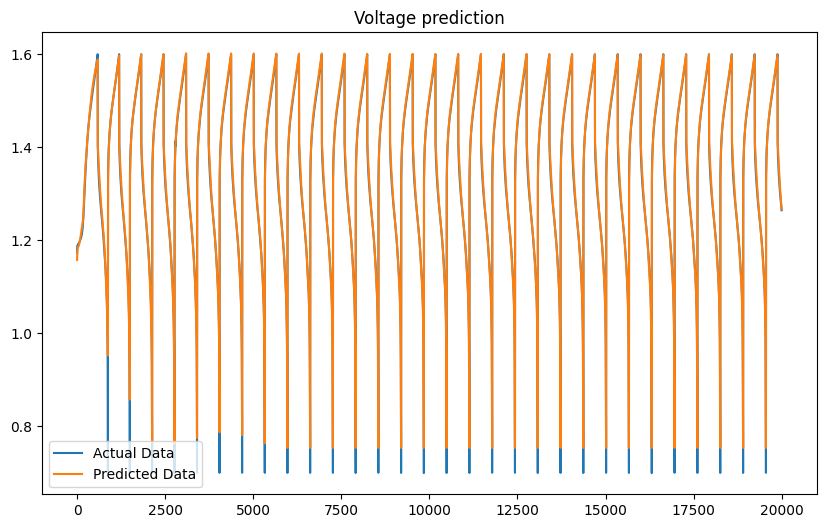

In [14]:
X = torch.Tensor(dataset.x)
X1 = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

Y = torch.Tensor(dataset.y)

train_predict = model(X1)
predicted = train_predict.data.numpy()
label_y = Y.data.numpy()

plt.figure(figsize=(10,6))
plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Voltage prediction')
plt.legend()
plt.show()